# S&P500 Example: Hedging of an Asian Put Option in a Crisis Period

First import the necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines
from matplotlib import rc
from matplotlib import style
style.use('ggplot')
from matplotlib import rcParams
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.optimize import minimize

from Functions import*
from tqdm import tqdm

Only execute next box if program should run on a GPU

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

Load the Data of 20 of the largest constituents

In [3]:
stocks =[]
stocks += [pd.read_csv("time_series/AAPL.OQ.csv")] #Apple Inc.
stocks += [pd.read_csv("time_series/MSFT.OQ.csv")] # Microsoft Corporation 
stocks += [pd.read_csv("time_series/AMZN.OQ.csv")] # Amazon.com Inc.
stocks += [pd.read_csv("time_series/GOOGL.OQ.csv")] #Alphabet Inc. Class C
stocks += [pd.read_csv("time_series/BRKb.N.csv")] # Berkshire Hathaway Inc. Class B
stocks += [pd.read_csv("time_series/JPM.N.csv")] #JPMorgan Chase & Co.
stocks += [pd.read_csv("time_series/JNJ.N.csv")] #Johnson & Johnson
stocks += [pd.read_csv("time_series/V.N.csv")] # Visa Inc. Class A
stocks += [pd.read_csv("time_series/UNH.N.csv")] #UnitedHealth Group Incorporated
stocks += [pd.read_csv("time_series/NVDA.OQ.csv")] #NVIDIA Corporation
stocks += [pd.read_csv("time_series/PG.N.csv")] #Procter & Gamble Company
stocks += [pd.read_csv("time_series/HD.N.csv")] #Home Depot Inc.
stocks += [pd.read_csv("time_series/MA.N.csv")] # Mastercard Incorporated Class A
stocks += [pd.read_csv("time_series/BAC.N.csv")] # Bank of America Corp
stocks += [pd.read_csv("time_series/DIS.N.csv")] # Walt Disney Company
stocks += [pd.read_csv("time_series/CMCSA.OQ.csv")] #Comcast Corporation Class A
stocks += [pd.read_csv("time_series/XOM.N.csv")] #Exxon Mobil Corporation
stocks += [pd.read_csv("time_series/ADBE.OQ.csv")] # Adobe Inc.
stocks += [pd.read_csv("time_series/VZ.N.csv")] #Verizon Communications Inc.
stocks += [pd.read_csv("time_series/INTC.OQ.csv")] # Intel Corporation


for i in range(len(stocks)):
    # Clean the NaNs
    stocks[i] = stocks[i].dropna()
    # Reset Indices
    stocks[i] = stocks[i].reset_index()
    # Only Dates and Close Values
    stocks[i]  = stocks[i] [["Date","CLOSE"]]

We plot the normalized evolution of the 20 considered stocks

In [4]:
# Increase the size of xticks and yticks
labelsize = 18
rcParams['xtick.labelsize'] = labelsize
rcParams['ytick.labelsize'] = labelsize 

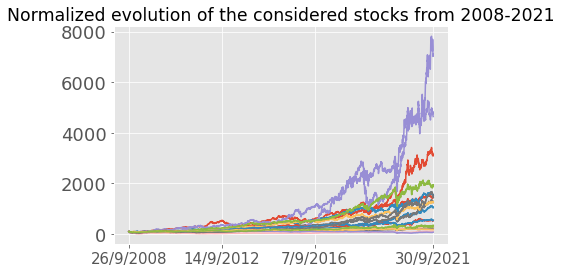

In [5]:
normalized_stocks = []
for i in range(len(stocks)):
    normalized_stocks+=[(100*stocks[i]["CLOSE"]/stocks[i]["CLOSE"][0]).tolist()]
for i in range(len(normalized_stocks)):
    plt.plot(range(len(normalized_stocks[i])),normalized_stocks[i])
plt.title("Normalized evolution of the considered stocks from 2008-2021",fontsize='xx-large')
xtick_numbers = [0,1000,2000,3275]
plt.xticks(xtick_numbers, stocks[0]["Date"].iloc[xtick_numbers], fontsize=15) # Scale here down
plt.show()

We focus on the test period (Feb 2020 - Mar 2020)
and plot the normalized evolution in this period.

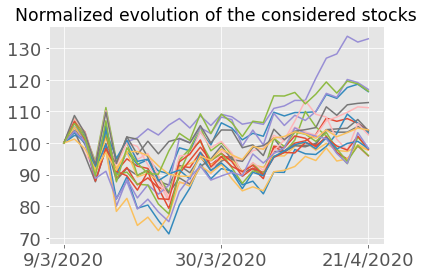

In [6]:
start_index = 2880
end_index = 2910
period = np.arange(start_index,end_index) # Feb to March 2020
normalized_stocks_period_2 = []
for i in range(len(stocks)):
    normalized_stocks_period_2+=[(100*stocks[i]["CLOSE"][start_index:end_index]/stocks[i]["CLOSE"][start_index]).tolist()]
for i in range(len(normalized_stocks_period_2)):
    plt.plot(range(len(normalized_stocks_period_2[i])),normalized_stocks_period_2[i])
plt.figsize=(3, 2)
plt.title("Normalized evolution of the considered stocks",fontsize = 'xx-large')
xtick_numbers = [start_index,start_index+15,end_index]
plt.xticks([0,15,29], stocks[0]["Date"].iloc[xtick_numbers])
plt.yticks(np.arange(70,140,10), np.arange(70,140,10))
plt.savefig('eps/fig_evolution_normalized.eps', format='eps')
plt.show()

# Maxmimum Likelihood Estimation for all constituents

Define the function for the estimation relying on BFGS

In [7]:
def compute_max_parameters(x, 
                           iterations = 1000,
                           initial_guess= [0.1,0.1,0,0,0.75],
                           tolerance = 1e-15,
                           Delta = 1/250.,
                           method = 'COBYLA'):
    x_0 = np.array(initial_guess) #Initial guess
    eps = tolerance # Tolerance to avoid that fractions and log-expressions become inf or -inf
    
    #Definte the Log-Likelihood Function
    def log_likelihood(param):
        a_0 = param[0]
        a_1 = param[1]
        b_0 = param[2]
        b_1 = param[3]
        gamma = param[4]
        constant = np.sqrt(2*np.pi*Delta)
        l= [-np.log((a_0+a_1*np.maximum(x[i],0))**gamma*constant+eps)-(1/(2*Delta))*((x[i+1]-x[i]-(b_0+b_1*x[i])*Delta)/(a_0+a_1*np.maximum(x[i],0)+eps)**gamma)**2 for i in range(len(x)-1)]
        return -np.mean(l) # Mean instead of sum to have smaller values
    
    a0,a1,b0,b1,gamma = minimize(log_likelihood,x_0,method=method,options={'maxiter': iterations,
                                                                          'rhobeg':0.01},
                bounds = [(eps,None),(eps,None),(None,None),(None,None),(eps,None)]).x
    a0 = np.max([a0,eps])
    a1 = np.max([a1,eps])
    gamma = np.min([np.max([gamma,eps]),1.2]) # artificial lower/upper bound
    return a0,a1,b0,b1,gamma

Determination of MLE-Parameters

In [8]:
start_index = 2880
end_index = 2910
list_parameters=[]

for j in range(len(stocks)):
    print("MLE for stock {}".format((str(j+1))))
    #Create lists for the parameters
    list_a0 = []
    list_a1 = []
    list_b0 = []
    list_b1 = []
    list_gamma = []
    list_a0_rescaled = []
    list_a1_rescaled = []
    list_b0_rescaled = []
    list_b1_rescaled = []
    
    #Compute optimal parameters
    for i in tqdm(np.arange(279,start_index,100)): # until 9 March 2020
        x = np.array(stocks[j].iloc[(i-250):i]["CLOSE"])
        a0,a1,b0,b1,gamma = compute_max_parameters(x)
        
        list_a0 += [a0]
        list_a1 += [a1]
        list_b0 += [b0]
        list_b1 += [b1]
        list_gamma += [gamma]
        # Rescale the parameters
    list_parameters+= [pd.DataFrame({'a0': list_a0,
                   'a1': list_a1,
                   'b0': list_b0,
                   'b1': list_b1,
                   'gamma': list_gamma})]
    list_parameters[j].to_csv('csv/mle_parameters_stock'+str(j)+'.csv',index=False)

  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 1


C:\Users\julia\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\scipy\optimize\_minimize.py:540: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)
  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 2


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 3


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 4


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 5


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 6


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 7


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 8


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 9


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 10


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 11


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 12


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 13


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 14


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 15


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 16


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 17


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 18


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 19


  0%|          | 0/27 [00:00<?, ?it/s]

MLE for stock 20


100%|██████████| 27/27 [01:16<00:00,  2.84s/it]


Load the estimated parameters.

In [9]:
list_parameters=[]
for j in range(len(stocks)):
    list_parameters+= [pd.read_csv('csv/mle_parameters_stock'+str(j)+'.csv')]

Display the estimated parameters for a single company (Apple Inc.)

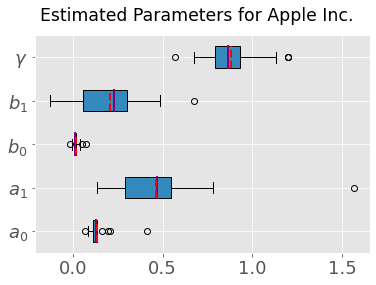

In [10]:
# Load the parameters
list_a0 = list_parameters[0]['a0']
list_a1 = list_parameters[0]['a1']
list_b0 = list_parameters[0]['b0']
list_b1 = list_parameters[0]['b1']
list_gamma = list_parameters[0]['gamma']


# Display the parameters
fig, ax = plt.subplots()
ax.boxplot((list_a0, list_a1, list_b0,list_b1,list_gamma), vert=False, showmeans=True, meanline=True,
           labels=('$a_0$', '$a_1$', '$b_0$','$b_1$','$\gamma$'), patch_artist=True,
           medianprops={'linewidth': 2, 'color': 'purple'},
           meanprops={'linewidth': 2, 'color': 'red'})
fig.suptitle("Estimated Parameters for Apple Inc.",fontsize = 'xx-large')
plt.savefig('eps/fig_parameter_estimation_sp500_single.eps', format='eps')
plt.show()

Display the estimated parameters for all companies.

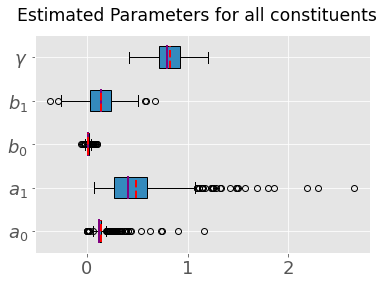

In [11]:
# Load the parameters
list_a0 = []
list_a1 = []
list_b0 = []
list_b1 = []
list_gamma = []
for j in range(20):
    list_a0 += list_parameters[j]['a0'].dropna().tolist()
    list_a1 += list_parameters[j]['a1'].dropna().tolist()
    list_b0 += list_parameters[j]['b0'].dropna().tolist()
    list_b1 += list_parameters[j]['b1'].dropna().tolist()
    list_gamma += list_parameters[j]['gamma'].dropna().tolist()


fig, ax = plt.subplots()
ax.boxplot((list_a0, list_a1, list_b0,list_b1,list_gamma), vert=False, showmeans=True, meanline=True,
           labels=('$a_0$', '$a_1$', '$b_0$','$b_1$','$\gamma$'), patch_artist=True,
           medianprops={'linewidth': 2, 'color': 'purple'},
           meanprops={'linewidth': 2, 'color': 'red'})
fig.suptitle("Estimated Parameters for all constituents",fontsize = 'xx-large')
plt.savefig('eps/fig_parameter_estimation_sp500_all.eps', format='eps')
plt.show()

Compute Hedges and Hedging Errors for all stocks.
Also compute the (relative) hedging errors, when fixing one parameters and choosing the other parameters to be robust. (Sensitivity analysis).

In [12]:
# Create Lists to collect the hedging errors
derivative_payoff = []

error_fix = []
error_robust = []
error_robust_a_0_fix = []
error_robust_a_1_fix = []
error_robust_b_0_fix = []
error_robust_b_1_fix = []
error_robust_gamma_fix = []

rel_error_fix = []
rel_error_robust = []
rel_error_robust_a_0_fix = []
rel_error_robust_a_1_fix = []
rel_error_robust_b_0_fix = []
rel_error_robust_b_1_fix = []
rel_error_robust_gamma_fix = []

epochs = 1000 # Number of epochs for training
start_index = 2880
end_index = 2910

for j in range(len(stocks)):
    print("\n\n ############\n \n ##### Calculations for Stock: {} \n".format(str(j+1)))
    # Load Parameters from the List
    list_a0 = list_parameters[j]['a0']
    list_a1 = list_parameters[j]['a1']
    list_b0 = list_parameters[j]['b0']
    list_b1 = list_parameters[j]['b1']
    list_gamma = list_parameters[j]['gamma']
    x_0 = stocks[j].iloc[start_index]["CLOSE"].astype('float32')
    T = (30/250)
    n = 30
    def derivative(path):
        return tf.nn.relu(10-tf.math.reduce_mean(path))
    #######################################################
    #ROBUST
    # Assign the intervals
    a_0=[np.min(list_a0),np.max(list_a0)]
    a_1=[np.min(list_a1),np.max(list_a1)]
    b_0=[np.min(list_b0),np.max(list_b0)]
    b_1=[np.min(list_b1),np.max(list_b1)]
    gamma=[np.min(list_gamma),np.max(list_gamma)]
    # Assign the closing data of the beginning of the test period
    price_robust, hedge_robust = optimal_hedge(derivative,a_0,a_1,b_0,b_1,gamma,x_0,T,n,
                                 depth = 4,nr_neurons = 256,EPOCHS = epochs,l_r = 0.005,BATCH_SIZE =256,scaling_factor=x_0/10.)
    #######################################################
    # NON ROBUST
    a_0_fix=[list_a0[len(list_a0)-1],list_a0[len(list_a0)-1]]
    a_1_fix=[list_a1[len(list_a1)-1],list_a1[len(list_a1)-1]]
    b_0_fix=[list_b0[len(list_b0)-1],list_b0[len(list_b0)-1]]
    b_1_fix=[list_b1[len(list_b1)-1],list_b1[len(list_b1)-1]]  
    gamma_fix=[list_gamma[len(list_gamma)-1],list_gamma[len(list_gamma)-1]]
    price_fix, hedge_fix = optimal_hedge(derivative,a_0_fix,a_1_fix,b_0_fix,b_1_fix,gamma_fix,x_0,T,n,
                             depth = 4,nr_neurons = 256,EPOCHS = epochs,l_r = 0.005,BATCH_SIZE =256,scaling_factor=x_0/10.)
    
    #######################################################
    # a_0 fix, rest robust:
    a_0_a_0_fix=[list_a0[len(list_a0)-1],list_a0[len(list_a0)-1]]
    a_1_a_0_fix=[np.min(list_a1),np.max(list_a1)]
    b_0_a_0_fix=[np.min(list_b0),np.max(list_b0)]
    b_1_a_0_fix=[np.min(list_b1),np.max(list_b1)]
    gamma_a_0_fix=[np.min(list_gamma),np.max(list_gamma)]
    # Assign the closing data of the beginning of the test period
    price_robust_a_0_fix, hedge_robust_a_0_fix = optimal_hedge(derivative,a_0_a_0_fix,a_1_a_0_fix
                                                               ,b_0_a_0_fix,b_1_a_0_fix,gamma_a_0_fix,x_0,T,n,
                                 depth = 4,nr_neurons = 256,EPOCHS = epochs,l_r = 0.005,BATCH_SIZE =256,scaling_factor=x_0/10.)
       
    #######################################################
    # a_1 fix, rest robust:
    a_0_a_1_fix=[np.min(list_a0),np.max(list_a0)]
    a_1_a_1_fix=[list_a1[len(list_a1)-1],list_a1[len(list_a1)-1]]
    b_0_a_1_fix=[np.min(list_b0),np.max(list_b0)]
    b_1_a_1_fix=[np.min(list_b1),np.max(list_b1)]
    gamma_a_1_fix=[np.min(list_gamma),np.max(list_gamma)]
    # Assign the closing data of the beginning of the test period
    price_robust_a_1_fix, hedge_robust_a_1_fix = optimal_hedge(derivative,a_0_a_1_fix,a_1_a_1_fix
                                                               ,b_0_a_1_fix,b_1_a_1_fix,gamma_a_1_fix,x_0,T,n,
                                 depth = 4,nr_neurons = 256,EPOCHS = epochs,l_r = 0.005,BATCH_SIZE =256,scaling_factor=x_0/10.)
    
    #######################################################
    # b_0 fix, rest robust:
    a_0_b_0_fix=[np.min(list_a0),np.max(list_a0)]
    a_1_b_0_fix=[np.min(list_a1),np.max(list_a1)]
    b_0_b_0_fix=[list_b0[len(list_b0)-1],list_b0[len(list_b0)-1]]
    b_1_b_0_fix=[np.min(list_b1),np.max(list_b1)]
    gamma_b_0_fix=[np.min(list_gamma),np.max(list_gamma)]
    # Assign the closing data of the beginning of the test period
    price_robust_b_0_fix, hedge_robust_b_0_fix = optimal_hedge(derivative,a_0_b_0_fix,a_1_b_0_fix
                                                               ,b_0_b_0_fix,b_1_b_0_fix,gamma_b_0_fix,x_0,T,n,
                                 depth = 4,nr_neurons = 256,EPOCHS = epochs,l_r = 0.005,BATCH_SIZE =256,scaling_factor=x_0/10.)
    #######################################################
    # b_1 fix, rest robust:
    a_0_b_1_fix=[np.min(list_a0),np.max(list_a0)]
    a_1_b_1_fix=[np.min(list_a1),np.max(list_a1)]
    b_0_b_1_fix=[np.min(list_b0),np.max(list_b0)]
    b_1_b_1_fix=[list_b1[len(list_b1)-1],list_b1[len(list_b1)-1]]  
    gamma_b_1_fix=[np.min(list_gamma),np.max(list_gamma)]
    # Assign the closing data of the beginning of the test period
    price_robust_b_1_fix, hedge_robust_b_1_fix = optimal_hedge(derivative,a_0_b_1_fix,a_1_b_1_fix
                                                               ,b_0_b_1_fix,b_1_b_1_fix,gamma_b_1_fix,x_0,T,n,
                                 depth = 4,nr_neurons = 256,EPOCHS = epochs,l_r = 0.005,BATCH_SIZE =256,scaling_factor=x_0/10.)
    #######################################################
    # gamma fix, rest robust:
    a_0_gamma_fix=[np.min(list_a0),np.max(list_a0)]
    a_1_gamma_fix=[np.min(list_a1),np.max(list_a1)]
    b_0_gamma_fix=[np.min(list_b0),np.max(list_b0)]
    b_1_gamma_fix=[np.min(list_b1),np.max(list_b1)]
    gamma_gamma_fix=[list_gamma[len(list_gamma)-1],list_gamma[len(list_gamma)-1]]
    # Assign the closing data of the beginning of the test period
    price_robust_gamma_fix, hedge_robust_gamma_fix = optimal_hedge(derivative,a_0_gamma_fix,a_1_gamma_fix
                                                               ,b_0_gamma_fix,b_1_gamma_fix,gamma_gamma_fix,x_0,T,n,
                                 depth = 4,nr_neurons = 256,EPOCHS = epochs,l_r = 0.005,BATCH_SIZE =256,scaling_factor=x_0/10.)
    
    ####################################################
    #Evaluate
    t_k = np.linspace(0,T,n+1)
    test_period= np.array(stocks[j].iloc[start_index:end_index]["CLOSE"])/(x_0/10.) #Normalize the values of the test period
    
    # Fix Parameters
    hedge_evaluated_fix = [hedge_fix([tf.reshape(test_period[i],(1,1)),tf.reshape(t_k[i],(1,1))]) for i in range(n-1)]
    delta_S_fix = tf.reduce_sum([hedge_evaluated_fix[i]*np.reshape(np.diff(test_period)[i],(1,1)) for i in range(n-1)],0)
    
    # Robust Parameters
    hedge_evaluated_robust = [hedge_robust([tf.reshape(test_period[i],(1,1)),tf.reshape(t_k[i],(1,1))]) for i in range(n-1)]
    delta_S_robust = tf.reduce_sum([hedge_evaluated_robust[i]*np.reshape(np.diff(test_period)[i],(1,1)) for i in range(n-1)],0)
    
    # a_0 fix, rest robust:
    hedge_evaluated_a_0_fix = [hedge_robust_a_0_fix([tf.reshape(test_period[i],(1,1)),tf.reshape(t_k[i],(1,1))]) for i in range(n-1)]
    delta_S_robust_a_0_fix = tf.reduce_sum([hedge_evaluated_a_0_fix[i]*np.reshape(np.diff(test_period)[i],(1,1)) for i in range(n-1)],0)

    # a_1 fix, rest robust:
    hedge_evaluated_a_1_fix = [hedge_robust_a_1_fix([tf.reshape(test_period[i],(1,1)),tf.reshape(t_k[i],(1,1))]) for i in range(n-1)]
    delta_S_robust_a_1_fix = tf.reduce_sum([hedge_evaluated_a_1_fix[i]*np.reshape(np.diff(test_period)[i],(1,1)) for i in range(n-1)],0)
        
    # b_0 fix, rest robust:
    hedge_evaluated_b_0_fix = [hedge_robust_b_0_fix([tf.reshape(test_period[i],(1,1)),tf.reshape(t_k[i],(1,1))]) for i in range(n-1)]
    delta_S_robust_b_0_fix = tf.reduce_sum([hedge_evaluated_b_0_fix[i]*np.reshape(np.diff(test_period)[i],(1,1)) for i in range(n-1)],0)
        
    # b_1 fix, rest robust:
    hedge_evaluated_b_1_fix = [hedge_robust_b_1_fix([tf.reshape(test_period[i],(1,1)),tf.reshape(t_k[i],(1,1))]) for i in range(n-1)]
    delta_S_robust_b_1_fix = tf.reduce_sum([hedge_evaluated_b_1_fix[i]*np.reshape(np.diff(test_period)[i],(1,1)) for i in range(n-1)],0)
        
    # gamma fix, rest robust:
    hedge_evaluated_gamma_fix = [hedge_robust_gamma_fix([tf.reshape(test_period[i],(1,1)),tf.reshape(t_k[i],(1,1))]) for i in range(n-1)]
    delta_S_robust_gamma_fix = tf.reduce_sum([hedge_evaluated_gamma_fix[i]*np.reshape(np.diff(test_period)[i],(1,1)) for i in range(n-1)],0) 
  
    #########################################################
    # Derivative
    derivative_on_batch = derivative(test_period)
    derivative_payoff+= [derivative(test_period)]
    # Compute Hedging Error (Relative), Percentage Values:
    #Relative Errors
    rel_error_fix += [(delta_S_fix.numpy()+price_fix - derivative_on_batch.numpy())/price_fix]
    rel_error_robust += [(delta_S_robust.numpy()+price_robust - derivative_on_batch.numpy())/price_robust]
    rel_error_robust_a_0_fix += [(delta_S_robust_a_0_fix.numpy()+price_robust_a_0_fix - derivative_on_batch.numpy())/price_robust_a_0_fix]
    rel_error_robust_a_1_fix += [(delta_S_robust_a_1_fix.numpy()+price_robust_a_1_fix - derivative_on_batch.numpy())/price_robust_a_1_fix]
    rel_error_robust_b_0_fix += [(delta_S_robust_b_0_fix.numpy()+price_robust_b_0_fix - derivative_on_batch.numpy())/price_robust_b_0_fix]
    rel_error_robust_b_1_fix += [(delta_S_robust_b_1_fix.numpy()+price_robust_b_1_fix - derivative_on_batch.numpy())/price_robust_b_1_fix]
    rel_error_robust_gamma_fix += [(delta_S_robust_gamma_fix.numpy()+price_robust_gamma_fix - derivative_on_batch.numpy())/price_robust_gamma_fix]
    #Absolute Errors
    error_fix += [10*(delta_S_fix.numpy()+price_fix - derivative_on_batch.numpy())]
    error_robust += [10*(delta_S_robust.numpy()+price_robust - derivative_on_batch.numpy())]
    error_robust_a_0_fix += [10*(delta_S_robust_a_0_fix.numpy()+price_robust_a_0_fix - derivative_on_batch.numpy())]
    error_robust_a_1_fix += [10*(delta_S_robust_a_1_fix.numpy()+price_robust_a_1_fix - derivative_on_batch.numpy())]
    error_robust_b_0_fix += [10*(delta_S_robust_b_0_fix.numpy()+price_robust_b_0_fix - derivative_on_batch.numpy())]
    error_robust_b_1_fix += [10*(delta_S_robust_b_1_fix.numpy()+price_robust_b_1_fix - derivative_on_batch.numpy())]
    error_robust_gamma_fix += [10*(delta_S_robust_gamma_fix.numpy()+price_robust_gamma_fix - derivative_on_batch.numpy())]



 ############
 
 ##### Calculations for Stock: 1 



  1%|          | 11/1000 [00:08<12:19,  1.34it/s]

Iteration:10, Price of Hedge: 18.565756393469382, Loss: 34.659709352204665


  2%|▏         | 21/1000 [00:15<12:03,  1.35it/s]

Iteration:20, Price of Hedge: 19.547710723443014, Loss: 36.216211951645896


  3%|▎         | 31/1000 [00:22<12:02,  1.34it/s]

Iteration:30, Price of Hedge: 20.361656617142216, Loss: 16.98871024554028


  4%|▍         | 41/1000 [00:30<12:18,  1.30it/s]

Iteration:40, Price of Hedge: 20.89846847110803, Loss: 16.998075336800138


  5%|▌         | 51/1000 [00:37<11:25,  1.38it/s]

Iteration:50, Price of Hedge: 21.51721813098575, Loss: 13.432228392405523


  6%|▌         | 61/1000 [00:44<11:07,  1.41it/s]

Iteration:60, Price of Hedge: 21.97581092779674, Loss: 21.63217093759522


  7%|▋         | 71/1000 [00:51<10:48,  1.43it/s]

Iteration:70, Price of Hedge: 22.137467030443442, Loss: 14.548506656259997


  8%|▊         | 81/1000 [00:58<10:47,  1.42it/s]

Iteration:80, Price of Hedge: 22.18753369992992, Loss: 20.81103662639671


  9%|▉         | 91/1000 [01:05<10:53,  1.39it/s]

Iteration:90, Price of Hedge: 22.093429049215047, Loss: 18.853386696759483


 10%|█         | 101/1000 [01:14<11:44,  1.28it/s]

Iteration:100, Price of Hedge: 22.28027079030835, Loss: 14.896945799614333


 11%|█         | 111/1000 [01:21<10:56,  1.35it/s]

Iteration:110, Price of Hedge: 22.373740842259213, Loss: 14.890225398703478


 12%|█▏        | 121/1000 [01:28<11:01,  1.33it/s]

Iteration:120, Price of Hedge: 22.598766390982927, Loss: 14.768049271662676


 13%|█▎        | 131/1000 [01:36<11:04,  1.31it/s]

Iteration:130, Price of Hedge: 22.687665745336016, Loss: 16.368523219462077


 14%|█▍        | 141/1000 [01:44<11:05,  1.29it/s]

Iteration:140, Price of Hedge: 22.64481446379632, Loss: 13.623388578087907


 15%|█▌        | 151/1000 [01:52<10:45,  1.31it/s]

Iteration:150, Price of Hedge: 22.490911571548896, Loss: 12.636717592800778


 16%|█▌        | 161/1000 [01:59<10:08,  1.38it/s]

Iteration:160, Price of Hedge: 22.39237900795815, Loss: 12.816852418206963


 17%|█▋        | 171/1000 [02:06<09:51,  1.40it/s]

Iteration:170, Price of Hedge: 22.40288003100559, Loss: 11.586455051869235


 18%|█▊        | 181/1000 [02:14<10:04,  1.36it/s]

Iteration:180, Price of Hedge: 22.318854395160088, Loss: 10.19741196077157


 19%|█▉        | 191/1000 [02:21<10:16,  1.31it/s]

Iteration:190, Price of Hedge: 22.246370524335, Loss: 9.321027101433083


 20%|██        | 201/1000 [02:28<09:22,  1.42it/s]

Iteration:200, Price of Hedge: 22.393978196843456, Loss: 11.959127142275703


 21%|██        | 211/1000 [02:35<09:28,  1.39it/s]

Iteration:210, Price of Hedge: 22.52500697664218, Loss: 12.047591796475444


 22%|██▏       | 221/1000 [02:42<08:43,  1.49it/s]

Iteration:220, Price of Hedge: 22.567084047689786, Loss: 10.995323130201177


 23%|██▎       | 231/1000 [02:49<08:56,  1.43it/s]

Iteration:230, Price of Hedge: 22.775817859644487, Loss: 9.327079587144818


 24%|██▍       | 241/1000 [02:56<08:36,  1.47it/s]

Iteration:240, Price of Hedge: 22.80330867810135, Loss: 10.110092757340864


 25%|██▌       | 251/1000 [03:03<08:17,  1.51it/s]

Iteration:250, Price of Hedge: 22.705558257487247, Loss: 9.464980278309303


 26%|██▌       | 261/1000 [03:10<08:36,  1.43it/s]

Iteration:260, Price of Hedge: 22.635201879018496, Loss: 13.693419724690102


 27%|██▋       | 271/1000 [03:17<08:34,  1.42it/s]

Iteration:270, Price of Hedge: 22.795089037610524, Loss: 9.751605535806902


 28%|██▊       | 281/1000 [03:24<08:28,  1.41it/s]

Iteration:280, Price of Hedge: 22.612597471044502, Loss: 11.456003756945757


 29%|██▉       | 291/1000 [03:31<08:26,  1.40it/s]

Iteration:290, Price of Hedge: 22.743270875535384, Loss: 12.667295734244545


 30%|███       | 301/1000 [03:38<07:45,  1.50it/s]

Iteration:300, Price of Hedge: 22.811763120134856, Loss: 9.175558820007792


 31%|███       | 311/1000 [03:45<07:27,  1.54it/s]

Iteration:310, Price of Hedge: 22.817463403532567, Loss: 9.968126667844444


 32%|███▏      | 321/1000 [03:51<07:38,  1.48it/s]

Iteration:320, Price of Hedge: 22.67717106827622, Loss: 9.805314802198792


 33%|███▎      | 331/1000 [03:58<07:35,  1.47it/s]

Iteration:330, Price of Hedge: 22.60465229451911, Loss: 11.037266935508342


 34%|███▍      | 341/1000 [04:05<08:04,  1.36it/s]

Iteration:340, Price of Hedge: 22.802977100247155, Loss: 11.415281554259309


 35%|███▌      | 351/1000 [04:12<07:32,  1.43it/s]

Iteration:350, Price of Hedge: 22.88245583594853, Loss: 11.303941994362413


 36%|███▌      | 361/1000 [04:20<07:40,  1.39it/s]

Iteration:360, Price of Hedge: 22.88598261857951, Loss: 8.828284165385412


 37%|███▋      | 371/1000 [04:27<08:14,  1.27it/s]

Iteration:370, Price of Hedge: 22.732741295543565, Loss: 9.913540068661314


 38%|███▊      | 381/1000 [04:35<07:56,  1.30it/s]

Iteration:380, Price of Hedge: 22.599827757415735, Loss: 11.821378754814578


 39%|███▉      | 391/1000 [04:42<06:38,  1.53it/s]

Iteration:390, Price of Hedge: 22.43588551272169, Loss: 10.408467610954085


 40%|████      | 401/1000 [04:49<06:41,  1.49it/s]

Iteration:400, Price of Hedge: 22.452097924645205, Loss: 11.156427131923193


 41%|████      | 411/1000 [04:56<06:59,  1.40it/s]

Iteration:410, Price of Hedge: 22.409841579446766, Loss: 9.448124541888774


 42%|████▏     | 421/1000 [05:03<06:51,  1.41it/s]

Iteration:420, Price of Hedge: 22.46835634497911, Loss: 11.245475616985823


 43%|████▎     | 431/1000 [05:11<07:29,  1.26it/s]

Iteration:430, Price of Hedge: 22.649442275282855, Loss: 5.925103098459068


 44%|████▍     | 441/1000 [05:18<06:41,  1.39it/s]

Iteration:440, Price of Hedge: 22.72444391670415, Loss: 7.159930360793806


 45%|████▌     | 451/1000 [05:25<06:36,  1.39it/s]

Iteration:450, Price of Hedge: 22.75250111455789, Loss: 4.851926782656074


 46%|████▌     | 461/1000 [05:32<06:25,  1.40it/s]

Iteration:460, Price of Hedge: 22.424811764289736, Loss: 7.500979601541258


 47%|████▋     | 471/1000 [05:39<05:45,  1.53it/s]

Iteration:470, Price of Hedge: 22.271189681995384, Loss: 6.870190809861834


 48%|████▊     | 481/1000 [05:46<05:47,  1.49it/s]

Iteration:480, Price of Hedge: 22.407093766798607, Loss: 4.906247246982548


 49%|████▉     | 491/1000 [05:52<05:39,  1.50it/s]

Iteration:490, Price of Hedge: 22.73313633327416, Loss: 6.576855067059069


 50%|█████     | 501/1000 [06:01<06:56,  1.20it/s]

Iteration:500, Price of Hedge: 22.927740803748204, Loss: 6.510556551061927


 51%|█████     | 511/1000 [06:08<05:56,  1.37it/s]

Iteration:510, Price of Hedge: 22.798953744083338, Loss: 4.84395661880435


 52%|█████▏    | 521/1000 [06:16<05:50,  1.37it/s]

Iteration:520, Price of Hedge: 22.596978408965334, Loss: 5.198088113071845


 53%|█████▎    | 531/1000 [06:23<05:36,  1.39it/s]

Iteration:530, Price of Hedge: 22.554031937611036, Loss: 5.795461313583928


 54%|█████▍    | 541/1000 [06:30<05:32,  1.38it/s]

Iteration:540, Price of Hedge: 22.57304768957456, Loss: 5.388725151398148


 55%|█████▌    | 551/1000 [06:37<05:09,  1.45it/s]

Iteration:550, Price of Hedge: 22.633750234345825, Loss: 5.477998522397775


 56%|█████▌    | 561/1000 [06:44<05:21,  1.36it/s]

Iteration:560, Price of Hedge: 22.708277513191025, Loss: 6.271037559816705


 57%|█████▋    | 571/1000 [06:51<05:04,  1.41it/s]

Iteration:570, Price of Hedge: 22.64768443670655, Loss: 6.1299507862326665


 58%|█████▊    | 581/1000 [06:58<04:54,  1.42it/s]

Iteration:580, Price of Hedge: 22.634364208650005, Loss: 6.889181971123253


 59%|█████▉    | 591/1000 [07:06<05:11,  1.31it/s]

Iteration:590, Price of Hedge: 22.524621457893044, Loss: 4.680150812844568


 60%|██████    | 601/1000 [07:13<04:55,  1.35it/s]

Iteration:600, Price of Hedge: 22.42141666090229, Loss: 7.875373834343555


 61%|██████    | 611/1000 [07:20<04:23,  1.47it/s]

Iteration:610, Price of Hedge: 22.643700742965486, Loss: 5.947708696305745


 62%|██████▏   | 621/1000 [07:27<04:18,  1.47it/s]

Iteration:620, Price of Hedge: 22.762094661372796, Loss: 6.181335438027145


 63%|██████▎   | 631/1000 [07:34<04:24,  1.39it/s]

Iteration:630, Price of Hedge: 22.77251953256855, Loss: 4.870613336510769


 64%|██████▍   | 641/1000 [07:41<04:20,  1.38it/s]

Iteration:640, Price of Hedge: 22.46956049613382, Loss: 10.370107702166662


 65%|██████▌   | 651/1000 [07:48<03:54,  1.49it/s]

Iteration:650, Price of Hedge: 22.364494738267606, Loss: 5.950738112155432


 66%|██████▌   | 661/1000 [07:55<03:56,  1.44it/s]

Iteration:660, Price of Hedge: 22.501006451387365, Loss: 7.350635221863013


 67%|██████▋   | 671/1000 [08:02<03:49,  1.43it/s]

Iteration:670, Price of Hedge: 22.572246508635, Loss: 5.855062432875411


 68%|██████▊   | 681/1000 [08:09<03:41,  1.44it/s]

Iteration:680, Price of Hedge: 22.66113634400663, Loss: 5.087015877904287


 69%|██████▉   | 691/1000 [08:15<03:27,  1.49it/s]

Iteration:690, Price of Hedge: 22.793042456596595, Loss: 5.847136690937169


 70%|███████   | 701/1000 [08:23<03:35,  1.39it/s]

Iteration:700, Price of Hedge: 22.927233124736997, Loss: 6.2344561140654156


 71%|███████   | 711/1000 [08:30<03:44,  1.28it/s]

Iteration:710, Price of Hedge: 22.748447614952784, Loss: 4.522027442192257


 72%|███████▏  | 721/1000 [08:38<03:32,  1.31it/s]

Iteration:720, Price of Hedge: 22.473769472436107, Loss: 4.627272474209303


 73%|███████▎  | 731/1000 [08:45<03:15,  1.38it/s]

Iteration:730, Price of Hedge: 22.42221942833876, Loss: 5.497487843688941


 74%|███████▍  | 741/1000 [08:52<03:10,  1.36it/s]

Iteration:740, Price of Hedge: 22.44524743098773, Loss: 5.465103475513115


 75%|███████▌  | 751/1000 [09:00<03:01,  1.37it/s]

Iteration:750, Price of Hedge: 22.133564248044788, Loss: 5.753504419677256


 76%|███████▌  | 761/1000 [09:07<02:55,  1.36it/s]

Iteration:760, Price of Hedge: 22.295063287497396, Loss: 6.607838161839118


 77%|███████▋  | 771/1000 [09:15<02:51,  1.34it/s]

Iteration:770, Price of Hedge: 22.600413174775532, Loss: 6.555161704935654


 78%|███████▊  | 781/1000 [09:22<02:29,  1.47it/s]

Iteration:780, Price of Hedge: 22.7145425894887, Loss: 6.549138569416755


 79%|███████▉  | 791/1000 [09:28<02:20,  1.49it/s]

Iteration:790, Price of Hedge: 22.816752652916875, Loss: 6.697517279423482


 80%|████████  | 801/1000 [09:35<02:13,  1.49it/s]

Iteration:800, Price of Hedge: 22.77261154938933, Loss: 7.2769836893121465


 81%|████████  | 811/1000 [09:42<02:11,  1.43it/s]

Iteration:810, Price of Hedge: 22.78125319805822, Loss: 7.544462308851144


 82%|████████▏ | 821/1000 [09:50<02:21,  1.27it/s]

Iteration:820, Price of Hedge: 22.58795124154731, Loss: 5.049634837710346


 83%|████████▎ | 831/1000 [09:57<02:01,  1.39it/s]

Iteration:830, Price of Hedge: 22.36847367251794, Loss: 6.380612141901202


 84%|████████▍ | 841/1000 [10:04<01:53,  1.40it/s]

Iteration:840, Price of Hedge: 22.511042630840166, Loss: 5.842304221349241


 85%|████████▌ | 851/1000 [10:11<01:46,  1.40it/s]

Iteration:850, Price of Hedge: 22.66572766606423, Loss: 6.124904139561886


 86%|████████▌ | 861/1000 [10:18<01:38,  1.41it/s]

Iteration:860, Price of Hedge: 22.580453457150544, Loss: 5.259767939939684


 87%|████████▋ | 871/1000 [10:26<01:32,  1.39it/s]

Iteration:870, Price of Hedge: 22.30539614187237, Loss: 5.455640021444833


 88%|████████▊ | 881/1000 [10:33<01:35,  1.25it/s]

Iteration:880, Price of Hedge: 22.284811344464835, Loss: 7.215878174325735


 89%|████████▉ | 891/1000 [10:41<01:18,  1.38it/s]

Iteration:890, Price of Hedge: 22.46686186488987, Loss: 7.83559877031239


 90%|█████████ | 901/1000 [10:47<01:05,  1.51it/s]

Iteration:900, Price of Hedge: 22.688881001969094, Loss: 7.837128946582107


 91%|█████████ | 911/1000 [10:54<00:58,  1.53it/s]

Iteration:910, Price of Hedge: 22.659611720476097, Loss: 8.391067827940061


 92%|█████████▏| 921/1000 [11:01<00:54,  1.46it/s]

Iteration:920, Price of Hedge: 22.71141084458832, Loss: 5.971682251113089


 93%|█████████▎| 931/1000 [11:08<00:46,  1.47it/s]

Iteration:930, Price of Hedge: 22.6577920085203, Loss: 7.451104104932438


 94%|█████████▍| 941/1000 [11:15<00:41,  1.43it/s]

Iteration:940, Price of Hedge: 22.718916561469634, Loss: 5.960165076794783


 95%|█████████▌| 951/1000 [11:21<00:33,  1.48it/s]

Iteration:950, Price of Hedge: 22.70131596474985, Loss: 5.2593193579383755


 96%|█████████▌| 961/1000 [11:28<00:26,  1.49it/s]

Iteration:960, Price of Hedge: 22.576290489258646, Loss: 5.759824626742557


 97%|█████████▋| 971/1000 [11:35<00:19,  1.51it/s]

Iteration:970, Price of Hedge: 22.230147006933112, Loss: 10.294941065066723


 98%|█████████▊| 981/1000 [11:42<00:13,  1.39it/s]

Iteration:980, Price of Hedge: 22.325301918602417, Loss: 4.847280329830847


 99%|█████████▉| 991/1000 [11:49<00:06,  1.37it/s]

Iteration:990, Price of Hedge: 22.691167144016436, Loss: 4.746318442846632


  1%|          | 11/1000 [00:08<11:57,  1.38it/s]

Iteration:10, Price of Hedge: 4.91875241225157, Loss: 1.2537028076338401


  2%|▏         | 21/1000 [00:15<12:19,  1.32it/s]

Iteration:20, Price of Hedge: 5.135757425846669, Loss: 1.0542193633811963


  3%|▎         | 31/1000 [00:23<12:06,  1.33it/s]

Iteration:30, Price of Hedge: 5.34470700138113, Loss: 1.1642811983291836


  4%|▍         | 41/1000 [00:31<12:50,  1.24it/s]

Iteration:40, Price of Hedge: 5.537498105887017, Loss: 1.1977022430796525


  5%|▌         | 51/1000 [00:39<13:00,  1.22it/s]

Iteration:50, Price of Hedge: 5.607234164063948, Loss: 0.955269947727345


  6%|▌         | 61/1000 [00:47<11:56,  1.31it/s]

Iteration:60, Price of Hedge: 5.626094835954518, Loss: 1.1204475777340122


  7%|▋         | 71/1000 [00:54<11:37,  1.33it/s]

Iteration:70, Price of Hedge: 5.560263543297379, Loss: 1.131197779952379


  8%|▊         | 81/1000 [01:01<10:41,  1.43it/s]

Iteration:80, Price of Hedge: 5.505793155012907, Loss: 0.844487545714037


  9%|▉         | 91/1000 [01:08<10:48,  1.40it/s]

Iteration:90, Price of Hedge: 5.487767773745463, Loss: 1.0355450057214968


 10%|█         | 101/1000 [01:17<12:47,  1.17it/s]

Iteration:100, Price of Hedge: 5.512400121394694, Loss: 1.0454427633188972


 11%|█         | 111/1000 [01:24<11:33,  1.28it/s]

Iteration:110, Price of Hedge: 5.549996925168398, Loss: 0.8470833521270038


 12%|█▏        | 121/1000 [01:32<10:22,  1.41it/s]

Iteration:120, Price of Hedge: 5.653915645768666, Loss: 0.9700996284377198


 13%|█▎        | 131/1000 [01:39<10:09,  1.43it/s]

Iteration:130, Price of Hedge: 5.6354956233948545, Loss: 1.207789983682028


 14%|█▍        | 141/1000 [01:46<10:22,  1.38it/s]

Iteration:140, Price of Hedge: 5.5658384934391965, Loss: 1.0419642696876168


 15%|█▌        | 151/1000 [01:52<09:23,  1.51it/s]

Iteration:150, Price of Hedge: 5.487565892013663, Loss: 1.1086535597049079


 16%|█▌        | 161/1000 [01:59<08:59,  1.56it/s]

Iteration:160, Price of Hedge: 5.471952779297908, Loss: 0.8070966394924369


 17%|█▋        | 171/1000 [02:06<09:12,  1.50it/s]

Iteration:170, Price of Hedge: 5.5025693932917425, Loss: 0.7897605911323978


 18%|█▊        | 181/1000 [02:12<08:59,  1.52it/s]

Iteration:180, Price of Hedge: 5.584124853448339, Loss: 1.554324934120109


 19%|█▉        | 191/1000 [02:19<09:10,  1.47it/s]

Iteration:190, Price of Hedge: 5.796459220140332, Loss: 0.9226453244257072


 20%|██        | 201/1000 [02:25<08:39,  1.54it/s]

Iteration:200, Price of Hedge: 5.780717997799093, Loss: 0.7639649942019219


 21%|██        | 211/1000 [02:32<09:14,  1.42it/s]

Iteration:210, Price of Hedge: 5.6088325597007955, Loss: 0.97612811838369


 22%|██▏       | 221/1000 [02:40<09:45,  1.33it/s]

Iteration:220, Price of Hedge: 5.559335045980788, Loss: 0.9091838981441697


 23%|██▎       | 231/1000 [02:47<09:00,  1.42it/s]

Iteration:230, Price of Hedge: 5.64862824819179, Loss: 0.7340861508492765


 24%|██▍       | 241/1000 [02:54<08:52,  1.43it/s]

Iteration:240, Price of Hedge: 5.806272496777274, Loss: 0.5770814588306451


 25%|██▌       | 251/1000 [03:01<08:18,  1.50it/s]

Iteration:250, Price of Hedge: 5.911141925650873, Loss: 1.1332737111591429


 26%|██▌       | 261/1000 [03:08<08:56,  1.38it/s]

Iteration:260, Price of Hedge: 5.823223423012405, Loss: 0.6195900074597489


 27%|██▋       | 271/1000 [03:15<08:34,  1.42it/s]

Iteration:270, Price of Hedge: 5.678582103101462, Loss: 0.6158651606051592


 28%|██▊       | 281/1000 [03:23<08:56,  1.34it/s]

Iteration:280, Price of Hedge: 5.694254709451343, Loss: 0.6029143384385066


 29%|██▉       | 291/1000 [03:30<08:26,  1.40it/s]

Iteration:290, Price of Hedge: 5.763786506151109, Loss: 0.6982311223706631


 30%|███       | 301/1000 [03:37<08:20,  1.40it/s]

Iteration:300, Price of Hedge: 5.72493121370353, Loss: 0.4236409808544636


 31%|███       | 311/1000 [03:44<08:10,  1.40it/s]

Iteration:310, Price of Hedge: 5.67538808819736, Loss: 0.5636567698681801


 32%|███▏      | 321/1000 [03:51<07:51,  1.44it/s]

Iteration:320, Price of Hedge: 5.697150462936361, Loss: 0.541318100126614


 33%|███▎      | 331/1000 [03:58<07:49,  1.43it/s]

Iteration:330, Price of Hedge: 5.732786753153505, Loss: 0.29680392420413


 34%|███▍      | 341/1000 [04:05<07:46,  1.41it/s]

Iteration:340, Price of Hedge: 5.792606015770116, Loss: 0.8148719121143699


 35%|███▌      | 351/1000 [04:12<07:31,  1.44it/s]

Iteration:350, Price of Hedge: 5.928709602559775, Loss: 0.40860582400522677


 36%|███▌      | 361/1000 [04:19<07:21,  1.45it/s]

Iteration:360, Price of Hedge: 5.9775729141400005, Loss: 0.3202390864116495


 37%|███▋      | 371/1000 [04:26<06:54,  1.52it/s]

Iteration:370, Price of Hedge: 5.9241293859805415, Loss: 0.2822499964879285


 38%|███▊      | 381/1000 [04:32<06:48,  1.52it/s]

Iteration:380, Price of Hedge: 5.87219025351601, Loss: 0.33568177465464827


 39%|███▉      | 391/1000 [04:39<06:59,  1.45it/s]

Iteration:390, Price of Hedge: 5.833534066430639, Loss: 0.39598375374514777


 40%|████      | 401/1000 [04:46<07:07,  1.40it/s]

Iteration:400, Price of Hedge: 5.873970303049055, Loss: 0.40539406016694385


 41%|████      | 411/1000 [04:53<06:53,  1.43it/s]

Iteration:410, Price of Hedge: 5.83829117741534, Loss: 0.28680743196309494


 42%|████▏     | 421/1000 [05:00<06:47,  1.42it/s]

Iteration:420, Price of Hedge: 5.7707413119804185, Loss: 0.31897271483125283


 43%|████▎     | 431/1000 [05:07<06:38,  1.43it/s]

Iteration:430, Price of Hedge: 5.749618692120385, Loss: 0.44517604033307523


 44%|████▍     | 441/1000 [05:15<07:01,  1.33it/s]

Iteration:440, Price of Hedge: 5.750897012005635, Loss: 0.3367000577807403


 45%|████▌     | 451/1000 [05:22<06:34,  1.39it/s]

Iteration:450, Price of Hedge: 5.871150304791491, Loss: 0.2621830167984143


 46%|████▌     | 461/1000 [05:29<06:19,  1.42it/s]

Iteration:460, Price of Hedge: 5.919302072507572, Loss: 0.27684737957296196


 47%|████▋     | 471/1000 [05:36<05:49,  1.51it/s]

Iteration:470, Price of Hedge: 5.9409022279375225, Loss: 0.30395882695621596


 48%|████▊     | 481/1000 [05:42<05:46,  1.50it/s]

Iteration:480, Price of Hedge: 5.838426822901147, Loss: 0.25004569571138974


 49%|████▉     | 491/1000 [05:49<05:54,  1.44it/s]

Iteration:490, Price of Hedge: 5.776429696651303, Loss: 0.266012175824838


 50%|█████     | 501/1000 [05:56<05:28,  1.52it/s]

Iteration:500, Price of Hedge: 5.890731642903439, Loss: 0.3389881829492197


 51%|█████     | 511/1000 [06:03<05:52,  1.39it/s]

Iteration:510, Price of Hedge: 5.970971103873171, Loss: 0.3506321034972274


 52%|█████▏    | 521/1000 [06:10<05:41,  1.40it/s]

Iteration:520, Price of Hedge: 5.893849902580087, Loss: 0.31578640931057295


 53%|█████▎    | 531/1000 [06:17<05:36,  1.39it/s]

Iteration:530, Price of Hedge: 5.868575023682297, Loss: 0.23732010652793178


 54%|█████▍    | 541/1000 [06:24<05:23,  1.42it/s]

Iteration:540, Price of Hedge: 5.87109477739964, Loss: 0.25328190151769264


 55%|█████▌    | 551/1000 [06:31<05:15,  1.42it/s]

Iteration:550, Price of Hedge: 5.8502240139240715, Loss: 0.24052111193404357


 56%|█████▌    | 561/1000 [06:38<05:12,  1.40it/s]

Iteration:560, Price of Hedge: 5.868103834100021, Loss: 0.22474295396161778


 57%|█████▋    | 571/1000 [06:45<04:42,  1.52it/s]

Iteration:570, Price of Hedge: 5.837701793813267, Loss: 0.24009464173341827


 58%|█████▊    | 581/1000 [06:52<04:36,  1.52it/s]

Iteration:580, Price of Hedge: 5.929930808556264, Loss: 0.21664269736327244


 59%|█████▉    | 591/1000 [06:58<04:28,  1.53it/s]

Iteration:590, Price of Hedge: 5.917303483025171, Loss: 0.24194836421672222


 60%|██████    | 601/1000 [07:05<04:26,  1.50it/s]

Iteration:600, Price of Hedge: 5.900592117823453, Loss: 0.2509424135117513


 61%|██████    | 611/1000 [07:12<04:15,  1.53it/s]

Iteration:610, Price of Hedge: 5.793937086677625, Loss: 0.3963732635255724


 62%|██████▏   | 621/1000 [07:18<04:17,  1.47it/s]

Iteration:620, Price of Hedge: 5.827679892832657, Loss: 0.3089316519426518


 63%|██████▎   | 631/1000 [07:28<06:39,  1.08s/it]

Iteration:630, Price of Hedge: 5.879825269895491, Loss: 0.21039249447412658


 64%|██████▍   | 641/1000 [07:34<04:01,  1.49it/s]

Iteration:640, Price of Hedge: 5.898789064085213, Loss: 0.24099388801323016


 65%|██████▌   | 651/1000 [07:41<04:07,  1.41it/s]

Iteration:650, Price of Hedge: 5.9206866876857935, Loss: 0.24659218940644223


 66%|██████▌   | 661/1000 [07:48<03:55,  1.44it/s]

Iteration:660, Price of Hedge: 5.934744240181272, Loss: 0.23723981491087615


 67%|██████▋   | 671/1000 [07:55<03:54,  1.40it/s]

Iteration:670, Price of Hedge: 5.859315434466953, Loss: 0.27955741376345034


 68%|██████▊   | 681/1000 [08:02<03:45,  1.41it/s]

Iteration:680, Price of Hedge: 5.8409144500560615, Loss: 0.29650360529686565


 69%|██████▉   | 691/1000 [08:10<03:46,  1.36it/s]

Iteration:690, Price of Hedge: 5.900132033719546, Loss: 0.1994017148727636


 70%|███████   | 701/1000 [08:17<03:31,  1.41it/s]

Iteration:700, Price of Hedge: 5.907999471896346, Loss: 0.20880490684747885


 71%|███████   | 711/1000 [08:24<03:24,  1.42it/s]

Iteration:710, Price of Hedge: 6.005996989404184, Loss: 0.21704155260205768


 72%|███████▏  | 721/1000 [08:31<03:31,  1.32it/s]

Iteration:720, Price of Hedge: 5.942252733432179, Loss: 0.2923643109135469


 73%|███████▎  | 731/1000 [08:38<03:08,  1.43it/s]

Iteration:730, Price of Hedge: 5.783412662800766, Loss: 0.21589052430482242


 74%|███████▍  | 741/1000 [08:45<02:48,  1.54it/s]

Iteration:740, Price of Hedge: 5.89046749116792, Loss: 0.3556710655735998


 75%|███████▌  | 751/1000 [08:52<02:44,  1.51it/s]

Iteration:750, Price of Hedge: 5.96320718461975, Loss: 0.24468160092451968


 76%|███████▌  | 761/1000 [08:58<02:38,  1.51it/s]

Iteration:760, Price of Hedge: 5.890976756676037, Loss: 0.2801124397918159


 77%|███████▋  | 771/1000 [09:05<02:31,  1.52it/s]

Iteration:770, Price of Hedge: 5.900256177102756, Loss: 0.27223181385945167


 78%|███████▊  | 781/1000 [09:11<02:23,  1.53it/s]

Iteration:780, Price of Hedge: 5.914391071322598, Loss: 0.2910092938183027


 79%|███████▉  | 791/1000 [09:18<02:25,  1.43it/s]

Iteration:790, Price of Hedge: 5.917031002180875, Loss: 0.20572345885694573


 80%|████████  | 801/1000 [09:25<02:11,  1.51it/s]

Iteration:800, Price of Hedge: 5.837413447999871, Loss: 0.16580681237106917


 81%|████████  | 811/1000 [09:32<02:04,  1.52it/s]

Iteration:810, Price of Hedge: 5.82915652483166, Loss: 0.2683578362953199


 82%|████████▏ | 821/1000 [09:38<01:56,  1.54it/s]

Iteration:820, Price of Hedge: 5.830851696780019, Loss: 0.24178728520232654


 83%|████████▎ | 831/1000 [09:45<01:49,  1.54it/s]

Iteration:830, Price of Hedge: 5.95168604405917, Loss: 0.22766503337973631


 84%|████████▍ | 841/1000 [09:51<01:43,  1.53it/s]

Iteration:840, Price of Hedge: 5.980079975882063, Loss: 0.22709813341355983


 85%|████████▌ | 851/1000 [09:58<01:37,  1.53it/s]

Iteration:850, Price of Hedge: 5.848403508719821, Loss: 0.3023935246533512


 86%|████████▌ | 861/1000 [10:04<01:32,  1.50it/s]

Iteration:860, Price of Hedge: 5.837385287679718, Loss: 0.30651715237968347


 87%|████████▋ | 871/1000 [10:11<01:31,  1.42it/s]

Iteration:870, Price of Hedge: 5.7703331856503155, Loss: 0.31001584905755236


 88%|████████▊ | 881/1000 [10:19<01:27,  1.35it/s]

Iteration:880, Price of Hedge: 5.841455048878152, Loss: 0.2023862130286858


 89%|████████▉ | 891/1000 [10:26<01:18,  1.39it/s]

Iteration:890, Price of Hedge: 5.885431156727054, Loss: 0.2583895291634519


 90%|█████████ | 901/1000 [10:33<01:11,  1.38it/s]

Iteration:900, Price of Hedge: 5.937179909562383, Loss: 0.1989259393228565


 91%|█████████ | 911/1000 [10:41<01:10,  1.27it/s]

Iteration:910, Price of Hedge: 5.847716158933554, Loss: 0.2513844512133062


 92%|█████████▏| 921/1000 [10:48<00:57,  1.38it/s]

Iteration:920, Price of Hedge: 5.907448957468569, Loss: 0.3088539631720892


 93%|█████████▎| 931/1000 [10:55<00:48,  1.41it/s]

Iteration:930, Price of Hedge: 5.956643053654534, Loss: 0.20871065901541783


 94%|█████████▍| 941/1000 [11:02<00:41,  1.43it/s]

Iteration:940, Price of Hedge: 5.90841870370482, Loss: 0.2288242668406781


 95%|█████████▌| 951/1000 [11:09<00:37,  1.32it/s]

Iteration:950, Price of Hedge: 5.896602078094747, Loss: 0.18805464277002956


 96%|█████████▌| 961/1000 [11:17<00:29,  1.31it/s]

Iteration:960, Price of Hedge: 5.828201453691827, Loss: 0.19514194588034003


 97%|█████████▋| 971/1000 [11:24<00:20,  1.39it/s]

Iteration:970, Price of Hedge: 5.91004684615873, Loss: 0.3736541072047572


 98%|█████████▊| 981/1000 [11:31<00:13,  1.46it/s]

Iteration:980, Price of Hedge: 6.024051324240236, Loss: 0.22754495539485903


 99%|█████████▉| 991/1000 [11:38<00:06,  1.42it/s]

Iteration:990, Price of Hedge: 6.024484041272444, Loss: 0.22199586019487186


  1%|          | 11/1000 [00:07<11:34,  1.42it/s]

Iteration:10, Price of Hedge: 17.43160782842042, Loss: 28.86829122599593


  2%|▏         | 21/1000 [00:14<10:50,  1.50it/s]

Iteration:20, Price of Hedge: 17.65406007915608, Loss: 45.79595307043856


  3%|▎         | 31/1000 [00:21<10:20,  1.56it/s]

Iteration:30, Price of Hedge: 18.059164132645673, Loss: 32.97610613931393


  4%|▍         | 41/1000 [00:27<10:47,  1.48it/s]

Iteration:40, Price of Hedge: 18.584513546436575, Loss: 34.365338023543885


  5%|▌         | 51/1000 [00:34<11:01,  1.43it/s]

Iteration:50, Price of Hedge: 19.091048693371523, Loss: 20.268802125992444


  6%|▌         | 61/1000 [00:41<10:58,  1.43it/s]

Iteration:60, Price of Hedge: 19.600639433355173, Loss: 23.286187569610956


  7%|▋         | 71/1000 [00:48<10:37,  1.46it/s]

Iteration:70, Price of Hedge: 20.12083590518232, Loss: 13.949737338467093


  8%|▊         | 81/1000 [00:55<11:37,  1.32it/s]

Iteration:80, Price of Hedge: 20.616782771739782, Loss: 14.648738358041374


  9%|▉         | 91/1000 [01:03<10:43,  1.41it/s]

Iteration:90, Price of Hedge: 21.042073411912497, Loss: 17.106393413331897


 10%|█         | 101/1000 [01:10<09:45,  1.54it/s]

Iteration:100, Price of Hedge: 21.359950278792166, Loss: 16.84580812286695


 11%|█         | 111/1000 [01:16<09:52,  1.50it/s]

Iteration:110, Price of Hedge: 21.574279665348513, Loss: 16.35584234966027


 12%|█▏        | 121/1000 [01:23<09:45,  1.50it/s]

Iteration:120, Price of Hedge: 21.69241022526876, Loss: 14.639341536843313


 13%|█▎        | 131/1000 [01:30<09:53,  1.47it/s]

Iteration:130, Price of Hedge: 21.829845279590156, Loss: 15.797977681698468


 14%|█▍        | 141/1000 [01:37<09:52,  1.45it/s]

Iteration:140, Price of Hedge: 21.969817142470674, Loss: 13.497766579758537


 15%|█▌        | 151/1000 [01:43<09:29,  1.49it/s]

Iteration:150, Price of Hedge: 22.16334596803972, Loss: 12.194608498884918


 16%|█▌        | 161/1000 [01:50<09:09,  1.53it/s]

Iteration:160, Price of Hedge: 22.385409527032426, Loss: 14.661952290804948


 17%|█▋        | 171/1000 [01:57<09:10,  1.50it/s]

Iteration:170, Price of Hedge: 22.587583174264182, Loss: 10.187428928965256


 18%|█▊        | 181/1000 [02:03<09:46,  1.40it/s]

Iteration:180, Price of Hedge: 22.63187182200436, Loss: 14.266806678419561


 19%|█▉        | 191/1000 [02:12<13:33,  1.01s/it]

Iteration:190, Price of Hedge: 22.65064483994065, Loss: 9.660948342877509


 20%|██        | 201/1000 [02:19<08:53,  1.50it/s]

Iteration:200, Price of Hedge: 22.694855749332238, Loss: 10.904789684030765


 21%|██        | 211/1000 [02:25<08:35,  1.53it/s]

Iteration:210, Price of Hedge: 22.66988270147158, Loss: 15.856262405178859


 22%|██▏       | 221/1000 [02:32<08:41,  1.49it/s]

Iteration:220, Price of Hedge: 22.703257836967715, Loss: 13.088163221032119


 23%|██▎       | 231/1000 [02:38<08:34,  1.49it/s]

Iteration:230, Price of Hedge: 22.701856960196164, Loss: 8.223686057945088


 24%|██▍       | 241/1000 [02:45<08:31,  1.48it/s]

Iteration:240, Price of Hedge: 22.67766764180906, Loss: 10.532837069972993


 25%|██▌       | 251/1000 [02:52<08:26,  1.48it/s]

Iteration:250, Price of Hedge: 22.625110172173844, Loss: 9.205047831322828


 26%|██▌       | 261/1000 [02:59<08:26,  1.46it/s]

Iteration:260, Price of Hedge: 22.61812006678829, Loss: 11.3582525430832


 27%|██▋       | 271/1000 [03:05<07:58,  1.52it/s]

Iteration:270, Price of Hedge: 22.660389103962007, Loss: 10.882750068956739


 28%|██▊       | 281/1000 [03:12<07:50,  1.53it/s]

Iteration:280, Price of Hedge: 22.636567852858025, Loss: 5.935301497220917


 29%|██▉       | 291/1000 [03:19<07:51,  1.50it/s]

Iteration:290, Price of Hedge: 22.62419793645058, Loss: 11.091917787816328


 30%|███       | 301/1000 [03:25<07:35,  1.53it/s]

Iteration:300, Price of Hedge: 22.585051125195786, Loss: 10.947650484551923


 31%|███       | 311/1000 [03:32<07:55,  1.45it/s]

Iteration:310, Price of Hedge: 22.481795560303908, Loss: 8.61927271647146


 32%|███▏      | 321/1000 [03:39<07:40,  1.47it/s]

Iteration:320, Price of Hedge: 22.41514047912624, Loss: 6.182983808316658


 33%|███▎      | 331/1000 [03:45<07:16,  1.53it/s]

Iteration:330, Price of Hedge: 22.41211185652501, Loss: 10.222024080585198


 34%|███▍      | 341/1000 [03:52<07:27,  1.47it/s]

Iteration:340, Price of Hedge: 22.45906740557093, Loss: 8.989638040370755


 35%|███▌      | 351/1000 [03:59<07:48,  1.39it/s]

Iteration:350, Price of Hedge: 22.403895389028005, Loss: 12.991898554774252


 36%|███▌      | 361/1000 [04:07<08:05,  1.32it/s]

Iteration:360, Price of Hedge: 22.642334769125956, Loss: 6.5977091723170815


 37%|███▋      | 371/1000 [04:14<08:01,  1.31it/s]

Iteration:370, Price of Hedge: 22.80679421181267, Loss: 8.301345874939125


 38%|███▊      | 381/1000 [04:22<07:17,  1.42it/s]

Iteration:380, Price of Hedge: 22.766501949788836, Loss: 6.6637082370224565


 39%|███▉      | 391/1000 [04:29<07:13,  1.40it/s]

Iteration:390, Price of Hedge: 22.701269956339456, Loss: 6.120426648657577


 40%|████      | 401/1000 [04:36<07:08,  1.40it/s]

Iteration:400, Price of Hedge: 22.546254929758106, Loss: 8.001556659330618


 41%|████      | 411/1000 [04:43<07:25,  1.32it/s]

Iteration:410, Price of Hedge: 22.52793723643499, Loss: 6.290177058539212


 42%|████▏     | 421/1000 [04:51<06:57,  1.39it/s]

Iteration:420, Price of Hedge: 22.533280558027947, Loss: 5.455909329295309


 43%|████▎     | 431/1000 [04:58<07:11,  1.32it/s]

Iteration:430, Price of Hedge: 22.41587978668631, Loss: 7.770223198892654


 44%|████▍     | 441/1000 [05:05<06:28,  1.44it/s]

Iteration:440, Price of Hedge: 22.343541873576942, Loss: 5.549196934101519


 45%|████▌     | 451/1000 [05:12<06:35,  1.39it/s]

Iteration:450, Price of Hedge: 22.331551129930997, Loss: 7.781360407201009


 46%|████▌     | 461/1000 [05:19<06:15,  1.44it/s]

Iteration:460, Price of Hedge: 22.340733774046203, Loss: 6.5795072932683984


 47%|████▋     | 471/1000 [05:26<06:12,  1.42it/s]

Iteration:470, Price of Hedge: 22.420585336521437, Loss: 5.815233031325079


 48%|████▊     | 481/1000 [05:34<06:29,  1.33it/s]

Iteration:480, Price of Hedge: 22.499364427085492, Loss: 5.649894669350215


 49%|████▉     | 491/1000 [05:41<06:11,  1.37it/s]

Iteration:490, Price of Hedge: 22.656667182211095, Loss: 9.304777406832182


 50%|█████     | 501/1000 [05:48<05:30,  1.51it/s]

Iteration:500, Price of Hedge: 22.787112131146934, Loss: 8.41398318930842


 51%|█████     | 511/1000 [05:54<05:33,  1.47it/s]

Iteration:510, Price of Hedge: 22.76550087023861, Loss: 6.763903449374903


 52%|█████▏    | 521/1000 [06:02<05:41,  1.40it/s]

Iteration:520, Price of Hedge: 22.735815926555187, Loss: 8.75821256311201


 53%|█████▎    | 531/1000 [06:09<05:28,  1.43it/s]

Iteration:530, Price of Hedge: 22.717723515793296, Loss: 6.504576647583827


 54%|█████▍    | 541/1000 [06:16<05:29,  1.39it/s]

Iteration:540, Price of Hedge: 22.58876987395288, Loss: 6.831062243321504


 55%|█████▌    | 551/1000 [06:23<05:17,  1.41it/s]

Iteration:550, Price of Hedge: 22.499578604168345, Loss: 6.3858118855237995


 56%|█████▌    | 561/1000 [06:30<05:07,  1.43it/s]

Iteration:560, Price of Hedge: 22.537475255858045, Loss: 6.854365503184363


 57%|█████▋    | 571/1000 [06:37<05:00,  1.43it/s]

Iteration:570, Price of Hedge: 22.435920415653708, Loss: 6.925327130224287


 58%|█████▊    | 581/1000 [06:44<04:38,  1.50it/s]

Iteration:580, Price of Hedge: 22.452921316541506, Loss: 7.137217277781474


 59%|█████▉    | 591/1000 [06:51<04:51,  1.41it/s]

Iteration:590, Price of Hedge: 22.593534124173676, Loss: 6.4003798934000775


 60%|██████    | 601/1000 [06:58<05:07,  1.30it/s]

Iteration:600, Price of Hedge: 22.60592625153786, Loss: 5.82250553316062


 61%|██████    | 611/1000 [07:05<04:14,  1.53it/s]

Iteration:610, Price of Hedge: 22.765147081427678, Loss: 5.339896346125715


 62%|██████▏   | 621/1000 [07:12<04:05,  1.54it/s]

Iteration:620, Price of Hedge: 22.84798443108757, Loss: 8.271443581179028


 63%|██████▎   | 631/1000 [07:18<04:11,  1.47it/s]

Iteration:630, Price of Hedge: 22.835301974788855, Loss: 7.962477274194498


 64%|██████▍   | 641/1000 [07:28<07:07,  1.19s/it]

Iteration:640, Price of Hedge: 22.715324732465344, Loss: 6.014386781688609


 65%|██████▌   | 651/1000 [07:35<04:11,  1.39it/s]

Iteration:650, Price of Hedge: 22.509376809084642, Loss: 6.1724506587067935


 66%|██████▌   | 661/1000 [07:42<04:07,  1.37it/s]

Iteration:660, Price of Hedge: 22.493738709042557, Loss: 6.040218917626044


 67%|██████▋   | 671/1000 [07:49<03:57,  1.38it/s]

Iteration:670, Price of Hedge: 22.52556859654833, Loss: 8.743355812798109


 68%|██████▊   | 681/1000 [07:57<03:49,  1.39it/s]

Iteration:680, Price of Hedge: 22.59461928806013, Loss: 7.077403964528275


 69%|██████▉   | 691/1000 [08:03<03:23,  1.52it/s]

Iteration:690, Price of Hedge: 22.43363268710946, Loss: 7.504063751534341


 70%|███████   | 701/1000 [08:10<03:17,  1.51it/s]

Iteration:700, Price of Hedge: 22.419008358592873, Loss: 6.684858620578416


 71%|███████   | 711/1000 [08:17<03:11,  1.51it/s]

Iteration:710, Price of Hedge: 22.477007512629463, Loss: 8.740776168822412


 72%|███████▏  | 721/1000 [08:24<03:20,  1.39it/s]

Iteration:720, Price of Hedge: 22.612718044809665, Loss: 7.062565458928839


 73%|███████▎  | 731/1000 [08:31<03:11,  1.41it/s]

Iteration:730, Price of Hedge: 22.637359514816126, Loss: 5.508140773815512


 74%|███████▍  | 741/1000 [08:38<03:05,  1.39it/s]

Iteration:740, Price of Hedge: 22.43958998300659, Loss: 6.457615149174489


 75%|███████▌  | 751/1000 [08:45<02:56,  1.41it/s]

Iteration:750, Price of Hedge: 22.452776945322693, Loss: 5.682147754906737


 76%|███████▌  | 761/1000 [08:52<02:50,  1.40it/s]

Iteration:760, Price of Hedge: 22.481981180442382, Loss: 7.17598253652941


 77%|███████▋  | 771/1000 [09:00<02:52,  1.33it/s]

Iteration:770, Price of Hedge: 22.50212493170893, Loss: 6.689266702242913


 78%|███████▊  | 781/1000 [09:07<02:29,  1.47it/s]

Iteration:780, Price of Hedge: 22.57099793556681, Loss: 6.198349030890222


 79%|███████▉  | 791/1000 [09:14<02:26,  1.42it/s]

Iteration:790, Price of Hedge: 22.511772419418776, Loss: 6.2232677412317114


 80%|████████  | 801/1000 [09:21<02:19,  1.43it/s]

Iteration:800, Price of Hedge: 22.49067835650312, Loss: 5.900046362886406


 81%|████████  | 811/1000 [09:28<02:16,  1.38it/s]

Iteration:810, Price of Hedge: 22.51482166647984, Loss: 5.505725728894231


 82%|████████▏ | 821/1000 [09:35<02:16,  1.31it/s]

Iteration:820, Price of Hedge: 22.460146223469746, Loss: 7.616214804600713


 83%|████████▎ | 831/1000 [09:43<01:58,  1.43it/s]

Iteration:830, Price of Hedge: 22.511550309851373, Loss: 4.5312767191776855


 84%|████████▍ | 841/1000 [09:49<01:45,  1.51it/s]

Iteration:840, Price of Hedge: 22.462067471227783, Loss: 5.641567940317964


 85%|████████▌ | 851/1000 [09:56<01:37,  1.53it/s]

Iteration:850, Price of Hedge: 22.5709011592553, Loss: 5.331513693077386


 86%|████████▌ | 861/1000 [10:03<01:37,  1.43it/s]

Iteration:860, Price of Hedge: 22.545445816333995, Loss: 5.4946821239035675


 87%|████████▋ | 871/1000 [10:10<01:28,  1.46it/s]

Iteration:870, Price of Hedge: 22.572006947601587, Loss: 7.467972533328248


 88%|████████▊ | 881/1000 [10:16<01:21,  1.47it/s]

Iteration:880, Price of Hedge: 22.62908593343036, Loss: 7.1353174477317225


 89%|████████▉ | 891/1000 [10:23<01:13,  1.49it/s]

Iteration:890, Price of Hedge: 22.618588083376746, Loss: 11.35363980331731


 90%|█████████ | 901/1000 [10:30<01:10,  1.40it/s]

Iteration:900, Price of Hedge: 22.636975582563903, Loss: 5.987506764542104


 91%|█████████ | 911/1000 [10:37<01:04,  1.39it/s]

Iteration:910, Price of Hedge: 22.61248800275771, Loss: 6.1155362719324335


 92%|█████████▏| 921/1000 [10:45<00:57,  1.38it/s]

Iteration:920, Price of Hedge: 22.557547614763646, Loss: 5.558996328890498


 93%|█████████▎| 931/1000 [10:52<00:49,  1.39it/s]

Iteration:930, Price of Hedge: 22.61320033987031, Loss: 7.10931476337646


 94%|█████████▍| 941/1000 [11:00<00:45,  1.29it/s]

Iteration:940, Price of Hedge: 22.61383335213741, Loss: 5.731244281532736


 95%|█████████▌| 951/1000 [11:07<00:35,  1.37it/s]

Iteration:950, Price of Hedge: 22.47256690777831, Loss: 6.641786022719771


 96%|█████████▌| 961/1000 [11:14<00:27,  1.40it/s]

Iteration:960, Price of Hedge: 22.37283019303286, Loss: 6.745244659216133


 97%|█████████▋| 971/1000 [11:21<00:21,  1.37it/s]

Iteration:970, Price of Hedge: 22.256914382799007, Loss: 7.110119117309842


 98%|█████████▊| 981/1000 [11:28<00:13,  1.43it/s]

Iteration:980, Price of Hedge: 22.33460513648279, Loss: 6.051145121845366


 99%|█████████▉| 991/1000 [11:35<00:06,  1.32it/s]

Iteration:990, Price of Hedge: 22.524354926412162, Loss: 5.827284855102062


  1%|          | 11/1000 [00:07<11:35,  1.42it/s]

Iteration:10, Price of Hedge: 1.6760982892578795, Loss: 0.17504573994306158


  2%|▏         | 21/1000 [00:14<10:54,  1.49it/s]

Iteration:20, Price of Hedge: 1.8383027248991084, Loss: 0.2557344274284731


  3%|▎         | 31/1000 [00:21<10:21,  1.56it/s]

Iteration:30, Price of Hedge: 1.9252865825454593, Loss: 0.210105611212569


  4%|▍         | 41/1000 [00:27<10:30,  1.52it/s]

Iteration:40, Price of Hedge: 1.9864807430467182, Loss: 0.11568035178229508


  5%|▌         | 51/1000 [00:34<10:22,  1.52it/s]

Iteration:50, Price of Hedge: 2.0332572162539235, Loss: 0.14792521978060336


  6%|▌         | 61/1000 [00:41<10:38,  1.47it/s]

Iteration:60, Price of Hedge: 2.0770625773728852, Loss: 0.18788446618741547


  7%|▋         | 71/1000 [00:50<15:16,  1.01it/s]

Iteration:70, Price of Hedge: 2.107912009788265, Loss: 0.18226324735055785


  8%|▊         | 81/1000 [00:56<10:15,  1.49it/s]

Iteration:80, Price of Hedge: 2.128181292622821, Loss: 0.15583374574847114


  9%|▉         | 91/1000 [01:03<11:08,  1.36it/s]

Iteration:90, Price of Hedge: 2.140733259550689, Loss: 0.14874930576930298


 10%|█         | 101/1000 [01:11<10:51,  1.38it/s]

Iteration:100, Price of Hedge: 2.153005209773937, Loss: 0.18241711276181577


 11%|█         | 111/1000 [01:18<11:03,  1.34it/s]

Iteration:110, Price of Hedge: 2.171703464043344, Loss: 0.2055546332756066


 12%|█▏        | 121/1000 [01:25<10:27,  1.40it/s]

Iteration:120, Price of Hedge: 2.200080935960796, Loss: 0.2078133214897008


 13%|█▎        | 131/1000 [01:33<10:21,  1.40it/s]

Iteration:130, Price of Hedge: 2.223477799141347, Loss: 0.15387431051402986


 14%|█▍        | 141/1000 [01:40<10:05,  1.42it/s]

Iteration:140, Price of Hedge: 2.2143594081509947, Loss: 0.10780397716586947


 15%|█▌        | 151/1000 [01:47<09:55,  1.43it/s]

Iteration:150, Price of Hedge: 2.206206598842505, Loss: 0.18348563082522276


 16%|█▌        | 161/1000 [01:54<10:32,  1.33it/s]

Iteration:160, Price of Hedge: 2.2137016068696767, Loss: 0.12644767081498004


 17%|█▋        | 171/1000 [02:01<09:54,  1.39it/s]

Iteration:170, Price of Hedge: 2.220642729163137, Loss: 0.145113587815338


 18%|█▊        | 181/1000 [02:08<09:13,  1.48it/s]

Iteration:180, Price of Hedge: 2.233734303352526, Loss: 0.16253018807708203


 19%|█▉        | 191/1000 [02:15<09:12,  1.46it/s]

Iteration:190, Price of Hedge: 2.2412130497863703, Loss: 0.165645113631318


 20%|██        | 201/1000 [02:22<09:20,  1.43it/s]

Iteration:200, Price of Hedge: 2.262522083033332, Loss: 0.11653082567663091


 21%|██        | 211/1000 [02:29<09:03,  1.45it/s]

Iteration:210, Price of Hedge: 2.252129735024232, Loss: 0.12039340029422192


 22%|██▏       | 221/1000 [02:36<09:05,  1.43it/s]

Iteration:220, Price of Hedge: 2.2404299152491602, Loss: 0.17995329545505853


 23%|██▎       | 231/1000 [02:42<08:29,  1.51it/s]

Iteration:230, Price of Hedge: 2.263591381950687, Loss: 0.2459691423230595


 24%|██▍       | 241/1000 [02:49<08:57,  1.41it/s]

Iteration:240, Price of Hedge: 2.292927891250247, Loss: 0.15176130733650126


 25%|██▌       | 251/1000 [02:56<08:40,  1.44it/s]

Iteration:250, Price of Hedge: 2.287012240897002, Loss: 0.14516140582376666


 26%|██▌       | 261/1000 [03:03<08:26,  1.46it/s]

Iteration:260, Price of Hedge: 2.261160670372419, Loss: 0.19488069445948497


 27%|██▋       | 271/1000 [03:10<08:01,  1.51it/s]

Iteration:270, Price of Hedge: 2.2363555928721097, Loss: 0.17140510136977413


 28%|██▊       | 281/1000 [03:17<08:19,  1.44it/s]

Iteration:280, Price of Hedge: 2.193143978221724, Loss: 0.17310019895109008


 29%|██▉       | 291/1000 [03:23<08:07,  1.46it/s]

Iteration:290, Price of Hedge: 2.1976250387440817, Loss: 0.16462391779605526


 30%|███       | 301/1000 [03:30<08:14,  1.41it/s]

Iteration:300, Price of Hedge: 2.213955842999508, Loss: 0.17602884745797667


 31%|███       | 311/1000 [03:38<08:20,  1.38it/s]

Iteration:310, Price of Hedge: 2.188513985301938, Loss: 0.11898219889825015


 32%|███▏      | 321/1000 [03:45<08:18,  1.36it/s]

Iteration:320, Price of Hedge: 2.157765295440345, Loss: 0.19587592380235322


 33%|███▎      | 331/1000 [03:52<08:21,  1.33it/s]

Iteration:330, Price of Hedge: 2.1640071692207132, Loss: 0.1530113553510347


 34%|███▍      | 341/1000 [04:00<08:00,  1.37it/s]

Iteration:340, Price of Hedge: 2.1826784530426493, Loss: 0.15891991604621297


 35%|███▌      | 351/1000 [04:07<07:21,  1.47it/s]

Iteration:350, Price of Hedge: 2.2111285071937345, Loss: 0.1758820469157712


 36%|███▌      | 361/1000 [04:14<07:29,  1.42it/s]

Iteration:360, Price of Hedge: 2.2590428953096535, Loss: 0.130113259531079


 37%|███▋      | 371/1000 [04:21<06:55,  1.51it/s]

Iteration:370, Price of Hedge: 2.2729687685616002, Loss: 0.14797975561188537


 38%|███▊      | 381/1000 [04:27<06:47,  1.52it/s]

Iteration:380, Price of Hedge: 2.316360648923387, Loss: 0.16927307262383237


 39%|███▉      | 391/1000 [04:34<06:39,  1.53it/s]

Iteration:390, Price of Hedge: 2.3325252676274886, Loss: 0.168172266869405


 40%|████      | 401/1000 [04:40<06:39,  1.50it/s]

Iteration:400, Price of Hedge: 2.3008080214023265, Loss: 0.2039674918512148


 41%|████      | 411/1000 [04:47<06:26,  1.52it/s]

Iteration:410, Price of Hedge: 2.2784259213078486, Loss: 0.1831825355483659


 42%|████▏     | 421/1000 [04:53<06:25,  1.50it/s]

Iteration:420, Price of Hedge: 2.290708183761012, Loss: 0.19658568285747435


 43%|████▎     | 431/1000 [05:00<06:19,  1.50it/s]

Iteration:430, Price of Hedge: 2.2855534569882368, Loss: 0.16923214596135666


 44%|████▍     | 441/1000 [05:07<06:05,  1.53it/s]

Iteration:440, Price of Hedge: 2.2521289417757773, Loss: 0.13717454657096653


 45%|████▌     | 451/1000 [05:13<06:18,  1.45it/s]

Iteration:450, Price of Hedge: 2.212747725602526, Loss: 0.23011949283362584


 46%|████▌     | 461/1000 [05:20<06:02,  1.49it/s]

Iteration:460, Price of Hedge: 2.2447108788487413, Loss: 0.19239307969907743


 47%|████▋     | 471/1000 [05:27<05:45,  1.53it/s]

Iteration:470, Price of Hedge: 2.2812958942180788, Loss: 0.19955686931276093


 48%|████▊     | 481/1000 [05:33<05:41,  1.52it/s]

Iteration:480, Price of Hedge: 2.2747668644969963, Loss: 0.1766290142812352


 49%|████▉     | 491/1000 [05:40<05:32,  1.53it/s]

Iteration:490, Price of Hedge: 2.2349820831722584, Loss: 0.13878754293718884


 50%|█████     | 501/1000 [05:47<05:57,  1.40it/s]

Iteration:500, Price of Hedge: 2.225359384476633, Loss: 0.15426104392486195


 51%|█████     | 511/1000 [05:54<06:21,  1.28it/s]

Iteration:510, Price of Hedge: 2.231042811344673, Loss: 0.15858935454160134


 52%|█████▏    | 521/1000 [06:02<05:54,  1.35it/s]

Iteration:520, Price of Hedge: 2.2023085759345804, Loss: 0.16996109171348336


 53%|█████▎    | 531/1000 [06:09<05:25,  1.44it/s]

Iteration:530, Price of Hedge: 2.183146469631106, Loss: 0.19344570800436997


 54%|█████▍    | 541/1000 [06:15<04:59,  1.53it/s]

Iteration:540, Price of Hedge: 2.2082151039305926, Loss: 0.16929915066679088


 55%|█████▌    | 551/1000 [06:22<05:09,  1.45it/s]

Iteration:550, Price of Hedge: 2.248330868173184, Loss: 0.12441409163900943


 56%|█████▌    | 561/1000 [06:29<04:47,  1.53it/s]

Iteration:560, Price of Hedge: 2.2721880137697554, Loss: 0.12807221886182846


 57%|█████▋    | 571/1000 [06:36<04:46,  1.50it/s]

Iteration:570, Price of Hedge: 2.265171532873069, Loss: 0.15607330678188447


 58%|█████▊    | 581/1000 [06:42<04:38,  1.50it/s]

Iteration:580, Price of Hedge: 2.2456724942883284, Loss: 0.2218920685923365


 59%|█████▉    | 591/1000 [06:49<04:35,  1.48it/s]

Iteration:590, Price of Hedge: 2.258008102700092, Loss: 0.15029366135515262


 60%|██████    | 601/1000 [06:56<04:27,  1.49it/s]

Iteration:600, Price of Hedge: 2.30518318325594, Loss: 0.13980650776117187


 61%|██████    | 611/1000 [07:02<04:16,  1.52it/s]

Iteration:610, Price of Hedge: 2.2474227970043104, Loss: 0.14477954345422858


 62%|██████▏   | 621/1000 [07:09<04:11,  1.50it/s]

Iteration:620, Price of Hedge: 2.246970843697068, Loss: 0.14748703677075953


 63%|██████▎   | 631/1000 [07:16<04:17,  1.44it/s]

Iteration:630, Price of Hedge: 2.2687361931177747, Loss: 0.1491099611371766


 64%|██████▍   | 641/1000 [07:23<04:00,  1.49it/s]

Iteration:640, Price of Hedge: 2.3180236943093178, Loss: 0.12560439812927485


 65%|██████▌   | 651/1000 [07:29<04:07,  1.41it/s]

Iteration:650, Price of Hedge: 2.3467020057033325, Loss: 0.17496537395896325


 66%|██████▌   | 661/1000 [07:37<03:57,  1.43it/s]

Iteration:660, Price of Hedge: 2.3938116432616425, Loss: 0.24220701279108425


 67%|██████▋   | 671/1000 [07:43<03:36,  1.52it/s]

Iteration:670, Price of Hedge: 2.413583361002793, Loss: 0.1697151103253873


 68%|██████▊   | 681/1000 [07:50<03:25,  1.55it/s]

Iteration:680, Price of Hedge: 2.36267406334498, Loss: 0.1273075397457049


 69%|██████▉   | 691/1000 [07:56<03:29,  1.47it/s]

Iteration:690, Price of Hedge: 2.3366438136059062, Loss: 0.12044108196307235


 70%|███████   | 701/1000 [08:03<03:20,  1.49it/s]

Iteration:700, Price of Hedge: 2.3385779516513368, Loss: 0.1555565425969661


 71%|███████   | 711/1000 [08:10<03:14,  1.49it/s]

Iteration:710, Price of Hedge: 2.3334817269521184, Loss: 0.12000024652870707


 72%|███████▏  | 721/1000 [08:16<03:03,  1.52it/s]

Iteration:720, Price of Hedge: 2.335504113888169, Loss: 0.1336260983415599


 73%|███████▎  | 731/1000 [08:23<02:58,  1.50it/s]

Iteration:730, Price of Hedge: 2.3766858057421816, Loss: 0.1506695991502923


 74%|███████▍  | 741/1000 [08:30<02:52,  1.50it/s]

Iteration:740, Price of Hedge: 2.400736305649662, Loss: 0.12658099852795743


 75%|███████▌  | 751/1000 [08:36<02:45,  1.51it/s]

Iteration:750, Price of Hedge: 2.4250509572926604, Loss: 0.1913316636882442


 76%|███████▌  | 761/1000 [08:43<02:39,  1.49it/s]

Iteration:760, Price of Hedge: 2.413126053268479, Loss: 0.1477467636672401


 77%|███████▋  | 771/1000 [08:49<02:31,  1.51it/s]

Iteration:770, Price of Hedge: 2.3611801781920803, Loss: 0.11014833621310487


 78%|███████▊  | 781/1000 [08:57<02:39,  1.37it/s]

Iteration:780, Price of Hedge: 2.3212238568889463, Loss: 0.1234979392515001


 79%|███████▉  | 791/1000 [09:04<02:36,  1.33it/s]

Iteration:790, Price of Hedge: 2.3508986866545682, Loss: 0.1884545639364262


 80%|████████  | 801/1000 [09:11<02:21,  1.40it/s]

Iteration:800, Price of Hedge: 2.449046524744631, Loss: 0.1524737683941723


 81%|████████  | 811/1000 [09:19<02:23,  1.32it/s]

Iteration:810, Price of Hedge: 2.4386147126248945, Loss: 0.16000284892138836


 82%|████████▏ | 821/1000 [09:26<02:05,  1.42it/s]

Iteration:820, Price of Hedge: 2.379754289078278, Loss: 0.11496201572825414


 83%|████████▎ | 831/1000 [09:33<01:59,  1.42it/s]

Iteration:830, Price of Hedge: 2.3751423425608436, Loss: 0.1358632201132835


 84%|████████▍ | 841/1000 [09:40<01:51,  1.42it/s]

Iteration:840, Price of Hedge: 2.3749696127097653, Loss: 0.14248068464259234


 85%|████████▌ | 851/1000 [09:47<01:44,  1.42it/s]

Iteration:850, Price of Hedge: 2.3466619466563543, Loss: 0.13636392101698788


 86%|████████▌ | 861/1000 [09:55<01:45,  1.32it/s]

Iteration:860, Price of Hedge: 2.3420841098224856, Loss: 0.08695580887676187


 87%|████████▋ | 871/1000 [10:02<01:35,  1.36it/s]

Iteration:870, Price of Hedge: 2.356603531230894, Loss: 0.08566317333580002


 88%|████████▊ | 881/1000 [10:09<01:20,  1.48it/s]

Iteration:880, Price of Hedge: 2.3785459733691825, Loss: 0.103254461780746


 89%|████████▉ | 891/1000 [10:16<01:16,  1.42it/s]

Iteration:890, Price of Hedge: 2.3865821751547855, Loss: 0.12504253033298482


 90%|█████████ | 901/1000 [10:23<01:08,  1.45it/s]

Iteration:900, Price of Hedge: 2.4115240880135844, Loss: 0.0938161561673894


 91%|█████████ | 911/1000 [10:30<01:00,  1.46it/s]

Iteration:910, Price of Hedge: 2.441718495517239, Loss: 0.1492508371049837


 92%|█████████▏| 921/1000 [10:37<00:54,  1.45it/s]

Iteration:920, Price of Hedge: 2.4167880847610377, Loss: 0.09778521199555855


 93%|█████████▎| 931/1000 [10:44<00:47,  1.46it/s]

Iteration:930, Price of Hedge: 2.398725817440436, Loss: 0.14934917512439086


 94%|█████████▍| 941/1000 [10:51<00:41,  1.42it/s]

Iteration:940, Price of Hedge: 2.378791682078122, Loss: 0.10806345617220785


 95%|█████████▌| 951/1000 [10:58<00:34,  1.44it/s]

Iteration:950, Price of Hedge: 2.3583613698071986, Loss: 0.13456884934132632


 96%|█████████▌| 961/1000 [11:05<00:27,  1.43it/s]

Iteration:960, Price of Hedge: 2.40986084431554, Loss: 0.08620454061733085


 97%|█████████▋| 971/1000 [11:11<00:18,  1.57it/s]

Iteration:970, Price of Hedge: 2.409753359149886, Loss: 0.1434243776248991


 98%|█████████▊| 981/1000 [11:18<00:13,  1.44it/s]

Iteration:980, Price of Hedge: 2.440061796118948, Loss: 0.09125790511096454


 99%|█████████▉| 991/1000 [11:25<00:06,  1.49it/s]

Iteration:990, Price of Hedge: 2.426924213519169, Loss: 0.12977633964432017


  1%|          | 11/1000 [00:07<11:06,  1.48it/s]

Iteration:10, Price of Hedge: 23.926199461076795, Loss: 19.336035546217136


  2%|▏         | 21/1000 [00:14<11:35,  1.41it/s]

Iteration:20, Price of Hedge: 23.42339892786804, Loss: 113.39244247655152


  3%|▎         | 31/1000 [00:21<11:58,  1.35it/s]

Iteration:30, Price of Hedge: 22.981029648458936, Loss: 20.613143347828192


  4%|▍         | 41/1000 [00:29<12:25,  1.29it/s]

Iteration:40, Price of Hedge: 22.632217678330743, Loss: 20.25059548745303


  5%|▌         | 51/1000 [00:36<11:09,  1.42it/s]

Iteration:50, Price of Hedge: 22.337698805457332, Loss: 16.282265382464175


  6%|▌         | 61/1000 [00:44<11:13,  1.39it/s]

Iteration:60, Price of Hedge: 22.226091920831095, Loss: 15.709027559444257


  7%|▋         | 71/1000 [00:50<10:44,  1.44it/s]

Iteration:70, Price of Hedge: 22.300744532932185, Loss: 17.32040550050624


  8%|▊         | 81/1000 [00:57<10:32,  1.45it/s]

Iteration:80, Price of Hedge: 22.474364408777365, Loss: 16.94294456917687


  9%|▉         | 91/1000 [01:04<10:39,  1.42it/s]

Iteration:90, Price of Hedge: 22.4681009189766, Loss: 18.55051809064862


 10%|█         | 101/1000 [01:11<10:02,  1.49it/s]

Iteration:100, Price of Hedge: 22.353079892999997, Loss: 18.481365863334577


 11%|█         | 111/1000 [01:18<09:43,  1.52it/s]

Iteration:110, Price of Hedge: 22.066391968874452, Loss: 14.64055520697948


 12%|█▏        | 121/1000 [01:25<10:26,  1.40it/s]

Iteration:120, Price of Hedge: 21.899559126810345, Loss: 16.410535244136373


 13%|█▎        | 131/1000 [01:32<10:21,  1.40it/s]

Iteration:130, Price of Hedge: 22.14936575726861, Loss: 12.763987168171207


 14%|█▍        | 141/1000 [01:39<10:04,  1.42it/s]

Iteration:140, Price of Hedge: 22.265279981005552, Loss: 11.973544432945529


 15%|█▌        | 151/1000 [01:46<10:45,  1.32it/s]

Iteration:150, Price of Hedge: 22.288374616524745, Loss: 10.433747645966832


 16%|█▌        | 161/1000 [01:54<09:44,  1.44it/s]

Iteration:160, Price of Hedge: 22.28233799578211, Loss: 9.504138988290924


 17%|█▋        | 171/1000 [02:00<08:52,  1.56it/s]

Iteration:170, Price of Hedge: 22.262695577539127, Loss: 11.784349916934662


 18%|█▊        | 181/1000 [02:07<08:58,  1.52it/s]

Iteration:180, Price of Hedge: 22.261316911724318, Loss: 16.18138004395587


 19%|█▉        | 191/1000 [02:13<09:09,  1.47it/s]

Iteration:190, Price of Hedge: 22.309808189779144, Loss: 11.792518789524365


 20%|██        | 201/1000 [02:20<08:46,  1.52it/s]

Iteration:200, Price of Hedge: 22.32770070193037, Loss: 12.79940095219672


 21%|██        | 211/1000 [02:27<09:07,  1.44it/s]

Iteration:210, Price of Hedge: 22.471302469741023, Loss: 13.071815163622796


 22%|██▏       | 221/1000 [02:34<09:02,  1.44it/s]

Iteration:220, Price of Hedge: 22.689607617553886, Loss: 14.161934473176371


 23%|██▎       | 231/1000 [02:41<08:57,  1.43it/s]

Iteration:230, Price of Hedge: 22.759288148338964, Loss: 8.715795188477205


 24%|██▍       | 241/1000 [02:48<09:29,  1.33it/s]

Iteration:240, Price of Hedge: 22.608708967118037, Loss: 10.812559479415086


 25%|██▌       | 251/1000 [02:56<09:09,  1.36it/s]

Iteration:250, Price of Hedge: 22.603708328857646, Loss: 9.321703742365207


 26%|██▌       | 261/1000 [03:03<08:44,  1.41it/s]

Iteration:260, Price of Hedge: 22.640311985565678, Loss: 11.435315837239068


 27%|██▋       | 271/1000 [03:10<08:35,  1.41it/s]

Iteration:270, Price of Hedge: 22.690429422953276, Loss: 10.347002754417554


 28%|██▊       | 281/1000 [03:17<08:29,  1.41it/s]

Iteration:280, Price of Hedge: 22.42015380936191, Loss: 8.57555520761889


 29%|██▉       | 291/1000 [03:24<08:07,  1.46it/s]

Iteration:290, Price of Hedge: 22.40797109958985, Loss: 14.956118961364337


 30%|███       | 301/1000 [03:31<08:13,  1.42it/s]

Iteration:300, Price of Hedge: 22.378071978823574, Loss: 9.912132845902125


 31%|███       | 311/1000 [03:38<08:05,  1.42it/s]

Iteration:310, Price of Hedge: 22.512370528753856, Loss: 10.417319470463553


 32%|███▏      | 321/1000 [03:45<08:40,  1.30it/s]

Iteration:320, Price of Hedge: 22.669467039281155, Loss: 14.081867147121375


 33%|███▎      | 331/1000 [03:52<08:04,  1.38it/s]

Iteration:330, Price of Hedge: 22.7173443430318, Loss: 15.951217418237503


 34%|███▍      | 341/1000 [03:59<07:15,  1.51it/s]

Iteration:340, Price of Hedge: 22.477064626518224, Loss: 13.548875577714899


 35%|███▌      | 351/1000 [04:06<07:09,  1.51it/s]

Iteration:350, Price of Hedge: 22.416880866236536, Loss: 12.47973372355409


 36%|███▌      | 361/1000 [04:12<06:50,  1.56it/s]

Iteration:360, Price of Hedge: 22.571385040812856, Loss: 14.266541733435588


 37%|███▋      | 371/1000 [04:19<06:51,  1.53it/s]

Iteration:370, Price of Hedge: 22.612135800443685, Loss: 11.191893270346737


 38%|███▊      | 381/1000 [04:28<07:37,  1.35it/s]

Iteration:380, Price of Hedge: 22.873371554641746, Loss: 10.074396576865366


 39%|███▉      | 391/1000 [04:35<06:44,  1.50it/s]

Iteration:390, Price of Hedge: 22.80560751212397, Loss: 11.689030009586714


 40%|████      | 401/1000 [04:41<06:35,  1.51it/s]

Iteration:400, Price of Hedge: 22.535412809875016, Loss: 10.7643672560278


 41%|████      | 411/1000 [04:48<06:25,  1.53it/s]

Iteration:410, Price of Hedge: 22.44042606687817, Loss: 11.498306110554585


 42%|████▏     | 421/1000 [04:55<06:34,  1.47it/s]

Iteration:420, Price of Hedge: 22.521956143084207, Loss: 11.348954877942015


 43%|████▎     | 431/1000 [05:02<06:50,  1.39it/s]

Iteration:430, Price of Hedge: 22.54158269635809, Loss: 11.740246889332957


 44%|████▍     | 441/1000 [05:09<06:48,  1.37it/s]

Iteration:440, Price of Hedge: 22.53055178334271, Loss: 10.92590595790316


 45%|████▌     | 451/1000 [05:16<06:33,  1.39it/s]

Iteration:450, Price of Hedge: 22.457157263291265, Loss: 12.994329861288861


 46%|████▌     | 461/1000 [05:23<06:21,  1.41it/s]

Iteration:460, Price of Hedge: 22.38069604471275, Loss: 9.807523205897542


 47%|████▋     | 471/1000 [05:31<06:45,  1.30it/s]

Iteration:470, Price of Hedge: 22.406805024360985, Loss: 14.966975359719617


 48%|████▊     | 481/1000 [05:38<06:02,  1.43it/s]

Iteration:480, Price of Hedge: 22.55878190935964, Loss: 10.20388486816446


 49%|████▉     | 491/1000 [05:45<06:19,  1.34it/s]

Iteration:490, Price of Hedge: 22.713417763179496, Loss: 12.661083012344898


 50%|█████     | 501/1000 [05:53<06:03,  1.37it/s]

Iteration:500, Price of Hedge: 22.505992811175567, Loss: 9.753915475307895


 51%|█████     | 511/1000 [06:00<05:46,  1.41it/s]

Iteration:510, Price of Hedge: 22.400473315193086, Loss: 8.489917690912808


 52%|█████▏    | 521/1000 [06:07<05:38,  1.42it/s]

Iteration:520, Price of Hedge: 22.396767258411273, Loss: 10.934677699318673


 53%|█████▎    | 531/1000 [06:14<05:30,  1.42it/s]

Iteration:530, Price of Hedge: 22.376025397809645, Loss: 11.589612180720179


 54%|█████▍    | 541/1000 [06:21<05:23,  1.42it/s]

Iteration:540, Price of Hedge: 22.43660102282811, Loss: 8.272380407604397


 55%|█████▌    | 551/1000 [06:29<05:41,  1.32it/s]

Iteration:550, Price of Hedge: 22.519536735296423, Loss: 9.741555871130368


 56%|█████▌    | 561/1000 [06:36<05:10,  1.42it/s]

Iteration:560, Price of Hedge: 22.22626802198811, Loss: 6.380862411788757


 57%|█████▋    | 571/1000 [06:43<04:42,  1.52it/s]

Iteration:570, Price of Hedge: 22.218156263287167, Loss: 5.403716357325175


 58%|█████▊    | 581/1000 [06:49<04:37,  1.51it/s]

Iteration:580, Price of Hedge: 22.19185849050664, Loss: 6.071514948921595


 59%|█████▉    | 591/1000 [06:56<04:30,  1.51it/s]

Iteration:590, Price of Hedge: 22.393986129328006, Loss: 11.148520031323642


 60%|██████    | 601/1000 [07:02<04:25,  1.50it/s]

Iteration:600, Price of Hedge: 22.78758490722612, Loss: 4.656116574530415


 61%|██████    | 611/1000 [07:09<04:13,  1.54it/s]

Iteration:610, Price of Hedge: 22.81410796256787, Loss: 6.42212759304266


 62%|██████▏   | 621/1000 [07:16<04:19,  1.46it/s]

Iteration:620, Price of Hedge: 22.544736652215217, Loss: 7.595430108582514


 63%|██████▎   | 631/1000 [07:23<04:19,  1.42it/s]

Iteration:630, Price of Hedge: 22.492241055959493, Loss: 7.261101268745915


 64%|██████▍   | 641/1000 [07:30<04:16,  1.40it/s]

Iteration:640, Price of Hedge: 22.711880447673686, Loss: 7.123784408444317


 65%|██████▌   | 651/1000 [07:37<04:06,  1.42it/s]

Iteration:650, Price of Hedge: 22.81713499867219, Loss: 6.4335606830247345


 66%|██████▌   | 661/1000 [07:44<03:50,  1.47it/s]

Iteration:660, Price of Hedge: 22.80200140464749, Loss: 5.467171474235329


 67%|██████▋   | 671/1000 [07:51<04:09,  1.32it/s]

Iteration:670, Price of Hedge: 22.60448888533738, Loss: 6.4489286819678915


 68%|██████▊   | 681/1000 [07:58<03:44,  1.42it/s]

Iteration:680, Price of Hedge: 22.294090764891553, Loss: 4.832698836730834


 69%|██████▉   | 691/1000 [08:05<03:43,  1.38it/s]

Iteration:690, Price of Hedge: 22.328731924921886, Loss: 7.249024061018372


 70%|███████   | 701/1000 [08:13<03:47,  1.31it/s]

Iteration:700, Price of Hedge: 22.438509578610866, Loss: 7.200489947546976


 71%|███████   | 711/1000 [08:20<03:22,  1.42it/s]

Iteration:710, Price of Hedge: 22.660081323561464, Loss: 8.77929314080393


 72%|███████▏  | 721/1000 [08:28<03:44,  1.24it/s]

Iteration:720, Price of Hedge: 22.82577823383799, Loss: 5.756827734079525


 73%|███████▎  | 731/1000 [08:36<03:38,  1.23it/s]

Iteration:730, Price of Hedge: 22.65194259441305, Loss: 6.4941950084288695


 74%|███████▍  | 741/1000 [08:44<03:23,  1.27it/s]

Iteration:740, Price of Hedge: 22.506249823674988, Loss: 5.495098579342448


 75%|███████▌  | 751/1000 [08:51<02:53,  1.44it/s]

Iteration:750, Price of Hedge: 22.666792205490857, Loss: 9.42276438878207


 76%|███████▌  | 761/1000 [08:58<02:52,  1.38it/s]

Iteration:760, Price of Hedge: 22.70292149962279, Loss: 4.81559402029543


 77%|███████▋  | 771/1000 [09:06<02:47,  1.37it/s]

Iteration:770, Price of Hedge: 22.401798040112954, Loss: 5.163634556301122


 78%|███████▊  | 781/1000 [09:13<02:36,  1.40it/s]

Iteration:780, Price of Hedge: 22.312089572335754, Loss: 6.516087079290265


 79%|███████▉  | 791/1000 [09:20<02:25,  1.44it/s]

Iteration:790, Price of Hedge: 22.61806295289953, Loss: 6.279578465931809


 80%|████████  | 801/1000 [09:27<02:14,  1.48it/s]

Iteration:800, Price of Hedge: 22.6617963267212, Loss: 4.732783641083006


 81%|████████  | 811/1000 [09:36<02:24,  1.31it/s]

Iteration:810, Price of Hedge: 22.49119555449579, Loss: 5.780036597376238


 82%|████████▏ | 821/1000 [09:43<02:10,  1.38it/s]

Iteration:820, Price of Hedge: 22.47912865899816, Loss: 6.890501143303936


 83%|████████▎ | 831/1000 [09:51<02:11,  1.28it/s]

Iteration:830, Price of Hedge: 22.536880319516786, Loss: 4.963399608293412


 84%|████████▍ | 841/1000 [09:59<02:09,  1.23it/s]

Iteration:840, Price of Hedge: 22.720401522577415, Loss: 5.03661049132752


 85%|████████▌ | 851/1000 [10:07<02:02,  1.21it/s]

Iteration:850, Price of Hedge: 22.81345273934403, Loss: 7.305459722350133


 86%|████████▌ | 861/1000 [10:15<01:47,  1.30it/s]

Iteration:860, Price of Hedge: 22.57604140924377, Loss: 5.695779729606102


 87%|████████▋ | 871/1000 [10:23<01:50,  1.17it/s]

Iteration:870, Price of Hedge: 22.626666525642577, Loss: 7.430218666360452


 88%|████████▊ | 881/1000 [10:31<01:30,  1.32it/s]

Iteration:880, Price of Hedge: 22.531544930408383, Loss: 6.815910404582337


 89%|████████▉ | 891/1000 [10:38<01:14,  1.46it/s]

Iteration:890, Price of Hedge: 22.305113745422386, Loss: 8.083204136307996


 90%|█████████ | 901/1000 [10:44<01:05,  1.51it/s]

Iteration:900, Price of Hedge: 22.315013486140924, Loss: 8.458244866601126


 91%|█████████ | 911/1000 [10:52<01:01,  1.44it/s]

Iteration:910, Price of Hedge: 22.571070914424674, Loss: 5.621010906606353


 92%|█████████▏| 921/1000 [10:59<00:54,  1.44it/s]

Iteration:920, Price of Hedge: 22.751642819729568, Loss: 6.767598400678344


 93%|█████████▎| 931/1000 [11:05<00:45,  1.51it/s]

Iteration:930, Price of Hedge: 22.715457998205785, Loss: 5.875929626732932


 94%|█████████▍| 941/1000 [11:12<00:39,  1.50it/s]

Iteration:940, Price of Hedge: 22.742826656400577, Loss: 7.409878189477058


 95%|█████████▌| 951/1000 [11:19<00:33,  1.45it/s]

Iteration:950, Price of Hedge: 22.560523882966844, Loss: 6.538226247045396


 96%|█████████▌| 961/1000 [11:26<00:31,  1.25it/s]

Iteration:960, Price of Hedge: 22.290805129790897, Loss: 8.142075863645095


 97%|█████████▋| 971/1000 [11:33<00:20,  1.40it/s]

Iteration:970, Price of Hedge: 22.475051361939403, Loss: 6.589620417821334


 98%|█████████▊| 981/1000 [11:40<00:12,  1.49it/s]

Iteration:980, Price of Hedge: 22.466346253394114, Loss: 6.310930817867666


 99%|█████████▉| 991/1000 [11:47<00:06,  1.43it/s]

Iteration:990, Price of Hedge: 22.594389246008177, Loss: 6.950947468824234


  1%|          | 11/1000 [00:08<12:02,  1.37it/s]

Iteration:10, Price of Hedge: 20.278923976278385, Loss: 28.621197505253804


  2%|▏         | 21/1000 [00:15<12:53,  1.27it/s]

Iteration:20, Price of Hedge: 20.651258936091473, Loss: 36.9892389170418


  3%|▎         | 31/1000 [00:23<11:31,  1.40it/s]

Iteration:30, Price of Hedge: 21.023079870905715, Loss: 24.62357273482139


  4%|▍         | 41/1000 [00:30<11:41,  1.37it/s]

Iteration:40, Price of Hedge: 21.34447558793181, Loss: 25.89373643945728


  5%|▌         | 51/1000 [00:37<11:47,  1.34it/s]

Iteration:50, Price of Hedge: 21.559845716461133, Loss: 16.309994175457543


  6%|▌         | 61/1000 [00:45<11:56,  1.31it/s]

Iteration:60, Price of Hedge: 21.788367904374535, Loss: 19.003970637471138


  7%|▋         | 71/1000 [00:52<10:36,  1.46it/s]

Iteration:70, Price of Hedge: 21.940516131039477, Loss: 14.969023527230457


  8%|▊         | 81/1000 [00:59<10:30,  1.46it/s]

Iteration:80, Price of Hedge: 22.12145769012441, Loss: 27.671793332383096


  9%|▉         | 91/1000 [01:05<10:22,  1.46it/s]

Iteration:90, Price of Hedge: 22.358505712432272, Loss: 16.996530088809777


 10%|█         | 101/1000 [01:13<10:14,  1.46it/s]

Iteration:100, Price of Hedge: 22.60885333833685, Loss: 14.00822672004888


 11%|█         | 111/1000 [01:20<11:11,  1.32it/s]

Iteration:110, Price of Hedge: 22.66573401205187, Loss: 12.421794856400084


 12%|█▏        | 121/1000 [01:28<11:13,  1.31it/s]

Iteration:120, Price of Hedge: 22.60544712947103, Loss: 17.383773360086344


 13%|█▎        | 131/1000 [01:36<11:58,  1.21it/s]

Iteration:130, Price of Hedge: 22.48678667958284, Loss: 13.42135454258423


 14%|█▍        | 141/1000 [01:44<12:32,  1.14it/s]

Iteration:140, Price of Hedge: 22.41080616956806, Loss: 21.936559407745882


 15%|█▌        | 151/1000 [01:52<10:47,  1.31it/s]

Iteration:150, Price of Hedge: 22.416447752580098, Loss: 10.761579780956891


 16%|█▌        | 161/1000 [01:59<10:02,  1.39it/s]

Iteration:160, Price of Hedge: 22.28299321900595, Loss: 13.99104495851334


 17%|█▋        | 171/1000 [02:06<09:52,  1.40it/s]

Iteration:170, Price of Hedge: 22.237962090711882, Loss: 11.543226184064952


 18%|█▊        | 181/1000 [02:14<10:08,  1.35it/s]

Iteration:180, Price of Hedge: 22.227944949222003, Loss: 11.511920633787941


 19%|█▉        | 191/1000 [02:21<09:41,  1.39it/s]

Iteration:190, Price of Hedge: 22.33777178431519, Loss: 9.340986025809617


 20%|██        | 201/1000 [02:28<09:06,  1.46it/s]

Iteration:200, Price of Hedge: 22.492498068458918, Loss: 9.57992277268886


 21%|██        | 211/1000 [02:35<09:06,  1.44it/s]

Iteration:210, Price of Hedge: 22.572559048526273, Loss: 8.634130260033817


 22%|██▏       | 221/1000 [02:42<08:47,  1.48it/s]

Iteration:220, Price of Hedge: 22.486409093318255, Loss: 10.539359952018549


 23%|██▎       | 231/1000 [02:49<09:43,  1.32it/s]

Iteration:230, Price of Hedge: 22.507858531541753, Loss: 9.214241580916406


 24%|██▍       | 241/1000 [02:57<09:17,  1.36it/s]

Iteration:240, Price of Hedge: 22.30444424372636, Loss: 7.791072941284165


 25%|██▌       | 251/1000 [03:04<08:49,  1.42it/s]

Iteration:250, Price of Hedge: 22.162281428613095, Loss: 9.873977595216093


 26%|██▌       | 261/1000 [03:11<09:27,  1.30it/s]

Iteration:260, Price of Hedge: 22.38509857363806, Loss: 9.94559047923758


 27%|██▋       | 271/1000 [03:19<08:42,  1.39it/s]

Iteration:270, Price of Hedge: 22.550298910381752, Loss: 12.384685900426211


 28%|██▊       | 281/1000 [03:26<08:27,  1.42it/s]

Iteration:280, Price of Hedge: 22.54876159487594, Loss: 8.245233065728554


 29%|██▉       | 291/1000 [03:33<08:31,  1.39it/s]

Iteration:290, Price of Hedge: 22.39442717546899, Loss: 9.36028496747158


 30%|███       | 301/1000 [03:41<09:47,  1.19it/s]

Iteration:300, Price of Hedge: 22.429714039741704, Loss: 8.135813167092783


 31%|███       | 311/1000 [03:50<10:16,  1.12it/s]

Iteration:310, Price of Hedge: 22.641696997368125, Loss: 7.500180007098606


 32%|███▏      | 321/1000 [03:58<09:11,  1.23it/s]

Iteration:320, Price of Hedge: 22.765800718154605, Loss: 8.950123161832835


 33%|███▎      | 331/1000 [04:06<08:41,  1.28it/s]

Iteration:330, Price of Hedge: 22.628949494696098, Loss: 8.82306141755762


 34%|███▍      | 341/1000 [04:16<12:02,  1.10s/it]

Iteration:340, Price of Hedge: 22.603113392516388, Loss: 10.05679122065485


 35%|███▌      | 351/1000 [04:25<09:45,  1.11it/s]

Iteration:350, Price of Hedge: 22.609468899137937, Loss: 6.8040505469314665


 36%|███▌      | 361/1000 [04:33<08:33,  1.25it/s]

Iteration:360, Price of Hedge: 22.648698208232055, Loss: 7.908180210697447


 37%|███▋      | 371/1000 [04:40<07:15,  1.44it/s]

Iteration:370, Price of Hedge: 22.76103646793381, Loss: 6.697412570627421


 38%|███▊      | 381/1000 [04:49<08:40,  1.19it/s]

Iteration:380, Price of Hedge: 22.480067865168895, Loss: 7.901575624061024


 39%|███▉      | 391/1000 [04:57<08:13,  1.23it/s]

Iteration:390, Price of Hedge: 22.556798788222114, Loss: 7.910762234418508


 40%|████      | 401/1000 [05:04<07:19,  1.36it/s]

Iteration:400, Price of Hedge: 22.635135246148277, Loss: 10.187161604235916


 41%|████      | 411/1000 [05:12<07:10,  1.37it/s]

Iteration:410, Price of Hedge: 22.707036872607386, Loss: 7.870515187556612


 42%|████▏     | 421/1000 [05:19<07:10,  1.34it/s]

Iteration:420, Price of Hedge: 22.707079708023958, Loss: 7.742942591276369


 43%|████▎     | 431/1000 [05:26<06:43,  1.41it/s]

Iteration:430, Price of Hedge: 22.59943113318823, Loss: 8.3529712776397


 44%|████▍     | 441/1000 [05:34<06:40,  1.40it/s]

Iteration:440, Price of Hedge: 22.579849001827824, Loss: 16.19930904553603


 45%|████▌     | 451/1000 [05:41<06:40,  1.37it/s]

Iteration:450, Price of Hedge: 22.33979298137856, Loss: 8.53739361094522


 46%|████▌     | 461/1000 [05:48<06:40,  1.35it/s]

Iteration:460, Price of Hedge: 22.27587143437686, Loss: 10.38682065386529


 47%|████▋     | 471/1000 [05:55<06:11,  1.42it/s]

Iteration:470, Price of Hedge: 22.192191654857744, Loss: 6.396974081158487


 48%|████▊     | 481/1000 [06:02<06:04,  1.42it/s]

Iteration:480, Price of Hedge: 22.40933231393865, Loss: 6.176597365005364


 49%|████▉     | 491/1000 [06:09<05:58,  1.42it/s]

Iteration:490, Price of Hedge: 22.54080689936909, Loss: 7.13729898237234


 50%|█████     | 501/1000 [06:16<05:49,  1.43it/s]

Iteration:500, Price of Hedge: 22.61843102018265, Loss: 7.682570831110843


 51%|█████     | 511/1000 [06:24<05:58,  1.36it/s]

Iteration:510, Price of Hedge: 22.64992298384659, Loss: 7.65831091361124


 52%|█████▏    | 521/1000 [06:31<05:31,  1.45it/s]

Iteration:520, Price of Hedge: 22.570742509564298, Loss: 14.899366793899025


 53%|█████▎    | 531/1000 [06:39<06:09,  1.27it/s]

Iteration:530, Price of Hedge: 22.31472950319403, Loss: 13.322790249055288


 54%|█████▍    | 541/1000 [06:46<05:51,  1.30it/s]

Iteration:540, Price of Hedge: 22.54352139558214, Loss: 7.4349337351770375


 55%|█████▌    | 551/1000 [06:54<05:51,  1.28it/s]

Iteration:550, Price of Hedge: 22.585309724192122, Loss: 6.65429793060066


 56%|█████▌    | 561/1000 [07:02<05:39,  1.29it/s]

Iteration:560, Price of Hedge: 22.53438634637423, Loss: 6.480657430295651


 57%|█████▋    | 571/1000 [07:09<05:11,  1.38it/s]

Iteration:570, Price of Hedge: 22.566065516673554, Loss: 8.468054176995793


 58%|█████▊    | 581/1000 [07:16<04:42,  1.48it/s]

Iteration:580, Price of Hedge: 22.618442125661023, Loss: 8.713218717495328


 59%|█████▉    | 591/1000 [07:22<04:37,  1.47it/s]

Iteration:590, Price of Hedge: 22.723477740085947, Loss: 5.6905042307560505


 60%|██████    | 601/1000 [07:29<04:24,  1.51it/s]

Iteration:600, Price of Hedge: 22.83213691345336, Loss: 5.891198469619212


 61%|██████    | 611/1000 [07:36<04:38,  1.40it/s]

Iteration:610, Price of Hedge: 22.61035099141991, Loss: 6.2751957682178725


 62%|██████▏   | 621/1000 [07:43<04:28,  1.41it/s]

Iteration:620, Price of Hedge: 22.389739077099875, Loss: 6.392336354066265


 63%|██████▎   | 631/1000 [07:50<04:21,  1.41it/s]

Iteration:630, Price of Hedge: 22.391016207112443, Loss: 7.922191358158307


 64%|██████▍   | 641/1000 [07:58<04:22,  1.37it/s]

Iteration:640, Price of Hedge: 22.401720301764364, Loss: 6.153102139016392


 65%|██████▌   | 651/1000 [08:05<04:20,  1.34it/s]

Iteration:650, Price of Hedge: 22.25505659491737, Loss: 6.581696262380001


 66%|██████▌   | 661/1000 [08:13<04:12,  1.34it/s]

Iteration:660, Price of Hedge: 22.386318589761867, Loss: 5.373289726336316


 67%|██████▋   | 671/1000 [08:21<04:24,  1.24it/s]

Iteration:670, Price of Hedge: 22.69590759678358, Loss: 7.678933786944618


 68%|██████▊   | 681/1000 [08:28<03:55,  1.35it/s]

Iteration:680, Price of Hedge: 22.824750183840298, Loss: 5.705203917875861


 69%|██████▉   | 691/1000 [08:36<03:44,  1.38it/s]

Iteration:690, Price of Hedge: 22.657425527734087, Loss: 5.859871105009688


 70%|███████   | 701/1000 [08:43<03:43,  1.34it/s]

Iteration:700, Price of Hedge: 22.48564916129835, Loss: 7.425321150399213


 71%|███████   | 711/1000 [08:50<03:32,  1.36it/s]

Iteration:710, Price of Hedge: 22.713974623594915, Loss: 9.799256763747872


 72%|███████▏  | 721/1000 [08:58<03:22,  1.38it/s]

Iteration:720, Price of Hedge: 22.734716484196543, Loss: 5.491187071210788


 73%|███████▎  | 731/1000 [09:05<03:21,  1.34it/s]

Iteration:730, Price of Hedge: 22.63619343958726, Loss: 4.784036217009725


 74%|███████▍  | 741/1000 [09:13<03:19,  1.30it/s]

Iteration:740, Price of Hedge: 22.551645846258364, Loss: 4.937671784527811


 75%|███████▌  | 751/1000 [09:20<02:55,  1.42it/s]

Iteration:750, Price of Hedge: 22.697743173708478, Loss: 5.2429478996996295


 76%|███████▌  | 761/1000 [09:27<02:37,  1.52it/s]

Iteration:760, Price of Hedge: 22.78542409843467, Loss: 4.847189899506975


 77%|███████▋  | 771/1000 [09:34<02:39,  1.43it/s]

Iteration:770, Price of Hedge: 22.48557142294976, Loss: 6.5838927673519265


 78%|███████▊  | 781/1000 [09:41<02:32,  1.44it/s]

Iteration:780, Price of Hedge: 22.321261110972593, Loss: 4.999827957092885


 79%|███████▉  | 791/1000 [09:48<02:33,  1.36it/s]

Iteration:790, Price of Hedge: 22.418475295631108, Loss: 6.186340835778265


 80%|████████  | 801/1000 [09:55<02:16,  1.46it/s]

Iteration:800, Price of Hedge: 22.685579501899337, Loss: 9.620643388878397


 81%|████████  | 811/1000 [10:02<02:10,  1.45it/s]

Iteration:810, Price of Hedge: 22.719774856297956, Loss: 7.308418539087325


 82%|████████▏ | 821/1000 [10:10<02:13,  1.34it/s]

Iteration:820, Price of Hedge: 22.635328798771297, Loss: 19.943233922092986


 83%|████████▎ | 831/1000 [10:17<01:56,  1.45it/s]

Iteration:830, Price of Hedge: 21.8567792376316, Loss: 16.687808895597847


 84%|████████▍ | 841/1000 [10:24<01:53,  1.40it/s]

Iteration:840, Price of Hedge: 21.242797000968494, Loss: 14.699537989100282


 85%|████████▌ | 851/1000 [10:31<01:46,  1.40it/s]

Iteration:850, Price of Hedge: 21.47993862659405, Loss: 15.104269215816021


 86%|████████▌ | 861/1000 [10:38<01:40,  1.38it/s]

Iteration:860, Price of Hedge: 21.98364663603534, Loss: 9.043079982033305


 87%|████████▋ | 871/1000 [10:45<01:26,  1.49it/s]

Iteration:870, Price of Hedge: 22.183754664290245, Loss: 7.8684567078158585


 88%|████████▊ | 881/1000 [10:52<01:30,  1.31it/s]

Iteration:880, Price of Hedge: 22.40437927058556, Loss: 8.415869534134435


 89%|████████▉ | 891/1000 [10:59<01:12,  1.51it/s]

Iteration:890, Price of Hedge: 22.34752556731801, Loss: 12.651541819928026


 90%|█████████ | 901/1000 [11:06<01:06,  1.49it/s]

Iteration:900, Price of Hedge: 22.60088912384854, Loss: 7.714534777605514


 91%|█████████ | 911/1000 [11:12<01:00,  1.47it/s]

Iteration:910, Price of Hedge: 22.823212868334487, Loss: 8.511789137314372


 92%|█████████▏| 921/1000 [11:20<00:59,  1.33it/s]

Iteration:920, Price of Hedge: 22.74742432444582, Loss: 5.412143828911212


 93%|█████████▎| 931/1000 [11:27<00:53,  1.30it/s]

Iteration:930, Price of Hedge: 22.488120923484168, Loss: 5.9909716737935925


 94%|█████████▍| 941/1000 [11:34<00:40,  1.44it/s]

Iteration:940, Price of Hedge: 22.41428694378865, Loss: 6.980145357956281


 95%|█████████▌| 951/1000 [11:41<00:32,  1.50it/s]

Iteration:950, Price of Hedge: 22.48761324447296, Loss: 8.141645129734025


 96%|█████████▌| 961/1000 [11:48<00:27,  1.43it/s]

Iteration:960, Price of Hedge: 22.403216368350513, Loss: 5.835407719281375


 97%|█████████▋| 971/1000 [11:55<00:21,  1.36it/s]

Iteration:970, Price of Hedge: 22.190843132484225, Loss: 5.881480382796872


 98%|█████████▊| 981/1000 [12:02<00:14,  1.29it/s]

Iteration:980, Price of Hedge: 22.29812998602447, Loss: 6.939853095932449


 99%|█████████▉| 991/1000 [12:10<00:07,  1.18it/s]

Iteration:990, Price of Hedge: 22.510769753371644, Loss: 12.572049599002913


  1%|          | 11/1000 [00:08<13:03,  1.26it/s]

Iteration:10, Price of Hedge: 60.05071665081414, Loss: 1179893.0956677317


  2%|▏         | 21/1000 [00:15<11:39,  1.40it/s]

Iteration:20, Price of Hedge: 60.228873907821985, Loss: 373771.19084329903


  3%|▎         | 31/1000 [00:23<12:34,  1.28it/s]

Iteration:30, Price of Hedge: 60.92418473558355, Loss: 680395.9011390388


  4%|▍         | 41/1000 [00:31<12:36,  1.27it/s]

Iteration:40, Price of Hedge: 61.600832013695616, Loss: 15292.438765979186


  5%|▌         | 51/1000 [00:39<11:48,  1.34it/s]

Iteration:50, Price of Hedge: 61.86599910723671, Loss: 495.2896126175765


  6%|▌         | 61/1000 [00:46<12:22,  1.26it/s]

Iteration:60, Price of Hedge: 61.91551684879232, Loss: 239.99487051236503


  7%|▋         | 71/1000 [00:54<11:21,  1.36it/s]

Iteration:70, Price of Hedge: 61.8892825358882, Loss: 5148.803770595649


  8%|▊         | 81/1000 [01:01<10:33,  1.45it/s]

Iteration:80, Price of Hedge: 61.70149841563034, Loss: 4183.403799743532


  9%|▉         | 91/1000 [01:08<10:35,  1.43it/s]

Iteration:90, Price of Hedge: 61.64899805988389, Loss: 175.95742039240577


 10%|█         | 101/1000 [01:16<11:40,  1.28it/s]

Iteration:100, Price of Hedge: 61.62660941548966, Loss: 63.53748782972252


 11%|█         | 111/1000 [01:23<11:11,  1.32it/s]

Iteration:110, Price of Hedge: 61.6151231778611, Loss: 111.308851662706


 12%|█▏        | 121/1000 [01:31<11:02,  1.33it/s]

Iteration:120, Price of Hedge: 61.61054137478495, Loss: 68.97537733048958


 13%|█▎        | 131/1000 [01:38<10:52,  1.33it/s]

Iteration:130, Price of Hedge: 61.616506603166634, Loss: 44.44448615865476


 14%|█▍        | 141/1000 [01:46<11:01,  1.30it/s]

Iteration:140, Price of Hedge: 61.62046015346641, Loss: 131868.8774821058


 15%|█▌        | 151/1000 [01:53<10:37,  1.33it/s]

Iteration:150, Price of Hedge: 61.687353209180586, Loss: 61.06985053587414


 16%|█▌        | 161/1000 [02:01<11:20,  1.23it/s]

Iteration:160, Price of Hedge: 61.70685442919858, Loss: 139.329585471467


 17%|█▋        | 171/1000 [02:08<09:40,  1.43it/s]

Iteration:170, Price of Hedge: 61.66571973731552, Loss: 73.8758505219681


 18%|█▊        | 181/1000 [02:16<10:55,  1.25it/s]

Iteration:180, Price of Hedge: 61.592404542109584, Loss: 254.70481909418888


 19%|█▉        | 191/1000 [02:23<10:30,  1.28it/s]

Iteration:190, Price of Hedge: 61.586223550148134, Loss: 213.57624474322074


 20%|██        | 201/1000 [02:31<10:53,  1.22it/s]

Iteration:200, Price of Hedge: 61.63837487657438, Loss: 149.22925003815325


 21%|██        | 211/1000 [02:40<11:42,  1.12it/s]

Iteration:210, Price of Hedge: 61.6580855141845, Loss: 108.48699403076317


 22%|██▏       | 221/1000 [02:49<11:47,  1.10it/s]

Iteration:220, Price of Hedge: 61.67039673020627, Loss: 79.42083491014928


 23%|██▎       | 231/1000 [02:58<10:46,  1.19it/s]

Iteration:230, Price of Hedge: 61.67169765767249, Loss: 101.5687315712792


 24%|██▍       | 241/1000 [03:06<11:08,  1.13it/s]

Iteration:240, Price of Hedge: 61.680131475246164, Loss: 66.37508985700042


 25%|██▌       | 251/1000 [03:15<11:41,  1.07it/s]

Iteration:250, Price of Hedge: 61.69653585329579, Loss: 132.27013113297872


 26%|██▌       | 261/1000 [03:25<11:36,  1.06it/s]

Iteration:260, Price of Hedge: 61.70802209092435, Loss: 124.1106632969575


 27%|██▋       | 271/1000 [03:35<11:38,  1.04it/s]

Iteration:270, Price of Hedge: 61.71026857054894, Loss: 143.73512239491976


 28%|██▊       | 281/1000 [03:44<10:50,  1.11it/s]

Iteration:280, Price of Hedge: 61.713162340912824, Loss: 144.6072641682724


 29%|██▉       | 291/1000 [03:55<12:50,  1.09s/it]

Iteration:290, Price of Hedge: 61.71867065818442, Loss: 119.58691331574519


 30%|███       | 301/1000 [04:05<11:36,  1.00it/s]

Iteration:300, Price of Hedge: 61.731153215872475, Loss: 126.67120584985678


 31%|███       | 311/1000 [04:15<11:39,  1.02s/it]

Iteration:310, Price of Hedge: 61.732009924203886, Loss: 116.85947128791159


 32%|███▏      | 321/1000 [04:23<09:42,  1.17it/s]

Iteration:320, Price of Hedge: 61.730455157232065, Loss: 148.6031168216563


 33%|███▎      | 331/1000 [04:32<09:56,  1.12it/s]

Iteration:330, Price of Hedge: 61.7288940442726, Loss: 120.13633623364876


 34%|███▍      | 341/1000 [04:41<10:10,  1.08it/s]

Iteration:340, Price of Hedge: 61.725454518971674, Loss: 122.51252784560347


 35%|███▌      | 351/1000 [04:50<09:33,  1.13it/s]

Iteration:350, Price of Hedge: 61.72875443254452, Loss: 114.89732998552209


 36%|███▌      | 361/1000 [04:58<07:45,  1.37it/s]

Iteration:360, Price of Hedge: 61.73395814240939, Loss: 122.63509425088414


 37%|███▋      | 371/1000 [05:06<08:56,  1.17it/s]

Iteration:370, Price of Hedge: 61.738946088694505, Loss: 112.63002282949601


 38%|███▊      | 381/1000 [05:14<08:00,  1.29it/s]

Iteration:380, Price of Hedge: 61.7502482926815, Loss: 148.10475372030487


 39%|███▉      | 391/1000 [05:22<08:27,  1.20it/s]

Iteration:390, Price of Hedge: 61.74953119607817, Loss: 142.76116559586953


 40%|████      | 401/1000 [05:30<08:35,  1.16it/s]

Iteration:400, Price of Hedge: 61.75142864638256, Loss: 963.1124707634211


 41%|████      | 411/1000 [05:39<08:23,  1.17it/s]

Iteration:410, Price of Hedge: 61.739644147334914, Loss: 197.88609491050883


 42%|████▏     | 421/1000 [05:48<09:23,  1.03it/s]

Iteration:420, Price of Hedge: 61.724001287802096, Loss: 145.9790128565539


 43%|████▎     | 431/1000 [05:59<08:58,  1.06it/s]

Iteration:430, Price of Hedge: 61.72077752608093, Loss: 114.86353125535098


 44%|████▍     | 441/1000 [06:08<08:27,  1.10it/s]

Iteration:440, Price of Hedge: 61.728316559397356, Loss: 112.55398520559247


 45%|████▌     | 451/1000 [06:18<09:10,  1.00s/it]

Iteration:450, Price of Hedge: 61.727694652608626, Loss: 126.17916335219489


 46%|████▌     | 461/1000 [06:27<08:28,  1.06it/s]

Iteration:460, Price of Hedge: 61.72388706002457, Loss: 126.6994962627563


 47%|████▋     | 471/1000 [06:36<07:53,  1.12it/s]

Iteration:470, Price of Hedge: 61.721888073917945, Loss: 135.42385853454763


 48%|████▊     | 481/1000 [06:46<08:31,  1.01it/s]

Iteration:480, Price of Hedge: 61.720986943673054, Loss: 152.94133550822298


 49%|████▉     | 491/1000 [06:55<07:12,  1.18it/s]

Iteration:490, Price of Hedge: 61.7158022717711, Loss: 136.4879283580871


 50%|█████     | 501/1000 [07:03<07:17,  1.14it/s]

Iteration:500, Price of Hedge: 61.71385405356559, Loss: 126.0821585851285


 51%|█████     | 511/1000 [07:12<06:57,  1.17it/s]

Iteration:510, Price of Hedge: 61.725429135021116, Loss: 124.87468213289831


 52%|█████▏    | 521/1000 [07:21<07:19,  1.09it/s]

Iteration:520, Price of Hedge: 61.73711844425416, Loss: 109.95648362067732


 53%|█████▎    | 531/1000 [07:30<06:53,  1.14it/s]

Iteration:530, Price of Hedge: 61.719666978243914, Loss: 109.31327969742851


 54%|█████▍    | 541/1000 [07:41<09:01,  1.18s/it]

Iteration:540, Price of Hedge: 61.71062394585679, Loss: 127.01272152069578


 55%|█████▌    | 551/1000 [07:51<07:52,  1.05s/it]

Iteration:550, Price of Hedge: 61.695082622126215, Loss: 134.48630232060097


 56%|█████▌    | 561/1000 [08:01<07:53,  1.08s/it]

Iteration:560, Price of Hedge: 61.69670719496207, Loss: 120.70337561324122


 57%|█████▋    | 571/1000 [08:11<06:45,  1.06it/s]

Iteration:570, Price of Hedge: 61.70218378229547, Loss: 205.57339588215692


 58%|█████▊    | 581/1000 [08:20<06:04,  1.15it/s]

Iteration:580, Price of Hedge: 61.68459270455715, Loss: 149.4517784407406


 59%|█████▉    | 591/1000 [08:29<05:52,  1.16it/s]

Iteration:590, Price of Hedge: 61.655794612646424, Loss: 127.98255342777993


 60%|██████    | 601/1000 [08:38<06:10,  1.08it/s]

Iteration:600, Price of Hedge: 61.62659037752674, Loss: 120.44593158665812


 61%|██████    | 611/1000 [08:46<05:42,  1.14it/s]

Iteration:610, Price of Hedge: 61.611220395462446, Loss: 137.916092876489


 62%|██████▏   | 621/1000 [08:55<05:26,  1.16it/s]

Iteration:620, Price of Hedge: 61.59576791555883, Loss: 134.22945481685602


 63%|██████▎   | 631/1000 [09:04<05:15,  1.17it/s]

Iteration:630, Price of Hedge: 61.59698634518573, Loss: 118.8365256612553


 64%|██████▍   | 641/1000 [09:13<05:15,  1.14it/s]

Iteration:640, Price of Hedge: 61.59454313994429, Loss: 121.27448911689862


 65%|██████▌   | 651/1000 [09:21<05:00,  1.16it/s]

Iteration:650, Price of Hedge: 61.591706483469174, Loss: 120.40581225279747


 66%|██████▌   | 661/1000 [09:32<06:08,  1.09s/it]

Iteration:660, Price of Hedge: 61.58822253625476, Loss: 136.67324388915296


 67%|██████▋   | 671/1000 [09:41<04:56,  1.11it/s]

Iteration:670, Price of Hedge: 61.58024562979117, Loss: 110.74479489730439


 68%|██████▊   | 681/1000 [09:50<04:43,  1.12it/s]

Iteration:680, Price of Hedge: 61.57850682917779, Loss: 119.57451325589646


 69%|██████▉   | 691/1000 [09:58<04:16,  1.20it/s]

Iteration:690, Price of Hedge: 61.58434513780667, Loss: 125.48071126055147


 70%|███████   | 701/1000 [10:06<04:00,  1.24it/s]

Iteration:700, Price of Hedge: 61.571450090922006, Loss: 114.64033017807378


 71%|███████   | 711/1000 [10:14<03:57,  1.22it/s]

Iteration:710, Price of Hedge: 61.5592911786036, Loss: 108.51453561712115


 72%|███████▏  | 721/1000 [10:23<03:43,  1.25it/s]

Iteration:720, Price of Hedge: 61.56318126902698, Loss: 110.66112939625746


 73%|███████▎  | 731/1000 [10:30<03:22,  1.33it/s]

Iteration:730, Price of Hedge: 61.5625212863124, Loss: 252.44793204986783


 74%|███████▍  | 741/1000 [10:37<02:57,  1.46it/s]

Iteration:740, Price of Hedge: 61.55003872862435, Loss: 114.06204570838308


 75%|███████▌  | 751/1000 [10:45<02:59,  1.39it/s]

Iteration:750, Price of Hedge: 61.5262539669493, Loss: 171.45183262781939


 76%|███████▌  | 761/1000 [10:52<02:47,  1.42it/s]

Iteration:760, Price of Hedge: 61.521919657391116, Loss: 122.36036375396944


 77%|███████▋  | 771/1000 [10:59<02:51,  1.33it/s]

Iteration:770, Price of Hedge: 61.51787726326438, Loss: 128.23443836919031


 78%|███████▊  | 781/1000 [11:07<02:44,  1.33it/s]

Iteration:780, Price of Hedge: 61.51934953239688, Loss: 125.90117101763317


 79%|███████▉  | 791/1000 [11:15<02:48,  1.24it/s]

Iteration:790, Price of Hedge: 61.53108326354341, Loss: 121.63603272472974


 80%|████████  | 801/1000 [11:23<02:50,  1.17it/s]

Iteration:800, Price of Hedge: 61.51174069321642, Loss: 122.43796249083243


 81%|████████  | 811/1000 [11:31<02:37,  1.20it/s]

Iteration:810, Price of Hedge: 61.49505709171063, Loss: 113.0784683920705


 82%|████████▏ | 821/1000 [11:39<02:21,  1.27it/s]

Iteration:820, Price of Hedge: 61.487257872900955, Loss: 117.20396957294143


 83%|████████▎ | 831/1000 [11:47<02:02,  1.37it/s]

Iteration:830, Price of Hedge: 61.490951237707485, Loss: 124.28951861260576


 84%|████████▍ | 841/1000 [11:55<02:06,  1.25it/s]

Iteration:840, Price of Hedge: 61.460687222651906, Loss: 117.99301698413474


 85%|████████▌ | 851/1000 [12:03<01:59,  1.24it/s]

Iteration:850, Price of Hedge: 61.42749770729424, Loss: 134.02210601670376


 86%|████████▌ | 861/1000 [12:11<01:53,  1.22it/s]

Iteration:860, Price of Hedge: 61.41589724188816, Loss: 129.79461212248134


 87%|████████▋ | 871/1000 [12:19<01:43,  1.24it/s]

Iteration:870, Price of Hedge: 61.42381068847535, Loss: 131.4059726120773


 88%|████████▊ | 881/1000 [12:26<01:26,  1.38it/s]

Iteration:880, Price of Hedge: 61.4400437248587, Loss: 136.3121698844072


 89%|████████▉ | 891/1000 [12:34<01:25,  1.27it/s]

Iteration:890, Price of Hedge: 61.46858163127617, Loss: 143.85409697119613


 90%|█████████ | 901/1000 [12:42<01:19,  1.24it/s]

Iteration:900, Price of Hedge: 61.47916673865984, Loss: 131.21060503658956


 91%|█████████ | 911/1000 [12:49<01:04,  1.38it/s]

Iteration:910, Price of Hedge: 61.50443011545504, Loss: 126.7443116274706


 92%|█████████▏| 921/1000 [12:57<00:58,  1.35it/s]

Iteration:920, Price of Hedge: 61.511302820069254, Loss: 114.81461638262117


 93%|█████████▎| 931/1000 [13:04<00:53,  1.28it/s]

Iteration:930, Price of Hedge: 61.522992129302295, Loss: 120.99819750702446


 94%|█████████▍| 941/1000 [13:12<00:46,  1.26it/s]

Iteration:940, Price of Hedge: 61.531730554282696, Loss: 221.7911257433152


 95%|█████████▌| 951/1000 [13:20<00:40,  1.21it/s]

Iteration:950, Price of Hedge: 61.53448471291849, Loss: 145.24638127548096


 96%|█████████▌| 961/1000 [13:28<00:33,  1.17it/s]

Iteration:960, Price of Hedge: 61.53867941074859, Loss: 130.42064380317606


 97%|█████████▋| 971/1000 [13:36<00:22,  1.26it/s]

Iteration:970, Price of Hedge: 61.546040756411095, Loss: 126.93104865976784


 98%|█████████▊| 981/1000 [13:44<00:14,  1.29it/s]

Iteration:980, Price of Hedge: 61.5680613335222, Loss: 123.36031371839344


 99%|█████████▉| 991/1000 [13:52<00:06,  1.37it/s]

Iteration:990, Price of Hedge: 61.575314797394824, Loss: 126.31132489078736


100%|██████████| 1000/1000 [13:58<00:00,  1.19it/s]




 ############
 
 ##### Calculations for Stock: 2 



  1%|          | 11/1000 [00:08<12:33,  1.31it/s]

Iteration:10, Price of Hedge: 8.478224562932155, Loss: 9.551220878197636


  2%|▏         | 21/1000 [00:15<10:47,  1.51it/s]

Iteration:20, Price of Hedge: 8.506810302452504, Loss: 6.698919611129531


  3%|▎         | 31/1000 [00:22<10:46,  1.50it/s]

Iteration:30, Price of Hedge: 8.578971765877213, Loss: 9.769620201495126


  4%|▍         | 41/1000 [00:28<11:18,  1.41it/s]

Iteration:40, Price of Hedge: 8.701016651013196, Loss: 7.733238409042678


  5%|▌         | 51/1000 [00:35<11:01,  1.43it/s]

Iteration:50, Price of Hedge: 8.840377629986323, Loss: 4.724416280297009


  6%|▌         | 61/1000 [00:43<11:25,  1.37it/s]

Iteration:60, Price of Hedge: 8.92236782605978, Loss: 4.525518660046873


  7%|▋         | 71/1000 [00:50<11:42,  1.32it/s]

Iteration:70, Price of Hedge: 8.991380827171815, Loss: 5.08946374213192


  8%|▊         | 81/1000 [00:57<10:53,  1.41it/s]

Iteration:80, Price of Hedge: 9.086664231532632, Loss: 4.750606782449176


  9%|▉         | 91/1000 [01:05<11:57,  1.27it/s]

Iteration:90, Price of Hedge: 9.163294769776984, Loss: 4.227295896818395


 10%|█         | 101/1000 [01:13<11:45,  1.27it/s]

Iteration:100, Price of Hedge: 9.2598790358119, Loss: 4.300074573770325


 11%|█         | 111/1000 [01:21<10:35,  1.40it/s]

Iteration:110, Price of Hedge: 9.298935410049307, Loss: 4.1899722092828595


 12%|█▏        | 121/1000 [01:28<10:29,  1.40it/s]

Iteration:120, Price of Hedge: 9.276023546153738, Loss: 5.6176454524782455


 13%|█▎        | 131/1000 [01:35<10:04,  1.44it/s]

Iteration:130, Price of Hedge: 9.312694558439398, Loss: 4.910270719848631


 14%|█▍        | 141/1000 [01:42<09:35,  1.49it/s]

Iteration:140, Price of Hedge: 9.328128936563006, Loss: 4.023669298743334


 15%|█▌        | 151/1000 [01:48<09:15,  1.53it/s]

Iteration:150, Price of Hedge: 9.397294557747227, Loss: 4.948852176332002


 16%|█▌        | 161/1000 [01:55<10:11,  1.37it/s]

Iteration:160, Price of Hedge: 9.444143533317401, Loss: 4.960618735014941


 17%|█▋        | 171/1000 [02:02<09:46,  1.41it/s]

Iteration:170, Price of Hedge: 9.448752659497403, Loss: 4.429094196205187


 18%|█▊        | 181/1000 [02:10<10:09,  1.34it/s]

Iteration:180, Price of Hedge: 9.471579235705576, Loss: 4.4511765251201725


 19%|█▉        | 191/1000 [02:17<10:09,  1.33it/s]

Iteration:190, Price of Hedge: 9.449864092728967, Loss: 5.40463406661147


 20%|██        | 201/1000 [02:24<09:39,  1.38it/s]

Iteration:200, Price of Hedge: 9.410831060384952, Loss: 4.751054767249298


 21%|██        | 211/1000 [02:31<09:06,  1.44it/s]

Iteration:210, Price of Hedge: 9.411019591062358, Loss: 3.903070264350026


 22%|██▏       | 221/1000 [02:38<08:53,  1.46it/s]

Iteration:220, Price of Hedge: 9.44171597640452, Loss: 5.523699269279313


 23%|██▎       | 231/1000 [02:45<09:08,  1.40it/s]

Iteration:230, Price of Hedge: 9.430958056845702, Loss: 6.268281877742629


 24%|██▍       | 241/1000 [02:52<08:39,  1.46it/s]

Iteration:240, Price of Hedge: 9.454087179902853, Loss: 4.74329628099149


 25%|██▌       | 251/1000 [02:59<08:32,  1.46it/s]

Iteration:250, Price of Hedge: 9.405914898530318, Loss: 3.742100752009537


 26%|██▌       | 261/1000 [03:06<08:17,  1.49it/s]

Iteration:260, Price of Hedge: 9.368566073571127, Loss: 3.7894535982592057


 27%|██▋       | 271/1000 [03:13<09:03,  1.34it/s]

Iteration:270, Price of Hedge: 9.340764980774837, Loss: 3.6289322951601206


 28%|██▊       | 281/1000 [03:21<09:02,  1.33it/s]

Iteration:280, Price of Hedge: 9.375831686772289, Loss: 4.282966312560893


 29%|██▉       | 291/1000 [03:28<08:21,  1.41it/s]

Iteration:290, Price of Hedge: 9.4224786651881, Loss: 3.1260810279709403


 30%|███       | 301/1000 [03:35<08:08,  1.43it/s]

Iteration:300, Price of Hedge: 9.419771903319633, Loss: 3.2619719202733903


 31%|███       | 311/1000 [03:41<07:46,  1.48it/s]

Iteration:310, Price of Hedge: 9.407963598558126, Loss: 3.756230452957243


 32%|███▏      | 321/1000 [03:48<07:38,  1.48it/s]

Iteration:320, Price of Hedge: 9.441171930735436, Loss: 3.6217923690772293


 33%|███▎      | 331/1000 [03:55<07:37,  1.46it/s]

Iteration:330, Price of Hedge: 9.440383692950855, Loss: 5.1151909974767475


 34%|███▍      | 341/1000 [04:02<08:13,  1.34it/s]

Iteration:340, Price of Hedge: 9.474934183998267, Loss: 3.4150157376005152


 35%|███▌      | 351/1000 [04:10<07:40,  1.41it/s]

Iteration:350, Price of Hedge: 9.49680194704706, Loss: 2.945971163048125


 36%|███▌      | 361/1000 [04:16<07:14,  1.47it/s]

Iteration:360, Price of Hedge: 9.404443461481423, Loss: 3.2709453071940513


 37%|███▋      | 371/1000 [04:23<07:05,  1.48it/s]

Iteration:370, Price of Hedge: 9.373236247780005, Loss: 2.72246333171679


 38%|███▊      | 381/1000 [04:31<08:16,  1.25it/s]

Iteration:380, Price of Hedge: 9.401115446142649, Loss: 2.9401246920770063


 39%|███▉      | 391/1000 [04:38<07:30,  1.35it/s]

Iteration:390, Price of Hedge: 9.370951435522874, Loss: 3.3973234801736907


 40%|████      | 401/1000 [04:46<07:53,  1.27it/s]

Iteration:400, Price of Hedge: 9.47562007655797, Loss: 3.186559424869847


 41%|████      | 411/1000 [04:54<07:49,  1.25it/s]

Iteration:410, Price of Hedge: 9.615981165886478, Loss: 2.684638242355868


 42%|████▏     | 421/1000 [05:01<07:04,  1.36it/s]

Iteration:420, Price of Hedge: 9.625663562818954, Loss: 2.11378575535673


 43%|████▎     | 431/1000 [05:09<06:46,  1.40it/s]

Iteration:430, Price of Hedge: 9.563185394091851, Loss: 3.0326138024691316


 44%|████▍     | 441/1000 [05:16<06:28,  1.44it/s]

Iteration:440, Price of Hedge: 9.44888822203211, Loss: 3.2955440717698363


 45%|████▌     | 451/1000 [05:23<06:40,  1.37it/s]

Iteration:450, Price of Hedge: 9.345356151652231, Loss: 3.604709918615299


 46%|████▌     | 461/1000 [05:30<06:30,  1.38it/s]

Iteration:460, Price of Hedge: 9.330316790186043, Loss: 2.5059331554210074


 47%|████▋     | 471/1000 [05:38<06:31,  1.35it/s]

Iteration:470, Price of Hedge: 9.408658468769135, Loss: 1.5740841472970715


 48%|████▊     | 481/1000 [05:45<06:12,  1.39it/s]

Iteration:480, Price of Hedge: 9.446775780680037, Loss: 1.95535736721813


 49%|████▉     | 491/1000 [05:52<06:05,  1.39it/s]

Iteration:490, Price of Hedge: 9.410279832594824, Loss: 1.9304309183697113


 50%|█████     | 501/1000 [05:59<05:51,  1.42it/s]

Iteration:500, Price of Hedge: 9.405457936078891, Loss: 2.025407062614613


 51%|█████     | 511/1000 [06:06<05:49,  1.40it/s]

Iteration:510, Price of Hedge: 9.429834054902312, Loss: 2.176826598379375


 52%|█████▏    | 521/1000 [06:14<06:19,  1.26it/s]

Iteration:520, Price of Hedge: 9.473699756943825, Loss: 2.1596862420665275


 53%|█████▎    | 531/1000 [06:22<06:28,  1.21it/s]

Iteration:530, Price of Hedge: 9.564874988067459, Loss: 2.328306957731729


 54%|█████▍    | 541/1000 [06:30<06:30,  1.18it/s]

Iteration:540, Price of Hedge: 9.580392858348205, Loss: 2.348953535761757


 55%|█████▌    | 551/1000 [06:38<05:56,  1.26it/s]

Iteration:550, Price of Hedge: 9.555176431362634, Loss: 1.8943432289775954


 56%|█████▌    | 561/1000 [06:46<06:14,  1.17it/s]

Iteration:560, Price of Hedge: 9.53436174681192, Loss: 1.8919659469120234


 57%|█████▋    | 571/1000 [06:55<05:59,  1.19it/s]

Iteration:570, Price of Hedge: 9.424889164563501, Loss: 1.8898573210617542


 58%|█████▊    | 581/1000 [07:03<05:24,  1.29it/s]

Iteration:580, Price of Hedge: 9.341898858134664, Loss: 2.202163999216282


 59%|█████▉    | 591/1000 [07:11<05:53,  1.16it/s]

Iteration:590, Price of Hedge: 9.376792295461927, Loss: 2.041258901523906


 60%|██████    | 601/1000 [07:20<05:35,  1.19it/s]

Iteration:600, Price of Hedge: 9.441531934552767, Loss: 2.103378861963938


 61%|██████    | 611/1000 [07:28<05:08,  1.26it/s]

Iteration:610, Price of Hedge: 9.442600275058066, Loss: 1.8108232411217613


 62%|██████▏   | 621/1000 [07:36<04:46,  1.32it/s]

Iteration:620, Price of Hedge: 9.451212535954982, Loss: 2.081840578718038


 63%|██████▎   | 631/1000 [07:43<04:23,  1.40it/s]

Iteration:630, Price of Hedge: 9.464659262079659, Loss: 1.5163548194484064


 64%|██████▍   | 641/1000 [07:50<04:14,  1.41it/s]

Iteration:640, Price of Hedge: 9.401738495143217, Loss: 1.8154471804264176


 65%|██████▌   | 651/1000 [07:57<04:09,  1.40it/s]

Iteration:650, Price of Hedge: 9.417511330721027, Loss: 1.7976012929416356


 66%|██████▌   | 661/1000 [08:04<03:48,  1.49it/s]

Iteration:660, Price of Hedge: 9.433456537203892, Loss: 1.8071383641436114


 67%|██████▋   | 671/1000 [08:11<04:02,  1.36it/s]

Iteration:670, Price of Hedge: 9.408431334191118, Loss: 1.551303020448631


 68%|██████▊   | 681/1000 [08:19<04:07,  1.29it/s]

Iteration:680, Price of Hedge: 9.369322889576141, Loss: 1.6518238743601614


 69%|██████▉   | 691/1000 [08:27<04:06,  1.25it/s]

Iteration:690, Price of Hedge: 9.392008516658825, Loss: 1.5118946100594257


 70%|███████   | 701/1000 [08:35<03:58,  1.25it/s]

Iteration:700, Price of Hedge: 9.490763578779296, Loss: 1.5739277117230812


 71%|███████   | 711/1000 [08:43<03:26,  1.40it/s]

Iteration:710, Price of Hedge: 9.499514993271442, Loss: 1.8253931836453374


 72%|███████▏  | 721/1000 [08:50<03:28,  1.34it/s]

Iteration:720, Price of Hedge: 9.42820730448584, Loss: 1.4782600638864096


 73%|███████▎  | 731/1000 [08:57<03:12,  1.40it/s]

Iteration:730, Price of Hedge: 9.396651757913787, Loss: 1.9006863885071652


 74%|███████▍  | 741/1000 [09:04<03:07,  1.38it/s]

Iteration:740, Price of Hedge: 9.480796590300452, Loss: 1.7036418677070286


 75%|███████▌  | 751/1000 [09:12<03:01,  1.37it/s]

Iteration:750, Price of Hedge: 9.541988261595543, Loss: 1.981396147063242


 76%|███████▌  | 761/1000 [09:19<02:42,  1.47it/s]

Iteration:760, Price of Hedge: 9.540275325726542, Loss: 2.5516058342289396


 77%|███████▋  | 771/1000 [09:25<02:33,  1.49it/s]

Iteration:770, Price of Hedge: 9.536391593771986, Loss: 1.8460469437964093


 78%|███████▊  | 781/1000 [09:32<02:28,  1.47it/s]

Iteration:780, Price of Hedge: 9.417450282692153, Loss: 1.6097600991562102


 79%|███████▉  | 791/1000 [09:39<02:23,  1.45it/s]

Iteration:790, Price of Hedge: 9.38932330115349, Loss: 2.0256759432711986


 80%|████████  | 801/1000 [09:46<02:14,  1.47it/s]

Iteration:800, Price of Hedge: 9.434708919560943, Loss: 1.6721139274127381


 81%|████████  | 811/1000 [09:53<02:19,  1.36it/s]

Iteration:810, Price of Hedge: 9.466175587385077, Loss: 1.6353534752759513


 82%|████████▏ | 821/1000 [10:00<02:04,  1.44it/s]

Iteration:820, Price of Hedge: 9.470547703570627, Loss: 1.6077373220965454


 83%|████████▎ | 831/1000 [10:08<02:10,  1.30it/s]

Iteration:830, Price of Hedge: 9.455987748684128, Loss: 2.6967565005286813


 84%|████████▍ | 841/1000 [10:16<02:05,  1.27it/s]

Iteration:840, Price of Hedge: 9.489240969117963, Loss: 1.8615721084188408


 85%|████████▌ | 851/1000 [10:23<01:48,  1.38it/s]

Iteration:850, Price of Hedge: 9.497526443507377, Loss: 1.8465288192302067


 86%|████████▌ | 861/1000 [10:30<01:39,  1.39it/s]

Iteration:860, Price of Hedge: 9.504613401447568, Loss: 1.7651864729190492


 87%|████████▋ | 871/1000 [10:37<01:32,  1.40it/s]

Iteration:870, Price of Hedge: 9.551963329960563, Loss: 4.19652140590988


 88%|████████▊ | 881/1000 [10:44<01:25,  1.40it/s]

Iteration:880, Price of Hedge: 9.434154998475423, Loss: 2.516806886681661


 89%|████████▉ | 891/1000 [10:52<01:26,  1.25it/s]

Iteration:890, Price of Hedge: 9.306415589116659, Loss: 1.3564861915991968


 90%|█████████ | 901/1000 [11:00<01:18,  1.26it/s]

Iteration:900, Price of Hedge: 9.360579554970172, Loss: 1.9923877099972742


 91%|█████████ | 911/1000 [11:07<01:00,  1.47it/s]

Iteration:910, Price of Hedge: 9.40675700222273, Loss: 2.2604181830043673


 92%|█████████▏| 921/1000 [11:14<00:57,  1.37it/s]

Iteration:920, Price of Hedge: 9.420457795879338, Loss: 1.8151551823177214


 93%|█████████▎| 931/1000 [11:21<00:49,  1.40it/s]

Iteration:930, Price of Hedge: 9.483974678862433, Loss: 1.893484067747704


 94%|█████████▍| 941/1000 [11:28<00:42,  1.39it/s]

Iteration:940, Price of Hedge: 9.493495478071418, Loss: 1.7409970892427735


 95%|█████████▌| 951/1000 [11:36<00:35,  1.39it/s]

Iteration:950, Price of Hedge: 9.474461959539621, Loss: 1.520707409242368


 96%|█████████▌| 961/1000 [11:43<00:27,  1.42it/s]

Iteration:960, Price of Hedge: 9.527437284360348, Loss: 1.7216912112145109


 97%|█████████▋| 971/1000 [11:50<00:21,  1.37it/s]

Iteration:970, Price of Hedge: 9.492602201766568, Loss: 1.7786557553926285


 98%|█████████▊| 981/1000 [11:57<00:13,  1.44it/s]

Iteration:980, Price of Hedge: 9.450086738481332, Loss: 1.8886509491676406


 99%|█████████▉| 991/1000 [12:04<00:06,  1.47it/s]

Iteration:990, Price of Hedge: 9.482655861885723, Loss: 1.2790063675413876


  1%|          | 11/1000 [00:07<11:03,  1.49it/s]

Iteration:10, Price of Hedge: 1.741468191495005, Loss: 0.37980209147892763


  2%|▏         | 21/1000 [00:13<10:47,  1.51it/s]

Iteration:20, Price of Hedge: 1.8863533437574005, Loss: 0.2966175030648173


  3%|▎         | 31/1000 [00:20<10:44,  1.50it/s]

Iteration:30, Price of Hedge: 1.983039506134628, Loss: 0.3825142679933378


  4%|▍         | 41/1000 [00:27<10:42,  1.49it/s]

Iteration:40, Price of Hedge: 2.0650678572261314, Loss: 0.2914979132426424


  5%|▌         | 51/1000 [00:34<11:13,  1.41it/s]

Iteration:50, Price of Hedge: 2.121698208334419, Loss: 0.2643173164273321


  6%|▌         | 61/1000 [00:41<11:28,  1.36it/s]

Iteration:60, Price of Hedge: 2.1540951852750365, Loss: 0.30747692619370354


  7%|▋         | 71/1000 [00:48<11:17,  1.37it/s]

Iteration:70, Price of Hedge: 2.1723348549901855, Loss: 0.27080728861089937


  8%|▊         | 81/1000 [00:55<11:22,  1.35it/s]

Iteration:80, Price of Hedge: 2.1969385572741884, Loss: 0.2278243982994354


  9%|▉         | 91/1000 [01:03<11:23,  1.33it/s]

Iteration:90, Price of Hedge: 2.1758938204087825, Loss: 0.2498455669649047


 10%|█         | 101/1000 [01:10<10:38,  1.41it/s]

Iteration:100, Price of Hedge: 2.1530373935100213, Loss: 0.21118812307978485


 11%|█         | 111/1000 [01:17<10:38,  1.39it/s]

Iteration:110, Price of Hedge: 2.144832942423636, Loss: 0.2617996743946378


 12%|█▏        | 121/1000 [01:24<10:20,  1.42it/s]

Iteration:120, Price of Hedge: 2.1586414678959045, Loss: 0.3011408926748572


 13%|█▎        | 131/1000 [01:31<11:05,  1.31it/s]

Iteration:130, Price of Hedge: 2.146287546376334, Loss: 0.2596709329944133


 14%|█▍        | 141/1000 [01:39<11:11,  1.28it/s]

Iteration:140, Price of Hedge: 2.130943618089623, Loss: 0.18430348015077697


 15%|█▌        | 151/1000 [01:47<10:18,  1.37it/s]

Iteration:150, Price of Hedge: 2.1244164167083, Loss: 0.2614686515579251


 16%|█▌        | 161/1000 [01:54<10:52,  1.29it/s]

Iteration:160, Price of Hedge: 2.138670682567863, Loss: 0.23148451659859573


 17%|█▋        | 171/1000 [02:02<10:04,  1.37it/s]

Iteration:170, Price of Hedge: 2.1400568319293596, Loss: 0.2883380885900351


 18%|█▊        | 181/1000 [02:09<09:44,  1.40it/s]

Iteration:180, Price of Hedge: 2.1293981154174615, Loss: 0.24994998827164636


 19%|█▉        | 191/1000 [02:16<10:16,  1.31it/s]

Iteration:190, Price of Hedge: 2.1642581109936145, Loss: 0.29044017758794777


 20%|██        | 201/1000 [02:24<10:21,  1.29it/s]

Iteration:200, Price of Hedge: 2.191843291276018, Loss: 0.23274566619325013


 21%|██        | 211/1000 [02:32<09:39,  1.36it/s]

Iteration:210, Price of Hedge: 2.204929789142079, Loss: 0.2314454077050982


 22%|██▏       | 221/1000 [02:39<09:29,  1.37it/s]

Iteration:220, Price of Hedge: 2.18885350895016, Loss: 0.3068250645434773


 23%|██▎       | 231/1000 [02:47<09:34,  1.34it/s]

Iteration:230, Price of Hedge: 2.1863678217450797, Loss: 0.23835002113073642


 24%|██▍       | 241/1000 [02:54<08:25,  1.50it/s]

Iteration:240, Price of Hedge: 2.189128225080094, Loss: 0.29245198507992426


 25%|██▌       | 251/1000 [03:01<09:03,  1.38it/s]

Iteration:250, Price of Hedge: 2.182840053664768, Loss: 0.2312562598141653


 26%|██▌       | 261/1000 [03:09<10:11,  1.21it/s]

Iteration:260, Price of Hedge: 2.1808144710890702, Loss: 0.2560711473175388


 27%|██▋       | 271/1000 [03:19<12:56,  1.06s/it]

Iteration:270, Price of Hedge: 2.1934027093077018, Loss: 0.2889563121030278


 28%|██▊       | 281/1000 [03:27<09:23,  1.28it/s]

Iteration:280, Price of Hedge: 2.2113827004588527, Loss: 0.21864866353490697


 29%|██▉       | 291/1000 [03:34<09:18,  1.27it/s]

Iteration:290, Price of Hedge: 2.2237761236441655, Loss: 0.20961425664053193


 30%|███       | 301/1000 [03:42<08:59,  1.30it/s]

Iteration:300, Price of Hedge: 2.2225425943548545, Loss: 0.2616783919365389


 31%|███       | 311/1000 [03:49<08:03,  1.43it/s]

Iteration:310, Price of Hedge: 2.2316371795681333, Loss: 0.23499223926685317


 32%|███▏      | 321/1000 [03:57<08:48,  1.28it/s]

Iteration:320, Price of Hedge: 2.2288565765176824, Loss: 0.24947579995177874


 33%|███▎      | 331/1000 [04:05<08:58,  1.24it/s]

Iteration:330, Price of Hedge: 2.203523888947711, Loss: 0.2680279480426634


 34%|███▍      | 341/1000 [04:12<08:01,  1.37it/s]

Iteration:340, Price of Hedge: 2.1574227517312465, Loss: 0.2720645525658483


 35%|███▌      | 351/1000 [04:19<07:18,  1.48it/s]

Iteration:350, Price of Hedge: 2.164911684008621, Loss: 0.24053955806339217


 36%|███▌      | 361/1000 [04:26<07:04,  1.51it/s]

Iteration:360, Price of Hedge: 2.180309927085727, Loss: 0.25893577557317254


 37%|███▋      | 371/1000 [04:33<06:49,  1.54it/s]

Iteration:370, Price of Hedge: 2.1881418056429536, Loss: 0.22463430212883395


 38%|███▊      | 381/1000 [04:39<07:17,  1.41it/s]

Iteration:380, Price of Hedge: 2.165400966004745, Loss: 0.23384959466942518


 39%|███▉      | 391/1000 [04:46<06:39,  1.53it/s]

Iteration:390, Price of Hedge: 2.1866396201383393, Loss: 0.20314473666884394


 40%|████      | 401/1000 [04:53<06:52,  1.45it/s]

Iteration:400, Price of Hedge: 2.205391913743006, Loss: 0.18811205233081407


 41%|████      | 411/1000 [05:00<07:26,  1.32it/s]

Iteration:410, Price of Hedge: 2.182952049864798, Loss: 0.20417513256979872


 42%|████▏     | 421/1000 [05:08<07:05,  1.36it/s]

Iteration:420, Price of Hedge: 2.1336382601288277, Loss: 0.1938551821188639


 43%|████▎     | 431/1000 [05:15<06:49,  1.39it/s]

Iteration:430, Price of Hedge: 2.1508805127839876, Loss: 0.23435064580530707


 44%|████▍     | 441/1000 [05:22<06:23,  1.46it/s]

Iteration:440, Price of Hedge: 2.241631549883459, Loss: 0.21239986753710127


 45%|████▌     | 451/1000 [05:29<06:28,  1.41it/s]

Iteration:450, Price of Hedge: 2.255341321191372, Loss: 0.2575283042898263


 46%|████▌     | 461/1000 [05:36<06:28,  1.39it/s]

Iteration:460, Price of Hedge: 2.2281412821499544, Loss: 0.23297518545989532


 47%|████▋     | 471/1000 [05:43<06:32,  1.35it/s]

Iteration:470, Price of Hedge: 2.225940859815091, Loss: 0.2368631537436613


 48%|████▊     | 481/1000 [05:51<06:22,  1.36it/s]

Iteration:480, Price of Hedge: 2.2191717107310978, Loss: 0.19507633908247043


 49%|████▉     | 491/1000 [05:59<07:31,  1.13it/s]

Iteration:490, Price of Hedge: 2.2682002355968507, Loss: 0.19090239052189872


 50%|█████     | 501/1000 [06:07<06:08,  1.35it/s]

Iteration:500, Price of Hedge: 2.3034141750757042, Loss: 0.16033709291637024


 51%|█████     | 511/1000 [06:14<06:07,  1.33it/s]

Iteration:510, Price of Hedge: 2.2798200096809524, Loss: 0.13312959120230516


 52%|█████▏    | 521/1000 [06:21<05:20,  1.50it/s]

Iteration:520, Price of Hedge: 2.2132139168837965, Loss: 0.24422564141343628


 53%|█████▎    | 531/1000 [06:28<05:09,  1.51it/s]

Iteration:530, Price of Hedge: 2.1840580965055776, Loss: 0.11617279278969476


 54%|█████▍    | 541/1000 [06:35<05:34,  1.37it/s]

Iteration:540, Price of Hedge: 2.216574476208552, Loss: 0.1226677377504302


 55%|█████▌    | 551/1000 [06:42<05:34,  1.34it/s]

Iteration:550, Price of Hedge: 2.2579578576642234, Loss: 0.09807629557149083


 56%|█████▌    | 561/1000 [06:50<05:53,  1.24it/s]

Iteration:560, Price of Hedge: 2.264542067131333, Loss: 0.45799331023717965


 57%|█████▋    | 571/1000 [06:58<05:39,  1.26it/s]

Iteration:570, Price of Hedge: 2.2259466952884392, Loss: 0.12855536564175055


 58%|█████▊    | 581/1000 [07:06<05:03,  1.38it/s]

Iteration:580, Price of Hedge: 2.2167778200106114, Loss: 0.1509258210533062


 59%|█████▉    | 591/1000 [07:13<04:51,  1.40it/s]

Iteration:590, Price of Hedge: 2.243216778662645, Loss: 0.16270768382620418


 60%|██████    | 601/1000 [07:20<04:45,  1.40it/s]

Iteration:600, Price of Hedge: 2.2577888533784063, Loss: 0.21963996456994436


 61%|██████    | 611/1000 [07:27<04:32,  1.43it/s]

Iteration:610, Price of Hedge: 2.259998253364574, Loss: 0.12836739606755146


 62%|██████▏   | 621/1000 [07:34<04:36,  1.37it/s]

Iteration:620, Price of Hedge: 2.2260948265349723, Loss: 0.11727811701009613


 63%|██████▎   | 631/1000 [07:41<04:30,  1.37it/s]

Iteration:630, Price of Hedge: 2.251392052382289, Loss: 0.25901382502920567


 64%|██████▍   | 641/1000 [07:48<04:07,  1.45it/s]

Iteration:640, Price of Hedge: 2.2867595096984585, Loss: 0.13466562525785547


 65%|██████▌   | 651/1000 [07:56<04:15,  1.37it/s]

Iteration:650, Price of Hedge: 2.265180153697838, Loss: 0.12609210853735248


 66%|██████▌   | 661/1000 [08:03<04:01,  1.41it/s]

Iteration:660, Price of Hedge: 2.2579073583756326, Loss: 0.10298062516225741


 67%|██████▋   | 671/1000 [08:09<03:39,  1.50it/s]

Iteration:670, Price of Hedge: 2.2432098209828837, Loss: 0.21947905419788183


 68%|██████▊   | 681/1000 [08:16<03:31,  1.51it/s]

Iteration:680, Price of Hedge: 2.238177622985131, Loss: 0.1046489743677057


 69%|██████▉   | 691/1000 [08:23<03:25,  1.50it/s]

Iteration:690, Price of Hedge: 2.2550921913676576, Loss: 0.09976203196255255


 70%|███████   | 701/1000 [08:29<03:30,  1.42it/s]

Iteration:700, Price of Hedge: 2.283231068294299, Loss: 0.11389897114162295


 71%|███████   | 711/1000 [08:36<03:25,  1.41it/s]

Iteration:710, Price of Hedge: 2.26942590944127, Loss: 0.18029334567136174


 72%|███████▏  | 721/1000 [08:44<03:21,  1.38it/s]

Iteration:720, Price of Hedge: 2.234025459256554, Loss: 0.10192424316904862


 73%|███████▎  | 731/1000 [08:53<03:07,  1.43it/s]

Iteration:730, Price of Hedge: 2.2475051782497757, Loss: 0.0889307341318954


 74%|███████▍  | 741/1000 [08:59<02:52,  1.50it/s]

Iteration:740, Price of Hedge: 2.284493326067786, Loss: 0.2084216458025594


 75%|███████▌  | 751/1000 [09:06<02:53,  1.44it/s]

Iteration:750, Price of Hedge: 2.318189369152242, Loss: 0.3063574691862868


 76%|███████▌  | 761/1000 [09:14<03:01,  1.32it/s]

Iteration:760, Price of Hedge: 2.334504230427592, Loss: 0.1687223454834907


 77%|███████▋  | 771/1000 [09:21<02:46,  1.38it/s]

Iteration:770, Price of Hedge: 2.2761966296142417, Loss: 0.1524560757458289


 78%|███████▊  | 781/1000 [09:28<02:31,  1.44it/s]

Iteration:780, Price of Hedge: 2.18620375516748, Loss: 0.1460046653801328


 79%|███████▉  | 791/1000 [09:35<02:25,  1.43it/s]

Iteration:790, Price of Hedge: 2.175037576915565, Loss: 0.12458304951845775


 80%|████████  | 801/1000 [09:43<02:30,  1.33it/s]

Iteration:800, Price of Hedge: 2.2546518375711457, Loss: 0.10375052188577455


 81%|████████  | 811/1000 [09:49<02:08,  1.47it/s]

Iteration:810, Price of Hedge: 2.3371986480255145, Loss: 0.09349532274487728


 82%|████████▏ | 821/1000 [09:56<01:59,  1.50it/s]

Iteration:820, Price of Hedge: 2.3501329747019555, Loss: 0.09427271720999214


 83%|████████▎ | 831/1000 [10:03<01:52,  1.50it/s]

Iteration:830, Price of Hedge: 2.311808952369756, Loss: 0.20242777301907608


 84%|████████▍ | 841/1000 [10:09<01:46,  1.49it/s]

Iteration:840, Price of Hedge: 2.311848678476781, Loss: 0.09338184663513971


 85%|████████▌ | 851/1000 [10:16<01:41,  1.47it/s]

Iteration:850, Price of Hedge: 2.3302420904705285, Loss: 0.11152358981316296


 86%|████████▌ | 861/1000 [10:23<01:33,  1.49it/s]

Iteration:860, Price of Hedge: 2.3076442199293523, Loss: 0.08775805648533605


 87%|████████▋ | 871/1000 [10:30<01:26,  1.50it/s]

Iteration:870, Price of Hedge: 2.2740251602048374, Loss: 0.06848494688433675


 88%|████████▊ | 881/1000 [10:36<01:19,  1.49it/s]

Iteration:880, Price of Hedge: 2.2718940902263056, Loss: 0.11396619130576936


 89%|████████▉ | 891/1000 [10:43<01:18,  1.39it/s]

Iteration:890, Price of Hedge: 2.2713065029483914, Loss: 0.10647289645096407


 90%|█████████ | 901/1000 [10:51<01:16,  1.30it/s]

Iteration:900, Price of Hedge: 2.2939876412054216, Loss: 0.07390570885263514


 91%|█████████ | 911/1000 [10:59<01:14,  1.19it/s]

Iteration:910, Price of Hedge: 2.3137880755999505, Loss: 0.08612540045761534


 92%|█████████▏| 921/1000 [11:07<01:01,  1.28it/s]

Iteration:920, Price of Hedge: 2.311367027484266, Loss: 0.10930438454846012


 93%|█████████▎| 931/1000 [11:15<00:58,  1.17it/s]

Iteration:930, Price of Hedge: 2.2801113344658006, Loss: 0.10391799015156379


 94%|█████████▍| 941/1000 [11:24<00:48,  1.22it/s]

Iteration:940, Price of Hedge: 2.2546940325322793, Loss: 0.09761592441808488


 95%|█████████▌| 951/1000 [11:32<00:42,  1.16it/s]

Iteration:950, Price of Hedge: 2.27595715076568, Loss: 0.09941651863553033


 96%|█████████▌| 961/1000 [11:40<00:29,  1.34it/s]

Iteration:960, Price of Hedge: 2.3012884916879557, Loss: 0.1609291409647767


 97%|█████████▋| 971/1000 [11:47<00:19,  1.46it/s]

Iteration:970, Price of Hedge: 2.312561728431683, Loss: 0.0825997435281181


 98%|█████████▊| 981/1000 [11:54<00:13,  1.39it/s]

Iteration:980, Price of Hedge: 2.2994130603303344, Loss: 0.13909005028983756


 99%|█████████▉| 991/1000 [12:02<00:06,  1.33it/s]

Iteration:990, Price of Hedge: 2.275108538276072, Loss: 0.15028100124832236


  1%|          | 11/1000 [00:08<11:58,  1.38it/s]

Iteration:10, Price of Hedge: 9.215202651857544, Loss: 28.744767840036364


  2%|▏         | 21/1000 [00:15<12:05,  1.35it/s]

Iteration:20, Price of Hedge: 9.266708335159636, Loss: 6.714166356340865


  3%|▎         | 31/1000 [00:23<13:07,  1.23it/s]

Iteration:30, Price of Hedge: 9.276923106814502, Loss: 6.50055840554487


  4%|▍         | 41/1000 [00:31<13:03,  1.22it/s]

Iteration:40, Price of Hedge: 9.26676758765825, Loss: 7.081711400768835


  5%|▌         | 51/1000 [00:38<11:42,  1.35it/s]

Iteration:50, Price of Hedge: 9.279157644224323, Loss: 7.426501690199075


  6%|▌         | 61/1000 [00:46<12:37,  1.24it/s]

Iteration:60, Price of Hedge: 9.217798988614959, Loss: 6.936891112037119


  7%|▋         | 71/1000 [00:53<11:38,  1.33it/s]

Iteration:70, Price of Hedge: 9.1693905950131, Loss: 5.3802961028060965


  8%|▊         | 81/1000 [01:02<12:23,  1.24it/s]

Iteration:80, Price of Hedge: 9.168144497011962, Loss: 6.937656007928307


  9%|▉         | 91/1000 [01:09<11:36,  1.31it/s]

Iteration:90, Price of Hedge: 9.203682529702927, Loss: 4.047340223056744


 10%|█         | 101/1000 [01:17<11:55,  1.26it/s]

Iteration:100, Price of Hedge: 9.25738235098397, Loss: 4.475452543131541


 11%|█         | 111/1000 [01:25<10:59,  1.35it/s]

Iteration:110, Price of Hedge: 9.34421239887597, Loss: 4.577497914455307


 12%|█▏        | 121/1000 [01:32<10:38,  1.38it/s]

Iteration:120, Price of Hedge: 9.361286096127879, Loss: 4.8624956995463435


 13%|█▎        | 131/1000 [01:39<11:00,  1.32it/s]

Iteration:130, Price of Hedge: 9.437114930110692, Loss: 4.489159621144062


 14%|█▍        | 141/1000 [01:47<11:27,  1.25it/s]

Iteration:140, Price of Hedge: 9.44885320919202, Loss: 5.542653784479626


 15%|█▌        | 151/1000 [01:55<10:30,  1.35it/s]

Iteration:150, Price of Hedge: 9.412830383330583, Loss: 4.965011948681058


 16%|█▌        | 161/1000 [02:02<09:41,  1.44it/s]

Iteration:160, Price of Hedge: 9.386675791783636, Loss: 4.1437561581296904


 17%|█▋        | 171/1000 [02:09<09:39,  1.43it/s]

Iteration:170, Price of Hedge: 9.396253150195843, Loss: 4.6775044611677


 18%|█▊        | 181/1000 [02:16<09:32,  1.43it/s]

Iteration:180, Price of Hedge: 9.429905876112752, Loss: 4.452249354451124


 19%|█▉        | 191/1000 [02:24<10:09,  1.33it/s]

Iteration:190, Price of Hedge: 9.451448648184305, Loss: 4.720618733794981


 20%|██        | 201/1000 [02:31<09:38,  1.38it/s]

Iteration:200, Price of Hedge: 9.322996413311921, Loss: 4.020397842607781


 21%|██        | 211/1000 [02:38<09:42,  1.35it/s]

Iteration:210, Price of Hedge: 9.168011627772648, Loss: 3.417500527040465


 22%|██▏       | 221/1000 [02:46<09:16,  1.40it/s]

Iteration:220, Price of Hedge: 9.221501372013153, Loss: 3.8517445829565986


 23%|██▎       | 231/1000 [02:53<09:42,  1.32it/s]

Iteration:230, Price of Hedge: 9.444488275127513, Loss: 4.680910582072829


 24%|██▍       | 241/1000 [03:00<09:17,  1.36it/s]

Iteration:240, Price of Hedge: 9.582706399089512, Loss: 24.31181370265258


 25%|██▌       | 251/1000 [03:08<09:07,  1.37it/s]

Iteration:250, Price of Hedge: 9.412560156026302, Loss: 6.857733364950399


 26%|██▌       | 261/1000 [03:15<08:40,  1.42it/s]

Iteration:260, Price of Hedge: 9.339685867087974, Loss: 4.403756570926999


 27%|██▋       | 271/1000 [03:22<08:35,  1.41it/s]

Iteration:270, Price of Hedge: 9.272287047680583, Loss: 3.764334129907729


 28%|██▊       | 281/1000 [03:29<07:59,  1.50it/s]

Iteration:280, Price of Hedge: 9.250307063990476, Loss: 6.012684105145308


 29%|██▉       | 291/1000 [03:36<08:15,  1.43it/s]

Iteration:290, Price of Hedge: 9.188802072664839, Loss: 3.7277962113026657


 30%|███       | 301/1000 [03:43<08:04,  1.44it/s]

Iteration:300, Price of Hedge: 9.23801935264928, Loss: 5.457354426135134


 31%|███       | 311/1000 [03:50<08:01,  1.43it/s]

Iteration:310, Price of Hedge: 9.399653884510188, Loss: 3.530003066604331


 32%|███▏      | 321/1000 [03:57<08:04,  1.40it/s]

Iteration:320, Price of Hedge: 9.500064425531308, Loss: 4.285456713032908


 33%|███▎      | 331/1000 [04:04<07:47,  1.43it/s]

Iteration:330, Price of Hedge: 9.515451222103001, Loss: 3.9090893306674843


 34%|███▍      | 341/1000 [04:11<08:26,  1.30it/s]

Iteration:340, Price of Hedge: 9.496572119173651, Loss: 3.668880823495965


 35%|███▌      | 351/1000 [04:19<08:06,  1.33it/s]

Iteration:350, Price of Hedge: 9.52374746967398, Loss: 3.609984064315722


 36%|███▌      | 361/1000 [04:26<08:17,  1.28it/s]

Iteration:360, Price of Hedge: 9.57850934710441, Loss: 2.620162546213396


 37%|███▋      | 371/1000 [04:34<07:47,  1.35it/s]

Iteration:370, Price of Hedge: 9.509581633679772, Loss: 2.7886802433298725


 38%|███▊      | 381/1000 [04:42<07:40,  1.34it/s]

Iteration:380, Price of Hedge: 9.431688837661932, Loss: 2.953683414401712


 39%|███▉      | 391/1000 [04:49<07:09,  1.42it/s]

Iteration:390, Price of Hedge: 9.41225222258654, Loss: 2.986567204484345


 40%|████      | 401/1000 [04:56<07:03,  1.41it/s]

Iteration:400, Price of Hedge: 9.407939358899602, Loss: 2.9328496523419743


 41%|████      | 411/1000 [05:03<07:09,  1.37it/s]

Iteration:410, Price of Hedge: 9.474596624309196, Loss: 3.0517370975139784


 42%|████▏     | 421/1000 [05:10<06:53,  1.40it/s]

Iteration:420, Price of Hedge: 9.475997137912781, Loss: 2.613113743291251


 43%|████▎     | 431/1000 [05:17<06:31,  1.45it/s]

Iteration:430, Price of Hedge: 9.37522479754407, Loss: 2.955248219024179


 44%|████▍     | 441/1000 [05:24<06:17,  1.48it/s]

Iteration:440, Price of Hedge: 9.274551211339713, Loss: 2.9215934731357263


 45%|████▌     | 451/1000 [05:31<06:14,  1.46it/s]

Iteration:450, Price of Hedge: 9.235432891308301, Loss: 2.7702091746523365


 46%|████▌     | 461/1000 [05:37<06:01,  1.49it/s]

Iteration:460, Price of Hedge: 9.300663607925525, Loss: 2.933329507804228


 47%|████▋     | 471/1000 [05:44<06:13,  1.42it/s]

Iteration:470, Price of Hedge: 9.29089233224513, Loss: 2.291207038154971


 48%|████▊     | 481/1000 [05:52<06:27,  1.34it/s]

Iteration:480, Price of Hedge: 9.279125324679626, Loss: 2.037196963190945


 49%|████▉     | 491/1000 [05:59<06:33,  1.29it/s]

Iteration:490, Price of Hedge: 9.391921433441166, Loss: 1.9778291017584706


 50%|█████     | 501/1000 [06:07<05:52,  1.41it/s]

Iteration:500, Price of Hedge: 9.565901133611623, Loss: 1.8893197841898655


 51%|█████     | 511/1000 [06:14<05:56,  1.37it/s]

Iteration:510, Price of Hedge: 9.563919765968603, Loss: 2.1345634070958113


 52%|█████▏    | 521/1000 [06:22<06:14,  1.28it/s]

Iteration:520, Price of Hedge: 9.535046741606493, Loss: 1.7226952492923373


 53%|█████▎    | 531/1000 [06:29<05:21,  1.46it/s]

Iteration:530, Price of Hedge: 9.340813460091885, Loss: 2.1239726962925487


 54%|█████▍    | 541/1000 [06:36<05:19,  1.44it/s]

Iteration:540, Price of Hedge: 9.268063062741566, Loss: 3.502824798367328


 55%|█████▌    | 551/1000 [06:43<05:33,  1.35it/s]

Iteration:550, Price of Hedge: 9.302357690726785, Loss: 2.145241649999298


 56%|█████▌    | 561/1000 [06:52<05:53,  1.24it/s]

Iteration:560, Price of Hedge: 9.356273873404279, Loss: 1.8281949963969963


 57%|█████▋    | 571/1000 [06:59<05:25,  1.32it/s]

Iteration:570, Price of Hedge: 9.408790440243319, Loss: 1.7321851878249617


 58%|█████▊    | 581/1000 [07:08<05:55,  1.18it/s]

Iteration:580, Price of Hedge: 9.39892400145909, Loss: 2.1776386269399155


 59%|█████▉    | 591/1000 [07:16<05:10,  1.32it/s]

Iteration:590, Price of Hedge: 9.447795641868288, Loss: 1.4290714001655032


 60%|██████    | 601/1000 [07:23<04:44,  1.40it/s]

Iteration:600, Price of Hedge: 9.437277425599314, Loss: 1.4587255924117926


 61%|██████    | 611/1000 [07:31<05:07,  1.26it/s]

Iteration:610, Price of Hedge: 9.4008667652015, Loss: 2.0332261480187297


 62%|██████▏   | 621/1000 [07:38<04:26,  1.42it/s]

Iteration:620, Price of Hedge: 9.42843713235925, Loss: 1.8120731546247042


 63%|██████▎   | 631/1000 [07:45<04:36,  1.34it/s]

Iteration:630, Price of Hedge: 9.392457399224076, Loss: 1.4341404065336063


 64%|██████▍   | 641/1000 [07:53<04:29,  1.33it/s]

Iteration:640, Price of Hedge: 9.3856828635493, Loss: 1.5021197433185078


 65%|██████▌   | 651/1000 [08:00<03:59,  1.46it/s]

Iteration:650, Price of Hedge: 9.342611683648283, Loss: 1.9749382980382506


 66%|██████▌   | 661/1000 [08:07<04:04,  1.39it/s]

Iteration:660, Price of Hedge: 9.38971742004578, Loss: 2.029460696620117


 67%|██████▋   | 671/1000 [08:14<04:06,  1.34it/s]

Iteration:670, Price of Hedge: 9.408532781650864, Loss: 1.881952386867033


 68%|██████▊   | 681/1000 [08:21<03:37,  1.47it/s]

Iteration:680, Price of Hedge: 9.379264740631333, Loss: 1.7746006625187873


 69%|██████▉   | 691/1000 [08:28<03:55,  1.31it/s]

Iteration:690, Price of Hedge: 9.477340194548015, Loss: 1.8085608729928935


 70%|███████   | 701/1000 [08:35<03:29,  1.43it/s]

Iteration:700, Price of Hedge: 9.464192424211797, Loss: 1.3567309448179004


 71%|███████   | 711/1000 [08:42<03:19,  1.45it/s]

Iteration:710, Price of Hedge: 9.425276101334747, Loss: 1.6741114548281075


 72%|███████▏  | 721/1000 [08:49<03:13,  1.45it/s]

Iteration:720, Price of Hedge: 9.430918555179959, Loss: 1.423440280605064


 73%|███████▎  | 731/1000 [08:57<03:26,  1.30it/s]

Iteration:730, Price of Hedge: 9.397562989521248, Loss: 2.06570369937981


 74%|███████▍  | 741/1000 [09:05<03:14,  1.33it/s]

Iteration:740, Price of Hedge: 9.483475521449872, Loss: 2.005574533116669


 75%|███████▌  | 751/1000 [09:12<03:01,  1.37it/s]

Iteration:750, Price of Hedge: 9.453229814203223, Loss: 1.715837221460424


 76%|███████▌  | 761/1000 [09:19<03:10,  1.26it/s]

Iteration:760, Price of Hedge: 9.420508070726646, Loss: 1.7244001052751627


 77%|███████▋  | 771/1000 [09:27<02:56,  1.30it/s]

Iteration:770, Price of Hedge: 9.459241249517072, Loss: 1.8669158309168778


 78%|███████▊  | 781/1000 [09:34<02:30,  1.46it/s]

Iteration:780, Price of Hedge: 9.375576721475227, Loss: 1.5840345271210026


 79%|███████▉  | 791/1000 [09:41<02:33,  1.37it/s]

Iteration:790, Price of Hedge: 9.387494553582655, Loss: 1.6050328046409048


 80%|████████  | 801/1000 [09:49<02:41,  1.23it/s]

Iteration:800, Price of Hedge: 9.412615817464394, Loss: 2.108184149824956


 81%|████████  | 811/1000 [09:57<02:27,  1.28it/s]

Iteration:810, Price of Hedge: 9.415426720087998, Loss: 1.5129500451909734


 82%|████████▏ | 821/1000 [10:05<02:23,  1.25it/s]

Iteration:820, Price of Hedge: 9.445553922337421, Loss: 2.0850220338992584


 83%|████████▎ | 831/1000 [10:13<02:06,  1.34it/s]

Iteration:830, Price of Hedge: 9.506838961206086, Loss: 1.6029075701357214


 84%|████████▍ | 841/1000 [10:20<01:55,  1.37it/s]

Iteration:840, Price of Hedge: 9.468404738204116, Loss: 1.6860763073842462


 85%|████████▌ | 851/1000 [10:28<02:08,  1.16it/s]

Iteration:850, Price of Hedge: 9.51907190887432, Loss: 2.1303654573455786


 86%|████████▌ | 861/1000 [10:37<02:03,  1.12it/s]

Iteration:860, Price of Hedge: 9.490937745214614, Loss: 2.6700448457182575


 87%|████████▋ | 871/1000 [10:44<01:33,  1.39it/s]

Iteration:870, Price of Hedge: 9.49564203449845, Loss: 1.8946269227588344


 88%|████████▊ | 881/1000 [10:51<01:26,  1.37it/s]

Iteration:880, Price of Hedge: 9.49787208308262, Loss: 2.3167266853133697


 89%|████████▉ | 891/1000 [10:59<01:25,  1.28it/s]

Iteration:890, Price of Hedge: 9.432724858622532, Loss: 2.299136324228857


 90%|█████████ | 901/1000 [11:07<01:22,  1.19it/s]

Iteration:900, Price of Hedge: 9.462017139300587, Loss: 1.4650276791866417


 91%|█████████ | 911/1000 [11:15<01:06,  1.34it/s]

Iteration:910, Price of Hedge: 9.486462386039056, Loss: 1.462455133205185


 92%|█████████▏| 921/1000 [11:22<00:54,  1.46it/s]

Iteration:920, Price of Hedge: 9.482995217105053, Loss: 1.8055761405958946


 93%|█████████▎| 931/1000 [11:29<00:49,  1.40it/s]

Iteration:930, Price of Hedge: 9.422448141173662, Loss: 1.5711046892702143


 94%|█████████▍| 941/1000 [11:36<00:39,  1.48it/s]

Iteration:940, Price of Hedge: 9.425133356678998, Loss: 1.4865777455998794


 95%|█████████▌| 951/1000 [11:43<00:33,  1.46it/s]

Iteration:950, Price of Hedge: 9.45060026013598, Loss: 1.520376695012419


 96%|█████████▌| 961/1000 [11:50<00:26,  1.47it/s]

Iteration:960, Price of Hedge: 9.542899493203004, Loss: 2.005412037628048


 97%|█████████▋| 971/1000 [11:57<00:20,  1.44it/s]

Iteration:970, Price of Hedge: 9.578270541579695, Loss: 1.6556307351754185


 98%|█████████▊| 981/1000 [12:04<00:13,  1.36it/s]

Iteration:980, Price of Hedge: 9.485456889092893, Loss: 1.5821801932439483


 99%|█████████▉| 991/1000 [12:11<00:06,  1.39it/s]

Iteration:990, Price of Hedge: 9.390419472377834, Loss: 1.2550285197739868


  1%|          | 11/1000 [00:07<12:12,  1.35it/s]

Iteration:10, Price of Hedge: 0.8066981922983358, Loss: 0.18328385743138823


  2%|▏         | 21/1000 [00:15<12:08,  1.34it/s]

Iteration:20, Price of Hedge: 0.9227807386510448, Loss: 0.05907175324279024


  3%|▎         | 31/1000 [00:22<11:39,  1.39it/s]

Iteration:30, Price of Hedge: 0.9835021493487147, Loss: 0.06275122960257704


  4%|▍         | 41/1000 [00:30<11:21,  1.41it/s]

Iteration:40, Price of Hedge: 1.0152288323987704, Loss: 0.06750793995348658


  5%|▌         | 51/1000 [00:37<11:06,  1.42it/s]

Iteration:50, Price of Hedge: 1.0302335176867927, Loss: 0.06319052431678641


  6%|▌         | 61/1000 [00:44<11:19,  1.38it/s]

Iteration:60, Price of Hedge: 1.0346561331609336, Loss: 0.0661140824366896


  7%|▋         | 71/1000 [00:51<11:13,  1.38it/s]

Iteration:70, Price of Hedge: 1.03419681407604, Loss: 0.07984288215709512


  8%|▊         | 81/1000 [00:59<12:15,  1.25it/s]

Iteration:80, Price of Hedge: 1.0408002132728142, Loss: 0.06524738138245993


  9%|▉         | 91/1000 [01:08<12:07,  1.25it/s]

Iteration:90, Price of Hedge: 1.052138537988503, Loss: 0.053682265764467725


 10%|█         | 101/1000 [01:17<14:36,  1.03it/s]

Iteration:100, Price of Hedge: 1.0609129577121166, Loss: 0.06468500867989065


 11%|█         | 111/1000 [01:26<13:26,  1.10it/s]

Iteration:110, Price of Hedge: 1.0615582263996657, Loss: 0.06944784206954181


 12%|█▏        | 121/1000 [01:33<11:23,  1.29it/s]

Iteration:120, Price of Hedge: 1.0595581179095461, Loss: 0.0845071016581926


 13%|█▎        | 131/1000 [01:41<10:41,  1.35it/s]

Iteration:130, Price of Hedge: 1.0586726970495874, Loss: 0.06360099235375856


 14%|█▍        | 141/1000 [01:48<11:02,  1.30it/s]

Iteration:140, Price of Hedge: 1.047822756564892, Loss: 0.06033370240951399


 15%|█▌        | 151/1000 [01:56<11:03,  1.28it/s]

Iteration:150, Price of Hedge: 1.03781929637762, Loss: 0.07198334121178504


 16%|█▌        | 161/1000 [02:04<10:35,  1.32it/s]

Iteration:160, Price of Hedge: 1.04942953170721, Loss: 0.051263844313169216


 17%|█▋        | 171/1000 [02:12<12:16,  1.13it/s]

Iteration:170, Price of Hedge: 1.0643552136637482, Loss: 0.060030040367911396


 18%|█▊        | 181/1000 [02:21<11:18,  1.21it/s]

Iteration:180, Price of Hedge: 1.072590749867777, Loss: 0.06718181274225117


 19%|█▉        | 191/1000 [02:29<11:14,  1.20it/s]

Iteration:190, Price of Hedge: 1.0576600179823799, Loss: 0.06573555519975116


 20%|██        | 201/1000 [02:38<10:19,  1.29it/s]

Iteration:200, Price of Hedge: 1.050648921195716, Loss: 0.061785262377316026


 21%|██        | 211/1000 [02:46<09:49,  1.34it/s]

Iteration:210, Price of Hedge: 1.0546840387954035, Loss: 0.07898543229198367


 22%|██▏       | 221/1000 [02:54<10:59,  1.18it/s]

Iteration:220, Price of Hedge: 1.0526530696289227, Loss: 0.07991694076657153


 23%|██▎       | 231/1000 [03:02<10:21,  1.24it/s]

Iteration:230, Price of Hedge: 1.0541656916531792, Loss: 0.08069378815606


 24%|██▍       | 241/1000 [03:09<08:45,  1.44it/s]

Iteration:240, Price of Hedge: 1.0609594170576202, Loss: 0.06598370309285428


 25%|██▌       | 251/1000 [03:16<08:30,  1.47it/s]

Iteration:250, Price of Hedge: 1.0600854427030753, Loss: 0.044244046919908436


 26%|██▌       | 261/1000 [03:23<08:45,  1.41it/s]

Iteration:260, Price of Hedge: 1.0457745054196492, Loss: 0.05454597894412245


 27%|██▋       | 271/1000 [03:30<08:32,  1.42it/s]

Iteration:270, Price of Hedge: 1.0266160853140718, Loss: 0.05534668724747007


 28%|██▊       | 281/1000 [03:37<08:06,  1.48it/s]

Iteration:280, Price of Hedge: 1.0165215019660536, Loss: 0.06649472783823285


 29%|██▉       | 291/1000 [03:43<07:54,  1.49it/s]

Iteration:290, Price of Hedge: 1.0299566693646738, Loss: 0.05411821490080797


 30%|███       | 301/1000 [03:50<07:46,  1.50it/s]

Iteration:300, Price of Hedge: 1.0348981930842456, Loss: 0.054394972043655794


 31%|███       | 311/1000 [03:57<08:25,  1.36it/s]

Iteration:310, Price of Hedge: 1.0490899520465973, Loss: 0.07276868931485296


 32%|███▏      | 321/1000 [04:05<08:16,  1.37it/s]

Iteration:320, Price of Hedge: 1.0559661596224033, Loss: 0.06842585570289543


 33%|███▎      | 331/1000 [04:12<08:12,  1.36it/s]

Iteration:330, Price of Hedge: 1.050438058610689, Loss: 0.05108054943005982


 34%|███▍      | 341/1000 [04:19<07:57,  1.38it/s]

Iteration:340, Price of Hedge: 1.039898408199224, Loss: 0.04988658493060143


 35%|███▌      | 351/1000 [04:27<08:04,  1.34it/s]

Iteration:350, Price of Hedge: 1.0616400352471829, Loss: 0.044112205200841005


 36%|███▌      | 361/1000 [04:34<07:44,  1.38it/s]

Iteration:360, Price of Hedge: 1.0560495395588987, Loss: 0.056628548564236776


 37%|███▋      | 371/1000 [04:41<07:37,  1.37it/s]

Iteration:370, Price of Hedge: 1.0372776073420027, Loss: 0.06251262046398551


 38%|███▊      | 381/1000 [04:49<07:33,  1.36it/s]

Iteration:380, Price of Hedge: 1.02871865124971, Loss: 0.07363955656039138


 39%|███▉      | 391/1000 [04:56<07:24,  1.37it/s]

Iteration:390, Price of Hedge: 1.0451868059210938, Loss: 0.045095177360155954


 40%|████      | 401/1000 [05:03<07:14,  1.38it/s]

Iteration:400, Price of Hedge: 1.0379393724638248, Loss: 0.06265843715979144


 41%|████      | 411/1000 [05:11<07:06,  1.38it/s]

Iteration:410, Price of Hedge: 1.0563920369561857, Loss: 0.06045661908070201


 42%|████▏     | 421/1000 [05:18<06:55,  1.39it/s]

Iteration:420, Price of Hedge: 1.0667881571674116, Loss: 0.054457170334103466


 43%|████▎     | 431/1000 [05:25<06:51,  1.38it/s]

Iteration:430, Price of Hedge: 1.0647650434458227, Loss: 0.07273896487248521


 44%|████▍     | 441/1000 [05:33<07:16,  1.28it/s]

Iteration:440, Price of Hedge: 1.0380785260590528, Loss: 0.0612132877961244


 45%|████▌     | 451/1000 [05:40<06:42,  1.36it/s]

Iteration:450, Price of Hedge: 1.0187210265357862, Loss: 0.0647429495997585


 46%|████▌     | 461/1000 [05:47<06:25,  1.40it/s]

Iteration:460, Price of Hedge: 1.0092935949003732, Loss: 0.05827349275218125


 47%|████▋     | 471/1000 [05:55<06:16,  1.41it/s]

Iteration:470, Price of Hedge: 0.9982042877877575, Loss: 0.05323686905288696


 48%|████▊     | 481/1000 [06:02<06:15,  1.38it/s]

Iteration:480, Price of Hedge: 0.9960567213749527, Loss: 0.062435896614277904


 49%|████▉     | 491/1000 [06:09<05:38,  1.50it/s]

Iteration:490, Price of Hedge: 1.0234726729302566, Loss: 0.057455726911354074


 50%|█████     | 501/1000 [06:15<05:36,  1.48it/s]

Iteration:500, Price of Hedge: 1.0794808728031058, Loss: 0.08824525538580587


 51%|█████     | 511/1000 [06:23<06:02,  1.35it/s]

Iteration:510, Price of Hedge: 1.1124509605589081, Loss: 0.06070459162905308


 52%|█████▏    | 521/1000 [06:30<05:40,  1.41it/s]

Iteration:520, Price of Hedge: 1.0801727130567997, Loss: 0.05829154624785246


 53%|█████▎    | 531/1000 [06:37<05:35,  1.40it/s]

Iteration:530, Price of Hedge: 1.0751760890023434, Loss: 0.0588176296005372


 54%|█████▍    | 541/1000 [06:44<05:27,  1.40it/s]

Iteration:540, Price of Hedge: 1.084226795944869, Loss: 0.07526589316324817


 55%|█████▌    | 551/1000 [06:51<05:12,  1.44it/s]

Iteration:550, Price of Hedge: 1.0914499897436143, Loss: 0.06677007520927418


 56%|█████▌    | 561/1000 [06:58<04:54,  1.49it/s]

Iteration:560, Price of Hedge: 1.0743634993385967, Loss: 0.05344454737721662


 57%|█████▋    | 571/1000 [07:04<04:46,  1.50it/s]

Iteration:570, Price of Hedge: 1.0675875047954833, Loss: 0.05348551492508591


 58%|█████▊    | 581/1000 [07:11<04:40,  1.49it/s]

Iteration:580, Price of Hedge: 1.0693510521737153, Loss: 0.06350292554083126


 59%|█████▉    | 591/1000 [07:20<04:54,  1.39it/s]

Iteration:590, Price of Hedge: 1.0791249089288613, Loss: 0.0734333300906087


 60%|██████    | 601/1000 [07:27<04:26,  1.49it/s]

Iteration:600, Price of Hedge: 1.0672473640316638, Loss: 0.055348405626040174


 61%|██████    | 611/1000 [07:33<04:15,  1.52it/s]

Iteration:610, Price of Hedge: 1.0269478095297926, Loss: 0.03810796954251145


 62%|██████▏   | 621/1000 [07:40<04:09,  1.52it/s]

Iteration:620, Price of Hedge: 1.0174738063282347, Loss: 0.051082828911836485


 63%|██████▎   | 631/1000 [07:47<04:06,  1.49it/s]

Iteration:630, Price of Hedge: 1.0628612202659495, Loss: 0.0593352052258524


 64%|██████▍   | 641/1000 [07:53<04:00,  1.49it/s]

Iteration:640, Price of Hedge: 1.0920105318469722, Loss: 0.05697063214790887


 65%|██████▌   | 651/1000 [08:00<03:55,  1.48it/s]

Iteration:650, Price of Hedge: 1.0936863226836977, Loss: 0.0533783442126321


 66%|██████▌   | 661/1000 [08:07<03:49,  1.48it/s]

Iteration:660, Price of Hedge: 1.0704080583942412, Loss: 0.0536369356391674


 67%|██████▋   | 671/1000 [08:14<03:48,  1.44it/s]

Iteration:670, Price of Hedge: 1.0351303775911218, Loss: 0.057475028861659894


 68%|██████▊   | 681/1000 [08:21<03:33,  1.50it/s]

Iteration:680, Price of Hedge: 1.0546337639480952, Loss: 0.06107242984990648


 69%|██████▉   | 691/1000 [08:27<03:28,  1.49it/s]

Iteration:690, Price of Hedge: 1.0571693893385599, Loss: 0.05855179994263721


 70%|███████   | 701/1000 [08:34<03:20,  1.49it/s]

Iteration:700, Price of Hedge: 1.0689075561992467, Loss: 0.05609413984272464


 71%|███████   | 711/1000 [08:41<03:12,  1.50it/s]

Iteration:710, Price of Hedge: 1.0695631491857966, Loss: 0.06571859585533275


 72%|███████▏  | 721/1000 [08:47<03:07,  1.49it/s]

Iteration:720, Price of Hedge: 1.0577711164172796, Loss: 0.08388822586272227


 73%|███████▎  | 731/1000 [08:54<03:02,  1.47it/s]

Iteration:730, Price of Hedge: 1.0611835216783219, Loss: 0.07629020109441172


 74%|███████▍  | 741/1000 [09:01<02:54,  1.48it/s]

Iteration:740, Price of Hedge: 1.1017206472778525, Loss: 0.06602349232398978


 75%|███████▌  | 751/1000 [09:08<02:50,  1.46it/s]

Iteration:750, Price of Hedge: 1.0966129247884964, Loss: 0.05000801467829205


 76%|███████▌  | 761/1000 [09:15<02:45,  1.45it/s]

Iteration:760, Price of Hedge: 1.063970296864045, Loss: 0.07261879059321927


 77%|███████▋  | 771/1000 [09:23<03:31,  1.08it/s]

Iteration:770, Price of Hedge: 1.0838825030173211, Loss: 0.06966111038456688


 78%|███████▊  | 781/1000 [09:31<02:49,  1.29it/s]

Iteration:780, Price of Hedge: 1.1194296255802327, Loss: 0.05359673259441706


 79%|███████▉  | 791/1000 [09:38<02:35,  1.35it/s]

Iteration:790, Price of Hedge: 1.0624199687043074, Loss: 0.060645844123325784


 80%|████████  | 801/1000 [09:46<02:33,  1.30it/s]

Iteration:800, Price of Hedge: 1.0357804717662475, Loss: 0.07091837433951582


 81%|████████  | 811/1000 [09:53<02:09,  1.45it/s]

Iteration:810, Price of Hedge: 1.0298069670291625, Loss: 0.062254302575263404


 82%|████████▏ | 821/1000 [10:00<02:00,  1.48it/s]

Iteration:820, Price of Hedge: 1.0273082622296896, Loss: 0.07555533825235443


 83%|████████▎ | 831/1000 [10:06<01:56,  1.45it/s]

Iteration:830, Price of Hedge: 1.0286105827721257, Loss: 0.05255263174764195


 84%|████████▍ | 841/1000 [10:14<01:49,  1.45it/s]

Iteration:840, Price of Hedge: 1.0328298544442076, Loss: 0.057204826105643744


 85%|████████▌ | 851/1000 [10:21<01:44,  1.42it/s]

Iteration:850, Price of Hedge: 1.0354103680911975, Loss: 0.051031551092546576


 86%|████████▌ | 861/1000 [10:28<01:40,  1.38it/s]

Iteration:860, Price of Hedge: 1.0666649389032499, Loss: 0.03967820985229196


 87%|████████▋ | 871/1000 [10:35<01:35,  1.36it/s]

Iteration:870, Price of Hedge: 1.056368919504075, Loss: 0.07733563456130241


 88%|████████▊ | 881/1000 [10:43<01:29,  1.33it/s]

Iteration:880, Price of Hedge: 1.0679349399009879, Loss: 0.06498140443496822


 89%|████████▉ | 891/1000 [10:50<01:28,  1.23it/s]

Iteration:890, Price of Hedge: 1.0664659717062022, Loss: 0.05437713597547713


 90%|█████████ | 901/1000 [10:59<01:16,  1.30it/s]

Iteration:900, Price of Hedge: 1.0344949843200084, Loss: 0.06184018035365852


 91%|█████████ | 911/1000 [11:06<01:02,  1.42it/s]

Iteration:910, Price of Hedge: 1.049385428995174, Loss: 0.06316312143893583


 92%|█████████▏| 921/1000 [11:13<01:00,  1.30it/s]

Iteration:920, Price of Hedge: 1.0868910261902782, Loss: 0.07698267258921306


 93%|█████████▎| 931/1000 [11:22<00:57,  1.21it/s]

Iteration:930, Price of Hedge: 1.1049095090213996, Loss: 0.055061341718666765


 94%|█████████▍| 941/1000 [11:29<00:40,  1.47it/s]

Iteration:940, Price of Hedge: 1.0925155247328802, Loss: 0.05854769687543921


 95%|█████████▌| 951/1000 [11:38<00:39,  1.24it/s]

Iteration:950, Price of Hedge: 1.0181360203326222, Loss: 0.07698373167151544


 96%|█████████▌| 961/1000 [11:45<00:29,  1.31it/s]

Iteration:960, Price of Hedge: 1.0402019650339753, Loss: 0.060692317496409486


 97%|█████████▋| 971/1000 [11:53<00:22,  1.30it/s]

Iteration:970, Price of Hedge: 1.1028510457977971, Loss: 0.05038467624706868


 98%|█████████▊| 981/1000 [12:01<00:14,  1.28it/s]

Iteration:980, Price of Hedge: 1.0846009395630063, Loss: 0.042631695814475276


 99%|█████████▉| 991/1000 [12:09<00:06,  1.29it/s]

Iteration:990, Price of Hedge: 1.0463118178502555, Loss: 0.07256592765737081


  1%|          | 11/1000 [00:08<12:13,  1.35it/s]

Iteration:10, Price of Hedge: 8.46253162845096, Loss: 8.431934895038284


  2%|▏         | 21/1000 [00:15<12:15,  1.33it/s]

Iteration:20, Price of Hedge: 8.593336905730393, Loss: 7.314435464488633


  3%|▎         | 31/1000 [00:23<12:35,  1.28it/s]

Iteration:30, Price of Hedge: 8.749713227221946, Loss: 7.977420649123086


  4%|▍         | 41/1000 [00:31<13:02,  1.23it/s]

Iteration:40, Price of Hedge: 8.89645832439346, Loss: 6.243044353276491


  5%|▌         | 51/1000 [00:39<12:46,  1.24it/s]

Iteration:50, Price of Hedge: 9.018738423993636, Loss: 6.905966694351809


  6%|▌         | 61/1000 [00:47<12:07,  1.29it/s]

Iteration:60, Price of Hedge: 8.99808174610589, Loss: 7.782636139818351


  7%|▋         | 71/1000 [00:54<12:35,  1.23it/s]

Iteration:70, Price of Hedge: 9.020733258113614, Loss: 4.265375502593815


  8%|▊         | 81/1000 [01:02<11:38,  1.32it/s]

Iteration:80, Price of Hedge: 9.137797342305566, Loss: 5.380018244498205


  9%|▉         | 91/1000 [01:10<11:16,  1.34it/s]

Iteration:90, Price of Hedge: 9.281018711339856, Loss: 4.786130002015488


 10%|█         | 101/1000 [01:18<11:39,  1.29it/s]

Iteration:100, Price of Hedge: 9.32570766400604, Loss: 3.454957083815316


 11%|█         | 111/1000 [01:25<10:45,  1.38it/s]

Iteration:110, Price of Hedge: 9.391969912758213, Loss: 5.6097828254653


 12%|█▏        | 121/1000 [01:34<13:28,  1.09it/s]

Iteration:120, Price of Hedge: 9.44380328033294, Loss: 5.507910273929156


 13%|█▎        | 131/1000 [01:43<12:26,  1.16it/s]

Iteration:130, Price of Hedge: 9.42462073278948, Loss: 4.249689750233665


 14%|█▍        | 141/1000 [01:51<12:51,  1.11it/s]

Iteration:140, Price of Hedge: 9.339678684966929, Loss: 4.647019050631206


 15%|█▌        | 151/1000 [01:59<10:34,  1.34it/s]

Iteration:150, Price of Hedge: 9.336117250694224, Loss: 5.754308647234211


 16%|█▌        | 161/1000 [02:07<10:30,  1.33it/s]

Iteration:160, Price of Hedge: 9.381224561911221, Loss: 3.5646226855667917


 17%|█▋        | 171/1000 [02:14<09:49,  1.41it/s]

Iteration:170, Price of Hedge: 9.38264931517333, Loss: 3.8494193712685956


 18%|█▊        | 181/1000 [02:22<09:41,  1.41it/s]

Iteration:180, Price of Hedge: 9.37656516088391, Loss: 3.8629657493227567


 19%|█▉        | 191/1000 [02:29<09:46,  1.38it/s]

Iteration:190, Price of Hedge: 9.354710864312073, Loss: 3.388625707148094


 20%|██        | 201/1000 [02:37<12:14,  1.09it/s]

Iteration:200, Price of Hedge: 9.3217978968627, Loss: 3.378171456644668


 21%|██        | 211/1000 [02:45<10:18,  1.28it/s]

Iteration:210, Price of Hedge: 9.314962313159048, Loss: 4.348891450506562


 22%|██▏       | 221/1000 [02:52<09:10,  1.42it/s]

Iteration:220, Price of Hedge: 9.361190933024044, Loss: 3.931840943487259


 23%|██▎       | 231/1000 [02:59<08:44,  1.47it/s]

Iteration:230, Price of Hedge: 9.333099862090602, Loss: 5.406580421414401


 24%|██▍       | 241/1000 [03:06<09:05,  1.39it/s]

Iteration:240, Price of Hedge: 9.252511975150991, Loss: 3.93095978701167


 25%|██▌       | 251/1000 [03:14<09:33,  1.31it/s]

Iteration:250, Price of Hedge: 9.319346100291295, Loss: 3.223111707716998


 26%|██▌       | 261/1000 [03:22<10:32,  1.17it/s]

Iteration:260, Price of Hedge: 9.434982737925747, Loss: 3.3010112369733178


 27%|██▋       | 271/1000 [03:29<09:32,  1.27it/s]

Iteration:270, Price of Hedge: 9.492940659220766, Loss: 3.841062075668742


 28%|██▊       | 281/1000 [03:38<09:55,  1.21it/s]

Iteration:280, Price of Hedge: 9.523013097797229, Loss: 2.9913421927722084


 29%|██▉       | 291/1000 [03:46<09:17,  1.27it/s]

Iteration:290, Price of Hedge: 9.46211050687416, Loss: 3.415901158460474


 30%|███       | 301/1000 [03:53<08:47,  1.33it/s]

Iteration:300, Price of Hedge: 9.502349237788438, Loss: 3.2988707404609157


 31%|███       | 311/1000 [04:02<09:08,  1.26it/s]

Iteration:310, Price of Hedge: 9.550485608555755, Loss: 3.5447086838832544


 32%|███▏      | 321/1000 [04:09<07:53,  1.43it/s]

Iteration:320, Price of Hedge: 9.642444588638318, Loss: 2.841411824917668


 33%|███▎      | 331/1000 [04:17<08:42,  1.28it/s]

Iteration:330, Price of Hedge: 9.517406554557237, Loss: 3.4242234412202377


 34%|███▍      | 341/1000 [04:24<07:51,  1.40it/s]

Iteration:340, Price of Hedge: 9.361762809412175, Loss: 3.249205251235071


 35%|███▌      | 351/1000 [04:30<07:26,  1.45it/s]

Iteration:350, Price of Hedge: 9.38791291213347, Loss: 3.292588180077655


 36%|███▌      | 361/1000 [04:37<07:08,  1.49it/s]

Iteration:360, Price of Hedge: 9.437599723281163, Loss: 2.7824504266480288


 37%|███▋      | 371/1000 [04:44<07:01,  1.49it/s]

Iteration:370, Price of Hedge: 9.451195478417503, Loss: 2.6355291430696526


 38%|███▊      | 381/1000 [04:51<07:26,  1.39it/s]

Iteration:380, Price of Hedge: 9.435493566285004, Loss: 3.660316368592248


 39%|███▉      | 391/1000 [04:59<07:39,  1.33it/s]

Iteration:390, Price of Hedge: 9.390330593629914, Loss: 3.904666939634626


 40%|████      | 401/1000 [05:06<07:18,  1.37it/s]

Iteration:400, Price of Hedge: 9.466925221269047, Loss: 3.1347990007119733


 41%|████      | 411/1000 [05:14<07:32,  1.30it/s]

Iteration:410, Price of Hedge: 9.567398605849302, Loss: 2.382797934534028


 42%|████▏     | 421/1000 [05:22<08:22,  1.15it/s]

Iteration:420, Price of Hedge: 9.62055348369613, Loss: 2.8952348644628727


 43%|████▎     | 431/1000 [05:30<07:38,  1.24it/s]

Iteration:430, Price of Hedge: 9.51388103088975, Loss: 2.5083831564621506


 44%|████▍     | 441/1000 [05:37<06:57,  1.34it/s]

Iteration:440, Price of Hedge: 9.341546036438375, Loss: 2.3459976440695756


 45%|████▌     | 451/1000 [05:45<07:31,  1.22it/s]

Iteration:450, Price of Hedge: 9.250952557119307, Loss: 1.7746792169677064


 46%|████▌     | 461/1000 [05:53<06:16,  1.43it/s]

Iteration:460, Price of Hedge: 9.2882160943911, Loss: 2.838367952242697


 47%|████▋     | 471/1000 [05:59<06:00,  1.47it/s]

Iteration:470, Price of Hedge: 9.47333526430084, Loss: 2.094446547797997


 48%|████▊     | 481/1000 [06:07<06:19,  1.37it/s]

Iteration:480, Price of Hedge: 9.570169109042036, Loss: 1.986258891892612


 49%|████▉     | 491/1000 [06:14<05:49,  1.46it/s]

Iteration:490, Price of Hedge: 9.462951712801441, Loss: 1.846379004674054


 50%|█████     | 501/1000 [06:20<05:34,  1.49it/s]

Iteration:500, Price of Hedge: 9.483243898046203, Loss: 2.4051552040202293


 51%|█████     | 511/1000 [06:27<05:27,  1.49it/s]

Iteration:510, Price of Hedge: 9.420117542894877, Loss: 2.428122280471325


 52%|█████▏    | 521/1000 [06:34<05:34,  1.43it/s]

Iteration:520, Price of Hedge: 9.36048798292686, Loss: 2.0898872475827375


 53%|█████▎    | 531/1000 [06:41<05:27,  1.43it/s]

Iteration:530, Price of Hedge: 9.353734993615216, Loss: 1.481243561856354


 54%|█████▍    | 541/1000 [06:48<05:23,  1.42it/s]

Iteration:540, Price of Hedge: 9.277468948013848, Loss: 1.6925633337759791


 55%|█████▌    | 551/1000 [06:55<05:04,  1.48it/s]

Iteration:550, Price of Hedge: 9.361459364798066, Loss: 1.6369964976854134


 56%|█████▌    | 561/1000 [07:02<04:49,  1.52it/s]

Iteration:560, Price of Hedge: 9.386904721891915, Loss: 1.9372247559947935


 57%|█████▋    | 571/1000 [07:09<05:11,  1.38it/s]

Iteration:570, Price of Hedge: 9.351929587937775, Loss: 1.5601292861085312


 58%|█████▊    | 581/1000 [07:16<05:11,  1.35it/s]

Iteration:580, Price of Hedge: 9.503034232583014, Loss: 1.8343414331423444


 59%|█████▉    | 591/1000 [07:23<05:04,  1.34it/s]

Iteration:590, Price of Hedge: 9.517618427128037, Loss: 1.8297292770050262


 60%|██████    | 601/1000 [07:30<04:47,  1.39it/s]

Iteration:600, Price of Hedge: 9.486848425045173, Loss: 1.36282026125682


 61%|██████    | 611/1000 [07:38<05:16,  1.23it/s]

Iteration:610, Price of Hedge: 9.414337730984698, Loss: 1.983384921268589


 62%|██████▏   | 621/1000 [07:46<04:44,  1.33it/s]

Iteration:620, Price of Hedge: 9.424645870213135, Loss: 1.4515298926701687


 63%|██████▎   | 631/1000 [07:53<04:27,  1.38it/s]

Iteration:630, Price of Hedge: 9.346218006177514, Loss: 1.537731617191457


 64%|██████▍   | 641/1000 [08:00<04:12,  1.42it/s]

Iteration:640, Price of Hedge: 9.452358982026634, Loss: 2.1390564971326964


 65%|██████▌   | 651/1000 [08:08<04:32,  1.28it/s]

Iteration:650, Price of Hedge: 9.473559705583465, Loss: 1.9760378358818342


 66%|██████▌   | 661/1000 [08:15<04:05,  1.38it/s]

Iteration:660, Price of Hedge: 9.466924323503918, Loss: 1.418025634661717


 67%|██████▋   | 671/1000 [08:22<03:51,  1.42it/s]

Iteration:670, Price of Hedge: 9.396862732719455, Loss: 1.9236851111791111


 68%|██████▊   | 681/1000 [08:30<03:48,  1.39it/s]

Iteration:680, Price of Hedge: 9.408211381734144, Loss: 1.4728823385340546


 69%|██████▉   | 691/1000 [08:37<03:46,  1.37it/s]

Iteration:690, Price of Hedge: 9.395296132566727, Loss: 1.2155838621176371


 70%|███████   | 701/1000 [08:44<03:33,  1.40it/s]

Iteration:700, Price of Hedge: 9.368049858621088, Loss: 2.730173787540116


 71%|███████   | 711/1000 [08:52<03:48,  1.26it/s]

Iteration:710, Price of Hedge: 9.365862004998052, Loss: 1.8477051159924485


 72%|███████▏  | 721/1000 [08:59<03:29,  1.33it/s]

Iteration:720, Price of Hedge: 9.359515703290526, Loss: 1.7422063788735613


 73%|███████▎  | 731/1000 [09:06<03:13,  1.39it/s]

Iteration:730, Price of Hedge: 9.43502223959149, Loss: 1.5766144983173944


 74%|███████▍  | 741/1000 [09:14<03:14,  1.33it/s]

Iteration:740, Price of Hedge: 9.500372358971072, Loss: 1.4267182455378133


 75%|███████▌  | 751/1000 [09:21<03:09,  1.32it/s]

Iteration:750, Price of Hedge: 9.435015057470446, Loss: 2.4095208114085835


 76%|███████▌  | 761/1000 [09:29<02:53,  1.37it/s]

Iteration:760, Price of Hedge: 9.451149692395846, Loss: 2.4193764770112467


 77%|███████▋  | 771/1000 [09:36<02:42,  1.41it/s]

Iteration:770, Price of Hedge: 9.370149731261336, Loss: 1.631616415699591


 78%|███████▊  | 781/1000 [09:43<02:39,  1.37it/s]

Iteration:780, Price of Hedge: 9.432322659844067, Loss: 1.1514944294225642


 79%|███████▉  | 791/1000 [09:50<02:29,  1.39it/s]

Iteration:790, Price of Hedge: 9.326228367781733, Loss: 1.8918864946979737


 80%|████████  | 801/1000 [09:57<02:19,  1.43it/s]

Iteration:800, Price of Hedge: 9.348653642976569, Loss: 1.7594159753220993


 81%|████████  | 811/1000 [10:05<02:13,  1.41it/s]

Iteration:810, Price of Hedge: 9.570444722937099, Loss: 1.9421680752446262


 82%|████████▏ | 821/1000 [10:12<02:06,  1.41it/s]

Iteration:820, Price of Hedge: 9.60775943282133, Loss: 1.987399053608351


 83%|████████▎ | 831/1000 [10:19<02:00,  1.40it/s]

Iteration:830, Price of Hedge: 9.550501768328104, Loss: 2.1554081667783973


 84%|████████▍ | 841/1000 [10:26<01:52,  1.42it/s]

Iteration:840, Price of Hedge: 9.472930372226983, Loss: 1.5125018359495697


 85%|████████▌ | 851/1000 [10:33<01:48,  1.38it/s]

Iteration:850, Price of Hedge: 9.466687313509464, Loss: 1.59687795507798


 86%|████████▌ | 861/1000 [10:40<01:38,  1.41it/s]

Iteration:860, Price of Hedge: 9.536443664149555, Loss: 1.4222938345334113


 87%|████████▋ | 871/1000 [10:47<01:32,  1.39it/s]

Iteration:870, Price of Hedge: 9.491370468007517, Loss: 1.7203802496826937


 88%|████████▊ | 881/1000 [10:54<01:22,  1.44it/s]

Iteration:880, Price of Hedge: 9.414562172267324, Loss: 2.115786424950056


 89%|████████▉ | 891/1000 [11:01<01:13,  1.48it/s]

Iteration:890, Price of Hedge: 9.341809081621614, Loss: 1.8244706177531043


 90%|█████████ | 901/1000 [11:08<01:10,  1.41it/s]

Iteration:900, Price of Hedge: 9.436390433650375, Loss: 1.569075291192712


 91%|█████████ | 911/1000 [11:15<01:00,  1.47it/s]

Iteration:910, Price of Hedge: 9.555928758541995, Loss: 1.9164726905619318


 92%|█████████▏| 921/1000 [11:21<00:53,  1.49it/s]

Iteration:920, Price of Hedge: 9.569493989663897, Loss: 1.700521684995965


 93%|█████████▎| 931/1000 [11:28<00:46,  1.49it/s]

Iteration:930, Price of Hedge: 9.458814811080083, Loss: 1.833958199652261


 94%|█████████▍| 941/1000 [11:35<00:39,  1.49it/s]

Iteration:940, Price of Hedge: 9.336617305871913, Loss: 1.9182383701323487


 95%|█████████▌| 951/1000 [11:42<00:32,  1.49it/s]

Iteration:950, Price of Hedge: 9.419058180040883, Loss: 1.3152773132407674


 96%|█████████▌| 961/1000 [11:48<00:25,  1.51it/s]

Iteration:960, Price of Hedge: 9.415635001598275, Loss: 1.782092288091553


 97%|█████████▋| 971/1000 [11:55<00:19,  1.48it/s]

Iteration:970, Price of Hedge: 9.450035565868893, Loss: 1.3416502861557091


 98%|█████████▊| 981/1000 [12:02<00:13,  1.44it/s]

Iteration:980, Price of Hedge: 9.340422034494987, Loss: 1.7741443733912092


 99%|█████████▉| 991/1000 [12:09<00:06,  1.47it/s]

Iteration:990, Price of Hedge: 9.357232686563657, Loss: 2.3801701759970455


  1%|          | 11/1000 [00:07<11:57,  1.38it/s]

Iteration:10, Price of Hedge: 7.983829794389749, Loss: 6.756677330800448


  2%|▏         | 21/1000 [00:15<11:54,  1.37it/s]

Iteration:20, Price of Hedge: 8.153637579998758, Loss: 8.74533303115022


  3%|▎         | 31/1000 [00:22<11:51,  1.36it/s]

Iteration:30, Price of Hedge: 8.465542732698667, Loss: 6.72240065811784


  4%|▍         | 41/1000 [00:29<11:41,  1.37it/s]

Iteration:40, Price of Hedge: 8.730446289756218, Loss: 5.590540576540661


  5%|▌         | 51/1000 [00:37<11:26,  1.38it/s]

Iteration:50, Price of Hedge: 8.972073490275216, Loss: 6.153520112227852


  6%|▌         | 61/1000 [00:44<11:30,  1.36it/s]

Iteration:60, Price of Hedge: 9.074106292887153, Loss: 5.470323541210382


  7%|▋         | 71/1000 [00:52<11:36,  1.33it/s]

Iteration:70, Price of Hedge: 9.176024181562388, Loss: 4.792998803028968


  8%|▊         | 81/1000 [01:00<12:57,  1.18it/s]

Iteration:80, Price of Hedge: 9.27368935681443, Loss: 5.212327837949488


  9%|▉         | 91/1000 [01:09<11:55,  1.27it/s]

Iteration:90, Price of Hedge: 9.352122607440833, Loss: 4.850440958256513


 10%|█         | 101/1000 [01:17<12:31,  1.20it/s]

Iteration:100, Price of Hedge: 9.496358451072592, Loss: 5.050872410232114


 11%|█         | 111/1000 [01:24<10:37,  1.39it/s]

Iteration:110, Price of Hedge: 9.535521659360528, Loss: 4.901758110881201


 12%|█▏        | 121/1000 [01:32<11:53,  1.23it/s]

Iteration:120, Price of Hedge: 9.537371055529364, Loss: 6.396688775475923


 13%|█▎        | 131/1000 [01:40<11:22,  1.27it/s]

Iteration:130, Price of Hedge: 9.400105460370833, Loss: 6.277117233274475


 14%|█▍        | 141/1000 [01:47<10:24,  1.37it/s]

Iteration:140, Price of Hedge: 9.387707323918585, Loss: 4.771419222587064


 15%|█▌        | 151/1000 [01:55<10:38,  1.33it/s]

Iteration:150, Price of Hedge: 9.349364672959927, Loss: 4.050718064360262


 16%|█▌        | 161/1000 [02:01<09:32,  1.47it/s]

Iteration:160, Price of Hedge: 9.4235676542914, Loss: 4.912962668592445


 17%|█▋        | 171/1000 [02:08<09:47,  1.41it/s]

Iteration:170, Price of Hedge: 9.513347758402233, Loss: 5.746187014981114


 18%|█▊        | 181/1000 [02:16<11:06,  1.23it/s]

Iteration:180, Price of Hedge: 9.55581204907503, Loss: 4.193440275981993


 19%|█▉        | 191/1000 [02:24<11:16,  1.20it/s]

Iteration:190, Price of Hedge: 9.513483320936938, Loss: 5.148361623518576


 20%|██        | 201/1000 [02:32<10:14,  1.30it/s]

Iteration:200, Price of Hedge: 9.371297075098118, Loss: 3.548802268437066


 21%|██        | 211/1000 [02:39<10:28,  1.25it/s]

Iteration:210, Price of Hedge: 9.31580441685146, Loss: 4.471036436454597


 22%|██▏       | 221/1000 [02:48<10:37,  1.22it/s]

Iteration:220, Price of Hedge: 9.31749760188759, Loss: 3.2836107532139067


 23%|██▎       | 231/1000 [02:56<10:39,  1.20it/s]

Iteration:230, Price of Hedge: 9.454221844672428, Loss: 3.3958906470254075


 24%|██▍       | 241/1000 [03:05<10:51,  1.17it/s]

Iteration:240, Price of Hedge: 9.585598998339991, Loss: 4.522196480181447


 25%|██▌       | 251/1000 [03:13<09:50,  1.27it/s]

Iteration:250, Price of Hedge: 9.538089267633767, Loss: 5.500708850934825


 26%|██▌       | 261/1000 [03:22<10:27,  1.18it/s]

Iteration:260, Price of Hedge: 9.478211924489733, Loss: 4.021593665761611


 27%|██▋       | 271/1000 [03:30<10:13,  1.19it/s]

Iteration:270, Price of Hedge: 9.423326155471296, Loss: 5.204610200005118


 28%|██▊       | 281/1000 [03:38<09:07,  1.31it/s]

Iteration:280, Price of Hedge: 9.444090565174701, Loss: 3.8507489614268704


 29%|██▉       | 291/1000 [03:46<09:55,  1.19it/s]

Iteration:290, Price of Hedge: 9.585476004517114, Loss: 3.9001893360462416


 30%|███       | 301/1000 [03:54<10:11,  1.14it/s]

Iteration:300, Price of Hedge: 9.620027393329655, Loss: 3.3514005493356307


 31%|███       | 311/1000 [04:03<10:20,  1.11it/s]

Iteration:310, Price of Hedge: 9.596005891732784, Loss: 2.8954752410765647


 32%|███▏      | 321/1000 [04:12<10:31,  1.07it/s]

Iteration:320, Price of Hedge: 9.487541499725921, Loss: 3.7383974708462118


 33%|███▎      | 331/1000 [04:20<08:53,  1.25it/s]

Iteration:330, Price of Hedge: 9.464637715716526, Loss: 3.3347575549050816


 34%|███▍      | 341/1000 [04:28<08:14,  1.33it/s]

Iteration:340, Price of Hedge: 9.44653428185993, Loss: 3.9579448113043325


 35%|███▌      | 351/1000 [04:35<08:01,  1.35it/s]

Iteration:350, Price of Hedge: 9.501358105084364, Loss: 2.971582157808552


 36%|███▌      | 361/1000 [04:44<09:06,  1.17it/s]

Iteration:360, Price of Hedge: 9.49060826541172, Loss: 1.8174686108383866


 37%|███▋      | 371/1000 [04:52<08:55,  1.17it/s]

Iteration:370, Price of Hedge: 9.489295732790923, Loss: 2.2897836315405584


 38%|███▊      | 381/1000 [05:00<07:56,  1.30it/s]

Iteration:380, Price of Hedge: 9.431932132012298, Loss: 1.6140892348361375


 39%|███▉      | 391/1000 [05:08<08:01,  1.27it/s]

Iteration:390, Price of Hedge: 9.396055641867132, Loss: 2.0404621349705847


 40%|████      | 401/1000 [05:16<07:53,  1.26it/s]

Iteration:400, Price of Hedge: 9.359658447946275, Loss: 2.0689607912732755


 41%|████      | 411/1000 [05:23<07:38,  1.28it/s]

Iteration:410, Price of Hedge: 9.267939171153557, Loss: 1.8549855423182633


 42%|████▏     | 421/1000 [05:31<07:53,  1.22it/s]

Iteration:420, Price of Hedge: 9.300612435313086, Loss: 2.4367051395602175


 43%|████▎     | 431/1000 [05:39<07:30,  1.26it/s]

Iteration:430, Price of Hedge: 9.437048495491036, Loss: 2.2382294689214177


 44%|████▍     | 441/1000 [05:48<08:09,  1.14it/s]

Iteration:440, Price of Hedge: 9.47246263659399, Loss: 1.8879643832840882


 45%|████▌     | 451/1000 [05:57<08:10,  1.12it/s]

Iteration:450, Price of Hedge: 9.519717402003153, Loss: 2.8694685563348683


 46%|████▌     | 461/1000 [06:05<06:57,  1.29it/s]

Iteration:460, Price of Hedge: 9.482271618409868, Loss: 2.370293412913816


 47%|████▋     | 471/1000 [06:12<06:22,  1.38it/s]

Iteration:470, Price of Hedge: 9.493220761941483, Loss: 1.8924868751289976


 48%|████▊     | 481/1000 [06:19<06:13,  1.39it/s]

Iteration:480, Price of Hedge: 9.46293106420344, Loss: 2.024434782978278


 49%|████▉     | 491/1000 [06:26<05:55,  1.43it/s]

Iteration:490, Price of Hedge: 9.427341858900036, Loss: 1.9111924849468778


 50%|█████     | 501/1000 [06:33<05:59,  1.39it/s]

Iteration:500, Price of Hedge: 9.460793485427711, Loss: 1.9585233359508492


 51%|█████     | 511/1000 [06:40<05:44,  1.42it/s]

Iteration:510, Price of Hedge: 9.394958572877657, Loss: 1.6647952338482355


 52%|█████▏    | 521/1000 [06:47<05:37,  1.42it/s]

Iteration:520, Price of Hedge: 9.416313712036935, Loss: 1.7326184717210706


 53%|█████▎    | 531/1000 [06:55<05:36,  1.40it/s]

Iteration:530, Price of Hedge: 9.374526336272538, Loss: 2.314914770838732


 54%|█████▍    | 541/1000 [07:02<05:23,  1.42it/s]

Iteration:540, Price of Hedge: 9.304129879094399, Loss: 2.751987235798515


 55%|█████▌    | 551/1000 [07:09<05:18,  1.41it/s]

Iteration:550, Price of Hedge: 9.34826580844019, Loss: 2.815178230039237


 56%|█████▌    | 561/1000 [07:16<05:10,  1.42it/s]

Iteration:560, Price of Hedge: 9.430112362092768, Loss: 1.8834710688059202


 57%|█████▋    | 571/1000 [07:24<05:37,  1.27it/s]

Iteration:570, Price of Hedge: 9.399127794143714, Loss: 1.39389595236662


 58%|█████▊    | 581/1000 [07:31<05:01,  1.39it/s]

Iteration:580, Price of Hedge: 9.312100237923005, Loss: 1.994326882679161


 59%|█████▉    | 591/1000 [07:38<04:57,  1.38it/s]

Iteration:590, Price of Hedge: 9.297290704330225, Loss: 1.5894783504310908


 60%|██████    | 601/1000 [07:45<04:56,  1.35it/s]

Iteration:600, Price of Hedge: 9.338994587937487, Loss: 1.380177203407402


 61%|██████    | 611/1000 [07:54<05:30,  1.18it/s]

Iteration:610, Price of Hedge: 9.397976859246409, Loss: 1.5887840413232879


 62%|██████▏   | 621/1000 [08:01<04:11,  1.51it/s]

Iteration:620, Price of Hedge: 9.427602210787882, Loss: 1.7333214218182547


 63%|██████▎   | 631/1000 [08:08<04:32,  1.35it/s]

Iteration:630, Price of Hedge: 9.464836121810366, Loss: 1.946745555203779


 64%|██████▍   | 641/1000 [08:16<04:47,  1.25it/s]

Iteration:640, Price of Hedge: 9.489838880694878, Loss: 1.5260055701600321


 65%|██████▌   | 651/1000 [08:23<04:08,  1.40it/s]

Iteration:650, Price of Hedge: 9.465140464189608, Loss: 1.878124428571209


 66%|██████▌   | 661/1000 [08:30<03:51,  1.46it/s]

Iteration:660, Price of Hedge: 9.450025690452458, Loss: 1.860737186847473


 67%|██████▋   | 671/1000 [08:37<03:42,  1.48it/s]

Iteration:670, Price of Hedge: 9.46455512132452, Loss: 1.4728220760496695


 68%|██████▊   | 681/1000 [08:44<03:37,  1.46it/s]

Iteration:680, Price of Hedge: 9.384829986675323, Loss: 1.7785694577194588


 69%|██████▉   | 691/1000 [08:51<03:27,  1.49it/s]

Iteration:690, Price of Hedge: 9.424837991951062, Loss: 2.1345654270673546


 70%|███████   | 701/1000 [08:58<03:43,  1.34it/s]

Iteration:700, Price of Hedge: 9.46689649278487, Loss: 2.1027926213337196


 71%|███████   | 711/1000 [09:05<03:30,  1.37it/s]

Iteration:710, Price of Hedge: 9.540870544008067, Loss: 1.3851676553265861


 72%|███████▏  | 721/1000 [09:13<03:22,  1.37it/s]

Iteration:720, Price of Hedge: 9.4987132890099, Loss: 2.3184077505202367


 73%|███████▎  | 731/1000 [09:20<03:17,  1.36it/s]

Iteration:730, Price of Hedge: 9.442766361607209, Loss: 1.7892637481746532


 74%|███████▍  | 741/1000 [09:27<03:14,  1.33it/s]

Iteration:740, Price of Hedge: 9.42720809189559, Loss: 1.6966001346852861


 75%|███████▌  | 751/1000 [09:35<03:02,  1.37it/s]

Iteration:750, Price of Hedge: 9.445222647004266, Loss: 1.9015830314312552


 76%|███████▌  | 761/1000 [09:42<02:55,  1.36it/s]

Iteration:760, Price of Hedge: 9.440012018186826, Loss: 1.6090944063119421


 77%|███████▋  | 771/1000 [09:50<02:47,  1.37it/s]

Iteration:770, Price of Hedge: 9.426979161787312, Loss: 1.9104724773122141


 78%|███████▊  | 781/1000 [09:57<02:29,  1.47it/s]

Iteration:780, Price of Hedge: 9.53134794926882, Loss: 1.5971569355922837


 79%|███████▉  | 791/1000 [10:04<02:23,  1.46it/s]

Iteration:790, Price of Hedge: 9.551449808305915, Loss: 1.9619099304643894


 80%|████████  | 801/1000 [10:10<02:14,  1.48it/s]

Iteration:800, Price of Hedge: 9.48307781149706, Loss: 1.6550010651570117


 81%|████████  | 811/1000 [10:17<02:07,  1.48it/s]

Iteration:810, Price of Hedge: 9.441573231748771, Loss: 1.3213321779428042


 82%|████████▏ | 821/1000 [10:24<02:09,  1.39it/s]

Iteration:820, Price of Hedge: 9.437202013328351, Loss: 1.6037474294153071


 83%|████████▎ | 831/1000 [10:31<02:09,  1.30it/s]

Iteration:830, Price of Hedge: 9.413402259718714, Loss: 1.7056065144744934


 84%|████████▍ | 841/1000 [10:39<02:13,  1.19it/s]

Iteration:840, Price of Hedge: 9.40245580948249, Loss: 1.535143135878934


 85%|████████▌ | 851/1000 [10:47<01:45,  1.41it/s]

Iteration:850, Price of Hedge: 9.463866535469423, Loss: 2.476379625089976


 86%|████████▌ | 861/1000 [10:54<01:39,  1.40it/s]

Iteration:860, Price of Hedge: 9.507819320728595, Loss: 1.5853829703470181


 87%|████████▋ | 871/1000 [11:01<01:28,  1.47it/s]

Iteration:870, Price of Hedge: 9.504457190314861, Loss: 1.801884193717342


 88%|████████▊ | 881/1000 [11:08<01:25,  1.39it/s]

Iteration:880, Price of Hedge: 9.582343701976788, Loss: 1.819364241911444


 89%|████████▉ | 891/1000 [11:15<01:21,  1.34it/s]

Iteration:890, Price of Hedge: 9.519537848977052, Loss: 1.6177708574156895


 90%|█████████ | 901/1000 [11:22<01:11,  1.39it/s]

Iteration:900, Price of Hedge: 9.444144431082531, Loss: 2.651627867389834


 91%|█████████ | 911/1000 [11:29<01:00,  1.48it/s]

Iteration:910, Price of Hedge: 9.426468333428057, Loss: 1.8731491264386022


 92%|█████████▏| 921/1000 [11:36<00:53,  1.47it/s]

Iteration:920, Price of Hedge: 9.5054384476025, Loss: 1.153720213622364


 93%|█████████▎| 931/1000 [11:43<00:46,  1.48it/s]

Iteration:930, Price of Hedge: 9.377947719184885, Loss: 1.5785801550706309


 94%|█████████▍| 941/1000 [11:49<00:39,  1.48it/s]

Iteration:940, Price of Hedge: 9.379587936078314, Loss: 1.5604787411855794


 95%|█████████▌| 951/1000 [11:56<00:34,  1.42it/s]

Iteration:950, Price of Hedge: 9.358207659495383, Loss: 1.3785162256953298


 96%|█████████▌| 961/1000 [12:03<00:27,  1.41it/s]

Iteration:960, Price of Hedge: 9.365826094392832, Loss: 1.577423160258695


 97%|█████████▋| 971/1000 [12:11<00:21,  1.36it/s]

Iteration:970, Price of Hedge: 9.395557382219703, Loss: 2.6042783877594045


 98%|█████████▊| 981/1000 [12:18<00:13,  1.37it/s]

Iteration:980, Price of Hedge: 9.40533224896062, Loss: 2.459052533629983


 99%|█████████▉| 991/1000 [12:25<00:06,  1.37it/s]

Iteration:990, Price of Hedge: 9.34984856836527, Loss: 1.9832722517447108


  1%|          | 11/1000 [00:08<12:33,  1.31it/s]

Iteration:10, Price of Hedge: 22.4759271035, Loss: 768.5485455807298


  2%|▏         | 21/1000 [00:16<12:19,  1.32it/s]

Iteration:20, Price of Hedge: 22.72543578409968, Loss: 1032.58675760217


  3%|▎         | 31/1000 [00:23<11:43,  1.38it/s]

Iteration:30, Price of Hedge: 22.901871769667196, Loss: 38.02817819768388


  4%|▍         | 41/1000 [00:30<12:30,  1.28it/s]

Iteration:40, Price of Hedge: 23.031191245655645, Loss: 121.82183000271907


  5%|▌         | 51/1000 [00:38<11:37,  1.36it/s]

Iteration:50, Price of Hedge: 23.134567104902814, Loss: 361.68598499419164


  6%|▌         | 61/1000 [00:46<13:15,  1.18it/s]

Iteration:60, Price of Hedge: 23.28643125884846, Loss: 188.1846859064768


  7%|▋         | 71/1000 [00:54<12:06,  1.28it/s]

Iteration:70, Price of Hedge: 23.467564351578766, Loss: 194.67225275281817


  8%|▊         | 81/1000 [01:01<11:03,  1.38it/s]

Iteration:80, Price of Hedge: 23.518835718181798, Loss: 120.63442429475253


  9%|▉         | 91/1000 [01:08<10:16,  1.47it/s]

Iteration:90, Price of Hedge: 23.49216311615455, Loss: 73.8098535718862


 10%|█         | 101/1000 [01:15<09:58,  1.50it/s]

Iteration:100, Price of Hedge: 23.42231519347115, Loss: 40.46660884182493


 11%|█         | 111/1000 [01:22<09:48,  1.51it/s]

Iteration:110, Price of Hedge: 23.432725677924463, Loss: 98.02737679841229


 12%|█▏        | 121/1000 [01:28<09:46,  1.50it/s]

Iteration:120, Price of Hedge: 23.476992680979308, Loss: 85.13929759490419


 13%|█▎        | 131/1000 [01:35<09:56,  1.46it/s]

Iteration:130, Price of Hedge: 23.53398999358469, Loss: 30.536001397127983


 14%|█▍        | 141/1000 [01:42<10:05,  1.42it/s]

Iteration:140, Price of Hedge: 23.578845930565148, Loss: 23.542066288698695


 15%|█▌        | 151/1000 [01:49<10:11,  1.39it/s]

Iteration:150, Price of Hedge: 23.67321361449285, Loss: 186.46357678372877


 16%|█▌        | 161/1000 [01:57<10:02,  1.39it/s]

Iteration:160, Price of Hedge: 23.769227799669896, Loss: 54.41844635740563


 17%|█▋        | 171/1000 [02:04<09:49,  1.41it/s]

Iteration:170, Price of Hedge: 23.83691749497957, Loss: 16.911648850321942


 18%|█▊        | 181/1000 [02:11<09:35,  1.42it/s]

Iteration:180, Price of Hedge: 23.877600619633448, Loss: 78.15147447148338


 19%|█▉        | 191/1000 [02:18<09:49,  1.37it/s]

Iteration:190, Price of Hedge: 23.955004133655166, Loss: 18.643191799416673


 20%|██        | 201/1000 [02:25<09:19,  1.43it/s]

Iteration:200, Price of Hedge: 23.910020714026174, Loss: 36.54084711491887


 21%|██        | 211/1000 [02:32<09:06,  1.44it/s]

Iteration:210, Price of Hedge: 23.930328161278155, Loss: 470.93719272566955


 22%|██▏       | 221/1000 [02:39<09:10,  1.42it/s]

Iteration:220, Price of Hedge: 23.985486850896265, Loss: 29.013797525633706


 23%|██▎       | 231/1000 [02:46<09:08,  1.40it/s]

Iteration:230, Price of Hedge: 23.990963218192334, Loss: 33.05359337941627


 24%|██▍       | 241/1000 [02:53<08:52,  1.42it/s]

Iteration:240, Price of Hedge: 24.03895774206903, Loss: 21.183051948001957


 25%|██▌       | 251/1000 [03:00<08:53,  1.40it/s]

Iteration:250, Price of Hedge: 24.12018753107695, Loss: 14.059804545705264


 26%|██▌       | 261/1000 [03:08<08:50,  1.39it/s]

Iteration:260, Price of Hedge: 24.188126805092907, Loss: 15.308525816554901


 27%|██▋       | 271/1000 [03:15<09:24,  1.29it/s]

Iteration:270, Price of Hedge: 24.215172877414442, Loss: 15.094258008387987


 28%|██▊       | 281/1000 [03:23<08:37,  1.39it/s]

Iteration:280, Price of Hedge: 24.249835589103167, Loss: 17.226816481506102


 29%|██▉       | 291/1000 [03:30<08:18,  1.42it/s]

Iteration:290, Price of Hedge: 24.29395176761609, Loss: 12.479728938368497


 30%|███       | 301/1000 [03:37<08:12,  1.42it/s]

Iteration:300, Price of Hedge: 24.311519235689772, Loss: 12.416802784841273


 31%|███       | 311/1000 [03:43<07:38,  1.50it/s]

Iteration:310, Price of Hedge: 24.36570654343668, Loss: 13.387497865720796


 32%|███▏      | 321/1000 [03:50<07:35,  1.49it/s]

Iteration:320, Price of Hedge: 24.415428367424465, Loss: 11.357299879487254


 33%|███▎      | 331/1000 [03:57<07:50,  1.42it/s]

Iteration:330, Price of Hedge: 24.456939231528665, Loss: 9.013954233613186


 34%|███▍      | 341/1000 [04:04<07:44,  1.42it/s]

Iteration:340, Price of Hedge: 24.478666943217103, Loss: 10.710003140508343


 35%|███▌      | 351/1000 [04:11<07:58,  1.36it/s]

Iteration:350, Price of Hedge: 24.502069884639056, Loss: 8.328218782806653


 36%|███▌      | 361/1000 [04:18<07:40,  1.39it/s]

Iteration:360, Price of Hedge: 24.525494372424145, Loss: 6.773329527323585


 37%|███▋      | 371/1000 [04:26<09:09,  1.14it/s]

Iteration:370, Price of Hedge: 24.51626175582205, Loss: 6.8925913405550085


 38%|███▊      | 381/1000 [04:35<08:29,  1.22it/s]

Iteration:380, Price of Hedge: 24.521332333279133, Loss: 4.550931248713459


 39%|███▉      | 391/1000 [04:42<07:32,  1.35it/s]

Iteration:390, Price of Hedge: 24.52277593960898, Loss: 4.451236226501351


 40%|████      | 401/1000 [04:49<07:09,  1.39it/s]

Iteration:400, Price of Hedge: 24.541250150464474, Loss: 4.601853384680726


 41%|████      | 411/1000 [04:56<06:55,  1.42it/s]

Iteration:410, Price of Hedge: 24.567023191830955, Loss: 4.401246868504677


 42%|████▏     | 421/1000 [05:03<06:49,  1.41it/s]

Iteration:420, Price of Hedge: 24.580721292192173, Loss: 4.613869073187379


 43%|████▎     | 431/1000 [05:11<07:08,  1.33it/s]

Iteration:430, Price of Hedge: 24.58025445432431, Loss: 3.7035982988576506


 44%|████▍     | 441/1000 [05:19<07:14,  1.29it/s]

Iteration:440, Price of Hedge: 24.564676433779823, Loss: 4.962947986646031


 45%|████▌     | 451/1000 [05:26<07:22,  1.24it/s]

Iteration:450, Price of Hedge: 24.554325201825122, Loss: 54.59497211948619


 46%|████▌     | 461/1000 [05:35<07:46,  1.16it/s]

Iteration:460, Price of Hedge: 24.58010542531265, Loss: 18.684269940727972


 47%|████▋     | 471/1000 [05:43<06:33,  1.34it/s]

Iteration:470, Price of Hedge: 24.626799985280375, Loss: 11.032816139543865


 48%|████▊     | 481/1000 [05:50<05:44,  1.51it/s]

Iteration:480, Price of Hedge: 24.659191351188927, Loss: 9.515961152697127


 49%|████▉     | 491/1000 [05:57<05:51,  1.45it/s]

Iteration:490, Price of Hedge: 24.66543800096697, Loss: 5.986909717131129


 50%|█████     | 501/1000 [06:03<05:31,  1.50it/s]

Iteration:500, Price of Hedge: 24.684023534698643, Loss: 6.075694648594799


 51%|█████     | 511/1000 [06:10<05:23,  1.51it/s]

Iteration:510, Price of Hedge: 24.698249520956594, Loss: 4.427928448183229


 52%|█████▏    | 521/1000 [06:17<05:17,  1.51it/s]

Iteration:520, Price of Hedge: 24.693552413793803, Loss: 7.2801098636064125


 53%|█████▎    | 531/1000 [06:23<05:12,  1.50it/s]

Iteration:530, Price of Hedge: 24.694554319679444, Loss: 5.587820348195237


 54%|█████▍    | 541/1000 [06:30<05:01,  1.52it/s]

Iteration:540, Price of Hedge: 24.679577801772393, Loss: 5.803974360901338


 55%|█████▌    | 551/1000 [06:37<04:52,  1.54it/s]

Iteration:550, Price of Hedge: 24.67269014769117, Loss: 5.323515151597166


 56%|█████▌    | 561/1000 [06:43<04:43,  1.55it/s]

Iteration:560, Price of Hedge: 24.697497193777235, Loss: 4.906653624137834


 57%|█████▋    | 571/1000 [06:49<04:43,  1.51it/s]

Iteration:570, Price of Hedge: 24.696310348274707, Loss: 4.694890131802458


 58%|█████▊    | 581/1000 [06:56<04:29,  1.56it/s]

Iteration:580, Price of Hedge: 24.69940225138416, Loss: 4.362597630753953


 59%|█████▉    | 591/1000 [07:02<04:25,  1.54it/s]

Iteration:590, Price of Hedge: 24.70128935368848, Loss: 4.796728568263643


 60%|██████    | 601/1000 [07:09<04:31,  1.47it/s]

Iteration:600, Price of Hedge: 24.665701943915337, Loss: 4.550740024740662


 61%|██████    | 611/1000 [07:16<04:19,  1.50it/s]

Iteration:610, Price of Hedge: 24.659667166708093, Loss: 4.870930651829985


 62%|██████▏   | 621/1000 [07:23<04:07,  1.53it/s]

Iteration:620, Price of Hedge: 24.696211594110352, Loss: 4.025360688249202


 63%|██████▎   | 631/1000 [07:29<03:59,  1.54it/s]

Iteration:630, Price of Hedge: 24.70002350485447, Loss: 3.6110842754831536


 64%|██████▍   | 641/1000 [07:35<03:51,  1.55it/s]

Iteration:640, Price of Hedge: 24.671537417263607, Loss: 4.335573553678114


 65%|██████▌   | 651/1000 [07:42<03:46,  1.54it/s]

Iteration:650, Price of Hedge: 24.675536063154865, Loss: 4.549808144535199


 66%|██████▌   | 661/1000 [07:49<03:40,  1.54it/s]

Iteration:660, Price of Hedge: 24.673103119651202, Loss: 4.637771620904459


 67%|██████▋   | 671/1000 [07:55<03:40,  1.49it/s]

Iteration:670, Price of Hedge: 24.677178973343686, Loss: 3.744951829622732


 68%|██████▊   | 681/1000 [08:02<03:31,  1.51it/s]

Iteration:680, Price of Hedge: 24.662965555797562, Loss: 5.138762718743237


 69%|██████▉   | 691/1000 [08:09<03:45,  1.37it/s]

Iteration:690, Price of Hedge: 24.650319636169296, Loss: 4.111775070885778


 70%|███████   | 701/1000 [08:16<03:38,  1.37it/s]

Iteration:700, Price of Hedge: 24.650497393665134, Loss: 5.193640856758066


 71%|███████   | 711/1000 [08:23<03:26,  1.40it/s]

Iteration:710, Price of Hedge: 24.652831583004442, Loss: 4.196815423990119


 72%|███████▏  | 721/1000 [08:31<03:25,  1.36it/s]

Iteration:720, Price of Hedge: 24.65423568766855, Loss: 3.9856669007691377


 73%|███████▎  | 731/1000 [08:39<03:30,  1.28it/s]

Iteration:730, Price of Hedge: 24.658424659767476, Loss: 4.83610634241777


 74%|███████▍  | 741/1000 [08:46<03:05,  1.39it/s]

Iteration:740, Price of Hedge: 24.65200563908438, Loss: 4.775034073885036


 75%|███████▌  | 751/1000 [08:54<03:07,  1.33it/s]

Iteration:750, Price of Hedge: 24.646157597024285, Loss: 4.511223096991307


 76%|███████▌  | 761/1000 [09:01<02:51,  1.39it/s]

Iteration:760, Price of Hedge: 24.636081081199517, Loss: 4.607226957869352


 77%|███████▋  | 771/1000 [09:08<02:41,  1.41it/s]

Iteration:770, Price of Hedge: 24.644500322593373, Loss: 5.386231676966418


 78%|███████▊  | 781/1000 [09:15<02:34,  1.42it/s]

Iteration:780, Price of Hedge: 24.6361924040757, Loss: 4.594392956446245


 79%|███████▉  | 791/1000 [09:22<02:27,  1.41it/s]

Iteration:790, Price of Hedge: 24.58809912603465, Loss: 9.752292436711286


 80%|████████  | 801/1000 [09:29<02:24,  1.38it/s]

Iteration:800, Price of Hedge: 24.555363018315983, Loss: 5.372460857629631


 81%|████████  | 811/1000 [09:36<02:11,  1.44it/s]

Iteration:810, Price of Hedge: 24.560993801214497, Loss: 4.117794586085801


 82%|████████▏ | 821/1000 [09:43<02:05,  1.42it/s]

Iteration:820, Price of Hedge: 24.569463317455664, Loss: 4.8339992876564795


 83%|████████▎ | 831/1000 [09:50<02:00,  1.40it/s]

Iteration:830, Price of Hedge: 24.546390753601735, Loss: 6.849881062236454


 84%|████████▍ | 841/1000 [09:57<01:52,  1.42it/s]

Iteration:840, Price of Hedge: 24.50650484438374, Loss: 4.950798531134933


 85%|████████▌ | 851/1000 [10:04<01:43,  1.43it/s]

Iteration:850, Price of Hedge: 24.525945050519656, Loss: 4.296830499471253


 86%|████████▌ | 861/1000 [10:11<01:32,  1.50it/s]

Iteration:860, Price of Hedge: 24.54915227914316, Loss: 5.788380180584499


 87%|████████▋ | 871/1000 [10:18<01:26,  1.49it/s]

Iteration:870, Price of Hedge: 24.562435612014085, Loss: 5.140390366924839


 88%|████████▊ | 881/1000 [10:24<01:20,  1.49it/s]

Iteration:880, Price of Hedge: 24.59293987561832, Loss: 4.2333791533426846


 89%|████████▉ | 891/1000 [10:31<01:12,  1.51it/s]

Iteration:890, Price of Hedge: 24.635989509156204, Loss: 4.455222752563349


 90%|█████████ | 901/1000 [10:38<01:05,  1.51it/s]

Iteration:900, Price of Hedge: 24.64754015532526, Loss: 4.312670667433849


 91%|█████████ | 911/1000 [10:45<01:01,  1.46it/s]

Iteration:910, Price of Hedge: 24.62450709313707, Loss: 5.082308105159245


 92%|█████████▏| 921/1000 [10:52<00:57,  1.38it/s]

Iteration:920, Price of Hedge: 24.581703447244944, Loss: 4.612284517732041


 93%|█████████▎| 931/1000 [10:59<00:48,  1.43it/s]

Iteration:930, Price of Hedge: 24.53469466948154, Loss: 3.9012118905298845


 94%|█████████▍| 941/1000 [11:06<00:42,  1.40it/s]

Iteration:940, Price of Hedge: 24.53822647750494, Loss: 4.4700605657577395


 95%|█████████▌| 951/1000 [11:13<00:36,  1.33it/s]

Iteration:950, Price of Hedge: 24.537684227366114, Loss: 4.8839379219232795


 96%|█████████▌| 961/1000 [11:21<00:29,  1.32it/s]

Iteration:960, Price of Hedge: 24.54172057939286, Loss: 4.8676515646908225


 97%|█████████▋| 971/1000 [11:28<00:20,  1.41it/s]

Iteration:970, Price of Hedge: 24.545947257627265, Loss: 3.816246949696506


 98%|█████████▊| 981/1000 [11:35<00:12,  1.49it/s]

Iteration:980, Price of Hedge: 24.57128937173111, Loss: 4.5743189281281955


 99%|█████████▉| 991/1000 [11:41<00:05,  1.52it/s]

Iteration:990, Price of Hedge: 24.621510353131452, Loss: 4.165229353403629


100%|██████████| 1000/1000 [11:47<00:00,  1.41it/s]




 ############
 
 ##### Calculations for Stock: 3 



  1%|          | 11/1000 [00:07<10:54,  1.51it/s]

Iteration:10, Price of Hedge: 189.83149747338612, Loss: 466.2117944846221


  2%|▏         | 21/1000 [00:14<11:32,  1.41it/s]

Iteration:20, Price of Hedge: 183.08418560227, Loss: 305.5267284087866


  3%|▎         | 31/1000 [00:21<11:38,  1.39it/s]

Iteration:30, Price of Hedge: 176.59469990254073, Loss: 182.94245257894508


  4%|▍         | 41/1000 [00:28<11:13,  1.42it/s]

Iteration:40, Price of Hedge: 171.3754881066954, Loss: 196.6936038634696


  5%|▌         | 51/1000 [00:35<11:09,  1.42it/s]

Iteration:50, Price of Hedge: 167.70094732266588, Loss: 166.48538756030175


  6%|▌         | 61/1000 [00:42<11:00,  1.42it/s]

Iteration:60, Price of Hedge: 165.7955579317837, Loss: 124.09109341342264


  7%|▋         | 71/1000 [00:50<12:10,  1.27it/s]

Iteration:70, Price of Hedge: 164.28779589067926, Loss: 114.13073704806739


  8%|▊         | 81/1000 [00:58<11:20,  1.35it/s]

Iteration:80, Price of Hedge: 163.22588219539975, Loss: 130.2512102843757


  9%|▉         | 91/1000 [01:05<11:06,  1.36it/s]

Iteration:90, Price of Hedge: 162.47429792382462, Loss: 107.96649890792177


 10%|█         | 101/1000 [01:13<11:20,  1.32it/s]

Iteration:100, Price of Hedge: 162.75277337106164, Loss: 121.83643719094398


 11%|█         | 111/1000 [01:20<10:22,  1.43it/s]

Iteration:110, Price of Hedge: 163.9319071239479, Loss: 430.62682443124066


 12%|█▏        | 121/1000 [01:27<10:13,  1.43it/s]

Iteration:120, Price of Hedge: 163.80624061099078, Loss: 120.89737810099541


 13%|█▎        | 131/1000 [01:34<09:59,  1.45it/s]

Iteration:130, Price of Hedge: 162.5305897387072, Loss: 116.06165898949402


 14%|█▍        | 141/1000 [01:41<10:09,  1.41it/s]

Iteration:140, Price of Hedge: 159.9225024855521, Loss: 101.42191269768591


 15%|█▌        | 151/1000 [01:48<09:30,  1.49it/s]

Iteration:150, Price of Hedge: 158.91780359773475, Loss: 118.59018642878364


 16%|█▌        | 161/1000 [01:54<09:17,  1.50it/s]

Iteration:160, Price of Hedge: 159.11290920359752, Loss: 82.56499184482963


 17%|█▋        | 171/1000 [02:01<09:07,  1.52it/s]

Iteration:170, Price of Hedge: 159.75614917179044, Loss: 164.33198147730872


 18%|█▊        | 181/1000 [02:08<09:31,  1.43it/s]

Iteration:180, Price of Hedge: 161.8563329268516, Loss: 108.67693488240256


 19%|█▉        | 191/1000 [02:15<09:21,  1.44it/s]

Iteration:190, Price of Hedge: 162.3396483319244, Loss: 128.04721132905541


 20%|██        | 201/1000 [02:22<08:49,  1.51it/s]

Iteration:200, Price of Hedge: 162.48183211906726, Loss: 135.8225115519155


 21%|██        | 211/1000 [02:28<09:29,  1.39it/s]

Iteration:210, Price of Hedge: 162.38794445527455, Loss: 113.98151275938726


 22%|██▏       | 221/1000 [02:36<09:23,  1.38it/s]

Iteration:220, Price of Hedge: 163.29775755941662, Loss: 94.91273291210163


 23%|██▎       | 231/1000 [02:43<09:16,  1.38it/s]

Iteration:230, Price of Hedge: 163.58176022965927, Loss: 103.93720699917758


 24%|██▍       | 241/1000 [02:50<09:06,  1.39it/s]

Iteration:240, Price of Hedge: 163.9838630202008, Loss: 75.54790319491549


 25%|██▌       | 251/1000 [02:58<09:50,  1.27it/s]

Iteration:250, Price of Hedge: 163.65145690188947, Loss: 94.59480489832349


 26%|██▌       | 261/1000 [03:06<09:30,  1.29it/s]

Iteration:260, Price of Hedge: 162.49115863710975, Loss: 69.67734841462625


 27%|██▋       | 271/1000 [03:13<08:44,  1.39it/s]

Iteration:270, Price of Hedge: 162.56247591259014, Loss: 64.06919720497025


 28%|██▊       | 281/1000 [03:20<08:28,  1.41it/s]

Iteration:280, Price of Hedge: 163.24473914845, Loss: 64.11521804428703


 29%|██▉       | 291/1000 [03:27<07:50,  1.51it/s]

Iteration:290, Price of Hedge: 164.70244494082, Loss: 63.315117633688715


 30%|███       | 301/1000 [03:35<09:47,  1.19it/s]

Iteration:300, Price of Hedge: 164.4667169289838, Loss: 64.20394338911719


 31%|███       | 311/1000 [03:43<09:39,  1.19it/s]

Iteration:310, Price of Hedge: 164.11926388513092, Loss: 56.08695345979067


 32%|███▏      | 321/1000 [03:51<09:00,  1.26it/s]

Iteration:320, Price of Hedge: 163.50159939736986, Loss: 69.31174676086557


 33%|███▎      | 331/1000 [03:59<08:39,  1.29it/s]

Iteration:330, Price of Hedge: 163.61338882421768, Loss: 44.19253590499102


 34%|███▍      | 341/1000 [04:06<08:02,  1.37it/s]

Iteration:340, Price of Hedge: 162.6714319668681, Loss: 44.81937397307065


 35%|███▌      | 351/1000 [04:13<07:35,  1.42it/s]

Iteration:350, Price of Hedge: 161.33844822993197, Loss: 50.00470603838585


 36%|███▌      | 361/1000 [04:20<07:57,  1.34it/s]

Iteration:360, Price of Hedge: 162.02241792881685, Loss: 49.276287807311014


 37%|███▋      | 371/1000 [04:27<07:25,  1.41it/s]

Iteration:370, Price of Hedge: 161.9380607000319, Loss: 58.912410831672965


 38%|███▊      | 381/1000 [04:34<08:05,  1.27it/s]

Iteration:380, Price of Hedge: 162.55048774152746, Loss: 60.70908564889396


 39%|███▉      | 391/1000 [04:42<07:29,  1.36it/s]

Iteration:390, Price of Hedge: 163.3941458891517, Loss: 44.23111377507593


 40%|████      | 401/1000 [04:50<07:40,  1.30it/s]

Iteration:400, Price of Hedge: 163.75878162044538, Loss: 39.48021875488521


 41%|████      | 411/1000 [04:57<07:15,  1.35it/s]

Iteration:410, Price of Hedge: 163.34215779548322, Loss: 59.52206889542976


 42%|████▏     | 421/1000 [05:04<06:24,  1.51it/s]

Iteration:420, Price of Hedge: 162.44098433118486, Loss: 47.32936375034769


 43%|████▎     | 431/1000 [05:10<06:21,  1.49it/s]

Iteration:430, Price of Hedge: 161.78440390047544, Loss: 34.96353846799902


 44%|████▍     | 441/1000 [05:17<06:11,  1.50it/s]

Iteration:440, Price of Hedge: 161.56537561484654, Loss: 37.20103078486263


 45%|████▌     | 451/1000 [05:24<06:21,  1.44it/s]

Iteration:450, Price of Hedge: 161.41825489065013, Loss: 40.84918310371722


 46%|████▌     | 461/1000 [05:32<06:53,  1.30it/s]

Iteration:460, Price of Hedge: 161.87906430224174, Loss: 35.775348005391784


 47%|████▋     | 471/1000 [05:39<06:46,  1.30it/s]

Iteration:470, Price of Hedge: 162.3816015644079, Loss: 35.87814362082463


 48%|████▊     | 481/1000 [05:47<06:36,  1.31it/s]

Iteration:480, Price of Hedge: 163.04862469023283, Loss: 50.97636501159577


 49%|████▉     | 491/1000 [05:54<05:40,  1.50it/s]

Iteration:490, Price of Hedge: 163.2152570482627, Loss: 55.9970475430564


 50%|█████     | 501/1000 [06:01<05:35,  1.49it/s]

Iteration:500, Price of Hedge: 163.20759406335782, Loss: 43.93872367807817


 51%|█████     | 511/1000 [06:08<05:47,  1.41it/s]

Iteration:510, Price of Hedge: 162.99897627542887, Loss: 34.29130472708821


 52%|█████▏    | 521/1000 [06:16<05:59,  1.33it/s]

Iteration:520, Price of Hedge: 163.69842219872953, Loss: 40.7645199994844


 53%|█████▎    | 531/1000 [06:23<05:50,  1.34it/s]

Iteration:530, Price of Hedge: 163.72646614768817, Loss: 32.55915889689895


 54%|█████▍    | 541/1000 [06:31<06:00,  1.27it/s]

Iteration:540, Price of Hedge: 163.54183543435647, Loss: 35.497242828433805


 55%|█████▌    | 551/1000 [06:38<05:22,  1.39it/s]

Iteration:550, Price of Hedge: 163.80288134729997, Loss: 47.24732473548356


 56%|█████▌    | 561/1000 [06:46<05:22,  1.36it/s]

Iteration:560, Price of Hedge: 164.45276471557153, Loss: 33.1112157842068


 57%|█████▋    | 571/1000 [06:53<05:08,  1.39it/s]

Iteration:570, Price of Hedge: 163.92865518497564, Loss: 46.59497826492115


 58%|█████▊    | 581/1000 [07:00<05:02,  1.39it/s]

Iteration:580, Price of Hedge: 162.8757674985267, Loss: 47.49197679766767


 59%|█████▉    | 591/1000 [07:07<05:02,  1.35it/s]

Iteration:590, Price of Hedge: 161.286792842891, Loss: 35.84399289538014


 60%|██████    | 601/1000 [07:15<04:58,  1.34it/s]

Iteration:600, Price of Hedge: 160.87312044768913, Loss: 37.11350479376233


 61%|██████    | 611/1000 [07:22<04:38,  1.40it/s]

Iteration:610, Price of Hedge: 161.20942245328405, Loss: 39.13797900923618


 62%|██████▏   | 621/1000 [07:30<04:50,  1.30it/s]

Iteration:620, Price of Hedge: 162.14037852698166, Loss: 42.6831452112825


 63%|██████▎   | 631/1000 [07:37<04:28,  1.37it/s]

Iteration:630, Price of Hedge: 162.43441605840925, Loss: 25.065097732778668


 64%|██████▍   | 641/1000 [07:44<04:03,  1.47it/s]

Iteration:640, Price of Hedge: 163.025571340687, Loss: 49.485420753889045


 65%|██████▌   | 651/1000 [07:51<04:07,  1.41it/s]

Iteration:650, Price of Hedge: 162.66156882523282, Loss: 33.74200071881132


 66%|██████▌   | 661/1000 [07:59<04:41,  1.21it/s]

Iteration:660, Price of Hedge: 162.38736490179434, Loss: 41.917096250764004


 67%|██████▋   | 671/1000 [08:06<04:18,  1.27it/s]

Iteration:670, Price of Hedge: 161.10312805202628, Loss: 42.73060688494588


 68%|██████▊   | 681/1000 [08:14<03:57,  1.34it/s]

Iteration:680, Price of Hedge: 161.77807174208064, Loss: 41.001573471594746


 69%|██████▉   | 691/1000 [08:21<03:42,  1.39it/s]

Iteration:690, Price of Hedge: 163.81635059947874, Loss: 33.5317596445142


 70%|███████   | 701/1000 [08:28<03:28,  1.43it/s]

Iteration:700, Price of Hedge: 163.69379650335978, Loss: 27.567051571753836


 71%|███████   | 711/1000 [08:35<03:22,  1.42it/s]

Iteration:710, Price of Hedge: 162.27970747661092, Loss: 37.910669873308144


 72%|███████▏  | 721/1000 [08:42<03:17,  1.41it/s]

Iteration:720, Price of Hedge: 160.75922745635762, Loss: 35.979517183736604


 73%|███████▎  | 731/1000 [08:49<03:10,  1.41it/s]

Iteration:730, Price of Hedge: 159.75933671593157, Loss: 43.73263607038916


 74%|███████▍  | 741/1000 [08:58<03:34,  1.21it/s]

Iteration:740, Price of Hedge: 160.72766325663034, Loss: 38.58470130325477


 75%|███████▌  | 751/1000 [09:05<03:08,  1.32it/s]

Iteration:750, Price of Hedge: 162.61769448028716, Loss: 37.10115440177451


 76%|███████▌  | 761/1000 [09:12<02:48,  1.42it/s]

Iteration:760, Price of Hedge: 162.9381875548388, Loss: 36.721860797044066


 77%|███████▋  | 771/1000 [09:20<02:41,  1.42it/s]

Iteration:770, Price of Hedge: 162.32486971817926, Loss: 38.14330693324991


 78%|███████▊  | 781/1000 [09:27<02:39,  1.37it/s]

Iteration:780, Price of Hedge: 162.4742120640498, Loss: 41.93665618072082


 79%|███████▉  | 791/1000 [09:34<02:40,  1.30it/s]

Iteration:790, Price of Hedge: 161.68430213547836, Loss: 41.17637860694267


 80%|████████  | 801/1000 [09:42<02:31,  1.32it/s]

Iteration:800, Price of Hedge: 162.55324598679434, Loss: 31.294213665291316


 81%|████████  | 811/1000 [09:48<02:07,  1.49it/s]

Iteration:810, Price of Hedge: 163.51738686346943, Loss: 33.79989435511834


 82%|████████▏ | 821/1000 [09:56<02:14,  1.33it/s]

Iteration:820, Price of Hedge: 164.69819488196518, Loss: 31.7382294415469


 83%|████████▎ | 831/1000 [10:03<01:54,  1.47it/s]

Iteration:830, Price of Hedge: 163.76340731581513, Loss: 48.62495018910304


 84%|████████▍ | 841/1000 [10:10<01:53,  1.40it/s]

Iteration:840, Price of Hedge: 161.90306210931084, Loss: 34.83876811644186


 85%|████████▌ | 851/1000 [10:18<01:59,  1.25it/s]

Iteration:850, Price of Hedge: 161.06758210524058, Loss: 45.6657876828438


 86%|████████▌ | 861/1000 [10:26<01:47,  1.29it/s]

Iteration:860, Price of Hedge: 161.93920907452048, Loss: 28.981078886789508


 87%|████████▋ | 871/1000 [10:34<01:38,  1.31it/s]

Iteration:870, Price of Hedge: 161.38469445115769, Loss: 34.112295145890855


 88%|████████▊ | 881/1000 [10:42<01:32,  1.28it/s]

Iteration:880, Price of Hedge: 163.92957817755521, Loss: 32.34372330622373


 89%|████████▉ | 891/1000 [10:50<01:25,  1.27it/s]

Iteration:890, Price of Hedge: 164.97517851561423, Loss: 34.14737154703289


 90%|█████████ | 901/1000 [10:58<01:18,  1.26it/s]

Iteration:900, Price of Hedge: 162.80017869924777, Loss: 29.686661100873607


 91%|█████████ | 911/1000 [11:06<01:07,  1.31it/s]

Iteration:910, Price of Hedge: 161.92952838490672, Loss: 35.49333620867837


 92%|█████████▏| 921/1000 [11:13<00:54,  1.44it/s]

Iteration:920, Price of Hedge: 162.21316615110626, Loss: 32.621836532535596


 93%|█████████▎| 931/1000 [11:20<00:50,  1.35it/s]

Iteration:930, Price of Hedge: 162.21144895560937, Loss: 26.60581382871569


 94%|█████████▍| 941/1000 [11:28<00:42,  1.37it/s]

Iteration:940, Price of Hedge: 162.29552714012607, Loss: 24.980772701409297


 95%|█████████▌| 951/1000 [11:37<00:44,  1.10it/s]

Iteration:950, Price of Hedge: 163.68757166968354, Loss: 28.8608081240578


 96%|█████████▌| 961/1000 [11:45<00:29,  1.31it/s]

Iteration:960, Price of Hedge: 164.48699056831902, Loss: 27.399523052324003


 97%|█████████▋| 971/1000 [11:52<00:21,  1.37it/s]

Iteration:970, Price of Hedge: 162.8102242929046, Loss: 30.31929738687322


 98%|█████████▊| 981/1000 [11:59<00:12,  1.47it/s]

Iteration:980, Price of Hedge: 160.6294611391517, Loss: 33.79716025791313


 99%|█████████▉| 991/1000 [12:06<00:06,  1.49it/s]

Iteration:990, Price of Hedge: 160.85661390597525, Loss: 26.270424083228498


  1%|          | 11/1000 [00:08<12:46,  1.29it/s]

Iteration:10, Price of Hedge: 32.63827063006447, Loss: 6.923976407213012


  2%|▏         | 21/1000 [00:15<12:32,  1.30it/s]

Iteration:20, Price of Hedge: 33.27856185161509, Loss: 7.369850242658594


  3%|▎         | 31/1000 [00:22<10:44,  1.50it/s]

Iteration:30, Price of Hedge: 33.04024999717967, Loss: 6.09712598129413


  4%|▍         | 41/1000 [00:29<10:41,  1.50it/s]

Iteration:40, Price of Hedge: 32.39043907309315, Loss: 5.579787969659628


  5%|▌         | 51/1000 [00:37<12:44,  1.24it/s]

Iteration:50, Price of Hedge: 31.681020000320675, Loss: 4.836587100162705


  6%|▌         | 61/1000 [00:44<11:42,  1.34it/s]

Iteration:60, Price of Hedge: 31.757148106310343, Loss: 5.000451822012837


  7%|▋         | 71/1000 [00:51<10:28,  1.48it/s]

Iteration:70, Price of Hedge: 31.838741723592467, Loss: 5.023131547382172


  8%|▊         | 81/1000 [00:58<10:19,  1.48it/s]

Iteration:80, Price of Hedge: 31.612286567439515, Loss: 4.970715496398452


  9%|▉         | 91/1000 [01:05<10:15,  1.48it/s]

Iteration:90, Price of Hedge: 31.673128950388854, Loss: 4.226676152537811


 10%|█         | 101/1000 [01:12<10:14,  1.46it/s]

Iteration:100, Price of Hedge: 32.1092026974713, Loss: 4.7774565464743315


 11%|█         | 111/1000 [01:19<11:19,  1.31it/s]

Iteration:110, Price of Hedge: 31.91969675879918, Loss: 4.590714890084518


 12%|█▏        | 121/1000 [01:27<11:41,  1.25it/s]

Iteration:120, Price of Hedge: 31.15740684654811, Loss: 5.654437006871694


 13%|█▎        | 131/1000 [01:35<10:20,  1.40it/s]

Iteration:130, Price of Hedge: 32.44508077042792, Loss: 5.357235408585166


 14%|█▍        | 141/1000 [01:42<11:03,  1.29it/s]

Iteration:140, Price of Hedge: 33.12623587856869, Loss: 4.592988161779431


 15%|█▌        | 151/1000 [01:50<10:22,  1.36it/s]

Iteration:150, Price of Hedge: 32.542341113501244, Loss: 5.887742833965967


 16%|█▌        | 161/1000 [01:57<10:31,  1.33it/s]

Iteration:160, Price of Hedge: 32.376422464849746, Loss: 5.247108173315973


 17%|█▋        | 171/1000 [02:05<11:54,  1.16it/s]

Iteration:170, Price of Hedge: 31.907418810996386, Loss: 4.526024915974949


 18%|█▊        | 181/1000 [02:14<11:32,  1.18it/s]

Iteration:180, Price of Hedge: 31.658425463946696, Loss: 4.55546207393636


 19%|█▉        | 191/1000 [02:22<09:51,  1.37it/s]

Iteration:190, Price of Hedge: 31.34902708217578, Loss: 6.137822843791036


 20%|██        | 201/1000 [02:29<09:30,  1.40it/s]

Iteration:200, Price of Hedge: 30.938343680385696, Loss: 4.277224082639168


 21%|██        | 211/1000 [02:36<09:13,  1.43it/s]

Iteration:210, Price of Hedge: 31.31093753956029, Loss: 4.582111472333281


 22%|██▏       | 221/1000 [02:43<09:05,  1.43it/s]

Iteration:220, Price of Hedge: 31.905269633507306, Loss: 4.818447210388285


 23%|██▎       | 231/1000 [02:50<09:09,  1.40it/s]

Iteration:230, Price of Hedge: 31.87304270364293, Loss: 5.150743320863103


 24%|██▍       | 241/1000 [02:57<09:12,  1.37it/s]

Iteration:240, Price of Hedge: 31.631535255712514, Loss: 4.837377949182565


 25%|██▌       | 251/1000 [03:04<08:50,  1.41it/s]

Iteration:250, Price of Hedge: 31.331855127206836, Loss: 6.211012264830742


 26%|██▌       | 261/1000 [03:11<08:46,  1.40it/s]

Iteration:260, Price of Hedge: 31.21610005200837, Loss: 4.24098052518284


 27%|██▋       | 271/1000 [03:19<10:25,  1.17it/s]

Iteration:270, Price of Hedge: 31.323752110955866, Loss: 4.967143595609014


 28%|██▊       | 281/1000 [03:28<10:46,  1.11it/s]

Iteration:280, Price of Hedge: 32.65530306289929, Loss: 5.1868500393032715


 29%|██▉       | 291/1000 [03:36<09:36,  1.23it/s]

Iteration:290, Price of Hedge: 32.06969110233494, Loss: 4.376104693572938


 30%|███       | 301/1000 [03:43<08:17,  1.40it/s]

Iteration:300, Price of Hedge: 31.40403904978957, Loss: 5.785599216198352


 31%|███       | 311/1000 [03:50<08:03,  1.43it/s]

Iteration:310, Price of Hedge: 31.564151431167193, Loss: 4.350805238901603


 32%|███▏      | 321/1000 [03:57<07:59,  1.42it/s]

Iteration:320, Price of Hedge: 31.000570552204408, Loss: 3.926908151918815


 33%|███▎      | 331/1000 [04:04<07:50,  1.42it/s]

Iteration:330, Price of Hedge: 31.257852050644576, Loss: 4.616154873059213


 34%|███▍      | 341/1000 [04:12<07:46,  1.41it/s]

Iteration:340, Price of Hedge: 31.941376351947472, Loss: 3.7036190749632625


 35%|███▌      | 351/1000 [04:19<07:39,  1.41it/s]

Iteration:350, Price of Hedge: 32.01019564460348, Loss: 3.368942368074977


 36%|███▌      | 361/1000 [04:26<07:37,  1.40it/s]

Iteration:360, Price of Hedge: 32.63965511893384, Loss: 4.2500098879108466


 37%|███▋      | 371/1000 [04:33<07:20,  1.43it/s]

Iteration:370, Price of Hedge: 32.81806636482524, Loss: 4.877889676539962


 38%|███▊      | 381/1000 [04:40<07:23,  1.40it/s]

Iteration:380, Price of Hedge: 32.8253456638613, Loss: 4.2617743540133


 39%|███▉      | 391/1000 [04:47<06:45,  1.50it/s]

Iteration:390, Price of Hedge: 32.662547481401816, Loss: 3.5655163102434924


 40%|████      | 401/1000 [04:55<07:01,  1.42it/s]

Iteration:400, Price of Hedge: 31.58207465916603, Loss: 3.648656409642058


 41%|████      | 411/1000 [05:02<06:25,  1.53it/s]

Iteration:410, Price of Hedge: 31.397918857713922, Loss: 3.256260804504154


 42%|████▏     | 421/1000 [05:08<06:09,  1.57it/s]

Iteration:420, Price of Hedge: 31.281396410777777, Loss: 3.342464018448254


 43%|████▎     | 431/1000 [05:15<06:19,  1.50it/s]

Iteration:430, Price of Hedge: 31.82669720705253, Loss: 6.219818257988254


 44%|████▍     | 441/1000 [05:22<06:13,  1.50it/s]

Iteration:440, Price of Hedge: 32.168054206891426, Loss: 3.7000441556661143


 45%|████▌     | 451/1000 [05:28<06:11,  1.48it/s]

Iteration:450, Price of Hedge: 32.253554443928984, Loss: 3.37115459883621


 46%|████▌     | 461/1000 [05:35<05:57,  1.51it/s]

Iteration:460, Price of Hedge: 32.358805112298796, Loss: 2.2713146957472645


 47%|████▋     | 471/1000 [05:42<05:50,  1.51it/s]

Iteration:470, Price of Hedge: 32.11028131089279, Loss: 2.7178866449480776


 48%|████▊     | 481/1000 [05:48<05:47,  1.49it/s]

Iteration:480, Price of Hedge: 32.316100606785405, Loss: 2.7421754026213874


 49%|████▉     | 491/1000 [05:55<05:41,  1.49it/s]

Iteration:490, Price of Hedge: 32.7804490509714, Loss: 3.250451183332825


 50%|█████     | 501/1000 [06:02<05:49,  1.43it/s]

Iteration:500, Price of Hedge: 32.61559560015157, Loss: 2.5076873266742723


 51%|█████     | 511/1000 [06:09<05:28,  1.49it/s]

Iteration:510, Price of Hedge: 32.02954897447707, Loss: 2.8682302969037665


 52%|█████▏    | 521/1000 [06:16<05:26,  1.47it/s]

Iteration:520, Price of Hedge: 31.930885360708633, Loss: 2.5091286641055035


 53%|█████▎    | 531/1000 [06:22<05:12,  1.50it/s]

Iteration:530, Price of Hedge: 32.21618129380986, Loss: 3.3610013450710765


 54%|█████▍    | 541/1000 [06:29<05:04,  1.51it/s]

Iteration:540, Price of Hedge: 33.08050213287406, Loss: 3.514987161967883


 55%|█████▌    | 551/1000 [06:36<04:58,  1.51it/s]

Iteration:550, Price of Hedge: 32.721763894865035, Loss: 1.8297469292439927


 56%|█████▌    | 561/1000 [06:42<04:54,  1.49it/s]

Iteration:560, Price of Hedge: 31.88451034982063, Loss: 2.5828692981919175


 57%|█████▋    | 571/1000 [06:49<04:47,  1.49it/s]

Iteration:570, Price of Hedge: 31.86875239801866, Loss: 2.8758815431675657


 58%|█████▊    | 581/1000 [06:56<05:04,  1.38it/s]

Iteration:580, Price of Hedge: 32.520892268497846, Loss: 2.1247882821798383


 59%|█████▉    | 591/1000 [07:03<04:35,  1.48it/s]

Iteration:590, Price of Hedge: 31.69580398030175, Loss: 2.4215548799664703


 60%|██████    | 601/1000 [07:10<04:26,  1.50it/s]

Iteration:600, Price of Hedge: 31.339544943291365, Loss: 1.9892007728563499


 61%|██████    | 611/1000 [07:17<04:18,  1.50it/s]

Iteration:610, Price of Hedge: 31.08182609662308, Loss: 1.7028686531364428


 62%|██████▏   | 621/1000 [07:23<04:13,  1.49it/s]

Iteration:620, Price of Hedge: 31.455799078431117, Loss: 2.3982764839014408


 63%|██████▎   | 631/1000 [07:30<04:07,  1.49it/s]

Iteration:630, Price of Hedge: 32.38902506992617, Loss: 2.337470993824104


 64%|██████▍   | 641/1000 [07:37<04:05,  1.46it/s]

Iteration:640, Price of Hedge: 33.09255201564992, Loss: 1.9806508497695177


 65%|██████▌   | 651/1000 [07:44<04:03,  1.43it/s]

Iteration:650, Price of Hedge: 32.582201513972905, Loss: 2.046590486070772


 66%|██████▌   | 661/1000 [07:50<03:52,  1.46it/s]

Iteration:660, Price of Hedge: 31.788481557892737, Loss: 1.9942916538031


 67%|██████▋   | 671/1000 [07:57<03:43,  1.47it/s]

Iteration:670, Price of Hedge: 31.79654432737425, Loss: 2.0121285189424722


 68%|██████▊   | 681/1000 [08:04<03:34,  1.49it/s]

Iteration:680, Price of Hedge: 32.001132072121436, Loss: 1.969589192878732


 69%|██████▉   | 691/1000 [08:11<03:33,  1.45it/s]

Iteration:690, Price of Hedge: 32.284544456412, Loss: 2.0424843094167726


 70%|███████   | 701/1000 [08:18<03:40,  1.36it/s]

Iteration:700, Price of Hedge: 32.95571836572708, Loss: 2.010776059793795


 71%|███████   | 711/1000 [08:26<03:38,  1.32it/s]

Iteration:710, Price of Hedge: 31.98382327813633, Loss: 1.678088046401376


 72%|███████▏  | 721/1000 [08:33<03:29,  1.33it/s]

Iteration:720, Price of Hedge: 32.12437841267511, Loss: 1.4866895033954732


 73%|███████▎  | 731/1000 [08:41<03:38,  1.23it/s]

Iteration:730, Price of Hedge: 31.953533559441894, Loss: 1.817487092487454


 74%|███████▍  | 741/1000 [08:49<03:37,  1.19it/s]

Iteration:740, Price of Hedge: 32.86950710242909, Loss: 1.3282929759557647


 75%|███████▌  | 751/1000 [08:56<03:04,  1.35it/s]

Iteration:750, Price of Hedge: 32.89119206181331, Loss: 1.774074243831592


 76%|███████▌  | 761/1000 [09:03<02:39,  1.50it/s]

Iteration:760, Price of Hedge: 33.20706212411314, Loss: 1.9600287404887466


 77%|███████▋  | 771/1000 [09:10<02:49,  1.35it/s]

Iteration:770, Price of Hedge: 32.501461128203296, Loss: 1.9197041606093308


 78%|███████▊  | 781/1000 [09:18<02:34,  1.41it/s]

Iteration:780, Price of Hedge: 31.69544444249459, Loss: 1.7731629898931032


 79%|███████▉  | 791/1000 [09:25<02:32,  1.37it/s]

Iteration:790, Price of Hedge: 31.401828160587318, Loss: 2.382623509089808


 80%|████████  | 801/1000 [09:32<02:26,  1.35it/s]

Iteration:800, Price of Hedge: 32.077936323838, Loss: 2.6712991646563067


 81%|████████  | 811/1000 [09:40<02:18,  1.36it/s]

Iteration:810, Price of Hedge: 32.671648617535354, Loss: 2.337675749263724


 82%|████████▏ | 821/1000 [09:47<02:17,  1.31it/s]

Iteration:820, Price of Hedge: 32.578238548740224, Loss: 1.7291300055978354


 83%|████████▎ | 831/1000 [09:55<02:10,  1.29it/s]

Iteration:830, Price of Hedge: 32.37571680482524, Loss: 1.6433696738126513


 84%|████████▍ | 841/1000 [10:02<01:59,  1.33it/s]

Iteration:840, Price of Hedge: 32.57363700143214, Loss: 1.7204534728820817


 85%|████████▌ | 851/1000 [10:10<01:54,  1.30it/s]

Iteration:850, Price of Hedge: 32.14242774721824, Loss: 1.5860435169549987


 86%|████████▌ | 861/1000 [10:17<01:44,  1.33it/s]

Iteration:860, Price of Hedge: 32.02289752504457, Loss: 1.5786681287568627


 87%|████████▋ | 871/1000 [10:25<01:37,  1.32it/s]

Iteration:870, Price of Hedge: 31.94914666157092, Loss: 1.6032149688393247


 88%|████████▊ | 881/1000 [10:33<01:26,  1.37it/s]

Iteration:880, Price of Hedge: 31.685592033331158, Loss: 1.4804956932706885


 89%|████████▉ | 891/1000 [10:40<01:16,  1.43it/s]

Iteration:890, Price of Hedge: 31.563647004989978, Loss: 1.6391335336322754


 90%|█████████ | 901/1000 [10:47<01:10,  1.40it/s]

Iteration:900, Price of Hedge: 32.466392776415155, Loss: 2.1546969981234043


 91%|█████████ | 911/1000 [10:55<01:16,  1.16it/s]

Iteration:910, Price of Hedge: 32.77799131491647, Loss: 1.418371450714096


 92%|█████████▏| 921/1000 [11:03<01:01,  1.29it/s]

Iteration:920, Price of Hedge: 32.15046100240215, Loss: 1.8372952108559275


 93%|█████████▎| 931/1000 [11:10<00:49,  1.39it/s]

Iteration:930, Price of Hedge: 32.65802642763265, Loss: 1.3658281193219637


 94%|█████████▍| 941/1000 [11:18<00:44,  1.33it/s]

Iteration:940, Price of Hedge: 32.54691046339376, Loss: 1.9891576752740547


 95%|█████████▌| 951/1000 [11:25<00:35,  1.37it/s]

Iteration:950, Price of Hedge: 31.853523020455576, Loss: 1.6995561763151386


 96%|█████████▌| 961/1000 [11:32<00:27,  1.39it/s]

Iteration:960, Price of Hedge: 32.59588273247082, Loss: 1.89459386575445


 97%|█████████▋| 971/1000 [11:40<00:25,  1.14it/s]

Iteration:970, Price of Hedge: 32.058687635565, Loss: 2.38486743418199


 98%|█████████▊| 981/1000 [11:48<00:14,  1.30it/s]

Iteration:980, Price of Hedge: 31.71752918645543, Loss: 2.818652313946359


 99%|█████████▉| 991/1000 [11:56<00:06,  1.43it/s]

Iteration:990, Price of Hedge: 31.46554684599396, Loss: 2.1008122754441954


  1%|          | 11/1000 [00:07<11:55,  1.38it/s]

Iteration:10, Price of Hedge: 158.87699873973978, Loss: 280.04732506496657


  2%|▏         | 21/1000 [00:15<11:50,  1.38it/s]

Iteration:20, Price of Hedge: 162.46856678385373, Loss: 703.5743188545224


  3%|▎         | 31/1000 [00:22<13:04,  1.23it/s]

Iteration:30, Price of Hedge: 164.47656933814724, Loss: 142.96028148160985


  4%|▍         | 41/1000 [00:30<12:35,  1.27it/s]

Iteration:40, Price of Hedge: 163.45474142524836, Loss: 107.90689075923582


  5%|▌         | 51/1000 [00:38<12:01,  1.32it/s]

Iteration:50, Price of Hedge: 160.12505642688265, Loss: 127.89592640577902


  6%|▌         | 61/1000 [00:45<11:33,  1.35it/s]

Iteration:60, Price of Hedge: 160.1415737010684, Loss: 102.87107544245882


  7%|▋         | 71/1000 [00:52<11:55,  1.30it/s]

Iteration:70, Price of Hedge: 159.9561917147068, Loss: 76.09551147263919


  8%|▊         | 81/1000 [01:01<13:35,  1.13it/s]

Iteration:80, Price of Hedge: 159.62241183999794, Loss: 101.58983295233847


  9%|▉         | 91/1000 [01:09<12:25,  1.22it/s]

Iteration:90, Price of Hedge: 160.935336587036, Loss: 117.61008636645929


 10%|█         | 101/1000 [01:17<11:17,  1.33it/s]

Iteration:100, Price of Hedge: 161.86182795244167, Loss: 102.18815752581577


 11%|█         | 111/1000 [01:24<09:56,  1.49it/s]

Iteration:110, Price of Hedge: 163.01613749792594, Loss: 98.49711020007234


 12%|█▏        | 121/1000 [01:31<10:18,  1.42it/s]

Iteration:120, Price of Hedge: 162.01444370222816, Loss: 126.841482510911


 13%|█▎        | 131/1000 [01:38<10:42,  1.35it/s]

Iteration:130, Price of Hedge: 160.29085165210782, Loss: 131.71348810975613


 14%|█▍        | 141/1000 [01:45<10:25,  1.37it/s]

Iteration:140, Price of Hedge: 159.41669181947, Loss: 100.67299007913097


 15%|█▌        | 151/1000 [01:53<11:14,  1.26it/s]

Iteration:150, Price of Hedge: 160.59667343763286, Loss: 100.43292614866513


 16%|█▌        | 161/1000 [02:02<12:28,  1.12it/s]

Iteration:160, Price of Hedge: 162.07839850201563, Loss: 80.65639344486262


 17%|█▋        | 171/1000 [02:09<10:47,  1.28it/s]

Iteration:170, Price of Hedge: 161.293779682069, Loss: 91.78550526281978


 18%|█▊        | 181/1000 [02:18<11:22,  1.20it/s]

Iteration:180, Price of Hedge: 162.25086932473496, Loss: 101.28847587510536


 19%|█▉        | 191/1000 [02:26<11:08,  1.21it/s]

Iteration:190, Price of Hedge: 162.0103224330356, Loss: 92.89602632313326


 20%|██        | 201/1000 [02:34<11:09,  1.19it/s]

Iteration:200, Price of Hedge: 161.71947244574912, Loss: 92.27619387605736


 21%|██        | 211/1000 [02:42<10:22,  1.27it/s]

Iteration:210, Price of Hedge: 163.60312858112374, Loss: 77.65944727143578


 22%|██▏       | 221/1000 [02:50<08:56,  1.45it/s]

Iteration:220, Price of Hedge: 166.08856514591315, Loss: 76.20839561161628


 23%|██▎       | 231/1000 [02:56<08:40,  1.48it/s]

Iteration:230, Price of Hedge: 165.69820367958164, Loss: 87.45241463949533


 24%|██▍       | 241/1000 [03:04<09:45,  1.30it/s]

Iteration:240, Price of Hedge: 162.79743118645274, Loss: 88.82222685360394


 25%|██▌       | 251/1000 [03:11<08:41,  1.44it/s]

Iteration:250, Price of Hedge: 160.28076312856356, Loss: 113.16034987277234


 26%|██▌       | 261/1000 [03:18<09:05,  1.36it/s]

Iteration:260, Price of Hedge: 160.36754589598786, Loss: 89.18192564784404


 27%|██▋       | 271/1000 [03:26<09:18,  1.31it/s]

Iteration:270, Price of Hedge: 160.60906944262607, Loss: 82.74144441460739


 28%|██▊       | 281/1000 [03:33<08:43,  1.37it/s]

Iteration:280, Price of Hedge: 161.66414655333355, Loss: 64.81475519359846


 29%|██▉       | 291/1000 [03:40<08:10,  1.45it/s]

Iteration:290, Price of Hedge: 163.76938530263868, Loss: 79.41126572253633


 30%|███       | 301/1000 [03:49<09:34,  1.22it/s]

Iteration:300, Price of Hedge: 165.4049174211839, Loss: 86.56218293025377


 31%|███       | 311/1000 [03:56<09:09,  1.25it/s]

Iteration:310, Price of Hedge: 163.97410720328406, Loss: 82.05436229888437


 32%|███▏      | 321/1000 [04:04<08:14,  1.37it/s]

Iteration:320, Price of Hedge: 161.17518586806472, Loss: 82.83990411141058


 33%|███▎      | 331/1000 [04:11<08:28,  1.32it/s]

Iteration:330, Price of Hedge: 162.6151508844574, Loss: 116.55181097913882


 34%|███▍      | 341/1000 [04:19<08:52,  1.24it/s]

Iteration:340, Price of Hedge: 163.79152639207678, Loss: 69.79301763004987


 35%|███▌      | 351/1000 [04:26<07:55,  1.37it/s]

Iteration:350, Price of Hedge: 163.86343395350923, Loss: 67.38384601026628


 36%|███▌      | 361/1000 [04:33<07:16,  1.46it/s]

Iteration:360, Price of Hedge: 162.1858198128182, Loss: 76.0641994860005


 37%|███▋      | 371/1000 [04:40<07:31,  1.39it/s]

Iteration:370, Price of Hedge: 162.15717484543566, Loss: 77.15363660535367


 38%|███▊      | 381/1000 [04:47<07:11,  1.44it/s]

Iteration:380, Price of Hedge: 163.84856947998924, Loss: 56.17278103721983


 39%|███▉      | 391/1000 [04:55<08:00,  1.27it/s]

Iteration:390, Price of Hedge: 163.6995169108588, Loss: 73.86831964563898


 40%|████      | 401/1000 [05:02<07:23,  1.35it/s]

Iteration:400, Price of Hedge: 161.91468537633045, Loss: 66.99947326323017


 41%|████      | 411/1000 [05:10<07:21,  1.34it/s]

Iteration:410, Price of Hedge: 160.00709582871787, Loss: 139.73156757846155


 42%|████▏     | 421/1000 [05:18<07:49,  1.23it/s]

Iteration:420, Price of Hedge: 158.07223507012023, Loss: 97.10179226659893


 43%|████▎     | 431/1000 [05:26<07:30,  1.26it/s]

Iteration:430, Price of Hedge: 160.64009701876057, Loss: 80.76283273449043


 44%|████▍     | 441/1000 [05:33<07:02,  1.32it/s]

Iteration:440, Price of Hedge: 163.1111735362072, Loss: 93.47260690863114


 45%|████▌     | 451/1000 [05:40<06:12,  1.47it/s]

Iteration:450, Price of Hedge: 163.87833062444477, Loss: 81.67515187081081


 46%|████▌     | 461/1000 [05:47<06:22,  1.41it/s]

Iteration:460, Price of Hedge: 163.13325023081416, Loss: 65.98649963961215


 47%|████▋     | 471/1000 [05:54<05:54,  1.49it/s]

Iteration:470, Price of Hedge: 161.9595041787994, Loss: 88.42099875951862


 48%|████▊     | 481/1000 [06:01<05:55,  1.46it/s]

Iteration:480, Price of Hedge: 162.4188647066905, Loss: 70.2032878316735


 49%|████▉     | 491/1000 [06:08<06:16,  1.35it/s]

Iteration:490, Price of Hedge: 163.15088368207287, Loss: 68.39521512934188


 50%|█████     | 501/1000 [06:15<06:15,  1.33it/s]

Iteration:500, Price of Hedge: 162.41225350402746, Loss: 89.6301566024209


 51%|█████     | 511/1000 [06:23<06:09,  1.32it/s]

Iteration:510, Price of Hedge: 163.34075184167014, Loss: 75.96922247631446


 52%|█████▏    | 521/1000 [06:31<06:12,  1.29it/s]

Iteration:520, Price of Hedge: 165.2594173002377, Loss: 55.92919685598535


 53%|█████▎    | 531/1000 [06:39<06:25,  1.22it/s]

Iteration:530, Price of Hedge: 165.2400344560665, Loss: 57.699904457551746


 54%|█████▍    | 541/1000 [06:47<05:44,  1.33it/s]

Iteration:540, Price of Hedge: 161.88468811749408, Loss: 47.3289988463046


 55%|█████▌    | 551/1000 [06:54<05:29,  1.36it/s]

Iteration:550, Price of Hedge: 159.20336247639642, Loss: 67.01945712582528


 56%|█████▌    | 561/1000 [07:01<05:03,  1.45it/s]

Iteration:560, Price of Hedge: 161.0447863350193, Loss: 44.28173347858283


 57%|█████▋    | 571/1000 [07:08<04:49,  1.48it/s]

Iteration:570, Price of Hedge: 163.59004569793177, Loss: 39.781766333493756


 58%|█████▊    | 581/1000 [07:15<04:51,  1.44it/s]

Iteration:580, Price of Hedge: 164.97331106551135, Loss: 39.68264927278942


 59%|█████▉    | 591/1000 [07:22<05:10,  1.32it/s]

Iteration:590, Price of Hedge: 164.52649679721944, Loss: 33.68316799121694


 60%|██████    | 601/1000 [07:30<05:13,  1.27it/s]

Iteration:600, Price of Hedge: 162.39384731479512, Loss: 39.00684698498662


 61%|██████    | 611/1000 [07:37<04:30,  1.44it/s]

Iteration:610, Price of Hedge: 161.0567959710257, Loss: 38.510872629360165


 62%|██████▏   | 621/1000 [07:45<04:46,  1.32it/s]

Iteration:620, Price of Hedge: 163.38587115335102, Loss: 33.032900937076555


 63%|██████▎   | 631/1000 [07:52<04:17,  1.43it/s]

Iteration:630, Price of Hedge: 164.46869170380523, Loss: 27.61756395054217


 64%|██████▍   | 641/1000 [07:59<04:06,  1.46it/s]

Iteration:640, Price of Hedge: 164.0879036023689, Loss: 37.46143274949481


 65%|██████▌   | 651/1000 [08:06<03:59,  1.46it/s]

Iteration:650, Price of Hedge: 163.16614525705154, Loss: 32.409821917264345


 66%|██████▌   | 661/1000 [08:13<03:55,  1.44it/s]

Iteration:660, Price of Hedge: 162.40298064834423, Loss: 43.49889356584627


 67%|██████▋   | 671/1000 [08:19<03:43,  1.47it/s]

Iteration:670, Price of Hedge: 163.0900520315954, Loss: 61.123053187071854


 68%|██████▊   | 681/1000 [08:26<03:34,  1.49it/s]

Iteration:680, Price of Hedge: 162.52285162649932, Loss: 58.76970651964511


 69%|██████▉   | 691/1000 [08:33<03:28,  1.48it/s]

Iteration:690, Price of Hedge: 161.38845081630714, Loss: 34.47669207968574


 70%|███████   | 701/1000 [08:40<03:24,  1.46it/s]

Iteration:700, Price of Hedge: 162.36572823853348, Loss: 35.63622297272777


 71%|███████   | 711/1000 [08:47<03:11,  1.51it/s]

Iteration:710, Price of Hedge: 163.13761834685937, Loss: 35.89639418921506


 72%|███████▏  | 721/1000 [08:53<03:04,  1.51it/s]

Iteration:720, Price of Hedge: 164.3891640873553, Loss: 46.982844431546255


 73%|███████▎  | 731/1000 [09:00<02:59,  1.50it/s]

Iteration:730, Price of Hedge: 164.07225565840344, Loss: 39.87980478077661


 74%|███████▍  | 741/1000 [09:07<02:52,  1.50it/s]

Iteration:740, Price of Hedge: 162.51440517114898, Loss: 41.97774008298402


 75%|███████▌  | 751/1000 [09:13<02:48,  1.48it/s]

Iteration:750, Price of Hedge: 163.93010406867614, Loss: 34.796648530644596


 76%|███████▌  | 761/1000 [09:20<02:42,  1.47it/s]

Iteration:760, Price of Hedge: 165.72258785563753, Loss: 32.59281056240216


 77%|███████▋  | 771/1000 [09:27<02:36,  1.46it/s]

Iteration:770, Price of Hedge: 164.25309780917013, Loss: 41.08243728079069


 78%|███████▊  | 781/1000 [09:34<02:26,  1.49it/s]

Iteration:780, Price of Hedge: 162.46262099444576, Loss: 35.60882297208045


 79%|███████▉  | 791/1000 [09:41<02:19,  1.50it/s]

Iteration:790, Price of Hedge: 162.22285757319187, Loss: 34.30084857768579


 80%|████████  | 801/1000 [09:48<02:15,  1.46it/s]

Iteration:800, Price of Hedge: 160.85242824195157, Loss: 28.99177111187564


 81%|████████  | 811/1000 [09:54<02:07,  1.49it/s]

Iteration:810, Price of Hedge: 162.0467699074572, Loss: 41.88475662994515


 82%|████████▏ | 821/1000 [10:02<02:09,  1.38it/s]

Iteration:820, Price of Hedge: 161.96451624315594, Loss: 30.03585548828505


 83%|████████▎ | 831/1000 [10:09<01:58,  1.42it/s]

Iteration:830, Price of Hedge: 160.86318217875086, Loss: 37.188664294167026


 84%|████████▍ | 841/1000 [10:15<01:48,  1.47it/s]

Iteration:840, Price of Hedge: 161.54755971156627, Loss: 36.800972530209584


 85%|████████▌ | 851/1000 [10:22<01:40,  1.49it/s]

Iteration:850, Price of Hedge: 162.6284162196709, Loss: 42.77727703880991


 86%|████████▌ | 861/1000 [10:30<01:45,  1.32it/s]

Iteration:860, Price of Hedge: 163.70881123148573, Loss: 36.88635739317469


 87%|████████▋ | 871/1000 [10:37<01:30,  1.43it/s]

Iteration:870, Price of Hedge: 164.46421626304144, Loss: 33.65001001941909


 88%|████████▊ | 881/1000 [10:44<01:26,  1.37it/s]

Iteration:880, Price of Hedge: 163.5866542368254, Loss: 39.77331719502545


 89%|████████▉ | 891/1000 [10:51<01:18,  1.40it/s]

Iteration:890, Price of Hedge: 161.26788222748146, Loss: 38.88677208986628


 90%|█████████ | 901/1000 [10:58<01:05,  1.51it/s]

Iteration:900, Price of Hedge: 159.6812472507103, Loss: 30.578035818367788


 91%|█████████ | 911/1000 [11:05<01:00,  1.46it/s]

Iteration:910, Price of Hedge: 161.15820709758918, Loss: 35.14196044636228


 92%|█████████▏| 921/1000 [11:12<00:53,  1.47it/s]

Iteration:920, Price of Hedge: 162.64650043474757, Loss: 36.54647074198001


 93%|█████████▎| 931/1000 [11:19<00:51,  1.33it/s]

Iteration:930, Price of Hedge: 163.08273248578988, Loss: 33.7890760234879


 94%|█████████▍| 941/1000 [11:27<00:42,  1.40it/s]

Iteration:940, Price of Hedge: 161.27670431934675, Loss: 31.514932315237456


 95%|█████████▌| 951/1000 [11:33<00:33,  1.46it/s]

Iteration:950, Price of Hedge: 160.55054527359752, Loss: 38.324876208984826


 96%|█████████▌| 961/1000 [11:40<00:26,  1.49it/s]

Iteration:960, Price of Hedge: 160.749536034272, Loss: 28.59911289656702


 97%|█████████▋| 971/1000 [11:47<00:20,  1.45it/s]

Iteration:970, Price of Hedge: 161.832893208319, Loss: 40.58076934884484


 98%|█████████▊| 981/1000 [11:55<00:15,  1.21it/s]

Iteration:980, Price of Hedge: 162.62273874205928, Loss: 36.74594714700597


 99%|█████████▉| 991/1000 [12:03<00:06,  1.33it/s]

Iteration:990, Price of Hedge: 164.30277842138966, Loss: 33.24946075417865


  1%|          | 11/1000 [00:08<12:07,  1.36it/s]

Iteration:10, Price of Hedge: 50.955721101981545, Loss: 16.474829942682298


  2%|▏         | 21/1000 [00:16<13:33,  1.20it/s]

Iteration:20, Price of Hedge: 52.58526450123136, Loss: 15.225241536741033


  3%|▎         | 31/1000 [00:23<11:43,  1.38it/s]

Iteration:30, Price of Hedge: 53.02421723388907, Loss: 22.92909971913541


  4%|▍         | 41/1000 [00:31<13:07,  1.22it/s]

Iteration:40, Price of Hedge: 52.75316865717614, Loss: 16.29825797415515


  5%|▌         | 51/1000 [00:39<12:30,  1.26it/s]

Iteration:50, Price of Hedge: 53.03968272583297, Loss: 13.112483349342073


  6%|▌         | 61/1000 [00:47<12:47,  1.22it/s]

Iteration:60, Price of Hedge: 53.14618104405599, Loss: 14.236237547453493


  7%|▋         | 71/1000 [00:54<12:16,  1.26it/s]

Iteration:70, Price of Hedge: 53.18822550255027, Loss: 13.370518803930098


  8%|▊         | 81/1000 [01:02<12:20,  1.24it/s]

Iteration:80, Price of Hedge: 52.43405470525795, Loss: 16.87168723760442


  9%|▉         | 91/1000 [01:09<11:26,  1.32it/s]

Iteration:90, Price of Hedge: 52.544454277000476, Loss: 14.058065099060878


 10%|█         | 101/1000 [01:17<11:37,  1.29it/s]

Iteration:100, Price of Hedge: 52.38508780241682, Loss: 13.914177532010944


 11%|█         | 111/1000 [01:24<10:43,  1.38it/s]

Iteration:110, Price of Hedge: 52.36257644269972, Loss: 13.972347529468243


 12%|█▏        | 121/1000 [01:31<10:48,  1.36it/s]

Iteration:120, Price of Hedge: 54.2524413130428, Loss: 12.52953840803384


 13%|█▎        | 131/1000 [01:39<10:43,  1.35it/s]

Iteration:130, Price of Hedge: 54.618697647586664, Loss: 13.409252294856923


 14%|█▍        | 141/1000 [01:46<10:57,  1.31it/s]

Iteration:140, Price of Hedge: 53.19111253747942, Loss: 11.527647403165702


 15%|█▌        | 151/1000 [01:54<10:31,  1.34it/s]

Iteration:150, Price of Hedge: 52.77563172076989, Loss: 11.6186963281526


 16%|█▌        | 161/1000 [02:01<09:48,  1.42it/s]

Iteration:160, Price of Hedge: 52.68825866739353, Loss: 9.0307646571423


 17%|█▋        | 171/1000 [02:09<10:44,  1.29it/s]

Iteration:170, Price of Hedge: 53.48584767957764, Loss: 14.634127842791713


 18%|█▊        | 181/1000 [02:15<09:05,  1.50it/s]

Iteration:180, Price of Hedge: 53.747575104483985, Loss: 10.416340860068294


 19%|█▉        | 191/1000 [02:23<10:10,  1.33it/s]

Iteration:190, Price of Hedge: 53.08337461875708, Loss: 12.553289368250262


 20%|██        | 201/1000 [02:30<09:40,  1.38it/s]

Iteration:200, Price of Hedge: 53.666582505625776, Loss: 12.654636099982598


 21%|██        | 211/1000 [02:37<09:29,  1.38it/s]

Iteration:210, Price of Hedge: 52.911966310751446, Loss: 11.048824879123458


 22%|██▏       | 221/1000 [02:44<09:08,  1.42it/s]

Iteration:220, Price of Hedge: 52.148120190081315, Loss: 8.955876151651955


 23%|██▎       | 231/1000 [02:52<09:25,  1.36it/s]

Iteration:230, Price of Hedge: 52.263392304046285, Loss: 7.358787076513954


 24%|██▍       | 241/1000 [02:59<09:05,  1.39it/s]

Iteration:240, Price of Hedge: 53.0637824913847, Loss: 9.911175483856505


 25%|██▌       | 251/1000 [03:07<09:51,  1.27it/s]

Iteration:250, Price of Hedge: 54.04180582040499, Loss: 7.5379093486657895


 26%|██▌       | 261/1000 [03:15<09:34,  1.29it/s]

Iteration:260, Price of Hedge: 55.04613443794333, Loss: 8.30072179814033


 27%|██▋       | 271/1000 [03:23<09:48,  1.24it/s]

Iteration:270, Price of Hedge: 54.86544254178261, Loss: 9.18777267103569


 28%|██▊       | 281/1000 [03:31<09:50,  1.22it/s]

Iteration:280, Price of Hedge: 53.568911645503974, Loss: 6.663512060088169


 29%|██▉       | 291/1000 [03:39<08:40,  1.36it/s]

Iteration:290, Price of Hedge: 52.73536348636771, Loss: 6.476151945007677


 30%|███       | 301/1000 [03:45<07:46,  1.50it/s]

Iteration:300, Price of Hedge: 52.15605685301853, Loss: 7.4232952693814696


 31%|███       | 311/1000 [03:52<07:49,  1.47it/s]

Iteration:310, Price of Hedge: 51.50696232142836, Loss: 4.726476634380788


 32%|███▏      | 321/1000 [03:59<08:37,  1.31it/s]

Iteration:320, Price of Hedge: 52.54049936112169, Loss: 5.3069131957825215


 33%|███▎      | 331/1000 [04:07<08:27,  1.32it/s]

Iteration:330, Price of Hedge: 54.831946497121315, Loss: 7.002662866181254


 34%|███▍      | 341/1000 [04:14<08:02,  1.37it/s]

Iteration:340, Price of Hedge: 55.45278243031571, Loss: 4.087506177647901


 35%|███▌      | 351/1000 [04:22<08:28,  1.28it/s]

Iteration:350, Price of Hedge: 52.55276657645263, Loss: 7.354453841002259


 36%|███▌      | 361/1000 [04:29<08:10,  1.30it/s]

Iteration:360, Price of Hedge: 51.94772347559374, Loss: 5.00759964826866


 37%|███▋      | 371/1000 [04:37<07:44,  1.36it/s]

Iteration:370, Price of Hedge: 52.84441076665644, Loss: 3.800778130333447


 38%|███▊      | 381/1000 [04:44<07:41,  1.34it/s]

Iteration:380, Price of Hedge: 53.65252296749495, Loss: 3.7978837168298925


 39%|███▉      | 391/1000 [04:51<07:17,  1.39it/s]

Iteration:390, Price of Hedge: 54.027386744467, Loss: 3.8708571468735045


 40%|████      | 401/1000 [04:58<07:06,  1.41it/s]

Iteration:400, Price of Hedge: 53.924381845832976, Loss: 3.1986529202602925


 41%|████      | 411/1000 [05:06<07:05,  1.38it/s]

Iteration:410, Price of Hedge: 53.241544422728836, Loss: 3.74630614020989


 42%|████▏     | 421/1000 [05:13<07:01,  1.37it/s]

Iteration:420, Price of Hedge: 52.72905815915255, Loss: 5.327443408273029


 43%|████▎     | 431/1000 [05:20<06:42,  1.42it/s]

Iteration:430, Price of Hedge: 52.86576838564906, Loss: 6.54368065792305


 44%|████▍     | 441/1000 [05:27<06:29,  1.43it/s]

Iteration:440, Price of Hedge: 53.129964279082195, Loss: 5.1460532306622095


 45%|████▌     | 451/1000 [05:34<06:10,  1.48it/s]

Iteration:450, Price of Hedge: 53.6970734581675, Loss: 4.202376830087519


 46%|████▌     | 461/1000 [05:41<06:52,  1.31it/s]

Iteration:460, Price of Hedge: 53.987714162252814, Loss: 5.076795918998596


 47%|████▋     | 471/1000 [05:48<06:27,  1.36it/s]

Iteration:470, Price of Hedge: 54.09982019702038, Loss: 3.308625540856815


 48%|████▊     | 481/1000 [05:56<06:04,  1.43it/s]

Iteration:480, Price of Hedge: 53.369384261236696, Loss: 3.638208348290641


 49%|████▉     | 491/1000 [06:02<05:43,  1.48it/s]

Iteration:490, Price of Hedge: 52.802382406869945, Loss: 4.189916765652924


 50%|█████     | 501/1000 [06:09<05:39,  1.47it/s]

Iteration:500, Price of Hedge: 53.035057030463214, Loss: 3.775043339772469


 51%|█████     | 511/1000 [06:17<06:12,  1.31it/s]

Iteration:510, Price of Hedge: 54.24611988711985, Loss: 5.964155350459805


 52%|█████▏    | 521/1000 [06:25<07:17,  1.09it/s]

Iteration:520, Price of Hedge: 53.83369245865324, Loss: 11.083788589311007


 53%|█████▎    | 531/1000 [06:32<05:20,  1.46it/s]

Iteration:530, Price of Hedge: 52.20887134701989, Loss: 6.564667335857166


 54%|█████▍    | 541/1000 [06:39<05:35,  1.37it/s]

Iteration:540, Price of Hedge: 52.17441474612751, Loss: 3.267851538718446


 55%|█████▌    | 551/1000 [06:47<05:40,  1.32it/s]

Iteration:550, Price of Hedge: 54.16174655962713, Loss: 3.8359028275988294


 56%|█████▌    | 561/1000 [06:54<05:32,  1.32it/s]

Iteration:560, Price of Hedge: 53.78566464709947, Loss: 5.417664591368066


 57%|█████▋    | 571/1000 [07:02<05:36,  1.28it/s]

Iteration:570, Price of Hedge: 51.92805622091837, Loss: 3.2048606490595146


 58%|█████▊    | 581/1000 [07:10<05:18,  1.32it/s]

Iteration:580, Price of Hedge: 52.25798313823106, Loss: 4.481545863318183


 59%|█████▉    | 591/1000 [07:17<04:47,  1.42it/s]

Iteration:590, Price of Hedge: 53.324205920960594, Loss: 3.5309446706684184


 60%|██████    | 601/1000 [07:24<04:50,  1.37it/s]

Iteration:600, Price of Hedge: 53.63942935183113, Loss: 3.058095102603556


 61%|██████    | 611/1000 [07:32<04:56,  1.31it/s]

Iteration:610, Price of Hedge: 53.06390054857511, Loss: 3.5469950823284533


 62%|██████▏   | 621/1000 [07:39<04:34,  1.38it/s]

Iteration:620, Price of Hedge: 53.779488109546584, Loss: 5.128828284113479


 63%|██████▎   | 631/1000 [07:46<04:13,  1.46it/s]

Iteration:630, Price of Hedge: 54.015017570653434, Loss: 7.383888315845707


 64%|██████▍   | 641/1000 [07:53<04:04,  1.47it/s]

Iteration:640, Price of Hedge: 53.767285289046775, Loss: 3.2265861906029385


 65%|██████▌   | 651/1000 [08:00<03:57,  1.47it/s]

Iteration:650, Price of Hedge: 53.77605908478872, Loss: 3.2055337762787075


 66%|██████▌   | 661/1000 [08:07<04:17,  1.32it/s]

Iteration:660, Price of Hedge: 53.631991748835205, Loss: 5.356704486618059


 67%|██████▋   | 671/1000 [08:15<03:59,  1.37it/s]

Iteration:670, Price of Hedge: 52.89489094802921, Loss: 3.3537193629170585


 68%|██████▊   | 681/1000 [08:22<04:01,  1.32it/s]

Iteration:680, Price of Hedge: 53.50293377477173, Loss: 3.299581756369753


 69%|██████▉   | 691/1000 [08:30<03:57,  1.30it/s]

Iteration:690, Price of Hedge: 53.4871731398518, Loss: 4.8787211077190245


 70%|███████   | 701/1000 [08:37<03:43,  1.34it/s]

Iteration:700, Price of Hedge: 53.26261763121729, Loss: 4.032128635211529


 71%|███████   | 711/1000 [08:44<03:28,  1.39it/s]

Iteration:710, Price of Hedge: 53.27627470165353, Loss: 3.358670050950195


 72%|███████▏  | 721/1000 [08:52<03:22,  1.37it/s]

Iteration:720, Price of Hedge: 53.431997502042215, Loss: 3.2427660627047317


 73%|███████▎  | 731/1000 [08:59<03:17,  1.36it/s]

Iteration:730, Price of Hedge: 52.93918385937722, Loss: 3.2107155478464846


 74%|███████▍  | 741/1000 [09:06<03:09,  1.37it/s]

Iteration:740, Price of Hedge: 52.687324942342094, Loss: 2.9033938993796253


 75%|███████▌  | 751/1000 [09:14<02:59,  1.39it/s]

Iteration:750, Price of Hedge: 52.89212733652639, Loss: 3.2570506473547765


 76%|███████▌  | 761/1000 [09:21<03:07,  1.27it/s]

Iteration:760, Price of Hedge: 53.75967596650116, Loss: 2.797739757145996


 77%|███████▋  | 771/1000 [09:29<02:47,  1.37it/s]

Iteration:770, Price of Hedge: 54.268835163802216, Loss: 4.612639317747016


 78%|███████▊  | 781/1000 [09:36<02:46,  1.31it/s]

Iteration:780, Price of Hedge: 53.78840142742265, Loss: 5.643512692081686


 79%|███████▉  | 791/1000 [09:44<02:38,  1.32it/s]

Iteration:790, Price of Hedge: 54.22041025078979, Loss: 5.013158397910365


 80%|████████  | 801/1000 [09:52<02:45,  1.20it/s]

Iteration:800, Price of Hedge: 54.82820623067964, Loss: 3.4161129234392775


 81%|████████  | 811/1000 [09:58<02:10,  1.45it/s]

Iteration:810, Price of Hedge: 52.872347390896536, Loss: 3.19918820229409


 82%|████████▏ | 821/1000 [10:08<02:50,  1.05it/s]

Iteration:820, Price of Hedge: 52.840278764992036, Loss: 2.7628832039821303


 83%|████████▎ | 831/1000 [10:16<02:23,  1.18it/s]

Iteration:830, Price of Hedge: 53.63483048764101, Loss: 2.488227007471869


 84%|████████▍ | 841/1000 [10:24<02:01,  1.31it/s]

Iteration:840, Price of Hedge: 53.441157666770955, Loss: 5.166401326520917


 85%|████████▌ | 851/1000 [10:31<01:48,  1.38it/s]

Iteration:850, Price of Hedge: 53.458973570051235, Loss: 2.9246391628075115


 86%|████████▌ | 861/1000 [10:38<01:44,  1.33it/s]

Iteration:860, Price of Hedge: 52.92597755275892, Loss: 2.520384008574308


 87%|████████▋ | 871/1000 [10:46<01:37,  1.32it/s]

Iteration:870, Price of Hedge: 53.903550117961274, Loss: 3.502415748137787


 88%|████████▊ | 881/1000 [10:53<01:27,  1.36it/s]

Iteration:880, Price of Hedge: 53.21964481390751, Loss: 2.892838848699398


 89%|████████▉ | 891/1000 [11:01<01:25,  1.28it/s]

Iteration:890, Price of Hedge: 53.50379773875611, Loss: 2.483410139947182


 90%|█████████ | 901/1000 [11:09<01:17,  1.28it/s]

Iteration:900, Price of Hedge: 53.68599754721254, Loss: 5.105490524063498


 91%|█████████ | 911/1000 [11:17<01:11,  1.24it/s]

Iteration:910, Price of Hedge: 53.282971764091414, Loss: 5.471851164818212


 92%|█████████▏| 921/1000 [11:25<01:00,  1.30it/s]

Iteration:920, Price of Hedge: 53.3288799124537, Loss: 2.1364065183532603


 93%|█████████▎| 931/1000 [11:32<00:51,  1.34it/s]

Iteration:930, Price of Hedge: 52.61782145460529, Loss: 3.003243451288108


 94%|█████████▍| 941/1000 [11:41<00:48,  1.21it/s]

Iteration:940, Price of Hedge: 53.821076437986996, Loss: 2.4389869296830398


 95%|█████████▌| 951/1000 [11:49<00:42,  1.15it/s]

Iteration:950, Price of Hedge: 53.26509146598, Loss: 2.954145075666747


 96%|█████████▌| 961/1000 [11:57<00:30,  1.28it/s]

Iteration:960, Price of Hedge: 53.15068868223534, Loss: 2.4951092050492663


 97%|█████████▋| 971/1000 [12:05<00:22,  1.27it/s]

Iteration:970, Price of Hedge: 54.14925396238723, Loss: 2.638032191191178


 98%|█████████▊| 981/1000 [12:12<00:14,  1.31it/s]

Iteration:980, Price of Hedge: 53.14576784388955, Loss: 2.513835188403925


 99%|█████████▉| 991/1000 [12:20<00:06,  1.38it/s]

Iteration:990, Price of Hedge: 52.9998008604176, Loss: 2.964729976034323


  1%|          | 11/1000 [00:08<12:13,  1.35it/s]

Iteration:10, Price of Hedge: 184.03044618083368, Loss: 635.9976103250111


  2%|▏         | 21/1000 [00:16<13:03,  1.25it/s]

Iteration:20, Price of Hedge: 182.03386297659452, Loss: 218.9874593059445


  3%|▎         | 31/1000 [00:23<11:34,  1.40it/s]

Iteration:30, Price of Hedge: 178.84330301089284, Loss: 167.05925283042015


  4%|▍         | 41/1000 [00:31<12:50,  1.24it/s]

Iteration:40, Price of Hedge: 175.43282396439827, Loss: 137.07911228665543


  5%|▌         | 51/1000 [00:39<11:33,  1.37it/s]

Iteration:50, Price of Hedge: 172.45082812426625, Loss: 166.884614048386


  6%|▌         | 61/1000 [00:46<11:13,  1.39it/s]

Iteration:60, Price of Hedge: 169.5902380057647, Loss: 116.60096570023742


  7%|▋         | 71/1000 [00:53<10:58,  1.41it/s]

Iteration:70, Price of Hedge: 166.8288588570962, Loss: 89.39663947978697


  8%|▊         | 81/1000 [01:00<10:45,  1.42it/s]

Iteration:80, Price of Hedge: 164.59924149145664, Loss: 101.61734027770434


  9%|▉         | 91/1000 [01:07<10:45,  1.41it/s]

Iteration:90, Price of Hedge: 163.1804623745069, Loss: 90.16421513442693


 10%|█         | 101/1000 [01:14<10:33,  1.42it/s]

Iteration:100, Price of Hedge: 162.8374847714178, Loss: 131.27546373591395


 11%|█         | 111/1000 [01:22<12:09,  1.22it/s]

Iteration:110, Price of Hedge: 163.02382194777456, Loss: 69.50004261333596


 12%|█▏        | 121/1000 [01:30<11:21,  1.29it/s]

Iteration:120, Price of Hedge: 163.35868580214083, Loss: 89.04930449312451


 13%|█▎        | 131/1000 [01:38<12:12,  1.19it/s]

Iteration:130, Price of Hedge: 162.89525766741644, Loss: 81.08769929132322


 14%|█▍        | 141/1000 [01:45<09:40,  1.48it/s]

Iteration:140, Price of Hedge: 162.63636898131588, Loss: 119.95853366048395


 15%|█▌        | 151/1000 [01:52<10:33,  1.34it/s]

Iteration:150, Price of Hedge: 161.87711099236404, Loss: 87.79844563082733


 16%|█▌        | 161/1000 [02:00<10:53,  1.28it/s]

Iteration:160, Price of Hedge: 161.63814177402745, Loss: 76.09995471598741


 17%|█▋        | 171/1000 [02:08<10:37,  1.30it/s]

Iteration:170, Price of Hedge: 161.30456581628385, Loss: 82.60524398052402


 18%|█▊        | 181/1000 [02:15<09:35,  1.42it/s]

Iteration:180, Price of Hedge: 162.38976897549, Loss: 94.35332428157271


 19%|█▉        | 191/1000 [02:22<09:30,  1.42it/s]

Iteration:190, Price of Hedge: 163.1652544618875, Loss: 82.7600384220972


 20%|██        | 201/1000 [02:29<09:28,  1.41it/s]

Iteration:200, Price of Hedge: 164.15609772853932, Loss: 81.19613482071618


 21%|██        | 211/1000 [02:36<09:23,  1.40it/s]

Iteration:210, Price of Hedge: 164.96264298848692, Loss: 84.58767642062158


 22%|██▏       | 221/1000 [02:43<09:12,  1.41it/s]

Iteration:220, Price of Hedge: 164.86637271594228, Loss: 75.24835453919003


 23%|██▎       | 231/1000 [02:50<08:59,  1.43it/s]

Iteration:230, Price of Hedge: 164.57101509047644, Loss: 88.35916362292264


 24%|██▍       | 241/1000 [02:57<08:58,  1.41it/s]

Iteration:240, Price of Hedge: 163.93505173820157, Loss: 100.85499133685808


 25%|██▌       | 251/1000 [03:04<08:39,  1.44it/s]

Iteration:250, Price of Hedge: 163.09373326944186, Loss: 73.76300189932007


 26%|██▌       | 261/1000 [03:11<08:39,  1.42it/s]

Iteration:260, Price of Hedge: 161.3606215167856, Loss: 80.6424304989785


 27%|██▋       | 271/1000 [03:18<08:36,  1.41it/s]

Iteration:270, Price of Hedge: 160.4511733166866, Loss: 62.26303488262892


 28%|██▊       | 281/1000 [03:26<08:30,  1.41it/s]

Iteration:280, Price of Hedge: 161.06389013492225, Loss: 81.25103678049345


 29%|██▉       | 291/1000 [03:33<08:25,  1.40it/s]

Iteration:290, Price of Hedge: 161.65528153158084, Loss: 81.94534184977529


 30%|███       | 301/1000 [03:40<08:14,  1.41it/s]

Iteration:300, Price of Hedge: 162.07889219572098, Loss: 70.0430412943977


 31%|███       | 311/1000 [03:47<08:07,  1.41it/s]

Iteration:310, Price of Hedge: 160.85883552764935, Loss: 65.38324886155314


 32%|███▏      | 321/1000 [03:54<07:39,  1.48it/s]

Iteration:320, Price of Hedge: 160.562179273089, Loss: 72.67193881048078


 33%|███▎      | 331/1000 [04:01<07:47,  1.43it/s]

Iteration:330, Price of Hedge: 162.82495997676233, Loss: 76.94717604426769


 34%|███▍      | 341/1000 [04:08<08:23,  1.31it/s]

Iteration:340, Price of Hedge: 164.28776369326368, Loss: 66.09981307746348


 35%|███▌      | 351/1000 [04:16<07:45,  1.39it/s]

Iteration:350, Price of Hedge: 163.85446160703796, Loss: 59.37021515114502


 36%|███▌      | 361/1000 [04:23<07:34,  1.41it/s]

Iteration:360, Price of Hedge: 162.70410161119653, Loss: 56.78971571689471


 37%|███▋      | 371/1000 [04:30<07:25,  1.41it/s]

Iteration:370, Price of Hedge: 161.73224408725727, Loss: 61.722209527117954


 38%|███▊      | 381/1000 [04:37<07:19,  1.41it/s]

Iteration:380, Price of Hedge: 161.5983994307462, Loss: 124.15264413951445


 39%|███▉      | 391/1000 [04:44<07:13,  1.40it/s]

Iteration:390, Price of Hedge: 161.49249139847524, Loss: 91.03447907978115


 40%|████      | 401/1000 [04:51<07:09,  1.39it/s]

Iteration:400, Price of Hedge: 161.40727557194185, Loss: 55.26674576317091


 41%|████      | 411/1000 [04:58<06:56,  1.41it/s]

Iteration:410, Price of Hedge: 161.13123639581607, Loss: 58.487319086416754


 42%|████▏     | 421/1000 [05:06<06:56,  1.39it/s]

Iteration:420, Price of Hedge: 161.3900821520292, Loss: 56.4849993759708


 43%|████▎     | 431/1000 [05:13<06:48,  1.39it/s]

Iteration:430, Price of Hedge: 161.20908974665653, Loss: 59.23858675007214


 44%|████▍     | 441/1000 [05:20<06:38,  1.40it/s]

Iteration:440, Price of Hedge: 162.47026251440693, Loss: 37.33040804996381


 45%|████▌     | 451/1000 [05:27<06:24,  1.43it/s]

Iteration:450, Price of Hedge: 164.13363466494556, Loss: 45.30219300132012


 46%|████▌     | 461/1000 [05:34<06:21,  1.41it/s]

Iteration:460, Price of Hedge: 163.46091259656532, Loss: 32.772694840055735


 47%|████▋     | 471/1000 [05:41<06:17,  1.40it/s]

Iteration:470, Price of Hedge: 162.4355215030104, Loss: 48.17018852540205


 48%|████▊     | 481/1000 [05:48<06:01,  1.44it/s]

Iteration:480, Price of Hedge: 162.53956208517846, Loss: 49.80690121585139


 49%|████▉     | 491/1000 [05:55<05:43,  1.48it/s]

Iteration:490, Price of Hedge: 163.43350186344614, Loss: 39.24647088410638


 50%|█████     | 501/1000 [06:02<05:46,  1.44it/s]

Iteration:500, Price of Hedge: 162.85346542201077, Loss: 40.94006835850832


 51%|█████     | 511/1000 [06:09<06:28,  1.26it/s]

Iteration:510, Price of Hedge: 161.8721418578949, Loss: 29.465982697696926


 52%|█████▏    | 521/1000 [06:17<06:10,  1.29it/s]

Iteration:520, Price of Hedge: 162.19808702814916, Loss: 30.946100574419322


 53%|█████▎    | 531/1000 [06:25<06:04,  1.29it/s]

Iteration:530, Price of Hedge: 162.6505036467497, Loss: 39.133444539877196


 54%|█████▍    | 541/1000 [06:32<05:52,  1.30it/s]

Iteration:540, Price of Hedge: 162.55030528950593, Loss: 47.42754440288263


 55%|█████▌    | 551/1000 [06:40<05:57,  1.26it/s]

Iteration:550, Price of Hedge: 161.47120890678562, Loss: 34.22381357782433


 56%|█████▌    | 561/1000 [06:48<05:47,  1.26it/s]

Iteration:560, Price of Hedge: 160.51180105019884, Loss: 36.95470177395109


 57%|█████▋    | 571/1000 [06:56<05:49,  1.23it/s]

Iteration:570, Price of Hedge: 161.89552791406823, Loss: 37.419471467657424


 58%|█████▊    | 581/1000 [07:04<05:13,  1.34it/s]

Iteration:580, Price of Hedge: 163.00270044316275, Loss: 31.78979896881301


 59%|█████▉    | 591/1000 [07:11<04:51,  1.40it/s]

Iteration:590, Price of Hedge: 164.50198383150126, Loss: 40.265003928145596


 60%|██████    | 601/1000 [07:18<04:27,  1.49it/s]

Iteration:600, Price of Hedge: 164.92892156191664, Loss: 48.90252947494009


 61%|██████    | 611/1000 [07:25<04:18,  1.50it/s]

Iteration:610, Price of Hedge: 163.53555693832095, Loss: 32.59687280299949


 62%|██████▏   | 621/1000 [07:32<04:11,  1.51it/s]

Iteration:620, Price of Hedge: 162.9891989935684, Loss: 39.5810556942044


 63%|██████▎   | 631/1000 [07:38<04:06,  1.50it/s]

Iteration:630, Price of Hedge: 162.03060680484268, Loss: 32.30057608624629


 64%|██████▍   | 641/1000 [07:45<04:03,  1.47it/s]

Iteration:640, Price of Hedge: 162.4625565996146, Loss: 30.6900345284168


 65%|██████▌   | 651/1000 [07:52<03:53,  1.49it/s]

Iteration:650, Price of Hedge: 163.45200464492518, Loss: 39.136527442417716


 66%|██████▌   | 661/1000 [07:58<03:41,  1.53it/s]

Iteration:660, Price of Hedge: 163.57978545483783, Loss: 38.12425142947031


 67%|██████▋   | 671/1000 [08:05<03:39,  1.50it/s]

Iteration:670, Price of Hedge: 163.7915907869079, Loss: 34.80977970995991


 68%|██████▊   | 681/1000 [08:12<03:36,  1.47it/s]

Iteration:680, Price of Hedge: 163.8918857363984, Loss: 39.26903858930073


 69%|██████▉   | 691/1000 [08:18<03:28,  1.48it/s]

Iteration:690, Price of Hedge: 163.71429552460395, Loss: 33.12682616452075


 70%|███████   | 701/1000 [08:25<03:28,  1.43it/s]

Iteration:700, Price of Hedge: 163.67071095639838, Loss: 32.97534269051503


 71%|███████   | 711/1000 [08:32<03:31,  1.37it/s]

Iteration:710, Price of Hedge: 162.84510482643526, Loss: 39.2660898426584


 72%|███████▏  | 721/1000 [08:39<03:21,  1.38it/s]

Iteration:720, Price of Hedge: 162.00162913083258, Loss: 48.12096940947231


 73%|███████▎  | 731/1000 [08:47<03:14,  1.38it/s]

Iteration:730, Price of Hedge: 162.36233677742712, Loss: 43.08255683450625


 74%|███████▍  | 741/1000 [08:55<03:28,  1.24it/s]

Iteration:740, Price of Hedge: 164.40425394278427, Loss: 37.83765686727456


 75%|███████▌  | 751/1000 [09:02<03:07,  1.32it/s]

Iteration:750, Price of Hedge: 165.30690848819867, Loss: 35.127071824780614


 76%|███████▌  | 761/1000 [09:10<02:53,  1.38it/s]

Iteration:760, Price of Hedge: 164.7578781579541, Loss: 40.4391195021768


 77%|███████▋  | 771/1000 [09:17<02:41,  1.42it/s]

Iteration:770, Price of Hedge: 163.8632944313751, Loss: 29.773567291724248


 78%|███████▊  | 781/1000 [09:24<02:40,  1.36it/s]

Iteration:780, Price of Hedge: 163.49308854718836, Loss: 30.51648509227598


 79%|███████▉  | 791/1000 [09:32<02:39,  1.31it/s]

Iteration:790, Price of Hedge: 162.77159812669632, Loss: 39.829421191650546


 80%|████████  | 801/1000 [09:39<02:21,  1.40it/s]

Iteration:800, Price of Hedge: 162.91033679037355, Loss: 31.49353176635741


 81%|████████  | 811/1000 [09:45<02:05,  1.50it/s]

Iteration:810, Price of Hedge: 163.51258944855, Loss: 32.660183654475624


 82%|████████▏ | 821/1000 [09:52<02:02,  1.46it/s]

Iteration:820, Price of Hedge: 163.7351594498912, Loss: 42.647124352617176


 83%|████████▎ | 831/1000 [09:59<01:52,  1.50it/s]

Iteration:830, Price of Hedge: 163.48876336103058, Loss: 33.736824984258966


 84%|████████▍ | 841/1000 [10:06<01:50,  1.44it/s]

Iteration:840, Price of Hedge: 163.3415997069467, Loss: 34.873640600618636


 85%|████████▌ | 851/1000 [10:13<01:48,  1.37it/s]

Iteration:850, Price of Hedge: 162.10369493817925, Loss: 31.225313879096394


 86%|████████▌ | 861/1000 [10:20<01:39,  1.40it/s]

Iteration:860, Price of Hedge: 160.33989904848787, Loss: 33.3441775014222


 87%|████████▋ | 871/1000 [10:28<01:32,  1.39it/s]

Iteration:870, Price of Hedge: 162.08663030792886, Loss: 28.317444538952987


 88%|████████▊ | 881/1000 [10:35<01:24,  1.40it/s]

Iteration:880, Price of Hedge: 164.87127745558027, Loss: 43.557892646754404


 89%|████████▉ | 891/1000 [10:42<01:18,  1.39it/s]

Iteration:890, Price of Hedge: 164.79572085371692, Loss: 44.47960806218434


 90%|█████████ | 901/1000 [10:49<01:07,  1.46it/s]

Iteration:900, Price of Hedge: 162.53515103924582, Loss: 29.590900620742104


 91%|█████████ | 911/1000 [10:55<01:00,  1.47it/s]

Iteration:910, Price of Hedge: 162.3261361498582, Loss: 31.3221663882392


 92%|█████████▏| 921/1000 [11:02<00:54,  1.44it/s]

Iteration:920, Price of Hedge: 162.49760885269498, Loss: 31.698106095514778


 93%|█████████▎| 931/1000 [11:09<00:47,  1.45it/s]

Iteration:930, Price of Hedge: 163.68442705542984, Loss: 34.289767300494894


 94%|█████████▍| 941/1000 [11:16<00:41,  1.42it/s]

Iteration:940, Price of Hedge: 163.3223671173815, Loss: 31.624081554008807


 95%|█████████▌| 951/1000 [11:23<00:34,  1.42it/s]

Iteration:950, Price of Hedge: 162.66259914253095, Loss: 44.546723574933274


 96%|█████████▌| 961/1000 [11:30<00:28,  1.38it/s]

Iteration:960, Price of Hedge: 162.80343063822002, Loss: 35.64658517430434


 97%|█████████▋| 971/1000 [11:37<00:20,  1.39it/s]

Iteration:970, Price of Hedge: 162.66968257395564, Loss: 32.52984851626133


 98%|█████████▊| 981/1000 [11:45<00:13,  1.38it/s]

Iteration:980, Price of Hedge: 161.15837881713887, Loss: 26.30486458541309


 99%|█████████▉| 991/1000 [11:52<00:06,  1.41it/s]

Iteration:990, Price of Hedge: 161.17308230358103, Loss: 37.30677246381983


  1%|          | 11/1000 [00:08<12:54,  1.28it/s]

Iteration:10, Price of Hedge: 161.1653334589013, Loss: 976.9925394933904


  2%|▏         | 21/1000 [00:15<12:08,  1.34it/s]

Iteration:20, Price of Hedge: 161.97799622780659, Loss: 198.8816758305562


  3%|▎         | 31/1000 [00:22<11:15,  1.43it/s]

Iteration:30, Price of Hedge: 162.23782937143042, Loss: 244.1043197504827


  4%|▍         | 41/1000 [00:29<11:11,  1.43it/s]

Iteration:40, Price of Hedge: 162.52859349894206, Loss: 164.8256966476096


  5%|▌         | 51/1000 [00:36<11:11,  1.41it/s]

Iteration:50, Price of Hedge: 162.7032859433355, Loss: 145.94880266463005


  6%|▌         | 61/1000 [00:43<11:04,  1.41it/s]

Iteration:60, Price of Hedge: 162.90856593251738, Loss: 148.17183029255028


  7%|▋         | 71/1000 [00:50<11:00,  1.41it/s]

Iteration:70, Price of Hedge: 162.94045210640033, Loss: 115.60441275855847


  8%|▊         | 81/1000 [00:58<10:42,  1.43it/s]

Iteration:80, Price of Hedge: 163.13013781397603, Loss: 119.74391642078771


  9%|▉         | 91/1000 [01:05<11:00,  1.38it/s]

Iteration:90, Price of Hedge: 163.54071925728348, Loss: 211.56140444973715


 10%|█         | 101/1000 [01:12<10:44,  1.39it/s]

Iteration:100, Price of Hedge: 162.79076632143043, Loss: 125.40994248492497


 11%|█         | 111/1000 [01:19<10:28,  1.41it/s]

Iteration:110, Price of Hedge: 162.16596473988537, Loss: 120.66636164430383


 12%|█▏        | 121/1000 [01:26<09:49,  1.49it/s]

Iteration:120, Price of Hedge: 161.87730417685742, Loss: 100.13990820206381


 13%|█▎        | 131/1000 [01:32<09:39,  1.50it/s]

Iteration:130, Price of Hedge: 162.0597240009869, Loss: 99.2723703045609


 14%|█▍        | 141/1000 [01:39<09:41,  1.48it/s]

Iteration:140, Price of Hedge: 161.21024885361695, Loss: 97.24479172160281


 15%|█▌        | 151/1000 [01:46<09:23,  1.51it/s]

Iteration:150, Price of Hedge: 160.90542518797446, Loss: 101.36216502686584


 16%|█▌        | 161/1000 [01:53<10:23,  1.34it/s]

Iteration:160, Price of Hedge: 162.32885146523768, Loss: 92.28480131848555


 17%|█▋        | 171/1000 [02:00<09:54,  1.40it/s]

Iteration:170, Price of Hedge: 162.80003917711363, Loss: 89.40855252354667


 18%|█▊        | 181/1000 [02:07<09:39,  1.41it/s]

Iteration:180, Price of Hedge: 162.06168804333646, Loss: 59.04219324758669


 19%|█▉        | 191/1000 [02:15<09:40,  1.39it/s]

Iteration:190, Price of Hedge: 161.56018109846846, Loss: 87.3440220399898


 20%|██        | 201/1000 [02:22<09:29,  1.40it/s]

Iteration:200, Price of Hedge: 161.89534546204666, Loss: 74.50237798415947


 21%|██        | 211/1000 [02:29<09:25,  1.39it/s]

Iteration:210, Price of Hedge: 161.93366038657112, Loss: 70.39551713507899


 22%|██▏       | 221/1000 [02:36<09:07,  1.42it/s]

Iteration:220, Price of Hedge: 162.1001746874106, Loss: 88.37297631420078


 23%|██▎       | 231/1000 [02:43<09:14,  1.39it/s]

Iteration:230, Price of Hedge: 162.83880486545604, Loss: 83.55045814308177


 24%|██▍       | 241/1000 [02:51<09:40,  1.31it/s]

Iteration:240, Price of Hedge: 162.51694876697874, Loss: 79.94929526912892


 25%|██▌       | 251/1000 [02:58<09:17,  1.34it/s]

Iteration:250, Price of Hedge: 161.581989481279, Loss: 70.07960145977377


 26%|██▌       | 261/1000 [03:05<08:41,  1.42it/s]

Iteration:260, Price of Hedge: 161.84996857104125, Loss: 74.53049706042111


 27%|██▋       | 271/1000 [03:12<08:38,  1.41it/s]

Iteration:270, Price of Hedge: 161.99164793200688, Loss: 85.0593578262029


 28%|██▊       | 281/1000 [03:19<08:20,  1.44it/s]

Iteration:280, Price of Hedge: 161.6497543085752, Loss: 64.0992266612222


 29%|██▉       | 291/1000 [03:26<08:16,  1.43it/s]

Iteration:290, Price of Hedge: 161.67794851213984, Loss: 97.93138014362047


 30%|███       | 301/1000 [03:34<08:14,  1.41it/s]

Iteration:300, Price of Hedge: 163.11025054362761, Loss: 68.14566369375571


 31%|███       | 311/1000 [03:41<07:52,  1.46it/s]

Iteration:310, Price of Hedge: 163.42809269763092, Loss: 63.80522132721016


 32%|███▏      | 321/1000 [03:47<07:46,  1.46it/s]

Iteration:320, Price of Hedge: 163.11907263549293, Loss: 78.53900553741695


 33%|███▎      | 331/1000 [03:54<07:50,  1.42it/s]

Iteration:330, Price of Hedge: 163.39692559936228, Loss: 49.4462204004365


 34%|███▍      | 341/1000 [04:01<07:54,  1.39it/s]

Iteration:340, Price of Hedge: 163.02417611934578, Loss: 52.96088491746923


 35%|███▌      | 351/1000 [04:08<07:29,  1.44it/s]

Iteration:350, Price of Hedge: 163.3054527417371, Loss: 59.82532562018132


 36%|███▌      | 361/1000 [04:16<07:44,  1.38it/s]

Iteration:360, Price of Hedge: 163.44106825610433, Loss: 63.13871336003431


 37%|███▋      | 371/1000 [04:23<07:41,  1.36it/s]

Iteration:370, Price of Hedge: 163.44104679116063, Loss: 42.741350089273325


 38%|███▊      | 381/1000 [04:30<07:31,  1.37it/s]

Iteration:380, Price of Hedge: 162.91373898395176, Loss: 49.689251859370415


 39%|███▉      | 391/1000 [04:40<08:49,  1.15it/s]

Iteration:390, Price of Hedge: 161.79923617657985, Loss: 27.78159905038301


 40%|████      | 401/1000 [04:47<07:10,  1.39it/s]

Iteration:400, Price of Hedge: 161.2565165397864, Loss: 46.25087911852315


 41%|████      | 411/1000 [04:54<07:42,  1.27it/s]

Iteration:410, Price of Hedge: 161.25399440890033, Loss: 43.15265060819511


 42%|████▏     | 421/1000 [05:03<08:12,  1.17it/s]

Iteration:420, Price of Hedge: 161.3297334627852, Loss: 52.314972563784245


 43%|████▎     | 431/1000 [05:11<07:18,  1.30it/s]

Iteration:430, Price of Hedge: 162.12612580435743, Loss: 37.07932187090228


 44%|████▍     | 441/1000 [05:18<06:36,  1.41it/s]

Iteration:440, Price of Hedge: 162.3780491162237, Loss: 35.28794889477795


 45%|████▌     | 451/1000 [05:25<06:30,  1.41it/s]

Iteration:450, Price of Hedge: 162.48215409322293, Loss: 40.071325741039615


 46%|████▌     | 461/1000 [05:33<07:19,  1.23it/s]

Iteration:460, Price of Hedge: 163.43085094289782, Loss: 41.154524611126725


 47%|████▋     | 471/1000 [05:41<06:51,  1.29it/s]

Iteration:470, Price of Hedge: 164.1225802189343, Loss: 30.001637684891467


 48%|████▊     | 481/1000 [05:48<06:34,  1.32it/s]

Iteration:480, Price of Hedge: 164.11865213423516, Loss: 52.67044276411325


 49%|████▉     | 491/1000 [05:56<06:39,  1.27it/s]

Iteration:490, Price of Hedge: 164.21001766714178, Loss: 49.35545051971785


 50%|█████     | 501/1000 [06:03<05:46,  1.44it/s]

Iteration:500, Price of Hedge: 164.22493580302105, Loss: 38.61368970973672


 51%|█████     | 511/1000 [06:10<06:20,  1.29it/s]

Iteration:510, Price of Hedge: 164.20843999377902, Loss: 32.434737350677096


 52%|█████▏    | 521/1000 [06:18<05:54,  1.35it/s]

Iteration:520, Price of Hedge: 163.55436022901193, Loss: 41.26325260037775


 53%|█████▎    | 531/1000 [06:25<05:43,  1.37it/s]

Iteration:530, Price of Hedge: 162.91122758553755, Loss: 37.29488893435773


 54%|█████▍    | 541/1000 [06:32<05:30,  1.39it/s]

Iteration:540, Price of Hedge: 161.51586672217672, Loss: 38.06126791838578


 55%|█████▌    | 551/1000 [06:39<05:10,  1.45it/s]

Iteration:550, Price of Hedge: 160.55643740064625, Loss: 26.513954602103695


 56%|█████▌    | 561/1000 [06:46<04:59,  1.46it/s]

Iteration:560, Price of Hedge: 161.10096009271146, Loss: 60.018815989029825


 57%|█████▋    | 571/1000 [06:53<04:55,  1.45it/s]

Iteration:570, Price of Hedge: 161.95478189118293, Loss: 34.37033060047888


 58%|█████▊    | 581/1000 [07:00<05:05,  1.37it/s]

Iteration:580, Price of Hedge: 162.31423383857035, Loss: 35.32741487690891


 59%|█████▉    | 591/1000 [07:08<04:54,  1.39it/s]

Iteration:590, Price of Hedge: 163.03672237894497, Loss: 33.219310557618336


 60%|██████    | 601/1000 [07:15<04:38,  1.43it/s]

Iteration:600, Price of Hedge: 163.04443902620915, Loss: 55.13361481603824


 61%|██████    | 611/1000 [07:23<04:55,  1.32it/s]

Iteration:610, Price of Hedge: 163.28791588272506, Loss: 30.014972781172037


 62%|██████▏   | 621/1000 [07:30<04:31,  1.40it/s]

Iteration:620, Price of Hedge: 162.9087483845389, Loss: 35.73561102834646


 63%|██████▎   | 631/1000 [07:37<04:22,  1.41it/s]

Iteration:630, Price of Hedge: 162.15843054464275, Loss: 35.43278896870506


 64%|██████▍   | 641/1000 [07:44<04:15,  1.41it/s]

Iteration:640, Price of Hedge: 162.25393881168566, Loss: 32.45208907454962


 65%|██████▌   | 651/1000 [07:51<04:17,  1.35it/s]

Iteration:650, Price of Hedge: 162.79735605914973, Loss: 37.02659860291169


 66%|██████▌   | 661/1000 [07:58<04:01,  1.40it/s]

Iteration:660, Price of Hedge: 163.62444327022894, Loss: 30.14638116657188


 67%|██████▋   | 671/1000 [08:06<03:59,  1.37it/s]

Iteration:670, Price of Hedge: 162.656427971214, Loss: 37.58903379050389


 68%|██████▊   | 681/1000 [08:14<04:03,  1.31it/s]

Iteration:680, Price of Hedge: 162.42322209026386, Loss: 29.664101445033157


 69%|██████▉   | 691/1000 [08:21<03:42,  1.39it/s]

Iteration:690, Price of Hedge: 162.7125158691313, Loss: 45.1991505390346


 70%|███████   | 701/1000 [08:28<03:37,  1.37it/s]

Iteration:700, Price of Hedge: 163.59751549834326, Loss: 50.47443413408946


 71%|███████   | 711/1000 [08:35<03:30,  1.37it/s]

Iteration:710, Price of Hedge: 163.70643935520565, Loss: 40.20545480805485


 72%|███████▏  | 721/1000 [08:42<03:18,  1.40it/s]

Iteration:720, Price of Hedge: 163.63280386580445, Loss: 38.26414920010793


 73%|███████▎  | 731/1000 [08:50<03:17,  1.36it/s]

Iteration:730, Price of Hedge: 163.42240448754745, Loss: 37.90188534509434


 74%|███████▍  | 741/1000 [08:57<03:06,  1.39it/s]

Iteration:740, Price of Hedge: 163.0952250830298, Loss: 49.54698221245271


 75%|███████▌  | 751/1000 [09:04<02:56,  1.41it/s]

Iteration:750, Price of Hedge: 163.44626277248244, Loss: 32.52034759555117


 76%|███████▌  | 761/1000 [09:11<02:51,  1.39it/s]

Iteration:760, Price of Hedge: 163.2013155673223, Loss: 43.571300187220004


 77%|███████▋  | 771/1000 [09:19<02:42,  1.41it/s]

Iteration:770, Price of Hedge: 162.1695171880696, Loss: 41.89561520834504


 78%|███████▊  | 781/1000 [09:26<02:35,  1.41it/s]

Iteration:780, Price of Hedge: 163.1169476060655, Loss: 37.15266758356338


 79%|███████▉  | 791/1000 [09:34<02:53,  1.20it/s]

Iteration:790, Price of Hedge: 164.68899715358492, Loss: 35.49577784602552


 80%|████████  | 801/1000 [09:41<02:28,  1.34it/s]

Iteration:800, Price of Hedge: 164.77893526773477, Loss: 42.812715660877075


 81%|████████  | 811/1000 [09:49<02:26,  1.29it/s]

Iteration:810, Price of Hedge: 164.54399072634405, Loss: 40.51774827410882


 82%|████████▏ | 821/1000 [09:56<02:10,  1.37it/s]

Iteration:820, Price of Hedge: 163.20703597482134, Loss: 28.82433381845658


 83%|████████▎ | 831/1000 [10:04<02:04,  1.36it/s]

Iteration:830, Price of Hedge: 161.9189247027134, Loss: 33.96428094341245


 84%|████████▍ | 841/1000 [10:11<01:57,  1.35it/s]

Iteration:840, Price of Hedge: 162.8411338118487, Loss: 31.393709045628565


 85%|████████▌ | 851/1000 [10:18<01:46,  1.40it/s]

Iteration:850, Price of Hedge: 163.6353581941061, Loss: 33.51211117166458


 86%|████████▌ | 861/1000 [10:25<01:36,  1.43it/s]

Iteration:860, Price of Hedge: 163.91075342192053, Loss: 36.66435621284181


 87%|████████▋ | 871/1000 [10:32<01:33,  1.38it/s]

Iteration:870, Price of Hedge: 162.85376593122274, Loss: 49.040023171882055


 88%|████████▊ | 881/1000 [10:39<01:24,  1.41it/s]

Iteration:880, Price of Hedge: 161.83843116379649, Loss: 43.21297246625945


 89%|████████▉ | 891/1000 [10:47<01:18,  1.38it/s]

Iteration:890, Price of Hedge: 161.6339990398912, Loss: 42.30579955019384


 90%|█████████ | 901/1000 [10:55<01:19,  1.25it/s]

Iteration:900, Price of Hedge: 160.2967759765721, Loss: 33.54731099623295


 91%|█████████ | 911/1000 [11:02<01:05,  1.36it/s]

Iteration:910, Price of Hedge: 160.7065954143778, Loss: 33.322122271758964


 92%|█████████▏| 921/1000 [11:09<00:55,  1.41it/s]

Iteration:920, Price of Hedge: 162.00198330240383, Loss: 56.99853742178893


 93%|█████████▎| 931/1000 [11:17<00:49,  1.38it/s]

Iteration:930, Price of Hedge: 162.6017567595816, Loss: 47.982402465344784


 94%|█████████▍| 941/1000 [11:24<00:42,  1.40it/s]

Iteration:940, Price of Hedge: 162.44787457811617, Loss: 41.40254935259145


 95%|█████████▌| 951/1000 [11:31<00:34,  1.41it/s]

Iteration:950, Price of Hedge: 161.91903202743197, Loss: 36.2801551853554


 96%|█████████▌| 961/1000 [11:39<00:30,  1.27it/s]

Iteration:960, Price of Hedge: 163.53647993090053, Loss: 51.200668307141676


 97%|█████████▋| 971/1000 [11:46<00:22,  1.28it/s]

Iteration:970, Price of Hedge: 164.12803231463695, Loss: 31.563625540046267


 98%|█████████▊| 981/1000 [11:53<00:13,  1.45it/s]

Iteration:980, Price of Hedge: 165.0096941451018, Loss: 30.510778100366768


 99%|█████████▉| 991/1000 [12:00<00:06,  1.43it/s]

Iteration:990, Price of Hedge: 165.50024323620528, Loss: 38.312230674020974


  1%|          | 11/1000 [00:08<12:21,  1.33it/s]

Iteration:10, Price of Hedge: 79.25745330213795, Loss: 47.85439090728723


  2%|▏         | 21/1000 [00:16<12:49,  1.27it/s]

Iteration:20, Price of Hedge: 82.95382393392174, Loss: 68.68852821891923


  3%|▎         | 31/1000 [00:24<12:57,  1.25it/s]

Iteration:30, Price of Hedge: 84.38246619250675, Loss: 40.196283910854255


  4%|▍         | 41/1000 [00:32<12:27,  1.28it/s]

Iteration:40, Price of Hedge: 83.98398024498056, Loss: 38.77848413196134


  5%|▌         | 51/1000 [00:40<11:40,  1.36it/s]

Iteration:50, Price of Hedge: 83.3659508531764, Loss: 33.2773866459469


  6%|▌         | 61/1000 [00:47<11:05,  1.41it/s]

Iteration:60, Price of Hedge: 81.36729628186913, Loss: 38.23069608533405


  7%|▋         | 71/1000 [00:54<11:44,  1.32it/s]

Iteration:70, Price of Hedge: 81.62518148185117, Loss: 28.53398289111137


  8%|▊         | 81/1000 [01:02<11:13,  1.36it/s]

Iteration:80, Price of Hedge: 82.78792138397803, Loss: 36.309575573829534


  9%|▉         | 91/1000 [01:09<10:25,  1.45it/s]

Iteration:90, Price of Hedge: 83.36679871845298, Loss: 29.75652412641757


 10%|█         | 101/1000 [01:16<10:23,  1.44it/s]

Iteration:100, Price of Hedge: 83.79084404770329, Loss: 19.214055927881873


 11%|█         | 111/1000 [01:23<10:53,  1.36it/s]

Iteration:110, Price of Hedge: 83.31874407571958, Loss: 26.444494044254316


 12%|█▏        | 121/1000 [01:30<10:23,  1.41it/s]

Iteration:120, Price of Hedge: 85.88266720718893, Loss: 25.508939106366597


 13%|█▎        | 131/1000 [01:38<10:28,  1.38it/s]

Iteration:130, Price of Hedge: 85.58697150885963, Loss: 24.38331477503434


 14%|█▍        | 141/1000 [01:44<09:42,  1.47it/s]

Iteration:140, Price of Hedge: 84.25405753299056, Loss: 24.66287151881079


 15%|█▌        | 151/1000 [01:51<09:36,  1.47it/s]

Iteration:150, Price of Hedge: 83.27611469750919, Loss: 26.00375972126858


 16%|█▌        | 161/1000 [01:58<09:29,  1.47it/s]

Iteration:160, Price of Hedge: 83.98733414243543, Loss: 25.39768093687562


 17%|█▋        | 171/1000 [02:05<09:33,  1.44it/s]

Iteration:170, Price of Hedge: 82.9884737193075, Loss: 23.69852135893452


 18%|█▊        | 181/1000 [02:12<09:29,  1.44it/s]

Iteration:180, Price of Hedge: 83.92325055298569, Loss: 16.38476572198815


 19%|█▉        | 191/1000 [02:19<09:52,  1.37it/s]

Iteration:190, Price of Hedge: 84.39837708203267, Loss: 22.289181450981776


 20%|██        | 201/1000 [02:27<09:45,  1.37it/s]

Iteration:200, Price of Hedge: 85.3651527805483, Loss: 25.050144716365867


 21%|██        | 211/1000 [02:34<09:35,  1.37it/s]

Iteration:210, Price of Hedge: 85.61164546165564, Loss: 19.95832199521046


 22%|██▏       | 221/1000 [02:41<09:13,  1.41it/s]

Iteration:220, Price of Hedge: 85.50770683797018, Loss: 20.49141460474948


 23%|██▎       | 231/1000 [02:48<09:09,  1.40it/s]

Iteration:230, Price of Hedge: 83.77231980128053, Loss: 27.506815573464337


 24%|██▍       | 241/1000 [02:55<08:32,  1.48it/s]

Iteration:240, Price of Hedge: 83.06559189582585, Loss: 22.450634049782366


 25%|██▌       | 251/1000 [03:02<08:25,  1.48it/s]

Iteration:250, Price of Hedge: 84.52162878882227, Loss: 17.32658708188055


 26%|██▌       | 261/1000 [03:09<08:13,  1.50it/s]

Iteration:260, Price of Hedge: 86.36677681517904, Loss: 21.873390734147414


 27%|██▋       | 271/1000 [03:16<08:32,  1.42it/s]

Iteration:270, Price of Hedge: 86.41966643648338, Loss: 17.30515567714392


 28%|██▊       | 281/1000 [03:23<08:40,  1.38it/s]

Iteration:280, Price of Hedge: 86.4779169274796, Loss: 12.821920455677718


 29%|██▉       | 291/1000 [03:30<08:30,  1.39it/s]

Iteration:290, Price of Hedge: 85.76409485812837, Loss: 12.008164316202146


 30%|███       | 301/1000 [03:37<08:40,  1.34it/s]

Iteration:300, Price of Hedge: 85.16436969707392, Loss: 8.62787034680141


 31%|███       | 311/1000 [03:44<08:11,  1.40it/s]

Iteration:310, Price of Hedge: 85.91888393346562, Loss: 8.775505558867417


 32%|███▏      | 321/1000 [03:52<07:58,  1.42it/s]

Iteration:320, Price of Hedge: 85.99940430356219, Loss: 7.89711780309799


 33%|███▎      | 331/1000 [03:59<07:59,  1.39it/s]

Iteration:330, Price of Hedge: 83.91619931897658, Loss: 15.889966572029879


 34%|███▍      | 341/1000 [04:07<09:08,  1.20it/s]

Iteration:340, Price of Hedge: 83.7176378571763, Loss: 15.546259160854605


 35%|███▌      | 351/1000 [04:15<08:35,  1.26it/s]

Iteration:350, Price of Hedge: 82.86185738259118, Loss: 12.010608636667257


 36%|███▌      | 361/1000 [04:23<07:59,  1.33it/s]

Iteration:360, Price of Hedge: 84.96080690338894, Loss: 7.635174387195548


 37%|███▋      | 371/1000 [04:30<07:23,  1.42it/s]

Iteration:370, Price of Hedge: 85.15988352383829, Loss: 11.598099373102741


 38%|███▊      | 381/1000 [04:38<08:10,  1.26it/s]

Iteration:380, Price of Hedge: 84.28887903792601, Loss: 8.382053811420974


 39%|███▉      | 391/1000 [04:47<08:31,  1.19it/s]

Iteration:390, Price of Hedge: 83.3821300544987, Loss: 12.454619046686911


 40%|████      | 401/1000 [04:54<07:34,  1.32it/s]

Iteration:400, Price of Hedge: 84.71348245571279, Loss: 7.98561374134224


 41%|████      | 411/1000 [05:01<06:58,  1.41it/s]

Iteration:410, Price of Hedge: 85.33836453079675, Loss: 7.39945576627224


 42%|████▏     | 421/1000 [05:08<06:44,  1.43it/s]

Iteration:420, Price of Hedge: 84.64502001774599, Loss: 7.014516881345753


 43%|████▎     | 431/1000 [05:15<06:43,  1.41it/s]

Iteration:430, Price of Hedge: 84.2315944693968, Loss: 8.044740270353667


 44%|████▍     | 441/1000 [05:23<06:36,  1.41it/s]

Iteration:440, Price of Hedge: 85.15714137727919, Loss: 6.201116925779888


 45%|████▌     | 451/1000 [05:29<06:18,  1.45it/s]

Iteration:450, Price of Hedge: 84.59143815200696, Loss: 6.676708305014108


 46%|████▌     | 461/1000 [05:36<06:01,  1.49it/s]

Iteration:460, Price of Hedge: 84.94822844637419, Loss: 7.484450235573604


 47%|████▋     | 471/1000 [05:43<06:47,  1.30it/s]

Iteration:470, Price of Hedge: 84.68076451526103, Loss: 6.091657116104216


 48%|████▊     | 481/1000 [05:50<05:54,  1.46it/s]

Iteration:480, Price of Hedge: 85.66459947779113, Loss: 9.666419450851299


 49%|████▉     | 491/1000 [05:57<05:44,  1.48it/s]

Iteration:490, Price of Hedge: 85.33759179282315, Loss: 6.140817203438746


 50%|█████     | 501/1000 [06:04<05:36,  1.48it/s]

Iteration:500, Price of Hedge: 83.91639250346998, Loss: 8.868215333873968


 51%|█████     | 511/1000 [06:11<05:53,  1.38it/s]

Iteration:510, Price of Hedge: 84.21516842122182, Loss: 6.97918558399715


 52%|█████▏    | 521/1000 [06:19<06:31,  1.22it/s]

Iteration:520, Price of Hedge: 86.24447493214866, Loss: 5.433167982353211


 53%|█████▎    | 531/1000 [06:26<05:45,  1.36it/s]

Iteration:530, Price of Hedge: 85.42934906095252, Loss: 4.747432791848063


 54%|█████▍    | 541/1000 [06:33<05:14,  1.46it/s]

Iteration:540, Price of Hedge: 83.95439618631062, Loss: 5.197565070892097


 55%|█████▌    | 551/1000 [06:40<05:01,  1.49it/s]

Iteration:550, Price of Hedge: 84.09247480296871, Loss: 3.9524702167608665


 56%|█████▌    | 561/1000 [06:47<05:13,  1.40it/s]

Iteration:560, Price of Hedge: 84.43822138379655, Loss: 4.00562546674364


 57%|█████▋    | 571/1000 [06:54<05:02,  1.42it/s]

Iteration:570, Price of Hedge: 84.64696796138777, Loss: 4.8917238327618175


 58%|█████▊    | 581/1000 [07:01<04:45,  1.47it/s]

Iteration:580, Price of Hedge: 85.18102112715788, Loss: 5.3868848682554695


 59%|█████▉    | 591/1000 [07:07<04:44,  1.44it/s]

Iteration:590, Price of Hedge: 84.52698429227821, Loss: 6.564260843485635


 60%|██████    | 601/1000 [07:14<04:25,  1.51it/s]

Iteration:600, Price of Hedge: 83.38843001547794, Loss: 5.338132279461706


 61%|██████    | 611/1000 [07:21<05:06,  1.27it/s]

Iteration:610, Price of Hedge: 84.79398672710158, Loss: 5.265150129284711


 62%|██████▏   | 621/1000 [07:29<04:29,  1.41it/s]

Iteration:620, Price of Hedge: 85.98808691199046, Loss: 4.846114181273014


 63%|██████▎   | 631/1000 [07:35<04:09,  1.48it/s]

Iteration:630, Price of Hedge: 84.52859952929248, Loss: 4.325508802737977


 64%|██████▍   | 641/1000 [07:42<03:58,  1.50it/s]

Iteration:640, Price of Hedge: 83.14898856837972, Loss: 4.502179375850301


 65%|██████▌   | 651/1000 [07:49<04:07,  1.41it/s]

Iteration:650, Price of Hedge: 84.22928698794784, Loss: 5.014576425754285


 66%|██████▌   | 661/1000 [07:56<04:07,  1.37it/s]

Iteration:660, Price of Hedge: 85.043371809374, Loss: 4.325185487023327


 67%|██████▋   | 671/1000 [08:04<03:56,  1.39it/s]

Iteration:670, Price of Hedge: 85.05155531916388, Loss: 3.342909416030261


 68%|██████▊   | 681/1000 [08:11<03:55,  1.35it/s]

Iteration:680, Price of Hedge: 84.76633451336565, Loss: 5.823867186158441


 69%|██████▉   | 691/1000 [08:18<03:55,  1.31it/s]

Iteration:690, Price of Hedge: 84.30945318647318, Loss: 4.905304098946339


 70%|███████   | 701/1000 [08:26<04:07,  1.21it/s]

Iteration:700, Price of Hedge: 83.84116860823414, Loss: 5.869101871911789


 71%|███████   | 711/1000 [08:34<03:35,  1.34it/s]

Iteration:710, Price of Hedge: 84.60155887296678, Loss: 4.128764482578753


 72%|███████▏  | 721/1000 [08:41<03:43,  1.25it/s]

Iteration:720, Price of Hedge: 84.82071594825793, Loss: 4.609748928920408


 73%|███████▎  | 731/1000 [08:49<03:13,  1.39it/s]

Iteration:730, Price of Hedge: 84.10446834026733, Loss: 5.137441763557081


 74%|███████▍  | 741/1000 [08:56<03:14,  1.33it/s]

Iteration:740, Price of Hedge: 84.45114327991068, Loss: 3.6906163499204694


 75%|███████▌  | 751/1000 [09:05<03:43,  1.11it/s]

Iteration:750, Price of Hedge: 84.9234793662752, Loss: 5.549204114158397


 76%|███████▌  | 761/1000 [09:12<03:00,  1.33it/s]

Iteration:760, Price of Hedge: 84.78174097671435, Loss: 3.5790841670074314


 77%|███████▋  | 771/1000 [09:20<02:43,  1.40it/s]

Iteration:770, Price of Hedge: 85.14264180780228, Loss: 3.8321749705777393


 78%|███████▊  | 781/1000 [09:28<02:56,  1.24it/s]

Iteration:780, Price of Hedge: 85.10682218298425, Loss: 4.808133975714554


 79%|███████▉  | 791/1000 [09:35<02:35,  1.35it/s]

Iteration:790, Price of Hedge: 84.46544429865826, Loss: 5.569603524648164


 80%|████████  | 801/1000 [09:42<02:21,  1.40it/s]

Iteration:800, Price of Hedge: 85.44916657023386, Loss: 5.3172683541744385


 81%|████████  | 811/1000 [09:49<02:15,  1.39it/s]

Iteration:810, Price of Hedge: 83.96288020531246, Loss: 4.390114929411174


 82%|████████▏ | 821/1000 [09:56<02:08,  1.40it/s]

Iteration:820, Price of Hedge: 82.96284994275229, Loss: 4.610602831212418


 83%|████████▎ | 831/1000 [10:04<02:00,  1.40it/s]

Iteration:830, Price of Hedge: 84.29227049903238, Loss: 7.464473751552895


 84%|████████▍ | 841/1000 [10:11<01:52,  1.41it/s]

Iteration:840, Price of Hedge: 83.93456257832149, Loss: 4.018425280990414


 85%|████████▌ | 851/1000 [10:18<01:48,  1.37it/s]

Iteration:850, Price of Hedge: 84.17762086843504, Loss: 4.39302342928404


 86%|████████▌ | 861/1000 [10:25<01:38,  1.41it/s]

Iteration:860, Price of Hedge: 84.26450022810604, Loss: 3.5098952748518966


 87%|████████▋ | 871/1000 [10:32<01:31,  1.41it/s]

Iteration:870, Price of Hedge: 84.48970505128781, Loss: 4.831588451395964


 88%|████████▊ | 881/1000 [10:39<01:23,  1.43it/s]

Iteration:880, Price of Hedge: 84.77603666792311, Loss: 4.394974726823284


 89%|████████▉ | 891/1000 [10:46<01:21,  1.34it/s]

Iteration:890, Price of Hedge: 85.98831766013537, Loss: 6.325992589717134


 90%|█████████ | 901/1000 [10:54<01:13,  1.35it/s]

Iteration:900, Price of Hedge: 84.64644743650278, Loss: 3.554660414961563


 91%|█████████ | 911/1000 [11:01<01:04,  1.38it/s]

Iteration:910, Price of Hedge: 83.95975168976656, Loss: 4.114499685923692


 92%|█████████▏| 921/1000 [11:09<00:56,  1.40it/s]

Iteration:920, Price of Hedge: 84.67852679487915, Loss: 4.42721406610824


 93%|█████████▎| 931/1000 [11:16<00:48,  1.42it/s]

Iteration:930, Price of Hedge: 85.75674848114322, Loss: 4.29884196407429


 94%|█████████▍| 941/1000 [11:23<00:42,  1.39it/s]

Iteration:940, Price of Hedge: 85.35858987400862, Loss: 5.189540871231316


 95%|█████████▌| 951/1000 [11:30<00:34,  1.41it/s]

Iteration:950, Price of Hedge: 83.39235273394115, Loss: 3.6610896428970134


 96%|█████████▌| 961/1000 [11:37<00:28,  1.37it/s]

Iteration:960, Price of Hedge: 84.42144653028626, Loss: 5.254608829584049


 97%|█████████▋| 971/1000 [11:44<00:20,  1.42it/s]

Iteration:970, Price of Hedge: 86.26706678540468, Loss: 3.367334509635111


 98%|█████████▊| 981/1000 [11:51<00:13,  1.46it/s]

Iteration:980, Price of Hedge: 84.8038176713213, Loss: 3.218621019537363


 99%|█████████▉| 991/1000 [11:58<00:06,  1.43it/s]

Iteration:990, Price of Hedge: 83.79744451789448, Loss: 3.700708227362179


100%|██████████| 1000/1000 [12:05<00:00,  1.38it/s]




 ############
 
 ##### Calculations for Stock: 4 



  1%|          | 11/1000 [00:08<12:08,  1.36it/s]

Iteration:10, Price of Hedge: 41.86553919310681, Loss: 16.2754032960147


  2%|▏         | 21/1000 [00:14<10:41,  1.53it/s]

Iteration:20, Price of Hedge: 43.41257351107197, Loss: 20.163759868388297


  3%|▎         | 31/1000 [00:21<10:40,  1.51it/s]

Iteration:30, Price of Hedge: 44.728638233008674, Loss: 19.080947444582126


  4%|▍         | 41/1000 [00:28<10:32,  1.52it/s]

Iteration:40, Price of Hedge: 45.845553501552786, Loss: 21.03896597101411


  5%|▌         | 51/1000 [00:34<10:23,  1.52it/s]

Iteration:50, Price of Hedge: 46.627389841529656, Loss: 20.598855570725572


  6%|▌         | 61/1000 [00:41<10:14,  1.53it/s]

Iteration:60, Price of Hedge: 46.901545987327694, Loss: 17.33502455346461


  7%|▋         | 71/1000 [00:47<10:12,  1.52it/s]

Iteration:70, Price of Hedge: 47.09272772338299, Loss: 18.058891130058328


  8%|▊         | 81/1000 [00:54<11:04,  1.38it/s]

Iteration:80, Price of Hedge: 47.26079257148376, Loss: 21.064604701290953


  9%|▉         | 91/1000 [01:02<10:59,  1.38it/s]

Iteration:90, Price of Hedge: 47.56423614758532, Loss: 13.58951621763699


 10%|█         | 101/1000 [01:09<10:54,  1.37it/s]

Iteration:100, Price of Hedge: 47.6792734635208, Loss: 15.809290020113984


 11%|█         | 111/1000 [01:16<10:47,  1.37it/s]

Iteration:110, Price of Hedge: 47.68979563321045, Loss: 14.338381099751132


 12%|█▏        | 121/1000 [01:24<11:07,  1.32it/s]

Iteration:120, Price of Hedge: 47.416291688013004, Loss: 14.343918464017042


 13%|█▎        | 131/1000 [01:31<10:30,  1.38it/s]

Iteration:130, Price of Hedge: 47.688436881959205, Loss: 11.903258811464184


 14%|█▍        | 141/1000 [01:38<10:14,  1.40it/s]

Iteration:140, Price of Hedge: 47.912717798494846, Loss: 13.663035530339402


 15%|█▌        | 151/1000 [01:45<10:00,  1.41it/s]

Iteration:150, Price of Hedge: 48.20670084255107, Loss: 16.707872079266235


 16%|█▌        | 161/1000 [01:52<09:56,  1.41it/s]

Iteration:160, Price of Hedge: 48.20553775148, Loss: 12.922270617351023


 17%|█▋        | 171/1000 [02:00<10:02,  1.38it/s]

Iteration:170, Price of Hedge: 48.27908061587077, Loss: 10.939574450693907


 18%|█▊        | 181/1000 [02:07<09:41,  1.41it/s]

Iteration:180, Price of Hedge: 48.38692923185299, Loss: 10.441943580769292


 19%|█▉        | 191/1000 [02:14<09:27,  1.43it/s]

Iteration:190, Price of Hedge: 48.688329246072676, Loss: 12.257068578946928


 20%|██        | 201/1000 [02:21<09:18,  1.43it/s]

Iteration:200, Price of Hedge: 48.77688721762388, Loss: 13.292049335372575


 21%|██        | 211/1000 [02:27<08:54,  1.48it/s]

Iteration:210, Price of Hedge: 49.02043703857052, Loss: 10.97207215728704


 22%|██▏       | 221/1000 [02:34<08:38,  1.50it/s]

Iteration:220, Price of Hedge: 48.83070101384655, Loss: 10.9581802844943


 23%|██▎       | 231/1000 [02:41<09:01,  1.42it/s]

Iteration:230, Price of Hedge: 48.774821915721986, Loss: 11.67138428710241


 24%|██▍       | 241/1000 [02:48<08:39,  1.46it/s]

Iteration:240, Price of Hedge: 48.71550789443427, Loss: 11.83525240550516


 25%|██▌       | 251/1000 [02:55<08:36,  1.45it/s]

Iteration:250, Price of Hedge: 49.0252089729649, Loss: 13.094266785738727


 26%|██▌       | 261/1000 [03:02<09:01,  1.36it/s]

Iteration:260, Price of Hedge: 49.4178699678916, Loss: 14.518517093967965


 27%|██▋       | 271/1000 [03:09<08:42,  1.39it/s]

Iteration:270, Price of Hedge: 49.88144690812332, Loss: 11.95596477250001


 28%|██▊       | 281/1000 [03:16<08:55,  1.34it/s]

Iteration:280, Price of Hedge: 49.82611855717259, Loss: 9.270428251945122


 29%|██▉       | 291/1000 [03:24<08:40,  1.36it/s]

Iteration:290, Price of Hedge: 49.5351501292258, Loss: 8.72488781290158


 30%|███       | 301/1000 [03:31<08:40,  1.34it/s]

Iteration:300, Price of Hedge: 49.431214716847165, Loss: 11.17373348882611


 31%|███       | 311/1000 [03:38<08:38,  1.33it/s]

Iteration:310, Price of Hedge: 49.311072119543674, Loss: 9.965091640812897


 32%|███▏      | 321/1000 [03:46<08:11,  1.38it/s]

Iteration:320, Price of Hedge: 49.134333003454955, Loss: 11.629615367804945


 33%|███▎      | 331/1000 [03:53<08:13,  1.35it/s]

Iteration:330, Price of Hedge: 49.24240264297404, Loss: 10.124455951734854


 34%|███▍      | 341/1000 [04:00<07:50,  1.40it/s]

Iteration:340, Price of Hedge: 49.53161375263589, Loss: 8.793497504416154


 35%|███▌      | 351/1000 [04:08<07:57,  1.36it/s]

Iteration:350, Price of Hedge: 49.37402759418473, Loss: 9.130453321378445


 36%|███▌      | 361/1000 [04:15<07:33,  1.41it/s]

Iteration:360, Price of Hedge: 48.699278969489384, Loss: 11.570120179683727


 37%|███▋      | 371/1000 [04:22<07:32,  1.39it/s]

Iteration:370, Price of Hedge: 48.859314503529454, Loss: 9.761791655264824


 38%|███▊      | 381/1000 [04:29<07:15,  1.42it/s]

Iteration:380, Price of Hedge: 48.92239679495396, Loss: 10.101911550974181


 39%|███▉      | 391/1000 [04:36<07:12,  1.41it/s]

Iteration:390, Price of Hedge: 48.839926029008346, Loss: 8.224184353480814


 40%|████      | 401/1000 [04:43<07:00,  1.43it/s]

Iteration:400, Price of Hedge: 49.10563980036531, Loss: 7.949725659070827


 41%|████      | 411/1000 [04:50<07:18,  1.34it/s]

Iteration:410, Price of Hedge: 49.101480209868164, Loss: 8.104982012043182


 42%|████▏     | 421/1000 [04:58<06:47,  1.42it/s]

Iteration:420, Price of Hedge: 49.11022694458952, Loss: 8.17335256333754


 43%|████▎     | 431/1000 [05:05<06:58,  1.36it/s]

Iteration:430, Price of Hedge: 49.6231283669098, Loss: 9.151332798939256


 44%|████▍     | 441/1000 [05:14<08:51,  1.05it/s]

Iteration:440, Price of Hedge: 48.740479930763826, Loss: 7.315320170693303


 45%|████▌     | 451/1000 [05:22<09:10,  1.00s/it]

Iteration:450, Price of Hedge: 48.48645866684092, Loss: 7.380668859204889


 46%|████▌     | 461/1000 [05:31<08:44,  1.03it/s]

Iteration:460, Price of Hedge: 49.26617897820251, Loss: 6.657281468885776


 47%|████▋     | 471/1000 [05:40<08:15,  1.07it/s]

Iteration:470, Price of Hedge: 49.28048028803896, Loss: 5.352958622345249


 48%|████▊     | 481/1000 [05:48<06:03,  1.43it/s]

Iteration:480, Price of Hedge: 49.09156676073908, Loss: 5.383675006047997


 49%|████▉     | 491/1000 [05:55<06:40,  1.27it/s]

Iteration:490, Price of Hedge: 48.87392379698285, Loss: 4.709498868546507


 50%|█████     | 501/1000 [06:02<05:33,  1.49it/s]

Iteration:500, Price of Hedge: 48.56666484736779, Loss: 8.621271254149905


 51%|█████     | 511/1000 [06:09<06:17,  1.30it/s]

Iteration:510, Price of Hedge: 48.78069172112737, Loss: 7.27779236696806


 52%|█████▏    | 521/1000 [06:17<05:38,  1.41it/s]

Iteration:520, Price of Hedge: 48.882358924750584, Loss: 5.944390431982537


 53%|█████▎    | 531/1000 [06:24<06:10,  1.26it/s]

Iteration:530, Price of Hedge: 49.16064205101574, Loss: 5.172570353312767


 54%|█████▍    | 541/1000 [06:32<05:44,  1.33it/s]

Iteration:540, Price of Hedge: 49.72527385097346, Loss: 5.136131362256855


 55%|█████▌    | 551/1000 [06:39<05:06,  1.46it/s]

Iteration:550, Price of Hedge: 49.17214976827963, Loss: 4.868985919998158


 56%|█████▌    | 561/1000 [06:46<04:57,  1.48it/s]

Iteration:560, Price of Hedge: 48.751462264210566, Loss: 3.9079438774944717


 57%|█████▋    | 571/1000 [06:53<04:48,  1.49it/s]

Iteration:570, Price of Hedge: 48.630065992419254, Loss: 5.8639129541224975


 58%|█████▊    | 581/1000 [07:00<04:43,  1.48it/s]

Iteration:580, Price of Hedge: 48.786822406772984, Loss: 8.479671257086737


 59%|█████▉    | 591/1000 [07:06<04:40,  1.46it/s]

Iteration:590, Price of Hedge: 49.39433277288335, Loss: 4.39022584036793


 60%|██████    | 601/1000 [07:13<04:28,  1.49it/s]

Iteration:600, Price of Hedge: 49.44241807383077, Loss: 4.377511551992939


 61%|██████    | 611/1000 [07:20<04:33,  1.42it/s]

Iteration:610, Price of Hedge: 48.98480514575785, Loss: 4.184644511469014


 62%|██████▏   | 621/1000 [07:27<04:23,  1.44it/s]

Iteration:620, Price of Hedge: 48.73006646117428, Loss: 4.361122747317495


 63%|██████▎   | 631/1000 [07:34<04:16,  1.44it/s]

Iteration:630, Price of Hedge: 48.67427069979312, Loss: 3.961999078522785


 64%|██████▍   | 641/1000 [07:41<04:02,  1.48it/s]

Iteration:640, Price of Hedge: 48.57080994451826, Loss: 3.8087826640956335


 65%|██████▌   | 651/1000 [07:48<03:57,  1.47it/s]

Iteration:650, Price of Hedge: 48.642396207107225, Loss: 4.069348579878715


 66%|██████▌   | 661/1000 [07:55<04:03,  1.39it/s]

Iteration:660, Price of Hedge: 48.86595607964554, Loss: 3.8027470910375993


 67%|██████▋   | 671/1000 [08:03<04:19,  1.27it/s]

Iteration:670, Price of Hedge: 48.99541065219091, Loss: 4.065862024168018


 68%|██████▊   | 681/1000 [08:10<03:58,  1.34it/s]

Iteration:680, Price of Hedge: 49.100331612143776, Loss: 3.53013901583181


 69%|██████▉   | 691/1000 [08:17<03:37,  1.42it/s]

Iteration:690, Price of Hedge: 48.875528935127655, Loss: 3.034744197549662


 70%|███████   | 701/1000 [08:24<03:29,  1.43it/s]

Iteration:700, Price of Hedge: 48.5077095364104, Loss: 3.226860301548731


 71%|███████   | 711/1000 [08:32<03:26,  1.40it/s]

Iteration:710, Price of Hedge: 48.65451989160501, Loss: 4.560412152088975


 72%|███████▏  | 721/1000 [08:39<03:18,  1.40it/s]

Iteration:720, Price of Hedge: 49.275650380257865, Loss: 3.318333020992395


 73%|███████▎  | 731/1000 [08:46<03:07,  1.43it/s]

Iteration:730, Price of Hedge: 49.62139641198155, Loss: 3.5821298207923973


 74%|███████▍  | 741/1000 [08:53<03:07,  1.38it/s]

Iteration:740, Price of Hedge: 49.05256878815999, Loss: 3.8730941724854344


 75%|███████▌  | 751/1000 [09:00<02:56,  1.41it/s]

Iteration:750, Price of Hedge: 48.444880878552794, Loss: 3.5921506112703354


 76%|███████▌  | 761/1000 [09:07<02:54,  1.37it/s]

Iteration:760, Price of Hedge: 48.65891137564904, Loss: 3.765836160380422


 77%|███████▋  | 771/1000 [09:14<02:44,  1.39it/s]

Iteration:770, Price of Hedge: 49.32602925331739, Loss: 3.7342211891835175


 78%|███████▊  | 781/1000 [09:21<02:33,  1.43it/s]

Iteration:780, Price of Hedge: 49.75236553925497, Loss: 3.082575864930186


 79%|███████▉  | 791/1000 [09:28<02:17,  1.52it/s]

Iteration:790, Price of Hedge: 49.59106546071707, Loss: 7.458859558709082


 80%|████████  | 801/1000 [09:35<02:11,  1.52it/s]

Iteration:800, Price of Hedge: 49.01712893219082, Loss: 4.026633969710383


 81%|████████  | 811/1000 [09:42<02:18,  1.37it/s]

Iteration:810, Price of Hedge: 48.45084489071159, Loss: 4.266169133626681


 82%|████████▏ | 821/1000 [09:49<02:06,  1.41it/s]

Iteration:820, Price of Hedge: 48.651066851758515, Loss: 3.007448696580468


 83%|████████▎ | 831/1000 [09:56<01:56,  1.45it/s]

Iteration:830, Price of Hedge: 49.198668969367276, Loss: 3.213322609915485


 84%|████████▍ | 841/1000 [10:03<01:47,  1.48it/s]

Iteration:840, Price of Hedge: 49.10046567560057, Loss: 4.069378019489158


 85%|████████▌ | 851/1000 [10:09<01:38,  1.52it/s]

Iteration:850, Price of Hedge: 49.1188975892408, Loss: 3.0348959247727176


 86%|████████▌ | 861/1000 [10:16<01:32,  1.51it/s]

Iteration:860, Price of Hedge: 48.4340253618895, Loss: 4.288360259062029


 87%|████████▋ | 871/1000 [10:23<01:29,  1.44it/s]

Iteration:870, Price of Hedge: 48.53121049805195, Loss: 3.419599845913581


 88%|████████▊ | 881/1000 [10:30<01:23,  1.43it/s]

Iteration:880, Price of Hedge: 48.51470619952015, Loss: 3.9018535014693043


 89%|████████▉ | 891/1000 [10:37<01:14,  1.46it/s]

Iteration:890, Price of Hedge: 48.44151842212304, Loss: 3.307567861287316


 90%|█████████ | 901/1000 [10:44<01:11,  1.38it/s]

Iteration:900, Price of Hedge: 48.44571062265022, Loss: 3.1623318458758147


 91%|█████████ | 911/1000 [10:51<01:01,  1.45it/s]

Iteration:910, Price of Hedge: 48.3458188539953, Loss: 2.9172652056156947


 92%|█████████▏| 921/1000 [10:58<00:52,  1.50it/s]

Iteration:920, Price of Hedge: 48.25578618441941, Loss: 3.20681328558785


 93%|█████████▎| 931/1000 [11:04<00:46,  1.49it/s]

Iteration:930, Price of Hedge: 48.601372789329616, Loss: 4.4737899481537164


 94%|█████████▍| 941/1000 [11:11<00:39,  1.48it/s]

Iteration:940, Price of Hedge: 48.81771859855798, Loss: 4.543333101777898


 95%|█████████▌| 951/1000 [11:18<00:32,  1.50it/s]

Iteration:950, Price of Hedge: 49.241859142473544, Loss: 3.49204370700063


 96%|█████████▌| 961/1000 [11:25<00:26,  1.47it/s]

Iteration:960, Price of Hedge: 49.17300125239708, Loss: 4.257877580574495


 97%|█████████▋| 971/1000 [11:32<00:22,  1.30it/s]

Iteration:970, Price of Hedge: 49.174323770281624, Loss: 3.1962938334007047


 98%|█████████▊| 981/1000 [11:39<00:13,  1.41it/s]

Iteration:980, Price of Hedge: 49.015715830889526, Loss: 4.948318876387566


 99%|█████████▉| 991/1000 [11:46<00:06,  1.46it/s]

Iteration:990, Price of Hedge: 48.93268707109673, Loss: 4.642816792140366


  1%|          | 11/1000 [00:07<11:34,  1.42it/s]

Iteration:10, Price of Hedge: 23.754602455120764, Loss: 4.8063243885444535


  2%|▏         | 21/1000 [00:14<10:53,  1.50it/s]

Iteration:20, Price of Hedge: 24.621721270299165, Loss: 5.2090899636095855


  3%|▎         | 31/1000 [00:21<10:40,  1.51it/s]

Iteration:30, Price of Hedge: 24.78035457304795, Loss: 4.570235470718399


  4%|▍         | 41/1000 [00:27<10:44,  1.49it/s]

Iteration:40, Price of Hedge: 24.692151688490412, Loss: 4.810937801959517


  5%|▌         | 51/1000 [00:34<10:38,  1.49it/s]

Iteration:50, Price of Hedge: 24.143060379510278, Loss: 5.142248460389965


  6%|▌         | 61/1000 [00:41<10:21,  1.51it/s]

Iteration:60, Price of Hedge: 23.323659096607297, Loss: 5.194568988987521


  7%|▋         | 71/1000 [00:48<11:00,  1.41it/s]

Iteration:70, Price of Hedge: 22.542757577491283, Loss: 4.594029016796048


  8%|▊         | 81/1000 [00:55<10:48,  1.42it/s]

Iteration:80, Price of Hedge: 22.953328725577737, Loss: 4.709728044590883


  9%|▉         | 91/1000 [01:02<10:14,  1.48it/s]

Iteration:90, Price of Hedge: 23.817260816154885, Loss: 4.162827042627759


 10%|█         | 101/1000 [01:09<10:58,  1.37it/s]

Iteration:100, Price of Hedge: 24.219971135335797, Loss: 4.009325743354929


 11%|█         | 111/1000 [01:17<12:35,  1.18it/s]

Iteration:110, Price of Hedge: 24.173289877347997, Loss: 4.806853395698272


 12%|█▏        | 121/1000 [01:24<10:51,  1.35it/s]

Iteration:120, Price of Hedge: 23.69370865904493, Loss: 4.060701486915787


 13%|█▎        | 131/1000 [01:33<12:02,  1.20it/s]

Iteration:130, Price of Hedge: 24.09770526274369, Loss: 4.189608029789815


 14%|█▍        | 141/1000 [01:40<10:25,  1.37it/s]

Iteration:140, Price of Hedge: 23.940135409307548, Loss: 4.387297278504411


 15%|█▌        | 151/1000 [01:47<10:04,  1.40it/s]

Iteration:150, Price of Hedge: 23.614841301417616, Loss: 3.575038724470687


 16%|█▌        | 161/1000 [01:54<09:59,  1.40it/s]

Iteration:160, Price of Hedge: 23.567928149882935, Loss: 3.560425128304996


 17%|█▋        | 171/1000 [02:02<10:04,  1.37it/s]

Iteration:170, Price of Hedge: 23.962009492784272, Loss: 3.8722983971692884


 18%|█▊        | 181/1000 [02:09<09:43,  1.40it/s]

Iteration:180, Price of Hedge: 24.23740119638678, Loss: 4.169748068584522


 19%|█▉        | 191/1000 [02:16<09:36,  1.40it/s]

Iteration:190, Price of Hedge: 24.14849176117859, Loss: 3.518191516079605


 20%|██        | 201/1000 [02:23<09:26,  1.41it/s]

Iteration:200, Price of Hedge: 24.990589624982384, Loss: 3.2719830718513547


 21%|██        | 211/1000 [02:30<09:18,  1.41it/s]

Iteration:210, Price of Hedge: 24.185996919049646, Loss: 3.3135810149497047


 22%|██▏       | 221/1000 [02:37<09:22,  1.38it/s]

Iteration:220, Price of Hedge: 23.524631088344904, Loss: 2.653738117939065


 23%|██▎       | 231/1000 [02:45<09:08,  1.40it/s]

Iteration:230, Price of Hedge: 23.709808955538026, Loss: 2.227657277236722


 24%|██▍       | 241/1000 [02:52<09:02,  1.40it/s]

Iteration:240, Price of Hedge: 24.094563829850813, Loss: 4.409043639363517


 25%|██▌       | 251/1000 [02:59<08:49,  1.41it/s]

Iteration:250, Price of Hedge: 23.546508795158296, Loss: 2.3352785288429003


 26%|██▌       | 261/1000 [03:06<09:01,  1.37it/s]

Iteration:260, Price of Hedge: 23.421327948215183, Loss: 4.677554626629717


 27%|██▋       | 271/1000 [03:13<08:29,  1.43it/s]

Iteration:270, Price of Hedge: 24.614916644032927, Loss: 2.9913687813561407


 28%|██▊       | 281/1000 [03:20<08:21,  1.43it/s]

Iteration:280, Price of Hedge: 24.7617197525542, Loss: 1.3930810074427427


 29%|██▉       | 291/1000 [03:27<08:23,  1.41it/s]

Iteration:290, Price of Hedge: 24.43902357705665, Loss: 2.124037095148378


 30%|███       | 301/1000 [03:34<08:00,  1.46it/s]

Iteration:300, Price of Hedge: 24.02108437385177, Loss: 1.4571382028900188


 31%|███       | 311/1000 [03:41<08:00,  1.43it/s]

Iteration:310, Price of Hedge: 24.083815201619288, Loss: 1.3792261606216016


 32%|███▏      | 321/1000 [03:48<07:54,  1.43it/s]

Iteration:320, Price of Hedge: 24.247269353807496, Loss: 1.579371918369179


 33%|███▎      | 331/1000 [03:55<08:02,  1.39it/s]

Iteration:330, Price of Hedge: 24.510930504940916, Loss: 1.7281141913845204


 34%|███▍      | 341/1000 [04:02<07:46,  1.41it/s]

Iteration:340, Price of Hedge: 24.203041094745274, Loss: 1.1878170601902638


 35%|███▌      | 351/1000 [04:11<09:23,  1.15it/s]

Iteration:350, Price of Hedge: 23.495555623236577, Loss: 1.8680860647608823


 36%|███▌      | 361/1000 [04:18<08:16,  1.29it/s]

Iteration:360, Price of Hedge: 24.08646748406172, Loss: 1.3885758412106952


 37%|███▋      | 371/1000 [04:26<08:03,  1.30it/s]

Iteration:370, Price of Hedge: 24.53711454738659, Loss: 1.1520937913559464


 38%|███▊      | 381/1000 [04:33<07:12,  1.43it/s]

Iteration:380, Price of Hedge: 23.96794270658138, Loss: 1.3607103440916035


 39%|███▉      | 391/1000 [04:40<07:09,  1.42it/s]

Iteration:390, Price of Hedge: 24.293847346700204, Loss: 1.5001537764605017


 40%|████      | 401/1000 [04:47<06:38,  1.50it/s]

Iteration:400, Price of Hedge: 24.03447260284738, Loss: 1.3325081031207446


 41%|████      | 411/1000 [04:54<07:04,  1.39it/s]

Iteration:410, Price of Hedge: 23.490111559889918, Loss: 0.8884015021730192


 42%|████▏     | 421/1000 [05:01<07:09,  1.35it/s]

Iteration:420, Price of Hedge: 24.05278313470917, Loss: 0.9290894782354826


 43%|████▎     | 431/1000 [05:08<06:27,  1.47it/s]

Iteration:430, Price of Hedge: 24.547433810222717, Loss: 0.8451425422846568


 44%|████▍     | 441/1000 [05:15<06:11,  1.50it/s]

Iteration:440, Price of Hedge: 24.357958665738987, Loss: 1.1372057274375038


 45%|████▌     | 451/1000 [05:21<06:01,  1.52it/s]

Iteration:450, Price of Hedge: 23.653330195194574, Loss: 0.959433733939295


 46%|████▌     | 461/1000 [05:28<05:57,  1.51it/s]

Iteration:460, Price of Hedge: 24.563787740282713, Loss: 0.8380415950163751


 47%|████▋     | 471/1000 [05:34<05:53,  1.49it/s]

Iteration:470, Price of Hedge: 24.451859247210084, Loss: 0.8668658043724917


 48%|████▊     | 481/1000 [05:41<05:42,  1.51it/s]

Iteration:480, Price of Hedge: 23.232874584672388, Loss: 1.0521839060176716


 49%|████▉     | 491/1000 [05:48<06:01,  1.41it/s]

Iteration:490, Price of Hedge: 24.22268863783829, Loss: 1.0981991494338217


 50%|█████     | 501/1000 [05:55<05:30,  1.51it/s]

Iteration:500, Price of Hedge: 24.470568346105573, Loss: 1.0058234265544341


 51%|█████     | 511/1000 [06:01<05:29,  1.48it/s]

Iteration:510, Price of Hedge: 23.882390292797936, Loss: 1.4856522772730385


 52%|█████▏    | 521/1000 [06:08<05:22,  1.49it/s]

Iteration:520, Price of Hedge: 23.964531335106585, Loss: 0.9505878103766008


 53%|█████▎    | 531/1000 [06:15<05:10,  1.51it/s]

Iteration:530, Price of Hedge: 24.42969892013643, Loss: 1.0390133036808038


 54%|█████▍    | 541/1000 [06:22<05:07,  1.49it/s]

Iteration:540, Price of Hedge: 24.203555608552414, Loss: 0.85007792313163


 55%|█████▌    | 551/1000 [06:28<05:03,  1.48it/s]

Iteration:550, Price of Hedge: 23.862253599254473, Loss: 1.447626491214214


 56%|█████▌    | 561/1000 [06:35<04:57,  1.48it/s]

Iteration:560, Price of Hedge: 24.207309385342523, Loss: 0.8655419277366945


 57%|█████▋    | 571/1000 [06:42<04:45,  1.50it/s]

Iteration:570, Price of Hedge: 24.592002662931918, Loss: 1.538516759288177


 58%|█████▊    | 581/1000 [06:48<04:52,  1.43it/s]

Iteration:580, Price of Hedge: 23.885517232344135, Loss: 1.3626020655211504


 59%|█████▉    | 591/1000 [06:55<04:45,  1.43it/s]

Iteration:590, Price of Hedge: 24.00238976830296, Loss: 1.4161894032019517


 60%|██████    | 601/1000 [07:02<04:24,  1.51it/s]

Iteration:600, Price of Hedge: 24.451226974961173, Loss: 1.2481747156682104


 61%|██████    | 611/1000 [07:09<04:17,  1.51it/s]

Iteration:610, Price of Hedge: 24.332792780897577, Loss: 0.8552236839640045


 62%|██████▏   | 621/1000 [07:15<04:06,  1.54it/s]

Iteration:620, Price of Hedge: 24.245945024254613, Loss: 0.947099442997569


 63%|██████▎   | 631/1000 [07:22<04:12,  1.46it/s]

Iteration:630, Price of Hedge: 24.12913227335084, Loss: 0.8908013399558967


 64%|██████▍   | 641/1000 [07:29<04:17,  1.39it/s]

Iteration:640, Price of Hedge: 24.097708886080362, Loss: 0.818784409834916


 65%|██████▌   | 651/1000 [07:37<04:12,  1.38it/s]

Iteration:650, Price of Hedge: 23.864068890926134, Loss: 1.3902203831417863


 66%|██████▌   | 661/1000 [07:44<04:23,  1.29it/s]

Iteration:660, Price of Hedge: 23.799787275063863, Loss: 1.1333905803825473


 67%|██████▋   | 671/1000 [07:52<04:12,  1.30it/s]

Iteration:670, Price of Hedge: 24.62171221195749, Loss: 1.0578508045695343


 68%|██████▊   | 681/1000 [07:59<03:53,  1.36it/s]

Iteration:680, Price of Hedge: 24.53601667637558, Loss: 1.1683853320876552


 69%|██████▉   | 691/1000 [08:06<03:38,  1.42it/s]

Iteration:690, Price of Hedge: 23.689750163732967, Loss: 1.1390622345637893


 70%|███████   | 701/1000 [08:14<03:28,  1.43it/s]

Iteration:700, Price of Hedge: 24.30923384586931, Loss: 0.843099206861325


 71%|███████   | 711/1000 [08:21<03:13,  1.49it/s]

Iteration:710, Price of Hedge: 24.22606921095139, Loss: 0.9829528122641932


 72%|███████▏  | 721/1000 [08:27<03:08,  1.48it/s]

Iteration:720, Price of Hedge: 24.246986733547235, Loss: 1.0253689500743348


 73%|███████▎  | 731/1000 [08:34<02:58,  1.51it/s]

Iteration:730, Price of Hedge: 24.309018257337446, Loss: 6.227466326827925


 74%|███████▍  | 741/1000 [08:40<02:51,  1.51it/s]

Iteration:740, Price of Hedge: 22.956629585284098, Loss: 1.4975202900770455


 75%|███████▌  | 751/1000 [08:47<02:45,  1.50it/s]

Iteration:750, Price of Hedge: 24.391173792992774, Loss: 1.2362574481313457


 76%|███████▌  | 761/1000 [08:54<02:39,  1.50it/s]

Iteration:760, Price of Hedge: 24.233143775799544, Loss: 1.1614499260134834


 77%|███████▋  | 771/1000 [09:01<02:31,  1.52it/s]

Iteration:770, Price of Hedge: 24.14679785128537, Loss: 1.2293270241450955


 78%|███████▊  | 781/1000 [09:07<02:34,  1.42it/s]

Iteration:780, Price of Hedge: 24.296380059032526, Loss: 1.2102399659432195


 79%|███████▉  | 791/1000 [09:15<02:33,  1.36it/s]

Iteration:790, Price of Hedge: 24.289254767470993, Loss: 0.9520511854741925


 80%|████████  | 801/1000 [09:22<02:23,  1.39it/s]

Iteration:800, Price of Hedge: 24.35203632195189, Loss: 1.0051712259538361


 81%|████████  | 811/1000 [09:29<02:26,  1.29it/s]

Iteration:810, Price of Hedge: 23.657763347610306, Loss: 0.8918436720095086


 82%|████████▏ | 821/1000 [09:37<02:14,  1.33it/s]

Iteration:820, Price of Hedge: 24.237439241421814, Loss: 0.934184625583748


 83%|████████▎ | 831/1000 [09:44<01:58,  1.42it/s]

Iteration:830, Price of Hedge: 24.838788123524864, Loss: 1.0575763368167828


 84%|████████▍ | 841/1000 [09:51<01:51,  1.43it/s]

Iteration:840, Price of Hedge: 24.435499882145084, Loss: 0.9879957043039211


 85%|████████▌ | 851/1000 [09:58<01:42,  1.45it/s]

Iteration:850, Price of Hedge: 23.794187408240393, Loss: 0.872456895927462


 86%|████████▌ | 861/1000 [10:05<01:40,  1.38it/s]

Iteration:860, Price of Hedge: 24.14280674594338, Loss: 0.8247325698957866


 87%|████████▋ | 871/1000 [10:12<01:29,  1.44it/s]

Iteration:870, Price of Hedge: 24.559149869345127, Loss: 0.8421877678449163


 88%|████████▊ | 881/1000 [10:20<01:26,  1.37it/s]

Iteration:880, Price of Hedge: 24.206619139706888, Loss: 0.9035008519110306


 89%|████████▉ | 891/1000 [10:27<01:17,  1.41it/s]

Iteration:890, Price of Hedge: 23.7938667429451, Loss: 0.7875045972799852


 90%|█████████ | 901/1000 [10:34<01:09,  1.42it/s]

Iteration:900, Price of Hedge: 23.876373742257417, Loss: 1.1420306531306779


 91%|█████████ | 911/1000 [10:41<01:04,  1.38it/s]

Iteration:910, Price of Hedge: 24.48752918505779, Loss: 0.8277867030207744


 92%|█████████▏| 921/1000 [10:48<00:53,  1.47it/s]

Iteration:920, Price of Hedge: 23.92285571672837, Loss: 1.1501331133003987


 93%|█████████▎| 931/1000 [10:55<00:46,  1.50it/s]

Iteration:930, Price of Hedge: 24.11860104531952, Loss: 0.8259567481585236


 94%|█████████▍| 941/1000 [11:01<00:39,  1.51it/s]

Iteration:940, Price of Hedge: 24.393432943406513, Loss: 1.147147030967244


 95%|█████████▌| 951/1000 [11:08<00:33,  1.47it/s]

Iteration:950, Price of Hedge: 24.402618101864935, Loss: 0.8422186794358821


 96%|█████████▌| 961/1000 [11:14<00:25,  1.52it/s]

Iteration:960, Price of Hedge: 23.642523593576332, Loss: 0.9384084736921522


 97%|█████████▋| 971/1000 [11:21<00:19,  1.48it/s]

Iteration:970, Price of Hedge: 23.875094704412913, Loss: 0.9716187887019259


 98%|█████████▊| 981/1000 [11:28<00:12,  1.54it/s]

Iteration:980, Price of Hedge: 24.26027894412109, Loss: 0.7306812802650711


 99%|█████████▉| 991/1000 [11:34<00:05,  1.54it/s]

Iteration:990, Price of Hedge: 24.116825610351224, Loss: 0.8894059590355027


  1%|          | 11/1000 [00:07<10:45,  1.53it/s]

Iteration:10, Price of Hedge: 48.788039847894105, Loss: 28.83583936099312


  2%|▏         | 21/1000 [00:14<11:53,  1.37it/s]

Iteration:20, Price of Hedge: 49.25631263245013, Loss: 22.07013678893127


  3%|▎         | 31/1000 [00:21<11:35,  1.39it/s]

Iteration:30, Price of Hedge: 49.02597349700227, Loss: 21.092727228855072


  4%|▍         | 41/1000 [00:28<12:19,  1.30it/s]

Iteration:40, Price of Hedge: 48.923016385524534, Loss: 23.151293347879253


  5%|▌         | 51/1000 [00:36<11:55,  1.33it/s]

Iteration:50, Price of Hedge: 48.85735790172766, Loss: 20.082906922265828


  6%|▌         | 61/1000 [00:44<11:38,  1.34it/s]

Iteration:60, Price of Hedge: 48.742175652325386, Loss: 20.620360073861956


  7%|▋         | 71/1000 [00:51<10:50,  1.43it/s]

Iteration:70, Price of Hedge: 48.37739623307425, Loss: 13.888361779504338


  8%|▊         | 81/1000 [00:58<10:46,  1.42it/s]

Iteration:80, Price of Hedge: 47.77316498665022, Loss: 15.857205024237919


  9%|▉         | 91/1000 [01:05<10:38,  1.42it/s]

Iteration:90, Price of Hedge: 47.59508523599361, Loss: 17.542946104935254


 10%|█         | 101/1000 [01:13<11:33,  1.30it/s]

Iteration:100, Price of Hedge: 47.914442506749765, Loss: 15.629858764879463


 11%|█         | 111/1000 [01:20<10:45,  1.38it/s]

Iteration:110, Price of Hedge: 47.79618042117799, Loss: 11.742033917162189


 12%|█▏        | 121/1000 [01:27<09:45,  1.50it/s]

Iteration:120, Price of Hedge: 47.752312684114436, Loss: 19.35740440916561


 13%|█▎        | 131/1000 [01:33<09:41,  1.49it/s]

Iteration:130, Price of Hedge: 48.11424778407963, Loss: 13.778263977284222


 14%|█▍        | 141/1000 [01:40<09:32,  1.50it/s]

Iteration:140, Price of Hedge: 48.07333668973879, Loss: 12.360959605451352


 15%|█▌        | 151/1000 [01:47<09:20,  1.52it/s]

Iteration:150, Price of Hedge: 48.256663031893545, Loss: 11.825040031100798


 16%|█▌        | 161/1000 [01:53<09:12,  1.52it/s]

Iteration:160, Price of Hedge: 48.65637503998005, Loss: 12.835209989678695


 17%|█▋        | 171/1000 [02:00<09:07,  1.52it/s]

Iteration:170, Price of Hedge: 48.80696815865812, Loss: 17.061824968547445


 18%|█▊        | 181/1000 [02:07<09:08,  1.49it/s]

Iteration:180, Price of Hedge: 48.670317639486164, Loss: 14.13042240907962


 19%|█▉        | 191/1000 [02:13<09:03,  1.49it/s]

Iteration:190, Price of Hedge: 48.4605880430172, Loss: 10.2976967362687


 20%|██        | 201/1000 [02:20<08:46,  1.52it/s]

Iteration:200, Price of Hedge: 48.45032313023111, Loss: 12.706597842909105


 21%|██        | 211/1000 [02:26<08:33,  1.54it/s]

Iteration:210, Price of Hedge: 48.86091964167426, Loss: 11.138953080130886


 22%|██▏       | 221/1000 [02:33<08:28,  1.53it/s]

Iteration:220, Price of Hedge: 49.42258030556258, Loss: 10.899763039032404


 23%|██▎       | 231/1000 [02:40<08:30,  1.51it/s]

Iteration:230, Price of Hedge: 49.980802422951086, Loss: 9.570713184304623


 24%|██▍       | 241/1000 [02:46<08:18,  1.52it/s]

Iteration:240, Price of Hedge: 49.71065731084673, Loss: 12.167621078243245


 25%|██▌       | 251/1000 [02:53<08:30,  1.47it/s]

Iteration:250, Price of Hedge: 49.380419160070595, Loss: 9.89818763503572


 26%|██▌       | 261/1000 [03:00<08:16,  1.49it/s]

Iteration:260, Price of Hedge: 49.1721533916163, Loss: 10.230924982279975


 27%|██▋       | 271/1000 [03:06<08:09,  1.49it/s]

Iteration:270, Price of Hedge: 49.21801034051168, Loss: 10.44135116522375


 28%|██▊       | 281/1000 [03:14<08:26,  1.42it/s]

Iteration:280, Price of Hedge: 48.89421085899812, Loss: 10.334560563549166


 29%|██▉       | 291/1000 [03:21<08:11,  1.44it/s]

Iteration:290, Price of Hedge: 48.626225255549066, Loss: 11.446661323493025


 30%|███       | 301/1000 [03:27<07:48,  1.49it/s]

Iteration:300, Price of Hedge: 48.83811073733668, Loss: 8.512806670933786


 31%|███       | 311/1000 [03:34<07:33,  1.52it/s]

Iteration:310, Price of Hedge: 48.856973828040644, Loss: 9.657792834494467


 32%|███▏      | 321/1000 [03:41<07:46,  1.46it/s]

Iteration:320, Price of Hedge: 48.55088159283332, Loss: 14.763853219892916


 33%|███▎      | 331/1000 [03:48<07:33,  1.48it/s]

Iteration:330, Price of Hedge: 48.35355467778572, Loss: 11.00441043706669


 34%|███▍      | 341/1000 [03:54<07:21,  1.49it/s]

Iteration:340, Price of Hedge: 48.42924980415846, Loss: 11.999645001890894


 35%|███▌      | 351/1000 [04:01<07:15,  1.49it/s]

Iteration:350, Price of Hedge: 48.62951886858209, Loss: 12.235632919207273


 36%|███▌      | 361/1000 [04:08<07:02,  1.51it/s]

Iteration:360, Price of Hedge: 49.089852922494174, Loss: 7.557792954814794


 37%|███▋      | 371/1000 [04:14<07:02,  1.49it/s]

Iteration:370, Price of Hedge: 49.41235887281655, Loss: 7.890670706355013


 38%|███▊      | 381/1000 [04:21<06:51,  1.51it/s]

Iteration:380, Price of Hedge: 49.771754013776075, Loss: 10.54911644446256


 39%|███▉      | 391/1000 [04:28<06:54,  1.47it/s]

Iteration:390, Price of Hedge: 49.4634225565067, Loss: 5.320009810336705


 40%|████      | 401/1000 [04:34<06:39,  1.50it/s]

Iteration:400, Price of Hedge: 48.784046930883775, Loss: 6.010206983841635


 41%|████      | 411/1000 [04:41<06:29,  1.51it/s]

Iteration:410, Price of Hedge: 48.26546411666495, Loss: 7.253881062448635


 42%|████▏     | 421/1000 [04:48<06:19,  1.53it/s]

Iteration:420, Price of Hedge: 48.22103838575421, Loss: 5.407310031146335


 43%|████▎     | 431/1000 [04:54<06:13,  1.52it/s]

Iteration:430, Price of Hedge: 48.807417452405204, Loss: 6.931926312217183


 44%|████▍     | 441/1000 [05:01<06:21,  1.47it/s]

Iteration:440, Price of Hedge: 49.06067056895408, Loss: 6.105422836523939


 45%|████▌     | 451/1000 [05:08<06:09,  1.49it/s]

Iteration:450, Price of Hedge: 49.01372661905771, Loss: 4.7906860674767815


 46%|████▌     | 461/1000 [05:15<06:05,  1.48it/s]

Iteration:460, Price of Hedge: 48.91366455357929, Loss: 4.731793711994032


 47%|████▋     | 471/1000 [05:21<05:54,  1.49it/s]

Iteration:470, Price of Hedge: 48.98047163510054, Loss: 4.875598962337972


 48%|████▊     | 481/1000 [05:28<05:45,  1.50it/s]

Iteration:480, Price of Hedge: 48.860017430843435, Loss: 4.87331761898713


 49%|████▉     | 491/1000 [05:35<05:38,  1.50it/s]

Iteration:490, Price of Hedge: 48.65608517304645, Loss: 7.268571880977106


 50%|█████     | 501/1000 [05:41<05:32,  1.50it/s]

Iteration:500, Price of Hedge: 48.927433232925246, Loss: 5.947148244105483


 51%|█████     | 511/1000 [05:49<06:09,  1.32it/s]

Iteration:510, Price of Hedge: 49.415956846129845, Loss: 4.95062105392426


 52%|█████▏    | 521/1000 [05:57<06:15,  1.27it/s]

Iteration:520, Price of Hedge: 49.64881057722668, Loss: 5.137734235816242


 53%|█████▎    | 531/1000 [06:04<06:05,  1.28it/s]

Iteration:530, Price of Hedge: 50.126743177344906, Loss: 4.051097833071981


 54%|█████▍    | 541/1000 [06:12<05:28,  1.40it/s]

Iteration:540, Price of Hedge: 50.07412145888665, Loss: 5.014559811554136


 55%|█████▌    | 551/1000 [06:19<05:16,  1.42it/s]

Iteration:550, Price of Hedge: 49.56749565567879, Loss: 4.2881845272335335


 56%|█████▌    | 561/1000 [06:26<05:16,  1.39it/s]

Iteration:560, Price of Hedge: 49.1168214173289, Loss: 4.989740408281795


 57%|█████▋    | 571/1000 [06:33<05:04,  1.41it/s]

Iteration:570, Price of Hedge: 48.89119986622536, Loss: 4.874346193684323


 58%|█████▊    | 581/1000 [06:40<04:54,  1.42it/s]

Iteration:580, Price of Hedge: 48.568907692766516, Loss: 3.7332467380778325


 59%|█████▉    | 591/1000 [06:47<04:44,  1.44it/s]

Iteration:590, Price of Hedge: 48.68694513146474, Loss: 4.650360126170199


 60%|██████    | 601/1000 [06:54<04:41,  1.42it/s]

Iteration:600, Price of Hedge: 48.817189591404166, Loss: 3.539466163795987


 61%|██████    | 611/1000 [07:01<04:38,  1.40it/s]

Iteration:610, Price of Hedge: 49.20399527427216, Loss: 4.646843225014891


 62%|██████▏   | 621/1000 [07:08<04:29,  1.41it/s]

Iteration:620, Price of Hedge: 49.20987594968756, Loss: 2.772029869579819


 63%|██████▎   | 631/1000 [07:15<04:17,  1.43it/s]

Iteration:630, Price of Hedge: 48.74409964409715, Loss: 2.783841947123983


 64%|██████▍   | 641/1000 [07:22<04:13,  1.41it/s]

Iteration:640, Price of Hedge: 48.65457786499173, Loss: 3.9688938352886907


 65%|██████▌   | 651/1000 [07:29<04:06,  1.42it/s]

Iteration:650, Price of Hedge: 49.18210669744876, Loss: 3.298572022169901


 66%|██████▌   | 661/1000 [07:37<04:02,  1.40it/s]

Iteration:660, Price of Hedge: 48.94931456307531, Loss: 5.83298279355622


 67%|██████▋   | 671/1000 [07:44<03:54,  1.40it/s]

Iteration:670, Price of Hedge: 49.16916413886356, Loss: 5.164968140062046


 68%|██████▊   | 681/1000 [07:51<03:45,  1.42it/s]

Iteration:680, Price of Hedge: 49.3955828240345, Loss: 4.188307251925289


 69%|██████▉   | 691/1000 [07:58<03:30,  1.47it/s]

Iteration:690, Price of Hedge: 49.050394786157995, Loss: 3.2861842870122926


 70%|███████   | 701/1000 [08:05<03:30,  1.42it/s]

Iteration:700, Price of Hedge: 48.55186714040755, Loss: 3.071827010240122


 71%|███████   | 711/1000 [08:12<03:22,  1.43it/s]

Iteration:710, Price of Hedge: 48.81049004190135, Loss: 3.5297304846222683


 72%|███████▏  | 721/1000 [08:19<03:13,  1.44it/s]

Iteration:720, Price of Hedge: 49.07297179694869, Loss: 2.909982298909017


 73%|███████▎  | 731/1000 [08:26<03:08,  1.43it/s]

Iteration:730, Price of Hedge: 49.32838442215288, Loss: 3.108273247969373


 74%|███████▍  | 741/1000 [08:33<03:24,  1.27it/s]

Iteration:740, Price of Hedge: 48.90358443096338, Loss: 2.7632462221161402


 75%|███████▌  | 751/1000 [08:41<03:12,  1.29it/s]

Iteration:750, Price of Hedge: 48.41186141147918, Loss: 2.676943777642009


 76%|███████▌  | 761/1000 [08:48<02:52,  1.38it/s]

Iteration:760, Price of Hedge: 48.77856119916541, Loss: 3.2684317489976817


 77%|███████▋  | 771/1000 [08:55<02:41,  1.42it/s]

Iteration:770, Price of Hedge: 49.12686530657811, Loss: 2.939782884268425


 78%|███████▊  | 781/1000 [09:02<02:36,  1.40it/s]

Iteration:780, Price of Hedge: 48.731823779459226, Loss: 4.136479497114851


 79%|███████▉  | 791/1000 [09:09<02:22,  1.47it/s]

Iteration:790, Price of Hedge: 48.90987816675915, Loss: 3.1161651016951506


 80%|████████  | 801/1000 [09:16<02:25,  1.37it/s]

Iteration:800, Price of Hedge: 49.04240532880067, Loss: 3.644675631931204


 81%|████████  | 811/1000 [09:24<02:19,  1.35it/s]

Iteration:810, Price of Hedge: 49.16877644183987, Loss: 3.608065211759094


 82%|████████▏ | 821/1000 [09:31<02:05,  1.43it/s]

Iteration:820, Price of Hedge: 49.621512358754984, Loss: 2.357934800123257


 83%|████████▎ | 831/1000 [09:38<01:57,  1.44it/s]

Iteration:830, Price of Hedge: 49.18173711710842, Loss: 3.954738817670295


 84%|████████▍ | 841/1000 [09:45<01:50,  1.44it/s]

Iteration:840, Price of Hedge: 48.61670312678034, Loss: 3.707596458415355


 85%|████████▌ | 851/1000 [09:53<01:53,  1.31it/s]

Iteration:850, Price of Hedge: 48.84574873103702, Loss: 3.7882283810009536


 86%|████████▌ | 861/1000 [10:00<01:39,  1.40it/s]

Iteration:860, Price of Hedge: 48.78656152653275, Loss: 7.3273396842618235


 87%|████████▋ | 871/1000 [10:09<01:30,  1.42it/s]

Iteration:870, Price of Hedge: 48.76649911139102, Loss: 2.8377447415536152


 88%|████████▊ | 881/1000 [10:15<01:17,  1.54it/s]

Iteration:880, Price of Hedge: 48.55268963783164, Loss: 3.816729094330003


 89%|████████▉ | 891/1000 [10:22<01:13,  1.48it/s]

Iteration:890, Price of Hedge: 48.36716030698153, Loss: 4.08076209038918


 90%|█████████ | 901/1000 [10:29<01:06,  1.50it/s]

Iteration:900, Price of Hedge: 48.414691237418445, Loss: 3.0179624873040662


 91%|█████████ | 911/1000 [10:35<00:58,  1.53it/s]

Iteration:910, Price of Hedge: 48.75877778094727, Loss: 3.9071426671733205


 92%|█████████▏| 921/1000 [10:42<00:52,  1.50it/s]

Iteration:920, Price of Hedge: 48.95062621094985, Loss: 3.705567842797245


 93%|█████████▎| 931/1000 [10:49<00:45,  1.50it/s]

Iteration:930, Price of Hedge: 49.16438133445917, Loss: 3.7055250421328307


 94%|█████████▍| 941/1000 [10:55<00:39,  1.48it/s]

Iteration:940, Price of Hedge: 48.96992047871754, Loss: 2.856038062566222


 95%|█████████▌| 951/1000 [11:02<00:33,  1.48it/s]

Iteration:950, Price of Hedge: 49.13725703614764, Loss: 3.1671368432173037


 96%|█████████▌| 961/1000 [11:09<00:27,  1.44it/s]

Iteration:960, Price of Hedge: 49.07741038436943, Loss: 3.6126355980512015


 97%|█████████▋| 971/1000 [11:17<00:21,  1.33it/s]

Iteration:970, Price of Hedge: 49.37817993800854, Loss: 3.1183103434623263


 98%|█████████▊| 981/1000 [11:24<00:14,  1.29it/s]

Iteration:980, Price of Hedge: 49.41454012149188, Loss: 2.82560022286998


 99%|█████████▉| 991/1000 [11:31<00:06,  1.41it/s]

Iteration:990, Price of Hedge: 48.70445309425413, Loss: 2.992165009589371


  1%|          | 11/1000 [00:07<11:30,  1.43it/s]

Iteration:10, Price of Hedge: 24.348027099926547, Loss: 4.666418301374506


  2%|▏         | 21/1000 [00:14<11:23,  1.43it/s]

Iteration:20, Price of Hedge: 24.58212363550119, Loss: 3.63640604535758


  3%|▎         | 31/1000 [00:21<11:21,  1.42it/s]

Iteration:30, Price of Hedge: 24.203816488792654, Loss: 5.739353962335372


  4%|▍         | 41/1000 [00:28<11:10,  1.43it/s]

Iteration:40, Price of Hedge: 23.888075308033148, Loss: 4.572902699424594


  5%|▌         | 51/1000 [00:36<11:28,  1.38it/s]

Iteration:50, Price of Hedge: 23.499597455291948, Loss: 4.125087273707322


  6%|▌         | 61/1000 [00:43<11:20,  1.38it/s]

Iteration:60, Price of Hedge: 23.438591335779346, Loss: 4.675131520231662


  7%|▋         | 71/1000 [00:50<11:21,  1.36it/s]

Iteration:70, Price of Hedge: 23.843164050008635, Loss: 4.419027743557671


  8%|▊         | 81/1000 [00:57<10:47,  1.42it/s]

Iteration:80, Price of Hedge: 24.281736343880766, Loss: 4.736005387955811


  9%|▉         | 91/1000 [01:04<10:37,  1.43it/s]

Iteration:90, Price of Hedge: 24.36326685396052, Loss: 5.5623824997826885


 10%|█         | 101/1000 [01:11<09:57,  1.50it/s]

Iteration:100, Price of Hedge: 24.330917704170858, Loss: 4.252023627267044


 11%|█         | 111/1000 [01:18<10:26,  1.42it/s]

Iteration:110, Price of Hedge: 24.2765042457293, Loss: 5.005804924325275


 12%|█▏        | 121/1000 [01:25<10:25,  1.41it/s]

Iteration:120, Price of Hedge: 24.30125344685366, Loss: 4.881769504686963


 13%|█▎        | 131/1000 [01:32<10:17,  1.41it/s]

Iteration:130, Price of Hedge: 24.19914238448837, Loss: 3.728386031935042


 14%|█▍        | 141/1000 [01:39<10:23,  1.38it/s]

Iteration:140, Price of Hedge: 23.64983548697637, Loss: 3.958269759255199


 15%|█▌        | 151/1000 [01:46<10:06,  1.40it/s]

Iteration:150, Price of Hedge: 23.237334912113145, Loss: 5.0392188821788295


 16%|█▌        | 161/1000 [01:54<10:49,  1.29it/s]

Iteration:160, Price of Hedge: 23.60089507857483, Loss: 4.3596177038481985


 17%|█▋        | 171/1000 [02:03<13:23,  1.03it/s]

Iteration:170, Price of Hedge: 23.977848909037128, Loss: 4.669316517793413


 18%|█▊        | 181/1000 [02:12<12:18,  1.11it/s]

Iteration:180, Price of Hedge: 24.304884030196988, Loss: 3.143036672273956


 19%|█▉        | 191/1000 [02:21<11:56,  1.13it/s]

Iteration:190, Price of Hedge: 23.53338325807126, Loss: 4.533547828183509


 20%|██        | 201/1000 [02:29<10:18,  1.29it/s]

Iteration:200, Price of Hedge: 23.368271429356536, Loss: 3.585583540014522


 21%|██        | 211/1000 [02:38<11:56,  1.10it/s]

Iteration:210, Price of Hedge: 24.0705211793771, Loss: 3.724063617746287


 22%|██▏       | 221/1000 [02:49<13:30,  1.04s/it]

Iteration:220, Price of Hedge: 24.791619526754946, Loss: 2.969377165896185


 23%|██▎       | 231/1000 [03:01<14:33,  1.14s/it]

Iteration:230, Price of Hedge: 24.416663966466146, Loss: 3.178154051279489


 24%|██▍       | 241/1000 [03:13<15:06,  1.19s/it]

Iteration:240, Price of Hedge: 24.008179860301606, Loss: 3.0657866815527086


 25%|██▌       | 251/1000 [03:23<11:25,  1.09it/s]

Iteration:250, Price of Hedge: 24.283357787040586, Loss: 3.409281262453078


 26%|██▌       | 261/1000 [03:32<11:55,  1.03it/s]

Iteration:260, Price of Hedge: 24.589078630239236, Loss: 3.354482824490333


 27%|██▋       | 271/1000 [03:42<11:49,  1.03it/s]

Iteration:270, Price of Hedge: 24.50431972718652, Loss: 3.6994733905183237


 28%|██▊       | 281/1000 [03:52<12:11,  1.02s/it]

Iteration:280, Price of Hedge: 24.40337537922896, Loss: 3.904540205610101


 29%|██▉       | 291/1000 [04:02<12:26,  1.05s/it]

Iteration:290, Price of Hedge: 24.528014537339914, Loss: 2.852544033723643


 30%|███       | 301/1000 [04:13<12:08,  1.04s/it]

Iteration:300, Price of Hedge: 24.289251144134322, Loss: 3.7995802947880293


 31%|███       | 311/1000 [04:23<11:14,  1.02it/s]

Iteration:310, Price of Hedge: 24.24146295679384, Loss: 2.650165507982456


 32%|███▏      | 321/1000 [04:32<11:13,  1.01it/s]

Iteration:320, Price of Hedge: 24.09936293927021, Loss: 2.8759442213140574


 33%|███▎      | 331/1000 [04:43<11:17,  1.01s/it]

Iteration:330, Price of Hedge: 24.26571213745774, Loss: 1.9854102722814786


 34%|███▍      | 341/1000 [04:53<11:04,  1.01s/it]

Iteration:340, Price of Hedge: 24.56327141480724, Loss: 2.350921152622868


 35%|███▌      | 351/1000 [05:03<11:08,  1.03s/it]

Iteration:350, Price of Hedge: 24.58782495575142, Loss: 3.1975805708356346


 36%|███▌      | 361/1000 [05:13<10:09,  1.05it/s]

Iteration:360, Price of Hedge: 24.43562851059687, Loss: 1.9987674764568508


 37%|███▋      | 371/1000 [05:22<09:27,  1.11it/s]

Iteration:370, Price of Hedge: 24.430979769649273, Loss: 2.962789713371603


 38%|███▊      | 381/1000 [05:30<09:00,  1.15it/s]

Iteration:380, Price of Hedge: 24.27027572999359, Loss: 3.481907422666336


 39%|███▉      | 391/1000 [05:39<08:30,  1.19it/s]

Iteration:390, Price of Hedge: 24.86461345564021, Loss: 2.7734977738482485


 40%|████      | 401/1000 [05:47<08:12,  1.22it/s]

Iteration:400, Price of Hedge: 23.927547937716007, Loss: 2.716064490750796


 41%|████      | 411/1000 [05:55<08:01,  1.22it/s]

Iteration:410, Price of Hedge: 23.639179253829933, Loss: 1.541046527659455


 42%|████▏     | 421/1000 [06:03<08:12,  1.18it/s]

Iteration:420, Price of Hedge: 24.356192289112368, Loss: 1.7526654677432816


 43%|████▎     | 431/1000 [06:12<08:31,  1.11it/s]

Iteration:430, Price of Hedge: 24.233348494321397, Loss: 2.227038592500321


 44%|████▍     | 441/1000 [06:21<08:05,  1.15it/s]

Iteration:440, Price of Hedge: 24.25344895449816, Loss: 1.6445205307590185


 45%|████▌     | 451/1000 [06:30<08:10,  1.12it/s]

Iteration:450, Price of Hedge: 24.64997604965174, Loss: 1.7066911000939398


 46%|████▌     | 461/1000 [06:39<08:28,  1.06it/s]

Iteration:460, Price of Hedge: 24.211722609406568, Loss: 2.76560705241518


 47%|████▋     | 471/1000 [06:48<08:07,  1.08it/s]

Iteration:470, Price of Hedge: 24.7130764577596, Loss: 3.1970701332822498


 48%|████▊     | 481/1000 [06:59<08:35,  1.01it/s]

Iteration:480, Price of Hedge: 25.01055239836569, Loss: 2.7816382790530043


 49%|████▉     | 491/1000 [07:08<07:50,  1.08it/s]

Iteration:490, Price of Hedge: 25.02933577566291, Loss: 1.466801868247421


 50%|█████     | 501/1000 [07:17<06:52,  1.21it/s]

Iteration:500, Price of Hedge: 24.601504863348964, Loss: 1.8484159890429508


 51%|█████     | 511/1000 [07:25<06:42,  1.22it/s]

Iteration:510, Price of Hedge: 24.4433697693923, Loss: 1.695219389738213


 52%|█████▏    | 521/1000 [07:33<06:51,  1.16it/s]

Iteration:520, Price of Hedge: 24.630266909835335, Loss: 1.4346414716524123


 53%|█████▎    | 531/1000 [07:42<07:04,  1.10it/s]

Iteration:530, Price of Hedge: 24.83493470497633, Loss: 1.4955967512223651


 54%|█████▍    | 541/1000 [07:51<06:23,  1.20it/s]

Iteration:540, Price of Hedge: 24.610541465003916, Loss: 3.664188658650346


 55%|█████▌    | 551/1000 [07:59<06:03,  1.23it/s]

Iteration:550, Price of Hedge: 24.508100679001654, Loss: 1.7943907937714356


 56%|█████▌    | 561/1000 [08:07<06:01,  1.21it/s]

Iteration:560, Price of Hedge: 24.35172833833494, Loss: 1.7038847126137624


 57%|█████▋    | 571/1000 [08:15<05:35,  1.28it/s]

Iteration:570, Price of Hedge: 24.43392010735697, Loss: 1.450675076104926


 58%|█████▊    | 581/1000 [08:23<05:30,  1.27it/s]

Iteration:580, Price of Hedge: 24.577710411437145, Loss: 1.69515620780503


 59%|█████▉    | 591/1000 [08:32<05:37,  1.21it/s]

Iteration:590, Price of Hedge: 24.613240850823058, Loss: 1.7830272173694537


 60%|██████    | 601/1000 [08:39<05:09,  1.29it/s]

Iteration:600, Price of Hedge: 23.887468399140925, Loss: 1.476814166530039


 61%|██████    | 611/1000 [08:47<05:08,  1.26it/s]

Iteration:610, Price of Hedge: 24.430827589509136, Loss: 2.1978698264727425


 62%|██████▏   | 621/1000 [08:55<04:56,  1.28it/s]

Iteration:620, Price of Hedge: 24.40675051733706, Loss: 1.0741623868821988


 63%|██████▎   | 631/1000 [09:03<04:48,  1.28it/s]

Iteration:630, Price of Hedge: 24.513720474176807, Loss: 1.3647313419611236


 64%|██████▍   | 641/1000 [09:11<04:41,  1.27it/s]

Iteration:640, Price of Hedge: 24.476929113629737, Loss: 1.4717001665081624


 65%|██████▌   | 651/1000 [09:19<04:35,  1.27it/s]

Iteration:650, Price of Hedge: 24.15935090117855, Loss: 1.198126019162737


 66%|██████▌   | 661/1000 [09:27<04:36,  1.22it/s]

Iteration:660, Price of Hedge: 24.449272184827713, Loss: 1.413540177949835


 67%|██████▋   | 671/1000 [09:36<04:55,  1.11it/s]

Iteration:670, Price of Hedge: 24.701601350525742, Loss: 1.2029789124858326


 68%|██████▊   | 681/1000 [09:45<04:56,  1.07it/s]

Iteration:680, Price of Hedge: 24.840072596374373, Loss: 1.6511137579764181


 69%|██████▉   | 691/1000 [09:53<04:08,  1.24it/s]

Iteration:690, Price of Hedge: 24.238316088895953, Loss: 1.6473178598975209


 70%|███████   | 701/1000 [10:01<04:02,  1.23it/s]

Iteration:700, Price of Hedge: 24.341468860553867, Loss: 2.11439449043537


 71%|███████   | 711/1000 [10:10<04:04,  1.18it/s]

Iteration:710, Price of Hedge: 24.74783150309813, Loss: 1.6851411920199098


 72%|███████▏  | 721/1000 [10:18<03:38,  1.27it/s]

Iteration:720, Price of Hedge: 24.725995464656442, Loss: 1.083129239306254


 73%|███████▎  | 731/1000 [10:27<04:14,  1.06it/s]

Iteration:730, Price of Hedge: 24.730963059230998, Loss: 1.3295961859600538


 74%|███████▍  | 741/1000 [10:36<03:46,  1.14it/s]

Iteration:740, Price of Hedge: 24.874985256858054, Loss: 2.0044864604733448


 75%|███████▌  | 751/1000 [10:45<03:53,  1.07it/s]

Iteration:750, Price of Hedge: 24.950403197975536, Loss: 1.252285164661771


 76%|███████▌  | 761/1000 [10:54<03:14,  1.23it/s]

Iteration:760, Price of Hedge: 24.716297604059218, Loss: 1.739406093657999


 77%|███████▋  | 771/1000 [11:02<03:12,  1.19it/s]

Iteration:770, Price of Hedge: 24.017250883654924, Loss: 2.3108382171696573


 78%|███████▊  | 781/1000 [11:10<03:01,  1.21it/s]

Iteration:780, Price of Hedge: 24.645827329164604, Loss: 1.3368770545398547


 79%|███████▉  | 791/1000 [11:19<02:56,  1.19it/s]

Iteration:790, Price of Hedge: 24.492877229982696, Loss: 1.819741808470826


 80%|████████  | 801/1000 [11:27<02:47,  1.19it/s]

Iteration:800, Price of Hedge: 24.51308095525455, Loss: 1.2387466804236282


 81%|████████  | 811/1000 [11:35<02:36,  1.20it/s]

Iteration:810, Price of Hedge: 25.406516064667084, Loss: 1.710846954025146


 82%|████████▏ | 821/1000 [11:43<02:23,  1.25it/s]

Iteration:820, Price of Hedge: 25.16191909942281, Loss: 1.200756335126607


 83%|████████▎ | 831/1000 [11:51<02:13,  1.26it/s]

Iteration:830, Price of Hedge: 24.487239318124193, Loss: 1.0874896985300437


 84%|████████▍ | 841/1000 [12:00<02:07,  1.25it/s]

Iteration:840, Price of Hedge: 24.773899598770367, Loss: 1.9933324714518674


 85%|████████▌ | 851/1000 [12:09<02:12,  1.13it/s]

Iteration:850, Price of Hedge: 24.479173770696796, Loss: 1.0785748183413488


 86%|████████▌ | 861/1000 [12:17<02:02,  1.13it/s]

Iteration:860, Price of Hedge: 24.882625062226722, Loss: 0.8640076145008606


 87%|████████▋ | 871/1000 [12:26<01:50,  1.16it/s]

Iteration:870, Price of Hedge: 24.62536815865751, Loss: 1.2120166464334943


 88%|████████▊ | 881/1000 [12:35<01:46,  1.11it/s]

Iteration:880, Price of Hedge: 24.2298954544749, Loss: 0.9488213771353458


 89%|████████▉ | 891/1000 [12:43<01:33,  1.17it/s]

Iteration:890, Price of Hedge: 24.179060040994955, Loss: 0.9621924518964078


 90%|█████████ | 901/1000 [12:51<01:24,  1.17it/s]

Iteration:900, Price of Hedge: 24.46972229699313, Loss: 1.4040262016886118


 91%|█████████ | 911/1000 [13:00<01:20,  1.10it/s]

Iteration:910, Price of Hedge: 24.70860526030883, Loss: 1.1555504545391158


 92%|█████████▏| 921/1000 [13:09<01:07,  1.18it/s]

Iteration:920, Price of Hedge: 24.570124956118523, Loss: 1.026447911797095


 93%|█████████▎| 931/1000 [13:18<00:57,  1.20it/s]

Iteration:930, Price of Hedge: 24.906002830421492, Loss: 1.636936207733106


 94%|█████████▍| 941/1000 [13:26<00:46,  1.26it/s]

Iteration:940, Price of Hedge: 24.80578858480294, Loss: 0.9401487509718208


 95%|█████████▌| 951/1000 [13:34<00:42,  1.17it/s]

Iteration:950, Price of Hedge: 24.533887966081963, Loss: 1.0291184241521478


 96%|█████████▌| 961/1000 [13:43<00:33,  1.18it/s]

Iteration:960, Price of Hedge: 24.21353065440489, Loss: 0.8831348690939194


 97%|█████████▋| 971/1000 [13:52<00:24,  1.18it/s]

Iteration:970, Price of Hedge: 24.411797825318352, Loss: 1.038259762882717


 98%|█████████▊| 981/1000 [14:00<00:16,  1.16it/s]

Iteration:980, Price of Hedge: 24.750304430375397, Loss: 1.0186841203767472


 99%|█████████▉| 991/1000 [14:08<00:07,  1.27it/s]

Iteration:990, Price of Hedge: 24.311288277761193, Loss: 1.4598262657820669


  1%|          | 11/1000 [00:09<14:11,  1.16it/s]

Iteration:10, Price of Hedge: 44.195507722059844, Loss: 28.57994120867515


  2%|▏         | 21/1000 [00:17<13:46,  1.18it/s]

Iteration:20, Price of Hedge: 45.30783222304308, Loss: 17.095534681256684


  3%|▎         | 31/1000 [00:26<14:19,  1.13it/s]

Iteration:30, Price of Hedge: 45.98696146177244, Loss: 19.11823520225298


  4%|▍         | 41/1000 [00:35<13:45,  1.16it/s]

Iteration:40, Price of Hedge: 46.55701377338846, Loss: 21.04948814070376


  5%|▌         | 51/1000 [00:43<13:16,  1.19it/s]

Iteration:50, Price of Hedge: 47.56240998590365, Loss: 16.209913297372985


  6%|▌         | 61/1000 [00:52<13:16,  1.18it/s]

Iteration:60, Price of Hedge: 47.651105644248304, Loss: 19.191832416693796


  7%|▋         | 71/1000 [01:01<13:37,  1.14it/s]

Iteration:70, Price of Hedge: 47.21438849875121, Loss: 18.868975002714432


  8%|▊         | 81/1000 [01:09<11:56,  1.28it/s]

Iteration:80, Price of Hedge: 47.102561459105345, Loss: 15.46218704880739


  9%|▉         | 91/1000 [01:17<12:56,  1.17it/s]

Iteration:90, Price of Hedge: 47.27118430105329, Loss: 16.805731156049294


 10%|█         | 101/1000 [01:26<12:45,  1.17it/s]

Iteration:100, Price of Hedge: 47.57131977077515, Loss: 18.90209229987813


 11%|█         | 111/1000 [01:34<11:45,  1.26it/s]

Iteration:110, Price of Hedge: 48.26060522219049, Loss: 15.917689383270044


 12%|█▏        | 121/1000 [01:42<11:38,  1.26it/s]

Iteration:120, Price of Hedge: 48.40224507595703, Loss: 11.756602448078047


 13%|█▎        | 131/1000 [01:50<11:45,  1.23it/s]

Iteration:130, Price of Hedge: 48.667408100140165, Loss: 11.523094704712275


 14%|█▍        | 141/1000 [01:58<11:21,  1.26it/s]

Iteration:140, Price of Hedge: 48.660541877150536, Loss: 13.601985930786759


 15%|█▌        | 151/1000 [02:06<11:17,  1.25it/s]

Iteration:150, Price of Hedge: 48.70200371866522, Loss: 15.861319323026692


 16%|█▌        | 161/1000 [02:14<11:38,  1.20it/s]

Iteration:160, Price of Hedge: 48.65818670831504, Loss: 10.490043375063395


 17%|█▋        | 171/1000 [02:23<11:21,  1.22it/s]

Iteration:170, Price of Hedge: 48.57235348593967, Loss: 11.299571065540658


 18%|█▊        | 181/1000 [02:31<10:59,  1.24it/s]

Iteration:180, Price of Hedge: 48.762357637577225, Loss: 12.921628380926267


 19%|█▉        | 191/1000 [02:39<11:20,  1.19it/s]

Iteration:190, Price of Hedge: 49.41360167729435, Loss: 9.465758708487556


 20%|██        | 201/1000 [02:48<11:31,  1.16it/s]

Iteration:200, Price of Hedge: 49.67423553064, Loss: 10.60993596213666


 21%|██        | 211/1000 [02:56<10:31,  1.25it/s]

Iteration:210, Price of Hedge: 49.114180004896475, Loss: 12.292589054156997


 22%|██▏       | 221/1000 [03:04<09:39,  1.34it/s]

Iteration:220, Price of Hedge: 48.70170298172161, Loss: 9.78575278066346


 23%|██▎       | 231/1000 [03:12<10:19,  1.24it/s]

Iteration:230, Price of Hedge: 48.8440240227821, Loss: 9.329081014290567


 24%|██▍       | 241/1000 [03:20<09:21,  1.35it/s]

Iteration:240, Price of Hedge: 49.70297946044302, Loss: 8.37464522037044


 25%|██▌       | 251/1000 [03:27<09:10,  1.36it/s]

Iteration:250, Price of Hedge: 50.188560924271584, Loss: 8.313521342416061


 26%|██▌       | 261/1000 [03:34<08:49,  1.39it/s]

Iteration:260, Price of Hedge: 49.67340578654257, Loss: 8.59902849616701


 27%|██▋       | 271/1000 [03:42<09:10,  1.33it/s]

Iteration:270, Price of Hedge: 48.9256759146403, Loss: 8.107666904515645


 28%|██▊       | 281/1000 [03:49<08:51,  1.35it/s]

Iteration:280, Price of Hedge: 48.99875136860064, Loss: 11.833221525301632


 29%|██▉       | 291/1000 [03:57<08:55,  1.32it/s]

Iteration:290, Price of Hedge: 48.86976058314903, Loss: 7.774075355651439


 30%|███       | 301/1000 [04:06<10:28,  1.11it/s]

Iteration:300, Price of Hedge: 48.203990586721915, Loss: 5.8015806933886775


 31%|███       | 311/1000 [04:14<09:22,  1.23it/s]

Iteration:310, Price of Hedge: 48.256184751453105, Loss: 7.638031745371699


 32%|███▏      | 321/1000 [04:22<08:30,  1.33it/s]

Iteration:320, Price of Hedge: 48.855357819885825, Loss: 8.929022071717919


 33%|███▎      | 331/1000 [04:30<08:45,  1.27it/s]

Iteration:330, Price of Hedge: 49.31065181248996, Loss: 5.9438478373162065


 34%|███▍      | 341/1000 [04:38<08:55,  1.23it/s]

Iteration:340, Price of Hedge: 49.30925682787201, Loss: 6.546142863207205


 35%|███▌      | 351/1000 [04:46<08:48,  1.23it/s]

Iteration:350, Price of Hedge: 49.01435345630161, Loss: 8.28291320589633


 36%|███▌      | 361/1000 [04:54<08:09,  1.31it/s]

Iteration:360, Price of Hedge: 49.11374520449608, Loss: 6.078832074537058


 37%|███▋      | 371/1000 [05:04<08:59,  1.17it/s]

Iteration:370, Price of Hedge: 48.970884286271755, Loss: 5.193367399964336


 38%|███▊      | 381/1000 [05:12<08:19,  1.24it/s]

Iteration:380, Price of Hedge: 48.7273960620485, Loss: 5.333867714348162


 39%|███▉      | 391/1000 [05:20<08:14,  1.23it/s]

Iteration:390, Price of Hedge: 48.79587350177462, Loss: 5.233156165771652


 40%|████      | 401/1000 [05:28<08:00,  1.25it/s]

Iteration:400, Price of Hedge: 48.93278852452349, Loss: 4.589328190383822


 41%|████      | 411/1000 [05:36<07:51,  1.25it/s]

Iteration:410, Price of Hedge: 48.42615909797896, Loss: 4.004749016223649


 42%|████▏     | 421/1000 [05:44<07:46,  1.24it/s]

Iteration:420, Price of Hedge: 48.4688818606548, Loss: 6.13662293567213


 43%|████▎     | 431/1000 [05:53<07:52,  1.20it/s]

Iteration:430, Price of Hedge: 48.86419513802393, Loss: 7.3387894281389885


 44%|████▍     | 441/1000 [06:01<07:45,  1.20it/s]

Iteration:440, Price of Hedge: 49.27405973545974, Loss: 7.182588290129933


 45%|████▌     | 451/1000 [06:09<07:13,  1.27it/s]

Iteration:450, Price of Hedge: 49.12646673954441, Loss: 6.793372182542225


 46%|████▌     | 461/1000 [06:17<07:10,  1.25it/s]

Iteration:460, Price of Hedge: 48.83788246712647, Loss: 5.331616263524848


 47%|████▋     | 471/1000 [06:25<07:20,  1.20it/s]

Iteration:470, Price of Hedge: 48.781137391537776, Loss: 4.729166339991207


 48%|████▊     | 481/1000 [06:33<06:52,  1.26it/s]

Iteration:480, Price of Hedge: 48.50678196222288, Loss: 4.993789487010508


 49%|████▉     | 491/1000 [06:42<07:18,  1.16it/s]

Iteration:490, Price of Hedge: 48.837001996315664, Loss: 5.633790765957746


 50%|█████     | 501/1000 [06:50<06:36,  1.26it/s]

Iteration:500, Price of Hedge: 49.11020882790617, Loss: 3.8493191960082185


 51%|█████     | 511/1000 [06:58<06:03,  1.34it/s]

Iteration:510, Price of Hedge: 48.89204410366946, Loss: 3.3063744247716382


 52%|█████▏    | 521/1000 [07:05<06:05,  1.31it/s]

Iteration:520, Price of Hedge: 48.62980873551569, Loss: 4.980674367016399


 53%|█████▎    | 531/1000 [07:13<05:42,  1.37it/s]

Iteration:530, Price of Hedge: 48.659360669396115, Loss: 2.8227900988238614


 54%|█████▍    | 541/1000 [07:20<05:35,  1.37it/s]

Iteration:540, Price of Hedge: 48.68711180495156, Loss: 6.485364560987727


 55%|█████▌    | 551/1000 [07:27<05:27,  1.37it/s]

Iteration:550, Price of Hedge: 49.00764666012546, Loss: 5.319165119975514


 56%|█████▌    | 561/1000 [07:35<05:53,  1.24it/s]

Iteration:560, Price of Hedge: 48.96232234172057, Loss: 3.998062601316269


 57%|█████▋    | 571/1000 [07:43<05:51,  1.22it/s]

Iteration:570, Price of Hedge: 48.75370873294596, Loss: 5.391007733633887


 58%|█████▊    | 581/1000 [07:52<05:37,  1.24it/s]

Iteration:580, Price of Hedge: 49.07218915622798, Loss: 3.7015690378648287


 59%|█████▉    | 591/1000 [08:00<05:25,  1.26it/s]

Iteration:590, Price of Hedge: 48.940270714747015, Loss: 4.975541457706276


 60%|██████    | 601/1000 [08:08<05:16,  1.26it/s]

Iteration:600, Price of Hedge: 48.93732856537099, Loss: 2.8424858775862956


 61%|██████    | 611/1000 [08:16<05:09,  1.26it/s]

Iteration:610, Price of Hedge: 48.967351533018515, Loss: 5.870948568101448


 62%|██████▏   | 621/1000 [08:24<04:58,  1.27it/s]

Iteration:620, Price of Hedge: 48.94235413333226, Loss: 2.908436492902183


 63%|██████▎   | 631/1000 [08:31<04:51,  1.27it/s]

Iteration:630, Price of Hedge: 48.93570531054283, Loss: 4.173593787542631


 64%|██████▍   | 641/1000 [08:39<04:26,  1.34it/s]

Iteration:640, Price of Hedge: 48.94241573005565, Loss: 4.821719946055237


 65%|██████▌   | 651/1000 [08:46<04:14,  1.37it/s]

Iteration:650, Price of Hedge: 49.349254841372016, Loss: 4.068606248778451


 66%|██████▌   | 661/1000 [08:54<04:06,  1.37it/s]

Iteration:660, Price of Hedge: 49.03082514480338, Loss: 2.79106914502936


 67%|██████▋   | 671/1000 [09:01<04:02,  1.36it/s]

Iteration:670, Price of Hedge: 48.888870060746555, Loss: 3.460877350175178


 68%|██████▊   | 681/1000 [09:08<03:52,  1.37it/s]

Iteration:680, Price of Hedge: 48.838933234760766, Loss: 4.411392467359837


 69%|██████▉   | 691/1000 [09:16<03:50,  1.34it/s]

Iteration:690, Price of Hedge: 48.834001873552914, Loss: 3.284846596405441


 70%|███████   | 701/1000 [09:23<04:00,  1.24it/s]

Iteration:700, Price of Hedge: 49.122064385490376, Loss: 3.522884642901408


 71%|███████   | 711/1000 [09:31<03:46,  1.27it/s]

Iteration:710, Price of Hedge: 49.014226639518164, Loss: 2.9881408413002646


 72%|███████▏  | 721/1000 [09:38<03:21,  1.38it/s]

Iteration:720, Price of Hedge: 49.13630409860343, Loss: 2.836143453204022


 73%|███████▎  | 731/1000 [09:46<03:23,  1.32it/s]

Iteration:730, Price of Hedge: 49.222506901319136, Loss: 3.2710333047267337


 74%|███████▍  | 741/1000 [09:53<03:28,  1.24it/s]

Iteration:740, Price of Hedge: 48.747795447500536, Loss: 4.134145615382295


 75%|███████▌  | 751/1000 [10:01<03:16,  1.26it/s]

Iteration:750, Price of Hedge: 48.699655796503066, Loss: 3.206817361841604


 76%|███████▌  | 761/1000 [10:09<02:59,  1.33it/s]

Iteration:760, Price of Hedge: 49.00963224862062, Loss: 3.3129892787797868


 77%|███████▋  | 771/1000 [10:17<02:49,  1.35it/s]

Iteration:770, Price of Hedge: 49.078707538897284, Loss: 4.278377966536209


 78%|███████▊  | 781/1000 [10:24<02:40,  1.37it/s]

Iteration:780, Price of Hedge: 49.02341904464993, Loss: 3.013164057260292


 79%|███████▉  | 791/1000 [10:31<02:34,  1.35it/s]

Iteration:790, Price of Hedge: 48.80186287729011, Loss: 3.0649265920106696


 80%|████████  | 801/1000 [10:39<02:32,  1.30it/s]

Iteration:800, Price of Hedge: 49.02618002719245, Loss: 2.5138311249349496


 81%|████████  | 811/1000 [10:46<02:18,  1.37it/s]

Iteration:810, Price of Hedge: 48.76719479203166, Loss: 3.12334429038965


 82%|████████▏ | 821/1000 [10:54<02:10,  1.37it/s]

Iteration:820, Price of Hedge: 48.545015410764606, Loss: 2.885618530222928


 83%|████████▎ | 831/1000 [11:01<02:02,  1.38it/s]

Iteration:830, Price of Hedge: 48.703188549756305, Loss: 2.8952049732175507


 84%|████████▍ | 841/1000 [11:08<01:55,  1.38it/s]

Iteration:840, Price of Hedge: 48.9893633032887, Loss: 2.810557487767437


 85%|████████▌ | 851/1000 [11:16<01:48,  1.38it/s]

Iteration:850, Price of Hedge: 49.05096365001518, Loss: 4.184725130709921


 86%|████████▌ | 861/1000 [11:23<01:47,  1.29it/s]

Iteration:860, Price of Hedge: 48.68823503931926, Loss: 2.371304459518433


 87%|████████▋ | 871/1000 [11:31<01:35,  1.35it/s]

Iteration:870, Price of Hedge: 48.3728018421767, Loss: 2.581491502241988


 88%|████████▊ | 881/1000 [11:38<01:29,  1.33it/s]

Iteration:880, Price of Hedge: 48.53901516523911, Loss: 3.0650031349978235


 89%|████████▉ | 891/1000 [11:46<01:19,  1.37it/s]

Iteration:890, Price of Hedge: 49.22078943973756, Loss: 2.3128310523381512


 90%|█████████ | 901/1000 [11:53<01:11,  1.38it/s]

Iteration:900, Price of Hedge: 49.22024231590039, Loss: 2.8435588381576964


 91%|█████████ | 911/1000 [12:00<01:05,  1.35it/s]

Iteration:910, Price of Hedge: 48.97289161478693, Loss: 3.4803609372838764


 92%|█████████▏| 921/1000 [12:08<01:02,  1.27it/s]

Iteration:920, Price of Hedge: 48.885069180579734, Loss: 3.173471794467696


 93%|█████████▎| 931/1000 [12:16<00:51,  1.34it/s]

Iteration:930, Price of Hedge: 48.76949923415377, Loss: 4.32389794512128


 94%|█████████▍| 941/1000 [12:23<00:43,  1.35it/s]

Iteration:940, Price of Hedge: 48.91965755243145, Loss: 4.190192745744935


 95%|█████████▌| 951/1000 [12:31<00:35,  1.37it/s]

Iteration:950, Price of Hedge: 48.63801559307321, Loss: 3.0421029678678675


 96%|█████████▌| 961/1000 [12:38<00:28,  1.38it/s]

Iteration:960, Price of Hedge: 48.393346161095536, Loss: 3.5320095633876916


 97%|█████████▋| 971/1000 [12:46<00:23,  1.25it/s]

Iteration:970, Price of Hedge: 48.40585391928034, Loss: 3.5604042941191434


 98%|█████████▊| 981/1000 [12:54<00:16,  1.18it/s]

Iteration:980, Price of Hedge: 48.90034516798041, Loss: 3.17667890033772


 99%|█████████▉| 991/1000 [13:04<00:08,  1.02it/s]

Iteration:990, Price of Hedge: 48.626696289316165, Loss: 5.519941451532941


  1%|          | 11/1000 [00:10<15:22,  1.07it/s]

Iteration:10, Price of Hedge: 41.76867291057133, Loss: 49.109299370402


  2%|▏         | 21/1000 [00:20<17:49,  1.09s/it]

Iteration:20, Price of Hedge: 43.04347869784687, Loss: 22.430390660681585


  3%|▎         | 31/1000 [00:32<21:06,  1.31s/it]

Iteration:30, Price of Hedge: 44.73192822270503, Loss: 20.77038614035118


  4%|▍         | 41/1000 [00:44<18:58,  1.19s/it]

Iteration:40, Price of Hedge: 46.163664344494464, Loss: 21.142506439695715


  5%|▌         | 51/1000 [00:55<17:49,  1.13s/it]

Iteration:50, Price of Hedge: 47.324440103428785, Loss: 18.29049481000402


  6%|▌         | 61/1000 [01:05<16:37,  1.06s/it]

Iteration:60, Price of Hedge: 48.31719811763905, Loss: 23.028987618583777


  7%|▋         | 71/1000 [01:15<14:17,  1.08it/s]

Iteration:70, Price of Hedge: 48.994704101540265, Loss: 19.60941109790001


  8%|▊         | 81/1000 [01:25<14:27,  1.06it/s]

Iteration:80, Price of Hedge: 49.4903584413114, Loss: 22.32042782775243


  9%|▉         | 91/1000 [01:34<14:38,  1.03it/s]

Iteration:90, Price of Hedge: 49.694471865941885, Loss: 20.43850118305854


 10%|█         | 101/1000 [01:43<11:57,  1.25it/s]

Iteration:100, Price of Hedge: 49.438396170127085, Loss: 17.04818854098994


 11%|█         | 111/1000 [01:51<12:27,  1.19it/s]

Iteration:110, Price of Hedge: 48.876050695608136, Loss: 15.051914825996208


 12%|█▏        | 121/1000 [01:59<11:19,  1.29it/s]

Iteration:120, Price of Hedge: 48.655809799459526, Loss: 12.329488208969996


 13%|█▎        | 131/1000 [02:07<11:15,  1.29it/s]

Iteration:130, Price of Hedge: 48.29175142420572, Loss: 14.072438152349786


 14%|█▍        | 141/1000 [02:18<15:32,  1.09s/it]

Iteration:140, Price of Hedge: 48.07993840915151, Loss: 16.603048949403455


 15%|█▌        | 151/1000 [02:29<15:06,  1.07s/it]

Iteration:150, Price of Hedge: 48.12175533765985, Loss: 14.732169858216366


 16%|█▌        | 161/1000 [02:38<11:29,  1.22it/s]

Iteration:160, Price of Hedge: 48.1067293604894, Loss: 12.992119490006734


 17%|█▋        | 171/1000 [02:45<10:57,  1.26it/s]

Iteration:170, Price of Hedge: 47.97707550442719, Loss: 13.143545070284745


 18%|█▊        | 181/1000 [02:55<11:55,  1.14it/s]

Iteration:180, Price of Hedge: 48.30134601970785, Loss: 12.256367463301284


 19%|█▉        | 191/1000 [03:03<11:15,  1.20it/s]

Iteration:190, Price of Hedge: 48.831001750790165, Loss: 14.248140994150889


 20%|██        | 201/1000 [03:11<10:19,  1.29it/s]

Iteration:200, Price of Hedge: 48.29833502693509, Loss: 16.07944962556503


 21%|██        | 211/1000 [03:19<10:22,  1.27it/s]

Iteration:210, Price of Hedge: 48.741048794621015, Loss: 14.75712377786258


 22%|██▏       | 221/1000 [03:27<10:02,  1.29it/s]

Iteration:220, Price of Hedge: 48.63187041408091, Loss: 9.735662868703367


 23%|██▎       | 231/1000 [03:35<09:45,  1.31it/s]

Iteration:230, Price of Hedge: 48.37067132021475, Loss: 12.73571678805747


 24%|██▍       | 241/1000 [03:42<09:47,  1.29it/s]

Iteration:240, Price of Hedge: 48.0118450431124, Loss: 14.189375908368675


 25%|██▌       | 251/1000 [03:51<11:27,  1.09it/s]

Iteration:250, Price of Hedge: 48.06961552297871, Loss: 10.056163302178902


 26%|██▌       | 261/1000 [04:00<11:04,  1.11it/s]

Iteration:260, Price of Hedge: 48.103827067816745, Loss: 12.167961671890225


 27%|██▋       | 271/1000 [04:08<09:47,  1.24it/s]

Iteration:270, Price of Hedge: 48.577067446947325, Loss: 12.621864303213078


 28%|██▊       | 281/1000 [04:18<13:37,  1.14s/it]

Iteration:280, Price of Hedge: 49.13477142719202, Loss: 8.55918719197798


 29%|██▉       | 291/1000 [04:26<09:25,  1.25it/s]

Iteration:290, Price of Hedge: 49.47244828815164, Loss: 12.699257868649873


 30%|███       | 301/1000 [04:34<09:03,  1.29it/s]

Iteration:300, Price of Hedge: 49.42238464538241, Loss: 9.701637925703835


 31%|███       | 311/1000 [04:42<08:54,  1.29it/s]

Iteration:310, Price of Hedge: 49.11177410934761, Loss: 8.254605888162041


 32%|███▏      | 321/1000 [04:49<08:50,  1.28it/s]

Iteration:320, Price of Hedge: 48.477092341548996, Loss: 8.61614423276187


 33%|███▎      | 331/1000 [04:58<09:06,  1.22it/s]

Iteration:330, Price of Hedge: 48.55605934093473, Loss: 5.0639255090973165


 34%|███▍      | 341/1000 [05:06<08:43,  1.26it/s]

Iteration:340, Price of Hedge: 48.74419747418724, Loss: 6.823600321628692


 35%|███▌      | 351/1000 [05:13<08:18,  1.30it/s]

Iteration:350, Price of Hedge: 48.90714979424665, Loss: 5.7379802648203615


 36%|███▌      | 361/1000 [05:22<10:34,  1.01it/s]

Iteration:360, Price of Hedge: 48.709837372545735, Loss: 6.451755848788161


 37%|███▋      | 371/1000 [05:30<08:47,  1.19it/s]

Iteration:370, Price of Hedge: 49.15796078187995, Loss: 4.569187420586604


 38%|███▊      | 381/1000 [05:38<08:07,  1.27it/s]

Iteration:380, Price of Hedge: 49.01723763229092, Loss: 7.002778396213397


 39%|███▉      | 391/1000 [05:46<07:44,  1.31it/s]

Iteration:390, Price of Hedge: 49.138278817088576, Loss: 5.615412749450479


 40%|████      | 401/1000 [05:54<07:38,  1.31it/s]

Iteration:400, Price of Hedge: 48.8305379636964, Loss: 4.530007375339847


 41%|████      | 411/1000 [06:03<10:05,  1.03s/it]

Iteration:410, Price of Hedge: 48.62791010710061, Loss: 4.388898340395462


 42%|████▏     | 421/1000 [06:12<07:53,  1.22it/s]

Iteration:420, Price of Hedge: 48.46238159466884, Loss: 4.660779483681836


 43%|████▎     | 431/1000 [06:20<08:03,  1.18it/s]

Iteration:430, Price of Hedge: 48.93300954806036, Loss: 4.918048616012311


 44%|████▍     | 441/1000 [06:28<07:35,  1.23it/s]

Iteration:440, Price of Hedge: 49.03649929002859, Loss: 4.7926336109369005


 45%|████▌     | 451/1000 [06:38<08:08,  1.12it/s]

Iteration:450, Price of Hedge: 49.14880098677822, Loss: 4.013748478677734


 46%|████▌     | 461/1000 [06:46<07:04,  1.27it/s]

Iteration:460, Price of Hedge: 49.327051034258325, Loss: 5.080085590645467


 47%|████▋     | 471/1000 [06:54<07:42,  1.14it/s]

Iteration:470, Price of Hedge: 48.66146945133805, Loss: 4.809022868529428


 48%|████▊     | 481/1000 [07:03<06:55,  1.25it/s]

Iteration:480, Price of Hedge: 48.269743277272205, Loss: 3.7976533590552206


 49%|████▉     | 491/1000 [07:11<06:33,  1.29it/s]

Iteration:490, Price of Hedge: 48.21882815038552, Loss: 3.875282667834108


 50%|█████     | 501/1000 [07:18<06:42,  1.24it/s]

Iteration:500, Price of Hedge: 48.451511584658874, Loss: 3.5203487601494996


 51%|█████     | 511/1000 [07:27<06:45,  1.20it/s]

Iteration:510, Price of Hedge: 48.934792229702, Loss: 7.846009458560729


 52%|█████▏    | 521/1000 [07:35<06:36,  1.21it/s]

Iteration:520, Price of Hedge: 49.23407983864308, Loss: 4.517505957994217


 53%|█████▎    | 531/1000 [07:43<06:32,  1.19it/s]

Iteration:530, Price of Hedge: 48.5115611432906, Loss: 3.5670241302152133


 54%|█████▍    | 541/1000 [07:52<06:14,  1.22it/s]

Iteration:540, Price of Hedge: 48.406209006274, Loss: 4.494990996843989


 55%|█████▌    | 551/1000 [08:00<06:20,  1.18it/s]

Iteration:550, Price of Hedge: 48.53869631161214, Loss: 3.1163313222648865


 56%|█████▌    | 561/1000 [08:08<06:01,  1.22it/s]

Iteration:560, Price of Hedge: 48.5990321138408, Loss: 2.9841234667674144


 57%|█████▋    | 571/1000 [08:17<06:05,  1.17it/s]

Iteration:570, Price of Hedge: 48.70176095510833, Loss: 3.697754117268414


 58%|█████▊    | 581/1000 [08:25<05:46,  1.21it/s]

Iteration:580, Price of Hedge: 48.62478316755441, Loss: 3.819917630599593


 59%|█████▉    | 591/1000 [08:33<05:38,  1.21it/s]

Iteration:590, Price of Hedge: 48.658592522022076, Loss: 4.101615298759134


 60%|██████    | 601/1000 [08:41<05:27,  1.22it/s]

Iteration:600, Price of Hedge: 48.782818619752646, Loss: 3.4240862160866525


 61%|██████    | 611/1000 [08:49<05:25,  1.20it/s]

Iteration:610, Price of Hedge: 48.664346380654024, Loss: 3.6245846830131994


 62%|██████▏   | 621/1000 [08:58<05:09,  1.23it/s]

Iteration:620, Price of Hedge: 48.84062895632232, Loss: 4.146331349520551


 63%|██████▎   | 631/1000 [09:06<05:05,  1.21it/s]

Iteration:630, Price of Hedge: 49.05969589138985, Loss: 3.5959091436898234


 64%|██████▍   | 641/1000 [09:14<04:47,  1.25it/s]

Iteration:640, Price of Hedge: 48.652179216116195, Loss: 4.63822964791616


 65%|██████▌   | 651/1000 [09:22<04:50,  1.20it/s]

Iteration:650, Price of Hedge: 48.833172129455484, Loss: 3.4695056470791314


 66%|██████▌   | 661/1000 [09:31<04:57,  1.14it/s]

Iteration:660, Price of Hedge: 49.12744504044531, Loss: 3.3753885712420013


 67%|██████▋   | 671/1000 [09:40<04:51,  1.13it/s]

Iteration:670, Price of Hedge: 49.222760534886035, Loss: 4.002986715850784


 68%|██████▊   | 681/1000 [09:48<04:26,  1.20it/s]

Iteration:680, Price of Hedge: 48.37453742044163, Loss: 2.8428287358186934


 69%|██████▉   | 691/1000 [09:57<04:12,  1.22it/s]

Iteration:690, Price of Hedge: 48.35862010245037, Loss: 7.605309391905029


 70%|███████   | 701/1000 [10:05<04:07,  1.21it/s]

Iteration:700, Price of Hedge: 48.59255721121153, Loss: 4.815909472787825


 71%|███████   | 711/1000 [10:13<03:42,  1.30it/s]

Iteration:710, Price of Hedge: 48.549084417845, Loss: 4.216148970897484


 72%|███████▏  | 721/1000 [10:21<03:52,  1.20it/s]

Iteration:720, Price of Hedge: 48.38989674458571, Loss: 4.698910572962632


 73%|███████▎  | 731/1000 [10:29<03:54,  1.15it/s]

Iteration:730, Price of Hedge: 48.817298291504265, Loss: 6.785732377173553


 74%|███████▍  | 741/1000 [10:37<03:23,  1.27it/s]

Iteration:740, Price of Hedge: 49.997621951773176, Loss: 3.036915482049153


 75%|███████▌  | 751/1000 [10:45<03:11,  1.30it/s]

Iteration:750, Price of Hedge: 49.23609079049493, Loss: 2.7763556806467022


 76%|███████▌  | 761/1000 [10:53<03:05,  1.29it/s]

Iteration:760, Price of Hedge: 48.33511189413548, Loss: 3.537909034862059


 77%|███████▋  | 771/1000 [11:00<03:00,  1.27it/s]

Iteration:770, Price of Hedge: 48.43284415413509, Loss: 2.883059322241206


 78%|███████▊  | 781/1000 [11:08<02:47,  1.30it/s]

Iteration:780, Price of Hedge: 48.88683374553802, Loss: 4.401226290498016


 79%|███████▉  | 791/1000 [11:16<02:42,  1.29it/s]

Iteration:790, Price of Hedge: 49.199346533324565, Loss: 3.222338603843127


 80%|████████  | 801/1000 [11:24<02:41,  1.23it/s]

Iteration:800, Price of Hedge: 48.99462076479685, Loss: 6.178774116988279


 81%|████████  | 811/1000 [11:32<02:34,  1.23it/s]

Iteration:810, Price of Hedge: 48.13415801908122, Loss: 3.3271279913831675


 82%|████████▏ | 821/1000 [11:41<02:26,  1.22it/s]

Iteration:820, Price of Hedge: 48.61543133560917, Loss: 5.486263443019561


 83%|████████▎ | 831/1000 [11:49<02:19,  1.21it/s]

Iteration:830, Price of Hedge: 49.54400918738392, Loss: 4.036102654263232


 84%|████████▍ | 841/1000 [11:57<02:09,  1.23it/s]

Iteration:840, Price of Hedge: 49.482089987030484, Loss: 3.391748389224085


 85%|████████▌ | 851/1000 [12:05<02:03,  1.21it/s]

Iteration:850, Price of Hedge: 48.45159129806561, Loss: 3.9837816727485915


 86%|████████▌ | 861/1000 [12:14<02:10,  1.06it/s]

Iteration:860, Price of Hedge: 48.74571565225196, Loss: 3.5549332822060022


 87%|████████▋ | 871/1000 [12:23<01:57,  1.10it/s]

Iteration:870, Price of Hedge: 49.44405219866894, Loss: 3.14967145463379


 88%|████████▊ | 881/1000 [12:32<01:41,  1.18it/s]

Iteration:880, Price of Hedge: 49.31581144390802, Loss: 3.230658917130131


 89%|████████▉ | 891/1000 [12:40<01:29,  1.22it/s]

Iteration:890, Price of Hedge: 49.296883133144, Loss: 2.9151756726498204


 90%|█████████ | 901/1000 [12:48<01:26,  1.15it/s]

Iteration:900, Price of Hedge: 49.32137326569645, Loss: 5.853192406750168


 91%|█████████ | 911/1000 [12:56<01:13,  1.21it/s]

Iteration:910, Price of Hedge: 49.27866137303062, Loss: 2.736239455787836


 92%|█████████▏| 921/1000 [13:05<01:06,  1.18it/s]

Iteration:920, Price of Hedge: 49.32426468835911, Loss: 2.9730269982155733


 93%|█████████▎| 931/1000 [13:13<00:55,  1.23it/s]

Iteration:930, Price of Hedge: 48.37514976433886, Loss: 3.0653305940493736


 94%|█████████▍| 941/1000 [13:21<00:50,  1.17it/s]

Iteration:940, Price of Hedge: 47.94385313050006, Loss: 2.7802795278017585


 95%|█████████▌| 951/1000 [13:29<00:39,  1.23it/s]

Iteration:950, Price of Hedge: 48.5438450730202, Loss: 3.415954089847946


 96%|█████████▌| 961/1000 [13:38<00:32,  1.20it/s]

Iteration:960, Price of Hedge: 49.15535560281423, Loss: 2.694906242724937


 97%|█████████▋| 971/1000 [13:46<00:23,  1.23it/s]

Iteration:970, Price of Hedge: 48.636468428315126, Loss: 2.814240156575397


 98%|█████████▊| 981/1000 [13:54<00:15,  1.21it/s]

Iteration:980, Price of Hedge: 48.542087754735256, Loss: 3.2803717756180046


 99%|█████████▉| 991/1000 [14:03<00:08,  1.04it/s]

Iteration:990, Price of Hedge: 48.88197122772689, Loss: 4.211698154715486


  1%|          | 11/1000 [00:11<15:06,  1.09it/s]

Iteration:10, Price of Hedge: 42.06883374364988, Loss: 33.29981912511284


  2%|▏         | 21/1000 [00:20<15:32,  1.05it/s]

Iteration:20, Price of Hedge: 42.38133566142642, Loss: 22.564618979289662


  3%|▎         | 31/1000 [00:29<13:51,  1.17it/s]

Iteration:30, Price of Hedge: 43.394797421369, Loss: 14.486579192890348


  4%|▍         | 41/1000 [00:37<14:31,  1.10it/s]

Iteration:40, Price of Hedge: 44.10126473527343, Loss: 20.857773774157977


  5%|▌         | 51/1000 [00:47<14:56,  1.06it/s]

Iteration:50, Price of Hedge: 44.99787751094554, Loss: 16.54884020948375


  6%|▌         | 61/1000 [00:58<18:36,  1.19s/it]

Iteration:60, Price of Hedge: 45.58547401871765, Loss: 16.767073777117183


  7%|▋         | 71/1000 [01:09<15:35,  1.01s/it]

Iteration:70, Price of Hedge: 45.6348238641629, Loss: 17.582511129703196


  8%|▊         | 81/1000 [01:18<13:03,  1.17it/s]

Iteration:80, Price of Hedge: 45.674075470308885, Loss: 14.479547202248067


  9%|▉         | 91/1000 [01:26<12:30,  1.21it/s]

Iteration:90, Price of Hedge: 45.99737130802532, Loss: 12.66901297163131


 10%|█         | 101/1000 [01:34<12:15,  1.22it/s]

Iteration:100, Price of Hedge: 45.994208135112416, Loss: 14.002987846727773


 11%|█         | 111/1000 [01:42<12:32,  1.18it/s]

Iteration:110, Price of Hedge: 45.8905734596774, Loss: 12.658559645338391


 12%|█▏        | 121/1000 [01:51<12:04,  1.21it/s]

Iteration:120, Price of Hedge: 45.93306432880635, Loss: 14.921938492970366


 13%|█▎        | 131/1000 [01:58<11:36,  1.25it/s]

Iteration:130, Price of Hedge: 45.76483643055544, Loss: 15.256347104253654


 14%|█▍        | 141/1000 [02:06<11:04,  1.29it/s]

Iteration:140, Price of Hedge: 45.95350719429843, Loss: 13.877896677367243


 15%|█▌        | 151/1000 [02:14<11:19,  1.25it/s]

Iteration:150, Price of Hedge: 46.387539447323064, Loss: 13.213787074969149


 16%|█▌        | 161/1000 [02:23<11:48,  1.18it/s]

Iteration:160, Price of Hedge: 46.23051852939243, Loss: 12.438330525033962


 17%|█▋        | 171/1000 [02:31<11:41,  1.18it/s]

Iteration:170, Price of Hedge: 45.49310792032629, Loss: 11.589021315422723


 18%|█▊        | 181/1000 [02:39<11:13,  1.22it/s]

Iteration:180, Price of Hedge: 45.232452326960626, Loss: 10.36120114641526


 19%|█▉        | 191/1000 [02:47<10:51,  1.24it/s]

Iteration:190, Price of Hedge: 45.46934970178118, Loss: 9.438893478747923


 20%|██        | 201/1000 [02:56<10:49,  1.23it/s]

Iteration:200, Price of Hedge: 46.03298508415464, Loss: 8.65886337210104


 21%|██        | 211/1000 [03:04<10:29,  1.25it/s]

Iteration:210, Price of Hedge: 46.37514038923837, Loss: 9.980776159423112


 22%|██▏       | 221/1000 [03:13<12:11,  1.06it/s]

Iteration:220, Price of Hedge: 46.50558050935797, Loss: 12.274320190666913


 23%|██▎       | 231/1000 [03:21<11:11,  1.14it/s]

Iteration:230, Price of Hedge: 46.54118341547728, Loss: 9.582235394915187


 24%|██▍       | 241/1000 [03:29<10:06,  1.25it/s]

Iteration:240, Price of Hedge: 46.299967023346106, Loss: 10.180436503286183


 25%|██▌       | 251/1000 [03:37<09:22,  1.33it/s]

Iteration:250, Price of Hedge: 46.538114449317796, Loss: 7.7271431815992395


 26%|██▌       | 261/1000 [03:45<09:53,  1.25it/s]

Iteration:260, Price of Hedge: 46.78820801629044, Loss: 9.452077895055846


 27%|██▋       | 271/1000 [03:52<09:13,  1.32it/s]

Iteration:270, Price of Hedge: 47.12932342374988, Loss: 9.969898902739805


 28%|██▊       | 281/1000 [04:00<08:52,  1.35it/s]

Iteration:280, Price of Hedge: 46.98086807370709, Loss: 8.376730450624018


 29%|██▉       | 291/1000 [04:07<08:39,  1.36it/s]

Iteration:290, Price of Hedge: 46.55137223819329, Loss: 8.778014986825292


 30%|███       | 301/1000 [04:16<09:43,  1.20it/s]

Iteration:300, Price of Hedge: 46.56507569747919, Loss: 9.599316709811683


 31%|███       | 311/1000 [04:24<09:18,  1.23it/s]

Iteration:310, Price of Hedge: 47.160719635995335, Loss: 7.997287387869437


 32%|███▏      | 321/1000 [04:32<09:04,  1.25it/s]

Iteration:320, Price of Hedge: 47.78477415734087, Loss: 6.3336540958640395


 33%|███▎      | 331/1000 [04:40<08:45,  1.27it/s]

Iteration:330, Price of Hedge: 47.66136331036105, Loss: 5.80447709813925


 34%|███▍      | 341/1000 [04:48<08:56,  1.23it/s]

Iteration:340, Price of Hedge: 46.757887935035974, Loss: 10.709892045017478


 35%|███▌      | 351/1000 [04:56<08:44,  1.24it/s]

Iteration:350, Price of Hedge: 46.02261147126846, Loss: 15.6716702583828


 36%|███▌      | 361/1000 [05:04<08:39,  1.23it/s]

Iteration:360, Price of Hedge: 45.62720036380924, Loss: 6.987171326424504


 37%|███▋      | 371/1000 [05:12<08:28,  1.24it/s]

Iteration:370, Price of Hedge: 46.05153656790498, Loss: 7.430531859706025


 38%|███▊      | 381/1000 [05:20<08:13,  1.26it/s]

Iteration:380, Price of Hedge: 47.15258886850788, Loss: 8.183208944914076


 39%|███▉      | 391/1000 [05:28<07:56,  1.28it/s]

Iteration:390, Price of Hedge: 47.97000275124737, Loss: 11.399274420688743


 40%|████      | 401/1000 [05:36<07:51,  1.27it/s]

Iteration:400, Price of Hedge: 47.6631677320227, Loss: 5.666303418814641


 41%|████      | 411/1000 [05:44<07:39,  1.28it/s]

Iteration:410, Price of Hedge: 46.70076240909693, Loss: 6.155818467515564


 42%|████▏     | 421/1000 [05:52<07:36,  1.27it/s]

Iteration:420, Price of Hedge: 46.064037079416444, Loss: 5.0645659338537365


 43%|████▎     | 431/1000 [06:00<07:46,  1.22it/s]

Iteration:430, Price of Hedge: 46.21161558198509, Loss: 4.041176231435384


 44%|████▍     | 441/1000 [06:08<07:38,  1.22it/s]

Iteration:440, Price of Hedge: 46.346563132922164, Loss: 3.3649692137303644


 45%|████▌     | 451/1000 [06:16<07:04,  1.29it/s]

Iteration:450, Price of Hedge: 47.10115922781406, Loss: 3.909411781762901


 46%|████▌     | 461/1000 [06:24<06:58,  1.29it/s]

Iteration:460, Price of Hedge: 47.269289295974886, Loss: 4.225394367328044


 47%|████▋     | 471/1000 [06:32<06:54,  1.28it/s]

Iteration:470, Price of Hedge: 47.08974209396692, Loss: 3.6815888271738


 48%|████▊     | 481/1000 [06:40<06:43,  1.29it/s]

Iteration:480, Price of Hedge: 47.2082324497489, Loss: 6.046876056776091


 49%|████▉     | 491/1000 [06:47<06:35,  1.29it/s]

Iteration:490, Price of Hedge: 46.99956811426091, Loss: 3.4584282010448075


 50%|█████     | 501/1000 [06:55<06:15,  1.33it/s]

Iteration:500, Price of Hedge: 46.57686241166666, Loss: 3.311110125799314


 51%|█████     | 511/1000 [07:02<05:57,  1.37it/s]

Iteration:510, Price of Hedge: 46.3639805122948, Loss: 4.31379245914868


 52%|█████▏    | 521/1000 [07:10<05:53,  1.36it/s]

Iteration:520, Price of Hedge: 46.11241587063414, Loss: 2.9230759053416477


 53%|█████▎    | 531/1000 [07:17<05:43,  1.37it/s]

Iteration:530, Price of Hedge: 46.37687234416662, Loss: 2.955300276474736


 54%|█████▍    | 541/1000 [07:25<06:07,  1.25it/s]

Iteration:540, Price of Hedge: 46.580645175150124, Loss: 2.2935693946004903


 55%|█████▌    | 551/1000 [07:33<05:51,  1.28it/s]

Iteration:550, Price of Hedge: 46.82118037998734, Loss: 2.007444461947307


 56%|█████▌    | 561/1000 [07:40<05:46,  1.27it/s]

Iteration:560, Price of Hedge: 46.70932073031145, Loss: 2.3129096334521817


 57%|█████▋    | 571/1000 [07:48<05:33,  1.29it/s]

Iteration:570, Price of Hedge: 46.342363685721644, Loss: 2.663510483396567


 58%|█████▊    | 581/1000 [07:56<05:36,  1.24it/s]

Iteration:580, Price of Hedge: 46.61154861360846, Loss: 2.9052171582708977


 59%|█████▉    | 591/1000 [08:05<05:41,  1.20it/s]

Iteration:590, Price of Hedge: 46.74097419946047, Loss: 2.4427254073718356


 60%|██████    | 601/1000 [08:14<05:52,  1.13it/s]

Iteration:600, Price of Hedge: 46.817361383137175, Loss: 1.9327312598121351


 61%|██████    | 611/1000 [08:22<05:52,  1.10it/s]

Iteration:610, Price of Hedge: 47.01818844140798, Loss: 2.8224098749320548


 62%|██████▏   | 621/1000 [08:32<06:11,  1.02it/s]

Iteration:620, Price of Hedge: 46.73945239805907, Loss: 1.885593574633185


 63%|██████▎   | 631/1000 [08:40<05:38,  1.09it/s]

Iteration:630, Price of Hedge: 46.430211483285525, Loss: 3.101703912128141


 64%|██████▍   | 641/1000 [08:50<04:55,  1.21it/s]

Iteration:640, Price of Hedge: 46.60794701695849, Loss: 1.8754492510206546


 65%|██████▌   | 651/1000 [08:57<04:11,  1.39it/s]

Iteration:650, Price of Hedge: 46.998995627067046, Loss: 2.1407402242799436


 66%|██████▌   | 661/1000 [09:05<04:30,  1.25it/s]

Iteration:660, Price of Hedge: 46.85748259008396, Loss: 3.6967617759379205


 67%|██████▋   | 671/1000 [09:13<04:34,  1.20it/s]

Iteration:670, Price of Hedge: 46.990603979339355, Loss: 2.1545890699497248


 68%|██████▊   | 681/1000 [09:21<03:59,  1.33it/s]

Iteration:680, Price of Hedge: 47.078310466773104, Loss: 3.293318636915501


 69%|██████▉   | 691/1000 [09:28<03:27,  1.49it/s]

Iteration:690, Price of Hedge: 47.508121532577206, Loss: 2.0912726203929197


 70%|███████   | 701/1000 [09:34<03:22,  1.47it/s]

Iteration:700, Price of Hedge: 47.283112325370894, Loss: 2.0051280175224746


 71%|███████   | 711/1000 [09:41<03:19,  1.45it/s]

Iteration:710, Price of Hedge: 46.80004908052797, Loss: 1.806088283293411


 72%|███████▏  | 721/1000 [09:49<03:54,  1.19it/s]

Iteration:720, Price of Hedge: 46.467390540856286, Loss: 1.8338684055422163


 73%|███████▎  | 731/1000 [09:58<03:31,  1.27it/s]

Iteration:730, Price of Hedge: 46.39726448294532, Loss: 1.9249234222053928


 74%|███████▍  | 741/1000 [10:05<03:12,  1.35it/s]

Iteration:740, Price of Hedge: 46.660731785566895, Loss: 2.2421137111743517


 75%|███████▌  | 751/1000 [10:12<02:59,  1.39it/s]

Iteration:750, Price of Hedge: 46.87780226212926, Loss: 1.8416020779764948


 76%|███████▌  | 761/1000 [10:20<02:55,  1.36it/s]

Iteration:760, Price of Hedge: 47.12880890994274, Loss: 1.7564260382896464


 77%|███████▋  | 771/1000 [10:27<02:45,  1.39it/s]

Iteration:770, Price of Hedge: 46.75011950121552, Loss: 2.4040376829951127


 78%|███████▊  | 781/1000 [10:34<02:56,  1.24it/s]

Iteration:780, Price of Hedge: 46.52159565743932, Loss: 1.5744291210049595


 79%|███████▉  | 791/1000 [10:42<02:37,  1.33it/s]

Iteration:790, Price of Hedge: 46.49327565802668, Loss: 2.9380554585110072


 80%|████████  | 801/1000 [10:49<02:22,  1.40it/s]

Iteration:800, Price of Hedge: 47.34970925336529, Loss: 1.3705511000287516


 81%|████████  | 811/1000 [10:57<02:25,  1.30it/s]

Iteration:810, Price of Hedge: 47.573859729780814, Loss: 3.934877044796667


 82%|████████▏ | 821/1000 [11:05<02:23,  1.25it/s]

Iteration:820, Price of Hedge: 46.86513870046765, Loss: 2.554543615134571


 83%|████████▎ | 831/1000 [11:12<02:05,  1.35it/s]

Iteration:830, Price of Hedge: 46.61987141793943, Loss: 3.452153940683638


 84%|████████▍ | 841/1000 [11:20<02:00,  1.32it/s]

Iteration:840, Price of Hedge: 46.60536357791279, Loss: 1.962340714162201


 85%|████████▌ | 851/1000 [11:28<01:51,  1.33it/s]

Iteration:850, Price of Hedge: 46.535965810672494, Loss: 1.7523494448480958


 86%|████████▌ | 861/1000 [11:35<01:38,  1.41it/s]

Iteration:860, Price of Hedge: 46.42228362265159, Loss: 2.8365497198281444


 87%|████████▋ | 871/1000 [11:42<01:31,  1.41it/s]

Iteration:870, Price of Hedge: 46.57611600431264, Loss: 2.1244999764079693


 88%|████████▊ | 881/1000 [11:49<01:20,  1.48it/s]

Iteration:880, Price of Hedge: 46.80574858910986, Loss: 1.6638846609868778


 89%|████████▉ | 891/1000 [11:56<01:21,  1.34it/s]

Iteration:890, Price of Hedge: 46.89332463642349, Loss: 2.3709953436087745


 90%|█████████ | 901/1000 [12:03<01:21,  1.22it/s]

Iteration:900, Price of Hedge: 46.66389858181646, Loss: 1.8347331374843634


 91%|█████████ | 911/1000 [12:13<01:10,  1.26it/s]

Iteration:910, Price of Hedge: 46.38934749232139, Loss: 2.19877928397691


 92%|█████████▏| 921/1000 [12:21<01:07,  1.18it/s]

Iteration:920, Price of Hedge: 46.624672339027164, Loss: 1.5725467976049003


 93%|█████████▎| 931/1000 [12:28<00:50,  1.38it/s]

Iteration:930, Price of Hedge: 46.83684044107503, Loss: 1.87059284759016


 94%|█████████▍| 941/1000 [12:35<00:40,  1.47it/s]

Iteration:940, Price of Hedge: 46.83930068667396, Loss: 1.4601310789794297


 95%|█████████▌| 951/1000 [12:42<00:32,  1.49it/s]

Iteration:950, Price of Hedge: 46.92729704104131, Loss: 2.499637156447352


 96%|█████████▌| 961/1000 [12:49<00:28,  1.37it/s]

Iteration:960, Price of Hedge: 46.433606549745306, Loss: 1.6934782632390124


 97%|█████████▋| 971/1000 [12:57<00:21,  1.37it/s]

Iteration:970, Price of Hedge: 46.62725940140953, Loss: 1.526173410004776


 98%|█████████▊| 981/1000 [13:04<00:13,  1.36it/s]

Iteration:980, Price of Hedge: 46.87761384862242, Loss: 2.1487430426912395


 99%|█████████▉| 991/1000 [13:11<00:06,  1.37it/s]

Iteration:990, Price of Hedge: 46.702838581008834, Loss: 2.4369674724861397


100%|██████████| 1000/1000 [13:18<00:00,  1.25it/s]




 ############
 
 ##### Calculations for Stock: 5 



  1%|          | 11/1000 [00:08<12:19,  1.34it/s]

Iteration:10, Price of Hedge: 9.643858950444338, Loss: 6.718061655646671


  2%|▏         | 21/1000 [00:16<13:51,  1.18it/s]

Iteration:20, Price of Hedge: 10.06770633872875, Loss: 8.204775756729942


  3%|▎         | 31/1000 [00:24<11:53,  1.36it/s]

Iteration:30, Price of Hedge: 10.434670495455066, Loss: 8.091967045865749


  4%|▍         | 41/1000 [00:33<12:51,  1.24it/s]

Iteration:40, Price of Hedge: 10.778772921743075, Loss: 6.3561297272492085


  5%|▌         | 51/1000 [00:42<14:33,  1.09it/s]

Iteration:50, Price of Hedge: 10.984306324792852, Loss: 8.008895851739362


  6%|▌         | 61/1000 [00:52<16:38,  1.06s/it]

Iteration:60, Price of Hedge: 10.984348917140597, Loss: 5.265800159311039


  7%|▋         | 71/1000 [01:02<13:10,  1.18it/s]

Iteration:70, Price of Hedge: 10.942309118771664, Loss: 5.954025732488662


  8%|▊         | 81/1000 [01:09<11:20,  1.35it/s]

Iteration:80, Price of Hedge: 10.809266740439488, Loss: 5.575978356192354


  9%|▉         | 91/1000 [01:16<11:04,  1.37it/s]

Iteration:90, Price of Hedge: 10.798283670443926, Loss: 4.516386361805599


 10%|█         | 101/1000 [01:23<10:23,  1.44it/s]

Iteration:100, Price of Hedge: 10.70928868654737, Loss: 4.265251806985908


 11%|█         | 111/1000 [01:30<09:49,  1.51it/s]

Iteration:110, Price of Hedge: 10.777921074788173, Loss: 4.284635929788055


 12%|█▏        | 121/1000 [01:37<09:46,  1.50it/s]

Iteration:120, Price of Hedge: 10.863132246602618, Loss: 4.572310402181029


 13%|█▎        | 131/1000 [01:43<09:45,  1.48it/s]

Iteration:130, Price of Hedge: 10.839363414271793, Loss: 4.491624955100633


 14%|█▍        | 141/1000 [01:50<09:43,  1.47it/s]

Iteration:140, Price of Hedge: 10.821307712261477, Loss: 7.297641056593784


 15%|█▌        | 151/1000 [01:57<09:34,  1.48it/s]

Iteration:150, Price of Hedge: 11.01587646362823, Loss: 7.653100099278527


 16%|█▌        | 161/1000 [02:04<10:12,  1.37it/s]

Iteration:160, Price of Hedge: 11.162868411419186, Loss: 4.552085943869315


 17%|█▋        | 171/1000 [02:11<09:47,  1.41it/s]

Iteration:170, Price of Hedge: 11.266440338545364, Loss: 4.629800286908358


 18%|█▊        | 181/1000 [02:19<09:42,  1.41it/s]

Iteration:180, Price of Hedge: 11.370427828848188, Loss: 4.070930551693891


 19%|█▉        | 191/1000 [02:26<09:36,  1.40it/s]

Iteration:190, Price of Hedge: 11.425869251877884, Loss: 4.199640597573671


 20%|██        | 201/1000 [02:33<09:55,  1.34it/s]

Iteration:200, Price of Hedge: 11.453074250641658, Loss: 4.98940402548651


 21%|██        | 211/1000 [02:40<09:21,  1.41it/s]

Iteration:210, Price of Hedge: 11.430464620856219, Loss: 3.8843173601992023


 22%|██▏       | 221/1000 [02:48<09:14,  1.40it/s]

Iteration:220, Price of Hedge: 11.243667246236146, Loss: 3.7910642926726723


 23%|██▎       | 231/1000 [02:55<09:18,  1.38it/s]

Iteration:230, Price of Hedge: 11.099547404056649, Loss: 4.78551042782492


 24%|██▍       | 241/1000 [03:02<08:56,  1.41it/s]

Iteration:240, Price of Hedge: 11.060395827322646, Loss: 3.479299243051719


 25%|██▌       | 251/1000 [03:09<09:20,  1.34it/s]

Iteration:250, Price of Hedge: 11.208952180534835, Loss: 3.8545674686576605


 26%|██▌       | 261/1000 [03:16<08:36,  1.43it/s]

Iteration:260, Price of Hedge: 11.164626209122071, Loss: 3.803627884112939


 27%|██▋       | 271/1000 [03:24<08:57,  1.36it/s]

Iteration:270, Price of Hedge: 11.082200807079062, Loss: 3.6024901264649087


 28%|██▊       | 281/1000 [03:31<08:29,  1.41it/s]

Iteration:280, Price of Hedge: 10.933552362304182, Loss: 3.4153120107903305


 29%|██▉       | 291/1000 [03:38<08:04,  1.46it/s]

Iteration:290, Price of Hedge: 10.98310452989972, Loss: 3.3496210846191388


 30%|███       | 301/1000 [03:44<07:50,  1.49it/s]

Iteration:300, Price of Hedge: 11.130498227132922, Loss: 3.3568577547299356


 31%|███       | 311/1000 [03:52<08:15,  1.39it/s]

Iteration:310, Price of Hedge: 11.104313142425964, Loss: 4.492135487701307


 32%|███▏      | 321/1000 [03:59<07:52,  1.44it/s]

Iteration:320, Price of Hedge: 11.004370774014388, Loss: 3.42606283737623


 33%|███▎      | 331/1000 [04:05<07:31,  1.48it/s]

Iteration:330, Price of Hedge: 10.92266138387131, Loss: 3.7656303297739218


 34%|███▍      | 341/1000 [04:12<08:02,  1.37it/s]

Iteration:340, Price of Hedge: 10.863353266353078, Loss: 4.233692028451332


 35%|███▌      | 351/1000 [04:20<08:10,  1.32it/s]

Iteration:350, Price of Hedge: 11.010205925655464, Loss: 3.9995923982267416


 36%|███▌      | 361/1000 [04:28<08:14,  1.29it/s]

Iteration:360, Price of Hedge: 10.887078355191624, Loss: 4.113021000422305


 37%|███▋      | 371/1000 [04:35<07:06,  1.48it/s]

Iteration:370, Price of Hedge: 10.901795738054352, Loss: 3.5547495725792033


 38%|███▊      | 381/1000 [04:42<06:57,  1.48it/s]

Iteration:380, Price of Hedge: 11.010688255215063, Loss: 3.849159103852435


 39%|███▉      | 391/1000 [04:49<06:54,  1.47it/s]

Iteration:390, Price of Hedge: 11.042744177043643, Loss: 3.5105531049264758


 40%|████      | 401/1000 [04:55<06:41,  1.49it/s]

Iteration:400, Price of Hedge: 10.893277268505335, Loss: 3.798828762552148


 41%|████      | 411/1000 [05:03<07:27,  1.32it/s]

Iteration:410, Price of Hedge: 11.07205692144853, Loss: 2.940205595353109


 42%|████▏     | 421/1000 [05:10<06:55,  1.39it/s]

Iteration:420, Price of Hedge: 11.14482191856514, Loss: 3.530459559560768


 43%|████▎     | 431/1000 [05:17<06:33,  1.45it/s]

Iteration:430, Price of Hedge: 11.038883238277776, Loss: 2.879290480065902


 44%|████▍     | 441/1000 [05:24<06:25,  1.45it/s]

Iteration:440, Price of Hedge: 10.9831586336928, Loss: 2.4214661975123817


 45%|████▌     | 451/1000 [05:31<07:14,  1.26it/s]

Iteration:450, Price of Hedge: 10.938744024150948, Loss: 3.0374295359484678


 46%|████▌     | 461/1000 [05:41<09:39,  1.08s/it]

Iteration:460, Price of Hedge: 10.967940502957935, Loss: 2.4826619042796665


 47%|████▋     | 471/1000 [05:48<06:19,  1.39it/s]

Iteration:470, Price of Hedge: 11.14522251686285, Loss: 2.7084617824166344


 48%|████▊     | 481/1000 [05:55<05:48,  1.49it/s]

Iteration:480, Price of Hedge: 11.299152412758122, Loss: 1.9422765285212336


 49%|████▉     | 491/1000 [06:02<05:51,  1.45it/s]

Iteration:490, Price of Hedge: 11.14291447207288, Loss: 2.15142294258294


 50%|█████     | 501/1000 [06:09<05:49,  1.43it/s]

Iteration:500, Price of Hedge: 10.974567642038165, Loss: 1.820690340587953


 51%|█████     | 511/1000 [06:15<05:30,  1.48it/s]

Iteration:510, Price of Hedge: 10.987634283639636, Loss: 1.71482461408541


 52%|█████▏    | 521/1000 [06:22<05:23,  1.48it/s]

Iteration:520, Price of Hedge: 10.929526809870003, Loss: 2.1274696393405974


 53%|█████▎    | 531/1000 [06:29<05:24,  1.44it/s]

Iteration:530, Price of Hedge: 10.855068479144393, Loss: 2.293941111036929


 54%|█████▍    | 541/1000 [06:36<05:17,  1.45it/s]

Iteration:540, Price of Hedge: 10.92239662062857, Loss: 1.8534336395961875


 55%|█████▌    | 551/1000 [06:43<05:03,  1.48it/s]

Iteration:550, Price of Hedge: 11.054621686341852, Loss: 2.3366000812718997


 56%|█████▌    | 561/1000 [06:49<04:58,  1.47it/s]

Iteration:560, Price of Hedge: 11.155246683461883, Loss: 2.5720422338088613


 57%|█████▋    | 571/1000 [06:56<04:46,  1.50it/s]

Iteration:570, Price of Hedge: 10.983251876400027, Loss: 2.028761153976029


 58%|█████▊    | 581/1000 [07:03<04:44,  1.48it/s]

Iteration:580, Price of Hedge: 10.918274372053565, Loss: 1.9517126041566373


 59%|█████▉    | 591/1000 [07:10<04:40,  1.46it/s]

Iteration:590, Price of Hedge: 11.064201511150896, Loss: 1.9817799238033331


 60%|██████    | 601/1000 [07:17<04:30,  1.48it/s]

Iteration:600, Price of Hedge: 11.169961764035543, Loss: 2.149436930476259


 61%|██████    | 611/1000 [07:23<04:31,  1.43it/s]

Iteration:610, Price of Hedge: 11.182599028725964, Loss: 1.3804185659904762


 62%|██████▏   | 621/1000 [07:30<04:14,  1.49it/s]

Iteration:620, Price of Hedge: 11.067066709895153, Loss: 1.7036271434204537


 63%|██████▎   | 631/1000 [07:37<04:08,  1.48it/s]

Iteration:630, Price of Hedge: 10.96434087400121, Loss: 1.6898603181563885


 64%|██████▍   | 641/1000 [07:44<04:20,  1.38it/s]

Iteration:640, Price of Hedge: 11.056072128454252, Loss: 1.9044411416683944


 65%|██████▌   | 651/1000 [07:51<04:15,  1.37it/s]

Iteration:650, Price of Hedge: 11.136708651891968, Loss: 1.3009619656997529


 66%|██████▌   | 661/1000 [07:59<04:13,  1.34it/s]

Iteration:660, Price of Hedge: 11.168669028724253, Loss: 1.5316438478039345


 67%|██████▋   | 671/1000 [08:06<03:58,  1.38it/s]

Iteration:670, Price of Hedge: 11.106602768903395, Loss: 1.3367861591592374


 68%|██████▊   | 681/1000 [08:13<03:57,  1.35it/s]

Iteration:680, Price of Hedge: 10.988350295539567, Loss: 1.5326841946762215


 69%|██████▉   | 691/1000 [08:21<03:46,  1.36it/s]

Iteration:690, Price of Hedge: 10.981639122908382, Loss: 1.8698485289668498


 70%|███████   | 701/1000 [08:28<03:46,  1.32it/s]

Iteration:700, Price of Hedge: 10.981911944162858, Loss: 1.8804204964708333


 71%|███████   | 711/1000 [08:35<03:29,  1.38it/s]

Iteration:710, Price of Hedge: 11.038339898057894, Loss: 2.0739894788101085


 72%|███████▏  | 721/1000 [08:43<03:39,  1.27it/s]

Iteration:720, Price of Hedge: 11.09275334901904, Loss: 1.274871850416821


 73%|███████▎  | 731/1000 [08:51<03:26,  1.30it/s]

Iteration:730, Price of Hedge: 11.028937349507032, Loss: 1.1171696538847755


 74%|███████▍  | 741/1000 [08:58<02:58,  1.45it/s]

Iteration:740, Price of Hedge: 10.933982890359767, Loss: 1.4008860596918566


 75%|███████▌  | 751/1000 [09:05<02:49,  1.47it/s]

Iteration:750, Price of Hedge: 10.93658793043942, Loss: 1.453494947703439


 76%|███████▌  | 761/1000 [09:11<02:41,  1.48it/s]

Iteration:760, Price of Hedge: 10.991759985648242, Loss: 1.3632531303838733


 77%|███████▋  | 771/1000 [09:18<02:34,  1.48it/s]

Iteration:770, Price of Hedge: 11.047901304554399, Loss: 1.430071602625776


 78%|███████▊  | 781/1000 [09:25<02:28,  1.48it/s]

Iteration:780, Price of Hedge: 11.139626803284774, Loss: 1.6093994881531217


 79%|███████▉  | 791/1000 [09:32<02:40,  1.30it/s]

Iteration:790, Price of Hedge: 11.156272353241366, Loss: 1.3908843404112303


 80%|████████  | 801/1000 [09:39<02:21,  1.41it/s]

Iteration:800, Price of Hedge: 11.055300861616706, Loss: 1.7328407455023809


 81%|████████  | 811/1000 [09:47<02:20,  1.34it/s]

Iteration:810, Price of Hedge: 11.010155275295984, Loss: 1.6432122004331178


 82%|████████▏ | 821/1000 [09:54<02:09,  1.38it/s]

Iteration:820, Price of Hedge: 11.104024205148017, Loss: 1.6049392347644245


 83%|████████▎ | 831/1000 [10:01<01:55,  1.46it/s]

Iteration:830, Price of Hedge: 11.126396699159523, Loss: 1.0905125279724872


 84%|████████▍ | 841/1000 [10:08<01:51,  1.42it/s]

Iteration:840, Price of Hedge: 11.15320570420372, Loss: 1.2582947935599804


 85%|████████▌ | 851/1000 [10:15<01:44,  1.43it/s]

Iteration:850, Price of Hedge: 11.019327594940114, Loss: 1.4161923968766132


 86%|████████▌ | 861/1000 [10:22<01:34,  1.48it/s]

Iteration:860, Price of Hedge: 11.097410879802192, Loss: 1.8291954280817664


 87%|████████▋ | 871/1000 [10:29<01:27,  1.48it/s]

Iteration:870, Price of Hedge: 11.178614917494997, Loss: 1.3815156067310455


 88%|████████▊ | 881/1000 [10:36<01:23,  1.43it/s]

Iteration:880, Price of Hedge: 10.951893548158841, Loss: 1.2977367465025964


 89%|████████▉ | 891/1000 [10:42<01:13,  1.49it/s]

Iteration:890, Price of Hedge: 10.817055384354171, Loss: 2.061797419268078


 90%|█████████ | 901/1000 [10:49<01:06,  1.50it/s]

Iteration:900, Price of Hedge: 11.003211571469, Loss: 1.9716075473455932


 91%|█████████ | 911/1000 [10:56<01:00,  1.48it/s]

Iteration:910, Price of Hedge: 11.116324184490077, Loss: 1.3960090919819776


 92%|█████████▏| 921/1000 [11:03<00:53,  1.49it/s]

Iteration:920, Price of Hedge: 11.007886369420158, Loss: 1.6320072473286928


 93%|█████████▎| 931/1000 [11:09<00:46,  1.48it/s]

Iteration:930, Price of Hedge: 10.932877791607462, Loss: 2.063126847311378


 94%|█████████▍| 941/1000 [11:16<00:39,  1.50it/s]

Iteration:940, Price of Hedge: 11.058720912026184, Loss: 1.547826349871866


 95%|█████████▌| 951/1000 [11:24<00:39,  1.23it/s]

Iteration:950, Price of Hedge: 11.050401590481489, Loss: 2.0755792094110803


 96%|█████████▌| 961/1000 [11:31<00:27,  1.41it/s]

Iteration:960, Price of Hedge: 11.004634386112594, Loss: 1.4304978138893603


 97%|█████████▋| 971/1000 [11:38<00:22,  1.30it/s]

Iteration:970, Price of Hedge: 10.969915866977681, Loss: 1.4640581377303534


 98%|█████████▊| 981/1000 [11:46<00:13,  1.36it/s]

Iteration:980, Price of Hedge: 11.114138161020675, Loss: 1.4087321169401548


 99%|█████████▉| 991/1000 [11:53<00:06,  1.41it/s]

Iteration:990, Price of Hedge: 11.228025494312897, Loss: 1.5270109227351896


  1%|          | 11/1000 [00:07<12:29,  1.32it/s]

Iteration:10, Price of Hedge: 2.7905300418680783, Loss: 0.41799335067833


  2%|▏         | 21/1000 [00:15<11:36,  1.41it/s]

Iteration:20, Price of Hedge: 2.5223651670314213, Loss: 0.356976754805828


  3%|▎         | 31/1000 [00:22<11:23,  1.42it/s]

Iteration:30, Price of Hedge: 2.5290052564876535, Loss: 0.31205301562069965


  4%|▍         | 41/1000 [00:29<12:18,  1.30it/s]

Iteration:40, Price of Hedge: 2.55145286267998, Loss: 0.33777041188759543


  5%|▌         | 51/1000 [00:36<11:15,  1.40it/s]

Iteration:50, Price of Hedge: 2.5461858008662603, Loss: 0.3123332113948436


  6%|▌         | 61/1000 [00:44<11:26,  1.37it/s]

Iteration:60, Price of Hedge: 2.5724954969689864, Loss: 0.39309146836699255


  7%|▋         | 71/1000 [00:51<11:31,  1.34it/s]

Iteration:70, Price of Hedge: 2.625000062507206, Loss: 0.3335676911150358


  8%|▊         | 81/1000 [00:58<10:44,  1.43it/s]

Iteration:80, Price of Hedge: 2.5398956593482582, Loss: 0.3397829003185507


  9%|▉         | 91/1000 [01:05<10:34,  1.43it/s]

Iteration:90, Price of Hedge: 2.6700538450513704, Loss: 0.29995475637152824


 10%|█         | 101/1000 [01:12<10:26,  1.43it/s]

Iteration:100, Price of Hedge: 2.674042273074338, Loss: 0.3090770551883452


 11%|█         | 111/1000 [01:19<10:17,  1.44it/s]

Iteration:110, Price of Hedge: 2.5809777054651932, Loss: 0.34228257470010703


 12%|█▏        | 121/1000 [01:26<10:11,  1.44it/s]

Iteration:120, Price of Hedge: 2.6285890433769965, Loss: 0.3077000345132319


 13%|█▎        | 131/1000 [01:33<10:20,  1.40it/s]

Iteration:130, Price of Hedge: 2.5427358206989084, Loss: 0.3572440721505018


 14%|█▍        | 141/1000 [01:41<10:29,  1.36it/s]

Iteration:140, Price of Hedge: 2.723826971865674, Loss: 0.3601024719473571


 15%|█▌        | 151/1000 [01:49<11:13,  1.26it/s]

Iteration:150, Price of Hedge: 2.7071135043815957, Loss: 0.26725807871690677


 16%|█▌        | 161/1000 [01:56<09:52,  1.41it/s]

Iteration:160, Price of Hedge: 2.563310802521119, Loss: 0.3970629889546217


 17%|█▋        | 171/1000 [02:03<10:21,  1.33it/s]

Iteration:170, Price of Hedge: 2.608029026433724, Loss: 0.3500510016389171


 18%|█▊        | 181/1000 [02:10<09:48,  1.39it/s]

Iteration:180, Price of Hedge: 2.500614003281953, Loss: 0.28484438355699243


 19%|█▉        | 191/1000 [02:17<09:26,  1.43it/s]

Iteration:190, Price of Hedge: 2.640956076888142, Loss: 0.2876343262273622


 20%|██        | 201/1000 [02:25<10:19,  1.29it/s]

Iteration:200, Price of Hedge: 2.6867218423263695, Loss: 0.25204705270220984


 21%|██        | 211/1000 [02:33<10:07,  1.30it/s]

Iteration:210, Price of Hedge: 2.6174629436731265, Loss: 0.3007550176620157


 22%|██▏       | 221/1000 [02:42<11:01,  1.18it/s]

Iteration:220, Price of Hedge: 2.576079297688375, Loss: 0.3386433391767696


 23%|██▎       | 231/1000 [02:50<10:42,  1.20it/s]

Iteration:230, Price of Hedge: 2.718555593259953, Loss: 0.2899718331227405


 24%|██▍       | 241/1000 [02:58<09:51,  1.28it/s]

Iteration:240, Price of Hedge: 2.634087197455847, Loss: 0.2842343848739574


 25%|██▌       | 251/1000 [03:06<10:03,  1.24it/s]

Iteration:250, Price of Hedge: 2.5833838853266573, Loss: 0.274704419012528


 26%|██▌       | 261/1000 [03:14<10:17,  1.20it/s]

Iteration:260, Price of Hedge: 2.6119996117164193, Loss: 0.29742556592466374


 27%|██▋       | 271/1000 [03:22<09:28,  1.28it/s]

Iteration:270, Price of Hedge: 2.6779049385570035, Loss: 0.29117974347120706


 28%|██▊       | 281/1000 [03:30<09:14,  1.30it/s]

Iteration:280, Price of Hedge: 2.634416424792471, Loss: 0.24514479007843876


 29%|██▉       | 291/1000 [03:38<08:56,  1.32it/s]

Iteration:290, Price of Hedge: 2.5594884270971305, Loss: 0.27953958578652877


 30%|███       | 301/1000 [03:45<09:01,  1.29it/s]

Iteration:300, Price of Hedge: 2.719978120117412, Loss: 0.3129535344054148


 31%|███       | 311/1000 [03:53<08:47,  1.31it/s]

Iteration:310, Price of Hedge: 2.6639663049712907, Loss: 0.322346154334673


 32%|███▏      | 321/1000 [04:01<08:53,  1.27it/s]

Iteration:320, Price of Hedge: 2.6306340516410276, Loss: 0.24973094990050415


 33%|███▎      | 331/1000 [04:09<09:33,  1.17it/s]

Iteration:330, Price of Hedge: 2.5990598837997823, Loss: 0.24807934528084843


 34%|███▍      | 341/1000 [04:17<08:12,  1.34it/s]

Iteration:340, Price of Hedge: 2.6531147532386967, Loss: 0.20786139501611842


 35%|███▌      | 351/1000 [04:24<07:51,  1.38it/s]

Iteration:350, Price of Hedge: 2.6438843007956168, Loss: 0.21392571435255833


 36%|███▌      | 361/1000 [04:32<08:01,  1.33it/s]

Iteration:360, Price of Hedge: 2.664018106475305, Loss: 0.1835131232923004


 37%|███▋      | 371/1000 [04:39<07:59,  1.31it/s]

Iteration:370, Price of Hedge: 2.564147109024816, Loss: 0.22198399588761505


 38%|███▊      | 381/1000 [04:47<08:29,  1.21it/s]

Iteration:380, Price of Hedge: 2.566114702818959, Loss: 0.16628088532947913


 39%|███▉      | 391/1000 [04:55<07:48,  1.30it/s]

Iteration:390, Price of Hedge: 2.56582979454688, Loss: 0.13481591433923087


 40%|████      | 401/1000 [05:03<07:53,  1.26it/s]

Iteration:400, Price of Hedge: 2.5091877277685852, Loss: 0.19792716158377743


 41%|████      | 411/1000 [05:11<07:26,  1.32it/s]

Iteration:410, Price of Hedge: 2.683564252870565, Loss: 0.15529745560124866


 42%|████▏     | 421/1000 [05:18<07:09,  1.35it/s]

Iteration:420, Price of Hedge: 2.561120750045848, Loss: 0.19259788400534036


 43%|████▎     | 431/1000 [05:25<06:41,  1.42it/s]

Iteration:430, Price of Hedge: 2.5485721234845187, Loss: 0.16937582734136641


 44%|████▍     | 441/1000 [05:32<07:00,  1.33it/s]

Iteration:440, Price of Hedge: 2.626604470200982, Loss: 0.16545310448998407


 45%|████▌     | 451/1000 [05:40<06:41,  1.37it/s]

Iteration:450, Price of Hedge: 2.501018342799398, Loss: 0.14426691888030518


 46%|████▌     | 461/1000 [05:47<06:53,  1.30it/s]

Iteration:460, Price of Hedge: 2.666508607673859, Loss: 0.09410608361259847


 47%|████▋     | 471/1000 [05:55<06:38,  1.33it/s]

Iteration:470, Price of Hedge: 2.586969988335113, Loss: 0.12870385847791113


 48%|████▊     | 481/1000 [06:02<06:27,  1.34it/s]

Iteration:480, Price of Hedge: 2.560310632080291, Loss: 0.17683128686009014


 49%|████▉     | 491/1000 [06:10<05:59,  1.41it/s]

Iteration:490, Price of Hedge: 2.625997241459481, Loss: 0.08498798467466599


 50%|█████     | 501/1000 [06:16<05:42,  1.46it/s]

Iteration:500, Price of Hedge: 2.5872307225719853, Loss: 0.09231496567145428


 51%|█████     | 511/1000 [06:23<05:29,  1.48it/s]

Iteration:510, Price of Hedge: 2.6021809244166434, Loss: 0.07720222761463447


 52%|█████▏    | 521/1000 [06:30<05:22,  1.49it/s]

Iteration:520, Price of Hedge: 2.619453848144076, Loss: 0.08914909337099744


 53%|█████▎    | 531/1000 [06:37<05:19,  1.47it/s]

Iteration:530, Price of Hedge: 2.563243172779767, Loss: 0.08258888255342071


 54%|█████▍    | 541/1000 [06:43<05:12,  1.47it/s]

Iteration:540, Price of Hedge: 2.6120655147409706, Loss: 0.08207106536624452


 55%|█████▌    | 551/1000 [06:50<04:59,  1.50it/s]

Iteration:550, Price of Hedge: 2.6093263663231485, Loss: 0.13301967920090194


 56%|█████▌    | 561/1000 [06:57<05:25,  1.35it/s]

Iteration:560, Price of Hedge: 2.5540107058337527, Loss: 0.23791369582397692


 57%|█████▋    | 571/1000 [07:05<05:23,  1.33it/s]

Iteration:570, Price of Hedge: 2.516598508490097, Loss: 0.15159296457215987


 58%|█████▊    | 581/1000 [07:13<05:23,  1.29it/s]

Iteration:580, Price of Hedge: 2.697171356830586, Loss: 0.16127689601496514


 59%|█████▉    | 591/1000 [07:21<05:25,  1.26it/s]

Iteration:590, Price of Hedge: 2.5481243282609287, Loss: 0.1789410470041389


 60%|██████    | 601/1000 [07:30<05:18,  1.25it/s]

Iteration:600, Price of Hedge: 2.595875242447437, Loss: 0.099287151332328


 61%|██████    | 611/1000 [07:38<05:09,  1.26it/s]

Iteration:610, Price of Hedge: 2.5849068495446774, Loss: 0.09752743805299247


 62%|██████▏   | 621/1000 [07:46<04:58,  1.27it/s]

Iteration:620, Price of Hedge: 2.6371443495510904, Loss: 0.0891623675064011


 63%|██████▎   | 631/1000 [07:53<04:24,  1.40it/s]

Iteration:630, Price of Hedge: 2.632827269763766, Loss: 0.13859143458337259


 64%|██████▍   | 641/1000 [08:00<04:15,  1.40it/s]

Iteration:640, Price of Hedge: 2.6478779089689852, Loss: 0.09427998737702979


 65%|██████▌   | 651/1000 [08:07<04:03,  1.44it/s]

Iteration:650, Price of Hedge: 2.6010510760568653, Loss: 0.09271926022231583


 66%|██████▌   | 661/1000 [08:15<04:01,  1.41it/s]

Iteration:660, Price of Hedge: 2.6236086165521555, Loss: 0.07741592680532676


 67%|██████▋   | 671/1000 [08:21<03:39,  1.50it/s]

Iteration:670, Price of Hedge: 2.6359402523688913, Loss: 0.10610397744774218


 68%|██████▊   | 681/1000 [08:28<03:37,  1.47it/s]

Iteration:680, Price of Hedge: 2.52575499989689, Loss: 0.09464535885334727


 69%|██████▉   | 691/1000 [08:35<03:24,  1.51it/s]

Iteration:690, Price of Hedge: 2.6201874149981452, Loss: 0.08338833444540797


 70%|███████   | 701/1000 [08:41<03:14,  1.54it/s]

Iteration:700, Price of Hedge: 2.629998619858452, Loss: 0.07549718470733069


 71%|███████   | 711/1000 [08:48<03:10,  1.52it/s]

Iteration:710, Price of Hedge: 2.5208315547264646, Loss: 0.09246503714671235


 72%|███████▏  | 721/1000 [08:55<03:07,  1.49it/s]

Iteration:720, Price of Hedge: 2.6939642681598346, Loss: 0.08948546140105691


 73%|███████▎  | 731/1000 [09:02<03:00,  1.49it/s]

Iteration:730, Price of Hedge: 2.532865331895118, Loss: 0.10759598666978719


 74%|███████▍  | 741/1000 [09:08<02:58,  1.45it/s]

Iteration:740, Price of Hedge: 2.612001626219353, Loss: 0.12755644617067788


 75%|███████▌  | 751/1000 [09:16<03:03,  1.36it/s]

Iteration:750, Price of Hedge: 2.6723394425229343, Loss: 0.10635118573634372


 76%|███████▌  | 761/1000 [09:23<02:48,  1.42it/s]

Iteration:760, Price of Hedge: 2.5690576038192376, Loss: 0.05962103997173358


 77%|███████▋  | 771/1000 [09:30<02:33,  1.49it/s]

Iteration:770, Price of Hedge: 2.632774317115218, Loss: 0.07777187328577498


 78%|███████▊  | 781/1000 [09:37<02:28,  1.47it/s]

Iteration:780, Price of Hedge: 2.6244521177091884, Loss: 0.10114068289115608


 79%|███████▉  | 791/1000 [09:43<02:17,  1.52it/s]

Iteration:790, Price of Hedge: 2.561957632121812, Loss: 0.08130079678684865


 80%|████████  | 801/1000 [09:50<02:14,  1.48it/s]

Iteration:800, Price of Hedge: 2.597898091179195, Loss: 0.09382962905818885


 81%|████████  | 811/1000 [09:57<02:05,  1.51it/s]

Iteration:810, Price of Hedge: 2.6386894733013833, Loss: 0.1191237818560012


 82%|████████▏ | 821/1000 [10:04<02:05,  1.43it/s]

Iteration:820, Price of Hedge: 2.5833470487015804, Loss: 0.08466236365802615


 83%|████████▎ | 831/1000 [10:11<01:59,  1.42it/s]

Iteration:830, Price of Hedge: 2.5506116638120147, Loss: 0.06735918641331864


 84%|████████▍ | 841/1000 [10:18<01:48,  1.47it/s]

Iteration:840, Price of Hedge: 2.6766205490435824, Loss: 0.07834961294191771


 85%|████████▌ | 851/1000 [10:24<01:39,  1.49it/s]

Iteration:850, Price of Hedge: 2.5505207233938565, Loss: 0.07890153278590332


 86%|████████▌ | 861/1000 [10:31<01:33,  1.48it/s]

Iteration:860, Price of Hedge: 2.6197600525900273, Loss: 0.08539807991477914


 87%|████████▋ | 871/1000 [10:38<01:26,  1.49it/s]

Iteration:870, Price of Hedge: 2.6021671106822395, Loss: 0.08039160844486447


 88%|████████▊ | 881/1000 [10:45<01:21,  1.46it/s]

Iteration:880, Price of Hedge: 2.6092043450025812, Loss: 0.10901071632169419


 89%|████████▉ | 891/1000 [10:51<01:13,  1.48it/s]

Iteration:890, Price of Hedge: 2.5511190307652214, Loss: 0.06746869803039886


 90%|█████████ | 901/1000 [10:58<01:07,  1.47it/s]

Iteration:900, Price of Hedge: 2.591099143777319, Loss: 0.06781919456094557


 91%|█████████ | 911/1000 [11:05<01:00,  1.47it/s]

Iteration:910, Price of Hedge: 2.6611065741635684, Loss: 0.07098356497751866


 92%|█████████▏| 921/1000 [11:12<00:53,  1.49it/s]

Iteration:920, Price of Hedge: 2.6062318020305613, Loss: 0.10086918365423117


 93%|█████████▎| 931/1000 [11:19<00:49,  1.40it/s]

Iteration:930, Price of Hedge: 2.6246083855796316, Loss: 0.092020371597323


 94%|█████████▍| 941/1000 [11:27<00:44,  1.32it/s]

Iteration:940, Price of Hedge: 2.553417578612789, Loss: 0.15254269478568858


 95%|█████████▌| 951/1000 [11:34<00:36,  1.34it/s]

Iteration:950, Price of Hedge: 2.663593334142388, Loss: 0.08012757366077494


 96%|█████████▌| 961/1000 [11:42<00:28,  1.36it/s]

Iteration:960, Price of Hedge: 2.586403625224557, Loss: 0.1098332090909878


 97%|█████████▋| 971/1000 [11:49<00:22,  1.30it/s]

Iteration:970, Price of Hedge: 2.665682373684831, Loss: 0.09497319222588772


 98%|█████████▊| 981/1000 [11:56<00:13,  1.38it/s]

Iteration:980, Price of Hedge: 2.5764289578404713, Loss: 0.09338976593990082


 99%|█████████▉| 991/1000 [12:03<00:06,  1.50it/s]

Iteration:990, Price of Hedge: 2.6926847710106814, Loss: 0.07726750110701915


  1%|          | 11/1000 [00:07<11:53,  1.39it/s]

Iteration:10, Price of Hedge: 10.308884932263027, Loss: 7.00752097763907


  2%|▏         | 21/1000 [00:14<11:02,  1.48it/s]

Iteration:20, Price of Hedge: 10.327115608242456, Loss: 9.168508780152115


  3%|▎         | 31/1000 [00:21<10:56,  1.48it/s]

Iteration:30, Price of Hedge: 10.440423915834254, Loss: 7.195410788421578


  4%|▍         | 41/1000 [00:28<10:44,  1.49it/s]

Iteration:40, Price of Hedge: 10.583343114265153, Loss: 6.0300104808658945


  5%|▌         | 51/1000 [00:35<11:19,  1.40it/s]

Iteration:50, Price of Hedge: 10.738812090401916, Loss: 7.5251417507792215


  6%|▌         | 61/1000 [00:42<10:53,  1.44it/s]

Iteration:60, Price of Hedge: 10.928176517332032, Loss: 4.561534538201522


  7%|▋         | 71/1000 [00:49<10:37,  1.46it/s]

Iteration:70, Price of Hedge: 10.970904700132087, Loss: 5.698985632052427


  8%|▊         | 81/1000 [00:55<10:17,  1.49it/s]

Iteration:80, Price of Hedge: 10.825825954556057, Loss: 4.238993049028795


  9%|▉         | 91/1000 [01:02<10:19,  1.47it/s]

Iteration:90, Price of Hedge: 10.795889289813932, Loss: 4.496688264331897


 10%|█         | 101/1000 [01:09<10:24,  1.44it/s]

Iteration:100, Price of Hedge: 10.90721187308518, Loss: 4.5463330990623945


 11%|█         | 111/1000 [01:16<10:01,  1.48it/s]

Iteration:110, Price of Hedge: 11.018867137126653, Loss: 4.624281700014035


 12%|█▏        | 121/1000 [01:23<10:34,  1.39it/s]

Iteration:120, Price of Hedge: 11.097262382157352, Loss: 2.9400593999973355


 13%|█▎        | 131/1000 [01:30<10:15,  1.41it/s]

Iteration:130, Price of Hedge: 11.120576512397383, Loss: 4.499890172852247


 14%|█▍        | 141/1000 [01:37<10:09,  1.41it/s]

Iteration:140, Price of Hedge: 11.049266561971308, Loss: 4.374447650731236


 15%|█▌        | 151/1000 [01:44<10:00,  1.41it/s]

Iteration:150, Price of Hedge: 11.032307900701563, Loss: 4.408071431414647


 16%|█▌        | 161/1000 [01:51<09:58,  1.40it/s]

Iteration:160, Price of Hedge: 11.070121847487462, Loss: 4.532549294416458


 17%|█▋        | 171/1000 [01:59<10:04,  1.37it/s]

Iteration:170, Price of Hedge: 11.078344472891331, Loss: 4.2019342530569705


 18%|█▊        | 181/1000 [02:06<09:45,  1.40it/s]

Iteration:180, Price of Hedge: 10.94735573640719, Loss: 4.040536019213505


 19%|█▉        | 191/1000 [02:13<09:50,  1.37it/s]

Iteration:190, Price of Hedge: 10.819751364851982, Loss: 4.58172302324656


 20%|██        | 201/1000 [02:20<09:39,  1.38it/s]

Iteration:200, Price of Hedge: 10.769076831336134, Loss: 3.63703309605844


 21%|██        | 211/1000 [02:27<08:56,  1.47it/s]

Iteration:210, Price of Hedge: 10.791519545164192, Loss: 4.081761095038746


 22%|██▏       | 221/1000 [02:34<08:41,  1.49it/s]

Iteration:220, Price of Hedge: 10.76453901958448, Loss: 4.338204152875369


 23%|██▎       | 231/1000 [02:41<08:33,  1.50it/s]

Iteration:230, Price of Hedge: 10.81496490588106, Loss: 4.034845623997535


 24%|██▍       | 241/1000 [02:48<09:15,  1.37it/s]

Iteration:240, Price of Hedge: 10.877467449480173, Loss: 4.299194454705139


 25%|██▌       | 251/1000 [02:55<09:07,  1.37it/s]

Iteration:250, Price of Hedge: 10.931635706655653, Loss: 3.1426392539598966


 26%|██▌       | 261/1000 [03:02<08:26,  1.46it/s]

Iteration:260, Price of Hedge: 11.142455165403954, Loss: 3.366411391000838


 27%|██▋       | 271/1000 [03:09<08:08,  1.49it/s]

Iteration:270, Price of Hedge: 11.04279712969219, Loss: 3.895377844664654


 28%|██▊       | 281/1000 [03:16<08:27,  1.42it/s]

Iteration:280, Price of Hedge: 10.94113495134734, Loss: 3.515289776896316


 29%|██▉       | 291/1000 [03:23<08:15,  1.43it/s]

Iteration:290, Price of Hedge: 10.965285963663337, Loss: 3.2205852648363362


 30%|███       | 301/1000 [03:30<08:19,  1.40it/s]

Iteration:300, Price of Hedge: 11.026214892684948, Loss: 3.2961636591931893


 31%|███       | 311/1000 [03:37<07:46,  1.48it/s]

Iteration:310, Price of Hedge: 11.137073564709135, Loss: 3.236797408876009


 32%|███▏      | 321/1000 [03:44<07:39,  1.48it/s]

Iteration:320, Price of Hedge: 11.22602135167981, Loss: 6.325578351326112


 33%|███▎      | 331/1000 [03:50<07:26,  1.50it/s]

Iteration:330, Price of Hedge: 11.161427178463056, Loss: 3.962416761084751


 34%|███▍      | 341/1000 [03:57<07:54,  1.39it/s]

Iteration:340, Price of Hedge: 11.03124769658607, Loss: 3.74790126502503


 35%|███▌      | 351/1000 [04:05<07:45,  1.39it/s]

Iteration:350, Price of Hedge: 10.97792437949829, Loss: 3.521676326769011


 36%|███▌      | 361/1000 [04:13<08:51,  1.20it/s]

Iteration:360, Price of Hedge: 10.923109179094899, Loss: 3.3038138779777


 37%|███▋      | 371/1000 [04:21<07:50,  1.34it/s]

Iteration:370, Price of Hedge: 10.997905946313404, Loss: 2.8073315719089806


 38%|███▊      | 381/1000 [04:28<07:12,  1.43it/s]

Iteration:380, Price of Hedge: 11.049914656343754, Loss: 3.794371530917852


 39%|███▉      | 391/1000 [04:35<07:19,  1.39it/s]

Iteration:390, Price of Hedge: 10.998746281822969, Loss: 3.036993827742481


 40%|████      | 401/1000 [04:43<07:10,  1.39it/s]

Iteration:400, Price of Hedge: 11.115299665855128, Loss: 2.536679937093504


 41%|████      | 411/1000 [04:50<07:09,  1.37it/s]

Iteration:410, Price of Hedge: 11.17265313995522, Loss: 2.2181248614408107


 42%|████▏     | 421/1000 [04:57<06:51,  1.41it/s]

Iteration:420, Price of Hedge: 11.098556268613175, Loss: 2.9171055779963355


 43%|████▎     | 431/1000 [05:04<06:43,  1.41it/s]

Iteration:430, Price of Hedge: 11.016739822028468, Loss: 4.131903511993914


 44%|████▍     | 441/1000 [05:11<06:47,  1.37it/s]

Iteration:440, Price of Hedge: 11.040260007140024, Loss: 1.860978528655869


 45%|████▌     | 451/1000 [05:18<06:23,  1.43it/s]

Iteration:450, Price of Hedge: 11.099385092677403, Loss: 3.3417276865518946


 46%|████▌     | 461/1000 [05:25<06:23,  1.40it/s]

Iteration:460, Price of Hedge: 11.075729072510876, Loss: 2.6788330488372596


 47%|████▋     | 471/1000 [05:32<06:15,  1.41it/s]

Iteration:470, Price of Hedge: 11.09842273584727, Loss: 2.0740353806983878


 48%|████▊     | 481/1000 [05:39<06:06,  1.42it/s]

Iteration:480, Price of Hedge: 11.118989084085479, Loss: 2.400622999013831


 49%|████▉     | 491/1000 [05:46<05:49,  1.46it/s]

Iteration:490, Price of Hedge: 11.104963539087477, Loss: 2.07027415982775


 50%|█████     | 501/1000 [05:53<05:41,  1.46it/s]

Iteration:500, Price of Hedge: 11.07708627191605, Loss: 2.6063526722065946


 51%|█████     | 511/1000 [06:01<06:10,  1.32it/s]

Iteration:510, Price of Hedge: 11.053270242659346, Loss: 1.8091829242573112


 52%|█████▏    | 521/1000 [06:08<05:35,  1.43it/s]

Iteration:520, Price of Hedge: 10.9762655802253, Loss: 1.4949935642484888


 53%|█████▎    | 531/1000 [06:15<05:17,  1.48it/s]

Iteration:530, Price of Hedge: 10.979663758888638, Loss: 1.5309836664138856


 54%|█████▍    | 541/1000 [06:22<05:18,  1.44it/s]

Iteration:540, Price of Hedge: 10.989021412802686, Loss: 1.8362657578074506


 55%|█████▌    | 551/1000 [06:29<06:16,  1.19it/s]

Iteration:550, Price of Hedge: 11.02768145082082, Loss: 1.2741575652336905


 56%|█████▌    | 561/1000 [06:37<05:32,  1.32it/s]

Iteration:560, Price of Hedge: 11.014431777238498, Loss: 1.3963164475724625


 57%|█████▋    | 571/1000 [06:45<05:11,  1.38it/s]

Iteration:570, Price of Hedge: 11.018389412145188, Loss: 2.4173010688034995


 58%|█████▊    | 581/1000 [06:52<04:56,  1.41it/s]

Iteration:580, Price of Hedge: 11.058662203654967, Loss: 1.811148647441587


 59%|█████▉    | 591/1000 [06:59<04:52,  1.40it/s]

Iteration:590, Price of Hedge: 11.073426783443574, Loss: 1.2501898726846776


 60%|██████    | 601/1000 [07:06<04:42,  1.41it/s]

Iteration:600, Price of Hedge: 11.106455422403087, Loss: 1.3189969471084624


 61%|██████    | 611/1000 [07:13<04:31,  1.43it/s]

Iteration:610, Price of Hedge: 11.185567830478249, Loss: 1.6818362651845746


 62%|██████▏   | 621/1000 [07:20<04:24,  1.43it/s]

Iteration:620, Price of Hedge: 11.185939650162618, Loss: 1.9360167484403066


 63%|██████▎   | 631/1000 [07:27<04:16,  1.44it/s]

Iteration:630, Price of Hedge: 11.165968443648309, Loss: 1.4107479149116444


 64%|██████▍   | 641/1000 [07:34<04:14,  1.41it/s]

Iteration:640, Price of Hedge: 11.026875649647264, Loss: 1.4365398837603607


 65%|██████▌   | 651/1000 [07:42<04:49,  1.21it/s]

Iteration:650, Price of Hedge: 10.923380849204841, Loss: 1.4875529976621693


 66%|██████▌   | 661/1000 [07:50<04:25,  1.28it/s]

Iteration:660, Price of Hedge: 11.045904068788515, Loss: 2.1292746339693625


 67%|██████▋   | 671/1000 [07:57<03:49,  1.44it/s]

Iteration:670, Price of Hedge: 11.044264838972595, Loss: 1.977488169195749


 68%|██████▊   | 681/1000 [08:04<03:48,  1.40it/s]

Iteration:680, Price of Hedge: 11.071993608499179, Loss: 1.6153270191430238


 69%|██████▉   | 691/1000 [08:12<04:17,  1.20it/s]

Iteration:690, Price of Hedge: 11.159428791552637, Loss: 1.3722727794842287


 70%|███████   | 701/1000 [08:19<03:45,  1.33it/s]

Iteration:700, Price of Hedge: 11.035869541888678, Loss: 1.6174139002894663


 71%|███████   | 711/1000 [08:27<03:31,  1.37it/s]

Iteration:710, Price of Hedge: 10.914610279002956, Loss: 1.3375985794138614


 72%|███████▏  | 721/1000 [08:34<03:22,  1.38it/s]

Iteration:720, Price of Hedge: 10.898466628063034, Loss: 1.6778743134858816


 73%|███████▎  | 731/1000 [08:42<03:32,  1.26it/s]

Iteration:730, Price of Hedge: 11.018685256290338, Loss: 1.2598387661657398


 74%|███████▍  | 741/1000 [08:51<04:10,  1.03it/s]

Iteration:740, Price of Hedge: 11.03720371840318, Loss: 1.243199115824882


 75%|███████▌  | 751/1000 [08:59<03:07,  1.33it/s]

Iteration:750, Price of Hedge: 11.20224446133725, Loss: 1.5490949111479495


 76%|███████▌  | 761/1000 [09:07<02:56,  1.35it/s]

Iteration:760, Price of Hedge: 11.175248970878602, Loss: 1.5567868589218052


 77%|███████▋  | 771/1000 [09:15<03:06,  1.23it/s]

Iteration:770, Price of Hedge: 11.035239865828771, Loss: 1.7265634104673155


 78%|███████▊  | 781/1000 [09:22<02:56,  1.24it/s]

Iteration:780, Price of Hedge: 11.000454580310906, Loss: 1.2958341923746048


 79%|███████▉  | 791/1000 [09:29<02:20,  1.49it/s]

Iteration:790, Price of Hedge: 11.04535727513503, Loss: 1.3816082738660043


 80%|████████  | 801/1000 [09:36<02:16,  1.46it/s]

Iteration:800, Price of Hedge: 11.033982815998025, Loss: 1.2985497423294874


 81%|████████  | 811/1000 [09:43<02:13,  1.41it/s]

Iteration:810, Price of Hedge: 11.0620396617167, Loss: 1.7979266013280721


 82%|████████▏ | 821/1000 [09:51<02:23,  1.24it/s]

Iteration:820, Price of Hedge: 11.019098517177918, Loss: 1.339541855279731


 83%|████████▎ | 831/1000 [09:59<02:11,  1.29it/s]

Iteration:830, Price of Hedge: 10.953684729053203, Loss: 1.9592773504595244


 84%|████████▍ | 841/1000 [10:06<01:51,  1.42it/s]

Iteration:840, Price of Hedge: 10.98426488358964, Loss: 2.348711416803508


 85%|████████▌ | 851/1000 [10:13<01:45,  1.41it/s]

Iteration:850, Price of Hedge: 11.102929466696514, Loss: 1.7624579676364192


 86%|████████▌ | 861/1000 [10:20<01:37,  1.43it/s]

Iteration:860, Price of Hedge: 11.118998293241749, Loss: 1.2869351256641495


 87%|████████▋ | 871/1000 [10:27<01:33,  1.38it/s]

Iteration:870, Price of Hedge: 10.931946515679739, Loss: 1.1940574751486566


 88%|████████▊ | 881/1000 [10:34<01:22,  1.44it/s]

Iteration:880, Price of Hedge: 10.772743226675813, Loss: 1.7490864166265965


 89%|████████▉ | 891/1000 [10:41<01:18,  1.39it/s]

Iteration:890, Price of Hedge: 10.986136644601357, Loss: 1.6408120640804555


 90%|█████████ | 901/1000 [10:48<01:06,  1.48it/s]

Iteration:900, Price of Hedge: 11.128915403399152, Loss: 1.4461700711427512


 91%|█████████ | 911/1000 [10:55<00:57,  1.55it/s]

Iteration:910, Price of Hedge: 11.307957517296018, Loss: 1.6870818869313553


 92%|█████████▏| 921/1000 [11:01<00:53,  1.49it/s]

Iteration:920, Price of Hedge: 11.256276883457758, Loss: 1.1199276522943364


 93%|█████████▎| 931/1000 [11:08<00:46,  1.49it/s]

Iteration:930, Price of Hedge: 11.055943200266483, Loss: 1.6056976951190336


 94%|█████████▍| 941/1000 [11:15<00:40,  1.47it/s]

Iteration:940, Price of Hedge: 10.910519111330359, Loss: 1.7896446919807205


 95%|█████████▌| 951/1000 [11:22<00:35,  1.39it/s]

Iteration:950, Price of Hedge: 10.98384241354579, Loss: 1.348684676845187


 96%|█████████▌| 961/1000 [11:29<00:27,  1.41it/s]

Iteration:960, Price of Hedge: 11.023463657249522, Loss: 1.188146995487159


 97%|█████████▋| 971/1000 [11:36<00:20,  1.41it/s]

Iteration:970, Price of Hedge: 11.14090917829526, Loss: 1.5919005084178934


 98%|█████████▊| 981/1000 [11:43<00:12,  1.48it/s]

Iteration:980, Price of Hedge: 11.113286314065773, Loss: 1.7375102194100691


 99%|█████████▉| 991/1000 [11:50<00:06,  1.49it/s]

Iteration:990, Price of Hedge: 10.95501775442317, Loss: 1.7185757624413782


  1%|          | 11/1000 [00:08<13:02,  1.26it/s]

Iteration:10, Price of Hedge: 3.9544586111374884, Loss: 1.049670063811618


  2%|▏         | 21/1000 [00:15<11:19,  1.44it/s]

Iteration:20, Price of Hedge: 3.9778809489636844, Loss: 1.5999104598691702


  3%|▎         | 31/1000 [00:22<11:12,  1.44it/s]

Iteration:30, Price of Hedge: 4.126035840519762, Loss: 1.1723769628949412


  4%|▍         | 41/1000 [00:29<10:48,  1.48it/s]

Iteration:40, Price of Hedge: 4.272071474989389, Loss: 1.0366047172477466


  5%|▌         | 51/1000 [00:35<10:52,  1.45it/s]

Iteration:50, Price of Hedge: 4.369597015452564, Loss: 1.0203893356140725


  6%|▌         | 61/1000 [00:42<10:29,  1.49it/s]

Iteration:60, Price of Hedge: 4.423383380429004, Loss: 0.814570880399151


  7%|▋         | 71/1000 [00:49<10:25,  1.49it/s]

Iteration:70, Price of Hedge: 4.421626158298387, Loss: 1.0207318011128337


  8%|▊         | 81/1000 [00:56<10:17,  1.49it/s]

Iteration:80, Price of Hedge: 4.440061738004807, Loss: 0.9823981125699902


  9%|▉         | 91/1000 [01:02<10:04,  1.50it/s]

Iteration:90, Price of Hedge: 4.515092763135908, Loss: 1.1928447443824552


 10%|█         | 101/1000 [01:09<11:08,  1.34it/s]

Iteration:100, Price of Hedge: 4.536793564312029, Loss: 1.1294067519566853


 11%|█         | 111/1000 [01:17<12:00,  1.23it/s]

Iteration:110, Price of Hedge: 4.509670872382412, Loss: 1.2054419348537977


 12%|█▏        | 121/1000 [01:25<12:37,  1.16it/s]

Iteration:120, Price of Hedge: 4.514431430601326, Loss: 1.0953751063756954


 13%|█▎        | 131/1000 [01:33<10:48,  1.34it/s]

Iteration:130, Price of Hedge: 4.573456654350411, Loss: 0.8686976963714187


 14%|█▍        | 141/1000 [01:41<10:48,  1.33it/s]

Iteration:140, Price of Hedge: 4.537107251197449, Loss: 0.765021302878813


 15%|█▌        | 151/1000 [01:48<09:57,  1.42it/s]

Iteration:150, Price of Hedge: 4.4253642123852845, Loss: 0.9559701363664317


 16%|█▌        | 161/1000 [01:55<10:20,  1.35it/s]

Iteration:160, Price of Hedge: 4.315037369135644, Loss: 0.8950223573530821


 17%|█▋        | 171/1000 [02:03<11:08,  1.24it/s]

Iteration:170, Price of Hedge: 4.3860319059594985, Loss: 0.7953505079069146


 18%|█▊        | 181/1000 [02:10<10:05,  1.35it/s]

Iteration:180, Price of Hedge: 4.435015408155414, Loss: 0.7713341795013549


 19%|█▉        | 191/1000 [02:18<09:36,  1.40it/s]

Iteration:190, Price of Hedge: 4.4522811372295115, Loss: 1.0145865599130048


 20%|██        | 201/1000 [02:26<10:41,  1.25it/s]

Iteration:200, Price of Hedge: 4.423931037440889, Loss: 0.8986914866610277


 21%|██        | 211/1000 [02:33<09:42,  1.35it/s]

Iteration:210, Price of Hedge: 4.43576048645482, Loss: 0.9120156249053708


 22%|██▏       | 221/1000 [02:41<10:40,  1.22it/s]

Iteration:220, Price of Hedge: 4.435247651565078, Loss: 0.7157963481169646


 23%|██▎       | 231/1000 [02:49<09:45,  1.31it/s]

Iteration:230, Price of Hedge: 4.499457054721461, Loss: 0.6151063113307828


 24%|██▍       | 241/1000 [02:56<08:59,  1.41it/s]

Iteration:240, Price of Hedge: 4.560131293015002, Loss: 0.6140075438734129


 25%|██▌       | 251/1000 [03:04<10:07,  1.23it/s]

Iteration:250, Price of Hedge: 4.560935367471757, Loss: 0.7360717445742921


 26%|██▌       | 261/1000 [03:12<09:22,  1.31it/s]

Iteration:260, Price of Hedge: 4.626140798435881, Loss: 0.7048673819144824


 27%|██▋       | 271/1000 [03:19<08:44,  1.39it/s]

Iteration:270, Price of Hedge: 4.545482403252026, Loss: 0.5767285915095272


 28%|██▊       | 281/1000 [03:26<08:36,  1.39it/s]

Iteration:280, Price of Hedge: 4.467930947164496, Loss: 0.48320241494238875


 29%|██▉       | 291/1000 [03:33<08:38,  1.37it/s]

Iteration:290, Price of Hedge: 4.536231517993474, Loss: 0.6208385794291644


 30%|███       | 301/1000 [03:40<08:13,  1.42it/s]

Iteration:300, Price of Hedge: 4.641757800751657, Loss: 1.4800909910089104


 31%|███       | 311/1000 [03:49<09:26,  1.22it/s]

Iteration:310, Price of Hedge: 4.67414640335046, Loss: 0.6639772891485336


 32%|███▏      | 321/1000 [03:56<08:18,  1.36it/s]

Iteration:320, Price of Hedge: 4.627262588783924, Loss: 0.640384294145224


 33%|███▎      | 331/1000 [04:04<08:16,  1.35it/s]

Iteration:330, Price of Hedge: 4.574419011180544, Loss: 0.6187365895107177


 34%|███▍      | 341/1000 [04:11<07:31,  1.46it/s]

Iteration:340, Price of Hedge: 4.610512572460903, Loss: 0.4329655321889277


 35%|███▌      | 351/1000 [04:18<07:07,  1.52it/s]

Iteration:350, Price of Hedge: 4.635181887603176, Loss: 1.0990828709720517


 36%|███▌      | 361/1000 [04:24<06:48,  1.56it/s]

Iteration:360, Price of Hedge: 4.692748899014259, Loss: 0.710402660404543


 37%|███▋      | 371/1000 [04:31<07:09,  1.46it/s]

Iteration:370, Price of Hedge: 4.6522401228750825, Loss: 0.6789831776100073


 38%|███▊      | 381/1000 [04:38<07:24,  1.39it/s]

Iteration:380, Price of Hedge: 4.564356856811901, Loss: 0.5015264055755779


 39%|███▉      | 391/1000 [04:46<07:49,  1.30it/s]

Iteration:390, Price of Hedge: 4.54615898845168, Loss: 0.5466802657476365


 40%|████      | 401/1000 [04:53<07:12,  1.38it/s]

Iteration:400, Price of Hedge: 4.554007204095979, Loss: 0.37102726525090474


 41%|████      | 411/1000 [05:00<06:55,  1.42it/s]

Iteration:410, Price of Hedge: 4.591651932635432, Loss: 0.4925669037771059


 42%|████▏     | 421/1000 [05:06<06:23,  1.51it/s]

Iteration:420, Price of Hedge: 4.589354823718532, Loss: 0.5860901665096435


 43%|████▎     | 431/1000 [05:13<06:25,  1.48it/s]

Iteration:430, Price of Hedge: 4.530032604679763, Loss: 0.43739096345548206


 44%|████▍     | 441/1000 [05:20<06:14,  1.49it/s]

Iteration:440, Price of Hedge: 4.472142121654724, Loss: 0.5642450405876162


 45%|████▌     | 451/1000 [05:27<06:13,  1.47it/s]

Iteration:450, Price of Hedge: 4.518055233593259, Loss: 0.44757204544375784


 46%|████▌     | 461/1000 [05:34<06:08,  1.46it/s]

Iteration:460, Price of Hedge: 4.614605179064165, Loss: 0.3274027005918015


 47%|████▋     | 471/1000 [05:40<06:08,  1.44it/s]

Iteration:470, Price of Hedge: 4.616777101013031, Loss: 0.3806451497760918


 48%|████▊     | 481/1000 [05:47<05:56,  1.45it/s]

Iteration:480, Price of Hedge: 4.612472396029443, Loss: 0.3399156416725873


 49%|████▉     | 491/1000 [05:54<05:36,  1.51it/s]

Iteration:490, Price of Hedge: 4.650444912974854, Loss: 0.3074060969512175


 50%|█████     | 501/1000 [06:01<05:32,  1.50it/s]

Iteration:500, Price of Hedge: 4.6944646799416665, Loss: 0.2709468314418246


 51%|█████     | 511/1000 [06:08<05:44,  1.42it/s]

Iteration:510, Price of Hedge: 4.686964973304931, Loss: 0.41446966128755774


 52%|█████▏    | 521/1000 [06:15<05:42,  1.40it/s]

Iteration:520, Price of Hedge: 4.613813191625013, Loss: 0.26615781836896985


 53%|█████▎    | 531/1000 [06:22<05:40,  1.38it/s]

Iteration:530, Price of Hedge: 4.550410453000587, Loss: 0.35278522171920484


 54%|█████▍    | 541/1000 [06:29<05:33,  1.38it/s]

Iteration:540, Price of Hedge: 4.548387892054961, Loss: 0.26130833423483185


 55%|█████▌    | 551/1000 [06:36<05:15,  1.42it/s]

Iteration:550, Price of Hedge: 4.554632563363884, Loss: 0.2587158128519832


 56%|█████▌    | 561/1000 [06:43<05:08,  1.42it/s]

Iteration:560, Price of Hedge: 4.566533095552768, Loss: 0.34897457358015344


 57%|█████▋    | 571/1000 [06:50<05:03,  1.41it/s]

Iteration:570, Price of Hedge: 4.5761681752994265, Loss: 0.21599302604192872


 58%|█████▊    | 581/1000 [06:57<04:53,  1.43it/s]

Iteration:580, Price of Hedge: 4.588834506389321, Loss: 0.323009537345456


 59%|█████▉    | 591/1000 [07:05<04:45,  1.43it/s]

Iteration:590, Price of Hedge: 4.651404391943652, Loss: 0.3916182192035194


 60%|██████    | 601/1000 [07:11<04:34,  1.46it/s]

Iteration:600, Price of Hedge: 4.713131064127083, Loss: 0.23685190888475063


 61%|██████    | 611/1000 [07:18<04:32,  1.43it/s]

Iteration:610, Price of Hedge: 4.640614138657475, Loss: 0.23038004841013163


 62%|██████▏   | 621/1000 [07:26<04:39,  1.36it/s]

Iteration:620, Price of Hedge: 4.603451739677621, Loss: 0.2462903947290215


 63%|██████▎   | 631/1000 [07:33<04:10,  1.47it/s]

Iteration:630, Price of Hedge: 4.604626770460345, Loss: 0.23669851887564164


 64%|██████▍   | 641/1000 [07:39<03:58,  1.50it/s]

Iteration:640, Price of Hedge: 4.640792278274057, Loss: 0.242278763949048


 65%|██████▌   | 651/1000 [07:46<03:46,  1.54it/s]

Iteration:650, Price of Hedge: 4.631039781784966, Loss: 0.24287509279074584


 66%|██████▌   | 661/1000 [07:53<03:46,  1.50it/s]

Iteration:660, Price of Hedge: 4.5738667495905245, Loss: 0.28484994142669395


 67%|██████▋   | 671/1000 [07:59<03:39,  1.50it/s]

Iteration:670, Price of Hedge: 4.569061296734799, Loss: 0.3986869661054698


 68%|██████▊   | 681/1000 [08:06<03:45,  1.41it/s]

Iteration:680, Price of Hedge: 4.573354202486917, Loss: 0.5343943879261133


 69%|██████▉   | 691/1000 [08:13<03:32,  1.45it/s]

Iteration:690, Price of Hedge: 4.620220462099314, Loss: 0.3792130540296967


 70%|███████   | 701/1000 [08:21<04:30,  1.11it/s]

Iteration:700, Price of Hedge: 4.615824528911435, Loss: 0.23333125923501258


 71%|███████   | 711/1000 [08:28<03:19,  1.45it/s]

Iteration:710, Price of Hedge: 4.589331225255592, Loss: 0.27684353334218487


 72%|███████▏  | 721/1000 [08:35<03:13,  1.44it/s]

Iteration:720, Price of Hedge: 4.702935089206403, Loss: 0.2244087559413174


 73%|███████▎  | 731/1000 [08:42<03:01,  1.49it/s]

Iteration:730, Price of Hedge: 4.696738190395627, Loss: 0.26208636404651314


 74%|███████▍  | 741/1000 [08:48<02:46,  1.55it/s]

Iteration:740, Price of Hedge: 4.634126863638085, Loss: 0.3079654812480385


 75%|███████▌  | 751/1000 [08:55<02:46,  1.49it/s]

Iteration:750, Price of Hedge: 4.6516300162722475, Loss: 0.30360767972283614


 76%|███████▌  | 761/1000 [09:02<02:37,  1.51it/s]

Iteration:760, Price of Hedge: 4.616147712739258, Loss: 0.230407981651706


 77%|███████▋  | 771/1000 [09:08<02:35,  1.47it/s]

Iteration:770, Price of Hedge: 4.569229076050578, Loss: 0.2223541787883505


 78%|███████▊  | 781/1000 [09:15<02:25,  1.51it/s]

Iteration:780, Price of Hedge: 4.616573348430575, Loss: 0.2246063930684386


 79%|███████▉  | 791/1000 [09:22<02:34,  1.35it/s]

Iteration:790, Price of Hedge: 4.597591838429071, Loss: 0.23966066557359228


 80%|████████  | 801/1000 [09:29<02:23,  1.39it/s]

Iteration:800, Price of Hedge: 4.587305786448633, Loss: 0.2602406476798706


 81%|████████  | 811/1000 [09:37<02:14,  1.41it/s]

Iteration:810, Price of Hedge: 4.656292727205801, Loss: 0.2987773153799367


 82%|████████▏ | 821/1000 [09:44<02:06,  1.41it/s]

Iteration:820, Price of Hedge: 4.674706147379948, Loss: 0.2073031798504644


 83%|████████▎ | 831/1000 [09:51<01:58,  1.42it/s]

Iteration:830, Price of Hedge: 4.6074554203656595, Loss: 0.3302307389515818


 84%|████████▍ | 841/1000 [09:58<01:53,  1.40it/s]

Iteration:840, Price of Hedge: 4.647380278440141, Loss: 0.48265105268403663


 85%|████████▌ | 851/1000 [10:05<01:54,  1.31it/s]

Iteration:850, Price of Hedge: 4.629686035813393, Loss: 0.2765172018535282


 86%|████████▌ | 861/1000 [10:13<01:41,  1.37it/s]

Iteration:860, Price of Hedge: 4.585480646790529, Loss: 0.28737258473902333


 87%|████████▋ | 871/1000 [10:20<01:29,  1.43it/s]

Iteration:870, Price of Hedge: 4.6253632003034, Loss: 0.2643758106576115


 88%|████████▊ | 881/1000 [10:27<01:26,  1.38it/s]

Iteration:880, Price of Hedge: 4.657673237287781, Loss: 0.2958175968774867


 89%|████████▉ | 891/1000 [10:34<01:16,  1.42it/s]

Iteration:890, Price of Hedge: 4.670162579905628, Loss: 0.227544761437116


 90%|█████████ | 901/1000 [10:42<01:15,  1.31it/s]

Iteration:900, Price of Hedge: 4.632883915327875, Loss: 0.2419692139892959


 91%|█████████ | 911/1000 [10:49<01:10,  1.27it/s]

Iteration:910, Price of Hedge: 4.5497105571241265, Loss: 0.18534754405320655


 92%|█████████▏| 921/1000 [10:57<01:00,  1.30it/s]

Iteration:920, Price of Hedge: 4.6079213461156545, Loss: 0.22015043848510915


 93%|█████████▎| 931/1000 [11:05<00:56,  1.23it/s]

Iteration:930, Price of Hedge: 4.694436764686725, Loss: 0.26916910454920073


 94%|█████████▍| 941/1000 [11:13<00:44,  1.33it/s]

Iteration:940, Price of Hedge: 4.595981387226494, Loss: 0.2266003912403221


 95%|█████████▌| 951/1000 [11:20<00:35,  1.39it/s]

Iteration:950, Price of Hedge: 4.608741824382014, Loss: 0.1820258085815567


 96%|█████████▌| 961/1000 [11:27<00:27,  1.40it/s]

Iteration:960, Price of Hedge: 4.6418608281874185, Loss: 0.18445864463362796


 97%|█████████▋| 971/1000 [11:34<00:21,  1.38it/s]

Iteration:970, Price of Hedge: 4.681608985575986, Loss: 0.20321607715700338


 98%|█████████▊| 981/1000 [11:42<00:13,  1.40it/s]

Iteration:980, Price of Hedge: 4.568883732690483, Loss: 0.17659289202182435


 99%|█████████▉| 991/1000 [11:49<00:06,  1.35it/s]

Iteration:990, Price of Hedge: 4.5624626484817785, Loss: 0.20246139399539517


  1%|          | 11/1000 [00:08<12:35,  1.31it/s]

Iteration:10, Price of Hedge: 11.355713899419062, Loss: 8.113803682096842


  2%|▏         | 21/1000 [00:15<11:33,  1.41it/s]

Iteration:20, Price of Hedge: 11.338321256660128, Loss: 6.217160681285532


  3%|▎         | 31/1000 [00:22<11:13,  1.44it/s]

Iteration:30, Price of Hedge: 11.232049895602541, Loss: 6.251243193065602


  4%|▍         | 41/1000 [00:29<11:06,  1.44it/s]

Iteration:40, Price of Hedge: 11.076617756090855, Loss: 6.686053506316239


  5%|▌         | 51/1000 [00:36<10:52,  1.45it/s]

Iteration:50, Price of Hedge: 10.971878568407556, Loss: 5.721090484959859


  6%|▌         | 61/1000 [00:43<11:13,  1.39it/s]

Iteration:60, Price of Hedge: 10.831851045045187, Loss: 6.523788172852801


  7%|▋         | 71/1000 [00:51<11:50,  1.31it/s]

Iteration:70, Price of Hedge: 10.73167154085968, Loss: 4.5553776416632905


  8%|▊         | 81/1000 [00:58<11:12,  1.37it/s]

Iteration:80, Price of Hedge: 10.673086342108581, Loss: 5.75884802566361


  9%|▉         | 91/1000 [01:05<10:55,  1.39it/s]

Iteration:90, Price of Hedge: 10.704263940657984, Loss: 5.7557111568094115


 10%|█         | 101/1000 [01:13<11:02,  1.36it/s]

Iteration:100, Price of Hedge: 10.717325977681321, Loss: 5.321808521023558


 11%|█         | 111/1000 [01:20<10:23,  1.43it/s]

Iteration:110, Price of Hedge: 10.667274213358178, Loss: 4.110746914396077


 12%|█▏        | 121/1000 [01:26<09:47,  1.50it/s]

Iteration:120, Price of Hedge: 10.639789486472727, Loss: 3.8516075882755105


 13%|█▎        | 131/1000 [01:33<09:52,  1.47it/s]

Iteration:130, Price of Hedge: 10.610409975684888, Loss: 3.9274654229679076


 14%|█▍        | 141/1000 [01:40<09:48,  1.46it/s]

Iteration:140, Price of Hedge: 10.63008533805405, Loss: 9.409283321955082


 15%|█▌        | 151/1000 [01:47<10:04,  1.40it/s]

Iteration:150, Price of Hedge: 10.796012462279032, Loss: 4.694848011071372


 16%|█▌        | 161/1000 [01:54<10:06,  1.38it/s]

Iteration:160, Price of Hedge: 10.949344914161339, Loss: 4.7894663360148115


 17%|█▋        | 171/1000 [02:01<09:59,  1.38it/s]

Iteration:170, Price of Hedge: 11.010088508913032, Loss: 5.946630204432222


 18%|█▊        | 181/1000 [02:08<09:36,  1.42it/s]

Iteration:180, Price of Hedge: 10.980483373796597, Loss: 4.326941642544262


 19%|█▉        | 191/1000 [02:16<09:44,  1.38it/s]

Iteration:190, Price of Hedge: 10.955557641209452, Loss: 4.577970004280724


 20%|██        | 201/1000 [02:23<09:25,  1.41it/s]

Iteration:200, Price of Hedge: 10.89892248129836, Loss: 4.833499916716028


 21%|██        | 211/1000 [02:30<09:23,  1.40it/s]

Iteration:210, Price of Hedge: 10.854879691440875, Loss: 5.119480479927733


 22%|██▏       | 221/1000 [02:37<09:16,  1.40it/s]

Iteration:220, Price of Hedge: 10.939592417672248, Loss: 3.7337620445043287


 23%|██▎       | 231/1000 [02:44<09:05,  1.41it/s]

Iteration:230, Price of Hedge: 11.011187851942669, Loss: 4.724052260103963


 24%|██▍       | 241/1000 [02:51<08:53,  1.42it/s]

Iteration:240, Price of Hedge: 10.996567165220767, Loss: 4.113186765235151


 25%|██▌       | 251/1000 [02:58<08:40,  1.44it/s]

Iteration:250, Price of Hedge: 10.916592549889902, Loss: 3.51561814087454


 26%|██▌       | 261/1000 [03:05<08:19,  1.48it/s]

Iteration:260, Price of Hedge: 10.864385842999765, Loss: 4.509092422254253


 27%|██▋       | 271/1000 [03:11<08:00,  1.52it/s]

Iteration:270, Price of Hedge: 10.938504586087948, Loss: 3.4637153361412856


 28%|██▊       | 281/1000 [03:18<08:03,  1.49it/s]

Iteration:280, Price of Hedge: 10.917947447006009, Loss: 4.099303386587053


 29%|██▉       | 291/1000 [03:25<08:42,  1.36it/s]

Iteration:290, Price of Hedge: 10.941572386270128, Loss: 4.195703395482451


 30%|███       | 301/1000 [03:33<08:40,  1.34it/s]

Iteration:300, Price of Hedge: 10.990683665509279, Loss: 3.6778653438115727


 31%|███       | 311/1000 [03:40<08:10,  1.41it/s]

Iteration:310, Price of Hedge: 11.074766715680743, Loss: 3.9222901649307462


 32%|███▏      | 321/1000 [03:47<07:54,  1.43it/s]

Iteration:320, Price of Hedge: 11.11889469023372, Loss: 3.1208138413880078


 33%|███▎      | 331/1000 [03:54<07:32,  1.48it/s]

Iteration:330, Price of Hedge: 11.1154389543437, Loss: 3.5846658045058577


 34%|███▍      | 341/1000 [04:01<07:15,  1.51it/s]

Iteration:340, Price of Hedge: 11.125636943767313, Loss: 2.876602557579827


 35%|███▌      | 351/1000 [04:08<07:38,  1.42it/s]

Iteration:350, Price of Hedge: 11.127248546114425, Loss: 2.915979758642425


 36%|███▌      | 361/1000 [04:15<07:19,  1.46it/s]

Iteration:360, Price of Hedge: 11.166660281513032, Loss: 3.129952202268396


 37%|███▋      | 371/1000 [04:22<07:18,  1.43it/s]

Iteration:370, Price of Hedge: 11.251120907091536, Loss: 2.5396095999316457


 38%|███▊      | 381/1000 [04:29<07:20,  1.40it/s]

Iteration:380, Price of Hedge: 11.182611691315833, Loss: 2.9112704263552587


 39%|███▉      | 391/1000 [04:36<07:13,  1.40it/s]

Iteration:390, Price of Hedge: 11.093711101271039, Loss: 2.3806797077544615


 40%|████      | 401/1000 [04:43<07:03,  1.42it/s]

Iteration:400, Price of Hedge: 10.954462902757951, Loss: 2.654505911407614


 41%|████      | 411/1000 [04:50<06:58,  1.41it/s]

Iteration:410, Price of Hedge: 10.971809499735537, Loss: 4.394521309109041


 42%|████▏     | 421/1000 [04:57<06:54,  1.40it/s]

Iteration:420, Price of Hedge: 11.015668106467638, Loss: 3.2652548528923946


 43%|████▎     | 431/1000 [05:04<06:42,  1.41it/s]

Iteration:430, Price of Hedge: 11.005770565767307, Loss: 4.445040438112847


 44%|████▍     | 441/1000 [05:11<06:37,  1.41it/s]

Iteration:440, Price of Hedge: 10.981168304794119, Loss: 2.8032274538603814


 45%|████▌     | 451/1000 [05:18<06:23,  1.43it/s]

Iteration:450, Price of Hedge: 11.018010685593618, Loss: 2.4412975399658534


 46%|████▌     | 461/1000 [05:25<06:19,  1.42it/s]

Iteration:460, Price of Hedge: 11.017690667413262, Loss: 2.457137576535024


 47%|████▋     | 471/1000 [05:32<06:17,  1.40it/s]

Iteration:470, Price of Hedge: 10.925951354948484, Loss: 2.6091764297476403


 48%|████▊     | 481/1000 [05:39<05:58,  1.45it/s]

Iteration:480, Price of Hedge: 10.905315938038257, Loss: 2.0329675799950566


 49%|████▉     | 491/1000 [05:46<06:01,  1.41it/s]

Iteration:490, Price of Hedge: 10.883347495758063, Loss: 3.030938807495477


 50%|█████     | 501/1000 [05:53<05:47,  1.44it/s]

Iteration:500, Price of Hedge: 11.00744893449737, Loss: 1.7702227253020284


 51%|█████     | 511/1000 [06:00<05:30,  1.48it/s]

Iteration:510, Price of Hedge: 11.095223705188255, Loss: 1.4495128509754067


 52%|█████▏    | 521/1000 [06:07<05:38,  1.42it/s]

Iteration:520, Price of Hedge: 11.127378625446728, Loss: 1.6959374979356654


 53%|█████▎    | 531/1000 [06:14<05:23,  1.45it/s]

Iteration:530, Price of Hedge: 11.02009886177766, Loss: 1.456963490076396


 54%|█████▍    | 541/1000 [06:21<05:05,  1.50it/s]

Iteration:540, Price of Hedge: 11.043750277366053, Loss: 1.6619620425972244


 55%|█████▌    | 551/1000 [06:27<04:55,  1.52it/s]

Iteration:550, Price of Hedge: 11.089309124574356, Loss: 2.08380615160695


 56%|█████▌    | 561/1000 [06:34<04:53,  1.50it/s]

Iteration:560, Price of Hedge: 11.054422538337532, Loss: 1.2391079481522866


 57%|█████▋    | 571/1000 [06:41<04:51,  1.47it/s]

Iteration:570, Price of Hedge: 11.044930200513045, Loss: 1.0586893531793067


 58%|█████▊    | 581/1000 [06:48<04:44,  1.47it/s]

Iteration:580, Price of Hedge: 11.000228955982312, Loss: 2.116208280154024


 59%|█████▉    | 591/1000 [06:54<04:34,  1.49it/s]

Iteration:590, Price of Hedge: 10.965207685835049, Loss: 1.3164989634704398


 60%|██████    | 601/1000 [07:01<04:27,  1.49it/s]

Iteration:600, Price of Hedge: 11.031104954663897, Loss: 1.2457942272829314


 61%|██████    | 611/1000 [07:08<04:43,  1.37it/s]

Iteration:610, Price of Hedge: 11.051720802117051, Loss: 1.9601386943568286


 62%|██████▏   | 621/1000 [07:15<04:27,  1.42it/s]

Iteration:620, Price of Hedge: 11.084169264231605, Loss: 1.6899447833865453


 63%|██████▎   | 631/1000 [07:22<04:22,  1.40it/s]

Iteration:630, Price of Hedge: 11.124976186804998, Loss: 1.6272823745903224


 64%|██████▍   | 641/1000 [07:29<04:12,  1.42it/s]

Iteration:640, Price of Hedge: 11.129119155981607, Loss: 1.4570338537860152


 65%|██████▌   | 651/1000 [07:37<04:13,  1.38it/s]

Iteration:650, Price of Hedge: 11.117890892200377, Loss: 1.438186739908815


 66%|██████▌   | 661/1000 [07:44<03:56,  1.43it/s]

Iteration:660, Price of Hedge: 11.031671317774453, Loss: 1.392372338614041


 67%|██████▋   | 671/1000 [07:51<04:05,  1.34it/s]

Iteration:670, Price of Hedge: 11.056220626099094, Loss: 1.9103065108534794


 68%|██████▊   | 681/1000 [07:58<03:47,  1.40it/s]

Iteration:680, Price of Hedge: 11.127459205564083, Loss: 2.417655621319864


 69%|██████▉   | 691/1000 [08:05<03:38,  1.42it/s]

Iteration:690, Price of Hedge: 11.16926417044815, Loss: 2.12136411262718


 70%|███████   | 701/1000 [08:12<03:32,  1.41it/s]

Iteration:700, Price of Hedge: 11.126298851874163, Loss: 1.973537441156259


 71%|███████   | 711/1000 [08:19<03:13,  1.49it/s]

Iteration:710, Price of Hedge: 10.954453693601682, Loss: 1.326513920913203


 72%|███████▏  | 721/1000 [08:26<03:06,  1.49it/s]

Iteration:720, Price of Hedge: 10.942946852843306, Loss: 1.746529149045091


 73%|███████▎  | 731/1000 [08:33<02:58,  1.51it/s]

Iteration:730, Price of Hedge: 11.039877827154852, Loss: 1.1640120272481


 74%|███████▍  | 741/1000 [08:39<02:56,  1.47it/s]

Iteration:740, Price of Hedge: 11.047561716916972, Loss: 1.187800429035997


 75%|███████▌  | 751/1000 [08:47<03:13,  1.29it/s]

Iteration:750, Price of Hedge: 11.022196247117973, Loss: 1.3197933952326821


 76%|███████▌  | 761/1000 [08:54<02:52,  1.39it/s]

Iteration:760, Price of Hedge: 10.979015664516192, Loss: 1.2571216333871236


 77%|███████▋  | 771/1000 [09:02<02:47,  1.37it/s]

Iteration:770, Price of Hedge: 10.933751510308502, Loss: 1.4869345452614653


 78%|███████▊  | 781/1000 [09:09<02:32,  1.44it/s]

Iteration:780, Price of Hedge: 10.998575912431988, Loss: 1.5357304108983953


 79%|███████▉  | 791/1000 [09:16<02:19,  1.50it/s]

Iteration:790, Price of Hedge: 11.150676639663288, Loss: 1.2204014178012585


 80%|████████  | 801/1000 [09:22<02:09,  1.53it/s]

Iteration:800, Price of Hedge: 11.098963773778086, Loss: 1.5676178339458602


 81%|████████  | 811/1000 [09:29<02:06,  1.49it/s]

Iteration:810, Price of Hedge: 11.119042036734028, Loss: 1.595470207616745


 82%|████████▏ | 821/1000 [09:36<02:06,  1.41it/s]

Iteration:820, Price of Hedge: 11.059089278276952, Loss: 1.765922193217375


 83%|████████▎ | 831/1000 [09:43<01:58,  1.42it/s]

Iteration:830, Price of Hedge: 10.955823555596726, Loss: 1.7199333935257528


 84%|████████▍ | 841/1000 [09:50<01:52,  1.42it/s]

Iteration:840, Price of Hedge: 11.012928382477549, Loss: 1.5243867448776656


 85%|████████▌ | 851/1000 [09:57<01:45,  1.41it/s]

Iteration:850, Price of Hedge: 11.139347075163096, Loss: 1.6458549404962468


 86%|████████▌ | 861/1000 [10:04<01:38,  1.42it/s]

Iteration:860, Price of Hedge: 11.178736938815565, Loss: 1.4429013962394492


 87%|████████▋ | 871/1000 [10:11<01:30,  1.43it/s]

Iteration:870, Price of Hedge: 11.132524241512147, Loss: 1.385351939782504


 88%|████████▊ | 881/1000 [10:18<01:24,  1.41it/s]

Iteration:880, Price of Hedge: 11.130216196722177, Loss: 1.3037271587626493


 89%|████████▉ | 891/1000 [10:25<01:16,  1.42it/s]

Iteration:890, Price of Hedge: 11.078286915664648, Loss: 1.2198793737552478


 90%|█████████ | 901/1000 [10:33<01:11,  1.38it/s]

Iteration:900, Price of Hedge: 11.028710574033903, Loss: 1.526278650918721


 91%|█████████ | 911/1000 [10:40<01:03,  1.39it/s]

Iteration:910, Price of Hedge: 11.037148463465565, Loss: 1.1579131196157506


 92%|█████████▏| 921/1000 [10:47<00:55,  1.42it/s]

Iteration:920, Price of Hedge: 10.909770867383486, Loss: 1.3199549871465934


 93%|█████████▎| 931/1000 [10:54<00:48,  1.41it/s]

Iteration:930, Price of Hedge: 10.864101510299951, Loss: 1.7732135426935203


 94%|█████████▍| 941/1000 [11:01<00:41,  1.41it/s]

Iteration:940, Price of Hedge: 11.009966487592465, Loss: 1.3316557957588884


 95%|█████████▌| 951/1000 [11:08<00:34,  1.43it/s]

Iteration:950, Price of Hedge: 11.095498828731797, Loss: 1.4961015408621279


 96%|█████████▌| 961/1000 [11:15<00:27,  1.43it/s]

Iteration:960, Price of Hedge: 11.092058057720715, Loss: 1.447396183964156


 97%|█████████▋| 971/1000 [11:22<00:20,  1.39it/s]

Iteration:970, Price of Hedge: 11.066023772947664, Loss: 1.4173880043678764


 98%|█████████▊| 981/1000 [11:30<00:14,  1.31it/s]

Iteration:980, Price of Hedge: 10.979663758888638, Loss: 1.6891135131401824


 99%|█████████▉| 991/1000 [11:37<00:06,  1.40it/s]

Iteration:990, Price of Hedge: 11.015379169189691, Loss: 1.6379793851692739


  1%|          | 11/1000 [00:07<10:57,  1.50it/s]

Iteration:10, Price of Hedge: 11.286077713144914, Loss: 9.798088719490625


  2%|▏         | 21/1000 [00:14<11:24,  1.43it/s]

Iteration:20, Price of Hedge: 11.011831341736979, Loss: 5.6157101097713165


  3%|▎         | 31/1000 [00:21<11:19,  1.43it/s]

Iteration:30, Price of Hedge: 10.956482010269974, Loss: 6.712140743737836


  4%|▍         | 41/1000 [00:28<11:25,  1.40it/s]

Iteration:40, Price of Hedge: 10.975826994157979, Loss: 5.6711193007540714


  5%|▌         | 51/1000 [00:35<10:30,  1.51it/s]

Iteration:50, Price of Hedge: 11.017988813847479, Loss: 5.788042202181532


  6%|▌         | 61/1000 [00:41<10:32,  1.48it/s]

Iteration:60, Price of Hedge: 11.123890657509765, Loss: 5.257445727858067


  7%|▋         | 71/1000 [00:48<10:39,  1.45it/s]

Iteration:70, Price of Hedge: 11.185478041204624, Loss: 4.0634135778891505


  8%|▊         | 81/1000 [00:55<10:38,  1.44it/s]

Iteration:80, Price of Hedge: 11.033596031434717, Loss: 5.17778134597902


  9%|▉         | 91/1000 [01:02<10:31,  1.44it/s]

Iteration:90, Price of Hedge: 10.845607222222316, Loss: 5.259641536056006


 10%|█         | 101/1000 [01:09<10:25,  1.44it/s]

Iteration:100, Price of Hedge: 10.736451092963398, Loss: 4.812903638719945


 11%|█         | 111/1000 [01:16<10:21,  1.43it/s]

Iteration:110, Price of Hedge: 10.897868032905535, Loss: 4.052703904720329


 12%|█▏        | 121/1000 [01:23<10:14,  1.43it/s]

Iteration:120, Price of Hedge: 10.992602623446874, Loss: 3.825183065505553


 13%|█▎        | 131/1000 [01:30<10:12,  1.42it/s]

Iteration:130, Price of Hedge: 11.011098062669044, Loss: 3.8193038825860643


 14%|█▍        | 141/1000 [01:37<09:27,  1.51it/s]

Iteration:140, Price of Hedge: 10.893837875893224, Loss: 3.689752350052186


 15%|█▌        | 151/1000 [01:43<09:30,  1.49it/s]

Iteration:150, Price of Hedge: 10.88744557029786, Loss: 4.613407125390768


 16%|█▌        | 161/1000 [01:50<09:05,  1.54it/s]

Iteration:160, Price of Hedge: 10.976863024238265, Loss: 4.38828268130892


 17%|█▋        | 171/1000 [01:57<09:03,  1.53it/s]

Iteration:170, Price of Hedge: 11.032606047135777, Loss: 4.330311618166525


 18%|█▊        | 181/1000 [02:03<08:57,  1.53it/s]

Iteration:180, Price of Hedge: 11.006934372890829, Loss: 3.5136948661449425


 19%|█▉        | 191/1000 [02:10<09:24,  1.43it/s]

Iteration:190, Price of Hedge: 10.966249471638003, Loss: 3.8926009962633543


 20%|██        | 201/1000 [02:17<09:32,  1.40it/s]

Iteration:200, Price of Hedge: 11.058494136553055, Loss: 3.4587881497511264


 21%|██        | 211/1000 [02:25<10:07,  1.30it/s]

Iteration:210, Price of Hedge: 11.169777580910159, Loss: 2.9121355114722975


 22%|██▏       | 221/1000 [02:32<09:34,  1.35it/s]

Iteration:220, Price of Hedge: 11.164509943524171, Loss: 4.372477466861892


 23%|██▎       | 231/1000 [02:39<08:46,  1.46it/s]

Iteration:230, Price of Hedge: 11.180235728998378, Loss: 3.0679846530912984


 24%|██▍       | 241/1000 [02:46<08:47,  1.44it/s]

Iteration:240, Price of Hedge: 11.08104966254541, Loss: 3.0958011973885733


 25%|██▌       | 251/1000 [02:53<08:33,  1.46it/s]

Iteration:250, Price of Hedge: 11.061137164402316, Loss: 3.5642882439711685


 26%|██▌       | 261/1000 [03:00<08:36,  1.43it/s]

Iteration:260, Price of Hedge: 11.081976333895, Loss: 3.8481135768297463


 27%|██▋       | 271/1000 [03:07<08:29,  1.43it/s]

Iteration:270, Price of Hedge: 10.975528847723764, Loss: 3.989404193531664


 28%|██▊       | 281/1000 [03:14<08:20,  1.44it/s]

Iteration:280, Price of Hedge: 10.852792666401365, Loss: 4.016170030655849


 29%|██▉       | 291/1000 [03:21<08:28,  1.39it/s]

Iteration:290, Price of Hedge: 11.061007085070015, Loss: 3.518875016546372


 30%|███       | 301/1000 [03:28<08:06,  1.44it/s]

Iteration:300, Price of Hedge: 11.165790016245593, Loss: 3.1041613845642133


 31%|███       | 311/1000 [03:35<08:01,  1.43it/s]

Iteration:310, Price of Hedge: 11.171979720403034, Loss: 3.171305342923006


 32%|███▏      | 321/1000 [03:42<07:56,  1.42it/s]

Iteration:320, Price of Hedge: 11.039411613618723, Loss: 4.118849820768446


 33%|███▎      | 331/1000 [03:49<07:44,  1.44it/s]

Iteration:330, Price of Hedge: 10.997263607663626, Loss: 3.5144724642774237


 34%|███▍      | 341/1000 [03:56<07:46,  1.41it/s]

Iteration:340, Price of Hedge: 10.885227314781515, Loss: 2.73013092711808


 35%|███▌      | 351/1000 [04:03<07:29,  1.44it/s]

Iteration:350, Price of Hedge: 10.986524580309197, Loss: 3.077957881544717


 36%|███▌      | 361/1000 [04:10<07:34,  1.41it/s]

Iteration:360, Price of Hedge: 11.05381703631283, Loss: 3.014999484710279


 37%|███▋      | 371/1000 [04:17<06:59,  1.50it/s]

Iteration:370, Price of Hedge: 10.949077848629532, Loss: 1.8994422965310152


 38%|███▊      | 381/1000 [04:23<06:37,  1.56it/s]

Iteration:380, Price of Hedge: 10.973094177035092, Loss: 1.8700629296362423


 39%|███▉      | 391/1000 [04:30<06:33,  1.55it/s]

Iteration:390, Price of Hedge: 11.083295545530564, Loss: 2.672965377363107


 40%|████      | 401/1000 [04:36<06:33,  1.52it/s]

Iteration:400, Price of Hedge: 11.123202273078642, Loss: 1.8339556985145464


 41%|████      | 411/1000 [04:43<06:27,  1.52it/s]

Iteration:410, Price of Hedge: 11.031126826410036, Loss: 2.1536328523014165


 42%|████▏     | 421/1000 [04:50<06:23,  1.51it/s]

Iteration:420, Price of Hedge: 10.920733216777444, Loss: 1.909176662493701


 43%|████▎     | 431/1000 [04:56<06:27,  1.47it/s]

Iteration:430, Price of Hedge: 10.953924167116202, Loss: 1.5815118606808938


 44%|████▍     | 441/1000 [05:03<06:25,  1.45it/s]

Iteration:440, Price of Hedge: 10.960758512212488, Loss: 2.506514194589181


 45%|████▌     | 451/1000 [05:10<06:04,  1.50it/s]

Iteration:450, Price of Hedge: 10.953432628400334, Loss: 1.6930941709375475


 46%|████▌     | 461/1000 [05:18<06:13,  1.44it/s]

Iteration:460, Price of Hedge: 10.962374719137733, Loss: 1.9212901564213098


 47%|████▋     | 471/1000 [05:25<05:51,  1.51it/s]

Iteration:470, Price of Hedge: 11.014057655265061, Loss: 1.877203047499279


 48%|████▊     | 481/1000 [05:32<05:43,  1.51it/s]

Iteration:480, Price of Hedge: 11.092201950787421, Loss: 1.5930938136200894


 49%|████▉     | 491/1000 [05:38<05:38,  1.50it/s]

Iteration:490, Price of Hedge: 10.886404935639439, Loss: 2.039734870922257


 50%|█████     | 501/1000 [05:45<05:44,  1.45it/s]

Iteration:500, Price of Hedge: 10.81325200281499, Loss: 1.1743389448594825


 51%|█████     | 511/1000 [05:52<05:22,  1.52it/s]

Iteration:510, Price of Hedge: 10.91428105166633, Loss: 1.458647758422194


 52%|█████▏    | 521/1000 [05:58<05:19,  1.50it/s]

Iteration:520, Price of Hedge: 10.917498500637885, Loss: 1.4820755641849246


 53%|█████▎    | 531/1000 [06:05<05:10,  1.51it/s]

Iteration:530, Price of Hedge: 10.900529479067336, Loss: 1.4291439240247201


 54%|█████▍    | 541/1000 [06:12<05:04,  1.51it/s]

Iteration:540, Price of Hedge: 10.914013986134524, Loss: 1.605097661030868


 55%|█████▌    | 551/1000 [06:18<04:59,  1.50it/s]

Iteration:550, Price of Hedge: 10.936343887798285, Loss: 1.557744035601536


 56%|█████▌    | 561/1000 [06:25<04:52,  1.50it/s]

Iteration:560, Price of Hedge: 11.02924240280845, Loss: 1.514253795120203


 57%|█████▋    | 571/1000 [06:32<05:01,  1.42it/s]

Iteration:570, Price of Hedge: 11.170728426294955, Loss: 1.8278252783005884


 58%|█████▊    | 581/1000 [06:39<04:55,  1.42it/s]

Iteration:580, Price of Hedge: 11.03878654213695, Loss: 1.3573656016665154


 59%|█████▉    | 591/1000 [06:46<04:45,  1.43it/s]

Iteration:590, Price of Hedge: 10.965008537830727, Loss: 1.4090653732826468


 60%|██████    | 601/1000 [06:53<04:39,  1.43it/s]

Iteration:600, Price of Hedge: 11.042112198694667, Loss: 1.9146869035901546


 61%|██████    | 611/1000 [07:00<04:28,  1.45it/s]

Iteration:610, Price of Hedge: 11.092546143002982, Loss: 2.3078549950151683


 62%|██████▏   | 621/1000 [07:07<04:09,  1.52it/s]

Iteration:620, Price of Hedge: 11.062460980616015, Loss: 1.3919638261976617


 63%|██████▎   | 631/1000 [07:13<04:12,  1.46it/s]

Iteration:630, Price of Hedge: 11.125003814273805, Loss: 1.3789686994503427


 64%|██████▍   | 641/1000 [07:21<04:30,  1.33it/s]

Iteration:640, Price of Hedge: 11.108657561895962, Loss: 1.540619321732811


 65%|██████▌   | 651/1000 [07:28<04:05,  1.42it/s]

Iteration:650, Price of Hedge: 11.1440679188956, Loss: 1.4106974084452304


 66%|██████▌   | 661/1000 [07:35<03:58,  1.42it/s]

Iteration:660, Price of Hedge: 10.867230321142415, Loss: 1.417617513809273


 67%|██████▋   | 671/1000 [07:42<04:05,  1.34it/s]

Iteration:670, Price of Hedge: 10.92194882540498, Loss: 1.661585906120854


 68%|██████▊   | 681/1000 [07:50<03:54,  1.36it/s]

Iteration:680, Price of Hedge: 10.995017724678474, Loss: 1.9436302744928071


 69%|██████▉   | 691/1000 [07:57<03:37,  1.42it/s]

Iteration:690, Price of Hedge: 11.06177489847396, Loss: 1.528651447588709


 70%|███████   | 701/1000 [08:04<03:26,  1.44it/s]

Iteration:700, Price of Hedge: 11.093604044829409, Loss: 1.3983818886519657


 71%|███████   | 711/1000 [08:11<03:23,  1.42it/s]

Iteration:710, Price of Hedge: 10.951562018533151, Loss: 1.4563483472162262


 72%|███████▏  | 721/1000 [08:18<03:07,  1.49it/s]

Iteration:720, Price of Hedge: 10.913426902422362, Loss: 2.1129407563952554


 73%|███████▎  | 731/1000 [08:24<03:01,  1.48it/s]

Iteration:730, Price of Hedge: 11.128056649577047, Loss: 1.7722097446601766


 74%|███████▍  | 741/1000 [08:31<02:48,  1.54it/s]

Iteration:740, Price of Hedge: 11.037846057052958, Loss: 1.6849027703291541


 75%|███████▌  | 751/1000 [08:37<02:40,  1.55it/s]

Iteration:750, Price of Hedge: 10.954085327350914, Loss: 1.4635101929323355


 76%|███████▌  | 761/1000 [08:44<02:35,  1.54it/s]

Iteration:760, Price of Hedge: 11.112693474630943, Loss: 1.4192032154043772


 77%|███████▋  | 771/1000 [08:50<02:27,  1.55it/s]

Iteration:770, Price of Hedge: 10.960555910774564, Loss: 1.3373496444084594


 78%|███████▊  | 781/1000 [08:57<02:27,  1.48it/s]

Iteration:780, Price of Hedge: 10.851514895969013, Loss: 1.483226996504709


 79%|███████▉  | 791/1000 [09:04<02:16,  1.53it/s]

Iteration:790, Price of Hedge: 11.026292019368702, Loss: 1.86206895031537


 80%|████████  | 801/1000 [09:10<02:13,  1.49it/s]

Iteration:800, Price of Hedge: 11.151895701724426, Loss: 1.4577173458528705


 81%|████████  | 811/1000 [09:17<02:05,  1.50it/s]

Iteration:810, Price of Hedge: 11.060881610315846, Loss: 1.6939638606327208


 82%|████████▏ | 821/1000 [09:24<01:59,  1.50it/s]

Iteration:820, Price of Hedge: 11.063936747908157, Loss: 1.3695208245834694


 83%|████████▎ | 831/1000 [09:30<01:52,  1.50it/s]

Iteration:830, Price of Hedge: 11.159842052440217, Loss: 1.930080583866402


 84%|████████▍ | 841/1000 [09:37<01:46,  1.50it/s]

Iteration:840, Price of Hedge: 11.086621202088281, Loss: 1.6748001820087666


 85%|████████▌ | 851/1000 [09:44<01:40,  1.48it/s]

Iteration:850, Price of Hedge: 11.004594096053916, Loss: 1.9015114788302527


 86%|████████▌ | 861/1000 [09:51<01:35,  1.46it/s]

Iteration:860, Price of Hedge: 10.89708755691172, Loss: 1.5723811261330412


 87%|████████▋ | 871/1000 [09:58<01:31,  1.41it/s]

Iteration:870, Price of Hedge: 10.902177918039525, Loss: 1.4293040770079644


 88%|████████▊ | 881/1000 [10:05<01:24,  1.41it/s]

Iteration:880, Price of Hedge: 11.192793564715975, Loss: 1.8963891734416394


 89%|████████▉ | 891/1000 [10:12<01:16,  1.43it/s]

Iteration:890, Price of Hedge: 11.35757414898544, Loss: 2.6152156217573066


 90%|█████████ | 901/1000 [10:19<01:09,  1.42it/s]

Iteration:900, Price of Hedge: 11.135471171518294, Loss: 1.7122030263030865


 91%|█████████ | 911/1000 [10:27<01:08,  1.31it/s]

Iteration:910, Price of Hedge: 10.894081918534358, Loss: 1.3153866700647996


 92%|█████████▏| 921/1000 [10:34<01:00,  1.32it/s]

Iteration:920, Price of Hedge: 10.962175571133413, Loss: 1.4166617760602094


 93%|█████████▎| 931/1000 [10:41<00:48,  1.42it/s]

Iteration:930, Price of Hedge: 11.056392146634607, Loss: 1.1337488691376165


 94%|█████████▍| 941/1000 [10:48<00:41,  1.43it/s]

Iteration:940, Price of Hedge: 11.025945524864074, Loss: 1.4796652114245263


 95%|█████████▌| 951/1000 [10:55<00:34,  1.44it/s]

Iteration:950, Price of Hedge: 11.081001314474998, Loss: 1.4852071089956553


 96%|█████████▌| 961/1000 [11:02<00:26,  1.49it/s]

Iteration:960, Price of Hedge: 10.932282649883565, Loss: 1.404967010956716


 97%|█████████▋| 971/1000 [11:09<00:19,  1.47it/s]

Iteration:970, Price of Hedge: 10.987438589068915, Loss: 1.262125226995704


 98%|█████████▊| 981/1000 [11:16<00:13,  1.42it/s]

Iteration:980, Price of Hedge: 11.064592900292338, Loss: 1.528829731098358


 99%|█████████▉| 991/1000 [11:23<00:06,  1.39it/s]

Iteration:990, Price of Hedge: 11.168697807337594, Loss: 1.498964868996518


  1%|          | 11/1000 [00:07<11:49,  1.39it/s]

Iteration:10, Price of Hedge: 4.263814890821777, Loss: 1.327827808505299


  2%|▏         | 21/1000 [00:14<10:58,  1.49it/s]

Iteration:20, Price of Hedge: 4.533719720621048, Loss: 1.424657625990949


  3%|▎         | 31/1000 [00:21<11:33,  1.40it/s]

Iteration:30, Price of Hedge: 4.742784547313931, Loss: 1.5980697797598624


  4%|▍         | 41/1000 [00:28<11:15,  1.42it/s]

Iteration:40, Price of Hedge: 4.898670813344142, Loss: 1.3666182136418683


  5%|▌         | 51/1000 [00:35<11:07,  1.42it/s]

Iteration:50, Price of Hedge: 4.98274638107614, Loss: 1.2187892398818805


  6%|▌         | 61/1000 [00:42<10:12,  1.53it/s]

Iteration:60, Price of Hedge: 5.035962066150023, Loss: 1.0127478943066308


  7%|▋         | 71/1000 [00:49<10:19,  1.50it/s]

Iteration:70, Price of Hedge: 5.070100984012242, Loss: 1.083705594505409


  8%|▊         | 81/1000 [00:55<10:20,  1.48it/s]

Iteration:80, Price of Hedge: 5.068576868649688, Loss: 1.5098834748981973


  9%|▉         | 91/1000 [01:02<10:05,  1.50it/s]

Iteration:90, Price of Hedge: 5.061652734279778, Loss: 1.244659486558885


 10%|█         | 101/1000 [01:09<09:58,  1.50it/s]

Iteration:100, Price of Hedge: 5.078999906829631, Loss: 1.1298227468125333


 11%|█         | 111/1000 [01:17<14:13,  1.04it/s]

Iteration:110, Price of Hedge: 5.109731436872244, Loss: 1.1137448550040971


 12%|█▏        | 121/1000 [01:23<09:51,  1.48it/s]

Iteration:120, Price of Hedge: 5.0606230354944275, Loss: 1.147539148971555


 13%|█▎        | 131/1000 [01:30<10:11,  1.42it/s]

Iteration:130, Price of Hedge: 4.9897723917372785, Loss: 1.2406848722703216


 14%|█▍        | 141/1000 [01:37<09:55,  1.44it/s]

Iteration:140, Price of Hedge: 5.0187484263660735, Loss: 0.9398248306562437


 15%|█▌        | 151/1000 [01:44<09:31,  1.49it/s]

Iteration:150, Price of Hedge: 5.002483905250119, Loss: 1.226494425817873


 16%|█▌        | 161/1000 [01:51<09:27,  1.48it/s]

Iteration:160, Price of Hedge: 5.072826894267928, Loss: 0.9821677397701933


 17%|█▋        | 171/1000 [01:58<09:59,  1.38it/s]

Iteration:170, Price of Hedge: 5.092840117557716, Loss: 1.0300167890281955


 18%|█▊        | 181/1000 [02:05<09:10,  1.49it/s]

Iteration:180, Price of Hedge: 5.119953600331065, Loss: 0.8817831879646292


 19%|█▉        | 191/1000 [02:12<09:28,  1.42it/s]

Iteration:190, Price of Hedge: 5.164952991296014, Loss: 0.8476149159168017


 20%|██        | 201/1000 [02:19<09:25,  1.41it/s]

Iteration:200, Price of Hedge: 5.17291315574621, Loss: 1.3334138812479068


 21%|██        | 211/1000 [02:26<09:15,  1.42it/s]

Iteration:210, Price of Hedge: 5.156307320276028, Loss: 0.7991700054695684


 22%|██▏       | 221/1000 [02:33<08:44,  1.49it/s]

Iteration:220, Price of Hedge: 5.0414852576224805, Loss: 0.872881099499773


 23%|██▎       | 231/1000 [02:40<08:32,  1.50it/s]

Iteration:230, Price of Hedge: 4.964047189271514, Loss: 0.8211813278836416


 24%|██▍       | 241/1000 [02:46<08:32,  1.48it/s]

Iteration:240, Price of Hedge: 4.983053161094358, Loss: 0.7368251686715667


 25%|██▌       | 251/1000 [02:53<08:30,  1.47it/s]

Iteration:250, Price of Hedge: 5.032154655604972, Loss: 0.8246351931637946


 26%|██▌       | 261/1000 [03:00<08:16,  1.49it/s]

Iteration:260, Price of Hedge: 4.974096681050287, Loss: 0.6708902718057743


 27%|██▋       | 271/1000 [03:07<08:06,  1.50it/s]

Iteration:270, Price of Hedge: 4.972117288024674, Loss: 0.6290644424270341


 28%|██▊       | 281/1000 [03:13<07:58,  1.50it/s]

Iteration:280, Price of Hedge: 4.992980631552564, Loss: 0.6456345924166726


 29%|██▉       | 291/1000 [03:20<07:58,  1.48it/s]

Iteration:290, Price of Hedge: 5.118142849979631, Loss: 0.9715702312468694


 30%|███       | 301/1000 [03:27<07:46,  1.50it/s]

Iteration:300, Price of Hedge: 5.18533112740297, Loss: 0.7408189207380019


 31%|███       | 311/1000 [03:34<08:09,  1.41it/s]

Iteration:310, Price of Hedge: 5.168691333169045, Loss: 0.703349885632997


 32%|███▏      | 321/1000 [03:41<07:45,  1.46it/s]

Iteration:320, Price of Hedge: 5.126176112107714, Loss: 0.5573851184987234


 33%|███▎      | 331/1000 [03:48<07:55,  1.41it/s]

Iteration:330, Price of Hedge: 5.083175108053183, Loss: 0.4308289359879382


 34%|███▍      | 341/1000 [03:55<07:45,  1.41it/s]

Iteration:340, Price of Hedge: 5.062643869723252, Loss: 0.8705390959460602


 35%|███▌      | 351/1000 [04:02<07:41,  1.41it/s]

Iteration:350, Price of Hedge: 5.122913768499347, Loss: 1.3635675367346267


 36%|███▌      | 361/1000 [04:09<07:34,  1.40it/s]

Iteration:360, Price of Hedge: 5.028343791626321, Loss: 1.3027291164519739


 37%|███▋      | 371/1000 [04:17<08:16,  1.27it/s]

Iteration:370, Price of Hedge: 4.89840662567367, Loss: 0.915181919891711


 38%|███▊      | 381/1000 [04:24<07:31,  1.37it/s]

Iteration:380, Price of Hedge: 4.93371855981568, Loss: 0.979903870151702


 39%|███▉      | 391/1000 [04:31<07:05,  1.43it/s]

Iteration:390, Price of Hedge: 5.013247682212023, Loss: 0.841788110073594


 40%|████      | 401/1000 [04:38<06:47,  1.47it/s]

Iteration:400, Price of Hedge: 5.031302233077804, Loss: 0.7058723310923597


 41%|████      | 411/1000 [04:44<06:33,  1.50it/s]

Iteration:410, Price of Hedge: 5.040819320509764, Loss: 0.7733443656432428


 42%|████▏     | 421/1000 [04:51<06:27,  1.50it/s]

Iteration:420, Price of Hedge: 5.113635543558121, Loss: 0.4336664712901211


 43%|████▎     | 431/1000 [04:58<06:17,  1.51it/s]

Iteration:430, Price of Hedge: 5.060979314727592, Loss: 0.5203222935210307


 44%|████▍     | 441/1000 [05:04<06:16,  1.49it/s]

Iteration:440, Price of Hedge: 5.056016155070757, Loss: 0.3877023132861723


 45%|████▌     | 451/1000 [05:11<06:09,  1.49it/s]

Iteration:450, Price of Hedge: 5.057602432238127, Loss: 0.43507716294284365


 46%|████▌     | 461/1000 [05:18<05:57,  1.51it/s]

Iteration:460, Price of Hedge: 5.097191443894917, Loss: 0.49174915947901354


 47%|████▋     | 471/1000 [05:24<05:53,  1.50it/s]

Iteration:470, Price of Hedge: 5.140911337710714, Loss: 0.48377503740134675


 48%|████▊     | 481/1000 [05:31<05:47,  1.49it/s]

Iteration:480, Price of Hedge: 5.1229373669622875, Loss: 0.48435773237497415


 49%|████▉     | 491/1000 [05:38<05:37,  1.51it/s]

Iteration:490, Price of Hedge: 5.080376100119611, Loss: 0.4505617476639827


 50%|█████     | 501/1000 [05:44<05:23,  1.54it/s]

Iteration:500, Price of Hedge: 5.070891244734594, Loss: 0.4060938976874468


 51%|█████     | 511/1000 [05:51<05:25,  1.50it/s]

Iteration:510, Price of Hedge: 5.052146582720889, Loss: 0.4020360772330605


 52%|█████▏    | 521/1000 [05:58<05:28,  1.46it/s]

Iteration:520, Price of Hedge: 5.050920613792551, Loss: 0.4058445669761113


 53%|█████▎    | 531/1000 [06:04<05:16,  1.48it/s]

Iteration:530, Price of Hedge: 5.094222642142632, Loss: 0.43763202031548193


 54%|█████▍    | 541/1000 [06:11<05:07,  1.49it/s]

Iteration:540, Price of Hedge: 5.1549098308121755, Loss: 0.6127291259222603


 55%|█████▌    | 551/1000 [06:18<05:00,  1.50it/s]

Iteration:550, Price of Hedge: 5.172469389528487, Loss: 0.407810074320787


 56%|█████▌    | 561/1000 [06:25<05:14,  1.40it/s]

Iteration:560, Price of Hedge: 5.141941036496064, Loss: 0.38587738946766875


 57%|█████▋    | 571/1000 [06:32<04:57,  1.44it/s]

Iteration:570, Price of Hedge: 5.022993271833911, Loss: 0.5799097074817382


 58%|█████▊    | 581/1000 [06:39<04:38,  1.51it/s]

Iteration:580, Price of Hedge: 5.167509683305252, Loss: 0.3527348591458576


 59%|█████▉    | 591/1000 [06:46<05:00,  1.36it/s]

Iteration:590, Price of Hedge: 5.300903736292457, Loss: 0.4152978378329863


 60%|██████    | 601/1000 [06:53<05:00,  1.33it/s]

Iteration:600, Price of Hedge: 5.197830254749351, Loss: 0.43767385722462676


 61%|██████    | 611/1000 [07:01<04:42,  1.38it/s]

Iteration:610, Price of Hedge: 5.158569319284652, Loss: 0.45379779481440896


 62%|██████▏   | 621/1000 [07:08<04:28,  1.41it/s]

Iteration:620, Price of Hedge: 5.104536897164144, Loss: 0.3529909168580616


 63%|██████▎   | 631/1000 [07:15<04:21,  1.41it/s]

Iteration:630, Price of Hedge: 5.018709287451929, Loss: 0.560750489542852


 64%|██████▍   | 641/1000 [07:22<04:12,  1.42it/s]

Iteration:640, Price of Hedge: 5.0437547390705735, Loss: 0.3645100964469066


 65%|██████▌   | 651/1000 [07:29<04:07,  1.41it/s]

Iteration:650, Price of Hedge: 5.100909640738609, Loss: 0.4549727536505998


 66%|██████▌   | 661/1000 [07:36<04:00,  1.41it/s]

Iteration:660, Price of Hedge: 5.185168240451458, Loss: 0.34081482944643543


 67%|██████▋   | 671/1000 [07:43<03:53,  1.41it/s]

Iteration:670, Price of Hedge: 5.148911792219588, Loss: 0.3997405511398938


 68%|██████▊   | 681/1000 [07:50<03:50,  1.38it/s]

Iteration:680, Price of Hedge: 5.122246680242097, Loss: 0.3683307091808274


 69%|██████▉   | 691/1000 [07:57<03:38,  1.42it/s]

Iteration:690, Price of Hedge: 5.101378732136072, Loss: 0.34681110534895654


 70%|███████   | 701/1000 [08:04<03:32,  1.41it/s]

Iteration:700, Price of Hedge: 5.052263999463321, Loss: 0.4182435447480657


 71%|███████   | 711/1000 [08:12<03:24,  1.41it/s]

Iteration:710, Price of Hedge: 5.08076979155012, Loss: 0.40303260866653545


 72%|███████▏  | 721/1000 [08:18<03:04,  1.51it/s]

Iteration:720, Price of Hedge: 5.078884216803999, Loss: 0.3141286371346723


 73%|███████▎  | 731/1000 [08:25<02:59,  1.50it/s]

Iteration:730, Price of Hedge: 5.115426724452482, Loss: 0.3828673623517716


 74%|███████▍  | 741/1000 [08:32<02:54,  1.49it/s]

Iteration:740, Price of Hedge: 5.12590501757004, Loss: 0.42048241294621674


 75%|███████▌  | 751/1000 [08:39<02:58,  1.39it/s]

Iteration:750, Price of Hedge: 5.149620321680049, Loss: 0.4175303027896689


 76%|███████▌  | 761/1000 [08:46<02:47,  1.42it/s]

Iteration:760, Price of Hedge: 5.114265219618028, Loss: 0.30881186026640534


 77%|███████▋  | 771/1000 [08:53<02:39,  1.43it/s]

Iteration:770, Price of Hedge: 5.050873416866671, Loss: 0.3367813628935892


 78%|███████▊  | 781/1000 [09:00<02:34,  1.41it/s]

Iteration:780, Price of Hedge: 5.068154398605839, Loss: 0.3607617899790057


 79%|███████▉  | 791/1000 [09:07<02:20,  1.49it/s]

Iteration:790, Price of Hedge: 5.13472738927594, Loss: 0.34413660089135195


 80%|████████  | 801/1000 [09:13<02:12,  1.50it/s]

Iteration:800, Price of Hedge: 5.194182853294478, Loss: 0.37658563857817173


 81%|████████  | 811/1000 [09:20<02:04,  1.52it/s]

Iteration:810, Price of Hedge: 5.133651644709244, Loss: 0.36426612575230594


 82%|████████▏ | 821/1000 [09:27<02:01,  1.48it/s]

Iteration:820, Price of Hedge: 5.1415312290420845, Loss: 0.5038599554116218


 83%|████████▎ | 831/1000 [09:34<02:01,  1.40it/s]

Iteration:830, Price of Hedge: 5.1987528970930725, Loss: 0.26268012079964365


 84%|████████▍ | 841/1000 [09:41<01:47,  1.48it/s]

Iteration:840, Price of Hedge: 5.157167800814932, Loss: 0.39276742118076985


 85%|████████▌ | 851/1000 [09:47<01:39,  1.50it/s]

Iteration:850, Price of Hedge: 5.164932846266675, Loss: 0.401771961509121


 86%|████████▌ | 861/1000 [09:54<01:34,  1.48it/s]

Iteration:860, Price of Hedge: 5.011473768485667, Loss: 0.3297236238112419


 87%|████████▋ | 871/1000 [10:01<01:27,  1.48it/s]

Iteration:870, Price of Hedge: 5.145124526703876, Loss: 0.28317117699069744


 88%|████████▊ | 881/1000 [10:08<01:25,  1.40it/s]

Iteration:880, Price of Hedge: 5.26920121583571, Loss: 0.3028864876725038


 89%|████████▉ | 891/1000 [10:15<01:22,  1.32it/s]

Iteration:890, Price of Hedge: 5.146379849817822, Loss: 0.3443362884946737


 90%|█████████ | 901/1000 [10:22<01:08,  1.44it/s]

Iteration:900, Price of Hedge: 5.110934382909909, Loss: 0.3197347829600858


 91%|█████████ | 911/1000 [10:29<01:04,  1.38it/s]

Iteration:910, Price of Hedge: 5.126454689084858, Loss: 0.32121770893229495


 92%|█████████▏| 921/1000 [10:37<00:59,  1.33it/s]

Iteration:920, Price of Hedge: 5.128409908075264, Loss: 0.4183062821251497


 93%|█████████▎| 931/1000 [10:44<00:48,  1.43it/s]

Iteration:930, Price of Hedge: 5.1087213075439655, Loss: 0.32019912588634725


 94%|█████████▍| 941/1000 [10:51<00:39,  1.50it/s]

Iteration:940, Price of Hedge: 5.112511450921011, Loss: 0.3401583173295876


 95%|█████████▌| 951/1000 [10:57<00:32,  1.50it/s]

Iteration:950, Price of Hedge: 5.102417064505426, Loss: 0.3151623649258909


 96%|█████████▌| 961/1000 [11:04<00:26,  1.49it/s]

Iteration:960, Price of Hedge: 5.178988321022553, Loss: 0.289236809351371


 97%|█████████▋| 971/1000 [11:11<00:19,  1.49it/s]

Iteration:970, Price of Hedge: 5.11762828837309, Loss: 0.272566096094738


 98%|█████████▊| 981/1000 [11:17<00:12,  1.50it/s]

Iteration:980, Price of Hedge: 5.077916679823466, Loss: 0.28720588462124397


 99%|█████████▉| 991/1000 [11:24<00:05,  1.53it/s]

Iteration:990, Price of Hedge: 5.066283788738656, Loss: 0.28033653753648197


100%|██████████| 1000/1000 [11:30<00:00,  1.45it/s]




 ############
 
 ##### Calculations for Stock: 6 



  1%|          | 11/1000 [00:07<10:53,  1.51it/s]

Iteration:10, Price of Hedge: 5.012356393170194, Loss: 4.125943711318541


  2%|▏         | 21/1000 [00:13<10:44,  1.52it/s]

Iteration:20, Price of Hedge: 5.148914494577548, Loss: 4.305643392527418


  3%|▎         | 31/1000 [00:20<10:50,  1.49it/s]

Iteration:30, Price of Hedge: 5.23072872095836, Loss: 4.9720691606722545


  4%|▍         | 41/1000 [00:27<11:17,  1.42it/s]

Iteration:40, Price of Hedge: 5.31076239156755, Loss: 3.8962453334297606


  5%|▌         | 51/1000 [00:34<11:26,  1.38it/s]

Iteration:50, Price of Hedge: 5.377573611574917, Loss: 3.6358433681603857


  6%|▌         | 61/1000 [00:42<12:27,  1.26it/s]

Iteration:60, Price of Hedge: 5.3755663788564565, Loss: 3.0472471575605597


  7%|▋         | 71/1000 [00:49<11:03,  1.40it/s]

Iteration:70, Price of Hedge: 5.367126978916713, Loss: 2.8477293949317755


  8%|▊         | 81/1000 [00:56<10:27,  1.46it/s]

Iteration:80, Price of Hedge: 5.425769474650588, Loss: 2.0855509959586924


  9%|▉         | 91/1000 [01:03<10:27,  1.45it/s]

Iteration:90, Price of Hedge: 5.379212146163627, Loss: 2.7403299132132815


 10%|█         | 101/1000 [01:10<10:31,  1.42it/s]

Iteration:100, Price of Hedge: 5.337515840752895, Loss: 1.5908001552425048


 11%|█         | 111/1000 [01:17<10:12,  1.45it/s]

Iteration:110, Price of Hedge: 5.328010446522604, Loss: 2.1921980438806714


 12%|█▏        | 121/1000 [01:24<10:17,  1.42it/s]

Iteration:120, Price of Hedge: 5.388112140292651, Loss: 2.536584653373211


 13%|█▎        | 131/1000 [01:31<10:03,  1.44it/s]

Iteration:130, Price of Hedge: 5.381809741446341, Loss: 1.7748417860277188


 14%|█▍        | 141/1000 [01:38<10:10,  1.41it/s]

Iteration:140, Price of Hedge: 5.407916019594268, Loss: 1.6945579075109891


 15%|█▌        | 151/1000 [01:45<09:54,  1.43it/s]

Iteration:150, Price of Hedge: 5.471292554758475, Loss: 2.1158247604063036


 16%|█▌        | 161/1000 [01:52<09:42,  1.44it/s]

Iteration:160, Price of Hedge: 5.5176504966435465, Loss: 2.0913348782509273


 17%|█▋        | 171/1000 [01:59<09:37,  1.44it/s]

Iteration:170, Price of Hedge: 5.4572313437587585, Loss: 2.3643978927402713


 18%|█▊        | 181/1000 [02:06<08:57,  1.52it/s]

Iteration:180, Price of Hedge: 5.427364010519887, Loss: 2.0969248041629727


 19%|█▉        | 191/1000 [02:12<08:51,  1.52it/s]

Iteration:190, Price of Hedge: 5.433182980398487, Loss: 2.4731772077162533


 20%|██        | 201/1000 [02:19<08:59,  1.48it/s]

Iteration:200, Price of Hedge: 5.442739056697974, Loss: 1.7609899866545675


 21%|██        | 211/1000 [02:26<09:25,  1.40it/s]

Iteration:210, Price of Hedge: 5.492678717121453, Loss: 1.9683787860185475


 22%|██▏       | 221/1000 [02:33<09:03,  1.43it/s]

Iteration:220, Price of Hedge: 5.541484435864914, Loss: 1.9383062182467257


 23%|██▎       | 231/1000 [02:40<08:52,  1.44it/s]

Iteration:230, Price of Hedge: 5.55191046152795, Loss: 2.030505952482508


 24%|██▍       | 241/1000 [02:47<08:52,  1.42it/s]

Iteration:240, Price of Hedge: 5.460045590963637, Loss: 1.857814459704423


 25%|██▌       | 251/1000 [02:54<08:43,  1.43it/s]

Iteration:250, Price of Hedge: 5.339734155935367, Loss: 2.0378132208161333


 26%|██▌       | 261/1000 [03:01<08:06,  1.52it/s]

Iteration:260, Price of Hedge: 5.433852429268518, Loss: 1.9818852789861923


 27%|██▋       | 271/1000 [03:07<08:03,  1.51it/s]

Iteration:270, Price of Hedge: 5.506277663094443, Loss: 2.2681041890524285


 28%|██▊       | 281/1000 [03:14<07:57,  1.51it/s]

Iteration:280, Price of Hedge: 5.481578230076048, Loss: 1.9277516773368006


 29%|██▉       | 291/1000 [03:21<08:16,  1.43it/s]

Iteration:290, Price of Hedge: 5.401168621041506, Loss: 1.6471345282811853


 30%|███       | 301/1000 [03:27<07:46,  1.50it/s]

Iteration:300, Price of Hedge: 5.3025674908407385, Loss: 1.9090154631631777


 31%|███       | 311/1000 [03:34<07:40,  1.50it/s]

Iteration:310, Price of Hedge: 5.35607271837398, Loss: 2.4318607393515776


 32%|███▏      | 321/1000 [03:41<07:31,  1.50it/s]

Iteration:320, Price of Hedge: 5.359925669524455, Loss: 1.9063202631263267


 33%|███▎      | 331/1000 [03:48<07:32,  1.48it/s]

Iteration:330, Price of Hedge: 5.273062729327648, Loss: 2.2093178620617437


 34%|███▍      | 341/1000 [03:54<07:17,  1.51it/s]

Iteration:340, Price of Hedge: 5.356362330197953, Loss: 1.4509012143618747


 35%|███▌      | 351/1000 [04:01<07:10,  1.51it/s]

Iteration:350, Price of Hedge: 5.453185132410363, Loss: 2.7449692718550067


 36%|███▌      | 361/1000 [04:08<07:11,  1.48it/s]

Iteration:360, Price of Hedge: 5.5203555824686195, Loss: 2.098512238973126


 37%|███▋      | 371/1000 [04:15<07:25,  1.41it/s]

Iteration:370, Price of Hedge: 5.5291302637891935, Loss: 1.5170840602530917


 38%|███▊      | 381/1000 [04:22<07:14,  1.42it/s]

Iteration:380, Price of Hedge: 5.506222525458725, Loss: 3.309879412347436


 39%|███▉      | 391/1000 [04:29<07:06,  1.43it/s]

Iteration:390, Price of Hedge: 5.402355472573982, Loss: 3.0429174607921596


 40%|████      | 401/1000 [04:36<06:45,  1.48it/s]

Iteration:400, Price of Hedge: 5.294666100558607, Loss: 2.0415082778279614


 41%|████      | 411/1000 [04:42<06:31,  1.50it/s]

Iteration:410, Price of Hedge: 5.313409555027829, Loss: 4.077154422476633


 42%|████▏     | 421/1000 [04:49<06:29,  1.49it/s]

Iteration:420, Price of Hedge: 5.4012410239975, Loss: 1.9087557871767786


 43%|████▎     | 431/1000 [04:56<06:19,  1.50it/s]

Iteration:430, Price of Hedge: 5.367687266406938, Loss: 1.9369776240042484


 44%|████▍     | 441/1000 [05:02<06:09,  1.51it/s]

Iteration:440, Price of Hedge: 5.425948811203125, Loss: 2.489544174391449


 45%|████▌     | 451/1000 [05:09<06:12,  1.47it/s]

Iteration:450, Price of Hedge: 5.4120513422731165, Loss: 1.3052239606471632


 46%|████▌     | 461/1000 [05:16<05:57,  1.51it/s]

Iteration:460, Price of Hedge: 5.358170176314525, Loss: 1.0711463874306446


 47%|████▋     | 471/1000 [05:23<06:22,  1.38it/s]

Iteration:470, Price of Hedge: 5.396363292546812, Loss: 1.2707008388650138


 48%|████▊     | 481/1000 [05:30<06:04,  1.42it/s]

Iteration:480, Price of Hedge: 5.509318587246162, Loss: 0.8791345139368787


 49%|████▉     | 491/1000 [05:37<05:59,  1.42it/s]

Iteration:490, Price of Hedge: 5.482414762690678, Loss: 0.9363772656003676


 50%|█████     | 501/1000 [05:44<05:53,  1.41it/s]

Iteration:500, Price of Hedge: 5.411855854291935, Loss: 1.218187810301788


 51%|█████     | 511/1000 [05:51<05:49,  1.40it/s]

Iteration:510, Price of Hedge: 5.410146030638862, Loss: 0.7145492282645137


 52%|█████▏    | 521/1000 [05:58<05:51,  1.36it/s]

Iteration:520, Price of Hedge: 5.433209156851809, Loss: 0.7645292672596042


 53%|█████▎    | 531/1000 [06:06<05:35,  1.40it/s]

Iteration:530, Price of Hedge: 5.407520588065381, Loss: 0.7477512745726926


 54%|█████▍    | 541/1000 [06:13<05:24,  1.42it/s]

Iteration:540, Price of Hedge: 5.428215023725715, Loss: 0.9094258221776728


 55%|█████▌    | 551/1000 [06:20<05:14,  1.43it/s]

Iteration:550, Price of Hedge: 5.488043257100435, Loss: 1.2531493876770583


 56%|█████▌    | 561/1000 [06:27<05:14,  1.39it/s]

Iteration:560, Price of Hedge: 5.464075650883387, Loss: 0.7766748631274822


 57%|█████▋    | 571/1000 [06:33<04:38,  1.54it/s]

Iteration:570, Price of Hedge: 5.447875767952792, Loss: 0.7683301439763455


 58%|█████▊    | 581/1000 [06:40<04:35,  1.52it/s]

Iteration:580, Price of Hedge: 5.46496565029629, Loss: 0.5757768495318487


 59%|█████▉    | 591/1000 [06:47<04:26,  1.53it/s]

Iteration:590, Price of Hedge: 5.478739477255295, Loss: 0.6092934309892372


 60%|██████    | 601/1000 [06:53<04:23,  1.51it/s]

Iteration:600, Price of Hedge: 5.430553082258484, Loss: 0.6647304250829621


 61%|██████    | 611/1000 [07:00<04:26,  1.46it/s]

Iteration:610, Price of Hedge: 5.406969211708201, Loss: 0.8154725440423135


 62%|██████▏   | 621/1000 [07:07<04:25,  1.43it/s]

Iteration:620, Price of Hedge: 5.414076954203483, Loss: 0.5720978047122117


 63%|██████▎   | 631/1000 [07:14<04:20,  1.41it/s]

Iteration:630, Price of Hedge: 5.406233486286147, Loss: 0.6384902014664476


 64%|██████▍   | 641/1000 [07:21<04:12,  1.42it/s]

Iteration:640, Price of Hedge: 5.426724636723884, Loss: 0.9075264977109327


 65%|██████▌   | 651/1000 [07:28<04:02,  1.44it/s]

Iteration:650, Price of Hedge: 5.469468557213259, Loss: 0.7478748469254697


 66%|██████▌   | 661/1000 [07:35<04:02,  1.40it/s]

Iteration:660, Price of Hedge: 5.43067059782552, Loss: 0.6020174908577246


 67%|██████▋   | 671/1000 [07:42<03:50,  1.42it/s]

Iteration:670, Price of Hedge: 5.398070331470808, Loss: 0.7521793418957259


 68%|██████▊   | 681/1000 [07:50<04:08,  1.29it/s]

Iteration:680, Price of Hedge: 5.454839261481903, Loss: 0.48878062523961036


 69%|██████▉   | 691/1000 [07:57<03:39,  1.41it/s]

Iteration:690, Price of Hedge: 5.508745490002184, Loss: 0.5430225180409707


 70%|███████   | 701/1000 [08:04<03:26,  1.45it/s]

Iteration:700, Price of Hedge: 5.462427091270001, Loss: 0.7071709493394337


 71%|███████   | 711/1000 [08:11<03:12,  1.50it/s]

Iteration:710, Price of Hedge: 5.394418994705484, Loss: 0.550752925957795


 72%|███████▏  | 721/1000 [08:17<03:02,  1.53it/s]

Iteration:720, Price of Hedge: 5.371575862089594, Loss: 0.6966040860033446


 73%|███████▎  | 731/1000 [08:24<02:54,  1.55it/s]

Iteration:730, Price of Hedge: 5.482788473332767, Loss: 0.49451518301807484


 74%|███████▍  | 741/1000 [08:31<02:59,  1.45it/s]

Iteration:740, Price of Hedge: 5.4685796716919866, Loss: 0.9788407638717218


 75%|███████▌  | 751/1000 [08:38<03:00,  1.38it/s]

Iteration:750, Price of Hedge: 5.520970450648747, Loss: 0.6751401600809004


 76%|███████▌  | 761/1000 [08:46<03:02,  1.31it/s]

Iteration:760, Price of Hedge: 5.518934813693704, Loss: 1.0174262484309111


 77%|███████▋  | 771/1000 [08:53<02:53,  1.32it/s]

Iteration:770, Price of Hedge: 5.508291022216873, Loss: 0.7022049419770156


 78%|███████▊  | 781/1000 [09:00<02:24,  1.52it/s]

Iteration:780, Price of Hedge: 5.472375257423482, Loss: 0.5777917054461569


 79%|███████▉  | 791/1000 [09:06<02:29,  1.39it/s]

Iteration:790, Price of Hedge: 5.444079625275481, Loss: 0.7252416132637336


 80%|████████  | 801/1000 [09:13<02:20,  1.41it/s]

Iteration:800, Price of Hedge: 5.4744136791076015, Loss: 0.7926945740868178


 81%|████████  | 811/1000 [09:20<02:12,  1.43it/s]

Iteration:810, Price of Hedge: 5.439709828408377, Loss: 0.586757105899369


 82%|████████▏ | 821/1000 [09:28<02:05,  1.42it/s]

Iteration:820, Price of Hedge: 5.381341906961461, Loss: 0.8671942918384048


 83%|████████▎ | 831/1000 [09:35<01:57,  1.44it/s]

Iteration:830, Price of Hedge: 5.418503002597936, Loss: 0.660738167860427


 84%|████████▍ | 841/1000 [09:42<01:52,  1.41it/s]

Iteration:840, Price of Hedge: 5.448965153967584, Loss: 0.8625037637998958


 85%|████████▌ | 851/1000 [09:49<01:43,  1.44it/s]

Iteration:850, Price of Hedge: 5.491690695245052, Loss: 0.4811895233948462


 86%|████████▌ | 861/1000 [09:56<01:38,  1.42it/s]

Iteration:860, Price of Hedge: 5.4550230536009625, Loss: 0.8306151349607263


 87%|████████▋ | 871/1000 [10:03<01:30,  1.42it/s]

Iteration:870, Price of Hedge: 5.391190379813998, Loss: 0.6613331948458836


 88%|████████▊ | 881/1000 [10:10<01:23,  1.43it/s]

Iteration:880, Price of Hedge: 5.495994772505947, Loss: 0.7306097355048223


 89%|████████▉ | 891/1000 [10:17<01:15,  1.45it/s]

Iteration:890, Price of Hedge: 5.540333785810435, Loss: 0.5889068471283281


 90%|█████████ | 901/1000 [10:24<01:08,  1.45it/s]

Iteration:900, Price of Hedge: 5.461530408507315, Loss: 0.5388241212485355


 91%|█████████ | 911/1000 [10:30<01:00,  1.46it/s]

Iteration:910, Price of Hedge: 5.37481895757228, Loss: 0.5739485356565638


 92%|█████████▏| 921/1000 [10:37<00:53,  1.47it/s]

Iteration:920, Price of Hedge: 5.388025813691274, Loss: 0.7185060498095481


 93%|█████████▎| 931/1000 [10:44<00:48,  1.41it/s]

Iteration:930, Price of Hedge: 5.481836652934362, Loss: 0.5795835741796509


 94%|█████████▍| 941/1000 [10:51<00:38,  1.52it/s]

Iteration:940, Price of Hedge: 5.428027889931764, Loss: 0.7297094325943363


 95%|█████████▌| 951/1000 [10:57<00:31,  1.53it/s]

Iteration:950, Price of Hedge: 5.380583903706793, Loss: 0.7306728792366357


 96%|█████████▌| 961/1000 [11:04<00:25,  1.55it/s]

Iteration:960, Price of Hedge: 5.424396046269976, Loss: 0.6058236585597115


 97%|█████████▋| 971/1000 [11:10<00:19,  1.50it/s]

Iteration:970, Price of Hedge: 5.436483998245968, Loss: 0.45608324145835016


 98%|█████████▊| 981/1000 [11:18<00:13,  1.41it/s]

Iteration:980, Price of Hedge: 5.412515835083105, Loss: 0.7365061208517546


 99%|█████████▉| 991/1000 [11:25<00:06,  1.42it/s]

Iteration:990, Price of Hedge: 5.412627781191986, Loss: 0.44639952013981204


  1%|          | 11/1000 [00:07<11:32,  1.43it/s]

Iteration:10, Price of Hedge: 1.7727363916093055, Loss: 0.24174577724759275


  2%|▏         | 21/1000 [00:14<11:50,  1.38it/s]

Iteration:20, Price of Hedge: 1.7889522867320922, Loss: 0.43687261387740367


  3%|▎         | 31/1000 [00:22<11:14,  1.44it/s]

Iteration:30, Price of Hedge: 1.7774506594631931, Loss: 0.3706379024071339


  4%|▍         | 41/1000 [00:28<10:03,  1.59it/s]

Iteration:40, Price of Hedge: 1.7416355626259248, Loss: 0.2574706028022661


  5%|▌         | 51/1000 [00:35<10:18,  1.53it/s]

Iteration:50, Price of Hedge: 1.7166771498033995, Loss: 0.28970166629508187


  6%|▌         | 61/1000 [00:41<10:17,  1.52it/s]

Iteration:60, Price of Hedge: 1.6993576665475303, Loss: 0.320608852180294


  7%|▋         | 71/1000 [00:48<10:22,  1.49it/s]

Iteration:70, Price of Hedge: 1.6874441778481923, Loss: 0.28970633071628527


  8%|▊         | 81/1000 [00:54<10:09,  1.51it/s]

Iteration:80, Price of Hedge: 1.670617452402439, Loss: 0.3252307018379497


  9%|▉         | 91/1000 [01:01<10:41,  1.42it/s]

Iteration:90, Price of Hedge: 1.677911354036496, Loss: 0.3057425063862866


 10%|█         | 101/1000 [01:09<10:32,  1.42it/s]

Iteration:100, Price of Hedge: 1.6930190662232236, Loss: 0.24635316371860655


 11%|█         | 111/1000 [01:15<09:43,  1.52it/s]

Iteration:110, Price of Hedge: 1.7028779818097974, Loss: 0.2448446933823334


 12%|█▏        | 121/1000 [01:22<09:47,  1.50it/s]

Iteration:120, Price of Hedge: 1.6904405463346848, Loss: 0.27653330905557144


 13%|█▎        | 131/1000 [01:28<09:31,  1.52it/s]

Iteration:130, Price of Hedge: 1.6840934525866942, Loss: 0.21572989836731724


 14%|█▍        | 141/1000 [01:38<13:25,  1.07it/s]

Iteration:140, Price of Hedge: 1.6803581562397085, Loss: 0.2966170884385065


 15%|█▌        | 151/1000 [01:45<09:54,  1.43it/s]

Iteration:150, Price of Hedge: 1.6828656655367922, Loss: 0.2289577791908414


 16%|█▌        | 161/1000 [01:52<09:47,  1.43it/s]

Iteration:160, Price of Hedge: 1.6712852304350236, Loss: 0.24262413301204333


 17%|█▋        | 171/1000 [01:58<09:30,  1.45it/s]

Iteration:170, Price of Hedge: 1.6590311693696094, Loss: 0.2651110813744708


 18%|█▊        | 181/1000 [02:05<09:00,  1.52it/s]

Iteration:180, Price of Hedge: 1.6700138623750718, Loss: 0.3308979387909858


 19%|█▉        | 191/1000 [02:12<08:58,  1.50it/s]

Iteration:190, Price of Hedge: 1.6700298745672626, Loss: 0.23304936421862976


 20%|██        | 201/1000 [02:19<09:03,  1.47it/s]

Iteration:200, Price of Hedge: 1.6605293536128556, Loss: 0.2600244778384763


 21%|██        | 211/1000 [02:26<09:26,  1.39it/s]

Iteration:210, Price of Hedge: 1.6359649799546787, Loss: 0.23467813485101488


 22%|██▏       | 221/1000 [02:33<09:43,  1.34it/s]

Iteration:220, Price of Hedge: 1.6482972919071472, Loss: 0.2917867321912354


 23%|██▎       | 231/1000 [02:40<08:52,  1.44it/s]

Iteration:230, Price of Hedge: 1.6657636696218105, Loss: 0.2869600134963207


 24%|██▍       | 241/1000 [02:47<08:51,  1.43it/s]

Iteration:240, Price of Hedge: 1.6457262907871155, Loss: 0.21222361117777383


 25%|██▌       | 251/1000 [02:54<09:06,  1.37it/s]

Iteration:250, Price of Hedge: 1.6206667922991074, Loss: 0.2676495011643056


 26%|██▌       | 261/1000 [03:01<08:40,  1.42it/s]

Iteration:260, Price of Hedge: 1.6401177071902566, Loss: 0.27439174796827503


 27%|██▋       | 271/1000 [03:08<08:20,  1.46it/s]

Iteration:270, Price of Hedge: 1.6521455090181918, Loss: 0.260082783103519


 28%|██▊       | 281/1000 [03:15<07:58,  1.50it/s]

Iteration:280, Price of Hedge: 1.6629272838207727, Loss: 0.24658201623503828


 29%|██▉       | 291/1000 [03:22<07:46,  1.52it/s]

Iteration:290, Price of Hedge: 1.6703114106769135, Loss: 0.22407663644703463


 30%|███       | 301/1000 [03:28<07:56,  1.47it/s]

Iteration:300, Price of Hedge: 1.6723936918439903, Loss: 0.2353160466642521


 31%|███       | 311/1000 [03:35<07:34,  1.52it/s]

Iteration:310, Price of Hedge: 1.6597297186584912, Loss: 0.22963558224810188


 32%|███▏      | 321/1000 [03:42<07:35,  1.49it/s]

Iteration:320, Price of Hedge: 1.6309766947596473, Loss: 0.26005114161938536


 33%|███▎      | 331/1000 [03:48<07:18,  1.52it/s]

Iteration:330, Price of Hedge: 1.6360950268025591, Loss: 0.22271528682879307


 34%|███▍      | 341/1000 [03:55<07:24,  1.48it/s]

Iteration:340, Price of Hedge: 1.65879182190547, Loss: 0.21401782952642634


 35%|███▌      | 351/1000 [04:02<07:28,  1.45it/s]

Iteration:350, Price of Hedge: 1.6356788490420513, Loss: 0.20884630915815025


 36%|███▌      | 361/1000 [04:09<07:14,  1.47it/s]

Iteration:360, Price of Hedge: 1.6341952846264576, Loss: 0.20503211795551124


 37%|███▋      | 371/1000 [04:16<07:22,  1.42it/s]

Iteration:370, Price of Hedge: 1.6530946839239733, Loss: 0.19099140952362179


 38%|███▊      | 381/1000 [04:23<07:17,  1.42it/s]

Iteration:380, Price of Hedge: 1.6683743531311848, Loss: 0.22088321356925464


 39%|███▉      | 391/1000 [04:30<07:13,  1.41it/s]

Iteration:390, Price of Hedge: 1.6790934715295407, Loss: 0.23195811591626808


 40%|████      | 401/1000 [04:37<06:55,  1.44it/s]

Iteration:400, Price of Hedge: 1.6978101925996272, Loss: 0.24405504864353134


 41%|████      | 411/1000 [04:44<06:32,  1.50it/s]

Iteration:410, Price of Hedge: 1.694760218078409, Loss: 0.1715400421139975


 42%|████▏     | 421/1000 [04:51<06:56,  1.39it/s]

Iteration:420, Price of Hedge: 1.6796242408915532, Loss: 0.16760093840771334


 43%|████▎     | 431/1000 [04:58<07:00,  1.35it/s]

Iteration:430, Price of Hedge: 1.6522059376391554, Loss: 0.15247119205216678


 44%|████▍     | 441/1000 [05:05<06:31,  1.43it/s]

Iteration:440, Price of Hedge: 1.6690220811144172, Loss: 0.1489910116977171


 45%|████▌     | 451/1000 [05:13<06:38,  1.38it/s]

Iteration:450, Price of Hedge: 1.6909161780609794, Loss: 0.2993898083710292


 46%|████▌     | 461/1000 [05:19<06:01,  1.49it/s]

Iteration:460, Price of Hedge: 1.6977538018358247, Loss: 0.2058160888088196


 47%|████▋     | 471/1000 [05:26<05:50,  1.51it/s]

Iteration:470, Price of Hedge: 1.6892638590633398, Loss: 0.15531084990986985


 48%|████▊     | 481/1000 [05:33<06:05,  1.42it/s]

Iteration:480, Price of Hedge: 1.6775361117934153, Loss: 0.1585003741669425


 49%|████▉     | 491/1000 [05:40<05:56,  1.43it/s]

Iteration:490, Price of Hedge: 1.671218118464276, Loss: 0.12148139543843968


 50%|█████     | 501/1000 [05:47<05:54,  1.41it/s]

Iteration:500, Price of Hedge: 1.655035918563317, Loss: 0.10420739899158207


 51%|█████     | 511/1000 [05:55<06:12,  1.31it/s]

Iteration:510, Price of Hedge: 1.6726255205396228, Loss: 0.11627189832738055


 52%|█████▏    | 521/1000 [06:02<05:26,  1.47it/s]

Iteration:520, Price of Hedge: 1.6921570533375416, Loss: 0.1096397179401663


 53%|█████▎    | 531/1000 [06:09<05:30,  1.42it/s]

Iteration:530, Price of Hedge: 1.7078524825958994, Loss: 0.12921966151262723


 54%|█████▍    | 541/1000 [06:16<05:20,  1.43it/s]

Iteration:540, Price of Hedge: 1.7244361011932596, Loss: 0.11446617556673006


 55%|█████▌    | 551/1000 [06:23<05:08,  1.46it/s]

Iteration:550, Price of Hedge: 1.6985957646721546, Loss: 0.09743548612066776


 56%|█████▌    | 561/1000 [06:29<04:47,  1.53it/s]

Iteration:560, Price of Hedge: 1.6835231400717932, Loss: 0.09504967818651266


 57%|█████▋    | 571/1000 [06:36<04:36,  1.55it/s]

Iteration:570, Price of Hedge: 1.673816409929259, Loss: 0.094303771098771


 58%|█████▊    | 581/1000 [06:42<04:32,  1.54it/s]

Iteration:580, Price of Hedge: 1.670619123239885, Loss: 0.07219170818601128


 59%|█████▉    | 591/1000 [06:49<04:29,  1.52it/s]

Iteration:590, Price of Hedge: 1.6978786969349131, Loss: 0.07341712821619809


 60%|██████    | 601/1000 [06:56<04:25,  1.50it/s]

Iteration:600, Price of Hedge: 1.6992237210789427, Loss: 0.1053380947217704


 61%|██████    | 611/1000 [07:02<04:14,  1.53it/s]

Iteration:610, Price of Hedge: 1.67854460142853, Loss: 0.08389263503401594


 62%|██████▏   | 621/1000 [07:09<04:10,  1.52it/s]

Iteration:620, Price of Hedge: 1.6710971219858948, Loss: 0.06954387465029868


 63%|██████▎   | 631/1000 [07:15<04:02,  1.52it/s]

Iteration:630, Price of Hedge: 1.6953518337707465, Loss: 0.07803368688860815


 64%|██████▍   | 641/1000 [07:22<03:55,  1.53it/s]

Iteration:640, Price of Hedge: 1.710932949900507, Loss: 0.08045374699040622


 65%|██████▌   | 651/1000 [07:28<03:45,  1.55it/s]

Iteration:650, Price of Hedge: 1.6725486620171068, Loss: 0.1503167515928908


 66%|██████▌   | 661/1000 [07:35<03:46,  1.50it/s]

Iteration:660, Price of Hedge: 1.647971617841631, Loss: 0.15598129083963386


 67%|██████▋   | 671/1000 [07:42<03:42,  1.48it/s]

Iteration:670, Price of Hedge: 1.6769722041553905, Loss: 0.0724565881348724


 68%|██████▊   | 681/1000 [07:49<03:46,  1.41it/s]

Iteration:680, Price of Hedge: 1.701079325299179, Loss: 0.07339632106862837


 69%|██████▉   | 691/1000 [07:56<03:28,  1.48it/s]

Iteration:690, Price of Hedge: 1.6986424088841887, Loss: 0.08778558185585439


 70%|███████   | 701/1000 [08:02<03:18,  1.50it/s]

Iteration:700, Price of Hedge: 1.6832118073610218, Loss: 0.09910858615904204


 71%|███████   | 711/1000 [08:09<03:09,  1.52it/s]

Iteration:710, Price of Hedge: 1.6937799934434226, Loss: 0.07891282585811155


 72%|███████▏  | 721/1000 [08:16<03:05,  1.50it/s]

Iteration:720, Price of Hedge: 1.6964945473473563, Loss: 0.07052691012119681


 73%|███████▎  | 731/1000 [08:22<02:56,  1.52it/s]

Iteration:730, Price of Hedge: 1.6939373306362542, Loss: 0.0965961600746823


 74%|███████▍  | 741/1000 [08:29<02:49,  1.53it/s]

Iteration:740, Price of Hedge: 1.6708233831176587, Loss: 0.0947432883698525


 75%|███████▌  | 751/1000 [08:35<02:42,  1.53it/s]

Iteration:750, Price of Hedge: 1.6532467301315592, Loss: 0.13463975376010923


 76%|███████▌  | 761/1000 [08:42<02:31,  1.57it/s]

Iteration:760, Price of Hedge: 1.6457737704178725, Loss: 0.12544541376768167


 77%|███████▋  | 771/1000 [08:48<02:32,  1.51it/s]

Iteration:770, Price of Hedge: 1.6962476811147098, Loss: 0.06414586443416681


 78%|███████▊  | 781/1000 [08:55<02:31,  1.44it/s]

Iteration:780, Price of Hedge: 1.671920427137411, Loss: 0.08724658884078736


 79%|███████▉  | 791/1000 [09:02<02:31,  1.38it/s]

Iteration:790, Price of Hedge: 1.6715698297466588, Loss: 0.10376527103699118


 80%|████████  | 801/1000 [09:09<02:18,  1.44it/s]

Iteration:800, Price of Hedge: 1.6909479239724534, Loss: 0.0794435865178457


 81%|████████  | 811/1000 [09:16<02:12,  1.43it/s]

Iteration:810, Price of Hedge: 1.6911875499095004, Loss: 0.06479107310781274


 82%|████████▏ | 821/1000 [09:24<02:06,  1.41it/s]

Iteration:820, Price of Hedge: 1.6891519129544577, Loss: 0.07371413697678122


 83%|████████▎ | 831/1000 [09:31<01:58,  1.42it/s]

Iteration:830, Price of Hedge: 1.7142335500386252, Loss: 0.08908256072103314


 84%|████████▍ | 841/1000 [09:38<01:52,  1.42it/s]

Iteration:840, Price of Hedge: 1.7029491316377061, Loss: 0.0822858376545014


 85%|████████▌ | 851/1000 [09:45<01:42,  1.46it/s]

Iteration:850, Price of Hedge: 1.6698886888030757, Loss: 0.08231218815338935


 86%|████████▌ | 861/1000 [09:52<01:38,  1.42it/s]

Iteration:860, Price of Hedge: 1.6883142664481967, Loss: 0.10069482005478107


 87%|████████▋ | 871/1000 [09:59<01:29,  1.44it/s]

Iteration:870, Price of Hedge: 1.704914593420017, Loss: 0.08432509475734377


 88%|████████▊ | 881/1000 [10:05<01:22,  1.44it/s]

Iteration:880, Price of Hedge: 1.7102814625330212, Loss: 0.07067827755107033


 89%|████████▉ | 891/1000 [10:13<01:16,  1.42it/s]

Iteration:890, Price of Hedge: 1.7176243753988274, Loss: 0.07739463507690517


 90%|█████████ | 901/1000 [10:20<01:09,  1.43it/s]

Iteration:900, Price of Hedge: 1.6988172898702032, Loss: 0.07140400405528453


 91%|█████████ | 911/1000 [10:27<01:04,  1.37it/s]

Iteration:910, Price of Hedge: 1.68038363651076, Loss: 0.06907034017309002


 92%|█████████▏| 921/1000 [10:34<00:54,  1.46it/s]

Iteration:920, Price of Hedge: 1.6791881523181473, Loss: 0.061740419808882056


 93%|█████████▎| 931/1000 [10:41<00:48,  1.42it/s]

Iteration:930, Price of Hedge: 1.701305723773112, Loss: 0.06562903289609494


 94%|█████████▍| 941/1000 [10:47<00:38,  1.55it/s]

Iteration:940, Price of Hedge: 1.6867766782885156, Loss: 0.0653174565215295


 95%|█████████▌| 951/1000 [10:54<00:32,  1.49it/s]

Iteration:950, Price of Hedge: 1.6677046257882466, Loss: 0.06559787438841057


 96%|█████████▌| 961/1000 [11:00<00:25,  1.53it/s]

Iteration:960, Price of Hedge: 1.68930855396502, Loss: 0.0730798366090653


 97%|█████████▋| 971/1000 [11:07<00:19,  1.50it/s]

Iteration:970, Price of Hedge: 1.718432364540422, Loss: 0.11948186423633161


 98%|█████████▊| 981/1000 [11:14<00:12,  1.51it/s]

Iteration:980, Price of Hedge: 1.7236758701553299, Loss: 0.13422357599960152


 99%|█████████▉| 991/1000 [11:20<00:05,  1.50it/s]

Iteration:990, Price of Hedge: 1.7097974766194965, Loss: 0.1076703140257564


  1%|          | 11/1000 [00:07<11:00,  1.50it/s]

Iteration:10, Price of Hedge: 4.861047024897926, Loss: 4.370874557256684


  2%|▏         | 21/1000 [00:14<10:51,  1.50it/s]

Iteration:20, Price of Hedge: 4.996897805119807, Loss: 3.5740048388652212


  3%|▎         | 31/1000 [00:20<10:52,  1.49it/s]

Iteration:30, Price of Hedge: 5.0743934736485246, Loss: 3.957339226169825


  4%|▍         | 41/1000 [00:27<10:31,  1.52it/s]

Iteration:40, Price of Hedge: 5.15147533143645, Loss: 2.825402829559607


  5%|▌         | 51/1000 [00:34<10:56,  1.45it/s]

Iteration:50, Price of Hedge: 5.229905555043297, Loss: 2.6753192990268873


  6%|▌         | 61/1000 [00:40<10:28,  1.49it/s]

Iteration:60, Price of Hedge: 5.323596093990273, Loss: 3.879831026360262


  7%|▋         | 71/1000 [00:47<10:37,  1.46it/s]

Iteration:70, Price of Hedge: 5.350237597066735, Loss: 2.6806203092972285


  8%|▊         | 81/1000 [00:54<10:12,  1.50it/s]

Iteration:80, Price of Hedge: 5.331088129098134, Loss: 2.6021591751976305


  9%|▉         | 91/1000 [01:01<10:33,  1.44it/s]

Iteration:90, Price of Hedge: 5.333309229009683, Loss: 2.0483692933270503


 10%|█         | 101/1000 [01:08<10:31,  1.42it/s]

Iteration:100, Price of Hedge: 5.336624727448362, Loss: 1.8945194167181398


 11%|█         | 111/1000 [01:15<10:12,  1.45it/s]

Iteration:110, Price of Hedge: 5.365028407084537, Loss: 2.0446225795908504


 12%|█▏        | 121/1000 [01:22<10:19,  1.42it/s]

Iteration:120, Price of Hedge: 5.311752084281397, Loss: 1.6772154502402372


 13%|█▎        | 131/1000 [01:29<10:07,  1.43it/s]

Iteration:130, Price of Hedge: 5.3222204378264, Loss: 2.5571482067669424


 14%|█▍        | 141/1000 [01:36<10:05,  1.42it/s]

Iteration:140, Price of Hedge: 5.386518718314983, Loss: 1.5635287464489012


 15%|█▌        | 151/1000 [01:43<11:07,  1.27it/s]

Iteration:150, Price of Hedge: 5.389788547196804, Loss: 2.798876057321104


 16%|█▌        | 161/1000 [01:51<11:01,  1.27it/s]

Iteration:160, Price of Hedge: 5.383916110519931, Loss: 1.6858155290477044


 17%|█▋        | 171/1000 [01:58<09:05,  1.52it/s]

Iteration:170, Price of Hedge: 5.398329311274938, Loss: 2.179894971583508


 18%|█▊        | 181/1000 [02:04<09:22,  1.46it/s]

Iteration:180, Price of Hedge: 5.4379849672182905, Loss: 1.6077694588169835


 19%|█▉        | 191/1000 [02:12<10:12,  1.32it/s]

Iteration:190, Price of Hedge: 5.384235797417932, Loss: 2.1069240700950105


 20%|██        | 201/1000 [02:19<09:32,  1.40it/s]

Iteration:200, Price of Hedge: 5.413932705237312, Loss: 1.696372854686706


 21%|██        | 211/1000 [02:26<09:18,  1.41it/s]

Iteration:210, Price of Hedge: 5.425733830118406, Loss: 1.865717242351093


 22%|██▏       | 221/1000 [02:33<09:05,  1.43it/s]

Iteration:220, Price of Hedge: 5.438565861703682, Loss: 1.4581185359463233


 23%|██▎       | 231/1000 [02:40<09:01,  1.42it/s]

Iteration:230, Price of Hedge: 5.424800388931908, Loss: 1.7578939248671306


 24%|██▍       | 241/1000 [02:47<08:50,  1.43it/s]

Iteration:240, Price of Hedge: 5.386517047477537, Loss: 1.700745157809979


 25%|██▌       | 251/1000 [02:54<08:47,  1.42it/s]

Iteration:250, Price of Hedge: 5.391267238336513, Loss: 2.0483957482532786


 26%|██▌       | 261/1000 [03:01<08:04,  1.53it/s]

Iteration:260, Price of Hedge: 5.411026561972903, Loss: 1.6183369487171149


 27%|██▋       | 271/1000 [03:08<07:57,  1.53it/s]

Iteration:270, Price of Hedge: 5.430737988269175, Loss: 1.9642771585615266


 28%|██▊       | 281/1000 [03:15<08:23,  1.43it/s]

Iteration:280, Price of Hedge: 5.407388591907147, Loss: 1.7745127702873107


 29%|██▉       | 291/1000 [03:22<08:21,  1.41it/s]

Iteration:290, Price of Hedge: 5.459329915590934, Loss: 2.663286484686614


 30%|███       | 301/1000 [03:29<08:14,  1.41it/s]

Iteration:300, Price of Hedge: 5.524436881403381, Loss: 1.9386356516964953


 31%|███       | 311/1000 [03:36<07:58,  1.44it/s]

Iteration:310, Price of Hedge: 5.484912107726632, Loss: 1.5868764719734827


 32%|███▏      | 321/1000 [03:43<07:58,  1.42it/s]

Iteration:320, Price of Hedge: 5.481601621800292, Loss: 1.8318960115327174


 33%|███▎      | 331/1000 [03:50<07:49,  1.43it/s]

Iteration:330, Price of Hedge: 5.443688092367302, Loss: 1.636973748062701


 34%|███▍      | 341/1000 [03:57<07:33,  1.45it/s]

Iteration:340, Price of Hedge: 5.498538900990389, Loss: 1.3510767526777272


 35%|███▌      | 351/1000 [04:04<07:30,  1.44it/s]

Iteration:350, Price of Hedge: 5.4613516289005934, Loss: 1.4827270475603656


 36%|███▌      | 361/1000 [04:11<07:30,  1.42it/s]

Iteration:360, Price of Hedge: 5.4107425196070835, Loss: 1.6171393759776949


 37%|███▋      | 371/1000 [04:17<06:54,  1.52it/s]

Iteration:370, Price of Hedge: 5.382841205096338, Loss: 1.192441736859928


 38%|███▊      | 381/1000 [04:24<07:16,  1.42it/s]

Iteration:380, Price of Hedge: 5.346203638526276, Loss: 1.4414076552301596


 39%|███▉      | 391/1000 [04:31<07:14,  1.40it/s]

Iteration:390, Price of Hedge: 5.447159535634273, Loss: 1.1045560352914892


 40%|████      | 401/1000 [04:38<06:36,  1.51it/s]

Iteration:400, Price of Hedge: 5.523397063566153, Loss: 1.2542213691351207


 41%|████      | 411/1000 [04:45<06:32,  1.50it/s]

Iteration:410, Price of Hedge: 5.512514899280359, Loss: 1.018109620946325


 42%|████▏     | 421/1000 [04:52<06:52,  1.40it/s]

Iteration:420, Price of Hedge: 5.4188939785603, Loss: 3.9876741154206687


 43%|████▎     | 431/1000 [04:59<06:43,  1.41it/s]

Iteration:430, Price of Hedge: 5.403956134847249, Loss: 1.9212491957063322


 44%|████▍     | 441/1000 [05:05<06:10,  1.51it/s]

Iteration:440, Price of Hedge: 5.4628732048680835, Loss: 1.3199476586942183


 45%|████▌     | 451/1000 [05:12<05:59,  1.53it/s]

Iteration:450, Price of Hedge: 5.527221053534231, Loss: 0.8880139706889623


 46%|████▌     | 461/1000 [05:18<06:03,  1.48it/s]

Iteration:460, Price of Hedge: 5.499045721682342, Loss: 1.2731068447872531


 47%|████▋     | 471/1000 [05:25<05:48,  1.52it/s]

Iteration:470, Price of Hedge: 5.44550707740018, Loss: 1.1239798686923679


 48%|████▊     | 481/1000 [05:32<05:43,  1.51it/s]

Iteration:480, Price of Hedge: 5.400679065669829, Loss: 0.6846578767373558


 49%|████▉     | 491/1000 [05:38<05:41,  1.49it/s]

Iteration:490, Price of Hedge: 5.4262172590861155, Loss: 0.7001464006253173


 50%|█████     | 501/1000 [05:45<05:31,  1.51it/s]

Iteration:500, Price of Hedge: 5.424691227552103, Loss: 0.7146687627601296


 51%|█████     | 511/1000 [05:52<05:42,  1.43it/s]

Iteration:510, Price of Hedge: 5.4352102631663, Loss: 0.697915763016681


 52%|█████▏    | 521/1000 [05:59<05:35,  1.43it/s]

Iteration:520, Price of Hedge: 5.379980731388787, Loss: 0.7604702461574562


 53%|█████▎    | 531/1000 [06:06<05:29,  1.42it/s]

Iteration:530, Price of Hedge: 5.3539279200391325, Loss: 1.345854550240256


 54%|█████▍    | 541/1000 [06:13<05:23,  1.42it/s]

Iteration:540, Price of Hedge: 5.369059023950103, Loss: 1.0265253506889167


 55%|█████▌    | 551/1000 [06:20<05:11,  1.44it/s]

Iteration:550, Price of Hedge: 5.383313495147741, Loss: 0.6556367530466559


 56%|█████▌    | 561/1000 [06:27<05:04,  1.44it/s]

Iteration:560, Price of Hedge: 5.414432285633666, Loss: 0.5075563129478952


 57%|█████▋    | 571/1000 [06:34<04:59,  1.43it/s]

Iteration:570, Price of Hedge: 5.444232228428882, Loss: 0.6468148705682325


 58%|█████▊    | 581/1000 [06:41<04:53,  1.43it/s]

Iteration:580, Price of Hedge: 5.501736883862032, Loss: 0.5191181947921905


 59%|█████▉    | 591/1000 [06:48<04:48,  1.42it/s]

Iteration:590, Price of Hedge: 5.445362271488193, Loss: 0.6684248555307477


 60%|██████    | 601/1000 [06:55<04:42,  1.41it/s]

Iteration:600, Price of Hedge: 5.410133220885109, Loss: 0.6104797951941237


 61%|██████    | 611/1000 [07:02<04:27,  1.45it/s]

Iteration:610, Price of Hedge: 5.416558704756608, Loss: 0.8758947601290856


 62%|██████▏   | 621/1000 [07:09<04:16,  1.48it/s]

Iteration:620, Price of Hedge: 5.450862111414608, Loss: 0.6821199442751095


 63%|██████▎   | 631/1000 [07:16<04:17,  1.44it/s]

Iteration:630, Price of Hedge: 5.468394208735481, Loss: 0.5772327407022431


 64%|██████▍   | 641/1000 [07:23<04:14,  1.41it/s]

Iteration:640, Price of Hedge: 5.47552255822593, Loss: 0.7727135163976983


 65%|██████▌   | 651/1000 [07:30<04:03,  1.43it/s]

Iteration:650, Price of Hedge: 5.452178731322056, Loss: 0.532568018523125


 66%|██████▌   | 661/1000 [07:37<03:55,  1.44it/s]

Iteration:660, Price of Hedge: 5.425742184305636, Loss: 0.727594082769474


 67%|██████▋   | 671/1000 [07:44<03:55,  1.39it/s]

Iteration:670, Price of Hedge: 5.456341344345856, Loss: 0.7144303203329401


 68%|██████▊   | 681/1000 [07:51<03:41,  1.44it/s]

Iteration:680, Price of Hedge: 5.454697797244807, Loss: 0.988417029457014


 69%|██████▉   | 691/1000 [07:58<03:33,  1.45it/s]

Iteration:690, Price of Hedge: 5.473580488167864, Loss: 0.6533621863368353


 70%|███████   | 701/1000 [08:04<03:15,  1.53it/s]

Iteration:700, Price of Hedge: 5.426350369135981, Loss: 0.5633297371231948


 71%|███████   | 711/1000 [08:11<03:06,  1.55it/s]

Iteration:710, Price of Hedge: 5.351244555100857, Loss: 0.5910172540590793


 72%|███████▏  | 721/1000 [08:17<03:07,  1.49it/s]

Iteration:720, Price of Hedge: 5.372789447021205, Loss: 0.7156859546736086


 73%|███████▎  | 731/1000 [08:24<02:58,  1.50it/s]

Iteration:730, Price of Hedge: 5.426122021351694, Loss: 0.7082291463885667


 74%|███████▍  | 741/1000 [08:31<02:55,  1.48it/s]

Iteration:740, Price of Hedge: 5.498871397642143, Loss: 0.6142217052726665


 75%|███████▌  | 751/1000 [08:40<03:09,  1.31it/s]

Iteration:750, Price of Hedge: 5.543743408091905, Loss: 0.6639014808550655


 76%|███████▌  | 761/1000 [08:47<02:52,  1.38it/s]

Iteration:760, Price of Hedge: 5.503145399829009, Loss: 0.5016446115910412


 77%|███████▋  | 771/1000 [08:54<02:40,  1.42it/s]

Iteration:770, Price of Hedge: 5.445721501539083, Loss: 0.5433815740462933


 78%|███████▊  | 781/1000 [09:01<02:34,  1.42it/s]

Iteration:780, Price of Hedge: 5.379407634144809, Loss: 0.5395112531482028


 79%|███████▉  | 791/1000 [09:08<02:20,  1.49it/s]

Iteration:790, Price of Hedge: 5.330931627324026, Loss: 0.5304129166906932


 80%|████████  | 801/1000 [09:14<02:10,  1.52it/s]

Iteration:800, Price of Hedge: 5.374488131757971, Loss: 0.5822313642039717


 81%|████████  | 811/1000 [09:21<02:05,  1.50it/s]

Iteration:810, Price of Hedge: 5.439461987520554, Loss: 0.6968907042435604


 82%|████████▏ | 821/1000 [09:28<01:57,  1.53it/s]

Iteration:820, Price of Hedge: 5.447081563220126, Loss: 0.7336462040900188


 83%|████████▎ | 831/1000 [09:34<01:50,  1.53it/s]

Iteration:830, Price of Hedge: 5.405669857121029, Loss: 0.5655257396639399


 84%|████████▍ | 841/1000 [09:41<01:49,  1.46it/s]

Iteration:840, Price of Hedge: 5.39088573045301, Loss: 0.6037202830698789


 85%|████████▌ | 851/1000 [09:48<01:42,  1.45it/s]

Iteration:850, Price of Hedge: 5.371530192532737, Loss: 0.6290956394534079


 86%|████████▌ | 861/1000 [09:55<01:32,  1.50it/s]

Iteration:860, Price of Hedge: 5.395614757371004, Loss: 0.5656544289563954


 87%|████████▋ | 871/1000 [10:01<01:26,  1.50it/s]

Iteration:870, Price of Hedge: 5.439796155009754, Loss: 0.758993713182781


 88%|████████▊ | 881/1000 [10:08<01:20,  1.47it/s]

Iteration:880, Price of Hedge: 5.474648710241673, Loss: 0.6078498274358936


 89%|████████▉ | 891/1000 [10:15<01:12,  1.50it/s]

Iteration:890, Price of Hedge: 5.479816053516333, Loss: 0.6965957318161146


 90%|█████████ | 901/1000 [10:21<01:05,  1.51it/s]

Iteration:900, Price of Hedge: 5.459010228692932, Loss: 0.5838976764652216


 91%|█████████ | 911/1000 [10:28<00:58,  1.52it/s]

Iteration:910, Price of Hedge: 5.418572620824853, Loss: 0.6443366705446806


 92%|█████████▏| 921/1000 [10:35<00:55,  1.43it/s]

Iteration:920, Price of Hedge: 5.416367115396134, Loss: 0.8568327326534927


 93%|█████████▎| 931/1000 [10:42<00:49,  1.39it/s]

Iteration:930, Price of Hedge: 5.4988173738980555, Loss: 0.7737160884835248


 94%|█████████▍| 941/1000 [10:49<00:43,  1.36it/s]

Iteration:940, Price of Hedge: 5.490638624599888, Loss: 0.7486753172985573


 95%|█████████▌| 951/1000 [10:57<00:34,  1.42it/s]

Iteration:950, Price of Hedge: 5.457592244647095, Loss: 0.5906665870501001


 96%|█████████▌| 961/1000 [11:04<00:27,  1.43it/s]

Iteration:960, Price of Hedge: 5.442090771768926, Loss: 0.8426361838206503


 97%|█████████▋| 971/1000 [11:11<00:20,  1.39it/s]

Iteration:970, Price of Hedge: 5.451590039595248, Loss: 0.5324253707761727


 98%|█████████▊| 981/1000 [11:17<00:13,  1.44it/s]

Iteration:980, Price of Hedge: 5.437615155196909, Loss: 0.7250588654180774


 99%|█████████▉| 991/1000 [11:24<00:06,  1.43it/s]

Iteration:990, Price of Hedge: 5.397594142798698, Loss: 0.5365808827408273


  1%|          | 11/1000 [00:07<10:52,  1.52it/s]

Iteration:10, Price of Hedge: 1.9315167702849068, Loss: 0.46230582300750034


  2%|▏         | 21/1000 [00:14<11:32,  1.41it/s]

Iteration:20, Price of Hedge: 1.9953129641209673, Loss: 0.5400172384214329


  3%|▎         | 31/1000 [00:21<11:21,  1.42it/s]

Iteration:30, Price of Hedge: 2.083182583878988, Loss: 0.44282573807927295


  4%|▍         | 41/1000 [00:28<10:46,  1.48it/s]

Iteration:40, Price of Hedge: 2.149125107650889, Loss: 0.44636784384656497


  5%|▌         | 51/1000 [00:34<10:25,  1.52it/s]

Iteration:50, Price of Hedge: 2.151866394953959, Loss: 0.43795656967049584


  6%|▌         | 61/1000 [00:41<10:09,  1.54it/s]

Iteration:60, Price of Hedge: 2.136700203456621, Loss: 0.32310939965468605


  7%|▋         | 71/1000 [00:47<10:11,  1.52it/s]

Iteration:70, Price of Hedge: 2.1469230831335153, Loss: 0.46171009983977457


  8%|▊         | 81/1000 [00:54<10:36,  1.44it/s]

Iteration:80, Price of Hedge: 2.153150155058302, Loss: 0.3703036652997071


  9%|▉         | 91/1000 [01:01<10:41,  1.42it/s]

Iteration:90, Price of Hedge: 2.1793497216302966, Loss: 0.36501539516489173


 10%|█         | 101/1000 [01:08<09:43,  1.54it/s]

Iteration:100, Price of Hedge: 2.188181629133396, Loss: 0.44233437263369524


 11%|█         | 111/1000 [01:15<10:30,  1.41it/s]

Iteration:110, Price of Hedge: 2.147538090550097, Loss: 0.4257681585930641


 12%|█▏        | 121/1000 [01:22<10:21,  1.41it/s]

Iteration:120, Price of Hedge: 2.056541359275434, Loss: 0.4431562854206732


 13%|█▎        | 131/1000 [01:29<09:46,  1.48it/s]

Iteration:130, Price of Hedge: 2.0842556792286815, Loss: 0.40954801675843555


 14%|█▍        | 141/1000 [01:36<09:59,  1.43it/s]

Iteration:140, Price of Hedge: 2.131253273382663, Loss: 0.4312030099046524


 15%|█▌        | 151/1000 [01:42<09:52,  1.43it/s]

Iteration:150, Price of Hedge: 2.169056527544217, Loss: 0.3969344123601104


 16%|█▌        | 161/1000 [01:50<09:53,  1.41it/s]

Iteration:160, Price of Hedge: 2.1991953718680635, Loss: 0.4100568563789693


 17%|█▋        | 171/1000 [01:57<09:41,  1.43it/s]

Iteration:170, Price of Hedge: 2.193287290659009, Loss: 0.3084052643293944


 18%|█▊        | 181/1000 [02:04<09:50,  1.39it/s]

Iteration:180, Price of Hedge: 2.176374795557695, Loss: 0.29028000231063517


 19%|█▉        | 191/1000 [02:11<09:23,  1.44it/s]

Iteration:190, Price of Hedge: 2.1582169696132953, Loss: 0.31589179959732977


 20%|██        | 201/1000 [02:18<09:13,  1.44it/s]

Iteration:200, Price of Hedge: 2.2105709901462434, Loss: 0.40780000750789897


 21%|██        | 211/1000 [02:25<09:11,  1.43it/s]

Iteration:210, Price of Hedge: 2.221794144507476, Loss: 0.25758733516424853


 22%|██▏       | 221/1000 [02:31<08:34,  1.51it/s]

Iteration:220, Price of Hedge: 2.196494880845967, Loss: 0.4341780055954814


 23%|██▎       | 231/1000 [02:38<08:27,  1.52it/s]

Iteration:230, Price of Hedge: 2.2290618696882123, Loss: 0.2191323673759712


 24%|██▍       | 241/1000 [02:45<08:25,  1.50it/s]

Iteration:240, Price of Hedge: 2.261837017028938, Loss: 0.25132660282674807


 25%|██▌       | 251/1000 [02:51<08:39,  1.44it/s]

Iteration:250, Price of Hedge: 2.2230433739712683, Loss: 0.3230609453687521


 26%|██▌       | 261/1000 [02:58<08:36,  1.43it/s]

Iteration:260, Price of Hedge: 2.2237646188021247, Loss: 0.3671809049222475


 27%|██▋       | 271/1000 [03:05<08:38,  1.41it/s]

Iteration:270, Price of Hedge: 2.1902199115810617, Loss: 0.27326438521070034


 28%|██▊       | 281/1000 [03:13<08:25,  1.42it/s]

Iteration:280, Price of Hedge: 2.1755060993222286, Loss: 0.24792382053607298


 29%|██▉       | 291/1000 [03:20<08:14,  1.43it/s]

Iteration:290, Price of Hedge: 2.1377298570327183, Loss: 0.15137747230274953


 30%|███       | 301/1000 [03:27<08:26,  1.38it/s]

Iteration:300, Price of Hedge: 2.1764735142034626, Loss: 0.2162609984159076


 31%|███       | 311/1000 [03:34<08:49,  1.30it/s]

Iteration:310, Price of Hedge: 2.1630902454974605, Loss: 0.17761369287121626


 32%|███▏      | 321/1000 [03:42<07:59,  1.42it/s]

Iteration:320, Price of Hedge: 2.206939007248002, Loss: 0.1874419938425035


 33%|███▎      | 331/1000 [03:49<07:53,  1.41it/s]

Iteration:330, Price of Hedge: 2.2164501101729, Loss: 0.1716874587094935


 34%|███▍      | 341/1000 [03:56<07:48,  1.41it/s]

Iteration:340, Price of Hedge: 2.215178045930679, Loss: 0.4339689420600507


 35%|███▌      | 351/1000 [04:03<07:32,  1.43it/s]

Iteration:350, Price of Hedge: 2.2442809710380063, Loss: 0.19082439539724874


 36%|███▌      | 361/1000 [04:09<06:53,  1.55it/s]

Iteration:360, Price of Hedge: 2.2398482392937695, Loss: 0.1757769029768042


 37%|███▋      | 371/1000 [04:16<06:47,  1.54it/s]

Iteration:370, Price of Hedge: 2.190026790619595, Loss: 0.18257178116032266


 38%|███▊      | 381/1000 [04:22<06:34,  1.57it/s]

Iteration:380, Price of Hedge: 2.118072593716988, Loss: 0.262829779101196


 39%|███▉      | 391/1000 [04:29<06:39,  1.52it/s]

Iteration:390, Price of Hedge: 2.167980647465447, Loss: 0.2110829165297446


 40%|████      | 401/1000 [04:35<06:37,  1.51it/s]

Iteration:400, Price of Hedge: 2.277366058724965, Loss: 0.1463867678743327


 41%|████      | 411/1000 [04:42<06:21,  1.55it/s]

Iteration:410, Price of Hedge: 2.27621443401531, Loss: 0.1461190857918382


 42%|████▏     | 421/1000 [04:49<06:15,  1.54it/s]

Iteration:420, Price of Hedge: 2.2634836273319707, Loss: 0.1853992558283153


 43%|████▎     | 431/1000 [04:57<06:33,  1.45it/s]

Iteration:430, Price of Hedge: 2.2095224004124248, Loss: 0.19582648240576647


 44%|████▍     | 441/1000 [05:04<06:27,  1.44it/s]

Iteration:440, Price of Hedge: 2.1714956717424685, Loss: 0.1341759397278338


 45%|████▌     | 451/1000 [05:11<06:23,  1.43it/s]

Iteration:450, Price of Hedge: 2.225185944522855, Loss: 0.15385245248330648


 46%|████▌     | 461/1000 [05:18<06:24,  1.40it/s]

Iteration:460, Price of Hedge: 2.215821457583843, Loss: 0.15202104059692376


 47%|████▋     | 471/1000 [05:26<06:47,  1.30it/s]

Iteration:470, Price of Hedge: 2.236408263465364, Loss: 0.12031059090726899


 48%|████▊     | 481/1000 [05:33<06:13,  1.39it/s]

Iteration:480, Price of Hedge: 2.235077859148987, Loss: 0.12441381088123081


 49%|████▉     | 491/1000 [05:40<05:57,  1.42it/s]

Iteration:490, Price of Hedge: 2.228528872542938, Loss: 0.12377407158953702


 50%|█████     | 501/1000 [05:48<06:05,  1.37it/s]

Iteration:500, Price of Hedge: 2.2387947762840668, Loss: 0.20615561690149206


 51%|█████     | 511/1000 [05:54<05:35,  1.46it/s]

Iteration:510, Price of Hedge: 2.2426661066464475, Loss: 0.3067969440511661


 52%|█████▏    | 521/1000 [06:01<05:35,  1.43it/s]

Iteration:520, Price of Hedge: 2.2651924763298665, Loss: 0.13402653901287068


 53%|█████▎    | 531/1000 [06:09<05:41,  1.37it/s]

Iteration:530, Price of Hedge: 2.2452545123232084, Loss: 0.1250220218184097


 54%|█████▍    | 541/1000 [06:16<05:19,  1.44it/s]

Iteration:540, Price of Hedge: 2.2028586829684174, Loss: 0.13039510435816623


 55%|█████▌    | 551/1000 [06:23<05:15,  1.42it/s]

Iteration:550, Price of Hedge: 2.2184343688764785, Loss: 0.11210422927985064


 56%|█████▌    | 561/1000 [06:30<05:10,  1.41it/s]

Iteration:560, Price of Hedge: 2.2156105143562854, Loss: 0.12671712991876802


 57%|█████▋    | 571/1000 [06:37<04:47,  1.49it/s]

Iteration:570, Price of Hedge: 2.2053114723391447, Loss: 0.12874080124105944


 58%|█████▊    | 581/1000 [06:43<04:35,  1.52it/s]

Iteration:580, Price of Hedge: 2.206311468550575, Loss: 0.11103967086523313


 59%|█████▉    | 591/1000 [06:50<04:31,  1.51it/s]

Iteration:590, Price of Hedge: 2.2838913751338623, Loss: 0.13465665358469323


 60%|██████    | 601/1000 [06:56<04:25,  1.50it/s]

Iteration:600, Price of Hedge: 2.246675977280393, Loss: 0.1095776793977052


 61%|██████    | 611/1000 [07:03<04:14,  1.53it/s]

Iteration:610, Price of Hedge: 2.2047871078540084, Loss: 0.1462254450380101


 62%|██████▏   | 621/1000 [07:10<04:31,  1.40it/s]

Iteration:620, Price of Hedge: 2.2085226826739017, Loss: 0.10646929518410389


 63%|██████▎   | 631/1000 [07:17<04:20,  1.42it/s]

Iteration:630, Price of Hedge: 2.1421222102053434, Loss: 0.37114117256951434


 64%|██████▍   | 641/1000 [07:24<04:16,  1.40it/s]

Iteration:640, Price of Hedge: 2.08616948428662, Loss: 0.3116166487097189


 65%|██████▌   | 651/1000 [07:32<04:07,  1.41it/s]

Iteration:650, Price of Hedge: 2.15590118891314, Loss: 0.16147354237931497


 66%|██████▌   | 661/1000 [07:38<03:44,  1.51it/s]

Iteration:660, Price of Hedge: 2.227913725889903, Loss: 0.10152188459055082


 67%|██████▋   | 671/1000 [07:45<03:37,  1.51it/s]

Iteration:670, Price of Hedge: 2.244571557517156, Loss: 0.1348325527372765


 68%|██████▊   | 681/1000 [07:51<03:27,  1.54it/s]

Iteration:680, Price of Hedge: 2.2365154755348158, Loss: 0.10817043396336885


 69%|██████▉   | 691/1000 [07:58<03:27,  1.49it/s]

Iteration:690, Price of Hedge: 2.2046734909076804, Loss: 0.1320950422230169


 70%|███████   | 701/1000 [08:05<03:18,  1.51it/s]

Iteration:700, Price of Hedge: 2.220699745980346, Loss: 0.12927941135587845


 71%|███████   | 711/1000 [08:11<03:15,  1.48it/s]

Iteration:710, Price of Hedge: 2.2057240299518526, Loss: 0.13258803499464875


 72%|███████▏  | 721/1000 [08:18<03:03,  1.52it/s]

Iteration:720, Price of Hedge: 2.1980484811978385, Loss: 0.13264897705003592


 73%|███████▎  | 731/1000 [08:25<02:58,  1.51it/s]

Iteration:730, Price of Hedge: 2.1994366686425564, Loss: 0.09930166360911699


 74%|███████▍  | 741/1000 [08:31<02:54,  1.48it/s]

Iteration:740, Price of Hedge: 2.205220411698338, Loss: 0.085299802147847


 75%|███████▌  | 751/1000 [08:38<02:45,  1.51it/s]

Iteration:750, Price of Hedge: 2.1867534808264284, Loss: 0.09334873085737172


 76%|███████▌  | 761/1000 [08:47<03:02,  1.31it/s]

Iteration:760, Price of Hedge: 2.2149541537129154, Loss: 0.1777050493894876


 77%|███████▋  | 771/1000 [08:54<02:36,  1.47it/s]

Iteration:770, Price of Hedge: 2.2380256341130917, Loss: 0.12267450390905879


 78%|███████▊  | 781/1000 [09:01<02:28,  1.48it/s]

Iteration:780, Price of Hedge: 2.2248624982406002, Loss: 0.13031655759364755


 79%|███████▉  | 791/1000 [09:08<02:16,  1.53it/s]

Iteration:790, Price of Hedge: 2.2042024539843625, Loss: 0.12906119302360822


 80%|████████  | 801/1000 [09:14<02:10,  1.52it/s]

Iteration:800, Price of Hedge: 2.178723853770316, Loss: 0.1342437739876857


 81%|████████  | 811/1000 [09:21<02:04,  1.51it/s]

Iteration:810, Price of Hedge: 2.234672124122517, Loss: 0.1513428198303018


 82%|████████▏ | 821/1000 [09:28<02:05,  1.43it/s]

Iteration:820, Price of Hedge: 2.2387240441655196, Loss: 0.09002484342234994


 83%|████████▎ | 831/1000 [09:35<02:00,  1.40it/s]

Iteration:830, Price of Hedge: 2.2404514116117755, Loss: 0.12033126752066324


 84%|████████▍ | 841/1000 [09:42<01:46,  1.50it/s]

Iteration:840, Price of Hedge: 2.207554293137491, Loss: 0.11560948960054702


 85%|████████▌ | 851/1000 [09:48<01:40,  1.49it/s]

Iteration:850, Price of Hedge: 2.2033588203105867, Loss: 0.1026175101389299


 86%|████████▌ | 861/1000 [09:55<01:30,  1.54it/s]

Iteration:860, Price of Hedge: 2.1787008797554335, Loss: 0.1416513534840192


 87%|████████▋ | 871/1000 [10:02<01:26,  1.49it/s]

Iteration:870, Price of Hedge: 2.2122203851783526, Loss: 0.13467102974855152


 88%|████████▊ | 881/1000 [10:08<01:20,  1.48it/s]

Iteration:880, Price of Hedge: 2.212861429811801, Loss: 0.15586417557740334


 89%|████████▉ | 891/1000 [10:15<01:11,  1.52it/s]

Iteration:890, Price of Hedge: 2.1873352107305437, Loss: 0.11361094175589415


 90%|█████████ | 901/1000 [10:22<01:05,  1.51it/s]

Iteration:900, Price of Hedge: 2.2351317436566207, Loss: 0.12015917996600366


 91%|█████████ | 911/1000 [10:28<00:59,  1.49it/s]

Iteration:910, Price of Hedge: 2.223422793307964, Loss: 0.10274705225466506


 92%|█████████▏| 921/1000 [10:35<00:53,  1.48it/s]

Iteration:920, Price of Hedge: 2.1964049340967904, Loss: 0.10620625141597771


 93%|█████████▎| 931/1000 [10:42<00:48,  1.42it/s]

Iteration:930, Price of Hedge: 2.192276712477087, Loss: 0.12206852945741958


 94%|█████████▍| 941/1000 [10:49<00:41,  1.42it/s]

Iteration:940, Price of Hedge: 2.2211785801450787, Loss: 0.10280656713640042


 95%|█████████▌| 951/1000 [10:56<00:33,  1.45it/s]

Iteration:950, Price of Hedge: 2.2245982274512244, Loss: 0.11634573715930402


 96%|█████████▌| 961/1000 [11:03<00:26,  1.45it/s]

Iteration:960, Price of Hedge: 2.2219907463802886, Loss: 0.08760300805576549


 97%|█████████▋| 971/1000 [11:10<00:20,  1.42it/s]

Iteration:970, Price of Hedge: 2.2074896874229126, Loss: 0.09681342115633243


 98%|█████████▊| 981/1000 [11:17<00:12,  1.51it/s]

Iteration:980, Price of Hedge: 2.189715875618185, Loss: 0.09805140727647768


 99%|█████████▉| 991/1000 [11:24<00:06,  1.41it/s]

Iteration:990, Price of Hedge: 2.206340847442334, Loss: 0.09827310652009373


  1%|          | 11/1000 [00:07<11:58,  1.38it/s]

Iteration:10, Price of Hedge: 5.207739111593037, Loss: 7.713895587291336


  2%|▏         | 21/1000 [00:14<10:46,  1.51it/s]

Iteration:20, Price of Hedge: 5.298645478409163, Loss: 4.265097458698256


  3%|▎         | 31/1000 [00:21<11:13,  1.44it/s]

Iteration:30, Price of Hedge: 5.392300372823956, Loss: 5.59847503031051


  4%|▍         | 41/1000 [00:28<11:16,  1.42it/s]

Iteration:40, Price of Hedge: 5.438324147219828, Loss: 3.224781990385236


  5%|▌         | 51/1000 [00:35<11:11,  1.41it/s]

Iteration:50, Price of Hedge: 5.432239514187313, Loss: 3.3308431313094844


  6%|▌         | 61/1000 [00:42<11:14,  1.39it/s]

Iteration:60, Price of Hedge: 5.464708341329606, Loss: 3.450736021557532


  7%|▋         | 71/1000 [00:49<10:44,  1.44it/s]

Iteration:70, Price of Hedge: 5.480233762877833, Loss: 2.3058898994207992


  8%|▊         | 81/1000 [00:56<10:55,  1.40it/s]

Iteration:80, Price of Hedge: 5.436658879231982, Loss: 2.485804004768579


  9%|▉         | 91/1000 [01:03<10:28,  1.45it/s]

Iteration:90, Price of Hedge: 5.4391707048591345, Loss: 1.8615877676033052


 10%|█         | 101/1000 [01:10<10:20,  1.45it/s]

Iteration:100, Price of Hedge: 5.465837270497286, Loss: 2.645912003031481


 11%|█         | 111/1000 [01:17<09:47,  1.51it/s]

Iteration:110, Price of Hedge: 5.413493831934829, Loss: 2.226835061082056


 12%|█▏        | 121/1000 [01:23<09:32,  1.53it/s]

Iteration:120, Price of Hedge: 5.388407321574777, Loss: 2.05192274686533


 13%|█▎        | 131/1000 [01:30<09:33,  1.51it/s]

Iteration:130, Price of Hedge: 5.413386898338286, Loss: 2.00183702740178


 14%|█▍        | 141/1000 [01:36<09:21,  1.53it/s]

Iteration:140, Price of Hedge: 5.539305106889515, Loss: 2.5625152151164


 15%|█▌        | 151/1000 [01:43<09:17,  1.52it/s]

Iteration:150, Price of Hedge: 5.581503777425678, Loss: 2.156164067337977


 16%|█▌        | 161/1000 [01:50<09:10,  1.52it/s]

Iteration:160, Price of Hedge: 5.512718741448771, Loss: 2.0466935826051667


 17%|█▋        | 171/1000 [01:56<09:02,  1.53it/s]

Iteration:170, Price of Hedge: 5.416351520913304, Loss: 2.4588333467152554


 18%|█▊        | 181/1000 [02:03<08:55,  1.53it/s]

Iteration:180, Price of Hedge: 5.370621256962113, Loss: 1.9037566415383482


 19%|█▉        | 191/1000 [02:09<09:04,  1.48it/s]

Iteration:190, Price of Hedge: 5.389633159314326, Loss: 1.9899378800571867


 20%|██        | 201/1000 [02:16<08:48,  1.51it/s]

Iteration:200, Price of Hedge: 5.439674740822011, Loss: 1.8419704651498252


 21%|██        | 211/1000 [02:22<08:33,  1.54it/s]

Iteration:210, Price of Hedge: 5.463422910387817, Loss: 2.150099623591268


 22%|██▏       | 221/1000 [02:29<08:27,  1.54it/s]

Iteration:220, Price of Hedge: 5.473422315556308, Loss: 1.7066306827135123


 23%|██▎       | 231/1000 [02:36<09:48,  1.31it/s]

Iteration:230, Price of Hedge: 5.480391935489388, Loss: 1.456922077098534


 24%|██▍       | 241/1000 [02:44<09:27,  1.34it/s]

Iteration:240, Price of Hedge: 5.406651195647647, Loss: 1.694372583790937


 25%|██▌       | 251/1000 [02:51<09:02,  1.38it/s]

Iteration:250, Price of Hedge: 5.389191501282767, Loss: 1.4063967881502322


 26%|██▌       | 261/1000 [02:59<08:46,  1.40it/s]

Iteration:260, Price of Hedge: 5.392972606423064, Loss: 1.8348533938121365


 27%|██▋       | 271/1000 [03:05<08:09,  1.49it/s]

Iteration:270, Price of Hedge: 5.481484106233256, Loss: 1.1714232979715236


 28%|██▊       | 281/1000 [03:12<07:52,  1.52it/s]

Iteration:280, Price of Hedge: 5.459066480220281, Loss: 1.4029160160408538


 29%|██▉       | 291/1000 [03:18<07:48,  1.51it/s]

Iteration:290, Price of Hedge: 5.424423336614928, Loss: 1.5427958815273086


 30%|███       | 301/1000 [03:25<07:40,  1.52it/s]

Iteration:300, Price of Hedge: 5.330980638555775, Loss: 1.5472091201680087


 31%|███       | 311/1000 [03:32<07:35,  1.51it/s]

Iteration:310, Price of Hedge: 5.3208308580171435, Loss: 1.5608232429144664


 32%|███▏      | 321/1000 [03:38<07:57,  1.42it/s]

Iteration:320, Price of Hedge: 5.410608852611404, Loss: 2.0875139514848344


 33%|███▎      | 331/1000 [03:46<07:52,  1.42it/s]

Iteration:330, Price of Hedge: 5.5368823925928154, Loss: 1.9589530350398492


 34%|███▍      | 341/1000 [03:53<08:33,  1.28it/s]

Iteration:340, Price of Hedge: 5.533649322134806, Loss: 2.3634747550513566


 35%|███▌      | 351/1000 [04:00<07:44,  1.40it/s]

Iteration:350, Price of Hedge: 5.408743641075853, Loss: 1.426909659474768


 36%|███▌      | 361/1000 [04:07<07:34,  1.41it/s]

Iteration:360, Price of Hedge: 5.3446776069922635, Loss: 1.3624507001184611


 37%|███▋      | 371/1000 [04:14<07:19,  1.43it/s]

Iteration:370, Price of Hedge: 5.413905414892361, Loss: 1.2445060063324491


 38%|███▊      | 381/1000 [04:21<07:20,  1.41it/s]

Iteration:380, Price of Hedge: 5.463207372357283, Loss: 1.4930603417451493


 39%|███▉      | 391/1000 [04:28<06:41,  1.52it/s]

Iteration:390, Price of Hedge: 5.493306952001149, Loss: 1.4790949254256702


 40%|████      | 401/1000 [04:35<06:35,  1.51it/s]

Iteration:400, Price of Hedge: 5.472659299789302, Loss: 1.6460117255174738


 41%|████      | 411/1000 [04:41<06:30,  1.51it/s]

Iteration:410, Price of Hedge: 5.519009444432959, Loss: 1.6374919861438684


 42%|████▏     | 421/1000 [04:48<06:45,  1.43it/s]

Iteration:420, Price of Hedge: 5.510111678087196, Loss: 1.197623421489334


 43%|████▎     | 431/1000 [04:55<06:50,  1.39it/s]

Iteration:430, Price of Hedge: 5.522703109080249, Loss: 1.8799854979576596


 44%|████▍     | 441/1000 [05:02<06:08,  1.52it/s]

Iteration:440, Price of Hedge: 5.480120145931505, Loss: 1.4425367236342936


 45%|████▌     | 451/1000 [05:09<06:31,  1.40it/s]

Iteration:450, Price of Hedge: 5.382580554454762, Loss: 1.4705463641061216


 46%|████▌     | 461/1000 [05:16<06:01,  1.49it/s]

Iteration:460, Price of Hedge: 5.325190629859572, Loss: 1.2946373953528565


 47%|████▋     | 471/1000 [05:23<05:50,  1.51it/s]

Iteration:470, Price of Hedge: 5.360751620168594, Loss: 1.2335742738690898


 48%|████▊     | 481/1000 [05:29<05:46,  1.50it/s]

Iteration:480, Price of Hedge: 5.424719074842869, Loss: 0.9909071341973686


 49%|████▉     | 491/1000 [05:36<05:54,  1.44it/s]

Iteration:490, Price of Hedge: 5.471841146386578, Loss: 2.3113763726476466


 50%|█████     | 501/1000 [05:43<05:52,  1.42it/s]

Iteration:500, Price of Hedge: 5.434593724148726, Loss: 1.8648252936278369


 51%|█████     | 511/1000 [05:50<05:48,  1.40it/s]

Iteration:510, Price of Hedge: 5.529025557975911, Loss: 1.238244403767112


 52%|█████▏    | 521/1000 [05:57<05:40,  1.41it/s]

Iteration:520, Price of Hedge: 5.533464416124116, Loss: 1.166668790782478


 53%|█████▎    | 531/1000 [06:04<05:27,  1.43it/s]

Iteration:530, Price of Hedge: 5.45725139380811, Loss: 0.8685311010316582


 54%|█████▍    | 541/1000 [06:11<05:13,  1.46it/s]

Iteration:540, Price of Hedge: 5.415253780711282, Loss: 1.4953353261643316


 55%|█████▌    | 551/1000 [06:18<05:15,  1.42it/s]

Iteration:550, Price of Hedge: 5.436825406030766, Loss: 0.8877422507493066


 56%|█████▌    | 561/1000 [06:25<05:10,  1.41it/s]

Iteration:560, Price of Hedge: 5.412283031732295, Loss: 0.7000640422628749


 57%|█████▋    | 571/1000 [06:32<04:54,  1.46it/s]

Iteration:570, Price of Hedge: 5.416213398351101, Loss: 0.5770405247777263


 58%|█████▊    | 581/1000 [06:39<04:39,  1.50it/s]

Iteration:580, Price of Hedge: 5.4385341157922085, Loss: 0.5991314672608951


 59%|█████▉    | 591/1000 [06:46<04:27,  1.53it/s]

Iteration:590, Price of Hedge: 5.455818929171073, Loss: 0.6611204415444263


 60%|██████    | 601/1000 [06:52<04:22,  1.52it/s]

Iteration:600, Price of Hedge: 5.440082425158835, Loss: 0.5676076379307687


 61%|██████    | 611/1000 [06:59<04:31,  1.43it/s]

Iteration:610, Price of Hedge: 5.4446349002533685, Loss: 0.5702643738972484


 62%|██████▏   | 621/1000 [07:06<04:29,  1.41it/s]

Iteration:620, Price of Hedge: 5.410480755073877, Loss: 0.669270716987785


 63%|██████▎   | 631/1000 [07:13<04:19,  1.42it/s]

Iteration:630, Price of Hedge: 5.364655253388264, Loss: 0.7563645808432738


 64%|██████▍   | 641/1000 [07:20<04:17,  1.40it/s]

Iteration:640, Price of Hedge: 5.402851711295443, Loss: 0.5315549688941473


 65%|██████▌   | 651/1000 [07:27<04:01,  1.45it/s]

Iteration:650, Price of Hedge: 5.441868550388608, Loss: 0.5662418327460046


 66%|██████▌   | 661/1000 [07:34<03:55,  1.44it/s]

Iteration:660, Price of Hedge: 5.390022464439244, Loss: 0.6528849533913217


 67%|██████▋   | 671/1000 [07:41<03:34,  1.53it/s]

Iteration:670, Price of Hedge: 5.375791941911666, Loss: 0.8032289953291638


 68%|██████▊   | 681/1000 [07:47<03:33,  1.49it/s]

Iteration:680, Price of Hedge: 5.42063276339577, Loss: 0.5096575302726933


 69%|██████▉   | 691/1000 [07:54<03:22,  1.53it/s]

Iteration:690, Price of Hedge: 5.438031193720962, Loss: 0.7522071195682657


 70%|███████   | 701/1000 [08:01<03:30,  1.42it/s]

Iteration:700, Price of Hedge: 5.450364201855701, Loss: 0.7249346665012582


 71%|███████   | 711/1000 [08:08<03:22,  1.43it/s]

Iteration:710, Price of Hedge: 5.496093908861076, Loss: 0.6518827293966297


 72%|███████▏  | 721/1000 [08:14<03:06,  1.50it/s]

Iteration:720, Price of Hedge: 5.519589225026721, Loss: 0.6754552521759252


 73%|███████▎  | 731/1000 [08:21<03:01,  1.48it/s]

Iteration:730, Price of Hedge: 5.446424924103849, Loss: 0.628936004859088


 74%|███████▍  | 741/1000 [08:28<02:51,  1.51it/s]

Iteration:740, Price of Hedge: 5.4458206378942124, Loss: 1.3448918693984524


 75%|███████▌  | 751/1000 [08:34<02:45,  1.51it/s]

Iteration:750, Price of Hedge: 5.442067380044683, Loss: 0.7944976861639589


 76%|███████▌  | 761/1000 [08:41<02:41,  1.48it/s]

Iteration:760, Price of Hedge: 5.431700947583886, Loss: 1.0128089587671185


 77%|███████▋  | 771/1000 [08:48<02:32,  1.50it/s]

Iteration:770, Price of Hedge: 5.414819919921138, Loss: 0.700299491106307


 78%|███████▊  | 781/1000 [08:54<02:24,  1.51it/s]

Iteration:780, Price of Hedge: 5.428683972102227, Loss: 0.6328592008005217


 79%|███████▉  | 791/1000 [09:01<02:18,  1.51it/s]

Iteration:790, Price of Hedge: 5.533443252183133, Loss: 0.8046003351629679


 80%|████████  | 801/1000 [09:08<02:20,  1.42it/s]

Iteration:800, Price of Hedge: 5.4498384450060255, Loss: 0.7839423098353109


 81%|████████  | 811/1000 [09:15<02:13,  1.41it/s]

Iteration:810, Price of Hedge: 5.4268265578080905, Loss: 0.5932287466553134


 82%|████████▏ | 821/1000 [09:22<02:03,  1.44it/s]

Iteration:820, Price of Hedge: 5.413396923362962, Loss: 0.5669786720596903


 83%|████████▎ | 831/1000 [09:29<01:58,  1.42it/s]

Iteration:830, Price of Hedge: 5.461172849293871, Loss: 0.607970545441367


 84%|████████▍ | 841/1000 [09:36<01:50,  1.44it/s]

Iteration:840, Price of Hedge: 5.433542210449377, Loss: 0.6486858604166174


 85%|████████▌ | 851/1000 [09:43<01:38,  1.51it/s]

Iteration:850, Price of Hedge: 5.389767383255822, Loss: 0.697226751424887


 86%|████████▌ | 861/1000 [09:49<01:32,  1.51it/s]

Iteration:860, Price of Hedge: 5.412842762276705, Loss: 0.5244518560109555


 87%|████████▋ | 871/1000 [09:56<01:26,  1.50it/s]

Iteration:870, Price of Hedge: 5.453514287387224, Loss: 0.4999890901549634


 88%|████████▊ | 881/1000 [10:03<01:24,  1.42it/s]

Iteration:880, Price of Hedge: 5.4975609041386635, Loss: 0.816578777668019


 89%|████████▉ | 891/1000 [10:10<01:16,  1.42it/s]

Iteration:890, Price of Hedge: 5.510276534048535, Loss: 0.7156276145994526


 90%|█████████ | 901/1000 [10:17<01:10,  1.41it/s]

Iteration:900, Price of Hedge: 5.483124311659412, Loss: 0.955931633176715


 91%|█████████ | 911/1000 [10:24<01:02,  1.43it/s]

Iteration:910, Price of Hedge: 5.384563281557348, Loss: 0.7466905712673907


 92%|█████████▏| 921/1000 [10:31<00:55,  1.41it/s]

Iteration:920, Price of Hedge: 5.423175221042766, Loss: 0.5920025608246305


 93%|█████████▎| 931/1000 [10:38<00:48,  1.43it/s]

Iteration:930, Price of Hedge: 5.480893743669003, Loss: 0.6590774250573305


 94%|█████████▍| 941/1000 [10:45<00:39,  1.49it/s]

Iteration:940, Price of Hedge: 5.482133505053935, Loss: 0.6324798510820528


 95%|█████████▌| 951/1000 [10:52<00:31,  1.55it/s]

Iteration:950, Price of Hedge: 5.518813956451777, Loss: 0.6073108431231049


 96%|█████████▌| 961/1000 [10:58<00:25,  1.53it/s]

Iteration:960, Price of Hedge: 5.452275082948108, Loss: 0.7314281673804545


 97%|█████████▋| 971/1000 [11:05<00:19,  1.47it/s]

Iteration:970, Price of Hedge: 5.439238652248605, Loss: 0.5697132412038627


 98%|█████████▊| 981/1000 [11:12<00:13,  1.40it/s]

Iteration:980, Price of Hedge: 5.443762723106556, Loss: 0.6090806080695529


 99%|█████████▉| 991/1000 [11:19<00:06,  1.39it/s]

Iteration:990, Price of Hedge: 5.463540982900668, Loss: 0.5487545347541527


  1%|          | 11/1000 [00:07<11:37,  1.42it/s]

Iteration:10, Price of Hedge: 4.9349748985336195, Loss: 5.166928350028684


  2%|▏         | 21/1000 [00:14<11:20,  1.44it/s]

Iteration:20, Price of Hedge: 4.965274978671005, Loss: 4.001736718784923


  3%|▎         | 31/1000 [00:21<11:19,  1.43it/s]

Iteration:30, Price of Hedge: 5.049222307524542, Loss: 2.777097248158316


  4%|▍         | 41/1000 [00:28<10:54,  1.47it/s]

Iteration:40, Price of Hedge: 5.11976395060301, Loss: 4.034555864845061


  5%|▌         | 51/1000 [00:35<10:29,  1.51it/s]

Iteration:50, Price of Hedge: 5.17915052594617, Loss: 2.7327348431295833


  6%|▌         | 61/1000 [00:42<10:34,  1.48it/s]

Iteration:60, Price of Hedge: 5.240939765536678, Loss: 3.0095001549263545


  7%|▋         | 71/1000 [00:48<10:19,  1.50it/s]

Iteration:70, Price of Hedge: 5.314580255131659, Loss: 2.941338062843897


  8%|▊         | 81/1000 [00:55<10:06,  1.51it/s]

Iteration:80, Price of Hedge: 5.369330813507986, Loss: 2.9461871115850955


  9%|▉         | 91/1000 [01:02<10:01,  1.51it/s]

Iteration:90, Price of Hedge: 5.399423709802067, Loss: 2.0248450159790083


 10%|█         | 101/1000 [01:08<09:48,  1.53it/s]

Iteration:100, Price of Hedge: 5.41951330230695, Loss: 1.5903660159794526


 11%|█         | 111/1000 [01:15<09:56,  1.49it/s]

Iteration:110, Price of Hedge: 5.438639935497122, Loss: 1.9821857512535646


 12%|█▏        | 121/1000 [01:21<09:44,  1.50it/s]

Iteration:120, Price of Hedge: 5.412169414785967, Loss: 2.1659915154859846


 13%|█▎        | 131/1000 [01:28<09:39,  1.50it/s]

Iteration:130, Price of Hedge: 5.405414218991791, Loss: 1.7980916283252555


 14%|█▍        | 141/1000 [01:35<09:33,  1.50it/s]

Iteration:140, Price of Hedge: 5.400802150695017, Loss: 1.5282726839737735


 15%|█▌        | 151/1000 [01:41<09:20,  1.52it/s]

Iteration:150, Price of Hedge: 5.392211818439319, Loss: 2.3575485731033043


 16%|█▌        | 161/1000 [01:48<09:57,  1.40it/s]

Iteration:160, Price of Hedge: 5.422312511974815, Loss: 2.0211950715782225


 17%|█▋        | 171/1000 [01:56<10:00,  1.38it/s]

Iteration:170, Price of Hedge: 5.446172070703688, Loss: 2.0349907586604785


 18%|█▊        | 181/1000 [02:03<09:46,  1.40it/s]

Iteration:180, Price of Hedge: 5.476149679213996, Loss: 2.0390201223979605


 19%|█▉        | 191/1000 [02:10<09:30,  1.42it/s]

Iteration:190, Price of Hedge: 5.480560690071434, Loss: 1.9795257780395332


 20%|██        | 201/1000 [02:17<10:03,  1.32it/s]

Iteration:200, Price of Hedge: 5.438881093035161, Loss: 2.0001649368276957


 21%|██        | 211/1000 [02:25<10:08,  1.30it/s]

Iteration:210, Price of Hedge: 5.418371563385517, Loss: 1.8275725804047398


 22%|██▏       | 221/1000 [02:32<09:15,  1.40it/s]

Iteration:220, Price of Hedge: 5.385198756732644, Loss: 1.7532201748213083


 23%|██▎       | 231/1000 [02:39<08:58,  1.43it/s]

Iteration:230, Price of Hedge: 5.36572737408278, Loss: 2.1076547830047274


 24%|██▍       | 241/1000 [02:46<08:58,  1.41it/s]

Iteration:240, Price of Hedge: 5.368664706312848, Loss: 1.58185254224627


 25%|██▌       | 251/1000 [02:54<08:46,  1.42it/s]

Iteration:250, Price of Hedge: 5.394168369088584, Loss: 1.837795460081634


 26%|██▌       | 261/1000 [03:01<08:35,  1.43it/s]

Iteration:260, Price of Hedge: 5.40539528283407, Loss: 1.953412538068915


 27%|██▋       | 271/1000 [03:08<08:34,  1.42it/s]

Iteration:270, Price of Hedge: 5.394579952046115, Loss: 1.5918985916267958


 28%|██▊       | 281/1000 [03:15<08:22,  1.43it/s]

Iteration:280, Price of Hedge: 5.401630329122418, Loss: 1.772776909417371


 29%|██▉       | 291/1000 [03:22<08:20,  1.42it/s]

Iteration:290, Price of Hedge: 5.42537181533844, Loss: 1.7570603162180305


 30%|███       | 301/1000 [03:29<07:49,  1.49it/s]

Iteration:300, Price of Hedge: 5.452810307876644, Loss: 1.9874901031987975


 31%|███       | 311/1000 [03:35<07:33,  1.52it/s]

Iteration:310, Price of Hedge: 5.464144712164489, Loss: 1.4128033358640095


 32%|███▏      | 321/1000 [03:42<07:23,  1.53it/s]

Iteration:320, Price of Hedge: 5.471071447269788, Loss: 1.5561024309472486


 33%|███▎      | 331/1000 [03:49<07:44,  1.44it/s]

Iteration:330, Price of Hedge: 5.44070843225527, Loss: 1.4547566717685185


 34%|███▍      | 341/1000 [03:56<07:44,  1.42it/s]

Iteration:340, Price of Hedge: 5.373141993722311, Loss: 1.361623914055599


 35%|███▌      | 351/1000 [04:02<07:09,  1.51it/s]

Iteration:350, Price of Hedge: 5.317788263027978, Loss: 1.681393518510413


 36%|███▌      | 361/1000 [04:09<07:06,  1.50it/s]

Iteration:360, Price of Hedge: 5.362128390224098, Loss: 1.5086921399441053


 37%|███▋      | 371/1000 [04:16<07:18,  1.43it/s]

Iteration:370, Price of Hedge: 5.447561093567129, Loss: 1.347512995641864


 38%|███▊      | 381/1000 [04:23<07:14,  1.42it/s]

Iteration:380, Price of Hedge: 5.4668035714868894, Loss: 1.4337900288409402


 39%|███▉      | 391/1000 [04:30<07:39,  1.33it/s]

Iteration:390, Price of Hedge: 5.469598882534046, Loss: 1.7898406153075486


 40%|████      | 401/1000 [04:38<07:32,  1.32it/s]

Iteration:400, Price of Hedge: 5.422277981334264, Loss: 1.2541748641595405


 41%|████      | 411/1000 [04:45<06:48,  1.44it/s]

Iteration:410, Price of Hedge: 5.419158527822583, Loss: 1.0686616432937626


 42%|████▏     | 421/1000 [04:52<07:06,  1.36it/s]

Iteration:420, Price of Hedge: 5.4330454147821, Loss: 2.058636032486902


 43%|████▎     | 431/1000 [04:59<06:39,  1.42it/s]

Iteration:430, Price of Hedge: 5.440524083190394, Loss: 1.2638520761738619


 44%|████▍     | 441/1000 [05:06<06:27,  1.44it/s]

Iteration:440, Price of Hedge: 5.464011045168809, Loss: 1.645523701746788


 45%|████▌     | 451/1000 [05:13<06:37,  1.38it/s]

Iteration:450, Price of Hedge: 5.41967203186432, Loss: 1.7402181355259019


 46%|████▌     | 461/1000 [05:20<06:06,  1.47it/s]

Iteration:460, Price of Hedge: 5.436289067210601, Loss: 0.9845362310157726


 47%|████▋     | 471/1000 [05:27<05:44,  1.54it/s]

Iteration:470, Price of Hedge: 5.4615666099853115, Loss: 0.9025205991044913


 48%|████▊     | 481/1000 [05:33<05:34,  1.55it/s]

Iteration:480, Price of Hedge: 5.452889394182421, Loss: 1.028563841991263


 49%|████▉     | 491/1000 [05:40<05:28,  1.55it/s]

Iteration:490, Price of Hedge: 5.434891133214115, Loss: 0.6502914655839959


 50%|█████     | 501/1000 [05:46<05:26,  1.53it/s]

Iteration:500, Price of Hedge: 5.4428671542355005, Loss: 0.6128296888254682


 51%|█████     | 511/1000 [05:53<05:18,  1.53it/s]

Iteration:510, Price of Hedge: 5.422025127934103, Loss: 0.633838590016785


 52%|█████▏    | 521/1000 [05:59<05:14,  1.52it/s]

Iteration:520, Price of Hedge: 5.392321536764939, Loss: 0.6929398698660407


 53%|█████▎    | 531/1000 [06:06<05:06,  1.53it/s]

Iteration:530, Price of Hedge: 5.406418392296837, Loss: 0.8958292432243979


 54%|█████▍    | 541/1000 [06:12<04:59,  1.53it/s]

Iteration:540, Price of Hedge: 5.410579334483191, Loss: 0.9333535371506969


 55%|█████▌    | 551/1000 [06:19<05:04,  1.47it/s]

Iteration:550, Price of Hedge: 5.410664547192937, Loss: 0.6377088064875353


 56%|█████▌    | 561/1000 [06:26<04:52,  1.50it/s]

Iteration:560, Price of Hedge: 5.384660747075031, Loss: 0.6737693075746848


 57%|█████▋    | 571/1000 [06:33<05:03,  1.41it/s]

Iteration:570, Price of Hedge: 5.3914939152833545, Loss: 0.627038351229794


 58%|█████▊    | 581/1000 [06:40<05:00,  1.39it/s]

Iteration:580, Price of Hedge: 5.428837132201443, Loss: 0.6337666743883802


 59%|█████▉    | 591/1000 [06:50<09:43,  1.43s/it]

Iteration:590, Price of Hedge: 5.449685284906809, Loss: 0.5680675359377801


 60%|██████    | 601/1000 [06:57<04:31,  1.47it/s]

Iteration:600, Price of Hedge: 5.433178524831965, Loss: 0.46913446603107334


 61%|██████    | 611/1000 [07:04<04:20,  1.49it/s]

Iteration:610, Price of Hedge: 5.459708081799545, Loss: 0.6005911526246565


 62%|██████▏   | 621/1000 [07:11<04:20,  1.45it/s]

Iteration:620, Price of Hedge: 5.47747019774215, Loss: 0.46895965466328565


 63%|██████▎   | 631/1000 [07:17<04:07,  1.49it/s]

Iteration:630, Price of Hedge: 5.455801106904983, Loss: 0.5265586776030204


 64%|██████▍   | 641/1000 [07:24<04:02,  1.48it/s]

Iteration:640, Price of Hedge: 5.4540901693602795, Loss: 0.5811740721917886


 65%|██████▌   | 651/1000 [07:31<03:51,  1.51it/s]

Iteration:650, Price of Hedge: 5.4749166011788475, Loss: 0.5228292639962092


 66%|██████▌   | 661/1000 [07:38<04:01,  1.41it/s]

Iteration:660, Price of Hedge: 5.449915860474357, Loss: 0.6407225795307568


 67%|██████▋   | 671/1000 [07:45<03:51,  1.42it/s]

Iteration:670, Price of Hedge: 5.422286335521494, Loss: 1.1261700581111656


 68%|██████▊   | 681/1000 [07:52<03:44,  1.42it/s]

Iteration:680, Price of Hedge: 5.43370539557327, Loss: 0.557546551013229


 69%|██████▉   | 691/1000 [07:59<03:37,  1.42it/s]

Iteration:690, Price of Hedge: 5.439140072839291, Loss: 0.5406595361829659


 70%|███████   | 701/1000 [08:06<03:26,  1.45it/s]

Iteration:700, Price of Hedge: 5.390696925821612, Loss: 0.6954289303329916


 71%|███████   | 711/1000 [08:13<03:17,  1.46it/s]

Iteration:710, Price of Hedge: 5.3605823086407325, Loss: 0.6333754199531086


 72%|███████▏  | 721/1000 [08:19<03:15,  1.43it/s]

Iteration:720, Price of Hedge: 5.370878565928797, Loss: 0.8332446850095948


 73%|███████▎  | 731/1000 [08:26<02:59,  1.50it/s]

Iteration:730, Price of Hedge: 5.4555972647365705, Loss: 0.4612584864017663


 74%|███████▍  | 741/1000 [08:32<02:44,  1.57it/s]

Iteration:740, Price of Hedge: 5.462062848706774, Loss: 0.7125548052998056


 75%|███████▌  | 751/1000 [08:39<02:47,  1.49it/s]

Iteration:750, Price of Hedge: 5.419958858959217, Loss: 0.7570436370286189


 76%|███████▌  | 761/1000 [08:46<02:39,  1.50it/s]

Iteration:760, Price of Hedge: 5.381318515237218, Loss: 0.5551159350477747


 77%|███████▋  | 771/1000 [08:53<02:38,  1.44it/s]

Iteration:770, Price of Hedge: 5.408594379597344, Loss: 0.6573771391013452


 78%|███████▊  | 781/1000 [09:00<02:33,  1.43it/s]

Iteration:780, Price of Hedge: 5.393037212137642, Loss: 0.6760954613906506


 79%|███████▉  | 791/1000 [09:07<02:27,  1.42it/s]

Iteration:790, Price of Hedge: 5.372039797953767, Loss: 0.5262021278538669


 80%|████████  | 801/1000 [09:14<02:22,  1.40it/s]

Iteration:800, Price of Hedge: 5.369575312720918, Loss: 0.6729185032235364


 81%|████████  | 811/1000 [09:21<02:13,  1.41it/s]

Iteration:810, Price of Hedge: 5.373316874708325, Loss: 0.7270338648974758


 82%|████████▏ | 821/1000 [09:28<02:06,  1.41it/s]

Iteration:820, Price of Hedge: 5.442698399653454, Loss: 0.7141473222405239


 83%|████████▎ | 831/1000 [09:35<01:58,  1.42it/s]

Iteration:830, Price of Hedge: 5.48555203846845, Loss: 0.8162791408193698


 84%|████████▍ | 841/1000 [09:42<01:48,  1.46it/s]

Iteration:840, Price of Hedge: 5.458993520318472, Loss: 0.6422928882570886


 85%|████████▌ | 851/1000 [09:49<01:39,  1.50it/s]

Iteration:850, Price of Hedge: 5.485729704183541, Loss: 0.5295021014279427


 86%|████████▌ | 861/1000 [09:56<01:36,  1.44it/s]

Iteration:860, Price of Hedge: 5.46079468308526, Loss: 0.6830862452647125


 87%|████████▋ | 871/1000 [10:03<01:27,  1.47it/s]

Iteration:870, Price of Hedge: 5.412532543457565, Loss: 0.8186011871599476


 88%|████████▊ | 881/1000 [10:10<01:18,  1.52it/s]

Iteration:880, Price of Hedge: 5.429966618314938, Loss: 0.6009627747199374


 89%|████████▉ | 891/1000 [10:16<01:11,  1.52it/s]

Iteration:890, Price of Hedge: 5.438294629091615, Loss: 0.6752092213620017


 90%|█████████ | 901/1000 [10:23<01:05,  1.51it/s]

Iteration:900, Price of Hedge: 5.475465749752766, Loss: 0.5295672988974502


 91%|█████████ | 911/1000 [10:29<00:58,  1.52it/s]

Iteration:910, Price of Hedge: 5.475314817436811, Loss: 0.786138764894531


 92%|█████████▏| 921/1000 [10:36<00:52,  1.49it/s]

Iteration:920, Price of Hedge: 5.466447126165076, Loss: 0.570756191861301


 93%|█████████▎| 931/1000 [10:43<00:46,  1.48it/s]

Iteration:930, Price of Hedge: 5.454974599315029, Loss: 0.5954360621579327


 94%|█████████▍| 941/1000 [10:50<00:40,  1.47it/s]

Iteration:940, Price of Hedge: 5.425053242332069, Loss: 0.4720342392277189


 95%|█████████▌| 951/1000 [10:56<00:32,  1.53it/s]

Iteration:950, Price of Hedge: 5.417817959245077, Loss: 0.6636665193392218


 96%|█████████▌| 961/1000 [11:03<00:26,  1.48it/s]

Iteration:960, Price of Hedge: 5.450491185501597, Loss: 0.550001327580003


 97%|█████████▋| 971/1000 [11:10<00:19,  1.47it/s]

Iteration:970, Price of Hedge: 5.393146930463263, Loss: 0.6295670244678604


 98%|█████████▊| 981/1000 [11:17<00:13,  1.43it/s]

Iteration:980, Price of Hedge: 5.410982006307677, Loss: 0.6829297434906039


 99%|█████████▉| 991/1000 [11:24<00:06,  1.42it/s]

Iteration:990, Price of Hedge: 5.494684279002468, Loss: 0.6094391419381736


  1%|          | 11/1000 [00:07<11:48,  1.40it/s]

Iteration:10, Price of Hedge: 3.255643750377385, Loss: 1.7075256946387527


  2%|▏         | 21/1000 [00:14<11:22,  1.43it/s]

Iteration:20, Price of Hedge: 3.3512111967220335, Loss: 1.5715529432833137


  3%|▎         | 31/1000 [00:21<11:24,  1.42it/s]

Iteration:30, Price of Hedge: 3.401714207837722, Loss: 1.3705814128400562


  4%|▍         | 41/1000 [00:29<11:08,  1.44it/s]

Iteration:40, Price of Hedge: 3.415516995979124, Loss: 1.4982863035668743


  5%|▌         | 51/1000 [00:36<11:10,  1.41it/s]

Iteration:50, Price of Hedge: 3.4562520129125915, Loss: 1.0507392661927952


  6%|▌         | 61/1000 [00:42<10:34,  1.48it/s]

Iteration:60, Price of Hedge: 3.501072505874436, Loss: 1.3098466109144284


  7%|▋         | 71/1000 [00:49<10:19,  1.50it/s]

Iteration:70, Price of Hedge: 3.504041305543069, Loss: 1.1755575067587416


  8%|▊         | 81/1000 [00:56<10:48,  1.42it/s]

Iteration:80, Price of Hedge: 3.487229339161422, Loss: 1.2692363498435952


  9%|▉         | 91/1000 [01:04<11:26,  1.32it/s]

Iteration:90, Price of Hedge: 3.4741065818605423, Loss: 1.2616663423215868


 10%|█         | 101/1000 [01:11<10:48,  1.39it/s]

Iteration:100, Price of Hedge: 3.4875487475865157, Loss: 1.221575433223552


 11%|█         | 111/1000 [01:18<10:11,  1.45it/s]

Iteration:110, Price of Hedge: 3.5160596392921435, Loss: 0.9468956050322959


 12%|█▏        | 121/1000 [01:24<09:35,  1.53it/s]

Iteration:120, Price of Hedge: 3.535250599723986, Loss: 1.1211436917460105


 13%|█▎        | 131/1000 [01:31<09:37,  1.50it/s]

Iteration:130, Price of Hedge: 3.5614768996951174, Loss: 1.153742356881503


 14%|█▍        | 141/1000 [01:38<09:26,  1.52it/s]

Iteration:140, Price of Hedge: 3.5847887022146097, Loss: 0.8930568365738965


 15%|█▌        | 151/1000 [01:44<09:22,  1.51it/s]

Iteration:150, Price of Hedge: 3.625862620676708, Loss: 1.0388516754738704


 16%|█▌        | 161/1000 [01:51<09:16,  1.51it/s]

Iteration:160, Price of Hedge: 3.592205828110309, Loss: 0.8999894892284829


 17%|█▋        | 171/1000 [01:58<10:02,  1.38it/s]

Iteration:170, Price of Hedge: 3.5631151558109195, Loss: 0.8753815345602561


 18%|█▊        | 181/1000 [02:05<09:43,  1.40it/s]

Iteration:180, Price of Hedge: 3.6031968753030017, Loss: 0.6972669211418179


 19%|█▉        | 191/1000 [02:12<09:31,  1.42it/s]

Iteration:190, Price of Hedge: 3.6241497338216506, Loss: 0.7459399475447753


 20%|██        | 201/1000 [02:19<09:20,  1.42it/s]

Iteration:200, Price of Hedge: 3.620667708584188, Loss: 0.7465062222025154


 21%|██        | 211/1000 [02:26<09:11,  1.43it/s]

Iteration:210, Price of Hedge: 3.6329539332704375, Loss: 0.909642752572745


 22%|██▏       | 221/1000 [02:33<09:03,  1.43it/s]

Iteration:220, Price of Hedge: 3.613849577912879, Loss: 0.7457237133319723


 23%|██▎       | 231/1000 [02:40<08:24,  1.53it/s]

Iteration:230, Price of Hedge: 3.574895395223939, Loss: 0.8029721736900683


 24%|██▍       | 241/1000 [02:47<08:54,  1.42it/s]

Iteration:240, Price of Hedge: 3.581503835795775, Loss: 0.8397378377976565


 25%|██▌       | 251/1000 [02:54<08:28,  1.47it/s]

Iteration:250, Price of Hedge: 3.6338439326833396, Loss: 0.6230550051403043


 26%|██▌       | 261/1000 [03:00<08:15,  1.49it/s]

Iteration:260, Price of Hedge: 3.6126766500257874, Loss: 0.7019611389463535


 27%|██▋       | 271/1000 [03:08<08:38,  1.40it/s]

Iteration:270, Price of Hedge: 3.5793807583477246, Loss: 0.5668239455503681


 28%|██▊       | 281/1000 [03:15<08:24,  1.42it/s]

Iteration:280, Price of Hedge: 3.584597948272858, Loss: 0.5976180366259541


 29%|██▉       | 291/1000 [03:21<07:43,  1.53it/s]

Iteration:290, Price of Hedge: 3.5584485068242433, Loss: 0.7431686547859044


 30%|███       | 301/1000 [03:28<07:42,  1.51it/s]

Iteration:300, Price of Hedge: 3.518295776740706, Loss: 0.7380339624596672


 31%|███       | 311/1000 [03:35<07:40,  1.50it/s]

Iteration:310, Price of Hedge: 3.5524390614767984, Loss: 0.921908579118508


 32%|███▏      | 321/1000 [03:41<08:02,  1.41it/s]

Iteration:320, Price of Hedge: 3.5882932837575936, Loss: 0.6181546477658685


 33%|███▎      | 331/1000 [03:48<07:47,  1.43it/s]

Iteration:330, Price of Hedge: 3.5990668436093984, Loss: 0.7754199945873097


 34%|███▍      | 341/1000 [03:55<07:50,  1.40it/s]

Iteration:340, Price of Hedge: 3.578851938296066, Loss: 0.6077343307974389


 35%|███▌      | 351/1000 [04:02<07:40,  1.41it/s]

Iteration:350, Price of Hedge: 3.5544669011904264, Loss: 0.6675188439256544


 36%|███▌      | 361/1000 [04:10<07:26,  1.43it/s]

Iteration:360, Price of Hedge: 3.567912408591292, Loss: 0.4768021131163323


 37%|███▋      | 371/1000 [04:16<06:45,  1.55it/s]

Iteration:370, Price of Hedge: 3.5836436216182848, Loss: 0.43562122624857696


 38%|███▊      | 381/1000 [04:23<07:12,  1.43it/s]

Iteration:380, Price of Hedge: 3.5455699702633865, Loss: 0.6445562464323757


 39%|███▉      | 391/1000 [04:30<07:08,  1.42it/s]

Iteration:390, Price of Hedge: 3.5502881367379815, Loss: 0.6504746311390136


 40%|████      | 401/1000 [04:37<06:59,  1.43it/s]

Iteration:400, Price of Hedge: 3.583975004378408, Loss: 0.5200483291129103


 41%|████      | 411/1000 [04:44<06:56,  1.41it/s]

Iteration:410, Price of Hedge: 3.6111712254869417, Loss: 0.5672184720423047


 42%|████▏     | 421/1000 [04:51<06:47,  1.42it/s]

Iteration:420, Price of Hedge: 3.6737969976920795, Loss: 0.5506908613084989


 43%|████▎     | 431/1000 [04:58<06:48,  1.39it/s]

Iteration:430, Price of Hedge: 3.6397951771930823, Loss: 0.44055298144335214


 44%|████▍     | 441/1000 [05:05<06:31,  1.43it/s]

Iteration:440, Price of Hedge: 3.5980008493188507, Loss: 0.6569262218456061


 45%|████▌     | 451/1000 [05:12<06:30,  1.40it/s]

Iteration:450, Price of Hedge: 3.5269356771739697, Loss: 0.4711151393959654


 46%|████▌     | 461/1000 [05:19<05:59,  1.50it/s]

Iteration:460, Price of Hedge: 3.5319621131573515, Loss: 0.47483355332292376


 47%|████▋     | 471/1000 [05:26<05:55,  1.49it/s]

Iteration:470, Price of Hedge: 3.5696609399785304, Loss: 0.38847297825154786


 48%|████▊     | 481/1000 [05:33<06:01,  1.43it/s]

Iteration:480, Price of Hedge: 3.596447248966979, Loss: 0.8119568235830229


 49%|████▉     | 491/1000 [05:40<05:59,  1.42it/s]

Iteration:490, Price of Hedge: 3.595389887336569, Loss: 0.37916348971180014


 50%|█████     | 501/1000 [05:47<05:49,  1.43it/s]

Iteration:500, Price of Hedge: 3.585146261428054, Loss: 0.6816085287801797


 51%|█████     | 511/1000 [05:54<05:45,  1.42it/s]

Iteration:510, Price of Hedge: 3.597713465278139, Loss: 0.4409900446719348


 52%|█████▏    | 521/1000 [06:01<05:19,  1.50it/s]

Iteration:520, Price of Hedge: 3.6192313453264435, Loss: 0.27870541513992747


 53%|█████▎    | 531/1000 [06:07<05:10,  1.51it/s]

Iteration:530, Price of Hedge: 3.622123286472561, Loss: 0.38660755786131634


 54%|█████▍    | 541/1000 [06:14<04:59,  1.53it/s]

Iteration:540, Price of Hedge: 3.596141764187269, Loss: 0.48993931619929754


 55%|█████▌    | 551/1000 [06:21<05:10,  1.45it/s]

Iteration:550, Price of Hedge: 3.546961777855904, Loss: 0.22034033063575864


 56%|█████▌    | 561/1000 [06:27<04:58,  1.47it/s]

Iteration:560, Price of Hedge: 3.5374736489458884, Loss: 0.3312595010524774


 57%|█████▋    | 571/1000 [06:34<04:50,  1.47it/s]

Iteration:570, Price of Hedge: 3.5778463726264818, Loss: 0.35821738416116206


 58%|█████▊    | 581/1000 [06:41<04:44,  1.47it/s]

Iteration:580, Price of Hedge: 3.5979849763631138, Loss: 0.27426427699479067


 59%|█████▉    | 591/1000 [06:48<04:52,  1.40it/s]

Iteration:590, Price of Hedge: 3.6165738783685812, Loss: 0.26055282796710344


 60%|██████    | 601/1000 [06:55<04:42,  1.41it/s]

Iteration:600, Price of Hedge: 3.6146797056506332, Loss: 0.3092898335205973


 61%|██████    | 611/1000 [07:02<04:50,  1.34it/s]

Iteration:610, Price of Hedge: 3.6226908142583856, Loss: 0.3718436204791033


 62%|██████▏   | 621/1000 [07:09<04:24,  1.43it/s]

Iteration:620, Price of Hedge: 3.6251622613139265, Loss: 0.2813183786462332


 63%|██████▎   | 631/1000 [07:16<04:20,  1.42it/s]

Iteration:630, Price of Hedge: 3.629337127145664, Loss: 0.29535971364216496


 64%|██████▍   | 641/1000 [07:23<04:00,  1.49it/s]

Iteration:640, Price of Hedge: 3.64194359567573, Loss: 0.2868825458143192


 65%|██████▌   | 651/1000 [07:30<03:50,  1.51it/s]

Iteration:650, Price of Hedge: 3.600002791052066, Loss: 0.38284893940831355


 66%|██████▌   | 661/1000 [07:37<03:59,  1.41it/s]

Iteration:660, Price of Hedge: 3.5659725663164865, Loss: 0.25791892677905254


 67%|██████▋   | 671/1000 [07:44<03:52,  1.42it/s]

Iteration:670, Price of Hedge: 3.5760669307464923, Loss: 0.23412270323211715


 68%|██████▊   | 681/1000 [07:51<03:49,  1.39it/s]

Iteration:680, Price of Hedge: 3.6043530948156333, Loss: 0.29239905930608073


 69%|██████▉   | 691/1000 [07:58<03:34,  1.44it/s]

Iteration:690, Price of Hedge: 3.62060059661344, Loss: 0.2261947884055303


 70%|███████   | 701/1000 [08:05<03:29,  1.43it/s]

Iteration:700, Price of Hedge: 3.6082425259170123, Loss: 0.213960272657323


 71%|███████   | 711/1000 [08:13<03:44,  1.29it/s]

Iteration:710, Price of Hedge: 3.607710642663369, Loss: 0.21294899829313182


 72%|███████▏  | 721/1000 [08:20<03:18,  1.41it/s]

Iteration:720, Price of Hedge: 3.5849786207376386, Loss: 0.2269766359029177


 73%|███████▎  | 731/1000 [08:27<03:10,  1.41it/s]

Iteration:730, Price of Hedge: 3.588342573462251, Loss: 0.17108557432868565


 74%|███████▍  | 741/1000 [08:34<03:04,  1.41it/s]

Iteration:740, Price of Hedge: 3.604611517673948, Loss: 0.25706808761879074


 75%|███████▌  | 751/1000 [08:41<02:53,  1.43it/s]

Iteration:750, Price of Hedge: 3.5728605936876194, Loss: 0.30731730548825453


 76%|███████▌  | 761/1000 [08:48<02:41,  1.48it/s]

Iteration:760, Price of Hedge: 3.56978987293478, Loss: 0.13796336272222334


 77%|███████▋  | 771/1000 [08:55<02:35,  1.48it/s]

Iteration:770, Price of Hedge: 3.5866491797107303, Loss: 0.17279536317264502


 78%|███████▊  | 781/1000 [09:02<02:31,  1.44it/s]

Iteration:780, Price of Hedge: 3.600052637702538, Loss: 0.16220710963633564


 79%|███████▉  | 791/1000 [09:09<02:25,  1.44it/s]

Iteration:790, Price of Hedge: 3.595378191474447, Loss: 0.1504888130407153


 80%|████████  | 801/1000 [09:16<02:20,  1.41it/s]

Iteration:800, Price of Hedge: 3.6034249446143805, Loss: 0.2539504615855663


 81%|████████  | 811/1000 [09:23<02:11,  1.43it/s]

Iteration:810, Price of Hedge: 3.6268124917647584, Loss: 0.1460375628481188


 82%|████████▏ | 821/1000 [09:30<01:59,  1.49it/s]

Iteration:820, Price of Hedge: 3.6010155970172493, Loss: 0.1630479585810349


 83%|████████▎ | 831/1000 [09:36<01:50,  1.53it/s]

Iteration:830, Price of Hedge: 3.583239000483445, Loss: 0.14859105498408098


 84%|████████▍ | 841/1000 [09:43<01:50,  1.44it/s]

Iteration:840, Price of Hedge: 3.5704022348587388, Loss: 0.1677473107298056


 85%|████████▌ | 851/1000 [09:50<01:43,  1.44it/s]

Iteration:850, Price of Hedge: 3.6027827860893016, Loss: 0.13607830999200132


 86%|████████▌ | 861/1000 [09:57<01:38,  1.42it/s]

Iteration:860, Price of Hedge: 3.6164875517672046, Loss: 0.14545773874296516


 87%|████████▋ | 871/1000 [10:04<01:31,  1.40it/s]

Iteration:870, Price of Hedge: 3.593158205454529, Loss: 0.15971850168785978


 88%|████████▊ | 881/1000 [10:11<01:23,  1.43it/s]

Iteration:880, Price of Hedge: 3.5989874788307135, Loss: 0.25952973590889317


 89%|████████▉ | 891/1000 [10:19<01:17,  1.41it/s]

Iteration:890, Price of Hedge: 3.6260530961455517, Loss: 0.11580405514022232


 90%|█████████ | 901/1000 [10:26<01:09,  1.43it/s]

Iteration:900, Price of Hedge: 3.612656878449343, Loss: 0.1261454076347718


 91%|█████████ | 911/1000 [10:32<00:59,  1.49it/s]

Iteration:910, Price of Hedge: 3.5791855488394506, Loss: 0.2562370722486435


 92%|█████████▏| 921/1000 [10:39<00:52,  1.51it/s]

Iteration:920, Price of Hedge: 3.571965581762379, Loss: 0.26477148366357145


 93%|█████████▎| 931/1000 [10:45<00:46,  1.48it/s]

Iteration:930, Price of Hedge: 3.5915934661863504, Loss: 0.14702123358533756


 94%|█████████▍| 941/1000 [10:52<00:39,  1.51it/s]

Iteration:940, Price of Hedge: 3.601580340073997, Loss: 0.1313976677417145


 95%|█████████▌| 951/1000 [10:59<00:32,  1.50it/s]

Iteration:950, Price of Hedge: 3.6266779893503553, Loss: 0.12049737661008636


 96%|█████████▌| 961/1000 [11:05<00:26,  1.48it/s]

Iteration:960, Price of Hedge: 3.6124034681033663, Loss: 0.1844475398572513


 97%|█████████▋| 971/1000 [11:12<00:19,  1.48it/s]

Iteration:970, Price of Hedge: 3.602657751753759, Loss: 0.12049210302939742


 98%|█████████▊| 981/1000 [11:19<00:12,  1.48it/s]

Iteration:980, Price of Hedge: 3.573042436496326, Loss: 0.1412205036821888


 99%|█████████▉| 991/1000 [11:26<00:06,  1.49it/s]

Iteration:990, Price of Hedge: 3.553426526407384, Loss: 0.11810521601272513


100%|██████████| 1000/1000 [11:32<00:00,  1.44it/s]




 ############
 
 ##### Calculations for Stock: 7 



  1%|          | 11/1000 [00:07<11:31,  1.43it/s]

Iteration:10, Price of Hedge: 2.931784611650528, Loss: 0.899127389426394


  2%|▏         | 21/1000 [00:14<10:58,  1.49it/s]

Iteration:20, Price of Hedge: 3.1742963353955926, Loss: 0.7629395216428292


  3%|▎         | 31/1000 [00:21<10:41,  1.51it/s]

Iteration:30, Price of Hedge: 3.268183325178961, Loss: 0.8854155571643332


  4%|▍         | 41/1000 [00:27<10:21,  1.54it/s]

Iteration:40, Price of Hedge: 3.257115863251874, Loss: 0.9061906324054689


  5%|▌         | 51/1000 [00:34<10:33,  1.50it/s]

Iteration:50, Price of Hedge: 3.216289704832252, Loss: 0.7378404693754645


  6%|▌         | 61/1000 [00:40<10:19,  1.52it/s]

Iteration:60, Price of Hedge: 3.109011403282966, Loss: 1.0836053854706278


  7%|▋         | 71/1000 [00:47<10:57,  1.41it/s]

Iteration:70, Price of Hedge: 3.107998099031283, Loss: 0.8987201565981194


  8%|▊         | 81/1000 [00:55<10:51,  1.41it/s]

Iteration:80, Price of Hedge: 3.231585638233355, Loss: 0.90896390219782


  9%|▉         | 91/1000 [01:01<10:28,  1.45it/s]

Iteration:90, Price of Hedge: 3.238095264142339, Loss: 0.7425155652706052


 10%|█         | 101/1000 [01:08<10:23,  1.44it/s]

Iteration:100, Price of Hedge: 3.193892509211491, Loss: 0.6494168647949891


 11%|█         | 111/1000 [01:15<10:17,  1.44it/s]

Iteration:110, Price of Hedge: 3.1394005685725457, Loss: 0.7970419163719498


 12%|█▏        | 121/1000 [01:22<10:01,  1.46it/s]

Iteration:120, Price of Hedge: 3.174991660544219, Loss: 0.7132568624540226


 13%|█▎        | 131/1000 [01:29<09:30,  1.52it/s]

Iteration:130, Price of Hedge: 3.162719781605301, Loss: 1.0565933249708905


 14%|█▍        | 141/1000 [01:36<09:40,  1.48it/s]

Iteration:140, Price of Hedge: 3.17380655811985, Loss: 0.8390731017377447


 15%|█▌        | 151/1000 [01:42<09:34,  1.48it/s]

Iteration:150, Price of Hedge: 3.132000438525847, Loss: 0.7323382516862011


 16%|█▌        | 161/1000 [01:49<09:21,  1.49it/s]

Iteration:160, Price of Hedge: 3.1449991558876715, Loss: 0.6747990790801168


 17%|█▋        | 171/1000 [01:56<09:10,  1.51it/s]

Iteration:170, Price of Hedge: 3.163585685057933, Loss: 0.6313299226777872


 18%|█▊        | 181/1000 [02:03<09:46,  1.40it/s]

Iteration:180, Price of Hedge: 3.2248895757275022, Loss: 0.6460849459742348


 19%|█▉        | 191/1000 [02:10<09:44,  1.38it/s]

Iteration:190, Price of Hedge: 3.2251058991070747, Loss: 0.7544155367451594


 20%|██        | 201/1000 [02:17<09:14,  1.44it/s]

Iteration:200, Price of Hedge: 3.254180045957673, Loss: 0.5709093694174271


 21%|██        | 211/1000 [02:24<09:10,  1.43it/s]

Iteration:210, Price of Hedge: 3.209999248663098, Loss: 0.6270060981351434


 22%|██▏       | 221/1000 [02:31<09:09,  1.42it/s]

Iteration:220, Price of Hedge: 3.161461893682917, Loss: 0.7300387483931444


 23%|██▎       | 231/1000 [02:38<08:29,  1.51it/s]

Iteration:230, Price of Hedge: 3.2699704327977996, Loss: 0.7536525597125546


 24%|██▍       | 241/1000 [02:44<08:57,  1.41it/s]

Iteration:240, Price of Hedge: 3.1947901292498497, Loss: 0.6229682819705203


 25%|██▌       | 251/1000 [02:52<09:42,  1.28it/s]

Iteration:250, Price of Hedge: 3.067292504299712, Loss: 0.6908056368162305


 26%|██▌       | 261/1000 [03:00<08:46,  1.40it/s]

Iteration:260, Price of Hedge: 3.2484167763705045, Loss: 0.5709124699169933


 27%|██▋       | 271/1000 [03:07<08:33,  1.42it/s]

Iteration:270, Price of Hedge: 3.2509644721124458, Loss: 0.8335538567147978


 28%|██▊       | 281/1000 [03:14<08:40,  1.38it/s]

Iteration:280, Price of Hedge: 3.2435196135474142, Loss: 0.6302689418917907


 29%|██▉       | 291/1000 [03:21<08:19,  1.42it/s]

Iteration:290, Price of Hedge: 3.129467584519534, Loss: 0.6205523828740752


 30%|███       | 301/1000 [03:28<08:11,  1.42it/s]

Iteration:300, Price of Hedge: 3.140949801798433, Loss: 0.543618416440313


 31%|███       | 311/1000 [03:35<07:58,  1.44it/s]

Iteration:310, Price of Hedge: 3.093044542106872, Loss: 0.6558746971128584


 32%|███▏      | 321/1000 [03:42<07:42,  1.47it/s]

Iteration:320, Price of Hedge: 3.1950991626492393, Loss: 0.7298750826783361


 33%|███▎      | 331/1000 [03:49<07:25,  1.50it/s]

Iteration:330, Price of Hedge: 3.2095909992775886, Loss: 0.5666930458023671


 34%|███▍      | 341/1000 [03:55<07:18,  1.50it/s]

Iteration:340, Price of Hedge: 3.1204218516210855, Loss: 0.4991975083268698


 35%|███▌      | 351/1000 [04:02<07:20,  1.47it/s]

Iteration:350, Price of Hedge: 3.1522541215612363, Loss: 0.5467408228149679


 36%|███▌      | 361/1000 [04:09<07:05,  1.50it/s]

Iteration:360, Price of Hedge: 3.279618577513611, Loss: 0.5481228832035867


 37%|███▋      | 371/1000 [04:15<06:57,  1.51it/s]

Iteration:370, Price of Hedge: 3.3061779650766763, Loss: 0.5239527101095518


 38%|███▊      | 381/1000 [04:22<07:12,  1.43it/s]

Iteration:380, Price of Hedge: 3.2122446202834, Loss: 0.4230861908353972


 39%|███▉      | 391/1000 [04:29<06:54,  1.47it/s]

Iteration:390, Price of Hedge: 3.1691525557873317, Loss: 0.4462674062235237


 40%|████      | 401/1000 [04:36<06:39,  1.50it/s]

Iteration:400, Price of Hedge: 3.246315959188996, Loss: 0.38730050439504565


 41%|████      | 411/1000 [04:43<06:31,  1.51it/s]

Iteration:410, Price of Hedge: 3.296186630638385, Loss: 0.5333928672151159


 42%|████▏     | 421/1000 [04:49<06:26,  1.50it/s]

Iteration:420, Price of Hedge: 3.223812228370025, Loss: 0.4613730401102657


 43%|████▎     | 431/1000 [04:56<06:41,  1.42it/s]

Iteration:430, Price of Hedge: 3.138787381248494, Loss: 0.48381938627333054


 44%|████▍     | 441/1000 [05:03<06:31,  1.43it/s]

Iteration:440, Price of Hedge: 3.15057680212376, Loss: 0.5162936629351407


 45%|████▌     | 451/1000 [05:10<06:25,  1.42it/s]

Iteration:450, Price of Hedge: 3.2189784987183883, Loss: 0.41132825782048027


 46%|████▌     | 461/1000 [05:18<06:53,  1.30it/s]

Iteration:460, Price of Hedge: 3.210637646606574, Loss: 0.3394014457026173


 47%|████▋     | 471/1000 [05:25<06:45,  1.30it/s]

Iteration:470, Price of Hedge: 3.222627939191443, Loss: 0.38221235588146096


 48%|████▊     | 481/1000 [05:33<06:14,  1.39it/s]

Iteration:480, Price of Hedge: 3.209495442897514, Loss: 0.31160051137471784


 49%|████▉     | 491/1000 [05:40<06:00,  1.41it/s]

Iteration:490, Price of Hedge: 3.225241304530755, Loss: 0.3088833555417295


 50%|█████     | 501/1000 [05:47<05:52,  1.41it/s]

Iteration:500, Price of Hedge: 3.2367204721379492, Loss: 0.2727053034226628


 51%|█████     | 511/1000 [05:54<05:58,  1.36it/s]

Iteration:510, Price of Hedge: 3.239682923231703, Loss: 0.3036884685184873


 52%|█████▏    | 521/1000 [06:01<05:34,  1.43it/s]

Iteration:520, Price of Hedge: 3.195364484087531, Loss: 0.2946609574084732


 53%|█████▎    | 531/1000 [06:08<05:18,  1.47it/s]

Iteration:530, Price of Hedge: 3.1856319651212286, Loss: 0.47336404428519924


 54%|█████▍    | 541/1000 [06:15<05:06,  1.50it/s]

Iteration:540, Price of Hedge: 3.270113970679358, Loss: 0.3025445366621284


 55%|█████▌    | 551/1000 [06:21<04:58,  1.51it/s]

Iteration:550, Price of Hedge: 3.1915619500949104, Loss: 0.25683900517102526


 56%|█████▌    | 561/1000 [06:28<04:54,  1.49it/s]

Iteration:560, Price of Hedge: 3.1351241155970455, Loss: 0.236791556184653


 57%|█████▋    | 571/1000 [06:35<05:00,  1.43it/s]

Iteration:570, Price of Hedge: 3.236544404424876, Loss: 0.25629463877177155


 58%|█████▊    | 581/1000 [06:42<04:58,  1.40it/s]

Iteration:580, Price of Hedge: 3.2060114979422902, Loss: 0.3027172751502576


 59%|█████▉    | 591/1000 [06:49<04:42,  1.45it/s]

Iteration:590, Price of Hedge: 3.202997609052454, Loss: 0.2954746098192345


 60%|██████    | 601/1000 [06:56<04:25,  1.50it/s]

Iteration:600, Price of Hedge: 3.22708493273185, Loss: 0.22264229934444302


 61%|██████    | 611/1000 [07:03<04:33,  1.42it/s]

Iteration:610, Price of Hedge: 3.1871889241821005, Loss: 0.30601369070958523


 62%|██████▏   | 621/1000 [07:10<04:17,  1.47it/s]

Iteration:620, Price of Hedge: 3.2193995567250564, Loss: 0.2602539004760729


 63%|██████▎   | 631/1000 [07:16<04:06,  1.50it/s]

Iteration:630, Price of Hedge: 3.2317427979818603, Loss: 0.20693491440254091


 64%|██████▍   | 641/1000 [07:23<04:00,  1.49it/s]

Iteration:640, Price of Hedge: 3.20009818450726, Loss: 0.3000581901493092


 65%|██████▌   | 651/1000 [07:30<03:52,  1.50it/s]

Iteration:650, Price of Hedge: 3.259428530961122, Loss: 0.2813297241751343


 66%|██████▌   | 661/1000 [07:37<03:56,  1.43it/s]

Iteration:660, Price of Hedge: 3.251103740453618, Loss: 0.28905947290522815


 67%|██████▋   | 671/1000 [07:44<03:50,  1.43it/s]

Iteration:670, Price of Hedge: 3.2014935109677936, Loss: 0.28943941117174743


 68%|██████▊   | 681/1000 [07:51<03:44,  1.42it/s]

Iteration:680, Price of Hedge: 3.1306112114087226, Loss: 0.28807831727609706


 69%|██████▉   | 691/1000 [07:58<03:32,  1.46it/s]

Iteration:690, Price of Hedge: 3.1792272479188792, Loss: 0.2880832984065478


 70%|███████   | 701/1000 [08:05<03:37,  1.38it/s]

Iteration:700, Price of Hedge: 3.2684937817584796, Loss: 0.23946149293408325


 71%|███████   | 711/1000 [08:13<03:36,  1.34it/s]

Iteration:710, Price of Hedge: 3.152539164209884, Loss: 0.2892849452999144


 72%|███████▏  | 721/1000 [08:20<03:27,  1.35it/s]

Iteration:720, Price of Hedge: 3.1267230832969286, Loss: 0.4918313312918144


 73%|███████▎  | 731/1000 [08:27<03:11,  1.41it/s]

Iteration:730, Price of Hedge: 3.2252494369886335, Loss: 0.2800660418765119


 74%|███████▍  | 741/1000 [08:35<03:02,  1.42it/s]

Iteration:740, Price of Hedge: 3.1993491851366342, Loss: 0.2436147900005835


 75%|███████▌  | 751/1000 [08:42<02:53,  1.44it/s]

Iteration:750, Price of Hedge: 3.1225379171611163, Loss: 0.2945706362981582


 76%|███████▌  | 761/1000 [08:49<02:49,  1.41it/s]

Iteration:760, Price of Hedge: 3.1317282044983585, Loss: 0.28302600240504033


 77%|███████▋  | 771/1000 [08:56<02:40,  1.42it/s]

Iteration:770, Price of Hedge: 3.291878257765711, Loss: 0.24279168360753828


 78%|███████▊  | 781/1000 [09:03<02:27,  1.49it/s]

Iteration:780, Price of Hedge: 3.278224064298865, Loss: 0.24538039743390527


 79%|███████▉  | 791/1000 [09:09<02:17,  1.52it/s]

Iteration:790, Price of Hedge: 3.1041892623838065, Loss: 0.21897583153770483


 80%|████████  | 801/1000 [09:16<02:09,  1.54it/s]

Iteration:800, Price of Hedge: 3.17951676341936, Loss: 0.25731635503457256


 81%|████████  | 811/1000 [09:22<02:06,  1.49it/s]

Iteration:810, Price of Hedge: 3.2324818350915847, Loss: 0.28067409558652795


 82%|████████▏ | 821/1000 [09:29<01:56,  1.54it/s]

Iteration:820, Price of Hedge: 3.2897601591112107, Loss: 0.29102137754059637


 83%|████████▎ | 831/1000 [09:36<01:57,  1.43it/s]

Iteration:830, Price of Hedge: 3.1961155165726267, Loss: 0.2600667522891399


 84%|████████▍ | 841/1000 [09:43<01:51,  1.43it/s]

Iteration:840, Price of Hedge: 3.126177801996164, Loss: 0.23641873381877757


 85%|████████▌ | 851/1000 [09:50<01:44,  1.42it/s]

Iteration:850, Price of Hedge: 3.059954790867232, Loss: 0.24610843031156263


 86%|████████▌ | 861/1000 [09:57<01:37,  1.42it/s]

Iteration:860, Price of Hedge: 3.227481593364882, Loss: 0.2745069986378212


 87%|████████▋ | 871/1000 [10:04<01:30,  1.42it/s]

Iteration:870, Price of Hedge: 3.161566395766658, Loss: 0.20544730995901545


 88%|████████▊ | 881/1000 [10:11<01:25,  1.40it/s]

Iteration:880, Price of Hedge: 3.191361688319648, Loss: 0.27763270882348934


 89%|████████▉ | 891/1000 [10:18<01:12,  1.51it/s]

Iteration:890, Price of Hedge: 3.250624941996011, Loss: 0.232990648683608


 90%|█████████ | 901/1000 [10:25<01:06,  1.49it/s]

Iteration:900, Price of Hedge: 3.153205619133041, Loss: 0.3465205993296081


 91%|█████████ | 911/1000 [10:31<00:59,  1.49it/s]

Iteration:910, Price of Hedge: 3.1893493116175704, Loss: 0.23659518274081393


 92%|█████████▏| 921/1000 [10:38<00:52,  1.50it/s]

Iteration:920, Price of Hedge: 3.2486312699470545, Loss: 0.26786135737081623


 93%|█████████▎| 931/1000 [10:45<00:46,  1.47it/s]

Iteration:930, Price of Hedge: 3.176923119290404, Loss: 0.22080939582217524


 94%|█████████▍| 941/1000 [10:52<00:39,  1.50it/s]

Iteration:940, Price of Hedge: 3.1799014286770215, Loss: 0.25472380370464404


 95%|█████████▌| 951/1000 [10:58<00:32,  1.50it/s]

Iteration:950, Price of Hedge: 3.2961845975239155, Loss: 0.32522908759924574


 96%|█████████▌| 961/1000 [11:05<00:25,  1.51it/s]

Iteration:960, Price of Hedge: 3.3178325904626034, Loss: 0.2592812076859218


 97%|█████████▋| 971/1000 [11:12<00:20,  1.41it/s]

Iteration:970, Price of Hedge: 3.1982923722353007, Loss: 0.269192259516592


 98%|█████████▊| 981/1000 [11:19<00:13,  1.42it/s]

Iteration:980, Price of Hedge: 3.1175592264477925, Loss: 0.24019938641691851


 99%|█████████▉| 991/1000 [11:26<00:06,  1.43it/s]

Iteration:990, Price of Hedge: 3.203065921698635, Loss: 0.30739742841764156


  1%|          | 11/1000 [00:07<11:30,  1.43it/s]

Iteration:10, Price of Hedge: 2.144341689452085, Loss: 0.30851866563373276


  2%|▏         | 21/1000 [00:14<11:33,  1.41it/s]

Iteration:20, Price of Hedge: 2.0622386311349143, Loss: 0.28373332292903797


  3%|▎         | 31/1000 [00:21<10:41,  1.51it/s]

Iteration:30, Price of Hedge: 1.9597229002308267, Loss: 0.22086952518261568


  4%|▍         | 41/1000 [00:28<11:19,  1.41it/s]

Iteration:40, Price of Hedge: 1.9485950548039908, Loss: 0.33135631009041616


  5%|▌         | 51/1000 [00:35<11:03,  1.43it/s]

Iteration:50, Price of Hedge: 1.9655992109825091, Loss: 0.2419681705915991


  6%|▌         | 61/1000 [00:42<10:15,  1.53it/s]

Iteration:60, Price of Hedge: 2.014779436757999, Loss: 0.3556322051368738


  7%|▋         | 71/1000 [00:49<15:05,  1.03it/s]

Iteration:70, Price of Hedge: 1.9662148380439248, Loss: 0.3127538463854989


  8%|▊         | 81/1000 [00:57<10:31,  1.46it/s]

Iteration:80, Price of Hedge: 2.0474216995028653, Loss: 0.27629367421983486


  9%|▉         | 91/1000 [01:04<10:07,  1.50it/s]

Iteration:90, Price of Hedge: 2.056982623607928, Loss: 0.24430223683064012


 10%|█         | 101/1000 [01:11<10:29,  1.43it/s]

Iteration:100, Price of Hedge: 1.9289815995151, Loss: 0.2701455868914195


 11%|█         | 111/1000 [01:18<10:34,  1.40it/s]

Iteration:110, Price of Hedge: 1.9075167901901295, Loss: 0.258289962726235


 12%|█▏        | 121/1000 [01:25<10:21,  1.42it/s]

Iteration:120, Price of Hedge: 2.0193429654966164, Loss: 0.2538131463197487


 13%|█▎        | 131/1000 [01:32<10:19,  1.40it/s]

Iteration:130, Price of Hedge: 1.972674855959849, Loss: 0.24147295473464964


 14%|█▍        | 141/1000 [01:39<09:58,  1.43it/s]

Iteration:140, Price of Hedge: 1.9270777911257027, Loss: 0.2219844851577818


 15%|█▌        | 151/1000 [01:46<09:31,  1.49it/s]

Iteration:150, Price of Hedge: 2.0734557302869687, Loss: 0.30763344759363914


 16%|█▌        | 161/1000 [01:52<09:26,  1.48it/s]

Iteration:160, Price of Hedge: 1.9864754336685109, Loss: 0.24996092809227546


 17%|█▋        | 171/1000 [01:59<09:27,  1.46it/s]

Iteration:170, Price of Hedge: 1.8384577876874573, Loss: 0.2941295012861019


 18%|█▊        | 181/1000 [02:06<09:14,  1.48it/s]

Iteration:180, Price of Hedge: 2.0144746728989955, Loss: 0.2466990246510704


 19%|█▉        | 191/1000 [02:13<08:51,  1.52it/s]

Iteration:190, Price of Hedge: 1.9352029297922853, Loss: 0.2448868334824624


 20%|██        | 201/1000 [02:19<08:59,  1.48it/s]

Iteration:200, Price of Hedge: 2.0229743112508913, Loss: 0.32741997175176035


 21%|██        | 211/1000 [02:26<09:02,  1.45it/s]

Iteration:210, Price of Hedge: 2.0352364312403552, Loss: 0.28878693391056914


 22%|██▏       | 221/1000 [02:33<08:43,  1.49it/s]

Iteration:220, Price of Hedge: 1.9630755059913099, Loss: 0.25144439006506897


 23%|██▎       | 231/1000 [02:40<08:58,  1.43it/s]

Iteration:230, Price of Hedge: 1.889366567385059, Loss: 0.2290192899482122


 24%|██▍       | 241/1000 [02:47<08:49,  1.43it/s]

Iteration:240, Price of Hedge: 2.072780329660145, Loss: 0.2468537954900739


 25%|██▌       | 251/1000 [02:54<08:47,  1.42it/s]

Iteration:250, Price of Hedge: 2.0113627878917213, Loss: 0.19800067241882288


 26%|██▌       | 261/1000 [03:01<08:37,  1.43it/s]

Iteration:260, Price of Hedge: 1.9992970667600274, Loss: 0.28617796518129807


 27%|██▋       | 271/1000 [03:08<08:10,  1.49it/s]

Iteration:270, Price of Hedge: 1.9442909514717028, Loss: 0.2293375486045079


 28%|██▊       | 281/1000 [03:14<07:49,  1.53it/s]

Iteration:280, Price of Hedge: 1.9457643495278716, Loss: 0.24863820923224011


 29%|██▉       | 291/1000 [03:21<07:39,  1.54it/s]

Iteration:290, Price of Hedge: 1.9033460591670517, Loss: 0.22933602376865564


 30%|███       | 301/1000 [03:27<07:38,  1.52it/s]

Iteration:300, Price of Hedge: 1.9856737766331207, Loss: 0.2919980349039633


 31%|███       | 311/1000 [03:34<07:33,  1.52it/s]

Iteration:310, Price of Hedge: 1.983771391423852, Loss: 0.23679501247925144


 32%|███▏      | 321/1000 [03:41<08:00,  1.41it/s]

Iteration:320, Price of Hedge: 1.9567677683491638, Loss: 0.24260229899468866


 33%|███▎      | 331/1000 [03:48<07:43,  1.44it/s]

Iteration:330, Price of Hedge: 1.9750422144483308, Loss: 0.28052562740238046


 34%|███▍      | 341/1000 [03:55<07:42,  1.42it/s]

Iteration:340, Price of Hedge: 2.0317510631050024, Loss: 0.26393886962448504


 35%|███▌      | 351/1000 [04:02<07:34,  1.43it/s]

Iteration:350, Price of Hedge: 1.9761990565815721, Loss: 0.27714890382150087


 36%|███▌      | 361/1000 [04:09<07:32,  1.41it/s]

Iteration:360, Price of Hedge: 1.9401663721470868, Loss: 0.2791467437551205


 37%|███▋      | 371/1000 [04:16<07:22,  1.42it/s]

Iteration:370, Price of Hedge: 1.9788183179528458, Loss: 0.6354623803209734


 38%|███▊      | 381/1000 [04:23<07:14,  1.42it/s]

Iteration:380, Price of Hedge: 1.9999478667017683, Loss: 0.2716199760908921


 39%|███▉      | 391/1000 [04:30<07:11,  1.41it/s]

Iteration:390, Price of Hedge: 1.958924902801482, Loss: 0.21808736051445976


 40%|████      | 401/1000 [04:38<07:34,  1.32it/s]

Iteration:400, Price of Hedge: 2.0318785393822507, Loss: 0.2332628827110966


 41%|████      | 411/1000 [04:45<06:55,  1.42it/s]

Iteration:410, Price of Hedge: 1.9005696380472727, Loss: 0.178136648478511


 42%|████▏     | 421/1000 [04:52<06:35,  1.46it/s]

Iteration:420, Price of Hedge: 1.9380688079487298, Loss: 0.1556634143765848


 43%|████▎     | 431/1000 [04:59<06:30,  1.46it/s]

Iteration:430, Price of Hedge: 1.965507517519927, Loss: 0.17260956325789037


 44%|████▍     | 441/1000 [05:06<06:16,  1.48it/s]

Iteration:440, Price of Hedge: 1.9571918760275366, Loss: 0.17102499196112717


 45%|████▌     | 451/1000 [05:12<06:19,  1.45it/s]

Iteration:450, Price of Hedge: 2.0104852956866126, Loss: 0.3830758704245909


 46%|████▌     | 461/1000 [05:19<05:57,  1.51it/s]

Iteration:460, Price of Hedge: 2.030024745608807, Loss: 0.2934633513301151


 47%|████▋     | 471/1000 [05:26<05:44,  1.53it/s]

Iteration:470, Price of Hedge: 1.9609199980305674, Loss: 0.19468476437451726


 48%|████▊     | 481/1000 [05:32<05:35,  1.55it/s]

Iteration:480, Price of Hedge: 2.0345970167396445, Loss: 0.17557441596811144


 49%|████▉     | 491/1000 [05:39<05:35,  1.52it/s]

Iteration:490, Price of Hedge: 1.98513154500406, Loss: 0.11424547986966899


 50%|█████     | 501/1000 [05:46<05:48,  1.43it/s]

Iteration:500, Price of Hedge: 1.9920148573525693, Loss: 0.09840328673146245


 51%|█████     | 511/1000 [05:53<05:47,  1.41it/s]

Iteration:510, Price of Hedge: 1.9699547521108798, Loss: 0.0874478239977236


 52%|█████▏    | 521/1000 [06:00<05:37,  1.42it/s]

Iteration:520, Price of Hedge: 1.997374553717509, Loss: 0.14402613399847722


 53%|█████▎    | 531/1000 [06:07<05:26,  1.44it/s]

Iteration:530, Price of Hedge: 1.994800427487462, Loss: 0.11884306327565354


 54%|█████▍    | 541/1000 [06:13<05:05,  1.50it/s]

Iteration:540, Price of Hedge: 2.00927559257716, Loss: 0.09872750495454738


 55%|█████▌    | 551/1000 [06:20<04:58,  1.50it/s]

Iteration:550, Price of Hedge: 1.917432492770149, Loss: 0.08538153164130335


 56%|█████▌    | 561/1000 [06:27<04:47,  1.53it/s]

Iteration:560, Price of Hedge: 1.950617190455523, Loss: 0.07646594348284452


 57%|█████▋    | 571/1000 [06:35<05:38,  1.27it/s]

Iteration:570, Price of Hedge: 2.0100500058786563, Loss: 0.12592577332577548


 58%|█████▊    | 581/1000 [06:42<04:35,  1.52it/s]

Iteration:580, Price of Hedge: 1.9489701644236446, Loss: 0.09130977576072041


 59%|█████▉    | 591/1000 [06:51<04:47,  1.42it/s]

Iteration:590, Price of Hedge: 2.012910801248927, Loss: 0.09769987995281894


 60%|██████    | 601/1000 [06:58<04:23,  1.52it/s]

Iteration:600, Price of Hedge: 1.9669512321048386, Loss: 0.10458710604668225


 61%|██████    | 611/1000 [07:04<04:16,  1.51it/s]

Iteration:610, Price of Hedge: 1.952941446917248, Loss: 0.10461825717244722


 62%|██████▏   | 621/1000 [07:11<04:13,  1.49it/s]

Iteration:620, Price of Hedge: 2.0450675562584366, Loss: 0.08055188727905431


 63%|██████▎   | 631/1000 [07:19<04:42,  1.31it/s]

Iteration:630, Price of Hedge: 1.993713931114871, Loss: 0.08992471017477612


 64%|██████▍   | 641/1000 [07:26<04:17,  1.39it/s]

Iteration:640, Price of Hedge: 1.971424490561003, Loss: 0.07366168140179638


 65%|██████▌   | 651/1000 [07:33<03:56,  1.47it/s]

Iteration:650, Price of Hedge: 2.0112812600014878, Loss: 0.10647245121530204


 66%|██████▌   | 661/1000 [07:39<03:42,  1.52it/s]

Iteration:660, Price of Hedge: 2.0166482755785182, Loss: 0.07479483775146605


 67%|██████▋   | 671/1000 [07:46<03:36,  1.52it/s]

Iteration:670, Price of Hedge: 2.0522824695769484, Loss: 0.0805381446959359


 68%|██████▊   | 681/1000 [07:53<03:32,  1.50it/s]

Iteration:680, Price of Hedge: 1.9386189687242221, Loss: 0.07003361404460406


 69%|██████▉   | 691/1000 [07:59<03:22,  1.53it/s]

Iteration:690, Price of Hedge: 1.9965190191486726, Loss: 0.06968473160160897


 70%|███████   | 701/1000 [08:06<03:17,  1.52it/s]

Iteration:700, Price of Hedge: 1.9826600910547312, Loss: 0.07902607934394723


 71%|███████   | 711/1000 [08:13<03:26,  1.40it/s]

Iteration:710, Price of Hedge: 1.978461506363419, Loss: 0.08188838048962167


 72%|███████▏  | 721/1000 [08:20<03:15,  1.43it/s]

Iteration:720, Price of Hedge: 1.9846972717533389, Loss: 0.06422580654358398


 73%|███████▎  | 731/1000 [08:27<03:07,  1.44it/s]

Iteration:730, Price of Hedge: 1.9953290372495758, Loss: 0.061322766866723555


 74%|███████▍  | 741/1000 [08:34<02:58,  1.45it/s]

Iteration:740, Price of Hedge: 2.0134485600261542, Loss: 0.0678600812533915


 75%|███████▌  | 751/1000 [08:40<02:51,  1.45it/s]

Iteration:750, Price of Hedge: 1.9370666858266303, Loss: 0.05071016347436341


 76%|███████▌  | 761/1000 [08:48<02:48,  1.42it/s]

Iteration:760, Price of Hedge: 1.9769445996575996, Loss: 0.06507021616418171


 77%|███████▋  | 771/1000 [08:54<02:34,  1.48it/s]

Iteration:770, Price of Hedge: 2.009789157292198, Loss: 0.17595731495757716


 78%|███████▊  | 781/1000 [09:01<02:34,  1.42it/s]

Iteration:780, Price of Hedge: 1.9283108750515565, Loss: 0.16851492154384004


 79%|███████▉  | 791/1000 [09:08<02:25,  1.44it/s]

Iteration:790, Price of Hedge: 1.9871085455143656, Loss: 0.15483948203078626


 80%|████████  | 801/1000 [09:15<02:11,  1.52it/s]

Iteration:800, Price of Hedge: 2.0086906655442363, Loss: 0.19407158975743072


 81%|████████  | 811/1000 [09:22<02:08,  1.47it/s]

Iteration:810, Price of Hedge: 1.9852108364683771, Loss: 0.08866066572763884


 82%|████████▏ | 821/1000 [09:29<02:03,  1.44it/s]

Iteration:820, Price of Hedge: 1.983102903386225, Loss: 0.21056491321847942


 83%|████████▎ | 831/1000 [09:36<01:58,  1.42it/s]

Iteration:830, Price of Hedge: 2.04152282118057, Loss: 0.1593609888347089


 84%|████████▍ | 841/1000 [09:43<01:49,  1.45it/s]

Iteration:840, Price of Hedge: 1.9575055855902064, Loss: 0.10357652108560272


 85%|████████▌ | 851/1000 [09:49<01:38,  1.51it/s]

Iteration:850, Price of Hedge: 2.00776539514909, Loss: 0.08176584722192785


 86%|████████▌ | 861/1000 [09:56<01:36,  1.45it/s]

Iteration:860, Price of Hedge: 1.9334509950537722, Loss: 0.08646862524126958


 87%|████████▋ | 871/1000 [10:03<01:25,  1.51it/s]

Iteration:870, Price of Hedge: 2.0340338440315464, Loss: 0.08432418504742145


 88%|████████▊ | 881/1000 [10:09<01:18,  1.52it/s]

Iteration:880, Price of Hedge: 1.9845765047538406, Loss: 0.08409091057595787


 89%|████████▉ | 891/1000 [10:16<01:11,  1.52it/s]

Iteration:890, Price of Hedge: 1.922042579830122, Loss: 0.07661134928832211


 90%|█████████ | 901/1000 [10:22<01:04,  1.52it/s]

Iteration:900, Price of Hedge: 2.0897155632581415, Loss: 0.0631949031447732


 91%|█████████ | 911/1000 [10:29<00:58,  1.53it/s]

Iteration:910, Price of Hedge: 1.9255314042600729, Loss: 0.06442629704422416


 92%|█████████▏| 921/1000 [10:37<01:05,  1.21it/s]

Iteration:920, Price of Hedge: 1.9901706192171331, Loss: 0.08444447553571592


 93%|█████████▎| 931/1000 [10:44<00:45,  1.51it/s]

Iteration:930, Price of Hedge: 1.9805812315094953, Loss: 0.06251261534268338


 94%|█████████▍| 941/1000 [10:51<00:40,  1.46it/s]

Iteration:940, Price of Hedge: 1.9800672601715632, Loss: 0.06176850180026747


 95%|█████████▌| 951/1000 [10:57<00:33,  1.46it/s]

Iteration:950, Price of Hedge: 2.0071686760522423, Loss: 0.05123158109404073


 96%|█████████▌| 961/1000 [11:05<00:28,  1.38it/s]

Iteration:960, Price of Hedge: 1.9459530225506567, Loss: 0.07184309862957435


 97%|█████████▋| 971/1000 [11:12<00:21,  1.35it/s]

Iteration:970, Price of Hedge: 2.048975608892033, Loss: 0.06409768221109857


 98%|█████████▊| 981/1000 [11:19<00:13,  1.43it/s]

Iteration:980, Price of Hedge: 1.9662721718719693, Loss: 0.057855277431738725


 99%|█████████▉| 991/1000 [11:26<00:06,  1.46it/s]

Iteration:990, Price of Hedge: 1.9376217260768498, Loss: 0.07653482158898725


  1%|          | 11/1000 [00:07<11:08,  1.48it/s]

Iteration:10, Price of Hedge: 2.8121482271088096, Loss: 1.1787358280636453


  2%|▏         | 21/1000 [00:14<10:40,  1.53it/s]

Iteration:20, Price of Hedge: 2.9924730785701286, Loss: 0.8672572019013841


  3%|▎         | 31/1000 [00:20<10:31,  1.53it/s]

Iteration:30, Price of Hedge: 3.098681555285475, Loss: 1.0320143942127287


  4%|▍         | 41/1000 [00:27<10:21,  1.54it/s]

Iteration:40, Price of Hedge: 3.1742542499260704, Loss: 0.6820986207884289


  5%|▌         | 51/1000 [00:33<10:28,  1.51it/s]

Iteration:50, Price of Hedge: 3.1659837435749068, Loss: 0.9030243615861309


  6%|▌         | 61/1000 [00:40<10:23,  1.51it/s]

Iteration:60, Price of Hedge: 3.129290500249226, Loss: 0.9142242809209165


  7%|▋         | 71/1000 [00:47<10:19,  1.50it/s]

Iteration:70, Price of Hedge: 3.1305933200013896, Loss: 0.7606276671793694


  8%|▊         | 81/1000 [00:53<09:59,  1.53it/s]

Iteration:80, Price of Hedge: 3.154605825068302, Loss: 0.5871804353460447


  9%|▉         | 91/1000 [01:00<11:21,  1.33it/s]

Iteration:90, Price of Hedge: 3.1569904650297755, Loss: 0.8408247823369492


 10%|█         | 101/1000 [01:08<10:58,  1.37it/s]

Iteration:100, Price of Hedge: 3.1828935632420325, Loss: 0.5696317602846875


 11%|█         | 111/1000 [01:15<10:30,  1.41it/s]

Iteration:110, Price of Hedge: 3.1896853854394065, Loss: 0.8881619898456847


 12%|█▏        | 121/1000 [01:22<10:17,  1.42it/s]

Iteration:120, Price of Hedge: 3.20092464553918, Loss: 0.7147230937816857


 13%|█▎        | 131/1000 [01:29<10:20,  1.40it/s]

Iteration:130, Price of Hedge: 3.1622088599390734, Loss: 0.736684084692979


 14%|█▍        | 141/1000 [01:36<09:56,  1.44it/s]

Iteration:140, Price of Hedge: 3.1237945852148186, Loss: 0.7691659855340504


 15%|█▌        | 151/1000 [01:43<09:37,  1.47it/s]

Iteration:150, Price of Hedge: 3.1050744804239, Loss: 0.6975020042892538


 16%|█▌        | 161/1000 [01:50<09:04,  1.54it/s]

Iteration:160, Price of Hedge: 3.1217771257265667, Loss: 0.8787218327401205


 17%|█▋        | 171/1000 [01:56<09:01,  1.53it/s]

Iteration:170, Price of Hedge: 3.134328354593617, Loss: 0.6882493511656548


 18%|█▊        | 181/1000 [02:03<09:05,  1.50it/s]

Iteration:180, Price of Hedge: 3.166386096928454, Loss: 0.6805509123983938


 19%|█▉        | 191/1000 [02:10<09:28,  1.42it/s]

Iteration:190, Price of Hedge: 3.199147093558349, Loss: 0.5380053940124526


 20%|██        | 201/1000 [02:17<09:26,  1.41it/s]

Iteration:200, Price of Hedge: 3.175471272247614, Loss: 0.6570860267138868


 21%|██        | 211/1000 [02:24<09:14,  1.42it/s]

Iteration:210, Price of Hedge: 3.1850856672632286, Loss: 0.6976368506064545


 22%|██▏       | 221/1000 [02:31<09:28,  1.37it/s]

Iteration:220, Price of Hedge: 3.1725399278052464, Loss: 0.47318055570431167


 23%|██▎       | 231/1000 [02:38<08:43,  1.47it/s]

Iteration:230, Price of Hedge: 3.181063760219331, Loss: 0.5855245652662233


 24%|██▍       | 241/1000 [02:45<08:49,  1.43it/s]

Iteration:240, Price of Hedge: 3.2401509461826206, Loss: 0.5905836656568226


 25%|██▌       | 251/1000 [02:52<08:39,  1.44it/s]

Iteration:250, Price of Hedge: 3.2104445007319553, Loss: 0.5017887127184621


 26%|██▌       | 261/1000 [02:59<08:15,  1.49it/s]

Iteration:260, Price of Hedge: 3.1729003990007185, Loss: 0.5291123480106762


 27%|██▋       | 271/1000 [03:05<08:03,  1.51it/s]

Iteration:270, Price of Hedge: 3.1346707310703095, Loss: 0.35882129766613385


 28%|██▊       | 281/1000 [03:12<08:23,  1.43it/s]

Iteration:280, Price of Hedge: 3.136738205174515, Loss: 0.4733443230748435


 29%|██▉       | 291/1000 [03:19<08:17,  1.43it/s]

Iteration:290, Price of Hedge: 3.1825422410616735, Loss: 0.35206457210729236


 30%|███       | 301/1000 [03:26<07:41,  1.51it/s]

Iteration:300, Price of Hedge: 3.1788102561411504, Loss: 0.5410625882404929


 31%|███       | 311/1000 [03:33<07:34,  1.52it/s]

Iteration:310, Price of Hedge: 3.1919978498372075, Loss: 0.3466623328220748


 32%|███▏      | 321/1000 [03:39<07:40,  1.47it/s]

Iteration:320, Price of Hedge: 3.2126874326148935, Loss: 0.511464101168167


 33%|███▎      | 331/1000 [03:46<07:39,  1.46it/s]

Iteration:330, Price of Hedge: 3.150139275889887, Loss: 0.45108156714838965


 34%|███▍      | 341/1000 [03:53<07:29,  1.47it/s]

Iteration:340, Price of Hedge: 3.142414050839488, Loss: 0.3419178314817259


 35%|███▌      | 351/1000 [04:00<07:28,  1.45it/s]

Iteration:350, Price of Hedge: 3.1445091753004815, Loss: 0.2910483163073195


 36%|███▌      | 361/1000 [04:07<07:12,  1.48it/s]

Iteration:360, Price of Hedge: 3.16156558252087, Loss: 0.30199922994743245


 37%|███▋      | 371/1000 [04:14<06:55,  1.51it/s]

Iteration:370, Price of Hedge: 3.230357840405122, Loss: 0.3635609195317556


 38%|███▊      | 381/1000 [04:20<06:52,  1.50it/s]

Iteration:380, Price of Hedge: 3.259681247089702, Loss: 0.25525223556924176


 39%|███▉      | 391/1000 [04:27<06:40,  1.52it/s]

Iteration:390, Price of Hedge: 3.233663684532803, Loss: 0.23966724411841367


 40%|████      | 401/1000 [04:34<06:32,  1.53it/s]

Iteration:400, Price of Hedge: 3.2303173814271755, Loss: 0.5403052022726796


 41%|████      | 411/1000 [04:40<06:52,  1.43it/s]

Iteration:410, Price of Hedge: 3.1926878888882126, Loss: 0.29462641987641974


 42%|████▏     | 421/1000 [04:47<06:46,  1.42it/s]

Iteration:420, Price of Hedge: 3.175243360115564, Loss: 0.24292337859731106


 43%|████▎     | 431/1000 [04:54<06:46,  1.40it/s]

Iteration:430, Price of Hedge: 3.179238023425569, Loss: 0.24229118165296767


 44%|████▍     | 441/1000 [05:02<07:04,  1.32it/s]

Iteration:440, Price of Hedge: 3.170339488014724, Loss: 0.23563939021469194


 45%|████▌     | 451/1000 [05:09<06:44,  1.36it/s]

Iteration:450, Price of Hedge: 3.2081802211470856, Loss: 0.26649108904612145


 46%|████▌     | 461/1000 [05:16<06:19,  1.42it/s]

Iteration:460, Price of Hedge: 3.2823012720563383, Loss: 0.24673246938409646


 47%|████▋     | 471/1000 [05:23<06:14,  1.41it/s]

Iteration:470, Price of Hedge: 3.2490805882448512, Loss: 0.1955672377100768


 48%|████▊     | 481/1000 [05:30<06:09,  1.41it/s]

Iteration:480, Price of Hedge: 3.198675411001386, Loss: 0.28230333186679674


 49%|████▉     | 491/1000 [05:37<05:58,  1.42it/s]

Iteration:490, Price of Hedge: 3.241007090685798, Loss: 0.27370752720048586


 50%|█████     | 501/1000 [05:44<05:34,  1.49it/s]

Iteration:500, Price of Hedge: 3.2486603434839707, Loss: 0.25243586375013366


 51%|█████     | 511/1000 [05:51<05:37,  1.45it/s]

Iteration:510, Price of Hedge: 3.2179922348891523, Loss: 0.28253963059603393


 52%|█████▏    | 521/1000 [05:58<05:31,  1.44it/s]

Iteration:520, Price of Hedge: 3.221224480273031, Loss: 0.30996370174304955


 53%|█████▎    | 531/1000 [06:05<05:29,  1.42it/s]

Iteration:530, Price of Hedge: 3.1941486816346694, Loss: 0.3701983775130202


 54%|█████▍    | 541/1000 [06:12<05:17,  1.45it/s]

Iteration:540, Price of Hedge: 3.2179912183319175, Loss: 0.2397584293023783


 55%|█████▌    | 551/1000 [06:19<05:32,  1.35it/s]

Iteration:550, Price of Hedge: 3.1949314307054917, Loss: 0.28737491049745356


 56%|█████▌    | 561/1000 [06:27<05:23,  1.36it/s]

Iteration:560, Price of Hedge: 3.1966122064375666, Loss: 0.2563289729923781


 57%|█████▋    | 571/1000 [06:34<05:04,  1.41it/s]

Iteration:570, Price of Hedge: 3.181260972322889, Loss: 0.44160476315450975


 58%|█████▊    | 581/1000 [06:41<04:54,  1.42it/s]

Iteration:580, Price of Hedge: 3.208188963539305, Loss: 0.2767443648698986


 59%|█████▉    | 591/1000 [06:48<04:52,  1.40it/s]

Iteration:590, Price of Hedge: 3.2092831857468807, Loss: 0.23563369749417687


 60%|██████    | 601/1000 [06:55<04:41,  1.42it/s]

Iteration:600, Price of Hedge: 3.2217169005975848, Loss: 0.23570190848463424


 61%|██████    | 611/1000 [07:02<04:33,  1.42it/s]

Iteration:610, Price of Hedge: 3.1881595330299204, Loss: 0.1635747329357855


 62%|██████▏   | 621/1000 [07:09<04:22,  1.44it/s]

Iteration:620, Price of Hedge: 3.1876738219831164, Loss: 0.23405849123093958


 63%|██████▎   | 631/1000 [07:16<04:04,  1.51it/s]

Iteration:630, Price of Hedge: 3.2173326925551917, Loss: 0.19416942068431808


 64%|██████▍   | 641/1000 [07:23<03:59,  1.50it/s]

Iteration:640, Price of Hedge: 3.2163108492227366, Loss: 0.22661523374355283


 65%|██████▌   | 651/1000 [07:29<03:50,  1.52it/s]

Iteration:650, Price of Hedge: 3.1804597219103923, Loss: 0.19175119621319822


 66%|██████▌   | 661/1000 [07:36<03:43,  1.52it/s]

Iteration:660, Price of Hedge: 3.193169737017524, Loss: 0.19639319046337958


 67%|██████▋   | 671/1000 [07:42<03:35,  1.52it/s]

Iteration:670, Price of Hedge: 3.222192852694934, Loss: 0.17709535078197403


 68%|██████▊   | 681/1000 [07:52<05:58,  1.12s/it]

Iteration:680, Price of Hedge: 3.237160844732079, Loss: 0.17055995514708683


 69%|██████▉   | 691/1000 [07:58<03:32,  1.46it/s]

Iteration:690, Price of Hedge: 3.232576578225871, Loss: 0.24353392287255246


 70%|███████   | 701/1000 [08:05<03:27,  1.44it/s]

Iteration:700, Price of Hedge: 3.266198395522224, Loss: 0.2232746487723716


 71%|███████   | 711/1000 [08:12<03:16,  1.47it/s]

Iteration:710, Price of Hedge: 3.283284689525317, Loss: 0.2185291562887187


 72%|███████▏  | 721/1000 [08:19<03:10,  1.47it/s]

Iteration:720, Price of Hedge: 3.2140542954728515, Loss: 0.23893135833611723


 73%|███████▎  | 731/1000 [08:26<02:56,  1.52it/s]

Iteration:730, Price of Hedge: 3.1595170163812325, Loss: 0.2812136333389162


 74%|███████▍  | 741/1000 [08:32<02:53,  1.49it/s]

Iteration:740, Price of Hedge: 3.2008782905292716, Loss: 0.19033622478410164


 75%|███████▌  | 751/1000 [08:39<02:54,  1.42it/s]

Iteration:750, Price of Hedge: 3.2379561991126136, Loss: 0.28120766106516154


 76%|███████▌  | 761/1000 [08:46<02:49,  1.41it/s]

Iteration:760, Price of Hedge: 3.2501731839608508, Loss: 0.2174004473769514


 77%|███████▋  | 771/1000 [08:53<02:43,  1.40it/s]

Iteration:770, Price of Hedge: 3.2578900732419243, Loss: 0.22280845562447665


 78%|███████▊  | 781/1000 [09:00<02:42,  1.35it/s]

Iteration:780, Price of Hedge: 3.2582655894844716, Loss: 0.2477624960022922


 79%|███████▉  | 791/1000 [09:08<02:27,  1.42it/s]

Iteration:790, Price of Hedge: 3.2301854322980943, Loss: 0.23148177277994364


 80%|████████  | 801/1000 [09:15<02:20,  1.42it/s]

Iteration:800, Price of Hedge: 3.232859587760049, Loss: 0.23235956995222296


 81%|████████  | 811/1000 [09:22<02:12,  1.43it/s]

Iteration:810, Price of Hedge: 3.203838708508556, Loss: 0.2831868217595911


 82%|████████▏ | 821/1000 [09:29<02:04,  1.43it/s]

Iteration:820, Price of Hedge: 3.2257066844328617, Loss: 0.27772470725324183


 83%|████████▎ | 831/1000 [09:36<01:58,  1.43it/s]

Iteration:830, Price of Hedge: 3.214345640776355, Loss: 0.3309807176060758


 84%|████████▍ | 841/1000 [09:43<01:54,  1.39it/s]

Iteration:840, Price of Hedge: 3.1805016040684677, Loss: 0.1870509024055991


 85%|████████▌ | 851/1000 [09:50<01:44,  1.42it/s]

Iteration:850, Price of Hedge: 3.1741023762751865, Loss: 0.19133398841705684


 86%|████████▌ | 861/1000 [09:56<01:31,  1.52it/s]

Iteration:860, Price of Hedge: 3.264192118163555, Loss: 0.20121609378046512


 87%|████████▋ | 871/1000 [10:03<01:26,  1.50it/s]

Iteration:870, Price of Hedge: 3.160273741586843, Loss: 0.2667696511423969


 88%|████████▊ | 881/1000 [10:10<01:18,  1.51it/s]

Iteration:880, Price of Hedge: 3.230358247028016, Loss: 0.20970249147437697


 89%|████████▉ | 891/1000 [10:16<01:12,  1.50it/s]

Iteration:890, Price of Hedge: 3.211855685485352, Loss: 0.24019074568042242


 90%|█████████ | 901/1000 [10:23<01:05,  1.52it/s]

Iteration:900, Price of Hedge: 3.1841498246728404, Loss: 0.3187632498931521


 91%|█████████ | 911/1000 [10:30<01:02,  1.42it/s]

Iteration:910, Price of Hedge: 3.206578126944987, Loss: 0.21994415313174612


 92%|█████████▏| 921/1000 [10:37<00:55,  1.42it/s]

Iteration:920, Price of Hedge: 3.2116995422940815, Loss: 0.2525616627079444


 93%|█████████▎| 931/1000 [10:44<00:48,  1.43it/s]

Iteration:930, Price of Hedge: 3.2984218366863387, Loss: 0.2274143239719251


 94%|█████████▍| 941/1000 [10:51<00:39,  1.49it/s]

Iteration:940, Price of Hedge: 3.2216870138148805, Loss: 0.2275845464808981


 95%|█████████▌| 951/1000 [10:58<00:32,  1.53it/s]

Iteration:950, Price of Hedge: 3.187132810222738, Loss: 0.22524072129240266


 96%|█████████▌| 961/1000 [11:04<00:26,  1.50it/s]

Iteration:960, Price of Hedge: 3.261233529987294, Loss: 0.2732627834102459


 97%|█████████▋| 971/1000 [11:11<00:19,  1.51it/s]

Iteration:970, Price of Hedge: 3.211324229362981, Loss: 0.2519679424549395


 98%|█████████▊| 981/1000 [11:18<00:12,  1.52it/s]

Iteration:980, Price of Hedge: 3.178021001104025, Loss: 0.20773983712804805


 99%|█████████▉| 991/1000 [11:24<00:05,  1.51it/s]

Iteration:990, Price of Hedge: 3.193096138273722, Loss: 0.23338568282506456


  1%|          | 11/1000 [00:07<12:25,  1.33it/s]

Iteration:10, Price of Hedge: 2.622643863816938, Loss: 0.6801081000669


  2%|▏         | 21/1000 [00:15<12:06,  1.35it/s]

Iteration:20, Price of Hedge: 2.7575908201839407, Loss: 0.43233650587735606


  3%|▎         | 31/1000 [00:23<11:36,  1.39it/s]

Iteration:30, Price of Hedge: 2.7931329140968955, Loss: 0.540657388526688


  4%|▍         | 41/1000 [00:29<10:51,  1.47it/s]

Iteration:40, Price of Hedge: 2.756119048619348, Loss: 0.5739659028832648


  5%|▌         | 51/1000 [00:37<11:12,  1.41it/s]

Iteration:50, Price of Hedge: 2.7368652512801415, Loss: 0.593152810756419


  6%|▌         | 61/1000 [00:44<11:10,  1.40it/s]

Iteration:60, Price of Hedge: 2.7513947005261796, Loss: 0.6840362805337463


  7%|▋         | 71/1000 [00:51<10:53,  1.42it/s]

Iteration:70, Price of Hedge: 2.7904101671991155, Loss: 0.8958536685073341


  8%|▊         | 81/1000 [00:58<10:42,  1.43it/s]

Iteration:80, Price of Hedge: 2.839194545587361, Loss: 0.41310954564914937


  9%|▉         | 91/1000 [01:04<10:02,  1.51it/s]

Iteration:90, Price of Hedge: 2.8180753657222337, Loss: 0.5538481335501728


 10%|█         | 101/1000 [01:11<10:00,  1.50it/s]

Iteration:100, Price of Hedge: 2.712039907048256, Loss: 0.5561862660181532


 11%|█         | 111/1000 [01:18<09:48,  1.51it/s]

Iteration:110, Price of Hedge: 2.6588530225873908, Loss: 0.6484785316393754


 12%|█▏        | 121/1000 [01:25<10:15,  1.43it/s]

Iteration:120, Price of Hedge: 2.7516476199662065, Loss: 0.5598792659687205


 13%|█▎        | 131/1000 [01:32<10:16,  1.41it/s]

Iteration:130, Price of Hedge: 2.7732087989170395, Loss: 0.4098621027346098


 14%|█▍        | 141/1000 [01:39<09:57,  1.44it/s]

Iteration:140, Price of Hedge: 2.7410977889830974, Loss: 0.5488084494027589


 15%|█▌        | 151/1000 [01:46<09:46,  1.45it/s]

Iteration:150, Price of Hedge: 2.7761458360799223, Loss: 0.4752510286523602


 16%|█▌        | 161/1000 [01:53<09:43,  1.44it/s]

Iteration:160, Price of Hedge: 2.715532797707146, Loss: 0.44685045262556283


 17%|█▋        | 171/1000 [01:59<09:34,  1.44it/s]

Iteration:170, Price of Hedge: 2.8031124564712626, Loss: 0.4844324211137973


 18%|█▊        | 181/1000 [02:06<09:28,  1.44it/s]

Iteration:180, Price of Hedge: 2.8463151223944805, Loss: 0.5230777592975301


 19%|█▉        | 191/1000 [02:13<08:53,  1.52it/s]

Iteration:190, Price of Hedge: 2.690203851021124, Loss: 0.5037536670255349


 20%|██        | 201/1000 [02:20<08:52,  1.50it/s]

Iteration:200, Price of Hedge: 2.665834331053338, Loss: 0.5800635181449706


 21%|██        | 211/1000 [02:26<08:51,  1.48it/s]

Iteration:210, Price of Hedge: 2.808345693116189, Loss: 0.4007125031006922


 22%|██▏       | 221/1000 [02:34<09:02,  1.44it/s]

Iteration:220, Price of Hedge: 2.826890340128375, Loss: 0.5184465278470725


 23%|██▎       | 231/1000 [02:40<08:51,  1.45it/s]

Iteration:230, Price of Hedge: 2.6714967581628115, Loss: 0.4797767922897037


 24%|██▍       | 241/1000 [02:48<09:21,  1.35it/s]

Iteration:240, Price of Hedge: 2.7255723169583685, Loss: 0.4782058555668527


 25%|██▌       | 251/1000 [02:55<08:47,  1.42it/s]

Iteration:250, Price of Hedge: 2.830978730015431, Loss: 0.47753574103765


 26%|██▌       | 261/1000 [03:02<08:34,  1.44it/s]

Iteration:260, Price of Hedge: 2.7590172532958603, Loss: 0.5328871299907859


 27%|██▋       | 271/1000 [03:09<08:29,  1.43it/s]

Iteration:270, Price of Hedge: 2.791057307534811, Loss: 0.4662184601701028


 28%|██▊       | 281/1000 [03:16<08:34,  1.40it/s]

Iteration:280, Price of Hedge: 2.7142177792681648, Loss: 0.42560234788912793


 29%|██▉       | 291/1000 [03:23<07:47,  1.52it/s]

Iteration:290, Price of Hedge: 2.770710101233817, Loss: 0.39079011665685354


 30%|███       | 301/1000 [03:29<07:45,  1.50it/s]

Iteration:300, Price of Hedge: 2.8390676792444536, Loss: 0.5282593040070651


 31%|███       | 311/1000 [03:36<07:52,  1.46it/s]

Iteration:310, Price of Hedge: 2.7786402642227586, Loss: 0.4923620249962596


 32%|███▏      | 321/1000 [03:43<08:00,  1.41it/s]

Iteration:320, Price of Hedge: 2.74344298652386, Loss: 0.3817801157452095


 33%|███▎      | 331/1000 [03:50<07:36,  1.46it/s]

Iteration:330, Price of Hedge: 2.7805971368998144, Loss: 0.5142911468382408


 34%|███▍      | 341/1000 [03:57<07:44,  1.42it/s]

Iteration:340, Price of Hedge: 2.7960868261098764, Loss: 0.3585385930991265


 35%|███▌      | 351/1000 [04:04<07:43,  1.40it/s]

Iteration:350, Price of Hedge: 2.7267584359399732, Loss: 0.4116258803649089


 36%|███▌      | 361/1000 [04:11<07:29,  1.42it/s]

Iteration:360, Price of Hedge: 2.7832505545941784, Loss: 0.29594586033937276


 37%|███▋      | 371/1000 [04:18<07:24,  1.42it/s]

Iteration:370, Price of Hedge: 2.8370020349432705, Loss: 0.3394592878092794


 38%|███▊      | 381/1000 [04:25<06:48,  1.52it/s]

Iteration:380, Price of Hedge: 2.888544739732515, Loss: 0.4318283797435242


 39%|███▉      | 391/1000 [04:32<06:45,  1.50it/s]

Iteration:390, Price of Hedge: 2.9321414232399547, Loss: 0.42481825187996947


 40%|████      | 401/1000 [04:38<06:34,  1.52it/s]

Iteration:400, Price of Hedge: 2.758670200655888, Loss: 0.5145788325356989


 41%|████      | 411/1000 [04:45<06:28,  1.52it/s]

Iteration:410, Price of Hedge: 2.625091327015525, Loss: 0.3558493163483035


 42%|████▏     | 421/1000 [04:52<06:31,  1.48it/s]

Iteration:420, Price of Hedge: 2.671068990878393, Loss: 0.3524830378930119


 43%|████▎     | 431/1000 [04:58<06:20,  1.49it/s]

Iteration:430, Price of Hedge: 2.872967016665916, Loss: 0.4206491473484675


 44%|████▍     | 441/1000 [05:05<06:11,  1.51it/s]

Iteration:440, Price of Hedge: 2.7291562911455003, Loss: 0.4235798310286327


 45%|████▌     | 451/1000 [05:12<06:06,  1.50it/s]

Iteration:450, Price of Hedge: 2.576249818110682, Loss: 0.22108460327957571


 46%|████▌     | 461/1000 [05:18<05:58,  1.50it/s]

Iteration:460, Price of Hedge: 2.8026285752274815, Loss: 0.35810973301568083


 47%|████▋     | 471/1000 [05:25<06:19,  1.40it/s]

Iteration:470, Price of Hedge: 2.8510701705161408, Loss: 0.23525050624450614


 48%|████▊     | 481/1000 [05:32<06:03,  1.43it/s]

Iteration:480, Price of Hedge: 2.763835531277527, Loss: 0.20999259149526778


 49%|████▉     | 491/1000 [05:39<06:01,  1.41it/s]

Iteration:490, Price of Hedge: 2.7536866304678367, Loss: 0.317973562819202


 50%|█████     | 501/1000 [05:46<05:30,  1.51it/s]

Iteration:500, Price of Hedge: 2.7428137375954975, Loss: 0.21706828730046934


 51%|█████     | 511/1000 [05:53<05:24,  1.51it/s]

Iteration:510, Price of Hedge: 2.8434557502043387, Loss: 0.2329407865512394


 52%|█████▏    | 521/1000 [05:59<05:14,  1.52it/s]

Iteration:520, Price of Hedge: 2.8337699928708386, Loss: 0.2520150090549123


 53%|█████▎    | 531/1000 [06:06<05:24,  1.44it/s]

Iteration:530, Price of Hedge: 2.8518628818478646, Loss: 0.18837430744176797


 54%|█████▍    | 541/1000 [06:13<05:23,  1.42it/s]

Iteration:540, Price of Hedge: 2.7803871161750973, Loss: 0.2837036394577808


 55%|█████▌    | 551/1000 [06:20<05:12,  1.44it/s]

Iteration:550, Price of Hedge: 2.793820920033431, Loss: 0.3069749726447753


 56%|█████▌    | 561/1000 [06:27<05:20,  1.37it/s]

Iteration:560, Price of Hedge: 2.8454065235379855, Loss: 0.3190294099911625


 57%|█████▋    | 571/1000 [06:34<05:05,  1.40it/s]

Iteration:570, Price of Hedge: 2.779298789999484, Loss: 0.24579006999954345


 58%|█████▊    | 581/1000 [06:41<04:49,  1.45it/s]

Iteration:580, Price of Hedge: 2.7860763803955706, Loss: 0.2080847549978273


 59%|█████▉    | 591/1000 [06:48<04:46,  1.43it/s]

Iteration:590, Price of Hedge: 2.870332303624673, Loss: 0.16680987550778353


 60%|██████    | 601/1000 [06:55<04:40,  1.42it/s]

Iteration:600, Price of Hedge: 2.8358718266095817, Loss: 0.16640249019592374


 61%|██████    | 611/1000 [07:03<04:36,  1.41it/s]

Iteration:610, Price of Hedge: 2.732849036956759, Loss: 0.15496800027920016


 62%|██████▏   | 621/1000 [07:10<04:28,  1.41it/s]

Iteration:620, Price of Hedge: 2.806469535083579, Loss: 0.15530009682085505


 63%|██████▎   | 631/1000 [07:16<04:07,  1.49it/s]

Iteration:630, Price of Hedge: 2.795127602703087, Loss: 0.15173176490817467


 64%|██████▍   | 641/1000 [07:23<03:59,  1.50it/s]

Iteration:640, Price of Hedge: 2.7565077801059488, Loss: 0.15397772104888643


 65%|██████▌   | 651/1000 [07:30<03:50,  1.52it/s]

Iteration:650, Price of Hedge: 2.7989435552512076, Loss: 0.13159169485074357


 66%|██████▌   | 661/1000 [07:36<03:45,  1.50it/s]

Iteration:660, Price of Hedge: 2.813979656623087, Loss: 0.17482830107863945


 67%|██████▋   | 671/1000 [07:43<03:38,  1.50it/s]

Iteration:670, Price of Hedge: 2.8028993860748415, Loss: 0.12819996434368477


 68%|██████▊   | 681/1000 [07:50<03:31,  1.51it/s]

Iteration:680, Price of Hedge: 2.809503755118112, Loss: 0.2140434958342894


 69%|██████▉   | 691/1000 [07:56<03:21,  1.53it/s]

Iteration:690, Price of Hedge: 2.7958906305635534, Loss: 0.14556418509478133


 70%|███████   | 701/1000 [08:03<03:16,  1.52it/s]

Iteration:700, Price of Hedge: 2.8268547606251557, Loss: 0.19973557982365264


 71%|███████   | 711/1000 [08:09<03:18,  1.45it/s]

Iteration:710, Price of Hedge: 2.7967183114641556, Loss: 0.13214208435161368


 72%|███████▏  | 721/1000 [08:16<03:06,  1.50it/s]

Iteration:720, Price of Hedge: 2.746469480723408, Loss: 0.1493317495185238


 73%|███████▎  | 731/1000 [08:23<02:57,  1.51it/s]

Iteration:730, Price of Hedge: 2.8167912506231914, Loss: 0.1717957710705093


 74%|███████▍  | 741/1000 [08:30<02:48,  1.54it/s]

Iteration:740, Price of Hedge: 2.838630559633475, Loss: 0.14024418528986188


 75%|███████▌  | 751/1000 [08:36<02:48,  1.47it/s]

Iteration:750, Price of Hedge: 2.8066441796165233, Loss: 0.23827130772353938


 76%|███████▌  | 761/1000 [08:43<02:38,  1.51it/s]

Iteration:760, Price of Hedge: 2.8503272704889238, Loss: 0.16962421421242196


 77%|███████▋  | 771/1000 [08:50<02:42,  1.41it/s]

Iteration:770, Price of Hedge: 2.768693251679906, Loss: 0.20119034946849296


 78%|███████▊  | 781/1000 [08:57<02:31,  1.44it/s]

Iteration:780, Price of Hedge: 2.748290947976784, Loss: 0.20877310402242982


 79%|███████▉  | 791/1000 [09:04<02:25,  1.44it/s]

Iteration:790, Price of Hedge: 2.769238126357777, Loss: 0.1664186153350613


 80%|████████  | 801/1000 [09:11<02:18,  1.44it/s]

Iteration:800, Price of Hedge: 2.794513602133247, Loss: 0.16206359519227362


 81%|████████  | 811/1000 [09:18<02:13,  1.42it/s]

Iteration:810, Price of Hedge: 2.8838104293784452, Loss: 0.15220133810887546


 82%|████████▏ | 821/1000 [09:25<02:07,  1.41it/s]

Iteration:820, Price of Hedge: 2.769341205261389, Loss: 0.14591942102049416


 83%|████████▎ | 831/1000 [09:32<01:58,  1.43it/s]

Iteration:830, Price of Hedge: 2.767442073035272, Loss: 0.12576458546922709


 84%|████████▍ | 841/1000 [09:39<01:47,  1.47it/s]

Iteration:840, Price of Hedge: 2.798675387452658, Loss: 0.1420301238678803


 85%|████████▌ | 851/1000 [09:46<01:38,  1.52it/s]

Iteration:850, Price of Hedge: 2.8362174560694253, Loss: 0.13831648780544584


 86%|████████▌ | 861/1000 [09:53<01:37,  1.43it/s]

Iteration:860, Price of Hedge: 2.832433423418479, Loss: 0.17585168195391246


 87%|████████▋ | 871/1000 [10:00<01:30,  1.42it/s]

Iteration:870, Price of Hedge: 2.872738291288078, Loss: 0.1622737429866447


 88%|████████▊ | 881/1000 [10:07<01:22,  1.44it/s]

Iteration:880, Price of Hedge: 2.8187527994635273, Loss: 0.14756301617170492


 89%|████████▉ | 891/1000 [10:14<01:17,  1.40it/s]

Iteration:890, Price of Hedge: 2.806267240193847, Loss: 0.12380195653682903


 90%|█████████ | 901/1000 [10:21<01:09,  1.43it/s]

Iteration:900, Price of Hedge: 2.79025504056508, Loss: 0.12579416728476076


 91%|█████████ | 911/1000 [10:28<01:04,  1.38it/s]

Iteration:910, Price of Hedge: 2.7653073028421202, Loss: 0.13032035025196365


 92%|█████████▏| 921/1000 [10:35<00:55,  1.43it/s]

Iteration:920, Price of Hedge: 2.7550937489922944, Loss: 0.14488436244398598


 93%|█████████▎| 931/1000 [10:42<00:48,  1.41it/s]

Iteration:930, Price of Hedge: 2.7460260584575735, Loss: 0.20959533363486002


 94%|█████████▍| 941/1000 [10:49<00:44,  1.33it/s]

Iteration:940, Price of Hedge: 2.855389115584057, Loss: 0.15467595609259774


 95%|█████████▌| 951/1000 [10:56<00:33,  1.48it/s]

Iteration:950, Price of Hedge: 2.893571005324429, Loss: 0.11822826216699127


 96%|█████████▌| 961/1000 [11:03<00:25,  1.51it/s]

Iteration:960, Price of Hedge: 2.7777749707044674, Loss: 0.15786132548098522


 97%|█████████▋| 971/1000 [11:10<00:19,  1.50it/s]

Iteration:970, Price of Hedge: 2.7863766714027403, Loss: 0.13564629691670688


 98%|█████████▊| 981/1000 [11:17<00:13,  1.40it/s]

Iteration:980, Price of Hedge: 2.8043311052843816, Loss: 0.1691185278159537


 99%|█████████▉| 991/1000 [11:24<00:06,  1.43it/s]

Iteration:990, Price of Hedge: 2.735919039805958, Loss: 0.16416220136179616


  1%|          | 11/1000 [00:07<11:28,  1.44it/s]

Iteration:10, Price of Hedge: 2.5262868432643697, Loss: 1.824211347975597


  2%|▏         | 21/1000 [00:14<11:02,  1.48it/s]

Iteration:20, Price of Hedge: 2.7450863529496927, Loss: 0.7021889430761803


  3%|▎         | 31/1000 [00:21<11:28,  1.41it/s]

Iteration:30, Price of Hedge: 2.9083576435508802, Loss: 0.863313061485951


  4%|▍         | 41/1000 [00:28<11:15,  1.42it/s]

Iteration:40, Price of Hedge: 3.0453962680842777, Loss: 0.8194853653468953


  5%|▌         | 51/1000 [00:35<10:36,  1.49it/s]

Iteration:50, Price of Hedge: 3.1633685484325724, Loss: 0.8433788315616084


  6%|▌         | 61/1000 [00:42<10:57,  1.43it/s]

Iteration:60, Price of Hedge: 3.1879665904667487, Loss: 0.7177088240361171


  7%|▋         | 71/1000 [00:49<11:24,  1.36it/s]

Iteration:70, Price of Hedge: 3.1536185446818306, Loss: 0.7164754351430929


  8%|▊         | 81/1000 [00:56<10:47,  1.42it/s]

Iteration:80, Price of Hedge: 3.1169403464032257, Loss: 0.5208825039489057


  9%|▉         | 91/1000 [01:03<10:36,  1.43it/s]

Iteration:90, Price of Hedge: 3.149828006064581, Loss: 0.8662608741555231


 10%|█         | 101/1000 [01:10<09:55,  1.51it/s]

Iteration:100, Price of Hedge: 3.184324875828679, Loss: 0.7053541465104217


 11%|█         | 111/1000 [01:17<09:50,  1.51it/s]

Iteration:110, Price of Hedge: 3.218734524982028, Loss: 0.6977291540033774


 12%|█▏        | 121/1000 [01:23<10:07,  1.45it/s]

Iteration:120, Price of Hedge: 3.1563370220392244, Loss: 0.8333301124674107


 13%|█▎        | 131/1000 [01:30<09:44,  1.49it/s]

Iteration:130, Price of Hedge: 3.108741812304288, Loss: 0.5808186168590055


 14%|█▍        | 141/1000 [01:37<09:36,  1.49it/s]

Iteration:140, Price of Hedge: 3.0843977062673726, Loss: 0.7199902834382556


 15%|█▌        | 151/1000 [01:44<09:30,  1.49it/s]

Iteration:150, Price of Hedge: 3.111411698225856, Loss: 0.6454534606199558


 16%|█▌        | 161/1000 [01:50<09:19,  1.50it/s]

Iteration:160, Price of Hedge: 3.1955149345582865, Loss: 0.7423637932754446


 17%|█▋        | 171/1000 [01:57<09:44,  1.42it/s]

Iteration:170, Price of Hedge: 3.248509486390321, Loss: 0.7515216524368952


 18%|█▊        | 181/1000 [02:04<09:30,  1.44it/s]

Iteration:180, Price of Hedge: 3.2911073007588127, Loss: 0.7620515080703398


 19%|█▉        | 191/1000 [02:11<09:13,  1.46it/s]

Iteration:190, Price of Hedge: 3.222567759003141, Loss: 0.7314281788217158


 20%|██        | 201/1000 [02:18<09:20,  1.43it/s]

Iteration:200, Price of Hedge: 3.1672902229331155, Loss: 0.7255867359831881


 21%|██        | 211/1000 [02:25<09:28,  1.39it/s]

Iteration:210, Price of Hedge: 3.1070217974629486, Loss: 0.683488102044862


 22%|██▏       | 221/1000 [02:33<10:00,  1.30it/s]

Iteration:220, Price of Hedge: 3.0827854464929256, Loss: 0.5024341249068583


 23%|██▎       | 231/1000 [02:41<09:49,  1.31it/s]

Iteration:230, Price of Hedge: 3.1669523193082565, Loss: 0.660424858123838


 24%|██▍       | 241/1000 [02:48<08:52,  1.43it/s]

Iteration:240, Price of Hedge: 3.2217545132152736, Loss: 0.6774742002714447


 25%|██▌       | 251/1000 [02:55<08:51,  1.41it/s]

Iteration:250, Price of Hedge: 3.2038793707979494, Loss: 0.5946682434542481


 26%|██▌       | 261/1000 [03:02<08:27,  1.46it/s]

Iteration:260, Price of Hedge: 3.1789192310767245, Loss: 0.49768924235754636


 27%|██▋       | 271/1000 [03:09<08:24,  1.45it/s]

Iteration:270, Price of Hedge: 3.149606803210281, Loss: 0.6181126455104732


 28%|██▊       | 281/1000 [03:16<09:20,  1.28it/s]

Iteration:280, Price of Hedge: 3.1514632400325353, Loss: 0.4869294414775822


 29%|██▉       | 291/1000 [03:24<08:21,  1.41it/s]

Iteration:290, Price of Hedge: 3.153921885360705, Loss: 0.4998245716571773


 30%|███       | 301/1000 [03:30<07:44,  1.50it/s]

Iteration:300, Price of Hedge: 3.2033375457917828, Loss: 0.5091637846293224


 31%|███       | 311/1000 [03:37<07:36,  1.51it/s]

Iteration:310, Price of Hedge: 3.1960569628759004, Loss: 0.45768700357675696


 32%|███▏      | 321/1000 [03:44<07:32,  1.50it/s]

Iteration:320, Price of Hedge: 3.216693887988822, Loss: 0.5556842392277304


 33%|███▎      | 331/1000 [03:50<08:02,  1.39it/s]

Iteration:330, Price of Hedge: 3.2354916577524815, Loss: 0.41651333506640636


 34%|███▍      | 341/1000 [04:00<08:10,  1.34it/s]

Iteration:340, Price of Hedge: 3.173591047986065, Loss: 0.40273669728062483


 35%|███▌      | 351/1000 [04:07<07:39,  1.41it/s]

Iteration:350, Price of Hedge: 3.150496697413655, Loss: 0.36901347840009746


 36%|███▌      | 361/1000 [04:14<07:31,  1.42it/s]

Iteration:360, Price of Hedge: 3.1444916905160425, Loss: 0.5896794379964376


 37%|███▋      | 371/1000 [04:21<07:21,  1.42it/s]

Iteration:370, Price of Hedge: 3.2069731610864434, Loss: 0.5270988022677784


 38%|███▊      | 381/1000 [04:28<07:17,  1.42it/s]

Iteration:380, Price of Hedge: 3.215724702321131, Loss: 0.3801123011178788


 39%|███▉      | 391/1000 [04:35<07:23,  1.37it/s]

Iteration:390, Price of Hedge: 3.2518624987736984, Loss: 0.49948854866320286


 40%|████      | 401/1000 [04:43<07:44,  1.29it/s]

Iteration:400, Price of Hedge: 3.23256661596497, Loss: 0.46751436733306945


 41%|████      | 411/1000 [04:50<07:13,  1.36it/s]

Iteration:410, Price of Hedge: 3.2070457432730106, Loss: 0.3925065227200093


 42%|████▏     | 421/1000 [04:57<06:31,  1.48it/s]

Iteration:420, Price of Hedge: 3.2056569227787803, Loss: 0.3847273693083025


 43%|████▎     | 431/1000 [05:04<06:14,  1.52it/s]

Iteration:430, Price of Hedge: 3.1695766634657048, Loss: 0.2941796175577792


 44%|████▍     | 441/1000 [05:10<06:12,  1.50it/s]

Iteration:440, Price of Hedge: 3.176348154518382, Loss: 0.3739356993590263


 45%|████▌     | 451/1000 [05:17<05:53,  1.56it/s]

Iteration:450, Price of Hedge: 3.1978936784877985, Loss: 0.2587798924855633


 46%|████▌     | 461/1000 [05:24<05:53,  1.53it/s]

Iteration:460, Price of Hedge: 3.2025407682311196, Loss: 0.3028969770554454


 47%|████▋     | 471/1000 [05:30<05:46,  1.53it/s]

Iteration:470, Price of Hedge: 3.199129202151016, Loss: 0.656298855619093


 48%|████▊     | 481/1000 [05:37<05:44,  1.51it/s]

Iteration:480, Price of Hedge: 3.2307701560195707, Loss: 0.40837935235188066


 49%|████▉     | 491/1000 [05:43<05:33,  1.52it/s]

Iteration:490, Price of Hedge: 3.1831255416030215, Loss: 0.4681628800210319


 50%|█████     | 501/1000 [05:50<05:26,  1.53it/s]

Iteration:500, Price of Hedge: 3.104482437490333, Loss: 0.29958493192863217


 51%|█████     | 511/1000 [05:56<05:19,  1.53it/s]

Iteration:510, Price of Hedge: 3.110335977359955, Loss: 0.489772243784796


 52%|█████▏    | 521/1000 [06:03<05:09,  1.55it/s]

Iteration:520, Price of Hedge: 3.204972169825396, Loss: 0.338746808257315


 53%|█████▎    | 531/1000 [06:09<05:11,  1.51it/s]

Iteration:530, Price of Hedge: 3.3153009563249722, Loss: 0.25213669095592195


 54%|█████▍    | 541/1000 [06:16<04:58,  1.54it/s]

Iteration:540, Price of Hedge: 3.2900874905408273, Loss: 0.3506436284044412


 55%|█████▌    | 551/1000 [06:23<04:56,  1.52it/s]

Iteration:550, Price of Hedge: 3.1973050918488295, Loss: 0.24370838950798088


 56%|█████▌    | 561/1000 [06:29<04:55,  1.49it/s]

Iteration:560, Price of Hedge: 3.1532086688047456, Loss: 0.4393929379229575


 57%|█████▋    | 571/1000 [06:36<04:49,  1.48it/s]

Iteration:570, Price of Hedge: 3.2259413058426616, Loss: 0.303931756078714


 58%|█████▊    | 581/1000 [06:43<04:43,  1.48it/s]

Iteration:580, Price of Hedge: 3.221323492947704, Loss: 0.28917439470062617


 59%|█████▉    | 591/1000 [06:50<04:58,  1.37it/s]

Iteration:590, Price of Hedge: 3.182293184539139, Loss: 0.32603514124467664


 60%|██████    | 601/1000 [06:57<04:44,  1.40it/s]

Iteration:600, Price of Hedge: 3.178591289712767, Loss: 0.26594664640507515


 61%|██████    | 611/1000 [07:04<04:33,  1.42it/s]

Iteration:610, Price of Hedge: 3.18938285800632, Loss: 0.2584499180071361


 62%|██████▏   | 621/1000 [07:11<04:27,  1.41it/s]

Iteration:620, Price of Hedge: 3.2092667175196765, Loss: 0.23063970759446872


 63%|██████▎   | 631/1000 [07:19<04:44,  1.30it/s]

Iteration:630, Price of Hedge: 3.2435440109210503, Loss: 0.35985460268141195


 64%|██████▍   | 641/1000 [07:27<04:30,  1.33it/s]

Iteration:640, Price of Hedge: 3.2770897897362374, Loss: 0.2652495422812876


 65%|██████▌   | 651/1000 [07:34<04:05,  1.42it/s]

Iteration:650, Price of Hedge: 3.2136802024104325, Loss: 0.23861970730184792


 66%|██████▌   | 661/1000 [07:41<03:56,  1.44it/s]

Iteration:660, Price of Hedge: 3.2328152658646103, Loss: 0.26021638951410747


 67%|██████▋   | 671/1000 [07:48<03:52,  1.42it/s]

Iteration:670, Price of Hedge: 3.1863482313488927, Loss: 0.40180603913213414


 68%|██████▊   | 681/1000 [07:55<03:45,  1.41it/s]

Iteration:680, Price of Hedge: 3.173339145103273, Loss: 0.26645535705931706


 69%|██████▉   | 691/1000 [08:02<03:40,  1.40it/s]

Iteration:690, Price of Hedge: 3.2195154442498275, Loss: 0.27844676785714456


 70%|███████   | 701/1000 [08:09<03:17,  1.51it/s]

Iteration:700, Price of Hedge: 3.2173265932117827, Loss: 0.2614445431373724


 71%|███████   | 711/1000 [08:15<03:04,  1.56it/s]

Iteration:710, Price of Hedge: 3.176863549036443, Loss: 0.30713416550775036


 72%|███████▏  | 721/1000 [08:22<03:06,  1.49it/s]

Iteration:720, Price of Hedge: 3.21495862478896, Loss: 0.24956779999563422


 73%|███████▎  | 731/1000 [08:29<03:06,  1.44it/s]

Iteration:730, Price of Hedge: 3.251544926293536, Loss: 0.34307109025071436


 74%|███████▍  | 741/1000 [08:36<03:00,  1.44it/s]

Iteration:740, Price of Hedge: 3.226325971100323, Loss: 0.36447577021524463


 75%|███████▌  | 751/1000 [08:43<02:55,  1.42it/s]

Iteration:750, Price of Hedge: 3.1732106522687897, Loss: 0.5643513045562031


 76%|███████▌  | 761/1000 [08:50<02:50,  1.40it/s]

Iteration:760, Price of Hedge: 3.124889417356735, Loss: 0.38659214189988234


 77%|███████▋  | 771/1000 [08:57<02:40,  1.43it/s]

Iteration:770, Price of Hedge: 3.1805703233375424, Loss: 0.2604856501116842


 78%|███████▊  | 781/1000 [09:03<02:23,  1.52it/s]

Iteration:780, Price of Hedge: 3.2049191055377375, Loss: 0.23299156358511935


 79%|███████▉  | 791/1000 [09:10<02:19,  1.50it/s]

Iteration:790, Price of Hedge: 3.1781596595108565, Loss: 0.21047511309374725


 80%|████████  | 801/1000 [09:17<02:09,  1.53it/s]

Iteration:800, Price of Hedge: 3.1816747111174664, Loss: 0.25750050437766275


 81%|████████  | 811/1000 [09:25<02:21,  1.34it/s]

Iteration:810, Price of Hedge: 3.2056426909774927, Loss: 0.2669327831646569


 82%|████████▏ | 821/1000 [09:32<01:58,  1.51it/s]

Iteration:820, Price of Hedge: 3.226826523882755, Loss: 0.2686990005323196


 83%|████████▎ | 831/1000 [09:39<01:53,  1.48it/s]

Iteration:830, Price of Hedge: 3.1799282657880212, Loss: 0.3211238228620914


 84%|████████▍ | 841/1000 [09:46<01:45,  1.50it/s]

Iteration:840, Price of Hedge: 3.150210231584879, Loss: 0.23396806846490106


 85%|████████▌ | 851/1000 [09:52<01:40,  1.49it/s]

Iteration:850, Price of Hedge: 3.1624040389281616, Loss: 0.24164683684966803


 86%|████████▌ | 861/1000 [09:59<01:34,  1.47it/s]

Iteration:860, Price of Hedge: 3.2025393450509907, Loss: 0.21266936459210228


 87%|████████▋ | 871/1000 [10:06<01:24,  1.53it/s]

Iteration:870, Price of Hedge: 3.269366394488861, Loss: 0.2451137036433465


 88%|████████▊ | 881/1000 [10:12<01:18,  1.52it/s]

Iteration:880, Price of Hedge: 3.219943211534246, Loss: 0.2581473905740495


 89%|████████▉ | 891/1000 [10:19<01:16,  1.42it/s]

Iteration:890, Price of Hedge: 3.2234720883192494, Loss: 0.23440676373959377


 90%|█████████ | 901/1000 [10:26<01:10,  1.39it/s]

Iteration:900, Price of Hedge: 3.212187489766802, Loss: 0.24131597288366036


 91%|█████████ | 911/1000 [10:33<01:03,  1.40it/s]

Iteration:910, Price of Hedge: 3.203169610536588, Loss: 0.2909546659720604


 92%|█████████▏| 921/1000 [10:40<00:57,  1.38it/s]

Iteration:920, Price of Hedge: 3.1862579610664397, Loss: 0.19716104697071157


 93%|█████████▎| 931/1000 [10:47<00:48,  1.42it/s]

Iteration:930, Price of Hedge: 3.219421514361329, Loss: 0.24456511853156826


 94%|█████████▍| 941/1000 [10:54<00:40,  1.46it/s]

Iteration:940, Price of Hedge: 3.2341695234128562, Loss: 0.21617900303143642


 95%|█████████▌| 951/1000 [11:01<00:31,  1.54it/s]

Iteration:950, Price of Hedge: 3.2443210672713576, Loss: 0.2463249570025823


 96%|█████████▌| 961/1000 [11:08<00:25,  1.51it/s]

Iteration:960, Price of Hedge: 3.239401946811995, Loss: 0.2011455701222985


 97%|█████████▋| 971/1000 [11:15<00:20,  1.39it/s]

Iteration:970, Price of Hedge: 3.186322817418022, Loss: 0.20818409805360147


 98%|█████████▊| 981/1000 [11:22<00:12,  1.47it/s]

Iteration:980, Price of Hedge: 3.1855947591264338, Loss: 0.18572137261209035


 99%|█████████▉| 991/1000 [11:28<00:06,  1.50it/s]

Iteration:990, Price of Hedge: 3.2260165310780393, Loss: 0.26624459933060507


  1%|          | 11/1000 [00:07<11:42,  1.41it/s]

Iteration:10, Price of Hedge: 3.489533173655036, Loss: 1.303127972317088


  2%|▏         | 21/1000 [00:14<11:24,  1.43it/s]

Iteration:20, Price of Hedge: 3.2979017660049976, Loss: 0.9025942562200725


  3%|▎         | 31/1000 [00:21<11:25,  1.41it/s]

Iteration:30, Price of Hedge: 3.2319491591005316, Loss: 0.8431610341740452


  4%|▍         | 41/1000 [00:28<11:12,  1.43it/s]

Iteration:40, Price of Hedge: 3.2458953078052217, Loss: 0.6045796256660196


  5%|▌         | 51/1000 [00:36<11:25,  1.38it/s]

Iteration:50, Price of Hedge: 3.2585357903974908, Loss: 0.7970476599203266


  6%|▌         | 61/1000 [00:42<10:26,  1.50it/s]

Iteration:60, Price of Hedge: 3.2997588127615924, Loss: 0.7467521183746384


  7%|▋         | 71/1000 [00:49<10:44,  1.44it/s]

Iteration:70, Price of Hedge: 3.212463586711783, Loss: 0.8654813780678523


  8%|▊         | 81/1000 [00:56<10:42,  1.43it/s]

Iteration:80, Price of Hedge: 3.2148931585030365, Loss: 0.9194302738319493


  9%|▉         | 91/1000 [01:04<11:30,  1.32it/s]

Iteration:90, Price of Hedge: 3.2971653719440837, Loss: 0.8503464673327471


 10%|█         | 101/1000 [01:11<10:49,  1.38it/s]

Iteration:100, Price of Hedge: 3.300098749500921, Loss: 0.7644409766786793


 11%|█         | 111/1000 [01:18<10:19,  1.43it/s]

Iteration:110, Price of Hedge: 3.1534912717160295, Loss: 0.7686582660231124


 12%|█▏        | 121/1000 [01:25<10:18,  1.42it/s]

Iteration:120, Price of Hedge: 3.1060152024890155, Loss: 1.0930745144573848


 13%|█▎        | 131/1000 [01:32<09:37,  1.51it/s]

Iteration:130, Price of Hedge: 3.2251650627381423, Loss: 0.7660917639723266


 14%|█▍        | 141/1000 [01:39<09:26,  1.52it/s]

Iteration:140, Price of Hedge: 3.3048621333919073, Loss: 0.6510096066705273


 15%|█▌        | 151/1000 [01:45<09:18,  1.52it/s]

Iteration:150, Price of Hedge: 3.297866389813225, Loss: 0.7242673463480969


 16%|█▌        | 161/1000 [01:52<09:07,  1.53it/s]

Iteration:160, Price of Hedge: 3.2891797049301204, Loss: 0.6657650365898689


 17%|█▋        | 171/1000 [01:58<09:04,  1.52it/s]

Iteration:170, Price of Hedge: 3.2748743048986397, Loss: 0.5424673686833102


 18%|█▊        | 181/1000 [02:05<09:22,  1.46it/s]

Iteration:180, Price of Hedge: 3.084567268014143, Loss: 0.590522977189903


 19%|█▉        | 191/1000 [02:12<09:28,  1.42it/s]

Iteration:190, Price of Hedge: 3.094947333939035, Loss: 0.5922316065902123


 20%|██        | 201/1000 [02:19<09:32,  1.40it/s]

Iteration:200, Price of Hedge: 3.1373058507344465, Loss: 0.5338515378394731


 21%|██        | 211/1000 [02:26<09:15,  1.42it/s]

Iteration:210, Price of Hedge: 3.209007902047688, Loss: 0.6678061310338307


 22%|██▏       | 221/1000 [02:33<09:10,  1.42it/s]

Iteration:220, Price of Hedge: 3.1826178729199452, Loss: 0.7930235672783738


 23%|██▎       | 231/1000 [02:40<08:34,  1.49it/s]

Iteration:230, Price of Hedge: 3.14586729576622, Loss: 0.5676149107307765


 24%|██▍       | 241/1000 [02:46<08:20,  1.52it/s]

Iteration:240, Price of Hedge: 3.3081815993865344, Loss: 0.5168037713555804


 25%|██▌       | 251/1000 [02:53<08:16,  1.51it/s]

Iteration:250, Price of Hedge: 3.306013689427527, Loss: 1.0516528568095964


 26%|██▌       | 261/1000 [03:00<08:29,  1.45it/s]

Iteration:260, Price of Hedge: 3.3412760267894552, Loss: 0.5039265834111802


 27%|██▋       | 271/1000 [03:07<08:36,  1.41it/s]

Iteration:270, Price of Hedge: 3.185496153074655, Loss: 0.5576905674142608


 28%|██▊       | 281/1000 [03:14<08:22,  1.43it/s]

Iteration:280, Price of Hedge: 3.165233727647046, Loss: 0.49244634841888907


 29%|██▉       | 291/1000 [03:21<08:19,  1.42it/s]

Iteration:290, Price of Hedge: 3.2440864458615577, Loss: 0.4881389921034497


 30%|███       | 301/1000 [03:28<07:55,  1.47it/s]

Iteration:300, Price of Hedge: 3.2475392841653954, Loss: 0.5137964900877705


 31%|███       | 311/1000 [03:34<07:37,  1.50it/s]

Iteration:310, Price of Hedge: 3.1668526966992427, Loss: 0.3208444983478898


 32%|███▏      | 321/1000 [03:41<07:41,  1.47it/s]

Iteration:320, Price of Hedge: 3.1693629831349424, Loss: 0.5303993094699763


 33%|███▎      | 331/1000 [03:48<07:41,  1.45it/s]

Iteration:330, Price of Hedge: 3.1877301392539263, Loss: 0.4379177100637662


 34%|███▍      | 341/1000 [03:55<07:20,  1.49it/s]

Iteration:340, Price of Hedge: 3.1142739167762556, Loss: 0.24442229224007406


 35%|███▌      | 351/1000 [04:02<07:36,  1.42it/s]

Iteration:350, Price of Hedge: 3.2787593833387287, Loss: 0.22386013491177437


 36%|███▌      | 361/1000 [04:09<07:34,  1.41it/s]

Iteration:360, Price of Hedge: 3.3009012197820993, Loss: 0.30126189557107635


 37%|███▋      | 371/1000 [04:16<07:24,  1.42it/s]

Iteration:370, Price of Hedge: 3.248064234321464, Loss: 0.20441169227602812


 38%|███▊      | 381/1000 [04:23<07:16,  1.42it/s]

Iteration:380, Price of Hedge: 3.224994484434137, Loss: 0.2746040290258861


 39%|███▉      | 391/1000 [04:30<07:05,  1.43it/s]

Iteration:390, Price of Hedge: 3.167311164012153, Loss: 0.2784836180569073


 40%|████      | 401/1000 [04:37<06:39,  1.50it/s]

Iteration:400, Price of Hedge: 3.235140132260676, Loss: 0.29309571340613727


 41%|████      | 411/1000 [04:43<06:34,  1.49it/s]

Iteration:410, Price of Hedge: 3.253409902196563, Loss: 0.3291280674595214


 42%|████▏     | 421/1000 [04:50<06:23,  1.51it/s]

Iteration:420, Price of Hedge: 3.192151553291114, Loss: 0.2039037567466778


 43%|████▎     | 431/1000 [04:57<06:47,  1.40it/s]

Iteration:430, Price of Hedge: 3.140013349273704, Loss: 0.24560752173409808


 44%|████▍     | 441/1000 [05:04<06:31,  1.43it/s]

Iteration:440, Price of Hedge: 3.1635244883123956, Loss: 0.1969324232485974


 45%|████▌     | 451/1000 [05:11<06:24,  1.43it/s]

Iteration:450, Price of Hedge: 3.2237585541480254, Loss: 0.25752119131739165


 46%|████▌     | 461/1000 [05:18<06:17,  1.43it/s]

Iteration:460, Price of Hedge: 3.230909424360743, Loss: 0.22684611930551454


 47%|████▋     | 471/1000 [05:25<06:00,  1.47it/s]

Iteration:470, Price of Hedge: 3.2490978697178434, Loss: 0.2732229851945021


 48%|████▊     | 481/1000 [05:32<05:59,  1.44it/s]

Iteration:480, Price of Hedge: 3.1908113242327087, Loss: 0.23178887472058704


 49%|████▉     | 491/1000 [05:39<05:55,  1.43it/s]

Iteration:490, Price of Hedge: 3.092592580760265, Loss: 0.2777208951636112


 50%|█████     | 501/1000 [05:46<06:00,  1.38it/s]

Iteration:500, Price of Hedge: 3.1908794335674426, Loss: 0.21481973893880876


 51%|█████     | 511/1000 [05:53<05:39,  1.44it/s]

Iteration:510, Price of Hedge: 3.290079764705842, Loss: 0.26652199238606045


 52%|█████▏    | 521/1000 [06:00<05:16,  1.51it/s]

Iteration:520, Price of Hedge: 3.221228749813417, Loss: 0.2368401984483398


 53%|█████▎    | 531/1000 [06:06<05:00,  1.56it/s]

Iteration:530, Price of Hedge: 3.2629506984683756, Loss: 0.28404952305693315


 54%|█████▍    | 541/1000 [06:13<05:00,  1.53it/s]

Iteration:540, Price of Hedge: 3.223589602335596, Loss: 0.2534235761734294


 55%|█████▌    | 551/1000 [06:19<05:04,  1.47it/s]

Iteration:550, Price of Hedge: 3.205155963373454, Loss: 0.25755781279177653


 56%|█████▌    | 561/1000 [06:26<04:51,  1.51it/s]

Iteration:560, Price of Hedge: 3.231527491159522, Loss: 0.2560916577059061


 57%|█████▋    | 571/1000 [06:33<05:03,  1.41it/s]

Iteration:570, Price of Hedge: 3.302945516381351, Loss: 0.220515051674829


 58%|█████▊    | 581/1000 [06:40<04:56,  1.42it/s]

Iteration:580, Price of Hedge: 3.207963084521725, Loss: 0.24057937551129951


 59%|█████▉    | 591/1000 [06:47<04:41,  1.45it/s]

Iteration:590, Price of Hedge: 3.1476983186576035, Loss: 0.2757598037740308


 60%|██████    | 601/1000 [06:54<04:28,  1.49it/s]

Iteration:600, Price of Hedge: 3.15391151647691, Loss: 0.20407842669355317


 61%|██████    | 611/1000 [07:01<04:31,  1.43it/s]

Iteration:610, Price of Hedge: 3.1740875345395576, Loss: 0.2303926333585423


 62%|██████▏   | 621/1000 [07:08<04:28,  1.41it/s]

Iteration:620, Price of Hedge: 3.1850004797669498, Loss: 0.2916490253913139


 63%|██████▎   | 631/1000 [07:15<04:19,  1.42it/s]

Iteration:630, Price of Hedge: 3.233216399349476, Loss: 0.23002984949536084


 64%|██████▍   | 641/1000 [07:22<04:19,  1.38it/s]

Iteration:640, Price of Hedge: 3.1420852962297428, Loss: 0.2052434521125349


 65%|██████▌   | 651/1000 [07:29<04:05,  1.42it/s]

Iteration:650, Price of Hedge: 3.2033869504733956, Loss: 0.22041481913147434


 66%|██████▌   | 661/1000 [07:36<04:01,  1.41it/s]

Iteration:660, Price of Hedge: 3.2182284827905274, Loss: 0.21938222570626065


 67%|██████▋   | 671/1000 [07:43<03:50,  1.43it/s]

Iteration:670, Price of Hedge: 3.2254330272252445, Loss: 0.21154357828238515


 68%|██████▊   | 681/1000 [07:50<03:44,  1.42it/s]

Iteration:680, Price of Hedge: 3.1081310647175995, Loss: 0.2579921114564286


 69%|██████▉   | 691/1000 [07:57<03:39,  1.41it/s]

Iteration:690, Price of Hedge: 3.190262993260239, Loss: 0.2630612757636527


 70%|███████   | 701/1000 [08:04<03:28,  1.44it/s]

Iteration:700, Price of Hedge: 3.2788809635840153, Loss: 0.22258008604167115


 71%|███████   | 711/1000 [08:11<03:10,  1.52it/s]

Iteration:710, Price of Hedge: 3.23884121384126, Loss: 0.20516882410453263


 72%|███████▏  | 721/1000 [08:18<03:30,  1.33it/s]

Iteration:720, Price of Hedge: 3.1411986550095206, Loss: 0.23286495138152075


 73%|███████▎  | 731/1000 [08:26<03:21,  1.34it/s]

Iteration:730, Price of Hedge: 3.1771239910000073, Loss: 0.24645449180823106


 74%|███████▍  | 741/1000 [08:33<03:01,  1.42it/s]

Iteration:740, Price of Hedge: 3.232480208600009, Loss: 0.19220127692892106


 75%|███████▌  | 751/1000 [08:40<02:52,  1.44it/s]

Iteration:750, Price of Hedge: 3.156662930288712, Loss: 0.22183944785430185


 76%|███████▌  | 761/1000 [08:47<02:36,  1.53it/s]

Iteration:760, Price of Hedge: 3.1623824879147833, Loss: 0.2323381460084988


 77%|███████▋  | 771/1000 [08:53<02:31,  1.52it/s]

Iteration:770, Price of Hedge: 3.1798526339297495, Loss: 0.36357388063649976


 78%|███████▊  | 781/1000 [09:00<02:30,  1.46it/s]

Iteration:780, Price of Hedge: 3.1989828179092, Loss: 0.2074919369393683


 79%|███████▉  | 791/1000 [09:07<02:20,  1.48it/s]

Iteration:790, Price of Hedge: 3.1855280729718287, Loss: 0.18766476319881917


 80%|████████  | 801/1000 [09:14<02:14,  1.47it/s]

Iteration:800, Price of Hedge: 3.23180114836714, Loss: 0.2077871959882259


 81%|████████  | 811/1000 [09:20<02:04,  1.52it/s]

Iteration:810, Price of Hedge: 3.237414780729341, Loss: 0.2989303707251224


 82%|████████▏ | 821/1000 [09:27<01:59,  1.50it/s]

Iteration:820, Price of Hedge: 3.267321691266716, Loss: 0.21617010815563162


 83%|████████▎ | 831/1000 [09:34<01:53,  1.48it/s]

Iteration:830, Price of Hedge: 3.217441464179319, Loss: 0.2834550403860021


 84%|████████▍ | 841/1000 [09:40<01:45,  1.51it/s]

Iteration:840, Price of Hedge: 3.1983614981272694, Loss: 0.2346541937705524


 85%|████████▌ | 851/1000 [09:47<01:39,  1.50it/s]

Iteration:850, Price of Hedge: 3.1639679105782306, Loss: 0.25659444691425504


 86%|████████▌ | 861/1000 [09:54<01:33,  1.48it/s]

Iteration:860, Price of Hedge: 3.1979142129439424, Loss: 0.20823364251183418


 87%|████████▋ | 871/1000 [10:00<01:25,  1.51it/s]

Iteration:870, Price of Hedge: 3.3055521724429124, Loss: 0.21904749882276064


 88%|████████▊ | 881/1000 [10:07<01:17,  1.53it/s]

Iteration:880, Price of Hedge: 3.1847199099701355, Loss: 0.2609653888847333


 89%|████████▉ | 891/1000 [10:13<01:11,  1.51it/s]

Iteration:890, Price of Hedge: 3.1959876336724844, Loss: 0.1890783241547524


 90%|█████████ | 901/1000 [10:20<01:05,  1.50it/s]

Iteration:900, Price of Hedge: 3.240100931566667, Loss: 0.24225997334585825


 91%|█████████ | 911/1000 [10:27<00:59,  1.50it/s]

Iteration:910, Price of Hedge: 3.190230056805831, Loss: 0.30542965316424214


 92%|█████████▏| 921/1000 [10:33<00:52,  1.49it/s]

Iteration:920, Price of Hedge: 3.1716677216977587, Loss: 0.18713151539432146


 93%|█████████▎| 931/1000 [10:40<00:45,  1.51it/s]

Iteration:930, Price of Hedge: 3.16424746381781, Loss: 0.28751234903560313


 94%|█████████▍| 941/1000 [10:47<00:39,  1.49it/s]

Iteration:940, Price of Hedge: 3.2527259624889666, Loss: 0.2313992283324751


 95%|█████████▌| 951/1000 [10:54<00:32,  1.49it/s]

Iteration:950, Price of Hedge: 3.1946006429812766, Loss: 0.18742791807006823


 96%|█████████▌| 961/1000 [11:03<00:27,  1.43it/s]

Iteration:960, Price of Hedge: 3.2516107992023535, Loss: 0.19808699083502573


 97%|█████████▋| 971/1000 [11:09<00:19,  1.51it/s]

Iteration:970, Price of Hedge: 3.148474968385017, Loss: 0.178625955596533


 98%|█████████▊| 981/1000 [11:16<00:12,  1.52it/s]

Iteration:980, Price of Hedge: 3.214982412228255, Loss: 0.22497514571480223


 99%|█████████▉| 991/1000 [11:23<00:05,  1.52it/s]

Iteration:990, Price of Hedge: 3.2827601459921425, Loss: 0.2206066180677567


  1%|          | 11/1000 [00:07<10:55,  1.51it/s]

Iteration:10, Price of Hedge: 1.8064726275391876, Loss: 0.34855541653264477


  2%|▏         | 21/1000 [00:14<11:36,  1.41it/s]

Iteration:20, Price of Hedge: 1.8698029234006752, Loss: 0.3756265898355877


  3%|▎         | 31/1000 [00:21<11:10,  1.44it/s]

Iteration:30, Price of Hedge: 1.9871323329536608, Loss: 0.2917175667628726


  4%|▍         | 41/1000 [00:28<11:36,  1.38it/s]

Iteration:40, Price of Hedge: 2.100349158557401, Loss: 0.24305852988168225


  5%|▌         | 51/1000 [00:35<11:07,  1.42it/s]

Iteration:50, Price of Hedge: 2.1761944938483793, Loss: 0.33951034439639893


  6%|▌         | 61/1000 [00:42<11:00,  1.42it/s]

Iteration:60, Price of Hedge: 2.173861901617329, Loss: 0.28003478274154076


  7%|▋         | 71/1000 [00:49<10:48,  1.43it/s]

Iteration:70, Price of Hedge: 2.1294426199954612, Loss: 0.28143874993857027


  8%|▊         | 81/1000 [00:56<11:04,  1.38it/s]

Iteration:80, Price of Hedge: 2.114363009973931, Loss: 0.30102336041592254


  9%|▉         | 91/1000 [01:03<10:45,  1.41it/s]

Iteration:90, Price of Hedge: 2.1641602859909654, Loss: 0.35463854585375426


 10%|█         | 101/1000 [01:10<10:12,  1.47it/s]

Iteration:100, Price of Hedge: 2.195790464352831, Loss: 0.2768393113156321


 11%|█         | 111/1000 [01:17<10:21,  1.43it/s]

Iteration:110, Price of Hedge: 2.19446467040716, Loss: 0.26564137426745443


 12%|█▏        | 121/1000 [01:24<10:11,  1.44it/s]

Iteration:120, Price of Hedge: 2.1543332272018234, Loss: 0.28004334723624424


 13%|█▎        | 131/1000 [01:31<10:06,  1.43it/s]

Iteration:130, Price of Hedge: 2.123510195284416, Loss: 0.3200100319277453


 14%|█▍        | 141/1000 [01:38<09:56,  1.44it/s]

Iteration:140, Price of Hedge: 2.1275030287913976, Loss: 0.3300470097858806


 15%|█▌        | 151/1000 [01:45<09:24,  1.51it/s]

Iteration:150, Price of Hedge: 2.108608482778982, Loss: 0.2818727690499827


 16%|█▌        | 161/1000 [01:52<09:30,  1.47it/s]

Iteration:160, Price of Hedge: 2.0955823183718167, Loss: 0.2507447191342635


 17%|█▋        | 171/1000 [01:58<09:24,  1.47it/s]

Iteration:170, Price of Hedge: 2.135342514874992, Loss: 0.2836697372739991


 18%|█▊        | 181/1000 [02:05<09:14,  1.48it/s]

Iteration:180, Price of Hedge: 2.150571965432937, Loss: 0.2796406889155264


 19%|█▉        | 191/1000 [02:12<09:39,  1.40it/s]

Iteration:190, Price of Hedge: 2.129082352111436, Loss: 0.333985000030043


 20%|██        | 201/1000 [02:19<08:43,  1.53it/s]

Iteration:200, Price of Hedge: 2.151514517301075, Loss: 0.29543854745132875


 21%|██        | 211/1000 [02:30<10:36,  1.24it/s]

Iteration:210, Price of Hedge: 2.1577478429536314, Loss: 0.23746499993879977


 22%|██▏       | 221/1000 [02:37<08:50,  1.47it/s]

Iteration:220, Price of Hedge: 2.186875460714782, Loss: 0.3357516748484613


 23%|██▎       | 231/1000 [02:44<08:51,  1.45it/s]

Iteration:230, Price of Hedge: 2.1483747786255663, Loss: 0.2793586705246525


 24%|██▍       | 241/1000 [02:51<08:34,  1.48it/s]

Iteration:240, Price of Hedge: 2.172660737588649, Loss: 0.30799463037917574


 25%|██▌       | 251/1000 [02:58<08:25,  1.48it/s]

Iteration:250, Price of Hedge: 2.2324950931195415, Loss: 0.2517213510836996


 26%|██▌       | 261/1000 [03:04<08:20,  1.48it/s]

Iteration:260, Price of Hedge: 2.1908453200282563, Loss: 0.27119729159264805


 27%|██▋       | 271/1000 [03:11<07:59,  1.52it/s]

Iteration:270, Price of Hedge: 2.1687459756773024, Loss: 0.3161339500191843


 28%|██▊       | 281/1000 [03:18<07:47,  1.54it/s]

Iteration:280, Price of Hedge: 2.1780204339535882, Loss: 0.2712350058660604


 29%|██▉       | 291/1000 [03:25<08:20,  1.42it/s]

Iteration:290, Price of Hedge: 2.159208229077194, Loss: 0.35735097469560057


 30%|███       | 301/1000 [03:32<08:07,  1.44it/s]

Iteration:300, Price of Hedge: 2.12975775273826, Loss: 0.2723722284446694


 31%|███       | 311/1000 [03:39<08:03,  1.43it/s]

Iteration:310, Price of Hedge: 2.1446332380670357, Loss: 0.2645788432316749


 32%|███▏      | 321/1000 [03:46<07:57,  1.42it/s]

Iteration:320, Price of Hedge: 2.1426639633917146, Loss: 0.2590811746360373


 33%|███▎      | 331/1000 [03:53<07:58,  1.40it/s]

Iteration:330, Price of Hedge: 2.2007026722229965, Loss: 0.2260253764080403


 34%|███▍      | 341/1000 [04:00<07:44,  1.42it/s]

Iteration:340, Price of Hedge: 2.190524291253496, Loss: 0.2141037268504533


 35%|███▌      | 351/1000 [04:07<07:26,  1.45it/s]

Iteration:350, Price of Hedge: 2.147780295954635, Loss: 0.26700592445770327


 36%|███▌      | 361/1000 [04:14<07:02,  1.51it/s]

Iteration:360, Price of Hedge: 2.1926350706959057, Loss: 0.17977625364257505


 37%|███▋      | 371/1000 [04:20<06:52,  1.53it/s]

Iteration:370, Price of Hedge: 2.1960822162792284, Loss: 0.1922258649070386


 38%|███▊      | 381/1000 [04:27<06:44,  1.53it/s]

Iteration:380, Price of Hedge: 2.1632750679508717, Loss: 0.20539336889074206


 39%|███▉      | 391/1000 [04:33<06:46,  1.50it/s]

Iteration:390, Price of Hedge: 2.193099230729331, Loss: 0.36818600081094244


 40%|████      | 401/1000 [04:40<06:42,  1.49it/s]

Iteration:400, Price of Hedge: 2.1779100358378853, Loss: 0.24250841993405173


 41%|████      | 411/1000 [04:47<06:35,  1.49it/s]

Iteration:410, Price of Hedge: 2.097008344860842, Loss: 0.18372485420287601


 42%|████▏     | 421/1000 [04:54<06:51,  1.41it/s]

Iteration:420, Price of Hedge: 2.1236984616843073, Loss: 0.21081679068734047


 43%|████▎     | 431/1000 [05:01<06:38,  1.43it/s]

Iteration:430, Price of Hedge: 2.239683575949948, Loss: 0.21795795277846536


 44%|████▍     | 441/1000 [05:08<06:12,  1.50it/s]

Iteration:440, Price of Hedge: 2.2573049856814578, Loss: 0.13407876566059257


 45%|████▌     | 451/1000 [05:14<06:11,  1.48it/s]

Iteration:450, Price of Hedge: 2.1663001389702914, Loss: 0.12645740734566288


 46%|████▌     | 461/1000 [05:21<06:00,  1.49it/s]

Iteration:460, Price of Hedge: 2.1187382723126573, Loss: 0.19084325811890607


 47%|████▋     | 471/1000 [05:28<06:06,  1.44it/s]

Iteration:470, Price of Hedge: 2.1909612075530274, Loss: 0.14528061645412435


 48%|████▊     | 481/1000 [05:35<06:12,  1.39it/s]

Iteration:480, Price of Hedge: 2.1820480337180013, Loss: 0.1326341615881006


 49%|████▉     | 491/1000 [05:42<06:05,  1.39it/s]

Iteration:490, Price of Hedge: 2.174003609695865, Loss: 0.11650391425043835


 50%|█████     | 501/1000 [05:49<05:28,  1.52it/s]

Iteration:500, Price of Hedge: 2.2095233393496527, Loss: 0.11246660636443266


 51%|█████     | 511/1000 [05:55<05:20,  1.53it/s]

Iteration:510, Price of Hedge: 2.221035646722703, Loss: 0.09953120781137272


 52%|█████▏    | 521/1000 [06:02<05:20,  1.49it/s]

Iteration:520, Price of Hedge: 2.1902264399836895, Loss: 0.10479146581829751


 53%|█████▎    | 531/1000 [06:09<05:10,  1.51it/s]

Iteration:530, Price of Hedge: 2.193941753365561, Loss: 0.0928104429647135


 54%|█████▍    | 541/1000 [06:15<05:16,  1.45it/s]

Iteration:540, Price of Hedge: 2.2002427817299575, Loss: 0.1453181528300206


 55%|█████▌    | 551/1000 [06:23<05:18,  1.41it/s]

Iteration:550, Price of Hedge: 2.2178015715358015, Loss: 0.1302547696033514


 56%|█████▌    | 561/1000 [06:30<05:10,  1.41it/s]

Iteration:560, Price of Hedge: 2.22385577980358, Loss: 0.1086221012649787


 57%|█████▋    | 571/1000 [06:37<05:05,  1.40it/s]

Iteration:570, Price of Hedge: 2.156167503076358, Loss: 0.1226368548760547


 58%|█████▊    | 581/1000 [06:44<04:54,  1.42it/s]

Iteration:580, Price of Hedge: 2.1304343732337654, Loss: 0.22397271862553225


 59%|█████▉    | 591/1000 [06:51<04:47,  1.42it/s]

Iteration:590, Price of Hedge: 2.19078005705378, Loss: 0.1264871162308509


 60%|██████    | 601/1000 [06:58<04:42,  1.41it/s]

Iteration:600, Price of Hedge: 2.1868110109860934, Loss: 0.13442904586978557


 61%|██████    | 611/1000 [07:05<04:35,  1.41it/s]

Iteration:610, Price of Hedge: 2.2079974869401666, Loss: 0.1325072698312624


 62%|██████▏   | 621/1000 [07:12<04:27,  1.42it/s]

Iteration:620, Price of Hedge: 2.237746221171801, Loss: 0.09640110101566392


 63%|██████▎   | 631/1000 [07:19<04:08,  1.49it/s]

Iteration:630, Price of Hedge: 2.1478166887036423, Loss: 0.10726481945895898


 64%|██████▍   | 641/1000 [07:26<03:57,  1.51it/s]

Iteration:640, Price of Hedge: 2.1875205679360077, Loss: 0.12937784921168713


 65%|██████▌   | 651/1000 [07:32<03:50,  1.51it/s]

Iteration:650, Price of Hedge: 2.204564369846685, Loss: 0.08719852604284596


 66%|██████▌   | 661/1000 [07:39<03:51,  1.46it/s]

Iteration:660, Price of Hedge: 2.1566524008773738, Loss: 0.0917757338297548


 67%|██████▋   | 671/1000 [07:46<03:47,  1.45it/s]

Iteration:670, Price of Hedge: 2.143049645206611, Loss: 0.08990616435872312


 68%|██████▊   | 681/1000 [07:53<03:49,  1.39it/s]

Iteration:680, Price of Hedge: 2.223388976721344, Loss: 0.09162562009358338


 69%|██████▉   | 691/1000 [08:00<03:36,  1.43it/s]

Iteration:690, Price of Hedge: 2.2290005759690756, Loss: 0.09822808309203879


 70%|███████   | 701/1000 [08:07<03:29,  1.43it/s]

Iteration:700, Price of Hedge: 2.1998963390243262, Loss: 0.0856876424386428


 71%|███████   | 711/1000 [08:15<03:42,  1.30it/s]

Iteration:710, Price of Hedge: 2.1805392594700606, Loss: 0.08538016564251905


 72%|███████▏  | 721/1000 [08:22<03:20,  1.39it/s]

Iteration:720, Price of Hedge: 2.179113639603929, Loss: 0.12260358804054476


 73%|███████▎  | 731/1000 [08:29<03:07,  1.43it/s]

Iteration:730, Price of Hedge: 2.174430157111601, Loss: 0.12420260715700805


 74%|███████▍  | 741/1000 [08:36<03:00,  1.44it/s]

Iteration:740, Price of Hedge: 2.2045836844341467, Loss: 0.09721226286119986


 75%|███████▌  | 751/1000 [08:43<02:54,  1.43it/s]

Iteration:750, Price of Hedge: 2.123122277043603, Loss: 0.08178936781494883


 76%|███████▌  | 761/1000 [08:50<02:47,  1.43it/s]

Iteration:760, Price of Hedge: 2.1569376468374686, Loss: 0.151198021532025


 77%|███████▋  | 771/1000 [08:57<02:39,  1.44it/s]

Iteration:770, Price of Hedge: 2.193752063785541, Loss: 0.08451171444331748


 78%|███████▊  | 781/1000 [09:04<02:32,  1.43it/s]

Iteration:780, Price of Hedge: 2.2039690739299655, Loss: 0.12230595278915074


 79%|███████▉  | 791/1000 [09:11<02:25,  1.44it/s]

Iteration:790, Price of Hedge: 2.191124669956389, Loss: 0.11579481475127977


 80%|████████  | 801/1000 [09:17<02:10,  1.52it/s]

Iteration:800, Price of Hedge: 2.2348610284278947, Loss: 0.1561016140796255


 81%|████████  | 811/1000 [09:24<02:11,  1.44it/s]

Iteration:810, Price of Hedge: 2.1700813252609805, Loss: 0.12089683927111991


 82%|████████▏ | 821/1000 [09:31<02:07,  1.40it/s]

Iteration:820, Price of Hedge: 2.198197468573471, Loss: 0.09764798470598066


 83%|████████▎ | 831/1000 [09:38<01:59,  1.41it/s]

Iteration:830, Price of Hedge: 2.198118177109154, Loss: 0.07722288470686749


 84%|████████▍ | 841/1000 [09:45<01:52,  1.41it/s]

Iteration:840, Price of Hedge: 2.1512794892683815, Loss: 0.08726996460252394


 85%|████████▌ | 851/1000 [09:52<01:44,  1.43it/s]

Iteration:850, Price of Hedge: 2.153849752580936, Loss: 0.07634351187087418


 86%|████████▌ | 861/1000 [09:59<01:37,  1.42it/s]

Iteration:860, Price of Hedge: 2.1894896392998815, Loss: 0.08860350979711029


 87%|████████▋ | 871/1000 [10:06<01:29,  1.44it/s]

Iteration:870, Price of Hedge: 2.201638718124832, Loss: 0.08925989445016


 88%|████████▊ | 881/1000 [10:13<01:24,  1.40it/s]

Iteration:880, Price of Hedge: 2.1947198262731034, Loss: 0.10662567180452243


 89%|████████▉ | 891/1000 [10:20<01:16,  1.42it/s]

Iteration:890, Price of Hedge: 2.188273633535573, Loss: 0.1194899621790057


 90%|█████████ | 901/1000 [10:27<01:06,  1.50it/s]

Iteration:900, Price of Hedge: 2.1968771640368687, Loss: 0.06880548583527002


 91%|█████████ | 911/1000 [10:34<00:58,  1.53it/s]

Iteration:910, Price of Hedge: 2.191566262419201, Loss: 0.07484138971933874


 92%|█████████▏| 921/1000 [10:40<00:52,  1.51it/s]

Iteration:920, Price of Hedge: 2.191407069556226, Loss: 0.07992981143268026


 93%|█████████▎| 931/1000 [10:47<00:45,  1.52it/s]

Iteration:930, Price of Hedge: 2.188543224514251, Loss: 0.07764446369911866


 94%|█████████▍| 941/1000 [10:53<00:39,  1.48it/s]

Iteration:940, Price of Hedge: 2.1835234648886397, Loss: 0.07925183129187303


 95%|█████████▌| 951/1000 [11:00<00:32,  1.49it/s]

Iteration:950, Price of Hedge: 2.171759051321351, Loss: 0.09284772520130104


 96%|█████████▌| 961/1000 [11:07<00:26,  1.49it/s]

Iteration:960, Price of Hedge: 2.187532156688485, Loss: 0.08851975183444266


 97%|█████████▋| 971/1000 [11:14<00:19,  1.52it/s]

Iteration:970, Price of Hedge: 2.2089256036955702, Loss: 0.11908034044122928


 98%|█████████▊| 981/1000 [11:21<00:13,  1.41it/s]

Iteration:980, Price of Hedge: 2.1722455756139425, Loss: 0.1250345321840655


 99%|█████████▉| 991/1000 [11:28<00:06,  1.41it/s]

Iteration:990, Price of Hedge: 2.1641236899305114, Loss: 0.14846724383208992


100%|██████████| 1000/1000 [11:34<00:00,  1.44it/s]




 ############
 
 ##### Calculations for Stock: 8 



  1%|          | 11/1000 [00:07<11:25,  1.44it/s]

Iteration:10, Price of Hedge: 13.147463294905174, Loss: 16.893954454132473


  2%|▏         | 21/1000 [00:14<11:27,  1.42it/s]

Iteration:20, Price of Hedge: 13.15237670386123, Loss: 13.020462332540776


  3%|▎         | 31/1000 [00:21<11:16,  1.43it/s]

Iteration:30, Price of Hedge: 13.088089281634895, Loss: 20.92003663721262


  4%|▍         | 41/1000 [00:28<11:08,  1.43it/s]

Iteration:40, Price of Hedge: 12.973837478195493, Loss: 12.422318798039488


  5%|▌         | 51/1000 [00:36<11:08,  1.42it/s]

Iteration:50, Price of Hedge: 12.849236609514628, Loss: 11.00881458055519


  6%|▌         | 61/1000 [00:42<10:37,  1.47it/s]

Iteration:60, Price of Hedge: 12.719128683546296, Loss: 9.091822116986442


  7%|▋         | 71/1000 [00:49<10:19,  1.50it/s]

Iteration:70, Price of Hedge: 12.617713760262996, Loss: 9.524522389614141


  8%|▊         | 81/1000 [00:58<10:52,  1.41it/s]

Iteration:80, Price of Hedge: 12.514874896995753, Loss: 6.586899522253953


  9%|▉         | 91/1000 [01:05<10:09,  1.49it/s]

Iteration:90, Price of Hedge: 12.412829604865694, Loss: 8.00836852151806


 10%|█         | 101/1000 [01:11<09:52,  1.52it/s]

Iteration:100, Price of Hedge: 12.359856181422948, Loss: 11.712495936201595


 11%|█         | 111/1000 [01:18<09:36,  1.54it/s]

Iteration:110, Price of Hedge: 12.288735683299457, Loss: 7.655381347604635


 12%|█▏        | 121/1000 [01:25<09:44,  1.50it/s]

Iteration:120, Price of Hedge: 12.303083204656287, Loss: 7.366524513713012


 13%|█▎        | 131/1000 [01:31<09:27,  1.53it/s]

Iteration:130, Price of Hedge: 12.310364066837794, Loss: 6.873008947587732


 14%|█▍        | 141/1000 [01:38<10:07,  1.41it/s]

Iteration:140, Price of Hedge: 12.25546995643963, Loss: 6.419854327898429


 15%|█▌        | 151/1000 [01:45<09:54,  1.43it/s]

Iteration:150, Price of Hedge: 12.20689483472379, Loss: 9.453663015155326


 16%|█▌        | 161/1000 [01:52<10:13,  1.37it/s]

Iteration:160, Price of Hedge: 12.202758676675877, Loss: 6.381687942261488


 17%|█▋        | 171/1000 [02:00<10:49,  1.28it/s]

Iteration:170, Price of Hedge: 12.189852435546346, Loss: 8.672020945388068


 18%|█▊        | 181/1000 [02:07<09:47,  1.39it/s]

Iteration:180, Price of Hedge: 12.247488344423619, Loss: 7.936440682064132


 19%|█▉        | 191/1000 [02:14<09:02,  1.49it/s]

Iteration:190, Price of Hedge: 12.312671339218651, Loss: 6.740660560176185


 20%|██        | 201/1000 [02:21<08:49,  1.51it/s]

Iteration:200, Price of Hedge: 12.308021093955904, Loss: 6.8293635550569896


 21%|██        | 211/1000 [02:28<08:48,  1.49it/s]

Iteration:210, Price of Hedge: 12.262827319694772, Loss: 6.0145802001763515


 22%|██▏       | 221/1000 [02:34<09:07,  1.42it/s]

Iteration:220, Price of Hedge: 12.276372089785584, Loss: 6.850353409634045


 23%|██▎       | 231/1000 [02:42<09:36,  1.34it/s]

Iteration:230, Price of Hedge: 12.269977620043939, Loss: 7.848349695772414


 24%|██▍       | 241/1000 [02:49<08:58,  1.41it/s]

Iteration:240, Price of Hedge: 12.278686502266646, Loss: 7.246538699801023


 25%|██▌       | 251/1000 [02:56<09:03,  1.38it/s]

Iteration:250, Price of Hedge: 12.227115598507227, Loss: 6.048602777658016


 26%|██▌       | 261/1000 [03:03<08:39,  1.42it/s]

Iteration:260, Price of Hedge: 12.19810435135587, Loss: 5.81016219132107


 27%|██▋       | 271/1000 [03:10<08:32,  1.42it/s]

Iteration:270, Price of Hedge: 12.198013570081821, Loss: 5.173624807990564


 28%|██▊       | 281/1000 [03:17<08:21,  1.43it/s]

Iteration:280, Price of Hedge: 12.192641154683953, Loss: 8.639851733917022


 29%|██▉       | 291/1000 [03:24<08:21,  1.41it/s]

Iteration:290, Price of Hedge: 12.235386894588737, Loss: 5.754727983343037


 30%|███       | 301/1000 [03:32<08:15,  1.41it/s]

Iteration:300, Price of Hedge: 12.308642282673828, Loss: 9.111014706340212


 31%|███       | 311/1000 [03:39<08:09,  1.41it/s]

Iteration:310, Price of Hedge: 12.366974861328346, Loss: 7.071796987430571


 32%|███▏      | 321/1000 [03:46<08:08,  1.39it/s]

Iteration:320, Price of Hedge: 12.351992891067495, Loss: 6.163585931361377


 33%|███▎      | 331/1000 [03:53<07:50,  1.42it/s]

Iteration:330, Price of Hedge: 12.302267193204171, Loss: 5.295142173396744


 34%|███▍      | 341/1000 [04:00<07:48,  1.41it/s]

Iteration:340, Price of Hedge: 12.306047366256099, Loss: 6.354805464985839


 35%|███▌      | 351/1000 [04:07<07:27,  1.45it/s]

Iteration:350, Price of Hedge: 12.29806983429735, Loss: 7.8123972512064945


 36%|███▌      | 361/1000 [04:14<07:29,  1.42it/s]

Iteration:360, Price of Hedge: 12.251638782671945, Loss: 4.813323111423234


 37%|███▋      | 371/1000 [04:21<07:20,  1.43it/s]

Iteration:370, Price of Hedge: 12.304488784382558, Loss: 8.388107100867638


 38%|███▊      | 381/1000 [04:28<07:08,  1.44it/s]

Iteration:380, Price of Hedge: 12.316790157023208, Loss: 4.69863678188558


 39%|███▉      | 391/1000 [04:35<07:11,  1.41it/s]

Iteration:390, Price of Hedge: 12.327818551798556, Loss: 7.895869102672078


 40%|████      | 401/1000 [04:43<07:42,  1.29it/s]

Iteration:400, Price of Hedge: 12.359056490199874, Loss: 6.107907939962025


 41%|████      | 411/1000 [04:50<07:03,  1.39it/s]

Iteration:410, Price of Hedge: 12.347335505704542, Loss: 6.266611967255449


 42%|████▏     | 421/1000 [04:57<06:57,  1.39it/s]

Iteration:420, Price of Hedge: 12.2889070457044, Loss: 5.94851693302735


 43%|████▎     | 431/1000 [05:04<06:52,  1.38it/s]

Iteration:430, Price of Hedge: 12.20784446805119, Loss: 5.553778023159248


 44%|████▍     | 441/1000 [05:12<06:36,  1.41it/s]

Iteration:440, Price of Hedge: 12.088701695970668, Loss: 4.444153410400031


 45%|████▌     | 451/1000 [05:19<06:23,  1.43it/s]

Iteration:450, Price of Hedge: 12.040100053882634, Loss: 6.517326385846537


 46%|████▌     | 461/1000 [05:26<06:26,  1.40it/s]

Iteration:460, Price of Hedge: 12.092954135650508, Loss: 3.916578036270585


 47%|████▋     | 471/1000 [05:33<06:07,  1.44it/s]

Iteration:470, Price of Hedge: 12.1592254857198, Loss: 6.547423438236366


 48%|████▊     | 481/1000 [05:40<05:53,  1.47it/s]

Iteration:480, Price of Hedge: 12.189377108875489, Loss: 4.764088040445495


 49%|████▉     | 491/1000 [05:47<05:55,  1.43it/s]

Iteration:490, Price of Hedge: 12.17598942098921, Loss: 4.880391092672653


 50%|█████     | 501/1000 [05:54<05:54,  1.41it/s]

Iteration:500, Price of Hedge: 12.156985534283741, Loss: 3.408397214329307


 51%|█████     | 511/1000 [06:01<05:43,  1.42it/s]

Iteration:510, Price of Hedge: 12.245821641032672, Loss: 4.907445952367562


 52%|█████▏    | 521/1000 [06:08<05:36,  1.42it/s]

Iteration:520, Price of Hedge: 12.244661884756352, Loss: 3.154316238491083


 53%|█████▎    | 531/1000 [06:15<05:29,  1.43it/s]

Iteration:530, Price of Hedge: 12.264235959463987, Loss: 3.4793305398259693


 54%|█████▍    | 541/1000 [06:22<05:20,  1.43it/s]

Iteration:540, Price of Hedge: 12.345445419178578, Loss: 4.356719823334425


 55%|█████▌    | 551/1000 [06:29<05:14,  1.43it/s]

Iteration:550, Price of Hedge: 12.360859875509052, Loss: 4.620910671057209


 56%|█████▌    | 561/1000 [06:36<05:13,  1.40it/s]

Iteration:560, Price of Hedge: 12.388867428574304, Loss: 3.117276203661641


 57%|█████▋    | 571/1000 [06:43<05:02,  1.42it/s]

Iteration:570, Price of Hedge: 12.365321418123495, Loss: 2.8183926290521417


 58%|█████▊    | 581/1000 [06:50<04:51,  1.44it/s]

Iteration:580, Price of Hedge: 12.36162896630267, Loss: 3.8331990061076797


 59%|█████▉    | 591/1000 [06:57<04:56,  1.38it/s]

Iteration:590, Price of Hedge: 12.349232732330712, Loss: 3.719985832244675


 60%|██████    | 601/1000 [07:04<04:40,  1.42it/s]

Iteration:600, Price of Hedge: 12.26584860209623, Loss: 3.484328864973759


 61%|██████    | 611/1000 [07:11<04:32,  1.43it/s]

Iteration:610, Price of Hedge: 12.18748396230658, Loss: 3.1235536267606223


 62%|██████▏   | 621/1000 [07:19<04:50,  1.31it/s]

Iteration:620, Price of Hedge: 12.231094674350608, Loss: 2.9771071114922965


 63%|██████▎   | 631/1000 [07:26<04:30,  1.36it/s]

Iteration:630, Price of Hedge: 12.335552300335985, Loss: 3.9673342035957835


 64%|██████▍   | 641/1000 [07:33<04:17,  1.39it/s]

Iteration:640, Price of Hedge: 12.309367512851896, Loss: 2.927552521030339


 65%|██████▌   | 651/1000 [07:41<04:06,  1.42it/s]

Iteration:650, Price of Hedge: 12.273783293453745, Loss: 3.125363897166426


 66%|██████▌   | 661/1000 [07:48<04:00,  1.41it/s]

Iteration:660, Price of Hedge: 12.283078683907663, Loss: 2.76183207026661


 67%|██████▋   | 671/1000 [07:55<03:47,  1.44it/s]

Iteration:670, Price of Hedge: 12.277465545131419, Loss: 3.0634013425678863


 68%|██████▊   | 681/1000 [08:02<03:39,  1.46it/s]

Iteration:680, Price of Hedge: 12.250843171506132, Loss: 3.0355926922940855


 69%|██████▉   | 691/1000 [08:09<03:36,  1.42it/s]

Iteration:690, Price of Hedge: 12.298074934368925, Loss: 2.6714106062683642


 70%|███████   | 701/1000 [08:16<03:29,  1.43it/s]

Iteration:700, Price of Hedge: 12.257845569779603, Loss: 3.755240077011877


 71%|███████   | 711/1000 [08:22<03:11,  1.51it/s]

Iteration:710, Price of Hedge: 12.28489022933136, Loss: 2.9091410076383912


 72%|███████▏  | 721/1000 [08:29<03:05,  1.50it/s]

Iteration:720, Price of Hedge: 12.261803225322366, Loss: 2.4818463008738036


 73%|███████▎  | 731/1000 [08:36<03:20,  1.34it/s]

Iteration:730, Price of Hedge: 12.22612108454996, Loss: 2.945142412891437


 74%|███████▍  | 741/1000 [08:43<03:02,  1.42it/s]

Iteration:740, Price of Hedge: 12.237402442875466, Loss: 2.8788746328722485


 75%|███████▌  | 751/1000 [08:50<02:55,  1.42it/s]

Iteration:750, Price of Hedge: 12.295406576920506, Loss: 3.47027510773969


 76%|███████▌  | 761/1000 [08:58<02:49,  1.41it/s]

Iteration:760, Price of Hedge: 12.263410767883034, Loss: 2.6526466779305338


 77%|███████▋  | 771/1000 [09:05<02:45,  1.38it/s]

Iteration:770, Price of Hedge: 12.20910520574471, Loss: 3.042337026945825


 78%|███████▊  | 781/1000 [09:11<02:25,  1.51it/s]

Iteration:780, Price of Hedge: 12.202735216346628, Loss: 2.8342671118387446


 79%|███████▉  | 791/1000 [09:18<02:18,  1.51it/s]

Iteration:790, Price of Hedge: 12.241779324301753, Loss: 3.0458264959179364


 80%|████████  | 801/1000 [09:25<02:20,  1.42it/s]

Iteration:800, Price of Hedge: 12.31568446150559, Loss: 3.401589128782871


 81%|████████  | 811/1000 [09:32<02:12,  1.43it/s]

Iteration:810, Price of Hedge: 12.332130152308673, Loss: 2.8576522150313397


 82%|████████▏ | 821/1000 [09:39<02:08,  1.39it/s]

Iteration:820, Price of Hedge: 12.313687273476535, Loss: 3.8089132302748117


 83%|████████▎ | 831/1000 [09:46<01:58,  1.43it/s]

Iteration:830, Price of Hedge: 12.291595803439124, Loss: 2.7633656617894307


 84%|████████▍ | 841/1000 [09:53<01:54,  1.39it/s]

Iteration:840, Price of Hedge: 12.314816429323402, Loss: 2.704360383694075


 85%|████████▌ | 851/1000 [10:01<01:56,  1.28it/s]

Iteration:850, Price of Hedge: 12.330468548989304, Loss: 2.3818910180754758


 86%|████████▌ | 861/1000 [10:08<01:41,  1.38it/s]

Iteration:860, Price of Hedge: 12.296028785652744, Loss: 3.0252099665802237


 87%|████████▋ | 871/1000 [10:16<01:30,  1.42it/s]

Iteration:870, Price of Hedge: 12.149177324701306, Loss: 1.9719415272381413


 88%|████████▊ | 881/1000 [10:23<01:24,  1.40it/s]

Iteration:880, Price of Hedge: 12.123771828153986, Loss: 2.8006153095606354


 89%|████████▉ | 891/1000 [10:30<01:16,  1.42it/s]

Iteration:890, Price of Hedge: 12.133049878364547, Loss: 2.8563565418475267


 90%|█████████ | 901/1000 [10:37<01:08,  1.44it/s]

Iteration:900, Price of Hedge: 12.187568623494736, Loss: 2.6740613684698475


 91%|█████████ | 911/1000 [10:43<00:58,  1.52it/s]

Iteration:910, Price of Hedge: 12.210108899830812, Loss: 2.4486025043217525


 92%|█████████▏| 921/1000 [10:50<00:51,  1.54it/s]

Iteration:920, Price of Hedge: 12.237903269904201, Loss: 2.1091083347726456


 93%|█████████▎| 931/1000 [10:57<00:46,  1.48it/s]

Iteration:930, Price of Hedge: 12.330668471795072, Loss: 2.130039411024791


 94%|█████████▍| 941/1000 [11:03<00:38,  1.52it/s]

Iteration:940, Price of Hedge: 12.38371227622556, Loss: 2.7092064717053295


 95%|█████████▌| 951/1000 [11:10<00:32,  1.51it/s]

Iteration:950, Price of Hedge: 12.411488286041278, Loss: 2.713037645473014


 96%|█████████▌| 961/1000 [11:17<00:28,  1.39it/s]

Iteration:960, Price of Hedge: 12.38778213334299, Loss: 3.2414665165806587


 97%|█████████▋| 971/1000 [11:24<00:19,  1.48it/s]

Iteration:970, Price of Hedge: 12.239797436487425, Loss: 2.2529300982045246


 98%|█████████▊| 981/1000 [11:31<00:12,  1.48it/s]

Iteration:980, Price of Hedge: 12.197529063282127, Loss: 2.484561068973562


 99%|█████████▉| 991/1000 [11:37<00:05,  1.51it/s]

Iteration:990, Price of Hedge: 12.2907185911281, Loss: 3.1414852234172943


  1%|          | 11/1000 [00:07<10:58,  1.50it/s]

Iteration:10, Price of Hedge: 2.3090925964035707, Loss: 0.3997029051590971


  2%|▏         | 21/1000 [00:14<10:45,  1.52it/s]

Iteration:20, Price of Hedge: 2.5490157735475805, Loss: 0.37902249742489863


  3%|▎         | 31/1000 [00:20<10:33,  1.53it/s]

Iteration:30, Price of Hedge: 2.778193354885116, Loss: 0.2911377134020768


  4%|▍         | 41/1000 [00:27<10:21,  1.54it/s]

Iteration:40, Price of Hedge: 2.8454717140870347, Loss: 0.41648306503120697


  5%|▌         | 51/1000 [00:33<10:25,  1.52it/s]

Iteration:50, Price of Hedge: 2.809104888705588, Loss: 0.3481801652006198


  6%|▌         | 61/1000 [00:40<10:13,  1.53it/s]

Iteration:60, Price of Hedge: 2.7667281389793064, Loss: 0.41727115359144595


  7%|▋         | 71/1000 [00:46<09:52,  1.57it/s]

Iteration:70, Price of Hedge: 2.666984254147792, Loss: 0.42402444524389016


  8%|▊         | 81/1000 [00:53<11:24,  1.34it/s]

Iteration:80, Price of Hedge: 2.6677367697087906, Loss: 0.34221760777054444


  9%|▉         | 91/1000 [01:01<11:13,  1.35it/s]

Iteration:90, Price of Hedge: 2.705176395146191, Loss: 0.5708523502397385


 10%|█         | 101/1000 [01:08<10:28,  1.43it/s]

Iteration:100, Price of Hedge: 2.6749908565145235, Loss: 0.40697634036137065


 11%|█         | 111/1000 [01:15<10:20,  1.43it/s]

Iteration:110, Price of Hedge: 2.675234639935843, Loss: 0.3594044027244763


 12%|█▏        | 121/1000 [01:22<10:23,  1.41it/s]

Iteration:120, Price of Hedge: 2.7517349485609888, Loss: 0.2835072094386078


 13%|█▎        | 131/1000 [01:29<10:06,  1.43it/s]

Iteration:130, Price of Hedge: 2.7847538319565506, Loss: 0.3216389145888343


 14%|█▍        | 141/1000 [01:36<09:57,  1.44it/s]

Iteration:140, Price of Hedge: 2.7272487399151943, Loss: 0.2855475249479241


 15%|█▌        | 151/1000 [01:43<09:57,  1.42it/s]

Iteration:150, Price of Hedge: 2.7113064261766344, Loss: 0.33485001249680413


 16%|█▌        | 161/1000 [01:50<10:43,  1.30it/s]

Iteration:160, Price of Hedge: 2.672908242286576, Loss: 0.3556020124857469


 17%|█▋        | 171/1000 [01:58<09:43,  1.42it/s]

Iteration:170, Price of Hedge: 2.7188494320371324, Loss: 0.3243484551152278


 18%|█▊        | 181/1000 [02:04<08:54,  1.53it/s]

Iteration:180, Price of Hedge: 2.678785564770442, Loss: 0.3768574214146611


 19%|█▉        | 191/1000 [02:11<08:56,  1.51it/s]

Iteration:190, Price of Hedge: 2.7158329947036695, Loss: 0.41831360822152425


 20%|██        | 201/1000 [02:18<09:17,  1.43it/s]

Iteration:200, Price of Hedge: 2.7100627737228935, Loss: 0.2805907335080292


 21%|██        | 211/1000 [02:25<09:30,  1.38it/s]

Iteration:210, Price of Hedge: 2.677815786160318, Loss: 0.2914993084767957


 22%|██▏       | 221/1000 [02:32<09:07,  1.42it/s]

Iteration:220, Price of Hedge: 2.739666139184192, Loss: 0.3656821445779315


 23%|██▎       | 231/1000 [02:39<08:54,  1.44it/s]

Iteration:230, Price of Hedge: 2.7854752370809366, Loss: 0.3474793516152204


 24%|██▍       | 241/1000 [02:46<08:38,  1.46it/s]

Iteration:240, Price of Hedge: 2.7171630933706186, Loss: 0.2772886602908784


 25%|██▌       | 251/1000 [02:53<08:41,  1.44it/s]

Iteration:250, Price of Hedge: 2.7783155015993546, Loss: 0.22861211090157668


 26%|██▌       | 261/1000 [03:00<08:39,  1.42it/s]

Iteration:260, Price of Hedge: 2.796501591827655, Loss: 0.2806603494850379


 27%|██▋       | 271/1000 [03:07<08:32,  1.42it/s]

Iteration:270, Price of Hedge: 2.756448179707695, Loss: 0.2721357073480022


 28%|██▊       | 281/1000 [03:14<08:34,  1.40it/s]

Iteration:280, Price of Hedge: 2.8349512864406283, Loss: 0.2880150033271548


 29%|██▉       | 291/1000 [03:21<08:02,  1.47it/s]

Iteration:290, Price of Hedge: 2.7845370789145822, Loss: 0.30736703366856094


 30%|███       | 301/1000 [03:28<07:57,  1.46it/s]

Iteration:300, Price of Hedge: 2.737266555507813, Loss: 0.26557534184063347


 31%|███       | 311/1000 [03:35<08:48,  1.30it/s]

Iteration:310, Price of Hedge: 2.8482966437328288, Loss: 0.41648121625526074


 32%|███▏      | 321/1000 [03:42<07:55,  1.43it/s]

Iteration:320, Price of Hedge: 2.8622341193349716, Loss: 0.2694912246096465


 33%|███▎      | 331/1000 [03:49<07:41,  1.45it/s]

Iteration:330, Price of Hedge: 2.7555125715771287, Loss: 0.31103028757961515


 34%|███▍      | 341/1000 [03:56<07:31,  1.46it/s]

Iteration:340, Price of Hedge: 2.7702992090966294, Loss: 0.2727325750995988


 35%|███▌      | 351/1000 [04:03<07:36,  1.42it/s]

Iteration:350, Price of Hedge: 2.826582068984863, Loss: 0.23583368475101454


 36%|███▌      | 361/1000 [04:10<07:22,  1.44it/s]

Iteration:360, Price of Hedge: 2.7688984744383562, Loss: 0.1410653181847124


 37%|███▋      | 371/1000 [04:17<07:29,  1.40it/s]

Iteration:370, Price of Hedge: 2.837052515929827, Loss: 0.16101802539367327


 38%|███▊      | 381/1000 [04:24<07:10,  1.44it/s]

Iteration:380, Price of Hedge: 2.846515188731428, Loss: 0.27222040041160656


 39%|███▉      | 391/1000 [04:31<06:39,  1.52it/s]

Iteration:390, Price of Hedge: 2.8414735129752446, Loss: 0.17546982727650404


 40%|████      | 401/1000 [04:37<06:27,  1.54it/s]

Iteration:400, Price of Hedge: 2.7449138578320347, Loss: 0.16273187257124846


 41%|████      | 411/1000 [04:44<06:36,  1.48it/s]

Iteration:410, Price of Hedge: 2.7810017092982893, Loss: 0.23824404232859708


 42%|████▏     | 421/1000 [04:51<06:36,  1.46it/s]

Iteration:420, Price of Hedge: 2.8574020565205505, Loss: 0.1652209465660576


 43%|████▎     | 431/1000 [04:57<06:06,  1.55it/s]

Iteration:430, Price of Hedge: 2.8719821411412343, Loss: 0.14653590996041432


 44%|████▍     | 441/1000 [05:04<06:04,  1.53it/s]

Iteration:440, Price of Hedge: 2.868209873200249, Loss: 0.14508068422489942


 45%|████▌     | 451/1000 [05:11<05:59,  1.53it/s]

Iteration:450, Price of Hedge: 2.7981313196996784, Loss: 0.12288988232468798


 46%|████▌     | 461/1000 [05:17<06:00,  1.49it/s]

Iteration:460, Price of Hedge: 2.789959985021051, Loss: 0.1584552075514239


 47%|████▋     | 471/1000 [05:24<05:48,  1.52it/s]

Iteration:470, Price of Hedge: 2.818331173189654, Loss: 0.19462856490519018


 48%|████▊     | 481/1000 [05:30<05:43,  1.51it/s]

Iteration:480, Price of Hedge: 2.783299036539575, Loss: 0.11282672390821631


 49%|████▉     | 491/1000 [05:37<05:43,  1.48it/s]

Iteration:490, Price of Hedge: 2.8339881379235523, Loss: 0.133901582334488


 50%|█████     | 501/1000 [05:44<05:27,  1.52it/s]

Iteration:500, Price of Hedge: 2.938870599871189, Loss: 0.27893432588657563


 51%|█████     | 511/1000 [05:52<07:48,  1.04it/s]

Iteration:510, Price of Hedge: 2.8721382033314513, Loss: 0.12132797743576021


 52%|█████▏    | 521/1000 [05:59<05:23,  1.48it/s]

Iteration:520, Price of Hedge: 2.7736122155922205, Loss: 0.17783232386989314


 53%|█████▎    | 531/1000 [06:06<05:22,  1.45it/s]

Iteration:530, Price of Hedge: 2.7832967415073657, Loss: 0.16674271229791204


 54%|█████▍    | 541/1000 [06:13<05:14,  1.46it/s]

Iteration:540, Price of Hedge: 2.8691447163200796, Loss: 0.09950408584111302


 55%|█████▌    | 551/1000 [06:20<05:12,  1.43it/s]

Iteration:550, Price of Hedge: 2.8279014575015027, Loss: 0.12295045364351155


 56%|█████▌    | 561/1000 [06:27<04:47,  1.53it/s]

Iteration:560, Price of Hedge: 2.811568478280242, Loss: 0.12091230566461492


 57%|█████▋    | 571/1000 [06:33<04:36,  1.55it/s]

Iteration:570, Price of Hedge: 2.795604489237485, Loss: 0.2568194592708096


 58%|█████▊    | 581/1000 [06:40<04:36,  1.51it/s]

Iteration:580, Price of Hedge: 2.6816936255829207, Loss: 0.26971760403671396


 59%|█████▉    | 591/1000 [06:46<04:42,  1.45it/s]

Iteration:590, Price of Hedge: 2.8253687619569976, Loss: 0.18351848929601147


 60%|██████    | 601/1000 [06:53<04:34,  1.45it/s]

Iteration:600, Price of Hedge: 2.8602430513918082, Loss: 0.14776995196677944


 61%|██████    | 611/1000 [07:00<04:31,  1.43it/s]

Iteration:610, Price of Hedge: 2.8422765192448427, Loss: 0.3256108822074566


 62%|██████▏   | 621/1000 [07:07<04:22,  1.44it/s]

Iteration:620, Price of Hedge: 2.8815746107644373, Loss: 0.14433993070397266


 63%|██████▎   | 631/1000 [07:15<04:21,  1.41it/s]

Iteration:630, Price of Hedge: 2.8423922908696118, Loss: 0.12957396441207722


 64%|██████▍   | 641/1000 [07:21<03:55,  1.52it/s]

Iteration:640, Price of Hedge: 2.898924544257898, Loss: 0.1403635323981689


 65%|██████▌   | 651/1000 [07:28<04:00,  1.45it/s]

Iteration:650, Price of Hedge: 2.8455826406438067, Loss: 0.1251609840416677


 66%|██████▌   | 661/1000 [07:35<03:47,  1.49it/s]

Iteration:660, Price of Hedge: 2.7667755696449605, Loss: 0.11935641726637415


 67%|██████▋   | 671/1000 [07:42<03:45,  1.46it/s]

Iteration:670, Price of Hedge: 2.8431690317705947, Loss: 0.16252841159082437


 68%|██████▊   | 681/1000 [07:49<03:43,  1.43it/s]

Iteration:680, Price of Hedge: 2.891777813958834, Loss: 0.11330048071329203


 69%|██████▉   | 691/1000 [07:55<03:30,  1.47it/s]

Iteration:690, Price of Hedge: 2.775231743321092, Loss: 0.1205089696915934


 70%|███████   | 701/1000 [08:02<03:25,  1.45it/s]

Iteration:700, Price of Hedge: 2.869299248488824, Loss: 0.13094599523001307


 71%|███████   | 711/1000 [08:09<03:32,  1.36it/s]

Iteration:710, Price of Hedge: 2.8932938102347183, Loss: 0.11438111416043172


 72%|███████▏  | 721/1000 [08:17<03:35,  1.30it/s]

Iteration:720, Price of Hedge: 2.812428860355067, Loss: 0.14768772925034457


 73%|███████▎  | 731/1000 [08:24<03:07,  1.44it/s]

Iteration:730, Price of Hedge: 2.852094412031693, Loss: 0.10511692976946847


 74%|███████▍  | 741/1000 [08:31<03:00,  1.44it/s]

Iteration:740, Price of Hedge: 2.8005482436194145, Loss: 0.10641393375320832


 75%|███████▌  | 751/1000 [08:38<02:53,  1.43it/s]

Iteration:750, Price of Hedge: 2.856516174087847, Loss: 0.10382893059960453


 76%|███████▌  | 761/1000 [08:45<02:44,  1.45it/s]

Iteration:760, Price of Hedge: 2.8783235701384915, Loss: 0.0907858880189167


 77%|███████▋  | 771/1000 [08:52<02:49,  1.35it/s]

Iteration:770, Price of Hedge: 2.820948784925895, Loss: 0.11251648017917547


 78%|███████▊  | 781/1000 [09:00<02:42,  1.35it/s]

Iteration:780, Price of Hedge: 2.8083452330443834, Loss: 0.12258111283508698


 79%|███████▉  | 791/1000 [09:07<02:25,  1.44it/s]

Iteration:790, Price of Hedge: 2.8778400833531124, Loss: 0.12419209794406925


 80%|████████  | 801/1000 [09:14<02:19,  1.43it/s]

Iteration:800, Price of Hedge: 2.8619324501012673, Loss: 0.1348938171972691


 81%|████████  | 811/1000 [09:21<02:08,  1.48it/s]

Iteration:810, Price of Hedge: 2.847185848143636, Loss: 0.07668356057195069


 82%|████████▏ | 821/1000 [09:27<01:57,  1.53it/s]

Iteration:820, Price of Hedge: 2.8139341464806424, Loss: 0.18507248110513502


 83%|████████▎ | 831/1000 [09:34<01:51,  1.52it/s]

Iteration:830, Price of Hedge: 2.799781702861583, Loss: 0.13817097975231718


 84%|████████▍ | 841/1000 [09:40<01:45,  1.51it/s]

Iteration:840, Price of Hedge: 2.8739377635869463, Loss: 0.09446134225744346


 85%|████████▌ | 851/1000 [09:47<01:37,  1.53it/s]

Iteration:850, Price of Hedge: 2.7874221894049698, Loss: 0.09216387157664487


 86%|████████▌ | 861/1000 [09:55<01:38,  1.41it/s]

Iteration:860, Price of Hedge: 2.783385482752783, Loss: 0.18766706283066698


 87%|████████▋ | 871/1000 [10:02<01:23,  1.54it/s]

Iteration:870, Price of Hedge: 2.881978281429656, Loss: 0.09501186310859568


 88%|████████▊ | 881/1000 [10:10<01:25,  1.39it/s]

Iteration:880, Price of Hedge: 2.8438144458285026, Loss: 0.08868303288190306


 89%|████████▉ | 891/1000 [10:17<01:11,  1.54it/s]

Iteration:890, Price of Hedge: 2.80589413864509, Loss: 0.12658032599233027


 90%|█████████ | 901/1000 [10:23<01:05,  1.51it/s]

Iteration:900, Price of Hedge: 2.8642777180153645, Loss: 0.1382470345696902


 91%|█████████ | 911/1000 [10:30<01:00,  1.47it/s]

Iteration:910, Price of Hedge: 2.861188604661948, Loss: 0.09277288387368117


 92%|█████████▏| 921/1000 [10:37<00:55,  1.43it/s]

Iteration:920, Price of Hedge: 2.824008062860594, Loss: 0.1101658970342328


 93%|█████████▎| 931/1000 [10:44<00:48,  1.43it/s]

Iteration:930, Price of Hedge: 2.8895684629522296, Loss: 0.10888912599069728


 94%|█████████▍| 941/1000 [10:51<00:41,  1.41it/s]

Iteration:940, Price of Hedge: 2.867910498998754, Loss: 0.08608990945808728


 95%|█████████▌| 951/1000 [10:58<00:34,  1.42it/s]

Iteration:950, Price of Hedge: 2.820840153401332, Loss: 0.09524719953636805


 96%|█████████▌| 961/1000 [11:05<00:27,  1.44it/s]

Iteration:960, Price of Hedge: 2.893676060599319, Loss: 0.08960892696989049


 97%|█████████▋| 971/1000 [11:12<00:19,  1.47it/s]

Iteration:970, Price of Hedge: 2.876210610484668, Loss: 0.11699192845752579


 98%|█████████▊| 981/1000 [11:19<00:12,  1.55it/s]

Iteration:980, Price of Hedge: 2.8746737039153234, Loss: 0.08362263826926437


 99%|█████████▉| 991/1000 [11:25<00:05,  1.54it/s]

Iteration:990, Price of Hedge: 2.888078987048539, Loss: 0.11752458312043929


  1%|          | 11/1000 [00:08<12:36,  1.31it/s]

Iteration:10, Price of Hedge: 11.251281163394015, Loss: 12.102932935695572


  2%|▏         | 21/1000 [00:15<11:24,  1.43it/s]

Iteration:20, Price of Hedge: 11.291707390746161, Loss: 14.564229518169306


  3%|▎         | 31/1000 [00:22<10:48,  1.49it/s]

Iteration:30, Price of Hedge: 11.389571644198442, Loss: 12.308648402759719


  4%|▍         | 41/1000 [00:29<10:50,  1.47it/s]

Iteration:40, Price of Hedge: 11.494666779130785, Loss: 10.458461776761396


  5%|▌         | 51/1000 [00:35<11:02,  1.43it/s]

Iteration:50, Price of Hedge: 11.643438927037643, Loss: 15.197685948260915


  6%|▌         | 61/1000 [00:42<11:01,  1.42it/s]

Iteration:60, Price of Hedge: 11.796415573951528, Loss: 7.658230247586835


  7%|▋         | 71/1000 [00:49<10:07,  1.53it/s]

Iteration:70, Price of Hedge: 11.838301441788646, Loss: 11.21732590685715


  8%|▊         | 81/1000 [00:56<10:14,  1.49it/s]

Iteration:80, Price of Hedge: 11.984553134322779, Loss: 8.484946239933198


  9%|▉         | 91/1000 [01:02<10:19,  1.47it/s]

Iteration:90, Price of Hedge: 12.107326137350903, Loss: 7.80746089192835


 10%|█         | 101/1000 [01:10<10:33,  1.42it/s]

Iteration:100, Price of Hedge: 12.146538547668024, Loss: 7.156832010834115


 11%|█         | 111/1000 [01:17<11:03,  1.34it/s]

Iteration:110, Price of Hedge: 12.121637958206703, Loss: 6.300008255947614


 12%|█▏        | 121/1000 [01:24<10:25,  1.41it/s]

Iteration:120, Price of Hedge: 12.01352766095879, Loss: 9.43070453295004


 13%|█▎        | 131/1000 [01:31<10:07,  1.43it/s]

Iteration:130, Price of Hedge: 12.004385272652145, Loss: 5.940140065464221


 14%|█▍        | 141/1000 [01:38<09:57,  1.44it/s]

Iteration:140, Price of Hedge: 12.137649122911535, Loss: 7.746089690629015


 15%|█▌        | 151/1000 [01:45<09:49,  1.44it/s]

Iteration:150, Price of Hedge: 12.215426234455665, Loss: 8.629732171896467


 16%|█▌        | 161/1000 [01:52<09:31,  1.47it/s]

Iteration:160, Price of Hedge: 12.28446590337626, Loss: 5.225843420840102


 17%|█▋        | 171/1000 [01:59<09:31,  1.45it/s]

Iteration:170, Price of Hedge: 12.246027683924332, Loss: 6.607194747082395


 18%|█▊        | 181/1000 [02:06<09:46,  1.40it/s]

Iteration:180, Price of Hedge: 12.280265484426492, Loss: 6.727640077443358


 19%|█▉        | 191/1000 [02:13<09:32,  1.41it/s]

Iteration:190, Price of Hedge: 12.253105563257124, Loss: 7.79013594878561


 20%|██        | 201/1000 [02:20<09:34,  1.39it/s]

Iteration:200, Price of Hedge: 12.226363847956964, Loss: 5.097105374097009


 21%|██        | 211/1000 [02:27<08:31,  1.54it/s]

Iteration:210, Price of Hedge: 12.252027408126015, Loss: 9.395933264961059


 22%|██▏       | 221/1000 [02:33<08:32,  1.52it/s]

Iteration:220, Price of Hedge: 12.276191547251802, Loss: 6.771692965693001


 23%|██▎       | 231/1000 [02:43<09:42,  1.32it/s]

Iteration:230, Price of Hedge: 12.21421037739201, Loss: 6.027425240446974


 24%|██▍       | 241/1000 [02:49<08:26,  1.50it/s]

Iteration:240, Price of Hedge: 12.175410052858206, Loss: 6.90011021793398


 25%|██▌       | 251/1000 [02:56<08:49,  1.42it/s]

Iteration:250, Price of Hedge: 12.138955761249237, Loss: 7.211463467546128


 26%|██▌       | 261/1000 [03:04<08:54,  1.38it/s]

Iteration:260, Price of Hedge: 12.190099279010612, Loss: 6.407381082845678


 27%|██▋       | 271/1000 [03:11<08:38,  1.41it/s]

Iteration:270, Price of Hedge: 12.257070358900092, Loss: 6.693130443126211


 28%|██▊       | 281/1000 [03:18<08:27,  1.42it/s]

Iteration:280, Price of Hedge: 12.312218452862727, Loss: 5.773915472625231


 29%|██▉       | 291/1000 [03:24<07:58,  1.48it/s]

Iteration:290, Price of Hedge: 12.244875067748218, Loss: 6.7731694364141735


 30%|███       | 301/1000 [03:31<07:43,  1.51it/s]

Iteration:300, Price of Hedge: 12.223423146686402, Loss: 5.3142495915552


 31%|███       | 311/1000 [03:38<07:41,  1.49it/s]

Iteration:310, Price of Hedge: 12.252503754811189, Loss: 7.778637837418137


 32%|███▏      | 321/1000 [03:45<08:03,  1.40it/s]

Iteration:320, Price of Hedge: 12.417467609956658, Loss: 6.6813355075930305


 33%|███▎      | 331/1000 [03:52<07:57,  1.40it/s]

Iteration:330, Price of Hedge: 12.462534902442714, Loss: 7.600612188960077


 34%|███▍      | 341/1000 [03:59<07:16,  1.51it/s]

Iteration:340, Price of Hedge: 12.311673765218439, Loss: 7.024277070523749


 35%|███▌      | 351/1000 [04:06<07:33,  1.43it/s]

Iteration:350, Price of Hedge: 12.190350202532137, Loss: 5.860028141152726


 36%|███▌      | 361/1000 [04:13<07:38,  1.39it/s]

Iteration:360, Price of Hedge: 12.209208227190539, Loss: 7.513325483955851


 37%|███▋      | 371/1000 [04:20<07:22,  1.42it/s]

Iteration:370, Price of Hedge: 12.159869114752656, Loss: 4.8255668532550775


 38%|███▊      | 381/1000 [04:27<07:18,  1.41it/s]

Iteration:380, Price of Hedge: 12.264199238948642, Loss: 4.472778072125948


 39%|███▉      | 391/1000 [04:34<07:12,  1.41it/s]

Iteration:390, Price of Hedge: 12.203354365035922, Loss: 7.334524114611122


 40%|████      | 401/1000 [04:41<07:01,  1.42it/s]

Iteration:400, Price of Hedge: 12.215377273768537, Loss: 4.498721626224506


 41%|████      | 411/1000 [04:48<06:33,  1.50it/s]

Iteration:410, Price of Hedge: 12.16643596691356, Loss: 2.8441931261430002


 42%|████▏     | 421/1000 [04:55<06:18,  1.53it/s]

Iteration:420, Price of Hedge: 12.027117311679469, Loss: 6.769960471378727


 43%|████▎     | 431/1000 [05:02<06:42,  1.41it/s]

Iteration:430, Price of Hedge: 12.148321532690899, Loss: 3.5725669883304367


 44%|████▍     | 441/1000 [05:09<06:35,  1.41it/s]

Iteration:440, Price of Hedge: 12.328744724796708, Loss: 2.71276326162224


 45%|████▌     | 451/1000 [05:16<06:37,  1.38it/s]

Iteration:450, Price of Hedge: 12.486182914325036, Loss: 3.709558990911683


 46%|████▌     | 461/1000 [05:24<07:17,  1.23it/s]

Iteration:460, Price of Hedge: 12.464969676612965, Loss: 3.221951347699724


 47%|████▋     | 471/1000 [05:33<09:25,  1.07s/it]

Iteration:470, Price of Hedge: 12.346728597187031, Loss: 2.7438507479120746


 48%|████▊     | 481/1000 [05:39<05:52,  1.47it/s]

Iteration:480, Price of Hedge: 12.321418981985335, Loss: 3.0205020905086717


 49%|████▉     | 491/1000 [05:46<05:32,  1.53it/s]

Iteration:490, Price of Hedge: 12.331279460369844, Loss: 2.7662533223156065


 50%|█████     | 501/1000 [05:53<05:35,  1.49it/s]

Iteration:500, Price of Hedge: 12.370604072261632, Loss: 3.278612632898876


 51%|█████     | 511/1000 [06:02<06:01,  1.35it/s]

Iteration:510, Price of Hedge: 12.281678204252968, Loss: 2.914892358354337


 52%|█████▏    | 521/1000 [06:09<05:30,  1.45it/s]

Iteration:520, Price of Hedge: 12.119069562161167, Loss: 3.640629483537123


 53%|█████▎    | 531/1000 [06:16<05:27,  1.43it/s]

Iteration:530, Price of Hedge: 12.060681902733632, Loss: 2.5784276313212104


 54%|█████▍    | 541/1000 [06:23<05:23,  1.42it/s]

Iteration:540, Price of Hedge: 12.13125261314126, Loss: 3.956298668720229


 55%|█████▌    | 551/1000 [06:30<04:54,  1.53it/s]

Iteration:550, Price of Hedge: 12.260260963677867, Loss: 3.1715335701235747


 56%|█████▌    | 561/1000 [06:37<05:10,  1.41it/s]

Iteration:560, Price of Hedge: 12.326010066417803, Loss: 3.172980715433187


 57%|█████▋    | 571/1000 [06:44<05:00,  1.43it/s]

Iteration:570, Price of Hedge: 12.231788284084907, Loss: 3.2698476498888343


 58%|█████▊    | 581/1000 [06:51<04:59,  1.40it/s]

Iteration:580, Price of Hedge: 12.200582986141672, Loss: 3.9469076519242665


 59%|█████▉    | 591/1000 [06:58<04:41,  1.45it/s]

Iteration:590, Price of Hedge: 12.23540117478915, Loss: 3.5528014059351336


 60%|██████    | 601/1000 [07:04<04:27,  1.49it/s]

Iteration:600, Price of Hedge: 12.285279874799745, Loss: 2.94029683488734


 61%|██████    | 611/1000 [07:11<04:30,  1.44it/s]

Iteration:610, Price of Hedge: 12.319221871150512, Loss: 2.81601880073722


 62%|██████▏   | 621/1000 [07:18<04:24,  1.43it/s]

Iteration:620, Price of Hedge: 12.435358661044303, Loss: 2.834474174744719


 63%|██████▎   | 631/1000 [07:26<04:24,  1.40it/s]

Iteration:630, Price of Hedge: 12.462988808812954, Loss: 3.2589541520066634


 64%|██████▍   | 641/1000 [07:32<04:09,  1.44it/s]

Iteration:640, Price of Hedge: 12.39202641290831, Loss: 2.3298779381104398


 65%|██████▌   | 651/1000 [07:39<03:58,  1.47it/s]

Iteration:650, Price of Hedge: 12.289498654007184, Loss: 2.4295165064639153


 66%|██████▌   | 661/1000 [07:46<03:52,  1.46it/s]

Iteration:660, Price of Hedge: 12.25617784637434, Loss: 2.9760549667262244


 67%|██████▋   | 671/1000 [07:53<03:49,  1.43it/s]

Iteration:670, Price of Hedge: 12.316427031927015, Loss: 2.9518617571924555


 68%|██████▊   | 681/1000 [08:00<03:47,  1.40it/s]

Iteration:680, Price of Hedge: 12.320495869030129, Loss: 3.0621752853610817


 69%|██████▉   | 691/1000 [08:08<03:50,  1.34it/s]

Iteration:690, Price of Hedge: 12.181860623387184, Loss: 2.3791336643780596


 70%|███████   | 701/1000 [08:15<03:20,  1.49it/s]

Iteration:700, Price of Hedge: 12.147654443328793, Loss: 3.173248724194491


 71%|███████   | 711/1000 [08:22<03:21,  1.43it/s]

Iteration:710, Price of Hedge: 12.23929660945869, Loss: 3.5588773762068744


 72%|███████▏  | 721/1000 [08:29<03:20,  1.39it/s]

Iteration:720, Price of Hedge: 12.47659579977699, Loss: 3.537840345967743


 73%|███████▎  | 731/1000 [08:37<04:00,  1.12it/s]

Iteration:730, Price of Hedge: 12.534364310515231, Loss: 2.749719400274262


 74%|███████▍  | 741/1000 [08:44<02:54,  1.49it/s]

Iteration:740, Price of Hedge: 12.28764222795362, Loss: 3.6410777798286293


 75%|███████▌  | 751/1000 [08:50<02:43,  1.52it/s]

Iteration:750, Price of Hedge: 12.093381521648555, Loss: 3.338926079353405


 76%|███████▌  | 761/1000 [08:57<02:39,  1.50it/s]

Iteration:760, Price of Hedge: 12.133854669659195, Loss: 5.36460820830107


 77%|███████▋  | 771/1000 [09:04<02:33,  1.49it/s]

Iteration:770, Price of Hedge: 12.18654044906507, Loss: 4.261321454489007


 78%|███████▊  | 781/1000 [09:12<02:50,  1.28it/s]

Iteration:780, Price of Hedge: 12.114006211100788, Loss: 4.411814876552672


 79%|███████▉  | 791/1000 [09:19<02:27,  1.42it/s]

Iteration:790, Price of Hedge: 12.308516820913065, Loss: 2.7507552248112916


 80%|████████  | 801/1000 [09:26<02:19,  1.43it/s]

Iteration:800, Price of Hedge: 12.416512876557682, Loss: 3.229981920402861


 81%|████████  | 811/1000 [09:33<02:07,  1.48it/s]

Iteration:810, Price of Hedge: 12.391843830345898, Loss: 2.6661356022375915


 82%|████████▏ | 821/1000 [09:40<01:57,  1.52it/s]

Iteration:820, Price of Hedge: 12.396201331500198, Loss: 3.024377124891908


 83%|████████▎ | 831/1000 [09:49<01:57,  1.44it/s]

Iteration:830, Price of Hedge: 12.257810889292887, Loss: 2.900716709409608


 84%|████████▍ | 841/1000 [09:55<01:45,  1.51it/s]

Iteration:840, Price of Hedge: 12.291415260905342, Loss: 2.7757608757470735


 85%|████████▌ | 851/1000 [10:02<01:40,  1.48it/s]

Iteration:850, Price of Hedge: 12.31565488109045, Loss: 2.614787826609609


 86%|████████▌ | 861/1000 [10:09<01:32,  1.51it/s]

Iteration:860, Price of Hedge: 12.309259391334491, Loss: 2.8881508980577566


 87%|████████▋ | 871/1000 [10:15<01:25,  1.51it/s]

Iteration:870, Price of Hedge: 12.296798896460679, Loss: 3.0540396511834844


 88%|████████▊ | 881/1000 [10:22<01:19,  1.49it/s]

Iteration:880, Price of Hedge: 12.378213379052614, Loss: 2.4581391281612017


 89%|████████▉ | 891/1000 [10:29<01:16,  1.43it/s]

Iteration:890, Price of Hedge: 12.292028289508744, Loss: 2.6093457952347308


 90%|█████████ | 901/1000 [10:36<01:12,  1.36it/s]

Iteration:900, Price of Hedge: 12.210836170037512, Loss: 2.3180687223768475


 91%|█████████ | 911/1000 [10:44<01:07,  1.32it/s]

Iteration:910, Price of Hedge: 12.092890894762968, Loss: 2.7261986351777527


 92%|█████████▏| 921/1000 [10:51<00:53,  1.47it/s]

Iteration:920, Price of Hedge: 12.178639418179957, Loss: 2.8930903173788467


 93%|█████████▎| 931/1000 [10:57<00:46,  1.49it/s]

Iteration:930, Price of Hedge: 12.222255230295561, Loss: 2.9464378310716715


 94%|█████████▍| 941/1000 [11:04<00:41,  1.43it/s]

Iteration:940, Price of Hedge: 12.244858747519176, Loss: 2.4332099782990557


 95%|█████████▌| 951/1000 [11:11<00:34,  1.42it/s]

Iteration:950, Price of Hedge: 12.27522559369536, Loss: 2.191201891894889


 96%|█████████▌| 961/1000 [11:18<00:27,  1.44it/s]

Iteration:960, Price of Hedge: 12.358614824001416, Loss: 2.7084399309474976


 97%|█████████▋| 971/1000 [11:25<00:20,  1.39it/s]

Iteration:970, Price of Hedge: 12.346915259806702, Loss: 2.4510844541540795


 98%|█████████▊| 981/1000 [11:32<00:13,  1.42it/s]

Iteration:980, Price of Hedge: 12.221632001549006, Loss: 2.257597683710628


 99%|█████████▉| 991/1000 [11:39<00:06,  1.42it/s]

Iteration:990, Price of Hedge: 12.264343060967077, Loss: 2.5870464972806078


  1%|          | 11/1000 [00:07<11:23,  1.45it/s]

Iteration:10, Price of Hedge: 0.9573092538760194, Loss: 0.11256194253595596


  2%|▏         | 21/1000 [00:14<10:42,  1.52it/s]

Iteration:20, Price of Hedge: 1.1033862052077894, Loss: 0.15426227933178327


  3%|▎         | 31/1000 [00:21<11:16,  1.43it/s]

Iteration:30, Price of Hedge: 1.192586584569017, Loss: 0.13722505991453318


  4%|▍         | 41/1000 [00:28<11:19,  1.41it/s]

Iteration:40, Price of Hedge: 1.2677987426159234, Loss: 0.11016630344618648


  5%|▌         | 51/1000 [00:35<10:57,  1.44it/s]

Iteration:50, Price of Hedge: 1.3224630947896003, Loss: 0.11527176197251379


  6%|▌         | 61/1000 [00:42<11:22,  1.38it/s]

Iteration:60, Price of Hedge: 1.3561076294657142, Loss: 0.10963133781334024


  7%|▋         | 71/1000 [00:49<10:56,  1.41it/s]

Iteration:70, Price of Hedge: 1.3774622666622236, Loss: 0.11956604614586014


  8%|▊         | 81/1000 [00:56<10:49,  1.41it/s]

Iteration:80, Price of Hedge: 1.382357315360605, Loss: 0.12144886506982858


  9%|▉         | 91/1000 [01:04<12:13,  1.24it/s]

Iteration:90, Price of Hedge: 1.3789015068608934, Loss: 0.10330748812529579


 10%|█         | 101/1000 [01:11<10:45,  1.39it/s]

Iteration:100, Price of Hedge: 1.3761251553968579, Loss: 0.09952431878131734


 11%|█         | 111/1000 [01:18<10:10,  1.46it/s]

Iteration:110, Price of Hedge: 1.3933169866714707, Loss: 0.11192537391468706


 12%|█▏        | 121/1000 [01:25<10:12,  1.44it/s]

Iteration:120, Price of Hedge: 1.4073472835762915, Loss: 0.08066729023064455


 13%|█▎        | 131/1000 [01:32<10:30,  1.38it/s]

Iteration:130, Price of Hedge: 1.3994973809087243, Loss: 0.10527660982295971


 14%|█▍        | 141/1000 [01:40<10:09,  1.41it/s]

Iteration:140, Price of Hedge: 1.396036472337437, Loss: 0.11413203144599039


 15%|█▌        | 151/1000 [01:46<09:26,  1.50it/s]

Iteration:150, Price of Hedge: 1.4065516724104783, Loss: 0.12777085004420316


 16%|█▌        | 161/1000 [01:53<09:19,  1.50it/s]

Iteration:160, Price of Hedge: 1.409361174339756, Loss: 0.1093496226096761


 17%|█▋        | 171/1000 [02:01<09:44,  1.42it/s]

Iteration:170, Price of Hedge: 1.4122872129045392, Loss: 0.12056363608379571


 18%|█▊        | 181/1000 [02:08<09:03,  1.51it/s]

Iteration:180, Price of Hedge: 1.4179424272712824, Loss: 0.10525039226751574


 19%|█▉        | 191/1000 [02:15<09:36,  1.40it/s]

Iteration:190, Price of Hedge: 1.4334643676102135, Loss: 0.08597801866903297


 20%|██        | 201/1000 [02:22<09:04,  1.47it/s]

Iteration:200, Price of Hedge: 1.4087402406254115, Loss: 0.11248416644442615


 21%|██        | 211/1000 [02:28<09:00,  1.46it/s]

Iteration:210, Price of Hedge: 1.4037472705527763, Loss: 0.11956184655567201


 22%|██▏       | 221/1000 [02:35<08:49,  1.47it/s]

Iteration:220, Price of Hedge: 1.4168492269290256, Loss: 0.12325336601966229


 23%|██▎       | 231/1000 [02:42<08:18,  1.54it/s]

Iteration:230, Price of Hedge: 1.434613286234435, Loss: 0.10283255192866819


 24%|██▍       | 241/1000 [02:48<08:20,  1.52it/s]

Iteration:240, Price of Hedge: 1.448115725731168, Loss: 0.12723221076605


 25%|██▌       | 251/1000 [02:55<08:22,  1.49it/s]

Iteration:250, Price of Hedge: 1.4421894425601751, Loss: 0.0950848260075759


 26%|██▌       | 261/1000 [03:02<08:11,  1.50it/s]

Iteration:260, Price of Hedge: 1.4342051530065876, Loss: 0.10386407328030602


 27%|██▋       | 271/1000 [03:10<09:09,  1.33it/s]

Iteration:270, Price of Hedge: 1.429201345281854, Loss: 0.11419312074083338


 28%|██▊       | 281/1000 [03:17<08:27,  1.42it/s]

Iteration:280, Price of Hedge: 1.3977077657928023, Loss: 0.10692159806540076


 29%|██▉       | 291/1000 [03:24<08:21,  1.41it/s]

Iteration:290, Price of Hedge: 1.3991889540801823, Loss: 0.10842449353242502


 30%|███       | 301/1000 [03:31<08:16,  1.41it/s]

Iteration:300, Price of Hedge: 1.4352779530625412, Loss: 0.07971938614626312


 31%|███       | 311/1000 [03:38<08:16,  1.39it/s]

Iteration:310, Price of Hedge: 1.4469722896838904, Loss: 0.09602959832925535


 32%|███▏      | 321/1000 [03:46<07:58,  1.42it/s]

Iteration:320, Price of Hedge: 1.425192816525123, Loss: 0.09669499829265078


 33%|███▎      | 331/1000 [03:53<07:53,  1.41it/s]

Iteration:330, Price of Hedge: 1.4097105292426932, Loss: 0.08863306014932278


 34%|███▍      | 341/1000 [04:00<07:44,  1.42it/s]

Iteration:340, Price of Hedge: 1.3992150919470079, Loss: 0.11235269616183814


 35%|███▌      | 351/1000 [04:07<07:40,  1.41it/s]

Iteration:350, Price of Hedge: 1.4350858078659259, Loss: 0.0900077685048359


 36%|███▌      | 361/1000 [04:14<07:23,  1.44it/s]

Iteration:360, Price of Hedge: 1.4299374131120204, Loss: 0.08061533325146684


 37%|███▋      | 371/1000 [04:20<06:56,  1.51it/s]

Iteration:370, Price of Hedge: 1.4379113750206671, Loss: 0.09937087834664454


 38%|███▊      | 381/1000 [04:27<06:54,  1.49it/s]

Iteration:380, Price of Hedge: 1.4204946305895647, Loss: 0.09012970802866677


 39%|███▉      | 391/1000 [04:34<06:41,  1.52it/s]

Iteration:390, Price of Hedge: 1.437634313632316, Loss: 0.09414500234909724


 40%|████      | 401/1000 [04:40<06:41,  1.49it/s]

Iteration:400, Price of Hedge: 1.4429396630889644, Loss: 0.09677307720093041


 41%|████      | 411/1000 [04:47<06:30,  1.51it/s]

Iteration:410, Price of Hedge: 1.4299516933124325, Loss: 0.10116763356277261


 42%|████▏     | 421/1000 [04:54<06:37,  1.46it/s]

Iteration:420, Price of Hedge: 1.4359908155670384, Loss: 0.09278294057731956


 43%|████▎     | 431/1000 [05:01<06:20,  1.49it/s]

Iteration:430, Price of Hedge: 1.4278791517258471, Loss: 0.11091226063389287


 44%|████▍     | 441/1000 [05:07<06:05,  1.53it/s]

Iteration:440, Price of Hedge: 1.4509166850405564, Loss: 0.1015023895108243


 45%|████▌     | 451/1000 [05:14<06:18,  1.45it/s]

Iteration:450, Price of Hedge: 1.4798280982908183, Loss: 0.1158143059929671


 46%|████▌     | 461/1000 [05:21<06:25,  1.40it/s]

Iteration:460, Price of Hedge: 1.4473190945510397, Loss: 0.09715076140769839


 47%|████▋     | 471/1000 [05:28<06:09,  1.43it/s]

Iteration:470, Price of Hedge: 1.4596250572561076, Loss: 0.0918616445226121


 48%|████▊     | 481/1000 [05:35<06:11,  1.40it/s]

Iteration:480, Price of Hedge: 1.4634068878312976, Loss: 0.1116608077016963


 49%|████▉     | 491/1000 [05:42<05:54,  1.44it/s]

Iteration:490, Price of Hedge: 1.4811686521044978, Loss: 0.0942312573096217


 50%|█████     | 501/1000 [05:49<05:37,  1.48it/s]

Iteration:500, Price of Hedge: 1.520087425800648, Loss: 0.10934050623173448


 51%|█████     | 511/1000 [05:56<05:48,  1.40it/s]

Iteration:510, Price of Hedge: 1.4935926814665437, Loss: 0.10172590014763046


 52%|█████▏    | 521/1000 [06:04<06:13,  1.28it/s]

Iteration:520, Price of Hedge: 1.4525972861265475, Loss: 0.092889053941542


 53%|█████▎    | 531/1000 [06:12<06:05,  1.28it/s]

Iteration:530, Price of Hedge: 1.448809462967256, Loss: 0.08303898289059362


 54%|█████▍    | 541/1000 [06:19<05:42,  1.34it/s]

Iteration:540, Price of Hedge: 1.4353238537067228, Loss: 0.09843643366990591


 55%|█████▌    | 551/1000 [06:27<05:33,  1.35it/s]

Iteration:550, Price of Hedge: 1.457445414166432, Loss: 0.10266732554733836


 56%|█████▌    | 561/1000 [06:34<05:42,  1.28it/s]

Iteration:560, Price of Hedge: 1.4296994947730128, Loss: 0.08785205590725696


 57%|█████▋    | 571/1000 [06:42<05:26,  1.31it/s]

Iteration:570, Price of Hedge: 1.4056206543443297, Loss: 0.07425278677034158


 58%|█████▊    | 581/1000 [06:49<04:59,  1.40it/s]

Iteration:580, Price of Hedge: 1.4125701393752026, Loss: 0.12270305235891785


 59%|█████▉    | 591/1000 [06:57<05:34,  1.22it/s]

Iteration:590, Price of Hedge: 1.4752716943450652, Loss: 0.10105591808867871


 60%|██████    | 601/1000 [07:05<05:05,  1.30it/s]

Iteration:600, Price of Hedge: 1.4876257252247342, Loss: 0.07845508637150261


 61%|██████    | 611/1000 [07:12<04:37,  1.40it/s]

Iteration:610, Price of Hedge: 1.4559786335812535, Loss: 0.09658613567109456


 62%|██████▏   | 621/1000 [07:19<04:12,  1.50it/s]

Iteration:620, Price of Hedge: 1.4528419620603927, Loss: 0.12899037278430114


 63%|██████▎   | 631/1000 [07:25<04:01,  1.53it/s]

Iteration:630, Price of Hedge: 1.4482975432828427, Loss: 0.10869411200382047


 64%|██████▍   | 641/1000 [07:32<03:57,  1.51it/s]

Iteration:640, Price of Hedge: 1.4233431480663967, Loss: 0.10456689501888833


 65%|██████▌   | 651/1000 [07:39<04:07,  1.41it/s]

Iteration:650, Price of Hedge: 1.4473878180155226, Loss: 0.08050207181817655


 66%|██████▌   | 661/1000 [07:46<04:01,  1.40it/s]

Iteration:660, Price of Hedge: 1.4484465928746433, Loss: 0.13836181805559136


 67%|██████▋   | 671/1000 [07:53<03:58,  1.38it/s]

Iteration:670, Price of Hedge: 1.472566488879511, Loss: 0.10276143780563417


 68%|██████▊   | 681/1000 [08:00<03:48,  1.40it/s]

Iteration:680, Price of Hedge: 1.4625841187843436, Loss: 0.0864614974855499


 69%|██████▉   | 691/1000 [08:07<03:38,  1.42it/s]

Iteration:690, Price of Hedge: 1.4485793222374015, Loss: 0.08282286735757226


 70%|███████   | 701/1000 [08:15<03:31,  1.41it/s]

Iteration:700, Price of Hedge: 1.4291310917958981, Loss: 0.09888694530500289


 71%|███████   | 711/1000 [08:22<03:22,  1.43it/s]

Iteration:710, Price of Hedge: 1.4607572731459186, Loss: 0.1032882751994066


 72%|███████▏  | 721/1000 [08:29<03:15,  1.43it/s]

Iteration:720, Price of Hedge: 1.5067772590023198, Loss: 0.08594602368875713


 73%|███████▎  | 731/1000 [08:36<03:10,  1.42it/s]

Iteration:730, Price of Hedge: 1.5065083577284897, Loss: 0.11297941526987644


 74%|███████▍  | 741/1000 [08:43<03:09,  1.37it/s]

Iteration:740, Price of Hedge: 1.4783015193664142, Loss: 0.10057008048905801


 75%|███████▌  | 751/1000 [08:50<02:47,  1.48it/s]

Iteration:750, Price of Hedge: 1.4492228237684686, Loss: 0.08627403797969464


 76%|███████▌  | 761/1000 [08:56<02:37,  1.52it/s]

Iteration:760, Price of Hedge: 1.4497256908258351, Loss: 0.08955285008914303


 77%|███████▋  | 771/1000 [09:03<02:33,  1.50it/s]

Iteration:770, Price of Hedge: 1.4296057809578089, Loss: 0.07994456227519323


 78%|███████▊  | 781/1000 [09:10<02:23,  1.53it/s]

Iteration:780, Price of Hedge: 1.4537047666692162, Loss: 0.08666392251393519


 79%|███████▉  | 791/1000 [09:16<02:20,  1.49it/s]

Iteration:790, Price of Hedge: 1.4745103811605988, Loss: 0.08419814150227581


 80%|████████  | 801/1000 [09:23<02:12,  1.50it/s]

Iteration:800, Price of Hedge: 1.5198612376262646, Loss: 0.09379198973857684


 81%|████████  | 811/1000 [09:30<02:06,  1.49it/s]

Iteration:810, Price of Hedge: 1.537770648971582, Loss: 0.07639883313851215


 82%|████████▏ | 821/1000 [09:37<02:08,  1.39it/s]

Iteration:820, Price of Hedge: 1.4723392806908124, Loss: 0.10320829173314792


 83%|████████▎ | 831/1000 [09:44<01:55,  1.47it/s]

Iteration:830, Price of Hedge: 1.4180884168201375, Loss: 0.10152938801472829


 84%|████████▍ | 841/1000 [09:50<01:47,  1.47it/s]

Iteration:840, Price of Hedge: 1.4287281861414158, Loss: 0.13026975761451923


 85%|████████▌ | 851/1000 [09:57<01:45,  1.41it/s]

Iteration:850, Price of Hedge: 1.4542494543135036, Loss: 0.1100474319341629


 86%|████████▌ | 861/1000 [10:04<01:34,  1.47it/s]

Iteration:860, Price of Hedge: 1.4689487531072702, Loss: 0.12310338407102678


 87%|████████▋ | 871/1000 [10:14<01:40,  1.29it/s]

Iteration:870, Price of Hedge: 1.4692468522908713, Loss: 0.08281546428492562


 88%|████████▊ | 881/1000 [10:20<01:18,  1.51it/s]

Iteration:880, Price of Hedge: 1.4591692383590271, Loss: 0.12847893920045977


 89%|████████▉ | 891/1000 [10:27<01:16,  1.43it/s]

Iteration:890, Price of Hedge: 1.5024013975903474, Loss: 0.12977892353852669


 90%|█████████ | 901/1000 [10:34<01:11,  1.39it/s]

Iteration:900, Price of Hedge: 1.4967557458578087, Loss: 0.10277731974727546


 91%|█████████ | 911/1000 [10:41<01:02,  1.42it/s]

Iteration:910, Price of Hedge: 1.4516741731713412, Loss: 0.07842839068434843


 92%|█████████▏| 921/1000 [10:49<00:56,  1.41it/s]

Iteration:920, Price of Hedge: 1.4339877624556723, Loss: 0.08985580230960295


 93%|█████████▎| 931/1000 [10:56<00:53,  1.29it/s]

Iteration:930, Price of Hedge: 1.434100219033917, Loss: 0.05851076240519433


 94%|█████████▍| 941/1000 [11:04<00:42,  1.39it/s]

Iteration:940, Price of Hedge: 1.450964880716947, Loss: 0.06633077785644162


 95%|█████████▌| 951/1000 [11:10<00:33,  1.48it/s]

Iteration:950, Price of Hedge: 1.4593590885234335, Loss: 0.07604056904804112


 96%|█████████▌| 961/1000 [11:17<00:25,  1.51it/s]

Iteration:960, Price of Hedge: 1.4639161299781336, Loss: 0.06392669575755577


 97%|█████████▋| 971/1000 [11:24<00:19,  1.47it/s]

Iteration:970, Price of Hedge: 1.4637886281887404, Loss: 0.0950731356872609


 98%|█████████▊| 981/1000 [11:31<00:13,  1.42it/s]

Iteration:980, Price of Hedge: 1.4686240060496858, Loss: 0.05766269620633864


 99%|█████████▉| 991/1000 [11:38<00:06,  1.37it/s]

Iteration:990, Price of Hedge: 1.494037152704368, Loss: 0.10254264473503555


  1%|          | 11/1000 [00:07<10:48,  1.52it/s]

Iteration:10, Price of Hedge: 9.487462209501974, Loss: 7.867235770824482


  2%|▏         | 21/1000 [00:14<10:48,  1.51it/s]

Iteration:20, Price of Hedge: 9.679109639131639, Loss: 16.476642117463054


  3%|▎         | 31/1000 [00:20<11:24,  1.42it/s]

Iteration:30, Price of Hedge: 9.985835083795974, Loss: 9.994104339848855


  4%|▍         | 41/1000 [00:28<11:44,  1.36it/s]

Iteration:40, Price of Hedge: 10.335925417054387, Loss: 10.230402896123998


  5%|▌         | 51/1000 [00:35<11:06,  1.42it/s]

Iteration:50, Price of Hedge: 10.674457968107891, Loss: 8.527909752894267


  6%|▌         | 61/1000 [00:42<11:06,  1.41it/s]

Iteration:60, Price of Hedge: 10.986068261327455, Loss: 6.816404783190229


  7%|▋         | 71/1000 [00:49<10:55,  1.42it/s]

Iteration:70, Price of Hedge: 11.276647899397359, Loss: 11.005078268118815


  8%|▊         | 81/1000 [00:56<10:42,  1.43it/s]

Iteration:80, Price of Hedge: 11.543357162464236, Loss: 7.487859806563939


  9%|▉         | 91/1000 [01:03<09:59,  1.52it/s]

Iteration:90, Price of Hedge: 11.766201729922615, Loss: 9.261614719899809


 10%|█         | 101/1000 [01:09<09:57,  1.51it/s]

Iteration:100, Price of Hedge: 11.911002962100612, Loss: 7.948996038269252


 11%|█         | 111/1000 [01:16<09:52,  1.50it/s]

Iteration:110, Price of Hedge: 11.97414694827967, Loss: 7.289940308910446


 12%|█▏        | 121/1000 [01:23<10:12,  1.44it/s]

Iteration:120, Price of Hedge: 12.053958988382512, Loss: 6.543050126860181


 13%|█▎        | 131/1000 [01:30<10:33,  1.37it/s]

Iteration:130, Price of Hedge: 12.16935218784056, Loss: 5.8772276225347015


 14%|█▍        | 141/1000 [01:37<09:32,  1.50it/s]

Iteration:140, Price of Hedge: 12.199021344225185, Loss: 6.403744731812186


 15%|█▌        | 151/1000 [01:43<09:20,  1.51it/s]

Iteration:150, Price of Hedge: 12.251428659723025, Loss: 6.83026677773305


 16%|█▌        | 161/1000 [01:50<09:10,  1.52it/s]

Iteration:160, Price of Hedge: 12.244939328650071, Loss: 7.243474576798326


 17%|█▋        | 171/1000 [01:56<09:05,  1.52it/s]

Iteration:170, Price of Hedge: 12.247555665368418, Loss: 6.192296274289766


 18%|█▊        | 181/1000 [02:03<09:09,  1.49it/s]

Iteration:180, Price of Hedge: 12.249635474557, Loss: 5.569989110669849


 19%|█▉        | 191/1000 [02:10<08:59,  1.50it/s]

Iteration:190, Price of Hedge: 12.203611408643338, Loss: 6.538776266879723


 20%|██        | 201/1000 [02:17<09:35,  1.39it/s]

Iteration:200, Price of Hedge: 12.222027767103283, Loss: 5.493269753970527


 21%|██        | 211/1000 [02:24<09:14,  1.42it/s]

Iteration:210, Price of Hedge: 12.220144820677525, Loss: 7.198304772873599


 22%|██▏       | 221/1000 [02:31<09:20,  1.39it/s]

Iteration:220, Price of Hedge: 12.213870712625068, Loss: 5.287784300134445


 23%|██▎       | 231/1000 [02:38<09:07,  1.40it/s]

Iteration:230, Price of Hedge: 12.220989392530464, Loss: 6.02519905920417


 24%|██▍       | 241/1000 [02:45<08:28,  1.49it/s]

Iteration:240, Price of Hedge: 12.223859712813283, Loss: 5.695629373937845


 25%|██▌       | 251/1000 [02:52<08:22,  1.49it/s]

Iteration:250, Price of Hedge: 12.206979495911947, Loss: 4.278234821855586


 26%|██▌       | 261/1000 [02:58<08:01,  1.54it/s]

Iteration:260, Price of Hedge: 12.18341206516052, Loss: 3.618171318353416


 27%|██▋       | 271/1000 [03:05<08:43,  1.39it/s]

Iteration:270, Price of Hedge: 12.181318995785842, Loss: 6.340528324616753


 28%|██▊       | 281/1000 [03:13<09:31,  1.26it/s]

Iteration:280, Price of Hedge: 12.25733148256477, Loss: 4.620566926233005


 29%|██▉       | 291/1000 [03:20<08:25,  1.40it/s]

Iteration:290, Price of Hedge: 12.32664349530751, Loss: 4.4356536311119275


 30%|███       | 301/1000 [03:27<08:03,  1.45it/s]

Iteration:300, Price of Hedge: 12.326289550340153, Loss: 5.58660157381346


 31%|███       | 311/1000 [03:34<07:56,  1.45it/s]

Iteration:310, Price of Hedge: 12.318921986941861, Loss: 5.42689232241246


 32%|███▏      | 321/1000 [03:41<07:57,  1.42it/s]

Iteration:320, Price of Hedge: 12.308289357720788, Loss: 3.89161293090383


 33%|███▎      | 331/1000 [03:48<07:51,  1.42it/s]

Iteration:330, Price of Hedge: 12.275027710918222, Loss: 2.9357960217217625


 34%|███▍      | 341/1000 [03:55<07:16,  1.51it/s]

Iteration:340, Price of Hedge: 12.293475689821936, Loss: 3.517118245148413


 35%|███▌      | 351/1000 [04:02<07:06,  1.52it/s]

Iteration:350, Price of Hedge: 12.326807717612247, Loss: 3.818758153441013


 36%|███▌      | 361/1000 [04:08<06:54,  1.54it/s]

Iteration:360, Price of Hedge: 12.33364589358098, Loss: 2.9447509823980003


 37%|███▋      | 371/1000 [04:15<07:01,  1.49it/s]

Iteration:370, Price of Hedge: 12.36335177048095, Loss: 2.653816124342848


 38%|███▊      | 381/1000 [04:21<06:42,  1.54it/s]

Iteration:380, Price of Hedge: 12.290479907778355, Loss: 2.546772252061419


 39%|███▉      | 391/1000 [04:28<06:36,  1.54it/s]

Iteration:390, Price of Hedge: 12.235103330609128, Loss: 2.4179436790478577


 40%|████      | 401/1000 [04:34<06:31,  1.53it/s]

Iteration:400, Price of Hedge: 12.246472410165735, Loss: 3.472687696598587


 41%|████      | 411/1000 [04:41<06:57,  1.41it/s]

Iteration:410, Price of Hedge: 12.345018033180532, Loss: 4.376524421277281


 42%|████▏     | 421/1000 [04:48<06:46,  1.43it/s]

Iteration:420, Price of Hedge: 12.422385098969972, Loss: 2.597602880431623


 43%|████▎     | 431/1000 [04:55<06:35,  1.44it/s]

Iteration:430, Price of Hedge: 12.393762477272686, Loss: 3.061917476742929


 44%|████▍     | 441/1000 [05:02<06:30,  1.43it/s]

Iteration:440, Price of Hedge: 12.408813808506967, Loss: 2.674176630087459


 45%|████▌     | 451/1000 [05:09<06:16,  1.46it/s]

Iteration:450, Price of Hedge: 12.337530108093052, Loss: 2.394161280279514


 46%|████▌     | 461/1000 [05:16<06:21,  1.41it/s]

Iteration:460, Price of Hedge: 12.285832722558554, Loss: 3.3257128139150156


 47%|████▋     | 471/1000 [05:23<06:14,  1.41it/s]

Iteration:470, Price of Hedge: 12.332772761327215, Loss: 2.8729570198229344


 48%|████▊     | 481/1000 [05:30<06:11,  1.40it/s]

Iteration:480, Price of Hedge: 12.359076890486177, Loss: 3.363044062831432


 49%|████▉     | 491/1000 [05:37<05:36,  1.51it/s]

Iteration:490, Price of Hedge: 12.365224516763556, Loss: 2.5122473175295457


 50%|█████     | 501/1000 [05:44<05:29,  1.51it/s]

Iteration:500, Price of Hedge: 12.303833935192234, Loss: 3.1560066572148573


 51%|█████     | 511/1000 [05:51<05:39,  1.44it/s]

Iteration:510, Price of Hedge: 12.272921381357447, Loss: 2.4665170157386456


 52%|█████▏    | 521/1000 [05:58<05:18,  1.50it/s]

Iteration:520, Price of Hedge: 12.28039196620157, Loss: 2.2677228558099163


 53%|█████▎    | 531/1000 [06:06<06:03,  1.29it/s]

Iteration:530, Price of Hedge: 12.283233726083564, Loss: 3.0196513985698403


 54%|█████▍    | 541/1000 [06:13<05:01,  1.52it/s]

Iteration:540, Price of Hedge: 12.305216054589255, Loss: 1.8958465468014767


 55%|█████▌    | 551/1000 [06:20<05:14,  1.43it/s]

Iteration:550, Price of Hedge: 12.312045050429152, Loss: 2.495696055244844


 56%|█████▌    | 561/1000 [06:27<05:08,  1.42it/s]

Iteration:560, Price of Hedge: 12.271923807357235, Loss: 2.01202668730366


 57%|█████▋    | 571/1000 [06:34<05:01,  1.42it/s]

Iteration:570, Price of Hedge: 12.187355440502872, Loss: 3.4581596327079756


 58%|█████▊    | 581/1000 [06:41<04:51,  1.44it/s]

Iteration:580, Price of Hedge: 12.203412505851885, Loss: 3.818473314443509


 59%|█████▉    | 591/1000 [06:48<04:41,  1.45it/s]

Iteration:590, Price of Hedge: 12.217453002899857, Loss: 3.388306502371052


 60%|██████    | 601/1000 [06:55<04:41,  1.42it/s]

Iteration:600, Price of Hedge: 12.284191519525486, Loss: 3.174472996376244


 61%|██████    | 611/1000 [07:02<04:31,  1.44it/s]

Iteration:610, Price of Hedge: 12.33691911951828, Loss: 3.387967347611266


 62%|██████▏   | 621/1000 [07:09<04:25,  1.43it/s]

Iteration:620, Price of Hedge: 12.278462099117315, Loss: 2.818642277555773


 63%|██████▎   | 631/1000 [07:16<04:15,  1.45it/s]

Iteration:630, Price of Hedge: 12.248501218638559, Loss: 3.228676812086633


 64%|██████▍   | 641/1000 [07:23<04:14,  1.41it/s]

Iteration:640, Price of Hedge: 12.206864234294336, Loss: 3.8798100902597072


 65%|██████▌   | 651/1000 [07:30<04:03,  1.43it/s]

Iteration:650, Price of Hedge: 12.188774280415238, Loss: 2.5900963400828916


 66%|██████▌   | 661/1000 [07:37<03:53,  1.45it/s]

Iteration:660, Price of Hedge: 12.251130815543002, Loss: 4.024699553675965


 67%|██████▋   | 671/1000 [07:43<03:36,  1.52it/s]

Iteration:670, Price of Hedge: 12.15983443426594, Loss: 3.0331515430343647


 68%|██████▊   | 681/1000 [07:50<03:42,  1.44it/s]

Iteration:680, Price of Hedge: 12.076127979507875, Loss: 5.03011287390691


 69%|██████▉   | 691/1000 [07:57<03:28,  1.48it/s]

Iteration:690, Price of Hedge: 12.042385905962876, Loss: 2.8345320605571036


 70%|███████   | 701/1000 [08:04<03:16,  1.52it/s]

Iteration:700, Price of Hedge: 12.161048251300963, Loss: 3.577748151044216


 71%|███████   | 711/1000 [08:11<03:13,  1.49it/s]

Iteration:710, Price of Hedge: 12.266248447707769, Loss: 3.468513033010277


 72%|███████▏  | 721/1000 [08:17<03:05,  1.50it/s]

Iteration:720, Price of Hedge: 12.352466177709722, Loss: 3.058836778507612


 73%|███████▎  | 731/1000 [08:24<02:55,  1.53it/s]

Iteration:730, Price of Hedge: 12.385986908148334, Loss: 4.1667227768666635


 74%|███████▍  | 741/1000 [08:31<02:58,  1.45it/s]

Iteration:740, Price of Hedge: 12.328437700487848, Loss: 3.3203712539501797


 75%|███████▌  | 751/1000 [08:37<02:44,  1.51it/s]

Iteration:750, Price of Hedge: 12.370673433235062, Loss: 2.6553803162951226


 76%|███████▌  | 761/1000 [08:44<02:36,  1.53it/s]

Iteration:760, Price of Hedge: 12.35119319984442, Loss: 2.404050829072003


 77%|███████▋  | 771/1000 [08:50<02:28,  1.54it/s]

Iteration:770, Price of Hedge: 12.321480182844244, Loss: 3.005519100233505


 78%|███████▊  | 781/1000 [08:57<02:38,  1.38it/s]

Iteration:780, Price of Hedge: 12.338819406187396, Loss: 4.941764334000618


 79%|███████▉  | 791/1000 [09:04<02:27,  1.42it/s]

Iteration:790, Price of Hedge: 12.320526469459583, Loss: 3.9754104219395234


 80%|████████  | 801/1000 [09:11<02:19,  1.43it/s]

Iteration:800, Price of Hedge: 12.339673158169171, Loss: 2.588296524823818


 81%|████████  | 811/1000 [09:18<02:13,  1.41it/s]

Iteration:810, Price of Hedge: 12.322005490216544, Loss: 3.1868251147290723


 82%|████████▏ | 821/1000 [09:26<02:07,  1.41it/s]

Iteration:820, Price of Hedge: 12.301663344729606, Loss: 2.699213391459853


 83%|████████▎ | 831/1000 [09:33<01:59,  1.41it/s]

Iteration:830, Price of Hedge: 12.177764245897562, Loss: 2.403563772236521


 84%|████████▍ | 841/1000 [09:40<01:51,  1.42it/s]

Iteration:840, Price of Hedge: 12.17409219436304, Loss: 2.759870327735007


 85%|████████▌ | 851/1000 [09:47<01:46,  1.40it/s]

Iteration:850, Price of Hedge: 12.290156563240453, Loss: 2.937019018885622


 86%|████████▌ | 861/1000 [09:53<01:31,  1.51it/s]

Iteration:860, Price of Hedge: 12.350004883167276, Loss: 3.1920781884520695


 87%|████████▋ | 871/1000 [10:00<01:26,  1.49it/s]

Iteration:870, Price of Hedge: 12.297708749229788, Loss: 2.477952906232895


 88%|████████▊ | 881/1000 [10:07<01:18,  1.51it/s]

Iteration:880, Price of Hedge: 12.09564289338523, Loss: 2.704643947673685


 89%|████████▉ | 891/1000 [10:16<01:29,  1.22it/s]

Iteration:890, Price of Hedge: 12.066110418918834, Loss: 2.775511482247021


 90%|█████████ | 901/1000 [10:23<01:06,  1.49it/s]

Iteration:900, Price of Hedge: 12.13680149101565, Loss: 2.76689542132699


 91%|█████████ | 911/1000 [10:30<01:00,  1.47it/s]

Iteration:910, Price of Hedge: 12.288712222970208, Loss: 2.687977168767793


 92%|█████████▏| 921/1000 [10:36<00:53,  1.49it/s]

Iteration:920, Price of Hedge: 12.307579427757448, Loss: 3.403236706905409


 93%|█████████▎| 931/1000 [10:43<00:45,  1.50it/s]

Iteration:930, Price of Hedge: 12.359185012003582, Loss: 3.1146764421759148


 94%|█████████▍| 941/1000 [10:50<00:38,  1.51it/s]

Iteration:940, Price of Hedge: 12.390386229889556, Loss: 3.6543616812583424


 95%|█████████▌| 951/1000 [10:56<00:33,  1.45it/s]

Iteration:950, Price of Hedge: 12.373179608407373, Loss: 2.658804249347486


 96%|█████████▌| 961/1000 [11:03<00:27,  1.43it/s]

Iteration:960, Price of Hedge: 12.323383529556304, Loss: 2.2988093220854355


 97%|█████████▋| 971/1000 [11:11<00:22,  1.28it/s]

Iteration:970, Price of Hedge: 12.412224736376812, Loss: 3.0393641952243344


 98%|█████████▊| 981/1000 [11:19<00:14,  1.31it/s]

Iteration:980, Price of Hedge: 12.422909386327957, Loss: 2.5883643557757754


 99%|█████████▉| 991/1000 [11:26<00:06,  1.40it/s]

Iteration:990, Price of Hedge: 12.341099138181745, Loss: 2.692121486930228


  1%|          | 11/1000 [00:07<11:44,  1.40it/s]

Iteration:10, Price of Hedge: 12.953211768728943, Loss: 20.07665208093531


  2%|▏         | 21/1000 [00:15<12:44,  1.28it/s]

Iteration:20, Price of Hedge: 12.555045100754798, Loss: 10.796686283491727


  3%|▎         | 31/1000 [00:22<11:04,  1.46it/s]

Iteration:30, Price of Hedge: 12.238406136961567, Loss: 12.25525983349071


  4%|▍         | 41/1000 [00:29<10:42,  1.49it/s]

Iteration:40, Price of Hedge: 11.866324295068626, Loss: 7.19903153307314


  5%|▌         | 51/1000 [00:36<10:41,  1.48it/s]

Iteration:50, Price of Hedge: 11.640249342274183, Loss: 7.226088432796678


  6%|▌         | 61/1000 [00:42<10:23,  1.51it/s]

Iteration:60, Price of Hedge: 11.648856223065378, Loss: 8.308186429240232


  7%|▋         | 71/1000 [00:49<10:14,  1.51it/s]

Iteration:70, Price of Hedge: 11.981635893381464, Loss: 6.807714261225192


  8%|▊         | 81/1000 [00:56<10:13,  1.50it/s]

Iteration:80, Price of Hedge: 12.365226556792187, Loss: 6.61035985150229


  9%|▉         | 91/1000 [01:02<10:11,  1.49it/s]

Iteration:90, Price of Hedge: 12.493333214674204, Loss: 5.259595694528253


 10%|█         | 101/1000 [01:09<10:11,  1.47it/s]

Iteration:100, Price of Hedge: 12.466833242766734, Loss: 8.012426648470864


 11%|█         | 111/1000 [01:16<09:59,  1.48it/s]

Iteration:110, Price of Hedge: 12.419804462752655, Loss: 5.663012376182452


 12%|█▏        | 121/1000 [01:23<09:49,  1.49it/s]

Iteration:120, Price of Hedge: 12.435498403005477, Loss: 5.398924039898339


 13%|█▎        | 131/1000 [01:29<09:40,  1.50it/s]

Iteration:130, Price of Hedge: 12.55530928446242, Loss: 6.557331347286527


 14%|█▍        | 141/1000 [01:36<09:33,  1.50it/s]

Iteration:140, Price of Hedge: 12.396754179259007, Loss: 7.007130119879003


 15%|█▌        | 151/1000 [01:43<09:30,  1.49it/s]

Iteration:150, Price of Hedge: 12.326919919186913, Loss: 5.31922471137732


 16%|█▌        | 161/1000 [01:49<08:59,  1.55it/s]

Iteration:160, Price of Hedge: 12.13279691481439, Loss: 6.78219401306742


 17%|█▋        | 171/1000 [01:56<09:33,  1.45it/s]

Iteration:170, Price of Hedge: 11.99057223879645, Loss: 7.501057771787601


 18%|█▊        | 181/1000 [02:03<09:34,  1.43it/s]

Iteration:180, Price of Hedge: 12.112241586335587, Loss: 7.946048196898483


 19%|█▉        | 191/1000 [02:10<09:17,  1.45it/s]

Iteration:190, Price of Hedge: 12.10639792432412, Loss: 5.089872452588316


 20%|██        | 201/1000 [02:17<09:58,  1.33it/s]

Iteration:200, Price of Hedge: 11.883422795033404, Loss: 6.514242882571853


 21%|██        | 211/1000 [02:24<09:10,  1.43it/s]

Iteration:210, Price of Hedge: 11.88993660644992, Loss: 6.4789167267954335


 22%|██▏       | 221/1000 [02:31<08:42,  1.49it/s]

Iteration:220, Price of Hedge: 12.188812020944898, Loss: 5.6689947601407775


 23%|██▎       | 231/1000 [02:38<08:28,  1.51it/s]

Iteration:230, Price of Hedge: 12.479044854147652, Loss: 5.386561976405938


 24%|██▍       | 241/1000 [02:44<08:23,  1.51it/s]

Iteration:240, Price of Hedge: 12.525516706345662, Loss: 7.563232234360113


 25%|██▌       | 251/1000 [02:51<08:41,  1.44it/s]

Iteration:250, Price of Hedge: 12.640205075911945, Loss: 9.117543817971455


 26%|██▌       | 261/1000 [02:58<08:46,  1.40it/s]

Iteration:260, Price of Hedge: 12.519675084362826, Loss: 5.519150067181545


 27%|██▋       | 271/1000 [03:05<08:22,  1.45it/s]

Iteration:270, Price of Hedge: 12.389844602288214, Loss: 8.826353191326781


 28%|██▊       | 281/1000 [03:12<08:19,  1.44it/s]

Iteration:280, Price of Hedge: 12.087647001168808, Loss: 7.384571116983716


 29%|██▉       | 291/1000 [03:19<08:23,  1.41it/s]

Iteration:290, Price of Hedge: 11.989043237338047, Loss: 7.073615162947317


 30%|███       | 301/1000 [03:26<08:11,  1.42it/s]

Iteration:300, Price of Hedge: 12.206605150658289, Loss: 6.933853311493295


 31%|███       | 311/1000 [03:33<08:03,  1.43it/s]

Iteration:310, Price of Hedge: 12.276852516528017, Loss: 6.35300258968382


 32%|███▏      | 321/1000 [03:40<07:28,  1.52it/s]

Iteration:320, Price of Hedge: 12.295278055116798, Loss: 4.836612078266626


 33%|███▎      | 331/1000 [03:46<07:13,  1.54it/s]

Iteration:330, Price of Hedge: 12.31986958024063, Loss: 5.505221261701082


 34%|███▍      | 341/1000 [03:53<07:11,  1.53it/s]

Iteration:340, Price of Hedge: 12.152936077452615, Loss: 4.94007060023032


 35%|███▌      | 351/1000 [04:00<06:59,  1.55it/s]

Iteration:350, Price of Hedge: 12.00069486085995, Loss: 5.035724992668839


 36%|███▌      | 361/1000 [04:06<06:58,  1.53it/s]

Iteration:360, Price of Hedge: 12.202263969733032, Loss: 3.978973841949483


 37%|███▋      | 371/1000 [04:13<06:49,  1.53it/s]

Iteration:370, Price of Hedge: 12.390294428601193, Loss: 4.194452886038198


 38%|███▊      | 381/1000 [04:19<06:48,  1.52it/s]

Iteration:380, Price of Hedge: 12.386304132600346, Loss: 5.307547587497538


 39%|███▉      | 391/1000 [04:26<06:29,  1.56it/s]

Iteration:390, Price of Hedge: 12.431922232816579, Loss: 4.417501966366763


 40%|████      | 401/1000 [04:32<06:46,  1.47it/s]

Iteration:400, Price of Hedge: 12.399896843363969, Loss: 4.327170008624671


 41%|████      | 411/1000 [04:40<06:53,  1.43it/s]

Iteration:410, Price of Hedge: 12.398649365856546, Loss: 2.935092976855049


 42%|████▏     | 421/1000 [04:47<06:46,  1.43it/s]

Iteration:420, Price of Hedge: 12.41218087576126, Loss: 3.735670337365082


 43%|████▎     | 431/1000 [04:54<06:58,  1.36it/s]

Iteration:430, Price of Hedge: 12.42577664656783, Loss: 4.187180183971214


 44%|████▍     | 441/1000 [05:02<07:34,  1.23it/s]

Iteration:440, Price of Hedge: 12.35069339283, Loss: 3.134085529568074


 45%|████▌     | 451/1000 [05:09<07:06,  1.29it/s]

Iteration:450, Price of Hedge: 12.219199267407385, Loss: 3.348604740186238


 46%|████▌     | 461/1000 [05:16<06:17,  1.43it/s]

Iteration:460, Price of Hedge: 12.164062393602217, Loss: 3.727209573624532


 47%|████▋     | 471/1000 [05:23<06:08,  1.43it/s]

Iteration:470, Price of Hedge: 12.182251288869885, Loss: 3.0665077961646605


 48%|████▊     | 481/1000 [05:30<05:49,  1.48it/s]

Iteration:480, Price of Hedge: 12.22998693880436, Loss: 3.937422028800575


 49%|████▉     | 491/1000 [05:37<05:39,  1.50it/s]

Iteration:490, Price of Hedge: 12.32105483687483, Loss: 3.449573152203084


 50%|█████     | 501/1000 [05:43<05:31,  1.50it/s]

Iteration:500, Price of Hedge: 12.31456244575893, Loss: 3.284888525976385


 51%|█████     | 511/1000 [05:50<05:22,  1.52it/s]

Iteration:510, Price of Hedge: 12.382462758689508, Loss: 4.022036041295542


 52%|█████▏    | 521/1000 [05:57<05:30,  1.45it/s]

Iteration:520, Price of Hedge: 12.421576227618063, Loss: 3.430515204738913


 53%|█████▎    | 531/1000 [06:04<05:10,  1.51it/s]

Iteration:530, Price of Hedge: 12.224999068803301, Loss: 2.728822877007042


 54%|█████▍    | 541/1000 [06:10<05:05,  1.50it/s]

Iteration:540, Price of Hedge: 12.181665800652992, Loss: 3.2223874038194484


 55%|█████▌    | 551/1000 [06:17<04:54,  1.53it/s]

Iteration:550, Price of Hedge: 12.169303227153433, Loss: 3.0292331580427345


 56%|█████▌    | 561/1000 [06:24<04:51,  1.51it/s]

Iteration:560, Price of Hedge: 12.202345570878244, Loss: 4.181118748903464


 57%|█████▋    | 571/1000 [06:30<04:45,  1.50it/s]

Iteration:570, Price of Hedge: 12.208251453762934, Loss: 3.2641490849136976


 58%|█████▊    | 581/1000 [06:37<04:57,  1.41it/s]

Iteration:580, Price of Hedge: 12.290591089338706, Loss: 5.333039275254487


 59%|█████▉    | 591/1000 [06:45<04:57,  1.37it/s]

Iteration:590, Price of Hedge: 12.385922647246481, Loss: 3.561764016718735


 60%|██████    | 601/1000 [06:52<04:41,  1.42it/s]

Iteration:600, Price of Hedge: 12.312002209827916, Loss: 3.430878329835105


 61%|██████    | 611/1000 [06:59<04:33,  1.42it/s]

Iteration:610, Price of Hedge: 12.331344741286012, Loss: 3.5480700695343335


 62%|██████▏   | 621/1000 [07:06<04:24,  1.43it/s]

Iteration:620, Price of Hedge: 12.334775049427845, Loss: 4.519326935404752


 63%|██████▎   | 631/1000 [07:13<04:15,  1.44it/s]

Iteration:630, Price of Hedge: 12.296982499037405, Loss: 2.8484649460948277


 64%|██████▍   | 641/1000 [07:20<04:14,  1.41it/s]

Iteration:640, Price of Hedge: 12.377526909418522, Loss: 3.175282122731733


 65%|██████▌   | 651/1000 [07:27<04:07,  1.41it/s]

Iteration:650, Price of Hedge: 12.277615487235744, Loss: 2.9752792458395563


 66%|██████▌   | 661/1000 [07:34<04:09,  1.36it/s]

Iteration:660, Price of Hedge: 12.27553669806148, Loss: 3.185723244265137


 67%|██████▋   | 671/1000 [07:42<04:15,  1.29it/s]

Iteration:670, Price of Hedge: 12.38067467359506, Loss: 3.320085649941939


 68%|██████▊   | 681/1000 [07:49<03:43,  1.43it/s]

Iteration:680, Price of Hedge: 12.276327209155717, Loss: 2.2789450533051423


 69%|██████▉   | 691/1000 [07:56<03:27,  1.49it/s]

Iteration:690, Price of Hedge: 12.176814612570162, Loss: 2.9962216697509576


 70%|███████   | 701/1000 [08:03<03:28,  1.44it/s]

Iteration:700, Price of Hedge: 12.120322139740166, Loss: 2.8271848974451133


 71%|███████   | 711/1000 [08:10<03:23,  1.42it/s]

Iteration:710, Price of Hedge: 12.280929513745651, Loss: 2.919413826809796


 72%|███████▏  | 721/1000 [08:17<03:18,  1.41it/s]

Iteration:720, Price of Hedge: 12.30616466790234, Loss: 4.003250182649936


 73%|███████▎  | 731/1000 [08:24<03:00,  1.49it/s]

Iteration:730, Price of Hedge: 12.290667590412342, Loss: 2.128032787863322


 74%|███████▍  | 741/1000 [08:30<02:52,  1.51it/s]

Iteration:740, Price of Hedge: 12.164581580888626, Loss: 2.6792787416918147


 75%|███████▌  | 751/1000 [08:37<02:47,  1.49it/s]

Iteration:750, Price of Hedge: 12.135174568182993, Loss: 2.7334399718045463


 76%|███████▌  | 761/1000 [08:44<02:39,  1.49it/s]

Iteration:760, Price of Hedge: 12.265641539190257, Loss: 4.164070484643708


 77%|███████▋  | 771/1000 [08:51<02:41,  1.42it/s]

Iteration:770, Price of Hedge: 12.32478808926826, Loss: 3.2084024975516514


 78%|███████▊  | 781/1000 [08:58<02:35,  1.41it/s]

Iteration:780, Price of Hedge: 12.27973201693967, Loss: 2.818550986274568


 79%|███████▉  | 791/1000 [09:05<02:29,  1.40it/s]

Iteration:790, Price of Hedge: 12.2276256056648, Loss: 2.963701828359081


 80%|████████  | 801/1000 [09:12<02:20,  1.42it/s]

Iteration:800, Price of Hedge: 12.322126871920046, Loss: 2.6420094586450436


 81%|████████  | 811/1000 [09:19<02:12,  1.43it/s]

Iteration:810, Price of Hedge: 12.193833551418358, Loss: 3.7854516260085807


 82%|████████▏ | 821/1000 [09:26<02:06,  1.42it/s]

Iteration:820, Price of Hedge: 12.354045159869566, Loss: 3.006101528407453


 83%|████████▎ | 831/1000 [09:34<01:58,  1.42it/s]

Iteration:830, Price of Hedge: 12.342555718623773, Loss: 4.03511517485149


 84%|████████▍ | 841/1000 [09:40<01:49,  1.45it/s]

Iteration:840, Price of Hedge: 12.467412610897737, Loss: 4.474710999253148


 85%|████████▌ | 851/1000 [09:47<01:39,  1.50it/s]

Iteration:850, Price of Hedge: 12.339508935864433, Loss: 5.8313759390403


 86%|████████▌ | 861/1000 [09:54<01:30,  1.54it/s]

Iteration:860, Price of Hedge: 12.268143634305307, Loss: 3.477789298195785


 87%|████████▋ | 871/1000 [10:01<01:31,  1.41it/s]

Iteration:870, Price of Hedge: 12.141528237352032, Loss: 2.6267775848769817


 88%|████████▊ | 881/1000 [10:08<01:24,  1.41it/s]

Iteration:880, Price of Hedge: 12.191777202559026, Loss: 2.660032091579342


 89%|████████▉ | 891/1000 [10:16<01:29,  1.22it/s]

Iteration:890, Price of Hedge: 12.183913912203572, Loss: 2.805802337356727


 90%|█████████ | 901/1000 [10:24<01:15,  1.32it/s]

Iteration:900, Price of Hedge: 12.275223553666729, Loss: 3.018906278112627


 91%|█████████ | 911/1000 [10:31<01:02,  1.41it/s]

Iteration:910, Price of Hedge: 12.248863323720435, Loss: 2.912011837928367


 92%|█████████▏| 921/1000 [10:38<00:55,  1.42it/s]

Iteration:920, Price of Hedge: 12.227502183932666, Loss: 3.022175423992667


 93%|█████████▎| 931/1000 [10:47<00:53,  1.28it/s]

Iteration:930, Price of Hedge: 12.081804359171658, Loss: 3.1427678914185893


 94%|█████████▍| 941/1000 [10:54<00:39,  1.48it/s]

Iteration:940, Price of Hedge: 12.118035267645611, Loss: 2.415563220639888


 95%|█████████▌| 951/1000 [11:00<00:32,  1.50it/s]

Iteration:950, Price of Hedge: 12.063647084347759, Loss: 2.867016711455108


 96%|█████████▌| 961/1000 [11:07<00:26,  1.49it/s]

Iteration:960, Price of Hedge: 12.080716003897397, Loss: 2.754209503289531


 97%|█████████▋| 971/1000 [11:14<00:19,  1.52it/s]

Iteration:970, Price of Hedge: 12.264099277545757, Loss: 2.8055605939640373


 98%|█████████▊| 981/1000 [11:20<00:12,  1.52it/s]

Iteration:980, Price of Hedge: 12.338970368306038, Loss: 2.381895608139894


 99%|█████████▉| 991/1000 [11:27<00:05,  1.50it/s]

Iteration:990, Price of Hedge: 12.374589268190904, Loss: 2.299169132135103


  1%|          | 11/1000 [00:07<10:48,  1.53it/s]

Iteration:10, Price of Hedge: 27.822291945251347, Loss: 40.37512871501386


  2%|▏         | 21/1000 [00:13<10:50,  1.50it/s]

Iteration:20, Price of Hedge: 27.711761154033596, Loss: 32.99160005266022


  3%|▎         | 31/1000 [00:20<10:48,  1.49it/s]

Iteration:30, Price of Hedge: 27.45391173530807, Loss: 34.66502329791547


  4%|▍         | 41/1000 [00:27<10:36,  1.51it/s]

Iteration:40, Price of Hedge: 27.11022199187719, Loss: 34.02571912575513


  5%|▌         | 51/1000 [00:35<16:24,  1.04s/it]

Iteration:50, Price of Hedge: 26.800121319844042, Loss: 30.78196344204771


  6%|▌         | 61/1000 [00:42<10:22,  1.51it/s]

Iteration:60, Price of Hedge: 26.549850607480042, Loss: 24.12020506920526


  7%|▋         | 71/1000 [00:48<10:21,  1.49it/s]

Iteration:70, Price of Hedge: 26.38963287894294, Loss: 35.44712947419612


  8%|▊         | 81/1000 [00:55<10:01,  1.53it/s]

Iteration:80, Price of Hedge: 26.207495042773374, Loss: 32.914784814615274


  9%|▉         | 91/1000 [01:01<10:07,  1.50it/s]

Iteration:90, Price of Hedge: 26.024182150112757, Loss: 26.65853721281601


 10%|█         | 101/1000 [01:08<09:55,  1.51it/s]

Iteration:100, Price of Hedge: 25.89419560584793, Loss: 23.997419826005356


 11%|█         | 111/1000 [01:15<09:49,  1.51it/s]

Iteration:110, Price of Hedge: 25.75444752458716, Loss: 53.37850784780458


 12%|█▏        | 121/1000 [01:22<09:51,  1.49it/s]

Iteration:120, Price of Hedge: 25.613730429727003, Loss: 26.92413058022212


 13%|█▎        | 131/1000 [01:29<10:10,  1.42it/s]

Iteration:130, Price of Hedge: 25.56294391697593, Loss: 26.508032060587723


 14%|█▍        | 141/1000 [01:35<09:40,  1.48it/s]

Iteration:140, Price of Hedge: 25.570632784883493, Loss: 17.70317669096694


 15%|█▌        | 151/1000 [01:42<09:26,  1.50it/s]

Iteration:150, Price of Hedge: 25.67802601206786, Loss: 16.958542780581777


 16%|█▌        | 161/1000 [01:49<09:17,  1.50it/s]

Iteration:160, Price of Hedge: 25.8440721024017, Loss: 15.953303372791563


 17%|█▋        | 171/1000 [01:55<09:25,  1.47it/s]

Iteration:170, Price of Hedge: 25.945847090738244, Loss: 22.793978376596353


 18%|█▊        | 181/1000 [02:03<10:17,  1.33it/s]

Iteration:180, Price of Hedge: 25.943896823367687, Loss: 16.355441976508885


 19%|█▉        | 191/1000 [02:11<10:08,  1.33it/s]

Iteration:190, Price of Hedge: 25.97021523272706, Loss: 13.724833217864218


 20%|██        | 201/1000 [02:18<09:27,  1.41it/s]

Iteration:200, Price of Hedge: 25.99333283716551, Loss: 12.59039777690341


 21%|██        | 211/1000 [02:25<09:26,  1.39it/s]

Iteration:210, Price of Hedge: 25.96015789157973, Loss: 15.337418729306957


 22%|██▏       | 221/1000 [02:32<09:09,  1.42it/s]

Iteration:220, Price of Hedge: 25.90475683406694, Loss: 14.342521246657999


 23%|██▎       | 231/1000 [02:39<08:36,  1.49it/s]

Iteration:230, Price of Hedge: 26.014102368650494, Loss: 13.843293600367907


 24%|██▍       | 241/1000 [02:45<08:21,  1.51it/s]

Iteration:240, Price of Hedge: 26.086186780301798, Loss: 16.572863127853637


 25%|██▌       | 251/1000 [02:52<08:39,  1.44it/s]

Iteration:250, Price of Hedge: 26.08163547642762, Loss: 12.304810088891829


 26%|██▌       | 261/1000 [03:00<08:39,  1.42it/s]

Iteration:260, Price of Hedge: 26.136206242287884, Loss: 14.515708457212169


 27%|██▋       | 271/1000 [03:07<08:28,  1.43it/s]

Iteration:270, Price of Hedge: 26.181723361086917, Loss: 12.529972128874215


 28%|██▊       | 281/1000 [03:14<08:27,  1.42it/s]

Iteration:280, Price of Hedge: 26.074634098168463, Loss: 14.53610874351507


 29%|██▉       | 291/1000 [03:21<08:12,  1.44it/s]

Iteration:290, Price of Hedge: 26.06834672992991, Loss: 15.017964526003926


 30%|███       | 301/1000 [03:28<08:16,  1.41it/s]

Iteration:300, Price of Hedge: 25.9372300098039, Loss: 11.5149130432721


 31%|███       | 311/1000 [03:35<07:55,  1.45it/s]

Iteration:310, Price of Hedge: 25.867748674684847, Loss: 12.90324024741567


 32%|███▏      | 321/1000 [03:42<07:59,  1.42it/s]

Iteration:320, Price of Hedge: 25.678668621086402, Loss: 19.067425437187197


 33%|███▎      | 331/1000 [03:48<07:06,  1.57it/s]

Iteration:330, Price of Hedge: 25.562333948415475, Loss: 13.365066008798022


 34%|███▍      | 341/1000 [03:55<07:31,  1.46it/s]

Iteration:340, Price of Hedge: 25.585879958866283, Loss: 14.559641493779782


 35%|███▌      | 351/1000 [04:02<07:54,  1.37it/s]

Iteration:350, Price of Hedge: 25.665469635848424, Loss: 11.047479243185082


 36%|███▌      | 361/1000 [04:10<08:06,  1.31it/s]

Iteration:360, Price of Hedge: 25.699835958154292, Loss: 12.988686846595375


 37%|███▋      | 371/1000 [04:17<07:30,  1.39it/s]

Iteration:370, Price of Hedge: 25.698175374849235, Loss: 10.369185023828322


 38%|███▊      | 381/1000 [04:24<07:11,  1.44it/s]

Iteration:380, Price of Hedge: 25.746972859685776, Loss: 13.357823907160492


 39%|███▉      | 391/1000 [04:31<07:17,  1.39it/s]

Iteration:390, Price of Hedge: 25.857191526523096, Loss: 14.298126143605623


 40%|████      | 401/1000 [04:38<06:41,  1.49it/s]

Iteration:400, Price of Hedge: 25.938378545922752, Loss: 10.584719148690056


 41%|████      | 411/1000 [04:44<06:26,  1.52it/s]

Iteration:410, Price of Hedge: 25.860894178487072, Loss: 12.072815993026598


 42%|████▏     | 421/1000 [04:51<06:34,  1.47it/s]

Iteration:420, Price of Hedge: 25.73532225617819, Loss: 33.101526995403404


 43%|████▎     | 431/1000 [04:58<06:39,  1.42it/s]

Iteration:430, Price of Hedge: 25.549059482118174, Loss: 15.52782072145783


 44%|████▍     | 441/1000 [05:05<06:30,  1.43it/s]

Iteration:440, Price of Hedge: 25.590270100478666, Loss: 15.737883489533125


 45%|████▌     | 451/1000 [05:12<06:16,  1.46it/s]

Iteration:450, Price of Hedge: 25.676161425899775, Loss: 15.536749926772611


 46%|████▌     | 461/1000 [05:19<06:29,  1.38it/s]

Iteration:460, Price of Hedge: 25.928578248382838, Loss: 12.606314080276935


 47%|████▋     | 471/1000 [05:26<06:12,  1.42it/s]

Iteration:470, Price of Hedge: 26.025965135135632, Loss: 11.90012858948685


 48%|████▊     | 481/1000 [05:33<06:02,  1.43it/s]

Iteration:480, Price of Hedge: 26.082292365646573, Loss: 13.779882370438282


 49%|████▉     | 491/1000 [05:40<05:56,  1.43it/s]

Iteration:490, Price of Hedge: 26.137552661183875, Loss: 33.746278044006615


 50%|█████     | 501/1000 [05:47<05:31,  1.51it/s]

Iteration:500, Price of Hedge: 25.992871790695066, Loss: 20.3104822025678


 51%|█████     | 511/1000 [05:53<05:20,  1.52it/s]

Iteration:510, Price of Hedge: 25.794564687601817, Loss: 12.963327250692238


 52%|█████▏    | 521/1000 [06:00<05:16,  1.52it/s]

Iteration:520, Price of Hedge: 25.89224125842011, Loss: 21.82849402673892


 53%|█████▎    | 531/1000 [06:07<05:39,  1.38it/s]

Iteration:530, Price of Hedge: 25.99346747905511, Loss: 15.32977678205789


 54%|█████▍    | 541/1000 [06:14<05:21,  1.43it/s]

Iteration:540, Price of Hedge: 25.930677437843407, Loss: 8.559412385010365


 55%|█████▌    | 551/1000 [06:21<05:14,  1.43it/s]

Iteration:550, Price of Hedge: 25.83789081565192, Loss: 9.669535784769687


 56%|█████▌    | 561/1000 [06:28<05:05,  1.44it/s]

Iteration:560, Price of Hedge: 25.766365371845314, Loss: 6.943501626900252


 57%|█████▋    | 571/1000 [06:35<05:02,  1.42it/s]

Iteration:570, Price of Hedge: 25.81273114255455, Loss: 6.111222986486246


 58%|█████▊    | 581/1000 [06:42<05:10,  1.35it/s]

Iteration:580, Price of Hedge: 25.897973738871226, Loss: 8.15845087781272


 59%|█████▉    | 591/1000 [06:50<05:08,  1.33it/s]

Iteration:590, Price of Hedge: 25.933604878927873, Loss: 19.63402298896399


 60%|██████    | 601/1000 [06:57<04:43,  1.41it/s]

Iteration:600, Price of Hedge: 25.722261992887073, Loss: 19.571398190071342


 61%|██████    | 611/1000 [07:04<04:28,  1.45it/s]

Iteration:610, Price of Hedge: 25.727678268900494, Loss: 9.26362516811496


 62%|██████▏   | 621/1000 [07:11<04:13,  1.50it/s]

Iteration:620, Price of Hedge: 25.76077977345558, Loss: 8.322093814420079


 63%|██████▎   | 631/1000 [07:18<04:09,  1.48it/s]

Iteration:630, Price of Hedge: 25.824345025546794, Loss: 6.2635595744173775


 64%|██████▍   | 641/1000 [07:25<04:12,  1.42it/s]

Iteration:640, Price of Hedge: 25.93154445001128, Loss: 6.864152673296485


 65%|██████▌   | 651/1000 [07:32<04:04,  1.43it/s]

Iteration:650, Price of Hedge: 25.978699711800438, Loss: 6.484151440260757


 66%|██████▌   | 661/1000 [07:39<03:59,  1.42it/s]

Iteration:660, Price of Hedge: 25.971920696661986, Loss: 5.3662473713055086


 67%|██████▋   | 671/1000 [07:46<03:36,  1.52it/s]

Iteration:670, Price of Hedge: 25.949584423188938, Loss: 4.935680458617935


 68%|██████▊   | 681/1000 [07:52<03:31,  1.51it/s]

Iteration:680, Price of Hedge: 25.99523006379168, Loss: 5.382718562466471


 69%|██████▉   | 691/1000 [07:59<03:25,  1.50it/s]

Iteration:690, Price of Hedge: 25.937768577362295, Loss: 4.2135256237099386


 70%|███████   | 701/1000 [08:06<03:18,  1.51it/s]

Iteration:700, Price of Hedge: 25.867869036374035, Loss: 5.253817313432956


 71%|███████   | 711/1000 [08:13<03:23,  1.42it/s]

Iteration:710, Price of Hedge: 25.837799014363558, Loss: 6.533668035189476


 72%|███████▏  | 721/1000 [08:20<03:15,  1.43it/s]

Iteration:720, Price of Hedge: 25.814967013933348, Loss: 3.9676873835524025


 73%|███████▎  | 731/1000 [08:27<03:07,  1.43it/s]

Iteration:730, Price of Hedge: 25.858005497946582, Loss: 5.160992950711807


 74%|███████▍  | 741/1000 [08:34<03:00,  1.44it/s]

Iteration:740, Price of Hedge: 25.921585030238205, Loss: 6.0507815282351665


 75%|███████▌  | 751/1000 [08:41<02:54,  1.43it/s]

Iteration:750, Price of Hedge: 25.9046058719483, Loss: 5.497261069985689


 76%|███████▌  | 761/1000 [08:48<02:47,  1.43it/s]

Iteration:760, Price of Hedge: 25.832588781241796, Loss: 4.883682168860469


 77%|███████▋  | 771/1000 [08:55<02:38,  1.45it/s]

Iteration:770, Price of Hedge: 25.756250909896337, Loss: 5.159806674063294


 78%|███████▊  | 781/1000 [09:02<02:34,  1.42it/s]

Iteration:780, Price of Hedge: 25.811568326235285, Loss: 4.709729437562783


 79%|███████▉  | 791/1000 [09:09<02:21,  1.47it/s]

Iteration:790, Price of Hedge: 25.83467369050195, Loss: 5.123374822769256


 80%|████████  | 801/1000 [09:15<02:10,  1.53it/s]

Iteration:800, Price of Hedge: 25.968756612256403, Loss: 4.5939996333807365


 81%|████████  | 811/1000 [09:22<02:09,  1.46it/s]

Iteration:810, Price of Hedge: 26.008490249888567, Loss: 7.134010720554216


 82%|████████▏ | 821/1000 [09:29<02:04,  1.44it/s]

Iteration:820, Price of Hedge: 25.892492181941638, Loss: 8.044826893184291


 83%|████████▎ | 831/1000 [09:36<01:54,  1.47it/s]

Iteration:830, Price of Hedge: 25.820495491521434, Loss: 5.987859905176811


 84%|████████▍ | 841/1000 [09:44<01:50,  1.43it/s]

Iteration:840, Price of Hedge: 25.769156131011552, Loss: 5.1120383836707335


 85%|████████▌ | 851/1000 [09:51<01:44,  1.42it/s]

Iteration:850, Price of Hedge: 25.728820684933456, Loss: 4.860035686999618


 86%|████████▌ | 861/1000 [09:57<01:32,  1.50it/s]

Iteration:860, Price of Hedge: 25.691612602745593, Loss: 12.546218916885847


 87%|████████▋ | 871/1000 [10:04<01:24,  1.53it/s]

Iteration:870, Price of Hedge: 25.852760584338103, Loss: 4.99431394149542


 88%|████████▊ | 881/1000 [10:13<01:27,  1.37it/s]

Iteration:880, Price of Hedge: 25.851942532857358, Loss: 4.9929685426137445


 89%|████████▉ | 891/1000 [10:20<01:12,  1.50it/s]

Iteration:890, Price of Hedge: 25.952169139463514, Loss: 4.196434263845368


 90%|█████████ | 901/1000 [10:26<01:04,  1.53it/s]

Iteration:900, Price of Hedge: 26.042285364177953, Loss: 4.96634973903856


 91%|█████████ | 911/1000 [10:33<00:56,  1.56it/s]

Iteration:910, Price of Hedge: 26.03502490228275, Loss: 4.343630999642483


 92%|█████████▏| 921/1000 [10:39<00:52,  1.52it/s]

Iteration:920, Price of Hedge: 25.97786330006202, Loss: 5.0681558378117195


 93%|█████████▎| 931/1000 [10:46<00:47,  1.46it/s]

Iteration:930, Price of Hedge: 25.919049274650753, Loss: 4.532173505696846


 94%|█████████▍| 941/1000 [10:53<00:39,  1.48it/s]

Iteration:940, Price of Hedge: 25.90271680543665, Loss: 3.334395175765531


 95%|█████████▌| 951/1000 [10:59<00:33,  1.48it/s]

Iteration:950, Price of Hedge: 25.91902275427856, Loss: 4.533772888142995


 96%|█████████▌| 961/1000 [11:06<00:26,  1.49it/s]

Iteration:960, Price of Hedge: 25.883699658545087, Loss: 4.143605682435373


 97%|█████████▋| 971/1000 [11:14<00:23,  1.25it/s]

Iteration:970, Price of Hedge: 25.899662882577108, Loss: 4.7168027268311565


 98%|█████████▊| 981/1000 [11:21<00:13,  1.39it/s]

Iteration:980, Price of Hedge: 25.934871736707283, Loss: 4.450297976634466


 99%|█████████▉| 991/1000 [11:28<00:06,  1.40it/s]

Iteration:990, Price of Hedge: 25.91002418799035, Loss: 4.537353138389154


100%|██████████| 1000/1000 [11:34<00:00,  1.44it/s]




 ############
 
 ##### Calculations for Stock: 9 



  1%|          | 11/1000 [00:07<11:06,  1.48it/s]

Iteration:10, Price of Hedge: 17.429682681255507, Loss: 16.725928856460087


  2%|▏         | 21/1000 [00:13<10:51,  1.50it/s]

Iteration:20, Price of Hedge: 17.75971987940793, Loss: 14.658128413421945


  3%|▎         | 31/1000 [00:20<10:53,  1.48it/s]

Iteration:30, Price of Hedge: 18.167464084708627, Loss: 15.730872359538624


  4%|▍         | 41/1000 [00:27<11:08,  1.44it/s]

Iteration:40, Price of Hedge: 18.646506807873084, Loss: 14.821758397831218


  5%|▌         | 51/1000 [00:34<10:52,  1.46it/s]

Iteration:50, Price of Hedge: 18.999255679011185, Loss: 15.102444361106972


  6%|▌         | 61/1000 [00:41<10:34,  1.48it/s]

Iteration:60, Price of Hedge: 19.17377781344294, Loss: 11.278393518057419


  7%|▋         | 71/1000 [00:48<10:17,  1.50it/s]

Iteration:70, Price of Hedge: 19.11048175803771, Loss: 13.1664351847332


  8%|▊         | 81/1000 [00:54<10:25,  1.47it/s]

Iteration:80, Price of Hedge: 18.996809305049826, Loss: 10.804144123220976


  9%|▉         | 91/1000 [01:01<10:01,  1.51it/s]

Iteration:90, Price of Hedge: 18.964214346453446, Loss: 10.201529363163717


 10%|█         | 101/1000 [01:08<09:58,  1.50it/s]

Iteration:100, Price of Hedge: 19.048445560775143, Loss: 10.153332047517324


 11%|█         | 111/1000 [01:14<10:02,  1.48it/s]

Iteration:110, Price of Hedge: 19.204457722469304, Loss: 10.463551334821567


 12%|█▏        | 121/1000 [01:21<10:16,  1.43it/s]

Iteration:120, Price of Hedge: 19.25716640595383, Loss: 10.6959153005002


 13%|█▎        | 131/1000 [01:28<10:15,  1.41it/s]

Iteration:130, Price of Hedge: 19.254995473164673, Loss: 10.945980028608755


 14%|█▍        | 141/1000 [01:36<10:10,  1.41it/s]

Iteration:140, Price of Hedge: 19.457760921637963, Loss: 7.5521348850294086


 15%|█▌        | 151/1000 [01:43<09:57,  1.42it/s]

Iteration:150, Price of Hedge: 19.65340727519906, Loss: 7.6780009068326756


 16%|█▌        | 161/1000 [01:49<09:21,  1.49it/s]

Iteration:160, Price of Hedge: 19.679007005919264, Loss: 9.076573831536006


 17%|█▋        | 171/1000 [01:56<09:13,  1.50it/s]

Iteration:170, Price of Hedge: 19.510873802818967, Loss: 6.75264325019798


 18%|█▊        | 181/1000 [02:03<09:02,  1.51it/s]

Iteration:180, Price of Hedge: 19.399463553067836, Loss: 9.460656173298412


 19%|█▉        | 191/1000 [02:09<09:10,  1.47it/s]

Iteration:190, Price of Hedge: 19.329496605841268, Loss: 7.193534111354165


 20%|██        | 201/1000 [02:17<09:30,  1.40it/s]

Iteration:200, Price of Hedge: 19.110370929637064, Loss: 5.872508470515822


 21%|██        | 211/1000 [02:24<09:16,  1.42it/s]

Iteration:210, Price of Hedge: 19.10566724192722, Loss: 7.622028489932017


 22%|██▏       | 221/1000 [02:31<09:16,  1.40it/s]

Iteration:220, Price of Hedge: 19.26732350290731, Loss: 7.550142418561881


 23%|██▎       | 231/1000 [02:38<09:03,  1.42it/s]

Iteration:230, Price of Hedge: 19.436110267605546, Loss: 7.201865799355801


 24%|██▍       | 241/1000 [02:45<08:32,  1.48it/s]

Iteration:240, Price of Hedge: 19.63343534547057, Loss: 8.422113382672796


 25%|██▌       | 251/1000 [02:51<08:21,  1.49it/s]

Iteration:250, Price of Hedge: 19.742158006505996, Loss: 7.696607039506125


 26%|██▌       | 261/1000 [02:58<08:11,  1.50it/s]

Iteration:260, Price of Hedge: 19.678423526986442, Loss: 5.821004230973631


 27%|██▋       | 271/1000 [03:05<08:28,  1.43it/s]

Iteration:270, Price of Hedge: 19.367039726560687, Loss: 7.044228697728613


 28%|██▊       | 281/1000 [03:12<08:25,  1.42it/s]

Iteration:280, Price of Hedge: 19.215626943493408, Loss: 6.363889409856801


 29%|██▉       | 291/1000 [03:19<08:10,  1.44it/s]

Iteration:290, Price of Hedge: 19.02768642343617, Loss: 6.322154775323178


 30%|███       | 301/1000 [03:26<07:54,  1.47it/s]

Iteration:300, Price of Hedge: 19.10047297556157, Loss: 8.0382078774026


 31%|███       | 311/1000 [03:32<07:39,  1.50it/s]

Iteration:310, Price of Hedge: 19.482495212935465, Loss: 5.953278334604056


 32%|███▏      | 321/1000 [03:39<07:30,  1.51it/s]

Iteration:320, Price of Hedge: 19.712923756176313, Loss: 5.061359480748615


 33%|███▎      | 331/1000 [03:46<07:27,  1.49it/s]

Iteration:330, Price of Hedge: 19.78328349229341, Loss: 5.613376186421919


 34%|███▍      | 341/1000 [03:53<07:23,  1.49it/s]

Iteration:340, Price of Hedge: 19.509178780220825, Loss: 4.307486771419098


 35%|███▌      | 351/1000 [03:59<07:15,  1.49it/s]

Iteration:350, Price of Hedge: 19.072012894207, Loss: 5.579904379596883


 36%|███▌      | 361/1000 [04:06<07:14,  1.47it/s]

Iteration:360, Price of Hedge: 19.107161795506546, Loss: 5.269187994319145


 37%|███▋      | 371/1000 [04:13<07:00,  1.49it/s]

Iteration:370, Price of Hedge: 19.161555722612682, Loss: 5.958721149956454


 38%|███▊      | 381/1000 [04:19<06:54,  1.49it/s]

Iteration:380, Price of Hedge: 19.29934639137682, Loss: 9.071499357632819


 39%|███▉      | 391/1000 [04:26<07:10,  1.41it/s]

Iteration:390, Price of Hedge: 19.384278432349674, Loss: 6.260843444695729


 40%|████      | 401/1000 [04:33<06:59,  1.43it/s]

Iteration:400, Price of Hedge: 19.350893006483965, Loss: 4.771731458352951


 41%|████      | 411/1000 [04:41<06:56,  1.41it/s]

Iteration:410, Price of Hedge: 19.323412452611592, Loss: 3.754400082730717


 42%|████▏     | 421/1000 [04:48<06:51,  1.41it/s]

Iteration:420, Price of Hedge: 19.27040388051355, Loss: 4.016361750699979


 43%|████▎     | 431/1000 [04:55<06:51,  1.38it/s]

Iteration:430, Price of Hedge: 19.44810418231682, Loss: 3.8648006531553616


 44%|████▍     | 441/1000 [05:02<06:32,  1.42it/s]

Iteration:440, Price of Hedge: 19.60044107866597, Loss: 3.104413108171593


 45%|████▌     | 451/1000 [05:09<06:21,  1.44it/s]

Iteration:450, Price of Hedge: 19.595634711702587, Loss: 3.6779773811664196


 46%|████▌     | 461/1000 [05:16<06:23,  1.41it/s]

Iteration:460, Price of Hedge: 19.204527805134422, Loss: 5.148127932021907


 47%|████▋     | 471/1000 [05:23<06:19,  1.40it/s]

Iteration:470, Price of Hedge: 19.146919854409497, Loss: 4.87853662507423


 48%|████▊     | 481/1000 [05:30<06:17,  1.38it/s]

Iteration:480, Price of Hedge: 19.352852061448356, Loss: 3.425236880605462


 49%|████▉     | 491/1000 [05:37<05:51,  1.45it/s]

Iteration:490, Price of Hedge: 19.503810122107097, Loss: 3.2890839866810437


 50%|█████     | 501/1000 [05:44<06:07,  1.36it/s]

Iteration:500, Price of Hedge: 19.59561352392011, Loss: 3.637235720207718


 51%|█████     | 511/1000 [05:52<06:22,  1.28it/s]

Iteration:510, Price of Hedge: 19.46926588752285, Loss: 4.306043557466546


 52%|█████▏    | 521/1000 [05:59<05:38,  1.42it/s]

Iteration:520, Price of Hedge: 19.404491576832516, Loss: 3.2734889638634286


 53%|█████▎    | 531/1000 [06:06<05:04,  1.54it/s]

Iteration:530, Price of Hedge: 19.338335170792924, Loss: 3.2334907088495126


 54%|█████▍    | 541/1000 [06:13<05:03,  1.51it/s]

Iteration:540, Price of Hedge: 19.237168398954598, Loss: 3.8399331233026714


 55%|█████▌    | 551/1000 [06:20<05:14,  1.43it/s]

Iteration:550, Price of Hedge: 19.32400571052094, Loss: 3.8350032967606236


 56%|█████▌    | 561/1000 [06:27<05:13,  1.40it/s]

Iteration:560, Price of Hedge: 19.345729706877318, Loss: 4.69717328164661


 57%|█████▋    | 571/1000 [06:34<05:06,  1.40it/s]

Iteration:570, Price of Hedge: 19.468638403195655, Loss: 4.31345113218631


 58%|█████▊    | 581/1000 [06:41<04:54,  1.42it/s]

Iteration:580, Price of Hedge: 19.641802889719475, Loss: 3.4776558619103524


 59%|█████▉    | 591/1000 [06:48<04:55,  1.38it/s]

Iteration:590, Price of Hedge: 19.478870472302514, Loss: 3.6350562308140977


 60%|██████    | 601/1000 [06:55<04:24,  1.51it/s]

Iteration:600, Price of Hedge: 19.564922206087793, Loss: 3.3389891598322716


 61%|██████    | 611/1000 [07:01<04:26,  1.46it/s]

Iteration:610, Price of Hedge: 19.39644999846787, Loss: 2.6245754357069018


 62%|██████▏   | 621/1000 [07:09<04:29,  1.41it/s]

Iteration:620, Price of Hedge: 19.284215055029563, Loss: 3.6004773623546495


 63%|██████▎   | 631/1000 [07:16<04:20,  1.42it/s]

Iteration:630, Price of Hedge: 19.47776544795488, Loss: 3.3358714998780212


 64%|██████▍   | 641/1000 [07:23<04:13,  1.41it/s]

Iteration:640, Price of Hedge: 19.574737038862803, Loss: 3.0274000008994335


 65%|██████▌   | 651/1000 [07:30<04:07,  1.41it/s]

Iteration:650, Price of Hedge: 19.320071302297947, Loss: 4.008592353848689


 66%|██████▌   | 661/1000 [07:37<04:03,  1.39it/s]

Iteration:660, Price of Hedge: 19.39759902820988, Loss: 3.7081292254602882


 67%|██████▋   | 671/1000 [07:44<03:55,  1.40it/s]

Iteration:670, Price of Hedge: 19.477304206228656, Loss: 3.9234908106160216


 68%|██████▊   | 681/1000 [07:51<03:51,  1.38it/s]

Iteration:680, Price of Hedge: 19.433851324027636, Loss: 2.9211640521035402


 69%|██████▉   | 691/1000 [07:58<03:26,  1.49it/s]

Iteration:690, Price of Hedge: 19.397898916823397, Loss: 3.2309074292167677


 70%|███████   | 701/1000 [08:05<03:20,  1.49it/s]

Iteration:700, Price of Hedge: 19.57406554914123, Loss: 3.4752636797772536


 71%|███████   | 711/1000 [08:11<03:14,  1.49it/s]

Iteration:710, Price of Hedge: 19.605889598421346, Loss: 3.848712606937806


 72%|███████▏  | 721/1000 [08:18<03:07,  1.49it/s]

Iteration:720, Price of Hedge: 19.451412736042037, Loss: 3.4495832725006945


 73%|███████▎  | 731/1000 [08:25<03:22,  1.33it/s]

Iteration:730, Price of Hedge: 19.4976021018414, Loss: 3.8114094786006714


 74%|███████▍  | 741/1000 [08:33<03:24,  1.27it/s]

Iteration:740, Price of Hedge: 19.54793775368853, Loss: 4.172426066935622


 75%|███████▌  | 751/1000 [08:40<02:57,  1.41it/s]

Iteration:750, Price of Hedge: 19.499905050813684, Loss: 4.06663954360265


 76%|███████▌  | 761/1000 [08:48<02:45,  1.45it/s]

Iteration:760, Price of Hedge: 19.466214846846196, Loss: 4.009535210168906


 77%|███████▋  | 771/1000 [08:55<02:44,  1.39it/s]

Iteration:770, Price of Hedge: 19.324225737492814, Loss: 3.6435904251213285


 78%|███████▊  | 781/1000 [09:02<02:34,  1.42it/s]

Iteration:780, Price of Hedge: 19.36409788445526, Loss: 3.674082903764247


 79%|███████▉  | 791/1000 [09:09<02:26,  1.43it/s]

Iteration:790, Price of Hedge: 19.308359348076554, Loss: 3.131372116629154


 80%|████████  | 801/1000 [09:15<02:16,  1.46it/s]

Iteration:800, Price of Hedge: 19.035713333336023, Loss: 3.690637896111002


 81%|████████  | 811/1000 [09:22<02:11,  1.44it/s]

Iteration:810, Price of Hedge: 19.211379608021524, Loss: 4.0608569088159125


 82%|████████▏ | 821/1000 [09:30<02:07,  1.41it/s]

Iteration:820, Price of Hedge: 19.363692056929356, Loss: 3.4716116395014978


 83%|████████▎ | 831/1000 [09:37<02:00,  1.41it/s]

Iteration:830, Price of Hedge: 19.355950367178227, Loss: 3.4020633547075247


 84%|████████▍ | 841/1000 [09:44<01:50,  1.44it/s]

Iteration:840, Price of Hedge: 19.318593047012836, Loss: 3.560775532566731


 85%|████████▌ | 851/1000 [09:50<01:38,  1.51it/s]

Iteration:850, Price of Hedge: 19.40954893752678, Loss: 2.3868623698675946


 86%|████████▌ | 861/1000 [09:57<01:31,  1.52it/s]

Iteration:860, Price of Hedge: 19.387590245733737, Loss: 3.959603756018259


 87%|████████▋ | 871/1000 [10:04<01:24,  1.52it/s]

Iteration:870, Price of Hedge: 19.395749171816714, Loss: 2.9031383424327486


 88%|████████▊ | 881/1000 [10:10<01:18,  1.51it/s]

Iteration:880, Price of Hedge: 19.422527269208512, Loss: 3.0885073991205445


 89%|████████▉ | 891/1000 [10:17<01:12,  1.50it/s]

Iteration:890, Price of Hedge: 19.419691366015467, Loss: 3.140181752108583


 90%|█████████ | 901/1000 [10:24<01:05,  1.51it/s]

Iteration:900, Price of Hedge: 19.66717607415012, Loss: 3.481825373027368


 91%|█████████ | 911/1000 [10:30<01:01,  1.45it/s]

Iteration:910, Price of Hedge: 19.663359013645458, Loss: 2.9575552908794633


 92%|█████████▏| 921/1000 [10:37<00:51,  1.52it/s]

Iteration:920, Price of Hedge: 19.54776499176987, Loss: 4.737772332530949


 93%|█████████▎| 931/1000 [10:44<00:46,  1.49it/s]

Iteration:930, Price of Hedge: 19.579046307852696, Loss: 4.910057118624627


 94%|█████████▍| 941/1000 [10:51<00:41,  1.41it/s]

Iteration:940, Price of Hedge: 19.398412313091104, Loss: 4.259279676796177


 95%|█████████▌| 951/1000 [10:58<00:34,  1.44it/s]

Iteration:950, Price of Hedge: 19.356502879352046, Loss: 3.2692273673841097


 96%|█████████▌| 961/1000 [11:05<00:28,  1.35it/s]

Iteration:960, Price of Hedge: 19.300250946705635, Loss: 4.852765762264789


 97%|█████████▋| 971/1000 [11:13<00:22,  1.27it/s]

Iteration:970, Price of Hedge: 19.244321720284642, Loss: 3.022886799503203


 98%|█████████▊| 981/1000 [11:20<00:13,  1.39it/s]

Iteration:980, Price of Hedge: 19.47180679159064, Loss: 3.9164984349413317


 99%|█████████▉| 991/1000 [11:27<00:06,  1.41it/s]

Iteration:990, Price of Hedge: 19.525586273004954, Loss: 2.9273889818494805


  1%|          | 11/1000 [00:09<17:57,  1.09s/it]

Iteration:10, Price of Hedge: 5.873744696131871, Loss: 1.2375899870029115


  2%|▏         | 21/1000 [00:16<11:11,  1.46it/s]

Iteration:20, Price of Hedge: 6.120159421251446, Loss: 1.4084625259030417


  3%|▎         | 31/1000 [00:23<10:45,  1.50it/s]

Iteration:30, Price of Hedge: 6.34006374846167, Loss: 1.629907856831096


  4%|▍         | 41/1000 [00:29<10:29,  1.52it/s]

Iteration:40, Price of Hedge: 6.447142726525726, Loss: 1.4407616704594601


  5%|▌         | 51/1000 [00:36<10:27,  1.51it/s]

Iteration:50, Price of Hedge: 6.548444774206018, Loss: 2.250620853968394


  6%|▌         | 61/1000 [00:42<10:22,  1.51it/s]

Iteration:60, Price of Hedge: 6.503587793958559, Loss: 1.9041580311795314


  7%|▋         | 71/1000 [00:49<10:29,  1.48it/s]

Iteration:70, Price of Hedge: 6.484889983380162, Loss: 1.756250400011413


  8%|▊         | 81/1000 [00:56<10:09,  1.51it/s]

Iteration:80, Price of Hedge: 6.5441668794324865, Loss: 1.1458652244594758


  9%|▉         | 91/1000 [01:02<09:56,  1.52it/s]

Iteration:90, Price of Hedge: 6.637040671717932, Loss: 1.1815812045332905


 10%|█         | 101/1000 [01:09<09:59,  1.50it/s]

Iteration:100, Price of Hedge: 6.619205855818109, Loss: 1.429999804926342


 11%|█         | 111/1000 [01:16<09:49,  1.51it/s]

Iteration:110, Price of Hedge: 6.587716736484071, Loss: 1.1738571373127797


 12%|█▏        | 121/1000 [01:22<09:47,  1.50it/s]

Iteration:120, Price of Hedge: 6.5106502522983645, Loss: 1.3787187501505285


 13%|█▎        | 131/1000 [01:29<09:36,  1.51it/s]

Iteration:130, Price of Hedge: 6.460158544284149, Loss: 1.6152514120314663


 14%|█▍        | 141/1000 [01:36<09:38,  1.49it/s]

Iteration:140, Price of Hedge: 6.448334131832689, Loss: 1.3244662107466865


 15%|█▌        | 151/1000 [01:42<09:12,  1.54it/s]

Iteration:150, Price of Hedge: 6.407468196380614, Loss: 1.2304766983580293


 16%|█▌        | 161/1000 [01:49<09:20,  1.50it/s]

Iteration:160, Price of Hedge: 6.508300038272864, Loss: 1.5760134724425825


 17%|█▋        | 171/1000 [01:55<09:08,  1.51it/s]

Iteration:170, Price of Hedge: 6.420241169555265, Loss: 1.225659228181712


 18%|█▊        | 181/1000 [02:02<09:01,  1.51it/s]

Iteration:180, Price of Hedge: 6.414077969598656, Loss: 1.089914606527327


 19%|█▉        | 191/1000 [02:09<09:04,  1.49it/s]

Iteration:190, Price of Hedge: 6.361403105074623, Loss: 1.2424827349256247


 20%|██        | 201/1000 [02:15<09:13,  1.44it/s]

Iteration:200, Price of Hedge: 6.594072663769747, Loss: 1.1705966635554887


 21%|██        | 211/1000 [02:23<09:45,  1.35it/s]

Iteration:210, Price of Hedge: 6.527337260828244, Loss: 1.3576487228494443


 22%|██▏       | 221/1000 [02:30<09:18,  1.39it/s]

Iteration:220, Price of Hedge: 6.355397998571879, Loss: 1.3747683492263376


 23%|██▎       | 231/1000 [02:37<09:00,  1.42it/s]

Iteration:230, Price of Hedge: 6.457456694561006, Loss: 1.1076051825233661


 24%|██▍       | 241/1000 [02:44<08:22,  1.51it/s]

Iteration:240, Price of Hedge: 6.392611893748199, Loss: 1.3933904746009829


 25%|██▌       | 251/1000 [02:51<08:40,  1.44it/s]

Iteration:250, Price of Hedge: 6.46833906560696, Loss: 1.084273563171564


 26%|██▌       | 261/1000 [02:58<08:46,  1.40it/s]

Iteration:260, Price of Hedge: 6.37094983090983, Loss: 1.049354264091744


 27%|██▋       | 271/1000 [03:05<08:28,  1.43it/s]

Iteration:270, Price of Hedge: 6.524988269174809, Loss: 0.9053331649073697


 28%|██▊       | 281/1000 [03:12<08:37,  1.39it/s]

Iteration:280, Price of Hedge: 6.39133207019513, Loss: 1.0089249191958969


 29%|██▉       | 291/1000 [03:19<08:20,  1.42it/s]

Iteration:290, Price of Hedge: 6.313537459715462, Loss: 0.7558194387089088


 30%|███       | 301/1000 [03:26<08:06,  1.44it/s]

Iteration:300, Price of Hedge: 6.652090516594125, Loss: 0.7751923042607358


 31%|███       | 311/1000 [03:33<08:09,  1.41it/s]

Iteration:310, Price of Hedge: 6.614611774136847, Loss: 1.0857840075877447


 32%|███▏      | 321/1000 [03:40<07:31,  1.50it/s]

Iteration:320, Price of Hedge: 6.685833282560452, Loss: 0.9736814877899178


 33%|███▎      | 331/1000 [03:46<07:26,  1.50it/s]

Iteration:330, Price of Hedge: 6.57434439353974, Loss: 0.9160057972796721


 34%|███▍      | 341/1000 [03:53<07:20,  1.50it/s]

Iteration:340, Price of Hedge: 6.583975055590145, Loss: 0.8265079929117518


 35%|███▌      | 351/1000 [04:01<07:47,  1.39it/s]

Iteration:350, Price of Hedge: 6.553473205428054, Loss: 0.5847203535192192


 36%|███▌      | 361/1000 [04:08<06:58,  1.53it/s]

Iteration:360, Price of Hedge: 6.483280934283993, Loss: 1.234626345928973


 37%|███▋      | 371/1000 [04:15<07:01,  1.49it/s]

Iteration:370, Price of Hedge: 6.543442012797367, Loss: 0.6511907054510857


 38%|███▊      | 381/1000 [04:21<06:51,  1.50it/s]

Iteration:380, Price of Hedge: 6.437710903664719, Loss: 0.5831577545615573


 39%|███▉      | 391/1000 [04:28<06:41,  1.52it/s]

Iteration:390, Price of Hedge: 6.521905446824439, Loss: 0.5071579937320848


 40%|████      | 401/1000 [04:35<07:05,  1.41it/s]

Iteration:400, Price of Hedge: 6.519022278578177, Loss: 0.4850237896832368


 41%|████      | 411/1000 [04:42<06:58,  1.41it/s]

Iteration:410, Price of Hedge: 6.666727199712022, Loss: 0.7085218907674061


 42%|████▏     | 421/1000 [04:49<07:03,  1.37it/s]

Iteration:420, Price of Hedge: 6.664897308729269, Loss: 0.40708211256438176


 43%|████▎     | 431/1000 [04:57<07:32,  1.26it/s]

Iteration:430, Price of Hedge: 6.446330256559213, Loss: 0.5227151739478245


 44%|████▍     | 441/1000 [05:05<07:32,  1.23it/s]

Iteration:440, Price of Hedge: 6.34510399594701, Loss: 0.4576044562785


 45%|████▌     | 451/1000 [05:12<06:35,  1.39it/s]

Iteration:450, Price of Hedge: 6.485025259222129, Loss: 0.3876930760487653


 46%|████▌     | 461/1000 [05:19<05:53,  1.52it/s]

Iteration:460, Price of Hedge: 6.443451570343859, Loss: 0.5354861607678686


 47%|████▋     | 471/1000 [05:26<05:45,  1.53it/s]

Iteration:470, Price of Hedge: 6.452994221605513, Loss: 0.43840083832564003


 48%|████▊     | 481/1000 [05:32<05:41,  1.52it/s]

Iteration:480, Price of Hedge: 6.5148486928876075, Loss: 0.5562374545527519


 49%|████▉     | 491/1000 [05:39<05:45,  1.47it/s]

Iteration:490, Price of Hedge: 6.541616196388167, Loss: 0.4637048568702198


 50%|█████     | 501/1000 [05:46<05:54,  1.41it/s]

Iteration:500, Price of Hedge: 6.446767865758829, Loss: 0.6745784520535835


 51%|█████     | 511/1000 [05:53<05:49,  1.40it/s]

Iteration:510, Price of Hedge: 6.4070802969783465, Loss: 0.3630901642822721


 52%|█████▏    | 521/1000 [06:00<05:29,  1.46it/s]

Iteration:520, Price of Hedge: 6.611033076185048, Loss: 0.378264818439618


 53%|█████▎    | 531/1000 [06:07<05:31,  1.41it/s]

Iteration:530, Price of Hedge: 6.575226538714014, Loss: 0.44101121387251396


 54%|█████▍    | 541/1000 [06:15<05:25,  1.41it/s]

Iteration:540, Price of Hedge: 6.4205316866496105, Loss: 0.337891142404942


 55%|█████▌    | 551/1000 [06:22<05:14,  1.43it/s]

Iteration:550, Price of Hedge: 6.469685712166301, Loss: 0.39983303875583825


 56%|█████▌    | 561/1000 [06:28<04:50,  1.51it/s]

Iteration:560, Price of Hedge: 6.579705309963719, Loss: 0.44876752115626456


 57%|█████▋    | 571/1000 [06:35<05:01,  1.42it/s]

Iteration:570, Price of Hedge: 6.439874502221482, Loss: 0.3641606056868738


 58%|█████▊    | 581/1000 [06:43<04:55,  1.42it/s]

Iteration:580, Price of Hedge: 6.62981849009484, Loss: 0.3860816586067187


 59%|█████▉    | 591/1000 [06:50<04:43,  1.44it/s]

Iteration:590, Price of Hedge: 6.662091964837873, Loss: 0.40103521621663274


 60%|██████    | 601/1000 [06:56<04:30,  1.47it/s]

Iteration:600, Price of Hedge: 6.412465660843645, Loss: 0.3460393981984282


 61%|██████    | 611/1000 [07:03<04:16,  1.52it/s]

Iteration:610, Price of Hedge: 6.374882609303404, Loss: 0.2524455523678739


 62%|██████▏   | 621/1000 [07:09<04:10,  1.51it/s]

Iteration:620, Price of Hedge: 6.52760333048127, Loss: 0.27341814642886675


 63%|██████▎   | 631/1000 [07:16<04:03,  1.51it/s]

Iteration:630, Price of Hedge: 6.57040183616964, Loss: 0.2509708623346228


 64%|██████▍   | 641/1000 [07:23<04:11,  1.43it/s]

Iteration:640, Price of Hedge: 6.600525158448636, Loss: 0.4081696162457376


 65%|██████▌   | 651/1000 [07:30<04:13,  1.38it/s]

Iteration:650, Price of Hedge: 6.572102970628111, Loss: 0.3290327648393827


 66%|██████▌   | 661/1000 [07:38<04:20,  1.30it/s]

Iteration:660, Price of Hedge: 6.525393689243355, Loss: 0.31796413484987623


 67%|██████▋   | 671/1000 [07:45<03:52,  1.41it/s]

Iteration:670, Price of Hedge: 6.671060508685877, Loss: 0.5567927170637176


 68%|██████▊   | 681/1000 [07:54<04:28,  1.19it/s]

Iteration:680, Price of Hedge: 6.565369737831406, Loss: 0.2934805571563231


 69%|██████▉   | 691/1000 [08:01<03:41,  1.40it/s]

Iteration:690, Price of Hedge: 6.4802791959473325, Loss: 0.3160103258989352


 70%|███████   | 701/1000 [08:08<03:23,  1.47it/s]

Iteration:700, Price of Hedge: 6.48692075083909, Loss: 0.2398895502349319


 71%|███████   | 711/1000 [08:15<03:20,  1.44it/s]

Iteration:710, Price of Hedge: 6.634407682287837, Loss: 0.3639121585644659


 72%|███████▏  | 721/1000 [08:22<03:14,  1.43it/s]

Iteration:720, Price of Hedge: 6.5459242430059925, Loss: 0.2635150482042604


 73%|███████▎  | 731/1000 [08:29<03:05,  1.45it/s]

Iteration:730, Price of Hedge: 6.524743387304261, Loss: 0.5129872823860069


 74%|███████▍  | 741/1000 [08:36<03:03,  1.41it/s]

Iteration:740, Price of Hedge: 6.510561426594904, Loss: 0.40979020147827894


 75%|███████▌  | 751/1000 [08:43<02:53,  1.43it/s]

Iteration:750, Price of Hedge: 6.596613567837539, Loss: 0.2729641625367833


 76%|███████▌  | 761/1000 [08:50<02:50,  1.40it/s]

Iteration:760, Price of Hedge: 6.5004597438417475, Loss: 0.34061988431353707


 77%|███████▋  | 771/1000 [08:57<02:37,  1.45it/s]

Iteration:770, Price of Hedge: 6.401092711141882, Loss: 0.3397525094683942


 78%|███████▊  | 781/1000 [09:04<02:31,  1.45it/s]

Iteration:780, Price of Hedge: 6.631362346014157, Loss: 0.2408598080622937


 79%|███████▉  | 791/1000 [09:10<02:17,  1.52it/s]

Iteration:790, Price of Hedge: 6.708982972203103, Loss: 0.3227212249393517


 80%|████████  | 801/1000 [09:17<02:13,  1.49it/s]

Iteration:800, Price of Hedge: 6.557795920510671, Loss: 0.2388928076794741


 81%|████████  | 811/1000 [09:24<02:04,  1.52it/s]

Iteration:810, Price of Hedge: 6.47181915887877, Loss: 0.24347965699267887


 82%|████████▏ | 821/1000 [09:30<01:56,  1.54it/s]

Iteration:820, Price of Hedge: 6.592994531607564, Loss: 0.2304609870327681


 83%|████████▎ | 831/1000 [09:37<01:50,  1.52it/s]

Iteration:830, Price of Hedge: 6.545457704334148, Loss: 0.2106682494093235


 84%|████████▍ | 841/1000 [09:43<01:42,  1.55it/s]

Iteration:840, Price of Hedge: 6.442029544173783, Loss: 0.33956976484453205


 85%|████████▌ | 851/1000 [09:50<01:38,  1.51it/s]

Iteration:850, Price of Hedge: 6.41374752168349, Loss: 0.2602706180803352


 86%|████████▌ | 861/1000 [09:57<01:37,  1.43it/s]

Iteration:860, Price of Hedge: 6.461832379099814, Loss: 0.22184907023500955


 87%|████████▋ | 871/1000 [10:04<01:30,  1.42it/s]

Iteration:870, Price of Hedge: 6.63826385869861, Loss: 0.290001355197478


 88%|████████▊ | 881/1000 [10:11<01:27,  1.37it/s]

Iteration:880, Price of Hedge: 6.534878481560554, Loss: 0.22479386640626442


 89%|████████▉ | 891/1000 [10:19<01:25,  1.27it/s]

Iteration:890, Price of Hedge: 6.438943054707215, Loss: 0.24124521178825942


 90%|█████████ | 901/1000 [10:26<01:13,  1.35it/s]

Iteration:900, Price of Hedge: 6.544051161543575, Loss: 0.19311510113940925


 91%|█████████ | 911/1000 [10:34<01:10,  1.26it/s]

Iteration:910, Price of Hedge: 6.480385134859716, Loss: 0.1995310392536993


 92%|█████████▏| 921/1000 [10:41<00:55,  1.42it/s]

Iteration:920, Price of Hedge: 6.559054148823907, Loss: 0.19474254948177927


 93%|█████████▎| 931/1000 [10:48<00:45,  1.51it/s]

Iteration:930, Price of Hedge: 6.535414695440158, Loss: 0.25165579814892


 94%|█████████▍| 941/1000 [10:58<01:28,  1.50s/it]

Iteration:940, Price of Hedge: 6.589169321955796, Loss: 0.18698271514529663


 95%|█████████▌| 951/1000 [11:05<00:33,  1.45it/s]

Iteration:950, Price of Hedge: 6.55602062881353, Loss: 0.5974097979360294


 96%|█████████▌| 961/1000 [11:12<00:25,  1.53it/s]

Iteration:960, Price of Hedge: 6.475632144809879, Loss: 0.40168765730684297


 97%|█████████▋| 971/1000 [11:19<00:20,  1.42it/s]

Iteration:970, Price of Hedge: 6.566903814774196, Loss: 0.3140043878725976


 98%|█████████▊| 981/1000 [11:26<00:13,  1.44it/s]

Iteration:980, Price of Hedge: 6.518219995045547, Loss: 0.2642360439945037


 99%|█████████▉| 991/1000 [11:33<00:06,  1.45it/s]

Iteration:990, Price of Hedge: 6.599515886579502, Loss: 0.1823873601597995


  1%|          | 11/1000 [00:07<11:27,  1.44it/s]

Iteration:10, Price of Hedge: 19.745544792043436, Loss: 24.11468393589639


  2%|▏         | 21/1000 [00:14<11:21,  1.44it/s]

Iteration:20, Price of Hedge: 19.740244586765403, Loss: 21.86257912223991


  3%|▎         | 31/1000 [00:21<11:26,  1.41it/s]

Iteration:30, Price of Hedge: 19.66006838804387, Loss: 16.61027290106649


  4%|▍         | 41/1000 [00:28<10:56,  1.46it/s]

Iteration:40, Price of Hedge: 19.414901297346294, Loss: 17.885233043141486


  5%|▌         | 51/1000 [00:35<10:58,  1.44it/s]

Iteration:50, Price of Hedge: 19.15874915634922, Loss: 16.653251502905913


  6%|▌         | 61/1000 [00:42<10:28,  1.49it/s]

Iteration:60, Price of Hedge: 18.970212118723794, Loss: 10.891222649541668


  7%|▋         | 71/1000 [00:51<14:09,  1.09it/s]

Iteration:70, Price of Hedge: 18.87072896067766, Loss: 10.886188921374014


  8%|▊         | 81/1000 [00:58<10:12,  1.50it/s]

Iteration:80, Price of Hedge: 18.91608874330159, Loss: 10.401763686545745


  9%|▉         | 91/1000 [01:05<10:02,  1.51it/s]

Iteration:90, Price of Hedge: 19.03621369096836, Loss: 10.82441023716001


 10%|█         | 101/1000 [01:12<10:22,  1.45it/s]

Iteration:100, Price of Hedge: 19.05338068426281, Loss: 10.94740286969354


 11%|█         | 111/1000 [01:19<10:25,  1.42it/s]

Iteration:110, Price of Hedge: 19.10616759955956, Loss: 10.214673937446422


 12%|█▏        | 121/1000 [01:26<10:33,  1.39it/s]

Iteration:120, Price of Hedge: 19.097020996847277, Loss: 11.77150003929819


 13%|█▎        | 131/1000 [01:33<10:18,  1.41it/s]

Iteration:130, Price of Hedge: 19.10600624644685, Loss: 9.714051457829372


 14%|█▍        | 141/1000 [01:40<10:22,  1.38it/s]

Iteration:140, Price of Hedge: 19.12166075803834, Loss: 8.077183618183335


 15%|█▌        | 151/1000 [01:47<09:57,  1.42it/s]

Iteration:150, Price of Hedge: 19.23153570847462, Loss: 6.830450084398308


 16%|█▌        | 161/1000 [01:54<10:25,  1.34it/s]

Iteration:160, Price of Hedge: 19.41784802893999, Loss: 9.327528446508586


 17%|█▋        | 171/1000 [02:02<10:27,  1.32it/s]

Iteration:170, Price of Hedge: 19.621223033616843, Loss: 6.9203649213694005


 18%|█▊        | 181/1000 [02:09<09:37,  1.42it/s]

Iteration:180, Price of Hedge: 19.70402651736549, Loss: 7.574500219263063


 19%|█▉        | 191/1000 [02:16<09:25,  1.43it/s]

Iteration:190, Price of Hedge: 19.642430374046672, Loss: 9.007967791876217


 20%|██        | 201/1000 [02:23<09:26,  1.41it/s]

Iteration:200, Price of Hedge: 19.616868129403155, Loss: 7.261266562444143


 21%|██        | 211/1000 [02:31<09:27,  1.39it/s]

Iteration:210, Price of Hedge: 19.512661725694123, Loss: 8.805472080172148


 22%|██▏       | 221/1000 [02:38<09:18,  1.39it/s]

Iteration:220, Price of Hedge: 19.438095399840677, Loss: 5.911605633588442


 23%|██▎       | 231/1000 [02:45<09:18,  1.38it/s]

Iteration:230, Price of Hedge: 19.486856636466836, Loss: 7.575029913824983


 24%|██▍       | 241/1000 [02:52<08:39,  1.46it/s]

Iteration:240, Price of Hedge: 19.52944570907457, Loss: 9.384044411521245


 25%|██▌       | 251/1000 [02:59<08:40,  1.44it/s]

Iteration:250, Price of Hedge: 19.415468477984906, Loss: 7.26056899545183


 26%|██▌       | 261/1000 [03:05<08:06,  1.52it/s]

Iteration:260, Price of Hedge: 19.275594887220358, Loss: 8.6213200986047


 27%|██▋       | 271/1000 [03:12<08:12,  1.48it/s]

Iteration:270, Price of Hedge: 19.31751247010652, Loss: 6.507443562911976


 28%|██▊       | 281/1000 [03:19<08:18,  1.44it/s]

Iteration:280, Price of Hedge: 19.34599699890241, Loss: 7.395847282163049


 29%|██▉       | 291/1000 [03:26<07:44,  1.53it/s]

Iteration:290, Price of Hedge: 19.20035870147476, Loss: 6.909308973490078


 30%|███       | 301/1000 [03:32<07:50,  1.48it/s]

Iteration:300, Price of Hedge: 19.213530982857627, Loss: 9.338112558770444


 31%|███       | 311/1000 [03:39<08:00,  1.44it/s]

Iteration:310, Price of Hedge: 19.339890028060836, Loss: 6.02471946254218


 32%|███▏      | 321/1000 [03:46<07:59,  1.42it/s]

Iteration:320, Price of Hedge: 19.5173833415276, Loss: 7.032738400308517


 33%|███▎      | 331/1000 [03:54<08:30,  1.31it/s]

Iteration:330, Price of Hedge: 19.518876265277502, Loss: 6.314190613856044


 34%|███▍      | 341/1000 [04:02<08:08,  1.35it/s]

Iteration:340, Price of Hedge: 19.461012431333437, Loss: 7.06146821843231


 35%|███▌      | 351/1000 [04:08<07:16,  1.49it/s]

Iteration:350, Price of Hedge: 19.272358045989677, Loss: 4.462256188179526


 36%|███▌      | 361/1000 [04:15<07:32,  1.41it/s]

Iteration:360, Price of Hedge: 19.25473958994553, Loss: 6.276437652598633


 37%|███▋      | 371/1000 [04:22<07:23,  1.42it/s]

Iteration:370, Price of Hedge: 19.12907322224637, Loss: 7.006190923779831


 38%|███▊      | 381/1000 [04:30<07:16,  1.42it/s]

Iteration:380, Price of Hedge: 19.093404405361433, Loss: 5.436015704052988


 39%|███▉      | 391/1000 [04:36<06:58,  1.45it/s]

Iteration:390, Price of Hedge: 19.190473786034634, Loss: 7.349403662973963


 40%|████      | 401/1000 [04:43<07:06,  1.41it/s]

Iteration:400, Price of Hedge: 19.42316616234166, Loss: 5.710923922030269


 41%|████      | 411/1000 [04:50<06:53,  1.43it/s]

Iteration:410, Price of Hedge: 19.50187877424287, Loss: 6.113529275165638


 42%|████▏     | 421/1000 [04:58<06:50,  1.41it/s]

Iteration:420, Price of Hedge: 19.36989844736563, Loss: 6.843953628611052


 43%|████▎     | 431/1000 [05:05<06:37,  1.43it/s]

Iteration:430, Price of Hedge: 19.318552301277304, Loss: 6.199295788802192


 44%|████▍     | 441/1000 [05:11<06:13,  1.49it/s]

Iteration:440, Price of Hedge: 19.414596519244515, Loss: 4.9725146267925995


 45%|████▌     | 451/1000 [05:18<06:06,  1.50it/s]

Iteration:450, Price of Hedge: 19.510908029236816, Loss: 4.377482240660538


 46%|████▌     | 461/1000 [05:25<06:06,  1.47it/s]

Iteration:460, Price of Hedge: 19.450553815937017, Loss: 5.864392734912507


 47%|████▋     | 471/1000 [05:32<05:54,  1.49it/s]

Iteration:470, Price of Hedge: 19.46133024807059, Loss: 6.82853340499887


 48%|████▊     | 481/1000 [05:38<05:49,  1.48it/s]

Iteration:480, Price of Hedge: 19.5653590003727, Loss: 6.541559152358422


 49%|████▉     | 491/1000 [05:45<05:38,  1.50it/s]

Iteration:490, Price of Hedge: 19.384513127786338, Loss: 6.0610793271017425


 50%|█████     | 501/1000 [05:52<05:33,  1.50it/s]

Iteration:500, Price of Hedge: 19.451081880669516, Loss: 5.290734339268601


 51%|█████     | 511/1000 [05:58<05:29,  1.48it/s]

Iteration:510, Price of Hedge: 19.597657330014407, Loss: 6.6441548771418635


 52%|█████▏    | 521/1000 [06:05<05:21,  1.49it/s]

Iteration:520, Price of Hedge: 19.49492103244338, Loss: 3.588522563549486


 53%|█████▎    | 531/1000 [06:12<05:08,  1.52it/s]

Iteration:530, Price of Hedge: 19.26872515620962, Loss: 4.121667881811026


 54%|█████▍    | 541/1000 [06:18<05:13,  1.46it/s]

Iteration:540, Price of Hedge: 19.2841645303175, Loss: 4.9469474926608195


 55%|█████▌    | 551/1000 [06:25<05:15,  1.42it/s]

Iteration:550, Price of Hedge: 19.374491306674827, Loss: 4.588602194747364


 56%|█████▌    | 561/1000 [06:33<05:39,  1.29it/s]

Iteration:560, Price of Hedge: 19.463462064953635, Loss: 4.255524549809524


 57%|█████▋    | 571/1000 [06:41<05:26,  1.31it/s]

Iteration:570, Price of Hedge: 19.407700710963034, Loss: 3.7624726278543674


 58%|█████▊    | 581/1000 [06:47<04:41,  1.49it/s]

Iteration:580, Price of Hedge: 19.42767753017979, Loss: 3.8607969771819626


 59%|█████▉    | 591/1000 [06:54<04:31,  1.51it/s]

Iteration:590, Price of Hedge: 19.31013260248692, Loss: 3.7484116819795417


 60%|██████    | 601/1000 [07:01<04:28,  1.49it/s]

Iteration:600, Price of Hedge: 19.298912856750757, Loss: 4.970563313517959


 61%|██████    | 611/1000 [07:08<04:22,  1.48it/s]

Iteration:610, Price of Hedge: 19.252801722763614, Loss: 4.924723546129462


 62%|██████▏   | 621/1000 [07:14<04:08,  1.53it/s]

Iteration:620, Price of Hedge: 19.131808076015293, Loss: 4.047251907721693


 63%|██████▎   | 631/1000 [07:21<04:03,  1.52it/s]

Iteration:630, Price of Hedge: 19.01568598940721, Loss: 3.872683730608787


 64%|██████▍   | 641/1000 [07:28<03:59,  1.50it/s]

Iteration:640, Price of Hedge: 19.104293295725075, Loss: 3.7376144695208495


 65%|██████▌   | 651/1000 [07:35<04:12,  1.38it/s]

Iteration:650, Price of Hedge: 19.21472075833517, Loss: 4.614762179331137


 66%|██████▌   | 661/1000 [07:42<03:59,  1.42it/s]

Iteration:660, Price of Hedge: 19.298914486580177, Loss: 3.7036879402872724


 67%|██████▋   | 671/1000 [07:49<03:55,  1.40it/s]

Iteration:670, Price of Hedge: 19.300358515447442, Loss: 2.877143174349203


 68%|██████▊   | 681/1000 [07:56<03:43,  1.42it/s]

Iteration:680, Price of Hedge: 19.094758793610527, Loss: 3.4483466394272906


 69%|██████▉   | 691/1000 [08:03<03:43,  1.38it/s]

Iteration:690, Price of Hedge: 19.145096075287075, Loss: 3.292620920253921


 70%|███████   | 701/1000 [08:10<03:33,  1.40it/s]

Iteration:700, Price of Hedge: 19.256697015080498, Loss: 3.579915841833008


 71%|███████   | 711/1000 [08:17<03:12,  1.50it/s]

Iteration:710, Price of Hedge: 19.080722702634375, Loss: 3.039571159560273


 72%|███████▏  | 721/1000 [08:24<03:03,  1.52it/s]

Iteration:720, Price of Hedge: 19.203636288440975, Loss: 3.445745024213556


 73%|███████▎  | 731/1000 [08:32<05:35,  1.25s/it]

Iteration:730, Price of Hedge: 19.31167442111946, Loss: 3.1137306392444315


 74%|███████▍  | 741/1000 [08:39<03:07,  1.38it/s]

Iteration:740, Price of Hedge: 19.481170161615953, Loss: 2.7697683822451835


 75%|███████▌  | 751/1000 [08:46<02:57,  1.40it/s]

Iteration:750, Price of Hedge: 19.42228279479532, Loss: 3.4593011304251373


 76%|███████▌  | 761/1000 [08:54<02:50,  1.40it/s]

Iteration:760, Price of Hedge: 19.33099115942059, Loss: 3.3199543820210238


 77%|███████▋  | 771/1000 [09:01<02:42,  1.41it/s]

Iteration:770, Price of Hedge: 19.28322574857084, Loss: 3.1347040991523043


 78%|███████▊  | 781/1000 [09:08<02:34,  1.41it/s]

Iteration:780, Price of Hedge: 19.429134597682424, Loss: 4.169655764376785


 79%|███████▉  | 791/1000 [09:15<02:27,  1.42it/s]

Iteration:790, Price of Hedge: 19.55184119515252, Loss: 3.7590899168904794


 80%|████████  | 801/1000 [09:22<02:13,  1.49it/s]

Iteration:800, Price of Hedge: 19.647209033909892, Loss: 3.4038034013434295


 81%|████████  | 811/1000 [09:28<02:06,  1.49it/s]

Iteration:810, Price of Hedge: 19.423011328546636, Loss: 3.845853886132863


 82%|████████▏ | 821/1000 [09:35<01:56,  1.54it/s]

Iteration:820, Price of Hedge: 19.23771113215189, Loss: 3.2983939797928086


 83%|████████▎ | 831/1000 [09:42<01:51,  1.52it/s]

Iteration:830, Price of Hedge: 19.25897388678204, Loss: 3.818577468395506


 84%|████████▍ | 841/1000 [09:48<01:45,  1.51it/s]

Iteration:840, Price of Hedge: 19.48485031644923, Loss: 3.0708875169756538


 85%|████████▌ | 851/1000 [09:55<01:39,  1.50it/s]

Iteration:850, Price of Hedge: 19.423795276498275, Loss: 4.021262240312444


 86%|████████▌ | 861/1000 [10:02<01:39,  1.40it/s]

Iteration:860, Price of Hedge: 19.479201327675035, Loss: 3.9088076773596185


 87%|████████▋ | 871/1000 [10:09<01:31,  1.41it/s]

Iteration:870, Price of Hedge: 19.66453738031705, Loss: 3.916007856285523


 88%|████████▊ | 881/1000 [10:16<01:24,  1.41it/s]

Iteration:880, Price of Hedge: 19.701959893659296, Loss: 2.795840356040207


 89%|████████▉ | 891/1000 [10:23<01:16,  1.42it/s]

Iteration:890, Price of Hedge: 19.617722160019913, Loss: 3.9614006429552315


 90%|█████████ | 901/1000 [10:30<01:09,  1.42it/s]

Iteration:900, Price of Hedge: 19.317685232025177, Loss: 2.3387098745302866


 91%|█████████ | 911/1000 [10:38<01:10,  1.27it/s]

Iteration:910, Price of Hedge: 18.998145765175284, Loss: 5.457229563800501


 92%|█████████▏| 921/1000 [10:46<00:58,  1.35it/s]

Iteration:920, Price of Hedge: 19.188588073394204, Loss: 3.6145729421046777


 93%|█████████▎| 931/1000 [10:53<00:48,  1.41it/s]

Iteration:930, Price of Hedge: 19.658735187577257, Loss: 4.731700403021932


 94%|█████████▍| 941/1000 [11:00<00:41,  1.41it/s]

Iteration:940, Price of Hedge: 19.683454810409966, Loss: 4.075345277456472


 95%|█████████▌| 951/1000 [11:07<00:34,  1.42it/s]

Iteration:950, Price of Hedge: 19.539549021657148, Loss: 3.7314777542923365


 96%|█████████▌| 961/1000 [11:13<00:25,  1.53it/s]

Iteration:960, Price of Hedge: 19.353808771318654, Loss: 5.3405109596242255


 97%|█████████▋| 971/1000 [11:20<00:18,  1.54it/s]

Iteration:970, Price of Hedge: 19.172348453040467, Loss: 4.667559281061767


 98%|█████████▊| 981/1000 [11:27<00:12,  1.49it/s]

Iteration:980, Price of Hedge: 19.332469414705702, Loss: 3.569841458722658


 99%|█████████▉| 991/1000 [11:33<00:06,  1.49it/s]

Iteration:990, Price of Hedge: 19.36809096653742, Loss: 3.9316627753343707


  1%|          | 11/1000 [00:07<11:45,  1.40it/s]

Iteration:10, Price of Hedge: 5.967593941325958, Loss: 2.5427382370764007


  2%|▏         | 21/1000 [00:15<13:01,  1.25it/s]

Iteration:20, Price of Hedge: 5.881851060216013, Loss: 1.7804776106302143


  3%|▎         | 31/1000 [00:23<11:42,  1.38it/s]

Iteration:30, Price of Hedge: 5.941874418143288, Loss: 1.575660614372873


  4%|▍         | 41/1000 [00:30<11:24,  1.40it/s]

Iteration:40, Price of Hedge: 6.101155202741847, Loss: 1.872766497882094


  5%|▌         | 51/1000 [00:37<10:53,  1.45it/s]

Iteration:50, Price of Hedge: 6.265077334074885, Loss: 1.657848430057629


  6%|▌         | 61/1000 [00:44<10:31,  1.49it/s]

Iteration:60, Price of Hedge: 6.3939169796572966, Loss: 1.5210647921471718


  7%|▋         | 71/1000 [00:51<11:01,  1.40it/s]

Iteration:70, Price of Hedge: 6.460188696128443, Loss: 1.177687643910167


  8%|▊         | 81/1000 [00:57<10:19,  1.48it/s]

Iteration:80, Price of Hedge: 6.502054531930479, Loss: 1.5417753401965228


  9%|▉         | 91/1000 [01:04<10:02,  1.51it/s]

Iteration:90, Price of Hedge: 6.587977101734122, Loss: 1.4155971041947395


 10%|█         | 101/1000 [01:11<09:45,  1.53it/s]

Iteration:100, Price of Hedge: 6.627928702880854, Loss: 1.5672627145509976


 11%|█         | 111/1000 [01:17<09:42,  1.53it/s]

Iteration:110, Price of Hedge: 6.701204611289995, Loss: 1.533697599991592


 12%|█▏        | 121/1000 [01:26<10:21,  1.41it/s]

Iteration:120, Price of Hedge: 6.772631885678038, Loss: 1.4386683582964905


 13%|█▎        | 131/1000 [01:33<09:41,  1.50it/s]

Iteration:130, Price of Hedge: 6.716269532088336, Loss: 1.4838672971294045


 14%|█▍        | 141/1000 [01:39<09:33,  1.50it/s]

Iteration:140, Price of Hedge: 6.678822571304772, Loss: 1.8696608579198255


 15%|█▌        | 151/1000 [01:46<09:27,  1.50it/s]

Iteration:150, Price of Hedge: 6.680617420954968, Loss: 1.2156225348767293


 16%|█▌        | 161/1000 [01:53<09:20,  1.50it/s]

Iteration:160, Price of Hedge: 6.660216438631323, Loss: 1.3348453719588178


 17%|█▋        | 171/1000 [02:00<09:53,  1.40it/s]

Iteration:170, Price of Hedge: 6.600096920768191, Loss: 1.2356057715468296


 18%|█▊        | 181/1000 [02:07<09:42,  1.41it/s]

Iteration:180, Price of Hedge: 6.550398939682145, Loss: 1.197435777686246


 19%|█▉        | 191/1000 [02:14<09:34,  1.41it/s]

Iteration:190, Price of Hedge: 6.568144114963797, Loss: 1.0597969886513054


 20%|██        | 201/1000 [02:21<09:21,  1.42it/s]

Iteration:200, Price of Hedge: 6.637818915266598, Loss: 1.2818480049380467


 21%|██        | 211/1000 [02:28<09:14,  1.42it/s]

Iteration:210, Price of Hedge: 6.676843958387326, Loss: 0.8932489983918912


 22%|██▏       | 221/1000 [02:35<09:07,  1.42it/s]

Iteration:220, Price of Hedge: 6.685216799581848, Loss: 1.1174389620653982


 23%|██▎       | 231/1000 [02:42<08:32,  1.50it/s]

Iteration:230, Price of Hedge: 6.7009931409225825, Loss: 1.2664719904489175


 24%|██▍       | 241/1000 [02:49<08:39,  1.46it/s]

Iteration:240, Price of Hedge: 6.753141570543539, Loss: 1.2015892961020653


 25%|██▌       | 251/1000 [02:55<08:55,  1.40it/s]

Iteration:250, Price of Hedge: 6.751966463530788, Loss: 1.232687867561026


 26%|██▌       | 261/1000 [03:02<08:11,  1.50it/s]

Iteration:260, Price of Hedge: 6.747807953762367, Loss: 1.0404856491601322


 27%|██▋       | 271/1000 [03:11<10:05,  1.20it/s]

Iteration:270, Price of Hedge: 6.653411900797437, Loss: 0.7810645796656445


 28%|██▊       | 281/1000 [03:18<08:02,  1.49it/s]

Iteration:280, Price of Hedge: 6.616843418071948, Loss: 1.0440516140695764


 29%|██▉       | 291/1000 [03:24<07:48,  1.51it/s]

Iteration:290, Price of Hedge: 6.714186610087927, Loss: 0.833930439824985


 30%|███       | 301/1000 [03:31<07:54,  1.47it/s]

Iteration:300, Price of Hedge: 6.753790650110568, Loss: 1.0736311845078943


 31%|███       | 311/1000 [03:38<07:31,  1.53it/s]

Iteration:310, Price of Hedge: 6.783515479096058, Loss: 1.002292124637279


 32%|███▏      | 321/1000 [03:44<07:27,  1.52it/s]

Iteration:320, Price of Hedge: 6.7525601288974935, Loss: 0.7898128928130972


 33%|███▎      | 331/1000 [03:51<07:37,  1.46it/s]

Iteration:330, Price of Hedge: 6.740272437433031, Loss: 0.9430739024441208


 34%|███▍      | 341/1000 [03:58<07:26,  1.48it/s]

Iteration:340, Price of Hedge: 6.7843723619143015, Loss: 1.0003125949407832


 35%|███▌      | 351/1000 [04:05<07:34,  1.43it/s]

Iteration:350, Price of Hedge: 6.809343385935244, Loss: 1.0070593756945527


 36%|███▌      | 361/1000 [04:12<07:32,  1.41it/s]

Iteration:360, Price of Hedge: 6.844132909847394, Loss: 0.9115442411032291


 37%|███▋      | 371/1000 [04:19<07:43,  1.36it/s]

Iteration:370, Price of Hedge: 6.912188067162788, Loss: 0.9093518149385772


 38%|███▊      | 381/1000 [04:26<07:18,  1.41it/s]

Iteration:380, Price of Hedge: 6.889597001554284, Loss: 1.1588543537611258


 39%|███▉      | 391/1000 [04:33<07:05,  1.43it/s]

Iteration:390, Price of Hedge: 6.742921725157339, Loss: 1.178536988767337


 40%|████      | 401/1000 [04:40<07:14,  1.38it/s]

Iteration:400, Price of Hedge: 6.696287008468607, Loss: 0.9394856292444729


 41%|████      | 411/1000 [04:47<06:55,  1.42it/s]

Iteration:410, Price of Hedge: 6.745930390269041, Loss: 0.6459467802202539


 42%|████▏     | 421/1000 [04:54<06:49,  1.41it/s]

Iteration:420, Price of Hedge: 6.806056834907213, Loss: 0.9318742239827088


 43%|████▎     | 431/1000 [05:01<06:43,  1.41it/s]

Iteration:430, Price of Hedge: 6.815905079185359, Loss: 0.8154259677616892


 44%|████▍     | 441/1000 [05:09<06:34,  1.42it/s]

Iteration:440, Price of Hedge: 6.849565131308554, Loss: 0.7916049921261447


 45%|████▌     | 451/1000 [05:16<06:30,  1.41it/s]

Iteration:450, Price of Hedge: 6.855501784975604, Loss: 0.7851476079589929


 46%|████▌     | 461/1000 [05:23<06:12,  1.45it/s]

Iteration:460, Price of Hedge: 6.8788996161476454, Loss: 0.9736767001659927


 47%|████▋     | 471/1000 [05:30<06:27,  1.36it/s]

Iteration:470, Price of Hedge: 6.8577346512827715, Loss: 0.9016253029739345


 48%|████▊     | 481/1000 [05:38<06:39,  1.30it/s]

Iteration:480, Price of Hedge: 6.84814554988261, Loss: 0.733314906856242


 49%|████▉     | 491/1000 [05:45<06:09,  1.38it/s]

Iteration:490, Price of Hedge: 6.786135837348137, Loss: 0.5075729381163114


 50%|█████     | 501/1000 [05:52<05:47,  1.43it/s]

Iteration:500, Price of Hedge: 6.7474514285764595, Loss: 0.668573243686501


 51%|█████     | 511/1000 [05:59<05:35,  1.46it/s]

Iteration:510, Price of Hedge: 6.782693637610373, Loss: 0.42585583754129175


 52%|█████▏    | 521/1000 [06:06<05:30,  1.45it/s]

Iteration:520, Price of Hedge: 6.814331071421748, Loss: 0.8713366548730164


 53%|█████▎    | 531/1000 [06:12<05:14,  1.49it/s]

Iteration:530, Price of Hedge: 6.889385123729516, Loss: 0.7216751235189122


 54%|█████▍    | 541/1000 [06:19<05:26,  1.41it/s]

Iteration:540, Price of Hedge: 6.802981754246593, Loss: 0.6238851545128227


 55%|█████▌    | 551/1000 [06:26<05:13,  1.43it/s]

Iteration:550, Price of Hedge: 6.815328119570221, Loss: 0.4948556847350005


 56%|█████▌    | 561/1000 [06:33<04:52,  1.50it/s]

Iteration:560, Price of Hedge: 6.795614925262361, Loss: 0.4682904838113586


 57%|█████▋    | 571/1000 [06:40<04:44,  1.51it/s]

Iteration:570, Price of Hedge: 6.713589685062379, Loss: 0.6588803425250717


 58%|█████▊    | 581/1000 [06:46<04:36,  1.52it/s]

Iteration:580, Price of Hedge: 6.722261192498354, Loss: 0.41904085861267504


 59%|█████▉    | 591/1000 [06:53<04:35,  1.48it/s]

Iteration:590, Price of Hedge: 6.797190155398038, Loss: 0.47161452091607997


 60%|██████    | 601/1000 [07:00<04:26,  1.50it/s]

Iteration:600, Price of Hedge: 6.882251360352529, Loss: 0.47341186624257714


 61%|██████    | 611/1000 [07:06<04:17,  1.51it/s]

Iteration:610, Price of Hedge: 6.893918494264835, Loss: 0.5296556497418805


 62%|██████▏   | 621/1000 [07:13<04:08,  1.53it/s]

Iteration:620, Price of Hedge: 6.872923846574485, Loss: 0.5498446523764187


 63%|██████▎   | 631/1000 [07:20<04:09,  1.48it/s]

Iteration:630, Price of Hedge: 6.837998231905658, Loss: 0.4609017030621089


 64%|██████▍   | 641/1000 [07:26<03:56,  1.52it/s]

Iteration:640, Price of Hedge: 6.796616047984389, Loss: 0.40864692707141326


 65%|██████▌   | 651/1000 [07:33<03:54,  1.49it/s]

Iteration:650, Price of Hedge: 6.771860568904412, Loss: 0.557506735146751


 66%|██████▌   | 661/1000 [07:40<03:55,  1.44it/s]

Iteration:660, Price of Hedge: 6.769696562890294, Loss: 0.5900357875159102


 67%|██████▋   | 671/1000 [07:47<03:39,  1.50it/s]

Iteration:670, Price of Hedge: 6.820703704458992, Loss: 0.4460947537018569


 68%|██████▊   | 681/1000 [07:53<03:35,  1.48it/s]

Iteration:680, Price of Hedge: 6.8601443540821485, Loss: 0.4880231851401049


 69%|██████▉   | 691/1000 [08:00<03:25,  1.50it/s]

Iteration:690, Price of Hedge: 6.809769993786267, Loss: 0.4544157459479152


 70%|███████   | 701/1000 [08:07<03:19,  1.50it/s]

Iteration:700, Price of Hedge: 6.7361351154470865, Loss: 0.3736013671436126


 71%|███████   | 711/1000 [08:14<03:23,  1.42it/s]

Iteration:710, Price of Hedge: 6.757104093324051, Loss: 0.38213945776180364


 72%|███████▏  | 721/1000 [08:21<03:10,  1.46it/s]

Iteration:720, Price of Hedge: 6.848733918303696, Loss: 0.4418093718994214


 73%|███████▎  | 731/1000 [08:27<02:59,  1.50it/s]

Iteration:730, Price of Hedge: 6.900247936822415, Loss: 0.393915611982743


 74%|███████▍  | 741/1000 [08:34<02:58,  1.45it/s]

Iteration:740, Price of Hedge: 6.863280960803422, Loss: 0.45336038046546034


 75%|███████▌  | 751/1000 [08:41<02:49,  1.47it/s]

Iteration:750, Price of Hedge: 6.839592205079679, Loss: 0.5463699579145668


 76%|███████▌  | 761/1000 [08:48<02:39,  1.49it/s]

Iteration:760, Price of Hedge: 6.8038268208015324, Loss: 0.35143935413026384


 77%|███████▋  | 771/1000 [08:54<02:33,  1.49it/s]

Iteration:770, Price of Hedge: 6.760389014522661, Loss: 0.33302778234398145


 78%|███████▊  | 781/1000 [09:01<02:27,  1.49it/s]

Iteration:780, Price of Hedge: 6.787175668518921, Loss: 0.4589280814972653


 79%|███████▉  | 791/1000 [09:08<02:18,  1.51it/s]

Iteration:790, Price of Hedge: 6.801181607650778, Loss: 0.49755997920227624


 80%|████████  | 801/1000 [09:14<02:11,  1.51it/s]

Iteration:800, Price of Hedge: 6.843781681607106, Loss: 0.3362549719285596


 81%|████████  | 811/1000 [09:21<02:13,  1.42it/s]

Iteration:810, Price of Hedge: 6.894529680297818, Loss: 0.31850579847160815


 82%|████████▏ | 821/1000 [09:28<02:09,  1.38it/s]

Iteration:820, Price of Hedge: 6.893442584073818, Loss: 0.6590764313773206


 83%|████████▎ | 831/1000 [09:35<01:59,  1.42it/s]

Iteration:830, Price of Hedge: 6.829101808009545, Loss: 0.5546617660275501


 84%|████████▍ | 841/1000 [09:43<02:08,  1.24it/s]

Iteration:840, Price of Hedge: 6.731663270972422, Loss: 0.40093757924786355


 85%|████████▌ | 851/1000 [09:51<01:47,  1.39it/s]

Iteration:850, Price of Hedge: 6.693191962397577, Loss: 0.4338975177702764


 86%|████████▌ | 861/1000 [09:58<01:38,  1.41it/s]

Iteration:860, Price of Hedge: 6.738268969616911, Loss: 0.37269991867713087


 87%|████████▋ | 871/1000 [10:05<01:33,  1.39it/s]

Iteration:870, Price of Hedge: 6.801104598210622, Loss: 0.8358501242224179


 88%|████████▊ | 881/1000 [10:12<01:25,  1.40it/s]

Iteration:880, Price of Hedge: 6.830154270358343, Loss: 0.8692354991559568


 89%|████████▉ | 891/1000 [10:19<01:16,  1.43it/s]

Iteration:890, Price of Hedge: 6.865428261065972, Loss: 0.41028358140340515


 90%|█████████ | 901/1000 [10:26<01:09,  1.42it/s]

Iteration:900, Price of Hedge: 6.851892527722157, Loss: 0.3638578903379539


 91%|█████████ | 911/1000 [10:33<00:59,  1.50it/s]

Iteration:910, Price of Hedge: 6.845545157040942, Loss: 0.38391255937565916


 92%|█████████▏| 921/1000 [10:40<00:52,  1.50it/s]

Iteration:920, Price of Hedge: 6.831695681533528, Loss: 0.3778115221318217


 93%|█████████▎| 931/1000 [10:46<00:45,  1.50it/s]

Iteration:930, Price of Hedge: 6.79764121069038, Loss: 0.33446738011250543


 94%|█████████▍| 941/1000 [10:53<00:40,  1.44it/s]

Iteration:940, Price of Hedge: 6.793187701796705, Loss: 0.4137463068054444


 95%|█████████▌| 951/1000 [11:00<00:33,  1.46it/s]

Iteration:950, Price of Hedge: 6.858794855321321, Loss: 0.34903392963311713


 96%|█████████▌| 961/1000 [11:07<00:26,  1.49it/s]

Iteration:960, Price of Hedge: 6.840770571751272, Loss: 0.2794901523361375


 97%|█████████▋| 971/1000 [11:14<00:19,  1.49it/s]

Iteration:970, Price of Hedge: 6.812761545689045, Loss: 0.2928513156692816


 98%|█████████▊| 981/1000 [11:21<00:13,  1.38it/s]

Iteration:980, Price of Hedge: 6.823599503883269, Loss: 0.35650555155592084


 99%|█████████▉| 991/1000 [11:28<00:06,  1.40it/s]

Iteration:990, Price of Hedge: 6.813777744333219, Loss: 0.26847451726890764


  1%|          | 11/1000 [00:07<11:35,  1.42it/s]

Iteration:10, Price of Hedge: 18.148624886427932, Loss: 16.062721928007523


  2%|▏         | 21/1000 [00:14<11:30,  1.42it/s]

Iteration:20, Price of Hedge: 18.3295783277561, Loss: 17.872735511139034


  3%|▎         | 31/1000 [00:21<11:19,  1.43it/s]

Iteration:30, Price of Hedge: 18.398899862531835, Loss: 16.589147052107727


  4%|▍         | 41/1000 [00:28<10:23,  1.54it/s]

Iteration:40, Price of Hedge: 18.402892944613995, Loss: 14.979410167923197


  5%|▌         | 51/1000 [00:35<11:13,  1.41it/s]

Iteration:50, Price of Hedge: 18.464464640491496, Loss: 16.374042165085847


  6%|▌         | 61/1000 [00:41<10:26,  1.50it/s]

Iteration:60, Price of Hedge: 18.598125321502085, Loss: 16.5609966383432


  7%|▋         | 71/1000 [00:48<10:20,  1.50it/s]

Iteration:70, Price of Hedge: 18.726844359707318, Loss: 13.920234551738758


  8%|▊         | 81/1000 [00:55<10:36,  1.44it/s]

Iteration:80, Price of Hedge: 18.805814484657095, Loss: 10.699435732050187


  9%|▉         | 91/1000 [01:02<10:38,  1.42it/s]

Iteration:90, Price of Hedge: 18.926858656117474, Loss: 13.351211390969


 10%|█         | 101/1000 [01:09<10:37,  1.41it/s]

Iteration:100, Price of Hedge: 18.924029272242112, Loss: 9.965107937140782


 11%|█         | 111/1000 [01:16<10:29,  1.41it/s]

Iteration:110, Price of Hedge: 18.924611121345514, Loss: 8.741296731794137


 12%|█▏        | 121/1000 [01:23<10:25,  1.41it/s]

Iteration:120, Price of Hedge: 19.03501250668487, Loss: 11.224187021334728


 13%|█▎        | 131/1000 [01:30<09:56,  1.46it/s]

Iteration:130, Price of Hedge: 19.128941206063246, Loss: 12.727716071280883


 14%|█▍        | 141/1000 [01:37<10:20,  1.39it/s]

Iteration:140, Price of Hedge: 19.128755405509217, Loss: 9.804766133588965


 15%|█▌        | 151/1000 [01:44<10:00,  1.41it/s]

Iteration:150, Price of Hedge: 19.120638854991192, Loss: 10.01736352804619


 16%|█▌        | 161/1000 [01:51<09:26,  1.48it/s]

Iteration:160, Price of Hedge: 19.13576856150903, Loss: 10.43097674909295


 17%|█▋        | 171/1000 [01:58<09:45,  1.42it/s]

Iteration:170, Price of Hedge: 19.238327207673137, Loss: 11.211902182071753


 18%|█▊        | 181/1000 [02:05<09:19,  1.46it/s]

Iteration:180, Price of Hedge: 19.22036648745052, Loss: 8.079134524000619


 19%|█▉        | 191/1000 [02:12<09:00,  1.50it/s]

Iteration:190, Price of Hedge: 19.139888770286053, Loss: 12.108415932523165


 20%|██        | 201/1000 [02:18<08:55,  1.49it/s]

Iteration:200, Price of Hedge: 19.177611172241814, Loss: 9.669350941206357


 21%|██        | 211/1000 [02:25<09:25,  1.39it/s]

Iteration:210, Price of Hedge: 19.237593784433557, Loss: 10.616510011094942


 22%|██▏       | 221/1000 [02:32<09:03,  1.43it/s]

Iteration:220, Price of Hedge: 19.280425701625063, Loss: 12.930460331971698


 23%|██▎       | 231/1000 [02:40<09:09,  1.40it/s]

Iteration:230, Price of Hedge: 19.395408537467663, Loss: 11.092187951419145


 24%|██▍       | 241/1000 [02:47<09:03,  1.40it/s]

Iteration:240, Price of Hedge: 19.44705457216951, Loss: 10.910819718503262


 25%|██▌       | 251/1000 [02:54<08:47,  1.42it/s]

Iteration:250, Price of Hedge: 19.456382085947553, Loss: 9.5011900310059


 26%|██▌       | 261/1000 [03:01<08:35,  1.43it/s]

Iteration:260, Price of Hedge: 19.39928264200207, Loss: 7.356882135273554


 27%|██▋       | 271/1000 [03:08<07:56,  1.53it/s]

Iteration:270, Price of Hedge: 19.348986106061055, Loss: 8.981282594761433


 28%|██▊       | 281/1000 [03:14<08:04,  1.48it/s]

Iteration:280, Price of Hedge: 19.403573982868327, Loss: 12.389612847322496


 29%|██▉       | 291/1000 [03:21<07:52,  1.50it/s]

Iteration:290, Price of Hedge: 19.49860770659434, Loss: 13.07454784670499


 30%|███       | 301/1000 [03:28<07:44,  1.50it/s]

Iteration:300, Price of Hedge: 19.305937421556518, Loss: 12.978610382564874


 31%|███       | 311/1000 [03:34<07:40,  1.50it/s]

Iteration:310, Price of Hedge: 19.146799247032323, Loss: 13.787365967826917


 32%|███▏      | 321/1000 [03:41<07:51,  1.44it/s]

Iteration:320, Price of Hedge: 19.021788070760522, Loss: 10.433411714248358


 33%|███▎      | 331/1000 [03:48<07:57,  1.40it/s]

Iteration:330, Price of Hedge: 18.994028816057106, Loss: 11.226707552534753


 34%|███▍      | 341/1000 [03:55<07:45,  1.41it/s]

Iteration:340, Price of Hedge: 19.138943469221704, Loss: 9.857799153128326


 35%|███▌      | 351/1000 [04:02<07:14,  1.49it/s]

Iteration:350, Price of Hedge: 19.272586222108657, Loss: 8.770719227421978


 36%|███▌      | 361/1000 [04:09<07:25,  1.43it/s]

Iteration:360, Price of Hedge: 19.33020721146895, Loss: 15.517041999124194


 37%|███▋      | 371/1000 [04:16<07:25,  1.41it/s]

Iteration:370, Price of Hedge: 19.188162687915245, Loss: 14.573096952854392


 38%|███▊      | 381/1000 [04:23<07:14,  1.42it/s]

Iteration:380, Price of Hedge: 19.03186530607236, Loss: 10.873076128765023


 39%|███▉      | 391/1000 [04:30<07:04,  1.43it/s]

Iteration:390, Price of Hedge: 19.05264563119381, Loss: 9.18032877249534


 40%|████      | 401/1000 [04:38<07:29,  1.33it/s]

Iteration:400, Price of Hedge: 18.966453732078296, Loss: 9.656237333682656


 41%|████      | 411/1000 [04:46<07:39,  1.28it/s]

Iteration:410, Price of Hedge: 19.056358382615507, Loss: 8.850257347925071


 42%|████▏     | 421/1000 [04:54<07:15,  1.33it/s]

Iteration:420, Price of Hedge: 19.16518861239274, Loss: 8.989527086889028


 43%|████▎     | 431/1000 [05:01<06:40,  1.42it/s]

Iteration:430, Price of Hedge: 19.279051755422916, Loss: 5.89566101235996


 44%|████▍     | 441/1000 [05:08<06:42,  1.39it/s]

Iteration:440, Price of Hedge: 19.32459896843029, Loss: 7.746518935703715


 45%|████▌     | 451/1000 [05:15<06:07,  1.50it/s]

Iteration:450, Price of Hedge: 19.3042212111759, Loss: 9.139514584127392


 46%|████▌     | 461/1000 [05:22<06:08,  1.46it/s]

Iteration:460, Price of Hedge: 19.208511108240053, Loss: 7.416230743820415


 47%|████▋     | 471/1000 [05:28<05:56,  1.48it/s]

Iteration:470, Price of Hedge: 19.16553250640063, Loss: 7.686819913831277


 48%|████▊     | 481/1000 [05:35<06:06,  1.42it/s]

Iteration:480, Price of Hedge: 19.14591424965656, Loss: 5.614697163167875


 49%|████▉     | 491/1000 [05:42<06:03,  1.40it/s]

Iteration:490, Price of Hedge: 19.215261861703038, Loss: 5.006881209969924


 50%|█████     | 501/1000 [05:50<05:51,  1.42it/s]

Iteration:500, Price of Hedge: 19.27489080091036, Loss: 5.44323095890104


 51%|█████     | 511/1000 [05:56<05:26,  1.50it/s]

Iteration:510, Price of Hedge: 19.242820647387635, Loss: 7.446462449755927


 52%|█████▏    | 521/1000 [06:03<05:17,  1.51it/s]

Iteration:520, Price of Hedge: 19.314443501306233, Loss: 5.731310643346478


 53%|█████▎    | 531/1000 [06:10<05:20,  1.47it/s]

Iteration:530, Price of Hedge: 19.37242468296863, Loss: 4.191405838003902


 54%|█████▍    | 541/1000 [06:17<05:26,  1.40it/s]

Iteration:540, Price of Hedge: 19.396547788233146, Loss: 5.85096782996934


 55%|█████▌    | 551/1000 [06:24<05:16,  1.42it/s]

Iteration:550, Price of Hedge: 19.27819609497674, Loss: 4.9600888072846825


 56%|█████▌    | 561/1000 [06:31<05:10,  1.42it/s]

Iteration:560, Price of Hedge: 19.40101352084748, Loss: 5.291067639385255


 57%|█████▋    | 571/1000 [06:38<05:03,  1.41it/s]

Iteration:570, Price of Hedge: 19.405684611968898, Loss: 5.013523172319037


 58%|█████▊    | 581/1000 [06:45<04:42,  1.48it/s]

Iteration:580, Price of Hedge: 19.458709482361154, Loss: 4.424777853179603


 59%|█████▉    | 591/1000 [06:51<04:32,  1.50it/s]

Iteration:590, Price of Hedge: 19.650597449276756, Loss: 7.706227922580001


 60%|██████    | 601/1000 [06:58<04:27,  1.49it/s]

Iteration:600, Price of Hedge: 19.65122004411569, Loss: 3.1638480976777825


 61%|██████    | 611/1000 [07:05<04:17,  1.51it/s]

Iteration:610, Price of Hedge: 19.540846365876494, Loss: 4.63569122638728


 62%|██████▏   | 621/1000 [07:11<04:12,  1.50it/s]

Iteration:620, Price of Hedge: 19.491667892918485, Loss: 4.30219553020288


 63%|██████▎   | 631/1000 [07:18<04:08,  1.49it/s]

Iteration:630, Price of Hedge: 19.438879347792316, Loss: 5.0875589886958545


 64%|██████▍   | 641/1000 [07:25<03:58,  1.50it/s]

Iteration:640, Price of Hedge: 19.45034193811225, Loss: 8.466246718657203


 65%|██████▌   | 651/1000 [07:32<03:55,  1.48it/s]

Iteration:650, Price of Hedge: 19.51072548834163, Loss: 6.000662365369226


 66%|██████▌   | 661/1000 [07:38<03:48,  1.48it/s]

Iteration:660, Price of Hedge: 19.480024391532787, Loss: 4.771464981242571


 67%|██████▋   | 671/1000 [07:45<03:45,  1.46it/s]

Iteration:670, Price of Hedge: 19.436819243403807, Loss: 5.229482497415028


 68%|██████▊   | 681/1000 [07:52<03:34,  1.49it/s]

Iteration:680, Price of Hedge: 19.260681948015552, Loss: 4.595507374548014


 69%|██████▉   | 691/1000 [07:58<03:25,  1.50it/s]

Iteration:690, Price of Hedge: 19.16818423886907, Loss: 6.400257831020826


 70%|███████   | 701/1000 [08:05<03:20,  1.49it/s]

Iteration:700, Price of Hedge: 19.37298045480129, Loss: 4.363136889551697


 71%|███████   | 711/1000 [08:12<03:13,  1.50it/s]

Iteration:710, Price of Hedge: 19.560997576841327, Loss: 4.48322516605649


 72%|███████▏  | 721/1000 [08:19<03:10,  1.46it/s]

Iteration:720, Price of Hedge: 19.557053389641805, Loss: 5.154996440660579


 73%|███████▎  | 731/1000 [08:25<02:59,  1.50it/s]

Iteration:730, Price of Hedge: 19.592648864202783, Loss: 3.918589913546202


 74%|███████▍  | 741/1000 [08:32<02:58,  1.45it/s]

Iteration:740, Price of Hedge: 19.37694419995387, Loss: 4.043174889424336


 75%|███████▌  | 751/1000 [08:39<02:46,  1.50it/s]

Iteration:750, Price of Hedge: 19.258775047592643, Loss: 3.7388894035856537


 76%|███████▌  | 761/1000 [08:46<02:42,  1.47it/s]

Iteration:760, Price of Hedge: 19.227042268760123, Loss: 5.81753024956215


 77%|███████▋  | 771/1000 [08:52<02:36,  1.47it/s]

Iteration:770, Price of Hedge: 19.323940517344088, Loss: 4.310642936093427


 78%|███████▊  | 781/1000 [08:59<02:25,  1.51it/s]

Iteration:780, Price of Hedge: 19.236125308124972, Loss: 3.9915194832033194


 79%|███████▉  | 791/1000 [09:06<02:24,  1.45it/s]

Iteration:790, Price of Hedge: 19.20042389465161, Loss: 4.484084493618866


 80%|████████  | 801/1000 [09:13<02:13,  1.49it/s]

Iteration:800, Price of Hedge: 19.254547270073818, Loss: 4.013181953499043


 81%|████████  | 811/1000 [09:19<02:06,  1.49it/s]

Iteration:810, Price of Hedge: 19.367678619693834, Loss: 4.344131041212677


 82%|████████▏ | 821/1000 [09:26<02:08,  1.40it/s]

Iteration:820, Price of Hedge: 19.39010833218963, Loss: 3.982940468587003


 83%|████████▎ | 831/1000 [09:33<02:00,  1.41it/s]

Iteration:830, Price of Hedge: 19.34166491230062, Loss: 3.608601247105071


 84%|████████▍ | 841/1000 [09:41<01:54,  1.39it/s]

Iteration:840, Price of Hedge: 19.305885267015036, Loss: 3.415085488054956


 85%|████████▌ | 851/1000 [09:47<01:39,  1.49it/s]

Iteration:850, Price of Hedge: 19.483891976749508, Loss: 3.3918983123356155


 86%|████████▌ | 861/1000 [09:54<01:37,  1.43it/s]

Iteration:860, Price of Hedge: 19.461667622760796, Loss: 19.22032900137383


 87%|████████▋ | 871/1000 [10:01<01:32,  1.39it/s]

Iteration:870, Price of Hedge: 19.070539528410155, Loss: 12.216269894477044


 88%|████████▊ | 881/1000 [10:08<01:21,  1.46it/s]

Iteration:880, Price of Hedge: 18.749275702032538, Loss: 9.432854543030043


 89%|████████▉ | 891/1000 [10:15<01:12,  1.50it/s]

Iteration:890, Price of Hedge: 18.717960159531867, Loss: 11.475383665976368


 90%|█████████ | 901/1000 [10:22<01:05,  1.51it/s]

Iteration:900, Price of Hedge: 18.9743160292066, Loss: 8.385159445289172


 91%|█████████ | 911/1000 [10:28<00:59,  1.49it/s]

Iteration:910, Price of Hedge: 19.25231766342549, Loss: 45.16373044284046


 92%|█████████▏| 921/1000 [10:35<00:53,  1.49it/s]

Iteration:920, Price of Hedge: 19.197053407408383, Loss: 14.8410637273264


 93%|█████████▎| 931/1000 [10:42<00:46,  1.49it/s]

Iteration:930, Price of Hedge: 19.20983289990072, Loss: 11.279827767948154


 94%|█████████▍| 941/1000 [10:48<00:39,  1.49it/s]

Iteration:940, Price of Hedge: 19.19304239720259, Loss: 13.71378405894393


 95%|█████████▌| 951/1000 [10:55<00:32,  1.53it/s]

Iteration:950, Price of Hedge: 19.133711716779363, Loss: 7.3934367644489605


 96%|█████████▌| 961/1000 [11:02<00:26,  1.49it/s]

Iteration:960, Price of Hedge: 19.222415183033082, Loss: 6.962465860065458


 97%|█████████▋| 971/1000 [11:09<00:20,  1.43it/s]

Iteration:970, Price of Hedge: 19.18340684566392, Loss: 8.545313818457544


 98%|█████████▊| 981/1000 [11:16<00:13,  1.41it/s]

Iteration:980, Price of Hedge: 19.2645055278379, Loss: 8.037983775857173


 99%|█████████▉| 991/1000 [11:23<00:06,  1.38it/s]

Iteration:990, Price of Hedge: 19.373342276932817, Loss: 9.076873720149523


  1%|          | 11/1000 [00:07<10:59,  1.50it/s]

Iteration:10, Price of Hedge: 18.353073948693417, Loss: 27.505607610238073


  2%|▏         | 21/1000 [00:14<10:51,  1.50it/s]

Iteration:20, Price of Hedge: 18.168337673278437, Loss: 27.406135860997892


  3%|▎         | 31/1000 [00:20<10:46,  1.50it/s]

Iteration:30, Price of Hedge: 18.192592794726078, Loss: 15.051722439687


  4%|▍         | 41/1000 [00:29<11:37,  1.37it/s]

Iteration:40, Price of Hedge: 18.404433133417115, Loss: 15.924822060672158


  5%|▌         | 51/1000 [00:35<10:36,  1.49it/s]

Iteration:50, Price of Hedge: 18.730374570233835, Loss: 13.173519238312837


  6%|▌         | 61/1000 [00:42<10:18,  1.52it/s]

Iteration:60, Price of Hedge: 19.01560938742441, Loss: 11.739447813899096


  7%|▋         | 71/1000 [00:49<10:22,  1.49it/s]

Iteration:70, Price of Hedge: 19.10155029280904, Loss: 9.77150050018572


  8%|▊         | 81/1000 [00:56<11:13,  1.36it/s]

Iteration:80, Price of Hedge: 19.086712325757617, Loss: 8.519419903526796


  9%|▉         | 91/1000 [01:03<11:09,  1.36it/s]

Iteration:90, Price of Hedge: 19.110123195565027, Loss: 8.101474595878244


 10%|█         | 101/1000 [01:11<12:03,  1.24it/s]

Iteration:100, Price of Hedge: 19.013084781650832, Loss: 12.817365653513662


 11%|█         | 111/1000 [01:18<10:28,  1.41it/s]

Iteration:110, Price of Hedge: 19.025725738642357, Loss: 9.750516446386609


 12%|█▏        | 121/1000 [01:25<10:07,  1.45it/s]

Iteration:120, Price of Hedge: 19.207161609479225, Loss: 11.31630579514076


 13%|█▎        | 131/1000 [01:32<09:58,  1.45it/s]

Iteration:130, Price of Hedge: 19.374341362368067, Loss: 10.756907592018432


 14%|█▍        | 141/1000 [01:39<10:13,  1.40it/s]

Iteration:140, Price of Hedge: 19.539130155495876, Loss: 11.803793479451633


 15%|█▌        | 151/1000 [01:46<10:21,  1.37it/s]

Iteration:150, Price of Hedge: 19.53073653397623, Loss: 8.512904660415188


 16%|█▌        | 161/1000 [01:54<11:26,  1.22it/s]

Iteration:160, Price of Hedge: 19.34416507063288, Loss: 10.523300066491355


 17%|█▋        | 171/1000 [02:02<09:42,  1.42it/s]

Iteration:170, Price of Hedge: 19.315659354054514, Loss: 6.614297624515893


 18%|█▊        | 181/1000 [02:09<09:46,  1.40it/s]

Iteration:180, Price of Hedge: 19.323898141779136, Loss: 7.926540929517614


 19%|█▉        | 191/1000 [02:16<09:26,  1.43it/s]

Iteration:190, Price of Hedge: 19.323192425639718, Loss: 9.208636464799019


 20%|██        | 201/1000 [02:23<09:43,  1.37it/s]

Iteration:200, Price of Hedge: 19.2841873479294, Loss: 6.074086588255704


 21%|██        | 211/1000 [02:30<09:11,  1.43it/s]

Iteration:210, Price of Hedge: 19.370791593888498, Loss: 8.765881078784878


 22%|██▏       | 221/1000 [02:37<09:13,  1.41it/s]

Iteration:220, Price of Hedge: 19.263992131570195, Loss: 6.293356911821046


 23%|██▎       | 231/1000 [02:44<09:05,  1.41it/s]

Iteration:230, Price of Hedge: 19.236729974840273, Loss: 7.222701538677574


 24%|██▍       | 241/1000 [02:51<08:24,  1.50it/s]

Iteration:240, Price of Hedge: 19.38073355335837, Loss: 10.370094471060655


 25%|██▌       | 251/1000 [02:57<08:07,  1.54it/s]

Iteration:250, Price of Hedge: 19.55200906758291, Loss: 8.797069494590687


 26%|██▌       | 261/1000 [03:04<08:06,  1.52it/s]

Iteration:260, Price of Hedge: 19.563941048776176, Loss: 9.244329729125274


 27%|██▋       | 271/1000 [03:11<08:29,  1.43it/s]

Iteration:270, Price of Hedge: 19.63900610243254, Loss: 9.129642707322636


 28%|██▊       | 281/1000 [03:18<08:19,  1.44it/s]

Iteration:280, Price of Hedge: 19.454463776718693, Loss: 8.30424656366922


 29%|██▉       | 291/1000 [03:25<08:23,  1.41it/s]

Iteration:290, Price of Hedge: 19.321101354492203, Loss: 6.949375885068366


 30%|███       | 301/1000 [03:32<08:08,  1.43it/s]

Iteration:300, Price of Hedge: 19.196525342675887, Loss: 5.875231508021443


 31%|███       | 311/1000 [03:39<08:06,  1.42it/s]

Iteration:310, Price of Hedge: 19.09567149808645, Loss: 5.277646401558286


 32%|███▏      | 321/1000 [03:46<08:34,  1.32it/s]

Iteration:320, Price of Hedge: 19.12576303869173, Loss: 6.224415127300471


 33%|███▎      | 331/1000 [03:54<08:37,  1.29it/s]

Iteration:330, Price of Hedge: 19.132186196441033, Loss: 5.425946617888258


 34%|███▍      | 341/1000 [04:01<07:46,  1.41it/s]

Iteration:340, Price of Hedge: 19.375640336416836, Loss: 6.223325178874983


 35%|███▌      | 351/1000 [04:08<07:14,  1.49it/s]

Iteration:350, Price of Hedge: 19.42918023290622, Loss: 8.639174879914934


 36%|███▌      | 361/1000 [04:15<07:09,  1.49it/s]

Iteration:360, Price of Hedge: 19.443209804564685, Loss: 4.443635794498641


 37%|███▋      | 371/1000 [04:21<06:57,  1.51it/s]

Iteration:370, Price of Hedge: 19.435199192959043, Loss: 6.653220395840435


 38%|███▊      | 381/1000 [04:28<06:52,  1.50it/s]

Iteration:380, Price of Hedge: 19.258670738509682, Loss: 7.1186988636462045


 39%|███▉      | 391/1000 [04:35<06:46,  1.50it/s]

Iteration:390, Price of Hedge: 19.469218622469633, Loss: 4.367827946083525


 40%|████      | 401/1000 [04:41<06:27,  1.54it/s]

Iteration:400, Price of Hedge: 19.533911441688904, Loss: 4.9150134298947705


 41%|████      | 411/1000 [04:48<06:35,  1.49it/s]

Iteration:410, Price of Hedge: 19.542468046150677, Loss: 5.15268534254119


 42%|████▏     | 421/1000 [04:55<06:30,  1.48it/s]

Iteration:420, Price of Hedge: 19.427155984764976, Loss: 4.226017303051776


 43%|████▎     | 431/1000 [05:01<06:18,  1.51it/s]

Iteration:430, Price of Hedge: 19.41792626075221, Loss: 4.627782479120469


 44%|████▍     | 441/1000 [05:08<06:11,  1.51it/s]

Iteration:440, Price of Hedge: 19.392825257834918, Loss: 5.542063815008078


 45%|████▌     | 451/1000 [05:15<06:02,  1.51it/s]

Iteration:450, Price of Hedge: 19.36224313857383, Loss: 3.346323799685433


 46%|████▌     | 461/1000 [05:21<06:02,  1.49it/s]

Iteration:460, Price of Hedge: 19.383082137554446, Loss: 4.024315725733231


 47%|████▋     | 471/1000 [05:28<05:49,  1.51it/s]

Iteration:470, Price of Hedge: 19.200407596357397, Loss: 4.157623141216754


 48%|████▊     | 481/1000 [05:35<05:49,  1.49it/s]

Iteration:480, Price of Hedge: 19.079751324299284, Loss: 3.083002446521459


 49%|████▉     | 491/1000 [05:41<05:40,  1.50it/s]

Iteration:490, Price of Hedge: 18.981052114204793, Loss: 3.4794539712193906


 50%|█████     | 501/1000 [05:48<05:35,  1.49it/s]

Iteration:500, Price of Hedge: 19.179007936055857, Loss: 4.2876044823087796


 51%|█████     | 511/1000 [05:55<05:19,  1.53it/s]

Iteration:510, Price of Hedge: 19.45683354869725, Loss: 14.803812346073391


 52%|█████▏    | 521/1000 [06:02<05:23,  1.48it/s]

Iteration:520, Price of Hedge: 19.315152477104494, Loss: 8.2040446508483


 53%|█████▎    | 531/1000 [06:08<05:18,  1.47it/s]

Iteration:530, Price of Hedge: 19.23558909424537, Loss: 5.204551404214907


 54%|█████▍    | 541/1000 [06:15<05:09,  1.48it/s]

Iteration:540, Price of Hedge: 19.182326268757606, Loss: 2.9093675504809196


 55%|█████▌    | 551/1000 [06:22<05:14,  1.43it/s]

Iteration:550, Price of Hedge: 19.127135355064457, Loss: 5.719980069209669


 56%|█████▌    | 561/1000 [06:30<05:36,  1.30it/s]

Iteration:560, Price of Hedge: 19.145712150808322, Loss: 5.064560465732029


 57%|█████▋    | 571/1000 [06:37<05:15,  1.36it/s]

Iteration:570, Price of Hedge: 19.416601209432702, Loss: 3.4817475486725016


 58%|█████▊    | 581/1000 [06:44<04:59,  1.40it/s]

Iteration:580, Price of Hedge: 19.543486689538984, Loss: 3.350105818857537


 59%|█████▉    | 591/1000 [06:51<04:53,  1.40it/s]

Iteration:590, Price of Hedge: 19.62136971826476, Loss: 3.9335232256187735


 60%|██████    | 601/1000 [06:59<04:44,  1.40it/s]

Iteration:600, Price of Hedge: 19.43309671300558, Loss: 5.1279257888876595


 61%|██████    | 611/1000 [07:06<04:31,  1.44it/s]

Iteration:610, Price of Hedge: 19.284586656137616, Loss: 4.505510231191146


 62%|██████▏   | 621/1000 [07:13<04:28,  1.41it/s]

Iteration:620, Price of Hedge: 19.10247114643207, Loss: 3.950860536087748


 63%|██████▎   | 631/1000 [07:20<04:22,  1.41it/s]

Iteration:630, Price of Hedge: 19.087730969145923, Loss: 4.094706021151978


 64%|██████▍   | 641/1000 [07:27<04:32,  1.32it/s]

Iteration:640, Price of Hedge: 19.1741575636981, Loss: 3.0934645253053983


 65%|██████▌   | 651/1000 [07:34<04:03,  1.43it/s]

Iteration:650, Price of Hedge: 19.071717895081747, Loss: 3.6100208285310145


 66%|██████▌   | 661/1000 [07:41<03:45,  1.50it/s]

Iteration:660, Price of Hedge: 19.126163976729366, Loss: 4.307468843295465


 67%|██████▋   | 671/1000 [07:48<03:50,  1.43it/s]

Iteration:670, Price of Hedge: 19.04156605078788, Loss: 2.8639073296189053


 68%|██████▊   | 681/1000 [07:55<03:33,  1.49it/s]

Iteration:680, Price of Hedge: 19.21899091141895, Loss: 2.3790025174834226


 69%|██████▉   | 691/1000 [08:01<03:22,  1.53it/s]

Iteration:690, Price of Hedge: 19.21106831060206, Loss: 3.284423489450864


 70%|███████   | 701/1000 [08:08<03:18,  1.51it/s]

Iteration:700, Price of Hedge: 19.16514134733952, Loss: 3.2664849756541114


 71%|███████   | 711/1000 [08:14<03:08,  1.54it/s]

Iteration:710, Price of Hedge: 19.28985915431549, Loss: 3.4831292365644


 72%|███████▏  | 721/1000 [08:21<03:01,  1.54it/s]

Iteration:720, Price of Hedge: 19.247418396185093, Loss: 5.234763959654719


 73%|███████▎  | 731/1000 [08:28<02:58,  1.51it/s]

Iteration:730, Price of Hedge: 19.320361411934936, Loss: 3.721531720248913


 74%|███████▍  | 741/1000 [08:34<02:51,  1.51it/s]

Iteration:740, Price of Hedge: 19.3409054117903, Loss: 2.6757899730694588


 75%|███████▌  | 751/1000 [08:41<02:41,  1.54it/s]

Iteration:750, Price of Hedge: 19.26315602907707, Loss: 3.966475116858419


 76%|███████▌  | 761/1000 [08:47<02:38,  1.50it/s]

Iteration:760, Price of Hedge: 19.23206703286596, Loss: 3.8312461324871947


 77%|███████▋  | 771/1000 [08:54<02:28,  1.54it/s]

Iteration:770, Price of Hedge: 19.11856571196731, Loss: 2.673745555789128


 78%|███████▊  | 781/1000 [09:01<02:31,  1.44it/s]

Iteration:780, Price of Hedge: 19.093660288580576, Loss: 3.8079077900890295


 79%|███████▉  | 791/1000 [09:09<02:44,  1.27it/s]

Iteration:790, Price of Hedge: 19.326786199513663, Loss: 3.115649152201968


 80%|████████  | 801/1000 [09:17<02:35,  1.28it/s]

Iteration:800, Price of Hedge: 19.378474609780458, Loss: 4.876613833814463


 81%|████████  | 811/1000 [09:25<02:21,  1.34it/s]

Iteration:810, Price of Hedge: 19.2182982339149, Loss: 3.7506351767675365


 82%|████████▏ | 821/1000 [09:32<02:09,  1.39it/s]

Iteration:820, Price of Hedge: 19.11030247680137, Loss: 3.566875576633265


 83%|████████▎ | 831/1000 [09:39<02:00,  1.40it/s]

Iteration:830, Price of Hedge: 19.088019448953492, Loss: 3.4732761027979904


 84%|████████▍ | 841/1000 [09:46<01:44,  1.52it/s]

Iteration:840, Price of Hedge: 19.200859059107096, Loss: 3.525697528847013


 85%|████████▌ | 851/1000 [09:53<01:39,  1.50it/s]

Iteration:850, Price of Hedge: 19.369880519241995, Loss: 3.438022484958128


 86%|████████▌ | 861/1000 [09:59<01:30,  1.54it/s]

Iteration:860, Price of Hedge: 19.34935607733969, Loss: 3.2082731731286


 87%|████████▋ | 871/1000 [10:06<01:25,  1.50it/s]

Iteration:870, Price of Hedge: 19.482459356688196, Loss: 4.505203008345234


 88%|████████▊ | 881/1000 [10:13<01:24,  1.41it/s]

Iteration:880, Price of Hedge: 19.475055041627275, Loss: 3.8448992135493425


 89%|████████▉ | 891/1000 [10:20<01:15,  1.44it/s]

Iteration:890, Price of Hedge: 19.455844242238527, Loss: 2.948105947352178


 90%|█████████ | 901/1000 [10:27<01:11,  1.38it/s]

Iteration:900, Price of Hedge: 19.481118007074475, Loss: 3.6872062902644753


 91%|█████████ | 911/1000 [10:35<01:11,  1.24it/s]

Iteration:910, Price of Hedge: 19.30916122415183, Loss: 3.4313067728277016


 92%|█████████▏| 921/1000 [10:42<00:53,  1.47it/s]

Iteration:920, Price of Hedge: 19.046356119457048, Loss: 3.7587081293485425


 93%|█████████▎| 931/1000 [10:48<00:45,  1.52it/s]

Iteration:930, Price of Hedge: 19.164756707596098, Loss: 3.142955110597586


 94%|█████████▍| 941/1000 [10:55<00:42,  1.40it/s]

Iteration:940, Price of Hedge: 19.26548994480836, Loss: 2.815122053008781


 95%|█████████▌| 951/1000 [11:02<00:34,  1.41it/s]

Iteration:950, Price of Hedge: 19.51617074843816, Loss: 3.828486423819595


 96%|█████████▌| 961/1000 [11:09<00:27,  1.42it/s]

Iteration:960, Price of Hedge: 19.679839848753545, Loss: 4.0111210341958214


 97%|█████████▋| 971/1000 [11:16<00:20,  1.41it/s]

Iteration:970, Price of Hedge: 19.384491940003862, Loss: 2.651860410048721


 98%|█████████▊| 981/1000 [11:23<00:13,  1.42it/s]

Iteration:980, Price of Hedge: 19.187259762415852, Loss: 4.231695628755551


 99%|█████████▉| 991/1000 [11:31<00:06,  1.42it/s]

Iteration:990, Price of Hedge: 19.143906299809533, Loss: 3.181808410443045


  1%|          | 11/1000 [00:07<11:27,  1.44it/s]

Iteration:10, Price of Hedge: 14.605644646397558, Loss: 21.656410589934964


  2%|▏         | 21/1000 [00:14<11:05,  1.47it/s]

Iteration:20, Price of Hedge: 14.759857476410616, Loss: 9.49007622418212


  3%|▎         | 31/1000 [00:21<10:57,  1.47it/s]

Iteration:30, Price of Hedge: 15.021899820936232, Loss: 10.001149984963194


  4%|▍         | 41/1000 [00:27<10:40,  1.50it/s]

Iteration:40, Price of Hedge: 15.383875156428257, Loss: 13.013113056498877


  5%|▌         | 51/1000 [00:34<10:57,  1.44it/s]

Iteration:50, Price of Hedge: 15.769841581001673, Loss: 10.174698296315727


  6%|▌         | 61/1000 [00:41<11:10,  1.40it/s]

Iteration:60, Price of Hedge: 16.098428230969148, Loss: 9.28752591319244


  7%|▋         | 71/1000 [00:48<10:18,  1.50it/s]

Iteration:70, Price of Hedge: 16.369639995818943, Loss: 7.509504251771432


  8%|▊         | 81/1000 [00:55<10:14,  1.50it/s]

Iteration:80, Price of Hedge: 16.562292352733127, Loss: 6.916317240001626


  9%|▉         | 91/1000 [01:02<10:46,  1.41it/s]

Iteration:90, Price of Hedge: 16.630316543289517, Loss: 7.0393392094647425


 10%|█         | 101/1000 [01:09<10:52,  1.38it/s]

Iteration:100, Price of Hedge: 16.69485615854319, Loss: 7.72917999540532


 11%|█         | 111/1000 [01:16<10:28,  1.41it/s]

Iteration:110, Price of Hedge: 16.77560768705043, Loss: 5.508231815880936


 12%|█▏        | 121/1000 [01:23<10:27,  1.40it/s]

Iteration:120, Price of Hedge: 16.88275267320605, Loss: 6.089903267874615


 13%|█▎        | 131/1000 [01:30<10:17,  1.41it/s]

Iteration:130, Price of Hedge: 16.895911915953548, Loss: 7.01976821777389


 14%|█▍        | 141/1000 [01:37<09:36,  1.49it/s]

Iteration:140, Price of Hedge: 16.914728296622343, Loss: 5.655046035236046


 15%|█▌        | 151/1000 [01:44<09:42,  1.46it/s]

Iteration:150, Price of Hedge: 16.961726057814666, Loss: 6.004252472126972


 16%|█▌        | 161/1000 [01:50<09:22,  1.49it/s]

Iteration:160, Price of Hedge: 16.966524275630945, Loss: 5.836408563748955


 17%|█▋        | 171/1000 [01:57<09:18,  1.48it/s]

Iteration:170, Price of Hedge: 16.920250158701673, Loss: 5.4275422208917


 18%|█▊        | 181/1000 [02:04<09:02,  1.51it/s]

Iteration:180, Price of Hedge: 16.91022833759016, Loss: 7.494703770796695


 19%|█▉        | 191/1000 [02:10<08:59,  1.50it/s]

Iteration:190, Price of Hedge: 16.881432511374804, Loss: 6.859508720607845


 20%|██        | 201/1000 [02:17<08:51,  1.50it/s]

Iteration:200, Price of Hedge: 16.80823524223524, Loss: 5.620881550906961


 21%|██        | 211/1000 [02:24<08:52,  1.48it/s]

Iteration:210, Price of Hedge: 16.87252223392861, Loss: 6.155704371100364


 22%|██▏       | 221/1000 [02:31<08:41,  1.49it/s]

Iteration:220, Price of Hedge: 17.072499044262077, Loss: 3.936705875021198


 23%|██▎       | 231/1000 [02:37<08:30,  1.51it/s]

Iteration:230, Price of Hedge: 17.16296598594963, Loss: 5.2594929540066


 24%|██▍       | 241/1000 [02:44<08:19,  1.52it/s]

Iteration:240, Price of Hedge: 17.123367650329964, Loss: 4.3785489640167725


 25%|██▌       | 251/1000 [02:51<08:22,  1.49it/s]

Iteration:250, Price of Hedge: 17.085529530485292, Loss: 4.959564409668382


 26%|██▌       | 261/1000 [02:57<08:08,  1.51it/s]

Iteration:260, Price of Hedge: 17.013559522899957, Loss: 5.1245740446827766


 27%|██▋       | 271/1000 [03:04<08:13,  1.48it/s]

Iteration:270, Price of Hedge: 17.1052732840948, Loss: 3.279432340576841


 28%|██▊       | 281/1000 [03:11<08:18,  1.44it/s]

Iteration:280, Price of Hedge: 17.09313268473561, Loss: 3.878783774675321


 29%|██▉       | 291/1000 [03:18<08:02,  1.47it/s]

Iteration:290, Price of Hedge: 16.97548996727746, Loss: 2.7387180944828287


 30%|███       | 301/1000 [03:25<07:57,  1.46it/s]

Iteration:300, Price of Hedge: 17.01186613013124, Loss: 5.906503860042449


 31%|███       | 311/1000 [03:31<07:20,  1.56it/s]

Iteration:310, Price of Hedge: 17.19760312081089, Loss: 3.6130074909455288


 32%|███▏      | 321/1000 [03:37<06:47,  1.67it/s]

Iteration:320, Price of Hedge: 17.171705131306588, Loss: 2.5359294209402834


 33%|███▎      | 331/1000 [03:43<06:41,  1.67it/s]

Iteration:330, Price of Hedge: 17.077031599882684, Loss: 2.661762642426447


 34%|███▍      | 341/1000 [03:49<06:26,  1.70it/s]

Iteration:340, Price of Hedge: 17.020541712140766, Loss: 2.34932576846586


 35%|███▌      | 351/1000 [03:55<06:13,  1.74it/s]

Iteration:350, Price of Hedge: 17.01146356226418, Loss: 2.9948796069990746


 36%|███▌      | 361/1000 [04:01<06:11,  1.72it/s]

Iteration:360, Price of Hedge: 17.081026311794265, Loss: 3.3249045814308373


 37%|███▋      | 371/1000 [04:06<06:07,  1.71it/s]

Iteration:370, Price of Hedge: 17.205848427853198, Loss: 1.5866941520976523


 38%|███▊      | 381/1000 [04:12<05:58,  1.72it/s]

Iteration:380, Price of Hedge: 17.25129133177761, Loss: 1.4917771649039422


 39%|███▉      | 391/1000 [04:18<05:49,  1.74it/s]

Iteration:390, Price of Hedge: 17.23010517913026, Loss: 1.5814327571327111


 40%|████      | 401/1000 [04:24<05:54,  1.69it/s]

Iteration:400, Price of Hedge: 17.03852199031644, Loss: 1.5729394104253513


 41%|████      | 411/1000 [04:30<05:47,  1.69it/s]

Iteration:410, Price of Hedge: 17.006389903275704, Loss: 1.3220960313107752


 42%|████▏     | 421/1000 [04:36<05:41,  1.70it/s]

Iteration:420, Price of Hedge: 17.003475768270437, Loss: 2.1651295777753603


 43%|████▎     | 431/1000 [04:42<05:35,  1.70it/s]

Iteration:430, Price of Hedge: 17.010827928789876, Loss: 1.7594185846777235


 44%|████▍     | 441/1000 [04:48<05:31,  1.69it/s]

Iteration:440, Price of Hedge: 17.042231482079295, Loss: 1.4116327478561288


 45%|████▌     | 451/1000 [04:54<05:32,  1.65it/s]

Iteration:450, Price of Hedge: 17.06531801583187, Loss: 1.228817430142817


 46%|████▌     | 461/1000 [05:00<05:20,  1.68it/s]

Iteration:460, Price of Hedge: 17.016814292254274, Loss: 1.4395421505949797


 47%|████▋     | 471/1000 [05:06<05:11,  1.70it/s]

Iteration:470, Price of Hedge: 17.048377568826982, Loss: 1.1475147136981605


 48%|████▊     | 481/1000 [05:12<05:09,  1.68it/s]

Iteration:480, Price of Hedge: 17.078985765358812, Loss: 1.0990783224485312


 49%|████▉     | 491/1000 [05:17<05:01,  1.69it/s]

Iteration:490, Price of Hedge: 17.07011786347757, Loss: 1.5194272210361304


 50%|█████     | 501/1000 [05:23<04:54,  1.69it/s]

Iteration:500, Price of Hedge: 17.064199952848867, Loss: 1.176043349752763


 51%|█████     | 511/1000 [05:29<04:38,  1.75it/s]

Iteration:510, Price of Hedge: 17.096692232191707, Loss: 1.2155461366226064


 52%|█████▏    | 521/1000 [05:35<04:35,  1.74it/s]

Iteration:520, Price of Hedge: 17.118000622045656, Loss: 1.5410994703083816


 53%|█████▎    | 531/1000 [05:41<04:26,  1.76it/s]

Iteration:530, Price of Hedge: 17.023798111324503, Loss: 1.2745582872583099


 54%|█████▍    | 541/1000 [05:46<04:21,  1.76it/s]

Iteration:540, Price of Hedge: 16.923236006201478, Loss: 1.1269029740574752


 55%|█████▌    | 551/1000 [05:52<04:18,  1.73it/s]

Iteration:550, Price of Hedge: 16.983577180865904, Loss: 1.5480462107592756


 56%|█████▌    | 561/1000 [05:58<04:14,  1.73it/s]

Iteration:560, Price of Hedge: 17.00427764434571, Loss: 1.6791498931365367


 57%|█████▋    | 571/1000 [06:04<04:09,  1.72it/s]

Iteration:570, Price of Hedge: 17.00540059681698, Loss: 1.0131798944931916


 58%|█████▊    | 581/1000 [06:09<04:03,  1.72it/s]

Iteration:580, Price of Hedge: 16.993421350570497, Loss: 1.1291571300114582


 59%|█████▉    | 591/1000 [06:15<04:19,  1.58it/s]

Iteration:590, Price of Hedge: 17.023713360194595, Loss: 1.394514649444318


 60%|██████    | 601/1000 [06:22<04:09,  1.60it/s]

Iteration:600, Price of Hedge: 17.130344950082506, Loss: 1.047739918049956


 61%|██████    | 611/1000 [06:28<04:01,  1.61it/s]

Iteration:610, Price of Hedge: 17.148304040475704, Loss: 1.062834583235235


 62%|██████▏   | 621/1000 [06:34<03:55,  1.61it/s]

Iteration:620, Price of Hedge: 17.207021905036527, Loss: 1.2025533402047586


 63%|██████▎   | 631/1000 [06:40<03:39,  1.68it/s]

Iteration:630, Price of Hedge: 17.129513737077648, Loss: 0.992324699082701


 64%|██████▍   | 641/1000 [06:46<03:41,  1.62it/s]

Iteration:640, Price of Hedge: 17.062433217756187, Loss: 1.19829174372544


 65%|██████▌   | 651/1000 [06:52<03:25,  1.70it/s]

Iteration:650, Price of Hedge: 17.016890894237076, Loss: 0.8956668503383752


 66%|██████▌   | 661/1000 [06:58<03:19,  1.70it/s]

Iteration:660, Price of Hedge: 17.043849902694635, Loss: 1.1047469710401174


 67%|██████▋   | 671/1000 [07:04<03:15,  1.68it/s]

Iteration:670, Price of Hedge: 17.051956674236134, Loss: 1.1306379319050393


 68%|██████▊   | 681/1000 [07:10<03:02,  1.75it/s]

Iteration:680, Price of Hedge: 17.113780993673934, Loss: 1.1569162828505342


 69%|██████▉   | 691/1000 [07:16<02:57,  1.74it/s]

Iteration:690, Price of Hedge: 17.150678701942525, Loss: 1.023887975655407


 70%|███████   | 701/1000 [07:21<02:50,  1.75it/s]

Iteration:700, Price of Hedge: 17.08164727680378, Loss: 0.9851469303113389


 71%|███████   | 711/1000 [07:27<02:44,  1.76it/s]

Iteration:710, Price of Hedge: 16.98350872803021, Loss: 1.1852704252927195


 72%|███████▏  | 721/1000 [07:36<05:55,  1.27s/it]

Iteration:720, Price of Hedge: 16.98273781871394, Loss: 0.87550198955214


 73%|███████▎  | 731/1000 [07:42<02:48,  1.60it/s]

Iteration:730, Price of Hedge: 17.072164929230713, Loss: 1.1801544926036285


 74%|███████▍  | 741/1000 [07:48<02:29,  1.73it/s]

Iteration:740, Price of Hedge: 17.172740072989107, Loss: 0.9997867712237394


 75%|███████▌  | 751/1000 [07:53<02:21,  1.76it/s]

Iteration:750, Price of Hedge: 17.2044092884742, Loss: 1.2243659585359181


 76%|███████▌  | 761/1000 [07:59<02:16,  1.74it/s]

Iteration:760, Price of Hedge: 17.172586869023508, Loss: 1.0629161765706385


 77%|███████▋  | 771/1000 [08:05<02:15,  1.70it/s]

Iteration:770, Price of Hedge: 17.082227496077756, Loss: 0.9213566291341067


 78%|███████▊  | 781/1000 [08:11<02:06,  1.73it/s]

Iteration:780, Price of Hedge: 16.999332741881517, Loss: 1.5277132738139698


 79%|███████▉  | 791/1000 [08:17<02:00,  1.74it/s]

Iteration:790, Price of Hedge: 17.060184053154806, Loss: 0.9005291408237781


 80%|████████  | 801/1000 [08:22<01:56,  1.71it/s]

Iteration:800, Price of Hedge: 17.0994857598198, Loss: 1.0921502231716431


 81%|████████  | 811/1000 [08:28<01:52,  1.68it/s]

Iteration:810, Price of Hedge: 17.054975118324364, Loss: 1.1114798982438059


 82%|████████▏ | 821/1000 [08:34<01:43,  1.74it/s]

Iteration:820, Price of Hedge: 17.08257139008565, Loss: 0.9942002252892507


 83%|████████▎ | 831/1000 [08:40<01:37,  1.74it/s]

Iteration:830, Price of Hedge: 17.15826718772805, Loss: 1.2310478517058527


 84%|████████▍ | 841/1000 [08:46<01:31,  1.75it/s]

Iteration:840, Price of Hedge: 17.102980114099044, Loss: 1.165131641777225


 85%|████████▌ | 851/1000 [08:51<01:25,  1.74it/s]

Iteration:850, Price of Hedge: 17.099355373466096, Loss: 1.1106105879762254


 86%|████████▌ | 861/1000 [08:57<01:19,  1.74it/s]

Iteration:860, Price of Hedge: 17.07975667467508, Loss: 1.6192206578583408


 87%|████████▋ | 871/1000 [09:03<01:16,  1.69it/s]

Iteration:870, Price of Hedge: 17.05655931252186, Loss: 1.5888721135261903


 88%|████████▊ | 881/1000 [09:09<01:14,  1.59it/s]

Iteration:880, Price of Hedge: 16.945256631512528, Loss: 1.2364702941904853


 89%|████████▉ | 891/1000 [09:15<01:04,  1.68it/s]

Iteration:890, Price of Hedge: 16.96381712896218, Loss: 1.3216994734397076


 90%|█████████ | 901/1000 [09:21<00:56,  1.75it/s]

Iteration:900, Price of Hedge: 17.028408898757334, Loss: 1.0974733479259158


 91%|█████████ | 911/1000 [09:27<00:51,  1.73it/s]

Iteration:910, Price of Hedge: 17.059160520278237, Loss: 1.2623105266146695


 92%|█████████▏| 921/1000 [09:33<00:45,  1.73it/s]

Iteration:920, Price of Hedge: 17.140394478294184, Loss: 1.1569549912992898


 93%|█████████▎| 931/1000 [09:38<00:39,  1.76it/s]

Iteration:930, Price of Hedge: 17.114625245314162, Loss: 1.0949719672215905


 94%|█████████▍| 941/1000 [09:47<00:35,  1.66it/s]

Iteration:940, Price of Hedge: 16.989325589234795, Loss: 0.9793223274170031


 95%|█████████▌| 951/1000 [09:52<00:28,  1.71it/s]

Iteration:950, Price of Hedge: 16.86097326264935, Loss: 1.0650267038068704


 96%|█████████▌| 961/1000 [09:58<00:23,  1.66it/s]

Iteration:960, Price of Hedge: 16.971086168181134, Loss: 1.0977608090900957


 97%|█████████▋| 971/1000 [10:04<00:16,  1.72it/s]

Iteration:970, Price of Hedge: 17.160508203182324, Loss: 1.8180461974343416


 98%|█████████▊| 981/1000 [10:10<00:10,  1.75it/s]

Iteration:980, Price of Hedge: 17.241636222285887, Loss: 1.0272327930852498


 99%|█████████▉| 991/1000 [10:16<00:05,  1.69it/s]

Iteration:990, Price of Hedge: 17.059184967719556, Loss: 1.1371429885827637


100%|██████████| 1000/1000 [10:21<00:00,  1.61it/s]




 ############
 
 ##### Calculations for Stock: 10 



  1%|          | 11/1000 [00:06<09:35,  1.72it/s]

Iteration:10, Price of Hedge: 19.957968149344016, Loss: 26.604979215141796


  2%|▏         | 21/1000 [00:12<09:29,  1.72it/s]

Iteration:20, Price of Hedge: 20.087623815077677, Loss: 41.2296912365302


  3%|▎         | 31/1000 [00:18<09:32,  1.69it/s]

Iteration:30, Price of Hedge: 20.38881462732352, Loss: 23.442852392687566


  4%|▍         | 41/1000 [00:24<09:39,  1.66it/s]

Iteration:40, Price of Hedge: 20.778930029611004, Loss: 42.69973167168501


  5%|▌         | 51/1000 [00:30<08:57,  1.77it/s]

Iteration:50, Price of Hedge: 21.236590669157888, Loss: 20.916032041701694


  6%|▌         | 61/1000 [00:35<08:57,  1.75it/s]

Iteration:60, Price of Hedge: 21.609342479124827, Loss: 18.848332340805793


  7%|▋         | 71/1000 [00:41<08:50,  1.75it/s]

Iteration:70, Price of Hedge: 21.90679987763724, Loss: 15.475696282782884


  8%|▊         | 81/1000 [00:47<08:47,  1.74it/s]

Iteration:80, Price of Hedge: 22.155487364852164, Loss: 14.103659421066915


  9%|▉         | 91/1000 [00:52<08:42,  1.74it/s]

Iteration:90, Price of Hedge: 22.219385501626675, Loss: 16.62863208335948


 10%|█         | 101/1000 [00:58<08:36,  1.74it/s]

Iteration:100, Price of Hedge: 22.225856069394286, Loss: 12.150125815132924


 11%|█         | 111/1000 [01:04<08:32,  1.73it/s]

Iteration:110, Price of Hedge: 22.295278254075313, Loss: 12.58664263466053


 12%|█▏        | 121/1000 [01:10<08:25,  1.74it/s]

Iteration:120, Price of Hedge: 22.436338972107478, Loss: 14.845474978296261


 13%|█▎        | 131/1000 [01:16<08:32,  1.70it/s]

Iteration:130, Price of Hedge: 22.66860499805371, Loss: 18.91148438000819


 14%|█▍        | 141/1000 [01:22<08:18,  1.72it/s]

Iteration:140, Price of Hedge: 22.862069561440514, Loss: 17.47079337522955


 15%|█▌        | 151/1000 [01:27<08:27,  1.67it/s]

Iteration:150, Price of Hedge: 22.995793653346848, Loss: 15.78701939264538


 16%|█▌        | 161/1000 [01:34<09:26,  1.48it/s]

Iteration:160, Price of Hedge: 23.03666955974404, Loss: 18.438319540325395


 17%|█▋        | 171/1000 [01:40<08:33,  1.61it/s]

Iteration:170, Price of Hedge: 22.964243966601135, Loss: 13.665625536476


 18%|█▊        | 181/1000 [01:46<07:48,  1.75it/s]

Iteration:180, Price of Hedge: 22.951024873146892, Loss: 16.395650681505867


 19%|█▉        | 191/1000 [01:52<07:46,  1.73it/s]

Iteration:190, Price of Hedge: 22.94671652540201, Loss: 10.16881836134271


 20%|██        | 201/1000 [01:58<07:32,  1.76it/s]

Iteration:200, Price of Hedge: 22.880275805136627, Loss: 14.565081270139126


 21%|██        | 211/1000 [02:03<07:33,  1.74it/s]

Iteration:210, Price of Hedge: 22.905081355004953, Loss: 12.046674997949413


 22%|██▏       | 221/1000 [02:09<07:25,  1.75it/s]

Iteration:220, Price of Hedge: 22.82810749254495, Loss: 12.50805954214302


 23%|██▎       | 231/1000 [02:15<07:32,  1.70it/s]

Iteration:230, Price of Hedge: 22.687118458397165, Loss: 8.739611407429038


 24%|██▍       | 241/1000 [02:21<07:17,  1.73it/s]

Iteration:240, Price of Hedge: 22.532658705731592, Loss: 13.155335759366427


 25%|██▌       | 251/1000 [02:26<07:08,  1.75it/s]

Iteration:250, Price of Hedge: 22.597708173465435, Loss: 13.335578303426155


 26%|██▌       | 261/1000 [02:32<07:07,  1.73it/s]

Iteration:260, Price of Hedge: 22.7144153889818, Loss: 14.920953719739192


 27%|██▋       | 271/1000 [02:38<06:57,  1.75it/s]

Iteration:270, Price of Hedge: 22.793336419811386, Loss: 12.103863376852315


 28%|██▊       | 281/1000 [02:43<06:58,  1.72it/s]

Iteration:280, Price of Hedge: 22.76142977658019, Loss: 11.409873405463987


 29%|██▉       | 291/1000 [02:49<06:58,  1.69it/s]

Iteration:290, Price of Hedge: 22.78404969944313, Loss: 10.788883961230022


 30%|███       | 301/1000 [02:55<06:54,  1.69it/s]

Iteration:300, Price of Hedge: 22.771067601688266, Loss: 8.616747424006281


 31%|███       | 311/1000 [03:01<06:33,  1.75it/s]

Iteration:310, Price of Hedge: 22.711673846138368, Loss: 9.980848587134098


 32%|███▏      | 321/1000 [03:07<06:27,  1.75it/s]

Iteration:320, Price of Hedge: 22.77554711299381, Loss: 9.826913297173633


 33%|███▎      | 331/1000 [03:13<06:19,  1.76it/s]

Iteration:330, Price of Hedge: 22.767869622683065, Loss: 8.0335909784244


 34%|███▍      | 341/1000 [03:18<06:16,  1.75it/s]

Iteration:340, Price of Hedge: 22.66952518505932, Loss: 9.523189410523628


 35%|███▌      | 351/1000 [03:24<06:10,  1.75it/s]

Iteration:350, Price of Hedge: 22.800836894815802, Loss: 12.632491061935434


 36%|███▌      | 361/1000 [03:30<06:03,  1.76it/s]

Iteration:360, Price of Hedge: 22.897870541410885, Loss: 7.195354013490032


 37%|███▋      | 371/1000 [03:36<06:13,  1.68it/s]

Iteration:370, Price of Hedge: 22.9524044221871, Loss: 7.8917622187738745


 38%|███▊      | 381/1000 [03:42<05:56,  1.74it/s]

Iteration:380, Price of Hedge: 22.878559780720753, Loss: 7.1790444668571585


 39%|███▉      | 391/1000 [03:47<05:50,  1.74it/s]

Iteration:390, Price of Hedge: 22.87729872953023, Loss: 9.201870056131156


 40%|████      | 401/1000 [03:53<05:54,  1.69it/s]

Iteration:400, Price of Hedge: 22.889770262475942, Loss: 6.753861015743678


 41%|████      | 411/1000 [03:59<05:46,  1.70it/s]

Iteration:410, Price of Hedge: 22.83299808898337, Loss: 8.294305265914591


 42%|████▏     | 421/1000 [04:05<05:42,  1.69it/s]

Iteration:420, Price of Hedge: 22.88760219070755, Loss: 7.885440139052481


 43%|████▎     | 431/1000 [04:11<05:30,  1.72it/s]

Iteration:430, Price of Hedge: 22.930289212387652, Loss: 10.851509343322688


 44%|████▍     | 441/1000 [04:17<05:20,  1.74it/s]

Iteration:440, Price of Hedge: 22.979720370945145, Loss: 7.688624719805012


 45%|████▌     | 451/1000 [04:23<05:37,  1.63it/s]

Iteration:450, Price of Hedge: 23.052391737405927, Loss: 6.994968297919513


 46%|████▌     | 461/1000 [04:29<05:22,  1.67it/s]

Iteration:460, Price of Hedge: 23.01546283345888, Loss: 8.432840955692882


 47%|████▋     | 471/1000 [04:35<05:04,  1.74it/s]

Iteration:470, Price of Hedge: 22.920186173499317, Loss: 9.37825776273494


 48%|████▊     | 481/1000 [04:40<04:58,  1.74it/s]

Iteration:480, Price of Hedge: 22.82252639011822, Loss: 7.018641535001916


 49%|████▉     | 491/1000 [04:46<04:51,  1.75it/s]

Iteration:490, Price of Hedge: 22.90429283227677, Loss: 5.974875901526866


 50%|█████     | 501/1000 [04:52<04:43,  1.76it/s]

Iteration:500, Price of Hedge: 23.00044579114947, Loss: 7.975272481140201


 51%|█████     | 511/1000 [04:58<04:40,  1.75it/s]

Iteration:510, Price of Hedge: 22.854108261465083, Loss: 6.072942746965691


 52%|█████▏    | 521/1000 [05:03<04:34,  1.74it/s]

Iteration:520, Price of Hedge: 22.739879260237288, Loss: 28.029182926513023


 53%|█████▎    | 531/1000 [05:09<04:27,  1.75it/s]

Iteration:530, Price of Hedge: 22.766604182683295, Loss: 11.314461423885952


 54%|█████▍    | 541/1000 [05:15<04:22,  1.75it/s]

Iteration:540, Price of Hedge: 22.758647271517113, Loss: 6.390746299416605


 55%|█████▌    | 551/1000 [05:21<04:24,  1.70it/s]

Iteration:550, Price of Hedge: 22.79123418018171, Loss: 10.808825978983624


 56%|█████▌    | 561/1000 [05:26<04:24,  1.66it/s]

Iteration:560, Price of Hedge: 22.768928788648193, Loss: 9.322911952247887


 57%|█████▋    | 571/1000 [05:32<04:10,  1.71it/s]

Iteration:570, Price of Hedge: 22.790457360944856, Loss: 10.308278626935863


 58%|█████▊    | 581/1000 [05:38<04:06,  1.70it/s]

Iteration:580, Price of Hedge: 22.759901008025555, Loss: 7.627435941272779


 59%|█████▉    | 591/1000 [05:44<04:05,  1.67it/s]

Iteration:590, Price of Hedge: 22.805818193312007, Loss: 9.733171988982576


 60%|██████    | 601/1000 [05:50<03:57,  1.68it/s]

Iteration:600, Price of Hedge: 22.803543327185253, Loss: 8.190870541031655


 61%|██████    | 611/1000 [05:56<03:44,  1.74it/s]

Iteration:610, Price of Hedge: 22.897526751353144, Loss: 8.276314073871617


 62%|██████▏   | 621/1000 [06:02<03:35,  1.76it/s]

Iteration:620, Price of Hedge: 22.825529798580103, Loss: 7.928209085171876


 63%|██████▎   | 631/1000 [06:08<03:32,  1.73it/s]

Iteration:630, Price of Hedge: 22.78726230781249, Loss: 5.8944381713680745


 64%|██████▍   | 641/1000 [06:13<03:24,  1.75it/s]

Iteration:640, Price of Hedge: 22.90638336841512, Loss: 6.865240948301471


 65%|██████▌   | 651/1000 [06:19<03:18,  1.76it/s]

Iteration:650, Price of Hedge: 23.123730368791804, Loss: 7.520805431789268


 66%|██████▌   | 661/1000 [06:25<03:13,  1.75it/s]

Iteration:660, Price of Hedge: 23.08621629027839, Loss: 8.0587066708129


 67%|██████▋   | 671/1000 [06:31<03:18,  1.66it/s]

Iteration:670, Price of Hedge: 22.935776686883766, Loss: 7.187506091086835


 68%|██████▊   | 681/1000 [06:37<03:11,  1.66it/s]

Iteration:680, Price of Hedge: 22.88005636467424, Loss: 6.513137022908814


 69%|██████▉   | 691/1000 [06:42<02:56,  1.75it/s]

Iteration:690, Price of Hedge: 22.917544110332166, Loss: 10.340460302213252


 70%|███████   | 701/1000 [06:48<02:52,  1.74it/s]

Iteration:700, Price of Hedge: 22.91476453114192, Loss: 10.29629571475307


 71%|███████   | 711/1000 [06:54<02:44,  1.76it/s]

Iteration:710, Price of Hedge: 22.998583473092005, Loss: 10.379684553396874


 72%|███████▏  | 721/1000 [07:00<02:38,  1.75it/s]

Iteration:720, Price of Hedge: 23.162060765825302, Loss: 9.539713277341434


 73%|███████▎  | 731/1000 [07:05<02:34,  1.74it/s]

Iteration:730, Price of Hedge: 23.13162876250135, Loss: 7.631627254104387


 74%|███████▍  | 741/1000 [07:11<02:38,  1.63it/s]

Iteration:740, Price of Hedge: 22.857240408331563, Loss: 8.985578564378557


 75%|███████▌  | 751/1000 [07:17<02:31,  1.64it/s]

Iteration:750, Price of Hedge: 22.775772405201863, Loss: 6.025495695922292


 76%|███████▌  | 761/1000 [07:23<02:21,  1.69it/s]

Iteration:760, Price of Hedge: 22.76414059775889, Loss: 7.977029467775719


 77%|███████▋  | 771/1000 [07:29<02:13,  1.72it/s]

Iteration:770, Price of Hedge: 22.806733991508374, Loss: 7.359113652951601


 78%|███████▊  | 781/1000 [07:35<02:12,  1.65it/s]

Iteration:780, Price of Hedge: 23.015034193089015, Loss: 9.30004698753528


 79%|███████▉  | 791/1000 [07:41<02:01,  1.71it/s]

Iteration:790, Price of Hedge: 23.06035888912702, Loss: 7.024711989659773


 80%|████████  | 801/1000 [07:47<01:53,  1.75it/s]

Iteration:800, Price of Hedge: 23.113137246204133, Loss: 6.208166714432446


 81%|████████  | 811/1000 [07:53<01:52,  1.67it/s]

Iteration:810, Price of Hedge: 23.176154695256265, Loss: 11.166268890826178


 82%|████████▏ | 821/1000 [07:58<01:42,  1.75it/s]

Iteration:820, Price of Hedge: 23.060508108641443, Loss: 10.05735869875025


 83%|████████▎ | 831/1000 [08:04<01:36,  1.76it/s]

Iteration:830, Price of Hedge: 22.836232641398965, Loss: 10.836858766585465


 84%|████████▍ | 841/1000 [08:10<01:31,  1.74it/s]

Iteration:840, Price of Hedge: 22.825174305031034, Loss: 7.657662402030292


 85%|████████▌ | 851/1000 [08:16<01:25,  1.74it/s]

Iteration:850, Price of Hedge: 22.917425612482475, Loss: 7.380633447629771


 86%|████████▌ | 861/1000 [08:21<01:19,  1.75it/s]

Iteration:860, Price of Hedge: 22.808783565427078, Loss: 9.504528193602164


 87%|████████▋ | 871/1000 [08:27<01:14,  1.73it/s]

Iteration:870, Price of Hedge: 22.881484190616177, Loss: 9.645217325784689


 88%|████████▊ | 881/1000 [08:33<01:08,  1.75it/s]

Iteration:880, Price of Hedge: 22.86543724106996, Loss: 10.311908903651966


 89%|████████▉ | 891/1000 [08:39<01:03,  1.72it/s]

Iteration:890, Price of Hedge: 22.8924957130188, Loss: 6.944913196980633


 90%|█████████ | 901/1000 [08:44<00:56,  1.75it/s]

Iteration:900, Price of Hedge: 22.62394740102136, Loss: 5.970275697967009


 91%|█████████ | 911/1000 [08:50<00:51,  1.74it/s]

Iteration:910, Price of Hedge: 22.600519937256834, Loss: 8.298416117243324


 92%|█████████▏| 921/1000 [08:56<00:45,  1.73it/s]

Iteration:920, Price of Hedge: 22.947734729147488, Loss: 7.373301941781392


 93%|█████████▎| 931/1000 [09:02<00:39,  1.75it/s]

Iteration:930, Price of Hedge: 22.95850340410507, Loss: 7.801259120339456


 94%|█████████▍| 941/1000 [09:07<00:32,  1.80it/s]

Iteration:940, Price of Hedge: 23.027436968023178, Loss: 8.736455122111693


 95%|█████████▌| 951/1000 [09:13<00:28,  1.72it/s]

Iteration:950, Price of Hedge: 22.937766280409416, Loss: 7.440115710832834


 96%|█████████▌| 961/1000 [09:19<00:23,  1.67it/s]

Iteration:960, Price of Hedge: 23.01312944987549, Loss: 8.494319395635467


 97%|█████████▋| 971/1000 [09:25<00:16,  1.73it/s]

Iteration:970, Price of Hedge: 22.867693089023305, Loss: 6.286152928892261


 98%|█████████▊| 981/1000 [09:31<00:11,  1.66it/s]

Iteration:980, Price of Hedge: 22.80500041185551, Loss: 8.894341803331555


 99%|█████████▉| 991/1000 [09:37<00:06,  1.48it/s]

Iteration:990, Price of Hedge: 22.803528697821093, Loss: 6.155879903991082


  1%|          | 11/1000 [00:06<09:36,  1.72it/s]

Iteration:10, Price of Hedge: 7.049583371666813, Loss: 3.718520309243286


  2%|▏         | 21/1000 [00:12<09:36,  1.70it/s]

Iteration:20, Price of Hedge: 7.240706505319941, Loss: 2.5311773413665835


  3%|▎         | 31/1000 [00:18<10:06,  1.60it/s]

Iteration:30, Price of Hedge: 7.379866868947829, Loss: 2.10923392868026


  4%|▍         | 41/1000 [00:24<09:34,  1.67it/s]

Iteration:40, Price of Hedge: 7.467585267914547, Loss: 2.63417921993746


  5%|▌         | 51/1000 [00:30<09:05,  1.74it/s]

Iteration:50, Price of Hedge: 7.486594663702999, Loss: 2.4241564107270737


  6%|▌         | 61/1000 [00:36<08:51,  1.77it/s]

Iteration:60, Price of Hedge: 7.4904063445346765, Loss: 2.721391260037217


  7%|▋         | 71/1000 [00:41<08:46,  1.77it/s]

Iteration:70, Price of Hedge: 7.488798577413582, Loss: 2.1526264514469404


  8%|▊         | 81/1000 [00:47<08:50,  1.73it/s]

Iteration:80, Price of Hedge: 7.611247818362426, Loss: 2.310040055603304


  9%|▉         | 91/1000 [00:53<08:32,  1.77it/s]

Iteration:90, Price of Hedge: 7.661915889659577, Loss: 2.0115523841199776


 10%|█         | 101/1000 [01:00<09:07,  1.64it/s]

Iteration:100, Price of Hedge: 7.613111599356308, Loss: 1.979736260079517


 11%|█         | 111/1000 [01:06<08:30,  1.74it/s]

Iteration:110, Price of Hedge: 7.616180108488698, Loss: 1.8132579361560148


 12%|█▏        | 121/1000 [01:12<08:33,  1.71it/s]

Iteration:120, Price of Hedge: 7.6805617457486735, Loss: 2.065671522422281


 13%|█▎        | 131/1000 [01:18<08:30,  1.70it/s]

Iteration:130, Price of Hedge: 7.784360741799174, Loss: 1.7582926720041543


 14%|█▍        | 141/1000 [01:23<08:25,  1.70it/s]

Iteration:140, Price of Hedge: 7.845749942620388, Loss: 1.8488228347622682


 15%|█▌        | 151/1000 [01:29<08:13,  1.72it/s]

Iteration:150, Price of Hedge: 7.771184073500991, Loss: 1.608758991985087


 16%|█▌        | 161/1000 [01:35<08:07,  1.72it/s]

Iteration:160, Price of Hedge: 7.742125767471589, Loss: 1.4955941855663468


 17%|█▋        | 171/1000 [01:41<08:14,  1.68it/s]

Iteration:170, Price of Hedge: 7.7229042459028285, Loss: 1.7456232769081907


 18%|█▊        | 181/1000 [01:46<07:40,  1.78it/s]

Iteration:180, Price of Hedge: 7.695225488913639, Loss: 1.5014231642820506


 19%|█▉        | 191/1000 [01:52<07:44,  1.74it/s]

Iteration:190, Price of Hedge: 7.64131262464598, Loss: 1.5311006581494895


 20%|██        | 201/1000 [01:58<07:50,  1.70it/s]

Iteration:200, Price of Hedge: 7.672543391253021, Loss: 1.212617205999277


 21%|██        | 211/1000 [02:04<07:36,  1.73it/s]

Iteration:210, Price of Hedge: 7.806838759829771, Loss: 1.3841112074247577


 22%|██▏       | 221/1000 [02:10<07:22,  1.76it/s]

Iteration:220, Price of Hedge: 7.946402893908453, Loss: 1.614364781463837


 23%|██▎       | 231/1000 [02:15<07:16,  1.76it/s]

Iteration:230, Price of Hedge: 7.947601770301299, Loss: 1.9101741821037195


 24%|██▍       | 241/1000 [02:21<07:13,  1.75it/s]

Iteration:240, Price of Hedge: 7.894569593756024, Loss: 1.4598263045323847


 25%|██▌       | 251/1000 [02:28<07:40,  1.63it/s]

Iteration:250, Price of Hedge: 7.764804207791167, Loss: 1.6683546327603835


 26%|██▌       | 261/1000 [02:34<07:02,  1.75it/s]

Iteration:260, Price of Hedge: 7.6877623187878275, Loss: 1.2812934759752352


 27%|██▋       | 271/1000 [02:40<07:14,  1.68it/s]

Iteration:270, Price of Hedge: 7.612492045784165, Loss: 1.4225974071865495


 28%|██▊       | 281/1000 [02:46<07:05,  1.69it/s]

Iteration:280, Price of Hedge: 7.689022638510142, Loss: 1.2772404106349313


 29%|██▉       | 291/1000 [02:52<06:54,  1.71it/s]

Iteration:290, Price of Hedge: 7.738929251402806, Loss: 0.9805544367813355


 30%|███       | 301/1000 [02:58<06:45,  1.73it/s]

Iteration:300, Price of Hedge: 7.855811287820871, Loss: 2.031706527653887


 31%|███       | 311/1000 [03:03<06:28,  1.77it/s]

Iteration:310, Price of Hedge: 7.835011989327541, Loss: 1.5273391743235836


 32%|███▏      | 321/1000 [03:09<06:55,  1.63it/s]

Iteration:320, Price of Hedge: 7.93865371971333, Loss: 1.1941833842569622


 33%|███▎      | 331/1000 [03:15<06:41,  1.67it/s]

Iteration:330, Price of Hedge: 8.035505962192838, Loss: 1.255525862546392


 34%|███▍      | 341/1000 [03:21<06:15,  1.76it/s]

Iteration:340, Price of Hedge: 7.99528325690535, Loss: 1.463799091236865


 35%|███▌      | 351/1000 [03:27<06:20,  1.70it/s]

Iteration:350, Price of Hedge: 7.915597841798445, Loss: 1.4612795489945485


 36%|███▌      | 361/1000 [03:35<07:25,  1.44it/s]

Iteration:360, Price of Hedge: 7.844375513857631, Loss: 1.3317187912608688


 37%|███▋      | 371/1000 [03:40<06:00,  1.74it/s]

Iteration:370, Price of Hedge: 7.837799614668075, Loss: 0.9782271792441862


 38%|███▊      | 381/1000 [03:46<05:59,  1.72it/s]

Iteration:380, Price of Hedge: 7.877565152325588, Loss: 1.2271854925631034


 39%|███▉      | 391/1000 [03:52<05:48,  1.75it/s]

Iteration:390, Price of Hedge: 7.924481523184114, Loss: 1.1104460924455908


 40%|████      | 401/1000 [03:58<05:50,  1.71it/s]

Iteration:400, Price of Hedge: 7.868539566107575, Loss: 0.9748163429904708


 41%|████      | 411/1000 [04:04<05:52,  1.67it/s]

Iteration:410, Price of Hedge: 7.797208249403775, Loss: 1.0746041502555728


 42%|████▏     | 421/1000 [04:10<05:41,  1.70it/s]

Iteration:420, Price of Hedge: 7.775744777777619, Loss: 1.272038757341079


 43%|████▎     | 431/1000 [04:16<05:34,  1.70it/s]

Iteration:430, Price of Hedge: 7.851344211474862, Loss: 1.2003294544408165


 44%|████▍     | 441/1000 [04:21<05:18,  1.76it/s]

Iteration:440, Price of Hedge: 7.823502337075298, Loss: 1.2509841764431713


 45%|████▌     | 451/1000 [04:27<05:12,  1.76it/s]

Iteration:450, Price of Hedge: 7.8278991924733425, Loss: 1.1799093307797877


 46%|████▌     | 461/1000 [04:33<05:07,  1.75it/s]

Iteration:460, Price of Hedge: 7.971983800077215, Loss: 1.0989146790141604


 47%|████▋     | 471/1000 [04:39<05:04,  1.74it/s]

Iteration:470, Price of Hedge: 7.87102948388747, Loss: 1.0663422168466696


 48%|████▊     | 481/1000 [04:44<04:59,  1.73it/s]

Iteration:480, Price of Hedge: 7.847138269279094, Loss: 0.9649584373853259


 49%|████▉     | 491/1000 [04:50<05:07,  1.65it/s]

Iteration:490, Price of Hedge: 7.781693808712953, Loss: 1.2584353687770773


 50%|█████     | 501/1000 [04:56<04:44,  1.75it/s]

Iteration:500, Price of Hedge: 7.66810191629429, Loss: 2.3808101533245463


 51%|█████     | 511/1000 [05:02<04:41,  1.73it/s]

Iteration:510, Price of Hedge: 7.81294066762057, Loss: 1.033711877257224


 52%|█████▏    | 521/1000 [05:08<04:37,  1.72it/s]

Iteration:520, Price of Hedge: 7.864977315934812, Loss: 1.2680810571683878


 53%|█████▎    | 531/1000 [05:13<04:31,  1.73it/s]

Iteration:530, Price of Hedge: 7.836544415223217, Loss: 1.0130305280124277


 54%|█████▍    | 541/1000 [05:19<04:27,  1.71it/s]

Iteration:540, Price of Hedge: 7.705855184911707, Loss: 0.7780282623672747


 55%|█████▌    | 551/1000 [05:25<04:20,  1.72it/s]

Iteration:550, Price of Hedge: 7.758918083121717, Loss: 0.9429546850540647


 56%|█████▌    | 561/1000 [05:31<04:14,  1.73it/s]

Iteration:560, Price of Hedge: 7.841080981048981, Loss: 0.6682429305028337


 57%|█████▋    | 571/1000 [05:37<04:08,  1.73it/s]

Iteration:570, Price of Hedge: 7.87008296402637, Loss: 0.7533345814180052


 58%|█████▊    | 581/1000 [05:42<03:58,  1.75it/s]

Iteration:580, Price of Hedge: 7.813098664753489, Loss: 0.6882526090656711


 59%|█████▉    | 591/1000 [05:48<04:00,  1.70it/s]

Iteration:590, Price of Hedge: 7.879892684163315, Loss: 0.9088285844128677


 60%|██████    | 601/1000 [05:54<03:59,  1.67it/s]

Iteration:600, Price of Hedge: 7.778824990401336, Loss: 0.9744125725396772


 61%|██████    | 611/1000 [06:00<03:59,  1.62it/s]

Iteration:610, Price of Hedge: 7.80203886544914, Loss: 0.7562881128914569


 62%|██████▏   | 621/1000 [06:06<03:43,  1.69it/s]

Iteration:620, Price of Hedge: 8.008340695885636, Loss: 0.7482771187946469


 63%|██████▎   | 631/1000 [06:12<03:32,  1.74it/s]

Iteration:630, Price of Hedge: 7.99196751151867, Loss: 0.6328693108329617


 64%|██████▍   | 641/1000 [06:18<03:23,  1.76it/s]

Iteration:640, Price of Hedge: 7.788301161035452, Loss: 0.7698370985074917


 65%|██████▌   | 651/1000 [06:24<03:23,  1.72it/s]

Iteration:650, Price of Hedge: 7.781230789337315, Loss: 0.6128490259811088


 66%|██████▌   | 661/1000 [06:29<03:13,  1.75it/s]

Iteration:660, Price of Hedge: 7.840750357418984, Loss: 0.6062570344909773


 67%|██████▋   | 671/1000 [06:35<03:08,  1.75it/s]

Iteration:670, Price of Hedge: 7.838001499893472, Loss: 0.529061720031018


 68%|██████▊   | 681/1000 [06:41<03:05,  1.72it/s]

Iteration:680, Price of Hedge: 7.808919055413208, Loss: 0.7351245432305632


 69%|██████▉   | 691/1000 [06:47<03:03,  1.68it/s]

Iteration:690, Price of Hedge: 7.791781486768923, Loss: 0.45751836898043624


 70%|███████   | 701/1000 [06:53<02:55,  1.70it/s]

Iteration:700, Price of Hedge: 7.983265965716783, Loss: 0.49591606108906494


 71%|███████   | 711/1000 [06:59<02:51,  1.69it/s]

Iteration:710, Price of Hedge: 7.898537808784204, Loss: 0.5896099152801298


 72%|███████▏  | 721/1000 [07:05<02:46,  1.68it/s]

Iteration:720, Price of Hedge: 7.794160952849416, Loss: 0.4303366446385553


 73%|███████▎  | 731/1000 [07:10<02:36,  1.72it/s]

Iteration:730, Price of Hedge: 7.787934695463265, Loss: 0.4336181024529879


 74%|███████▍  | 741/1000 [07:16<02:33,  1.69it/s]

Iteration:740, Price of Hedge: 7.876546948580108, Loss: 0.5535761455525744


 75%|███████▌  | 751/1000 [07:22<02:26,  1.70it/s]

Iteration:750, Price of Hedge: 7.805451164639272, Loss: 0.5500351993913682


 76%|███████▌  | 761/1000 [07:28<02:17,  1.74it/s]

Iteration:760, Price of Hedge: 7.7342910114961345, Loss: 0.5983496345791196


 77%|███████▋  | 771/1000 [07:34<02:10,  1.76it/s]

Iteration:770, Price of Hedge: 7.795948661149669, Loss: 0.5576234048639777


 78%|███████▊  | 781/1000 [07:39<02:04,  1.76it/s]

Iteration:780, Price of Hedge: 7.812765846718867, Loss: 0.4810970637969604


 79%|███████▉  | 791/1000 [07:45<02:02,  1.71it/s]

Iteration:790, Price of Hedge: 7.888796846658807, Loss: 0.47198909597202604


 80%|████████  | 801/1000 [07:51<01:53,  1.75it/s]

Iteration:800, Price of Hedge: 7.862570785530625, Loss: 0.48400753007966846


 81%|████████  | 811/1000 [07:57<01:48,  1.74it/s]

Iteration:810, Price of Hedge: 7.849250749463682, Loss: 0.43660816162007454


 82%|████████▏ | 821/1000 [08:03<01:42,  1.74it/s]

Iteration:820, Price of Hedge: 7.808386546557814, Loss: 0.35237459148798395


 83%|████████▎ | 831/1000 [08:08<01:37,  1.73it/s]

Iteration:830, Price of Hedge: 7.818795339157078, Loss: 0.43142493218171013


 84%|████████▍ | 841/1000 [08:14<01:31,  1.74it/s]

Iteration:840, Price of Hedge: 7.756637365249299, Loss: 0.330574164460154


 85%|████████▌ | 851/1000 [08:20<01:25,  1.75it/s]

Iteration:850, Price of Hedge: 7.826098317745346, Loss: 0.36570228511272945


 86%|████████▌ | 861/1000 [08:26<01:18,  1.76it/s]

Iteration:860, Price of Hedge: 7.857351759866834, Loss: 0.3381905314587698


 87%|████████▋ | 871/1000 [08:31<01:15,  1.71it/s]

Iteration:870, Price of Hedge: 7.786313030446218, Loss: 0.4105744766305861


 88%|████████▊ | 881/1000 [08:37<01:08,  1.73it/s]

Iteration:880, Price of Hedge: 7.688430149261695, Loss: 0.32046922832615227


 89%|████████▉ | 891/1000 [08:43<01:02,  1.75it/s]

Iteration:890, Price of Hedge: 7.7644048261496215, Loss: 0.7960744973928968


 90%|█████████ | 901/1000 [08:49<01:04,  1.53it/s]

Iteration:900, Price of Hedge: 7.799415820455398, Loss: 0.36605558425717394


 91%|█████████ | 911/1000 [08:56<00:55,  1.61it/s]

Iteration:910, Price of Hedge: 7.866255190894117, Loss: 0.41958945655958363


 92%|█████████▏| 921/1000 [09:01<00:45,  1.74it/s]

Iteration:920, Price of Hedge: 7.80931624265013, Loss: 0.38322712045636537


 93%|█████████▎| 931/1000 [09:07<00:39,  1.74it/s]

Iteration:930, Price of Hedge: 7.81651096394362, Loss: 0.38492691542137436


 94%|█████████▍| 941/1000 [09:13<00:34,  1.73it/s]

Iteration:940, Price of Hedge: 7.885418195006242, Loss: 0.3021136051069448


 95%|█████████▌| 951/1000 [09:19<00:28,  1.69it/s]

Iteration:950, Price of Hedge: 7.850585678943208, Loss: 0.39798645737275823


 96%|█████████▌| 961/1000 [09:25<00:21,  1.78it/s]

Iteration:960, Price of Hedge: 7.800156066281852, Loss: 0.49034615926926794


 97%|█████████▋| 971/1000 [09:30<00:16,  1.78it/s]

Iteration:970, Price of Hedge: 7.832424786275988, Loss: 0.3052217963896169


 98%|█████████▊| 981/1000 [09:36<00:10,  1.73it/s]

Iteration:980, Price of Hedge: 7.835727365234925, Loss: 0.3318212491795805


 99%|█████████▉| 991/1000 [09:42<00:05,  1.73it/s]

Iteration:990, Price of Hedge: 7.862209440235893, Loss: 0.412113942907763


  1%|          | 11/1000 [00:06<09:46,  1.69it/s]

Iteration:10, Price of Hedge: 20.167072965953412, Loss: 39.56902433463547


  2%|▏         | 21/1000 [00:12<09:29,  1.72it/s]

Iteration:20, Price of Hedge: 20.24268922341944, Loss: 24.988659767759238


  3%|▎         | 31/1000 [00:18<09:13,  1.75it/s]

Iteration:30, Price of Hedge: 20.504276883949935, Loss: 28.111604764185905


  4%|▍         | 41/1000 [00:23<09:17,  1.72it/s]

Iteration:40, Price of Hedge: 20.877536332853197, Loss: 27.008427819923966


  5%|▌         | 51/1000 [00:29<09:19,  1.70it/s]

Iteration:50, Price of Hedge: 21.310253906508663, Loss: 20.42678221612587


  6%|▌         | 61/1000 [00:35<09:08,  1.71it/s]

Iteration:60, Price of Hedge: 21.771811808667554, Loss: 20.088083177112278


  7%|▋         | 71/1000 [00:41<08:49,  1.75it/s]

Iteration:70, Price of Hedge: 22.144426102611398, Loss: 14.14219462919864


  8%|▊         | 81/1000 [00:47<08:58,  1.71it/s]

Iteration:80, Price of Hedge: 22.395451362218957, Loss: 17.461345731855545


  9%|▉         | 91/1000 [00:53<09:02,  1.68it/s]

Iteration:90, Price of Hedge: 22.65669815856454, Loss: 16.21384425841752


 10%|█         | 101/1000 [00:59<08:48,  1.70it/s]

Iteration:100, Price of Hedge: 22.796061870354244, Loss: 18.915437234204003


 11%|█         | 111/1000 [01:05<08:39,  1.71it/s]

Iteration:110, Price of Hedge: 22.87273583084898, Loss: 15.257139433990233


 12%|█▏        | 121/1000 [01:10<08:23,  1.75it/s]

Iteration:120, Price of Hedge: 22.853164667476815, Loss: 15.977079702992343


 13%|█▎        | 131/1000 [01:16<08:15,  1.75it/s]

Iteration:130, Price of Hedge: 22.832159826417048, Loss: 18.475849711139382


 14%|█▍        | 141/1000 [01:22<08:13,  1.74it/s]

Iteration:140, Price of Hedge: 22.73994216650317, Loss: 17.73952016546973


 15%|█▌        | 151/1000 [01:28<08:03,  1.76it/s]

Iteration:150, Price of Hedge: 22.775874810750977, Loss: 15.440600438164985


 16%|█▌        | 161/1000 [01:33<08:09,  1.71it/s]

Iteration:160, Price of Hedge: 22.841781559224547, Loss: 18.900989274160384


 17%|█▋        | 171/1000 [01:39<08:05,  1.71it/s]

Iteration:170, Price of Hedge: 22.912603774055608, Loss: 16.045378352505942


 18%|█▊        | 181/1000 [01:45<08:01,  1.70it/s]

Iteration:180, Price of Hedge: 22.90907517142041, Loss: 15.32325245649845


 19%|█▉        | 191/1000 [01:52<08:32,  1.58it/s]

Iteration:190, Price of Hedge: 22.785278566032503, Loss: 10.963404960967091


 20%|██        | 201/1000 [01:58<07:58,  1.67it/s]

Iteration:200, Price of Hedge: 22.526577279050617, Loss: 14.743593160418824


 21%|██        | 211/1000 [02:03<07:27,  1.77it/s]

Iteration:210, Price of Hedge: 22.504033428881304, Loss: 22.431344507183532


 22%|██▏       | 221/1000 [02:09<07:24,  1.75it/s]

Iteration:220, Price of Hedge: 22.71112670791881, Loss: 16.689547292781935


 23%|██▎       | 231/1000 [02:15<07:17,  1.76it/s]

Iteration:230, Price of Hedge: 22.85709118881714, Loss: 12.714500351539028


 24%|██▍       | 241/1000 [02:21<07:15,  1.74it/s]

Iteration:240, Price of Hedge: 22.908413924160413, Loss: 16.775579657529306


 25%|██▌       | 251/1000 [02:26<07:06,  1.76it/s]

Iteration:250, Price of Hedge: 23.018331651770495, Loss: 12.785836057052075


 26%|██▌       | 261/1000 [02:32<07:01,  1.75it/s]

Iteration:260, Price of Hedge: 23.213981842162685, Loss: 10.360932634417622


 27%|██▋       | 271/1000 [02:38<06:48,  1.79it/s]

Iteration:270, Price of Hedge: 23.276538466243803, Loss: 14.048581327943976


 28%|██▊       | 281/1000 [02:43<07:00,  1.71it/s]

Iteration:280, Price of Hedge: 23.295436678864647, Loss: 11.291393842479739


 29%|██▉       | 291/1000 [02:49<06:46,  1.74it/s]

Iteration:290, Price of Hedge: 23.220108619872555, Loss: 12.155528439316914


 30%|███       | 301/1000 [02:55<06:42,  1.74it/s]

Iteration:300, Price of Hedge: 23.258323444929193, Loss: 11.336406201592945


 31%|███       | 311/1000 [03:01<06:33,  1.75it/s]

Iteration:310, Price of Hedge: 23.333995293979026, Loss: 14.127239030218698


 32%|███▏      | 321/1000 [03:06<06:24,  1.77it/s]

Iteration:320, Price of Hedge: 23.31955025980824, Loss: 13.087581322199549


 33%|███▎      | 331/1000 [03:12<06:20,  1.76it/s]

Iteration:330, Price of Hedge: 23.081078457585683, Loss: 8.361755412306957


 34%|███▍      | 341/1000 [03:18<06:18,  1.74it/s]

Iteration:340, Price of Hedge: 22.9429202054027, Loss: 9.749196263014348


 35%|███▌      | 351/1000 [03:23<06:04,  1.78it/s]

Iteration:350, Price of Hedge: 22.944121276200168, Loss: 11.169585367681066


 36%|███▌      | 361/1000 [03:29<06:05,  1.75it/s]

Iteration:360, Price of Hedge: 22.959679604983467, Loss: 10.455107703256


 37%|███▋      | 371/1000 [03:35<06:08,  1.71it/s]

Iteration:370, Price of Hedge: 22.74237356682643, Loss: 10.213018059276875


 38%|███▊      | 381/1000 [03:41<06:45,  1.53it/s]

Iteration:380, Price of Hedge: 22.624052732443307, Loss: 8.672202223256319


 39%|███▉      | 391/1000 [03:48<06:17,  1.61it/s]

Iteration:390, Price of Hedge: 22.77169373847428, Loss: 11.32264289579198


 40%|████      | 401/1000 [03:54<06:13,  1.61it/s]

Iteration:400, Price of Hedge: 22.902032595514175, Loss: 6.819302550436987


 41%|████      | 411/1000 [04:00<05:46,  1.70it/s]

Iteration:410, Price of Hedge: 22.899702137803615, Loss: 10.444861296598901


 42%|████▏     | 421/1000 [04:06<05:40,  1.70it/s]

Iteration:420, Price of Hedge: 22.827282396406375, Loss: 7.583587348078436


 43%|████▎     | 431/1000 [04:12<05:25,  1.75it/s]

Iteration:430, Price of Hedge: 22.9220411768747, Loss: 6.025201645702691


 44%|████▍     | 441/1000 [04:18<05:17,  1.76it/s]

Iteration:440, Price of Hedge: 22.98134569330323, Loss: 7.383843130126298


 45%|████▌     | 451/1000 [04:25<05:52,  1.56it/s]

Iteration:450, Price of Hedge: 23.021099527469417, Loss: 8.517716137735261


 46%|████▌     | 461/1000 [04:31<05:17,  1.70it/s]

Iteration:460, Price of Hedge: 22.93607220003978, Loss: 8.604760854482448


 47%|████▋     | 471/1000 [04:37<05:16,  1.67it/s]

Iteration:470, Price of Hedge: 22.8729859929761, Loss: 6.899728211370348


 48%|████▊     | 481/1000 [04:43<05:44,  1.51it/s]

Iteration:480, Price of Hedge: 22.770359540462962, Loss: 6.202611213392993


 49%|████▉     | 491/1000 [04:49<05:03,  1.68it/s]

Iteration:490, Price of Hedge: 22.783160234102255, Loss: 8.81086665143921


 50%|█████     | 501/1000 [04:55<04:46,  1.74it/s]

Iteration:500, Price of Hedge: 22.80980030623614, Loss: 9.236569444980342


 51%|█████     | 511/1000 [05:01<04:34,  1.78it/s]

Iteration:510, Price of Hedge: 22.7483994019236, Loss: 8.067516473909564


 52%|█████▏    | 521/1000 [05:07<04:47,  1.67it/s]

Iteration:520, Price of Hedge: 22.60459421517517, Loss: 6.110320040924217


 53%|█████▎    | 531/1000 [05:13<04:42,  1.66it/s]

Iteration:530, Price of Hedge: 22.628445930500312, Loss: 41.19142667163542


 54%|█████▍    | 541/1000 [05:19<04:32,  1.68it/s]

Iteration:540, Price of Hedge: 22.663224317915958, Loss: 9.784931410846003


 55%|█████▌    | 551/1000 [05:25<04:25,  1.69it/s]

Iteration:550, Price of Hedge: 22.782253213524385, Loss: 8.914811209663094


 56%|█████▌    | 561/1000 [05:30<04:12,  1.74it/s]

Iteration:560, Price of Hedge: 22.98020167702598, Loss: 7.194949511571031


 57%|█████▋    | 571/1000 [05:36<04:13,  1.69it/s]

Iteration:570, Price of Hedge: 23.05656549500054, Loss: 5.995997777499906


 58%|█████▊    | 581/1000 [05:42<04:00,  1.74it/s]

Iteration:580, Price of Hedge: 22.88923629068413, Loss: 11.984605531694797


 59%|█████▉    | 591/1000 [05:48<03:59,  1.71it/s]

Iteration:590, Price of Hedge: 22.83574987238171, Loss: 14.615198545875684


 60%|██████    | 601/1000 [05:54<03:50,  1.73it/s]

Iteration:600, Price of Hedge: 22.950034465193312, Loss: 14.176500488151943


 61%|██████    | 611/1000 [05:59<03:40,  1.76it/s]

Iteration:610, Price of Hedge: 23.024117565295455, Loss: 9.527390963910149


 62%|██████▏   | 621/1000 [06:05<03:35,  1.76it/s]

Iteration:620, Price of Hedge: 23.00630631443164, Loss: 9.828252615462407


 63%|██████▎   | 631/1000 [06:11<03:41,  1.67it/s]

Iteration:630, Price of Hedge: 22.99774959933493, Loss: 9.111628823315186


 64%|██████▍   | 641/1000 [06:17<03:33,  1.68it/s]

Iteration:640, Price of Hedge: 22.87028980116156, Loss: 10.346764826697655


 65%|██████▌   | 651/1000 [06:23<03:26,  1.69it/s]

Iteration:650, Price of Hedge: 22.835628448659193, Loss: 8.542787942031282


 66%|██████▌   | 661/1000 [06:29<03:18,  1.71it/s]

Iteration:660, Price of Hedge: 22.93248507994795, Loss: 8.535376706148236


 67%|██████▋   | 671/1000 [06:34<03:06,  1.76it/s]

Iteration:670, Price of Hedge: 22.93760682034008, Loss: 6.4175494889608675


 68%|██████▊   | 681/1000 [06:40<03:04,  1.73it/s]

Iteration:680, Price of Hedge: 23.066114080987248, Loss: 6.81896461212491


 69%|██████▉   | 691/1000 [06:46<02:55,  1.76it/s]

Iteration:690, Price of Hedge: 23.086258715434454, Loss: 5.04196281203167


 70%|███████   | 701/1000 [06:52<02:49,  1.77it/s]

Iteration:700, Price of Hedge: 22.848990909882197, Loss: 8.903877222890515


 71%|███████   | 711/1000 [06:57<02:46,  1.73it/s]

Iteration:710, Price of Hedge: 23.01456312756309, Loss: 7.6469493186565165


 72%|███████▏  | 721/1000 [07:03<02:43,  1.71it/s]

Iteration:720, Price of Hedge: 23.118990454804226, Loss: 7.340937399452014


 73%|███████▎  | 731/1000 [07:09<02:38,  1.70it/s]

Iteration:730, Price of Hedge: 22.879556040419995, Loss: 10.115163705352462


 74%|███████▍  | 741/1000 [07:15<02:35,  1.66it/s]

Iteration:740, Price of Hedge: 22.829002809631493, Loss: 8.521810896763418


 75%|███████▌  | 751/1000 [07:21<02:25,  1.71it/s]

Iteration:750, Price of Hedge: 22.922197711071206, Loss: 8.945837165171907


 76%|███████▌  | 761/1000 [07:27<02:16,  1.75it/s]

Iteration:760, Price of Hedge: 22.898381106220043, Loss: 8.00591222143521


 77%|███████▋  | 771/1000 [07:33<02:24,  1.59it/s]

Iteration:770, Price of Hedge: 23.02920712108644, Loss: 7.699582113560246


 78%|███████▊  | 781/1000 [07:39<02:06,  1.73it/s]

Iteration:780, Price of Hedge: 23.128705815542347, Loss: 8.816919550860076


 79%|███████▉  | 791/1000 [07:45<02:00,  1.74it/s]

Iteration:790, Price of Hedge: 23.01332987216447, Loss: 4.97991675275971


 80%|████████  | 801/1000 [07:51<01:57,  1.70it/s]

Iteration:800, Price of Hedge: 22.972022399524576, Loss: 7.408906156803823


 81%|████████  | 811/1000 [07:57<01:51,  1.69it/s]

Iteration:810, Price of Hedge: 23.029689890103693, Loss: 10.19846184193848


 82%|████████▏ | 821/1000 [08:02<01:42,  1.74it/s]

Iteration:820, Price of Hedge: 22.990828447151216, Loss: 6.560845573836559


 83%|████████▎ | 831/1000 [08:08<01:36,  1.76it/s]

Iteration:830, Price of Hedge: 22.842843651062505, Loss: 7.593587249949451


 84%|████████▍ | 841/1000 [08:14<01:30,  1.76it/s]

Iteration:840, Price of Hedge: 22.681364729473355, Loss: 9.111972613372927


 85%|████████▌ | 851/1000 [08:19<01:25,  1.75it/s]

Iteration:850, Price of Hedge: 22.73967006032981, Loss: 7.2739093102156405


 86%|████████▌ | 861/1000 [08:25<01:21,  1.71it/s]

Iteration:860, Price of Hedge: 22.765287539908968, Loss: 6.1042393457114485


 87%|████████▋ | 871/1000 [08:31<01:13,  1.76it/s]

Iteration:870, Price of Hedge: 22.69580537483489, Loss: 8.341984558114019


 88%|████████▊ | 881/1000 [08:37<01:09,  1.72it/s]

Iteration:880, Price of Hedge: 22.762586959285183, Loss: 8.362923567035068


 89%|████████▉ | 891/1000 [08:42<01:02,  1.76it/s]

Iteration:890, Price of Hedge: 22.72853857714108, Loss: 7.711028859546605


 90%|█████████ | 901/1000 [08:48<00:56,  1.75it/s]

Iteration:900, Price of Hedge: 22.79124442073662, Loss: 18.010698837142993


 91%|█████████ | 911/1000 [08:54<00:50,  1.75it/s]

Iteration:910, Price of Hedge: 22.98004075402023, Loss: 7.541646423970452


 92%|█████████▏| 921/1000 [09:00<00:45,  1.75it/s]

Iteration:920, Price of Hedge: 23.06862594281338, Loss: 7.793202729496989


 93%|█████████▎| 931/1000 [09:05<00:39,  1.73it/s]

Iteration:930, Price of Hedge: 22.94191663102138, Loss: 5.211913964139512


 94%|█████████▍| 941/1000 [09:11<00:33,  1.76it/s]

Iteration:940, Price of Hedge: 22.703547234347937, Loss: 7.397362857014014


 95%|█████████▌| 951/1000 [09:17<00:29,  1.69it/s]

Iteration:950, Price of Hedge: 22.469092655523493, Loss: 14.443335701606339


 96%|█████████▌| 961/1000 [09:23<00:23,  1.69it/s]

Iteration:960, Price of Hedge: 22.682615540108966, Loss: 11.186707575492983


 97%|█████████▋| 971/1000 [09:29<00:17,  1.69it/s]

Iteration:970, Price of Hedge: 22.972357411963824, Loss: 17.172055907353208


 98%|█████████▊| 981/1000 [09:35<00:11,  1.69it/s]

Iteration:980, Price of Hedge: 23.36616380282867, Loss: 10.638420950852742


 99%|█████████▉| 991/1000 [09:41<00:05,  1.73it/s]

Iteration:990, Price of Hedge: 23.360982082043485, Loss: 7.2590970790044596


  1%|          | 11/1000 [00:06<09:28,  1.74it/s]

Iteration:10, Price of Hedge: 3.60082853751901, Loss: 0.7851815642734892


  2%|▏         | 21/1000 [00:12<09:19,  1.75it/s]

Iteration:20, Price of Hedge: 3.8781775092605133, Loss: 0.8274521976762117


  3%|▎         | 31/1000 [00:17<09:28,  1.71it/s]

Iteration:30, Price of Hedge: 4.047427549091026, Loss: 0.6433087336634344


  4%|▍         | 41/1000 [00:23<09:23,  1.70it/s]

Iteration:40, Price of Hedge: 4.147341717489053, Loss: 0.7444876563097864


  5%|▌         | 51/1000 [00:29<09:20,  1.69it/s]

Iteration:50, Price of Hedge: 4.196756418011865, Loss: 0.5667113944634821


  6%|▌         | 61/1000 [00:35<09:45,  1.60it/s]

Iteration:60, Price of Hedge: 4.2175747346786014, Loss: 0.7378310670335395


  7%|▋         | 71/1000 [00:42<09:11,  1.68it/s]

Iteration:70, Price of Hedge: 4.201434888669974, Loss: 0.6338219567403031


  8%|▊         | 81/1000 [00:47<08:47,  1.74it/s]

Iteration:80, Price of Hedge: 4.192194616532925, Loss: 0.6246925934702858


  9%|▉         | 91/1000 [00:53<08:43,  1.74it/s]

Iteration:90, Price of Hedge: 4.243363377818423, Loss: 0.754117023816707


 10%|█         | 101/1000 [00:59<08:43,  1.72it/s]

Iteration:100, Price of Hedge: 4.261400652358498, Loss: 0.9012873300558568


 11%|█         | 111/1000 [01:05<08:44,  1.70it/s]

Iteration:110, Price of Hedge: 4.220989228273356, Loss: 0.5226311087142677


 12%|█▏        | 121/1000 [01:11<08:41,  1.69it/s]

Iteration:120, Price of Hedge: 4.1339810849365675, Loss: 0.6176433429166537


 13%|█▎        | 131/1000 [01:17<08:22,  1.73it/s]

Iteration:130, Price of Hedge: 4.145663729419994, Loss: 0.6987763336071112


 14%|█▍        | 141/1000 [01:22<08:08,  1.76it/s]

Iteration:140, Price of Hedge: 4.213239322610025, Loss: 0.5619408502446959


 15%|█▌        | 151/1000 [01:28<08:12,  1.72it/s]

Iteration:150, Price of Hedge: 4.310335509736888, Loss: 0.6683788007224621


 16%|█▌        | 161/1000 [01:34<07:59,  1.75it/s]

Iteration:160, Price of Hedge: 4.340611710332541, Loss: 0.7730223682525775


 17%|█▋        | 171/1000 [01:40<08:06,  1.71it/s]

Iteration:170, Price of Hedge: 4.324109787560974, Loss: 0.5994826788332489


 18%|█▊        | 181/1000 [01:46<08:11,  1.67it/s]

Iteration:180, Price of Hedge: 4.325064353572361, Loss: 0.6978164644512163


 19%|█▉        | 191/1000 [01:51<07:57,  1.69it/s]

Iteration:190, Price of Hedge: 4.304838891888176, Loss: 0.7933288400407946


 20%|██        | 201/1000 [01:57<07:48,  1.70it/s]

Iteration:200, Price of Hedge: 4.235231280016433, Loss: 0.6912491600131034


 21%|██        | 211/1000 [02:03<07:30,  1.75it/s]

Iteration:210, Price of Hedge: 4.213937509014523, Loss: 0.6231037073723087


 22%|██▏       | 221/1000 [02:09<07:43,  1.68it/s]

Iteration:220, Price of Hedge: 4.238897398674726, Loss: 0.5171023519811684


 23%|██▎       | 231/1000 [02:15<07:35,  1.69it/s]

Iteration:230, Price of Hedge: 4.251824636313995, Loss: 0.621380962592275


 24%|██▍       | 241/1000 [02:21<07:32,  1.68it/s]

Iteration:240, Price of Hedge: 4.2362758166173995, Loss: 0.5714823044163723


 25%|██▌       | 251/1000 [02:27<07:11,  1.74it/s]

Iteration:250, Price of Hedge: 4.2571628912956845, Loss: 0.8167815394584977


 26%|██▌       | 261/1000 [02:33<07:27,  1.65it/s]

Iteration:260, Price of Hedge: 4.289844159359109, Loss: 0.4665953865568213


 27%|██▋       | 271/1000 [02:39<07:31,  1.61it/s]

Iteration:270, Price of Hedge: 4.4268221875885505, Loss: 0.5238760218874517


 28%|██▊       | 281/1000 [02:45<06:56,  1.73it/s]

Iteration:280, Price of Hedge: 4.5284117839169085, Loss: 0.6993894411156703


 29%|██▉       | 291/1000 [02:51<07:04,  1.67it/s]

Iteration:290, Price of Hedge: 4.459846879975612, Loss: 0.7228233509437815


 30%|███       | 301/1000 [02:56<06:55,  1.68it/s]

Iteration:300, Price of Hedge: 4.378289637724538, Loss: 0.6107849141317729


 31%|███       | 311/1000 [03:02<06:45,  1.70it/s]

Iteration:310, Price of Hedge: 4.440378487886664, Loss: 0.47601651420828833


 32%|███▏      | 321/1000 [03:08<06:28,  1.75it/s]

Iteration:320, Price of Hedge: 4.407449617834845, Loss: 0.477758734329359


 33%|███▎      | 331/1000 [03:14<06:25,  1.74it/s]

Iteration:330, Price of Hedge: 4.309668410731229, Loss: 0.699611624583838


 34%|███▍      | 341/1000 [03:20<06:21,  1.73it/s]

Iteration:340, Price of Hedge: 4.280251685279928, Loss: 1.0740646924522026


 35%|███▌      | 351/1000 [03:26<07:06,  1.52it/s]

Iteration:350, Price of Hedge: 4.3082965421072, Loss: 0.768022600184122


 36%|███▌      | 361/1000 [03:32<06:28,  1.65it/s]

Iteration:360, Price of Hedge: 4.383724446509677, Loss: 0.6941054976484224


 37%|███▋      | 371/1000 [03:38<06:04,  1.72it/s]

Iteration:370, Price of Hedge: 4.493905136940521, Loss: 0.6626672226541359


 38%|███▊      | 381/1000 [03:44<05:53,  1.75it/s]

Iteration:380, Price of Hedge: 4.456814212785412, Loss: 0.4616148652455877


 39%|███▉      | 391/1000 [03:50<05:48,  1.75it/s]

Iteration:390, Price of Hedge: 4.416228333532672, Loss: 0.5607019259674644


 40%|████      | 401/1000 [03:56<05:39,  1.76it/s]

Iteration:400, Price of Hedge: 4.351655783070419, Loss: 0.528934581713122


 41%|████      | 411/1000 [04:01<05:36,  1.75it/s]

Iteration:410, Price of Hedge: 4.446713734035803, Loss: 0.3695955017912127


 42%|████▏     | 421/1000 [04:07<05:31,  1.75it/s]

Iteration:420, Price of Hedge: 4.423687846317444, Loss: 0.4109997796767516


 43%|████▎     | 431/1000 [04:13<05:24,  1.75it/s]

Iteration:430, Price of Hedge: 4.309977456049092, Loss: 0.45708405973196026


 44%|████▍     | 441/1000 [04:19<05:27,  1.71it/s]

Iteration:440, Price of Hedge: 4.254055614348272, Loss: 0.3181970594884149


 45%|████▌     | 451/1000 [04:25<05:35,  1.64it/s]

Iteration:450, Price of Hedge: 4.384072259642562, Loss: 0.334931474858206


 46%|████▌     | 461/1000 [04:30<05:15,  1.71it/s]

Iteration:460, Price of Hedge: 4.479810110307244, Loss: 0.384698697340491


 47%|████▋     | 471/1000 [04:36<05:02,  1.75it/s]

Iteration:470, Price of Hedge: 4.521691785490384, Loss: 0.39708135689893426


 48%|████▊     | 481/1000 [04:42<04:59,  1.73it/s]

Iteration:480, Price of Hedge: 4.431078966824771, Loss: 0.27005335355207766


 49%|████▉     | 491/1000 [04:48<04:48,  1.76it/s]

Iteration:490, Price of Hedge: 4.369014620847611, Loss: 0.3206437292105136


 50%|█████     | 501/1000 [04:53<04:44,  1.75it/s]

Iteration:500, Price of Hedge: 4.407109119384041, Loss: 0.5712851280175641


 51%|█████     | 511/1000 [04:59<04:42,  1.73it/s]

Iteration:510, Price of Hedge: 4.415364835313176, Loss: 0.897665099490041


 52%|█████▏    | 521/1000 [05:05<04:35,  1.74it/s]

Iteration:520, Price of Hedge: 4.412891741302064, Loss: 0.4925946468237726


 53%|█████▎    | 531/1000 [05:11<04:29,  1.74it/s]

Iteration:530, Price of Hedge: 4.300642458779111, Loss: 0.4657635700540823


 54%|█████▍    | 541/1000 [05:16<04:21,  1.76it/s]

Iteration:540, Price of Hedge: 4.3128239645803665, Loss: 0.3165926982661631


 55%|█████▌    | 551/1000 [05:22<04:16,  1.75it/s]

Iteration:550, Price of Hedge: 4.283632165603012, Loss: 0.33281874323142235


 56%|█████▌    | 561/1000 [05:28<04:24,  1.66it/s]

Iteration:560, Price of Hedge: 4.29789725859464, Loss: 0.44300224524318993


 57%|█████▋    | 571/1000 [05:34<04:14,  1.69it/s]

Iteration:570, Price of Hedge: 4.40043630065693, Loss: 0.35346838790108


 58%|█████▊    | 581/1000 [05:40<04:08,  1.68it/s]

Iteration:580, Price of Hedge: 4.435330260049432, Loss: 0.27620879567234624


 59%|█████▉    | 591/1000 [05:46<04:04,  1.67it/s]

Iteration:590, Price of Hedge: 4.3381938421711315, Loss: 0.34182243111995947


 60%|██████    | 601/1000 [05:52<03:56,  1.69it/s]

Iteration:600, Price of Hedge: 4.311903411840649, Loss: 0.22904358847282538


 61%|██████    | 611/1000 [05:58<03:46,  1.72it/s]

Iteration:610, Price of Hedge: 4.400171509165648, Loss: 0.2962636423970253


 62%|██████▏   | 621/1000 [06:04<03:46,  1.68it/s]

Iteration:620, Price of Hedge: 4.333674831582357, Loss: 0.31631190590783265


 63%|██████▎   | 631/1000 [06:10<03:33,  1.73it/s]

Iteration:630, Price of Hedge: 4.290519304515056, Loss: 0.20291156672612942


 64%|██████▍   | 641/1000 [06:16<03:40,  1.62it/s]

Iteration:640, Price of Hedge: 4.416817896908287, Loss: 0.28515492615626953


 65%|██████▌   | 651/1000 [06:22<03:25,  1.70it/s]

Iteration:650, Price of Hedge: 4.474449179811109, Loss: 0.24465814887461193


 66%|██████▌   | 661/1000 [06:27<03:13,  1.75it/s]

Iteration:660, Price of Hedge: 4.4185690317981425, Loss: 0.3485341090956183


 67%|██████▋   | 671/1000 [06:33<03:08,  1.75it/s]

Iteration:670, Price of Hedge: 4.36765445571491, Loss: 0.3540320298720758


 68%|██████▊   | 681/1000 [06:39<03:01,  1.75it/s]

Iteration:680, Price of Hedge: 4.427527322941024, Loss: 0.4478414103232353


 69%|██████▉   | 691/1000 [06:45<03:02,  1.69it/s]

Iteration:690, Price of Hedge: 4.439087080765512, Loss: 0.27740785493224396


 70%|███████   | 701/1000 [06:51<02:58,  1.67it/s]

Iteration:700, Price of Hedge: 4.390926482485248, Loss: 0.28045112841145964


 71%|███████   | 711/1000 [06:57<02:50,  1.70it/s]

Iteration:710, Price of Hedge: 4.382482779226666, Loss: 0.23671230116507333


 72%|███████▏  | 721/1000 [07:03<02:46,  1.67it/s]

Iteration:720, Price of Hedge: 4.382347457608193, Loss: 0.2637481661746108


 73%|███████▎  | 731/1000 [07:09<02:34,  1.74it/s]

Iteration:730, Price of Hedge: 4.412609394573792, Loss: 0.23724483287884937


 74%|███████▍  | 741/1000 [07:14<02:27,  1.75it/s]

Iteration:740, Price of Hedge: 4.524901102252807, Loss: 0.2640631318132819


 75%|███████▌  | 751/1000 [07:20<02:24,  1.73it/s]

Iteration:750, Price of Hedge: 4.591218204391043, Loss: 0.32390134573304297


 76%|███████▌  | 761/1000 [07:26<02:20,  1.70it/s]

Iteration:760, Price of Hedge: 4.546383226318267, Loss: 0.2426566689905826


 77%|███████▋  | 771/1000 [07:32<02:14,  1.71it/s]

Iteration:770, Price of Hedge: 4.456922835814294, Loss: 0.25493968886407287


 78%|███████▊  | 781/1000 [07:37<02:05,  1.75it/s]

Iteration:780, Price of Hedge: 4.337956480737648, Loss: 0.2250845396556258


 79%|███████▉  | 791/1000 [07:43<01:58,  1.76it/s]

Iteration:790, Price of Hedge: 4.347014983025019, Loss: 0.2569233620689147


 80%|████████  | 801/1000 [07:49<01:53,  1.75it/s]

Iteration:800, Price of Hedge: 4.4520534519539074, Loss: 0.2913642911984937


 81%|████████  | 811/1000 [07:55<01:49,  1.72it/s]

Iteration:810, Price of Hedge: 4.400472508333223, Loss: 0.19393380024221188


 82%|████████▏ | 821/1000 [08:01<01:46,  1.68it/s]

Iteration:820, Price of Hedge: 4.331267935444067, Loss: 0.281078636700363


 83%|████████▎ | 831/1000 [08:09<01:45,  1.61it/s]

Iteration:830, Price of Hedge: 4.411904259221319, Loss: 0.23081721601007532


 84%|████████▍ | 841/1000 [08:14<01:31,  1.74it/s]

Iteration:840, Price of Hedge: 4.386781983618948, Loss: 0.3154586482432478


 85%|████████▌ | 851/1000 [08:20<01:25,  1.74it/s]

Iteration:850, Price of Hedge: 4.444048995354206, Loss: 0.22933777584271411


 86%|████████▌ | 861/1000 [08:26<01:20,  1.72it/s]

Iteration:860, Price of Hedge: 4.457153248299801, Loss: 0.22142228406380582


 87%|████████▋ | 871/1000 [08:32<01:14,  1.72it/s]

Iteration:870, Price of Hedge: 4.436372967979878, Loss: 0.18711162485038813


 88%|████████▊ | 881/1000 [08:37<01:09,  1.72it/s]

Iteration:880, Price of Hedge: 4.4479297999315355, Loss: 0.249910479200247


 89%|████████▉ | 891/1000 [08:43<01:02,  1.74it/s]

Iteration:890, Price of Hedge: 4.397399610391585, Loss: 0.26216654904195025


 90%|█████████ | 901/1000 [08:49<00:56,  1.74it/s]

Iteration:900, Price of Hedge: 4.389913033283119, Loss: 0.21647641605892431


 91%|█████████ | 911/1000 [08:57<00:54,  1.62it/s]

Iteration:910, Price of Hedge: 4.401899602806952, Loss: 0.21509563266611167


 92%|█████████▏| 921/1000 [09:03<00:47,  1.65it/s]

Iteration:920, Price of Hedge: 4.547832630572339, Loss: 0.2880317449014115


 93%|█████████▎| 931/1000 [09:09<00:40,  1.70it/s]

Iteration:930, Price of Hedge: 4.596988757083636, Loss: 0.23399375385342866


 94%|█████████▍| 941/1000 [09:15<00:33,  1.77it/s]

Iteration:940, Price of Hedge: 4.524001030622912, Loss: 0.34035032849305935


 95%|█████████▌| 951/1000 [09:20<00:27,  1.76it/s]

Iteration:950, Price of Hedge: 4.468728001222553, Loss: 0.27804114639166644


 96%|█████████▌| 961/1000 [09:26<00:22,  1.74it/s]

Iteration:960, Price of Hedge: 4.448342348000824, Loss: 0.23493257043996324


 97%|█████████▋| 971/1000 [09:32<00:16,  1.74it/s]

Iteration:970, Price of Hedge: 4.402555364055388, Loss: 0.22479965564700707


 98%|█████████▊| 981/1000 [09:38<00:10,  1.76it/s]

Iteration:980, Price of Hedge: 4.413647347960887, Loss: 0.270851956826499


 99%|█████████▉| 991/1000 [09:43<00:05,  1.76it/s]

Iteration:990, Price of Hedge: 4.329071702149668, Loss: 0.18216247666776156


  1%|          | 11/1000 [00:06<09:26,  1.75it/s]

Iteration:10, Price of Hedge: 22.400340495720958, Loss: 44.3368511490291


  2%|▏         | 21/1000 [00:12<09:27,  1.73it/s]

Iteration:20, Price of Hedge: 22.275238951050053, Loss: 39.81967800839339


  3%|▎         | 31/1000 [00:17<09:12,  1.75it/s]

Iteration:30, Price of Hedge: 22.21531561251759, Loss: 21.569149764033867


  4%|▍         | 41/1000 [00:23<09:11,  1.74it/s]

Iteration:40, Price of Hedge: 22.168244170398978, Loss: 25.352009285381065


  5%|▌         | 51/1000 [00:29<09:17,  1.70it/s]

Iteration:50, Price of Hedge: 22.1679706012892, Loss: 20.28591899450985


  6%|▌         | 61/1000 [00:35<08:53,  1.76it/s]

Iteration:60, Price of Hedge: 22.183461634997368, Loss: 22.784705094957463


  7%|▋         | 71/1000 [00:40<09:06,  1.70it/s]

Iteration:70, Price of Hedge: 22.222415242944045, Loss: 19.578445869644202


  8%|▊         | 81/1000 [00:46<08:46,  1.75it/s]

Iteration:80, Price of Hedge: 22.254367237204136, Loss: 16.996965825350344


  9%|▉         | 91/1000 [00:52<08:56,  1.70it/s]

Iteration:90, Price of Hedge: 22.319052433770413, Loss: 16.129232404930008


 10%|█         | 101/1000 [00:58<08:36,  1.74it/s]

Iteration:100, Price of Hedge: 22.366770493784863, Loss: 11.629610112476076


 11%|█         | 111/1000 [01:04<08:41,  1.71it/s]

Iteration:110, Price of Hedge: 22.39915990603331, Loss: 18.262983685004656


 12%|█▏        | 121/1000 [01:10<08:30,  1.72it/s]

Iteration:120, Price of Hedge: 22.451224350139455, Loss: 10.728156007668805


 13%|█▎        | 131/1000 [01:16<08:30,  1.70it/s]

Iteration:130, Price of Hedge: 22.528397171952022, Loss: 19.57033827602718


 14%|█▍        | 141/1000 [01:21<08:17,  1.73it/s]

Iteration:140, Price of Hedge: 22.598408920008662, Loss: 20.003560562746134


 15%|█▌        | 151/1000 [01:27<08:42,  1.62it/s]

Iteration:150, Price of Hedge: 22.628914070153407, Loss: 12.421408355291716


 16%|█▌        | 161/1000 [01:33<08:17,  1.69it/s]

Iteration:160, Price of Hedge: 22.692194847760405, Loss: 14.908732348920603


 17%|█▋        | 171/1000 [01:39<07:50,  1.76it/s]

Iteration:170, Price of Hedge: 22.728913088863557, Loss: 21.2204544804903


 18%|█▊        | 181/1000 [01:45<07:47,  1.75it/s]

Iteration:180, Price of Hedge: 22.751383792212074, Loss: 12.59993194906274


 19%|█▉        | 191/1000 [01:51<07:33,  1.78it/s]

Iteration:190, Price of Hedge: 22.73359009658525, Loss: 12.997647306030922


 20%|██        | 201/1000 [01:56<07:37,  1.75it/s]

Iteration:200, Price of Hedge: 22.751332589437517, Loss: 11.494671783344529


 21%|██        | 211/1000 [02:02<07:41,  1.71it/s]

Iteration:210, Price of Hedge: 22.77982327613754, Loss: 13.20309185572769


 22%|██▏       | 221/1000 [02:08<07:45,  1.67it/s]

Iteration:220, Price of Hedge: 22.84059365485482, Loss: 9.39734688855806


 23%|██▎       | 231/1000 [02:14<07:19,  1.75it/s]

Iteration:230, Price of Hedge: 22.848540325466093, Loss: 9.708938447252876


 24%|██▍       | 241/1000 [02:20<07:31,  1.68it/s]

Iteration:240, Price of Hedge: 22.825305969308467, Loss: 27.19144701730111


 25%|██▌       | 251/1000 [02:26<07:11,  1.74it/s]

Iteration:250, Price of Hedge: 22.830759796267014, Loss: 21.656257387046935


 26%|██▌       | 261/1000 [02:31<07:02,  1.75it/s]

Iteration:260, Price of Hedge: 22.852422958713944, Loss: 12.510644550789948


 27%|██▋       | 271/1000 [02:37<06:57,  1.74it/s]

Iteration:270, Price of Hedge: 22.886222641667338, Loss: 13.0256098726848


 28%|██▊       | 281/1000 [02:43<07:03,  1.70it/s]

Iteration:280, Price of Hedge: 22.876081566432187, Loss: 7.423426532200029


 29%|██▉       | 291/1000 [02:49<06:51,  1.72it/s]

Iteration:290, Price of Hedge: 22.864566793902487, Loss: 7.336912861371821


 30%|███       | 301/1000 [02:54<06:39,  1.75it/s]

Iteration:300, Price of Hedge: 22.923177878469872, Loss: 14.66772088908001


 31%|███       | 311/1000 [03:00<06:30,  1.76it/s]

Iteration:310, Price of Hedge: 23.048756340412368, Loss: 9.144010189413349


 32%|███▏      | 321/1000 [03:06<06:26,  1.76it/s]

Iteration:320, Price of Hedge: 23.072536371853133, Loss: 9.149382823400812


 33%|███▎      | 331/1000 [03:12<06:22,  1.75it/s]

Iteration:330, Price of Hedge: 23.105113039962816, Loss: 8.877819399450164


 34%|███▍      | 341/1000 [03:18<06:25,  1.71it/s]

Iteration:340, Price of Hedge: 23.156216334843705, Loss: 10.401343327034557


 35%|███▌      | 351/1000 [03:23<06:19,  1.71it/s]

Iteration:350, Price of Hedge: 23.111814751684143, Loss: 9.649627347610476


 36%|███▌      | 361/1000 [03:29<06:13,  1.71it/s]

Iteration:360, Price of Hedge: 23.059375795855523, Loss: 10.632404624842275


 37%|███▋      | 371/1000 [03:35<06:09,  1.70it/s]

Iteration:370, Price of Hedge: 23.043561453199437, Loss: 11.141044941142901


 38%|███▊      | 381/1000 [03:41<06:07,  1.68it/s]

Iteration:380, Price of Hedge: 22.970866679756, Loss: 9.140902180997728


 39%|███▉      | 391/1000 [03:47<05:50,  1.74it/s]

Iteration:390, Price of Hedge: 22.921644721105988, Loss: 8.43573464392357


 40%|████      | 401/1000 [03:53<05:42,  1.75it/s]

Iteration:400, Price of Hedge: 22.8283049889611, Loss: 6.291958592058837


 41%|████      | 411/1000 [03:58<05:44,  1.71it/s]

Iteration:410, Price of Hedge: 22.819543462766163, Loss: 6.47967015799004


 42%|████▏     | 421/1000 [04:04<05:30,  1.75it/s]

Iteration:420, Price of Hedge: 22.86524267052664, Loss: 7.713013332794799


 43%|████▎     | 431/1000 [04:10<05:22,  1.77it/s]

Iteration:430, Price of Hedge: 22.957425219966538, Loss: 9.18885943111618


 44%|████▍     | 441/1000 [04:16<05:19,  1.75it/s]

Iteration:440, Price of Hedge: 22.972135045628605, Loss: 6.6930994146448946


 45%|████▌     | 451/1000 [04:21<05:09,  1.77it/s]

Iteration:450, Price of Hedge: 22.941963444986687, Loss: 8.812929391785657


 46%|████▌     | 461/1000 [04:27<05:22,  1.67it/s]

Iteration:460, Price of Hedge: 22.920025250493566, Loss: 7.208905193510692


 47%|████▋     | 471/1000 [04:33<05:09,  1.71it/s]

Iteration:470, Price of Hedge: 22.864789160237706, Loss: 8.223459644100876


 48%|████▊     | 481/1000 [04:39<05:08,  1.68it/s]

Iteration:480, Price of Hedge: 22.86808661891919, Loss: 8.124873821968505


 49%|████▉     | 491/1000 [04:45<05:02,  1.69it/s]

Iteration:490, Price of Hedge: 22.88250824610732, Loss: 6.155269128037435


 50%|█████     | 501/1000 [04:51<04:55,  1.69it/s]

Iteration:500, Price of Hedge: 22.862685457671617, Loss: 7.207072865649753


 51%|█████     | 511/1000 [04:57<05:23,  1.51it/s]

Iteration:510, Price of Hedge: 22.803070798722914, Loss: 12.040982712355072


 52%|█████▏    | 521/1000 [05:04<04:47,  1.67it/s]

Iteration:520, Price of Hedge: 22.79139217731463, Loss: 6.904094345103658


 53%|█████▎    | 531/1000 [05:10<04:28,  1.75it/s]

Iteration:530, Price of Hedge: 22.769562240116286, Loss: 6.953270952724779


 54%|█████▍    | 541/1000 [05:15<04:27,  1.72it/s]

Iteration:540, Price of Hedge: 22.764804770891715, Loss: 7.401491263579738


 55%|█████▌    | 551/1000 [05:21<04:12,  1.78it/s]

Iteration:550, Price of Hedge: 22.850279756864623, Loss: 10.093811416893914


 56%|█████▌    | 561/1000 [05:27<04:11,  1.75it/s]

Iteration:560, Price of Hedge: 22.84399644495825, Loss: 7.344235589601704


 57%|█████▋    | 571/1000 [05:32<04:06,  1.74it/s]

Iteration:570, Price of Hedge: 22.830574003342193, Loss: 8.21718145247196


 58%|█████▊    | 581/1000 [05:38<04:00,  1.74it/s]

Iteration:580, Price of Hedge: 22.78488942494587, Loss: 5.890782293264692


 59%|█████▉    | 591/1000 [05:44<03:51,  1.77it/s]

Iteration:590, Price of Hedge: 22.722006566044, Loss: 6.286510616845954


 60%|██████    | 601/1000 [05:50<03:48,  1.75it/s]

Iteration:600, Price of Hedge: 22.68710090316017, Loss: 6.851058511217343


 61%|██████    | 611/1000 [05:55<03:41,  1.76it/s]

Iteration:610, Price of Hedge: 22.699859171643403, Loss: 7.868531519957288


 62%|██████▏   | 621/1000 [06:01<03:41,  1.71it/s]

Iteration:620, Price of Hedge: 22.787165754009038, Loss: 7.649129825384444


 63%|██████▎   | 631/1000 [06:07<03:37,  1.70it/s]

Iteration:630, Price of Hedge: 22.83349256149195, Loss: 6.862579135492706


 64%|██████▍   | 641/1000 [06:13<03:30,  1.70it/s]

Iteration:640, Price of Hedge: 22.81550722119464, Loss: 6.227095648718024


 65%|██████▌   | 651/1000 [06:19<03:27,  1.68it/s]

Iteration:650, Price of Hedge: 22.88583496351712, Loss: 6.216008053621772


 66%|██████▌   | 661/1000 [06:25<03:15,  1.74it/s]

Iteration:660, Price of Hedge: 22.922951123325404, Loss: 6.732180298059757


 67%|██████▋   | 671/1000 [06:31<03:12,  1.71it/s]

Iteration:670, Price of Hedge: 22.77248518707529, Loss: 7.80088095127594


 68%|██████▊   | 681/1000 [06:37<03:12,  1.66it/s]

Iteration:680, Price of Hedge: 22.68776946510225, Loss: 10.852969353865774


 69%|██████▉   | 691/1000 [06:42<02:57,  1.74it/s]

Iteration:690, Price of Hedge: 22.606605752747058, Loss: 7.870606695263269


 70%|███████   | 701/1000 [06:48<02:52,  1.73it/s]

Iteration:700, Price of Hedge: 22.638608949781702, Loss: 8.180213780709892


 71%|███████   | 711/1000 [06:54<02:48,  1.72it/s]

Iteration:710, Price of Hedge: 22.783011014587828, Loss: 6.935136392913046


 72%|███████▏  | 721/1000 [07:00<02:38,  1.75it/s]

Iteration:720, Price of Hedge: 22.88746174881162, Loss: 8.378848361390556


 73%|███████▎  | 731/1000 [07:05<02:35,  1.73it/s]

Iteration:730, Price of Hedge: 22.89688013345731, Loss: 12.611652995627082


 74%|███████▍  | 741/1000 [07:11<02:34,  1.68it/s]

Iteration:740, Price of Hedge: 22.924225340943668, Loss: 10.896095256470653


 75%|███████▌  | 751/1000 [07:17<02:25,  1.71it/s]

Iteration:750, Price of Hedge: 22.915961213130142, Loss: 6.544333410510081


 76%|███████▌  | 761/1000 [07:23<02:19,  1.71it/s]

Iteration:760, Price of Hedge: 22.90864799398696, Loss: 7.018039536666766


 77%|███████▋  | 771/1000 [07:29<02:11,  1.75it/s]

Iteration:770, Price of Hedge: 22.851859728193816, Loss: 9.35749723205663


 78%|███████▊  | 781/1000 [07:34<02:04,  1.76it/s]

Iteration:780, Price of Hedge: 22.86018529933681, Loss: 8.848437784472845


 79%|███████▉  | 791/1000 [07:40<02:01,  1.72it/s]

Iteration:790, Price of Hedge: 22.789310418794777, Loss: 7.5696558045896385


 80%|████████  | 801/1000 [07:46<02:08,  1.55it/s]

Iteration:800, Price of Hedge: 22.761668235215986, Loss: 6.542707356683787


 81%|████████  | 811/1000 [07:53<01:53,  1.67it/s]

Iteration:810, Price of Hedge: 22.806848100548816, Loss: 8.427730187323869


 82%|████████▏ | 821/1000 [07:59<01:46,  1.69it/s]

Iteration:820, Price of Hedge: 22.864904732214566, Loss: 7.587829863684601


 83%|████████▎ | 831/1000 [08:04<01:40,  1.69it/s]

Iteration:830, Price of Hedge: 22.962045173168008, Loss: 8.413617971187705


 84%|████████▍ | 841/1000 [08:10<01:31,  1.74it/s]

Iteration:840, Price of Hedge: 22.333867590854425, Loss: 43.44452137864792


 85%|████████▌ | 851/1000 [08:16<01:25,  1.74it/s]

Iteration:850, Price of Hedge: 21.848238532908, Loss: 12.89650573397994


 86%|████████▌ | 861/1000 [08:22<01:19,  1.74it/s]

Iteration:860, Price of Hedge: 21.690446211086964, Loss: 21.190913405443645


 87%|████████▋ | 871/1000 [08:27<01:14,  1.72it/s]

Iteration:870, Price of Hedge: 21.744782595447035, Loss: 13.268098898305471


 88%|████████▊ | 881/1000 [08:33<01:08,  1.75it/s]

Iteration:880, Price of Hedge: 22.12956559449849, Loss: 8.195377116660893


 89%|████████▉ | 891/1000 [08:39<01:02,  1.74it/s]

Iteration:890, Price of Hedge: 22.53065155696895, Loss: 10.987973515136037


 90%|█████████ | 901/1000 [08:45<00:56,  1.74it/s]

Iteration:900, Price of Hedge: 22.80063500959041, Loss: 8.235500342272099


 91%|█████████ | 911/1000 [08:50<00:50,  1.76it/s]

Iteration:910, Price of Hedge: 22.89193979718075, Loss: 10.554768052185864


 92%|█████████▏| 921/1000 [08:56<00:45,  1.75it/s]

Iteration:920, Price of Hedge: 22.87406564005105, Loss: 8.970770721976624


 93%|█████████▎| 931/1000 [09:02<00:39,  1.74it/s]

Iteration:930, Price of Hedge: 22.90302007759492, Loss: 8.487789578943012


 94%|█████████▍| 941/1000 [09:08<00:33,  1.74it/s]

Iteration:940, Price of Hedge: 22.902843062288596, Loss: 9.740328673929254


 95%|█████████▌| 951/1000 [09:13<00:28,  1.74it/s]

Iteration:950, Price of Hedge: 22.826264192660894, Loss: 6.996591425872976


 96%|█████████▌| 961/1000 [09:19<00:22,  1.75it/s]

Iteration:960, Price of Hedge: 22.714470980565604, Loss: 8.092231321720101


 97%|█████████▋| 971/1000 [09:25<00:17,  1.69it/s]

Iteration:970, Price of Hedge: 22.747948817507496, Loss: 6.95811766107072


 98%|█████████▊| 981/1000 [09:31<00:11,  1.64it/s]

Iteration:980, Price of Hedge: 22.799998632249483, Loss: 6.711718937878505


 99%|█████████▉| 991/1000 [09:37<00:05,  1.68it/s]

Iteration:990, Price of Hedge: 22.84477472713152, Loss: 9.451124431207246


  1%|          | 11/1000 [00:06<09:48,  1.68it/s]

Iteration:10, Price of Hedge: 23.73681191022952, Loss: 39.968885819325806


  2%|▏         | 21/1000 [00:12<09:15,  1.76it/s]

Iteration:20, Price of Hedge: 23.745187221210657, Loss: 32.881836646047304


  3%|▎         | 31/1000 [00:17<09:11,  1.76it/s]

Iteration:30, Price of Hedge: 23.667876883374994, Loss: 24.50718252336119


  4%|▍         | 41/1000 [00:24<10:06,  1.58it/s]

Iteration:40, Price of Hedge: 23.51988184673137, Loss: 33.010996376335974


  5%|▌         | 51/1000 [00:30<09:26,  1.68it/s]

Iteration:50, Price of Hedge: 23.31426174466469, Loss: 19.982704941200794


  6%|▌         | 61/1000 [00:36<09:30,  1.65it/s]

Iteration:60, Price of Hedge: 23.15516009475141, Loss: 20.082047101460194


  7%|▋         | 71/1000 [00:42<09:01,  1.72it/s]

Iteration:70, Price of Hedge: 23.0304623205313, Loss: 13.569822219406706


  8%|▊         | 81/1000 [00:50<10:20,  1.48it/s]

Iteration:80, Price of Hedge: 22.899312996716983, Loss: 23.083641522186372


  9%|▉         | 91/1000 [00:57<09:22,  1.61it/s]

Iteration:90, Price of Hedge: 22.765884417966664, Loss: 18.902364434391348


 10%|█         | 101/1000 [01:03<08:46,  1.71it/s]

Iteration:100, Price of Hedge: 22.698726858857484, Loss: 22.42702153007449


 11%|█         | 111/1000 [01:08<09:02,  1.64it/s]

Iteration:110, Price of Hedge: 22.704125094232225, Loss: 19.279509442415293


 12%|█▏        | 121/1000 [01:14<08:24,  1.74it/s]

Iteration:120, Price of Hedge: 22.655713602356627, Loss: 15.481141332122935


 13%|█▎        | 131/1000 [01:20<08:17,  1.75it/s]

Iteration:130, Price of Hedge: 22.62183199496394, Loss: 21.023594441682146


 14%|█▍        | 141/1000 [01:26<08:15,  1.74it/s]

Iteration:140, Price of Hedge: 22.61777088347335, Loss: 20.184985159429928


 15%|█▌        | 151/1000 [01:32<08:21,  1.69it/s]

Iteration:150, Price of Hedge: 22.626225193020947, Loss: 14.854303799566333


 16%|█▌        | 161/1000 [01:37<08:13,  1.70it/s]

Iteration:160, Price of Hedge: 22.7500261872181, Loss: 19.91193831795354


 17%|█▋        | 171/1000 [01:43<07:58,  1.73it/s]

Iteration:170, Price of Hedge: 22.918404316944727, Loss: 19.06142365914857


 18%|█▊        | 181/1000 [01:49<07:45,  1.76it/s]

Iteration:180, Price of Hedge: 22.91943861299078, Loss: 20.441753907406383


 19%|█▉        | 191/1000 [01:55<07:45,  1.74it/s]

Iteration:190, Price of Hedge: 22.888493118984844, Loss: 17.29420817220962


 20%|██        | 201/1000 [02:00<07:37,  1.75it/s]

Iteration:200, Price of Hedge: 22.894649155423032, Loss: 16.638673678918348


 21%|██        | 211/1000 [02:06<07:27,  1.76it/s]

Iteration:210, Price of Hedge: 22.876805719958067, Loss: 14.434457140498125


 22%|██▏       | 221/1000 [02:12<07:36,  1.71it/s]

Iteration:220, Price of Hedge: 22.952108909031086, Loss: 16.74983197660913


 23%|██▎       | 231/1000 [02:18<07:25,  1.73it/s]

Iteration:230, Price of Hedge: 23.019377651307877, Loss: 16.162249416900888


 24%|██▍       | 241/1000 [02:23<07:14,  1.75it/s]

Iteration:240, Price of Hedge: 23.061110838444804, Loss: 13.781639320131218


 25%|██▌       | 251/1000 [02:29<07:15,  1.72it/s]

Iteration:250, Price of Hedge: 23.05874234438743, Loss: 11.480759989497347


 26%|██▌       | 261/1000 [02:35<07:08,  1.73it/s]

Iteration:260, Price of Hedge: 23.116788735498268, Loss: 14.025613226214046


 27%|██▋       | 271/1000 [02:41<06:57,  1.75it/s]

Iteration:270, Price of Hedge: 23.211742086509915, Loss: 20.265339867947116


 28%|██▊       | 281/1000 [02:46<06:57,  1.72it/s]

Iteration:280, Price of Hedge: 23.11581003103602, Loss: 13.638806986099372


 29%|██▉       | 291/1000 [02:52<06:54,  1.71it/s]

Iteration:290, Price of Hedge: 23.056128077012183, Loss: 15.045622235230987


 30%|███       | 301/1000 [02:58<06:54,  1.69it/s]

Iteration:300, Price of Hedge: 22.99353049071142, Loss: 14.601667846964848


 31%|███       | 311/1000 [03:04<06:49,  1.68it/s]

Iteration:310, Price of Hedge: 22.97242324410254, Loss: 13.175930978229736


 32%|███▏      | 321/1000 [03:10<06:43,  1.68it/s]

Iteration:320, Price of Hedge: 22.978144788425197, Loss: 11.919452926943633


 33%|███▎      | 331/1000 [03:16<06:45,  1.65it/s]

Iteration:330, Price of Hedge: 22.97683546033295, Loss: 16.632753175243124


 34%|███▍      | 341/1000 [03:22<06:29,  1.69it/s]

Iteration:340, Price of Hedge: 22.880599114084546, Loss: 11.103841005149661


 35%|███▌      | 351/1000 [03:28<06:21,  1.70it/s]

Iteration:350, Price of Hedge: 22.801581529451507, Loss: 12.08560739331806


 36%|███▌      | 361/1000 [03:34<06:22,  1.67it/s]

Iteration:360, Price of Hedge: 22.809406776340257, Loss: 15.228354697070609


 37%|███▋      | 371/1000 [03:40<06:23,  1.64it/s]

Iteration:370, Price of Hedge: 22.832753778601912, Loss: 7.720974632770231


 38%|███▊      | 381/1000 [03:47<06:49,  1.51it/s]

Iteration:380, Price of Hedge: 22.873827181415255, Loss: 9.345229047272733


 39%|███▉      | 391/1000 [03:53<06:06,  1.66it/s]

Iteration:390, Price of Hedge: 22.863150671451876, Loss: 12.480554874587325


 40%|████      | 401/1000 [03:59<05:53,  1.69it/s]

Iteration:400, Price of Hedge: 22.80553730952015, Loss: 11.52318221968617


 41%|████      | 411/1000 [04:04<05:45,  1.71it/s]

Iteration:410, Price of Hedge: 22.783765889778444, Loss: 8.983945927338391


 42%|████▏     | 421/1000 [04:10<05:30,  1.75it/s]

Iteration:420, Price of Hedge: 22.756243666985757, Loss: 10.28949525482367


 43%|████▎     | 431/1000 [04:16<05:24,  1.75it/s]

Iteration:430, Price of Hedge: 22.791538470956223, Loss: 9.982341513746542


 44%|████▍     | 441/1000 [04:22<05:19,  1.75it/s]

Iteration:440, Price of Hedge: 22.76777892062528, Loss: 11.790028405163685


 45%|████▌     | 451/1000 [04:27<05:23,  1.70it/s]

Iteration:450, Price of Hedge: 22.881860165275068, Loss: 8.19751446676455


 46%|████▌     | 461/1000 [04:33<05:15,  1.71it/s]

Iteration:460, Price of Hedge: 22.953374349030856, Loss: 9.228867084750528


 47%|████▋     | 471/1000 [04:39<05:05,  1.73it/s]

Iteration:470, Price of Hedge: 22.880544985437155, Loss: 9.82803244353181


 48%|████▊     | 481/1000 [04:45<04:56,  1.75it/s]

Iteration:480, Price of Hedge: 22.752906709021048, Loss: 8.435028045634681


 49%|████▉     | 491/1000 [04:50<04:49,  1.76it/s]

Iteration:490, Price of Hedge: 22.777058326311455, Loss: 6.53639698045372


 50%|█████     | 501/1000 [04:56<04:47,  1.74it/s]

Iteration:500, Price of Hedge: 22.760674901389578, Loss: 7.606728807773653


 51%|█████     | 511/1000 [05:02<04:40,  1.74it/s]

Iteration:510, Price of Hedge: 22.74068094939321, Loss: 8.532096802703746


 52%|█████▏    | 521/1000 [05:08<04:39,  1.71it/s]

Iteration:520, Price of Hedge: 22.765547942591002, Loss: 5.797873761628399


 53%|█████▎    | 531/1000 [05:13<04:27,  1.75it/s]

Iteration:530, Price of Hedge: 22.834367397468668, Loss: 8.445481457794632


 54%|█████▍    | 541/1000 [05:19<04:22,  1.75it/s]

Iteration:540, Price of Hedge: 22.858785269186775, Loss: 8.082003201768202


 55%|█████▌    | 551/1000 [05:25<04:24,  1.70it/s]

Iteration:550, Price of Hedge: 22.890532452348637, Loss: 11.541940721879293


 56%|█████▌    | 561/1000 [05:31<04:12,  1.74it/s]

Iteration:560, Price of Hedge: 23.02658261315628, Loss: 8.206142865745642


 57%|█████▋    | 571/1000 [05:36<04:03,  1.76it/s]

Iteration:570, Price of Hedge: 23.01844868668377, Loss: 5.934884705927198


 58%|█████▊    | 581/1000 [05:42<04:01,  1.74it/s]

Iteration:580, Price of Hedge: 22.882075216928207, Loss: 8.434504314397783


 59%|█████▉    | 591/1000 [05:48<03:59,  1.71it/s]

Iteration:590, Price of Hedge: 22.821345800430574, Loss: 10.211644361982327


 60%|██████    | 601/1000 [05:54<04:03,  1.64it/s]

Iteration:600, Price of Hedge: 22.79379285597315, Loss: 7.093812328329296


 61%|██████    | 611/1000 [06:00<03:48,  1.70it/s]

Iteration:610, Price of Hedge: 22.802149148780885, Loss: 10.083703257728121


 62%|██████▏   | 621/1000 [06:06<03:39,  1.73it/s]

Iteration:620, Price of Hedge: 22.87318348939225, Loss: 10.199598543533648


 63%|██████▎   | 631/1000 [06:12<03:35,  1.71it/s]

Iteration:630, Price of Hedge: 22.994273662410706, Loss: 7.079904191823153


 64%|██████▍   | 641/1000 [06:17<03:26,  1.74it/s]

Iteration:640, Price of Hedge: 22.938483119253217, Loss: 6.565973165974356


 65%|██████▌   | 651/1000 [06:23<03:20,  1.74it/s]

Iteration:650, Price of Hedge: 22.95744131226711, Loss: 8.69435546940258


 66%|██████▌   | 661/1000 [06:29<03:35,  1.57it/s]

Iteration:660, Price of Hedge: 23.041484083488832, Loss: 6.2436846162063375


 67%|██████▋   | 671/1000 [06:36<03:45,  1.46it/s]

Iteration:670, Price of Hedge: 23.05511718794878, Loss: 9.047694113130275


 68%|██████▊   | 681/1000 [06:42<03:11,  1.66it/s]

Iteration:680, Price of Hedge: 22.96935400350194, Loss: 7.284876213057578


 69%|██████▉   | 691/1000 [06:48<02:59,  1.73it/s]

Iteration:690, Price of Hedge: 22.82416780477688, Loss: 8.999936553832596


 70%|███████   | 701/1000 [06:53<02:53,  1.72it/s]

Iteration:700, Price of Hedge: 22.867122543821097, Loss: 6.025190673679572


 71%|███████   | 711/1000 [06:59<02:44,  1.76it/s]

Iteration:710, Price of Hedge: 22.959350444289885, Loss: 7.1767110832737675


 72%|███████▏  | 721/1000 [07:06<02:47,  1.67it/s]

Iteration:720, Price of Hedge: 23.070982733379424, Loss: 6.420367835966136


 73%|███████▎  | 731/1000 [07:12<02:32,  1.76it/s]

Iteration:730, Price of Hedge: 22.945423289610336, Loss: 8.00933549264846


 74%|███████▍  | 741/1000 [07:18<02:32,  1.70it/s]

Iteration:740, Price of Hedge: 22.8078853224677, Loss: 10.553295606683243


 75%|███████▌  | 751/1000 [07:24<02:27,  1.69it/s]

Iteration:750, Price of Hedge: 22.727852459962016, Loss: 13.965120805415792


 76%|███████▌  | 761/1000 [07:30<02:21,  1.69it/s]

Iteration:760, Price of Hedge: 22.808126706976328, Loss: 9.98851876276276


 77%|███████▋  | 771/1000 [07:36<02:11,  1.74it/s]

Iteration:770, Price of Hedge: 22.972234525304884, Loss: 8.66638705100304


 78%|███████▊  | 781/1000 [07:42<02:06,  1.73it/s]

Iteration:780, Price of Hedge: 23.010829713829665, Loss: 6.343057498130475


 79%|███████▉  | 791/1000 [07:48<02:04,  1.68it/s]

Iteration:790, Price of Hedge: 22.953741546071253, Loss: 8.420461587741375


 80%|████████  | 801/1000 [07:53<01:54,  1.74it/s]

Iteration:800, Price of Hedge: 22.85051382669117, Loss: 6.172035110832076


 81%|████████  | 811/1000 [07:59<01:47,  1.75it/s]

Iteration:810, Price of Hedge: 22.76317213385155, Loss: 9.339506040013658


 82%|████████▏ | 821/1000 [08:07<01:48,  1.65it/s]

Iteration:820, Price of Hedge: 22.82365870290414, Loss: 7.03655738581947


 83%|████████▎ | 831/1000 [08:13<01:36,  1.74it/s]

Iteration:830, Price of Hedge: 22.82247957615291, Loss: 7.386515914958181


 84%|████████▍ | 841/1000 [08:19<01:31,  1.73it/s]

Iteration:840, Price of Hedge: 22.956055911481236, Loss: 50.91272693160281


 85%|████████▌ | 851/1000 [08:25<01:29,  1.67it/s]

Iteration:850, Price of Hedge: 22.827528169724246, Loss: 16.900344726824553


 86%|████████▌ | 861/1000 [08:31<01:22,  1.69it/s]

Iteration:860, Price of Hedge: 22.740582932653343, Loss: 7.785248744203637


 87%|████████▋ | 871/1000 [08:37<01:18,  1.65it/s]

Iteration:870, Price of Hedge: 22.871275820305893, Loss: 7.4561641233154665


 88%|████████▊ | 881/1000 [08:43<01:10,  1.68it/s]

Iteration:880, Price of Hedge: 23.103614993072917, Loss: 8.754565543472564


 89%|████████▉ | 891/1000 [08:48<01:03,  1.73it/s]

Iteration:890, Price of Hedge: 23.23989190902503, Loss: 6.432682103247135


 90%|█████████ | 901/1000 [08:54<00:56,  1.75it/s]

Iteration:900, Price of Hedge: 23.163277928923346, Loss: 6.879356821778675


 91%|█████████ | 911/1000 [09:00<00:51,  1.71it/s]

Iteration:910, Price of Hedge: 23.0362336046921, Loss: 6.385153493498547


 92%|█████████▏| 921/1000 [09:06<00:50,  1.58it/s]

Iteration:920, Price of Hedge: 22.910027543027173, Loss: 6.035660909608305


 93%|█████████▎| 931/1000 [09:12<00:39,  1.74it/s]

Iteration:930, Price of Hedge: 22.750296830455046, Loss: 9.040162916461123


 94%|█████████▍| 941/1000 [09:18<00:33,  1.76it/s]

Iteration:940, Price of Hedge: 22.747486529600067, Loss: 10.861689917841069


 95%|█████████▌| 951/1000 [09:24<00:31,  1.56it/s]

Iteration:950, Price of Hedge: 22.869425205739756, Loss: 6.644309022237576


 96%|█████████▌| 961/1000 [09:30<00:22,  1.73it/s]

Iteration:960, Price of Hedge: 23.02250687230153, Loss: 7.759441082890408


 97%|█████████▋| 971/1000 [09:36<00:16,  1.75it/s]

Iteration:970, Price of Hedge: 23.085989535133923, Loss: 7.170000593933946


 98%|█████████▊| 981/1000 [09:41<00:11,  1.72it/s]

Iteration:980, Price of Hedge: 23.054191149197507, Loss: 9.014719526315458


 99%|█████████▉| 991/1000 [09:47<00:05,  1.74it/s]

Iteration:990, Price of Hedge: 22.973261506668862, Loss: 7.065874631594489


  1%|          | 11/1000 [00:06<09:31,  1.73it/s]

Iteration:10, Price of Hedge: 38.55872044580174, Loss: 88.09305698283424


  2%|▏         | 21/1000 [00:12<09:21,  1.74it/s]

Iteration:20, Price of Hedge: 39.01406818287506, Loss: 228.08896796705667


  3%|▎         | 31/1000 [00:17<09:13,  1.75it/s]

Iteration:30, Price of Hedge: 39.41060295015559, Loss: 121.4074546683405


  4%|▍         | 41/1000 [00:23<09:13,  1.73it/s]

Iteration:40, Price of Hedge: 39.655431211105316, Loss: 53.50162698939821


  5%|▌         | 51/1000 [00:29<09:19,  1.70it/s]

Iteration:50, Price of Hedge: 39.98421446709181, Loss: 167.95461548596214


  6%|▌         | 61/1000 [00:35<09:33,  1.64it/s]

Iteration:60, Price of Hedge: 40.35558672801854, Loss: 52.947882148990175


  7%|▋         | 71/1000 [00:41<08:47,  1.76it/s]

Iteration:70, Price of Hedge: 40.791199452841106, Loss: 67.27303160636366


  8%|▊         | 81/1000 [00:46<08:48,  1.74it/s]

Iteration:80, Price of Hedge: 41.02140127550447, Loss: 45.435911390216646


  9%|▉         | 91/1000 [00:52<08:44,  1.73it/s]

Iteration:90, Price of Hedge: 41.322657919889025, Loss: 68.69683154728409


 10%|█         | 101/1000 [00:58<08:33,  1.75it/s]

Iteration:100, Price of Hedge: 41.60285120575718, Loss: 107.19480502135121


 11%|█         | 111/1000 [01:04<08:26,  1.75it/s]

Iteration:110, Price of Hedge: 42.02222826223588, Loss: 51.43950107624696


 12%|█▏        | 121/1000 [01:09<08:23,  1.74it/s]

Iteration:120, Price of Hedge: 42.31705968988172, Loss: 67.62710318123573


 13%|█▎        | 131/1000 [01:15<08:20,  1.73it/s]

Iteration:130, Price of Hedge: 42.41804619067261, Loss: 37.615296158158166


 14%|█▍        | 141/1000 [01:21<08:09,  1.75it/s]

Iteration:140, Price of Hedge: 42.352135053389794, Loss: 32.25053862035857


 15%|█▌        | 151/1000 [01:27<08:08,  1.74it/s]

Iteration:150, Price of Hedge: 42.14957980311447, Loss: 33.708740974035756


 16%|█▌        | 161/1000 [01:32<08:01,  1.74it/s]

Iteration:160, Price of Hedge: 41.99222928809104, Loss: 30.41101311225357


 17%|█▋        | 171/1000 [01:38<07:54,  1.75it/s]

Iteration:170, Price of Hedge: 42.05342099249611, Loss: 41.19530052726478


 18%|█▊        | 181/1000 [01:44<07:52,  1.73it/s]

Iteration:180, Price of Hedge: 42.197754299290686, Loss: 34.5156206283631


 19%|█▉        | 191/1000 [01:50<07:40,  1.76it/s]

Iteration:190, Price of Hedge: 42.326826253394394, Loss: 23.618251154274187


 20%|██        | 201/1000 [01:55<07:47,  1.71it/s]

Iteration:200, Price of Hedge: 42.480923197828815, Loss: 21.90515553710575


 21%|██        | 211/1000 [02:01<07:34,  1.74it/s]

Iteration:210, Price of Hedge: 42.40435895756528, Loss: 27.458116918940505


 22%|██▏       | 221/1000 [02:07<07:39,  1.69it/s]

Iteration:220, Price of Hedge: 42.31263869603281, Loss: 22.47781614537162


 23%|██▎       | 231/1000 [02:13<07:33,  1.70it/s]

Iteration:230, Price of Hedge: 42.375404520021405, Loss: 21.13931417511776


 24%|██▍       | 241/1000 [02:19<07:59,  1.58it/s]

Iteration:240, Price of Hedge: 42.284553242719994, Loss: 27.31384798134823


 25%|██▌       | 251/1000 [02:26<07:34,  1.65it/s]

Iteration:250, Price of Hedge: 42.16409213236039, Loss: 25.294913802940574


 26%|██▌       | 261/1000 [02:31<07:05,  1.73it/s]

Iteration:260, Price of Hedge: 42.204167812538074, Loss: 29.01205383167544


 27%|██▋       | 271/1000 [02:37<06:58,  1.74it/s]

Iteration:270, Price of Hedge: 42.34237141574995, Loss: 20.81870141901418


 28%|██▊       | 281/1000 [02:43<06:55,  1.73it/s]

Iteration:280, Price of Hedge: 42.28439524558708, Loss: 18.81317358992201


 29%|██▉       | 291/1000 [02:49<06:46,  1.74it/s]

Iteration:290, Price of Hedge: 42.245097847582656, Loss: 21.45502024248235


 30%|███       | 301/1000 [02:54<06:39,  1.75it/s]

Iteration:300, Price of Hedge: 42.22431244698528, Loss: 22.617228134063044


 31%|███       | 311/1000 [03:00<06:39,  1.72it/s]

Iteration:310, Price of Hedge: 42.08150351993609, Loss: 24.749756399293986


 32%|███▏      | 321/1000 [03:06<06:28,  1.75it/s]

Iteration:320, Price of Hedge: 41.98404269590756, Loss: 24.65949907417744


 33%|███▎      | 331/1000 [03:12<06:30,  1.71it/s]

Iteration:330, Price of Hedge: 42.00254298982327, Loss: 22.959524533723382


 34%|███▍      | 341/1000 [03:18<06:29,  1.69it/s]

Iteration:340, Price of Hedge: 42.140641261613204, Loss: 25.368119141193166


 35%|███▌      | 351/1000 [03:23<06:21,  1.70it/s]

Iteration:350, Price of Hedge: 42.18564996338537, Loss: 19.61495491083988


 36%|███▌      | 361/1000 [03:29<06:12,  1.72it/s]

Iteration:360, Price of Hedge: 42.21762682756453, Loss: 20.38648124374013


 37%|███▋      | 371/1000 [03:35<06:07,  1.71it/s]

Iteration:370, Price of Hedge: 42.25501363060976, Loss: 22.03085395983435


 38%|███▊      | 381/1000 [03:41<06:04,  1.70it/s]

Iteration:380, Price of Hedge: 42.25210238714208, Loss: 23.3271004746508


 39%|███▉      | 391/1000 [03:47<06:07,  1.66it/s]

Iteration:390, Price of Hedge: 42.17651246253154, Loss: 21.980814219727836


 40%|████      | 401/1000 [03:53<05:41,  1.75it/s]

Iteration:400, Price of Hedge: 42.241926201432946, Loss: 20.804671858785515


 41%|████      | 411/1000 [03:58<05:37,  1.75it/s]

Iteration:410, Price of Hedge: 42.363882432809625, Loss: 21.609557530777966


 42%|████▏     | 421/1000 [04:04<05:34,  1.73it/s]

Iteration:420, Price of Hedge: 42.42099839635994, Loss: 21.69827438384855


 43%|████▎     | 431/1000 [04:10<05:26,  1.74it/s]

Iteration:430, Price of Hedge: 42.460998003844, Loss: 24.39311590807556


 44%|████▍     | 441/1000 [04:16<05:16,  1.76it/s]

Iteration:440, Price of Hedge: 42.36494159877475, Loss: 20.020043467344294


 45%|████▌     | 451/1000 [04:21<05:17,  1.73it/s]

Iteration:450, Price of Hedge: 42.32885973501252, Loss: 20.056685635753823


 46%|████▌     | 461/1000 [04:27<05:12,  1.72it/s]

Iteration:460, Price of Hedge: 42.14321017795956, Loss: 23.690880095578905


 47%|████▋     | 471/1000 [04:33<05:03,  1.74it/s]

Iteration:470, Price of Hedge: 41.77335351915972, Loss: 25.522444303708472


 48%|████▊     | 481/1000 [04:39<05:05,  1.70it/s]

Iteration:480, Price of Hedge: 41.54232367448495, Loss: 20.158140276197813


 49%|████▉     | 491/1000 [04:45<04:53,  1.73it/s]

Iteration:490, Price of Hedge: 41.505144608410774, Loss: 19.17379765700098


 50%|█████     | 501/1000 [04:51<04:54,  1.70it/s]

Iteration:500, Price of Hedge: 41.5236829386733, Loss: 21.49905023979227


 51%|█████     | 511/1000 [04:56<04:37,  1.76it/s]

Iteration:510, Price of Hedge: 41.60412688631186, Loss: 17.482030189840227


 52%|█████▏    | 521/1000 [05:02<04:30,  1.77it/s]

Iteration:520, Price of Hedge: 41.77462627384157, Loss: 13.214786569436548


 53%|█████▎    | 531/1000 [05:08<04:58,  1.57it/s]

Iteration:530, Price of Hedge: 41.77042179458222, Loss: 14.855327855057476


 54%|█████▍    | 541/1000 [05:15<04:53,  1.57it/s]

Iteration:540, Price of Hedge: 41.79207032766499, Loss: 15.13971245375724


 55%|█████▌    | 551/1000 [05:20<04:16,  1.75it/s]

Iteration:550, Price of Hedge: 41.93704732648257, Loss: 8.819604770651495


 56%|█████▌    | 561/1000 [05:26<04:10,  1.75it/s]

Iteration:560, Price of Hedge: 42.127831790355415, Loss: 8.965790154948627


 57%|█████▋    | 571/1000 [05:32<04:11,  1.70it/s]

Iteration:570, Price of Hedge: 42.17829431908613, Loss: 8.14331559842758


 58%|█████▊    | 581/1000 [05:38<04:07,  1.69it/s]

Iteration:580, Price of Hedge: 42.16549069957401, Loss: 10.608059168476757


 59%|█████▉    | 591/1000 [05:44<03:56,  1.73it/s]

Iteration:590, Price of Hedge: 42.14570594748511, Loss: 8.995405108284286


 60%|██████    | 601/1000 [05:50<03:49,  1.74it/s]

Iteration:600, Price of Hedge: 42.22169964254645, Loss: 9.27987528876438


 61%|██████    | 611/1000 [05:55<03:46,  1.72it/s]

Iteration:610, Price of Hedge: 42.27733218857102, Loss: 12.44135988213202


 62%|██████▏   | 621/1000 [06:01<03:36,  1.75it/s]

Iteration:620, Price of Hedge: 42.30885846833408, Loss: 7.469784792815881


 63%|██████▎   | 631/1000 [06:07<03:39,  1.68it/s]

Iteration:630, Price of Hedge: 42.28443620780672, Loss: 7.720378486180744


 64%|██████▍   | 641/1000 [06:13<03:26,  1.74it/s]

Iteration:640, Price of Hedge: 42.270070172202395, Loss: 137.0526935782371


 65%|██████▌   | 651/1000 [06:19<03:18,  1.76it/s]

Iteration:650, Price of Hedge: 42.27358707134627, Loss: 32.87795986454512


 66%|██████▌   | 661/1000 [06:24<03:10,  1.78it/s]

Iteration:660, Price of Hedge: 42.267790917266396, Loss: 17.451021789568404


 67%|██████▋   | 671/1000 [06:30<03:08,  1.74it/s]

Iteration:670, Price of Hedge: 41.90697520551694, Loss: 12.98373916952478


 68%|██████▊   | 681/1000 [06:36<03:00,  1.76it/s]

Iteration:680, Price of Hedge: 41.83289795716046, Loss: 10.061946467350573


 69%|██████▉   | 691/1000 [06:41<02:56,  1.75it/s]

Iteration:690, Price of Hedge: 41.75089744517536, Loss: 9.158805596855746


 70%|███████   | 701/1000 [06:47<02:50,  1.75it/s]

Iteration:700, Price of Hedge: 41.902399140407944, Loss: 7.808221966211023


 71%|███████   | 711/1000 [06:53<02:49,  1.70it/s]

Iteration:710, Price of Hedge: 42.142461154514606, Loss: 8.339308115941094


 72%|███████▏  | 721/1000 [06:59<02:49,  1.65it/s]

Iteration:720, Price of Hedge: 42.25675745081753, Loss: 7.667333143207725


 73%|███████▎  | 731/1000 [07:05<02:40,  1.68it/s]

Iteration:730, Price of Hedge: 42.329678979405436, Loss: 6.477333848533817


 74%|███████▍  | 741/1000 [07:11<02:28,  1.74it/s]

Iteration:740, Price of Hedge: 42.296411805307436, Loss: 8.097783165418514


 75%|███████▌  | 751/1000 [07:16<02:22,  1.75it/s]

Iteration:750, Price of Hedge: 42.251327030841644, Loss: 6.450268061902898


 76%|███████▌  | 761/1000 [07:22<02:17,  1.74it/s]

Iteration:760, Price of Hedge: 42.10369919123841, Loss: 6.953150991938674


 77%|███████▋  | 771/1000 [07:28<02:12,  1.73it/s]

Iteration:770, Price of Hedge: 42.045225622694126, Loss: 6.914457055205822


 78%|███████▊  | 781/1000 [07:34<02:04,  1.76it/s]

Iteration:780, Price of Hedge: 42.02579782709072, Loss: 8.671156223718937


 79%|███████▉  | 791/1000 [07:40<02:01,  1.73it/s]

Iteration:790, Price of Hedge: 42.122974841454564, Loss: 9.118690417394829


 80%|████████  | 801/1000 [07:45<01:57,  1.70it/s]

Iteration:800, Price of Hedge: 42.22069899403796, Loss: 49.30848841314292


 81%|████████  | 811/1000 [07:52<01:54,  1.65it/s]

Iteration:810, Price of Hedge: 42.10648169630149, Loss: 17.561213086288262


 82%|████████▏ | 821/1000 [07:58<01:46,  1.68it/s]

Iteration:820, Price of Hedge: 42.071581885163326, Loss: 7.200672518830107


 83%|████████▎ | 831/1000 [08:04<01:51,  1.52it/s]

Iteration:830, Price of Hedge: 42.08427139563501, Loss: 9.409457807677246


 84%|████████▍ | 841/1000 [08:10<01:35,  1.66it/s]

Iteration:840, Price of Hedge: 42.287385487621215, Loss: 7.9662600613499315


 85%|████████▌ | 851/1000 [08:16<01:28,  1.69it/s]

Iteration:850, Price of Hedge: 42.380080064806684, Loss: 9.769856582548165


 86%|████████▌ | 861/1000 [08:22<01:20,  1.73it/s]

Iteration:860, Price of Hedge: 42.391046236180415, Loss: 7.91507264762513


 87%|████████▋ | 871/1000 [08:30<01:40,  1.28it/s]

Iteration:870, Price of Hedge: 42.334418893393014, Loss: 7.400326766192666


 88%|████████▊ | 881/1000 [08:36<01:08,  1.73it/s]

Iteration:880, Price of Hedge: 42.340209195727226, Loss: 8.079477442046118


 89%|████████▉ | 891/1000 [08:41<01:01,  1.76it/s]

Iteration:890, Price of Hedge: 42.22868955274171, Loss: 8.330311056983192


 90%|█████████ | 901/1000 [08:47<00:56,  1.76it/s]

Iteration:900, Price of Hedge: 42.02710569224655, Loss: 11.047745439749452


 91%|█████████ | 911/1000 [08:53<00:51,  1.74it/s]

Iteration:910, Price of Hedge: 42.01341553326638, Loss: 8.559828225403908


 92%|█████████▏| 921/1000 [09:01<00:51,  1.54it/s]

Iteration:920, Price of Hedge: 41.98388469877464, Loss: 7.941140711620393


 93%|█████████▎| 931/1000 [09:07<00:40,  1.72it/s]

Iteration:930, Price of Hedge: 41.959237146039236, Loss: 8.715901596936238


 94%|█████████▍| 941/1000 [09:13<00:33,  1.74it/s]

Iteration:940, Price of Hedge: 42.06991121177634, Loss: 7.90151122704956


 95%|█████████▌| 951/1000 [09:18<00:28,  1.75it/s]

Iteration:950, Price of Hedge: 42.147361991507935, Loss: 5.9222628562647515


 96%|█████████▌| 961/1000 [09:24<00:22,  1.73it/s]

Iteration:960, Price of Hedge: 42.153836948084795, Loss: 6.9432359403797825


 97%|█████████▋| 971/1000 [09:30<00:16,  1.74it/s]

Iteration:970, Price of Hedge: 42.19739441693237, Loss: 7.691391132567515


 98%|█████████▊| 981/1000 [09:36<00:10,  1.75it/s]

Iteration:980, Price of Hedge: 42.36230246148043, Loss: 7.373511141688869


 99%|█████████▉| 991/1000 [09:41<00:05,  1.70it/s]

Iteration:990, Price of Hedge: 42.38762589083999, Loss: 6.707440580330149


100%|██████████| 1000/1000 [09:47<00:00,  1.70it/s]




 ############
 
 ##### Calculations for Stock: 11 



  1%|          | 11/1000 [00:06<09:48,  1.68it/s]

Iteration:10, Price of Hedge: 3.3004649660704675, Loss: 1.2450095180636709


  2%|▏         | 21/1000 [00:12<09:42,  1.68it/s]

Iteration:20, Price of Hedge: 3.3496430014873115, Loss: 1.2684834001258425


  3%|▎         | 31/1000 [00:18<09:35,  1.68it/s]

Iteration:30, Price of Hedge: 3.3593589321024413, Loss: 1.181387639764762


  4%|▍         | 41/1000 [00:24<09:16,  1.72it/s]

Iteration:40, Price of Hedge: 3.3475704540951483, Loss: 1.0073698401587081


  5%|▌         | 51/1000 [00:30<09:20,  1.69it/s]

Iteration:50, Price of Hedge: 3.311068785396492, Loss: 0.8699085321421081


  6%|▌         | 61/1000 [00:36<09:17,  1.68it/s]

Iteration:60, Price of Hedge: 3.262905232873709, Loss: 0.8126362514319226


  7%|▋         | 71/1000 [00:42<09:13,  1.68it/s]

Iteration:70, Price of Hedge: 3.227423235355309, Loss: 0.917366823628072


  8%|▊         | 81/1000 [00:48<08:53,  1.72it/s]

Iteration:80, Price of Hedge: 3.219840728023701, Loss: 0.9483018935963173


  9%|▉         | 91/1000 [00:53<08:35,  1.76it/s]

Iteration:90, Price of Hedge: 3.2052671779867525, Loss: 1.012476237903593


 10%|█         | 101/1000 [00:59<09:01,  1.66it/s]

Iteration:100, Price of Hedge: 3.1984193319804035, Loss: 0.9388870565233902


 11%|█         | 111/1000 [01:05<09:00,  1.64it/s]

Iteration:110, Price of Hedge: 3.218366562972733, Loss: 0.8165051564477835


 12%|█▏        | 121/1000 [01:11<08:52,  1.65it/s]

Iteration:120, Price of Hedge: 3.237004962300853, Loss: 0.9748358268564972


 13%|█▎        | 131/1000 [01:17<08:23,  1.73it/s]

Iteration:130, Price of Hedge: 3.243207039618756, Loss: 1.0161260242991375


 14%|█▍        | 141/1000 [01:23<08:13,  1.74it/s]

Iteration:140, Price of Hedge: 3.2387385416615873, Loss: 0.7501844181414982


 15%|█▌        | 151/1000 [01:29<08:15,  1.71it/s]

Iteration:150, Price of Hedge: 3.2488757611157784, Loss: 0.876402364087062


 16%|█▌        | 161/1000 [01:34<08:02,  1.74it/s]

Iteration:160, Price of Hedge: 3.246620240163793, Loss: 0.6588691110891887


 17%|█▋        | 171/1000 [01:40<07:53,  1.75it/s]

Iteration:170, Price of Hedge: 3.2392106757053627, Loss: 0.9594929404482173


 18%|█▊        | 181/1000 [01:46<07:49,  1.75it/s]

Iteration:180, Price of Hedge: 3.2786188223306456, Loss: 0.6937593845670108


 19%|█▉        | 191/1000 [01:52<07:54,  1.71it/s]

Iteration:190, Price of Hedge: 3.2809808760925083, Loss: 0.761226561179592


 20%|██        | 201/1000 [01:58<07:57,  1.67it/s]

Iteration:200, Price of Hedge: 3.244533857341776, Loss: 0.9920168365923474


 21%|██        | 211/1000 [02:03<07:28,  1.76it/s]

Iteration:210, Price of Hedge: 3.2829672979338285, Loss: 0.8000586350943195


 22%|██▏       | 221/1000 [02:09<07:39,  1.70it/s]

Iteration:220, Price of Hedge: 3.346303820491994, Loss: 0.6241621138212168


 23%|██▎       | 231/1000 [02:15<07:44,  1.66it/s]

Iteration:230, Price of Hedge: 3.36377900605512, Loss: 0.6716156926138865


 24%|██▍       | 241/1000 [02:21<07:12,  1.76it/s]

Iteration:240, Price of Hedge: 3.299973462424896, Loss: 0.9453431004505547


 25%|██▌       | 251/1000 [02:27<07:06,  1.76it/s]

Iteration:250, Price of Hedge: 3.231646154432565, Loss: 0.5420861932969956


 26%|██▌       | 261/1000 [02:33<07:05,  1.74it/s]

Iteration:260, Price of Hedge: 3.220282424121797, Loss: 0.5890597259094421


 27%|██▋       | 271/1000 [02:38<07:01,  1.73it/s]

Iteration:270, Price of Hedge: 3.217709034168911, Loss: 0.5823705982249522


 28%|██▊       | 281/1000 [02:44<07:04,  1.70it/s]

Iteration:280, Price of Hedge: 3.2564804051351532, Loss: 0.49687417031930187


 29%|██▉       | 291/1000 [02:50<06:59,  1.69it/s]

Iteration:290, Price of Hedge: 3.293967848210923, Loss: 0.5340716314324709


 30%|███       | 301/1000 [02:56<06:43,  1.73it/s]

Iteration:300, Price of Hedge: 3.312795101156553, Loss: 0.5227067337573089


 31%|███       | 311/1000 [03:02<06:36,  1.74it/s]

Iteration:310, Price of Hedge: 3.2835089550126213, Loss: 0.7501262228646738


 32%|███▏      | 321/1000 [03:07<06:28,  1.75it/s]

Iteration:320, Price of Hedge: 3.27431046947404, Loss: 0.6466844209594456


 33%|███▎      | 331/1000 [03:13<06:20,  1.76it/s]

Iteration:330, Price of Hedge: 3.2991364189187156, Loss: 0.45963074963758577


 34%|███▍      | 341/1000 [03:19<06:28,  1.70it/s]

Iteration:340, Price of Hedge: 3.3248360757586854, Loss: 0.4583769570427649


 35%|███▌      | 351/1000 [03:25<06:25,  1.68it/s]

Iteration:350, Price of Hedge: 3.278744032970826, Loss: 0.3483697680788055


 36%|███▌      | 361/1000 [03:31<06:19,  1.68it/s]

Iteration:360, Price of Hedge: 3.3045249729611896, Loss: 0.3674804311578555


 37%|███▋      | 371/1000 [03:37<06:13,  1.69it/s]

Iteration:370, Price of Hedge: 3.331095570110483, Loss: 0.8269697567609001


 38%|███▊      | 381/1000 [03:43<06:06,  1.69it/s]

Iteration:380, Price of Hedge: 3.258913365475019, Loss: 0.8370832830414656


 39%|███▉      | 391/1000 [03:49<06:05,  1.66it/s]

Iteration:390, Price of Hedge: 3.235948627231483, Loss: 0.30346860991564883


 40%|████      | 401/1000 [03:55<06:27,  1.55it/s]

Iteration:400, Price of Hedge: 3.2859017926059098, Loss: 0.6441866935135749


 41%|████      | 411/1000 [04:01<05:48,  1.69it/s]

Iteration:410, Price of Hedge: 3.2897307478180666, Loss: 0.4241510436122553


 42%|████▏     | 421/1000 [04:07<05:54,  1.63it/s]

Iteration:420, Price of Hedge: 3.282730712083321, Loss: 0.3636034410626735


 43%|████▎     | 431/1000 [04:13<05:26,  1.74it/s]

Iteration:430, Price of Hedge: 3.3063363766148544, Loss: 0.44561485389519934


 44%|████▍     | 441/1000 [04:19<05:19,  1.75it/s]

Iteration:440, Price of Hedge: 3.326102017590347, Loss: 0.3116377394730762


 45%|████▌     | 451/1000 [04:25<05:23,  1.70it/s]

Iteration:450, Price of Hedge: 3.317460408103398, Loss: 0.2907787752712125


 46%|████▌     | 461/1000 [04:30<05:08,  1.75it/s]

Iteration:460, Price of Hedge: 3.297787810393675, Loss: 0.2637863920720975


 47%|████▋     | 471/1000 [04:36<05:04,  1.74it/s]

Iteration:470, Price of Hedge: 3.323909793729945, Loss: 0.24540135405318325


 48%|████▊     | 481/1000 [04:42<05:08,  1.68it/s]

Iteration:480, Price of Hedge: 3.344579234160665, Loss: 0.27785639731592937


 49%|████▉     | 491/1000 [04:48<04:59,  1.70it/s]

Iteration:490, Price of Hedge: 3.319692408824631, Loss: 0.4236070950403928


 50%|█████     | 501/1000 [04:54<04:55,  1.69it/s]

Iteration:500, Price of Hedge: 3.278864401210558, Loss: 0.23567586834431042


 51%|█████     | 511/1000 [05:00<04:51,  1.68it/s]

Iteration:510, Price of Hedge: 3.2837237500611085, Loss: 0.27374837716004097


 52%|█████▏    | 521/1000 [05:05<04:33,  1.75it/s]

Iteration:520, Price of Hedge: 3.2748818727270192, Loss: 0.29618410477238516


 53%|█████▎    | 531/1000 [05:11<04:31,  1.73it/s]

Iteration:530, Price of Hedge: 3.3077455151455073, Loss: 0.3899866978445971


 54%|█████▍    | 541/1000 [05:17<04:21,  1.76it/s]

Iteration:540, Price of Hedge: 3.3030220993932744, Loss: 0.2523323423458123


 55%|█████▌    | 551/1000 [05:23<04:19,  1.73it/s]

Iteration:550, Price of Hedge: 3.297460948363369, Loss: 0.2199541073366163


 56%|█████▌    | 561/1000 [05:28<04:13,  1.73it/s]

Iteration:560, Price of Hedge: 3.320129608408024, Loss: 0.249657867283554


 57%|█████▋    | 571/1000 [05:34<04:04,  1.75it/s]

Iteration:570, Price of Hedge: 3.307088678113178, Loss: 0.19748294805312983


 58%|█████▊    | 581/1000 [05:40<04:08,  1.68it/s]

Iteration:580, Price of Hedge: 3.3025516947782307, Loss: 0.33796498438194933


 59%|█████▉    | 591/1000 [05:46<04:06,  1.66it/s]

Iteration:590, Price of Hedge: 3.352881183844693, Loss: 0.2912428890892443


 60%|██████    | 601/1000 [05:52<03:57,  1.68it/s]

Iteration:600, Price of Hedge: 3.32375933343028, Loss: 0.23652004574400964


 61%|██████    | 611/1000 [05:58<03:40,  1.76it/s]

Iteration:610, Price of Hedge: 3.315512379579923, Loss: 0.2525301889927278


 62%|██████▏   | 621/1000 [06:03<03:42,  1.70it/s]

Iteration:620, Price of Hedge: 3.3133509395509466, Loss: 0.280706668808773


 63%|██████▎   | 631/1000 [06:09<03:37,  1.70it/s]

Iteration:630, Price of Hedge: 3.3040435000022628, Loss: 0.25160407990686057


 64%|██████▍   | 641/1000 [06:15<03:34,  1.68it/s]

Iteration:640, Price of Hedge: 3.306828917917665, Loss: 0.1981684503666884


 65%|██████▌   | 651/1000 [06:21<03:18,  1.76it/s]

Iteration:650, Price of Hedge: 3.33866112904052, Loss: 0.19816378090911257


 66%|██████▌   | 661/1000 [06:27<03:13,  1.75it/s]

Iteration:660, Price of Hedge: 3.3571923037872695, Loss: 0.287235024474785


 67%|██████▋   | 671/1000 [06:32<03:07,  1.76it/s]

Iteration:670, Price of Hedge: 3.340698741972301, Loss: 0.4269102606823708


 68%|██████▊   | 681/1000 [06:38<03:08,  1.70it/s]

Iteration:680, Price of Hedge: 3.329035128719443, Loss: 0.2791735734737699


 69%|██████▉   | 691/1000 [06:45<03:17,  1.57it/s]

Iteration:690, Price of Hedge: 3.3320432970554976, Loss: 0.30666723159079085


 70%|███████   | 701/1000 [06:51<03:09,  1.58it/s]

Iteration:700, Price of Hedge: 3.3157040002834037, Loss: 0.28589277160033366


 71%|███████   | 711/1000 [06:57<02:52,  1.67it/s]

Iteration:710, Price of Hedge: 3.2887345968685624, Loss: 0.3002784840591517


 72%|███████▏  | 721/1000 [07:03<02:46,  1.68it/s]

Iteration:720, Price of Hedge: 3.2994293841458786, Loss: 0.20680603893183616


 73%|███████▎  | 731/1000 [07:09<02:34,  1.74it/s]

Iteration:730, Price of Hedge: 3.2664305004005656, Loss: 0.249214874113909


 74%|███████▍  | 741/1000 [07:14<02:28,  1.74it/s]

Iteration:740, Price of Hedge: 3.2905532641229005, Loss: 0.19731255608733136


 75%|███████▌  | 751/1000 [07:20<02:25,  1.71it/s]

Iteration:750, Price of Hedge: 3.331250872810597, Loss: 0.27111406808007815


 76%|███████▌  | 761/1000 [07:26<02:17,  1.74it/s]

Iteration:760, Price of Hedge: 3.3370091787159257, Loss: 0.2692200842044713


 77%|███████▋  | 771/1000 [07:32<02:11,  1.74it/s]

Iteration:770, Price of Hedge: 3.3015631533151466, Loss: 0.22520607974499854


 78%|███████▊  | 781/1000 [07:37<02:04,  1.75it/s]

Iteration:780, Price of Hedge: 3.285079968072569, Loss: 0.19138385821620432


 79%|███████▉  | 791/1000 [07:43<02:03,  1.69it/s]

Iteration:790, Price of Hedge: 3.2924559816136028, Loss: 0.2395476701532971


 80%|████████  | 801/1000 [07:49<01:56,  1.70it/s]

Iteration:800, Price of Hedge: 3.349923860713352, Loss: 0.19909888302438505


 81%|████████  | 811/1000 [07:55<01:51,  1.69it/s]

Iteration:810, Price of Hedge: 3.3517321513952996, Loss: 0.20780880494623943


 82%|████████▏ | 821/1000 [08:01<01:42,  1.75it/s]

Iteration:820, Price of Hedge: 3.3424672557934176, Loss: 0.16744896449878865


 83%|████████▎ | 831/1000 [08:07<01:39,  1.70it/s]

Iteration:830, Price of Hedge: 3.3318271184640254, Loss: 0.19652004537099402


 84%|████████▍ | 841/1000 [08:13<01:35,  1.67it/s]

Iteration:840, Price of Hedge: 3.3299226715445913, Loss: 0.19680682789044113


 85%|████████▌ | 851/1000 [08:18<01:28,  1.69it/s]

Iteration:850, Price of Hedge: 3.310999608247221, Loss: 0.19674655729913867


 86%|████████▌ | 861/1000 [08:24<01:22,  1.69it/s]

Iteration:860, Price of Hedge: 3.3030248664792454, Loss: 0.16090853525844295


 87%|████████▋ | 871/1000 [08:30<01:14,  1.73it/s]

Iteration:870, Price of Hedge: 3.3204374467222806, Loss: 0.16517871097579473


 88%|████████▊ | 881/1000 [08:36<01:10,  1.70it/s]

Iteration:880, Price of Hedge: 3.3377680520434296, Loss: 0.21218032518727342


 89%|████████▉ | 891/1000 [08:42<01:04,  1.68it/s]

Iteration:890, Price of Hedge: 3.3069122763825365, Loss: 0.1531155780680365


 90%|█████████ | 901/1000 [08:48<00:57,  1.73it/s]

Iteration:900, Price of Hedge: 3.2639480783989714, Loss: 0.1313073304352997


 91%|█████████ | 911/1000 [08:54<00:50,  1.76it/s]

Iteration:910, Price of Hedge: 3.334204391198728, Loss: 0.28292334246787054


 92%|█████████▏| 921/1000 [08:59<00:44,  1.76it/s]

Iteration:920, Price of Hedge: 3.3337595821289145, Loss: 0.2051118040747497


 93%|█████████▎| 931/1000 [09:05<00:39,  1.76it/s]

Iteration:930, Price of Hedge: 3.3179425728338177, Loss: 0.218569569929673


 94%|█████████▍| 941/1000 [09:11<00:34,  1.72it/s]

Iteration:940, Price of Hedge: 3.294836021434276, Loss: 0.20007847469378248


 95%|█████████▌| 951/1000 [09:17<00:28,  1.75it/s]

Iteration:950, Price of Hedge: 3.2876858712856123, Loss: 0.15010284836370147


 96%|█████████▌| 961/1000 [09:22<00:22,  1.74it/s]

Iteration:960, Price of Hedge: 3.2745287233799902, Loss: 0.1999107633425183


 97%|█████████▋| 971/1000 [09:28<00:17,  1.68it/s]

Iteration:970, Price of Hedge: 3.3158388957244824, Loss: 0.12789310304195284


 98%|█████████▊| 981/1000 [09:34<00:11,  1.62it/s]

Iteration:980, Price of Hedge: 3.347826755433198, Loss: 0.16792964840585684


 99%|█████████▉| 991/1000 [09:40<00:05,  1.67it/s]

Iteration:990, Price of Hedge: 3.305542222941222, Loss: 0.16819007875500347


  1%|          | 11/1000 [00:06<09:25,  1.75it/s]

Iteration:10, Price of Hedge: 1.1962164534825206, Loss: 0.29583058792175054


  2%|▏         | 21/1000 [00:12<09:21,  1.74it/s]

Iteration:20, Price of Hedge: 1.3369876286774343, Loss: 0.20109488157730768


  3%|▎         | 31/1000 [00:17<09:25,  1.71it/s]

Iteration:30, Price of Hedge: 1.4524263047521346, Loss: 0.2642878399328765


  4%|▍         | 41/1000 [00:23<09:24,  1.70it/s]

Iteration:40, Price of Hedge: 1.5245329333520203, Loss: 0.1582493007868834


  5%|▌         | 51/1000 [00:29<09:26,  1.67it/s]

Iteration:50, Price of Hedge: 1.5748520458460917, Loss: 0.24393164228119987


  6%|▌         | 61/1000 [00:35<09:17,  1.68it/s]

Iteration:60, Price of Hedge: 1.6218598211474273, Loss: 0.22058260335560365


  7%|▋         | 71/1000 [00:41<08:51,  1.75it/s]

Iteration:70, Price of Hedge: 1.6484371630687749, Loss: 0.25490655377734583


  8%|▊         | 81/1000 [00:47<08:43,  1.76it/s]

Iteration:80, Price of Hedge: 1.6620159456992043, Loss: 0.192519271414335


  9%|▉         | 91/1000 [00:52<08:32,  1.77it/s]

Iteration:90, Price of Hedge: 1.644827153534061, Loss: 0.1549769405941902


 10%|█         | 101/1000 [00:58<08:29,  1.77it/s]

Iteration:100, Price of Hedge: 1.6054025773358263, Loss: 0.1941992384843843


 11%|█         | 111/1000 [01:04<08:24,  1.76it/s]

Iteration:110, Price of Hedge: 1.5972547197518, Loss: 0.16702010940902598


 12%|█▏        | 121/1000 [01:09<08:19,  1.76it/s]

Iteration:120, Price of Hedge: 1.6033564902032595, Loss: 0.21956701795072606


 13%|█▎        | 131/1000 [01:15<08:30,  1.70it/s]

Iteration:130, Price of Hedge: 1.6278317115011305, Loss: 0.20706949578126344


 14%|█▍        | 141/1000 [01:21<08:25,  1.70it/s]

Iteration:140, Price of Hedge: 1.629847360688018, Loss: 0.17558048979022944


 15%|█▌        | 151/1000 [01:27<08:24,  1.68it/s]

Iteration:150, Price of Hedge: 1.6006826204410574, Loss: 0.18547809689363248


 16%|█▌        | 161/1000 [01:33<08:20,  1.67it/s]

Iteration:160, Price of Hedge: 1.593110662624713, Loss: 0.20719369038206426


 17%|█▋        | 171/1000 [01:39<08:05,  1.71it/s]

Iteration:170, Price of Hedge: 1.6409148398570323, Loss: 0.21856442487919595


 18%|█▊        | 181/1000 [01:44<07:40,  1.78it/s]

Iteration:180, Price of Hedge: 1.6590437494807704, Loss: 0.1865857959963364


 19%|█▉        | 191/1000 [01:50<07:44,  1.74it/s]

Iteration:190, Price of Hedge: 1.6404591353862088, Loss: 0.2215632543000993


 20%|██        | 201/1000 [01:56<07:41,  1.73it/s]

Iteration:200, Price of Hedge: 1.6212175113164449, Loss: 0.2141567595776678


 21%|██        | 211/1000 [02:02<07:47,  1.69it/s]

Iteration:210, Price of Hedge: 1.6117622056111942, Loss: 0.161826105289947


 22%|██▏       | 221/1000 [02:08<07:24,  1.75it/s]

Iteration:220, Price of Hedge: 1.6096773792750356, Loss: 0.2063404334815232


 23%|██▎       | 231/1000 [02:14<07:30,  1.71it/s]

Iteration:230, Price of Hedge: 1.6377055389594717, Loss: 0.19102783369390863


 24%|██▍       | 241/1000 [02:19<07:25,  1.70it/s]

Iteration:240, Price of Hedge: 1.6352407571309415, Loss: 0.21202588720152563


 25%|██▌       | 251/1000 [02:25<07:06,  1.75it/s]

Iteration:250, Price of Hedge: 1.618518737780505, Loss: 0.21354028308836634


 26%|██▌       | 261/1000 [02:31<07:37,  1.61it/s]

Iteration:260, Price of Hedge: 1.6417925249384098, Loss: 0.1466571561763658


 27%|██▋       | 271/1000 [02:38<07:55,  1.53it/s]

Iteration:270, Price of Hedge: 1.6466587915038873, Loss: 0.15876596762050213


 28%|██▊       | 281/1000 [02:44<07:09,  1.67it/s]

Iteration:280, Price of Hedge: 1.6277632261233521, Loss: 0.1934240004375056


 29%|██▉       | 291/1000 [02:50<07:00,  1.68it/s]

Iteration:290, Price of Hedge: 1.6223238268761635, Loss: 0.1694021488816702


 30%|███       | 301/1000 [02:56<06:53,  1.69it/s]

Iteration:300, Price of Hedge: 1.6436219146508848, Loss: 0.17199274665043732


 31%|███       | 311/1000 [03:02<06:28,  1.77it/s]

Iteration:310, Price of Hedge: 1.6865990833499382, Loss: 0.15219980231884167


 32%|███▏      | 321/1000 [03:07<06:36,  1.71it/s]

Iteration:320, Price of Hedge: 1.6759148455878858, Loss: 0.17200011834040652


 33%|███▎      | 331/1000 [03:13<06:33,  1.70it/s]

Iteration:330, Price of Hedge: 1.6351036134325114, Loss: 0.1574781917511018


 34%|███▍      | 341/1000 [03:19<06:12,  1.77it/s]

Iteration:340, Price of Hedge: 1.6178862856932938, Loss: 0.18865306863086745


 35%|███▌      | 351/1000 [03:25<06:12,  1.74it/s]

Iteration:350, Price of Hedge: 1.6348227542064706, Loss: 0.16013124351494526


 36%|███▌      | 361/1000 [03:30<06:05,  1.75it/s]

Iteration:360, Price of Hedge: 1.6855361764513874, Loss: 0.16811605920528339


 37%|███▋      | 371/1000 [03:36<05:58,  1.75it/s]

Iteration:370, Price of Hedge: 1.6697314461002861, Loss: 0.16130281258249968


 38%|███▊      | 381/1000 [03:42<05:55,  1.74it/s]

Iteration:380, Price of Hedge: 1.6367142304104165, Loss: 0.19349242096170657


 39%|███▉      | 391/1000 [03:48<05:54,  1.72it/s]

Iteration:390, Price of Hedge: 1.6654104684139384, Loss: 0.19827269168349632


 40%|████      | 401/1000 [03:53<05:46,  1.73it/s]

Iteration:400, Price of Hedge: 1.691262487925178, Loss: 0.19857417434716354


 41%|████      | 411/1000 [03:59<05:35,  1.76it/s]

Iteration:410, Price of Hedge: 1.6746236540967403, Loss: 0.11550061124115701


 42%|████▏     | 421/1000 [04:05<05:24,  1.78it/s]

Iteration:420, Price of Hedge: 1.6200179795480836, Loss: 0.13827705793152065


 43%|████▎     | 431/1000 [04:11<05:29,  1.73it/s]

Iteration:430, Price of Hedge: 1.6254975015418496, Loss: 0.12310346097822276


 44%|████▍     | 441/1000 [04:16<05:19,  1.75it/s]

Iteration:440, Price of Hedge: 1.649499378195833, Loss: 0.4804044313851137


 45%|████▌     | 451/1000 [04:22<05:13,  1.75it/s]

Iteration:450, Price of Hedge: 1.7090557154320778, Loss: 0.1877964177264403


 46%|████▌     | 461/1000 [04:28<05:21,  1.68it/s]

Iteration:460, Price of Hedge: 1.6337527566501195, Loss: 0.14219025794077425


 47%|████▋     | 471/1000 [04:34<05:14,  1.68it/s]

Iteration:470, Price of Hedge: 1.6207450313869232, Loss: 0.16692993050959332


 48%|████▊     | 481/1000 [04:39<04:54,  1.76it/s]

Iteration:480, Price of Hedge: 1.6480964656086146, Loss: 0.11745830294767075


 49%|████▉     | 491/1000 [04:45<04:53,  1.73it/s]

Iteration:490, Price of Hedge: 1.6679094929313578, Loss: 0.08842009203029876


 50%|█████     | 501/1000 [04:51<04:50,  1.72it/s]

Iteration:500, Price of Hedge: 1.674351096128612, Loss: 0.3560449295547187


 51%|█████     | 511/1000 [04:57<04:45,  1.72it/s]

Iteration:510, Price of Hedge: 1.6753737073377124, Loss: 0.17172133442884388


 52%|█████▏    | 521/1000 [05:03<04:30,  1.77it/s]

Iteration:520, Price of Hedge: 1.673317243632755, Loss: 0.10321657623970282


 53%|█████▎    | 531/1000 [05:08<04:24,  1.77it/s]

Iteration:530, Price of Hedge: 1.6379350341521786, Loss: 0.1298105098679457


 54%|█████▍    | 541/1000 [05:14<04:22,  1.75it/s]

Iteration:540, Price of Hedge: 1.6731046968416194, Loss: 0.1246035890780263


 55%|█████▌    | 551/1000 [05:20<04:14,  1.76it/s]

Iteration:550, Price of Hedge: 1.704157973263682, Loss: 0.07733986913331706


 56%|█████▌    | 561/1000 [05:28<06:04,  1.21it/s]

Iteration:560, Price of Hedge: 1.7117394429380512, Loss: 0.07079015502246762


 57%|█████▋    | 571/1000 [05:34<04:22,  1.63it/s]

Iteration:570, Price of Hedge: 1.7004967726385076, Loss: 0.09395575560427005


 58%|█████▊    | 581/1000 [05:40<04:16,  1.64it/s]

Iteration:580, Price of Hedge: 1.7065406072274527, Loss: 0.0848872150170223


 59%|█████▉    | 591/1000 [05:46<03:53,  1.75it/s]

Iteration:590, Price of Hedge: 1.714354685066246, Loss: 0.08139354199130935


 60%|██████    | 601/1000 [05:52<03:48,  1.75it/s]

Iteration:600, Price of Hedge: 1.6681794567563886, Loss: 0.062463723112955456


 61%|██████    | 611/1000 [05:58<03:41,  1.76it/s]

Iteration:610, Price of Hedge: 1.665362390295195, Loss: 0.07939223625396608


 62%|██████▏   | 621/1000 [06:03<03:35,  1.76it/s]

Iteration:620, Price of Hedge: 1.7064539628479907, Loss: 0.0714194509022434


 63%|██████▎   | 631/1000 [06:09<03:27,  1.77it/s]

Iteration:630, Price of Hedge: 1.7057611536980404, Loss: 0.17987614215458622


 64%|██████▍   | 641/1000 [06:15<03:24,  1.76it/s]

Iteration:640, Price of Hedge: 1.712287671846025, Loss: 0.10500358413931964


 65%|██████▌   | 651/1000 [06:21<03:29,  1.66it/s]

Iteration:650, Price of Hedge: 1.683137285857538, Loss: 0.1388079709343174


 66%|██████▌   | 661/1000 [06:26<03:21,  1.68it/s]

Iteration:660, Price of Hedge: 1.6482842815688856, Loss: 0.12151902322774505


 67%|██████▋   | 671/1000 [06:32<03:14,  1.70it/s]

Iteration:670, Price of Hedge: 1.6318934478205849, Loss: 0.09153739812825848


 68%|██████▊   | 681/1000 [06:38<03:09,  1.69it/s]

Iteration:680, Price of Hedge: 1.6664188983074384, Loss: 0.0816019489624182


 69%|██████▉   | 691/1000 [06:44<03:02,  1.69it/s]

Iteration:690, Price of Hedge: 1.6888226098703853, Loss: 0.07946035953260377


 70%|███████   | 701/1000 [06:50<02:55,  1.70it/s]

Iteration:700, Price of Hedge: 1.6912517654670411, Loss: 0.0805803105569794


 71%|███████   | 711/1000 [06:56<02:49,  1.71it/s]

Iteration:710, Price of Hedge: 1.6445916053407927, Loss: 0.07236739402584931


 72%|███████▏  | 721/1000 [07:02<02:42,  1.72it/s]

Iteration:720, Price of Hedge: 1.659961557308725, Loss: 0.08568461136952693


 73%|███████▎  | 731/1000 [07:08<02:35,  1.73it/s]

Iteration:730, Price of Hedge: 1.6982502447159278, Loss: 0.07722603489151254


 74%|███████▍  | 741/1000 [07:13<02:25,  1.78it/s]

Iteration:740, Price of Hedge: 1.7014602373849812, Loss: 0.09172760286196535


 75%|███████▌  | 751/1000 [07:19<02:19,  1.79it/s]

Iteration:750, Price of Hedge: 1.6834919916904256, Loss: 0.08764087629733695


 76%|███████▌  | 761/1000 [07:25<02:19,  1.71it/s]

Iteration:760, Price of Hedge: 1.6628868860085277, Loss: 0.10148161333598296


 77%|███████▋  | 771/1000 [07:31<02:08,  1.78it/s]

Iteration:770, Price of Hedge: 1.6877839149740794, Loss: 0.07390619647566724


 78%|███████▊  | 781/1000 [07:36<02:03,  1.77it/s]

Iteration:780, Price of Hedge: 1.7189843657812163, Loss: 0.06091906222330863


 79%|███████▉  | 791/1000 [07:42<01:59,  1.75it/s]

Iteration:790, Price of Hedge: 1.7149599851223685, Loss: 0.09757737392934587


 80%|████████  | 801/1000 [07:48<01:52,  1.78it/s]

Iteration:800, Price of Hedge: 1.6838304408932345, Loss: 0.06290576509679795


 81%|████████  | 811/1000 [07:53<01:47,  1.76it/s]

Iteration:810, Price of Hedge: 1.6907182367032876, Loss: 0.05993330946405422


 82%|████████▏ | 821/1000 [07:59<01:41,  1.76it/s]

Iteration:820, Price of Hedge: 1.721070402717487, Loss: 0.05963416693363968


 83%|████████▎ | 831/1000 [08:05<01:35,  1.78it/s]

Iteration:830, Price of Hedge: 1.7257023316898086, Loss: 0.06526656502283004


 84%|████████▍ | 841/1000 [08:10<01:30,  1.76it/s]

Iteration:840, Price of Hedge: 1.6995570010656593, Loss: 0.05471906021988389


 85%|████████▌ | 851/1000 [08:17<01:33,  1.60it/s]

Iteration:850, Price of Hedge: 1.7039267486422434, Loss: 0.062246723042835586


 86%|████████▌ | 861/1000 [08:22<01:20,  1.72it/s]

Iteration:860, Price of Hedge: 1.689775352158722, Loss: 0.06061871990171142


 87%|████████▋ | 871/1000 [08:28<01:16,  1.68it/s]

Iteration:870, Price of Hedge: 1.7009504017948531, Loss: 0.0586134202648907


 88%|████████▊ | 881/1000 [08:34<01:10,  1.68it/s]

Iteration:880, Price of Hedge: 1.7345744740267037, Loss: 0.08347684426839806


 89%|████████▉ | 891/1000 [08:40<01:05,  1.65it/s]

Iteration:890, Price of Hedge: 1.70841202205811, Loss: 0.05870821457725129


 90%|█████████ | 901/1000 [08:47<01:00,  1.63it/s]

Iteration:900, Price of Hedge: 1.7092615174511594, Loss: 0.0775846157256524


 91%|█████████ | 911/1000 [08:52<00:50,  1.76it/s]

Iteration:910, Price of Hedge: 1.6917245912823091, Loss: 0.04905401375891643


 92%|█████████▏| 921/1000 [08:58<00:44,  1.77it/s]

Iteration:920, Price of Hedge: 1.6897006408375093, Loss: 0.05234799181075687


 93%|█████████▎| 931/1000 [09:04<00:39,  1.76it/s]

Iteration:930, Price of Hedge: 1.722605097774067, Loss: 0.04505290202320822


 94%|█████████▍| 941/1000 [09:09<00:34,  1.73it/s]

Iteration:940, Price of Hedge: 1.7007273054884537, Loss: 0.049545333652685035


 95%|█████████▌| 951/1000 [09:15<00:27,  1.75it/s]

Iteration:950, Price of Hedge: 1.6876033626144817, Loss: 0.06865419164049627


 96%|█████████▌| 961/1000 [09:21<00:22,  1.76it/s]

Iteration:960, Price of Hedge: 1.7209688852509317, Loss: 0.06523375992157412


 97%|█████████▋| 971/1000 [09:27<00:16,  1.75it/s]

Iteration:970, Price of Hedge: 1.7090417070593504, Loss: 0.061601483991938724


 98%|█████████▊| 981/1000 [09:32<00:11,  1.65it/s]

Iteration:980, Price of Hedge: 1.6896006798568124, Loss: 0.06354257858709218


 99%|█████████▉| 991/1000 [09:38<00:05,  1.74it/s]

Iteration:990, Price of Hedge: 1.6898856897118095, Loss: 0.05690933847296265


  1%|          | 11/1000 [00:06<09:20,  1.76it/s]

Iteration:10, Price of Hedge: 2.7803588175328517, Loss: 1.119391510945161


  2%|▏         | 21/1000 [00:11<09:20,  1.75it/s]

Iteration:20, Price of Hedge: 2.8594457663799404, Loss: 1.198861701199212


  3%|▎         | 31/1000 [00:17<09:12,  1.76it/s]

Iteration:30, Price of Hedge: 2.977773971979696, Loss: 1.412153789646709


  4%|▍         | 41/1000 [00:23<09:04,  1.76it/s]

Iteration:40, Price of Hedge: 3.067455574180531, Loss: 1.097524354646248


  5%|▌         | 51/1000 [00:29<09:01,  1.75it/s]

Iteration:50, Price of Hedge: 3.174538688280518, Loss: 0.8824035682577688


  6%|▌         | 61/1000 [00:34<08:52,  1.76it/s]

Iteration:60, Price of Hedge: 3.272214055965378, Loss: 0.8537746915033495


  7%|▋         | 71/1000 [00:40<08:55,  1.73it/s]

Iteration:70, Price of Hedge: 3.289351657040061, Loss: 0.8782013158538575


  8%|▊         | 81/1000 [00:46<09:07,  1.68it/s]

Iteration:80, Price of Hedge: 3.2805620084536713, Loss: 1.0002499550128505


  9%|▉         | 91/1000 [00:52<09:12,  1.65it/s]

Iteration:90, Price of Hedge: 3.267215661044793, Loss: 0.8856081132263172


 10%|█         | 101/1000 [00:58<08:44,  1.71it/s]

Iteration:100, Price of Hedge: 3.234396637887585, Loss: 0.883608374783762


 11%|█         | 111/1000 [01:04<08:43,  1.70it/s]

Iteration:110, Price of Hedge: 3.2211512891166425, Loss: 0.9539584226207808


 12%|█▏        | 121/1000 [01:10<08:47,  1.67it/s]

Iteration:120, Price of Hedge: 3.279190571469371, Loss: 0.8036676069717942


 13%|█▎        | 131/1000 [01:16<08:32,  1.70it/s]

Iteration:130, Price of Hedge: 3.308808422044058, Loss: 0.7408917652084711


 14%|█▍        | 141/1000 [01:22<09:36,  1.49it/s]

Iteration:140, Price of Hedge: 3.3026762136469188, Loss: 0.8104182590834171


 15%|█▌        | 151/1000 [01:29<08:34,  1.65it/s]

Iteration:150, Price of Hedge: 3.335446466913891, Loss: 0.864404019903168


 16%|█▌        | 161/1000 [01:34<07:58,  1.75it/s]

Iteration:160, Price of Hedge: 3.288211963505819, Loss: 0.707103916075721


 17%|█▋        | 171/1000 [01:40<08:02,  1.72it/s]

Iteration:170, Price of Hedge: 3.2419369471581376, Loss: 0.7064029786107313


 18%|█▊        | 181/1000 [01:46<07:42,  1.77it/s]

Iteration:180, Price of Hedge: 3.2439375503150587, Loss: 0.7508591547612014


 19%|█▉        | 191/1000 [01:51<07:35,  1.77it/s]

Iteration:190, Price of Hedge: 3.263062610888301, Loss: 0.7721025925879985


 20%|██        | 201/1000 [01:57<07:46,  1.71it/s]

Iteration:200, Price of Hedge: 3.2496003917543934, Loss: 0.8086492264336812


 21%|██        | 211/1000 [02:03<07:45,  1.70it/s]

Iteration:210, Price of Hedge: 3.225319212360228, Loss: 0.7054466909934946


 22%|██▏       | 221/1000 [02:09<07:25,  1.75it/s]

Iteration:220, Price of Hedge: 3.2502316332414924, Loss: 0.5540956922962096


 23%|██▎       | 231/1000 [02:15<07:21,  1.74it/s]

Iteration:230, Price of Hedge: 3.238728856860689, Loss: 0.5187741425284003


 24%|██▍       | 241/1000 [02:20<07:13,  1.75it/s]

Iteration:240, Price of Hedge: 3.2203976040753335, Loss: 0.6145481330298254


 25%|██▌       | 251/1000 [02:26<07:06,  1.76it/s]

Iteration:250, Price of Hedge: 3.2613124290117415, Loss: 0.49630453973077243


 26%|██▌       | 261/1000 [02:32<07:06,  1.73it/s]

Iteration:260, Price of Hedge: 3.303026595907977, Loss: 0.6120327221751722


 27%|██▋       | 271/1000 [02:38<06:57,  1.74it/s]

Iteration:270, Price of Hedge: 3.302930785556237, Loss: 0.5880116920979845


 28%|██▊       | 281/1000 [02:43<06:49,  1.76it/s]

Iteration:280, Price of Hedge: 3.3238675956688897, Loss: 0.6360554816810918


 29%|██▉       | 291/1000 [02:49<06:38,  1.78it/s]

Iteration:290, Price of Hedge: 3.300639638372377, Loss: 0.6468059997992897


 30%|███       | 301/1000 [02:55<06:36,  1.76it/s]

Iteration:300, Price of Hedge: 3.2630190292842602, Loss: 0.6565949123069004


 31%|███       | 311/1000 [03:01<06:50,  1.68it/s]

Iteration:310, Price of Hedge: 3.321540476367409, Loss: 0.6867180587212943


 32%|███▏      | 321/1000 [03:06<06:33,  1.72it/s]

Iteration:320, Price of Hedge: 3.3222488503759453, Loss: 0.6455540663403554


 33%|███▎      | 331/1000 [03:12<06:26,  1.73it/s]

Iteration:330, Price of Hedge: 3.3113330421067078, Loss: 0.6921866420783318


 34%|███▍      | 341/1000 [03:18<06:19,  1.73it/s]

Iteration:340, Price of Hedge: 3.2888034281320873, Loss: 0.6613598343486956


 35%|███▌      | 351/1000 [03:24<06:10,  1.75it/s]

Iteration:350, Price of Hedge: 3.3399533581889047, Loss: 0.5724284583317059


 36%|███▌      | 361/1000 [03:29<06:03,  1.76it/s]

Iteration:360, Price of Hedge: 3.341481481416304, Loss: 0.5466047149802308


 37%|███▋      | 371/1000 [03:35<05:59,  1.75it/s]

Iteration:370, Price of Hedge: 3.3209995110601085, Loss: 0.36123849050768514


 38%|███▊      | 381/1000 [03:41<05:56,  1.74it/s]

Iteration:380, Price of Hedge: 3.274518692693346, Loss: 0.5529643432555986


 39%|███▉      | 391/1000 [03:47<05:45,  1.76it/s]

Iteration:390, Price of Hedge: 3.2697797120825274, Loss: 0.6153200203085363


 40%|████      | 401/1000 [03:52<05:44,  1.74it/s]

Iteration:400, Price of Hedge: 3.2626126135322924, Loss: 0.517217224312617


 41%|████      | 411/1000 [03:58<05:36,  1.75it/s]

Iteration:410, Price of Hedge: 3.299894600474727, Loss: 0.5065559879526973


 42%|████▏     | 421/1000 [04:04<05:35,  1.73it/s]

Iteration:420, Price of Hedge: 3.355588085695672, Loss: 0.4504496880934767


 43%|████▎     | 431/1000 [04:10<05:47,  1.64it/s]

Iteration:430, Price of Hedge: 3.2925753121960954, Loss: 0.4942434930396758


 44%|████▍     | 441/1000 [04:16<05:33,  1.68it/s]

Iteration:440, Price of Hedge: 3.2457928814585104, Loss: 0.3462675177481742


 45%|████▌     | 451/1000 [04:22<05:28,  1.67it/s]

Iteration:450, Price of Hedge: 3.273399060532393, Loss: 0.28434437082105435


 46%|████▌     | 461/1000 [04:28<05:12,  1.73it/s]

Iteration:460, Price of Hedge: 3.313725879699996, Loss: 0.3054757416660323


 47%|████▋     | 471/1000 [04:34<05:51,  1.51it/s]

Iteration:470, Price of Hedge: 3.343151763685455, Loss: 0.3498835154298718


 48%|████▊     | 481/1000 [04:41<05:14,  1.65it/s]

Iteration:480, Price of Hedge: 3.321449162530371, Loss: 0.28880100057355096


 49%|████▉     | 491/1000 [04:47<04:56,  1.72it/s]

Iteration:490, Price of Hedge: 3.3256008291438777, Loss: 0.21299942587036186


 50%|█████     | 501/1000 [04:52<04:53,  1.70it/s]

Iteration:500, Price of Hedge: 3.3153245636196518, Loss: 0.2948194557958573


 51%|█████     | 511/1000 [04:58<04:37,  1.76it/s]

Iteration:510, Price of Hedge: 3.3181971447431353, Loss: 0.26413461254724097


 52%|█████▏    | 521/1000 [05:04<04:30,  1.77it/s]

Iteration:520, Price of Hedge: 3.3114582527468883, Loss: 0.2168565275351284


 53%|█████▎    | 531/1000 [05:10<04:31,  1.73it/s]

Iteration:530, Price of Hedge: 3.3045190929035018, Loss: 0.43418583764980667


 54%|█████▍    | 541/1000 [05:15<04:23,  1.74it/s]

Iteration:540, Price of Hedge: 3.2449952689274144, Loss: 0.2858309229053134


 55%|█████▌    | 551/1000 [05:21<04:15,  1.75it/s]

Iteration:550, Price of Hedge: 3.243397968550744, Loss: 0.2625092521893976


 56%|█████▌    | 561/1000 [05:27<04:11,  1.74it/s]

Iteration:560, Price of Hedge: 3.3293654496072125, Loss: 0.35698647379201703


 57%|█████▋    | 571/1000 [05:33<04:11,  1.70it/s]

Iteration:570, Price of Hedge: 3.372795209805372, Loss: 0.4003664264427016


 58%|█████▊    | 581/1000 [05:39<04:06,  1.70it/s]

Iteration:580, Price of Hedge: 3.3135615839704773, Loss: 0.2698566436849205


 59%|█████▉    | 591/1000 [05:45<04:03,  1.68it/s]

Iteration:590, Price of Hedge: 3.3082629602220552, Loss: 0.36161438184253714


 60%|██████    | 601/1000 [05:50<03:56,  1.68it/s]

Iteration:600, Price of Hedge: 3.2278389900224287, Loss: 0.36378226399353936


 61%|██████    | 611/1000 [05:56<03:56,  1.65it/s]

Iteration:610, Price of Hedge: 3.2610326074429397, Loss: 0.2704635866983381


 62%|██████▏   | 621/1000 [06:02<03:34,  1.77it/s]

Iteration:620, Price of Hedge: 3.294407468994541, Loss: 0.26432744385083423


 63%|██████▎   | 631/1000 [06:08<03:37,  1.70it/s]

Iteration:630, Price of Hedge: 3.317290232316191, Loss: 0.22399398800047265


 64%|██████▍   | 641/1000 [06:14<03:29,  1.72it/s]

Iteration:640, Price of Hedge: 3.3570830038914212, Loss: 0.3194737810567631


 65%|██████▌   | 651/1000 [06:20<03:23,  1.72it/s]

Iteration:650, Price of Hedge: 3.3422552278309015, Loss: 0.2300444376543169


 66%|██████▌   | 661/1000 [06:26<03:19,  1.70it/s]

Iteration:660, Price of Hedge: 3.2707613358306844, Loss: 0.25095796533266823


 67%|██████▋   | 671/1000 [06:32<03:16,  1.68it/s]

Iteration:670, Price of Hedge: 3.253432459938267, Loss: 0.2849444177374039


 68%|██████▊   | 681/1000 [06:38<03:07,  1.70it/s]

Iteration:680, Price of Hedge: 3.317494304906541, Loss: 0.2790446013260976


 69%|██████▉   | 691/1000 [06:43<02:58,  1.73it/s]

Iteration:690, Price of Hedge: 3.3270649635082012, Loss: 0.1925222546788973


 70%|███████   | 701/1000 [06:49<02:48,  1.78it/s]

Iteration:700, Price of Hedge: 3.3215515447112924, Loss: 0.23408379948955374


 71%|███████   | 711/1000 [06:55<02:43,  1.76it/s]

Iteration:710, Price of Hedge: 3.343025169502289, Loss: 0.2931346030896407


 72%|███████▏  | 721/1000 [07:01<02:53,  1.61it/s]

Iteration:720, Price of Hedge: 3.3349947401291504, Loss: 0.24987175438195666


 73%|███████▎  | 731/1000 [07:07<02:39,  1.68it/s]

Iteration:730, Price of Hedge: 3.29079815123132, Loss: 0.31359285865435144


 74%|███████▍  | 741/1000 [07:13<02:29,  1.74it/s]

Iteration:740, Price of Hedge: 3.303130361631884, Loss: 0.2371595452533029


 75%|███████▌  | 751/1000 [07:18<02:23,  1.74it/s]

Iteration:750, Price of Hedge: 3.326825610571723, Loss: 0.1960313952828301


 76%|███████▌  | 761/1000 [07:24<02:15,  1.77it/s]

Iteration:760, Price of Hedge: 3.253613012297865, Loss: 0.43659506158032857


 77%|███████▋  | 771/1000 [07:30<02:11,  1.75it/s]

Iteration:770, Price of Hedge: 3.2565343633115846, Loss: 0.25133625624988554


 78%|███████▊  | 781/1000 [07:36<02:06,  1.73it/s]

Iteration:780, Price of Hedge: 3.212283816237323, Loss: 0.23673845097497406


 79%|███████▉  | 791/1000 [07:41<01:59,  1.75it/s]

Iteration:790, Price of Hedge: 3.2267781584383557, Loss: 0.2062537891020611


 80%|████████  | 801/1000 [07:47<01:53,  1.75it/s]

Iteration:800, Price of Hedge: 3.2820074649876916, Loss: 0.31355615152951943


 81%|████████  | 811/1000 [07:53<01:48,  1.74it/s]

Iteration:810, Price of Hedge: 3.3185554823763597, Loss: 0.2147875687075839


 82%|████████▏ | 821/1000 [07:59<01:42,  1.75it/s]

Iteration:820, Price of Hedge: 3.307873146985912, Loss: 0.23789589277157577


 83%|████████▎ | 831/1000 [08:04<01:38,  1.71it/s]

Iteration:830, Price of Hedge: 3.267338450484749, Loss: 0.20803951073905866


 84%|████████▍ | 841/1000 [08:10<01:30,  1.75it/s]

Iteration:840, Price of Hedge: 3.289137899648813, Loss: 0.29423067178412343


 85%|████████▌ | 851/1000 [08:16<01:25,  1.74it/s]

Iteration:850, Price of Hedge: 3.32381156217798, Loss: 0.2265356645539896


 86%|████████▌ | 861/1000 [08:22<01:19,  1.75it/s]

Iteration:860, Price of Hedge: 3.295720451287707, Loss: 0.1969973244652465


 87%|████████▋ | 871/1000 [08:27<01:13,  1.75it/s]

Iteration:870, Price of Hedge: 3.317866132083873, Loss: 0.2547711827433659


 88%|████████▊ | 881/1000 [08:33<01:08,  1.73it/s]

Iteration:880, Price of Hedge: 3.3146853667603864, Loss: 0.2579276279753117


 89%|████████▉ | 891/1000 [08:39<01:03,  1.72it/s]

Iteration:890, Price of Hedge: 3.266276235357691, Loss: 0.18885249338150062


 90%|█████████ | 901/1000 [08:45<00:56,  1.75it/s]

Iteration:900, Price of Hedge: 3.2928710445092295, Loss: 0.20313530483077785


 91%|█████████ | 911/1000 [08:50<00:50,  1.75it/s]

Iteration:910, Price of Hedge: 3.3081055822074634, Loss: 0.22714827144650374


 92%|█████████▏| 921/1000 [08:56<00:45,  1.73it/s]

Iteration:920, Price of Hedge: 3.321588208600406, Loss: 0.21159543239018605


 93%|█████████▎| 931/1000 [09:02<00:39,  1.76it/s]

Iteration:930, Price of Hedge: 3.3251027536691256, Loss: 0.19614713730070435


 94%|█████████▍| 941/1000 [09:08<00:34,  1.73it/s]

Iteration:940, Price of Hedge: 3.317716363555701, Loss: 0.4042583760964135


 95%|█████████▌| 951/1000 [09:13<00:28,  1.74it/s]

Iteration:950, Price of Hedge: 3.3401729956378405, Loss: 0.27897144649074335


 96%|█████████▌| 961/1000 [09:19<00:22,  1.76it/s]

Iteration:960, Price of Hedge: 3.277896958778001, Loss: 0.23195249475622862


 97%|█████████▋| 971/1000 [09:25<00:16,  1.72it/s]

Iteration:970, Price of Hedge: 3.2668009440349124, Loss: 0.19704981262725596


 98%|█████████▊| 981/1000 [09:31<00:10,  1.74it/s]

Iteration:980, Price of Hedge: 3.2707291684562736, Loss: 0.2164781501464745


 99%|█████████▉| 991/1000 [09:36<00:05,  1.74it/s]

Iteration:990, Price of Hedge: 3.2576391223854446, Loss: 0.23293852854765193


  1%|          | 11/1000 [00:06<10:21,  1.59it/s]

Iteration:10, Price of Hedge: 1.1428163637027866, Loss: 0.30133488398209923


  2%|▏         | 21/1000 [00:13<10:44,  1.52it/s]

Iteration:20, Price of Hedge: 1.2507947165857787, Loss: 0.19123143069135723


  3%|▎         | 31/1000 [00:19<09:21,  1.73it/s]

Iteration:30, Price of Hedge: 1.388225673128136, Loss: 0.21119359962435738


  4%|▍         | 41/1000 [00:25<09:07,  1.75it/s]

Iteration:40, Price of Hedge: 1.5046560901090744, Loss: 0.21627371005251916


  5%|▌         | 51/1000 [00:30<09:11,  1.72it/s]

Iteration:50, Price of Hedge: 1.5954806717587418, Loss: 0.18932631361828955


  6%|▌         | 61/1000 [00:36<08:58,  1.74it/s]

Iteration:60, Price of Hedge: 1.6439762745980262, Loss: 0.22962723459063455


  7%|▋         | 71/1000 [00:42<09:11,  1.69it/s]

Iteration:70, Price of Hedge: 1.6628756447217712, Loss: 0.18590762213702874


  8%|▊         | 81/1000 [00:48<08:49,  1.74it/s]

Iteration:80, Price of Hedge: 1.6675203714667077, Loss: 0.20252622164930473


  9%|▉         | 91/1000 [00:54<08:38,  1.75it/s]

Iteration:90, Price of Hedge: 1.6681182349792836, Loss: 0.1879811639507125


 10%|█         | 101/1000 [00:59<08:38,  1.73it/s]

Iteration:100, Price of Hedge: 1.6612108966245616, Loss: 0.2685476823135559


 11%|█         | 111/1000 [01:05<08:33,  1.73it/s]

Iteration:110, Price of Hedge: 1.6688833342502223, Loss: 0.23842302264902174


 12%|█▏        | 121/1000 [01:11<08:38,  1.69it/s]

Iteration:120, Price of Hedge: 1.6777001348677005, Loss: 0.19184931234150326


 13%|█▎        | 131/1000 [01:17<08:32,  1.70it/s]

Iteration:130, Price of Hedge: 1.6538155134817316, Loss: 0.196152368822618


 14%|█▍        | 141/1000 [01:23<08:26,  1.70it/s]

Iteration:140, Price of Hedge: 1.6290423116133752, Loss: 0.23838028414148768


 15%|█▌        | 151/1000 [01:29<08:05,  1.75it/s]

Iteration:150, Price of Hedge: 1.652136238183175, Loss: 0.26452680374789


 16%|█▌        | 161/1000 [01:34<08:04,  1.73it/s]

Iteration:160, Price of Hedge: 1.6635675891573556, Loss: 0.1739214163810459


 17%|█▋        | 171/1000 [01:40<07:49,  1.76it/s]

Iteration:170, Price of Hedge: 1.678070232616301, Loss: 0.1797118356161377


 18%|█▊        | 181/1000 [01:46<07:44,  1.76it/s]

Iteration:180, Price of Hedge: 1.6532892483186516, Loss: 0.2017956460994242


 19%|█▉        | 191/1000 [01:52<08:00,  1.69it/s]

Iteration:190, Price of Hedge: 1.6741162397068365, Loss: 0.2794957660465002


 20%|██        | 201/1000 [01:58<07:50,  1.70it/s]

Iteration:200, Price of Hedge: 1.6699337892619042, Loss: 0.22944756856326196


 21%|██        | 211/1000 [02:03<07:45,  1.69it/s]

Iteration:210, Price of Hedge: 1.6411299807912656, Loss: 0.23567807336594343


 22%|██▏       | 221/1000 [02:11<08:16,  1.57it/s]

Iteration:220, Price of Hedge: 1.62610487691245, Loss: 0.22222677125090515


 23%|██▎       | 231/1000 [02:16<07:16,  1.76it/s]

Iteration:230, Price of Hedge: 1.6409715651194348, Loss: 0.17534028294831502


 24%|██▍       | 241/1000 [02:22<07:25,  1.71it/s]

Iteration:240, Price of Hedge: 1.6439724698548162, Loss: 0.18800961305335023


 25%|██▌       | 251/1000 [02:28<07:09,  1.74it/s]

Iteration:250, Price of Hedge: 1.654512127374892, Loss: 0.20403655337862575


 26%|██▌       | 261/1000 [02:34<07:02,  1.75it/s]

Iteration:260, Price of Hedge: 1.6613132788054827, Loss: 0.18195780147437973


 27%|██▋       | 271/1000 [02:39<07:00,  1.73it/s]

Iteration:270, Price of Hedge: 1.7055264702191382, Loss: 0.20949581943837076


 28%|██▊       | 281/1000 [02:45<06:52,  1.74it/s]

Iteration:280, Price of Hedge: 1.6656915005828523, Loss: 0.2443855957054325


 29%|██▉       | 291/1000 [02:51<06:40,  1.77it/s]

Iteration:290, Price of Hedge: 1.6719553185064797, Loss: 0.28683180816597087


 30%|███       | 301/1000 [02:57<07:12,  1.62it/s]

Iteration:300, Price of Hedge: 1.6749745551864181, Loss: 0.16881857477399081


 31%|███       | 311/1000 [03:03<06:57,  1.65it/s]

Iteration:310, Price of Hedge: 1.6497065637579, Loss: 0.17483644631410017


 32%|███▏      | 321/1000 [03:09<06:30,  1.74it/s]

Iteration:320, Price of Hedge: 1.6248078053636164, Loss: 0.19617312196739933


 33%|███▎      | 331/1000 [03:15<06:23,  1.75it/s]

Iteration:330, Price of Hedge: 1.6773983495540052, Loss: 0.1851859315272577


 34%|███▍      | 341/1000 [03:21<06:29,  1.69it/s]

Iteration:340, Price of Hedge: 1.7231405289094255, Loss: 0.17179758061805617


 35%|███▌      | 351/1000 [03:27<06:44,  1.60it/s]

Iteration:350, Price of Hedge: 1.7080033580487908, Loss: 0.15974026291440852


 36%|███▌      | 361/1000 [03:33<07:11,  1.48it/s]

Iteration:360, Price of Hedge: 1.6912751127549202, Loss: 0.1447546656731845


 37%|███▋      | 371/1000 [03:39<06:16,  1.67it/s]

Iteration:370, Price of Hedge: 1.6586542821303738, Loss: 0.18655505540062906


 38%|███▊      | 381/1000 [03:45<06:02,  1.71it/s]

Iteration:380, Price of Hedge: 1.6846401594254532, Loss: 0.1037983128293547


 39%|███▉      | 391/1000 [03:51<05:48,  1.75it/s]

Iteration:390, Price of Hedge: 1.7369830494214513, Loss: 0.11710616964002157


 40%|████      | 401/1000 [03:57<05:42,  1.75it/s]

Iteration:400, Price of Hedge: 1.7501116617529988, Loss: 0.14887073848160526


 41%|████      | 411/1000 [04:03<05:35,  1.76it/s]

Iteration:410, Price of Hedge: 1.7132737921088848, Loss: 0.14990286154873048


 42%|████▏     | 421/1000 [04:08<05:32,  1.74it/s]

Iteration:420, Price of Hedge: 1.6954899035171367, Loss: 0.11359250009459744


 43%|████▎     | 431/1000 [04:14<05:32,  1.71it/s]

Iteration:430, Price of Hedge: 1.6638790592719488, Loss: 0.07037906981292395


 44%|████▍     | 441/1000 [04:20<05:30,  1.69it/s]

Iteration:440, Price of Hedge: 1.655416618601612, Loss: 0.11233211405273665


 45%|████▌     | 451/1000 [04:26<05:23,  1.70it/s]

Iteration:450, Price of Hedge: 1.6630274885644214, Loss: 0.07324887304150707


 46%|████▌     | 461/1000 [04:32<05:09,  1.74it/s]

Iteration:460, Price of Hedge: 1.689312384087225, Loss: 0.199739657987368


 47%|████▋     | 471/1000 [04:37<05:02,  1.75it/s]

Iteration:470, Price of Hedge: 1.6291076840194365, Loss: 0.1744594740862908


 48%|████▊     | 481/1000 [04:43<04:55,  1.76it/s]

Iteration:480, Price of Hedge: 1.6622712093800147, Loss: 0.17635252839395435


 49%|████▉     | 491/1000 [04:49<04:52,  1.74it/s]

Iteration:490, Price of Hedge: 1.707921729012651, Loss: 0.09466846399356542


 50%|█████     | 501/1000 [04:55<04:45,  1.75it/s]

Iteration:500, Price of Hedge: 1.7210811251756242, Loss: 0.1532881102018905


 51%|█████     | 511/1000 [05:00<04:42,  1.73it/s]

Iteration:510, Price of Hedge: 1.6822490512608965, Loss: 0.0610508555015997


 52%|█████▏    | 521/1000 [05:06<04:34,  1.74it/s]

Iteration:520, Price of Hedge: 1.677348714949403, Loss: 0.07726110986797892


 53%|█████▎    | 531/1000 [05:12<04:28,  1.74it/s]

Iteration:530, Price of Hedge: 1.6987868864513986, Loss: 0.10435120038597462


 54%|█████▍    | 541/1000 [05:18<04:28,  1.71it/s]

Iteration:540, Price of Hedge: 1.682320303724646, Loss: 0.1079827845441173


 55%|█████▌    | 551/1000 [05:23<04:20,  1.72it/s]

Iteration:550, Price of Hedge: 1.6649391990845288, Loss: 0.09359711532101755


 56%|█████▌    | 561/1000 [05:29<04:13,  1.73it/s]

Iteration:560, Price of Hedge: 1.6765886310217866, Loss: 0.09591259340534748


 57%|█████▋    | 571/1000 [05:35<04:08,  1.73it/s]

Iteration:570, Price of Hedge: 1.6951339870841367, Loss: 0.08532235009486727


 58%|█████▊    | 581/1000 [05:41<04:00,  1.74it/s]

Iteration:580, Price of Hedge: 1.7057312345809805, Loss: 0.06426854412850957


 59%|█████▉    | 591/1000 [05:47<04:11,  1.62it/s]

Iteration:590, Price of Hedge: 1.728101049340785, Loss: 0.06973016653490163


 60%|██████    | 601/1000 [05:53<04:17,  1.55it/s]

Iteration:600, Price of Hedge: 1.7339743622567767, Loss: 0.09115996111647746


 61%|██████    | 611/1000 [05:59<03:51,  1.68it/s]

Iteration:610, Price of Hedge: 1.6962164365273567, Loss: 0.12019622642652622


 62%|██████▏   | 621/1000 [06:05<03:40,  1.72it/s]

Iteration:620, Price of Hedge: 1.704837811698144, Loss: 0.11072265363029601


 63%|██████▎   | 631/1000 [06:11<03:30,  1.75it/s]

Iteration:630, Price of Hedge: 1.7065011762523683, Loss: 0.06738153746356944


 64%|██████▍   | 641/1000 [06:17<03:25,  1.74it/s]

Iteration:640, Price of Hedge: 1.7095956430821388, Loss: 0.06322997353489371


 65%|██████▌   | 651/1000 [06:23<03:22,  1.73it/s]

Iteration:650, Price of Hedge: 1.7227054046405101, Loss: 0.054011934642713304


 66%|██████▌   | 661/1000 [06:28<03:14,  1.75it/s]

Iteration:660, Price of Hedge: 1.7239459238698147, Loss: 0.07699717202118564


 67%|██████▋   | 671/1000 [06:34<03:07,  1.75it/s]

Iteration:670, Price of Hedge: 1.7211511670392612, Loss: 0.07511701817096822


 68%|██████▊   | 681/1000 [06:40<03:04,  1.73it/s]

Iteration:680, Price of Hedge: 1.7113207482420876, Loss: 0.11458379783472311


 69%|██████▉   | 691/1000 [06:45<02:55,  1.76it/s]

Iteration:690, Price of Hedge: 1.6989703788398403, Loss: 0.06980384019887538


 70%|███████   | 701/1000 [06:51<02:49,  1.76it/s]

Iteration:700, Price of Hedge: 1.682759059793898, Loss: 0.10702842091634467


 71%|███████   | 711/1000 [06:57<02:45,  1.75it/s]

Iteration:710, Price of Hedge: 1.6856055265435317, Loss: 0.06439905654864618


 72%|███████▏  | 721/1000 [07:03<02:38,  1.76it/s]

Iteration:720, Price of Hedge: 1.70389337066772, Loss: 0.07763278031583241


 73%|███████▎  | 731/1000 [07:08<02:33,  1.76it/s]

Iteration:730, Price of Hedge: 1.729208921386362, Loss: 0.06529740830336835


 74%|███████▍  | 741/1000 [07:14<02:28,  1.74it/s]

Iteration:740, Price of Hedge: 1.7216473401424084, Loss: 0.12348743739239582


 75%|███████▌  | 751/1000 [07:20<02:23,  1.74it/s]

Iteration:750, Price of Hedge: 1.712640821193054, Loss: 0.05696442618253457


 76%|███████▌  | 761/1000 [07:26<02:24,  1.65it/s]

Iteration:760, Price of Hedge: 1.710548731256222, Loss: 0.05653261485053349


 77%|███████▋  | 771/1000 [07:32<02:15,  1.69it/s]

Iteration:770, Price of Hedge: 1.7165024626082415, Loss: 0.05529598683587551


 78%|███████▊  | 781/1000 [07:38<02:09,  1.70it/s]

Iteration:780, Price of Hedge: 1.676348759256689, Loss: 0.06522559377528125


 79%|███████▉  | 791/1000 [07:44<02:05,  1.66it/s]

Iteration:790, Price of Hedge: 1.7166295756200272, Loss: 0.06713014337954633


 80%|████████  | 801/1000 [07:49<01:57,  1.70it/s]

Iteration:800, Price of Hedge: 1.740574554068735, Loss: 0.09941859941970393


 81%|████████  | 811/1000 [07:55<01:51,  1.69it/s]

Iteration:810, Price of Hedge: 1.7047937112654836, Loss: 0.06077163923285412


 82%|████████▏ | 821/1000 [08:01<01:46,  1.68it/s]

Iteration:820, Price of Hedge: 1.6859507205183946, Loss: 0.058492727757271726


 83%|████████▎ | 831/1000 [08:07<01:38,  1.72it/s]

Iteration:830, Price of Hedge: 1.7023161316643383, Loss: 0.054419977138582


 84%|████████▍ | 841/1000 [08:13<01:30,  1.77it/s]

Iteration:840, Price of Hedge: 1.6976399293164832, Loss: 0.07989665657037791


 85%|████████▌ | 851/1000 [08:19<01:24,  1.76it/s]

Iteration:850, Price of Hedge: 1.7085790848735998, Loss: 0.0726023261101318


 86%|████████▌ | 861/1000 [08:24<01:19,  1.76it/s]

Iteration:860, Price of Hedge: 1.723175117484061, Loss: 0.08724729074477296


 87%|████████▋ | 871/1000 [08:30<01:17,  1.67it/s]

Iteration:870, Price of Hedge: 1.7066006184044455, Loss: 0.05751844327229492


 88%|████████▊ | 881/1000 [08:36<01:15,  1.58it/s]

Iteration:880, Price of Hedge: 1.6823732242438383, Loss: 0.06504600881488046


 89%|████████▉ | 891/1000 [08:43<01:11,  1.53it/s]

Iteration:890, Price of Hedge: 1.6701919929715587, Loss: 0.05127419491566059


 90%|█████████ | 901/1000 [08:49<00:56,  1.75it/s]

Iteration:900, Price of Hedge: 1.7218303137022304, Loss: 0.0592122295588041


 91%|█████████ | 911/1000 [08:55<00:50,  1.76it/s]

Iteration:910, Price of Hedge: 1.7221711841052638, Loss: 0.07164630871613441


 92%|█████████▏| 921/1000 [09:00<00:45,  1.75it/s]

Iteration:920, Price of Hedge: 1.6931072695533658, Loss: 0.07796355517864413


 93%|█████████▎| 931/1000 [09:06<00:40,  1.70it/s]

Iteration:930, Price of Hedge: 1.68526638556923, Loss: 0.046068306378515445


 94%|█████████▍| 941/1000 [09:12<00:33,  1.74it/s]

Iteration:940, Price of Hedge: 1.7055902861393406, Loss: 0.050479998006309756


 95%|█████████▌| 951/1000 [09:18<00:28,  1.72it/s]

Iteration:950, Price of Hedge: 1.7368599140957486, Loss: 0.05583347166785302


 96%|█████████▌| 961/1000 [09:23<00:22,  1.76it/s]

Iteration:960, Price of Hedge: 1.7571303753180474, Loss: 0.06398966834104557


 97%|█████████▋| 971/1000 [09:29<00:16,  1.76it/s]

Iteration:970, Price of Hedge: 1.730515158907474, Loss: 0.12013781497111041


 98%|█████████▊| 981/1000 [09:35<00:10,  1.75it/s]

Iteration:980, Price of Hedge: 1.7030701625913935, Loss: 0.08725994800130366


 99%|█████████▉| 991/1000 [09:40<00:05,  1.76it/s]

Iteration:990, Price of Hedge: 1.7071708110573127, Loss: 0.058339581438607985


  1%|          | 11/1000 [00:06<09:23,  1.76it/s]

Iteration:10, Price of Hedge: 2.9381071028161387, Loss: 1.3235725364764677


  2%|▏         | 21/1000 [00:11<09:18,  1.75it/s]

Iteration:20, Price of Hedge: 3.0882716701677055, Loss: 0.9578851770277198


  3%|▎         | 31/1000 [00:17<09:11,  1.76it/s]

Iteration:30, Price of Hedge: 3.148554021585551, Loss: 0.9038603311186307


  4%|▍         | 41/1000 [00:23<09:09,  1.75it/s]

Iteration:40, Price of Hedge: 3.2164531230238937, Loss: 1.003139398066469


  5%|▌         | 51/1000 [00:29<09:04,  1.74it/s]

Iteration:50, Price of Hedge: 3.203888477401779, Loss: 1.227431950319624


  6%|▌         | 61/1000 [00:34<08:56,  1.75it/s]

Iteration:60, Price of Hedge: 3.2341413742067746, Loss: 0.9610822854527215


  7%|▋         | 71/1000 [00:40<08:53,  1.74it/s]

Iteration:70, Price of Hedge: 3.244949957894642, Loss: 1.1269062246704835


  8%|▊         | 81/1000 [00:46<08:57,  1.71it/s]

Iteration:80, Price of Hedge: 3.2233438588627905, Loss: 1.0205069266910414


  9%|▉         | 91/1000 [00:52<09:09,  1.66it/s]

Iteration:90, Price of Hedge: 3.2297178413966323, Loss: 0.9799046959979024


 10%|█         | 101/1000 [00:58<08:55,  1.68it/s]

Iteration:100, Price of Hedge: 3.2648345835668806, Loss: 0.9607114959326283


 11%|█         | 111/1000 [01:04<08:40,  1.71it/s]

Iteration:110, Price of Hedge: 3.199689770326768, Loss: 0.8099886689864434


 12%|█▏        | 121/1000 [01:10<08:47,  1.67it/s]

Iteration:120, Price of Hedge: 3.2069831171744227, Loss: 0.912362894535545


 13%|█▎        | 131/1000 [01:16<08:15,  1.76it/s]

Iteration:130, Price of Hedge: 3.2826252169306827, Loss: 0.6767631210554328


 14%|█▍        | 141/1000 [01:21<08:10,  1.75it/s]

Iteration:140, Price of Hedge: 3.287402590859347, Loss: 0.7576940300520619


 15%|█▌        | 151/1000 [01:27<08:09,  1.73it/s]

Iteration:150, Price of Hedge: 3.1986631814315842, Loss: 0.9024028550549247


 16%|█▌        | 161/1000 [01:33<08:00,  1.75it/s]

Iteration:160, Price of Hedge: 3.1626474822065576, Loss: 0.6662085904482637


 17%|█▋        | 171/1000 [01:39<08:22,  1.65it/s]

Iteration:170, Price of Hedge: 3.2715949204794015, Loss: 0.8746910078855308


 18%|█▊        | 181/1000 [01:45<08:27,  1.61it/s]

Iteration:180, Price of Hedge: 3.414271061422369, Loss: 0.7211867407100272


 19%|█▉        | 191/1000 [01:51<07:49,  1.72it/s]

Iteration:190, Price of Hedge: 3.272309174545626, Loss: 0.7058373689440032


 20%|██        | 201/1000 [01:57<07:57,  1.67it/s]

Iteration:200, Price of Hedge: 3.1804796218599223, Loss: 0.6516957001240826


 21%|██        | 211/1000 [02:03<07:44,  1.70it/s]

Iteration:210, Price of Hedge: 3.235606546228337, Loss: 0.837429860559314


 22%|██▏       | 221/1000 [02:09<07:39,  1.70it/s]

Iteration:220, Price of Hedge: 3.3617306706652017, Loss: 0.5715271233124213


 23%|██▎       | 231/1000 [02:14<07:20,  1.74it/s]

Iteration:230, Price of Hedge: 3.284038506090292, Loss: 0.6669077552488034


 24%|██▍       | 241/1000 [02:20<07:14,  1.75it/s]

Iteration:240, Price of Hedge: 3.266082885225478, Loss: 0.6199921152631532


 25%|██▌       | 251/1000 [02:26<07:36,  1.64it/s]

Iteration:250, Price of Hedge: 3.299614778905925, Loss: 0.5562397083307133


 26%|██▌       | 261/1000 [02:32<07:15,  1.70it/s]

Iteration:260, Price of Hedge: 3.240126235275966, Loss: 0.6302029651455996


 27%|██▋       | 271/1000 [02:38<06:59,  1.74it/s]

Iteration:270, Price of Hedge: 3.252006373006043, Loss: 0.5939793453512948


 28%|██▊       | 281/1000 [02:44<07:00,  1.71it/s]

Iteration:280, Price of Hedge: 3.2895903182050463, Loss: 0.7375997976175314


 29%|██▉       | 291/1000 [02:50<07:00,  1.69it/s]

Iteration:290, Price of Hedge: 3.27438829376697, Loss: 0.6301564002769965


 30%|███       | 301/1000 [02:56<06:55,  1.68it/s]

Iteration:300, Price of Hedge: 3.258393499198246, Loss: 0.6661053003172583


 31%|███       | 311/1000 [03:02<06:49,  1.68it/s]

Iteration:310, Price of Hedge: 3.3153231800766663, Loss: 0.7668726271602282


 32%|███▏      | 321/1000 [03:07<06:42,  1.69it/s]

Iteration:320, Price of Hedge: 3.3983464816601554, Loss: 0.5991148407345919


 33%|███▎      | 331/1000 [03:13<06:24,  1.74it/s]

Iteration:330, Price of Hedge: 3.316042622429086, Loss: 0.6106018793139356


 34%|███▍      | 341/1000 [03:19<06:17,  1.74it/s]

Iteration:340, Price of Hedge: 3.233232386465352, Loss: 0.5598034124111337


 35%|███▌      | 351/1000 [03:25<06:12,  1.74it/s]

Iteration:350, Price of Hedge: 3.1948328426764423, Loss: 0.6086477545541812


 36%|███▌      | 361/1000 [03:31<06:05,  1.75it/s]

Iteration:360, Price of Hedge: 3.351750483339856, Loss: 0.5529692721274841


 37%|███▋      | 371/1000 [03:36<05:57,  1.76it/s]

Iteration:370, Price of Hedge: 3.3148410153462464, Loss: 0.47161032951973997


 38%|███▊      | 381/1000 [03:42<05:56,  1.74it/s]

Iteration:380, Price of Hedge: 3.309323791806128, Loss: 0.4727078682286447


 39%|███▉      | 391/1000 [03:48<06:08,  1.65it/s]

Iteration:390, Price of Hedge: 3.262933249619164, Loss: 0.5627082473804649


 40%|████      | 401/1000 [03:54<05:54,  1.69it/s]

Iteration:400, Price of Hedge: 3.321834479251811, Loss: 0.5977987454697087


 41%|████      | 411/1000 [04:00<05:51,  1.68it/s]

Iteration:410, Price of Hedge: 3.3066826082469563, Loss: 0.5184347853755071


 42%|████▏     | 421/1000 [04:06<05:30,  1.75it/s]

Iteration:420, Price of Hedge: 3.3134284179581304, Loss: 0.5191129808526739


 43%|████▎     | 431/1000 [04:11<05:24,  1.76it/s]

Iteration:430, Price of Hedge: 3.3287210644617518, Loss: 0.4389906662595877


 44%|████▍     | 441/1000 [04:17<05:20,  1.74it/s]

Iteration:440, Price of Hedge: 3.240359708154756, Loss: 0.48603592692868464


 45%|████▌     | 451/1000 [04:23<05:26,  1.68it/s]

Iteration:450, Price of Hedge: 3.3020823278204263, Loss: 0.49170659403303035


 46%|████▌     | 461/1000 [04:29<05:42,  1.57it/s]

Iteration:460, Price of Hedge: 3.3630460741585924, Loss: 0.4818269729884378


 47%|████▋     | 471/1000 [04:36<05:59,  1.47it/s]

Iteration:470, Price of Hedge: 3.3888598732948596, Loss: 0.45388225824031


 48%|████▊     | 481/1000 [04:42<05:11,  1.67it/s]

Iteration:480, Price of Hedge: 3.3372551034815845, Loss: 0.5074552044217854


 49%|████▉     | 491/1000 [04:48<04:51,  1.74it/s]

Iteration:490, Price of Hedge: 3.2979157881198264, Loss: 0.3825103774371201


 50%|█████     | 501/1000 [04:53<04:47,  1.74it/s]

Iteration:500, Price of Hedge: 3.2862417982945775, Loss: 0.32504980517376225


 51%|█████     | 511/1000 [04:59<04:38,  1.75it/s]

Iteration:510, Price of Hedge: 3.2743948655961503, Loss: 0.3716109987408345


 52%|█████▏    | 521/1000 [05:05<04:36,  1.73it/s]

Iteration:520, Price of Hedge: 3.29215160215681, Loss: 0.3636939334210638


 53%|█████▎    | 531/1000 [05:11<04:28,  1.75it/s]

Iteration:530, Price of Hedge: 3.315435938829978, Loss: 0.35522742859320716


 54%|█████▍    | 541/1000 [05:17<04:30,  1.70it/s]

Iteration:540, Price of Hedge: 3.3266277639248076, Loss: 0.29642313344097604


 55%|█████▌    | 551/1000 [05:25<05:38,  1.33it/s]

Iteration:550, Price of Hedge: 3.2753910165456546, Loss: 0.26027746764675613


 56%|█████▌    | 561/1000 [05:31<04:12,  1.74it/s]

Iteration:560, Price of Hedge: 3.272017246975702, Loss: 0.3882193081521564


 57%|█████▋    | 571/1000 [05:37<04:13,  1.69it/s]

Iteration:570, Price of Hedge: 3.305519740367709, Loss: 0.3725965137036383


 58%|█████▊    | 581/1000 [05:42<03:59,  1.75it/s]

Iteration:580, Price of Hedge: 3.37729795045143, Loss: 0.2982087253708187


 59%|█████▉    | 591/1000 [05:48<03:52,  1.76it/s]

Iteration:590, Price of Hedge: 3.4004961615737557, Loss: 0.4701165354526666


 60%|██████    | 601/1000 [05:54<03:57,  1.68it/s]

Iteration:600, Price of Hedge: 3.3174707846757885, Loss: 0.30186940716737354


 61%|██████    | 611/1000 [06:00<03:50,  1.69it/s]

Iteration:610, Price of Hedge: 3.2276874920655247, Loss: 0.3150136275932255


 62%|██████▏   | 621/1000 [06:06<03:39,  1.72it/s]

Iteration:620, Price of Hedge: 3.280174616417753, Loss: 0.3405638185550515


 63%|██████▎   | 631/1000 [06:12<03:37,  1.69it/s]

Iteration:630, Price of Hedge: 3.3663638102376354, Loss: 0.279879115542758


 64%|██████▍   | 641/1000 [06:17<03:24,  1.76it/s]

Iteration:640, Price of Hedge: 3.31806570815952, Loss: 0.3765147074383549


 65%|██████▌   | 651/1000 [06:23<03:19,  1.75it/s]

Iteration:650, Price of Hedge: 3.312198102358343, Loss: 0.43107619508291467


 66%|██████▌   | 661/1000 [06:29<03:16,  1.73it/s]

Iteration:660, Price of Hedge: 3.320759466352138, Loss: 0.3956149074735777


 67%|██████▋   | 671/1000 [06:35<03:07,  1.76it/s]

Iteration:670, Price of Hedge: 3.3082543130783963, Loss: 0.2999567022257452


 68%|██████▊   | 681/1000 [06:41<03:08,  1.70it/s]

Iteration:680, Price of Hedge: 3.346065505212755, Loss: 0.2987420595738399


 69%|██████▉   | 691/1000 [06:47<03:03,  1.68it/s]

Iteration:690, Price of Hedge: 3.37331265488192, Loss: 0.4104950419889519


 70%|███████   | 701/1000 [06:52<02:56,  1.70it/s]

Iteration:700, Price of Hedge: 3.274219155637002, Loss: 0.29223739708145335


 71%|███████   | 711/1000 [06:58<02:46,  1.74it/s]

Iteration:710, Price of Hedge: 3.2301422432074105, Loss: 0.2727232150435612


 72%|███████▏  | 721/1000 [07:04<02:38,  1.77it/s]

Iteration:720, Price of Hedge: 3.2987172053941323, Loss: 0.2842419021686965


 73%|███████▎  | 731/1000 [07:10<02:35,  1.73it/s]

Iteration:730, Price of Hedge: 3.387589089062749, Loss: 0.3148271951759398


 74%|███████▍  | 741/1000 [07:15<02:31,  1.71it/s]

Iteration:740, Price of Hedge: 3.2768506543952753, Loss: 0.3343703235272301


 75%|███████▌  | 751/1000 [07:21<02:31,  1.65it/s]

Iteration:750, Price of Hedge: 3.290269983696635, Loss: 0.2729208887476034


 76%|███████▌  | 761/1000 [07:28<02:22,  1.68it/s]

Iteration:760, Price of Hedge: 3.298120552481669, Loss: 0.3420470198711428


 77%|███████▋  | 771/1000 [07:34<02:17,  1.66it/s]

Iteration:770, Price of Hedge: 3.2675010167855363, Loss: 0.2909083743368001


 78%|███████▊  | 781/1000 [07:40<02:10,  1.68it/s]

Iteration:780, Price of Hedge: 3.2558785639364944, Loss: 0.3579671247365127


 79%|███████▉  | 791/1000 [07:45<02:03,  1.69it/s]

Iteration:790, Price of Hedge: 3.341742279269056, Loss: 0.24601627405662613


 80%|████████  | 801/1000 [07:51<01:55,  1.73it/s]

Iteration:800, Price of Hedge: 3.3070987087998223, Loss: 0.2727145678999023


 81%|████████  | 811/1000 [07:57<01:48,  1.74it/s]

Iteration:810, Price of Hedge: 3.3009699592601467, Loss: 0.30863419735887876


 82%|████████▏ | 821/1000 [08:03<01:43,  1.73it/s]

Iteration:820, Price of Hedge: 3.2937039373864536, Loss: 0.2854749200008769


 83%|████████▎ | 831/1000 [08:09<01:36,  1.75it/s]

Iteration:830, Price of Hedge: 3.2658082519428717, Loss: 0.32770296502690144


 84%|████████▍ | 841/1000 [08:14<01:33,  1.71it/s]

Iteration:840, Price of Hedge: 3.291907752705629, Loss: 0.35865251896077555


 85%|████████▌ | 851/1000 [08:20<01:29,  1.66it/s]

Iteration:850, Price of Hedge: 3.318342762642351, Loss: 0.2828049630711803


 86%|████████▌ | 861/1000 [08:26<01:26,  1.62it/s]

Iteration:860, Price of Hedge: 3.2463473363099187, Loss: 0.2653129371957789


 87%|████████▋ | 871/1000 [08:33<01:19,  1.62it/s]

Iteration:870, Price of Hedge: 3.3737951654980862, Loss: 0.321819729513561


 88%|████████▊ | 881/1000 [08:39<01:12,  1.64it/s]

Iteration:880, Price of Hedge: 3.3216297148899687, Loss: 0.2927469300215535


 89%|████████▉ | 891/1000 [08:45<01:04,  1.70it/s]

Iteration:890, Price of Hedge: 3.2636724074591257, Loss: 0.27615018616487536


 90%|█████████ | 901/1000 [08:51<00:58,  1.69it/s]

Iteration:900, Price of Hedge: 3.340040867282733, Loss: 0.2941233174955983


 91%|█████████ | 911/1000 [08:57<00:51,  1.74it/s]

Iteration:910, Price of Hedge: 3.335293931299748, Loss: 0.23939701529290006


 92%|█████████▏| 921/1000 [09:02<00:45,  1.72it/s]

Iteration:920, Price of Hedge: 3.3457666599279037, Loss: 0.2751627255947483


 93%|█████████▎| 931/1000 [09:08<00:40,  1.71it/s]

Iteration:930, Price of Hedge: 3.2553514340590484, Loss: 0.2728872297409112


 94%|█████████▍| 941/1000 [09:14<00:33,  1.75it/s]

Iteration:940, Price of Hedge: 3.262239748697721, Loss: 0.20435327663299177


 95%|█████████▌| 951/1000 [09:20<00:28,  1.71it/s]

Iteration:950, Price of Hedge: 3.3027633768550007, Loss: 0.28951132018941056


 96%|█████████▌| 961/1000 [09:25<00:22,  1.74it/s]

Iteration:960, Price of Hedge: 3.283516218613295, Loss: 0.3216528828766627


 97%|█████████▋| 971/1000 [09:31<00:16,  1.75it/s]

Iteration:970, Price of Hedge: 3.324574932020187, Loss: 0.3296782752886202


 98%|█████████▊| 981/1000 [09:37<00:10,  1.75it/s]

Iteration:980, Price of Hedge: 3.284031588375365, Loss: 0.23737148674438233


 99%|█████████▉| 991/1000 [09:43<00:05,  1.76it/s]

Iteration:990, Price of Hedge: 3.2725865749142034, Loss: 0.21642912084192859


  1%|          | 11/1000 [00:06<09:20,  1.77it/s]

Iteration:10, Price of Hedge: 2.8213414360755453, Loss: 1.6060339917657984


  2%|▏         | 21/1000 [00:12<09:39,  1.69it/s]

Iteration:20, Price of Hedge: 2.9587014860398995, Loss: 0.8815976544687602


  3%|▎         | 31/1000 [00:18<09:14,  1.75it/s]

Iteration:30, Price of Hedge: 3.07369120241583, Loss: 0.9350223886079221


  4%|▍         | 41/1000 [00:24<09:50,  1.62it/s]

Iteration:40, Price of Hedge: 3.1503363708365217, Loss: 1.0290820396432536


  5%|▌         | 51/1000 [00:30<09:09,  1.73it/s]

Iteration:50, Price of Hedge: 3.1943908006925996, Loss: 0.9282845342689143


  6%|▌         | 61/1000 [00:35<09:00,  1.74it/s]

Iteration:60, Price of Hedge: 3.2137275433426113, Loss: 0.893464994426222


  7%|▋         | 71/1000 [00:41<08:53,  1.74it/s]

Iteration:70, Price of Hedge: 3.2105855172227167, Loss: 1.172165461052555


  8%|▊         | 81/1000 [00:47<08:41,  1.76it/s]

Iteration:80, Price of Hedge: 3.191124601589763, Loss: 0.9164364774418119


  9%|▉         | 91/1000 [00:52<08:44,  1.73it/s]

Iteration:90, Price of Hedge: 3.1698170019570173, Loss: 0.790526715696251


 10%|█         | 101/1000 [00:58<08:36,  1.74it/s]

Iteration:100, Price of Hedge: 3.144128759346677, Loss: 0.9633857115805768


 11%|█         | 111/1000 [01:04<08:51,  1.67it/s]

Iteration:110, Price of Hedge: 3.1705392113954076, Loss: 0.7696504355892103


 12%|█▏        | 121/1000 [01:10<08:26,  1.74it/s]

Iteration:120, Price of Hedge: 3.199852336627555, Loss: 0.9225845101118467


 13%|█▎        | 131/1000 [01:16<08:55,  1.62it/s]

Iteration:130, Price of Hedge: 3.223999658237881, Loss: 0.7946419778349537


 14%|█▍        | 141/1000 [01:22<08:27,  1.69it/s]

Iteration:140, Price of Hedge: 3.276777326617048, Loss: 0.8060752311807392


 15%|█▌        | 151/1000 [01:28<08:15,  1.71it/s]

Iteration:150, Price of Hedge: 3.272481079761565, Loss: 0.8427686070543132


 16%|█▌        | 161/1000 [01:36<11:23,  1.23it/s]

Iteration:160, Price of Hedge: 3.263420602635779, Loss: 0.6452543563411383


 17%|█▋        | 171/1000 [01:42<08:05,  1.71it/s]

Iteration:170, Price of Hedge: 3.2434277147249304, Loss: 0.6926525069429545


 18%|█▊        | 181/1000 [01:48<07:49,  1.75it/s]

Iteration:180, Price of Hedge: 3.23551799947727, Loss: 0.8194572912929289


 19%|█▉        | 191/1000 [01:53<07:41,  1.75it/s]

Iteration:190, Price of Hedge: 3.21303957659311, Loss: 0.7457752395898297


 20%|██        | 201/1000 [01:59<08:00,  1.66it/s]

Iteration:200, Price of Hedge: 3.2393642489767447, Loss: 0.5915643278345215


 21%|██        | 211/1000 [02:05<07:50,  1.68it/s]

Iteration:210, Price of Hedge: 3.29166563268318, Loss: 0.5291972365519542


 22%|██▏       | 221/1000 [02:11<07:37,  1.70it/s]

Iteration:220, Price of Hedge: 3.2671572063536587, Loss: 0.49399834651694624


 23%|██▎       | 231/1000 [02:17<07:19,  1.75it/s]

Iteration:230, Price of Hedge: 3.2925006008748827, Loss: 0.4454532820159329


 24%|██▍       | 241/1000 [02:23<07:12,  1.76it/s]

Iteration:240, Price of Hedge: 3.284953719775149, Loss: 0.5384096439918267


 25%|██▌       | 251/1000 [02:28<07:08,  1.75it/s]

Iteration:250, Price of Hedge: 3.280684106122135, Loss: 0.6969388528189484


 26%|██▌       | 261/1000 [02:34<07:11,  1.71it/s]

Iteration:260, Price of Hedge: 3.296331977287264, Loss: 0.5090049455083318


 27%|██▋       | 271/1000 [02:40<07:11,  1.69it/s]

Iteration:270, Price of Hedge: 3.2587680934615495, Loss: 0.6645707782035516


 28%|██▊       | 281/1000 [02:46<06:52,  1.74it/s]

Iteration:280, Price of Hedge: 3.3093058057473175, Loss: 0.445506289006562


 29%|██▉       | 291/1000 [02:52<06:48,  1.74it/s]

Iteration:290, Price of Hedge: 3.324577007334665, Loss: 0.48255480307020665


 30%|███       | 301/1000 [02:57<06:47,  1.72it/s]

Iteration:300, Price of Hedge: 3.2817155374177673, Loss: 0.8412902913743893


 31%|███       | 311/1000 [03:03<06:50,  1.68it/s]

Iteration:310, Price of Hedge: 3.260153365875704, Loss: 0.7224353017829345


 32%|███▏      | 321/1000 [03:09<06:40,  1.70it/s]

Iteration:320, Price of Hedge: 3.2486575072098276, Loss: 0.7080495677062573


 33%|███▎      | 331/1000 [03:16<07:22,  1.51it/s]

Iteration:330, Price of Hedge: 3.2324946121683755, Loss: 0.37779889474313677


 34%|███▍      | 341/1000 [03:22<06:45,  1.63it/s]

Iteration:340, Price of Hedge: 3.2036224912628315, Loss: 0.547298388844547


 35%|███▌      | 351/1000 [03:28<06:37,  1.63it/s]

Iteration:350, Price of Hedge: 3.226381427487286, Loss: 0.5157610453204597


 36%|███▌      | 361/1000 [03:35<07:03,  1.51it/s]

Iteration:360, Price of Hedge: 3.3456400657447376, Loss: 0.32100931920984976


 37%|███▋      | 371/1000 [03:41<06:42,  1.56it/s]

Iteration:370, Price of Hedge: 3.3591714620279163, Loss: 0.49045076935944965


 38%|███▊      | 381/1000 [03:48<06:40,  1.54it/s]

Iteration:380, Price of Hedge: 3.346745862475837, Loss: 0.24792493645859395


 39%|███▉      | 391/1000 [03:54<06:35,  1.54it/s]

Iteration:390, Price of Hedge: 3.2880985129810143, Loss: 0.34477467486690333


 40%|████      | 401/1000 [04:01<06:17,  1.59it/s]

Iteration:400, Price of Hedge: 3.248998204669988, Loss: 0.2657867574325678


 41%|████      | 411/1000 [04:07<06:29,  1.51it/s]

Iteration:410, Price of Hedge: 3.2211903742059804, Loss: 0.28155013281912034


 42%|████▏     | 421/1000 [04:14<06:14,  1.54it/s]

Iteration:420, Price of Hedge: 3.2606320717486597, Loss: 0.25901658439413494


 43%|████▎     | 431/1000 [04:20<05:54,  1.61it/s]

Iteration:430, Price of Hedge: 3.3217691068457498, Loss: 0.25853100404196994


 44%|████▍     | 441/1000 [04:26<06:02,  1.54it/s]

Iteration:440, Price of Hedge: 3.285126662648327, Loss: 0.2942934716649461


 45%|████▌     | 451/1000 [04:33<05:54,  1.55it/s]

Iteration:450, Price of Hedge: 3.2485042798241923, Loss: 0.34309723708637424


 46%|████▌     | 461/1000 [04:39<05:52,  1.53it/s]

Iteration:460, Price of Hedge: 3.2792891489070826, Loss: 0.3137177234087858


 47%|████▋     | 471/1000 [04:46<05:40,  1.55it/s]

Iteration:470, Price of Hedge: 3.3120808470903285, Loss: 0.2311394470737014


 48%|████▊     | 481/1000 [04:52<05:21,  1.62it/s]

Iteration:480, Price of Hedge: 3.299288608647112, Loss: 0.2654768654216923


 49%|████▉     | 491/1000 [04:58<05:14,  1.62it/s]

Iteration:490, Price of Hedge: 3.3086825196323844, Loss: 0.22559258544869182


 50%|█████     | 501/1000 [05:04<05:06,  1.63it/s]

Iteration:500, Price of Hedge: 3.308511652073685, Loss: 0.2478567104951253


 51%|█████     | 511/1000 [05:10<04:58,  1.64it/s]

Iteration:510, Price of Hedge: 3.265680965988213, Loss: 0.26389781051814226


 52%|█████▏    | 521/1000 [05:17<04:57,  1.61it/s]

Iteration:520, Price of Hedge: 3.2578210582880276, Loss: 0.4202644119518937


 53%|█████▎    | 531/1000 [05:23<04:56,  1.58it/s]

Iteration:530, Price of Hedge: 3.3189345731543654, Loss: 0.366366765526027


 54%|█████▍    | 541/1000 [05:29<04:49,  1.59it/s]

Iteration:540, Price of Hedge: 3.3431472671707527, Loss: 0.26060934502038435


 55%|█████▌    | 551/1000 [05:35<04:38,  1.61it/s]

Iteration:550, Price of Hedge: 3.3051558685625424, Loss: 0.31807709441297904


 56%|█████▌    | 561/1000 [05:42<04:35,  1.60it/s]

Iteration:560, Price of Hedge: 3.296911681798156, Loss: 0.24728513429927262


 57%|█████▋    | 571/1000 [05:48<04:28,  1.60it/s]

Iteration:570, Price of Hedge: 3.315500965350293, Loss: 0.2575386362178165


 58%|█████▊    | 581/1000 [05:54<04:18,  1.62it/s]

Iteration:580, Price of Hedge: 3.295059117740675, Loss: 0.23067075026953035


 59%|█████▉    | 591/1000 [06:01<04:21,  1.56it/s]

Iteration:590, Price of Hedge: 3.27181905444304, Loss: 0.46340198516581954


 60%|██████    | 601/1000 [06:07<04:26,  1.50it/s]

Iteration:600, Price of Hedge: 3.2449167528629914, Loss: 0.2504821130171195


 61%|██████    | 611/1000 [06:13<04:01,  1.61it/s]

Iteration:610, Price of Hedge: 3.2839205590507845, Loss: 0.3004275824336901


 62%|██████▏   | 621/1000 [06:20<03:53,  1.62it/s]

Iteration:620, Price of Hedge: 3.3152996598459143, Loss: 0.2812802122298081


 63%|██████▎   | 631/1000 [06:26<03:46,  1.63it/s]

Iteration:630, Price of Hedge: 3.318058790444593, Loss: 0.20333369192417194


 64%|██████▍   | 641/1000 [06:32<03:45,  1.59it/s]

Iteration:640, Price of Hedge: 3.3224716007965984, Loss: 0.22260486760739015


 65%|██████▌   | 651/1000 [06:38<03:39,  1.59it/s]

Iteration:650, Price of Hedge: 3.28636112887707, Loss: 0.2545615759810744


 66%|██████▌   | 661/1000 [06:45<03:34,  1.58it/s]

Iteration:660, Price of Hedge: 3.266547409782834, Loss: 0.214797275126341


 67%|██████▋   | 671/1000 [06:51<03:23,  1.61it/s]

Iteration:670, Price of Hedge: 3.2727560589299176, Loss: 0.4143204086364904


 68%|██████▊   | 681/1000 [06:57<03:11,  1.66it/s]

Iteration:680, Price of Hedge: 3.2408754238025725, Loss: 0.2119935036485231


 69%|██████▉   | 691/1000 [07:03<03:08,  1.64it/s]

Iteration:690, Price of Hedge: 3.251028899886842, Loss: 0.1862347003459263


 70%|███████   | 701/1000 [07:09<02:58,  1.68it/s]

Iteration:700, Price of Hedge: 3.323912906701662, Loss: 0.30509621853084357


 71%|███████   | 711/1000 [07:15<02:46,  1.74it/s]

Iteration:710, Price of Hedge: 3.3233532635640586, Loss: 0.21922121867580702


 72%|███████▏  | 721/1000 [07:21<02:40,  1.74it/s]

Iteration:720, Price of Hedge: 3.3354945450326343, Loss: 0.22296556158726163


 73%|███████▎  | 731/1000 [07:26<02:33,  1.75it/s]

Iteration:730, Price of Hedge: 3.3087658780972564, Loss: 0.21737191891505747


 74%|███████▍  | 741/1000 [07:32<02:27,  1.75it/s]

Iteration:740, Price of Hedge: 3.2466838831411224, Loss: 0.2940195301538324


 75%|███████▌  | 751/1000 [07:38<02:23,  1.73it/s]

Iteration:750, Price of Hedge: 3.3192576304414616, Loss: 0.26940115539268844


 76%|███████▌  | 761/1000 [07:43<02:16,  1.75it/s]

Iteration:760, Price of Hedge: 3.356755795975369, Loss: 0.2587571700843682


 77%|███████▋  | 771/1000 [07:49<02:07,  1.79it/s]

Iteration:770, Price of Hedge: 3.2815159613421203, Loss: 0.22420188695189155


 78%|███████▊  | 781/1000 [07:55<02:04,  1.76it/s]

Iteration:780, Price of Hedge: 3.2785845796417563, Loss: 0.19888661726541843


 79%|███████▉  | 791/1000 [08:01<02:00,  1.74it/s]

Iteration:790, Price of Hedge: 3.2791926467838497, Loss: 0.28353741937480664


 80%|████████  | 801/1000 [08:06<01:54,  1.74it/s]

Iteration:800, Price of Hedge: 3.3024423948823824, Loss: 0.21441673595177235


 81%|████████  | 811/1000 [08:12<01:47,  1.76it/s]

Iteration:810, Price of Hedge: 3.3410442818329105, Loss: 0.22031501749507926


 82%|████████▏ | 821/1000 [08:18<01:42,  1.74it/s]

Iteration:820, Price of Hedge: 3.343062871048642, Loss: 0.2349945166597081


 83%|████████▎ | 831/1000 [08:26<02:03,  1.37it/s]

Iteration:830, Price of Hedge: 3.325923886430974, Loss: 0.20699078515610836


 84%|████████▍ | 841/1000 [08:31<01:34,  1.68it/s]

Iteration:840, Price of Hedge: 3.293885873289037, Loss: 0.15852845220205156


 85%|████████▌ | 851/1000 [08:37<01:28,  1.68it/s]

Iteration:850, Price of Hedge: 3.285220051799843, Loss: 0.29562895814948437


 86%|████████▌ | 861/1000 [08:43<01:22,  1.68it/s]

Iteration:860, Price of Hedge: 3.379777259481307, Loss: 0.20860023476961942


 87%|████████▋ | 871/1000 [08:49<01:19,  1.62it/s]

Iteration:870, Price of Hedge: 3.3272828715284053, Loss: 0.19963669212424975


 88%|████████▊ | 881/1000 [08:56<01:14,  1.59it/s]

Iteration:880, Price of Hedge: 3.306566736521927, Loss: 0.23564035020173152


 89%|████████▉ | 891/1000 [09:02<01:03,  1.71it/s]

Iteration:890, Price of Hedge: 3.259666358744835, Loss: 0.2972263233797321


 90%|█████████ | 901/1000 [09:08<00:58,  1.68it/s]

Iteration:900, Price of Hedge: 3.28318451418254, Loss: 0.25363326187357416


 91%|█████████ | 911/1000 [09:14<00:52,  1.69it/s]

Iteration:910, Price of Hedge: 3.2863216979019856, Loss: 0.32611941360864877


 92%|█████████▏| 921/1000 [09:19<00:44,  1.77it/s]

Iteration:920, Price of Hedge: 3.2771930812841674, Loss: 0.200090883344933


 93%|█████████▎| 931/1000 [09:25<00:39,  1.73it/s]

Iteration:930, Price of Hedge: 3.250965948681005, Loss: 0.18649128271614474


 94%|█████████▍| 941/1000 [09:31<00:33,  1.75it/s]

Iteration:940, Price of Hedge: 3.304704141777802, Loss: 0.26525286116520874


 95%|█████████▌| 951/1000 [09:36<00:27,  1.75it/s]

Iteration:950, Price of Hedge: 3.2992329210419484, Loss: 0.2982828746276937


 96%|█████████▌| 961/1000 [09:42<00:23,  1.69it/s]

Iteration:960, Price of Hedge: 3.302048085131537, Loss: 0.2225105056522125


 97%|█████████▋| 971/1000 [09:48<00:17,  1.66it/s]

Iteration:970, Price of Hedge: 3.2601409139888347, Loss: 0.16653711239102906


 98%|█████████▊| 981/1000 [09:54<00:11,  1.70it/s]

Iteration:980, Price of Hedge: 3.2809694618628784, Loss: 0.19230183898703218


 99%|█████████▉| 991/1000 [10:01<00:06,  1.48it/s]

Iteration:990, Price of Hedge: 3.361786358270365, Loss: 0.16471093293063746


  1%|          | 11/1000 [00:06<09:20,  1.76it/s]

Iteration:10, Price of Hedge: 2.483624300448719, Loss: 1.1387423484393366


  2%|▏         | 21/1000 [00:12<09:21,  1.74it/s]

Iteration:20, Price of Hedge: 2.6396473076291844, Loss: 0.7900308884788502


  3%|▎         | 31/1000 [00:17<09:30,  1.70it/s]

Iteration:30, Price of Hedge: 2.8280720268138797, Loss: 1.067004606987939


  4%|▍         | 41/1000 [00:23<09:18,  1.72it/s]

Iteration:40, Price of Hedge: 2.978212900991821, Loss: 0.7805358923842051


  5%|▌         | 51/1000 [00:29<09:04,  1.74it/s]

Iteration:50, Price of Hedge: 3.0811135646468757, Loss: 0.9148102091338842


  6%|▌         | 61/1000 [00:35<08:55,  1.75it/s]

Iteration:60, Price of Hedge: 3.100401191520905, Loss: 0.9925060055091308


  7%|▋         | 71/1000 [00:41<09:01,  1.72it/s]

Iteration:70, Price of Hedge: 3.1085886530228892, Loss: 0.7613831609512545


  8%|▊         | 81/1000 [00:46<08:43,  1.75it/s]

Iteration:80, Price of Hedge: 3.1243603512852136, Loss: 0.6517815230248971


  9%|▉         | 91/1000 [00:52<08:41,  1.74it/s]

Iteration:90, Price of Hedge: 3.1239003232425606, Loss: 0.7186779449202731


 10%|█         | 101/1000 [00:58<08:35,  1.74it/s]

Iteration:100, Price of Hedge: 3.1156305409329437, Loss: 0.884528430869068


 11%|█         | 111/1000 [01:04<08:30,  1.74it/s]

Iteration:110, Price of Hedge: 3.104690174775715, Loss: 0.9134899632400448


 12%|█▏        | 121/1000 [01:09<08:22,  1.75it/s]

Iteration:120, Price of Hedge: 3.0774087824176606, Loss: 0.7541308880359794


 13%|█▎        | 131/1000 [01:17<10:51,  1.33it/s]

Iteration:130, Price of Hedge: 3.1087892667557755, Loss: 0.8437801499195303


 14%|█▍        | 141/1000 [01:23<08:16,  1.73it/s]

Iteration:140, Price of Hedge: 3.14432210947889, Loss: 0.7123420098185307


 15%|█▌        | 151/1000 [01:29<08:15,  1.71it/s]

Iteration:150, Price of Hedge: 3.153290580996145, Loss: 0.6334784599278692


 16%|█▌        | 161/1000 [01:35<08:36,  1.62it/s]

Iteration:160, Price of Hedge: 3.1792624499184967, Loss: 0.8096199547808283


 17%|█▋        | 171/1000 [01:41<08:29,  1.63it/s]

Iteration:170, Price of Hedge: 3.1093876490969707, Loss: 0.6322194790468529


 18%|█▊        | 181/1000 [01:47<08:07,  1.68it/s]

Iteration:180, Price of Hedge: 3.0201435923652755, Loss: 0.6635735031253717


 19%|█▉        | 191/1000 [01:53<08:00,  1.68it/s]

Iteration:190, Price of Hedge: 3.089090035843583, Loss: 0.5416578570358525


 20%|██        | 201/1000 [01:59<07:50,  1.70it/s]

Iteration:200, Price of Hedge: 3.111135755659052, Loss: 0.571306837327711


 21%|██        | 211/1000 [02:05<07:30,  1.75it/s]

Iteration:210, Price of Hedge: 3.153852645333973, Loss: 0.6685516637297951


 22%|██▏       | 221/1000 [02:10<07:28,  1.74it/s]

Iteration:220, Price of Hedge: 3.1353162823010283, Loss: 0.8068856414844504


 23%|██▎       | 231/1000 [02:16<07:30,  1.71it/s]

Iteration:230, Price of Hedge: 3.1432100868043564, Loss: 0.6448718931771055


 24%|██▍       | 241/1000 [02:22<07:29,  1.69it/s]

Iteration:240, Price of Hedge: 3.1423249651794323, Loss: 0.7473036222315387


 25%|██▌       | 251/1000 [02:28<07:22,  1.69it/s]

Iteration:250, Price of Hedge: 3.140046615768188, Loss: 0.6735425788711155


 26%|██▌       | 261/1000 [02:34<07:07,  1.73it/s]

Iteration:260, Price of Hedge: 3.1219550618050564, Loss: 0.5545021080481775


 27%|██▋       | 271/1000 [02:39<06:56,  1.75it/s]

Iteration:270, Price of Hedge: 3.154470051391218, Loss: 0.5266554951448598


 28%|██▊       | 281/1000 [02:45<06:52,  1.74it/s]

Iteration:280, Price of Hedge: 3.162851208911161, Loss: 0.4282148552461877


 29%|██▉       | 291/1000 [02:51<06:47,  1.74it/s]

Iteration:290, Price of Hedge: 3.1458664893363677, Loss: 0.45246654788047636


 30%|███       | 301/1000 [02:57<06:39,  1.75it/s]

Iteration:300, Price of Hedge: 3.102436037366715, Loss: 0.512745570148013


 31%|███       | 311/1000 [03:02<06:36,  1.74it/s]

Iteration:310, Price of Hedge: 3.1312687272971744, Loss: 0.5181642594861388


 32%|███▏      | 321/1000 [03:08<06:42,  1.69it/s]

Iteration:320, Price of Hedge: 3.2040551943315223, Loss: 0.48209970389943924


 33%|███▎      | 331/1000 [03:14<06:39,  1.67it/s]

Iteration:330, Price of Hedge: 3.225444077114662, Loss: 0.41272972332471913


 34%|███▍      | 341/1000 [03:20<06:45,  1.62it/s]

Iteration:340, Price of Hedge: 3.1795180594850536, Loss: 0.34072303408767085


 35%|███▌      | 351/1000 [03:26<06:24,  1.69it/s]

Iteration:350, Price of Hedge: 3.177857116131054, Loss: 0.7295132482820463


 36%|███▌      | 361/1000 [03:32<06:17,  1.69it/s]

Iteration:360, Price of Hedge: 3.2059333539342334, Loss: 0.49484939839585423


 37%|███▋      | 371/1000 [03:38<06:17,  1.67it/s]

Iteration:370, Price of Hedge: 3.1699951331163905, Loss: 0.4926944004889038


 38%|███▊      | 381/1000 [03:44<05:50,  1.77it/s]

Iteration:380, Price of Hedge: 3.135075199935818, Loss: 0.45760372945678685


 39%|███▉      | 391/1000 [03:50<05:56,  1.71it/s]

Iteration:390, Price of Hedge: 3.15183232668951, Loss: 0.37011141108750967


 40%|████      | 401/1000 [03:56<05:54,  1.69it/s]

Iteration:400, Price of Hedge: 3.168680767280239, Loss: 0.4358282761163764


 41%|████      | 411/1000 [04:02<05:47,  1.69it/s]

Iteration:410, Price of Hedge: 3.141432925839581, Loss: 0.3286696940701063


 42%|████▏     | 421/1000 [04:08<05:50,  1.65it/s]

Iteration:420, Price of Hedge: 3.1771487421225175, Loss: 0.34243650883939836


 43%|████▎     | 431/1000 [04:14<05:29,  1.73it/s]

Iteration:430, Price of Hedge: 3.164195320921499, Loss: 0.4591027118100556


 44%|████▍     | 441/1000 [04:19<05:19,  1.75it/s]

Iteration:440, Price of Hedge: 3.1643627296227352, Loss: 0.30218048816050214


 45%|████▌     | 451/1000 [04:26<05:51,  1.56it/s]

Iteration:450, Price of Hedge: 3.1847924712312308, Loss: 0.2816323671553164


 46%|████▌     | 461/1000 [04:32<05:34,  1.61it/s]

Iteration:460, Price of Hedge: 3.187484499995117, Loss: 0.3535990633529423


 47%|████▋     | 471/1000 [04:38<05:14,  1.68it/s]

Iteration:470, Price of Hedge: 3.1787335906123193, Loss: 0.3938869919919398


 48%|████▊     | 481/1000 [04:44<05:06,  1.69it/s]

Iteration:480, Price of Hedge: 3.179426053876523, Loss: 0.2483652057779864


 49%|████▉     | 491/1000 [04:50<04:53,  1.74it/s]

Iteration:490, Price of Hedge: 3.2137610942600077, Loss: 0.25439165960817717


 50%|█████     | 501/1000 [04:56<04:51,  1.71it/s]

Iteration:500, Price of Hedge: 3.1968718391512088, Loss: 0.22465225181150572


 51%|█████     | 511/1000 [05:01<04:37,  1.76it/s]

Iteration:510, Price of Hedge: 3.197871794843923, Loss: 0.231153044707105


 52%|█████▏    | 521/1000 [05:07<04:32,  1.76it/s]

Iteration:520, Price of Hedge: 3.1654903171558546, Loss: 0.22810151094560072


 53%|█████▎    | 531/1000 [05:13<04:32,  1.72it/s]

Iteration:530, Price of Hedge: 3.1289128994787463, Loss: 0.2224300439804665


 54%|█████▍    | 541/1000 [05:19<04:24,  1.74it/s]

Iteration:540, Price of Hedge: 3.144638594936805, Loss: 0.22919280209321188


 55%|█████▌    | 551/1000 [05:25<04:24,  1.70it/s]

Iteration:550, Price of Hedge: 3.2040399753586826, Loss: 0.19335147252006665


 56%|█████▌    | 561/1000 [05:30<04:11,  1.75it/s]

Iteration:560, Price of Hedge: 3.2020469816881816, Loss: 0.25861812401433326


 57%|█████▋    | 571/1000 [05:36<04:04,  1.76it/s]

Iteration:570, Price of Hedge: 3.147672012932344, Loss: 0.22573947880159723


 58%|█████▊    | 581/1000 [05:42<03:59,  1.75it/s]

Iteration:580, Price of Hedge: 3.1125912428797164, Loss: 0.20341756921766319


 59%|█████▉    | 591/1000 [05:48<03:54,  1.74it/s]

Iteration:590, Price of Hedge: 3.1433940980214174, Loss: 0.18887169004042337


 60%|██████    | 601/1000 [05:53<03:49,  1.74it/s]

Iteration:600, Price of Hedge: 3.1771245301202726, Loss: 0.19027144642020632


 61%|██████    | 611/1000 [05:59<03:45,  1.73it/s]

Iteration:610, Price of Hedge: 3.1841598462011462, Loss: 0.17702856208520645


 62%|██████▏   | 621/1000 [06:05<03:45,  1.68it/s]

Iteration:620, Price of Hedge: 3.1723869330524397, Loss: 0.17515831461894324


 63%|██████▎   | 631/1000 [06:11<03:39,  1.68it/s]

Iteration:630, Price of Hedge: 3.1544316580733724, Loss: 0.16414769041948604


 64%|██████▍   | 641/1000 [06:17<03:35,  1.66it/s]

Iteration:640, Price of Hedge: 3.1986756333184534, Loss: 0.20467313447693414


 65%|██████▌   | 651/1000 [06:23<03:19,  1.75it/s]

Iteration:650, Price of Hedge: 3.1854368563766915, Loss: 0.1964024874529514


 66%|██████▌   | 661/1000 [06:28<03:15,  1.74it/s]

Iteration:660, Price of Hedge: 3.1960818361065324, Loss: 0.1797324806716233


 67%|██████▋   | 671/1000 [06:37<03:46,  1.45it/s]

Iteration:670, Price of Hedge: 3.1917568807341015, Loss: 0.46512786856869753


 68%|██████▊   | 681/1000 [06:42<03:02,  1.75it/s]

Iteration:680, Price of Hedge: 3.2586836973394386, Loss: 0.33505174006540983


 69%|██████▉   | 691/1000 [06:48<03:06,  1.65it/s]

Iteration:690, Price of Hedge: 3.1326128393075123, Loss: 0.3690522656964504


 70%|███████   | 701/1000 [06:54<02:57,  1.69it/s]

Iteration:700, Price of Hedge: 3.112317301368603, Loss: 0.2408886691919179


 71%|███████   | 711/1000 [07:00<02:45,  1.75it/s]

Iteration:710, Price of Hedge: 3.161919392710479, Loss: 0.23156553507749325


 72%|███████▏  | 721/1000 [07:06<02:40,  1.74it/s]

Iteration:720, Price of Hedge: 3.1699065863653235, Loss: 0.21948962601497898


 73%|███████▎  | 731/1000 [07:12<02:40,  1.68it/s]

Iteration:730, Price of Hedge: 3.1948266167330077, Loss: 0.16127163962960936


 74%|███████▍  | 741/1000 [07:18<02:55,  1.48it/s]

Iteration:740, Price of Hedge: 3.1936077153628504, Loss: 0.20553910267865377


 75%|███████▌  | 751/1000 [07:25<02:32,  1.63it/s]

Iteration:750, Price of Hedge: 3.2178639909832785, Loss: 0.14404224912498764


 76%|███████▌  | 761/1000 [07:31<02:21,  1.69it/s]

Iteration:760, Price of Hedge: 3.1972599229586196, Loss: 0.15979828524835968


 77%|███████▋  | 771/1000 [07:37<02:18,  1.65it/s]

Iteration:770, Price of Hedge: 3.1517576153682967, Loss: 0.22707118216078473


 78%|███████▊  | 781/1000 [07:42<02:04,  1.76it/s]

Iteration:780, Price of Hedge: 3.1557916808280426, Loss: 0.17745261801023846


 79%|███████▉  | 791/1000 [07:48<01:59,  1.75it/s]

Iteration:790, Price of Hedge: 3.170216154108312, Loss: 0.1733644430490472


 80%|████████  | 801/1000 [07:54<01:55,  1.73it/s]

Iteration:800, Price of Hedge: 3.1699390996254806, Loss: 0.1398716344579384


 81%|████████  | 811/1000 [07:59<01:47,  1.75it/s]

Iteration:810, Price of Hedge: 3.1844500443423387, Loss: 0.15904809149130303


 82%|████████▏ | 821/1000 [08:05<01:42,  1.75it/s]

Iteration:820, Price of Hedge: 3.1798241683705784, Loss: 0.2818466433751837


 83%|████████▎ | 831/1000 [08:13<02:06,  1.34it/s]

Iteration:830, Price of Hedge: 3.1573827552612785, Loss: 0.13773348767219318


 84%|████████▍ | 841/1000 [08:19<01:31,  1.74it/s]

Iteration:840, Price of Hedge: 3.1414460694979427, Loss: 0.13021234263377438


 85%|████████▌ | 851/1000 [08:25<01:28,  1.69it/s]

Iteration:850, Price of Hedge: 3.1895854100184806, Loss: 0.1958512752804154


 86%|████████▌ | 861/1000 [08:31<01:29,  1.56it/s]

Iteration:860, Price of Hedge: 3.187985688441586, Loss: 0.14800221937250627


 87%|████████▋ | 871/1000 [08:37<01:21,  1.59it/s]

Iteration:870, Price of Hedge: 3.178792045303453, Loss: 0.10835415774640751


 88%|████████▊ | 881/1000 [08:43<01:07,  1.75it/s]

Iteration:880, Price of Hedge: 3.1927907332299585, Loss: 0.1351257577500519


 89%|████████▉ | 891/1000 [08:49<01:01,  1.76it/s]

Iteration:890, Price of Hedge: 3.1813495245120067, Loss: 0.10636135863663868


 90%|█████████ | 901/1000 [08:54<00:56,  1.76it/s]

Iteration:900, Price of Hedge: 3.174794297847075, Loss: 0.1888307025794802


 91%|█████████ | 911/1000 [09:00<00:52,  1.70it/s]

Iteration:910, Price of Hedge: 3.1283529104553964, Loss: 0.19727286569793706


 92%|█████████▏| 921/1000 [09:06<00:47,  1.68it/s]

Iteration:920, Price of Hedge: 3.1988264395038644, Loss: 0.1806443868240308


 93%|█████████▎| 931/1000 [09:12<00:40,  1.71it/s]

Iteration:930, Price of Hedge: 3.1302618538895333, Loss: 0.11218393443721197


 94%|█████████▍| 941/1000 [09:18<00:34,  1.73it/s]

Iteration:940, Price of Hedge: 3.1490936033498658, Loss: 0.10169700287559635


 95%|█████████▌| 951/1000 [09:23<00:28,  1.74it/s]

Iteration:950, Price of Hedge: 3.229118421398198, Loss: 0.11106329704580845


 96%|█████████▌| 961/1000 [09:29<00:22,  1.74it/s]

Iteration:960, Price of Hedge: 3.2044377439669915, Loss: 0.10531894546855938


 97%|█████████▋| 971/1000 [09:35<00:16,  1.76it/s]

Iteration:970, Price of Hedge: 3.154859518741614, Loss: 0.13242944865005485


 98%|█████████▊| 981/1000 [09:41<00:10,  1.76it/s]

Iteration:980, Price of Hedge: 3.1669617151208516, Loss: 0.14263614790354495


 99%|█████████▉| 991/1000 [09:46<00:05,  1.69it/s]

Iteration:990, Price of Hedge: 3.18279947756073, Loss: 0.1356674148288448


100%|██████████| 1000/1000 [09:52<00:00,  1.69it/s]




 ############
 
 ##### Calculations for Stock: 12 



  1%|          | 11/1000 [00:06<09:45,  1.69it/s]

Iteration:10, Price of Hedge: 14.143786604754677, Loss: 28.572386147271754


  2%|▏         | 21/1000 [00:12<10:25,  1.57it/s]

Iteration:20, Price of Hedge: 14.016828557010102, Loss: 13.200508393587187


  3%|▎         | 31/1000 [00:19<10:06,  1.60it/s]

Iteration:30, Price of Hedge: 13.862256534886273, Loss: 8.710918725738429


  4%|▍         | 41/1000 [00:25<09:33,  1.67it/s]

Iteration:40, Price of Hedge: 13.617111479639698, Loss: 11.726024022213732


  5%|▌         | 51/1000 [00:31<08:54,  1.77it/s]

Iteration:50, Price of Hedge: 13.39912503727237, Loss: 8.37284229130846


  6%|▌         | 61/1000 [00:36<08:50,  1.77it/s]

Iteration:60, Price of Hedge: 13.28648139745228, Loss: 7.601439212045397


  7%|▋         | 71/1000 [00:42<09:06,  1.70it/s]

Iteration:70, Price of Hedge: 13.178722544632274, Loss: 5.823485253022864


  8%|▊         | 81/1000 [00:48<08:54,  1.72it/s]

Iteration:80, Price of Hedge: 13.198190189587148, Loss: 6.629315167013783


  9%|▉         | 91/1000 [00:54<08:38,  1.75it/s]

Iteration:90, Price of Hedge: 13.192206513677956, Loss: 9.256638749732518


 10%|█         | 101/1000 [00:59<08:36,  1.74it/s]

Iteration:100, Price of Hedge: 13.283292612512833, Loss: 7.030634790709973


 11%|█         | 111/1000 [01:05<08:28,  1.75it/s]

Iteration:110, Price of Hedge: 13.342676518983534, Loss: 5.916934088456264


 12%|█▏        | 121/1000 [01:11<08:55,  1.64it/s]

Iteration:120, Price of Hedge: 13.373698805196181, Loss: 5.9773999489042575


 13%|█▎        | 131/1000 [01:17<08:13,  1.76it/s]

Iteration:130, Price of Hedge: 13.481610699622252, Loss: 6.378849407077723


 14%|█▍        | 141/1000 [01:22<08:09,  1.76it/s]

Iteration:140, Price of Hedge: 13.582749875760328, Loss: 5.169610600579972


 15%|█▌        | 151/1000 [01:28<08:03,  1.76it/s]

Iteration:150, Price of Hedge: 13.569812842290412, Loss: 6.3786875843959026


 16%|█▌        | 161/1000 [01:34<08:15,  1.69it/s]

Iteration:160, Price of Hedge: 13.521415316032016, Loss: 6.323825931940427


 17%|█▋        | 171/1000 [01:40<07:53,  1.75it/s]

Iteration:170, Price of Hedge: 13.508406779516644, Loss: 6.1339577485887276


 18%|█▊        | 181/1000 [01:46<07:48,  1.75it/s]

Iteration:180, Price of Hedge: 13.522088949986573, Loss: 8.118905497569312


 19%|█▉        | 191/1000 [01:51<07:40,  1.76it/s]

Iteration:190, Price of Hedge: 13.57314714219956, Loss: 6.4168846367223065


 20%|██        | 201/1000 [01:57<07:34,  1.76it/s]

Iteration:200, Price of Hedge: 13.611329768472933, Loss: 6.317789569576689


 21%|██        | 211/1000 [02:03<07:31,  1.75it/s]

Iteration:210, Price of Hedge: 13.695296923747081, Loss: 5.967969700760158


 22%|██▏       | 221/1000 [02:09<07:26,  1.75it/s]

Iteration:220, Price of Hedge: 13.634651051246054, Loss: 6.025068645874762


 23%|██▎       | 231/1000 [02:14<07:22,  1.74it/s]

Iteration:230, Price of Hedge: 13.439716187182148, Loss: 5.591614048223482


 24%|██▍       | 241/1000 [02:20<07:15,  1.74it/s]

Iteration:240, Price of Hedge: 13.256200484921465, Loss: 4.774801203728589


 25%|██▌       | 251/1000 [02:26<07:10,  1.74it/s]

Iteration:250, Price of Hedge: 13.22107116413299, Loss: 5.975317579510283


 26%|██▌       | 261/1000 [02:32<07:22,  1.67it/s]

Iteration:260, Price of Hedge: 13.418787120333308, Loss: 6.045812682912993


 27%|██▋       | 271/1000 [02:38<07:15,  1.67it/s]

Iteration:270, Price of Hedge: 13.554154929774995, Loss: 4.419541458480148


 28%|██▊       | 281/1000 [02:44<07:06,  1.68it/s]

Iteration:280, Price of Hedge: 13.61181649095779, Loss: 4.107102001944554


 29%|██▉       | 291/1000 [02:50<06:59,  1.69it/s]

Iteration:290, Price of Hedge: 13.619838630882168, Loss: 4.722496412367854


 30%|███       | 301/1000 [02:56<06:54,  1.68it/s]

Iteration:300, Price of Hedge: 13.586903324593731, Loss: 9.44098363643261


 31%|███       | 311/1000 [03:02<06:48,  1.68it/s]

Iteration:310, Price of Hedge: 13.545052717532416, Loss: 5.580399987261171


 32%|███▏      | 321/1000 [03:08<06:54,  1.64it/s]

Iteration:320, Price of Hedge: 13.561012949941778, Loss: 5.9927843936317915


 33%|███▎      | 331/1000 [03:13<06:21,  1.75it/s]

Iteration:330, Price of Hedge: 13.586819277154335, Loss: 5.548459451412145


 34%|███▍      | 341/1000 [03:19<06:27,  1.70it/s]

Iteration:340, Price of Hedge: 13.525825924941183, Loss: 4.291157426754489


 35%|███▌      | 351/1000 [03:25<06:15,  1.73it/s]

Iteration:350, Price of Hedge: 13.498548140319508, Loss: 4.685997870980873


 36%|███▌      | 361/1000 [03:31<06:02,  1.76it/s]

Iteration:360, Price of Hedge: 13.551062736668882, Loss: 3.690651643888259


 37%|███▋      | 371/1000 [03:36<06:03,  1.73it/s]

Iteration:370, Price of Hedge: 13.628086569897459, Loss: 3.6656713650166237


 38%|███▊      | 381/1000 [03:42<05:50,  1.77it/s]

Iteration:380, Price of Hedge: 13.723114117308159, Loss: 3.3637152584963586


 39%|███▉      | 391/1000 [03:48<06:00,  1.69it/s]

Iteration:390, Price of Hedge: 13.659787507822239, Loss: 4.520518184716707


 40%|████      | 401/1000 [03:54<05:58,  1.67it/s]

Iteration:400, Price of Hedge: 13.556188376032605, Loss: 3.301685112124096


 41%|████      | 411/1000 [04:00<05:39,  1.73it/s]

Iteration:410, Price of Hedge: 13.524408408426007, Loss: 3.1493080453298488


 42%|████▏     | 421/1000 [04:06<05:31,  1.75it/s]

Iteration:420, Price of Hedge: 13.46766133356141, Loss: 2.764532909190757


 43%|████▎     | 431/1000 [04:11<05:23,  1.76it/s]

Iteration:430, Price of Hedge: 13.516388777380415, Loss: 2.211195615586689


 44%|████▍     | 441/1000 [04:17<05:19,  1.75it/s]

Iteration:440, Price of Hedge: 13.56595795003277, Loss: 3.4623383428199985


 45%|████▌     | 451/1000 [04:23<05:18,  1.72it/s]

Iteration:450, Price of Hedge: 13.460818366667354, Loss: 3.0351308533506427


 46%|████▌     | 461/1000 [04:29<05:13,  1.72it/s]

Iteration:460, Price of Hedge: 13.486805333152642, Loss: 3.659264943031667


 47%|████▋     | 471/1000 [04:35<05:13,  1.69it/s]

Iteration:470, Price of Hedge: 13.541897802456605, Loss: 3.9155099052557034


 48%|████▊     | 481/1000 [04:40<05:10,  1.67it/s]

Iteration:480, Price of Hedge: 13.513701768198553, Loss: 3.7467137948437537


 49%|████▉     | 491/1000 [04:46<05:00,  1.69it/s]

Iteration:490, Price of Hedge: 13.478917418243418, Loss: 2.486300133269378


 50%|█████     | 501/1000 [04:52<04:54,  1.69it/s]

Iteration:500, Price of Hedge: 13.479138199576754, Loss: 2.34699871549808


 51%|█████     | 511/1000 [04:58<04:49,  1.69it/s]

Iteration:510, Price of Hedge: 13.356632157241346, Loss: 2.1871743556317367


 52%|█████▏    | 521/1000 [05:04<04:41,  1.70it/s]

Iteration:520, Price of Hedge: 13.29298692014936, Loss: 2.7074929227276696


 53%|█████▎    | 531/1000 [05:10<04:27,  1.75it/s]

Iteration:530, Price of Hedge: 13.330463297043934, Loss: 2.336709176369118


 54%|█████▍    | 541/1000 [05:16<04:24,  1.74it/s]

Iteration:540, Price of Hedge: 13.455913508636968, Loss: 2.6421438433288356


 55%|█████▌    | 551/1000 [05:21<04:14,  1.76it/s]

Iteration:550, Price of Hedge: 13.481086343955576, Loss: 2.6444253549766015


 56%|█████▌    | 561/1000 [05:27<04:17,  1.70it/s]

Iteration:560, Price of Hedge: 13.425165944651598, Loss: 2.4145225223912687


 57%|█████▋    | 571/1000 [05:33<04:03,  1.76it/s]

Iteration:570, Price of Hedge: 13.397097863211728, Loss: 2.5841736900551266


 58%|█████▊    | 581/1000 [05:39<03:58,  1.75it/s]

Iteration:580, Price of Hedge: 13.52414999391085, Loss: 2.1970598084709194


 59%|█████▉    | 591/1000 [05:44<03:54,  1.74it/s]

Iteration:590, Price of Hedge: 13.648007067473554, Loss: 2.789611034335121


 60%|██████    | 601/1000 [05:50<04:00,  1.66it/s]

Iteration:600, Price of Hedge: 13.66445025904959, Loss: 2.8483300879270246


 61%|██████    | 611/1000 [05:57<04:23,  1.48it/s]

Iteration:610, Price of Hedge: 13.466040597864412, Loss: 2.95749328564857


 62%|██████▏   | 621/1000 [06:03<03:46,  1.67it/s]

Iteration:620, Price of Hedge: 13.435674383454806, Loss: 2.172966888665587


 63%|██████▎   | 631/1000 [06:09<03:39,  1.68it/s]

Iteration:630, Price of Hedge: 13.478385535940378, Loss: 2.20242692741798


 64%|██████▍   | 641/1000 [06:15<03:25,  1.74it/s]

Iteration:640, Price of Hedge: 13.60492460092737, Loss: 2.6709354226891717


 65%|██████▌   | 651/1000 [06:20<03:20,  1.74it/s]

Iteration:650, Price of Hedge: 13.651419142625127, Loss: 2.75090436600492


 66%|██████▌   | 661/1000 [06:26<03:19,  1.70it/s]

Iteration:660, Price of Hedge: 13.507830991834817, Loss: 2.994052667346159


 67%|██████▋   | 671/1000 [06:32<03:10,  1.72it/s]

Iteration:670, Price of Hedge: 13.55522371213865, Loss: 2.547176195399197


 68%|██████▊   | 681/1000 [06:38<03:02,  1.75it/s]

Iteration:680, Price of Hedge: 13.66339527551927, Loss: 3.3648881593297117


 69%|██████▉   | 691/1000 [06:44<03:01,  1.70it/s]

Iteration:690, Price of Hedge: 13.580681305199686, Loss: 3.047344075290243


 70%|███████   | 701/1000 [06:50<02:57,  1.68it/s]

Iteration:700, Price of Hedge: 13.468327440879602, Loss: 3.2498889959376127


 71%|███████   | 711/1000 [06:55<02:45,  1.75it/s]

Iteration:710, Price of Hedge: 13.528410070092741, Loss: 4.432475669461428


 72%|███████▏  | 721/1000 [07:01<02:40,  1.74it/s]

Iteration:720, Price of Hedge: 13.470986852394798, Loss: 4.315420166292779


 73%|███████▎  | 731/1000 [07:07<02:40,  1.68it/s]

Iteration:730, Price of Hedge: 13.386122772953968, Loss: 2.736373567284977


 74%|███████▍  | 741/1000 [07:13<02:32,  1.70it/s]

Iteration:740, Price of Hedge: 13.447083509742878, Loss: 2.596893235095115


 75%|███████▌  | 751/1000 [07:19<02:32,  1.63it/s]

Iteration:750, Price of Hedge: 13.547595466183974, Loss: 2.315991796168009


 76%|███████▌  | 761/1000 [07:25<02:17,  1.74it/s]

Iteration:760, Price of Hedge: 13.61582944257907, Loss: 2.2608642025610153


 77%|███████▋  | 771/1000 [07:31<02:10,  1.75it/s]

Iteration:770, Price of Hedge: 13.726863636656708, Loss: 2.500931757555611


 78%|███████▊  | 781/1000 [07:36<02:07,  1.72it/s]

Iteration:780, Price of Hedge: 13.738348029308417, Loss: 2.6897752207273697


 79%|███████▉  | 791/1000 [07:42<02:02,  1.70it/s]

Iteration:790, Price of Hedge: 13.827400681885683, Loss: 3.591456535200973


 80%|████████  | 801/1000 [07:48<01:55,  1.73it/s]

Iteration:800, Price of Hedge: 13.80251762206708, Loss: 3.0954690745903006


 81%|████████  | 811/1000 [07:54<01:48,  1.74it/s]

Iteration:810, Price of Hedge: 13.588116367487691, Loss: 2.4291274898403796


 82%|████████▏ | 821/1000 [08:00<01:42,  1.75it/s]

Iteration:820, Price of Hedge: 13.315111467740644, Loss: 3.0229969747027097


 83%|████████▎ | 831/1000 [08:05<01:36,  1.75it/s]

Iteration:830, Price of Hedge: 13.142759021646816, Loss: 2.8753014757267237


 84%|████████▍ | 841/1000 [08:11<01:31,  1.74it/s]

Iteration:840, Price of Hedge: 13.445339838985273, Loss: 2.2322957566078796


 85%|████████▌ | 851/1000 [08:17<01:25,  1.75it/s]

Iteration:850, Price of Hedge: 13.641170372776468, Loss: 2.5852732061839334


 86%|████████▌ | 861/1000 [08:23<01:20,  1.72it/s]

Iteration:860, Price of Hedge: 13.568352674835841, Loss: 2.507783662330348


 87%|████████▋ | 871/1000 [08:28<01:14,  1.74it/s]

Iteration:870, Price of Hedge: 13.425727933500093, Loss: 4.025564695776507


 88%|████████▊ | 881/1000 [08:34<01:08,  1.75it/s]

Iteration:880, Price of Hedge: 13.31894001677101, Loss: 1.9075132436554099


 89%|████████▉ | 891/1000 [08:40<01:05,  1.68it/s]

Iteration:890, Price of Hedge: 13.35220524062006, Loss: 2.3198954547570905


 90%|█████████ | 901/1000 [08:46<01:02,  1.59it/s]

Iteration:900, Price of Hedge: 13.51378330675916, Loss: 2.3450541776325164


 91%|█████████ | 911/1000 [08:52<00:51,  1.73it/s]

Iteration:910, Price of Hedge: 13.396464371317778, Loss: 4.01846237353775


 92%|█████████▏| 921/1000 [08:58<00:45,  1.74it/s]

Iteration:920, Price of Hedge: 13.432603515818391, Loss: 3.5081034280101675


 93%|█████████▎| 931/1000 [09:04<00:39,  1.76it/s]

Iteration:930, Price of Hedge: 13.642994327655288, Loss: 3.139875288306962


 94%|█████████▍| 941/1000 [09:09<00:33,  1.76it/s]

Iteration:940, Price of Hedge: 13.760087464005755, Loss: 1.8290961986749152


 95%|█████████▌| 951/1000 [09:15<00:28,  1.73it/s]

Iteration:950, Price of Hedge: 13.675771574580084, Loss: 3.1115290349314817


 96%|█████████▌| 961/1000 [09:21<00:23,  1.68it/s]

Iteration:960, Price of Hedge: 13.553426100487103, Loss: 2.156322045956972


 97%|█████████▋| 971/1000 [09:27<00:17,  1.62it/s]

Iteration:970, Price of Hedge: 13.456760255227891, Loss: 2.5656258627858732


 98%|█████████▊| 981/1000 [09:33<00:11,  1.68it/s]

Iteration:980, Price of Hedge: 13.454982714606649, Loss: 2.1973384508213027


 99%|█████████▉| 991/1000 [09:39<00:05,  1.57it/s]

Iteration:990, Price of Hedge: 13.543523555911179, Loss: 1.9452154196408968


  1%|          | 11/1000 [00:06<09:32,  1.73it/s]

Iteration:10, Price of Hedge: 2.7083719711329874, Loss: 0.5325762432315571


  2%|▏         | 21/1000 [00:12<09:36,  1.70it/s]

Iteration:20, Price of Hedge: 2.9207140634471895, Loss: 0.5163186694845961


  3%|▎         | 31/1000 [00:18<09:15,  1.74it/s]

Iteration:30, Price of Hedge: 3.057063158104802, Loss: 0.44359285922957664


  4%|▍         | 41/1000 [00:23<09:01,  1.77it/s]

Iteration:40, Price of Hedge: 3.151400136629127, Loss: 0.5147677511801191


  5%|▌         | 51/1000 [00:29<09:05,  1.74it/s]

Iteration:50, Price of Hedge: 3.159459282515627, Loss: 0.4298616480195903


  6%|▌         | 61/1000 [00:35<08:56,  1.75it/s]

Iteration:60, Price of Hedge: 3.1415148405948683, Loss: 0.4199201374199902


  7%|▋         | 71/1000 [00:40<08:51,  1.75it/s]

Iteration:70, Price of Hedge: 3.1263301653408235, Loss: 0.46541351887767346


  8%|▊         | 81/1000 [00:46<08:46,  1.74it/s]

Iteration:80, Price of Hedge: 3.0953549206054505, Loss: 0.3660087228054408


  9%|▉         | 91/1000 [00:52<08:37,  1.76it/s]

Iteration:90, Price of Hedge: 3.085434500268161, Loss: 0.43574285191078843


 10%|█         | 101/1000 [00:58<08:31,  1.76it/s]

Iteration:100, Price of Hedge: 3.0737280718437203, Loss: 0.4010550545877578


 11%|█         | 111/1000 [01:03<08:29,  1.75it/s]

Iteration:110, Price of Hedge: 3.1584739203716707, Loss: 0.4124250972484617


 12%|█▏        | 121/1000 [01:09<08:17,  1.77it/s]

Iteration:120, Price of Hedge: 3.188219500891114, Loss: 0.3882188466841313


 13%|█▎        | 131/1000 [01:15<08:21,  1.73it/s]

Iteration:130, Price of Hedge: 3.2005123797322312, Loss: 0.37473013428949004


 14%|█▍        | 141/1000 [01:21<08:29,  1.69it/s]

Iteration:140, Price of Hedge: 3.267292147259877, Loss: 0.3359060974734916


 15%|█▌        | 151/1000 [01:27<08:14,  1.72it/s]

Iteration:150, Price of Hedge: 3.277654443873689, Loss: 0.4735430309739286


 16%|█▌        | 161/1000 [01:32<08:12,  1.70it/s]

Iteration:160, Price of Hedge: 3.2516364300134, Loss: 0.41837133598199044


 17%|█▋        | 171/1000 [01:38<07:55,  1.74it/s]

Iteration:170, Price of Hedge: 3.231099061865325, Loss: 0.3105276908991982


 18%|█▊        | 181/1000 [01:44<08:08,  1.68it/s]

Iteration:180, Price of Hedge: 3.1978253705503676, Loss: 0.36908221692433757


 19%|█▉        | 191/1000 [01:52<09:50,  1.37it/s]

Iteration:190, Price of Hedge: 3.177748381659876, Loss: 0.36197248565291035


 20%|██        | 201/1000 [01:58<07:52,  1.69it/s]

Iteration:200, Price of Hedge: 3.1719233923340195, Loss: 0.38919558455725395


 21%|██        | 211/1000 [02:04<07:43,  1.70it/s]

Iteration:210, Price of Hedge: 3.2336926153123384, Loss: 0.39078143115860653


 22%|██▏       | 221/1000 [02:10<07:36,  1.71it/s]

Iteration:220, Price of Hedge: 3.159347323799716, Loss: 0.34158423898779233


 23%|██▎       | 231/1000 [02:16<07:30,  1.71it/s]

Iteration:230, Price of Hedge: 3.1374636285720725, Loss: 0.4377840992133798


 24%|██▍       | 241/1000 [02:22<07:17,  1.74it/s]

Iteration:240, Price of Hedge: 3.141427657056988, Loss: 0.4441702541618781


 25%|██▌       | 251/1000 [02:27<07:03,  1.77it/s]

Iteration:250, Price of Hedge: 3.195244047887445, Loss: 0.376207432682034


 26%|██▌       | 261/1000 [02:33<07:00,  1.76it/s]

Iteration:260, Price of Hedge: 3.2063502270618756, Loss: 0.30841697901516624


 27%|██▋       | 271/1000 [02:39<07:09,  1.70it/s]

Iteration:270, Price of Hedge: 3.1825955354781397, Loss: 0.3877754415595973


 28%|██▊       | 281/1000 [02:45<06:51,  1.75it/s]

Iteration:280, Price of Hedge: 3.2054661608989816, Loss: 0.33743925762029786


 29%|██▉       | 291/1000 [02:50<06:56,  1.70it/s]

Iteration:290, Price of Hedge: 3.19611745131549, Loss: 0.42341575039495466


 30%|███       | 301/1000 [02:56<06:55,  1.68it/s]

Iteration:300, Price of Hedge: 3.2225227733386643, Loss: 0.35645973413245713


 31%|███       | 311/1000 [03:02<06:31,  1.76it/s]

Iteration:310, Price of Hedge: 3.296235827396731, Loss: 0.35726841632802003


 32%|███▏      | 321/1000 [03:08<06:28,  1.75it/s]

Iteration:320, Price of Hedge: 3.3294505600601725, Loss: 0.4131730959383418


 33%|███▎      | 331/1000 [03:14<06:27,  1.72it/s]

Iteration:330, Price of Hedge: 3.257713248047594, Loss: 0.3252070230836324


 34%|███▍      | 341/1000 [03:19<06:10,  1.78it/s]

Iteration:340, Price of Hedge: 3.1683727016294143, Loss: 0.3612983028811186


 35%|███▌      | 351/1000 [03:25<06:15,  1.73it/s]

Iteration:350, Price of Hedge: 3.1929148675427084, Loss: 0.37157447439028884


 36%|███▌      | 361/1000 [03:31<06:03,  1.76it/s]

Iteration:360, Price of Hedge: 3.1817817179213077, Loss: 0.37708628508119657


 37%|███▋      | 371/1000 [03:37<05:58,  1.75it/s]

Iteration:370, Price of Hedge: 3.1930428203608927, Loss: 0.2889045270531881


 38%|███▊      | 381/1000 [03:42<05:55,  1.74it/s]

Iteration:380, Price of Hedge: 3.16287543459523, Loss: 0.3837955757773329


 39%|███▉      | 391/1000 [03:48<05:46,  1.76it/s]

Iteration:390, Price of Hedge: 3.2420650574374803, Loss: 0.41226445060357264


 40%|████      | 401/1000 [03:54<05:53,  1.69it/s]

Iteration:400, Price of Hedge: 3.2407293930927605, Loss: 0.3801594263890138


 41%|████      | 411/1000 [04:00<05:51,  1.67it/s]

Iteration:410, Price of Hedge: 3.244736072517071, Loss: 0.24451450344495526


 42%|████▏     | 421/1000 [04:06<05:44,  1.68it/s]

Iteration:420, Price of Hedge: 3.282516964574529, Loss: 0.2572028835062497


 43%|████▎     | 431/1000 [04:12<05:36,  1.69it/s]

Iteration:430, Price of Hedge: 3.217851241035555, Loss: 0.24571927487916126


 44%|████▍     | 441/1000 [04:18<05:18,  1.75it/s]

Iteration:440, Price of Hedge: 3.299593020824818, Loss: 0.373200972668252


 45%|████▌     | 451/1000 [04:23<05:13,  1.75it/s]

Iteration:450, Price of Hedge: 3.3446995253331577, Loss: 0.24551491886163887


 46%|████▌     | 461/1000 [04:29<05:10,  1.74it/s]

Iteration:460, Price of Hedge: 3.311892799082602, Loss: 0.21663950766867826


 47%|████▋     | 471/1000 [04:35<05:15,  1.68it/s]

Iteration:470, Price of Hedge: 3.23656496791466, Loss: 0.3419682934484996


 48%|████▊     | 481/1000 [04:41<05:24,  1.60it/s]

Iteration:480, Price of Hedge: 3.1875326953229206, Loss: 0.22085901057642018


 49%|████▉     | 491/1000 [04:47<04:55,  1.72it/s]

Iteration:490, Price of Hedge: 3.1910786818797985, Loss: 0.2891126071876613


 50%|█████     | 501/1000 [04:53<04:45,  1.75it/s]

Iteration:500, Price of Hedge: 3.2651031505174157, Loss: 0.17488147431451465


 51%|█████     | 511/1000 [04:58<04:38,  1.75it/s]

Iteration:510, Price of Hedge: 3.294748062275494, Loss: 0.6574955133510968


 52%|█████▏    | 521/1000 [05:04<04:38,  1.72it/s]

Iteration:520, Price of Hedge: 3.285279553729879, Loss: 0.24377850033177992


 53%|█████▎    | 531/1000 [05:10<04:24,  1.77it/s]

Iteration:530, Price of Hedge: 3.1989299044367496, Loss: 0.26059700449399653


 54%|█████▍    | 541/1000 [05:15<04:23,  1.74it/s]

Iteration:540, Price of Hedge: 3.2453632922140514, Loss: 0.188009339377237


 55%|█████▌    | 551/1000 [05:21<04:16,  1.75it/s]

Iteration:550, Price of Hedge: 3.2233149518159507, Loss: 0.1485425003749114


 56%|█████▌    | 561/1000 [05:27<04:09,  1.76it/s]

Iteration:560, Price of Hedge: 3.2685572493886865, Loss: 0.19206258986404803


 57%|█████▋    | 571/1000 [05:33<04:05,  1.75it/s]

Iteration:570, Price of Hedge: 3.3736347380041023, Loss: 0.15348879410652927


 58%|█████▊    | 581/1000 [05:38<03:59,  1.75it/s]

Iteration:580, Price of Hedge: 3.36893059027675, Loss: 0.20741596761596526


 59%|█████▉    | 591/1000 [05:44<03:57,  1.73it/s]

Iteration:590, Price of Hedge: 3.3281936117874236, Loss: 0.1872128487645341


 60%|██████    | 601/1000 [05:50<03:52,  1.72it/s]

Iteration:600, Price of Hedge: 3.2887944929117565, Loss: 0.14399835247213558


 61%|██████    | 611/1000 [05:56<03:44,  1.73it/s]

Iteration:610, Price of Hedge: 3.263639846964361, Loss: 0.1572487997843865


 62%|██████▏   | 621/1000 [06:01<03:35,  1.76it/s]

Iteration:620, Price of Hedge: 3.274724073449397, Loss: 0.2059389240314232


 63%|██████▎   | 631/1000 [06:07<03:40,  1.68it/s]

Iteration:630, Price of Hedge: 3.3290322045222864, Loss: 0.15990393836539737


 64%|██████▍   | 641/1000 [06:14<03:46,  1.58it/s]

Iteration:640, Price of Hedge: 3.332311622707948, Loss: 0.1480646961701211


 65%|██████▌   | 651/1000 [06:20<03:36,  1.61it/s]

Iteration:650, Price of Hedge: 3.3908616405915155, Loss: 0.14581436910166445


 66%|██████▌   | 661/1000 [06:26<03:20,  1.69it/s]

Iteration:660, Price of Hedge: 3.378523288322367, Loss: 0.14808896173214806


 67%|██████▋   | 671/1000 [06:32<03:15,  1.68it/s]

Iteration:670, Price of Hedge: 3.3429539729164617, Loss: 0.16269629105543046


 68%|██████▊   | 681/1000 [06:38<03:13,  1.65it/s]

Iteration:680, Price of Hedge: 3.320477241465323, Loss: 0.14918596898216663


 69%|██████▉   | 691/1000 [06:44<03:03,  1.68it/s]

Iteration:690, Price of Hedge: 3.2876567163814343, Loss: 0.1739508370891201


 70%|███████   | 701/1000 [06:50<02:54,  1.71it/s]

Iteration:700, Price of Hedge: 3.3971012221370755, Loss: 0.13207401420453307


 71%|███████   | 711/1000 [06:56<02:51,  1.69it/s]

Iteration:710, Price of Hedge: 3.3851667993527825, Loss: 0.15589286840320823


 72%|███████▏  | 721/1000 [07:02<02:39,  1.75it/s]

Iteration:720, Price of Hedge: 3.3220719475448957, Loss: 0.16874322795124783


 73%|███████▎  | 731/1000 [07:07<02:33,  1.76it/s]

Iteration:730, Price of Hedge: 3.2503346355323175, Loss: 0.17508569312772834


 74%|███████▍  | 741/1000 [07:13<02:26,  1.77it/s]

Iteration:740, Price of Hedge: 3.3018883313059177, Loss: 0.13029229865218284


 75%|███████▌  | 751/1000 [07:21<02:51,  1.45it/s]

Iteration:750, Price of Hedge: 3.384357058723981, Loss: 0.18114790870335185


 76%|███████▌  | 761/1000 [07:27<02:24,  1.65it/s]

Iteration:760, Price of Hedge: 3.3457742662839336, Loss: 0.14132782740793318


 77%|███████▋  | 771/1000 [07:33<02:17,  1.66it/s]

Iteration:770, Price of Hedge: 3.3114829110106254, Loss: 0.17630063728139475


 78%|███████▊  | 781/1000 [07:39<02:10,  1.68it/s]

Iteration:780, Price of Hedge: 3.299537825491484, Loss: 0.12006613811353901


 79%|███████▉  | 791/1000 [07:45<02:04,  1.68it/s]

Iteration:790, Price of Hedge: 3.2951805302565615, Loss: 0.20577823818530305


 80%|████████  | 801/1000 [07:50<01:55,  1.72it/s]

Iteration:800, Price of Hedge: 3.3281384164540895, Loss: 0.11092162774264551


 81%|████████  | 811/1000 [07:56<01:51,  1.69it/s]

Iteration:810, Price of Hedge: 3.330510561348069, Loss: 0.1430955089195635


 82%|████████▏ | 821/1000 [08:02<01:45,  1.70it/s]

Iteration:820, Price of Hedge: 3.327524681980594, Loss: 0.1464353362022905


 83%|████████▎ | 831/1000 [08:08<01:36,  1.75it/s]

Iteration:830, Price of Hedge: 3.2157864337930957, Loss: 0.15508437241349285


 84%|████████▍ | 841/1000 [08:14<01:32,  1.72it/s]

Iteration:840, Price of Hedge: 3.278431255468399, Loss: 0.18428118469961702


 85%|████████▌ | 851/1000 [08:19<01:24,  1.75it/s]

Iteration:850, Price of Hedge: 3.3989380350196825, Loss: 0.16462747110150958


 86%|████████▌ | 861/1000 [08:25<01:19,  1.75it/s]

Iteration:860, Price of Hedge: 3.3295389980374464, Loss: 0.12811574830058348


 87%|████████▋ | 871/1000 [08:31<01:16,  1.68it/s]

Iteration:870, Price of Hedge: 3.3164514318402554, Loss: 0.1347726269507909


 88%|████████▊ | 881/1000 [08:37<01:08,  1.74it/s]

Iteration:880, Price of Hedge: 3.3410964617838546, Loss: 0.12632561428386282


 89%|████████▉ | 891/1000 [08:42<01:02,  1.75it/s]

Iteration:890, Price of Hedge: 3.3210072421092716, Loss: 0.1304074032668865


 90%|█████████ | 901/1000 [08:48<00:56,  1.74it/s]

Iteration:900, Price of Hedge: 3.377356973295832, Loss: 0.16924214201896462


 91%|█████████ | 911/1000 [08:54<00:50,  1.77it/s]

Iteration:910, Price of Hedge: 3.315639495942514, Loss: 0.2043781662179498


 92%|█████████▏| 921/1000 [09:00<00:44,  1.76it/s]

Iteration:920, Price of Hedge: 3.3683140333146184, Loss: 0.18539016792572482


 93%|█████████▎| 931/1000 [09:05<00:40,  1.72it/s]

Iteration:930, Price of Hedge: 3.3644008096251583, Loss: 0.2381348951020442


 94%|█████████▍| 941/1000 [09:11<00:33,  1.77it/s]

Iteration:940, Price of Hedge: 3.3165847160258637, Loss: 0.11764667733366849


 95%|█████████▌| 951/1000 [09:17<00:28,  1.72it/s]

Iteration:950, Price of Hedge: 3.2981165456581265, Loss: 0.1142716081442174


 96%|█████████▌| 961/1000 [09:23<00:23,  1.69it/s]

Iteration:960, Price of Hedge: 3.323644073715377, Loss: 0.14648269128941252


 97%|█████████▋| 971/1000 [09:29<00:17,  1.71it/s]

Iteration:970, Price of Hedge: 3.3630234351705894, Loss: 0.11361785901411636


 98%|█████████▊| 981/1000 [09:34<00:11,  1.69it/s]

Iteration:980, Price of Hedge: 3.3159973247796413, Loss: 0.1438873835873089


 99%|█████████▉| 991/1000 [09:40<00:05,  1.74it/s]

Iteration:990, Price of Hedge: 3.295488495127779, Loss: 0.10871746992407125


  1%|          | 11/1000 [00:06<09:34,  1.72it/s]

Iteration:10, Price of Hedge: 11.57185969289294, Loss: 19.55730726499787


  2%|▏         | 21/1000 [00:12<09:34,  1.70it/s]

Iteration:20, Price of Hedge: 11.989757360400016, Loss: 9.916616877046726


  3%|▎         | 31/1000 [00:18<09:26,  1.71it/s]

Iteration:30, Price of Hedge: 12.267965674753214, Loss: 11.221345491871853


  4%|▍         | 41/1000 [00:24<09:22,  1.70it/s]

Iteration:40, Price of Hedge: 12.518114688742298, Loss: 9.331087846104992


  5%|▌         | 51/1000 [00:29<09:32,  1.66it/s]

Iteration:50, Price of Hedge: 12.74293406248853, Loss: 9.987806939873689


  6%|▌         | 61/1000 [00:36<09:34,  1.63it/s]

Iteration:60, Price of Hedge: 13.049609370008875, Loss: 6.912534339526155


  7%|▋         | 71/1000 [00:41<08:48,  1.76it/s]

Iteration:70, Price of Hedge: 13.25308571190626, Loss: 7.426395366231827


  8%|▊         | 81/1000 [00:47<08:39,  1.77it/s]

Iteration:80, Price of Hedge: 13.347997850892716, Loss: 5.15584187379186


  9%|▉         | 91/1000 [00:53<08:46,  1.73it/s]

Iteration:90, Price of Hedge: 13.41895897853028, Loss: 7.746440488813005


 10%|█         | 101/1000 [00:58<08:29,  1.77it/s]

Iteration:100, Price of Hedge: 13.577663124017818, Loss: 5.410631059099205


 11%|█         | 111/1000 [01:04<08:27,  1.75it/s]

Iteration:110, Price of Hedge: 13.695659456731937, Loss: 8.146329424380383


 12%|█▏        | 121/1000 [01:10<08:48,  1.66it/s]

Iteration:120, Price of Hedge: 13.69617377688346, Loss: 4.874583076442399


 13%|█▎        | 131/1000 [01:16<08:33,  1.69it/s]

Iteration:130, Price of Hedge: 13.551979731865867, Loss: 5.66945389427783


 14%|█▍        | 141/1000 [01:22<08:22,  1.71it/s]

Iteration:140, Price of Hedge: 13.457688540379422, Loss: 7.824871175821909


 15%|█▌        | 151/1000 [01:28<08:19,  1.70it/s]

Iteration:150, Price of Hedge: 13.335882475225844, Loss: 5.751265922673156


 16%|█▌        | 161/1000 [01:34<08:13,  1.70it/s]

Iteration:160, Price of Hedge: 13.283530955997685, Loss: 5.533859658525534


 17%|█▋        | 171/1000 [01:40<08:01,  1.72it/s]

Iteration:170, Price of Hedge: 13.350718729938217, Loss: 5.848779768962686


 18%|█▊        | 181/1000 [01:45<07:43,  1.77it/s]

Iteration:180, Price of Hedge: 13.441818627606425, Loss: 7.08378037007451


 19%|█▉        | 191/1000 [01:51<07:35,  1.78it/s]

Iteration:190, Price of Hedge: 13.401730507893626, Loss: 6.36938466185029


 20%|██        | 201/1000 [01:57<07:38,  1.74it/s]

Iteration:200, Price of Hedge: 13.273502967482363, Loss: 5.098577342677253


 21%|██        | 211/1000 [02:02<07:30,  1.75it/s]

Iteration:210, Price of Hedge: 13.299887591255537, Loss: 9.296065779884701


 22%|██▏       | 221/1000 [02:08<07:20,  1.77it/s]

Iteration:220, Price of Hedge: 13.38917356956008, Loss: 6.089164226709181


 23%|██▎       | 231/1000 [02:14<07:20,  1.75it/s]

Iteration:230, Price of Hedge: 13.506585333516613, Loss: 4.1467165707861335


 24%|██▍       | 241/1000 [02:20<07:13,  1.75it/s]

Iteration:240, Price of Hedge: 13.406262797424006, Loss: 6.358902566274355


 25%|██▌       | 251/1000 [02:25<07:03,  1.77it/s]

Iteration:250, Price of Hedge: 13.454689175788461, Loss: 5.059971343108418


 26%|██▌       | 261/1000 [02:31<07:15,  1.70it/s]

Iteration:260, Price of Hedge: 13.465065898455304, Loss: 4.39961751119572


 27%|██▋       | 271/1000 [02:37<06:50,  1.77it/s]

Iteration:270, Price of Hedge: 13.462358818243137, Loss: 3.617622886519598


 28%|██▊       | 281/1000 [02:43<06:49,  1.76it/s]

Iteration:280, Price of Hedge: 13.507454660016629, Loss: 5.508514965009954


 29%|██▉       | 291/1000 [02:48<06:45,  1.75it/s]

Iteration:290, Price of Hedge: 13.537232542350466, Loss: 3.247673969577727


 30%|███       | 301/1000 [02:54<06:35,  1.77it/s]

Iteration:300, Price of Hedge: 13.527032695638171, Loss: 2.770776254054499


 31%|███       | 311/1000 [03:00<06:44,  1.70it/s]

Iteration:310, Price of Hedge: 13.560990370032686, Loss: 2.928379628973835


 32%|███▏      | 321/1000 [03:06<06:29,  1.74it/s]

Iteration:320, Price of Hedge: 13.640840455215857, Loss: 3.9812519377946956


 33%|███▎      | 331/1000 [03:11<06:33,  1.70it/s]

Iteration:330, Price of Hedge: 13.61781522013971, Loss: 3.0166811859639666


 34%|███▍      | 341/1000 [03:18<06:54,  1.59it/s]

Iteration:340, Price of Hedge: 13.532380370774627, Loss: 2.897960728109683


 35%|███▌      | 351/1000 [03:24<07:14,  1.49it/s]

Iteration:350, Price of Hedge: 13.59992315106365, Loss: 3.1737300986711716


 36%|███▌      | 361/1000 [03:30<06:24,  1.66it/s]

Iteration:360, Price of Hedge: 13.72224980856572, Loss: 3.200993457239815


 37%|███▋      | 371/1000 [03:36<06:13,  1.68it/s]

Iteration:370, Price of Hedge: 13.592762811002922, Loss: 2.767508125823383


 38%|███▊      | 381/1000 [03:42<05:52,  1.76it/s]

Iteration:380, Price of Hedge: 13.46167891209161, Loss: 4.073421245046256


 39%|███▉      | 391/1000 [03:48<05:52,  1.73it/s]

Iteration:390, Price of Hedge: 13.33946640857439, Loss: 2.6128787130972797


 40%|████      | 401/1000 [03:53<05:38,  1.77it/s]

Iteration:400, Price of Hedge: 13.367353850741528, Loss: 2.6381697793287686


 41%|████      | 411/1000 [03:59<05:32,  1.77it/s]

Iteration:410, Price of Hedge: 13.432856912575971, Loss: 2.4937488375857924


 42%|████▏     | 421/1000 [04:05<05:48,  1.66it/s]

Iteration:420, Price of Hedge: 13.520148332244116, Loss: 3.2697332863205246


 43%|████▎     | 431/1000 [04:11<05:22,  1.76it/s]

Iteration:430, Price of Hedge: 13.618613043594268, Loss: 2.286706124491377


 44%|████▍     | 441/1000 [04:16<05:21,  1.74it/s]

Iteration:440, Price of Hedge: 13.442990274000385, Loss: 2.881441956560161


 45%|████▌     | 451/1000 [04:22<05:16,  1.73it/s]

Iteration:450, Price of Hedge: 13.48438802844048, Loss: 2.6758910855150133


 46%|████▌     | 461/1000 [04:28<05:08,  1.75it/s]

Iteration:460, Price of Hedge: 13.59708560915451, Loss: 3.3696211591631253


 47%|████▋     | 471/1000 [04:34<05:02,  1.75it/s]

Iteration:470, Price of Hedge: 13.738118466899323, Loss: 3.061960489498824


 48%|████▊     | 481/1000 [04:40<04:57,  1.74it/s]

Iteration:480, Price of Hedge: 13.670870479867881, Loss: 1.8494192144915473


 49%|████▉     | 491/1000 [04:45<04:57,  1.71it/s]

Iteration:490, Price of Hedge: 13.491210924304232, Loss: 2.612551931635153


 50%|█████     | 501/1000 [04:51<04:58,  1.67it/s]

Iteration:500, Price of Hedge: 13.428413688242562, Loss: 2.709776002424678


 51%|█████     | 511/1000 [04:57<04:40,  1.74it/s]

Iteration:510, Price of Hedge: 13.388464811302493, Loss: 2.5991303709493194


 52%|█████▏    | 521/1000 [05:03<04:31,  1.76it/s]

Iteration:520, Price of Hedge: 13.34892739048364, Loss: 3.7091317314302388


 53%|█████▎    | 531/1000 [05:09<05:00,  1.56it/s]

Iteration:530, Price of Hedge: 13.476991853773688, Loss: 3.94165304944554


 54%|█████▍    | 541/1000 [05:16<04:41,  1.63it/s]

Iteration:540, Price of Hedge: 13.720625309550542, Loss: 2.84387557363907


 55%|█████▌    | 551/1000 [05:21<04:27,  1.68it/s]

Iteration:550, Price of Hedge: 13.718767484808085, Loss: 2.637005659571173


 56%|█████▌    | 561/1000 [05:27<04:18,  1.70it/s]

Iteration:560, Price of Hedge: 13.443133280091297, Loss: 3.5060555556995268


 57%|█████▋    | 571/1000 [05:33<04:14,  1.68it/s]

Iteration:570, Price of Hedge: 13.37694529434775, Loss: 2.1682337320272493


 58%|█████▊    | 581/1000 [05:39<04:04,  1.72it/s]

Iteration:580, Price of Hedge: 13.54716644791124, Loss: 2.5145187474365227


 59%|█████▉    | 591/1000 [05:45<03:51,  1.77it/s]

Iteration:590, Price of Hedge: 13.608070734927423, Loss: 2.759735619338403


 60%|██████    | 601/1000 [05:51<03:48,  1.75it/s]

Iteration:600, Price of Hedge: 13.597004070593902, Loss: 3.373360642996522


 61%|██████    | 611/1000 [05:56<03:43,  1.74it/s]

Iteration:610, Price of Hedge: 13.519568781244105, Loss: 2.436645972348083


 62%|██████▏   | 621/1000 [06:02<03:36,  1.75it/s]

Iteration:620, Price of Hedge: 13.378269982347774, Loss: 2.3461411493673836


 63%|██████▎   | 631/1000 [06:08<03:40,  1.67it/s]

Iteration:630, Price of Hedge: 13.241023022693934, Loss: 3.1519533444018633


 64%|██████▍   | 641/1000 [06:14<03:59,  1.50it/s]

Iteration:640, Price of Hedge: 13.375792464544702, Loss: 2.942678983625592


 65%|██████▌   | 651/1000 [06:20<03:30,  1.66it/s]

Iteration:650, Price of Hedge: 13.548760840380965, Loss: 3.869450340417802


 66%|██████▌   | 661/1000 [06:26<03:14,  1.74it/s]

Iteration:660, Price of Hedge: 13.55286160275982, Loss: 4.438684517241836


 67%|██████▋   | 671/1000 [06:32<03:09,  1.74it/s]

Iteration:670, Price of Hedge: 13.613636682518427, Loss: 2.6294249255085447


 68%|██████▊   | 681/1000 [06:38<03:01,  1.76it/s]

Iteration:680, Price of Hedge: 13.46661011334927, Loss: 2.0898472640069827


 69%|██████▉   | 691/1000 [06:43<03:00,  1.72it/s]

Iteration:690, Price of Hedge: 13.40417666471185, Loss: 2.026766995057051


 70%|███████   | 701/1000 [06:49<02:54,  1.72it/s]

Iteration:700, Price of Hedge: 13.589017054972555, Loss: 2.7232116755536935


 71%|███████   | 711/1000 [06:55<02:50,  1.70it/s]

Iteration:710, Price of Hedge: 13.653128943519095, Loss: 3.2581698639869954


 72%|███████▏  | 721/1000 [07:01<02:47,  1.66it/s]

Iteration:720, Price of Hedge: 13.550576014184026, Loss: 3.215892747531734


 73%|███████▎  | 731/1000 [07:07<02:34,  1.74it/s]

Iteration:730, Price of Hedge: 13.447149995030758, Loss: 2.9041121852878176


 74%|███████▍  | 741/1000 [07:13<02:27,  1.75it/s]

Iteration:740, Price of Hedge: 13.489117264955711, Loss: 2.677914182647623


 75%|███████▌  | 751/1000 [07:18<02:25,  1.72it/s]

Iteration:750, Price of Hedge: 13.473496985622115, Loss: 2.874416782344133


 76%|███████▌  | 761/1000 [07:24<02:15,  1.76it/s]

Iteration:760, Price of Hedge: 13.433732511272956, Loss: 2.8122969435552023


 77%|███████▋  | 771/1000 [07:30<02:09,  1.77it/s]

Iteration:770, Price of Hedge: 13.357845200135307, Loss: 3.4032965846939986


 78%|███████▊  | 781/1000 [07:36<02:04,  1.76it/s]

Iteration:780, Price of Hedge: 13.241719236557582, Loss: 2.3163783203062733


 79%|███████▉  | 791/1000 [07:41<01:58,  1.76it/s]

Iteration:790, Price of Hedge: 13.37220351343858, Loss: 2.4858529256254314


 80%|████████  | 801/1000 [07:47<01:55,  1.73it/s]

Iteration:800, Price of Hedge: 13.644596246761376, Loss: 2.223442707389927


 81%|████████  | 811/1000 [07:53<01:50,  1.71it/s]

Iteration:810, Price of Hedge: 13.702949004050241, Loss: 2.191848396813634


 82%|████████▏ | 821/1000 [07:59<01:45,  1.69it/s]

Iteration:820, Price of Hedge: 13.579244972093601, Loss: 2.8601619602908612


 83%|████████▎ | 831/1000 [08:05<01:38,  1.72it/s]

Iteration:830, Price of Hedge: 13.40322329077244, Loss: 2.135340606263435


 84%|████████▍ | 841/1000 [08:10<01:30,  1.75it/s]

Iteration:840, Price of Hedge: 13.406423365666432, Loss: 2.489164332015639


 85%|████████▌ | 851/1000 [08:16<01:25,  1.74it/s]

Iteration:850, Price of Hedge: 13.571719590169232, Loss: 2.7380159420615198


 86%|████████▌ | 861/1000 [08:22<01:20,  1.73it/s]

Iteration:860, Price of Hedge: 13.402337656560302, Loss: 2.88260325382912


 87%|████████▋ | 871/1000 [08:28<01:14,  1.74it/s]

Iteration:870, Price of Hedge: 13.439006174485167, Loss: 2.275909321432482


 88%|████████▊ | 881/1000 [08:33<01:08,  1.75it/s]

Iteration:880, Price of Hedge: 13.480313609288896, Loss: 2.1482992788128965


 89%|████████▉ | 891/1000 [08:39<01:02,  1.75it/s]

Iteration:890, Price of Hedge: 13.462126746955255, Loss: 2.8871857209352583


 90%|█████████ | 901/1000 [08:45<00:56,  1.76it/s]

Iteration:900, Price of Hedge: 13.534862906335274, Loss: 2.9181509301554795


 91%|█████████ | 911/1000 [08:51<00:51,  1.74it/s]

Iteration:910, Price of Hedge: 13.459650483591576, Loss: 2.0985595024029635


 92%|█████████▏| 921/1000 [08:57<00:47,  1.66it/s]

Iteration:920, Price of Hedge: 13.454278974106638, Loss: 3.0301177999225275


 93%|█████████▎| 931/1000 [09:03<00:43,  1.60it/s]

Iteration:930, Price of Hedge: 13.644605027837132, Loss: 1.9426723573794902


 94%|█████████▍| 941/1000 [09:09<00:34,  1.70it/s]

Iteration:940, Price of Hedge: 13.62836254656413, Loss: 2.5023343776029834


 95%|█████████▌| 951/1000 [09:15<00:28,  1.73it/s]

Iteration:950, Price of Hedge: 13.458674529743075, Loss: 3.2375948626571014


 96%|█████████▌| 961/1000 [09:22<00:22,  1.70it/s]

Iteration:960, Price of Hedge: 13.442714297333714, Loss: 3.0875905679765308


 97%|█████████▋| 971/1000 [09:28<00:16,  1.75it/s]

Iteration:970, Price of Hedge: 13.62504957212468, Loss: 3.580254705022753


 98%|█████████▊| 981/1000 [09:34<00:10,  1.73it/s]

Iteration:980, Price of Hedge: 13.533140561047366, Loss: 2.0684077971297254


 99%|█████████▉| 991/1000 [09:40<00:05,  1.64it/s]

Iteration:990, Price of Hedge: 13.302861867058619, Loss: 1.9570007209422329


  1%|          | 11/1000 [00:06<09:18,  1.77it/s]

Iteration:10, Price of Hedge: 2.40170136776037, Loss: 1.1270455853315866


  2%|▏         | 21/1000 [00:11<09:17,  1.76it/s]

Iteration:20, Price of Hedge: 2.6683625674921587, Loss: 0.5058317521572405


  3%|▎         | 31/1000 [00:17<09:10,  1.76it/s]

Iteration:30, Price of Hedge: 2.8824166559692683, Loss: 0.563427925686625


  4%|▍         | 41/1000 [00:23<09:00,  1.78it/s]

Iteration:40, Price of Hedge: 3.045260451456875, Loss: 0.4706630733327813


  5%|▌         | 51/1000 [00:29<09:04,  1.74it/s]

Iteration:50, Price of Hedge: 3.168100174671076, Loss: 0.41444125576317387


  6%|▌         | 61/1000 [00:34<08:57,  1.75it/s]

Iteration:60, Price of Hedge: 3.2597291321536885, Loss: 0.5336872453210645


  7%|▋         | 71/1000 [00:40<08:50,  1.75it/s]

Iteration:70, Price of Hedge: 3.3094745535408947, Loss: 0.4304604468240512


  8%|▊         | 81/1000 [00:46<08:59,  1.70it/s]

Iteration:80, Price of Hedge: 3.3363656572193805, Loss: 0.5767035793904484


  9%|▉         | 91/1000 [00:52<08:55,  1.70it/s]

Iteration:90, Price of Hedge: 3.3436711986399588, Loss: 0.42056052873060706


 10%|█         | 101/1000 [00:58<08:50,  1.69it/s]

Iteration:100, Price of Hedge: 3.328120854302574, Loss: 0.544637285992178


 11%|█         | 111/1000 [01:03<08:29,  1.75it/s]

Iteration:110, Price of Hedge: 3.3420357232800826, Loss: 0.5517280438677715


 12%|█▏        | 121/1000 [01:09<08:23,  1.75it/s]

Iteration:120, Price of Hedge: 3.35025951433704, Loss: 0.4791443380753492


 13%|█▎        | 131/1000 [01:15<08:27,  1.71it/s]

Iteration:130, Price of Hedge: 3.3551242303068194, Loss: 0.5074055247794262


 14%|█▍        | 141/1000 [01:21<08:19,  1.72it/s]

Iteration:140, Price of Hedge: 3.3436824885945042, Loss: 0.5074384538135177


 15%|█▌        | 151/1000 [01:27<08:20,  1.70it/s]

Iteration:150, Price of Hedge: 3.3707699120381447, Loss: 0.45738373471323823


 16%|█▌        | 161/1000 [01:33<08:14,  1.70it/s]

Iteration:160, Price of Hedge: 3.344589448276338, Loss: 0.522420458702976


 17%|█▋        | 171/1000 [01:38<07:53,  1.75it/s]

Iteration:170, Price of Hedge: 3.3168302725372314, Loss: 0.4147865402063616


 18%|█▊        | 181/1000 [01:44<07:54,  1.73it/s]

Iteration:180, Price of Hedge: 3.2669161290515376, Loss: 0.4260864126634658


 19%|█▉        | 191/1000 [01:50<07:41,  1.75it/s]

Iteration:190, Price of Hedge: 3.286124105051863, Loss: 0.5317215387907283


 20%|██        | 201/1000 [01:56<07:35,  1.76it/s]

Iteration:200, Price of Hedge: 3.386256907186134, Loss: 0.3663590250062043


 21%|██        | 211/1000 [02:01<07:46,  1.69it/s]

Iteration:210, Price of Hedge: 3.377286097470073, Loss: 0.4305643692875947


 22%|██▏       | 221/1000 [02:08<08:41,  1.49it/s]

Iteration:220, Price of Hedge: 3.332130042605672, Loss: 0.5318968858972652


 23%|██▎       | 231/1000 [02:14<07:44,  1.66it/s]

Iteration:230, Price of Hedge: 3.3247812230260023, Loss: 0.4326357231356411


 24%|██▍       | 241/1000 [02:20<07:30,  1.68it/s]

Iteration:240, Price of Hedge: 3.3512875274203906, Loss: 0.4492055738892361


 25%|██▌       | 251/1000 [02:26<07:09,  1.74it/s]

Iteration:250, Price of Hedge: 3.3960581557809975, Loss: 0.49035549814656176


 26%|██▌       | 261/1000 [02:32<07:00,  1.76it/s]

Iteration:260, Price of Hedge: 3.491103265343213, Loss: 0.46259647921237956


 27%|██▋       | 271/1000 [02:37<06:59,  1.74it/s]

Iteration:270, Price of Hedge: 3.4594753985131317, Loss: 0.4982693642707488


 28%|██▊       | 281/1000 [02:43<06:47,  1.76it/s]

Iteration:280, Price of Hedge: 3.444136740823478, Loss: 0.3986993350095929


 29%|██▉       | 291/1000 [02:49<07:03,  1.68it/s]

Iteration:290, Price of Hedge: 3.4294852023118665, Loss: 0.3999853705957889


 30%|███       | 301/1000 [02:55<06:57,  1.67it/s]

Iteration:300, Price of Hedge: 3.4101586817888117, Loss: 0.4134941932219647


 31%|███       | 311/1000 [03:01<06:54,  1.66it/s]

Iteration:310, Price of Hedge: 3.4210324760655113, Loss: 0.48327603022551385


 32%|███▏      | 321/1000 [03:07<06:52,  1.64it/s]

Iteration:320, Price of Hedge: 3.4026568206030787, Loss: 0.46865471586305035


 33%|███▎      | 331/1000 [03:13<06:22,  1.75it/s]

Iteration:330, Price of Hedge: 3.367974080238855, Loss: 0.37799896814276507


 34%|███▍      | 341/1000 [03:19<06:16,  1.75it/s]

Iteration:340, Price of Hedge: 3.3240062930903833, Loss: 0.37114823940495967


 35%|███▌      | 351/1000 [03:24<06:09,  1.76it/s]

Iteration:350, Price of Hedge: 3.3101726490636336, Loss: 0.35961559003781357


 36%|███▌      | 361/1000 [03:30<06:13,  1.71it/s]

Iteration:360, Price of Hedge: 3.397298482731776, Loss: 0.43514479792971766


 37%|███▋      | 371/1000 [03:36<06:06,  1.72it/s]

Iteration:370, Price of Hedge: 3.452395969793315, Loss: 0.39152778339678207


 38%|███▊      | 381/1000 [03:42<05:56,  1.74it/s]

Iteration:380, Price of Hedge: 3.4136482185729617, Loss: 0.4859435563955401


 39%|███▉      | 391/1000 [03:48<05:59,  1.70it/s]

Iteration:390, Price of Hedge: 3.3710897940836047, Loss: 0.4137402985505673


 40%|████      | 401/1000 [03:53<05:51,  1.70it/s]

Iteration:400, Price of Hedge: 3.43306537234223, Loss: 0.36741863428179045


 41%|████      | 411/1000 [03:59<05:48,  1.69it/s]

Iteration:410, Price of Hedge: 3.409169556326674, Loss: 0.3133153492418117


 42%|████▏     | 421/1000 [04:05<06:01,  1.60it/s]

Iteration:420, Price of Hedge: 3.390890179087728, Loss: 0.3426395361279617


 43%|████▎     | 431/1000 [04:12<05:37,  1.69it/s]

Iteration:430, Price of Hedge: 3.4316092818156902, Loss: 0.39783114534527897


 44%|████▍     | 441/1000 [04:18<05:33,  1.68it/s]

Iteration:440, Price of Hedge: 3.4649961862859526, Loss: 0.3757554816891286


 45%|████▌     | 451/1000 [04:23<05:16,  1.73it/s]

Iteration:450, Price of Hedge: 3.501773526828242, Loss: 0.298900919376274


 46%|████▌     | 461/1000 [04:29<05:09,  1.74it/s]

Iteration:460, Price of Hedge: 3.4695259669375447, Loss: 0.4453405285127502


 47%|████▋     | 471/1000 [04:35<05:02,  1.75it/s]

Iteration:470, Price of Hedge: 3.483582273956722, Loss: 0.3073999814777437


 48%|████▊     | 481/1000 [04:41<05:00,  1.73it/s]

Iteration:480, Price of Hedge: 3.476232199937658, Loss: 0.2668346259780037


 49%|████▉     | 491/1000 [04:47<05:00,  1.69it/s]

Iteration:490, Price of Hedge: 3.4611259271457357, Loss: 0.2654395325669952


 50%|█████     | 501/1000 [04:53<05:12,  1.60it/s]

Iteration:500, Price of Hedge: 3.4209170676412666, Loss: 0.2966133315376936


 51%|█████     | 511/1000 [04:59<05:35,  1.46it/s]

Iteration:510, Price of Hedge: 3.434259285035432, Loss: 0.19708183708667093


 52%|█████▏    | 521/1000 [05:06<04:48,  1.66it/s]

Iteration:520, Price of Hedge: 3.486918141915112, Loss: 0.22122814896870863


 53%|█████▎    | 531/1000 [05:11<04:37,  1.69it/s]

Iteration:530, Price of Hedge: 3.4821641302218493, Loss: 0.2203181315908523


 54%|█████▍    | 541/1000 [05:17<04:24,  1.74it/s]

Iteration:540, Price of Hedge: 3.5109569640215796, Loss: 0.2452054643436412


 55%|█████▌    | 551/1000 [05:23<04:15,  1.76it/s]

Iteration:550, Price of Hedge: 3.5186259792565577, Loss: 0.1925140116403341


 56%|█████▌    | 561/1000 [05:29<04:10,  1.75it/s]

Iteration:560, Price of Hedge: 3.5136028903132908, Loss: 0.2737610914942195


 57%|█████▋    | 571/1000 [05:35<04:05,  1.75it/s]

Iteration:570, Price of Hedge: 3.529159820457494, Loss: 0.20587516322910204


 58%|█████▊    | 581/1000 [05:40<04:01,  1.74it/s]

Iteration:580, Price of Hedge: 3.5034946176767563, Loss: 0.15176595880323304


 59%|█████▉    | 591/1000 [05:46<04:04,  1.67it/s]

Iteration:590, Price of Hedge: 3.4574899345623407, Loss: 0.15473788253245005


 60%|██████    | 601/1000 [05:52<03:57,  1.68it/s]

Iteration:600, Price of Hedge: 3.454221492721376, Loss: 0.1781078140333193


 61%|██████    | 611/1000 [05:58<03:47,  1.71it/s]

Iteration:610, Price of Hedge: 3.4554125829259417, Loss: 0.30763340520809807


 62%|██████▏   | 621/1000 [06:04<03:46,  1.68it/s]

Iteration:620, Price of Hedge: 3.5108174076390015, Loss: 0.1679603401657232


 63%|██████▎   | 631/1000 [06:10<03:36,  1.70it/s]

Iteration:630, Price of Hedge: 3.5287273524764258, Loss: 0.16400256427716187


 64%|██████▍   | 641/1000 [06:16<03:32,  1.69it/s]

Iteration:640, Price of Hedge: 3.515184424779227, Loss: 0.16073750354237645


 65%|██████▌   | 651/1000 [06:22<03:19,  1.75it/s]

Iteration:650, Price of Hedge: 3.51167763945341, Loss: 0.22477419432743345


 66%|██████▌   | 661/1000 [06:27<03:13,  1.76it/s]

Iteration:660, Price of Hedge: 3.530437153370394, Loss: 0.16364169734462733


 67%|██████▋   | 671/1000 [06:33<03:19,  1.65it/s]

Iteration:670, Price of Hedge: 3.5110952659647636, Loss: 0.3002665138609089


 68%|██████▊   | 681/1000 [06:39<03:12,  1.66it/s]

Iteration:680, Price of Hedge: 3.544983005363065, Loss: 0.15669150528331172


 69%|██████▉   | 691/1000 [06:45<02:58,  1.73it/s]

Iteration:690, Price of Hedge: 3.4930485872333974, Loss: 0.25222128906606117


 70%|███████   | 701/1000 [06:51<03:21,  1.49it/s]

Iteration:700, Price of Hedge: 3.476159756062657, Loss: 0.17043299701614387


 71%|███████   | 711/1000 [06:58<02:55,  1.64it/s]

Iteration:710, Price of Hedge: 3.5234188785710328, Loss: 0.23588152993818026


 72%|███████▏  | 721/1000 [07:04<02:44,  1.70it/s]

Iteration:720, Price of Hedge: 3.5398426263364624, Loss: 0.2150930975057733


 73%|███████▎  | 731/1000 [07:10<02:35,  1.73it/s]

Iteration:730, Price of Hedge: 3.5391366905675112, Loss: 0.1608170624408153


 74%|███████▍  | 741/1000 [07:15<02:32,  1.69it/s]

Iteration:740, Price of Hedge: 3.5149354185595256, Loss: 0.23718430445003946


 75%|███████▌  | 751/1000 [07:21<02:25,  1.71it/s]

Iteration:750, Price of Hedge: 3.4890525705439357, Loss: 0.18719154289545228


 76%|███████▌  | 761/1000 [07:27<02:16,  1.76it/s]

Iteration:760, Price of Hedge: 3.437717460834733, Loss: 0.16345920581372936


 77%|███████▋  | 771/1000 [07:33<02:10,  1.76it/s]

Iteration:770, Price of Hedge: 3.464622049736704, Loss: 0.20732762764176868


 78%|███████▊  | 781/1000 [07:39<02:07,  1.72it/s]

Iteration:780, Price of Hedge: 3.524216074805895, Loss: 0.17215287262649495


 79%|███████▉  | 791/1000 [07:45<02:07,  1.64it/s]

Iteration:790, Price of Hedge: 3.481890035214269, Loss: 0.1777510044281996


 80%|████████  | 801/1000 [07:51<01:57,  1.70it/s]

Iteration:800, Price of Hedge: 3.4374609279786683, Loss: 0.12112974591469339


 81%|████████  | 811/1000 [07:56<01:49,  1.73it/s]

Iteration:810, Price of Hedge: 3.4494442738993256, Loss: 0.12777972514823402


 82%|████████▏ | 821/1000 [08:02<01:43,  1.73it/s]

Iteration:820, Price of Hedge: 3.4567636141532376, Loss: 0.1823211819484001


 83%|████████▎ | 831/1000 [08:08<01:40,  1.67it/s]

Iteration:830, Price of Hedge: 3.4859359158696406, Loss: 0.15551264586283722


 84%|████████▍ | 841/1000 [08:14<01:41,  1.56it/s]

Iteration:840, Price of Hedge: 3.5327795053287674, Loss: 0.22895671087366906


 85%|████████▌ | 851/1000 [08:20<01:26,  1.72it/s]

Iteration:850, Price of Hedge: 3.5129552859761586, Loss: 0.20702454332381848


 86%|████████▌ | 861/1000 [08:28<02:40,  1.16s/it]

Iteration:860, Price of Hedge: 3.5362737462606444, Loss: 0.23643981427033936


 87%|████████▋ | 871/1000 [08:34<01:16,  1.69it/s]

Iteration:870, Price of Hedge: 3.548711826461613, Loss: 0.17254463012910576


 88%|████████▊ | 881/1000 [08:39<01:08,  1.74it/s]

Iteration:880, Price of Hedge: 3.5690789044619575, Loss: 0.15098709894419995


 89%|████████▉ | 891/1000 [08:45<01:02,  1.74it/s]

Iteration:890, Price of Hedge: 3.441387323281765, Loss: 0.16079921608037465


 90%|█████████ | 901/1000 [08:51<00:56,  1.75it/s]

Iteration:900, Price of Hedge: 3.416530606690435, Loss: 0.13910082507195795


 91%|█████████ | 911/1000 [08:57<00:51,  1.74it/s]

Iteration:910, Price of Hedge: 3.4767480881384243, Loss: 0.23352694719571615


 92%|█████████▏| 921/1000 [09:03<00:45,  1.74it/s]

Iteration:920, Price of Hedge: 3.4504954941114647, Loss: 0.3072856902885846


 93%|█████████▎| 931/1000 [09:08<00:39,  1.76it/s]

Iteration:930, Price of Hedge: 3.4718128099527346, Loss: 0.15134777967088694


 94%|█████████▍| 941/1000 [09:14<00:34,  1.71it/s]

Iteration:940, Price of Hedge: 3.486807751248443, Loss: 0.18051104550353045


 95%|█████████▌| 951/1000 [09:20<00:28,  1.73it/s]

Iteration:950, Price of Hedge: 3.513153801010253, Loss: 0.16898408031488826


 96%|█████████▌| 961/1000 [09:25<00:22,  1.75it/s]

Iteration:960, Price of Hedge: 3.491350076293975, Loss: 0.14105943617947217


 97%|█████████▋| 971/1000 [09:31<00:16,  1.72it/s]

Iteration:970, Price of Hedge: 3.490935170464422, Loss: 0.15908942498671408


 98%|█████████▊| 981/1000 [09:37<00:10,  1.75it/s]

Iteration:980, Price of Hedge: 3.494258807638721, Loss: 0.16074512818181788


 99%|█████████▉| 991/1000 [09:43<00:05,  1.75it/s]

Iteration:990, Price of Hedge: 3.5156300643739313, Loss: 0.14534387592646708


  1%|          | 11/1000 [00:06<09:23,  1.75it/s]

Iteration:10, Price of Hedge: 13.957887467645469, Loss: 18.995037422079257


  2%|▏         | 21/1000 [00:11<09:14,  1.77it/s]

Iteration:20, Price of Hedge: 13.88289958955329, Loss: 10.259983282401025


  3%|▎         | 31/1000 [00:17<09:30,  1.70it/s]

Iteration:30, Price of Hedge: 13.727901058035513, Loss: 9.34577544974918


  4%|▍         | 41/1000 [00:23<09:07,  1.75it/s]

Iteration:40, Price of Hedge: 13.58605406912402, Loss: 10.036704360230578


  5%|▌         | 51/1000 [00:29<09:11,  1.72it/s]

Iteration:50, Price of Hedge: 13.498306033516473, Loss: 6.949055460822228


  6%|▌         | 61/1000 [00:35<09:15,  1.69it/s]

Iteration:60, Price of Hedge: 13.360379167711107, Loss: 6.012383754723032


  7%|▋         | 71/1000 [00:41<09:08,  1.69it/s]

Iteration:70, Price of Hedge: 13.276141053527862, Loss: 5.546093578715135


  8%|▊         | 81/1000 [00:47<09:58,  1.54it/s]

Iteration:80, Price of Hedge: 13.320940847604378, Loss: 5.041144403074008


  9%|▉         | 91/1000 [00:53<09:06,  1.66it/s]

Iteration:90, Price of Hedge: 13.396814359908694, Loss: 6.120146370861221


 10%|█         | 101/1000 [00:59<08:38,  1.74it/s]

Iteration:100, Price of Hedge: 13.431354094182007, Loss: 7.033999197164576


 11%|█         | 111/1000 [01:05<08:30,  1.74it/s]

Iteration:110, Price of Hedge: 13.556306293335638, Loss: 5.223491908649066


 12%|█▏        | 121/1000 [01:11<08:17,  1.77it/s]

Iteration:120, Price of Hedge: 13.603448125760679, Loss: 6.600970481687545


 13%|█▎        | 131/1000 [01:16<08:31,  1.70it/s]

Iteration:130, Price of Hedge: 13.541976832138426, Loss: 5.233586068842419


 14%|█▍        | 141/1000 [01:22<08:12,  1.74it/s]

Iteration:140, Price of Hedge: 13.413462025105945, Loss: 6.063181023542074


 15%|█▌        | 151/1000 [01:28<08:04,  1.75it/s]

Iteration:150, Price of Hedge: 13.357644489832273, Loss: 5.233724057175754


 16%|█▌        | 161/1000 [01:34<08:05,  1.73it/s]

Iteration:160, Price of Hedge: 13.36352530171116, Loss: 6.632336484294137


 17%|█▋        | 171/1000 [01:39<08:01,  1.72it/s]

Iteration:170, Price of Hedge: 13.374221906423463, Loss: 5.466464902084999


 18%|█▊        | 181/1000 [01:45<07:50,  1.74it/s]

Iteration:180, Price of Hedge: 13.351971914892783, Loss: 5.167262917254175


 19%|█▉        | 191/1000 [01:51<07:46,  1.73it/s]

Iteration:190, Price of Hedge: 13.393315728438937, Loss: 4.877646417442452


 20%|██        | 201/1000 [01:57<07:53,  1.69it/s]

Iteration:200, Price of Hedge: 13.457060066243047, Loss: 3.278221764089608


 21%|██        | 211/1000 [02:03<07:28,  1.76it/s]

Iteration:210, Price of Hedge: 13.562072951229675, Loss: 4.359060858369276


 22%|██▏       | 221/1000 [02:08<07:36,  1.71it/s]

Iteration:220, Price of Hedge: 13.650183519822075, Loss: 3.768306773741847


 23%|██▎       | 231/1000 [02:14<07:36,  1.69it/s]

Iteration:230, Price of Hedge: 13.764613481339165, Loss: 5.969665702820794


 24%|██▍       | 241/1000 [02:20<07:34,  1.67it/s]

Iteration:240, Price of Hedge: 13.904699237341537, Loss: 3.926064758316488


 25%|██▌       | 251/1000 [02:26<07:10,  1.74it/s]

Iteration:250, Price of Hedge: 13.772339573566569, Loss: 2.666780719416374


 26%|██▌       | 261/1000 [02:32<07:07,  1.73it/s]

Iteration:260, Price of Hedge: 13.617003597851816, Loss: 3.6559384833687316


 27%|██▋       | 271/1000 [02:38<07:13,  1.68it/s]

Iteration:270, Price of Hedge: 13.492297268819401, Loss: 3.017774116285955


 28%|██▊       | 281/1000 [02:44<07:04,  1.69it/s]

Iteration:280, Price of Hedge: 13.471777149212993, Loss: 3.4126089155350656


 29%|██▉       | 291/1000 [02:50<06:57,  1.70it/s]

Iteration:290, Price of Hedge: 13.354810711241315, Loss: 4.055694134750501


 30%|███       | 301/1000 [02:56<07:11,  1.62it/s]

Iteration:300, Price of Hedge: 13.393576651832882, Loss: 2.8014830487595646


 31%|███       | 311/1000 [03:02<06:48,  1.69it/s]

Iteration:310, Price of Hedge: 13.426888289939507, Loss: 3.8825068592399927


 32%|███▏      | 321/1000 [03:07<06:26,  1.75it/s]

Iteration:320, Price of Hedge: 13.407223697999779, Loss: 2.945809437133221


 33%|███▎      | 331/1000 [03:13<06:36,  1.69it/s]

Iteration:330, Price of Hedge: 13.414427943439295, Loss: 2.6341577685370337


 34%|███▍      | 341/1000 [03:19<06:28,  1.70it/s]

Iteration:340, Price of Hedge: 13.41571876157568, Loss: 3.367359091325966


 35%|███▌      | 351/1000 [03:25<06:38,  1.63it/s]

Iteration:350, Price of Hedge: 13.50465224241052, Loss: 2.4145324011014964


 36%|███▌      | 361/1000 [03:31<06:17,  1.69it/s]

Iteration:360, Price of Hedge: 13.530459824062472, Loss: 3.063041816256418


 37%|███▋      | 371/1000 [03:38<06:56,  1.51it/s]

Iteration:370, Price of Hedge: 13.564078799820617, Loss: 3.0035939333766235


 38%|███▊      | 381/1000 [03:44<06:19,  1.63it/s]

Iteration:380, Price of Hedge: 13.531916228198861, Loss: 2.264644769284564


 39%|███▉      | 391/1000 [03:50<05:58,  1.70it/s]

Iteration:390, Price of Hedge: 13.47779344054643, Loss: 2.444829934954282


 40%|████      | 401/1000 [03:56<05:43,  1.74it/s]

Iteration:400, Price of Hedge: 13.466528574788663, Loss: 2.6468542632531578


 41%|████      | 411/1000 [04:02<05:38,  1.74it/s]

Iteration:410, Price of Hedge: 13.407361686333115, Loss: 3.3517083918370645


 42%|████▏     | 421/1000 [04:07<05:29,  1.76it/s]

Iteration:420, Price of Hedge: 13.458221677121855, Loss: 2.804750236161135


 43%|████▎     | 431/1000 [04:13<05:40,  1.67it/s]

Iteration:430, Price of Hedge: 13.434495210424483, Loss: 2.7459057386298356


 44%|████▍     | 441/1000 [04:19<05:32,  1.68it/s]

Iteration:440, Price of Hedge: 13.40101296856028, Loss: 3.403618662008398


 45%|████▌     | 451/1000 [04:25<05:26,  1.68it/s]

Iteration:450, Price of Hedge: 13.487231842546588, Loss: 3.4518264543084567


 46%|████▌     | 461/1000 [04:31<05:19,  1.69it/s]

Iteration:460, Price of Hedge: 13.596127217457523, Loss: 2.9086413387197125


 47%|████▋     | 471/1000 [04:37<05:01,  1.75it/s]

Iteration:470, Price of Hedge: 13.654146293867598, Loss: 3.0362742748582376


 48%|████▊     | 481/1000 [04:43<04:56,  1.75it/s]

Iteration:480, Price of Hedge: 13.659014773155558, Loss: 2.561322194835043


 49%|████▉     | 491/1000 [04:49<04:57,  1.71it/s]

Iteration:490, Price of Hedge: 13.501168664213491, Loss: 2.251388480988885


 50%|█████     | 501/1000 [04:54<04:53,  1.70it/s]

Iteration:500, Price of Hedge: 13.525179888653293, Loss: 2.2121952469787516


 51%|█████     | 511/1000 [05:00<04:53,  1.67it/s]

Iteration:510, Price of Hedge: 13.571305625169225, Loss: 3.858200527932763


 52%|█████▏    | 521/1000 [05:06<04:36,  1.73it/s]

Iteration:520, Price of Hedge: 13.543230017092991, Loss: 3.514629962567096


 53%|█████▎    | 531/1000 [05:12<04:25,  1.77it/s]

Iteration:530, Price of Hedge: 13.538303833592908, Loss: 3.8189585275911893


 54%|█████▍    | 541/1000 [05:18<04:23,  1.74it/s]

Iteration:540, Price of Hedge: 13.5064636528954, Loss: 2.180630258923293


 55%|█████▌    | 551/1000 [05:23<04:14,  1.76it/s]

Iteration:550, Price of Hedge: 13.475244419697901, Loss: 2.001277727401316


 56%|█████▌    | 561/1000 [05:29<04:19,  1.69it/s]

Iteration:560, Price of Hedge: 13.470098709303874, Loss: 2.977418173762544


 57%|█████▋    | 571/1000 [05:35<04:13,  1.69it/s]

Iteration:570, Price of Hedge: 13.503237234774133, Loss: 2.8226884058849238


 58%|█████▊    | 581/1000 [05:41<04:02,  1.73it/s]

Iteration:580, Price of Hedge: 13.545105403986963, Loss: 3.689746565865516


 59%|█████▉    | 591/1000 [05:47<03:55,  1.74it/s]

Iteration:590, Price of Hedge: 13.49783938206192, Loss: 3.5766968012916323


 60%|██████    | 601/1000 [05:52<03:47,  1.75it/s]

Iteration:600, Price of Hedge: 13.508372909653007, Loss: 2.4527278853786583


 61%|██████    | 611/1000 [05:58<03:43,  1.74it/s]

Iteration:610, Price of Hedge: 13.436250171136635, Loss: 2.234008536795409


 62%|██████▏   | 621/1000 [06:04<03:36,  1.75it/s]

Iteration:620, Price of Hedge: 13.558421278153855, Loss: 2.2206710235489706


 63%|██████▎   | 631/1000 [06:10<03:29,  1.76it/s]

Iteration:630, Price of Hedge: 13.51774858968347, Loss: 1.9344408828812447


 64%|██████▍   | 641/1000 [06:15<03:24,  1.75it/s]

Iteration:640, Price of Hedge: 13.443453162136757, Loss: 2.7919888242063733


 65%|██████▌   | 651/1000 [06:21<03:23,  1.71it/s]

Iteration:650, Price of Hedge: 13.437430598606351, Loss: 2.6650643327155876


 66%|██████▌   | 661/1000 [06:27<03:26,  1.64it/s]

Iteration:660, Price of Hedge: 13.537315335350467, Loss: 1.7840486528180917


 67%|██████▋   | 671/1000 [06:33<03:18,  1.66it/s]

Iteration:670, Price of Hedge: 13.618626842427602, Loss: 2.675163510666516


 68%|██████▊   | 681/1000 [06:39<03:11,  1.67it/s]

Iteration:680, Price of Hedge: 13.659048643019196, Loss: 2.812167109077927


 69%|██████▉   | 691/1000 [06:45<03:02,  1.69it/s]

Iteration:690, Price of Hedge: 13.6108794247305, Loss: 2.6459269189311727


 70%|███████   | 701/1000 [06:51<02:49,  1.76it/s]

Iteration:700, Price of Hedge: 13.460342934137042, Loss: 2.3267483003613734


 71%|███████   | 711/1000 [06:57<02:45,  1.74it/s]

Iteration:710, Price of Hedge: 13.504524289592336, Loss: 2.591973794206774


 72%|███████▏  | 721/1000 [07:03<02:39,  1.75it/s]

Iteration:720, Price of Hedge: 13.540554297865674, Loss: 2.628116702025568


 73%|███████▎  | 731/1000 [07:08<02:34,  1.74it/s]

Iteration:730, Price of Hedge: 13.404403718242156, Loss: 3.1093961743519003


 74%|███████▍  | 741/1000 [07:14<02:26,  1.76it/s]

Iteration:740, Price of Hedge: 13.271855888558093, Loss: 2.564483695717672


 75%|███████▌  | 751/1000 [07:20<02:21,  1.76it/s]

Iteration:750, Price of Hedge: 13.378039165499285, Loss: 2.802390008441398


 76%|███████▌  | 761/1000 [07:25<02:17,  1.74it/s]

Iteration:760, Price of Hedge: 13.598874439730297, Loss: 2.4779896290893135


 77%|███████▋  | 771/1000 [07:31<02:09,  1.76it/s]

Iteration:770, Price of Hedge: 13.497379002804337, Loss: 1.9981141880546716


 78%|███████▊  | 781/1000 [07:37<02:06,  1.73it/s]

Iteration:780, Price of Hedge: 13.38578156543881, Loss: 2.19893629299936


 79%|███████▉  | 791/1000 [07:43<02:04,  1.68it/s]

Iteration:790, Price of Hedge: 13.381556613559951, Loss: 2.7361725433720947


 80%|████████  | 801/1000 [07:49<01:58,  1.68it/s]

Iteration:800, Price of Hedge: 13.462128001394648, Loss: 2.515305908156233


 81%|████████  | 811/1000 [07:54<01:48,  1.74it/s]

Iteration:810, Price of Hedge: 13.61783152785183, Loss: 3.4561373352858027


 82%|████████▏ | 821/1000 [08:00<01:42,  1.74it/s]

Iteration:820, Price of Hedge: 13.63183985256419, Loss: 2.5328291720504694


 83%|████████▎ | 831/1000 [08:06<01:36,  1.74it/s]

Iteration:830, Price of Hedge: 13.553936657320445, Loss: 2.754977844326959


 84%|████████▍ | 841/1000 [08:12<01:30,  1.76it/s]

Iteration:840, Price of Hedge: 13.37773308228716, Loss: 2.5579195279789246


 85%|████████▌ | 851/1000 [08:18<01:25,  1.75it/s]

Iteration:850, Price of Hedge: 13.466966374137154, Loss: 2.695240499557008


 86%|████████▌ | 861/1000 [08:23<01:20,  1.73it/s]

Iteration:860, Price of Hedge: 13.45883133466732, Loss: 2.88856246817013


 87%|████████▋ | 871/1000 [08:29<01:18,  1.64it/s]

Iteration:870, Price of Hedge: 13.476087402970643, Loss: 3.457542621016887


 88%|████████▊ | 881/1000 [08:35<01:10,  1.69it/s]

Iteration:880, Price of Hedge: 13.631498645049032, Loss: 3.0060469896115136


 89%|████████▉ | 891/1000 [08:41<01:04,  1.70it/s]

Iteration:890, Price of Hedge: 13.462648593743141, Loss: 2.6155453376389914


 90%|█████████ | 901/1000 [08:47<00:59,  1.66it/s]

Iteration:900, Price of Hedge: 13.218401717102642, Loss: 2.549145351637867


 91%|█████████ | 911/1000 [08:53<00:51,  1.73it/s]

Iteration:910, Price of Hedge: 13.275569029164217, Loss: 2.7479877944139615


 92%|█████████▏| 921/1000 [08:59<00:44,  1.76it/s]

Iteration:920, Price of Hedge: 13.57274195827531, Loss: 2.139379901111988


 93%|█████████▎| 931/1000 [09:04<00:39,  1.76it/s]

Iteration:930, Price of Hedge: 13.854494063916444, Loss: 3.184424821724383


 94%|█████████▍| 941/1000 [09:10<00:33,  1.74it/s]

Iteration:940, Price of Hedge: 13.827245131400831, Loss: 2.838021104987456


 95%|█████████▌| 951/1000 [09:16<00:29,  1.66it/s]

Iteration:950, Price of Hedge: 13.684513762716596, Loss: 3.463391758301077


 96%|█████████▌| 961/1000 [09:23<00:24,  1.58it/s]

Iteration:960, Price of Hedge: 13.602573781503088, Loss: 3.4068334765652706


 97%|█████████▋| 971/1000 [09:29<00:17,  1.68it/s]

Iteration:970, Price of Hedge: 13.335329267453107, Loss: 2.7207062464741054


 98%|█████████▊| 981/1000 [09:34<00:11,  1.70it/s]

Iteration:980, Price of Hedge: 13.344441515210837, Loss: 4.906584766211881


 99%|█████████▉| 991/1000 [09:40<00:05,  1.72it/s]

Iteration:990, Price of Hedge: 13.32648045196811, Loss: 2.4290357589596963


  1%|          | 11/1000 [00:06<09:24,  1.75it/s]

Iteration:10, Price of Hedge: 13.015684311038603, Loss: 11.608027689499613


  2%|▏         | 21/1000 [00:12<09:18,  1.75it/s]

Iteration:20, Price of Hedge: 13.21716860317838, Loss: 9.606490606753596


  3%|▎         | 31/1000 [00:17<09:26,  1.71it/s]

Iteration:30, Price of Hedge: 13.337875779422847, Loss: 8.726011513306867


  4%|▍         | 41/1000 [00:23<09:34,  1.67it/s]

Iteration:40, Price of Hedge: 13.301974978407088, Loss: 7.901537493823207


  5%|▌         | 51/1000 [00:29<09:23,  1.68it/s]

Iteration:50, Price of Hedge: 13.259063115618483, Loss: 9.715643141740292


  6%|▌         | 61/1000 [00:35<09:27,  1.65it/s]

Iteration:60, Price of Hedge: 13.191248121980971, Loss: 6.8789736951998295


  7%|▋         | 71/1000 [00:41<08:48,  1.76it/s]

Iteration:70, Price of Hedge: 13.153929804450035, Loss: 6.562516896505076


  8%|▊         | 81/1000 [00:47<08:58,  1.71it/s]

Iteration:80, Price of Hedge: 13.29404817587665, Loss: 7.434637033050149


  9%|▉         | 91/1000 [00:53<08:41,  1.74it/s]

Iteration:90, Price of Hedge: 13.449853311924743, Loss: 5.346007359279929


 10%|█         | 101/1000 [00:58<08:25,  1.78it/s]

Iteration:100, Price of Hedge: 13.38671612278731, Loss: 6.558872122845924


 11%|█         | 111/1000 [01:04<08:42,  1.70it/s]

Iteration:110, Price of Hedge: 13.433490404469921, Loss: 9.481859544084818


 12%|█▏        | 121/1000 [01:10<08:38,  1.69it/s]

Iteration:120, Price of Hedge: 13.324159739089282, Loss: 6.53498195180764


 13%|█▎        | 131/1000 [01:16<08:32,  1.70it/s]

Iteration:130, Price of Hedge: 13.445467791803457, Loss: 6.5694790351415575


 14%|█▍        | 141/1000 [01:22<08:39,  1.65it/s]

Iteration:140, Price of Hedge: 13.649341790988728, Loss: 9.32502325885489


 15%|█▌        | 151/1000 [01:28<08:06,  1.75it/s]

Iteration:150, Price of Hedge: 13.692919761095526, Loss: 6.897984724215303


 16%|█▌        | 161/1000 [01:33<07:57,  1.76it/s]

Iteration:160, Price of Hedge: 13.651751569064526, Loss: 10.333971372296219


 17%|█▋        | 171/1000 [01:39<07:56,  1.74it/s]

Iteration:170, Price of Hedge: 13.54139602669902, Loss: 6.226887873332726


 18%|█▊        | 181/1000 [01:45<08:08,  1.68it/s]

Iteration:180, Price of Hedge: 13.375037292029537, Loss: 5.842063500447421


 19%|█▉        | 191/1000 [01:51<08:19,  1.62it/s]

Iteration:190, Price of Hedge: 13.44894635224291, Loss: 6.9686058987771045


 20%|██        | 201/1000 [01:57<07:49,  1.70it/s]

Iteration:200, Price of Hedge: 13.625565146715598, Loss: 7.672328836637507


 21%|██        | 211/1000 [02:03<07:41,  1.71it/s]

Iteration:210, Price of Hedge: 13.652648493231208, Loss: 7.260694585024475


 22%|██▏       | 221/1000 [02:09<07:42,  1.68it/s]

Iteration:220, Price of Hedge: 13.494960443652781, Loss: 5.202949836353263


 23%|██▎       | 231/1000 [02:15<07:37,  1.68it/s]

Iteration:230, Price of Hedge: 13.421788993803057, Loss: 6.145962733588931


 24%|██▍       | 241/1000 [02:21<08:12,  1.54it/s]

Iteration:240, Price of Hedge: 13.385045209514555, Loss: 6.75372607556892


 25%|██▌       | 251/1000 [02:28<07:47,  1.60it/s]

Iteration:250, Price of Hedge: 13.353498567635233, Loss: 6.175110260127303


 26%|██▌       | 261/1000 [02:34<07:18,  1.69it/s]

Iteration:260, Price of Hedge: 13.441581538560968, Loss: 6.011954736450297


 27%|██▋       | 271/1000 [02:39<07:05,  1.71it/s]

Iteration:270, Price of Hedge: 13.601722017154588, Loss: 6.609597261399813


 28%|██▊       | 281/1000 [02:45<07:00,  1.71it/s]

Iteration:280, Price of Hedge: 13.647175374155358, Loss: 6.18416292201382


 29%|██▉       | 291/1000 [02:51<06:44,  1.75it/s]

Iteration:290, Price of Hedge: 13.607068437851648, Loss: 5.026715841164673


 30%|███       | 301/1000 [02:57<06:36,  1.76it/s]

Iteration:300, Price of Hedge: 13.8949447166141, Loss: 6.67032404524175


 31%|███       | 311/1000 [03:03<06:48,  1.69it/s]

Iteration:310, Price of Hedge: 13.86286368355295, Loss: 4.241958000113504


 32%|███▏      | 321/1000 [03:09<06:39,  1.70it/s]

Iteration:320, Price of Hedge: 13.475085105894868, Loss: 5.774540163969005


 33%|███▎      | 331/1000 [03:15<06:31,  1.71it/s]

Iteration:330, Price of Hedge: 13.28662691242198, Loss: 5.055707189998498


 34%|███▍      | 341/1000 [03:20<06:14,  1.76it/s]

Iteration:340, Price of Hedge: 13.394104770817739, Loss: 4.29857869020916


 35%|███▌      | 351/1000 [03:26<06:14,  1.73it/s]

Iteration:350, Price of Hedge: 13.533429082107977, Loss: 5.0529856837333


 36%|███▌      | 361/1000 [03:32<06:22,  1.67it/s]

Iteration:360, Price of Hedge: 13.57456967647231, Loss: 6.388479738305159


 37%|███▋      | 371/1000 [03:38<06:10,  1.70it/s]

Iteration:370, Price of Hedge: 13.532500796956446, Loss: 5.204692566281324


 38%|███▊      | 381/1000 [03:44<05:54,  1.74it/s]

Iteration:380, Price of Hedge: 13.478653985970686, Loss: 4.632464983453451


 39%|███▉      | 391/1000 [03:49<05:49,  1.74it/s]

Iteration:390, Price of Hedge: 13.481501563394977, Loss: 2.4950843451255875


 40%|████      | 401/1000 [03:55<05:42,  1.75it/s]

Iteration:400, Price of Hedge: 13.378315142165956, Loss: 3.1846691237963567


 41%|████      | 411/1000 [04:01<05:33,  1.77it/s]

Iteration:410, Price of Hedge: 13.265449466573136, Loss: 2.8394687280480864


 42%|████▏     | 421/1000 [04:07<05:27,  1.77it/s]

Iteration:420, Price of Hedge: 13.290732692558413, Loss: 2.290366578642954


 43%|████▎     | 431/1000 [04:12<05:34,  1.70it/s]

Iteration:430, Price of Hedge: 13.43430077231842, Loss: 2.944522695924866


 44%|████▍     | 441/1000 [04:18<05:40,  1.64it/s]

Iteration:440, Price of Hedge: 13.615572282503308, Loss: 3.171536397780983


 45%|████▌     | 451/1000 [04:24<05:26,  1.68it/s]

Iteration:450, Price of Hedge: 13.60064570815457, Loss: 3.2815353657487547


 46%|████▌     | 461/1000 [04:30<05:09,  1.74it/s]

Iteration:460, Price of Hedge: 13.53024406048671, Loss: 2.6204881424610447


 47%|████▋     | 471/1000 [04:36<05:03,  1.74it/s]

Iteration:470, Price of Hedge: 13.460307809834012, Loss: 2.3781969368357294


 48%|████▊     | 481/1000 [04:42<05:01,  1.72it/s]

Iteration:480, Price of Hedge: 13.580332571048165, Loss: 2.593263044293917


 49%|████▉     | 491/1000 [04:47<04:59,  1.70it/s]

Iteration:490, Price of Hedge: 13.656172213488844, Loss: 2.8034202167936884


 50%|█████     | 501/1000 [04:53<04:56,  1.68it/s]

Iteration:500, Price of Hedge: 13.67677763497404, Loss: 2.8066400491081365


 51%|█████     | 511/1000 [04:59<04:39,  1.75it/s]

Iteration:510, Price of Hedge: 13.540219362547486, Loss: 3.5299416498097798


 52%|█████▏    | 521/1000 [05:05<04:46,  1.67it/s]

Iteration:520, Price of Hedge: 13.364553942014208, Loss: 3.289290623692068


 53%|█████▎    | 531/1000 [05:11<04:48,  1.62it/s]

Iteration:530, Price of Hedge: 13.345969422392681, Loss: 2.8694680189349584


 54%|█████▍    | 541/1000 [05:19<04:53,  1.57it/s]

Iteration:540, Price of Hedge: 13.37540233389318, Loss: 2.8573564065862684


 55%|█████▌    | 551/1000 [05:25<04:19,  1.73it/s]

Iteration:550, Price of Hedge: 13.421535597045477, Loss: 2.750331714421577


 56%|█████▌    | 561/1000 [05:31<04:29,  1.63it/s]

Iteration:560, Price of Hedge: 13.48905956074359, Loss: 3.1045647010260606


 57%|█████▋    | 571/1000 [05:36<04:10,  1.71it/s]

Iteration:570, Price of Hedge: 13.510529290971226, Loss: 2.6858939852424553


 58%|█████▊    | 581/1000 [05:42<04:00,  1.75it/s]

Iteration:580, Price of Hedge: 13.355940961135275, Loss: 2.4606810311363687


 59%|█████▉    | 591/1000 [05:48<03:52,  1.76it/s]

Iteration:590, Price of Hedge: 13.381377228726615, Loss: 3.1264157808294613


 60%|██████    | 601/1000 [05:54<03:46,  1.77it/s]

Iteration:600, Price of Hedge: 13.503908359849902, Loss: 3.1057441876662324


 61%|██████    | 611/1000 [05:59<03:40,  1.76it/s]

Iteration:610, Price of Hedge: 13.663633619004122, Loss: 5.2119219005087185


 62%|██████▏   | 621/1000 [06:05<03:43,  1.70it/s]

Iteration:620, Price of Hedge: 13.769261179293789, Loss: 3.430381185649003


 63%|██████▎   | 631/1000 [06:11<03:41,  1.67it/s]

Iteration:630, Price of Hedge: 13.650921130185724, Loss: 2.4183248849992878


 64%|██████▍   | 641/1000 [06:17<03:31,  1.70it/s]

Iteration:640, Price of Hedge: 13.44805319139441, Loss: 2.389162932407885


 65%|██████▌   | 651/1000 [06:23<03:20,  1.74it/s]

Iteration:650, Price of Hedge: 13.573421864426836, Loss: 2.508926770228095


 66%|██████▌   | 661/1000 [06:29<03:15,  1.74it/s]

Iteration:660, Price of Hedge: 13.573503402987443, Loss: 2.3754196080175007


 67%|██████▋   | 671/1000 [06:34<03:08,  1.74it/s]

Iteration:670, Price of Hedge: 13.544673876835441, Loss: 3.0650721264155436


 68%|██████▊   | 681/1000 [06:40<03:01,  1.76it/s]

Iteration:680, Price of Hedge: 13.531218759895818, Loss: 3.6432482608495773


 69%|██████▉   | 691/1000 [06:46<02:56,  1.75it/s]

Iteration:690, Price of Hedge: 13.462276025243137, Loss: 3.316599769298591


 70%|███████   | 701/1000 [06:52<02:51,  1.74it/s]

Iteration:700, Price of Hedge: 13.555436966835623, Loss: 2.3555909981270133


 71%|███████   | 711/1000 [06:57<02:46,  1.74it/s]

Iteration:710, Price of Hedge: 13.611665958230514, Loss: 2.1504536216670997


 72%|███████▏  | 721/1000 [07:03<02:40,  1.74it/s]

Iteration:720, Price of Hedge: 13.474528134803949, Loss: 2.313578254774029


 73%|███████▎  | 731/1000 [07:09<02:38,  1.69it/s]

Iteration:730, Price of Hedge: 13.323967809862006, Loss: 2.0924928766888455


 74%|███████▍  | 741/1000 [07:15<02:38,  1.64it/s]

Iteration:740, Price of Hedge: 13.225839288269436, Loss: 2.9114384249583964


 75%|███████▌  | 751/1000 [07:21<02:22,  1.74it/s]

Iteration:750, Price of Hedge: 13.425612525075849, Loss: 1.784908100607879


 76%|███████▌  | 761/1000 [07:29<02:49,  1.41it/s]

Iteration:760, Price of Hedge: 13.510114071531826, Loss: 2.351541510958384


 77%|███████▋  | 771/1000 [07:35<02:12,  1.73it/s]

Iteration:770, Price of Hedge: 13.503165731728677, Loss: 2.267453459087642


 78%|███████▊  | 781/1000 [07:41<02:03,  1.77it/s]

Iteration:780, Price of Hedge: 13.511027303410629, Loss: 2.670245167412645


 79%|███████▉  | 791/1000 [07:47<02:06,  1.65it/s]

Iteration:790, Price of Hedge: 13.686113172943896, Loss: 1.9515172527413824


 80%|████████  | 801/1000 [07:53<01:58,  1.68it/s]

Iteration:800, Price of Hedge: 13.419089440227253, Loss: 2.1495414874227663


 81%|████████  | 811/1000 [07:59<02:00,  1.57it/s]

Iteration:810, Price of Hedge: 13.221456277026936, Loss: 2.6674631344466886


 82%|████████▏ | 821/1000 [08:06<01:57,  1.53it/s]

Iteration:820, Price of Hedge: 13.333576815619745, Loss: 2.5232148349253065


 83%|████████▎ | 831/1000 [08:11<01:38,  1.72it/s]

Iteration:830, Price of Hedge: 13.466877308940184, Loss: 2.751563260296598


 84%|████████▍ | 841/1000 [08:17<01:33,  1.70it/s]

Iteration:840, Price of Hedge: 13.433871754045684, Loss: 2.579587616435731


 85%|████████▌ | 851/1000 [08:23<01:26,  1.72it/s]

Iteration:850, Price of Hedge: 13.283165914134042, Loss: 2.3378228049411063


 86%|████████▌ | 861/1000 [08:29<01:20,  1.74it/s]

Iteration:860, Price of Hedge: 13.253132126163836, Loss: 2.5216856733040687


 87%|████████▋ | 871/1000 [08:35<01:18,  1.65it/s]

Iteration:870, Price of Hedge: 13.481836498713164, Loss: 2.0203674724887604


 88%|████████▊ | 881/1000 [08:41<01:07,  1.75it/s]

Iteration:880, Price of Hedge: 13.553604230881046, Loss: 2.8114392206195817


 89%|████████▉ | 891/1000 [08:46<01:02,  1.74it/s]

Iteration:890, Price of Hedge: 13.564300835593349, Loss: 2.6989724567540407


 90%|█████████ | 901/1000 [08:52<00:56,  1.75it/s]

Iteration:900, Price of Hedge: 13.556983690608376, Loss: 2.3933353546371223


 91%|█████████ | 911/1000 [08:58<00:50,  1.77it/s]

Iteration:910, Price of Hedge: 13.516623357547086, Loss: 2.5961962372068457


 92%|█████████▏| 921/1000 [09:04<00:44,  1.76it/s]

Iteration:920, Price of Hedge: 13.467730327728077, Loss: 2.6391902657757553


 93%|█████████▎| 931/1000 [09:09<00:39,  1.74it/s]

Iteration:930, Price of Hedge: 13.454572512924823, Loss: 2.8636925799651634


 94%|█████████▍| 941/1000 [09:15<00:33,  1.76it/s]

Iteration:940, Price of Hedge: 13.503135625183221, Loss: 2.1596563458661193


 95%|█████████▌| 951/1000 [09:21<00:28,  1.73it/s]

Iteration:950, Price of Hedge: 13.59443748759386, Loss: 3.0211855642178307


 96%|█████████▌| 961/1000 [09:27<00:23,  1.68it/s]

Iteration:960, Price of Hedge: 13.714951480171658, Loss: 2.777504126134158


 97%|█████████▋| 971/1000 [09:33<00:16,  1.72it/s]

Iteration:970, Price of Hedge: 13.68055224311047, Loss: 3.054923084498705


 98%|█████████▊| 981/1000 [09:38<00:11,  1.71it/s]

Iteration:980, Price of Hedge: 13.723965881656659, Loss: 2.834257786805574


 99%|█████████▉| 991/1000 [09:44<00:05,  1.75it/s]

Iteration:990, Price of Hedge: 13.49007941997088, Loss: 2.356963198019082


  1%|          | 11/1000 [00:06<09:29,  1.74it/s]

Iteration:10, Price of Hedge: 10.222585307968574, Loss: 9.151501048026192


  2%|▏         | 21/1000 [00:12<09:23,  1.74it/s]

Iteration:20, Price of Hedge: 10.45729091857861, Loss: 6.027157287465706


  3%|▎         | 31/1000 [00:17<09:11,  1.76it/s]

Iteration:30, Price of Hedge: 10.638211812952886, Loss: 6.9824317025576415


  4%|▍         | 41/1000 [00:23<09:06,  1.75it/s]

Iteration:40, Price of Hedge: 10.801687845895048, Loss: 7.58060736424959


  5%|▌         | 51/1000 [00:29<08:58,  1.76it/s]

Iteration:50, Price of Hedge: 10.869741183017412, Loss: 5.519332623123773


  6%|▌         | 61/1000 [00:35<09:23,  1.67it/s]

Iteration:60, Price of Hedge: 10.914390444366655, Loss: 5.176134312648264


  7%|▋         | 71/1000 [00:41<09:47,  1.58it/s]

Iteration:70, Price of Hedge: 10.95872484142801, Loss: 4.604854772392377


  8%|▊         | 81/1000 [00:47<09:00,  1.70it/s]

Iteration:80, Price of Hedge: 11.00196411289844, Loss: 4.486801049075984


  9%|▉         | 91/1000 [00:53<08:45,  1.73it/s]

Iteration:90, Price of Hedge: 11.021185887732099, Loss: 3.5034168424343304


 10%|█         | 101/1000 [00:59<08:56,  1.67it/s]

Iteration:100, Price of Hedge: 11.076849126960314, Loss: 3.472270366721682


 11%|█         | 111/1000 [01:05<09:02,  1.64it/s]

Iteration:110, Price of Hedge: 11.183497800916665, Loss: 4.035009997193333


 12%|█▏        | 121/1000 [01:11<08:31,  1.72it/s]

Iteration:120, Price of Hedge: 11.273098643509092, Loss: 3.253881562918741


 13%|█▎        | 131/1000 [01:16<08:16,  1.75it/s]

Iteration:130, Price of Hedge: 11.27672773667582, Loss: 3.9094851464563587


 14%|█▍        | 141/1000 [01:22<08:13,  1.74it/s]

Iteration:140, Price of Hedge: 11.28498445676687, Loss: 3.945631190373638


 15%|█▌        | 151/1000 [01:28<08:16,  1.71it/s]

Iteration:150, Price of Hedge: 11.280851078963769, Loss: 3.4170602937245347


 16%|█▌        | 161/1000 [01:34<08:24,  1.66it/s]

Iteration:160, Price of Hedge: 11.213746098023238, Loss: 3.6841549022669366


 17%|█▋        | 171/1000 [01:40<08:02,  1.72it/s]

Iteration:170, Price of Hedge: 11.212633410280796, Loss: 2.6982997636290293


 18%|█▊        | 181/1000 [01:45<07:54,  1.73it/s]

Iteration:180, Price of Hedge: 11.22732791334165, Loss: 4.68418928298463


 19%|█▉        | 191/1000 [01:51<08:08,  1.66it/s]

Iteration:190, Price of Hedge: 11.302722229797473, Loss: 3.815183292235065


 20%|██        | 201/1000 [01:57<07:58,  1.67it/s]

Iteration:200, Price of Hedge: 11.331850312525239, Loss: 3.45961495489571


 21%|██        | 211/1000 [02:03<07:25,  1.77it/s]

Iteration:210, Price of Hedge: 11.302557898236865, Loss: 3.5816327066970186


 22%|██▏       | 221/1000 [02:09<07:26,  1.74it/s]

Iteration:220, Price of Hedge: 11.279288047478895, Loss: 2.65438340849571


 23%|██▎       | 231/1000 [02:15<07:20,  1.75it/s]

Iteration:230, Price of Hedge: 11.23654804288726, Loss: 3.006218534198638


 24%|██▍       | 241/1000 [02:20<07:12,  1.76it/s]

Iteration:240, Price of Hedge: 11.125791079915688, Loss: 2.8186249630780367


 25%|██▌       | 251/1000 [02:26<07:22,  1.69it/s]

Iteration:250, Price of Hedge: 11.042221581929425, Loss: 3.8510028683000654


 26%|██▌       | 261/1000 [02:32<07:15,  1.70it/s]

Iteration:260, Price of Hedge: 11.077980631293666, Loss: 2.631471386574867


 27%|██▋       | 271/1000 [02:38<06:58,  1.74it/s]

Iteration:270, Price of Hedge: 11.157801864370777, Loss: 2.3848126933945535


 28%|██▊       | 281/1000 [02:44<06:55,  1.73it/s]

Iteration:280, Price of Hedge: 11.262203837372544, Loss: 2.662393317635997


 29%|██▉       | 291/1000 [02:49<06:48,  1.73it/s]

Iteration:290, Price of Hedge: 11.298592615312554, Loss: 2.3641936298809467


 30%|███       | 301/1000 [02:55<06:51,  1.70it/s]

Iteration:300, Price of Hedge: 11.277618388645532, Loss: 2.7349504057925285


 31%|███       | 311/1000 [03:01<06:56,  1.65it/s]

Iteration:310, Price of Hedge: 11.296453796145851, Loss: 1.854570726667771


 32%|███▏      | 321/1000 [03:07<06:40,  1.70it/s]

Iteration:320, Price of Hedge: 11.249185265342021, Loss: 1.4826134522561687


 33%|███▎      | 331/1000 [03:13<06:18,  1.77it/s]

Iteration:330, Price of Hedge: 11.268680507963563, Loss: 2.3564782003883917


 34%|███▍      | 341/1000 [03:19<06:19,  1.74it/s]

Iteration:340, Price of Hedge: 11.206385047659477, Loss: 1.8263438018396414


 35%|███▌      | 351/1000 [03:24<06:12,  1.74it/s]

Iteration:350, Price of Hedge: 11.181175833598445, Loss: 2.853590893135447


 36%|███▌      | 361/1000 [03:30<06:04,  1.75it/s]

Iteration:360, Price of Hedge: 11.101556565263763, Loss: 1.3457020551402137


 37%|███▋      | 371/1000 [03:36<06:00,  1.74it/s]

Iteration:370, Price of Hedge: 11.175863282765022, Loss: 1.4332550254219996


 38%|███▊      | 381/1000 [03:42<05:52,  1.76it/s]

Iteration:380, Price of Hedge: 11.284989474524446, Loss: 1.3209275043291882


 39%|███▉      | 391/1000 [03:47<06:01,  1.68it/s]

Iteration:390, Price of Hedge: 11.378058842041172, Loss: 1.269892048830218


 40%|████      | 401/1000 [03:54<06:17,  1.59it/s]

Iteration:400, Price of Hedge: 11.344995582934553, Loss: 1.1700217381391325


 41%|████      | 411/1000 [04:00<05:49,  1.68it/s]

Iteration:410, Price of Hedge: 11.358704096631755, Loss: 1.2550725722447396


 42%|████▏     | 421/1000 [04:06<05:46,  1.67it/s]

Iteration:420, Price of Hedge: 11.377160663435097, Loss: 3.5233771684611837


 43%|████▎     | 431/1000 [04:12<05:35,  1.70it/s]

Iteration:430, Price of Hedge: 11.399538607783962, Loss: 2.173770827512192


 44%|████▍     | 441/1000 [04:18<05:30,  1.69it/s]

Iteration:440, Price of Hedge: 11.296286955706455, Loss: 1.2199316478918718


 45%|████▌     | 451/1000 [04:23<05:25,  1.69it/s]

Iteration:450, Price of Hedge: 11.234198477902373, Loss: 1.2959937965200539


 46%|████▌     | 461/1000 [04:29<05:16,  1.70it/s]

Iteration:460, Price of Hedge: 11.229683750523508, Loss: 1.0195528304680237


 47%|████▋     | 471/1000 [04:35<05:10,  1.71it/s]

Iteration:470, Price of Hedge: 11.205134371583698, Loss: 1.3261961497838228


 48%|████▊     | 481/1000 [04:41<05:05,  1.70it/s]

Iteration:480, Price of Hedge: 11.286059511327494, Loss: 1.0397213934342744


 49%|████▉     | 491/1000 [04:47<05:00,  1.69it/s]

Iteration:490, Price of Hedge: 11.264519532493795, Loss: 1.196620322231439


 50%|█████     | 501/1000 [04:53<04:57,  1.68it/s]

Iteration:500, Price of Hedge: 11.263674040342266, Loss: 1.2249677516438509


 51%|█████     | 511/1000 [04:59<04:49,  1.69it/s]

Iteration:510, Price of Hedge: 11.24825070799352, Loss: 1.8207595080725014


 52%|█████▏    | 521/1000 [05:05<04:39,  1.71it/s]

Iteration:520, Price of Hedge: 11.295578197448867, Loss: 0.9531439849886795


 53%|█████▎    | 531/1000 [05:11<04:28,  1.75it/s]

Iteration:530, Price of Hedge: 11.366835372783408, Loss: 0.9257231942760938


 54%|█████▍    | 541/1000 [05:16<04:21,  1.76it/s]

Iteration:540, Price of Hedge: 11.335941039388944, Loss: 0.7192517999231655


 55%|█████▌    | 551/1000 [05:22<04:16,  1.75it/s]

Iteration:550, Price of Hedge: 11.29765680352466, Loss: 0.8205559348415477


 56%|█████▌    | 561/1000 [05:28<04:11,  1.75it/s]

Iteration:560, Price of Hedge: 11.234905981720567, Loss: 0.7922346918514848


 57%|█████▋    | 571/1000 [05:34<04:02,  1.77it/s]

Iteration:570, Price of Hedge: 11.240078035341867, Loss: 0.7032315896302804


 58%|█████▊    | 581/1000 [05:39<03:58,  1.76it/s]

Iteration:580, Price of Hedge: 11.259447834024012, Loss: 1.4559796654583692


 59%|█████▉    | 591/1000 [05:45<03:54,  1.75it/s]

Iteration:590, Price of Hedge: 11.314516468979491, Loss: 0.6689624222537531


 60%|██████    | 601/1000 [05:51<03:55,  1.69it/s]

Iteration:600, Price of Hedge: 11.222949919856728, Loss: 0.8812769169012881


 61%|██████    | 611/1000 [05:57<03:53,  1.66it/s]

Iteration:610, Price of Hedge: 11.209444625341348, Loss: 0.9087642713042158


 62%|██████▏   | 621/1000 [06:03<03:43,  1.69it/s]

Iteration:620, Price of Hedge: 11.191395751341043, Loss: 0.8858183011172741


 63%|██████▎   | 631/1000 [06:09<03:32,  1.74it/s]

Iteration:630, Price of Hedge: 11.231485125493236, Loss: 0.8881601042584123


 64%|██████▍   | 641/1000 [06:14<03:24,  1.76it/s]

Iteration:640, Price of Hedge: 11.249776106296576, Loss: 1.2717235303454004


 65%|██████▌   | 651/1000 [06:20<03:19,  1.75it/s]

Iteration:650, Price of Hedge: 11.306386447267231, Loss: 1.2270365574118784


 66%|██████▌   | 661/1000 [06:26<03:12,  1.76it/s]

Iteration:660, Price of Hedge: 11.309177574918793, Loss: 1.1325237221650126


 67%|██████▋   | 671/1000 [06:32<03:08,  1.74it/s]

Iteration:670, Price of Hedge: 11.33566129940409, Loss: 0.9777819587106876


 68%|██████▊   | 681/1000 [06:38<03:18,  1.60it/s]

Iteration:680, Price of Hedge: 11.305982517782377, Loss: 0.9661006974765882


 69%|██████▉   | 691/1000 [06:44<03:35,  1.44it/s]

Iteration:690, Price of Hedge: 11.26788143006961, Loss: 0.7748021396059244


 70%|███████   | 701/1000 [06:50<02:59,  1.67it/s]

Iteration:700, Price of Hedge: 11.351213839010414, Loss: 0.693585499507958


 71%|███████   | 711/1000 [06:56<02:50,  1.69it/s]

Iteration:710, Price of Hedge: 11.344875156752732, Loss: 0.8402711747718058


 72%|███████▏  | 721/1000 [07:02<02:41,  1.73it/s]

Iteration:720, Price of Hedge: 11.383381428389749, Loss: 0.9109158700722446


 73%|███████▎  | 731/1000 [07:08<02:33,  1.76it/s]

Iteration:730, Price of Hedge: 11.427604180345043, Loss: 1.4434453070339146


 74%|███████▍  | 741/1000 [07:14<02:28,  1.75it/s]

Iteration:740, Price of Hedge: 11.385728484495848, Loss: 0.7964387102729574


 75%|███████▌  | 751/1000 [07:19<02:23,  1.73it/s]

Iteration:750, Price of Hedge: 11.306356340721777, Loss: 0.7888499791591925


 76%|███████▌  | 761/1000 [07:25<02:17,  1.74it/s]

Iteration:760, Price of Hedge: 11.212608321492917, Loss: 0.6867230888032964


 77%|███████▋  | 771/1000 [07:31<02:10,  1.75it/s]

Iteration:770, Price of Hedge: 11.199874507204822, Loss: 0.7449753341357223


 78%|███████▊  | 781/1000 [07:37<02:05,  1.74it/s]

Iteration:780, Price of Hedge: 11.27003530250904, Loss: 0.880553262175897


 79%|███████▉  | 791/1000 [07:42<01:59,  1.74it/s]

Iteration:790, Price of Hedge: 11.198115783174488, Loss: 0.7138230566408765


 80%|████████  | 801/1000 [07:48<01:57,  1.70it/s]

Iteration:800, Price of Hedge: 11.195106383068378, Loss: 0.7539029440951538


 81%|████████  | 811/1000 [07:54<01:48,  1.73it/s]

Iteration:810, Price of Hedge: 11.288441691736624, Loss: 0.6310692578705357


 82%|████████▏ | 821/1000 [08:00<01:41,  1.76it/s]

Iteration:820, Price of Hedge: 11.370485791419833, Loss: 0.6188768517846285


 83%|████████▎ | 831/1000 [08:05<01:37,  1.73it/s]

Iteration:830, Price of Hedge: 11.38381922773824, Loss: 0.6445022653158389


 84%|████████▍ | 841/1000 [08:11<01:34,  1.69it/s]

Iteration:840, Price of Hedge: 11.281799435145603, Loss: 0.5911662463708068


 85%|████████▌ | 851/1000 [08:17<01:28,  1.68it/s]

Iteration:850, Price of Hedge: 11.242540499872211, Loss: 0.7262915569971483


 86%|████████▌ | 861/1000 [08:23<01:21,  1.71it/s]

Iteration:860, Price of Hedge: 11.245221236857105, Loss: 1.5430884073897686


 87%|████████▋ | 871/1000 [08:29<01:12,  1.77it/s]

Iteration:870, Price of Hedge: 11.286582612554776, Loss: 1.55044318555656


 88%|████████▊ | 881/1000 [08:34<01:07,  1.77it/s]

Iteration:880, Price of Hedge: 11.403929145662824, Loss: 0.7190046753625552


 89%|████████▉ | 891/1000 [08:40<01:02,  1.74it/s]

Iteration:890, Price of Hedge: 11.25601067008456, Loss: 0.7679455306834597


 90%|█████████ | 901/1000 [08:46<00:56,  1.75it/s]

Iteration:900, Price of Hedge: 11.177727379704447, Loss: 0.5896036460994736


 91%|█████████ | 911/1000 [08:52<00:52,  1.70it/s]

Iteration:910, Price of Hedge: 11.225215437402221, Loss: 0.6192723922060367


 92%|█████████▏| 921/1000 [08:58<00:46,  1.69it/s]

Iteration:920, Price of Hedge: 11.280526179160733, Loss: 0.5875043809749115


 93%|█████████▎| 931/1000 [09:04<00:39,  1.74it/s]

Iteration:930, Price of Hedge: 11.238743311826692, Loss: 1.5613154117840167


 94%|█████████▍| 941/1000 [09:10<00:35,  1.66it/s]

Iteration:940, Price of Hedge: 11.196727118765375, Loss: 0.8297247891769303


 95%|█████████▌| 951/1000 [09:16<00:30,  1.58it/s]

Iteration:950, Price of Hedge: 11.216357840841464, Loss: 0.9184498762674479


 96%|█████████▌| 961/1000 [09:22<00:26,  1.48it/s]

Iteration:960, Price of Hedge: 11.22401117558402, Loss: 0.789894456759589


 97%|█████████▋| 971/1000 [09:29<00:18,  1.55it/s]

Iteration:970, Price of Hedge: 11.311696489221868, Loss: 0.5270096684208567


 98%|█████████▊| 981/1000 [09:35<00:11,  1.60it/s]

Iteration:980, Price of Hedge: 11.377643622601772, Loss: 0.5987272622142115


 99%|█████████▉| 991/1000 [09:41<00:05,  1.59it/s]

Iteration:990, Price of Hedge: 11.300424096827737, Loss: 0.4987805091225567


100%|██████████| 1000/1000 [09:47<00:00,  1.70it/s]




 ############
 
 ##### Calculations for Stock: 13 



  1%|          | 11/1000 [00:06<09:46,  1.69it/s]

Iteration:10, Price of Hedge: 22.204652495980554, Loss: 83.13529764331179


  2%|▏         | 21/1000 [00:12<09:37,  1.70it/s]

Iteration:20, Price of Hedge: 21.45658192945848, Loss: 31.526577510964128


  3%|▎         | 31/1000 [00:18<09:31,  1.70it/s]

Iteration:30, Price of Hedge: 21.0169020914007, Loss: 19.867343093481033


  4%|▍         | 41/1000 [00:24<09:20,  1.71it/s]

Iteration:40, Price of Hedge: 20.763356752856634, Loss: 19.71827401394985


  5%|▌         | 51/1000 [00:29<09:04,  1.74it/s]

Iteration:50, Price of Hedge: 20.689567925488518, Loss: 18.13566616192984


  6%|▌         | 61/1000 [00:35<08:52,  1.76it/s]

Iteration:60, Price of Hedge: 20.7888234168684, Loss: 15.361751911342436


  7%|▋         | 71/1000 [00:41<09:00,  1.72it/s]

Iteration:70, Price of Hedge: 20.895070645218947, Loss: 15.734840803581756


  8%|▊         | 81/1000 [00:47<08:41,  1.76it/s]

Iteration:80, Price of Hedge: 21.028735102574867, Loss: 22.230821925602505


  9%|▉         | 91/1000 [00:52<08:42,  1.74it/s]

Iteration:90, Price of Hedge: 20.99098097229435, Loss: 16.292290102594418


 10%|█         | 101/1000 [00:58<08:38,  1.73it/s]

Iteration:100, Price of Hedge: 20.978673203907967, Loss: 13.789894811456907


 11%|█         | 111/1000 [01:04<08:27,  1.75it/s]

Iteration:110, Price of Hedge: 20.92667791896238, Loss: 16.25192480764672


 12%|█▏        | 121/1000 [01:10<08:20,  1.75it/s]

Iteration:120, Price of Hedge: 20.918949058951693, Loss: 13.879603622447759


 13%|█▎        | 131/1000 [01:15<08:18,  1.74it/s]

Iteration:130, Price of Hedge: 20.948143504100155, Loss: 11.341527359579777


 14%|█▍        | 141/1000 [01:21<08:12,  1.74it/s]

Iteration:140, Price of Hedge: 21.26500646242057, Loss: 12.292348147192389


 15%|█▌        | 151/1000 [01:27<08:21,  1.69it/s]

Iteration:150, Price of Hedge: 21.176228425437877, Loss: 11.737470970313007


 16%|█▌        | 161/1000 [01:33<08:02,  1.74it/s]

Iteration:160, Price of Hedge: 21.041247453838878, Loss: 10.776975442800177


 17%|█▋        | 171/1000 [01:39<07:50,  1.76it/s]

Iteration:170, Price of Hedge: 21.02184019108827, Loss: 11.168216770750588


 18%|█▊        | 181/1000 [01:44<07:59,  1.71it/s]

Iteration:180, Price of Hedge: 21.104071575986747, Loss: 12.62002588740288


 19%|█▉        | 191/1000 [01:50<07:44,  1.74it/s]

Iteration:190, Price of Hedge: 20.981056360177174, Loss: 12.920280151802581


 20%|██        | 201/1000 [01:56<07:40,  1.74it/s]

Iteration:200, Price of Hedge: 21.209505157930835, Loss: 9.765883133906028


 21%|██        | 211/1000 [02:02<07:38,  1.72it/s]

Iteration:210, Price of Hedge: 21.59806894890644, Loss: 12.577152500077501


 22%|██▏       | 221/1000 [02:07<07:29,  1.73it/s]

Iteration:220, Price of Hedge: 21.53867276123492, Loss: 13.43110329513147


 23%|██▎       | 231/1000 [02:13<07:17,  1.76it/s]

Iteration:230, Price of Hedge: 21.210690489260013, Loss: 13.655169958880288


 24%|██▍       | 241/1000 [02:19<07:18,  1.73it/s]

Iteration:240, Price of Hedge: 21.1716557638676, Loss: 12.832062765606679


 25%|██▌       | 251/1000 [02:25<07:20,  1.70it/s]

Iteration:250, Price of Hedge: 21.128691797863578, Loss: 10.60786583061854


 26%|██▌       | 261/1000 [02:31<07:23,  1.67it/s]

Iteration:260, Price of Hedge: 21.087953256291804, Loss: 10.941042321303394


 27%|██▋       | 271/1000 [02:37<07:20,  1.65it/s]

Iteration:270, Price of Hedge: 21.150580604068818, Loss: 12.113412310079003


 28%|██▊       | 281/1000 [02:43<06:56,  1.72it/s]

Iteration:280, Price of Hedge: 21.30075849156274, Loss: 10.235963050559077


 29%|██▉       | 291/1000 [02:49<06:56,  1.70it/s]

Iteration:290, Price of Hedge: 21.359581534836618, Loss: 8.98732581436343


 30%|███       | 301/1000 [02:54<06:42,  1.74it/s]

Iteration:300, Price of Hedge: 21.32590188339382, Loss: 11.450650460977341


 31%|███       | 311/1000 [03:00<06:49,  1.68it/s]

Iteration:310, Price of Hedge: 21.214838368061464, Loss: 7.652787975933461


 32%|███▏      | 321/1000 [03:06<06:33,  1.73it/s]

Iteration:320, Price of Hedge: 21.217764996402547, Loss: 7.941162378118316


 33%|███▎      | 331/1000 [03:12<06:24,  1.74it/s]

Iteration:330, Price of Hedge: 21.05681293125381, Loss: 8.671074262123875


 34%|███▍      | 341/1000 [03:18<06:17,  1.75it/s]

Iteration:340, Price of Hedge: 20.80876478148275, Loss: 8.02503354944056


 35%|███▌      | 351/1000 [03:23<06:16,  1.72it/s]

Iteration:350, Price of Hedge: 20.919729909629677, Loss: 8.600233146065149


 36%|███▌      | 361/1000 [03:29<06:00,  1.77it/s]

Iteration:360, Price of Hedge: 21.195716896658997, Loss: 7.398069799671066


 37%|███▋      | 371/1000 [03:35<06:14,  1.68it/s]

Iteration:370, Price of Hedge: 21.222242394190108, Loss: 8.327709231792687


 38%|███▊      | 381/1000 [03:41<05:58,  1.73it/s]

Iteration:380, Price of Hedge: 21.330785323533927, Loss: 5.9951431067365775


 39%|███▉      | 391/1000 [03:47<05:47,  1.75it/s]

Iteration:390, Price of Hedge: 21.376515062639374, Loss: 6.438722122654872


 40%|████      | 401/1000 [03:53<05:48,  1.72it/s]

Iteration:400, Price of Hedge: 21.254163569906087, Loss: 6.471899687111727


 41%|████      | 411/1000 [03:58<05:39,  1.74it/s]

Iteration:410, Price of Hedge: 21.287691736317356, Loss: 4.2435579967248485


 42%|████▏     | 421/1000 [04:04<05:33,  1.73it/s]

Iteration:420, Price of Hedge: 21.235032728295483, Loss: 6.327145588427084


 43%|████▎     | 431/1000 [04:10<05:40,  1.67it/s]

Iteration:430, Price of Hedge: 21.372100132906052, Loss: 6.523988674138673


 44%|████▍     | 441/1000 [04:16<05:28,  1.70it/s]

Iteration:440, Price of Hedge: 21.303029205334315, Loss: 8.528779062224203


 45%|████▌     | 451/1000 [04:22<05:13,  1.75it/s]

Iteration:450, Price of Hedge: 21.155629584552663, Loss: 4.199047165527737


 46%|████▌     | 461/1000 [04:27<05:09,  1.74it/s]

Iteration:460, Price of Hedge: 21.344881239972892, Loss: 7.747626195027988


 47%|████▋     | 471/1000 [04:33<05:02,  1.75it/s]

Iteration:470, Price of Hedge: 21.66553913258831, Loss: 8.39977628341585


 48%|████▊     | 481/1000 [04:39<04:59,  1.73it/s]

Iteration:480, Price of Hedge: 21.685305586650795, Loss: 7.68431404120638


 49%|████▉     | 491/1000 [04:45<04:53,  1.73it/s]

Iteration:490, Price of Hedge: 21.761663412749478, Loss: 7.233728842579876


 50%|█████     | 501/1000 [04:50<04:45,  1.75it/s]

Iteration:500, Price of Hedge: 21.587207315975686, Loss: 7.0765951372464775


 51%|█████     | 511/1000 [04:56<04:45,  1.72it/s]

Iteration:510, Price of Hedge: 21.366987122666615, Loss: 7.308416429078352


 52%|█████▏    | 521/1000 [05:02<04:35,  1.74it/s]

Iteration:520, Price of Hedge: 21.315914803222405, Loss: 5.057113043654681


 53%|█████▎    | 531/1000 [05:08<04:35,  1.70it/s]

Iteration:530, Price of Hedge: 21.184997378551635, Loss: 4.887497440233711


 54%|█████▍    | 541/1000 [05:14<04:35,  1.66it/s]

Iteration:540, Price of Hedge: 20.948704154886947, Loss: 7.2162971320445655


 55%|█████▌    | 551/1000 [05:20<04:33,  1.64it/s]

Iteration:550, Price of Hedge: 21.155203240082482, Loss: 6.991166949672333


 56%|█████▌    | 561/1000 [05:26<04:47,  1.53it/s]

Iteration:560, Price of Hedge: 21.302815252248546, Loss: 6.47891641130409


 57%|█████▋    | 571/1000 [05:32<04:17,  1.66it/s]

Iteration:570, Price of Hedge: 21.12481253169535, Loss: 89.41691026700428


 58%|█████▊    | 581/1000 [05:38<04:08,  1.69it/s]

Iteration:580, Price of Hedge: 20.633520025524195, Loss: 18.025816088551075


 59%|█████▉    | 591/1000 [05:44<04:09,  1.64it/s]

Iteration:590, Price of Hedge: 20.724364193400834, Loss: 13.21547294210759


 60%|██████    | 601/1000 [05:50<03:50,  1.73it/s]

Iteration:600, Price of Hedge: 20.685257629746047, Loss: 13.881669753341702


 61%|██████    | 611/1000 [05:56<03:49,  1.69it/s]

Iteration:610, Price of Hedge: 20.68992711680039, Loss: 16.53169579706155


 62%|██████▏   | 621/1000 [06:02<03:46,  1.67it/s]

Iteration:620, Price of Hedge: 20.981665423706, Loss: 9.666934516842593


 63%|██████▎   | 631/1000 [06:08<03:29,  1.76it/s]

Iteration:630, Price of Hedge: 21.177644888567738, Loss: 9.71860496790614


 64%|██████▍   | 641/1000 [06:14<03:24,  1.75it/s]

Iteration:640, Price of Hedge: 21.161337603008725, Loss: 11.710011575371027


 65%|██████▌   | 651/1000 [06:19<03:20,  1.74it/s]

Iteration:650, Price of Hedge: 20.834832700516564, Loss: 13.872638434400143


 66%|██████▌   | 661/1000 [06:25<03:18,  1.71it/s]

Iteration:660, Price of Hedge: 20.669887365000616, Loss: 12.84914621673961


 67%|██████▋   | 671/1000 [06:31<03:08,  1.74it/s]

Iteration:670, Price of Hedge: 20.863396218317213, Loss: 11.892155927920248


 68%|██████▊   | 681/1000 [06:37<03:03,  1.74it/s]

Iteration:680, Price of Hedge: 20.88835064428422, Loss: 12.617085984600271


 69%|██████▉   | 691/1000 [06:42<03:01,  1.70it/s]

Iteration:690, Price of Hedge: 21.184168115131616, Loss: 10.539125983734266


 70%|███████   | 701/1000 [06:48<03:02,  1.64it/s]

Iteration:700, Price of Hedge: 21.603778529063856, Loss: 13.954704278954887


 71%|███████   | 711/1000 [06:54<02:51,  1.68it/s]

Iteration:710, Price of Hedge: 21.454953074944207, Loss: 13.466364950047865


 72%|███████▏  | 721/1000 [07:00<02:44,  1.70it/s]

Iteration:720, Price of Hedge: 21.177240407916543, Loss: 9.873584306218982


 73%|███████▎  | 731/1000 [07:06<02:36,  1.72it/s]

Iteration:730, Price of Hedge: 21.242227486442427, Loss: 12.419049759052724


 74%|███████▍  | 741/1000 [07:12<02:26,  1.76it/s]

Iteration:740, Price of Hedge: 21.317851312903805, Loss: 10.206700671401633


 75%|███████▌  | 751/1000 [07:18<02:22,  1.75it/s]

Iteration:750, Price of Hedge: 21.36104797240987, Loss: 13.409166076184192


 76%|███████▌  | 761/1000 [07:23<02:17,  1.74it/s]

Iteration:760, Price of Hedge: 21.304598715197063, Loss: 9.283333031925578


 77%|███████▋  | 771/1000 [07:29<02:12,  1.73it/s]

Iteration:770, Price of Hedge: 21.137321759556652, Loss: 12.249911255396


 78%|███████▊  | 781/1000 [07:35<02:06,  1.73it/s]

Iteration:780, Price of Hedge: 21.04174563657143, Loss: 11.381470214310685


 79%|███████▉  | 791/1000 [07:41<02:00,  1.73it/s]

Iteration:790, Price of Hedge: 20.838724460295634, Loss: 10.486771507476806


 80%|████████  | 801/1000 [07:46<01:55,  1.73it/s]

Iteration:800, Price of Hedge: 20.980745581607334, Loss: 11.504594749215176


 81%|████████  | 811/1000 [07:52<01:51,  1.69it/s]

Iteration:810, Price of Hedge: 21.425493140565234, Loss: 7.98306204464825


 82%|████████▏ | 821/1000 [07:58<01:43,  1.73it/s]

Iteration:820, Price of Hedge: 21.408269136310263, Loss: 8.314701040348154


 83%|████████▎ | 831/1000 [08:04<01:35,  1.77it/s]

Iteration:830, Price of Hedge: 21.464070287460345, Loss: 7.461239838669281


 84%|████████▍ | 841/1000 [08:10<01:35,  1.66it/s]

Iteration:840, Price of Hedge: 21.467691872904833, Loss: 7.148759795204387


 85%|████████▌ | 851/1000 [08:16<01:32,  1.61it/s]

Iteration:850, Price of Hedge: 21.373013728199293, Loss: 40.853410953309506


 86%|████████▌ | 861/1000 [08:22<01:26,  1.61it/s]

Iteration:860, Price of Hedge: 21.684596574235183, Loss: 10.2631725732841


 87%|████████▋ | 871/1000 [08:28<01:17,  1.66it/s]

Iteration:870, Price of Hedge: 21.55480825964478, Loss: 8.175155215685663


 88%|████████▊ | 881/1000 [08:34<01:10,  1.68it/s]

Iteration:880, Price of Hedge: 21.269899272768818, Loss: 8.030501065887803


 89%|████████▉ | 891/1000 [08:40<01:06,  1.64it/s]

Iteration:890, Price of Hedge: 21.070899477484637, Loss: 7.627844481875946


 90%|█████████ | 901/1000 [08:46<00:56,  1.75it/s]

Iteration:900, Price of Hedge: 20.903477283618123, Loss: 8.35685604504979


 91%|█████████ | 911/1000 [08:52<00:52,  1.68it/s]

Iteration:910, Price of Hedge: 21.126872415783875, Loss: 7.6407738074020015


 92%|█████████▏| 921/1000 [08:58<00:47,  1.67it/s]

Iteration:920, Price of Hedge: 21.361528976427508, Loss: 6.908196099181805


 93%|█████████▎| 931/1000 [09:04<00:39,  1.76it/s]

Iteration:930, Price of Hedge: 21.36447903028893, Loss: 5.627331203379072


 94%|█████████▍| 941/1000 [09:09<00:33,  1.77it/s]

Iteration:940, Price of Hedge: 21.231686002289646, Loss: 6.434818650115631


 95%|█████████▌| 951/1000 [09:15<00:27,  1.76it/s]

Iteration:950, Price of Hedge: 21.27095966798952, Loss: 4.974771558810608


 96%|█████████▌| 961/1000 [09:21<00:22,  1.77it/s]

Iteration:960, Price of Hedge: 21.12466573176789, Loss: 6.146168607641449


 97%|█████████▋| 971/1000 [09:26<00:16,  1.75it/s]

Iteration:970, Price of Hedge: 21.2055446832921, Loss: 6.998280499348766


 98%|█████████▊| 981/1000 [09:32<00:10,  1.75it/s]

Iteration:980, Price of Hedge: 21.189493516755466, Loss: 7.835472677151848


 99%|█████████▉| 991/1000 [09:38<00:05,  1.72it/s]

Iteration:990, Price of Hedge: 21.32774469099386, Loss: 6.315196620927236


  1%|          | 11/1000 [00:06<09:20,  1.76it/s]

Iteration:10, Price of Hedge: 4.656951277558983, Loss: 0.9816030926147505


  2%|▏         | 21/1000 [00:12<09:27,  1.73it/s]

Iteration:20, Price of Hedge: 4.793486922857847, Loss: 1.1228791847733193


  3%|▎         | 31/1000 [00:17<09:25,  1.71it/s]

Iteration:30, Price of Hedge: 4.855556352825443, Loss: 0.8806453467568645


  4%|▍         | 41/1000 [00:23<09:07,  1.75it/s]

Iteration:40, Price of Hedge: 4.841966818051151, Loss: 0.6577593292331585


  5%|▌         | 51/1000 [00:29<09:03,  1.75it/s]

Iteration:50, Price of Hedge: 4.794658589300162, Loss: 0.7536736581682817


  6%|▌         | 61/1000 [00:34<09:03,  1.73it/s]

Iteration:60, Price of Hedge: 4.747984020874355, Loss: 0.8626077937017727


  7%|▋         | 71/1000 [00:40<08:49,  1.75it/s]

Iteration:70, Price of Hedge: 4.752570737756833, Loss: 0.8934378282016041


  8%|▊         | 81/1000 [00:46<08:44,  1.75it/s]

Iteration:80, Price of Hedge: 4.769397679442045, Loss: 0.7441219998561792


  9%|▉         | 91/1000 [00:52<08:37,  1.76it/s]

Iteration:90, Price of Hedge: 4.7600926723378505, Loss: 0.7366419871959352


 10%|█         | 101/1000 [00:58<08:46,  1.71it/s]

Iteration:100, Price of Hedge: 4.759345007813681, Loss: 0.9491209732929747


 11%|█         | 111/1000 [01:03<08:44,  1.69it/s]

Iteration:110, Price of Hedge: 4.783100047139306, Loss: 0.9485320166691054


 12%|█▏        | 121/1000 [01:09<08:39,  1.69it/s]

Iteration:120, Price of Hedge: 4.809943741321695, Loss: 0.9627738545785178


 13%|█▎        | 131/1000 [01:16<08:59,  1.61it/s]

Iteration:130, Price of Hedge: 4.793073071998515, Loss: 0.7424478071994145


 14%|█▍        | 141/1000 [01:22<09:44,  1.47it/s]

Iteration:140, Price of Hedge: 4.767231599661318, Loss: 0.5743006422815597


 15%|█▌        | 151/1000 [01:28<08:18,  1.70it/s]

Iteration:150, Price of Hedge: 4.779816179613045, Loss: 0.9352902532655207


 16%|█▌        | 161/1000 [01:34<07:55,  1.76it/s]

Iteration:160, Price of Hedge: 4.821560456858061, Loss: 0.6489209780153943


 17%|█▋        | 171/1000 [01:40<07:47,  1.77it/s]

Iteration:170, Price of Hedge: 4.784219787011534, Loss: 0.8472561717662757


 18%|█▊        | 181/1000 [01:45<07:44,  1.76it/s]

Iteration:180, Price of Hedge: 4.7751326372464975, Loss: 0.727425997069031


 19%|█▉        | 191/1000 [01:51<07:34,  1.78it/s]

Iteration:190, Price of Hedge: 4.793612249391663, Loss: 0.6279872497956603


 20%|██        | 201/1000 [01:57<07:31,  1.77it/s]

Iteration:200, Price of Hedge: 4.837945046634196, Loss: 1.0007694629312027


 21%|██        | 211/1000 [02:02<07:25,  1.77it/s]

Iteration:210, Price of Hedge: 4.853626089949467, Loss: 0.7771832175620148


 22%|██▏       | 221/1000 [02:08<07:30,  1.73it/s]

Iteration:220, Price of Hedge: 4.833025687362897, Loss: 0.6194077505776477


 23%|██▎       | 231/1000 [02:14<07:19,  1.75it/s]

Iteration:230, Price of Hedge: 4.8729943101661775, Loss: 0.7209558195480895


 24%|██▍       | 241/1000 [02:19<07:17,  1.73it/s]

Iteration:240, Price of Hedge: 4.93951536984896, Loss: 0.6802900923020389


 25%|██▌       | 251/1000 [02:25<07:10,  1.74it/s]

Iteration:250, Price of Hedge: 4.973623708313972, Loss: 0.6145419771841262


 26%|██▌       | 261/1000 [02:31<06:58,  1.77it/s]

Iteration:260, Price of Hedge: 4.954805206974561, Loss: 0.6135946589022296


 27%|██▋       | 271/1000 [02:37<06:56,  1.75it/s]

Iteration:270, Price of Hedge: 4.89194360399415, Loss: 0.6170844269916416


 28%|██▊       | 281/1000 [02:42<06:48,  1.76it/s]

Iteration:280, Price of Hedge: 4.871869104339203, Loss: 0.5781550188344227


 29%|██▉       | 291/1000 [02:51<15:14,  1.29s/it]

Iteration:290, Price of Hedge: 4.849650779147851, Loss: 0.6097005565711243


 30%|███       | 301/1000 [02:56<06:58,  1.67it/s]

Iteration:300, Price of Hedge: 4.834975861931162, Loss: 0.6586022575400421


 31%|███       | 311/1000 [03:02<06:32,  1.76it/s]

Iteration:310, Price of Hedge: 4.820054195900229, Loss: 0.6459033805703257


 32%|███▏      | 321/1000 [03:08<06:27,  1.75it/s]

Iteration:320, Price of Hedge: 4.813472795960843, Loss: 0.6450690904240673


 33%|███▎      | 331/1000 [03:13<06:24,  1.74it/s]

Iteration:330, Price of Hedge: 4.897399798106562, Loss: 0.5207356034573877


 34%|███▍      | 341/1000 [03:19<06:14,  1.76it/s]

Iteration:340, Price of Hedge: 4.981496635274744, Loss: 0.5152129882341797


 35%|███▌      | 351/1000 [03:25<06:10,  1.75it/s]

Iteration:350, Price of Hedge: 5.002602638675308, Loss: 0.3552467470663942


 36%|███▌      | 361/1000 [03:31<06:07,  1.74it/s]

Iteration:360, Price of Hedge: 4.944393734459664, Loss: 0.8581992083802107


 37%|███▋      | 371/1000 [03:36<05:59,  1.75it/s]

Iteration:370, Price of Hedge: 4.78848947851875, Loss: 0.67937757067848


 38%|███▊      | 381/1000 [03:42<05:49,  1.77it/s]

Iteration:380, Price of Hedge: 4.8110263907867195, Loss: 0.5368542647745017


 39%|███▉      | 391/1000 [03:48<05:45,  1.76it/s]

Iteration:390, Price of Hedge: 4.920429817577679, Loss: 0.4532139324339369


 40%|████      | 401/1000 [03:53<05:46,  1.73it/s]

Iteration:400, Price of Hedge: 4.951139113041427, Loss: 0.4198231957419921


 41%|████      | 411/1000 [03:59<05:38,  1.74it/s]

Iteration:410, Price of Hedge: 4.965898752556678, Loss: 0.379033313238142


 42%|████▏     | 421/1000 [04:05<06:05,  1.58it/s]

Iteration:420, Price of Hedge: 4.944572158839583, Loss: 0.29442863031026717


 43%|████▎     | 431/1000 [04:12<06:27,  1.47it/s]

Iteration:430, Price of Hedge: 5.00765200958449, Loss: 0.748924914770123


 44%|████▍     | 441/1000 [04:18<05:36,  1.66it/s]

Iteration:440, Price of Hedge: 5.017416547312678, Loss: 0.43056018538327406


 45%|████▌     | 451/1000 [04:24<05:23,  1.70it/s]

Iteration:450, Price of Hedge: 4.923488409683341, Loss: 0.33059324142941476


 46%|████▌     | 461/1000 [04:30<05:14,  1.71it/s]

Iteration:460, Price of Hedge: 4.85038712133719, Loss: 0.40247989214437896


 47%|████▋     | 471/1000 [04:36<05:12,  1.69it/s]

Iteration:470, Price of Hedge: 4.922123482698225, Loss: 0.3257812735279231


 48%|████▊     | 481/1000 [04:42<05:01,  1.72it/s]

Iteration:480, Price of Hedge: 5.047172814523947, Loss: 0.2711816319570062


 49%|████▉     | 491/1000 [04:47<04:46,  1.78it/s]

Iteration:490, Price of Hedge: 5.027309534977394, Loss: 0.2943332689212184


 50%|█████     | 501/1000 [04:53<04:44,  1.76it/s]

Iteration:500, Price of Hedge: 4.970887997963655, Loss: 0.24900754683687865


 51%|█████     | 511/1000 [04:59<04:36,  1.77it/s]

Iteration:510, Price of Hedge: 4.942023071801304, Loss: 0.3654357991459847


 52%|█████▏    | 521/1000 [05:04<04:44,  1.68it/s]

Iteration:520, Price of Hedge: 4.96710204345145, Loss: 0.3649778302233472


 53%|█████▎    | 531/1000 [05:10<04:28,  1.75it/s]

Iteration:530, Price of Hedge: 4.985536756682632, Loss: 0.35389133669891637


 54%|█████▍    | 541/1000 [05:16<04:19,  1.77it/s]

Iteration:540, Price of Hedge: 5.005882601948179, Loss: 0.2536411391616184


 55%|█████▌    | 551/1000 [05:22<04:18,  1.73it/s]

Iteration:550, Price of Hedge: 5.008659306959089, Loss: 0.2796619631389149


 56%|█████▌    | 561/1000 [05:27<04:09,  1.76it/s]

Iteration:560, Price of Hedge: 5.012691619860198, Loss: 0.29401199767039543


 57%|█████▋    | 571/1000 [05:33<04:07,  1.73it/s]

Iteration:570, Price of Hedge: 5.034819366372903, Loss: 0.2905497057642151


 58%|█████▊    | 581/1000 [05:39<04:07,  1.69it/s]

Iteration:580, Price of Hedge: 5.042531438094011, Loss: 0.25677015423780175


 59%|█████▉    | 591/1000 [05:45<04:00,  1.70it/s]

Iteration:590, Price of Hedge: 4.967827844156637, Loss: 0.2632747379917419


 60%|██████    | 601/1000 [05:51<03:54,  1.70it/s]

Iteration:600, Price of Hedge: 4.957750966157255, Loss: 0.24244759588955275


 61%|██████    | 611/1000 [05:57<03:49,  1.70it/s]

Iteration:610, Price of Hedge: 4.912351526888597, Loss: 0.2518116060231023


 62%|██████▏   | 621/1000 [06:03<03:43,  1.69it/s]

Iteration:620, Price of Hedge: 4.9339799193927325, Loss: 0.2656947162507322


 63%|██████▎   | 631/1000 [06:08<03:33,  1.72it/s]

Iteration:630, Price of Hedge: 4.892728749350863, Loss: 0.2946807474729212


 64%|██████▍   | 641/1000 [06:14<03:36,  1.66it/s]

Iteration:640, Price of Hedge: 4.839408751230076, Loss: 0.2451338198281519


 65%|██████▌   | 651/1000 [06:20<03:19,  1.75it/s]

Iteration:650, Price of Hedge: 4.948672405749676, Loss: 0.2221572398253102


 66%|██████▌   | 661/1000 [06:26<03:16,  1.73it/s]

Iteration:660, Price of Hedge: 5.037387584252793, Loss: 0.24292420762212716


 67%|██████▋   | 671/1000 [06:31<03:06,  1.76it/s]

Iteration:670, Price of Hedge: 4.982858048431808, Loss: 0.2599728132935525


 68%|██████▊   | 681/1000 [06:37<03:00,  1.77it/s]

Iteration:680, Price of Hedge: 4.918188385706526, Loss: 0.26838267270177313


 69%|██████▉   | 691/1000 [06:43<02:54,  1.77it/s]

Iteration:690, Price of Hedge: 4.927401642856057, Loss: 0.3167422924890843


 70%|███████   | 701/1000 [06:49<02:53,  1.72it/s]

Iteration:700, Price of Hedge: 4.998245491892158, Loss: 0.229967503519174


 71%|███████   | 711/1000 [06:54<02:54,  1.66it/s]

Iteration:710, Price of Hedge: 4.997338533829679, Loss: 0.3240368043101398


 72%|███████▏  | 721/1000 [07:01<02:53,  1.61it/s]

Iteration:720, Price of Hedge: 5.054508516218266, Loss: 0.4525281015228302


 73%|███████▎  | 731/1000 [07:07<02:45,  1.63it/s]

Iteration:730, Price of Hedge: 5.0159555756941705, Loss: 0.2934938544423858


 74%|███████▍  | 741/1000 [07:13<02:37,  1.64it/s]

Iteration:740, Price of Hedge: 4.920049152872162, Loss: 0.2899453273394556


 75%|███████▌  | 751/1000 [07:19<02:26,  1.70it/s]

Iteration:750, Price of Hedge: 5.0032023319959995, Loss: 0.26758781551475297


 76%|███████▌  | 761/1000 [07:25<02:24,  1.66it/s]

Iteration:760, Price of Hedge: 5.025371073169299, Loss: 0.21206442759178118


 77%|███████▋  | 771/1000 [07:31<02:12,  1.73it/s]

Iteration:770, Price of Hedge: 5.005903684916484, Loss: 0.312348470125653


 78%|███████▊  | 781/1000 [07:37<02:03,  1.78it/s]

Iteration:780, Price of Hedge: 4.929314727017117, Loss: 0.2517798839643092


 79%|███████▉  | 791/1000 [07:42<02:02,  1.70it/s]

Iteration:790, Price of Hedge: 4.972293138758687, Loss: 0.24453437052329718


 80%|████████  | 801/1000 [07:48<01:57,  1.70it/s]

Iteration:800, Price of Hedge: 5.066847518631767, Loss: 0.3588632569814763


 81%|████████  | 811/1000 [07:54<01:51,  1.69it/s]

Iteration:810, Price of Hedge: 5.085396626487273, Loss: 0.2138478173355452


 82%|████████▏ | 821/1000 [08:00<01:47,  1.66it/s]

Iteration:820, Price of Hedge: 4.952712527157565, Loss: 0.3282704058750824


 83%|████████▎ | 831/1000 [08:06<01:36,  1.75it/s]

Iteration:830, Price of Hedge: 4.906828960468556, Loss: 0.21663140359305544


 84%|████████▍ | 841/1000 [08:12<01:32,  1.71it/s]

Iteration:840, Price of Hedge: 4.9435941433654085, Loss: 0.26600737374251365


 85%|████████▌ | 851/1000 [08:18<01:25,  1.74it/s]

Iteration:850, Price of Hedge: 5.044704935956179, Loss: 0.3738209397499304


 86%|████████▌ | 861/1000 [08:23<01:19,  1.76it/s]

Iteration:860, Price of Hedge: 5.074274970280749, Loss: 0.2067594988966448


 87%|████████▋ | 871/1000 [08:29<01:13,  1.76it/s]

Iteration:870, Price of Hedge: 5.009693543682078, Loss: 0.21965724877341017


 88%|████████▊ | 881/1000 [08:35<01:09,  1.70it/s]

Iteration:880, Price of Hedge: 4.992221619336852, Loss: 0.2097139206415477


 89%|████████▉ | 891/1000 [08:41<01:03,  1.71it/s]

Iteration:890, Price of Hedge: 4.9964788172332195, Loss: 0.19011998577573194


 90%|█████████ | 901/1000 [08:47<00:58,  1.68it/s]

Iteration:900, Price of Hedge: 5.04361603968573, Loss: 0.18014935227172374


 91%|█████████ | 911/1000 [08:52<00:50,  1.75it/s]

Iteration:910, Price of Hedge: 4.980050109393779, Loss: 0.21477458948397726


 92%|█████████▏| 921/1000 [08:58<00:44,  1.76it/s]

Iteration:920, Price of Hedge: 4.9363275469560906, Loss: 0.1868843235780446


 93%|█████████▎| 931/1000 [09:04<00:39,  1.76it/s]

Iteration:930, Price of Hedge: 4.987060586780717, Loss: 0.19546787345894928


 94%|█████████▍| 941/1000 [09:10<00:33,  1.75it/s]

Iteration:940, Price of Hedge: 5.011210736549401, Loss: 0.20145115397979227


 95%|█████████▌| 951/1000 [09:15<00:28,  1.70it/s]

Iteration:950, Price of Hedge: 5.001944771979106, Loss: 0.19450061908318048


 96%|█████████▌| 961/1000 [09:21<00:23,  1.68it/s]

Iteration:960, Price of Hedge: 4.940372353468047, Loss: 0.17526383799699943


 97%|█████████▋| 971/1000 [09:27<00:16,  1.76it/s]

Iteration:970, Price of Hedge: 4.933117469818899, Loss: 0.23048301137614544


 98%|█████████▊| 981/1000 [09:33<00:11,  1.72it/s]

Iteration:980, Price of Hedge: 5.063301675703042, Loss: 0.16302824949516434


 99%|█████████▉| 991/1000 [09:39<00:05,  1.68it/s]

Iteration:990, Price of Hedge: 5.07231854890706, Loss: 0.1657889226655925


  1%|          | 11/1000 [00:06<10:15,  1.61it/s]

Iteration:10, Price of Hedge: 20.379787282817414, Loss: 24.563310356016157


  2%|▏         | 21/1000 [00:12<09:27,  1.72it/s]

Iteration:20, Price of Hedge: 20.563483966514468, Loss: 27.974575232091592


  3%|▎         | 31/1000 [00:18<09:25,  1.71it/s]

Iteration:30, Price of Hedge: 20.65379715593008, Loss: 22.04095652154938


  4%|▍         | 41/1000 [00:24<09:19,  1.72it/s]

Iteration:40, Price of Hedge: 20.731351245267433, Loss: 19.80214362357074


  5%|▌         | 51/1000 [00:30<09:09,  1.73it/s]

Iteration:50, Price of Hedge: 20.718601515397314, Loss: 15.43474739442172


  6%|▌         | 61/1000 [00:36<09:18,  1.68it/s]

Iteration:60, Price of Hedge: 20.717801924303057, Loss: 13.509118086368835


  7%|▋         | 71/1000 [00:42<09:21,  1.65it/s]

Iteration:70, Price of Hedge: 20.741435150922918, Loss: 15.202303764599492


  8%|▊         | 81/1000 [00:47<08:45,  1.75it/s]

Iteration:80, Price of Hedge: 20.76105792846065, Loss: 15.07895122129703


  9%|▉         | 91/1000 [00:53<08:37,  1.76it/s]

Iteration:90, Price of Hedge: 20.76381589305529, Loss: 13.9136612056187


 10%|█         | 101/1000 [00:59<08:34,  1.75it/s]

Iteration:100, Price of Hedge: 20.83094874924427, Loss: 14.509707953644101


 11%|█         | 111/1000 [01:05<08:45,  1.69it/s]

Iteration:110, Price of Hedge: 21.030076604039643, Loss: 10.222726069865894


 12%|█▏        | 121/1000 [01:11<08:44,  1.68it/s]

Iteration:120, Price of Hedge: 21.177780756585708, Loss: 15.376798903907185


 13%|█▎        | 131/1000 [01:17<08:19,  1.74it/s]

Iteration:130, Price of Hedge: 21.227258578945477, Loss: 11.861215500655817


 14%|█▍        | 141/1000 [01:22<08:12,  1.74it/s]

Iteration:140, Price of Hedge: 21.28859596140246, Loss: 16.385745435138233


 15%|█▌        | 151/1000 [01:28<08:13,  1.72it/s]

Iteration:150, Price of Hedge: 21.40333728342812, Loss: 10.54564296349272


 16%|█▌        | 161/1000 [01:34<08:09,  1.71it/s]

Iteration:160, Price of Hedge: 21.531223445766955, Loss: 11.224511419529154


 17%|█▋        | 171/1000 [01:40<08:01,  1.72it/s]

Iteration:170, Price of Hedge: 21.513563726833674, Loss: 26.56365301863989


 18%|█▊        | 181/1000 [01:46<08:04,  1.69it/s]

Iteration:180, Price of Hedge: 21.481734691497696, Loss: 20.05591384711006


 19%|█▉        | 191/1000 [01:52<07:52,  1.71it/s]

Iteration:190, Price of Hedge: 21.39940179601108, Loss: 16.422651561582462


 20%|██        | 201/1000 [01:57<07:37,  1.74it/s]

Iteration:200, Price of Hedge: 21.271990390884458, Loss: 12.659288621193264


 21%|██        | 211/1000 [02:03<07:33,  1.74it/s]

Iteration:210, Price of Hedge: 21.22428666126507, Loss: 13.167617727456673


 22%|██▏       | 221/1000 [02:09<07:23,  1.76it/s]

Iteration:220, Price of Hedge: 21.259265648236035, Loss: 9.732645443946968


 23%|██▎       | 231/1000 [02:14<07:17,  1.76it/s]

Iteration:230, Price of Hedge: 21.16142818168737, Loss: 13.482380197453313


 24%|██▍       | 241/1000 [02:20<07:16,  1.74it/s]

Iteration:240, Price of Hedge: 21.05201850809099, Loss: 8.627521534708649


 25%|██▌       | 251/1000 [02:26<07:26,  1.68it/s]

Iteration:250, Price of Hedge: 21.10719966380275, Loss: 12.16630635415495


 26%|██▌       | 261/1000 [02:32<07:29,  1.65it/s]

Iteration:260, Price of Hedge: 21.202518106064236, Loss: 10.04511455550237


 27%|██▋       | 271/1000 [02:38<07:04,  1.72it/s]

Iteration:270, Price of Hedge: 21.2435158900611, Loss: 10.354903006680251


 28%|██▊       | 281/1000 [02:44<06:53,  1.74it/s]

Iteration:280, Price of Hedge: 21.17133873849234, Loss: 9.195422520046122


 29%|██▉       | 291/1000 [02:50<07:03,  1.68it/s]

Iteration:290, Price of Hedge: 21.066351803136058, Loss: 9.984656410908793


 30%|███       | 301/1000 [02:56<07:16,  1.60it/s]

Iteration:300, Price of Hedge: 21.23059281134047, Loss: 12.340114344866015


 31%|███       | 311/1000 [03:02<06:41,  1.71it/s]

Iteration:310, Price of Hedge: 21.216181431227596, Loss: 12.307492746091885


 32%|███▏      | 321/1000 [03:08<06:41,  1.69it/s]

Iteration:320, Price of Hedge: 21.242975541391935, Loss: 7.9085353133894385


 33%|███▎      | 331/1000 [03:14<06:40,  1.67it/s]

Iteration:330, Price of Hedge: 21.234539230666996, Loss: 8.06411512587365


 34%|███▍      | 341/1000 [03:20<06:37,  1.66it/s]

Iteration:340, Price of Hedge: 21.25065755036194, Loss: 7.957887418790051


 35%|███▌      | 351/1000 [03:25<06:08,  1.76it/s]

Iteration:350, Price of Hedge: 21.366014182721848, Loss: 7.588945624501503


 36%|███▌      | 361/1000 [03:31<06:03,  1.76it/s]

Iteration:360, Price of Hedge: 21.366862186558137, Loss: 9.305122670094716


 37%|███▋      | 371/1000 [03:37<06:06,  1.72it/s]

Iteration:370, Price of Hedge: 21.40827069801162, Loss: 7.267785644900141


 38%|███▊      | 381/1000 [03:43<05:54,  1.75it/s]

Iteration:380, Price of Hedge: 21.39520706616895, Loss: 6.005421834636218


 39%|███▉      | 391/1000 [03:48<05:48,  1.75it/s]

Iteration:390, Price of Hedge: 21.253079749165046, Loss: 10.751694621249772


 40%|████      | 401/1000 [03:54<05:44,  1.74it/s]

Iteration:400, Price of Hedge: 21.117583416118578, Loss: 8.347045437131602


 41%|████      | 411/1000 [04:00<05:37,  1.75it/s]

Iteration:410, Price of Hedge: 21.176490791265678, Loss: 7.966076199850067


 42%|████▏     | 421/1000 [04:06<05:32,  1.74it/s]

Iteration:420, Price of Hedge: 21.472901708628342, Loss: 8.481475128151942


 43%|████▎     | 431/1000 [04:11<05:30,  1.72it/s]

Iteration:430, Price of Hedge: 21.51604839369102, Loss: 7.382064703324431


 44%|████▍     | 441/1000 [04:17<05:20,  1.74it/s]

Iteration:440, Price of Hedge: 21.522997964725075, Loss: 5.8445330183923945


 45%|████▌     | 451/1000 [04:23<05:13,  1.75it/s]

Iteration:450, Price of Hedge: 21.480700845200044, Loss: 5.461089265312331


 46%|████▌     | 461/1000 [04:29<05:07,  1.75it/s]

Iteration:460, Price of Hedge: 21.380236596970644, Loss: 5.3868967381436965


 47%|████▋     | 471/1000 [04:34<05:06,  1.73it/s]

Iteration:470, Price of Hedge: 21.327169984894862, Loss: 8.478290819087125


 48%|████▊     | 481/1000 [04:40<05:14,  1.65it/s]

Iteration:480, Price of Hedge: 21.331032072348172, Loss: 5.556488135193649


 49%|████▉     | 491/1000 [04:46<04:54,  1.73it/s]

Iteration:490, Price of Hedge: 21.37734120265668, Loss: 6.677787366226403


 50%|█████     | 501/1000 [04:52<04:47,  1.73it/s]

Iteration:500, Price of Hedge: 21.45913062607142, Loss: 6.176674101078243


 51%|█████     | 511/1000 [04:58<04:43,  1.72it/s]

Iteration:510, Price of Hedge: 21.492725945640995, Loss: 6.480856434813541


 52%|█████▏    | 521/1000 [05:03<04:37,  1.72it/s]

Iteration:520, Price of Hedge: 21.517830294938175, Loss: 6.734541155203624


 53%|█████▎    | 531/1000 [05:09<04:28,  1.75it/s]

Iteration:530, Price of Hedge: 21.4969925137455, Loss: 4.8242782076427835


 54%|█████▍    | 541/1000 [05:15<04:25,  1.73it/s]

Iteration:540, Price of Hedge: 21.4238236818157, Loss: 8.366394916932041


 55%|█████▌    | 551/1000 [05:21<04:26,  1.68it/s]

Iteration:550, Price of Hedge: 21.437927406761446, Loss: 10.296428222808755


 56%|█████▌    | 561/1000 [05:27<04:17,  1.71it/s]

Iteration:560, Price of Hedge: 21.299477896450846, Loss: 6.316070002410561


 57%|█████▋    | 571/1000 [05:33<04:15,  1.68it/s]

Iteration:570, Price of Hedge: 21.104853988366084, Loss: 8.846297935114126


 58%|█████▊    | 581/1000 [05:39<04:17,  1.63it/s]

Iteration:580, Price of Hedge: 21.046129332277633, Loss: 7.277439301832056


 59%|█████▉    | 591/1000 [05:45<04:40,  1.46it/s]

Iteration:590, Price of Hedge: 21.037391613190994, Loss: 4.863263349017143


 60%|██████    | 601/1000 [05:52<04:04,  1.63it/s]

Iteration:600, Price of Hedge: 21.113919664737477, Loss: 6.350241980205829


 61%|██████    | 611/1000 [05:58<03:53,  1.66it/s]

Iteration:610, Price of Hedge: 21.301256674295292, Loss: 6.829602697592054


 62%|██████▏   | 621/1000 [06:04<04:05,  1.54it/s]

Iteration:620, Price of Hedge: 21.26864366487862, Loss: 5.721968743849357


 63%|██████▎   | 631/1000 [06:10<03:42,  1.66it/s]

Iteration:630, Price of Hedge: 21.3156133948607, Loss: 5.213449500445859


 64%|██████▍   | 641/1000 [06:16<03:37,  1.65it/s]

Iteration:640, Price of Hedge: 21.31340671084472, Loss: 6.733569776960212


 65%|██████▌   | 651/1000 [06:22<03:25,  1.70it/s]

Iteration:650, Price of Hedge: 21.2697118686061, Loss: 5.871299017932325


 66%|██████▌   | 661/1000 [06:28<03:19,  1.70it/s]

Iteration:660, Price of Hedge: 21.17037829215842, Loss: 4.942907385194121


 67%|██████▋   | 671/1000 [06:34<03:14,  1.69it/s]

Iteration:670, Price of Hedge: 20.998181977246713, Loss: 6.523290984057894


 68%|██████▊   | 681/1000 [06:40<03:04,  1.73it/s]

Iteration:680, Price of Hedge: 21.10683891078952, Loss: 4.824858379696525


 69%|██████▉   | 691/1000 [06:46<02:56,  1.76it/s]

Iteration:690, Price of Hedge: 21.20292258671543, Loss: 6.620969547493587


 70%|███████   | 701/1000 [06:52<02:50,  1.75it/s]

Iteration:700, Price of Hedge: 21.25992937131232, Loss: 5.343840631759668


 71%|███████   | 711/1000 [06:57<02:46,  1.74it/s]

Iteration:710, Price of Hedge: 21.18616865456861, Loss: 5.762010376191029


 72%|███████▏  | 721/1000 [07:03<02:41,  1.73it/s]

Iteration:720, Price of Hedge: 21.19186261771247, Loss: 6.595255353816902


 73%|███████▎  | 731/1000 [07:09<02:38,  1.70it/s]

Iteration:730, Price of Hedge: 21.29231905743509, Loss: 5.8675189198002045


 74%|███████▍  | 741/1000 [07:15<02:35,  1.66it/s]

Iteration:740, Price of Hedge: 21.30753159034357, Loss: 4.9247541686323535


 75%|███████▌  | 751/1000 [07:21<02:24,  1.72it/s]

Iteration:750, Price of Hedge: 21.08196413159167, Loss: 5.324484124303126


 76%|███████▌  | 761/1000 [07:27<02:17,  1.74it/s]

Iteration:760, Price of Hedge: 21.045357851807786, Loss: 4.541006274213214


 77%|███████▋  | 771/1000 [07:32<02:10,  1.75it/s]

Iteration:770, Price of Hedge: 21.114962881243265, Loss: 7.426791830159345


 78%|███████▊  | 781/1000 [07:38<02:06,  1.73it/s]

Iteration:780, Price of Hedge: 21.40073392726772, Loss: 6.828416585412197


 79%|███████▉  | 791/1000 [07:44<02:00,  1.74it/s]

Iteration:790, Price of Hedge: 21.536943957833866, Loss: 5.983267148775122


 80%|████████  | 801/1000 [07:50<01:54,  1.75it/s]

Iteration:800, Price of Hedge: 21.45706293347612, Loss: 4.080008822221134


 81%|████████  | 811/1000 [07:55<01:48,  1.74it/s]

Iteration:810, Price of Hedge: 21.41236860236968, Loss: 5.80852018512378


 82%|████████▏ | 821/1000 [08:01<01:43,  1.73it/s]

Iteration:820, Price of Hedge: 21.267541103721307, Loss: 6.87987542594201


 83%|████████▎ | 831/1000 [08:07<01:37,  1.73it/s]

Iteration:830, Price of Hedge: 21.112453227164224, Loss: 6.299840801919345


 84%|████████▍ | 841/1000 [08:13<01:32,  1.73it/s]

Iteration:840, Price of Hedge: 21.156991388135065, Loss: 4.619693377884324


 85%|████████▌ | 851/1000 [08:18<01:25,  1.74it/s]

Iteration:850, Price of Hedge: 21.203737794823247, Loss: 4.406157656804135


 86%|████████▌ | 861/1000 [08:24<01:21,  1.71it/s]

Iteration:860, Price of Hedge: 21.106907625649182, Loss: 6.483125196458423


 87%|████████▋ | 871/1000 [08:30<01:17,  1.67it/s]

Iteration:870, Price of Hedge: 21.064712016712292, Loss: 7.168259979185677


 88%|████████▊ | 881/1000 [08:36<01:15,  1.58it/s]

Iteration:880, Price of Hedge: 21.20691585708264, Loss: 5.189196278387681


 89%|████████▉ | 891/1000 [08:42<01:05,  1.66it/s]

Iteration:890, Price of Hedge: 21.246244182329974, Loss: 5.307795002762577


 90%|█████████ | 901/1000 [08:48<00:56,  1.75it/s]

Iteration:900, Price of Hedge: 21.312188583787066, Loss: 5.89810171745412


 91%|█████████ | 911/1000 [08:54<00:51,  1.74it/s]

Iteration:910, Price of Hedge: 21.416249430239258, Loss: 6.19136502573383


 92%|█████████▏| 921/1000 [09:00<00:45,  1.73it/s]

Iteration:920, Price of Hedge: 21.532504040878848, Loss: 6.434033114333579


 93%|█████████▎| 931/1000 [09:05<00:39,  1.73it/s]

Iteration:930, Price of Hedge: 21.401630343846048, Loss: 5.33607819516983


 94%|█████████▍| 941/1000 [09:11<00:34,  1.72it/s]

Iteration:940, Price of Hedge: 21.29533938785753, Loss: 5.086384793020261


 95%|█████████▌| 951/1000 [09:17<00:28,  1.75it/s]

Iteration:950, Price of Hedge: 21.36659825902898, Loss: 5.5324188034701365


 96%|█████████▌| 961/1000 [09:23<00:22,  1.74it/s]

Iteration:960, Price of Hedge: 21.346402337093604, Loss: 5.012823974050116


 97%|█████████▋| 971/1000 [09:28<00:16,  1.72it/s]

Iteration:970, Price of Hedge: 21.55749907108111, Loss: 9.547540105626831


 98%|█████████▊| 981/1000 [09:34<00:10,  1.75it/s]

Iteration:980, Price of Hedge: 21.630541405201075, Loss: 5.600056089197096


 99%|█████████▉| 991/1000 [09:40<00:05,  1.74it/s]

Iteration:990, Price of Hedge: 21.39381715196214, Loss: 5.734177734624973


  1%|          | 11/1000 [00:06<09:30,  1.73it/s]

Iteration:10, Price of Hedge: 1.886523720461446, Loss: 0.7141346984505618


  2%|▏         | 21/1000 [00:12<09:19,  1.75it/s]

Iteration:20, Price of Hedge: 2.109199103514766, Loss: 0.2851943633971814


  3%|▎         | 31/1000 [00:18<09:30,  1.70it/s]

Iteration:30, Price of Hedge: 2.26769031775184, Loss: 0.34995770380223806


  4%|▍         | 41/1000 [00:23<09:24,  1.70it/s]

Iteration:40, Price of Hedge: 2.371582890882928, Loss: 0.3156162082050969


  5%|▌         | 51/1000 [00:29<09:09,  1.73it/s]

Iteration:50, Price of Hedge: 2.456253067661419, Loss: 0.2085215616562664


  6%|▌         | 61/1000 [00:35<08:57,  1.75it/s]

Iteration:60, Price of Hedge: 2.52483088803001, Loss: 0.23501521512066575


  7%|▋         | 71/1000 [00:41<08:57,  1.73it/s]

Iteration:70, Price of Hedge: 2.566229638850018, Loss: 0.25143948187187565


  8%|▊         | 81/1000 [00:47<09:11,  1.67it/s]

Iteration:80, Price of Hedge: 2.566455890333964, Loss: 0.17970814723707917


  9%|▉         | 91/1000 [00:53<09:20,  1.62it/s]

Iteration:90, Price of Hedge: 2.576431452957877, Loss: 0.23509896135587952


 10%|█         | 101/1000 [00:59<08:47,  1.71it/s]

Iteration:100, Price of Hedge: 2.5940786782803116, Loss: 0.24915427355958855


 11%|█         | 111/1000 [01:05<08:45,  1.69it/s]

Iteration:110, Price of Hedge: 2.6033668970949293, Loss: 0.2849554962944694


 12%|█▏        | 121/1000 [01:10<08:28,  1.73it/s]

Iteration:120, Price of Hedge: 2.610262784644874, Loss: 0.18856946034509292


 13%|█▎        | 131/1000 [01:16<08:14,  1.76it/s]

Iteration:130, Price of Hedge: 2.629518367151286, Loss: 0.2301553469103965


 14%|█▍        | 141/1000 [01:22<08:16,  1.73it/s]

Iteration:140, Price of Hedge: 2.6125426734119173, Loss: 0.2044968620492682


 15%|█▌        | 151/1000 [01:28<08:05,  1.75it/s]

Iteration:150, Price of Hedge: 2.610918113576372, Loss: 0.25999604360122247


 16%|█▌        | 161/1000 [01:34<08:38,  1.62it/s]

Iteration:160, Price of Hedge: 2.6220097070317934, Loss: 0.2274438673326813


 17%|█▋        | 171/1000 [01:42<11:01,  1.25it/s]

Iteration:170, Price of Hedge: 2.627294504420388, Loss: 0.17997029345062857


 18%|█▊        | 181/1000 [01:48<07:58,  1.71it/s]

Iteration:180, Price of Hedge: 2.6321603754202445, Loss: 0.30875448287231394


 19%|█▉        | 191/1000 [01:54<07:46,  1.73it/s]

Iteration:190, Price of Hedge: 2.6353573733085796, Loss: 0.1835234934568348


 20%|██        | 201/1000 [02:00<07:38,  1.74it/s]

Iteration:200, Price of Hedge: 2.6044831231391075, Loss: 0.18002341569831515


 21%|██        | 211/1000 [02:06<07:41,  1.71it/s]

Iteration:210, Price of Hedge: 2.5523728579311866, Loss: 0.22649215676572113


 22%|██▏       | 221/1000 [02:11<07:27,  1.74it/s]

Iteration:220, Price of Hedge: 2.5248935512969184, Loss: 0.23765517365659436


 23%|██▎       | 231/1000 [02:17<07:33,  1.69it/s]

Iteration:230, Price of Hedge: 2.5270403050233656, Loss: 0.22950777768251102


 24%|██▍       | 241/1000 [02:23<07:31,  1.68it/s]

Iteration:240, Price of Hedge: 2.5440628498034132, Loss: 0.2439235988836117


 25%|██▌       | 251/1000 [02:29<07:20,  1.70it/s]

Iteration:250, Price of Hedge: 2.5723319868984618, Loss: 0.2283150282718907


 26%|██▌       | 261/1000 [02:35<07:18,  1.69it/s]

Iteration:260, Price of Hedge: 2.546089938163459, Loss: 0.20938510930136545


 27%|██▋       | 271/1000 [02:41<07:11,  1.69it/s]

Iteration:270, Price of Hedge: 2.506265187097597, Loss: 0.25207646081244095


 28%|██▊       | 281/1000 [02:47<07:03,  1.70it/s]

Iteration:280, Price of Hedge: 2.557943837093262, Loss: 0.22660750305180954


 29%|██▉       | 291/1000 [02:53<07:05,  1.67it/s]

Iteration:290, Price of Hedge: 2.6143640076183146, Loss: 0.14879091367794217


 30%|███       | 301/1000 [02:59<06:53,  1.69it/s]

Iteration:300, Price of Hedge: 2.648868042164395, Loss: 0.20557848664777795


 31%|███       | 311/1000 [03:05<06:45,  1.70it/s]

Iteration:310, Price of Hedge: 2.630894421258563, Loss: 0.2311341920384166


 32%|███▏      | 321/1000 [03:11<06:50,  1.65it/s]

Iteration:320, Price of Hedge: 2.6421734188767005, Loss: 0.21089385922073234


 33%|███▎      | 331/1000 [03:17<06:37,  1.68it/s]

Iteration:330, Price of Hedge: 2.632694477283985, Loss: 0.229876680824691


 34%|███▍      | 341/1000 [03:23<06:19,  1.73it/s]

Iteration:340, Price of Hedge: 2.653082293273474, Loss: 0.22697586935914843


 35%|███▌      | 351/1000 [03:28<06:12,  1.74it/s]

Iteration:350, Price of Hedge: 2.6856945218394688, Loss: 0.18286859155305138


 36%|███▌      | 361/1000 [03:34<06:05,  1.75it/s]

Iteration:360, Price of Hedge: 2.698169782696277, Loss: 0.19372414848946848


 37%|███▋      | 371/1000 [03:40<06:02,  1.74it/s]

Iteration:370, Price of Hedge: 2.6871543221819594, Loss: 0.21372800555964205


 38%|███▊      | 381/1000 [03:46<05:53,  1.75it/s]

Iteration:380, Price of Hedge: 2.686272351341177, Loss: 0.2859552291781256


 39%|███▉      | 391/1000 [03:51<05:50,  1.74it/s]

Iteration:390, Price of Hedge: 2.679173052189617, Loss: 0.2520172625704163


 40%|████      | 401/1000 [03:57<05:47,  1.73it/s]

Iteration:400, Price of Hedge: 2.669304856533927, Loss: 0.2561301006976919


 41%|████      | 411/1000 [04:03<05:37,  1.74it/s]

Iteration:410, Price of Hedge: 2.693806974745712, Loss: 0.24597435677983412


 42%|████▏     | 421/1000 [04:09<05:32,  1.74it/s]

Iteration:420, Price of Hedge: 2.693088982547306, Loss: 0.25758721686597713


 43%|████▎     | 431/1000 [04:14<05:42,  1.66it/s]

Iteration:430, Price of Hedge: 2.6610409185961545, Loss: 0.19601673828082086


 44%|████▍     | 441/1000 [04:20<05:30,  1.69it/s]

Iteration:440, Price of Hedge: 2.6073912062765885, Loss: 0.1883398414425983


 45%|████▌     | 451/1000 [04:27<05:41,  1.61it/s]

Iteration:450, Price of Hedge: 2.6314291087603126, Loss: 0.2496353019788103


 46%|████▌     | 461/1000 [04:33<05:58,  1.51it/s]

Iteration:460, Price of Hedge: 2.656977957305935, Loss: 0.21460158225563647


 47%|████▋     | 471/1000 [04:39<05:19,  1.65it/s]

Iteration:470, Price of Hedge: 2.6331846562970895, Loss: 0.1943381655397843


 48%|████▊     | 481/1000 [04:45<04:59,  1.73it/s]

Iteration:480, Price of Hedge: 2.631529252859764, Loss: 0.215656950750099


 49%|████▉     | 491/1000 [04:51<04:54,  1.73it/s]

Iteration:490, Price of Hedge: 2.597262206494452, Loss: 0.2146632450576135


 50%|█████     | 501/1000 [04:57<05:12,  1.60it/s]

Iteration:500, Price of Hedge: 2.6165287209103556, Loss: 0.20329603571444751


 51%|█████     | 511/1000 [05:04<05:03,  1.61it/s]

Iteration:510, Price of Hedge: 2.651579155718355, Loss: 0.24541480406430766


 52%|█████▏    | 521/1000 [05:10<04:43,  1.69it/s]

Iteration:520, Price of Hedge: 2.5394224494368247, Loss: 0.1982995552379066


 53%|█████▎    | 531/1000 [05:15<04:28,  1.75it/s]

Iteration:530, Price of Hedge: 2.5041524003756424, Loss: 0.19019070156525686


 54%|█████▍    | 541/1000 [05:21<04:25,  1.73it/s]

Iteration:540, Price of Hedge: 2.547858369736423, Loss: 0.2548599982667838


 55%|█████▌    | 551/1000 [05:27<04:19,  1.73it/s]

Iteration:550, Price of Hedge: 2.6180543079224665, Loss: 0.31222616938821374


 56%|█████▌    | 561/1000 [05:33<04:13,  1.73it/s]

Iteration:560, Price of Hedge: 2.6595338767876457, Loss: 0.23851279171685746


 57%|█████▋    | 571/1000 [05:38<04:07,  1.74it/s]

Iteration:570, Price of Hedge: 2.644351406630267, Loss: 0.20332958789201713


 58%|█████▊    | 581/1000 [05:44<04:00,  1.74it/s]

Iteration:580, Price of Hedge: 2.628692227133979, Loss: 0.21683183820146043


 59%|█████▉    | 591/1000 [05:50<03:58,  1.71it/s]

Iteration:590, Price of Hedge: 2.57853330777034, Loss: 0.29513266480280437


 60%|██████    | 601/1000 [05:56<03:47,  1.76it/s]

Iteration:600, Price of Hedge: 2.6805719461792252, Loss: 0.16538047675704776


 61%|██████    | 611/1000 [06:01<03:40,  1.76it/s]

Iteration:610, Price of Hedge: 2.6792933031940267, Loss: 0.2023376147119734


 62%|██████▏   | 621/1000 [06:07<03:39,  1.73it/s]

Iteration:620, Price of Hedge: 2.698285739021958, Loss: 0.2638999065658027


 63%|██████▎   | 631/1000 [06:13<03:33,  1.73it/s]

Iteration:630, Price of Hedge: 2.657780476590233, Loss: 0.20001131413275744


 64%|██████▍   | 641/1000 [06:19<03:23,  1.77it/s]

Iteration:640, Price of Hedge: 2.5807372588089494, Loss: 0.25138179652803955


 65%|██████▌   | 651/1000 [06:25<03:22,  1.72it/s]

Iteration:650, Price of Hedge: 2.564356378073535, Loss: 0.1487836542067953


 66%|██████▌   | 661/1000 [06:30<03:18,  1.71it/s]

Iteration:660, Price of Hedge: 2.61132552241761, Loss: 0.1937212080986342


 67%|██████▋   | 671/1000 [06:36<03:13,  1.70it/s]

Iteration:670, Price of Hedge: 2.71148406760658, Loss: 0.26385569089616184


 68%|██████▊   | 681/1000 [06:42<03:08,  1.69it/s]

Iteration:680, Price of Hedge: 2.8058621704391045, Loss: 0.28311195664691696


 69%|██████▉   | 691/1000 [06:48<03:02,  1.69it/s]

Iteration:690, Price of Hedge: 2.782890324343498, Loss: 0.21118582416954723


 70%|███████   | 701/1000 [06:54<02:57,  1.69it/s]

Iteration:700, Price of Hedge: 2.7065867673669346, Loss: 0.32021395460340046


 71%|███████   | 711/1000 [07:00<02:51,  1.69it/s]

Iteration:710, Price of Hedge: 2.7652116697812743, Loss: 0.3277170755633961


 72%|███████▏  | 721/1000 [07:06<02:40,  1.74it/s]

Iteration:720, Price of Hedge: 2.7616943279022963, Loss: 0.19913284491923378


 73%|███████▎  | 731/1000 [07:12<02:33,  1.75it/s]

Iteration:730, Price of Hedge: 2.7188373384411535, Loss: 0.1625187444277799


 74%|███████▍  | 741/1000 [07:18<02:36,  1.66it/s]

Iteration:740, Price of Hedge: 2.591801522490641, Loss: 0.24090214598832063


 75%|███████▌  | 751/1000 [07:24<02:26,  1.69it/s]

Iteration:750, Price of Hedge: 2.52412207082707, Loss: 0.20773958850543295


 76%|███████▌  | 761/1000 [07:30<02:20,  1.70it/s]

Iteration:760, Price of Hedge: 2.566560914750153, Loss: 0.2547198843732531


 77%|███████▋  | 771/1000 [07:35<02:14,  1.71it/s]

Iteration:770, Price of Hedge: 2.512329859100828, Loss: 0.185026838425415


 78%|███████▊  | 781/1000 [07:44<04:21,  1.19s/it]

Iteration:780, Price of Hedge: 2.5590586966487536, Loss: 0.2350457171002745


 79%|███████▉  | 791/1000 [07:49<02:03,  1.70it/s]

Iteration:790, Price of Hedge: 2.5812940053423516, Loss: 0.20840919236338779


 80%|████████  | 801/1000 [07:55<01:55,  1.73it/s]

Iteration:800, Price of Hedge: 2.620255135558364, Loss: 0.16966189322522496


 81%|████████  | 811/1000 [08:01<01:49,  1.73it/s]

Iteration:810, Price of Hedge: 2.6672205708617187, Loss: 0.2813792977956382


 82%|████████▏ | 821/1000 [08:07<01:42,  1.75it/s]

Iteration:820, Price of Hedge: 2.7002402082689514, Loss: 0.1935908670393701


 83%|████████▎ | 831/1000 [08:12<01:37,  1.74it/s]

Iteration:830, Price of Hedge: 2.679631606750263, Loss: 0.15069844647871378


 84%|████████▍ | 841/1000 [08:18<01:29,  1.77it/s]

Iteration:840, Price of Hedge: 2.6119326338197424, Loss: 0.19913182005271893


 85%|████████▌ | 851/1000 [08:24<01:27,  1.70it/s]

Iteration:850, Price of Hedge: 2.6384032765907253, Loss: 0.25186777846874975


 86%|████████▌ | 861/1000 [08:30<01:23,  1.65it/s]

Iteration:860, Price of Hedge: 2.7567304601423532, Loss: 0.20562289753008828


 87%|████████▋ | 871/1000 [08:36<01:14,  1.74it/s]

Iteration:870, Price of Hedge: 2.8073735069263424, Loss: 0.17261178847635392


 88%|████████▊ | 881/1000 [08:42<01:10,  1.69it/s]

Iteration:880, Price of Hedge: 2.8282099216303322, Loss: 0.21020829672704622


 89%|████████▉ | 891/1000 [08:48<01:05,  1.68it/s]

Iteration:890, Price of Hedge: 2.8062338553618247, Loss: 0.13947630455056698


 90%|█████████ | 901/1000 [08:53<00:57,  1.73it/s]

Iteration:900, Price of Hedge: 2.7535631345797813, Loss: 0.20721166024236481


 91%|█████████ | 911/1000 [08:59<00:51,  1.73it/s]

Iteration:910, Price of Hedge: 2.6943762148899624, Loss: 0.19481236151557368


 92%|█████████▏| 921/1000 [09:05<00:45,  1.72it/s]

Iteration:920, Price of Hedge: 2.6553537878957285, Loss: 0.3066733694059849


 93%|█████████▎| 931/1000 [09:11<00:39,  1.77it/s]

Iteration:930, Price of Hedge: 2.6778983134578085, Loss: 0.18350108060221829


 94%|█████████▍| 941/1000 [09:17<00:33,  1.75it/s]

Iteration:940, Price of Hedge: 2.7153219486888704, Loss: 0.17128895422309826


 95%|█████████▌| 951/1000 [09:22<00:28,  1.69it/s]

Iteration:950, Price of Hedge: 2.6569453567901293, Loss: 0.13496463473871928


 96%|█████████▌| 961/1000 [09:28<00:22,  1.73it/s]

Iteration:960, Price of Hedge: 2.6556696419949732, Loss: 0.13037511167411822


 97%|█████████▋| 971/1000 [09:34<00:16,  1.72it/s]

Iteration:970, Price of Hedge: 2.6406253824075976, Loss: 0.13147417120417232


 98%|█████████▊| 981/1000 [09:42<00:19,  1.00s/it]

Iteration:980, Price of Hedge: 2.642058243401698, Loss: 0.140939594319525


 99%|█████████▉| 991/1000 [09:47<00:05,  1.72it/s]

Iteration:990, Price of Hedge: 2.738380078784394, Loss: 0.16386251523983902


  1%|          | 11/1000 [00:06<09:44,  1.69it/s]

Iteration:10, Price of Hedge: 16.648528237202846, Loss: 30.512527339701773


  2%|▏         | 21/1000 [00:12<10:42,  1.52it/s]

Iteration:20, Price of Hedge: 17.384968813727028, Loss: 35.43524739231798


  3%|▎         | 31/1000 [00:19<10:53,  1.48it/s]

Iteration:30, Price of Hedge: 18.195722949274934, Loss: 25.229628979956033


  4%|▍         | 41/1000 [00:25<09:32,  1.67it/s]

Iteration:40, Price of Hedge: 18.859922344474764, Loss: 17.048147312077344


  5%|▌         | 51/1000 [00:31<09:10,  1.73it/s]

Iteration:50, Price of Hedge: 19.40690824440244, Loss: 18.23566502315516


  6%|▌         | 61/1000 [00:37<08:59,  1.74it/s]

Iteration:60, Price of Hedge: 19.857966638539803, Loss: 17.154102502274327


  7%|▋         | 71/1000 [00:42<08:50,  1.75it/s]

Iteration:70, Price of Hedge: 20.198882921144833, Loss: 13.415439430531114


  8%|▊         | 81/1000 [00:51<09:44,  1.57it/s]

Iteration:80, Price of Hedge: 20.431161010623327, Loss: 10.349769694323186


  9%|▉         | 91/1000 [00:57<08:40,  1.75it/s]

Iteration:90, Price of Hedge: 20.635576786210006, Loss: 10.613089721654251


 10%|█         | 101/1000 [01:02<08:57,  1.67it/s]

Iteration:100, Price of Hedge: 20.81908606574434, Loss: 13.045437241021864


 11%|█         | 111/1000 [01:08<08:42,  1.70it/s]

Iteration:110, Price of Hedge: 20.98551501754846, Loss: 9.904747275926638


 12%|█▏        | 121/1000 [01:14<08:22,  1.75it/s]

Iteration:120, Price of Hedge: 21.07333416989859, Loss: 12.244084547636886


 13%|█▎        | 131/1000 [01:20<08:23,  1.73it/s]

Iteration:130, Price of Hedge: 21.081492497782165, Loss: 10.57491861711169


 14%|█▍        | 141/1000 [01:26<08:11,  1.75it/s]

Iteration:140, Price of Hedge: 21.0444848607498, Loss: 14.236710063010106


 15%|█▌        | 151/1000 [01:31<08:04,  1.75it/s]

Iteration:150, Price of Hedge: 21.15939172311919, Loss: 9.475572222039773


 16%|█▌        | 161/1000 [01:37<07:58,  1.75it/s]

Iteration:160, Price of Hedge: 21.34552934603562, Loss: 9.988763685474987


 17%|█▋        | 171/1000 [01:43<07:56,  1.74it/s]

Iteration:170, Price of Hedge: 21.419035505458307, Loss: 10.141477775970998


 18%|█▊        | 181/1000 [01:49<07:56,  1.72it/s]

Iteration:180, Price of Hedge: 21.447192980906404, Loss: 9.589320302003035


 19%|█▉        | 191/1000 [01:54<07:40,  1.75it/s]

Iteration:190, Price of Hedge: 21.358513331109133, Loss: 13.419612296554261


 20%|██        | 201/1000 [02:00<07:36,  1.75it/s]

Iteration:200, Price of Hedge: 21.32541775597347, Loss: 11.681220049172408


 21%|██        | 211/1000 [02:06<07:55,  1.66it/s]

Iteration:210, Price of Hedge: 21.405992175733264, Loss: 12.020559794258588


 22%|██▏       | 221/1000 [02:12<07:42,  1.68it/s]

Iteration:220, Price of Hedge: 21.424612341000465, Loss: 11.001244346874591


 23%|██▎       | 231/1000 [02:18<07:37,  1.68it/s]

Iteration:230, Price of Hedge: 21.318091814912624, Loss: 10.780518162326189


 24%|██▍       | 241/1000 [02:24<07:14,  1.74it/s]

Iteration:240, Price of Hedge: 21.21802267712628, Loss: 8.803760313580279


 25%|██▌       | 251/1000 [02:29<07:12,  1.73it/s]

Iteration:250, Price of Hedge: 21.11355110321747, Loss: 8.174849122219895


 26%|██▌       | 261/1000 [02:35<07:19,  1.68it/s]

Iteration:260, Price of Hedge: 21.057915492411123, Loss: 8.861897769958887


 27%|██▋       | 271/1000 [02:41<07:01,  1.73it/s]

Iteration:270, Price of Hedge: 21.199408758664504, Loss: 10.966390296012106


 28%|██▊       | 281/1000 [02:47<06:52,  1.74it/s]

Iteration:280, Price of Hedge: 21.382374566126966, Loss: 10.594325099011622


 29%|██▉       | 291/1000 [02:53<06:50,  1.73it/s]

Iteration:290, Price of Hedge: 21.38306639982766, Loss: 7.972110613889527


 30%|███       | 301/1000 [02:59<06:39,  1.75it/s]

Iteration:300, Price of Hedge: 21.37981649930589, Loss: 11.06144637244579


 31%|███       | 311/1000 [03:05<07:08,  1.61it/s]

Iteration:310, Price of Hedge: 21.50523048839823, Loss: 11.309086137312262


 32%|███▏      | 321/1000 [03:11<06:43,  1.68it/s]

Iteration:320, Price of Hedge: 21.378943508247904, Loss: 11.245146179545555


 33%|███▎      | 331/1000 [03:17<06:25,  1.74it/s]

Iteration:330, Price of Hedge: 21.34264019852708, Loss: 10.02776717684028


 34%|███▍      | 341/1000 [03:22<06:20,  1.73it/s]

Iteration:340, Price of Hedge: 21.348496578611957, Loss: 10.584883833464119


 35%|███▌      | 351/1000 [03:28<06:14,  1.73it/s]

Iteration:350, Price of Hedge: 21.381418804897113, Loss: 7.854670671920758


 36%|███▌      | 361/1000 [03:34<06:22,  1.67it/s]

Iteration:360, Price of Hedge: 21.303607034836023, Loss: 6.375666868706321


 37%|███▋      | 371/1000 [03:40<06:44,  1.55it/s]

Iteration:370, Price of Hedge: 21.23735497821181, Loss: 7.835549200518289


 38%|███▊      | 381/1000 [03:47<07:00,  1.47it/s]

Iteration:380, Price of Hedge: 21.1131138268378, Loss: 7.281805818823341


 39%|███▉      | 391/1000 [03:53<06:10,  1.64it/s]

Iteration:390, Price of Hedge: 21.245175978602493, Loss: 5.950677955304127


 40%|████      | 401/1000 [03:59<05:59,  1.67it/s]

Iteration:400, Price of Hedge: 21.260644630533353, Loss: 4.910198721569396


 41%|████      | 411/1000 [04:05<05:50,  1.68it/s]

Iteration:410, Price of Hedge: 21.266883627450444, Loss: 4.1752999347088915


 42%|████▏     | 421/1000 [04:11<05:42,  1.69it/s]

Iteration:420, Price of Hedge: 21.32769315484911, Loss: 5.692383873361905


 43%|████▎     | 431/1000 [04:17<05:38,  1.68it/s]

Iteration:430, Price of Hedge: 21.38902116709796, Loss: 6.425332095228805


 44%|████▍     | 441/1000 [04:23<05:20,  1.75it/s]

Iteration:440, Price of Hedge: 21.436389130925818, Loss: 4.952943268532908


 45%|████▌     | 451/1000 [04:29<05:18,  1.72it/s]

Iteration:450, Price of Hedge: 21.296812072236207, Loss: 6.939302847640647


 46%|████▌     | 461/1000 [04:34<05:08,  1.75it/s]

Iteration:460, Price of Hedge: 21.28902699097671, Loss: 5.592733271538964


 47%|████▋     | 471/1000 [04:40<05:00,  1.76it/s]

Iteration:470, Price of Hedge: 21.161887321886024, Loss: 4.726047192352417


 48%|████▊     | 481/1000 [04:46<05:03,  1.71it/s]

Iteration:480, Price of Hedge: 20.98711888484104, Loss: 5.37617878173769


 49%|████▉     | 491/1000 [04:52<04:51,  1.75it/s]

Iteration:490, Price of Hedge: 21.16485299276101, Loss: 4.631436200805183


 50%|█████     | 501/1000 [04:57<04:44,  1.75it/s]

Iteration:500, Price of Hedge: 21.230397598670972, Loss: 4.154109599435105


 51%|█████     | 511/1000 [05:03<04:44,  1.72it/s]

Iteration:510, Price of Hedge: 21.12424094899907, Loss: 4.545782347385102


 52%|█████▏    | 521/1000 [05:09<04:35,  1.74it/s]

Iteration:520, Price of Hedge: 21.15484873387468, Loss: 7.10436687245965


 53%|█████▎    | 531/1000 [05:15<04:36,  1.70it/s]

Iteration:530, Price of Hedge: 21.320290690421825, Loss: 9.459499972534832


 54%|█████▍    | 541/1000 [05:21<04:33,  1.68it/s]

Iteration:540, Price of Hedge: 21.580591949031806, Loss: 7.852068877461716


 55%|█████▌    | 551/1000 [05:27<04:26,  1.69it/s]

Iteration:550, Price of Hedge: 21.654769640037557, Loss: 5.951283895430243


 56%|█████▌    | 561/1000 [05:33<04:26,  1.65it/s]

Iteration:560, Price of Hedge: 21.59851871889696, Loss: 5.592215957964799


 57%|█████▋    | 571/1000 [05:39<04:12,  1.70it/s]

Iteration:570, Price of Hedge: 21.618677159999788, Loss: 4.9886058902724475


 58%|█████▊    | 581/1000 [05:44<04:01,  1.74it/s]

Iteration:580, Price of Hedge: 21.441438111409663, Loss: 4.671976796730087


 59%|█████▉    | 591/1000 [05:51<04:21,  1.56it/s]

Iteration:590, Price of Hedge: 21.24185111641564, Loss: 6.961363440995046


 60%|██████    | 601/1000 [05:57<04:30,  1.48it/s]

Iteration:600, Price of Hedge: 21.352165015097125, Loss: 3.94936430486232


 61%|██████    | 611/1000 [06:03<03:54,  1.66it/s]

Iteration:610, Price of Hedge: 21.265656130184652, Loss: 4.42232907434518


 62%|██████▏   | 621/1000 [06:09<03:36,  1.75it/s]

Iteration:620, Price of Hedge: 21.125857309902496, Loss: 9.114502964286658


 63%|██████▎   | 631/1000 [06:15<03:30,  1.75it/s]

Iteration:630, Price of Hedge: 21.19868256753398, Loss: 5.546610764542493


 64%|██████▍   | 641/1000 [06:21<03:27,  1.73it/s]

Iteration:640, Price of Hedge: 21.38673015120876, Loss: 4.873413626980255


 65%|██████▌   | 651/1000 [06:26<03:19,  1.75it/s]

Iteration:650, Price of Hedge: 21.46438575113425, Loss: 5.481273864912874


 66%|██████▌   | 661/1000 [06:32<03:12,  1.76it/s]

Iteration:660, Price of Hedge: 21.35411089498666, Loss: 5.349134408931059


 67%|██████▋   | 671/1000 [06:38<03:09,  1.74it/s]

Iteration:670, Price of Hedge: 21.16297270432842, Loss: 4.45040807430014


 68%|██████▊   | 681/1000 [06:43<03:02,  1.75it/s]

Iteration:680, Price of Hedge: 21.00642932210758, Loss: 4.755137784360705


 69%|██████▉   | 691/1000 [06:49<03:02,  1.69it/s]

Iteration:690, Price of Hedge: 20.91817289337778, Loss: 5.20173713070144


 70%|███████   | 701/1000 [06:55<02:52,  1.74it/s]

Iteration:700, Price of Hedge: 21.10434175032133, Loss: 3.913408864118537


 71%|███████   | 711/1000 [07:01<02:48,  1.72it/s]

Iteration:710, Price of Hedge: 21.195171862885765, Loss: 4.6313417178731475


 72%|███████▏  | 721/1000 [07:07<02:38,  1.76it/s]

Iteration:720, Price of Hedge: 21.078893826725835, Loss: 6.26281754787342


 73%|███████▎  | 731/1000 [07:13<02:35,  1.73it/s]

Iteration:730, Price of Hedge: 21.02877258340741, Loss: 4.071329666935344


 74%|███████▍  | 741/1000 [07:18<02:28,  1.74it/s]

Iteration:740, Price of Hedge: 21.0643215913733, Loss: 5.754084741809493


 75%|███████▌  | 751/1000 [07:24<02:26,  1.70it/s]

Iteration:750, Price of Hedge: 21.218586451315787, Loss: 4.53429993816535


 76%|███████▌  | 761/1000 [07:30<02:20,  1.70it/s]

Iteration:760, Price of Hedge: 21.09429064039432, Loss: 4.80094482768327


 77%|███████▋  | 771/1000 [07:36<02:14,  1.70it/s]

Iteration:770, Price of Hedge: 21.192588808842995, Loss: 5.924705300053029


 78%|███████▊  | 781/1000 [07:42<02:11,  1.66it/s]

Iteration:780, Price of Hedge: 21.422088631609224, Loss: 5.159225667665305


 79%|███████▉  | 791/1000 [07:48<02:03,  1.69it/s]

Iteration:790, Price of Hedge: 21.305363948861487, Loss: 5.177987947755901


 80%|████████  | 801/1000 [07:54<01:58,  1.68it/s]

Iteration:800, Price of Hedge: 21.180771414682386, Loss: 3.673274635968846


 81%|████████  | 811/1000 [08:00<01:52,  1.69it/s]

Iteration:810, Price of Hedge: 21.176495476369748, Loss: 5.486879982355458


 82%|████████▏ | 821/1000 [08:06<01:42,  1.75it/s]

Iteration:820, Price of Hedge: 21.229676092644514, Loss: 6.784930230304599


 83%|████████▎ | 831/1000 [08:11<01:35,  1.77it/s]

Iteration:830, Price of Hedge: 21.44662139821012, Loss: 5.032743474845484


 84%|████████▍ | 841/1000 [08:17<01:30,  1.75it/s]

Iteration:840, Price of Hedge: 21.482998107894673, Loss: 5.24487405513064


 85%|████████▌ | 851/1000 [08:23<01:24,  1.76it/s]

Iteration:850, Price of Hedge: 21.41949776905967, Loss: 6.012851628837234


 86%|████████▌ | 861/1000 [08:29<01:24,  1.64it/s]

Iteration:860, Price of Hedge: 21.438317832100438, Loss: 5.612763262705267


 87%|████████▋ | 871/1000 [08:35<01:16,  1.68it/s]

Iteration:870, Price of Hedge: 21.42864621560293, Loss: 4.308653223069633


 88%|████████▊ | 881/1000 [08:41<01:14,  1.60it/s]

Iteration:880, Price of Hedge: 21.145395755567005, Loss: 4.423108363321808


 89%|████████▉ | 891/1000 [08:47<01:13,  1.48it/s]

Iteration:890, Price of Hedge: 21.067562121686933, Loss: 6.315704173867926


 90%|█████████ | 901/1000 [08:53<00:57,  1.74it/s]

Iteration:900, Price of Hedge: 21.20739373769757, Loss: 4.767760625995652


 91%|█████████ | 911/1000 [08:59<00:50,  1.75it/s]

Iteration:910, Price of Hedge: 21.15557961010927, Loss: 4.271164972444967


 92%|█████████▏| 921/1000 [09:05<00:45,  1.75it/s]

Iteration:920, Price of Hedge: 21.183610587747534, Loss: 5.387258272007602


 93%|█████████▎| 931/1000 [09:10<00:38,  1.80it/s]

Iteration:930, Price of Hedge: 21.11810970947554, Loss: 4.404163364172564


 94%|█████████▍| 941/1000 [09:16<00:33,  1.74it/s]

Iteration:940, Price of Hedge: 21.13349559123453, Loss: 5.837264079431043


 95%|█████████▌| 951/1000 [09:22<00:27,  1.77it/s]

Iteration:950, Price of Hedge: 21.239547606915586, Loss: 3.272492874434829


 96%|█████████▌| 961/1000 [09:28<00:22,  1.76it/s]

Iteration:960, Price of Hedge: 21.561843724253414, Loss: 5.411694213124429


 97%|█████████▋| 971/1000 [09:33<00:16,  1.73it/s]

Iteration:970, Price of Hedge: 21.51770848223241, Loss: 4.477613302346436


 98%|█████████▊| 981/1000 [09:39<00:11,  1.70it/s]

Iteration:980, Price of Hedge: 21.309171376767335, Loss: 4.9156400795189255


 99%|█████████▉| 991/1000 [09:45<00:05,  1.70it/s]

Iteration:990, Price of Hedge: 21.257541529939044, Loss: 6.18307707663771


  1%|          | 11/1000 [00:06<09:23,  1.76it/s]

Iteration:10, Price of Hedge: 21.710350591296447, Loss: 34.34014179727819


  2%|▏         | 21/1000 [00:12<09:19,  1.75it/s]

Iteration:20, Price of Hedge: 21.347890638485843, Loss: 24.037891551814393


  3%|▎         | 31/1000 [00:17<09:15,  1.74it/s]

Iteration:30, Price of Hedge: 21.085109398122587, Loss: 28.819118338177216


  4%|▍         | 41/1000 [00:23<09:28,  1.69it/s]

Iteration:40, Price of Hedge: 20.947164317349962, Loss: 20.12544859998452


  5%|▌         | 51/1000 [00:29<09:37,  1.64it/s]

Iteration:50, Price of Hedge: 20.92343582694739, Loss: 18.789789459980966


  6%|▌         | 61/1000 [00:35<09:17,  1.68it/s]

Iteration:60, Price of Hedge: 20.911020301167447, Loss: 18.70178602687083


  7%|▋         | 71/1000 [00:41<09:04,  1.71it/s]

Iteration:70, Price of Hedge: 20.906666277787007, Loss: 16.637893050968707


  8%|▊         | 81/1000 [00:47<08:50,  1.73it/s]

Iteration:80, Price of Hedge: 20.89524867917353, Loss: 14.004608445784834


  9%|▉         | 91/1000 [00:53<08:38,  1.75it/s]

Iteration:90, Price of Hedge: 20.873142796479808, Loss: 17.045269096478297


 10%|█         | 101/1000 [00:58<08:33,  1.75it/s]

Iteration:100, Price of Hedge: 20.948836899502204, Loss: 15.58211734287761


 11%|█         | 111/1000 [01:04<08:38,  1.72it/s]

Iteration:110, Price of Hedge: 21.015382555981343, Loss: 11.940626452905418


 12%|█▏        | 121/1000 [01:10<08:20,  1.76it/s]

Iteration:120, Price of Hedge: 21.09103293136577, Loss: 13.092423368868186


 13%|█▎        | 131/1000 [01:16<08:14,  1.76it/s]

Iteration:130, Price of Hedge: 21.173200286508656, Loss: 10.509308419744775


 14%|█▍        | 141/1000 [01:21<08:13,  1.74it/s]

Iteration:140, Price of Hedge: 21.24295055417024, Loss: 9.13235633418808


 15%|█▌        | 151/1000 [01:27<08:10,  1.73it/s]

Iteration:150, Price of Hedge: 21.26232970629644, Loss: 13.995883220309043


 16%|█▌        | 161/1000 [01:33<08:06,  1.72it/s]

Iteration:160, Price of Hedge: 21.33507687886013, Loss: 11.055971828342445


 17%|█▋        | 171/1000 [01:39<08:09,  1.70it/s]

Iteration:170, Price of Hedge: 21.345554333257315, Loss: 10.332533196457371


 18%|█▊        | 181/1000 [01:45<08:24,  1.62it/s]

Iteration:180, Price of Hedge: 21.362228618634983, Loss: 8.014894984237618


 19%|█▉        | 191/1000 [01:51<07:57,  1.69it/s]

Iteration:190, Price of Hedge: 21.462486722285394, Loss: 8.754022467944742


 20%|██        | 201/1000 [01:57<07:35,  1.75it/s]

Iteration:200, Price of Hedge: 21.541725887385837, Loss: 10.006967657330824


 21%|██        | 211/1000 [02:02<07:29,  1.75it/s]

Iteration:210, Price of Hedge: 21.62911557186308, Loss: 13.655109052527406


 22%|██▏       | 221/1000 [02:08<07:25,  1.75it/s]

Iteration:220, Price of Hedge: 21.55794415596756, Loss: 8.47776921083423


 23%|██▎       | 231/1000 [02:14<07:18,  1.75it/s]

Iteration:230, Price of Hedge: 21.467231171004823, Loss: 11.91167094806442


 24%|██▍       | 241/1000 [02:20<07:16,  1.74it/s]

Iteration:240, Price of Hedge: 21.346332060532585, Loss: 8.350406218449644


 25%|██▌       | 251/1000 [02:26<08:20,  1.50it/s]

Iteration:250, Price of Hedge: 21.275863410247258, Loss: 8.231084426346934


 26%|██▌       | 261/1000 [02:33<08:23,  1.47it/s]

Iteration:260, Price of Hedge: 21.27506069575029, Loss: 10.124503643932986


 27%|██▋       | 271/1000 [02:40<08:07,  1.50it/s]

Iteration:270, Price of Hedge: 21.25057946529414, Loss: 7.572345519938245


 28%|██▊       | 281/1000 [02:46<07:11,  1.67it/s]

Iteration:280, Price of Hedge: 21.18240495430073, Loss: 8.486211768364592


 29%|██▉       | 291/1000 [02:52<06:59,  1.69it/s]

Iteration:290, Price of Hedge: 21.087331699152127, Loss: 7.127079476130166


 30%|███       | 301/1000 [02:58<06:53,  1.69it/s]

Iteration:300, Price of Hedge: 21.121086312260015, Loss: 10.25388903957355


 31%|███       | 311/1000 [03:04<06:48,  1.69it/s]

Iteration:310, Price of Hedge: 21.24299272010685, Loss: 5.434532924179439


 32%|███▏      | 321/1000 [03:10<06:45,  1.67it/s]

Iteration:320, Price of Hedge: 21.345117056877644, Loss: 8.013496480673348


 33%|███▎      | 331/1000 [03:16<06:21,  1.75it/s]

Iteration:330, Price of Hedge: 21.29338726116257, Loss: 6.3203443790218445


 34%|███▍      | 341/1000 [03:21<06:14,  1.76it/s]

Iteration:340, Price of Hedge: 21.27223401629599, Loss: 6.7149488308423315


 35%|███▌      | 351/1000 [03:27<06:14,  1.73it/s]

Iteration:350, Price of Hedge: 21.27574628264556, Loss: 5.509922885862761


 36%|███▌      | 361/1000 [03:33<06:02,  1.76it/s]

Iteration:360, Price of Hedge: 21.217349583841862, Loss: 6.596012778974546


 37%|███▋      | 371/1000 [03:38<05:57,  1.76it/s]

Iteration:370, Price of Hedge: 21.20990963858203, Loss: 4.858898003301874


 38%|███▊      | 381/1000 [03:44<05:56,  1.74it/s]

Iteration:380, Price of Hedge: 21.183090541195998, Loss: 6.890854186474463


 39%|███▉      | 391/1000 [03:50<05:56,  1.71it/s]

Iteration:390, Price of Hedge: 21.215249095518086, Loss: 5.66272286993335


 40%|████      | 401/1000 [03:56<05:52,  1.70it/s]

Iteration:400, Price of Hedge: 21.203256790805607, Loss: 5.653151983173302


 41%|████      | 411/1000 [04:02<05:48,  1.69it/s]

Iteration:410, Price of Hedge: 21.123577225922784, Loss: 4.818240670200612


 42%|████▏     | 421/1000 [04:08<05:32,  1.74it/s]

Iteration:420, Price of Hedge: 21.05599147634057, Loss: 6.607450679705653


 43%|████▎     | 431/1000 [04:13<05:31,  1.72it/s]

Iteration:430, Price of Hedge: 20.978887156993732, Loss: 11.374311375294928


 44%|████▍     | 441/1000 [04:19<05:16,  1.77it/s]

Iteration:440, Price of Hedge: 21.026048976242603, Loss: 8.433048330804741


 45%|████▌     | 451/1000 [04:25<05:13,  1.75it/s]

Iteration:450, Price of Hedge: 21.22367759773624, Loss: 5.083067739340186


 46%|████▌     | 461/1000 [04:31<05:26,  1.65it/s]

Iteration:460, Price of Hedge: 21.26628549583111, Loss: 4.594079523519759


 47%|████▋     | 471/1000 [04:37<05:32,  1.59it/s]

Iteration:470, Price of Hedge: 21.199544626682474, Loss: 8.517266980678688


 48%|████▊     | 481/1000 [04:43<05:07,  1.69it/s]

Iteration:480, Price of Hedge: 21.354226460887002, Loss: 4.773748188994432


 49%|████▉     | 491/1000 [04:49<05:03,  1.68it/s]

Iteration:490, Price of Hedge: 21.487689458768, Loss: 7.480494835537684


 50%|█████     | 501/1000 [04:55<04:47,  1.73it/s]

Iteration:500, Price of Hedge: 21.488195450007336, Loss: 4.8443448987909505


 51%|█████     | 511/1000 [05:00<04:41,  1.74it/s]

Iteration:510, Price of Hedge: 21.331330357307163, Loss: 5.633089586703863


 52%|█████▏    | 521/1000 [05:06<04:35,  1.74it/s]

Iteration:520, Price of Hedge: 21.179106641036924, Loss: 6.713483954970434


 53%|█████▎    | 531/1000 [05:12<04:37,  1.69it/s]

Iteration:530, Price of Hedge: 21.21994513149548, Loss: 4.45141888550279


 54%|█████▍    | 541/1000 [05:18<04:37,  1.66it/s]

Iteration:540, Price of Hedge: 21.390821808761395, Loss: 4.137511056573203


 55%|█████▌    | 551/1000 [05:24<04:22,  1.71it/s]

Iteration:550, Price of Hedge: 21.49433449803764, Loss: 5.042328416917735


 56%|█████▌    | 561/1000 [05:29<04:11,  1.75it/s]

Iteration:560, Price of Hedge: 21.580638800072485, Loss: 5.821370254306021


 57%|█████▋    | 571/1000 [05:35<04:04,  1.76it/s]

Iteration:570, Price of Hedge: 21.497587521962124, Loss: 6.168299477556866


 58%|█████▊    | 581/1000 [05:41<03:57,  1.76it/s]

Iteration:580, Price of Hedge: 21.397327856610357, Loss: 10.431290505104698


 59%|█████▉    | 591/1000 [05:47<03:51,  1.77it/s]

Iteration:590, Price of Hedge: 21.267228763450113, Loss: 4.744864912841149


 60%|██████    | 601/1000 [05:52<03:53,  1.71it/s]

Iteration:600, Price of Hedge: 21.2860410179841, Loss: 5.593433304171777


 61%|██████    | 611/1000 [05:58<03:50,  1.69it/s]

Iteration:610, Price of Hedge: 21.214988291391638, Loss: 5.421371686002021


 62%|██████▏   | 621/1000 [06:04<03:42,  1.70it/s]

Iteration:620, Price of Hedge: 21.307812696587643, Loss: 6.429166852908383


 63%|██████▎   | 631/1000 [06:10<03:35,  1.71it/s]

Iteration:630, Price of Hedge: 21.394504300558765, Loss: 5.334268573723603


 64%|██████▍   | 641/1000 [06:16<03:24,  1.76it/s]

Iteration:640, Price of Hedge: 21.286631341096655, Loss: 5.602890967583517


 65%|██████▌   | 651/1000 [06:22<03:23,  1.72it/s]

Iteration:650, Price of Hedge: 21.366000127409645, Loss: 4.948960539649852


 66%|██████▌   | 661/1000 [06:27<03:12,  1.76it/s]

Iteration:660, Price of Hedge: 21.42637394013, Loss: 6.781981738144532


 67%|██████▋   | 671/1000 [06:33<03:06,  1.76it/s]

Iteration:670, Price of Hedge: 21.544362039274713, Loss: 4.886194981302833


 68%|██████▊   | 681/1000 [06:39<03:02,  1.74it/s]

Iteration:680, Price of Hedge: 21.355410230514828, Loss: 5.327775409910828


 69%|██████▉   | 691/1000 [06:44<02:55,  1.76it/s]

Iteration:690, Price of Hedge: 21.224325703798968, Loss: 3.8040144171103747


 70%|███████   | 701/1000 [06:50<02:49,  1.77it/s]

Iteration:700, Price of Hedge: 21.267417729314186, Loss: 6.977374784147105


 71%|███████   | 711/1000 [06:56<02:44,  1.76it/s]

Iteration:710, Price of Hedge: 21.301859491018696, Loss: 5.404729805927491


 72%|███████▏  | 721/1000 [07:02<02:38,  1.76it/s]

Iteration:720, Price of Hedge: 21.197292653327167, Loss: 6.5528426683915315


 73%|███████▎  | 731/1000 [07:07<02:33,  1.75it/s]

Iteration:730, Price of Hedge: 20.933062154105574, Loss: 3.6497811816203467


 74%|███████▍  | 741/1000 [07:13<02:31,  1.70it/s]

Iteration:740, Price of Hedge: 20.981250011145313, Loss: 4.294859886268386


 75%|███████▌  | 751/1000 [07:19<02:35,  1.60it/s]

Iteration:750, Price of Hedge: 21.119299725908785, Loss: 5.491255479129541


 76%|███████▌  | 761/1000 [07:26<02:45,  1.45it/s]

Iteration:760, Price of Hedge: 21.190749124645663, Loss: 5.502114379082923


 77%|███████▋  | 771/1000 [07:32<02:17,  1.66it/s]

Iteration:770, Price of Hedge: 21.16152500717144, Loss: 4.738363550096255


 78%|███████▊  | 781/1000 [07:38<02:05,  1.75it/s]

Iteration:780, Price of Hedge: 21.07352782086673, Loss: 4.650495594578752


 79%|███████▉  | 791/1000 [07:44<01:59,  1.74it/s]

Iteration:790, Price of Hedge: 20.981206283507344, Loss: 4.361428577842526


 80%|████████  | 801/1000 [07:49<01:54,  1.73it/s]

Iteration:800, Price of Hedge: 20.9820058746016, Loss: 4.148393382046925


 81%|████████  | 811/1000 [07:55<01:51,  1.70it/s]

Iteration:810, Price of Hedge: 21.155008027412986, Loss: 5.40378107235374


 82%|████████▏ | 821/1000 [08:01<01:44,  1.71it/s]

Iteration:820, Price of Hedge: 21.288097778669908, Loss: 4.855962004752655


 83%|████████▎ | 831/1000 [08:07<01:40,  1.69it/s]

Iteration:830, Price of Hedge: 21.3172094536465, Loss: 5.056529748198227


 84%|████████▍ | 841/1000 [08:13<01:35,  1.66it/s]

Iteration:840, Price of Hedge: 21.409659050517075, Loss: 5.864482972364203


 85%|████████▌ | 851/1000 [08:19<01:23,  1.78it/s]

Iteration:850, Price of Hedge: 21.417511284934882, Loss: 6.654553154302994


 86%|████████▌ | 861/1000 [08:24<01:19,  1.76it/s]

Iteration:860, Price of Hedge: 21.397165439669333, Loss: 4.502430298594118


 87%|████████▋ | 871/1000 [08:30<01:15,  1.71it/s]

Iteration:870, Price of Hedge: 21.185728254786227, Loss: 5.628628586780542


 88%|████████▊ | 881/1000 [08:36<01:07,  1.76it/s]

Iteration:880, Price of Hedge: 21.15319020703464, Loss: 5.751572745178419


 89%|████████▉ | 891/1000 [08:42<01:03,  1.73it/s]

Iteration:890, Price of Hedge: 21.271464097527495, Loss: 4.651114809166393


 90%|█████████ | 901/1000 [08:48<00:58,  1.68it/s]

Iteration:900, Price of Hedge: 21.355104137049057, Loss: 6.95218688382738


 91%|█████████ | 911/1000 [08:54<00:52,  1.69it/s]

Iteration:910, Price of Hedge: 21.281351228812127, Loss: 5.77975598869889


 92%|█████████▏| 921/1000 [09:00<00:46,  1.72it/s]

Iteration:920, Price of Hedge: 21.15341196862719, Loss: 3.487261558735554


 93%|█████████▎| 931/1000 [09:05<00:38,  1.81it/s]

Iteration:930, Price of Hedge: 21.21253642026277, Loss: 5.46455936572529


 94%|█████████▍| 941/1000 [09:11<00:34,  1.70it/s]

Iteration:940, Price of Hedge: 21.164748358770158, Loss: 4.262029019512556


 95%|█████████▌| 951/1000 [09:17<00:29,  1.65it/s]

Iteration:950, Price of Hedge: 21.094001725643466, Loss: 5.778256755397161


 96%|█████████▌| 961/1000 [09:23<00:22,  1.74it/s]

Iteration:960, Price of Hedge: 21.20890234120743, Loss: 6.2663649525035


 97%|█████████▋| 971/1000 [09:29<00:16,  1.77it/s]

Iteration:970, Price of Hedge: 21.431685286441645, Loss: 6.504650907098403


 98%|█████████▊| 981/1000 [09:34<00:11,  1.68it/s]

Iteration:980, Price of Hedge: 21.60179048323771, Loss: 5.873882852825773


 99%|█████████▉| 991/1000 [09:40<00:05,  1.69it/s]

Iteration:990, Price of Hedge: 21.478252097473888, Loss: 4.54045030853049


  1%|          | 11/1000 [00:06<09:45,  1.69it/s]

Iteration:10, Price of Hedge: 41.754743767503534, Loss: 779.7938184550032


  2%|▏         | 21/1000 [00:12<09:41,  1.68it/s]

Iteration:20, Price of Hedge: 41.473347046977146, Loss: 74.62712366877822


  3%|▎         | 31/1000 [00:18<09:10,  1.76it/s]

Iteration:30, Price of Hedge: 41.36189154460444, Loss: 62.52143943785923


  4%|▍         | 41/1000 [00:24<09:33,  1.67it/s]

Iteration:40, Price of Hedge: 41.373516849498266, Loss: 84.65589501959039


  5%|▌         | 51/1000 [00:30<09:55,  1.59it/s]

Iteration:50, Price of Hedge: 41.30535795551841, Loss: 45.72948923322838


  6%|▌         | 61/1000 [00:36<09:16,  1.69it/s]

Iteration:60, Price of Hedge: 41.266012451556165, Loss: 63.85490126405494


  7%|▋         | 71/1000 [00:43<11:53,  1.30it/s]

Iteration:70, Price of Hedge: 41.26676519160974, Loss: 75.53031803098857


  8%|▊         | 81/1000 [00:49<08:45,  1.75it/s]

Iteration:80, Price of Hedge: 41.34329792826029, Loss: 38.09963484170731


  9%|▉         | 91/1000 [00:54<08:45,  1.73it/s]

Iteration:90, Price of Hedge: 41.441860024238125, Loss: 36.286327780279684


 10%|█         | 101/1000 [01:00<08:48,  1.70it/s]

Iteration:100, Price of Hedge: 41.49714112883667, Loss: 34.873353491246235


 11%|█         | 111/1000 [01:06<08:57,  1.65it/s]

Iteration:110, Price of Hedge: 41.5994981591095, Loss: 32.4268233810144


 12%|█▏        | 121/1000 [01:12<08:40,  1.69it/s]

Iteration:120, Price of Hedge: 41.754094099739454, Loss: 59.57683279076591


 13%|█▎        | 131/1000 [01:18<08:32,  1.70it/s]

Iteration:130, Price of Hedge: 41.935235840018144, Loss: 623.376709158998


 14%|█▍        | 141/1000 [01:24<09:07,  1.57it/s]

Iteration:140, Price of Hedge: 41.88129155178031, Loss: 67.92732490279013


 15%|█▌        | 151/1000 [01:31<09:49,  1.44it/s]

Iteration:150, Price of Hedge: 41.802681752326315, Loss: 54.16036523744697


 16%|█▌        | 161/1000 [01:37<08:25,  1.66it/s]

Iteration:160, Price of Hedge: 41.68519808271958, Loss: 46.04903207107564


 17%|█▋        | 171/1000 [01:43<08:13,  1.68it/s]

Iteration:170, Price of Hedge: 41.66653262811305, Loss: 24.768464816344203


 18%|█▊        | 181/1000 [01:49<08:04,  1.69it/s]

Iteration:180, Price of Hedge: 41.63130689232785, Loss: 25.920666212958167


 19%|█▉        | 191/1000 [01:55<07:56,  1.70it/s]

Iteration:190, Price of Hedge: 41.650122270264546, Loss: 24.40896428760316


 20%|██        | 201/1000 [02:00<07:35,  1.75it/s]

Iteration:200, Price of Hedge: 41.5423430128838, Loss: 17.964428731650695


 21%|██        | 211/1000 [02:06<07:30,  1.75it/s]

Iteration:210, Price of Hedge: 41.48531904957199, Loss: 17.47778697211761


 22%|██▏       | 221/1000 [02:12<07:29,  1.73it/s]

Iteration:220, Price of Hedge: 41.472812945113404, Loss: 21.667837956984297


 23%|██▎       | 231/1000 [02:18<07:25,  1.72it/s]

Iteration:230, Price of Hedge: 41.51270816795295, Loss: 19.31194743175147


 24%|██▍       | 241/1000 [02:24<07:38,  1.65it/s]

Iteration:240, Price of Hedge: 41.477757291606395, Loss: 20.481732023932274


 25%|██▌       | 251/1000 [02:30<07:14,  1.72it/s]

Iteration:250, Price of Hedge: 41.54109052839631, Loss: 18.060481173549487


 26%|██▌       | 261/1000 [02:35<07:07,  1.73it/s]

Iteration:260, Price of Hedge: 41.64267920160201, Loss: 16.272712614396006


 27%|██▋       | 271/1000 [02:41<06:56,  1.75it/s]

Iteration:270, Price of Hedge: 41.67595281069225, Loss: 14.979058555763913


 28%|██▊       | 281/1000 [02:47<06:48,  1.76it/s]

Iteration:280, Price of Hedge: 41.78892003997753, Loss: 11.511677845715168


 29%|██▉       | 291/1000 [02:53<06:59,  1.69it/s]

Iteration:290, Price of Hedge: 41.846168888284595, Loss: 21.293922924727667


 30%|███       | 301/1000 [02:59<07:22,  1.58it/s]

Iteration:300, Price of Hedge: 41.89598716153996, Loss: 67.42904222134966


 31%|███       | 311/1000 [03:05<06:50,  1.68it/s]

Iteration:310, Price of Hedge: 41.75050218662073, Loss: 34.42491094688012


 32%|███▏      | 321/1000 [03:11<06:30,  1.74it/s]

Iteration:320, Price of Hedge: 41.69080146718479, Loss: 30.105810332164403


 33%|███▎      | 331/1000 [03:17<06:57,  1.60it/s]

Iteration:330, Price of Hedge: 41.69531478410354, Loss: 24.380324246436068


 34%|███▍      | 341/1000 [03:23<06:32,  1.68it/s]

Iteration:340, Price of Hedge: 41.6380190847558, Loss: 17.744047683101964


 35%|███▌      | 351/1000 [03:29<06:09,  1.76it/s]

Iteration:350, Price of Hedge: 41.62713090290199, Loss: 14.465811651930563


 36%|███▌      | 361/1000 [03:34<06:12,  1.72it/s]

Iteration:360, Price of Hedge: 41.63737254039443, Loss: 22.58010580407281


 37%|███▋      | 371/1000 [03:40<06:10,  1.70it/s]

Iteration:370, Price of Hedge: 41.625406784605005, Loss: 16.861855080726674


 38%|███▊      | 381/1000 [03:46<06:15,  1.65it/s]

Iteration:380, Price of Hedge: 41.64747987157025, Loss: 17.240075723621704


 39%|███▉      | 391/1000 [03:52<05:54,  1.72it/s]

Iteration:390, Price of Hedge: 41.685479188963654, Loss: 10.945230804340099


 40%|████      | 401/1000 [03:58<05:40,  1.76it/s]

Iteration:400, Price of Hedge: 41.68207155660493, Loss: 13.911688776806114


 41%|████      | 411/1000 [04:04<05:45,  1.70it/s]

Iteration:410, Price of Hedge: 41.624057474633446, Loss: 8.48926020941144


 42%|████▏     | 421/1000 [04:09<05:31,  1.75it/s]

Iteration:420, Price of Hedge: 41.58618309334852, Loss: 9.31859859109536


 43%|████▎     | 431/1000 [04:15<05:23,  1.76it/s]

Iteration:430, Price of Hedge: 41.65163399717712, Loss: 42.30306336038921


 44%|████▍     | 441/1000 [04:21<05:23,  1.73it/s]

Iteration:440, Price of Hedge: 41.56622142661654, Loss: 59.66573107875302


 45%|████▌     | 451/1000 [04:27<05:13,  1.75it/s]

Iteration:450, Price of Hedge: 41.45825164167036, Loss: 62.541460449242734


 46%|████▌     | 461/1000 [04:32<05:17,  1.70it/s]

Iteration:460, Price of Hedge: 41.17283197845099, Loss: 48.052563727868254


 47%|████▋     | 471/1000 [04:38<05:16,  1.67it/s]

Iteration:470, Price of Hedge: 41.03085146137455, Loss: 28.29813788922911


 48%|████▊     | 481/1000 [04:44<05:08,  1.68it/s]

Iteration:480, Price of Hedge: 40.909935172187396, Loss: 72.4573082984076


 49%|████▉     | 491/1000 [04:50<05:04,  1.67it/s]

Iteration:490, Price of Hedge: 40.85671551337873, Loss: 29.1449235984619


 50%|█████     | 501/1000 [04:56<04:55,  1.69it/s]

Iteration:500, Price of Hedge: 40.84802620703413, Loss: 16.851533796465084


 51%|█████     | 511/1000 [05:02<04:39,  1.75it/s]

Iteration:510, Price of Hedge: 41.00644206918078, Loss: 19.676987315202133


 52%|█████▏    | 521/1000 [05:08<04:37,  1.73it/s]

Iteration:520, Price of Hedge: 41.21016601106676, Loss: 20.56403368539177


 53%|█████▎    | 531/1000 [05:14<04:29,  1.74it/s]

Iteration:530, Price of Hedge: 41.44116038203065, Loss: 23.404941800747476


 54%|█████▍    | 541/1000 [05:19<04:19,  1.77it/s]

Iteration:540, Price of Hedge: 41.58418723901559, Loss: 17.12667277965811


 55%|█████▌    | 551/1000 [05:25<04:19,  1.73it/s]

Iteration:550, Price of Hedge: 41.70905150923063, Loss: 19.201569503314385


 56%|█████▌    | 561/1000 [05:31<04:11,  1.75it/s]

Iteration:560, Price of Hedge: 41.80174160811003, Loss: 10.782773259084207


 57%|█████▋    | 571/1000 [05:37<04:04,  1.76it/s]

Iteration:570, Price of Hedge: 41.84157748629805, Loss: 11.173785797785968


 58%|█████▊    | 581/1000 [05:42<04:06,  1.70it/s]

Iteration:580, Price of Hedge: 41.88441183108953, Loss: 12.566094092775893


 59%|█████▉    | 591/1000 [05:48<04:03,  1.68it/s]

Iteration:590, Price of Hedge: 41.98946435790276, Loss: 9.152634245444643


 60%|██████    | 601/1000 [05:54<04:02,  1.65it/s]

Iteration:600, Price of Hedge: 41.998053715360584, Loss: 9.111060193647427


 61%|██████    | 611/1000 [06:00<03:41,  1.76it/s]

Iteration:610, Price of Hedge: 41.95173052973987, Loss: 11.131687014333147


 62%|██████▏   | 621/1000 [06:06<04:02,  1.56it/s]

Iteration:620, Price of Hedge: 41.9308818166377, Loss: 9.20835965407896


 63%|██████▎   | 631/1000 [06:13<03:52,  1.59it/s]

Iteration:630, Price of Hedge: 41.8964681655576, Loss: 9.246845441444748


 64%|██████▍   | 641/1000 [06:19<03:32,  1.69it/s]

Iteration:640, Price of Hedge: 41.8298928367527, Loss: 8.271049925747503


 65%|██████▌   | 651/1000 [06:25<03:17,  1.76it/s]

Iteration:650, Price of Hedge: 41.74419291314262, Loss: 9.828600279511011


 66%|██████▌   | 661/1000 [06:30<03:13,  1.75it/s]

Iteration:660, Price of Hedge: 41.69242875999771, Loss: 9.394310653683352


 67%|██████▋   | 671/1000 [06:36<03:07,  1.75it/s]

Iteration:670, Price of Hedge: 41.6891023361095, Loss: 8.852230057714769


 68%|██████▊   | 681/1000 [06:43<05:13,  1.02it/s]

Iteration:680, Price of Hedge: 41.735378670689535, Loss: 9.711411771460552


 69%|██████▉   | 691/1000 [06:50<03:04,  1.67it/s]

Iteration:690, Price of Hedge: 41.778253619716274, Loss: 10.004508758545853


 70%|███████   | 701/1000 [06:56<02:52,  1.73it/s]

Iteration:700, Price of Hedge: 41.725083935350995, Loss: 7.745189160062


 71%|███████   | 711/1000 [07:02<02:49,  1.71it/s]

Iteration:710, Price of Hedge: 41.73651558927668, Loss: 10.084442880749704


 72%|███████▏  | 721/1000 [07:08<02:44,  1.69it/s]

Iteration:720, Price of Hedge: 41.70712749316008, Loss: 9.083792107121553


 73%|███████▎  | 731/1000 [07:14<02:37,  1.71it/s]

Iteration:730, Price of Hedge: 41.66739468726155, Loss: 9.991064852423007


 74%|███████▍  | 741/1000 [07:20<02:34,  1.68it/s]

Iteration:740, Price of Hedge: 41.675606112991225, Loss: 20.465131138518338


 75%|███████▌  | 751/1000 [07:26<02:23,  1.73it/s]

Iteration:750, Price of Hedge: 41.76462933708681, Loss: 9.689854045942775


 76%|███████▌  | 761/1000 [07:31<02:19,  1.71it/s]

Iteration:760, Price of Hedge: 41.807038899109465, Loss: 10.101930812533828


 77%|███████▋  | 771/1000 [07:37<02:11,  1.74it/s]

Iteration:770, Price of Hedge: 41.85592639835668, Loss: 10.338307587221061


 78%|███████▊  | 781/1000 [07:43<02:05,  1.74it/s]

Iteration:780, Price of Hedge: 41.86800147324102, Loss: 9.41779629952507


 79%|███████▉  | 791/1000 [07:49<01:59,  1.74it/s]

Iteration:790, Price of Hedge: 41.80117002541374, Loss: 9.140114085673849


 80%|████████  | 801/1000 [07:54<01:53,  1.75it/s]

Iteration:800, Price of Hedge: 41.76427014577494, Loss: 8.902967392218125


 81%|████████  | 811/1000 [08:00<01:48,  1.75it/s]

Iteration:810, Price of Hedge: 41.692519338676355, Loss: 8.807517767042738


 82%|████████▏ | 821/1000 [08:06<01:43,  1.73it/s]

Iteration:820, Price of Hedge: 41.682655632912066, Loss: 9.08919247041049


 83%|████████▎ | 831/1000 [08:12<01:36,  1.74it/s]

Iteration:830, Price of Hedge: 41.560302578477426, Loss: 7.669326393293159


 84%|████████▍ | 841/1000 [08:17<01:31,  1.74it/s]

Iteration:840, Price of Hedge: 41.63258748743974, Loss: 7.289299642779952


 85%|████████▌ | 851/1000 [08:23<01:25,  1.74it/s]

Iteration:850, Price of Hedge: 41.751370492574644, Loss: 8.61877210286184


 86%|████████▌ | 861/1000 [08:29<01:20,  1.73it/s]

Iteration:860, Price of Hedge: 41.91417473553156, Loss: 9.394972034207603


 87%|████████▋ | 871/1000 [08:35<01:15,  1.70it/s]

Iteration:870, Price of Hedge: 41.84464154435846, Loss: 7.907874713715865


 88%|████████▊ | 881/1000 [08:40<01:08,  1.74it/s]

Iteration:880, Price of Hedge: 41.715719974020615, Loss: 7.603184436614538


 89%|████████▉ | 891/1000 [08:46<01:02,  1.75it/s]

Iteration:890, Price of Hedge: 41.64865739439265, Loss: 9.03140795853833


 90%|█████████ | 901/1000 [08:52<00:59,  1.66it/s]

Iteration:900, Price of Hedge: 41.694002954964525, Loss: 7.160976984912122


 91%|█████████ | 911/1000 [08:58<00:59,  1.49it/s]

Iteration:910, Price of Hedge: 41.780839797161754, Loss: 8.427766656818859


 92%|█████████▏| 921/1000 [09:05<00:48,  1.64it/s]

Iteration:920, Price of Hedge: 41.72845408687717, Loss: 7.86897273293871


 93%|█████████▎| 931/1000 [09:11<00:40,  1.71it/s]

Iteration:930, Price of Hedge: 41.67069612392807, Loss: 6.194079653115842


 94%|█████████▍| 941/1000 [09:16<00:33,  1.75it/s]

Iteration:940, Price of Hedge: 41.53829508296913, Loss: 7.920850109431922


 95%|█████████▌| 951/1000 [09:22<00:28,  1.73it/s]

Iteration:950, Price of Hedge: 41.62766500476573, Loss: 7.859217565418658


 96%|█████████▌| 961/1000 [09:28<00:22,  1.75it/s]

Iteration:960, Price of Hedge: 41.71983661879494, Loss: 8.170383437192504


 97%|█████████▋| 971/1000 [09:34<00:17,  1.70it/s]

Iteration:970, Price of Hedge: 41.82845919490792, Loss: 13.848082242278906


 98%|█████████▊| 981/1000 [09:40<00:11,  1.67it/s]

Iteration:980, Price of Hedge: 41.63407110372791, Loss: 15.959344743710245


 99%|█████████▉| 991/1000 [09:46<00:05,  1.70it/s]

Iteration:990, Price of Hedge: 41.502416556017124, Loss: 9.34019848254975


100%|██████████| 1000/1000 [09:51<00:00,  1.69it/s]




 ############
 
 ##### Calculations for Stock: 14 



  1%|          | 11/1000 [00:06<09:29,  1.74it/s]

Iteration:10, Price of Hedge: 1.37446811162813, Loss: 1.476875855493927


  2%|▏         | 21/1000 [00:12<09:33,  1.71it/s]

Iteration:20, Price of Hedge: 1.3937786027434869, Loss: 1.452769504855769


  3%|▎         | 31/1000 [00:18<09:55,  1.63it/s]

Iteration:30, Price of Hedge: 1.4151125309101646, Loss: 1.189012393808298


  4%|▍         | 41/1000 [00:24<09:22,  1.71it/s]

Iteration:40, Price of Hedge: 1.433265689231439, Loss: 0.8430641324418958


  5%|▌         | 51/1000 [00:30<09:05,  1.74it/s]

Iteration:50, Price of Hedge: 1.445146976971546, Loss: 1.0875240850987666


  6%|▌         | 61/1000 [00:35<08:59,  1.74it/s]

Iteration:60, Price of Hedge: 1.4674941922197378, Loss: 0.9450434644901408


  7%|▋         | 71/1000 [00:41<08:48,  1.76it/s]

Iteration:70, Price of Hedge: 1.4840763111405069, Loss: 0.6613060236212732


  8%|▊         | 81/1000 [00:47<08:56,  1.71it/s]

Iteration:80, Price of Hedge: 1.4733527483334456, Loss: 0.7981210858426949


  9%|▉         | 91/1000 [00:53<08:59,  1.69it/s]

Iteration:90, Price of Hedge: 1.4808284855323566, Loss: 0.5202692913542593


 10%|█         | 101/1000 [00:59<08:53,  1.68it/s]

Iteration:100, Price of Hedge: 1.4788377267279886, Loss: 0.6794244122877899


 11%|█         | 111/1000 [01:05<08:30,  1.74it/s]

Iteration:110, Price of Hedge: 1.4771972787309553, Loss: 0.5760876258611234


 12%|█▏        | 121/1000 [01:10<08:19,  1.76it/s]

Iteration:120, Price of Hedge: 1.4710324620868052, Loss: 0.7707214214766283


 13%|█▎        | 131/1000 [01:16<08:36,  1.68it/s]

Iteration:130, Price of Hedge: 1.4685750579159504, Loss: 0.684353337632183


 14%|█▍        | 141/1000 [01:22<08:29,  1.69it/s]

Iteration:140, Price of Hedge: 1.4868235060053394, Loss: 0.526428748765909


 15%|█▌        | 151/1000 [01:28<08:24,  1.68it/s]

Iteration:150, Price of Hedge: 1.4950671820076424, Loss: 1.0782355548283933


 16%|█▌        | 161/1000 [01:34<07:51,  1.78it/s]

Iteration:160, Price of Hedge: 1.4999413386101426, Loss: 0.8005530009809264


 17%|█▋        | 171/1000 [01:39<07:57,  1.74it/s]

Iteration:170, Price of Hedge: 1.504489497021041, Loss: 0.6734354699687402


 18%|█▊        | 181/1000 [01:45<07:47,  1.75it/s]

Iteration:180, Price of Hedge: 1.5021868570277548, Loss: 0.5037757631609794


 19%|█▉        | 191/1000 [01:51<07:59,  1.69it/s]

Iteration:190, Price of Hedge: 1.5048730089272795, Loss: 0.5686750883918195


 20%|██        | 201/1000 [01:58<08:59,  1.48it/s]

Iteration:200, Price of Hedge: 1.5155585342548876, Loss: 0.8452791293768542


 21%|██        | 211/1000 [02:04<07:51,  1.68it/s]

Iteration:210, Price of Hedge: 1.513577186785642, Loss: 0.6055970632069603


 22%|██▏       | 221/1000 [02:10<07:37,  1.70it/s]

Iteration:220, Price of Hedge: 1.5011593222305692, Loss: 0.7756375369482158


 23%|██▎       | 231/1000 [02:15<07:17,  1.76it/s]

Iteration:230, Price of Hedge: 1.4755372237857503, Loss: 0.5475241257298308


 24%|██▍       | 241/1000 [02:21<07:10,  1.76it/s]

Iteration:240, Price of Hedge: 1.4757427046025897, Loss: 0.5983626221835494


 25%|██▌       | 251/1000 [02:27<07:15,  1.72it/s]

Iteration:250, Price of Hedge: 1.4941485311293037, Loss: 0.5808821128975524


 26%|██▌       | 261/1000 [02:32<06:58,  1.76it/s]

Iteration:260, Price of Hedge: 1.5047177218977597, Loss: 0.5796521690387408


 27%|██▋       | 271/1000 [02:38<06:55,  1.76it/s]

Iteration:270, Price of Hedge: 1.506509274108703, Loss: 0.48885056207370786


 28%|██▊       | 281/1000 [02:44<06:55,  1.73it/s]

Iteration:280, Price of Hedge: 1.4953070403402764, Loss: 0.5854351076889999


 29%|██▉       | 291/1000 [02:50<06:55,  1.71it/s]

Iteration:290, Price of Hedge: 1.4825391264038446, Loss: 0.5294593947448107


 30%|███       | 301/1000 [02:56<06:42,  1.74it/s]

Iteration:300, Price of Hedge: 1.4684878723530803, Loss: 0.5462744115316127


 31%|███       | 311/1000 [03:02<06:42,  1.71it/s]

Iteration:310, Price of Hedge: 1.4793920805092968, Loss: 0.43664216082947865


 32%|███▏      | 321/1000 [03:07<06:38,  1.70it/s]

Iteration:320, Price of Hedge: 1.49071992945901, Loss: 0.6266541412654534


 33%|███▎      | 331/1000 [03:13<06:32,  1.70it/s]

Iteration:330, Price of Hedge: 1.5043938151139629, Loss: 0.4850638721733049


 34%|███▍      | 341/1000 [03:19<06:26,  1.70it/s]

Iteration:340, Price of Hedge: 1.5033264128554948, Loss: 0.4105894938028087


 35%|███▌      | 351/1000 [03:25<06:14,  1.74it/s]

Iteration:350, Price of Hedge: 1.4888945225842236, Loss: 0.4336023649414301


 36%|███▌      | 361/1000 [03:31<06:09,  1.73it/s]

Iteration:360, Price of Hedge: 1.4811062506314558, Loss: 0.42105708790148816


 37%|███▋      | 371/1000 [03:37<05:59,  1.75it/s]

Iteration:370, Price of Hedge: 1.4804796125678878, Loss: 0.4754904529459964


 38%|███▊      | 381/1000 [03:42<05:51,  1.76it/s]

Iteration:380, Price of Hedge: 1.4907624111800488, Loss: 0.44216860791940465


 39%|███▉      | 391/1000 [03:48<05:50,  1.74it/s]

Iteration:390, Price of Hedge: 1.4896931789397514, Loss: 0.5334660419254533


 40%|████      | 401/1000 [03:54<05:40,  1.76it/s]

Iteration:400, Price of Hedge: 1.4890085043095953, Loss: 0.38911436293104773


 41%|████      | 411/1000 [03:59<05:34,  1.76it/s]

Iteration:410, Price of Hedge: 1.4839455981526954, Loss: 0.44134214237572


 42%|████▏     | 421/1000 [04:05<05:43,  1.68it/s]

Iteration:420, Price of Hedge: 1.4925093902621485, Loss: 0.3529559153559603


 43%|████▎     | 431/1000 [04:11<05:26,  1.74it/s]

Iteration:430, Price of Hedge: 1.5038793287939372, Loss: 0.4094017702390602


 44%|████▍     | 441/1000 [04:17<05:14,  1.78it/s]

Iteration:440, Price of Hedge: 1.504329896462923, Loss: 0.24979359808977508


 45%|████▌     | 451/1000 [04:22<05:15,  1.74it/s]

Iteration:450, Price of Hedge: 1.4895505710700492, Loss: 0.3945724471283484


 46%|████▌     | 461/1000 [04:28<05:05,  1.76it/s]

Iteration:460, Price of Hedge: 1.485782115631446, Loss: 0.30214189490920945


 47%|████▋     | 471/1000 [04:34<05:17,  1.67it/s]

Iteration:470, Price of Hedge: 1.4996537700369574, Loss: 0.2356957285197325


 48%|████▊     | 481/1000 [04:40<05:24,  1.60it/s]

Iteration:480, Price of Hedge: 1.4874264850181136, Loss: 0.3213059221217236


 49%|████▉     | 491/1000 [04:47<05:39,  1.50it/s]

Iteration:490, Price of Hedge: 1.4745072054417963, Loss: 0.2625186708444517


 50%|█████     | 501/1000 [04:53<05:05,  1.63it/s]

Iteration:500, Price of Hedge: 1.475703621419234, Loss: 0.31440957024128696


 51%|█████     | 511/1000 [04:59<04:40,  1.74it/s]

Iteration:510, Price of Hedge: 1.4745132182392355, Loss: 0.27502548558773016


 52%|█████▏    | 521/1000 [05:05<04:34,  1.74it/s]

Iteration:520, Price of Hedge: 1.4731629530751436, Loss: 0.2701102851070573


 53%|█████▎    | 531/1000 [05:10<04:32,  1.72it/s]

Iteration:530, Price of Hedge: 1.476646454200318, Loss: 0.3990909336910136


 54%|█████▍    | 541/1000 [05:16<04:24,  1.73it/s]

Iteration:540, Price of Hedge: 1.483642344020973, Loss: 0.3284290610360131


 55%|█████▌    | 551/1000 [05:22<04:17,  1.74it/s]

Iteration:550, Price of Hedge: 1.4908966534185313, Loss: 0.2509008351312787


 56%|█████▌    | 561/1000 [05:28<04:12,  1.74it/s]

Iteration:560, Price of Hedge: 1.486137654958293, Loss: 0.25884709006894013


 57%|█████▋    | 571/1000 [05:33<04:04,  1.75it/s]

Iteration:570, Price of Hedge: 1.4816192991086157, Loss: 0.2032612286108986


 58%|█████▊    | 581/1000 [05:39<04:10,  1.67it/s]

Iteration:580, Price of Hedge: 1.4722066568563152, Loss: 0.2283575177231228


 59%|█████▉    | 591/1000 [05:45<03:58,  1.71it/s]

Iteration:590, Price of Hedge: 1.478120635276855, Loss: 0.15923897331521175


 60%|██████    | 601/1000 [05:51<03:48,  1.75it/s]

Iteration:600, Price of Hedge: 1.4907680318385248, Loss: 0.21383144874413348


 61%|██████    | 611/1000 [05:57<03:44,  1.73it/s]

Iteration:610, Price of Hedge: 1.4873403451591458, Loss: 0.1636955345999013


 62%|██████▏   | 621/1000 [06:05<05:52,  1.08it/s]

Iteration:620, Price of Hedge: 1.4794471106771654, Loss: 0.23687964506771098


 63%|██████▎   | 631/1000 [06:10<03:38,  1.69it/s]

Iteration:630, Price of Hedge: 1.4789690932807391, Loss: 0.18906169701458567


 64%|██████▍   | 641/1000 [06:16<03:31,  1.70it/s]

Iteration:640, Price of Hedge: 1.490919005339447, Loss: 0.24693827090577544


 65%|██████▌   | 651/1000 [06:22<03:26,  1.69it/s]

Iteration:650, Price of Hedge: 1.5106025513220176, Loss: 0.2447672915694625


 66%|██████▌   | 661/1000 [06:28<03:22,  1.68it/s]

Iteration:660, Price of Hedge: 1.5071110767045868, Loss: 0.16829537365835565


 67%|██████▋   | 671/1000 [06:34<03:10,  1.73it/s]

Iteration:670, Price of Hedge: 1.4808411646921742, Loss: 0.18387226068548446


 68%|██████▊   | 681/1000 [06:40<03:08,  1.69it/s]

Iteration:680, Price of Hedge: 1.4835814317686529, Loss: 0.16949912590223448


 69%|██████▉   | 691/1000 [06:46<02:59,  1.72it/s]

Iteration:690, Price of Hedge: 1.498977461038021, Loss: 0.214119099012936


 70%|███████   | 701/1000 [06:51<02:55,  1.70it/s]

Iteration:700, Price of Hedge: 1.5019535343445114, Loss: 0.24245411284153423


 71%|███████   | 711/1000 [06:57<02:49,  1.70it/s]

Iteration:710, Price of Hedge: 1.492964532885708, Loss: 0.17046947376725258


 72%|███████▏  | 721/1000 [07:03<02:44,  1.70it/s]

Iteration:720, Price of Hedge: 1.4953720046952186, Loss: 0.17905355906806336


 73%|███████▎  | 731/1000 [07:09<02:37,  1.71it/s]

Iteration:730, Price of Hedge: 1.4954156628331476, Loss: 0.24121454523899505


 74%|███████▍  | 741/1000 [07:15<02:37,  1.65it/s]

Iteration:740, Price of Hedge: 1.4888745234970886, Loss: 0.2521206814117818


 75%|███████▌  | 751/1000 [07:21<02:21,  1.75it/s]

Iteration:750, Price of Hedge: 1.4863556842219625, Loss: 0.2235366920196498


 76%|███████▌  | 761/1000 [07:27<02:16,  1.75it/s]

Iteration:760, Price of Hedge: 1.5019791540901226, Loss: 0.16268015611058217


 77%|███████▋  | 771/1000 [07:33<02:18,  1.65it/s]

Iteration:770, Price of Hedge: 1.4886895646193354, Loss: 0.23093864173694104


 78%|███████▊  | 781/1000 [07:39<02:15,  1.62it/s]

Iteration:780, Price of Hedge: 1.475933022712843, Loss: 0.18080008065470568


 79%|███████▉  | 791/1000 [07:44<01:58,  1.76it/s]

Iteration:790, Price of Hedge: 1.479711543051508, Loss: 0.2805996102399604


 80%|████████  | 801/1000 [07:50<02:02,  1.62it/s]

Iteration:800, Price of Hedge: 1.4943134909199218, Loss: 0.15928416733074757


 81%|████████  | 811/1000 [07:56<01:47,  1.76it/s]

Iteration:810, Price of Hedge: 1.4904481771573501, Loss: 0.18955075965848212


 82%|████████▏ | 821/1000 [08:02<01:42,  1.75it/s]

Iteration:820, Price of Hedge: 1.4820788859737606, Loss: 0.20477679668720158


 83%|████████▎ | 831/1000 [08:08<01:37,  1.73it/s]

Iteration:830, Price of Hedge: 1.4731220399099585, Loss: 0.23198138825808315


 84%|████████▍ | 841/1000 [08:14<01:32,  1.71it/s]

Iteration:840, Price of Hedge: 1.4784657175646772, Loss: 0.16635851762233644


 85%|████████▌ | 851/1000 [08:20<01:29,  1.67it/s]

Iteration:850, Price of Hedge: 1.487417204395979, Loss: 0.18314244105716285


 86%|████████▌ | 861/1000 [08:25<01:21,  1.70it/s]

Iteration:860, Price of Hedge: 1.5029712656676113, Loss: 0.25575896305364837


 87%|████████▋ | 871/1000 [08:31<01:16,  1.69it/s]

Iteration:870, Price of Hedge: 1.4888988361128215, Loss: 0.2913542173816268


 88%|████████▊ | 881/1000 [08:37<01:07,  1.76it/s]

Iteration:880, Price of Hedge: 1.4686465579202832, Loss: 0.20668837609920276


 89%|████████▉ | 891/1000 [08:43<01:01,  1.76it/s]

Iteration:890, Price of Hedge: 1.4773230246252298, Loss: 0.2606356848985343


 90%|█████████ | 901/1000 [08:48<00:56,  1.77it/s]

Iteration:900, Price of Hedge: 1.4762850327890193, Loss: 0.23004252250987636


 91%|█████████ | 911/1000 [08:55<00:55,  1.60it/s]

Iteration:910, Price of Hedge: 1.4888817127114182, Loss: 0.25601543827485784


 92%|█████████▏| 921/1000 [09:01<00:53,  1.49it/s]

Iteration:920, Price of Hedge: 1.5016636129375458, Loss: 0.5077673456697767


 93%|█████████▎| 931/1000 [09:07<00:40,  1.72it/s]

Iteration:930, Price of Hedge: 1.4985989162253193, Loss: 0.2064625203953881


 94%|█████████▍| 941/1000 [09:13<00:33,  1.77it/s]

Iteration:940, Price of Hedge: 1.4957261061791998, Loss: 0.1966327893381049


 95%|█████████▌| 951/1000 [09:18<00:27,  1.76it/s]

Iteration:950, Price of Hedge: 1.4970855212524385, Loss: 0.17855181726434924


 96%|█████████▌| 961/1000 [09:24<00:22,  1.73it/s]

Iteration:960, Price of Hedge: 1.492495142546477, Loss: 0.19476521118562576


 97%|█████████▋| 971/1000 [09:30<00:16,  1.76it/s]

Iteration:970, Price of Hedge: 1.4859073386737693, Loss: 0.22686807590525862


 98%|█████████▊| 981/1000 [09:36<00:10,  1.78it/s]

Iteration:980, Price of Hedge: 1.4971976729959808, Loss: 0.1800773195277259


 99%|█████████▉| 991/1000 [09:41<00:05,  1.73it/s]

Iteration:990, Price of Hedge: 1.4955198410844333, Loss: 0.17661419328952663


  1%|          | 11/1000 [00:06<09:29,  1.74it/s]

Iteration:10, Price of Hedge: 0.4967558875070609, Loss: 0.11770352444307548


  2%|▏         | 21/1000 [00:12<09:29,  1.72it/s]

Iteration:20, Price of Hedge: 0.47786214207509375, Loss: 0.13645257876709707


  3%|▎         | 31/1000 [00:18<09:33,  1.69it/s]

Iteration:30, Price of Hedge: 0.4725433325663062, Loss: 0.1343144982559039


  4%|▍         | 41/1000 [00:24<09:42,  1.65it/s]

Iteration:40, Price of Hedge: 0.4758542925475695, Loss: 0.11623637735919488


  5%|▌         | 51/1000 [00:29<09:14,  1.71it/s]

Iteration:50, Price of Hedge: 0.4837130514790147, Loss: 0.09419708106247811


  6%|▌         | 61/1000 [00:36<09:50,  1.59it/s]

Iteration:60, Price of Hedge: 0.47667180425158906, Loss: 0.14429048897698638


  7%|▋         | 71/1000 [00:42<10:16,  1.51it/s]

Iteration:70, Price of Hedge: 0.47772071062228183, Loss: 0.10280796252579023


  8%|▊         | 81/1000 [00:48<09:07,  1.68it/s]

Iteration:80, Price of Hedge: 0.47245934947163737, Loss: 0.12063728758932371


  9%|▉         | 91/1000 [00:54<08:37,  1.76it/s]

Iteration:90, Price of Hedge: 0.4754424159229757, Loss: 0.09928476550012989


 10%|█         | 101/1000 [01:00<08:33,  1.75it/s]

Iteration:100, Price of Hedge: 0.47951677243130464, Loss: 0.10228724283015823


 11%|█         | 111/1000 [01:06<08:26,  1.75it/s]

Iteration:110, Price of Hedge: 0.4933901914621516, Loss: 0.11294706671653786


 12%|█▏        | 121/1000 [01:11<08:41,  1.69it/s]

Iteration:120, Price of Hedge: 0.49205982735045384, Loss: 0.09027610807578414


 13%|█▎        | 131/1000 [01:17<08:29,  1.70it/s]

Iteration:130, Price of Hedge: 0.47405519166158006, Loss: 0.11197457842634435


 14%|█▍        | 141/1000 [01:23<08:26,  1.70it/s]

Iteration:140, Price of Hedge: 0.4769004539455182, Loss: 0.12046432162820225


 15%|█▌        | 151/1000 [01:29<08:04,  1.75it/s]

Iteration:150, Price of Hedge: 0.4818395422247136, Loss: 0.09698674130922598


 16%|█▌        | 161/1000 [01:35<07:55,  1.76it/s]

Iteration:160, Price of Hedge: 0.48690529138909827, Loss: 0.08217463146509658


 17%|█▋        | 171/1000 [01:41<08:11,  1.69it/s]

Iteration:170, Price of Hedge: 0.4750768770525611, Loss: 0.10612592382146319


 18%|█▊        | 181/1000 [01:46<07:45,  1.76it/s]

Iteration:180, Price of Hedge: 0.46720253059731937, Loss: 0.08381802867391741


 19%|█▉        | 191/1000 [01:52<07:42,  1.75it/s]

Iteration:190, Price of Hedge: 0.4688338286852059, Loss: 0.07672648962443135


 20%|██        | 201/1000 [01:58<07:35,  1.76it/s]

Iteration:200, Price of Hedge: 0.47638992169337374, Loss: 0.08871310752402907


 21%|██        | 211/1000 [02:04<07:31,  1.75it/s]

Iteration:210, Price of Hedge: 0.4864432209771849, Loss: 0.09526173834820213


 22%|██▏       | 221/1000 [02:10<07:39,  1.69it/s]

Iteration:220, Price of Hedge: 0.4959919027715501, Loss: 0.0867355997488005


 23%|██▎       | 231/1000 [02:16<07:46,  1.65it/s]

Iteration:230, Price of Hedge: 0.4876727400187861, Loss: 0.06793821429753565


 24%|██▍       | 241/1000 [02:21<07:32,  1.68it/s]

Iteration:240, Price of Hedge: 0.4807990995199817, Loss: 0.0667618709332885


 25%|██▌       | 251/1000 [02:27<07:24,  1.69it/s]

Iteration:250, Price of Hedge: 0.48265251165240675, Loss: 0.06973098377317798


 26%|██▌       | 261/1000 [02:33<07:05,  1.74it/s]

Iteration:260, Price of Hedge: 0.4799663270746351, Loss: 0.07090983519287875


 27%|██▋       | 271/1000 [02:39<06:51,  1.77it/s]

Iteration:270, Price of Hedge: 0.4740728379149346, Loss: 0.11069393426738544


 28%|██▊       | 281/1000 [02:45<06:47,  1.76it/s]

Iteration:280, Price of Hedge: 0.47240791391093356, Loss: 0.05487989286521469


 29%|██▉       | 291/1000 [02:50<06:43,  1.76it/s]

Iteration:290, Price of Hedge: 0.4769655490134483, Loss: 0.07293969351972579


 30%|███       | 301/1000 [02:56<06:37,  1.76it/s]

Iteration:300, Price of Hedge: 0.48642178404718384, Loss: 0.08053742678407333


 31%|███       | 311/1000 [03:02<06:33,  1.75it/s]

Iteration:310, Price of Hedge: 0.4876358789562233, Loss: 0.03291584435927817


 32%|███▏      | 321/1000 [03:08<06:37,  1.71it/s]

Iteration:320, Price of Hedge: 0.4827418213013289, Loss: 0.07885918639443901


 33%|███▎      | 331/1000 [03:14<06:39,  1.68it/s]

Iteration:330, Price of Hedge: 0.481532235990369, Loss: 0.040109807246666664


 34%|███▍      | 341/1000 [03:19<06:26,  1.71it/s]

Iteration:340, Price of Hedge: 0.4668716633469217, Loss: 0.027948356641090303


 35%|███▌      | 351/1000 [03:26<06:50,  1.58it/s]

Iteration:350, Price of Hedge: 0.4790135927847246, Loss: 0.023821269696522054


 36%|███▌      | 361/1000 [03:32<06:57,  1.53it/s]

Iteration:360, Price of Hedge: 0.49133237689503634, Loss: 0.02248006866117862


 37%|███▋      | 371/1000 [03:38<06:19,  1.66it/s]

Iteration:370, Price of Hedge: 0.48932259935094186, Loss: 0.06058194876948449


 38%|███▊      | 381/1000 [03:44<06:07,  1.69it/s]

Iteration:380, Price of Hedge: 0.47102666976873026, Loss: 0.034168142181395925


 39%|███▉      | 391/1000 [03:50<05:46,  1.76it/s]

Iteration:390, Price of Hedge: 0.46344283292889943, Loss: 0.02339483899769164


 40%|████      | 401/1000 [03:58<06:09,  1.62it/s]

Iteration:400, Price of Hedge: 0.4859757586545243, Loss: 0.018280031615068994


 41%|████      | 411/1000 [04:03<05:36,  1.75it/s]

Iteration:410, Price of Hedge: 0.48638338710701423, Loss: 0.034762951632431795


 42%|████▏     | 421/1000 [04:09<05:31,  1.74it/s]

Iteration:420, Price of Hedge: 0.4648231294019411, Loss: 0.04757206875349027


 43%|████▎     | 431/1000 [04:15<05:23,  1.76it/s]

Iteration:430, Price of Hedge: 0.46196973023451166, Loss: 0.035623831454938686


 44%|████▍     | 441/1000 [04:21<05:28,  1.70it/s]

Iteration:440, Price of Hedge: 0.4921266870437194, Loss: 0.024846657941360917


 45%|████▌     | 451/1000 [04:26<05:24,  1.69it/s]

Iteration:450, Price of Hedge: 0.4868693779956971, Loss: 0.023134658880233874


 46%|████▌     | 461/1000 [04:32<05:07,  1.75it/s]

Iteration:460, Price of Hedge: 0.4765579532392053, Loss: 0.027779013880599737


 47%|████▋     | 471/1000 [04:38<05:00,  1.76it/s]

Iteration:470, Price of Hedge: 0.47793717133009755, Loss: 0.02187166914419123


 48%|████▊     | 481/1000 [04:44<04:54,  1.76it/s]

Iteration:480, Price of Hedge: 0.48525445170953396, Loss: 0.021150235570993915


 49%|████▉     | 491/1000 [04:49<04:51,  1.75it/s]

Iteration:490, Price of Hedge: 0.47530131125263325, Loss: 0.022120885709796315


 50%|█████     | 501/1000 [04:55<04:52,  1.70it/s]

Iteration:500, Price of Hedge: 0.4766201399431566, Loss: 0.01785315771751428


 51%|█████     | 511/1000 [05:01<04:39,  1.75it/s]

Iteration:510, Price of Hedge: 0.48213789461939316, Loss: 0.022564597074093487


 52%|█████▏    | 521/1000 [05:06<04:32,  1.76it/s]

Iteration:520, Price of Hedge: 0.47788364436158876, Loss: 0.04404093091382038


 53%|█████▎    | 531/1000 [05:12<04:33,  1.72it/s]

Iteration:530, Price of Hedge: 0.4748924737050061, Loss: 0.021680644366847447


 54%|█████▍    | 541/1000 [05:18<04:21,  1.75it/s]

Iteration:540, Price of Hedge: 0.4849781898097945, Loss: 0.029155348116198358


 55%|█████▌    | 551/1000 [05:24<04:16,  1.75it/s]

Iteration:550, Price of Hedge: 0.48269518944292716, Loss: 0.023464892989596822


 56%|█████▌    | 561/1000 [05:30<04:22,  1.67it/s]

Iteration:560, Price of Hedge: 0.4766920320864529, Loss: 0.023705637719679377


 57%|█████▋    | 571/1000 [05:36<04:13,  1.69it/s]

Iteration:570, Price of Hedge: 0.48084906455957255, Loss: 0.023003529244773804


 58%|█████▊    | 581/1000 [05:41<04:06,  1.70it/s]

Iteration:580, Price of Hedge: 0.47617901628754, Loss: 0.022189924633655524


 59%|█████▉    | 591/1000 [05:47<04:01,  1.70it/s]

Iteration:590, Price of Hedge: 0.4786509296000418, Loss: 0.01791962118703552


 60%|██████    | 601/1000 [05:53<03:51,  1.72it/s]

Iteration:600, Price of Hedge: 0.49043526098143964, Loss: 0.020173205004473973


 61%|██████    | 611/1000 [05:59<03:46,  1.72it/s]

Iteration:610, Price of Hedge: 0.4735763246307329, Loss: 0.04531469630179572


 62%|██████▏   | 621/1000 [06:05<03:34,  1.77it/s]

Iteration:620, Price of Hedge: 0.4721638400844427, Loss: 0.03699079520322357


 63%|██████▎   | 631/1000 [06:10<03:31,  1.75it/s]

Iteration:630, Price of Hedge: 0.47867043851347263, Loss: 0.024086580298751416


 64%|██████▍   | 641/1000 [06:16<03:33,  1.68it/s]

Iteration:640, Price of Hedge: 0.4847251294653916, Loss: 0.01908912662810778


 65%|██████▌   | 651/1000 [06:23<03:31,  1.65it/s]

Iteration:650, Price of Hedge: 0.4866619364840404, Loss: 0.027521229487121702


 66%|██████▌   | 661/1000 [06:28<03:14,  1.75it/s]

Iteration:660, Price of Hedge: 0.4832897374679874, Loss: 0.02756414827971341


 67%|██████▋   | 671/1000 [06:34<03:10,  1.73it/s]

Iteration:670, Price of Hedge: 0.4780341603670536, Loss: 0.03208274717385251


 68%|██████▊   | 681/1000 [06:40<03:03,  1.74it/s]

Iteration:680, Price of Hedge: 0.4755134584318512, Loss: 0.023790411219446386


 69%|██████▉   | 691/1000 [06:46<02:56,  1.75it/s]

Iteration:690, Price of Hedge: 0.47878167526610016, Loss: 0.02003110773238035


 70%|███████   | 701/1000 [06:51<02:52,  1.74it/s]

Iteration:700, Price of Hedge: 0.4833598323077013, Loss: 0.021606977386263538


 71%|███████   | 711/1000 [06:57<02:44,  1.75it/s]

Iteration:710, Price of Hedge: 0.48432645485256676, Loss: 0.022166810901107684


 72%|███████▏  | 721/1000 [07:03<02:40,  1.73it/s]

Iteration:720, Price of Hedge: 0.47572701077568813, Loss: 0.025595976271161194


 73%|███████▎  | 731/1000 [07:09<02:32,  1.76it/s]

Iteration:730, Price of Hedge: 0.47483130002671037, Loss: 0.024739454909841644


 74%|███████▍  | 741/1000 [07:14<02:27,  1.75it/s]

Iteration:740, Price of Hedge: 0.4722106353340792, Loss: 0.03252302119504833


 75%|███████▌  | 751/1000 [07:20<02:24,  1.73it/s]

Iteration:750, Price of Hedge: 0.47774479449028606, Loss: 0.039590308900514515


 76%|███████▌  | 761/1000 [07:26<02:16,  1.75it/s]

Iteration:760, Price of Hedge: 0.48412476471237376, Loss: 0.025337344285652822


 77%|███████▋  | 771/1000 [07:31<02:09,  1.76it/s]

Iteration:770, Price of Hedge: 0.48812566052155265, Loss: 0.02584095283422414


 78%|███████▊  | 781/1000 [07:37<02:06,  1.73it/s]

Iteration:780, Price of Hedge: 0.4853080767127836, Loss: 0.023829353477862015


 79%|███████▉  | 791/1000 [07:43<01:59,  1.75it/s]

Iteration:790, Price of Hedge: 0.4792021462696426, Loss: 0.02694524474872111


 80%|████████  | 801/1000 [07:49<01:59,  1.67it/s]

Iteration:800, Price of Hedge: 0.47955088852112343, Loss: 0.023427321175162778


 81%|████████  | 811/1000 [07:55<01:51,  1.69it/s]

Iteration:810, Price of Hedge: 0.48945546910305215, Loss: 0.021435079595339347


 82%|████████▏ | 821/1000 [08:01<01:42,  1.74it/s]

Iteration:820, Price of Hedge: 0.4836500478188896, Loss: 0.019180834043400097


 83%|████████▎ | 831/1000 [08:06<01:37,  1.73it/s]

Iteration:830, Price of Hedge: 0.4836391659626543, Loss: 0.028842952244890797


 84%|████████▍ | 841/1000 [08:12<01:30,  1.76it/s]

Iteration:840, Price of Hedge: 0.4738290581926663, Loss: 0.017880977117623334


 85%|████████▌ | 851/1000 [08:18<01:25,  1.75it/s]

Iteration:850, Price of Hedge: 0.47716825217929687, Loss: 0.02199070987066918


 86%|████████▌ | 861/1000 [08:24<01:20,  1.73it/s]

Iteration:860, Price of Hedge: 0.48312190199163757, Loss: 0.037433855044972125


 87%|████████▋ | 871/1000 [08:30<01:14,  1.73it/s]

Iteration:870, Price of Hedge: 0.4781466715713123, Loss: 0.020429872210384305


 88%|████████▊ | 881/1000 [08:35<01:10,  1.68it/s]

Iteration:880, Price of Hedge: 0.4811518938740847, Loss: 0.02087026673261576


 89%|████████▉ | 891/1000 [08:41<01:04,  1.69it/s]

Iteration:890, Price of Hedge: 0.4799915873595296, Loss: 0.02128801522970889


 90%|█████████ | 901/1000 [08:47<00:56,  1.74it/s]

Iteration:900, Price of Hedge: 0.4894297840009472, Loss: 0.02394679501262971


 91%|█████████ | 911/1000 [08:53<00:52,  1.69it/s]

Iteration:910, Price of Hedge: 0.4798983889992201, Loss: 0.04490196595800029


 92%|█████████▏| 921/1000 [08:59<00:45,  1.73it/s]

Iteration:920, Price of Hedge: 0.47287468999040816, Loss: 0.03626955769950797


 93%|█████████▎| 931/1000 [09:05<00:40,  1.69it/s]

Iteration:930, Price of Hedge: 0.46799069723557524, Loss: 0.026429537079215495


 94%|█████████▍| 941/1000 [09:11<00:36,  1.60it/s]

Iteration:940, Price of Hedge: 0.4897168297221811, Loss: 0.02063589630307945


 95%|█████████▌| 951/1000 [09:17<00:27,  1.76it/s]

Iteration:950, Price of Hedge: 0.4925159503214218, Loss: 0.022635923475239395


 96%|█████████▌| 961/1000 [09:22<00:22,  1.72it/s]

Iteration:960, Price of Hedge: 0.4763871767206297, Loss: 0.0260620089205176


 97%|█████████▋| 971/1000 [09:28<00:16,  1.74it/s]

Iteration:970, Price of Hedge: 0.4811905849184769, Loss: 0.023098081709941456


 98%|█████████▊| 981/1000 [09:34<00:11,  1.69it/s]

Iteration:980, Price of Hedge: 0.4853562117705451, Loss: 0.020138323018242234


 99%|█████████▉| 991/1000 [09:40<00:05,  1.71it/s]

Iteration:990, Price of Hedge: 0.4814327634066445, Loss: 0.024591246805567835


  1%|          | 11/1000 [00:06<09:24,  1.75it/s]

Iteration:10, Price of Hedge: 1.473064918334285, Loss: 2.822415483650548


  2%|▏         | 21/1000 [00:12<09:18,  1.75it/s]

Iteration:20, Price of Hedge: 1.4819910468459512, Loss: 1.9085403350345589


  3%|▎         | 31/1000 [00:17<09:14,  1.75it/s]

Iteration:30, Price of Hedge: 1.457304199828923, Loss: 1.0938948400552135


  4%|▍         | 41/1000 [00:23<09:09,  1.75it/s]

Iteration:40, Price of Hedge: 1.430280335302814, Loss: 0.9990936117326329


  5%|▌         | 51/1000 [00:29<09:07,  1.73it/s]

Iteration:50, Price of Hedge: 1.4522341044576934, Loss: 1.0142258621925977


  6%|▌         | 61/1000 [00:35<08:55,  1.75it/s]

Iteration:60, Price of Hedge: 1.4678000606112165, Loss: 0.8998325869789142


  7%|▋         | 71/1000 [00:40<08:50,  1.75it/s]

Iteration:70, Price of Hedge: 1.4816375989269093, Loss: 0.7643290988771924


  8%|▊         | 81/1000 [00:46<08:53,  1.72it/s]

Iteration:80, Price of Hedge: 1.4911159898120787, Loss: 0.6497508647857558


  9%|▉         | 91/1000 [00:52<08:54,  1.70it/s]

Iteration:90, Price of Hedge: 1.470669994971604, Loss: 0.6762995876011701


 10%|█         | 101/1000 [00:58<08:44,  1.71it/s]

Iteration:100, Price of Hedge: 1.4458427622056662, Loss: 0.762420493185664


 11%|█         | 111/1000 [01:04<08:28,  1.75it/s]

Iteration:110, Price of Hedge: 1.4694741018461175, Loss: 0.6188068523986886


 12%|█▏        | 121/1000 [01:09<08:24,  1.74it/s]

Iteration:120, Price of Hedge: 1.4612921223740616, Loss: 0.5579978633389374


 13%|█▎        | 131/1000 [01:15<08:30,  1.70it/s]

Iteration:130, Price of Hedge: 1.4337765155878062, Loss: 0.6039417139293164


 14%|█▍        | 141/1000 [01:21<08:27,  1.69it/s]

Iteration:140, Price of Hedge: 1.4446658224634121, Loss: 0.6103884131316818


 15%|█▌        | 151/1000 [01:27<08:11,  1.73it/s]

Iteration:150, Price of Hedge: 1.4478882897519272, Loss: 0.6654319790815407


 16%|█▌        | 161/1000 [01:33<07:57,  1.76it/s]

Iteration:160, Price of Hedge: 1.4649544388665618, Loss: 0.7306963856873382


 17%|█▋        | 171/1000 [01:38<07:46,  1.78it/s]

Iteration:170, Price of Hedge: 1.4606843069807385, Loss: 0.6415125480159531


 18%|█▊        | 181/1000 [01:44<07:46,  1.75it/s]

Iteration:180, Price of Hedge: 1.4692181658159826, Loss: 0.4838754623663704


 19%|█▉        | 191/1000 [01:50<07:57,  1.70it/s]

Iteration:190, Price of Hedge: 1.4836113650428617, Loss: 0.7729649791994234


 20%|██        | 201/1000 [01:56<07:39,  1.74it/s]

Iteration:200, Price of Hedge: 1.4834583001341344, Loss: 0.6414731380501281


 21%|██        | 211/1000 [02:01<07:43,  1.70it/s]

Iteration:210, Price of Hedge: 1.4850143075410416, Loss: 0.5119993747196532


 22%|██▏       | 221/1000 [02:08<07:56,  1.63it/s]

Iteration:220, Price of Hedge: 1.4811808877474961, Loss: 0.5683969311537567


 23%|██▎       | 231/1000 [02:14<08:29,  1.51it/s]

Iteration:230, Price of Hedge: 1.4635086225083798, Loss: 0.5740679794864492


 24%|██▍       | 241/1000 [02:20<07:27,  1.70it/s]

Iteration:240, Price of Hedge: 1.4503454324968061, Loss: 0.605333153684569


 25%|██▌       | 251/1000 [02:26<07:15,  1.72it/s]

Iteration:250, Price of Hedge: 1.4501677935463706, Loss: 0.5424899437520025


 26%|██▌       | 261/1000 [02:32<07:11,  1.71it/s]

Iteration:260, Price of Hedge: 1.4548763367933135, Loss: 0.4909341924559158


 27%|██▋       | 271/1000 [02:38<07:11,  1.69it/s]

Iteration:270, Price of Hedge: 1.4723154100621743, Loss: 0.5181138015070019


 28%|██▊       | 281/1000 [02:43<07:01,  1.70it/s]

Iteration:280, Price of Hedge: 1.4487806673197157, Loss: 0.5775357296965922


 29%|██▉       | 291/1000 [02:49<06:41,  1.77it/s]

Iteration:290, Price of Hedge: 1.4424161212301898, Loss: 0.7786724964557152


 30%|███       | 301/1000 [02:55<06:45,  1.72it/s]

Iteration:300, Price of Hedge: 1.4472772065339088, Loss: 0.6599244526966004


 31%|███       | 311/1000 [03:01<06:36,  1.74it/s]

Iteration:310, Price of Hedge: 1.4466342293468644, Loss: 0.5435184262183498


 32%|███▏      | 321/1000 [03:07<06:38,  1.70it/s]

Iteration:320, Price of Hedge: 1.4438875573339829, Loss: 0.4423612135069448


 33%|███▎      | 331/1000 [03:13<06:33,  1.70it/s]

Iteration:330, Price of Hedge: 1.4605682338475618, Loss: 0.5521423136239492


 34%|███▍      | 341/1000 [03:18<06:30,  1.69it/s]

Iteration:340, Price of Hedge: 1.47116775002919, Loss: 0.5361765391189579


 35%|███▌      | 351/1000 [03:24<06:09,  1.76it/s]

Iteration:350, Price of Hedge: 1.4719023570206902, Loss: 0.45369932342620134


 36%|███▌      | 361/1000 [03:30<06:03,  1.76it/s]

Iteration:360, Price of Hedge: 1.4652694571671874, Loss: 0.41612041781256726


 37%|███▋      | 371/1000 [03:36<06:03,  1.73it/s]

Iteration:370, Price of Hedge: 1.4589300079713212, Loss: 0.28740910333999636


 38%|███▊      | 381/1000 [03:42<06:25,  1.61it/s]

Iteration:380, Price of Hedge: 1.4842023184607571, Loss: 0.5323677260453679


 39%|███▉      | 391/1000 [03:48<05:57,  1.70it/s]

Iteration:390, Price of Hedge: 1.485407100069415, Loss: 0.34579009865115046


 40%|████      | 401/1000 [03:53<05:50,  1.71it/s]

Iteration:400, Price of Hedge: 1.4999500963803258, Loss: 0.38844887043185283


 41%|████      | 411/1000 [03:59<05:39,  1.73it/s]

Iteration:410, Price of Hedge: 1.4834811749070014, Loss: 0.23852313214171092


 42%|████▏     | 421/1000 [04:05<05:23,  1.79it/s]

Iteration:420, Price of Hedge: 1.4589361514817485, Loss: 0.22172811444204402


 43%|████▎     | 431/1000 [04:11<05:26,  1.74it/s]

Iteration:430, Price of Hedge: 1.446286532799286, Loss: 0.9208892075419499


 44%|████▍     | 441/1000 [04:16<05:17,  1.76it/s]

Iteration:440, Price of Hedge: 1.4333731353074202, Loss: 0.4137055280409982


 45%|████▌     | 451/1000 [04:22<05:14,  1.75it/s]

Iteration:450, Price of Hedge: 1.4437283489148287, Loss: 0.28139231915454277


 46%|████▌     | 461/1000 [04:28<05:10,  1.74it/s]

Iteration:460, Price of Hedge: 1.473001783961172, Loss: 0.3096935109975448


 47%|████▋     | 471/1000 [04:34<05:12,  1.69it/s]

Iteration:470, Price of Hedge: 1.490519023596744, Loss: 0.2041331332569712


 48%|████▊     | 481/1000 [04:40<04:55,  1.75it/s]

Iteration:480, Price of Hedge: 1.478739038422191, Loss: 0.24883277593374376


 49%|████▉     | 491/1000 [04:45<05:01,  1.69it/s]

Iteration:490, Price of Hedge: 1.4747947740149814, Loss: 0.2669129964078195


 50%|█████     | 501/1000 [04:51<04:45,  1.75it/s]

Iteration:500, Price of Hedge: 1.473760180716454, Loss: 0.2890935362574283


 51%|█████     | 511/1000 [04:57<05:06,  1.59it/s]

Iteration:510, Price of Hedge: 1.460028912059852, Loss: 0.23725714417651037


 52%|█████▏    | 521/1000 [05:03<04:58,  1.61it/s]

Iteration:520, Price of Hedge: 1.4762944441241417, Loss: 0.21676597165962336


 53%|█████▎    | 531/1000 [05:09<04:34,  1.71it/s]

Iteration:530, Price of Hedge: 1.4765158719254943, Loss: 0.20601201808289604


 54%|█████▍    | 541/1000 [05:15<04:29,  1.71it/s]

Iteration:540, Price of Hedge: 1.4798668300810278, Loss: 0.1686640823187247


 55%|█████▌    | 551/1000 [05:21<04:16,  1.75it/s]

Iteration:550, Price of Hedge: 1.4632230146300118, Loss: 0.23267514744089227


 56%|█████▌    | 561/1000 [05:27<04:12,  1.74it/s]

Iteration:560, Price of Hedge: 1.4552040342537567, Loss: 0.15124708320568062


 57%|█████▋    | 571/1000 [05:32<04:05,  1.75it/s]

Iteration:570, Price of Hedge: 1.4650715577036408, Loss: 0.17847062815979486


 58%|█████▊    | 581/1000 [05:38<03:57,  1.76it/s]

Iteration:580, Price of Hedge: 1.4738193936999324, Loss: 0.17894032894237172


 59%|█████▉    | 591/1000 [05:44<03:55,  1.74it/s]

Iteration:590, Price of Hedge: 1.4775583080032904, Loss: 0.19004534492611358


 60%|██████    | 601/1000 [05:49<03:52,  1.71it/s]

Iteration:600, Price of Hedge: 1.4678499929725606, Loss: 0.19649050825087216


 61%|██████    | 611/1000 [05:55<03:41,  1.76it/s]

Iteration:610, Price of Hedge: 1.4691648349169555, Loss: 0.2350163641047061


 62%|██████▏   | 621/1000 [06:01<03:35,  1.76it/s]

Iteration:620, Price of Hedge: 1.4761926187066365, Loss: 0.29762099015626975


 63%|██████▎   | 631/1000 [06:07<03:32,  1.74it/s]

Iteration:630, Price of Hedge: 1.4854392554644165, Loss: 0.1881108907412454


 64%|██████▍   | 641/1000 [06:12<03:26,  1.74it/s]

Iteration:640, Price of Hedge: 1.4620995364997726, Loss: 0.22294351648096156


 65%|██████▌   | 651/1000 [06:18<03:19,  1.75it/s]

Iteration:650, Price of Hedge: 1.4729488452011084, Loss: 0.181289208655096


 66%|██████▌   | 661/1000 [06:24<03:15,  1.73it/s]

Iteration:660, Price of Hedge: 1.4813555202992121, Loss: 0.174260362822389


 67%|██████▋   | 671/1000 [06:30<03:07,  1.76it/s]

Iteration:670, Price of Hedge: 1.4771826388763203, Loss: 0.2293306105608849


 68%|██████▊   | 681/1000 [06:38<03:30,  1.51it/s]

Iteration:680, Price of Hedge: 1.453456532319706, Loss: 0.17193365530022223


 69%|██████▉   | 691/1000 [06:44<03:08,  1.64it/s]

Iteration:690, Price of Hedge: 1.4715526997782946, Loss: 0.1836041029909893


 70%|███████   | 701/1000 [06:50<03:00,  1.65it/s]

Iteration:700, Price of Hedge: 1.4587684467183863, Loss: 0.19830173276648114


 71%|███████   | 711/1000 [06:56<02:45,  1.75it/s]

Iteration:710, Price of Hedge: 1.446118697322936, Loss: 0.2646764318298722


 72%|███████▏  | 721/1000 [07:02<02:38,  1.76it/s]

Iteration:720, Price of Hedge: 1.4530811246187114, Loss: 0.19271216764256566


 73%|███████▎  | 731/1000 [07:07<02:34,  1.75it/s]

Iteration:730, Price of Hedge: 1.4748637904725457, Loss: 0.20122789005075106


 74%|███████▍  | 741/1000 [07:13<02:29,  1.73it/s]

Iteration:740, Price of Hedge: 1.4816670093491668, Loss: 0.218548651726519


 75%|███████▌  | 751/1000 [07:19<02:22,  1.75it/s]

Iteration:750, Price of Hedge: 1.4690026200990816, Loss: 0.20287649127039914


 76%|███████▌  | 761/1000 [07:25<02:16,  1.75it/s]

Iteration:760, Price of Hedge: 1.4707099931458745, Loss: 0.173240736160966


 77%|███████▋  | 771/1000 [07:33<03:16,  1.16it/s]

Iteration:770, Price of Hedge: 1.4624918061761947, Loss: 0.21088566817256835


 78%|███████▊  | 781/1000 [07:39<02:07,  1.72it/s]

Iteration:780, Price of Hedge: 1.4643364278601896, Loss: 0.2180407664123777


 79%|███████▉  | 791/1000 [07:44<02:00,  1.74it/s]

Iteration:790, Price of Hedge: 1.4782292577697265, Loss: 0.2306164015437389


 80%|████████  | 801/1000 [07:51<02:05,  1.59it/s]

Iteration:800, Price of Hedge: 1.493159295237547, Loss: 0.19395810750326065


 81%|████████  | 811/1000 [07:57<02:03,  1.53it/s]

Iteration:810, Price of Hedge: 1.4788275311149393, Loss: 0.1680777528727731


 82%|████████▏ | 821/1000 [08:03<01:42,  1.75it/s]

Iteration:820, Price of Hedge: 1.455745839588235, Loss: 0.18991935394498685


 83%|████████▎ | 831/1000 [08:09<01:37,  1.74it/s]

Iteration:830, Price of Hedge: 1.4634150320091068, Loss: 0.2778925115841389


 84%|████████▍ | 841/1000 [08:15<01:34,  1.68it/s]

Iteration:840, Price of Hedge: 1.4862619630097016, Loss: 0.19426672086748342


 85%|████████▌ | 851/1000 [08:20<01:26,  1.72it/s]

Iteration:850, Price of Hedge: 1.4855070955050906, Loss: 0.3039633150378677


 86%|████████▌ | 861/1000 [08:26<01:22,  1.69it/s]

Iteration:860, Price of Hedge: 1.4753908252394015, Loss: 0.15196306359641767


 87%|████████▋ | 871/1000 [08:32<01:13,  1.75it/s]

Iteration:870, Price of Hedge: 1.4745117803963697, Loss: 0.1558667089426649


 88%|████████▊ | 881/1000 [08:38<01:07,  1.76it/s]

Iteration:880, Price of Hedge: 1.4899772182622657, Loss: 0.15734366767019312


 89%|████████▉ | 891/1000 [08:43<01:01,  1.76it/s]

Iteration:890, Price of Hedge: 1.4819845111965606, Loss: 0.20008158616501534


 90%|█████████ | 901/1000 [08:49<00:56,  1.76it/s]

Iteration:900, Price of Hedge: 1.464002717602307, Loss: 0.23156537783524983


 91%|█████████ | 911/1000 [08:55<00:50,  1.75it/s]

Iteration:910, Price of Hedge: 1.4523682159831879, Loss: 0.23452156642846947


 92%|█████████▏| 921/1000 [09:01<00:44,  1.76it/s]

Iteration:920, Price of Hedge: 1.4777349012498235, Loss: 0.15681656754684356


 93%|█████████▎| 931/1000 [09:06<00:38,  1.80it/s]

Iteration:930, Price of Hedge: 1.483457254430232, Loss: 0.16470596233480705


 94%|█████████▍| 941/1000 [09:12<00:33,  1.76it/s]

Iteration:940, Price of Hedge: 1.4670177433791651, Loss: 0.1871815213979062


 95%|█████████▌| 951/1000 [09:18<00:28,  1.71it/s]

Iteration:950, Price of Hedge: 1.450210405980397, Loss: 0.1969682642213229


 96%|█████████▌| 961/1000 [09:24<00:22,  1.74it/s]

Iteration:960, Price of Hedge: 1.4674472662571134, Loss: 0.17948216695509703


 97%|█████████▋| 971/1000 [09:29<00:17,  1.70it/s]

Iteration:970, Price of Hedge: 1.4901867511817273, Loss: 0.17506393725408317


 98%|█████████▊| 981/1000 [09:35<00:10,  1.74it/s]

Iteration:980, Price of Hedge: 1.5086002897747222, Loss: 0.2258643308718547


 99%|█████████▉| 991/1000 [09:41<00:05,  1.77it/s]

Iteration:990, Price of Hedge: 1.4808810321534567, Loss: 0.1786377120364648


  1%|          | 11/1000 [00:06<09:25,  1.75it/s]

Iteration:10, Price of Hedge: 0.6092257864615931, Loss: 0.26181667674341047


  2%|▏         | 21/1000 [00:12<09:20,  1.75it/s]

Iteration:20, Price of Hedge: 0.6155906593335886, Loss: 0.1840681014194729


  3%|▎         | 31/1000 [00:17<09:16,  1.74it/s]

Iteration:30, Price of Hedge: 0.6371660143887539, Loss: 0.2050521109177794


  4%|▍         | 41/1000 [00:23<09:07,  1.75it/s]

Iteration:40, Price of Hedge: 0.6570275261042298, Loss: 0.1981175254884079


  5%|▌         | 51/1000 [00:29<09:03,  1.75it/s]

Iteration:50, Price of Hedge: 0.6737151304061627, Loss: 0.2232485352380195


  6%|▌         | 61/1000 [00:35<09:14,  1.69it/s]

Iteration:60, Price of Hedge: 0.6902301282076906, Loss: 0.17985192131936859


  7%|▋         | 71/1000 [00:40<09:01,  1.72it/s]

Iteration:70, Price of Hedge: 0.6974355509478074, Loss: 0.2058539370632616


  8%|▊         | 81/1000 [00:46<08:59,  1.70it/s]

Iteration:80, Price of Hedge: 0.6906441615965833, Loss: 0.1820136853900408


  9%|▉         | 91/1000 [00:53<09:38,  1.57it/s]

Iteration:90, Price of Hedge: 0.6896417890495514, Loss: 0.1898247667591818


 10%|█         | 101/1000 [00:59<10:08,  1.48it/s]

Iteration:100, Price of Hedge: 0.70048913705607, Loss: 0.18264447359097177


 11%|█         | 111/1000 [01:05<08:30,  1.74it/s]

Iteration:110, Price of Hedge: 0.7013899456115724, Loss: 0.17954072637363652


 12%|█▏        | 121/1000 [01:11<08:23,  1.75it/s]

Iteration:120, Price of Hedge: 0.6940337454400152, Loss: 0.138762555026824


 13%|█▎        | 131/1000 [01:17<08:18,  1.74it/s]

Iteration:130, Price of Hedge: 0.6868115914374585, Loss: 0.17134301232567284


 14%|█▍        | 141/1000 [01:23<08:42,  1.64it/s]

Iteration:140, Price of Hedge: 0.6921653339922387, Loss: 0.18698541923794212


 15%|█▌        | 151/1000 [01:29<08:23,  1.69it/s]

Iteration:150, Price of Hedge: 0.6990738421805418, Loss: 0.17023608572751528


 16%|█▌        | 161/1000 [01:34<08:01,  1.74it/s]

Iteration:160, Price of Hedge: 0.700873890735693, Loss: 0.15395911627679199


 17%|█▋        | 171/1000 [01:40<08:09,  1.69it/s]

Iteration:170, Price of Hedge: 0.7037619942013863, Loss: 0.16118056769703915


 18%|█▊        | 181/1000 [01:46<08:00,  1.71it/s]

Iteration:180, Price of Hedge: 0.7071976543730216, Loss: 0.1254460713587946


 19%|█▉        | 191/1000 [01:52<07:56,  1.70it/s]

Iteration:190, Price of Hedge: 0.7055595592097689, Loss: 0.10339934076089606


 20%|██        | 201/1000 [01:58<07:51,  1.69it/s]

Iteration:200, Price of Hedge: 0.6986379797226846, Loss: 0.0981769729284281


 21%|██        | 211/1000 [02:04<07:24,  1.78it/s]

Iteration:210, Price of Hedge: 0.6965033059187363, Loss: 0.10402242506510789


 22%|██▏       | 221/1000 [02:09<07:21,  1.76it/s]

Iteration:220, Price of Hedge: 0.694258375709569, Loss: 0.1414689347612125


 23%|██▎       | 231/1000 [02:15<07:16,  1.76it/s]

Iteration:230, Price of Hedge: 0.6943212486567064, Loss: 0.11747311829337265


 24%|██▍       | 241/1000 [02:21<07:14,  1.75it/s]

Iteration:240, Price of Hedge: 0.6961480280178649, Loss: 0.17700857071287715


 25%|██▌       | 251/1000 [02:27<07:16,  1.72it/s]

Iteration:250, Price of Hedge: 0.6993114130358891, Loss: 0.09945093438588516


 26%|██▌       | 261/1000 [02:32<07:05,  1.74it/s]

Iteration:260, Price of Hedge: 0.7063396543210275, Loss: 0.11494534151770495


 27%|██▋       | 271/1000 [02:38<06:56,  1.75it/s]

Iteration:270, Price of Hedge: 0.7081251283780375, Loss: 0.11170905133072893


 28%|██▊       | 281/1000 [02:44<06:54,  1.74it/s]

Iteration:280, Price of Hedge: 0.7020856654891987, Loss: 0.07039444205150006


 29%|██▉       | 291/1000 [02:50<06:43,  1.76it/s]

Iteration:290, Price of Hedge: 0.697983369079725, Loss: 0.0706597158907016


 30%|███       | 301/1000 [02:55<06:43,  1.73it/s]

Iteration:300, Price of Hedge: 0.6968568845507662, Loss: 0.07120294272892239


 31%|███       | 311/1000 [03:01<06:34,  1.74it/s]

Iteration:310, Price of Hedge: 0.6952241486200138, Loss: 0.07995514127118214


 32%|███▏      | 321/1000 [03:07<06:28,  1.75it/s]

Iteration:320, Price of Hedge: 0.6903875066450156, Loss: 0.10810874181182158


 33%|███▎      | 331/1000 [03:13<06:21,  1.75it/s]

Iteration:330, Price of Hedge: 0.6860860689986112, Loss: 0.16606343305235216


 34%|███▍      | 341/1000 [03:18<06:20,  1.73it/s]

Iteration:340, Price of Hedge: 0.6948774977763379, Loss: 0.1284308779267832


 35%|███▌      | 351/1000 [03:24<06:11,  1.75it/s]

Iteration:350, Price of Hedge: 0.7020968414496566, Loss: 0.07777463622588243


 36%|███▌      | 361/1000 [03:30<06:08,  1.73it/s]

Iteration:360, Price of Hedge: 0.6982892374712037, Loss: 0.07845386175835928


 37%|███▋      | 371/1000 [03:36<06:07,  1.71it/s]

Iteration:370, Price of Hedge: 0.6960394055249935, Loss: 0.06769747365223396


 38%|███▊      | 381/1000 [03:42<06:36,  1.56it/s]

Iteration:380, Price of Hedge: 0.6990638426369743, Loss: 0.07303774459970783


 39%|███▉      | 391/1000 [03:49<06:58,  1.45it/s]

Iteration:390, Price of Hedge: 0.6932643034372632, Loss: 0.09734400441359982


 40%|████      | 401/1000 [03:55<06:00,  1.66it/s]

Iteration:400, Price of Hedge: 0.6986462146409168, Loss: 0.11714807594049433


 41%|████      | 411/1000 [04:01<05:47,  1.69it/s]

Iteration:410, Price of Hedge: 0.6980906844427183, Loss: 0.08238576561865898


 42%|████▏     | 421/1000 [04:07<05:31,  1.75it/s]

Iteration:420, Price of Hedge: 0.6987255574245183, Loss: 0.06900594333847324


 43%|████▎     | 431/1000 [04:12<05:22,  1.76it/s]

Iteration:430, Price of Hedge: 0.6977512881698659, Loss: 0.089374417207614


 44%|████▍     | 441/1000 [04:18<05:25,  1.72it/s]

Iteration:440, Price of Hedge: 0.7002354885032219, Loss: 0.06917705480908012


 45%|████▌     | 451/1000 [04:24<05:15,  1.74it/s]

Iteration:450, Price of Hedge: 0.7035403049740581, Loss: 0.05206277063668381


 46%|████▌     | 461/1000 [04:29<05:14,  1.72it/s]

Iteration:460, Price of Hedge: 0.6992758591032043, Loss: 0.061611640330968956


 47%|████▋     | 471/1000 [04:35<05:03,  1.74it/s]

Iteration:470, Price of Hedge: 0.7027262244859686, Loss: 0.04687199449945752


 48%|████▊     | 481/1000 [04:41<04:55,  1.76it/s]

Iteration:480, Price of Hedge: 0.701003427306614, Loss: 0.05063402866253455


 49%|████▉     | 491/1000 [04:47<04:49,  1.76it/s]

Iteration:490, Price of Hedge: 0.7033090736986197, Loss: 0.062375821135961476


 50%|█████     | 501/1000 [04:52<04:47,  1.73it/s]

Iteration:500, Price of Hedge: 0.69652010253767, Loss: 0.057196466046045204


 51%|█████     | 511/1000 [04:58<04:38,  1.76it/s]

Iteration:510, Price of Hedge: 0.6972455596200234, Loss: 0.04370146928447412


 52%|█████▏    | 521/1000 [05:04<04:32,  1.76it/s]

Iteration:520, Price of Hedge: 0.6964991231031263, Loss: 0.055900655095719294


 53%|█████▎    | 531/1000 [05:10<04:29,  1.74it/s]

Iteration:530, Price of Hedge: 0.6925349903217694, Loss: 0.04480399657363563


 54%|█████▍    | 541/1000 [05:15<04:25,  1.73it/s]

Iteration:540, Price of Hedge: 0.6987684966410144, Loss: 0.054785996007376526


 55%|█████▌    | 551/1000 [05:21<04:26,  1.68it/s]

Iteration:550, Price of Hedge: 0.7083328966721638, Loss: 0.06712703400386318


 56%|█████▌    | 561/1000 [05:27<04:20,  1.69it/s]

Iteration:560, Price of Hedge: 0.6992211557178053, Loss: 0.043343242171815184


 57%|█████▋    | 571/1000 [05:33<04:10,  1.71it/s]

Iteration:570, Price of Hedge: 0.6918700533527727, Loss: 0.05156995816394954


 58%|█████▊    | 581/1000 [05:39<04:23,  1.59it/s]

Iteration:580, Price of Hedge: 0.6999211891240293, Loss: 0.08502168288305541


 59%|█████▉    | 591/1000 [05:45<04:01,  1.69it/s]

Iteration:590, Price of Hedge: 0.7006733770123902, Loss: 0.04686983773515863


 60%|██████    | 601/1000 [05:51<03:47,  1.75it/s]

Iteration:600, Price of Hedge: 0.7020231193245309, Loss: 0.03610788207270872


 61%|██████    | 611/1000 [05:57<03:45,  1.72it/s]

Iteration:610, Price of Hedge: 0.7041292323406424, Loss: 0.03941591735086974


 62%|██████▏   | 621/1000 [06:03<03:37,  1.74it/s]

Iteration:620, Price of Hedge: 0.711671633163337, Loss: 0.06139926440402235


 63%|██████▎   | 631/1000 [06:08<03:30,  1.75it/s]

Iteration:630, Price of Hedge: 0.7045394096963947, Loss: 0.04909468307679248


 64%|██████▍   | 641/1000 [06:14<03:23,  1.76it/s]

Iteration:640, Price of Hedge: 0.7079353984762293, Loss: 0.05223251370569955


 65%|██████▌   | 651/1000 [06:20<03:16,  1.77it/s]

Iteration:650, Price of Hedge: 0.7053676071871678, Loss: 0.05836790358846856


 66%|██████▌   | 661/1000 [06:26<03:14,  1.74it/s]

Iteration:660, Price of Hedge: 0.7013068775078183, Loss: 0.04001475031106168


 67%|██████▋   | 671/1000 [06:31<03:17,  1.66it/s]

Iteration:670, Price of Hedge: 0.6933092687050704, Loss: 0.04605239138763296


 68%|██████▊   | 681/1000 [06:38<03:21,  1.58it/s]

Iteration:680, Price of Hedge: 0.6966822519990502, Loss: 0.04529554684908135


 69%|██████▉   | 691/1000 [06:44<03:02,  1.70it/s]

Iteration:690, Price of Hedge: 0.7016117001953944, Loss: 0.03793686721553655


 70%|███████   | 701/1000 [06:49<02:52,  1.74it/s]

Iteration:700, Price of Hedge: 0.6942470690361234, Loss: 0.04569683980644328


 71%|███████   | 711/1000 [06:55<02:47,  1.73it/s]

Iteration:710, Price of Hedge: 0.6969026340965002, Loss: 0.034926559360582136


 72%|███████▏  | 721/1000 [07:01<02:45,  1.69it/s]

Iteration:720, Price of Hedge: 0.7041251148815264, Loss: 0.034081943093105596


 73%|███████▎  | 731/1000 [07:07<02:38,  1.70it/s]

Iteration:730, Price of Hedge: 0.7025530951336123, Loss: 0.04000653173195304


 74%|███████▍  | 741/1000 [07:13<02:32,  1.69it/s]

Iteration:740, Price of Hedge: 0.6934680196287674, Loss: 0.03555136335753986


 75%|███████▌  | 751/1000 [07:19<02:24,  1.73it/s]

Iteration:750, Price of Hedge: 0.7003258111777996, Loss: 0.0296217198023669


 76%|███████▌  | 761/1000 [07:25<02:22,  1.68it/s]

Iteration:760, Price of Hedge: 0.7035240312070755, Loss: 0.04450141643075654


 77%|███████▋  | 771/1000 [07:31<02:18,  1.65it/s]

Iteration:770, Price of Hedge: 0.6987256227810122, Loss: 0.03880725640790672


 78%|███████▊  | 781/1000 [07:36<02:05,  1.75it/s]

Iteration:780, Price of Hedge: 0.6962558008763154, Loss: 0.03643612280900754


 79%|███████▉  | 791/1000 [07:42<01:59,  1.75it/s]

Iteration:790, Price of Hedge: 0.7094461138328598, Loss: 0.03186699313312716


 80%|████████  | 801/1000 [07:48<01:58,  1.68it/s]

Iteration:800, Price of Hedge: 0.716146592301061, Loss: 0.05749609289235594


 81%|████████  | 811/1000 [07:54<01:52,  1.69it/s]

Iteration:810, Price of Hedge: 0.705699552819715, Loss: 0.03803934211319984


 82%|████████▏ | 821/1000 [08:00<01:43,  1.73it/s]

Iteration:820, Price of Hedge: 0.693713629332865, Loss: 0.040933482885017726


 83%|████████▎ | 831/1000 [08:06<01:36,  1.75it/s]

Iteration:830, Price of Hedge: 0.7070075976887439, Loss: 0.03479369777803357


 84%|████████▍ | 841/1000 [08:11<01:31,  1.73it/s]

Iteration:840, Price of Hedge: 0.7095015361396918, Loss: 0.028746085751360798


 85%|████████▌ | 851/1000 [08:17<01:24,  1.76it/s]

Iteration:850, Price of Hedge: 0.7035082802920443, Loss: 0.03390881169835894


 86%|████████▌ | 861/1000 [08:23<01:21,  1.70it/s]

Iteration:860, Price of Hedge: 0.7041568781375646, Loss: 0.0313235375471777


 87%|████████▋ | 871/1000 [08:29<01:16,  1.69it/s]

Iteration:870, Price of Hedge: 0.7046042433383491, Loss: 0.02939230625441525


 88%|████████▊ | 881/1000 [08:35<01:12,  1.64it/s]

Iteration:880, Price of Hedge: 0.6987250345725671, Loss: 0.03142373722189689


 89%|████████▉ | 891/1000 [08:41<01:07,  1.60it/s]

Iteration:890, Price of Hedge: 0.6963932455829991, Loss: 0.03258415402553538


 90%|█████████ | 901/1000 [08:47<00:56,  1.74it/s]

Iteration:900, Price of Hedge: 0.7067294404506811, Loss: 0.0271619995607594


 91%|█████████ | 911/1000 [08:52<00:51,  1.73it/s]

Iteration:910, Price of Hedge: 0.708418056183723, Loss: 0.044706946264966525


 92%|█████████▏| 921/1000 [08:58<00:44,  1.76it/s]

Iteration:920, Price of Hedge: 0.7096187856897587, Loss: 0.029595728341696773


 93%|█████████▎| 931/1000 [09:04<00:38,  1.79it/s]

Iteration:930, Price of Hedge: 0.6994731050018118, Loss: 0.02681750956616327


 94%|█████████▍| 941/1000 [09:10<00:33,  1.75it/s]

Iteration:940, Price of Hedge: 0.6955641984578051, Loss: 0.03191289790053418


 95%|█████████▌| 951/1000 [09:15<00:28,  1.75it/s]

Iteration:950, Price of Hedge: 0.6925544012004594, Loss: 0.02554232063205504


 96%|█████████▌| 961/1000 [09:21<00:23,  1.65it/s]

Iteration:960, Price of Hedge: 0.6988792758981845, Loss: 0.022729963300407975


 97%|█████████▋| 971/1000 [09:27<00:17,  1.62it/s]

Iteration:970, Price of Hedge: 0.6989564619174872, Loss: 0.032206773375381206


 98%|█████████▊| 981/1000 [09:33<00:10,  1.76it/s]

Iteration:980, Price of Hedge: 0.7048775641958628, Loss: 0.03576539770551932


 99%|█████████▉| 991/1000 [09:39<00:05,  1.71it/s]

Iteration:990, Price of Hedge: 0.6955004105197532, Loss: 0.020801454514094788


  1%|          | 11/1000 [00:06<09:21,  1.76it/s]

Iteration:10, Price of Hedge: 1.3908510239554746, Loss: 2.23000017169943


  2%|▏         | 21/1000 [00:12<09:22,  1.74it/s]

Iteration:20, Price of Hedge: 1.4358548520940078, Loss: 1.3632535908388492


  3%|▎         | 31/1000 [00:17<09:14,  1.75it/s]

Iteration:30, Price of Hedge: 1.466251242418639, Loss: 1.1848131083618683


  4%|▍         | 41/1000 [00:23<09:07,  1.75it/s]

Iteration:40, Price of Hedge: 1.4795510275024755, Loss: 1.0975842794926849


  5%|▌         | 51/1000 [00:29<09:03,  1.75it/s]

Iteration:50, Price of Hedge: 1.4640812761079816, Loss: 1.1471668528812644


  6%|▌         | 61/1000 [00:34<08:55,  1.75it/s]

Iteration:60, Price of Hedge: 1.4524259911238007, Loss: 1.1559840974740838


  7%|▋         | 71/1000 [00:40<08:55,  1.73it/s]

Iteration:70, Price of Hedge: 1.4619249039480566, Loss: 1.165361577932663


  8%|▊         | 81/1000 [00:46<08:50,  1.73it/s]

Iteration:80, Price of Hedge: 1.4780556709219128, Loss: 0.6938340813511332


  9%|▉         | 91/1000 [00:52<08:39,  1.75it/s]

Iteration:90, Price of Hedge: 1.501070175972882, Loss: 0.9928361195801245


 10%|█         | 101/1000 [00:57<08:50,  1.70it/s]

Iteration:100, Price of Hedge: 1.500324850516381, Loss: 0.4481194474025074


 11%|█         | 111/1000 [01:03<08:26,  1.76it/s]

Iteration:110, Price of Hedge: 1.4787164250752995, Loss: 0.8643383247731437


 12%|█▏        | 121/1000 [01:09<08:25,  1.74it/s]

Iteration:120, Price of Hedge: 1.4908553481143827, Loss: 0.5955487636949329


 13%|█▎        | 131/1000 [01:15<08:19,  1.74it/s]

Iteration:130, Price of Hedge: 1.4929798263052818, Loss: 0.6408384611378097


 14%|█▍        | 141/1000 [01:20<08:10,  1.75it/s]

Iteration:140, Price of Hedge: 1.489649782227798, Loss: 0.5935304244501367


 15%|█▌        | 151/1000 [01:26<08:22,  1.69it/s]

Iteration:150, Price of Hedge: 1.4670051949323353, Loss: 0.4726340473798473


 16%|█▌        | 161/1000 [01:32<08:14,  1.70it/s]

Iteration:160, Price of Hedge: 1.450884884997504, Loss: 0.4630071992187709


 17%|█▋        | 171/1000 [01:38<08:07,  1.70it/s]

Iteration:170, Price of Hedge: 1.4574341285388075, Loss: 0.4032695011288752


 18%|█▊        | 181/1000 [01:44<08:00,  1.70it/s]

Iteration:180, Price of Hedge: 1.4876100060530009, Loss: 0.42859207076212447


 19%|█▉        | 191/1000 [01:50<07:42,  1.75it/s]

Iteration:190, Price of Hedge: 1.4995308998284147, Loss: 0.5229111642291628


 20%|██        | 201/1000 [01:56<07:32,  1.76it/s]

Iteration:200, Price of Hedge: 1.4834924162239533, Loss: 0.7338312752740195


 21%|██        | 211/1000 [02:01<07:33,  1.74it/s]

Iteration:210, Price of Hedge: 1.490004014424767, Loss: 0.44431396751010654


 22%|██▏       | 221/1000 [02:07<07:26,  1.74it/s]

Iteration:220, Price of Hedge: 1.5056080080577432, Loss: 0.39690508575233713


 23%|██▎       | 231/1000 [02:13<07:21,  1.74it/s]

Iteration:230, Price of Hedge: 1.5004077225506536, Loss: 0.36099273805505167


 24%|██▍       | 241/1000 [02:19<07:27,  1.69it/s]

Iteration:240, Price of Hedge: 1.4896978846073126, Loss: 0.4681413766322749


 25%|██▌       | 251/1000 [02:25<07:39,  1.63it/s]

Iteration:250, Price of Hedge: 1.492375278736654, Loss: 0.219276461642653


 26%|██▌       | 261/1000 [02:31<08:16,  1.49it/s]

Iteration:260, Price of Hedge: 1.4941967642218061, Loss: 0.476798007641321


 27%|██▋       | 271/1000 [02:38<07:09,  1.70it/s]

Iteration:270, Price of Hedge: 1.4757483252610657, Loss: 0.40314855893690266


 28%|██▊       | 281/1000 [02:46<10:23,  1.15it/s]

Iteration:280, Price of Hedge: 1.4605606524942687, Loss: 0.3411658652813458


 29%|██▉       | 291/1000 [02:52<06:50,  1.73it/s]

Iteration:290, Price of Hedge: 1.4748028782202256, Loss: 0.3578390257981255


 30%|███       | 301/1000 [02:57<06:38,  1.75it/s]

Iteration:300, Price of Hedge: 1.484977315765491, Loss: 0.1934949096918274


 31%|███       | 311/1000 [03:03<06:47,  1.69it/s]

Iteration:310, Price of Hedge: 1.4944917834352964, Loss: 0.18216184856172504


 32%|███▏      | 321/1000 [03:09<06:34,  1.72it/s]

Iteration:320, Price of Hedge: 1.4905769294503444, Loss: 0.22363211250075213


 33%|███▎      | 331/1000 [03:15<06:15,  1.78it/s]

Iteration:330, Price of Hedge: 1.4810252085790128, Loss: 0.22200623900185976


 34%|███▍      | 341/1000 [03:20<06:12,  1.77it/s]

Iteration:340, Price of Hedge: 1.4717445864444019, Loss: 0.2038567733224909


 35%|███▌      | 351/1000 [03:26<06:07,  1.77it/s]

Iteration:350, Price of Hedge: 1.4843152544822262, Loss: 0.16871079587274382


 36%|███▌      | 361/1000 [03:32<06:12,  1.71it/s]

Iteration:360, Price of Hedge: 1.4980249554958391, Loss: 0.2000798868961738


 37%|███▋      | 371/1000 [03:38<06:21,  1.65it/s]

Iteration:370, Price of Hedge: 1.4978992096015646, Loss: 0.3128912081748695


 38%|███▊      | 381/1000 [03:44<06:02,  1.71it/s]

Iteration:380, Price of Hedge: 1.4898963069228104, Loss: 0.20158039030063152


 39%|███▉      | 391/1000 [03:49<05:46,  1.76it/s]

Iteration:390, Price of Hedge: 1.4910588682364052, Loss: 0.2932547842244049


 40%|████      | 401/1000 [03:55<05:45,  1.73it/s]

Iteration:400, Price of Hedge: 1.4899908124129981, Loss: 0.19309860425190664


 41%|████      | 411/1000 [04:01<05:35,  1.75it/s]

Iteration:410, Price of Hedge: 1.490120479696907, Loss: 0.25517286235542547


 42%|████▏     | 421/1000 [04:07<05:31,  1.74it/s]

Iteration:420, Price of Hedge: 1.4862729429006778, Loss: 0.18724068536401434


 43%|████▎     | 431/1000 [04:13<05:28,  1.73it/s]

Iteration:430, Price of Hedge: 1.4822848896425513, Loss: 0.1814143990191724


 44%|████▍     | 441/1000 [04:18<05:20,  1.74it/s]

Iteration:440, Price of Hedge: 1.4819028155791785, Loss: 0.23459804986546262


 45%|████▌     | 451/1000 [04:24<05:10,  1.77it/s]

Iteration:450, Price of Hedge: 1.501068607417028, Loss: 0.18581349560659535


 46%|████▌     | 461/1000 [04:30<05:24,  1.66it/s]

Iteration:460, Price of Hedge: 1.4958308072824367, Loss: 0.16512218516624558


 47%|████▋     | 471/1000 [04:36<05:27,  1.62it/s]

Iteration:470, Price of Hedge: 1.4740030454478075, Loss: 0.15888799260381462


 48%|████▊     | 481/1000 [04:42<05:16,  1.64it/s]

Iteration:480, Price of Hedge: 1.4901736798829461, Loss: 0.20776010822539207


 49%|████▉     | 491/1000 [04:48<05:02,  1.68it/s]

Iteration:490, Price of Hedge: 1.508522123408011, Loss: 0.20562273846607015


 50%|█████     | 501/1000 [04:54<04:46,  1.74it/s]

Iteration:500, Price of Hedge: 1.491196901151534, Loss: 0.20606373140869894


 51%|█████     | 511/1000 [05:00<04:41,  1.74it/s]

Iteration:510, Price of Hedge: 1.4789949744523256, Loss: 0.16560118291008052


 52%|█████▏    | 521/1000 [05:05<04:42,  1.70it/s]

Iteration:520, Price of Hedge: 1.4710761202247342, Loss: 0.26688536695002085


 53%|█████▎    | 531/1000 [05:11<04:26,  1.76it/s]

Iteration:530, Price of Hedge: 1.4975196190849602, Loss: 0.19863152163472933


 54%|█████▍    | 541/1000 [05:17<04:36,  1.66it/s]

Iteration:540, Price of Hedge: 1.5070675492796455, Loss: 0.2712364428535466


 55%|█████▌    | 551/1000 [05:23<04:44,  1.58it/s]

Iteration:550, Price of Hedge: 1.5014736869662557, Loss: 0.24866954809021424


 56%|█████▌    | 561/1000 [05:29<04:16,  1.71it/s]

Iteration:560, Price of Hedge: 1.5104015147467635, Loss: 0.20149052512151117


 57%|█████▋    | 571/1000 [05:35<04:08,  1.73it/s]

Iteration:570, Price of Hedge: 1.5035098031773944, Loss: 0.14174861153775853


 58%|█████▊    | 581/1000 [05:41<03:58,  1.76it/s]

Iteration:580, Price of Hedge: 1.4809815504410837, Loss: 0.19252261747111563


 59%|█████▉    | 591/1000 [05:47<03:56,  1.73it/s]

Iteration:590, Price of Hedge: 1.476223597684748, Loss: 0.2333558680031672


 60%|██████    | 601/1000 [05:52<03:52,  1.72it/s]

Iteration:600, Price of Hedge: 1.4931042650696782, Loss: 0.18956044875870362


 61%|██████    | 611/1000 [05:58<03:43,  1.74it/s]

Iteration:610, Price of Hedge: 1.4972751857977529, Loss: 0.20132576140037486


 62%|██████▏   | 621/1000 [06:04<03:42,  1.71it/s]

Iteration:620, Price of Hedge: 1.4857704821755306, Loss: 0.18982992992220035


 63%|██████▎   | 631/1000 [06:10<03:33,  1.73it/s]

Iteration:630, Price of Hedge: 1.4957095056297478, Loss: 0.18391856576141666


 64%|██████▍   | 641/1000 [06:15<03:23,  1.76it/s]

Iteration:640, Price of Hedge: 1.4963079096879484, Loss: 0.22743912827075977


 65%|██████▌   | 651/1000 [06:21<03:18,  1.76it/s]

Iteration:650, Price of Hedge: 1.4818280477501504, Loss: 0.19637048104981433


 66%|██████▌   | 661/1000 [06:27<03:11,  1.77it/s]

Iteration:660, Price of Hedge: 1.4761250400919381, Loss: 0.20773948825156482


 67%|██████▋   | 671/1000 [06:33<03:07,  1.76it/s]

Iteration:670, Price of Hedge: 1.488596889110977, Loss: 0.18576067122039605


 68%|██████▊   | 681/1000 [06:38<03:01,  1.75it/s]

Iteration:680, Price of Hedge: 1.4901694970673363, Loss: 0.20482473567548143


 69%|██████▉   | 691/1000 [06:44<02:55,  1.76it/s]

Iteration:690, Price of Hedge: 1.4867574959464946, Loss: 0.22796619571586235


 70%|███████   | 701/1000 [06:50<02:57,  1.68it/s]

Iteration:700, Price of Hedge: 1.4997340278114735, Loss: 0.1624407879516525


 71%|███████   | 711/1000 [06:56<02:44,  1.76it/s]

Iteration:710, Price of Hedge: 1.4803232798344654, Loss: 0.18025000772374825


 72%|███████▏  | 721/1000 [07:01<02:38,  1.76it/s]

Iteration:720, Price of Hedge: 1.4703783742957968, Loss: 0.1965025338457508


 73%|███████▎  | 731/1000 [07:07<02:41,  1.67it/s]

Iteration:730, Price of Hedge: 1.477695033788541, Loss: 0.36754126267492215


 74%|███████▍  | 741/1000 [07:13<02:33,  1.69it/s]

Iteration:740, Price of Hedge: 1.4793931262131992, Loss: 0.27414722502262523


 75%|███████▌  | 751/1000 [07:19<02:27,  1.69it/s]

Iteration:750, Price of Hedge: 1.49162655474247, Loss: 0.17829346304393995


 76%|███████▌  | 761/1000 [07:25<02:17,  1.73it/s]

Iteration:760, Price of Hedge: 1.494747850178419, Loss: 0.23225423528101602


 77%|███████▋  | 771/1000 [07:31<02:14,  1.70it/s]

Iteration:770, Price of Hedge: 1.492198554777133, Loss: 0.19424763677126294


 78%|███████▊  | 781/1000 [07:37<02:04,  1.76it/s]

Iteration:780, Price of Hedge: 1.49378802470892, Loss: 0.18768257695843432


 79%|███████▉  | 791/1000 [07:42<01:58,  1.77it/s]

Iteration:790, Price of Hedge: 1.478262851007594, Loss: 0.1759128854316714


 80%|████████  | 801/1000 [07:48<01:53,  1.76it/s]

Iteration:800, Price of Hedge: 1.47429793394831, Loss: 0.16048332828092954


 81%|████████  | 811/1000 [07:54<01:49,  1.72it/s]

Iteration:810, Price of Hedge: 1.4967325961853477, Loss: 0.23401258639305525


 82%|████████▏ | 821/1000 [08:00<01:41,  1.76it/s]

Iteration:820, Price of Hedge: 1.485652448347537, Loss: 0.19646495386175503


 83%|████████▎ | 831/1000 [08:05<01:41,  1.67it/s]

Iteration:830, Price of Hedge: 1.484400610063267, Loss: 0.18143825413944797


 84%|████████▍ | 841/1000 [08:12<01:38,  1.61it/s]

Iteration:840, Price of Hedge: 1.4851295963962914, Loss: 0.19946661423560955


 85%|████████▌ | 851/1000 [08:18<01:25,  1.74it/s]

Iteration:850, Price of Hedge: 1.481002725945109, Loss: 0.18930838510083278


 86%|████████▌ | 861/1000 [08:23<01:17,  1.78it/s]

Iteration:860, Price of Hedge: 1.4843195680108239, Loss: 0.23052784349449668


 87%|████████▋ | 871/1000 [08:29<01:14,  1.74it/s]

Iteration:870, Price of Hedge: 1.5000114007716094, Loss: 0.2522914906086044


 88%|████████▊ | 881/1000 [08:35<01:07,  1.75it/s]

Iteration:880, Price of Hedge: 1.4836703166003646, Loss: 0.3451605522236037


 89%|████████▉ | 891/1000 [08:40<01:03,  1.73it/s]

Iteration:890, Price of Hedge: 1.4621835849509355, Loss: 0.27809204496003304


 90%|█████████ | 901/1000 [08:46<00:58,  1.70it/s]

Iteration:900, Price of Hedge: 1.4678235889490225, Loss: 0.23880071751045195


 91%|█████████ | 911/1000 [08:52<00:51,  1.74it/s]

Iteration:910, Price of Hedge: 1.4875768049540967, Loss: 0.23446500038299406


 92%|█████████▏| 921/1000 [08:58<00:45,  1.74it/s]

Iteration:920, Price of Hedge: 1.4842276767803926, Loss: 0.188641422080525


 93%|█████████▎| 931/1000 [09:04<00:39,  1.75it/s]

Iteration:930, Price of Hedge: 1.4817672662108181, Loss: 0.25885310286637947


 94%|█████████▍| 941/1000 [09:09<00:33,  1.74it/s]

Iteration:940, Price of Hedge: 1.481454731456961, Loss: 0.18410947208011522


 95%|█████████▌| 951/1000 [09:15<00:28,  1.74it/s]

Iteration:950, Price of Hedge: 1.486707432872163, Loss: 0.19794326873653179


 96%|█████████▌| 961/1000 [09:21<00:22,  1.73it/s]

Iteration:960, Price of Hedge: 1.4654661802138436, Loss: 0.18075047507583122


 97%|█████████▋| 971/1000 [09:27<00:16,  1.74it/s]

Iteration:970, Price of Hedge: 1.4824626593059749, Loss: 0.27058920115527485


 98%|█████████▊| 981/1000 [09:32<00:10,  1.74it/s]

Iteration:980, Price of Hedge: 1.4781093939599033, Loss: 0.25672442552074703


 99%|█████████▉| 991/1000 [09:38<00:05,  1.75it/s]

Iteration:990, Price of Hedge: 1.452160905184519, Loss: 0.1399907342603001


  1%|          | 11/1000 [00:06<09:20,  1.77it/s]

Iteration:10, Price of Hedge: 1.5147907261644833, Loss: 2.39240217057195


  2%|▏         | 21/1000 [00:12<09:21,  1.74it/s]

Iteration:20, Price of Hedge: 1.50066954066524, Loss: 1.6321419709358453


  3%|▎         | 31/1000 [00:17<09:31,  1.70it/s]

Iteration:30, Price of Hedge: 1.5018670023465803, Loss: 1.057808709440633


  4%|▍         | 41/1000 [00:23<09:05,  1.76it/s]

Iteration:40, Price of Hedge: 1.4978189518270484, Loss: 1.2540532158484439


  5%|▌         | 51/1000 [00:29<09:23,  1.68it/s]

Iteration:50, Price of Hedge: 1.4919000063129717, Loss: 1.0403185273935378


  6%|▌         | 61/1000 [00:35<09:03,  1.73it/s]

Iteration:60, Price of Hedge: 1.4911299761017747, Loss: 0.9896898579635036


  7%|▋         | 71/1000 [00:41<09:04,  1.70it/s]

Iteration:70, Price of Hedge: 1.4913902256605072, Loss: 0.7554674772250111


  8%|▊         | 81/1000 [00:47<09:01,  1.70it/s]

Iteration:80, Price of Hedge: 1.493331836381458, Loss: 0.7604631969061757


  9%|▉         | 91/1000 [00:52<08:44,  1.73it/s]

Iteration:90, Price of Hedge: 1.488376507013527, Loss: 0.764274656917769


 10%|█         | 101/1000 [00:58<08:32,  1.75it/s]

Iteration:100, Price of Hedge: 1.4803170056110504, Loss: 0.7498811962649143


 11%|█         | 111/1000 [01:04<08:25,  1.76it/s]

Iteration:110, Price of Hedge: 1.47689598529405, Loss: 0.6133502387225008


 12%|█▏        | 121/1000 [01:12<10:46,  1.36it/s]

Iteration:120, Price of Hedge: 1.47417310304495, Loss: 0.5423923665066014


 13%|█▎        | 131/1000 [01:19<09:58,  1.45it/s]

Iteration:130, Price of Hedge: 1.4777299341562868, Loss: 0.5084787837841873


 14%|█▍        | 141/1000 [01:25<08:36,  1.66it/s]

Iteration:140, Price of Hedge: 1.4814168246904957, Loss: 0.7019033862276957


 15%|█▌        | 151/1000 [01:31<08:27,  1.67it/s]

Iteration:150, Price of Hedge: 1.4821260733623605, Loss: 0.829941332743556


 16%|█▌        | 161/1000 [01:37<08:06,  1.72it/s]

Iteration:160, Price of Hedge: 1.4808893977846767, Loss: 0.4762898282229571


 17%|█▋        | 171/1000 [01:43<07:51,  1.76it/s]

Iteration:170, Price of Hedge: 1.4773413244435234, Loss: 0.7388767312470464


 18%|█▊        | 181/1000 [01:48<07:49,  1.74it/s]

Iteration:180, Price of Hedge: 1.478659303499626, Loss: 0.6548877544937568


 19%|█▉        | 191/1000 [01:54<07:49,  1.72it/s]

Iteration:190, Price of Hedge: 1.4845568120837016, Loss: 0.4344808869325107


 20%|██        | 201/1000 [02:00<07:55,  1.68it/s]

Iteration:200, Price of Hedge: 1.4914219889165452, Loss: 0.7636774946329524


 21%|██        | 211/1000 [02:06<07:36,  1.73it/s]

Iteration:210, Price of Hedge: 1.4989489656066781, Loss: 0.5368837617395116


 22%|██▏       | 221/1000 [02:12<07:35,  1.71it/s]

Iteration:220, Price of Hedge: 1.5086306151878945, Loss: 0.5653432796890002


 23%|██▎       | 231/1000 [02:18<07:36,  1.69it/s]

Iteration:230, Price of Hedge: 1.5036367254885592, Loss: 0.5362832989517529


 24%|██▍       | 241/1000 [02:24<07:25,  1.70it/s]

Iteration:240, Price of Hedge: 1.491046581215551, Loss: 0.5876642869831358


 25%|██▌       | 251/1000 [02:29<07:10,  1.74it/s]

Iteration:250, Price of Hedge: 1.492754346401307, Loss: 0.6733412259045282


 26%|██▌       | 261/1000 [02:37<08:02,  1.53it/s]

Iteration:260, Price of Hedge: 1.50676089661024, Loss: 0.5272215557152322


 27%|██▋       | 271/1000 [02:42<07:06,  1.71it/s]

Iteration:270, Price of Hedge: 1.5163170617231574, Loss: 0.5104709150749273


 28%|██▊       | 281/1000 [02:48<06:59,  1.71it/s]

Iteration:280, Price of Hedge: 1.5229762348872102, Loss: 0.49870128890465826


 29%|██▉       | 291/1000 [02:54<06:43,  1.76it/s]

Iteration:290, Price of Hedge: 1.5216118527204345, Loss: 0.4490470194422642


 30%|███       | 301/1000 [03:00<06:38,  1.75it/s]

Iteration:300, Price of Hedge: 1.5031699494090847, Loss: 0.46729948695602846


 31%|███       | 311/1000 [03:05<06:29,  1.77it/s]

Iteration:310, Price of Hedge: 1.493278505482431, Loss: 0.4159825809669201


 32%|███▏      | 321/1000 [03:11<06:43,  1.68it/s]

Iteration:320, Price of Hedge: 1.4898225847976847, Loss: 0.693030850041032


 33%|███▎      | 331/1000 [03:17<06:41,  1.67it/s]

Iteration:330, Price of Hedge: 1.4890098114394734, Loss: 0.5541115701418221


 34%|███▍      | 341/1000 [03:23<06:17,  1.75it/s]

Iteration:340, Price of Hedge: 1.4977190871043604, Loss: 0.46418894266332705


 35%|███▌      | 351/1000 [03:29<06:37,  1.63it/s]

Iteration:350, Price of Hedge: 1.5018356312295056, Loss: 0.37404325347113176


 36%|███▌      | 361/1000 [03:36<06:45,  1.57it/s]

Iteration:360, Price of Hedge: 1.5044420482064653, Loss: 0.34190602757482796


 37%|███▋      | 371/1000 [03:42<06:30,  1.61it/s]

Iteration:370, Price of Hedge: 1.5069236342800651, Loss: 0.26149427315897356


 38%|███▊      | 381/1000 [03:48<05:58,  1.73it/s]

Iteration:380, Price of Hedge: 1.5014074154814354, Loss: 0.24482447850163


 39%|███▉      | 391/1000 [03:53<05:48,  1.75it/s]

Iteration:390, Price of Hedge: 1.4933320978074336, Loss: 0.28868777046501465


 40%|████      | 401/1000 [03:59<05:47,  1.72it/s]

Iteration:400, Price of Hedge: 1.4888946532972114, Loss: 0.2685226778353467


 41%|████      | 411/1000 [04:05<05:58,  1.64it/s]

Iteration:410, Price of Hedge: 1.489016216375876, Loss: 0.305632225787997


 42%|████▏     | 421/1000 [04:11<05:41,  1.70it/s]

Iteration:420, Price of Hedge: 1.4918576553049208, Loss: 0.44253480035475834


 43%|████▎     | 431/1000 [04:17<05:46,  1.64it/s]

Iteration:430, Price of Hedge: 1.4938018802856279, Loss: 0.2937801524006659


 44%|████▍     | 441/1000 [04:23<05:35,  1.66it/s]

Iteration:440, Price of Hedge: 1.4844118513802187, Loss: 0.3081034855355597


 45%|████▌     | 451/1000 [04:29<05:11,  1.76it/s]

Iteration:450, Price of Hedge: 1.4844884491910764, Loss: 0.25253422462697017


 46%|████▌     | 461/1000 [04:35<05:21,  1.68it/s]

Iteration:460, Price of Hedge: 1.4878404530505123, Loss: 0.2431880989463423


 47%|████▋     | 471/1000 [04:41<05:12,  1.70it/s]

Iteration:470, Price of Hedge: 1.489892385533176, Loss: 0.22483192701587315


 48%|████▊     | 481/1000 [04:47<04:56,  1.75it/s]

Iteration:480, Price of Hedge: 1.4968540285510246, Loss: 0.21590462208731653


 49%|████▉     | 491/1000 [04:52<04:50,  1.75it/s]

Iteration:490, Price of Hedge: 1.4995612252415869, Loss: 0.1951288710568406


 50%|█████     | 501/1000 [04:58<04:46,  1.74it/s]

Iteration:500, Price of Hedge: 1.4919473244145594, Loss: 0.24989816848002422


 51%|█████     | 511/1000 [05:04<04:48,  1.70it/s]

Iteration:510, Price of Hedge: 1.4801775348530557, Loss: 0.22852309840043292


 52%|█████▏    | 521/1000 [05:10<04:38,  1.72it/s]

Iteration:520, Price of Hedge: 1.4717219730975104, Loss: 0.2172614065616756


 53%|█████▎    | 531/1000 [05:16<04:28,  1.75it/s]

Iteration:530, Price of Hedge: 1.476870234835451, Loss: 0.17330633774172385


 54%|█████▍    | 541/1000 [05:24<09:21,  1.22s/it]

Iteration:540, Price of Hedge: 1.4838126630440913, Loss: 0.26815668146947474


 55%|█████▌    | 551/1000 [05:29<04:24,  1.69it/s]

Iteration:550, Price of Hedge: 1.4895466496804148, Loss: 0.20150387418539142


 56%|█████▌    | 561/1000 [05:35<04:11,  1.74it/s]

Iteration:560, Price of Hedge: 1.4804356930039833, Loss: 0.17677604864668411


 57%|█████▋    | 571/1000 [05:41<04:07,  1.73it/s]

Iteration:570, Price of Hedge: 1.4763162731931063, Loss: 0.2293458713022119


 58%|█████▊    | 581/1000 [05:47<04:00,  1.75it/s]

Iteration:580, Price of Hedge: 1.473679138664011, Loss: 0.16085496164440088


 59%|█████▉    | 591/1000 [05:52<03:54,  1.74it/s]

Iteration:590, Price of Hedge: 1.4728163022314675, Loss: 0.2081072165645253


 60%|██████    | 601/1000 [05:58<03:48,  1.74it/s]

Iteration:600, Price of Hedge: 1.4896327895393826, Loss: 0.17772652813755488


 61%|██████    | 611/1000 [06:04<03:43,  1.74it/s]

Iteration:610, Price of Hedge: 1.4943392413785206, Loss: 0.24973136236845336


 62%|██████▏   | 621/1000 [06:10<03:39,  1.73it/s]

Iteration:620, Price of Hedge: 1.491603679969603, Loss: 0.17641599972175756


 63%|██████▎   | 631/1000 [06:15<03:32,  1.74it/s]

Iteration:630, Price of Hedge: 1.4897573590167668, Loss: 0.20495391278568606


 64%|██████▍   | 641/1000 [06:21<03:24,  1.76it/s]

Iteration:640, Price of Hedge: 1.4922841717841495, Loss: 0.20987368822093233


 65%|██████▌   | 651/1000 [06:27<03:23,  1.72it/s]

Iteration:650, Price of Hedge: 1.4892379056032043, Loss: 0.19859073918253217


 66%|██████▌   | 661/1000 [06:33<03:12,  1.76it/s]

Iteration:660, Price of Hedge: 1.4856257828980235, Loss: 0.20120643678162653


 67%|██████▋   | 671/1000 [06:38<03:14,  1.69it/s]

Iteration:670, Price of Hedge: 1.4845881832007763, Loss: 0.29864457088557406


 68%|██████▊   | 681/1000 [06:44<03:08,  1.69it/s]

Iteration:680, Price of Hedge: 1.485113780124766, Loss: 0.16803273858759554


 69%|██████▉   | 691/1000 [06:50<03:14,  1.58it/s]

Iteration:690, Price of Hedge: 1.4898713407421385, Loss: 0.27387093044463884


 70%|███████   | 701/1000 [06:57<03:25,  1.45it/s]

Iteration:700, Price of Hedge: 1.4932242595924892, Loss: 0.1564131219099636


 71%|███████   | 711/1000 [07:03<02:51,  1.69it/s]

Iteration:710, Price of Hedge: 1.4824878869126226, Loss: 0.197892862540607


 72%|███████▏  | 721/1000 [07:09<02:39,  1.75it/s]

Iteration:720, Price of Hedge: 1.4799476107074954, Loss: 0.19029866669649212


 73%|███████▎  | 731/1000 [07:17<02:46,  1.62it/s]

Iteration:730, Price of Hedge: 1.4737927282504188, Loss: 0.1768651949043715


 74%|███████▍  | 741/1000 [07:23<02:33,  1.69it/s]

Iteration:740, Price of Hedge: 1.4729590408141577, Loss: 0.19833910034187172


 75%|███████▌  | 751/1000 [07:29<02:27,  1.69it/s]

Iteration:750, Price of Hedge: 1.482158228757362, Loss: 0.16387320622858398


 76%|███████▌  | 761/1000 [07:35<02:20,  1.70it/s]

Iteration:760, Price of Hedge: 1.4877605874149595, Loss: 0.19664293593378376


 77%|███████▋  | 771/1000 [07:41<02:10,  1.75it/s]

Iteration:770, Price of Hedge: 1.485740418188334, Loss: 0.15778474230843928


 78%|███████▊  | 781/1000 [07:46<02:08,  1.71it/s]

Iteration:780, Price of Hedge: 1.4823574353507867, Loss: 0.19212810933477728


 79%|███████▉  | 791/1000 [07:52<02:03,  1.69it/s]

Iteration:790, Price of Hedge: 1.4834602608289515, Loss: 0.16634101842109317


 80%|████████  | 801/1000 [07:58<01:54,  1.74it/s]

Iteration:800, Price of Hedge: 1.4894704440085207, Loss: 0.21040498749901532


 81%|████████  | 811/1000 [08:04<01:47,  1.75it/s]

Iteration:810, Price of Hedge: 1.4992080387485205, Loss: 0.21745136521121256


 82%|████████▏ | 821/1000 [08:10<01:41,  1.76it/s]

Iteration:820, Price of Hedge: 1.5031138735373135, Loss: 0.24235531016187226


 83%|████████▎ | 831/1000 [08:15<01:36,  1.75it/s]

Iteration:830, Price of Hedge: 1.4975196190849602, Loss: 0.20793114616994332


 84%|████████▍ | 841/1000 [08:21<01:29,  1.77it/s]

Iteration:840, Price of Hedge: 1.4898004943027445, Loss: 0.16978791990968034


 85%|████████▌ | 851/1000 [08:27<01:26,  1.73it/s]

Iteration:850, Price of Hedge: 1.4868357930261937, Loss: 0.23916864189289413


 86%|████████▌ | 861/1000 [08:32<01:19,  1.75it/s]

Iteration:860, Price of Hedge: 1.4851476347886092, Loss: 0.18387141105106367


 87%|████████▋ | 871/1000 [08:38<01:12,  1.78it/s]

Iteration:870, Price of Hedge: 1.4918129514630893, Loss: 0.23378475365529996


 88%|████████▊ | 881/1000 [08:44<01:07,  1.77it/s]

Iteration:880, Price of Hedge: 1.48888458839715, Loss: 0.19510338202421737


 89%|████████▉ | 891/1000 [08:50<01:04,  1.70it/s]

Iteration:890, Price of Hedge: 1.485445921826795, Loss: 0.19703979690390272


 90%|█████████ | 901/1000 [08:55<00:58,  1.70it/s]

Iteration:900, Price of Hedge: 1.4846054373151676, Loss: 0.2577408823922156


 91%|█████████ | 911/1000 [09:01<00:53,  1.67it/s]

Iteration:910, Price of Hedge: 1.482498605377623, Loss: 0.36115243664791025


 92%|█████████▏| 921/1000 [09:07<00:47,  1.67it/s]

Iteration:920, Price of Hedge: 1.4841825807995976, Loss: 0.31747642371781243


 93%|█████████▎| 931/1000 [09:13<00:39,  1.73it/s]

Iteration:930, Price of Hedge: 1.477627847312806, Loss: 0.26418390529179875


 94%|█████████▍| 941/1000 [09:19<00:33,  1.77it/s]

Iteration:940, Price of Hedge: 1.477800519169705, Loss: 0.2505677294209647


 95%|█████████▌| 951/1000 [09:25<00:28,  1.74it/s]

Iteration:950, Price of Hedge: 1.4821855477718147, Loss: 0.21507665334427203


 96%|█████████▌| 961/1000 [09:30<00:22,  1.75it/s]

Iteration:960, Price of Hedge: 1.4853388678897774, Loss: 0.20814275415808653


 97%|█████████▋| 971/1000 [09:36<00:16,  1.73it/s]

Iteration:970, Price of Hedge: 1.4855067033661273, Loss: 0.22785737715350934


 98%|█████████▊| 981/1000 [09:42<00:11,  1.65it/s]

Iteration:980, Price of Hedge: 1.4846280506620588, Loss: 0.2516468468309654


 99%|█████████▉| 991/1000 [09:48<00:05,  1.60it/s]

Iteration:990, Price of Hedge: 1.4944801499793814, Loss: 0.22248636414521458


  1%|          | 11/1000 [00:06<09:44,  1.69it/s]

Iteration:10, Price of Hedge: 0.8620329398071136, Loss: 0.4797115674613906


  2%|▏         | 21/1000 [00:12<09:21,  1.74it/s]

Iteration:20, Price of Hedge: 0.8397553292249313, Loss: 0.32552850715823073


  3%|▎         | 31/1000 [00:17<09:15,  1.75it/s]

Iteration:30, Price of Hedge: 0.8311320627060241, Loss: 0.4077544598101668


  4%|▍         | 41/1000 [00:23<09:19,  1.71it/s]

Iteration:40, Price of Hedge: 0.8290557522511336, Loss: 0.3182931838221521


  5%|▌         | 51/1000 [00:29<09:21,  1.69it/s]

Iteration:50, Price of Hedge: 0.8331062863174339, Loss: 0.2732330510641191


  6%|▌         | 61/1000 [00:35<09:09,  1.71it/s]

Iteration:60, Price of Hedge: 0.8435469208623773, Loss: 0.2563613538579773


  7%|▋         | 71/1000 [00:41<08:49,  1.76it/s]

Iteration:70, Price of Hedge: 0.8404425527583499, Loss: 0.2794158734223402


  8%|▊         | 81/1000 [00:47<08:47,  1.74it/s]

Iteration:80, Price of Hedge: 0.8385504822597796, Loss: 0.2709815688664378


  9%|▉         | 91/1000 [00:52<08:54,  1.70it/s]

Iteration:90, Price of Hedge: 0.8385643378364876, Loss: 0.31733388120460404


 10%|█         | 101/1000 [00:58<08:51,  1.69it/s]

Iteration:100, Price of Hedge: 0.8423175652120108, Loss: 0.28380145755464814


 11%|█         | 111/1000 [01:04<08:38,  1.71it/s]

Iteration:110, Price of Hedge: 0.8502723655112505, Loss: 0.2347707217223615


 12%|█▏        | 121/1000 [01:10<08:22,  1.75it/s]

Iteration:120, Price of Hedge: 0.8668753985100693, Loss: 0.2773389094025106


 13%|█▎        | 131/1000 [01:16<08:32,  1.70it/s]

Iteration:130, Price of Hedge: 0.8665786800277374, Loss: 0.2549196876371582


 14%|█▍        | 141/1000 [01:22<08:31,  1.68it/s]

Iteration:140, Price of Hedge: 0.8586532247942614, Loss: 0.20832488636747828


 15%|█▌        | 151/1000 [01:27<08:01,  1.76it/s]

Iteration:150, Price of Hedge: 0.85320608780969, Loss: 0.22520578250013729


 16%|█▌        | 161/1000 [01:35<08:42,  1.61it/s]

Iteration:160, Price of Hedge: 0.8486042063608011, Loss: 0.18707847054614038


 17%|█▋        | 171/1000 [01:41<07:53,  1.75it/s]

Iteration:170, Price of Hedge: 0.8494631867602039, Loss: 0.23747133374616283


 18%|█▊        | 181/1000 [01:47<07:43,  1.77it/s]

Iteration:180, Price of Hedge: 0.8530283835027604, Loss: 0.1922760764369798


 19%|█▉        | 191/1000 [01:53<07:43,  1.75it/s]

Iteration:190, Price of Hedge: 0.8487664865351691, Loss: 0.20505188217005071


 20%|██        | 201/1000 [01:58<07:35,  1.75it/s]

Iteration:200, Price of Hedge: 0.8468680764566898, Loss: 0.2022311449104507


 21%|██        | 211/1000 [02:04<07:33,  1.74it/s]

Iteration:210, Price of Hedge: 0.8463666614354453, Loss: 0.13785171424950704


 22%|██▏       | 221/1000 [02:10<07:24,  1.75it/s]

Iteration:220, Price of Hedge: 0.8498961735323293, Loss: 0.18114475446444092


 23%|██▎       | 231/1000 [02:16<07:42,  1.66it/s]

Iteration:230, Price of Hedge: 0.843240725688429, Loss: 0.17980586133028853


 24%|██▍       | 241/1000 [02:22<07:29,  1.69it/s]

Iteration:240, Price of Hedge: 0.8481266464598322, Loss: 0.19096786817671615


 25%|██▌       | 251/1000 [02:28<07:10,  1.74it/s]

Iteration:250, Price of Hedge: 0.8526659817440533, Loss: 0.19205360293172477


 26%|██▌       | 261/1000 [02:34<07:05,  1.74it/s]

Iteration:260, Price of Hedge: 0.8440804259221296, Loss: 0.1499798861453428


 27%|██▋       | 271/1000 [02:40<07:26,  1.63it/s]

Iteration:270, Price of Hedge: 0.8356400268731705, Loss: 0.21284742503276563


 28%|██▊       | 281/1000 [02:46<07:20,  1.63it/s]

Iteration:280, Price of Hedge: 0.8505400657102883, Loss: 0.08849558477318738


 29%|██▉       | 291/1000 [02:52<06:48,  1.74it/s]

Iteration:290, Price of Hedge: 0.8539028533912189, Loss: 0.15010522356153047


 30%|███       | 301/1000 [02:58<07:00,  1.66it/s]

Iteration:300, Price of Hedge: 0.8427925762097176, Loss: 0.16125834192478694


 31%|███       | 311/1000 [03:03<06:45,  1.70it/s]

Iteration:310, Price of Hedge: 0.8407775047896167, Loss: 0.08134015975090847


 32%|███▏      | 321/1000 [03:09<06:29,  1.74it/s]

Iteration:320, Price of Hedge: 0.8572609354045881, Loss: 0.09600797879561754


 33%|███▎      | 331/1000 [03:15<06:33,  1.70it/s]

Iteration:330, Price of Hedge: 0.8563403238314323, Loss: 0.14433633655746123


 34%|███▍      | 341/1000 [03:21<06:30,  1.69it/s]

Iteration:340, Price of Hedge: 0.8536946276016352, Loss: 0.14715024406344812


 35%|███▌      | 351/1000 [03:27<06:13,  1.74it/s]

Iteration:350, Price of Hedge: 0.8431990282453171, Loss: 0.10086078833329566


 36%|███▌      | 361/1000 [03:32<06:01,  1.77it/s]

Iteration:360, Price of Hedge: 0.8471882579203339, Loss: 0.08262418610842702


 37%|███▋      | 371/1000 [03:38<06:00,  1.74it/s]

Iteration:370, Price of Hedge: 0.8562750980505144, Loss: 0.08360951694967299


 38%|███▊      | 381/1000 [03:44<05:55,  1.74it/s]

Iteration:380, Price of Hedge: 0.8424167110132658, Loss: 0.07748778657413027


 39%|███▉      | 391/1000 [03:50<05:49,  1.74it/s]

Iteration:390, Price of Hedge: 0.8427646689868198, Loss: 0.07768235285648757


 40%|████      | 401/1000 [03:55<05:41,  1.75it/s]

Iteration:400, Price of Hedge: 0.859334174104265, Loss: 0.17296511148704213


 41%|████      | 411/1000 [04:01<05:39,  1.74it/s]

Iteration:410, Price of Hedge: 0.8567518083170627, Loss: 0.06203909630979752


 42%|████▏     | 421/1000 [04:07<05:27,  1.77it/s]

Iteration:420, Price of Hedge: 0.8451613569748361, Loss: 0.05824407754120245


 43%|████▎     | 431/1000 [04:13<05:24,  1.75it/s]

Iteration:430, Price of Hedge: 0.8471529654136248, Loss: 0.06687144109532142


 44%|████▍     | 441/1000 [04:19<05:32,  1.68it/s]

Iteration:440, Price of Hedge: 0.841850266280585, Loss: 0.11832484412195186


 45%|████▌     | 451/1000 [04:24<05:20,  1.71it/s]

Iteration:450, Price of Hedge: 0.8500208737227013, Loss: 0.06726805289380736


 46%|████▌     | 461/1000 [04:30<05:06,  1.76it/s]

Iteration:460, Price of Hedge: 0.8461580435068982, Loss: 0.06641892090108002


 47%|████▋     | 471/1000 [04:36<04:59,  1.76it/s]

Iteration:470, Price of Hedge: 0.8473821052812582, Loss: 0.0654865778372681


 48%|████▊     | 481/1000 [04:42<04:54,  1.76it/s]

Iteration:480, Price of Hedge: 0.8536256111440708, Loss: 0.0986736822821115


 49%|████▉     | 491/1000 [04:47<04:58,  1.71it/s]

Iteration:490, Price of Hedge: 0.8493581588744974, Loss: 0.050643076452159624


 50%|█████     | 501/1000 [04:53<04:43,  1.76it/s]

Iteration:500, Price of Hedge: 0.8512421905243174, Loss: 0.055458489820981074


 51%|█████     | 511/1000 [04:59<04:39,  1.75it/s]

Iteration:510, Price of Hedge: 0.8432847759653215, Loss: 0.05460296514619359


 52%|█████▏    | 521/1000 [05:05<04:37,  1.73it/s]

Iteration:520, Price of Hedge: 0.8381099794908551, Loss: 0.05379894955816553


 53%|█████▎    | 531/1000 [05:10<04:25,  1.76it/s]

Iteration:530, Price of Hedge: 0.8496201077020715, Loss: 0.053729295874785525


 54%|█████▍    | 541/1000 [05:16<04:21,  1.76it/s]

Iteration:540, Price of Hedge: 0.8599165004649649, Loss: 0.05622209875665192


 55%|█████▌    | 551/1000 [05:22<04:27,  1.68it/s]

Iteration:550, Price of Hedge: 0.8521035237575006, Loss: 0.05052387846161822


 56%|█████▌    | 561/1000 [05:28<04:37,  1.58it/s]

Iteration:560, Price of Hedge: 0.8340624518232744, Loss: 0.05092439122583415


 57%|█████▋    | 571/1000 [05:35<04:59,  1.43it/s]

Iteration:570, Price of Hedge: 0.8447294812631072, Loss: 0.08914704196531603


 58%|█████▊    | 581/1000 [05:41<04:04,  1.71it/s]

Iteration:580, Price of Hedge: 0.8461087647104933, Loss: 0.060580596707016814


 59%|█████▉    | 591/1000 [05:47<03:52,  1.76it/s]

Iteration:590, Price of Hedge: 0.8488667433968203, Loss: 0.06279955996419916


 60%|██████    | 601/1000 [05:52<03:49,  1.74it/s]

Iteration:600, Price of Hedge: 0.8457730284012996, Loss: 0.06103815752085069


 61%|██████    | 611/1000 [05:58<03:41,  1.76it/s]

Iteration:610, Price of Hedge: 0.8459545887413698, Loss: 0.04692284185171616


 62%|██████▏   | 621/1000 [06:04<03:37,  1.74it/s]

Iteration:620, Price of Hedge: 0.8464138488240451, Loss: 0.0588482779034564


 63%|██████▎   | 631/1000 [06:10<03:32,  1.74it/s]

Iteration:630, Price of Hedge: 0.848180108071847, Loss: 0.049847422410570635


 64%|██████▍   | 641/1000 [06:15<03:24,  1.75it/s]

Iteration:640, Price of Hedge: 0.8461371947853423, Loss: 0.07073830707462321


 65%|██████▌   | 651/1000 [06:21<03:19,  1.75it/s]

Iteration:650, Price of Hedge: 0.8436881562457075, Loss: 0.041202845589869246


 66%|██████▌   | 661/1000 [06:27<03:14,  1.74it/s]

Iteration:660, Price of Hedge: 0.8475272620542228, Loss: 0.046375865184657535


 67%|██████▋   | 671/1000 [06:32<03:07,  1.75it/s]

Iteration:670, Price of Hedge: 0.8526634981972848, Loss: 0.05114193848536104


 68%|██████▊   | 681/1000 [06:38<03:08,  1.70it/s]

Iteration:680, Price of Hedge: 0.8487564869916014, Loss: 0.08472099399371871


 69%|██████▉   | 691/1000 [06:44<03:02,  1.69it/s]

Iteration:690, Price of Hedge: 0.8411174239144202, Loss: 0.057583833985424354


 70%|███████   | 701/1000 [06:50<02:55,  1.70it/s]

Iteration:700, Price of Hedge: 0.8311914064024905, Loss: 0.04820446635808367


 71%|███████   | 711/1000 [06:56<02:50,  1.69it/s]

Iteration:710, Price of Hedge: 0.8366650781235877, Loss: 0.035458132318983364


 72%|███████▏  | 721/1000 [07:02<02:37,  1.77it/s]

Iteration:720, Price of Hedge: 0.8489072644230419, Loss: 0.04973877540901413


 73%|███████▎  | 731/1000 [07:07<02:34,  1.74it/s]

Iteration:730, Price of Hedge: 0.8539891239631744, Loss: 0.06691181506943167


 74%|███████▍  | 741/1000 [07:13<02:33,  1.69it/s]

Iteration:740, Price of Hedge: 0.8525888610812445, Loss: 0.071266461071437


 75%|███████▌  | 751/1000 [07:19<02:27,  1.69it/s]

Iteration:750, Price of Hedge: 0.8398036930304216, Loss: 0.049770800091027925


 76%|███████▌  | 761/1000 [07:25<02:19,  1.71it/s]

Iteration:760, Price of Hedge: 0.8383847381912347, Loss: 0.03980527457853214


 77%|███████▋  | 771/1000 [07:31<02:09,  1.76it/s]

Iteration:770, Price of Hedge: 0.8442605484193337, Loss: 0.031173258459003254


 78%|███████▊  | 781/1000 [07:37<02:04,  1.75it/s]

Iteration:780, Price of Hedge: 0.8442467581991197, Loss: 0.04192162405550164


 79%|███████▉  | 791/1000 [07:42<01:59,  1.75it/s]

Iteration:790, Price of Hedge: 0.843228242598093, Loss: 0.0295625762601631


 80%|████████  | 801/1000 [07:48<01:55,  1.73it/s]

Iteration:800, Price of Hedge: 0.8515843971264077, Loss: 0.040914108769355556


 81%|████████  | 811/1000 [07:54<01:50,  1.71it/s]

Iteration:810, Price of Hedge: 0.8522956064930896, Loss: 0.031202158283652186


 82%|████████▏ | 821/1000 [08:00<01:43,  1.73it/s]

Iteration:820, Price of Hedge: 0.8476972542948716, Loss: 0.06745648792008013


 83%|████████▎ | 831/1000 [08:05<01:35,  1.77it/s]

Iteration:830, Price of Hedge: 0.8415386465176425, Loss: 0.037750347951491396


 84%|████████▍ | 841/1000 [08:11<01:29,  1.77it/s]

Iteration:840, Price of Hedge: 0.8407020833956494, Loss: 0.03320852912050185


 85%|████████▌ | 851/1000 [08:17<01:30,  1.65it/s]

Iteration:850, Price of Hedge: 0.853090995023922, Loss: 0.03773766470689282


 86%|████████▌ | 861/1000 [08:23<01:26,  1.60it/s]

Iteration:860, Price of Hedge: 0.8470272195193502, Loss: 0.046963150469332506


 87%|████████▋ | 871/1000 [08:29<01:15,  1.70it/s]

Iteration:870, Price of Hedge: 0.8520878381989633, Loss: 0.03592894007717576


 88%|████████▊ | 881/1000 [08:35<01:10,  1.70it/s]

Iteration:880, Price of Hedge: 0.8579102521715414, Loss: 0.028500937627501347


 89%|████████▉ | 891/1000 [08:41<01:04,  1.70it/s]

Iteration:890, Price of Hedge: 0.8476590861024307, Loss: 0.03848441166713599


 90%|█████████ | 901/1000 [08:47<00:59,  1.67it/s]

Iteration:900, Price of Hedge: 0.8453981435522565, Loss: 0.06997189597927617


 91%|█████████ | 911/1000 [08:53<00:50,  1.77it/s]

Iteration:910, Price of Hedge: 0.8525942203137448, Loss: 0.039747393233616896


 92%|█████████▏| 921/1000 [08:58<00:44,  1.77it/s]

Iteration:920, Price of Hedge: 0.8539688634500636, Loss: 0.02726893095435088


 93%|█████████▎| 931/1000 [09:04<00:41,  1.67it/s]

Iteration:930, Price of Hedge: 0.8492948937883967, Loss: 0.05314635679695528


 94%|█████████▍| 941/1000 [09:10<00:35,  1.66it/s]

Iteration:940, Price of Hedge: 0.8519721572047502, Loss: 0.036345783795306376


 95%|█████████▌| 951/1000 [09:16<00:28,  1.71it/s]

Iteration:950, Price of Hedge: 0.8478188173735363, Loss: 0.042967957014246855


 96%|█████████▌| 961/1000 [09:22<00:23,  1.69it/s]

Iteration:960, Price of Hedge: 0.8454412788382343, Loss: 0.027313359073473722


 97%|█████████▋| 971/1000 [09:28<00:17,  1.69it/s]

Iteration:970, Price of Hedge: 0.850933969299058, Loss: 0.026777834089581634


 98%|█████████▊| 981/1000 [09:34<00:10,  1.75it/s]

Iteration:980, Price of Hedge: 0.8516024355187256, Loss: 0.030047844142632132


 99%|█████████▉| 991/1000 [09:40<00:05,  1.72it/s]

Iteration:990, Price of Hedge: 0.844284664965585, Loss: 0.031422699687556135


100%|██████████| 1000/1000 [09:45<00:00,  1.71it/s]




 ############
 
 ##### Calculations for Stock: 15 



  1%|          | 11/1000 [00:06<09:32,  1.73it/s]

Iteration:10, Price of Hedge: 2.8134094136828938, Loss: 1.5923463566215332


  2%|▏         | 21/1000 [00:12<09:19,  1.75it/s]

Iteration:20, Price of Hedge: 2.9836049497447905, Loss: 1.2175618073372676


  3%|▎         | 31/1000 [00:17<09:26,  1.71it/s]

Iteration:30, Price of Hedge: 3.1055791169770828, Loss: 1.164265437908341


  4%|▍         | 41/1000 [00:23<09:25,  1.69it/s]

Iteration:40, Price of Hedge: 3.20268519039696, Loss: 0.9536326988665451


  5%|▌         | 51/1000 [00:29<09:02,  1.75it/s]

Iteration:50, Price of Hedge: 3.252361979460943, Loss: 1.0791303514098445


  6%|▌         | 61/1000 [00:35<09:17,  1.68it/s]

Iteration:60, Price of Hedge: 3.2997949956635924, Loss: 1.2550371679427599


  7%|▋         | 71/1000 [00:41<08:53,  1.74it/s]

Iteration:70, Price of Hedge: 3.3274377175382144, Loss: 1.3096945729818914


  8%|▊         | 81/1000 [00:47<08:48,  1.74it/s]

Iteration:80, Price of Hedge: 3.3557509278797855, Loss: 1.0614350225538034


  9%|▉         | 91/1000 [00:52<08:35,  1.76it/s]

Iteration:90, Price of Hedge: 3.3653439509502734, Loss: 1.1735620901490507


 10%|█         | 101/1000 [00:58<08:32,  1.75it/s]

Iteration:100, Price of Hedge: 3.383712100677485, Loss: 1.0376819734530045


 11%|█         | 111/1000 [01:04<08:26,  1.75it/s]

Iteration:110, Price of Hedge: 3.391252919020053, Loss: 1.023430361683586


 12%|█▏        | 121/1000 [01:10<08:54,  1.64it/s]

Iteration:120, Price of Hedge: 3.3886711030401786, Loss: 0.8944128001824198


 13%|█▎        | 131/1000 [01:16<08:39,  1.67it/s]

Iteration:130, Price of Hedge: 3.3615579924175107, Loss: 0.8821816724435053


 14%|█▍        | 141/1000 [01:22<09:00,  1.59it/s]

Iteration:140, Price of Hedge: 3.3694511592911796, Loss: 1.1955309277670096


 15%|█▌        | 151/1000 [01:28<08:55,  1.58it/s]

Iteration:150, Price of Hedge: 3.4220518502875623, Loss: 0.7789899676750167


 16%|█▌        | 161/1000 [01:34<08:01,  1.74it/s]

Iteration:160, Price of Hedge: 3.4463813142183652, Loss: 0.751616638488008


 17%|█▋        | 171/1000 [01:40<08:07,  1.70it/s]

Iteration:170, Price of Hedge: 3.444051397894441, Loss: 0.9017776774998595


 18%|█▊        | 181/1000 [01:46<07:47,  1.75it/s]

Iteration:180, Price of Hedge: 3.4497605014548527, Loss: 0.7365554492132163


 19%|█▉        | 191/1000 [01:52<07:45,  1.74it/s]

Iteration:190, Price of Hedge: 3.4343585479232615, Loss: 0.9489830510504647


 20%|██        | 201/1000 [01:57<07:45,  1.72it/s]

Iteration:200, Price of Hedge: 3.4136122788515424, Loss: 0.7134471543861196


 21%|██        | 211/1000 [02:03<07:31,  1.75it/s]

Iteration:210, Price of Hedge: 3.427560056097673, Loss: 0.9781045949484906


 22%|██▏       | 221/1000 [02:09<07:29,  1.73it/s]

Iteration:220, Price of Hedge: 3.450741044189681, Loss: 0.7810210252713262


 23%|██▎       | 231/1000 [02:15<07:21,  1.74it/s]

Iteration:230, Price of Hedge: 3.4746102470207236, Loss: 0.8906969692699249


 24%|██▍       | 241/1000 [02:20<07:13,  1.75it/s]

Iteration:240, Price of Hedge: 3.4899328988087746, Loss: 0.7783804327050632


 25%|██▌       | 251/1000 [02:26<07:08,  1.75it/s]

Iteration:250, Price of Hedge: 3.46665581566283, Loss: 0.69113133276677


 26%|██▌       | 261/1000 [02:32<07:01,  1.75it/s]

Iteration:260, Price of Hedge: 3.4197399712229526, Loss: 0.6608505062237214


 27%|██▋       | 271/1000 [02:38<06:53,  1.76it/s]

Iteration:270, Price of Hedge: 3.3987803649117496, Loss: 0.7520552082285065


 28%|██▊       | 281/1000 [02:43<06:48,  1.76it/s]

Iteration:280, Price of Hedge: 3.3655106401053216, Loss: 0.7115583734473375


 29%|██▉       | 291/1000 [02:49<06:49,  1.73it/s]

Iteration:290, Price of Hedge: 3.3984382789592247, Loss: 0.6991644438937442


 30%|███       | 301/1000 [02:55<06:41,  1.74it/s]

Iteration:300, Price of Hedge: 3.4566886749551715, Loss: 0.6015609464001728


 31%|███       | 311/1000 [03:01<06:39,  1.73it/s]

Iteration:310, Price of Hedge: 3.4927087708199, Loss: 0.5089257031393742


 32%|███▏      | 321/1000 [03:06<06:32,  1.73it/s]

Iteration:320, Price of Hedge: 3.5013775398441114, Loss: 0.5566800468969746


 33%|███▎      | 331/1000 [03:12<06:19,  1.76it/s]

Iteration:330, Price of Hedge: 3.4470987617569793, Loss: 0.7376450707188156


 34%|███▍      | 341/1000 [03:18<06:25,  1.71it/s]

Iteration:340, Price of Hedge: 3.4481215987550287, Loss: 0.5870610890747514


 35%|███▌      | 351/1000 [03:24<06:18,  1.71it/s]

Iteration:350, Price of Hedge: 3.457545133785402, Loss: 0.9142422789013722


 36%|███▌      | 361/1000 [03:30<06:18,  1.69it/s]

Iteration:360, Price of Hedge: 3.4312608041295336, Loss: 0.7739097580395992


 37%|███▋      | 371/1000 [03:36<06:04,  1.73it/s]

Iteration:370, Price of Hedge: 3.4247232305895525, Loss: 0.5197653573929898


 38%|███▊      | 381/1000 [03:41<05:50,  1.77it/s]

Iteration:380, Price of Hedge: 3.478824745955831, Loss: 0.5774696209404112


 39%|███▉      | 391/1000 [03:47<05:46,  1.76it/s]

Iteration:390, Price of Hedge: 3.498133010078027, Loss: 0.5104658285204068


 40%|████      | 401/1000 [03:53<05:53,  1.69it/s]

Iteration:400, Price of Hedge: 3.4791099212453447, Loss: 0.4940540217076006


 41%|████      | 411/1000 [03:59<05:47,  1.70it/s]

Iteration:410, Price of Hedge: 3.4135883328348657, Loss: 0.4332962911732608


 42%|████▏     | 421/1000 [04:05<05:53,  1.64it/s]

Iteration:420, Price of Hedge: 3.3402304882137286, Loss: 0.4734779792706661


 43%|████▎     | 431/1000 [04:11<05:47,  1.64it/s]

Iteration:430, Price of Hedge: 3.3476627720131775, Loss: 0.5037960465344554


 44%|████▍     | 441/1000 [04:17<05:47,  1.61it/s]

Iteration:440, Price of Hedge: 3.3826718483945797, Loss: 0.5895640697919305


 45%|████▌     | 451/1000 [04:23<05:21,  1.71it/s]

Iteration:450, Price of Hedge: 3.4278862817014897, Loss: 0.5723425688535401


 46%|████▌     | 461/1000 [04:29<05:09,  1.74it/s]

Iteration:460, Price of Hedge: 3.4761626952707276, Loss: 0.34041812801276594


 47%|████▋     | 471/1000 [04:35<05:03,  1.75it/s]

Iteration:470, Price of Hedge: 3.501626329627766, Loss: 0.579176085615859


 48%|████▊     | 481/1000 [04:41<05:10,  1.67it/s]

Iteration:480, Price of Hedge: 3.4918526229768987, Loss: 0.26841727616784966


 49%|████▉     | 491/1000 [04:46<05:01,  1.69it/s]

Iteration:490, Price of Hedge: 3.4288506531003806, Loss: 0.28428431110125985


 50%|█████     | 501/1000 [04:52<04:45,  1.75it/s]

Iteration:500, Price of Hedge: 3.437416485351605, Loss: 0.39442148803471183


 51%|█████     | 511/1000 [04:58<04:38,  1.76it/s]

Iteration:510, Price of Hedge: 3.4500170659192464, Loss: 0.3127198949176659


 52%|█████▏    | 521/1000 [05:04<04:33,  1.75it/s]

Iteration:520, Price of Hedge: 3.4199380700881874, Loss: 0.37915877903515993


 53%|█████▎    | 531/1000 [05:09<04:32,  1.72it/s]

Iteration:530, Price of Hedge: 3.455048528306429, Loss: 0.27672086843774085


 54%|█████▍    | 541/1000 [05:15<04:21,  1.75it/s]

Iteration:540, Price of Hedge: 3.5284051289786476, Loss: 0.3079741520476489


 55%|█████▌    | 551/1000 [05:21<04:20,  1.72it/s]

Iteration:550, Price of Hedge: 3.4914847250843195, Loss: 0.26292475577613034


 56%|█████▌    | 561/1000 [05:27<04:14,  1.72it/s]

Iteration:560, Price of Hedge: 3.405492713274748, Loss: 0.34022795932188504


 57%|█████▋    | 571/1000 [05:32<04:05,  1.75it/s]

Iteration:570, Price of Hedge: 3.4363364267033147, Loss: 0.3007567992972355


 58%|█████▊    | 581/1000 [05:38<03:59,  1.75it/s]

Iteration:580, Price of Hedge: 3.4913755685667414, Loss: 0.44562580749692987


 59%|█████▉    | 591/1000 [05:44<03:54,  1.74it/s]

Iteration:590, Price of Hedge: 3.4819753575785852, Loss: 0.33794430234835887


 60%|██████    | 601/1000 [05:50<03:47,  1.75it/s]

Iteration:600, Price of Hedge: 3.4712279499119405, Loss: 0.3740161775868103


 61%|██████    | 611/1000 [05:55<03:50,  1.69it/s]

Iteration:610, Price of Hedge: 3.450948472671803, Loss: 0.3413172698402548


 62%|██████▏   | 621/1000 [06:01<03:45,  1.68it/s]

Iteration:620, Price of Hedge: 3.421258521864934, Loss: 0.27140922599341905


 63%|██████▎   | 631/1000 [06:07<03:30,  1.76it/s]

Iteration:630, Price of Hedge: 3.4120682272567366, Loss: 0.3892059600810285


 64%|██████▍   | 641/1000 [06:13<03:29,  1.71it/s]

Iteration:640, Price of Hedge: 3.4371748482742306, Loss: 0.4910568822826378


 65%|██████▌   | 651/1000 [06:19<03:17,  1.77it/s]

Iteration:650, Price of Hedge: 3.4818030706534047, Loss: 0.3696755344567095


 66%|██████▌   | 661/1000 [06:24<03:13,  1.76it/s]

Iteration:660, Price of Hedge: 3.4947898973601697, Loss: 0.356690301559496


 67%|██████▋   | 671/1000 [06:30<03:10,  1.73it/s]

Iteration:670, Price of Hedge: 3.4826816095769346, Loss: 0.2948547670342805


 68%|██████▊   | 681/1000 [06:36<03:02,  1.75it/s]

Iteration:680, Price of Hedge: 3.455496349917007, Loss: 0.31739395523126746


 69%|██████▉   | 691/1000 [06:42<02:56,  1.75it/s]

Iteration:690, Price of Hedge: 3.456024406232814, Loss: 0.23601707165529434


 70%|███████   | 701/1000 [06:47<02:52,  1.73it/s]

Iteration:700, Price of Hedge: 3.463994075964956, Loss: 0.33120272118578103


 71%|███████   | 711/1000 [06:53<02:44,  1.75it/s]

Iteration:710, Price of Hedge: 3.461778602941513, Loss: 0.35257158669109573


 72%|███████▏  | 721/1000 [06:59<02:42,  1.71it/s]

Iteration:720, Price of Hedge: 3.414458475103197, Loss: 0.2868475650308696


 73%|███████▎  | 731/1000 [07:05<02:42,  1.65it/s]

Iteration:730, Price of Hedge: 3.454530734569198, Loss: 0.27523986950373003


 74%|███████▍  | 741/1000 [07:11<02:34,  1.67it/s]

Iteration:740, Price of Hedge: 3.4974929983595757, Loss: 0.2555048531557588


 75%|███████▌  | 751/1000 [07:17<02:26,  1.70it/s]

Iteration:750, Price of Hedge: 3.4733843353617657, Loss: 0.3464296666539326


 76%|███████▌  | 761/1000 [07:23<02:20,  1.70it/s]

Iteration:760, Price of Hedge: 3.4192719354424526, Loss: 0.30428732069431136


 77%|███████▋  | 771/1000 [07:29<02:16,  1.68it/s]

Iteration:770, Price of Hedge: 3.4521435965950333, Loss: 0.2921261456453479


 78%|███████▊  | 781/1000 [07:35<02:10,  1.67it/s]

Iteration:780, Price of Hedge: 3.4855507777569303, Loss: 0.49459416765195674


 79%|███████▉  | 791/1000 [07:41<02:02,  1.70it/s]

Iteration:790, Price of Hedge: 3.4821544862228166, Loss: 0.2762115879759193


 80%|████████  | 801/1000 [07:46<01:57,  1.69it/s]

Iteration:800, Price of Hedge: 3.4169031457148322, Loss: 0.39787737249669136


 81%|████████  | 811/1000 [07:52<01:51,  1.69it/s]

Iteration:810, Price of Hedge: 3.410737201914185, Loss: 0.25281881758057523


 82%|████████▏ | 821/1000 [07:58<01:44,  1.72it/s]

Iteration:820, Price of Hedge: 3.440508320387971, Loss: 0.2197718373773256


 83%|████████▎ | 831/1000 [08:04<01:35,  1.77it/s]

Iteration:830, Price of Hedge: 3.4240449674418643, Loss: 0.31770107455716784


 84%|████████▍ | 841/1000 [08:10<01:30,  1.76it/s]

Iteration:840, Price of Hedge: 3.4470791695615164, Loss: 0.2887665700410253


 85%|████████▌ | 851/1000 [08:15<01:24,  1.76it/s]

Iteration:850, Price of Hedge: 3.4893836953613575, Loss: 0.253890479573667


 86%|████████▌ | 861/1000 [08:21<01:23,  1.66it/s]

Iteration:860, Price of Hedge: 3.4910692461456168, Loss: 0.2491057466797429


 87%|████████▋ | 871/1000 [08:27<01:15,  1.70it/s]

Iteration:870, Price of Hedge: 3.439749511547825, Loss: 0.2478596597242671


 88%|████████▊ | 881/1000 [08:33<01:10,  1.69it/s]

Iteration:880, Price of Hedge: 3.40693165118596, Loss: 0.2522981472114708


 89%|████████▉ | 891/1000 [08:39<01:05,  1.67it/s]

Iteration:890, Price of Hedge: 3.452274833205911, Loss: 0.25414939587898433


 90%|█████████ | 901/1000 [08:45<00:58,  1.68it/s]

Iteration:900, Price of Hedge: 3.4687229477777692, Loss: 0.22369750692297147


 91%|█████████ | 911/1000 [08:51<00:51,  1.74it/s]

Iteration:910, Price of Hedge: 3.4527397591141153, Loss: 0.2820816274276325


 92%|█████████▏| 921/1000 [08:57<00:45,  1.75it/s]

Iteration:920, Price of Hedge: 3.4820328902160553, Loss: 0.2455811729134325


 93%|█████████▎| 931/1000 [09:02<00:39,  1.77it/s]

Iteration:930, Price of Hedge: 3.4456965203388563, Loss: 0.2404141978409655


 94%|█████████▍| 941/1000 [09:08<00:33,  1.75it/s]

Iteration:940, Price of Hedge: 3.4173089840494186, Loss: 0.23936935849642396


 95%|█████████▌| 951/1000 [09:14<00:27,  1.78it/s]

Iteration:950, Price of Hedge: 3.4513017541645925, Loss: 0.2784471196756698


 96%|█████████▌| 961/1000 [09:19<00:23,  1.69it/s]

Iteration:960, Price of Hedge: 3.486797214573039, Loss: 0.2992952370650727


 97%|█████████▋| 971/1000 [09:25<00:17,  1.65it/s]

Iteration:970, Price of Hedge: 3.5115138576046547, Loss: 0.2387037680783408


 98%|█████████▊| 981/1000 [09:31<00:11,  1.69it/s]

Iteration:980, Price of Hedge: 3.500013238867996, Loss: 0.20248771138558083


 99%|█████████▉| 991/1000 [09:37<00:05,  1.70it/s]

Iteration:990, Price of Hedge: 3.465054853405013, Loss: 0.26731657574219697


  1%|          | 11/1000 [00:06<09:49,  1.68it/s]

Iteration:10, Price of Hedge: 2.279981726447113, Loss: 0.472588205933468


  2%|▏         | 21/1000 [00:12<10:18,  1.58it/s]

Iteration:20, Price of Hedge: 2.2028833274287307, Loss: 0.45413294090857337


  3%|▎         | 31/1000 [00:19<10:10,  1.59it/s]

Iteration:30, Price of Hedge: 2.1104927533707953, Loss: 0.43504229010026735


  4%|▍         | 41/1000 [00:25<09:17,  1.72it/s]

Iteration:40, Price of Hedge: 2.1279280969029175, Loss: 0.4185046889531009


  5%|▌         | 51/1000 [00:30<09:07,  1.73it/s]

Iteration:50, Price of Hedge: 2.2177116650153836, Loss: 0.5184836623997285


  6%|▌         | 61/1000 [00:36<08:59,  1.74it/s]

Iteration:60, Price of Hedge: 2.1627076647088983, Loss: 0.48459266285543096


  7%|▋         | 71/1000 [00:42<08:54,  1.74it/s]

Iteration:70, Price of Hedge: 2.2277845413810953, Loss: 0.35487242570905553


  8%|▊         | 81/1000 [00:48<09:11,  1.67it/s]

Iteration:80, Price of Hedge: 2.2126575005604425, Loss: 0.4506254325664855


  9%|▉         | 91/1000 [00:54<08:49,  1.72it/s]

Iteration:90, Price of Hedge: 2.1173593513996596, Loss: 0.36103183877788186


 10%|█         | 101/1000 [01:02<12:03,  1.24it/s]

Iteration:100, Price of Hedge: 2.1370882257498467, Loss: 0.37492713692902274


 11%|█         | 111/1000 [01:08<08:28,  1.75it/s]

Iteration:110, Price of Hedge: 2.1824690372245756, Loss: 0.3338722355643938


 12%|█▏        | 121/1000 [01:16<17:50,  1.22s/it]

Iteration:120, Price of Hedge: 2.1397583621029184, Loss: 0.45138361943217264


 13%|█▎        | 131/1000 [01:22<08:31,  1.70it/s]

Iteration:130, Price of Hedge: 2.1550222373045815, Loss: 0.3873246817091598


 14%|█▍        | 141/1000 [01:27<08:08,  1.76it/s]

Iteration:140, Price of Hedge: 2.2086578938009667, Loss: 0.4298049930405142


 15%|█▌        | 151/1000 [01:33<08:04,  1.75it/s]

Iteration:150, Price of Hedge: 2.137064124239555, Loss: 0.4154592687607476


 16%|█▌        | 161/1000 [01:39<07:55,  1.76it/s]

Iteration:160, Price of Hedge: 2.217318421663595, Loss: 0.3695025089368585


 17%|█▋        | 171/1000 [01:44<07:49,  1.76it/s]

Iteration:170, Price of Hedge: 2.150484622637953, Loss: 0.40611246982927013


 18%|█▊        | 181/1000 [01:50<07:52,  1.73it/s]

Iteration:180, Price of Hedge: 2.112207381461019, Loss: 0.38527088317168817


 19%|█▉        | 191/1000 [01:56<07:44,  1.74it/s]

Iteration:190, Price of Hedge: 2.145323012095196, Loss: 0.31858923464811256


 20%|██        | 201/1000 [02:01<07:36,  1.75it/s]

Iteration:200, Price of Hedge: 2.1222637755035634, Loss: 0.3122182725163725


 21%|██        | 211/1000 [02:07<07:35,  1.73it/s]

Iteration:210, Price of Hedge: 2.2054984190421694, Loss: 0.37792322677208573


 22%|██▏       | 221/1000 [02:13<07:20,  1.77it/s]

Iteration:220, Price of Hedge: 2.192264201994283, Loss: 0.2861919262041326


 23%|██▎       | 231/1000 [02:19<07:18,  1.76it/s]

Iteration:230, Price of Hedge: 2.1487048427231343, Loss: 0.2774557312612103


 24%|██▍       | 241/1000 [02:24<07:15,  1.74it/s]

Iteration:240, Price of Hedge: 2.2117343349694694, Loss: 0.24234727502325912


 25%|██▌       | 251/1000 [02:30<07:10,  1.74it/s]

Iteration:250, Price of Hedge: 2.1311503910820875, Loss: 0.43422944722898366


 26%|██▌       | 261/1000 [02:36<06:59,  1.76it/s]

Iteration:260, Price of Hedge: 2.056201691288095, Loss: 0.39292661129558154


 27%|██▋       | 271/1000 [02:42<07:00,  1.73it/s]

Iteration:270, Price of Hedge: 2.1568922035159743, Loss: 0.28527884826141875


 28%|██▊       | 281/1000 [02:47<06:47,  1.77it/s]

Iteration:280, Price of Hedge: 2.199100634261879, Loss: 0.25923765230896695


 29%|██▉       | 291/1000 [02:53<06:58,  1.69it/s]

Iteration:290, Price of Hedge: 2.127144253590791, Loss: 0.26962279872656864


 30%|███       | 301/1000 [02:59<07:23,  1.58it/s]

Iteration:300, Price of Hedge: 2.104722540819773, Loss: 0.21030709653903443


 31%|███       | 311/1000 [03:06<07:59,  1.44it/s]

Iteration:310, Price of Hedge: 2.2254641101676724, Loss: 0.18682668605505767


 32%|███▏      | 321/1000 [03:13<07:09,  1.58it/s]

Iteration:320, Price of Hedge: 2.184765833408551, Loss: 0.28543222327570134


 33%|███▎      | 331/1000 [03:19<06:55,  1.61it/s]

Iteration:330, Price of Hedge: 2.147060497746793, Loss: 0.2757606176196418


 34%|███▍      | 341/1000 [03:25<06:45,  1.62it/s]

Iteration:340, Price of Hedge: 2.166614441780348, Loss: 0.2622112538879918


 35%|███▌      | 351/1000 [03:31<06:33,  1.65it/s]

Iteration:350, Price of Hedge: 2.1368615160594913, Loss: 0.23847179104178481


 36%|███▌      | 361/1000 [03:37<06:17,  1.69it/s]

Iteration:360, Price of Hedge: 2.160029287194243, Loss: 0.13486994270925054


 37%|███▋      | 371/1000 [03:43<06:18,  1.66it/s]

Iteration:370, Price of Hedge: 2.192240411471221, Loss: 0.21387023272181124


 38%|███▊      | 381/1000 [03:49<05:53,  1.75it/s]

Iteration:380, Price of Hedge: 2.146794292678283, Loss: 0.11867698344090201


 39%|███▉      | 391/1000 [03:55<05:46,  1.76it/s]

Iteration:390, Price of Hedge: 2.1307790723299833, Loss: 0.12171899249208096


 40%|████      | 401/1000 [04:00<05:43,  1.74it/s]

Iteration:400, Price of Hedge: 2.2304674282105794, Loss: 0.11072295053539634


 41%|████      | 411/1000 [04:06<05:37,  1.75it/s]

Iteration:410, Price of Hedge: 2.1731915106984845, Loss: 0.12773394227442197


 42%|████▏     | 421/1000 [04:12<05:27,  1.77it/s]

Iteration:420, Price of Hedge: 2.1578867406761333, Loss: 0.10115295023824729


 43%|████▎     | 431/1000 [04:18<05:25,  1.75it/s]

Iteration:430, Price of Hedge: 2.1566480785407633, Loss: 0.09557807654079796


 44%|████▍     | 441/1000 [04:23<05:22,  1.73it/s]

Iteration:440, Price of Hedge: 2.2327320372162944, Loss: 0.09310709835321163


 45%|████▌     | 451/1000 [04:29<05:14,  1.75it/s]

Iteration:450, Price of Hedge: 2.176318642785407, Loss: 0.11488799278265134


 46%|████▌     | 461/1000 [04:35<05:07,  1.75it/s]

Iteration:460, Price of Hedge: 2.185374279923201, Loss: 0.13559729324745576


 47%|████▋     | 471/1000 [04:41<04:59,  1.77it/s]

Iteration:470, Price of Hedge: 2.1319096664030783, Loss: 0.11379252082979577


 48%|████▊     | 481/1000 [04:46<05:04,  1.70it/s]

Iteration:480, Price of Hedge: 2.1589877909624193, Loss: 0.11665346728490959


 49%|████▉     | 491/1000 [04:52<05:01,  1.69it/s]

Iteration:490, Price of Hedge: 2.2045814731957876, Loss: 0.0912881923575732


 50%|█████     | 501/1000 [04:58<04:57,  1.68it/s]

Iteration:500, Price of Hedge: 2.1245618156364574, Loss: 0.08929773803142425


 51%|█████     | 511/1000 [05:04<04:49,  1.69it/s]

Iteration:510, Price of Hedge: 2.134410625703265, Loss: 0.10582507660001497


 52%|█████▏    | 521/1000 [05:10<04:29,  1.78it/s]

Iteration:520, Price of Hedge: 2.1862069482303697, Loss: 0.13213039789387934


 53%|█████▎    | 531/1000 [05:16<04:26,  1.76it/s]

Iteration:530, Price of Hedge: 2.1423860486991546, Loss: 0.10488380572127057


 54%|█████▍    | 541/1000 [05:21<04:20,  1.76it/s]

Iteration:540, Price of Hedge: 2.1734743535837766, Loss: 0.1012309691594652


 55%|█████▌    | 551/1000 [05:27<04:13,  1.77it/s]

Iteration:550, Price of Hedge: 2.2083975974898182, Loss: 0.14775689392356953


 56%|█████▌    | 561/1000 [05:33<04:09,  1.76it/s]

Iteration:560, Price of Hedge: 2.183309791199713, Loss: 0.10864954036576009


 57%|█████▋    | 571/1000 [05:39<04:05,  1.75it/s]

Iteration:570, Price of Hedge: 2.166123237451245, Loss: 0.13134320175068412


 58%|█████▊    | 581/1000 [05:44<03:56,  1.77it/s]

Iteration:580, Price of Hedge: 2.180554755332969, Loss: 0.22993074058541652


 59%|█████▉    | 591/1000 [05:50<04:12,  1.62it/s]

Iteration:590, Price of Hedge: 2.131611896130767, Loss: 0.11325866265848746


 60%|██████    | 601/1000 [05:57<04:02,  1.64it/s]

Iteration:600, Price of Hedge: 2.1467603950702596, Loss: 0.0865789321769249


 61%|██████    | 611/1000 [06:03<03:48,  1.70it/s]

Iteration:610, Price of Hedge: 2.1947042077974745, Loss: 0.08871872840172301


 62%|██████▏   | 621/1000 [06:08<03:38,  1.73it/s]

Iteration:620, Price of Hedge: 2.216433973982703, Loss: 0.07276774635303128


 63%|██████▎   | 631/1000 [06:14<03:33,  1.73it/s]

Iteration:630, Price of Hedge: 2.1154475574058895, Loss: 0.09383587748900268


 64%|██████▍   | 641/1000 [06:20<03:25,  1.75it/s]

Iteration:640, Price of Hedge: 2.1713798545926353, Loss: 0.10346687015655079


 65%|██████▌   | 651/1000 [06:26<03:19,  1.75it/s]

Iteration:650, Price of Hedge: 2.209309412046912, Loss: 0.0872776913267117


 66%|██████▌   | 661/1000 [06:31<03:13,  1.75it/s]

Iteration:660, Price of Hedge: 2.15175049615591, Loss: 0.0921928639267378


 67%|██████▋   | 671/1000 [06:37<03:08,  1.74it/s]

Iteration:670, Price of Hedge: 2.1348156865697776, Loss: 0.10153209226284546


 68%|██████▊   | 681/1000 [06:43<03:03,  1.74it/s]

Iteration:680, Price of Hedge: 2.1597063269563366, Loss: 0.1284625561982473


 69%|██████▉   | 691/1000 [06:49<02:56,  1.75it/s]

Iteration:690, Price of Hedge: 2.2093826495394753, Loss: 0.13177821457474437


 70%|███████   | 701/1000 [06:54<02:58,  1.67it/s]

Iteration:700, Price of Hedge: 2.1573644376240737, Loss: 0.09384465315988706


 71%|███████   | 711/1000 [07:00<02:49,  1.70it/s]

Iteration:710, Price of Hedge: 2.090820634190004, Loss: 0.08951588585461537


 72%|███████▏  | 721/1000 [07:06<02:45,  1.68it/s]

Iteration:720, Price of Hedge: 2.20344201598665, Loss: 0.08267035721055437


 73%|███████▎  | 731/1000 [07:12<02:35,  1.73it/s]

Iteration:730, Price of Hedge: 2.1786878989938714, Loss: 0.07245150149561326


 74%|███████▍  | 741/1000 [07:18<02:26,  1.77it/s]

Iteration:740, Price of Hedge: 2.1668200043390926, Loss: 0.10111979122489459


 75%|███████▌  | 751/1000 [07:26<02:31,  1.64it/s]

Iteration:750, Price of Hedge: 2.164144425709503, Loss: 0.08228323641984758


 76%|███████▌  | 761/1000 [07:31<02:16,  1.75it/s]

Iteration:760, Price of Hedge: 2.2291979783394824, Loss: 0.11434240456177776


 77%|███████▋  | 771/1000 [07:37<02:11,  1.75it/s]

Iteration:770, Price of Hedge: 2.1538785817678447, Loss: 0.08686247478348363


 78%|███████▊  | 781/1000 [07:43<02:06,  1.73it/s]

Iteration:780, Price of Hedge: 2.1563821844594826, Loss: 0.07070083776016318


 79%|███████▉  | 791/1000 [07:49<01:59,  1.75it/s]

Iteration:790, Price of Hedge: 2.156345332472779, Loss: 0.08122506349783834


 80%|████████  | 801/1000 [07:54<01:53,  1.76it/s]

Iteration:800, Price of Hedge: 2.1399289385983367, Loss: 0.0826225234873064


 81%|████████  | 811/1000 [08:00<01:49,  1.73it/s]

Iteration:810, Price of Hedge: 2.1993500460199926, Loss: 0.08006173801883136


 82%|████████▏ | 821/1000 [08:06<01:41,  1.77it/s]

Iteration:820, Price of Hedge: 2.222071550480314, Loss: 0.11383793468366364


 83%|████████▎ | 831/1000 [08:11<01:37,  1.74it/s]

Iteration:830, Price of Hedge: 2.180487737584997, Loss: 0.07746785184710916


 84%|████████▍ | 841/1000 [08:17<01:32,  1.72it/s]

Iteration:840, Price of Hedge: 2.1352513796784023, Loss: 0.08274319625072978


 85%|████████▌ | 851/1000 [08:23<01:24,  1.76it/s]

Iteration:850, Price of Hedge: 2.220041581339308, Loss: 0.06779870493383343


 86%|████████▌ | 861/1000 [08:29<01:19,  1.75it/s]

Iteration:860, Price of Hedge: 2.15286662932283, Loss: 0.09709417815834627


 87%|████████▋ | 871/1000 [08:35<01:14,  1.74it/s]

Iteration:870, Price of Hedge: 2.128302836514547, Loss: 0.16276262056963803


 88%|████████▊ | 881/1000 [08:41<01:12,  1.65it/s]

Iteration:880, Price of Hedge: 2.183003624272203, Loss: 0.1423283494359829


 89%|████████▉ | 891/1000 [08:47<01:11,  1.52it/s]

Iteration:890, Price of Hedge: 2.191439619355083, Loss: 0.076350202617445


 90%|█████████ | 901/1000 [08:53<01:01,  1.60it/s]

Iteration:900, Price of Hedge: 2.162071384837202, Loss: 0.0741549194680463


 91%|█████████ | 911/1000 [08:59<00:52,  1.69it/s]

Iteration:910, Price of Hedge: 2.1646771468337533, Loss: 0.08070605982591737


 92%|█████████▏| 921/1000 [09:05<00:45,  1.74it/s]

Iteration:920, Price of Hedge: 2.174924331541638, Loss: 0.11173532086950076


 93%|█████████▎| 931/1000 [09:11<00:40,  1.69it/s]

Iteration:930, Price of Hedge: 2.15029569789599, Loss: 0.0722446512553713


 94%|█████████▍| 941/1000 [09:17<00:34,  1.71it/s]

Iteration:940, Price of Hedge: 2.185948984323443, Loss: 0.06693010302412326


 95%|█████████▌| 951/1000 [09:23<00:29,  1.68it/s]

Iteration:950, Price of Hedge: 2.148491505483651, Loss: 0.0806001200824948


 96%|█████████▌| 961/1000 [09:28<00:22,  1.77it/s]

Iteration:960, Price of Hedge: 2.1681328369287143, Loss: 0.08246034364708664


 97%|█████████▋| 971/1000 [09:34<00:16,  1.71it/s]

Iteration:970, Price of Hedge: 2.2242391314704038, Loss: 0.06661753656252999


 98%|█████████▊| 981/1000 [09:40<00:11,  1.69it/s]

Iteration:980, Price of Hedge: 2.1711917073187466, Loss: 0.08355449390421654


 99%|█████████▉| 991/1000 [09:46<00:05,  1.69it/s]

Iteration:990, Price of Hedge: 2.1575389014598616, Loss: 0.07134676795432711


  1%|          | 11/1000 [00:06<09:17,  1.78it/s]

Iteration:10, Price of Hedge: 3.114006870898379, Loss: 1.1159000819914469


  2%|▏         | 21/1000 [00:11<09:14,  1.77it/s]

Iteration:20, Price of Hedge: 3.1997650203113155, Loss: 1.2503913297202416


  3%|▎         | 31/1000 [00:17<09:20,  1.73it/s]

Iteration:30, Price of Hedge: 3.2639558943664726, Loss: 0.9802539831856507


  4%|▍         | 41/1000 [00:23<09:25,  1.69it/s]

Iteration:40, Price of Hedge: 3.317998944133592, Loss: 1.2608358358252871


  5%|▌         | 51/1000 [00:29<09:27,  1.67it/s]

Iteration:50, Price of Hedge: 3.3543552171934836, Loss: 1.0611495362770598


  6%|▌         | 61/1000 [00:35<09:21,  1.67it/s]

Iteration:60, Price of Hedge: 3.372618564224331, Loss: 1.3369608448151211


  7%|▋         | 71/1000 [00:41<08:58,  1.72it/s]

Iteration:70, Price of Hedge: 3.4167582256658533, Loss: 1.5688885898952094


  8%|▊         | 81/1000 [00:47<09:08,  1.68it/s]

Iteration:80, Price of Hedge: 3.4328443511024944, Loss: 0.9515910677044304


  9%|▉         | 91/1000 [00:53<09:00,  1.68it/s]

Iteration:90, Price of Hedge: 3.407227400041279, Loss: 0.9052788494771449


 10%|█         | 101/1000 [00:59<08:51,  1.69it/s]

Iteration:100, Price of Hedge: 3.3992275645478687, Loss: 0.8308485653948424


 11%|█         | 111/1000 [01:05<08:32,  1.73it/s]

Iteration:110, Price of Hedge: 3.403882732387274, Loss: 1.2289793924836319


 12%|█▏        | 121/1000 [01:10<08:20,  1.76it/s]

Iteration:120, Price of Hedge: 3.400579737022031, Loss: 0.9664365873355166


 13%|█▎        | 131/1000 [01:16<08:15,  1.75it/s]

Iteration:130, Price of Hedge: 3.4038547435366127, Loss: 0.8987503723136285


 14%|█▍        | 141/1000 [01:22<08:28,  1.69it/s]

Iteration:140, Price of Hedge: 3.3939718803681673, Loss: 0.6422317007894777


 15%|█▌        | 151/1000 [01:28<08:25,  1.68it/s]

Iteration:150, Price of Hedge: 3.356070311764552, Loss: 0.9739189400789258


 16%|█▌        | 161/1000 [01:34<08:47,  1.59it/s]

Iteration:160, Price of Hedge: 3.365153315778548, Loss: 0.7665172806055353


 17%|█▋        | 171/1000 [01:40<08:24,  1.64it/s]

Iteration:170, Price of Hedge: 3.376288213533235, Loss: 0.6368269759800057


 18%|█▊        | 181/1000 [01:47<08:09,  1.67it/s]

Iteration:180, Price of Hedge: 3.40543362570113, Loss: 0.9704973808324099


 19%|█▉        | 191/1000 [01:54<08:00,  1.68it/s]

Iteration:190, Price of Hedge: 3.4322811532297464, Loss: 0.8161469551042387


 20%|██        | 201/1000 [02:00<07:38,  1.74it/s]

Iteration:200, Price of Hedge: 3.4369335221840855, Loss: 0.6684331523486663


 21%|██        | 211/1000 [02:05<07:42,  1.71it/s]

Iteration:210, Price of Hedge: 3.4578337299344413, Loss: 0.7693816284834725


 22%|██▏       | 221/1000 [02:11<07:27,  1.74it/s]

Iteration:220, Price of Hedge: 3.4594147890095654, Loss: 0.7380619491000516


 23%|██▎       | 231/1000 [02:17<07:18,  1.75it/s]

Iteration:230, Price of Hedge: 3.470960500894512, Loss: 0.5070162026764223


 24%|██▍       | 241/1000 [02:23<07:20,  1.72it/s]

Iteration:240, Price of Hedge: 3.448278336318731, Loss: 0.5839256380794382


 25%|██▌       | 251/1000 [02:28<07:07,  1.75it/s]

Iteration:250, Price of Hedge: 3.439960360889472, Loss: 0.5469268265298552


 26%|██▌       | 261/1000 [02:34<07:08,  1.72it/s]

Iteration:260, Price of Hedge: 3.4402682382467447, Loss: 0.5534974035895743


 27%|██▋       | 271/1000 [02:40<06:58,  1.74it/s]

Iteration:270, Price of Hedge: 3.468995372590871, Loss: 0.6745815253708429


 28%|██▊       | 281/1000 [02:46<06:50,  1.75it/s]

Iteration:280, Price of Hedge: 3.4935384847483877, Loss: 0.4045776312311404


 29%|██▉       | 291/1000 [02:52<06:58,  1.70it/s]

Iteration:290, Price of Hedge: 3.464765635281515, Loss: 0.5609797174595798


 30%|███       | 301/1000 [02:58<06:55,  1.68it/s]

Iteration:300, Price of Hedge: 3.449982235349535, Loss: 0.5039864484657585


 31%|███       | 311/1000 [03:04<06:44,  1.70it/s]

Iteration:310, Price of Hedge: 3.502716339867402, Loss: 0.3131319918702474


 32%|███▏      | 321/1000 [03:09<06:38,  1.70it/s]

Iteration:320, Price of Hedge: 3.5228922583600935, Loss: 0.3192370793574085


 33%|███▎      | 331/1000 [03:15<06:23,  1.75it/s]

Iteration:330, Price of Hedge: 3.507697111336165, Loss: 0.9582671860551841


 34%|███▍      | 341/1000 [03:23<06:45,  1.63it/s]

Iteration:340, Price of Hedge: 3.5126346555800185, Loss: 0.5237230974966849


 35%|███▌      | 351/1000 [03:28<06:10,  1.75it/s]

Iteration:350, Price of Hedge: 3.494404895169964, Loss: 0.34463208272022144


 36%|███▌      | 361/1000 [03:34<06:03,  1.76it/s]

Iteration:360, Price of Hedge: 3.4731635344287723, Loss: 0.35525956593646413


 37%|███▋      | 371/1000 [03:40<05:58,  1.75it/s]

Iteration:370, Price of Hedge: 3.4682720162948955, Loss: 0.38258523633054153


 38%|███▊      | 381/1000 [03:46<05:55,  1.74it/s]

Iteration:380, Price of Hedge: 3.4873961759771874, Loss: 0.31311931914064245


 39%|███▉      | 391/1000 [03:51<05:48,  1.75it/s]

Iteration:390, Price of Hedge: 3.4676792746353384, Loss: 0.2957582238095796


 40%|████      | 401/1000 [03:57<05:42,  1.75it/s]

Iteration:400, Price of Hedge: 3.451445430264653, Loss: 0.2877838892689937


 41%|████      | 411/1000 [04:03<05:34,  1.76it/s]

Iteration:410, Price of Hedge: 3.4436738593977454, Loss: 0.3518450427760172


 42%|████▏     | 421/1000 [04:09<05:33,  1.74it/s]

Iteration:420, Price of Hedge: 3.4107045482550804, Loss: 0.3847771131979414


 43%|████▎     | 431/1000 [04:14<05:29,  1.73it/s]

Iteration:430, Price of Hedge: 3.4169864902923566, Loss: 0.41154215136391487


 44%|████▍     | 441/1000 [04:20<05:21,  1.74it/s]

Iteration:440, Price of Hedge: 3.4025392675555395, Loss: 0.3081768768479236


 45%|████▌     | 451/1000 [04:26<05:32,  1.65it/s]

Iteration:450, Price of Hedge: 3.3910731684013626, Loss: 0.32296126805169795


 46%|████▌     | 461/1000 [04:32<05:40,  1.58it/s]

Iteration:460, Price of Hedge: 3.414126651729248, Loss: 0.28275627534877684


 47%|████▋     | 471/1000 [04:38<05:07,  1.72it/s]

Iteration:470, Price of Hedge: 3.484621236927751, Loss: 0.25512663437449845


 48%|████▊     | 481/1000 [04:44<04:58,  1.74it/s]

Iteration:480, Price of Hedge: 3.501813543939966, Loss: 0.25237816811297903


 49%|████▉     | 491/1000 [04:50<04:54,  1.73it/s]

Iteration:490, Price of Hedge: 3.4810859341020204, Loss: 0.33979813609721815


 50%|█████     | 501/1000 [04:56<04:45,  1.75it/s]

Iteration:500, Price of Hedge: 3.4858832231053385, Loss: 0.4853288473746261


 51%|█████     | 511/1000 [05:01<04:44,  1.72it/s]

Iteration:510, Price of Hedge: 3.4719211404466477, Loss: 0.3476193483006455


 52%|█████▏    | 521/1000 [05:07<04:36,  1.73it/s]

Iteration:520, Price of Hedge: 3.4580840746542436, Loss: 0.24356601453923474


 53%|█████▎    | 531/1000 [05:13<04:28,  1.74it/s]

Iteration:530, Price of Hedge: 3.4426684376845516, Loss: 0.311352464632553


 54%|█████▍    | 541/1000 [05:19<04:31,  1.69it/s]

Iteration:540, Price of Hedge: 3.4484997592261837, Loss: 0.22302258688800122


 55%|█████▌    | 551/1000 [05:25<04:26,  1.68it/s]

Iteration:550, Price of Hedge: 3.431317403805315, Loss: 0.18269541507726358


 56%|█████▌    | 561/1000 [05:31<04:21,  1.68it/s]

Iteration:560, Price of Hedge: 3.443640272776952, Loss: 0.31848468462887214


 57%|█████▋    | 571/1000 [05:37<04:11,  1.71it/s]

Iteration:570, Price of Hedge: 3.451864641050111, Loss: 0.3029777923440037


 58%|█████▊    | 581/1000 [05:42<04:01,  1.74it/s]

Iteration:580, Price of Hedge: 3.4649400991173027, Loss: 0.24231915011568503


 59%|█████▉    | 591/1000 [05:48<03:55,  1.74it/s]

Iteration:590, Price of Hedge: 3.476605852072862, Loss: 0.2655076990847121


 60%|██████    | 601/1000 [05:54<03:47,  1.75it/s]

Iteration:600, Price of Hedge: 3.441648399571568, Loss: 0.33661677561213993


 61%|██████    | 611/1000 [06:00<03:42,  1.75it/s]

Iteration:610, Price of Hedge: 3.428230233577392, Loss: 0.3439170842060406


 62%|██████▏   | 621/1000 [06:05<03:42,  1.70it/s]

Iteration:620, Price of Hedge: 3.4780572294732566, Loss: 0.2576906268987784


 63%|██████▎   | 631/1000 [06:11<03:34,  1.72it/s]

Iteration:630, Price of Hedge: 3.4525609414571137, Loss: 0.24258813463255963


 64%|██████▍   | 641/1000 [06:17<03:32,  1.69it/s]

Iteration:640, Price of Hedge: 3.448540498553257, Loss: 0.20323023226957845


 65%|██████▌   | 651/1000 [06:23<03:24,  1.70it/s]

Iteration:650, Price of Hedge: 3.4911326875404485, Loss: 0.22381144486920448


 66%|██████▌   | 661/1000 [06:29<03:12,  1.76it/s]

Iteration:660, Price of Hedge: 3.499871428691313, Loss: 0.20224803741509306


 67%|██████▋   | 671/1000 [06:35<03:14,  1.70it/s]

Iteration:670, Price of Hedge: 3.47662917611508, Loss: 0.19396580608053285


 68%|██████▊   | 681/1000 [06:41<03:11,  1.67it/s]

Iteration:680, Price of Hedge: 3.432496978367067, Loss: 0.20701984490228825


 69%|██████▉   | 691/1000 [06:47<03:04,  1.67it/s]

Iteration:690, Price of Hedge: 3.4341843950747033, Loss: 0.21197132526136642


 70%|███████   | 701/1000 [06:53<02:56,  1.69it/s]

Iteration:700, Price of Hedge: 3.4565530845230796, Loss: 0.1822920452038119


 71%|███████   | 711/1000 [06:58<02:45,  1.75it/s]

Iteration:710, Price of Hedge: 3.459223531863381, Loss: 0.2070330229861412


 72%|███████▏  | 721/1000 [07:04<02:38,  1.76it/s]

Iteration:720, Price of Hedge: 3.436967108804879, Loss: 0.18769220238834947


 73%|███████▎  | 731/1000 [07:10<02:36,  1.72it/s]

Iteration:730, Price of Hedge: 3.439664612034153, Loss: 0.20388377193251586


 74%|███████▍  | 741/1000 [07:16<02:36,  1.66it/s]

Iteration:740, Price of Hedge: 3.4706153050696913, Loss: 0.19190438835593682


 75%|███████▌  | 751/1000 [07:22<02:37,  1.58it/s]

Iteration:750, Price of Hedge: 3.4589050809403035, Loss: 0.28095033363327104


 76%|███████▌  | 761/1000 [07:28<02:20,  1.70it/s]

Iteration:760, Price of Hedge: 3.451224940318889, Loss: 0.2559277569145678


 77%|███████▋  | 771/1000 [07:34<02:20,  1.63it/s]

Iteration:770, Price of Hedge: 3.4455584420089282, Loss: 0.2856919559224963


 78%|███████▊  | 781/1000 [07:40<02:16,  1.61it/s]

Iteration:780, Price of Hedge: 3.4382573948203574, Loss: 0.2837440290999908


 79%|███████▉  | 791/1000 [07:46<02:01,  1.73it/s]

Iteration:790, Price of Hedge: 3.457105086855563, Loss: 0.2638131879809009


 80%|████████  | 801/1000 [07:52<01:55,  1.73it/s]

Iteration:800, Price of Hedge: 3.479157813278698, Loss: 0.2301152337593578


 81%|████████  | 811/1000 [07:57<01:50,  1.71it/s]

Iteration:810, Price of Hedge: 3.5019758792738003, Loss: 0.22782621225612162


 82%|████████▏ | 821/1000 [08:03<01:46,  1.69it/s]

Iteration:820, Price of Hedge: 3.4641545453754135, Loss: 0.30046676483225954


 83%|████████▎ | 831/1000 [08:09<01:40,  1.68it/s]

Iteration:830, Price of Hedge: 3.465984394234192, Loss: 0.2536195708233095


 84%|████████▍ | 841/1000 [08:15<01:32,  1.72it/s]

Iteration:840, Price of Hedge: 3.4786313118990395, Loss: 0.19711006190178323


 85%|████████▌ | 851/1000 [08:21<01:25,  1.74it/s]

Iteration:850, Price of Hedge: 3.4796765399776177, Loss: 0.23792622225761306


 86%|████████▌ | 861/1000 [08:27<01:22,  1.69it/s]

Iteration:860, Price of Hedge: 3.4280153414017605, Loss: 0.2055216639238438


 87%|████████▋ | 871/1000 [08:33<01:14,  1.73it/s]

Iteration:870, Price of Hedge: 3.4023800420940007, Loss: 0.18811671939341182


 88%|████████▊ | 881/1000 [08:38<01:07,  1.75it/s]

Iteration:880, Price of Hedge: 3.426401939654761, Loss: 0.17292188335671313


 89%|████████▉ | 891/1000 [08:44<01:04,  1.70it/s]

Iteration:890, Price of Hedge: 3.4504418744748366, Loss: 0.2159383755452467


 90%|█████████ | 901/1000 [08:50<00:59,  1.67it/s]

Iteration:900, Price of Hedge: 3.460882648733127, Loss: 0.1973238073120058


 91%|█████████ | 911/1000 [08:56<00:52,  1.69it/s]

Iteration:910, Price of Hedge: 3.470012611818788, Loss: 0.16906894594938252


 92%|█████████▏| 921/1000 [09:02<00:48,  1.63it/s]

Iteration:920, Price of Hedge: 3.476383496203721, Loss: 0.17191852193391527


 93%|█████████▎| 931/1000 [09:08<00:39,  1.77it/s]

Iteration:930, Price of Hedge: 3.4752763816664585, Loss: 0.20797885177146896


 94%|█████████▍| 941/1000 [09:14<00:33,  1.75it/s]

Iteration:940, Price of Hedge: 3.4847633580916635, Loss: 0.18239049209867206


 95%|█████████▌| 951/1000 [09:19<00:28,  1.75it/s]

Iteration:950, Price of Hedge: 3.4501308872452685, Loss: 0.27257964586860056


 96%|█████████▌| 961/1000 [09:25<00:22,  1.76it/s]

Iteration:960, Price of Hedge: 3.4639887891820536, Loss: 0.15619846733987972


 97%|█████████▋| 971/1000 [09:31<00:16,  1.72it/s]

Iteration:970, Price of Hedge: 3.4609243210218894, Loss: 0.22789233591580854


 98%|█████████▊| 981/1000 [09:37<00:10,  1.75it/s]

Iteration:980, Price of Hedge: 3.4309093885601216, Loss: 0.37645190731559525


 99%|█████████▉| 991/1000 [09:42<00:05,  1.74it/s]

Iteration:990, Price of Hedge: 3.4149675611980004, Loss: 0.22332163998263468


  1%|          | 11/1000 [00:06<09:25,  1.75it/s]

Iteration:10, Price of Hedge: 2.832043768478616, Loss: 2.653859592463573


  2%|▏         | 21/1000 [00:12<09:16,  1.76it/s]

Iteration:20, Price of Hedge: 2.9117765403186695, Loss: 1.1146676396006683


  3%|▎         | 31/1000 [00:18<09:53,  1.63it/s]

Iteration:30, Price of Hedge: 2.936033233237754, Loss: 0.8796467377884881


  4%|▍         | 41/1000 [00:24<10:14,  1.56it/s]

Iteration:40, Price of Hedge: 2.915468891695332, Loss: 0.8209094912846524


  5%|▌         | 51/1000 [00:30<09:07,  1.73it/s]

Iteration:50, Price of Hedge: 2.9453566303802066, Loss: 1.002101924518115


  6%|▌         | 61/1000 [00:36<09:03,  1.73it/s]

Iteration:60, Price of Hedge: 2.989192146311211, Loss: 0.6996517608824775


  7%|▋         | 71/1000 [00:41<08:56,  1.73it/s]

Iteration:70, Price of Hedge: 2.9072386146648115, Loss: 0.8794852576695348


  8%|▊         | 81/1000 [00:47<08:45,  1.75it/s]

Iteration:80, Price of Hedge: 2.85363623380199, Loss: 0.8715307485648339


  9%|▉         | 91/1000 [00:53<08:42,  1.74it/s]

Iteration:90, Price of Hedge: 2.856050738652357, Loss: 0.7383961826250299


 10%|█         | 101/1000 [00:59<08:32,  1.75it/s]

Iteration:100, Price of Hedge: 2.8876856035929452, Loss: 0.7057710565986896


 11%|█         | 111/1000 [01:04<08:31,  1.74it/s]

Iteration:110, Price of Hedge: 2.9134624020901585, Loss: 0.6768586516125481


 12%|█▏        | 121/1000 [01:10<08:35,  1.70it/s]

Iteration:120, Price of Hedge: 2.9227606092670158, Loss: 0.7806206292132573


 13%|█▎        | 131/1000 [01:16<08:35,  1.68it/s]

Iteration:130, Price of Hedge: 2.9149206212096033, Loss: 0.5698412596927199


 14%|█▍        | 141/1000 [01:22<08:40,  1.65it/s]

Iteration:140, Price of Hedge: 2.869099451817806, Loss: 0.6670851782021032


 15%|█▌        | 151/1000 [01:28<08:30,  1.66it/s]

Iteration:150, Price of Hedge: 2.939745798784338, Loss: 0.6927217992055887


 16%|█▌        | 161/1000 [01:34<08:12,  1.70it/s]

Iteration:160, Price of Hedge: 2.9618986630953943, Loss: 0.5948295500693632


 17%|█▋        | 171/1000 [01:40<07:54,  1.75it/s]

Iteration:170, Price of Hedge: 2.8556305949052105, Loss: 0.5541251313124577


 18%|█▊        | 181/1000 [01:46<07:44,  1.76it/s]

Iteration:180, Price of Hedge: 2.873266680694019, Loss: 0.5519258296249518


 19%|█▉        | 191/1000 [01:51<07:40,  1.76it/s]

Iteration:190, Price of Hedge: 2.9059228276965086, Loss: 0.614843910696294


 20%|██        | 201/1000 [01:57<07:40,  1.74it/s]

Iteration:200, Price of Hedge: 2.8882795892014204, Loss: 0.6015628511969539


 21%|██        | 211/1000 [02:05<13:41,  1.04s/it]

Iteration:210, Price of Hedge: 2.967553654877861, Loss: 0.5217334789487155


 22%|██▏       | 221/1000 [02:11<07:35,  1.71it/s]

Iteration:220, Price of Hedge: 2.9944285492826794, Loss: 0.4652586256665842


 23%|██▎       | 231/1000 [02:17<07:17,  1.76it/s]

Iteration:230, Price of Hedge: 2.96462353320087, Loss: 0.5227060137623823


 24%|██▍       | 241/1000 [02:23<07:14,  1.75it/s]

Iteration:240, Price of Hedge: 2.909343687221758, Loss: 0.4263626365230209


 25%|██▌       | 251/1000 [02:29<07:11,  1.73it/s]

Iteration:250, Price of Hedge: 2.9942276515323782, Loss: 0.4429005875308207


 26%|██▌       | 261/1000 [02:34<07:03,  1.74it/s]

Iteration:260, Price of Hedge: 3.105593422389643, Loss: 0.5247853521260822


 27%|██▋       | 271/1000 [02:40<06:56,  1.75it/s]

Iteration:270, Price of Hedge: 2.974330999571839, Loss: 0.44151109658911025


 28%|██▊       | 281/1000 [02:46<06:54,  1.73it/s]

Iteration:280, Price of Hedge: 2.8865641836431224, Loss: 0.32277263486026303


 29%|██▉       | 291/1000 [02:51<06:43,  1.76it/s]

Iteration:290, Price of Hedge: 2.9294511885239447, Loss: 0.4485504868974033


 30%|███       | 301/1000 [02:57<06:51,  1.70it/s]

Iteration:300, Price of Hedge: 2.977239041155531, Loss: 0.40618578506864084


 31%|███       | 311/1000 [03:03<06:36,  1.74it/s]

Iteration:310, Price of Hedge: 2.955611123287986, Loss: 0.28723771794706465


 32%|███▏      | 321/1000 [03:09<06:48,  1.66it/s]

Iteration:320, Price of Hedge: 2.9892698931186032, Loss: 0.6208335247377761


 33%|███▎      | 331/1000 [03:15<07:03,  1.58it/s]

Iteration:330, Price of Hedge: 2.9874356904386103, Loss: 0.33025172223776167


 34%|███▍      | 341/1000 [03:21<06:33,  1.68it/s]

Iteration:340, Price of Hedge: 2.945738522698116, Loss: 0.3808001307594168


 35%|███▌      | 351/1000 [03:27<06:23,  1.69it/s]

Iteration:350, Price of Hedge: 2.9649901871445308, Loss: 0.3368297629909904


 36%|███▌      | 361/1000 [03:33<06:18,  1.69it/s]

Iteration:360, Price of Hedge: 2.970100018313565, Loss: 0.3725660830087378


 37%|███▋      | 371/1000 [03:39<06:09,  1.70it/s]

Iteration:370, Price of Hedge: 2.9810613851941525, Loss: 0.2809391380930066


 38%|███▊      | 381/1000 [03:45<06:12,  1.66it/s]

Iteration:380, Price of Hedge: 3.032641105115863, Loss: 0.48424529012000334


 39%|███▉      | 391/1000 [03:51<05:58,  1.70it/s]

Iteration:390, Price of Hedge: 3.076925997593594, Loss: 0.5605100878695283


 40%|████      | 401/1000 [03:57<05:53,  1.70it/s]

Iteration:400, Price of Hedge: 3.020349334867183, Loss: 0.3642105169981051


 41%|████      | 411/1000 [04:03<05:45,  1.71it/s]

Iteration:410, Price of Hedge: 2.940655436430825, Loss: 0.28209039338016595


 42%|████▏     | 421/1000 [04:09<05:29,  1.76it/s]

Iteration:420, Price of Hedge: 2.968486927553795, Loss: 0.20262061955281752


 43%|████▎     | 431/1000 [04:14<05:23,  1.76it/s]

Iteration:430, Price of Hedge: 2.9705055456609215, Loss: 0.28702119308847784


 44%|████▍     | 441/1000 [04:20<05:18,  1.75it/s]

Iteration:440, Price of Hedge: 3.004404708619995, Loss: 0.18844957291255895


 45%|████▌     | 451/1000 [04:26<05:14,  1.75it/s]

Iteration:450, Price of Hedge: 2.998881264435636, Loss: 0.16607777359188702


 46%|████▌     | 461/1000 [04:32<05:08,  1.75it/s]

Iteration:460, Price of Hedge: 2.941264660413549, Loss: 0.22102737056989952


 47%|████▋     | 471/1000 [04:37<05:01,  1.76it/s]

Iteration:470, Price of Hedge: 2.975280443583711, Loss: 0.17778358558995536


 48%|████▊     | 481/1000 [04:43<04:57,  1.75it/s]

Iteration:480, Price of Hedge: 2.9670442577958283, Loss: 0.21754540205404


 49%|████▉     | 491/1000 [04:49<05:01,  1.69it/s]

Iteration:490, Price of Hedge: 2.9928356726928316, Loss: 0.35337572191995154


 50%|█████     | 501/1000 [04:55<04:47,  1.74it/s]

Iteration:500, Price of Hedge: 3.021584265155798, Loss: 0.18785214700785674


 51%|█████     | 511/1000 [05:01<04:38,  1.75it/s]

Iteration:510, Price of Hedge: 3.041234615230519, Loss: 0.2737284910047308


 52%|█████▏    | 521/1000 [05:06<04:43,  1.69it/s]

Iteration:520, Price of Hedge: 3.0723507534721874, Loss: 0.28661146741352184


 53%|█████▎    | 531/1000 [05:12<04:38,  1.68it/s]

Iteration:530, Price of Hedge: 2.9580107007513337, Loss: 0.20025367631187266


 54%|█████▍    | 541/1000 [05:18<04:32,  1.69it/s]

Iteration:540, Price of Hedge: 2.932527163211603, Loss: 0.20720791442936956


 55%|█████▌    | 551/1000 [05:24<04:26,  1.68it/s]

Iteration:550, Price of Hedge: 3.032805306373075, Loss: 0.31723807288244643


 56%|█████▌    | 561/1000 [05:30<04:11,  1.74it/s]

Iteration:560, Price of Hedge: 3.0374091613196015, Loss: 0.19571372924102234


 57%|█████▋    | 571/1000 [05:37<05:57,  1.20it/s]

Iteration:570, Price of Hedge: 2.9966169664171503, Loss: 0.2433547764635506


 58%|█████▊    | 581/1000 [05:43<04:00,  1.74it/s]

Iteration:580, Price of Hedge: 2.9634803441449775, Loss: 0.19966581326447966


 59%|█████▉    | 591/1000 [05:49<03:51,  1.77it/s]

Iteration:590, Price of Hedge: 3.0494493428995613, Loss: 0.211681349106496


 60%|██████    | 601/1000 [05:55<03:54,  1.70it/s]

Iteration:600, Price of Hedge: 3.010496948447235, Loss: 0.22601496432101129


 61%|██████    | 611/1000 [06:01<03:53,  1.67it/s]

Iteration:610, Price of Hedge: 3.004690194896739, Loss: 0.171258568159368


 62%|██████▏   | 621/1000 [06:09<05:26,  1.16it/s]

Iteration:620, Price of Hedge: 2.988448575845314, Loss: 0.1880671558036994


 63%|██████▎   | 631/1000 [06:15<03:33,  1.73it/s]

Iteration:630, Price of Hedge: 2.9888957754814327, Loss: 0.13877348356984243


 64%|██████▍   | 641/1000 [06:20<03:27,  1.73it/s]

Iteration:640, Price of Hedge: 2.9491736876359256, Loss: 0.20978300531040475


 65%|██████▌   | 651/1000 [06:27<03:45,  1.55it/s]

Iteration:650, Price of Hedge: 2.918490443617816, Loss: 0.17201591924687562


 66%|██████▌   | 661/1000 [06:33<03:34,  1.58it/s]

Iteration:660, Price of Hedge: 2.9951189409323207, Loss: 0.2067786548690563


 67%|██████▋   | 671/1000 [06:39<03:14,  1.69it/s]

Iteration:670, Price of Hedge: 2.995704218898368, Loss: 0.24394928686297562


 68%|██████▊   | 681/1000 [06:45<03:04,  1.73it/s]

Iteration:680, Price of Hedge: 2.9576835421858276, Loss: 0.17154384063239123


 69%|██████▉   | 691/1000 [06:51<02:55,  1.76it/s]

Iteration:690, Price of Hedge: 2.9380534062810284, Loss: 0.17531621291056185


 70%|███████   | 701/1000 [06:57<02:52,  1.73it/s]

Iteration:700, Price of Hedge: 2.9428715314287275, Loss: 0.19046990144944828


 71%|███████   | 711/1000 [07:02<02:48,  1.71it/s]

Iteration:710, Price of Hedge: 2.944397234776989, Loss: 0.18536815594838316


 72%|███████▏  | 721/1000 [07:08<02:45,  1.68it/s]

Iteration:720, Price of Hedge: 2.961444932727454, Loss: 0.20927735951182883


 73%|███████▎  | 731/1000 [07:14<02:41,  1.67it/s]

Iteration:730, Price of Hedge: 2.981679005832075, Loss: 0.15556230408839442


 74%|███████▍  | 741/1000 [07:20<02:33,  1.68it/s]

Iteration:740, Price of Hedge: 3.042147051762072, Loss: 0.17244144696043406


 75%|███████▌  | 751/1000 [07:26<02:26,  1.70it/s]

Iteration:750, Price of Hedge: 3.00389748844857, Loss: 0.17703430073371465


 76%|███████▌  | 761/1000 [07:32<02:22,  1.68it/s]

Iteration:760, Price of Hedge: 2.9279435224349983, Loss: 0.1574287328200512


 77%|███████▋  | 771/1000 [07:38<02:09,  1.76it/s]

Iteration:770, Price of Hedge: 2.9253091496133266, Loss: 0.20842115335872222


 78%|███████▊  | 781/1000 [07:44<02:09,  1.70it/s]

Iteration:780, Price of Hedge: 2.9649432280728663, Loss: 0.2421255994386826


 79%|███████▉  | 791/1000 [07:49<01:58,  1.76it/s]

Iteration:790, Price of Hedge: 2.961258029402484, Loss: 0.2005718745578264


 80%|████████  | 801/1000 [07:55<01:52,  1.77it/s]

Iteration:800, Price of Hedge: 2.9763225617899933, Loss: 0.13498740841686896


 81%|████████  | 811/1000 [08:01<01:47,  1.77it/s]

Iteration:810, Price of Hedge: 2.974901350150867, Loss: 0.18501320289923484


 82%|████████▏ | 821/1000 [08:07<01:43,  1.74it/s]

Iteration:820, Price of Hedge: 2.981845383999894, Loss: 0.1435743489263004


 83%|████████▎ | 831/1000 [08:12<01:36,  1.75it/s]

Iteration:830, Price of Hedge: 2.9409788631495757, Loss: 0.16237593710472284


 84%|████████▍ | 841/1000 [08:18<01:33,  1.71it/s]

Iteration:840, Price of Hedge: 2.9609134555521224, Loss: 0.19042579957295516


 85%|████████▌ | 851/1000 [08:24<01:25,  1.75it/s]

Iteration:850, Price of Hedge: 2.983229277171472, Loss: 0.20341076035634273


 86%|████████▌ | 861/1000 [08:30<01:20,  1.74it/s]

Iteration:860, Price of Hedge: 2.990606516231287, Loss: 0.2856409151434434


 87%|████████▋ | 871/1000 [08:35<01:14,  1.73it/s]

Iteration:870, Price of Hedge: 2.9748500372579882, Loss: 0.1885228687152278


 88%|████████▊ | 881/1000 [08:41<01:07,  1.76it/s]

Iteration:880, Price of Hedge: 2.9817598625117627, Loss: 0.210291041823308


 89%|████████▉ | 891/1000 [08:47<01:05,  1.68it/s]

Iteration:890, Price of Hedge: 2.9691079690512425, Loss: 0.1669089452730134


 90%|█████████ | 901/1000 [08:54<01:06,  1.48it/s]

Iteration:900, Price of Hedge: 2.972653534455549, Loss: 0.15655619011904137


 91%|█████████ | 911/1000 [09:00<00:54,  1.65it/s]

Iteration:910, Price of Hedge: 2.922445890190693, Loss: 0.13723159916729274


 92%|█████████▏| 921/1000 [09:06<00:48,  1.64it/s]

Iteration:920, Price of Hedge: 2.914971934102482, Loss: 0.19345279377195654


 93%|█████████▎| 931/1000 [09:12<00:40,  1.70it/s]

Iteration:930, Price of Hedge: 2.9598669835246256, Loss: 0.14961377923461897


 94%|█████████▍| 941/1000 [09:18<00:33,  1.75it/s]

Iteration:940, Price of Hedge: 2.987561951253815, Loss: 0.1816602940836461


 95%|█████████▌| 951/1000 [09:23<00:28,  1.74it/s]

Iteration:950, Price of Hedge: 2.9875003757823606, Loss: 0.17637053736560518


 96%|█████████▌| 961/1000 [09:29<00:22,  1.74it/s]

Iteration:960, Price of Hedge: 2.993906712711464, Loss: 0.1442319702966259


 97%|█████████▋| 971/1000 [09:35<00:16,  1.77it/s]

Iteration:970, Price of Hedge: 2.9461023777567106, Loss: 0.15172569351061613


 98%|█████████▊| 981/1000 [09:40<00:10,  1.75it/s]

Iteration:980, Price of Hedge: 2.955189735591921, Loss: 0.1412088537196432


 99%|█████████▉| 991/1000 [09:46<00:05,  1.75it/s]

Iteration:990, Price of Hedge: 2.9745415379262568, Loss: 0.1674366517281868


  1%|          | 11/1000 [00:06<09:33,  1.72it/s]

Iteration:10, Price of Hedge: 2.630875770275111, Loss: 1.362728624682677


  2%|▏         | 21/1000 [00:12<09:40,  1.69it/s]

Iteration:20, Price of Hedge: 2.723699549543835, Loss: 0.8601121527099735


  3%|▎         | 31/1000 [00:18<09:27,  1.71it/s]

Iteration:30, Price of Hedge: 2.872146193705885, Loss: 0.8680538335914548


  4%|▍         | 41/1000 [00:23<09:24,  1.70it/s]

Iteration:40, Price of Hedge: 3.033109762870822, Loss: 1.0511867493906153


  5%|▌         | 51/1000 [00:29<09:04,  1.74it/s]

Iteration:50, Price of Hedge: 3.169544525290803, Loss: 0.9848993549273246


  6%|▌         | 61/1000 [00:35<09:04,  1.72it/s]

Iteration:60, Price of Hedge: 3.2588569477504734, Loss: 1.2135761950031225


  7%|▋         | 71/1000 [00:41<09:13,  1.68it/s]

Iteration:70, Price of Hedge: 3.3202868771815246, Loss: 0.8999973533573894


  8%|▊         | 81/1000 [00:47<09:08,  1.68it/s]

Iteration:80, Price of Hedge: 3.3515877418375566, Loss: 1.111960340273663


  9%|▉         | 91/1000 [00:53<09:05,  1.67it/s]

Iteration:90, Price of Hedge: 3.3869370382481065, Loss: 0.8670991027966807


 10%|█         | 101/1000 [00:59<08:33,  1.75it/s]

Iteration:100, Price of Hedge: 3.389907899252171, Loss: 0.8197453105907642


 11%|█         | 111/1000 [01:04<08:25,  1.76it/s]

Iteration:110, Price of Hedge: 3.38529253777815, Loss: 0.8886626463077051


 12%|█▏        | 121/1000 [01:10<08:41,  1.69it/s]

Iteration:120, Price of Hedge: 3.3742136177247857, Loss: 1.1155319508584456


 13%|█▎        | 131/1000 [01:16<08:14,  1.76it/s]

Iteration:130, Price of Hedge: 3.383581175053837, Loss: 0.7443201006142658


 14%|█▍        | 141/1000 [01:22<08:22,  1.71it/s]

Iteration:140, Price of Hedge: 3.392655782412635, Loss: 0.8526521910470933


 15%|█▌        | 151/1000 [01:28<08:09,  1.74it/s]

Iteration:150, Price of Hedge: 3.4291756347552793, Loss: 1.1957112226133517


 16%|█▌        | 161/1000 [01:33<07:58,  1.75it/s]

Iteration:160, Price of Hedge: 3.435394757372183, Loss: 0.7928546335840452


 17%|█▋        | 171/1000 [01:39<08:00,  1.73it/s]

Iteration:170, Price of Hedge: 3.428525049471023, Loss: 0.9967006983149759


 18%|█▊        | 181/1000 [01:45<08:15,  1.65it/s]

Iteration:180, Price of Hedge: 3.433123928621876, Loss: 0.7108011195433391


 19%|█▉        | 191/1000 [01:51<08:32,  1.58it/s]

Iteration:190, Price of Hedge: 3.4353493532366657, Loss: 0.7926375644978066


 20%|██        | 201/1000 [01:57<07:44,  1.72it/s]

Iteration:200, Price of Hedge: 3.423590926086695, Loss: 0.8423316133530306


 21%|██        | 211/1000 [02:03<07:44,  1.70it/s]

Iteration:210, Price of Hedge: 3.39901080644886, Loss: 0.8900064221266689


 22%|██▏       | 221/1000 [02:09<07:59,  1.62it/s]

Iteration:220, Price of Hedge: 3.411996078219477, Loss: 0.914312251028025


 23%|██▎       | 231/1000 [02:15<07:35,  1.69it/s]

Iteration:230, Price of Hedge: 3.4023162897119392, Loss: 0.5916103268890851


 24%|██▍       | 241/1000 [02:21<07:26,  1.70it/s]

Iteration:240, Price of Hedge: 3.396171182055673, Loss: 0.777820733438648


 25%|██▌       | 251/1000 [02:27<07:15,  1.72it/s]

Iteration:250, Price of Hedge: 3.420633437533502, Loss: 0.7888608578351238


 26%|██▌       | 261/1000 [02:33<06:59,  1.76it/s]

Iteration:260, Price of Hedge: 3.4542862986067577, Loss: 0.7533528801906869


 27%|██▋       | 271/1000 [02:38<06:52,  1.77it/s]

Iteration:270, Price of Hedge: 3.4724454649156997, Loss: 0.7426099818388707


 28%|██▊       | 281/1000 [02:44<06:50,  1.75it/s]

Iteration:280, Price of Hedge: 3.4611504087377853, Loss: 0.6461726864561798


 29%|██▉       | 291/1000 [02:50<06:46,  1.74it/s]

Iteration:290, Price of Hedge: 3.4768092377209996, Loss: 0.6651467170533977


 30%|███       | 301/1000 [02:55<06:36,  1.76it/s]

Iteration:300, Price of Hedge: 3.4715613282220374, Loss: 0.5026284449810419


 31%|███       | 311/1000 [03:01<06:36,  1.74it/s]

Iteration:310, Price of Hedge: 3.4512827839435887, Loss: 0.7821393353488532


 32%|███▏      | 321/1000 [03:07<06:30,  1.74it/s]

Iteration:320, Price of Hedge: 3.4339216108657182, Loss: 0.5455332150073531


 33%|███▎      | 331/1000 [03:13<06:27,  1.73it/s]

Iteration:330, Price of Hedge: 3.4874935149800423, Loss: 0.5872165826895355


 34%|███▍      | 341/1000 [03:19<06:14,  1.76it/s]

Iteration:340, Price of Hedge: 3.494848673946558, Loss: 0.34417065541834974


 35%|███▌      | 351/1000 [03:24<06:15,  1.73it/s]

Iteration:350, Price of Hedge: 3.4743185409993886, Loss: 0.5424135077405368


 36%|███▌      | 361/1000 [03:30<06:30,  1.64it/s]

Iteration:360, Price of Hedge: 3.473087342557528, Loss: 0.546658949904986


 37%|███▋      | 371/1000 [03:36<06:12,  1.69it/s]

Iteration:370, Price of Hedge: 3.452531086683075, Loss: 0.6202505014291433


 38%|███▊      | 381/1000 [03:42<05:55,  1.74it/s]

Iteration:380, Price of Hedge: 3.4429912424288434, Loss: 0.44777916082126695


 39%|███▉      | 391/1000 [03:48<05:49,  1.74it/s]

Iteration:390, Price of Hedge: 3.4631960827338846, Loss: 0.28720953472938504


 40%|████      | 401/1000 [03:53<05:43,  1.74it/s]

Iteration:400, Price of Hedge: 3.461954310726219, Loss: 0.27554352909670143


 41%|████      | 411/1000 [03:59<05:37,  1.75it/s]

Iteration:410, Price of Hedge: 3.469935175998626, Loss: 0.3207958056621095


 42%|████▏     | 421/1000 [04:05<05:34,  1.73it/s]

Iteration:420, Price of Hedge: 3.4933842350825217, Loss: 0.34384652897833234


 43%|████▎     | 431/1000 [04:11<05:27,  1.74it/s]

Iteration:430, Price of Hedge: 3.488230554714119, Loss: 0.3554211238022248


 44%|████▍     | 441/1000 [04:16<05:20,  1.74it/s]

Iteration:440, Price of Hedge: 3.455960342863523, Loss: 0.4263365913425446


 45%|████▌     | 451/1000 [04:22<05:14,  1.75it/s]

Iteration:450, Price of Hedge: 3.3828304518816594, Loss: 0.38334921533337935


 46%|████▌     | 461/1000 [04:28<05:22,  1.67it/s]

Iteration:460, Price of Hedge: 3.379351126757251, Loss: 0.3719016587927655


 47%|████▋     | 471/1000 [04:34<05:40,  1.55it/s]

Iteration:470, Price of Hedge: 3.3910992913286466, Loss: 0.28145817577915583


 48%|████▊     | 481/1000 [04:41<05:49,  1.49it/s]

Iteration:480, Price of Hedge: 3.429818134371567, Loss: 0.2570250559173971


 49%|████▉     | 491/1000 [04:48<05:17,  1.60it/s]

Iteration:490, Price of Hedge: 3.4449150094309515, Loss: 0.34135163392912204


 50%|█████     | 501/1000 [04:54<04:50,  1.72it/s]

Iteration:500, Price of Hedge: 3.4585804102726345, Loss: 0.4182780570095531


 51%|█████     | 511/1000 [04:59<04:39,  1.75it/s]

Iteration:510, Price of Hedge: 3.482448058167529, Loss: 0.3206834226520243


 52%|█████▏    | 521/1000 [05:05<04:40,  1.71it/s]

Iteration:520, Price of Hedge: 3.4663578898969036, Loss: 0.3182135620747943


 53%|█████▎    | 531/1000 [05:11<04:39,  1.68it/s]

Iteration:530, Price of Hedge: 3.4582635142857043, Loss: 0.34276339933115024


 54%|█████▍    | 541/1000 [05:17<04:48,  1.59it/s]

Iteration:540, Price of Hedge: 3.4859637687977965, Loss: 0.3354550828160882


 55%|█████▌    | 551/1000 [05:23<04:32,  1.65it/s]

Iteration:550, Price of Hedge: 3.494600195150133, Loss: 0.2339389772405127


 56%|█████▌    | 561/1000 [05:29<04:17,  1.70it/s]

Iteration:560, Price of Hedge: 3.448817588174802, Loss: 0.25534562769422


 57%|█████▋    | 571/1000 [05:35<04:06,  1.74it/s]

Iteration:570, Price of Hedge: 3.4483364909306604, Loss: 0.33329718130351865


 58%|█████▊    | 581/1000 [05:41<04:01,  1.74it/s]

Iteration:580, Price of Hedge: 3.483134406983186, Loss: 0.3020681158241132


 59%|█████▉    | 591/1000 [05:47<03:55,  1.73it/s]

Iteration:590, Price of Hedge: 3.4584896020016003, Loss: 0.4010001896358034


 60%|██████    | 601/1000 [05:53<03:50,  1.73it/s]

Iteration:600, Price of Hedge: 3.4221212004397557, Loss: 0.22365494054592433


 61%|██████    | 611/1000 [05:58<03:43,  1.74it/s]

Iteration:610, Price of Hedge: 3.4278642016081906, Loss: 0.26653043889925243


 62%|██████▏   | 621/1000 [06:04<03:35,  1.76it/s]

Iteration:620, Price of Hedge: 3.478869217129659, Loss: 0.25486684341759797


 63%|██████▎   | 631/1000 [06:10<03:37,  1.70it/s]

Iteration:630, Price of Hedge: 3.455102640084374, Loss: 0.35419513439645983


 64%|██████▍   | 641/1000 [06:16<03:25,  1.74it/s]

Iteration:640, Price of Hedge: 3.4474284082203215, Loss: 0.21499106957057848


 65%|██████▌   | 651/1000 [06:21<03:20,  1.74it/s]

Iteration:650, Price of Hedge: 3.514485029595949, Loss: 0.2672266226860444


 66%|██████▌   | 661/1000 [06:27<03:20,  1.69it/s]

Iteration:660, Price of Hedge: 3.5135268779416493, Loss: 0.26749173929925124


 67%|██████▋   | 671/1000 [06:33<03:20,  1.64it/s]

Iteration:670, Price of Hedge: 3.4137503571814705, Loss: 0.2559024892021654


 68%|██████▊   | 681/1000 [06:39<03:11,  1.67it/s]

Iteration:680, Price of Hedge: 3.3875089437632826, Loss: 0.24256137029411493


 69%|██████▉   | 691/1000 [06:45<03:04,  1.68it/s]

Iteration:690, Price of Hedge: 3.4407543112865597, Loss: 0.35452824059273097


 70%|███████   | 701/1000 [06:51<02:56,  1.69it/s]

Iteration:700, Price of Hedge: 3.4751504318384834, Loss: 0.20918911688543887


 71%|███████   | 711/1000 [06:57<02:48,  1.71it/s]

Iteration:710, Price of Hedge: 3.4708090501137123, Loss: 0.26070214948310877


 72%|███████▏  | 721/1000 [07:03<02:38,  1.76it/s]

Iteration:720, Price of Hedge: 3.4644070670058227, Loss: 0.2858185277249305


 73%|███████▎  | 731/1000 [07:09<02:32,  1.76it/s]

Iteration:730, Price of Hedge: 3.4717379689684322, Loss: 0.20185036249528282


 74%|███████▍  | 741/1000 [07:14<02:31,  1.71it/s]

Iteration:740, Price of Hedge: 3.4339063724914696, Loss: 0.23911040331770295


 75%|███████▌  | 751/1000 [07:20<02:23,  1.74it/s]

Iteration:750, Price of Hedge: 3.4455099280011154, Loss: 0.2832352345557155


 76%|███████▌  | 761/1000 [07:26<02:23,  1.67it/s]

Iteration:760, Price of Hedge: 3.4660108281487054, Loss: 0.5915142318351485


 77%|███████▋  | 771/1000 [07:32<02:26,  1.56it/s]

Iteration:770, Price of Hedge: 3.414301426552265, Loss: 0.3263730117637806


 78%|███████▊  | 781/1000 [07:38<02:08,  1.71it/s]

Iteration:780, Price of Hedge: 3.426144131241449, Loss: 0.2554852998336998


 79%|███████▉  | 791/1000 [07:44<01:58,  1.76it/s]

Iteration:790, Price of Hedge: 3.4391465073096925, Loss: 0.3016675837091313


 80%|████████  | 801/1000 [07:50<01:55,  1.73it/s]

Iteration:800, Price of Hedge: 3.4802643058415015, Loss: 0.2240386599138077


 81%|████████  | 811/1000 [07:56<01:48,  1.74it/s]

Iteration:810, Price of Hedge: 3.486016947614053, Loss: 0.24280730288259775


 82%|████████▏ | 821/1000 [08:01<01:45,  1.70it/s]

Iteration:820, Price of Hedge: 3.4517803635108977, Loss: 0.2206927094374805


 83%|████████▎ | 831/1000 [08:07<01:36,  1.75it/s]

Iteration:830, Price of Hedge: 3.4726538263595104, Loss: 0.21213060903301084


 84%|████████▍ | 841/1000 [08:13<01:34,  1.68it/s]

Iteration:840, Price of Hedge: 3.4795493462007245, Loss: 0.33049211536621786


 85%|████████▌ | 851/1000 [08:19<01:29,  1.66it/s]

Iteration:850, Price of Hedge: 3.4951105251938546, Loss: 0.24604454388548902


 86%|████████▌ | 861/1000 [08:25<01:21,  1.70it/s]

Iteration:860, Price of Hedge: 3.4690631678069166, Loss: 0.2661761855713706


 87%|████████▋ | 871/1000 [08:31<01:13,  1.74it/s]

Iteration:870, Price of Hedge: 3.4625532721303673, Loss: 0.2394198161744214


 88%|████████▊ | 881/1000 [08:36<01:09,  1.70it/s]

Iteration:880, Price of Hedge: 3.4578200464963404, Loss: 0.423216145481058


 89%|████████▉ | 891/1000 [08:42<01:02,  1.75it/s]

Iteration:890, Price of Hedge: 3.4386473728062357, Loss: 0.3454295317236415


 90%|█████████ | 901/1000 [08:48<00:56,  1.74it/s]

Iteration:900, Price of Hedge: 3.4191646448482516, Loss: 0.2319974450929152


 91%|█████████ | 911/1000 [08:54<00:51,  1.74it/s]

Iteration:910, Price of Hedge: 3.415662617656085, Loss: 0.29192025266267196


 92%|█████████▏| 921/1000 [08:59<00:44,  1.77it/s]

Iteration:920, Price of Hedge: 3.4742442150515216, Loss: 0.28829855369722707


 93%|█████████▎| 931/1000 [09:05<00:39,  1.76it/s]

Iteration:930, Price of Hedge: 3.478035149379957, Loss: 0.3492669586428974


 94%|█████████▍| 941/1000 [09:11<00:33,  1.78it/s]

Iteration:940, Price of Hedge: 3.4975517749459644, Loss: 0.3040143710902598


 95%|█████████▌| 951/1000 [09:16<00:27,  1.76it/s]

Iteration:950, Price of Hedge: 3.4617751820819875, Loss: 0.3448024259752174


 96%|█████████▌| 961/1000 [09:22<00:22,  1.73it/s]

Iteration:960, Price of Hedge: 3.4291451580067815, Loss: 0.26221459700070965


 97%|█████████▋| 971/1000 [09:28<00:17,  1.70it/s]

Iteration:970, Price of Hedge: 3.446892888211005, Loss: 0.24325664055592


 98%|█████████▊| 981/1000 [09:34<00:11,  1.69it/s]

Iteration:980, Price of Hedge: 3.479371772492641, Loss: 0.2841940470578777


 99%|█████████▉| 991/1000 [09:40<00:05,  1.73it/s]

Iteration:990, Price of Hedge: 3.4910269518823953, Loss: 0.24558447715274667


  1%|          | 11/1000 [00:06<09:25,  1.75it/s]

Iteration:10, Price of Hedge: 3.251174008243993, Loss: 1.5342455454830088


  2%|▏         | 21/1000 [00:12<09:16,  1.76it/s]

Iteration:20, Price of Hedge: 3.3367934573525417, Loss: 1.1706862357436194


  3%|▎         | 31/1000 [00:17<09:15,  1.75it/s]

Iteration:30, Price of Hedge: 3.4536686779688353, Loss: 1.3410470615180317


  4%|▍         | 41/1000 [00:23<09:26,  1.69it/s]

Iteration:40, Price of Hedge: 3.4980764104022457, Loss: 1.3189556171848154


  5%|▌         | 51/1000 [00:29<09:58,  1.59it/s]

Iteration:50, Price of Hedge: 3.465865597112497, Loss: 1.208055549703829


  6%|▌         | 61/1000 [00:36<10:33,  1.48it/s]

Iteration:60, Price of Hedge: 3.4589022820552375, Loss: 1.1989609614155314


  7%|▋         | 71/1000 [00:42<09:23,  1.65it/s]

Iteration:70, Price of Hedge: 3.5144399364476615, Loss: 1.2365472667151722


  8%|▊         | 81/1000 [00:48<09:04,  1.69it/s]

Iteration:80, Price of Hedge: 3.491995055128041, Loss: 1.3659787522188935


  9%|▉         | 91/1000 [00:56<16:23,  1.08s/it]

Iteration:90, Price of Hedge: 3.4643647727426017, Loss: 1.2201062271027865


 10%|█         | 101/1000 [01:02<08:37,  1.74it/s]

Iteration:100, Price of Hedge: 3.375789079029778, Loss: 0.89017124535834


 11%|█         | 111/1000 [01:07<08:34,  1.73it/s]

Iteration:110, Price of Hedge: 3.340928654544109, Loss: 1.1576309918463494


 12%|█▏        | 121/1000 [01:13<08:20,  1.76it/s]

Iteration:120, Price of Hedge: 3.500991604692217, Loss: 0.797826230929536


 13%|█▎        | 131/1000 [01:19<08:34,  1.69it/s]

Iteration:130, Price of Hedge: 3.455448146896424, Loss: 1.2150735207666856


 14%|█▍        | 141/1000 [01:25<08:27,  1.69it/s]

Iteration:140, Price of Hedge: 3.4623023054361055, Loss: 0.7848272757208179


 15%|█▌        | 151/1000 [01:31<08:21,  1.69it/s]

Iteration:150, Price of Hedge: 3.469974360389551, Loss: 0.8049923096604744


 16%|█▌        | 161/1000 [01:37<07:54,  1.77it/s]

Iteration:160, Price of Hedge: 3.441484820288815, Loss: 0.9442485814675194


 17%|█▋        | 171/1000 [01:42<08:01,  1.72it/s]

Iteration:170, Price of Hedge: 3.5063797694317147, Loss: 0.872145959051727


 18%|█▊        | 181/1000 [01:48<08:04,  1.69it/s]

Iteration:180, Price of Hedge: 3.3868975428699515, Loss: 0.6419758360463504


 19%|█▉        | 191/1000 [01:54<07:45,  1.74it/s]

Iteration:190, Price of Hedge: 3.389115192804002, Loss: 0.9677286615275648


 20%|██        | 201/1000 [02:00<07:43,  1.72it/s]

Iteration:200, Price of Hedge: 3.5563952235886975, Loss: 0.8892265439017194


 21%|██        | 211/1000 [02:05<07:30,  1.75it/s]

Iteration:210, Price of Hedge: 3.501146787319772, Loss: 0.6840613490897681


 22%|██▏       | 221/1000 [02:11<07:20,  1.77it/s]

Iteration:220, Price of Hedge: 3.436709300391567, Loss: 0.5660489259217514


 23%|██▎       | 231/1000 [02:17<07:41,  1.67it/s]

Iteration:230, Price of Hedge: 3.4409433915221372, Loss: 0.7622817122856248


 24%|██▍       | 241/1000 [02:23<07:09,  1.77it/s]

Iteration:240, Price of Hedge: 3.561220190455447, Loss: 0.6372047477171237


 25%|██▌       | 251/1000 [02:28<07:03,  1.77it/s]

Iteration:250, Price of Hedge: 3.517930457112334, Loss: 0.5919346476961209


 26%|██▌       | 261/1000 [02:34<07:02,  1.75it/s]

Iteration:260, Price of Hedge: 3.4476339707790657, Loss: 0.5215538838236399


 27%|██▋       | 271/1000 [02:40<06:53,  1.76it/s]

Iteration:270, Price of Hedge: 3.531970908552876, Loss: 0.469682263513576


 28%|██▊       | 281/1000 [02:45<06:46,  1.77it/s]

Iteration:280, Price of Hedge: 3.557717541288821, Loss: 0.3589589533991955


 29%|██▉       | 291/1000 [02:51<06:44,  1.75it/s]

Iteration:290, Price of Hedge: 3.4529219976306424, Loss: 0.49958559043333256


 30%|███       | 301/1000 [02:57<06:43,  1.73it/s]

Iteration:300, Price of Hedge: 3.426524468623211, Loss: 0.7625416976095437


 31%|███       | 311/1000 [03:03<06:48,  1.69it/s]

Iteration:310, Price of Hedge: 3.5335382841898992, Loss: 0.39495222661537355


 32%|███▏      | 321/1000 [03:09<06:27,  1.75it/s]

Iteration:320, Price of Hedge: 3.438887765934692, Loss: 0.5292906629942394


 33%|███▎      | 331/1000 [03:14<06:21,  1.75it/s]

Iteration:330, Price of Hedge: 3.3783270458102836, Loss: 0.5484809463362182


 34%|███▍      | 341/1000 [03:21<07:03,  1.56it/s]

Iteration:340, Price of Hedge: 3.4812100180066183, Loss: 0.3013166929306692


 35%|███▌      | 351/1000 [03:27<07:26,  1.45it/s]

Iteration:350, Price of Hedge: 3.5440670678341575, Loss: 0.2936169406770901


 36%|███▌      | 361/1000 [03:33<06:23,  1.67it/s]

Iteration:360, Price of Hedge: 3.4656696751578693, Loss: 0.2748915832433156


 37%|███▋      | 371/1000 [03:39<06:14,  1.68it/s]

Iteration:370, Price of Hedge: 3.4468816926707406, Loss: 0.8798355847836433


 38%|███▊      | 381/1000 [03:45<06:09,  1.68it/s]

Iteration:380, Price of Hedge: 3.429386173109697, Loss: 0.397132519208472


 39%|███▉      | 391/1000 [03:51<05:50,  1.74it/s]

Iteration:390, Price of Hedge: 3.424611897161367, Loss: 0.3244819372941805


 40%|████      | 401/1000 [03:57<05:42,  1.75it/s]

Iteration:400, Price of Hedge: 3.4425595921542027, Loss: 0.3325363899197839


 41%|████      | 411/1000 [04:03<05:50,  1.68it/s]

Iteration:410, Price of Hedge: 3.448040431088111, Loss: 0.2656127933316043


 42%|████▏     | 421/1000 [04:09<06:13,  1.55it/s]

Iteration:420, Price of Hedge: 3.4895354571293864, Loss: 0.2514521453268344


 43%|████▎     | 431/1000 [04:16<06:11,  1.53it/s]

Iteration:430, Price of Hedge: 3.4725378281228814, Loss: 0.25060101215291014


 44%|████▍     | 441/1000 [04:22<05:22,  1.73it/s]

Iteration:440, Price of Hedge: 3.447052113672544, Loss: 0.1820726048399479


 45%|████▌     | 451/1000 [04:28<05:12,  1.76it/s]

Iteration:450, Price of Hedge: 3.397965889357511, Loss: 0.28356048832444003


 46%|████▌     | 461/1000 [04:33<05:05,  1.76it/s]

Iteration:460, Price of Hedge: 3.5150224155286423, Loss: 0.2447921594386145


 47%|████▋     | 471/1000 [04:39<05:06,  1.72it/s]

Iteration:470, Price of Hedge: 3.4880564018655607, Loss: 0.2339821267186153


 48%|████▊     | 481/1000 [04:45<04:55,  1.75it/s]

Iteration:480, Price of Hedge: 3.487266183315228, Loss: 0.3264219533790339


 49%|████▉     | 491/1000 [04:50<04:50,  1.75it/s]

Iteration:490, Price of Hedge: 3.4799346593781593, Loss: 0.22031404361207763


 50%|█████     | 501/1000 [04:56<04:52,  1.71it/s]

Iteration:500, Price of Hedge: 3.451141595741365, Loss: 0.19809626071684933


 51%|█████     | 511/1000 [05:02<04:40,  1.74it/s]

Iteration:510, Price of Hedge: 3.476188196223552, Loss: 0.19791378895990022


 52%|█████▏    | 521/1000 [05:08<04:33,  1.75it/s]

Iteration:520, Price of Hedge: 3.461687794670479, Loss: 1.3881210429641442


 53%|█████▎    | 531/1000 [05:13<04:27,  1.75it/s]

Iteration:530, Price of Hedge: 3.488248902960663, Loss: 0.4051304499051014


 54%|█████▍    | 541/1000 [05:19<04:21,  1.75it/s]

Iteration:540, Price of Hedge: 3.5175072034928916, Loss: 0.2584308736886598


 55%|█████▌    | 551/1000 [05:25<04:14,  1.76it/s]

Iteration:550, Price of Hedge: 3.460645054489737, Loss: 0.27636885033057157


 56%|█████▌    | 561/1000 [05:31<04:12,  1.74it/s]

Iteration:560, Price of Hedge: 3.4038908180552427, Loss: 0.3033319290516744


 57%|█████▋    | 571/1000 [05:36<04:12,  1.70it/s]

Iteration:570, Price of Hedge: 3.4914243935617835, Loss: 0.29121903477010136


 58%|█████▊    | 581/1000 [05:42<04:07,  1.69it/s]

Iteration:580, Price of Hedge: 3.514142943643424, Loss: 0.2385064855545835


 59%|█████▉    | 591/1000 [05:48<04:02,  1.69it/s]

Iteration:590, Price of Hedge: 3.4583872872030725, Loss: 0.25261022289634244


 60%|██████    | 601/1000 [05:54<03:59,  1.67it/s]

Iteration:600, Price of Hedge: 3.465739025310063, Loss: 0.27312340703950044


 61%|██████    | 611/1000 [06:00<03:44,  1.73it/s]

Iteration:610, Price of Hedge: 3.424923817352624, Loss: 1.1677013025674172


 62%|██████▏   | 621/1000 [06:06<03:38,  1.74it/s]

Iteration:620, Price of Hedge: 3.300996961305873, Loss: 1.2999500991306037


 63%|██████▎   | 631/1000 [06:12<03:52,  1.59it/s]

Iteration:630, Price of Hedge: 3.4543858145202195, Loss: 0.404812465462868


 64%|██████▍   | 641/1000 [06:19<03:53,  1.54it/s]

Iteration:640, Price of Hedge: 3.5571381720801356, Loss: 0.389502058796981


 65%|██████▌   | 651/1000 [06:25<03:25,  1.70it/s]

Iteration:650, Price of Hedge: 3.457034803741681, Loss: 0.29733419046881976


 66%|██████▌   | 661/1000 [06:31<03:19,  1.70it/s]

Iteration:660, Price of Hedge: 3.3847029059908893, Loss: 0.3221402034555325


 67%|██████▋   | 671/1000 [06:37<03:15,  1.68it/s]

Iteration:670, Price of Hedge: 3.4764494254963894, Loss: 0.2685144596770897


 68%|██████▊   | 681/1000 [06:43<03:07,  1.70it/s]

Iteration:680, Price of Hedge: 3.44350468234486, Loss: 0.21099035491909746


 69%|██████▉   | 691/1000 [06:49<03:05,  1.66it/s]

Iteration:690, Price of Hedge: 3.406486317473218, Loss: 0.2689382963975874


 70%|███████   | 701/1000 [06:54<02:55,  1.70it/s]

Iteration:700, Price of Hedge: 3.4834447722382946, Loss: 0.2588594529644084


 71%|███████   | 711/1000 [07:00<02:50,  1.70it/s]

Iteration:710, Price of Hedge: 3.5320884617256527, Loss: 0.2739470955904153


 72%|███████▏  | 721/1000 [07:06<02:42,  1.72it/s]

Iteration:720, Price of Hedge: 3.4485106437792186, Loss: 0.2256007876413321


 73%|███████▎  | 731/1000 [07:12<02:32,  1.76it/s]

Iteration:730, Price of Hedge: 3.3922384375505543, Loss: 0.2374711701939475


 74%|███████▍  | 741/1000 [07:18<02:29,  1.74it/s]

Iteration:740, Price of Hedge: 3.477828031885065, Loss: 0.2728138386891672


 75%|███████▌  | 751/1000 [07:23<02:20,  1.77it/s]

Iteration:750, Price of Hedge: 3.469816378876931, Loss: 0.20592579182866758


 76%|███████▌  | 761/1000 [07:29<02:16,  1.76it/s]

Iteration:760, Price of Hedge: 3.4398026903640813, Loss: 0.1808294333897493


 77%|███████▋  | 771/1000 [07:35<02:10,  1.75it/s]

Iteration:770, Price of Hedge: 3.4074158583023975, Loss: 0.26339712594114245


 78%|███████▊  | 781/1000 [07:41<02:05,  1.75it/s]

Iteration:780, Price of Hedge: 3.4501868649465908, Loss: 0.16132158349462672


 79%|███████▉  | 791/1000 [07:46<01:58,  1.77it/s]

Iteration:790, Price of Hedge: 3.4902435750511134, Loss: 0.23827254541114087


 80%|████████  | 801/1000 [07:52<01:55,  1.72it/s]

Iteration:800, Price of Hedge: 3.4511465715370377, Loss: 0.2019738827355269


 81%|████████  | 811/1000 [07:58<01:47,  1.75it/s]

Iteration:810, Price of Hedge: 3.441667991767031, Loss: 0.17808926659991897


 82%|████████▏ | 821/1000 [08:03<01:42,  1.75it/s]

Iteration:820, Price of Hedge: 3.431016990141552, Loss: 0.14718353065575515


 83%|████████▎ | 831/1000 [08:09<01:38,  1.72it/s]

Iteration:830, Price of Hedge: 3.4408930115909473, Loss: 0.1876090910512474


 84%|████████▍ | 841/1000 [08:15<01:30,  1.75it/s]

Iteration:840, Price of Hedge: 3.5041944621695396, Loss: 0.2319232357652595


 85%|████████▌ | 851/1000 [08:21<01:25,  1.74it/s]

Iteration:850, Price of Hedge: 3.3563340289352257, Loss: 0.24091574249545147


 86%|████████▌ | 861/1000 [08:26<01:18,  1.76it/s]

Iteration:860, Price of Hedge: 3.4468341116246166, Loss: 0.19395838126042692


 87%|████████▋ | 871/1000 [08:32<01:13,  1.75it/s]

Iteration:870, Price of Hedge: 3.4542872315684465, Loss: 0.21306147155791563


 88%|████████▊ | 881/1000 [08:38<01:07,  1.76it/s]

Iteration:880, Price of Hedge: 3.428136626421292, Loss: 0.19137438836994533


 89%|████████▉ | 891/1000 [08:44<01:02,  1.74it/s]

Iteration:890, Price of Hedge: 3.467643822091168, Loss: 0.342844761365086


 90%|█████████ | 901/1000 [08:51<01:25,  1.16it/s]

Iteration:900, Price of Hedge: 3.4698213546726038, Loss: 0.20152936536426297


 91%|█████████ | 911/1000 [08:57<00:52,  1.70it/s]

Iteration:910, Price of Hedge: 3.5084674267038056, Loss: 0.20067683274780565


 92%|█████████▏| 921/1000 [09:03<00:50,  1.55it/s]

Iteration:920, Price of Hedge: 3.450927014552963, Loss: 0.18264750360720824


 93%|█████████▎| 931/1000 [09:10<00:42,  1.64it/s]

Iteration:930, Price of Hedge: 3.3964880780426028, Loss: 0.16224149343804015


 94%|█████████▍| 941/1000 [09:15<00:33,  1.78it/s]

Iteration:940, Price of Hedge: 3.5321904655369507, Loss: 0.16870960020561654


 95%|█████████▌| 951/1000 [09:21<00:27,  1.77it/s]

Iteration:950, Price of Hedge: 3.451262258786437, Loss: 0.25196579904657174


 96%|█████████▌| 961/1000 [09:27<00:22,  1.75it/s]

Iteration:960, Price of Hedge: 3.357803443594935, Loss: 0.16402782352138132


 97%|█████████▋| 971/1000 [09:32<00:16,  1.76it/s]

Iteration:970, Price of Hedge: 3.5458869651015905, Loss: 0.4441752075646093


 98%|█████████▊| 981/1000 [09:38<00:11,  1.71it/s]

Iteration:980, Price of Hedge: 3.4997862181904114, Loss: 0.3759421992463331


 99%|█████████▉| 991/1000 [09:44<00:05,  1.63it/s]

Iteration:990, Price of Hedge: 3.3967150987201875, Loss: 0.23297989262452462


  1%|          | 11/1000 [00:06<09:28,  1.74it/s]

Iteration:10, Price of Hedge: 1.6770267797904013, Loss: 0.5806030116453286


  2%|▏         | 21/1000 [00:12<09:35,  1.70it/s]

Iteration:20, Price of Hedge: 1.72843125840825, Loss: 0.6151561030013767


  3%|▎         | 31/1000 [00:18<09:31,  1.70it/s]

Iteration:30, Price of Hedge: 1.8386305161674046, Loss: 0.3987472426511971


  4%|▍         | 41/1000 [00:23<09:21,  1.71it/s]

Iteration:40, Price of Hedge: 1.9597934732113687, Loss: 0.4734502625338308


  5%|▌         | 51/1000 [00:29<09:22,  1.69it/s]

Iteration:50, Price of Hedge: 2.0789216408122684, Loss: 0.4603341817597766


  6%|▌         | 61/1000 [00:35<09:16,  1.69it/s]

Iteration:60, Price of Hedge: 2.1791918537993866, Loss: 0.5206928379317731


  7%|▋         | 71/1000 [00:41<09:26,  1.64it/s]

Iteration:70, Price of Hedge: 2.2405866416734965, Loss: 0.4385324997777104


  8%|▊         | 81/1000 [00:47<08:48,  1.74it/s]

Iteration:80, Price of Hedge: 2.266852467589206, Loss: 0.6082731003961527


  9%|▉         | 91/1000 [00:53<08:36,  1.76it/s]

Iteration:90, Price of Hedge: 2.3004097000893693, Loss: 0.45101175645241653


 10%|█         | 101/1000 [01:00<14:03,  1.07it/s]

Iteration:100, Price of Hedge: 2.3243784188338736, Loss: 0.519108941098179


 11%|█         | 111/1000 [01:06<08:47,  1.69it/s]

Iteration:110, Price of Hedge: 2.363012517856737, Loss: 0.42057275402972893


 12%|█▏        | 121/1000 [01:12<08:25,  1.74it/s]

Iteration:120, Price of Hedge: 2.385726247636319, Loss: 0.46792654623564545


 13%|█▎        | 131/1000 [01:18<08:20,  1.74it/s]

Iteration:130, Price of Hedge: 2.3972921736911874, Loss: 0.36871508927159197


 14%|█▍        | 141/1000 [01:24<08:10,  1.75it/s]

Iteration:140, Price of Hedge: 2.403465736678959, Loss: 0.369878026016562


 15%|█▌        | 151/1000 [01:29<08:11,  1.73it/s]

Iteration:150, Price of Hedge: 2.3918407230504726, Loss: 0.4847034520559646


 16%|█▌        | 161/1000 [01:35<07:57,  1.76it/s]

Iteration:160, Price of Hedge: 2.378138003741242, Loss: 0.3815474719454727


 17%|█▋        | 171/1000 [01:41<08:13,  1.68it/s]

Iteration:170, Price of Hedge: 2.3574659051237745, Loss: 0.45826355103850464


 18%|█▊        | 181/1000 [01:47<08:14,  1.66it/s]

Iteration:180, Price of Hedge: 2.358428255105673, Loss: 0.41884444250140407


 19%|█▉        | 191/1000 [01:53<07:47,  1.73it/s]

Iteration:190, Price of Hedge: 2.363354292822032, Loss: 0.5031970073834998


 20%|██        | 201/1000 [01:59<07:55,  1.68it/s]

Iteration:200, Price of Hedge: 2.39965909749543, Loss: 0.36783717232252117


 21%|██        | 211/1000 [02:05<08:16,  1.59it/s]

Iteration:210, Price of Hedge: 2.415115318298581, Loss: 0.435185810706713


 22%|██▏       | 221/1000 [02:11<07:40,  1.69it/s]

Iteration:220, Price of Hedge: 2.439627020745911, Loss: 0.31959018591988125


 23%|██▎       | 231/1000 [02:17<07:26,  1.72it/s]

Iteration:230, Price of Hedge: 2.45329490948543, Loss: 0.31254747193557225


 24%|██▍       | 241/1000 [02:22<07:12,  1.75it/s]

Iteration:240, Price of Hedge: 2.4610067708042607, Loss: 0.28922171928820006


 25%|██▌       | 251/1000 [02:28<07:07,  1.75it/s]

Iteration:250, Price of Hedge: 2.443909625884294, Loss: 0.35188321645844667


 26%|██▌       | 261/1000 [02:34<07:13,  1.70it/s]

Iteration:260, Price of Hedge: 2.4470446881455703, Loss: 0.3101284383336747


 27%|██▋       | 271/1000 [02:40<06:55,  1.75it/s]

Iteration:270, Price of Hedge: 2.4400474754802874, Loss: 0.29501920153191463


 28%|██▊       | 281/1000 [02:45<06:54,  1.73it/s]

Iteration:280, Price of Hedge: 2.4060575042501795, Loss: 0.27593628653094415


 29%|██▉       | 291/1000 [02:51<06:52,  1.72it/s]

Iteration:290, Price of Hedge: 2.3938224891708955, Loss: 0.3039414640216279


 30%|███       | 301/1000 [02:57<07:27,  1.56it/s]

Iteration:300, Price of Hedge: 2.3982546791667008, Loss: 0.2513389848486753


 31%|███       | 311/1000 [03:04<07:50,  1.46it/s]

Iteration:310, Price of Hedge: 2.4225967380803013, Loss: 0.45069649314844185


 32%|███▏      | 321/1000 [03:10<06:51,  1.65it/s]

Iteration:320, Price of Hedge: 2.4536376174124146, Loss: 0.40327385614457967


 33%|███▎      | 331/1000 [03:16<06:36,  1.69it/s]

Iteration:330, Price of Hedge: 2.4552348478234762, Loss: 0.19630406074955006


 34%|███▍      | 341/1000 [03:22<06:26,  1.70it/s]

Iteration:340, Price of Hedge: 2.4250809040700916, Loss: 0.2377946940962076


 35%|███▌      | 351/1000 [03:28<06:12,  1.74it/s]

Iteration:350, Price of Hedge: 2.4189939510257545, Loss: 0.23185192250617917


 36%|███▌      | 361/1000 [03:33<06:02,  1.76it/s]

Iteration:360, Price of Hedge: 2.423780821956882, Loss: 0.30246110649877805


 37%|███▋      | 371/1000 [03:39<06:00,  1.74it/s]

Iteration:370, Price of Hedge: 2.4345462668828417, Loss: 0.24645897324229227


 38%|███▊      | 381/1000 [03:45<05:53,  1.75it/s]

Iteration:380, Price of Hedge: 2.458143044900783, Loss: 0.14172426646089775


 39%|███▉      | 391/1000 [03:51<05:53,  1.72it/s]

Iteration:390, Price of Hedge: 2.457198576684584, Loss: 0.23072694563991833


 40%|████      | 401/1000 [03:57<05:44,  1.74it/s]

Iteration:400, Price of Hedge: 2.4503308902004166, Loss: 0.15823154635318135


 41%|████      | 411/1000 [04:02<05:41,  1.73it/s]

Iteration:410, Price of Hedge: 2.4701569480598438, Loss: 0.13007918443775354


 42%|████▏     | 421/1000 [04:08<05:43,  1.68it/s]

Iteration:420, Price of Hedge: 2.4665303704822352, Loss: 0.13086047182358698


 43%|████▎     | 431/1000 [04:14<05:36,  1.69it/s]

Iteration:430, Price of Hedge: 2.449647029282596, Loss: 0.15598334192382596


 44%|████▍     | 441/1000 [04:20<05:31,  1.69it/s]

Iteration:440, Price of Hedge: 2.420421537903087, Loss: 0.3549217171849421


 45%|████▌     | 451/1000 [04:26<05:27,  1.67it/s]

Iteration:450, Price of Hedge: 2.4218584543973067, Loss: 0.21703141791037125


 46%|████▌     | 461/1000 [04:32<05:20,  1.68it/s]

Iteration:460, Price of Hedge: 2.4400698665608163, Loss: 0.13268012613224656


 47%|████▋     | 471/1000 [04:38<05:03,  1.75it/s]

Iteration:470, Price of Hedge: 2.4600484636563467, Loss: 0.3245524925218888


 48%|████▊     | 481/1000 [04:44<04:59,  1.73it/s]

Iteration:480, Price of Hedge: 2.445812090261177, Loss: 0.21953844146153473


 49%|████▉     | 491/1000 [04:50<05:03,  1.68it/s]

Iteration:490, Price of Hedge: 2.4358628313192185, Loss: 0.17503220382315873


 50%|█████     | 501/1000 [04:56<05:13,  1.59it/s]

Iteration:500, Price of Hedge: 2.426033768941488, Loss: 0.14836642889352306


 51%|█████     | 511/1000 [05:02<04:45,  1.71it/s]

Iteration:510, Price of Hedge: 2.4547364907880933, Loss: 0.1182466062702325


 52%|█████▏    | 521/1000 [05:07<04:33,  1.75it/s]

Iteration:520, Price of Hedge: 2.458124852147853, Loss: 0.20095217306618451


 53%|█████▎    | 531/1000 [05:13<04:34,  1.71it/s]

Iteration:530, Price of Hedge: 2.452994806808897, Loss: 0.2077580508384756


 54%|█████▍    | 541/1000 [05:19<04:23,  1.74it/s]

Iteration:540, Price of Hedge: 2.445627519340428, Loss: 0.11219314266317966


 55%|█████▌    | 551/1000 [05:25<04:18,  1.74it/s]

Iteration:550, Price of Hedge: 2.4487681793718368, Loss: 0.12443578664793904


 56%|█████▌    | 561/1000 [05:30<04:12,  1.74it/s]

Iteration:560, Price of Hedge: 2.4247540564918153, Loss: 0.19934460232973947


 57%|█████▋    | 571/1000 [05:36<04:15,  1.68it/s]

Iteration:570, Price of Hedge: 2.4418656623179573, Loss: 0.12347886922420699


 58%|█████▊    | 581/1000 [05:42<04:08,  1.69it/s]

Iteration:580, Price of Hedge: 2.4499987558392378, Loss: 0.15204737092620066


 59%|█████▉    | 591/1000 [05:48<03:56,  1.73it/s]

Iteration:590, Price of Hedge: 2.4668454005457874, Loss: 0.14351834206992536


 60%|██████    | 601/1000 [05:54<03:46,  1.76it/s]

Iteration:600, Price of Hedge: 2.4792920424347926, Loss: 0.16570103199996708


 61%|██████    | 611/1000 [06:00<03:44,  1.74it/s]

Iteration:610, Price of Hedge: 2.4836422872956065, Loss: 0.12823098733243016


 62%|██████▏   | 621/1000 [06:05<03:37,  1.74it/s]

Iteration:620, Price of Hedge: 2.46338006984671, Loss: 0.21542190350374144


 63%|██████▎   | 631/1000 [06:11<03:32,  1.73it/s]

Iteration:630, Price of Hedge: 2.4876624192122336, Loss: 0.13511245443820813


 64%|██████▍   | 641/1000 [06:17<03:31,  1.70it/s]

Iteration:640, Price of Hedge: 2.4880421346195365, Loss: 0.22247995304580856


 65%|██████▌   | 651/1000 [06:23<03:21,  1.73it/s]

Iteration:650, Price of Hedge: 2.4837242324305975, Loss: 0.13440452116514906


 66%|██████▌   | 661/1000 [06:28<03:14,  1.75it/s]

Iteration:660, Price of Hedge: 2.457032509503995, Loss: 0.12988853954767735


 67%|██████▋   | 671/1000 [06:34<03:11,  1.72it/s]

Iteration:670, Price of Hedge: 2.4498529028285705, Loss: 0.1528816913530264


 68%|██████▊   | 681/1000 [06:40<03:01,  1.75it/s]

Iteration:680, Price of Hedge: 2.4406159601359376, Loss: 0.18845009770350885


 69%|██████▉   | 691/1000 [06:46<03:04,  1.68it/s]

Iteration:690, Price of Hedge: 2.4316158342186216, Loss: 0.11402271940813265


 70%|███████   | 701/1000 [06:52<02:59,  1.66it/s]

Iteration:700, Price of Hedge: 2.443187047056392, Loss: 0.12637970950986385


 71%|███████   | 711/1000 [06:58<02:45,  1.75it/s]

Iteration:710, Price of Hedge: 2.4744921100400235, Loss: 0.13559875100009436


 72%|███████▏  | 721/1000 [07:03<02:39,  1.75it/s]

Iteration:720, Price of Hedge: 2.468583508171844, Loss: 0.1178343343873344


 73%|███████▎  | 731/1000 [07:09<02:33,  1.75it/s]

Iteration:730, Price of Hedge: 2.445830438507721, Loss: 0.12238051092112699


 74%|███████▍  | 741/1000 [07:15<02:28,  1.74it/s]

Iteration:740, Price of Hedge: 2.432421291143203, Loss: 0.12068242346417578


 75%|███████▌  | 751/1000 [07:21<02:26,  1.70it/s]

Iteration:750, Price of Hedge: 2.4436494850667603, Loss: 0.11841002034101962


 76%|███████▌  | 761/1000 [07:26<02:17,  1.74it/s]

Iteration:760, Price of Hedge: 2.4587746599640354, Loss: 0.14859562648171476


 77%|███████▋  | 771/1000 [07:32<02:10,  1.75it/s]

Iteration:770, Price of Hedge: 2.4473671819026324, Loss: 0.13864226639566654


 78%|███████▊  | 781/1000 [07:38<02:13,  1.64it/s]

Iteration:780, Price of Hedge: 2.4357950361031726, Loss: 0.13772566069156725


 79%|███████▉  | 791/1000 [07:44<02:09,  1.61it/s]

Iteration:790, Price of Hedge: 2.46556195624936, Loss: 0.1312329956512059


 80%|████████  | 801/1000 [07:50<01:57,  1.69it/s]

Iteration:800, Price of Hedge: 2.480389049887094, Loss: 0.14635290320228053


 81%|████████  | 811/1000 [07:56<01:48,  1.73it/s]

Iteration:810, Price of Hedge: 2.440358773697085, Loss: 0.12109965170604511


 82%|████████▏ | 821/1000 [08:02<01:41,  1.76it/s]

Iteration:820, Price of Hedge: 2.423360989196965, Loss: 0.11743142127637611


 83%|████████▎ | 831/1000 [08:08<01:40,  1.69it/s]

Iteration:830, Price of Hedge: 2.4213479688599704, Loss: 0.11128963729612594


 84%|████████▍ | 841/1000 [08:14<01:34,  1.68it/s]

Iteration:840, Price of Hedge: 2.4462673755652644, Loss: 0.13941183345028563


 85%|████████▌ | 851/1000 [08:20<01:28,  1.68it/s]

Iteration:850, Price of Hedge: 2.452980501396337, Loss: 0.1085355343910706


 86%|████████▌ | 861/1000 [08:26<01:24,  1.65it/s]

Iteration:860, Price of Hedge: 2.437749746334623, Loss: 0.16869140745268682


 87%|████████▋ | 871/1000 [08:32<01:13,  1.75it/s]

Iteration:870, Price of Hedge: 2.428462579204415, Loss: 0.16369940157025553


 88%|████████▊ | 881/1000 [08:37<01:07,  1.77it/s]

Iteration:880, Price of Hedge: 2.4401673610572856, Loss: 0.13437452061584665


 89%|████████▉ | 891/1000 [08:43<01:03,  1.73it/s]

Iteration:890, Price of Hedge: 2.4366738860139323, Loss: 0.1402934919644622


 90%|█████████ | 901/1000 [08:49<00:56,  1.74it/s]

Iteration:900, Price of Hedge: 2.4127832250640497, Loss: 0.11545449489471338


 91%|█████████ | 911/1000 [08:54<00:50,  1.75it/s]

Iteration:910, Price of Hedge: 2.4159019604957734, Loss: 0.1146317393054872


 92%|█████████▏| 921/1000 [09:00<00:46,  1.68it/s]

Iteration:920, Price of Hedge: 2.4491031126180816, Loss: 0.11794954543753847


 93%|█████████▎| 931/1000 [09:06<00:39,  1.73it/s]

Iteration:930, Price of Hedge: 2.467656766227731, Loss: 0.12027538005407479


 94%|█████████▍| 941/1000 [09:12<00:34,  1.73it/s]

Iteration:940, Price of Hedge: 2.4529968282258894, Loss: 0.10661170907885663


 95%|█████████▌| 951/1000 [09:18<00:28,  1.70it/s]

Iteration:950, Price of Hedge: 2.4313653340052044, Loss: 0.1372043003195472


 96%|█████████▌| 961/1000 [09:24<00:22,  1.75it/s]

Iteration:960, Price of Hedge: 2.4378828488688784, Loss: 0.12341877094209296


 97%|█████████▋| 971/1000 [09:29<00:16,  1.73it/s]

Iteration:970, Price of Hedge: 2.4536402608038657, Loss: 0.14007071820623127


 98%|█████████▊| 981/1000 [09:35<00:11,  1.68it/s]

Iteration:980, Price of Hedge: 2.4479706526216094, Loss: 0.09650250551739106


 99%|█████████▉| 991/1000 [09:41<00:05,  1.75it/s]

Iteration:990, Price of Hedge: 2.4248103451803673, Loss: 0.11037283722500817


100%|██████████| 1000/1000 [09:46<00:00,  1.70it/s]




 ############
 
 ##### Calculations for Stock: 16 



  1%|          | 11/1000 [00:06<09:20,  1.76it/s]

Iteration:10, Price of Hedge: 0.8861109159705052, Loss: 0.996586809126029


  2%|▏         | 21/1000 [00:11<09:17,  1.76it/s]

Iteration:20, Price of Hedge: 0.9485477650601979, Loss: 0.33318271429060076


  3%|▎         | 31/1000 [00:17<09:34,  1.69it/s]

Iteration:30, Price of Hedge: 0.9926829185254178, Loss: 0.2973165590257878


  4%|▍         | 41/1000 [00:23<09:19,  1.71it/s]

Iteration:40, Price of Hedge: 1.0286649566074288, Loss: 0.45247755512922083


  5%|▌         | 51/1000 [00:29<08:58,  1.76it/s]

Iteration:50, Price of Hedge: 1.0592043970275427, Loss: 0.3408036605551814


  6%|▌         | 61/1000 [00:35<09:09,  1.71it/s]

Iteration:60, Price of Hedge: 1.083190954829945, Loss: 0.27089129728980765


  7%|▋         | 71/1000 [00:41<09:44,  1.59it/s]

Iteration:70, Price of Hedge: 1.0905653467128786, Loss: 0.31898368244782205


  8%|▊         | 81/1000 [00:47<09:32,  1.60it/s]

Iteration:80, Price of Hedge: 1.0833149093679708, Loss: 0.3137644964714923


  9%|▉         | 91/1000 [00:53<08:44,  1.73it/s]

Iteration:90, Price of Hedge: 1.079675748632269, Loss: 0.26662748131955993


 10%|█         | 101/1000 [00:59<08:27,  1.77it/s]

Iteration:100, Price of Hedge: 1.0751055741669688, Loss: 0.29079040339976814


 11%|█         | 111/1000 [01:04<08:24,  1.76it/s]

Iteration:110, Price of Hedge: 1.0816098006773132, Loss: 0.2794810758361166


 12%|█▏        | 121/1000 [01:10<08:19,  1.76it/s]

Iteration:120, Price of Hedge: 1.0719890996890626, Loss: 0.33412532759103897


 13%|█▎        | 131/1000 [01:16<08:20,  1.74it/s]

Iteration:130, Price of Hedge: 1.0678500567180436, Loss: 0.30180144418919497


 14%|█▍        | 141/1000 [01:22<08:10,  1.75it/s]

Iteration:140, Price of Hedge: 1.072498351894012, Loss: 0.32917380665082874


 15%|█▌        | 151/1000 [01:27<08:06,  1.75it/s]

Iteration:150, Price of Hedge: 1.088354937009285, Loss: 0.27652355216835645


 16%|█▌        | 161/1000 [01:33<08:09,  1.71it/s]

Iteration:160, Price of Hedge: 1.1008970364811717, Loss: 0.27203872345054947


 17%|█▋        | 171/1000 [01:39<07:51,  1.76it/s]

Iteration:170, Price of Hedge: 1.0975231700663812, Loss: 0.3364950832239799


 18%|█▊        | 181/1000 [01:45<07:49,  1.74it/s]

Iteration:180, Price of Hedge: 1.0854019289895405, Loss: 0.31357577060724395


 19%|█▉        | 191/1000 [01:51<08:33,  1.57it/s]

Iteration:190, Price of Hedge: 1.0869030432810973, Loss: 0.2545264759903887


 20%|██        | 201/1000 [01:58<09:09,  1.45it/s]

Iteration:200, Price of Hedge: 1.1035471574102758, Loss: 0.19163124629292128


 21%|██        | 211/1000 [02:04<07:50,  1.68it/s]

Iteration:210, Price of Hedge: 1.1010734854273778, Loss: 0.2508380100229175


 22%|██▏       | 221/1000 [02:10<07:42,  1.69it/s]

Iteration:220, Price of Hedge: 1.094565646398621, Loss: 0.1991611881385893


 23%|██▎       | 231/1000 [02:15<07:33,  1.70it/s]

Iteration:230, Price of Hedge: 1.0807291364230878, Loss: 0.23557561362948576


 24%|██▍       | 241/1000 [02:21<07:42,  1.64it/s]

Iteration:240, Price of Hedge: 1.0688574977903045, Loss: 0.17224302931031588


 25%|██▌       | 251/1000 [02:27<07:19,  1.70it/s]

Iteration:250, Price of Hedge: 1.0790242535148309, Loss: 0.16913754761304745


 26%|██▌       | 261/1000 [02:33<06:58,  1.76it/s]

Iteration:260, Price of Hedge: 1.0980957542347483, Loss: 0.22650284419371758


 27%|██▋       | 271/1000 [02:39<07:03,  1.72it/s]

Iteration:270, Price of Hedge: 1.0951995304887987, Loss: 0.23330978845790185


 28%|██▊       | 281/1000 [02:44<06:46,  1.77it/s]

Iteration:280, Price of Hedge: 1.0929507377770733, Loss: 0.18070346276378046


 29%|██▉       | 291/1000 [02:50<06:55,  1.71it/s]

Iteration:290, Price of Hedge: 1.087383846903549, Loss: 0.19254429621025793


 30%|███       | 301/1000 [02:56<06:56,  1.68it/s]

Iteration:300, Price of Hedge: 1.1086680151510677, Loss: 0.16744299424962605


 31%|███       | 311/1000 [03:02<06:47,  1.69it/s]

Iteration:310, Price of Hedge: 1.137547503360679, Loss: 0.1373146753585246


 32%|███▏      | 321/1000 [03:08<06:26,  1.76it/s]

Iteration:320, Price of Hedge: 1.1330623359692709, Loss: 0.12911070248954104


 33%|███▎      | 331/1000 [03:14<06:23,  1.74it/s]

Iteration:330, Price of Hedge: 1.0963396187215153, Loss: 0.15645427769507592


 34%|███▍      | 341/1000 [03:19<06:12,  1.77it/s]

Iteration:340, Price of Hedge: 1.0959415643489478, Loss: 0.17083777375928832


 35%|███▌      | 351/1000 [03:25<06:28,  1.67it/s]

Iteration:350, Price of Hedge: 1.1118216308339015, Loss: 0.1391853107717509


 36%|███▌      | 361/1000 [03:31<06:42,  1.59it/s]

Iteration:360, Price of Hedge: 1.1192910771075617, Loss: 0.13186925541661765


 37%|███▋      | 371/1000 [03:38<06:43,  1.56it/s]

Iteration:370, Price of Hedge: 1.1169160720338027, Loss: 0.10823973720254187


 38%|███▊      | 381/1000 [03:44<06:01,  1.71it/s]

Iteration:380, Price of Hedge: 1.1127825607316026, Loss: 0.13910256152186662


 39%|███▉      | 391/1000 [03:50<05:47,  1.75it/s]

Iteration:390, Price of Hedge: 1.1026837655097097, Loss: 0.12452559816298958


 40%|████      | 401/1000 [03:55<05:43,  1.75it/s]

Iteration:400, Price of Hedge: 1.0962001980890363, Loss: 0.09077433959054204


 41%|████      | 411/1000 [04:01<05:38,  1.74it/s]

Iteration:410, Price of Hedge: 1.093662629686719, Loss: 0.14324840618770907


 42%|████▏     | 421/1000 [04:07<05:41,  1.70it/s]

Iteration:420, Price of Hedge: 1.0871255518370617, Loss: 0.09016428259934628


 43%|████▎     | 431/1000 [04:13<05:37,  1.69it/s]

Iteration:430, Price of Hedge: 1.0988392556805024, Loss: 0.13695915274570325


 44%|████▍     | 441/1000 [04:19<05:26,  1.71it/s]

Iteration:440, Price of Hedge: 1.1148213758106067, Loss: 0.16072726607535515


 45%|████▌     | 451/1000 [04:24<05:12,  1.76it/s]

Iteration:450, Price of Hedge: 1.1241495756986524, Loss: 0.07637226586816581


 46%|████▌     | 461/1000 [04:30<05:12,  1.73it/s]

Iteration:460, Price of Hedge: 1.1123325764068568, Loss: 0.11248996389454291


 47%|████▋     | 471/1000 [04:36<05:03,  1.74it/s]

Iteration:470, Price of Hedge: 1.1190377492538914, Loss: 0.10114959830648473


 48%|████▊     | 481/1000 [04:42<05:06,  1.69it/s]

Iteration:480, Price of Hedge: 1.1236652724489886, Loss: 0.09206415683347302


 49%|████▉     | 491/1000 [04:48<05:01,  1.69it/s]

Iteration:490, Price of Hedge: 1.1250628655097898, Loss: 0.13440786806253868


 50%|█████     | 501/1000 [04:54<04:41,  1.77it/s]

Iteration:500, Price of Hedge: 1.1137684395845895, Loss: 0.11680779124847618


 51%|█████     | 511/1000 [04:59<04:42,  1.73it/s]

Iteration:510, Price of Hedge: 1.1269173292585606, Loss: 0.08759137219560742


 52%|█████▏    | 521/1000 [05:05<04:34,  1.74it/s]

Iteration:520, Price of Hedge: 1.1112659803455927, Loss: 0.09799124119323466


 53%|█████▎    | 531/1000 [05:11<04:29,  1.74it/s]

Iteration:530, Price of Hedge: 1.102388667911896, Loss: 0.09981951418351542


 54%|█████▍    | 541/1000 [05:17<04:21,  1.76it/s]

Iteration:540, Price of Hedge: 1.1095447282132795, Loss: 0.09738617963765606


 55%|█████▌    | 551/1000 [05:22<04:24,  1.69it/s]

Iteration:550, Price of Hedge: 1.1165722054374214, Loss: 0.1531581933173527


 56%|█████▌    | 561/1000 [05:28<04:19,  1.69it/s]

Iteration:560, Price of Hedge: 1.1101352620825082, Loss: 0.1129968101057841


 57%|█████▋    | 571/1000 [05:34<04:19,  1.65it/s]

Iteration:570, Price of Hedge: 1.0931408465585264, Loss: 0.11735517245635663


 58%|█████▊    | 581/1000 [05:40<04:06,  1.70it/s]

Iteration:580, Price of Hedge: 1.0845449718873965, Loss: 0.1031442588147371


 59%|█████▉    | 591/1000 [05:46<03:52,  1.76it/s]

Iteration:590, Price of Hedge: 1.1043982441699995, Loss: 0.13424342791777377


 60%|██████    | 601/1000 [05:52<03:49,  1.74it/s]

Iteration:600, Price of Hedge: 1.1220464126354273, Loss: 0.10878584132871794


 61%|██████    | 611/1000 [05:58<03:47,  1.71it/s]

Iteration:610, Price of Hedge: 1.122637849634259, Loss: 0.10579512764804377


 62%|██████▏   | 621/1000 [06:03<03:36,  1.75it/s]

Iteration:620, Price of Hedge: 1.1070418174094812, Loss: 0.09552118878444915


 63%|██████▎   | 631/1000 [06:09<03:31,  1.74it/s]

Iteration:630, Price of Hedge: 1.1043114308369013, Loss: 0.1000496711183061


 64%|██████▍   | 641/1000 [06:15<03:33,  1.68it/s]

Iteration:640, Price of Hedge: 1.0970117729286244, Loss: 0.08703066982608121


 65%|██████▌   | 651/1000 [06:21<03:46,  1.54it/s]

Iteration:650, Price of Hedge: 1.0982198216639745, Loss: 0.11487184827582553


 66%|██████▌   | 661/1000 [06:28<03:32,  1.60it/s]

Iteration:660, Price of Hedge: 1.1010559872913177, Loss: 0.08039086098407111


 67%|██████▋   | 671/1000 [06:34<03:10,  1.72it/s]

Iteration:670, Price of Hedge: 1.092427825736877, Loss: 0.10093493568894729


 68%|██████▊   | 681/1000 [06:39<03:03,  1.74it/s]

Iteration:680, Price of Hedge: 1.1115505790617703, Loss: 0.08988539194448819


 69%|██████▉   | 691/1000 [06:45<02:55,  1.76it/s]

Iteration:690, Price of Hedge: 1.098481390575273, Loss: 0.12736994840236093


 70%|███████   | 701/1000 [06:51<02:51,  1.74it/s]

Iteration:700, Price of Hedge: 1.0887815528555507, Loss: 0.06988998258489687


 71%|███████   | 711/1000 [06:57<02:46,  1.74it/s]

Iteration:710, Price of Hedge: 1.0854711312953782, Loss: 0.09711365322421983


 72%|███████▏  | 721/1000 [07:02<02:39,  1.75it/s]

Iteration:720, Price of Hedge: 1.110570683442404, Loss: 0.07476882981485744


 73%|███████▎  | 731/1000 [07:08<02:34,  1.74it/s]

Iteration:730, Price of Hedge: 1.1225103954690212, Loss: 0.09557701348304093


 74%|███████▍  | 741/1000 [07:14<02:28,  1.74it/s]

Iteration:740, Price of Hedge: 1.1147514961575666, Loss: 0.0800843402079181


 75%|███████▌  | 751/1000 [07:20<02:21,  1.76it/s]

Iteration:750, Price of Hedge: 1.094166237331649, Loss: 0.08794649968922741


 76%|███████▌  | 761/1000 [07:25<02:18,  1.73it/s]

Iteration:760, Price of Hedge: 1.1045135060855955, Loss: 0.09752229114682365


 77%|███████▋  | 771/1000 [07:31<02:11,  1.74it/s]

Iteration:770, Price of Hedge: 1.1054637113192598, Loss: 0.11800847383300095


 78%|███████▊  | 781/1000 [07:37<02:05,  1.74it/s]

Iteration:780, Price of Hedge: 1.1164773768290956, Loss: 0.09167835821184767


 79%|███████▉  | 791/1000 [07:43<02:00,  1.73it/s]

Iteration:790, Price of Hedge: 1.1257544370033656, Loss: 0.09357593934346653


 80%|████████  | 801/1000 [07:48<01:53,  1.76it/s]

Iteration:800, Price of Hedge: 1.1218693992332192, Loss: 0.0720383585738773


 81%|████████  | 811/1000 [07:54<01:47,  1.76it/s]

Iteration:810, Price of Hedge: 1.1188325130515864, Loss: 0.08077375265728648


 82%|████████▏ | 821/1000 [08:00<01:45,  1.70it/s]

Iteration:820, Price of Hedge: 1.1073458334121256, Loss: 0.09320756830090104


 83%|████████▎ | 831/1000 [08:06<01:36,  1.74it/s]

Iteration:830, Price of Hedge: 1.10414514209873, Loss: 0.08054273492709285


 84%|████████▍ | 841/1000 [08:11<01:30,  1.75it/s]

Iteration:840, Price of Hedge: 1.10915480200714, Loss: 0.08159579110001047


 85%|████████▌ | 851/1000 [08:17<01:25,  1.74it/s]

Iteration:850, Price of Hedge: 1.1293101711419808, Loss: 0.09886463102073506


 86%|████████▌ | 861/1000 [08:23<01:19,  1.75it/s]

Iteration:860, Price of Hedge: 1.1082953612985875, Loss: 0.1130999714958385


 87%|████████▋ | 871/1000 [08:29<01:13,  1.76it/s]

Iteration:870, Price of Hedge: 1.0992598882931475, Loss: 0.09096363696649234


 88%|████████▊ | 881/1000 [08:34<01:08,  1.75it/s]

Iteration:880, Price of Hedge: 1.0979658164631019, Loss: 0.07733572170647562


 89%|████████▉ | 891/1000 [08:40<01:02,  1.73it/s]

Iteration:890, Price of Hedge: 1.1240899691448476, Loss: 0.06458883054138553


 90%|█████████ | 901/1000 [08:46<00:57,  1.71it/s]

Iteration:900, Price of Hedge: 1.121809679788214, Loss: 0.0643210737811657


 91%|█████████ | 911/1000 [08:52<00:50,  1.76it/s]

Iteration:910, Price of Hedge: 1.1066175722784237, Loss: 0.08433840520073232


 92%|█████████▏| 921/1000 [08:57<00:44,  1.77it/s]

Iteration:920, Price of Hedge: 1.0981426040829092, Loss: 0.11990655591932153


 93%|█████████▎| 931/1000 [09:03<00:39,  1.73it/s]

Iteration:930, Price of Hedge: 1.112801865126869, Loss: 0.1167788628783768


 94%|█████████▍| 941/1000 [09:09<00:34,  1.72it/s]

Iteration:940, Price of Hedge: 1.077322305777784, Loss: 0.08014973243574275


 95%|█████████▌| 951/1000 [09:15<00:29,  1.64it/s]

Iteration:950, Price of Hedge: 1.0857384576578966, Loss: 0.08858115285070767


 96%|█████████▌| 961/1000 [09:21<00:23,  1.65it/s]

Iteration:960, Price of Hedge: 1.110943563077285, Loss: 0.07969207856507055


 97%|█████████▋| 971/1000 [09:27<00:17,  1.68it/s]

Iteration:970, Price of Hedge: 1.1176284155082499, Loss: 0.06249507272629273


 98%|█████████▊| 981/1000 [09:33<00:11,  1.67it/s]

Iteration:980, Price of Hedge: 1.1126067891325988, Loss: 0.0774789876954678


 99%|█████████▉| 991/1000 [09:39<00:05,  1.69it/s]

Iteration:990, Price of Hedge: 1.1032196600379507, Loss: 0.07732670452184465


  1%|          | 11/1000 [00:06<09:39,  1.71it/s]

Iteration:10, Price of Hedge: 0.6159017637590409, Loss: 0.1084359985544161


  2%|▏         | 21/1000 [00:12<09:37,  1.70it/s]

Iteration:20, Price of Hedge: 0.6468715454350331, Loss: 0.14368235996199985


  3%|▎         | 31/1000 [00:18<09:20,  1.73it/s]

Iteration:30, Price of Hedge: 0.6523351408602025, Loss: 0.09490258028482401


  4%|▍         | 41/1000 [00:23<09:07,  1.75it/s]

Iteration:40, Price of Hedge: 0.6425896950955234, Loss: 0.11451118911338654


  5%|▌         | 51/1000 [00:29<09:22,  1.69it/s]

Iteration:50, Price of Hedge: 0.6287669578464374, Loss: 0.09614322635428607


  6%|▌         | 61/1000 [00:35<09:18,  1.68it/s]

Iteration:60, Price of Hedge: 0.6238621174175876, Loss: 0.10378871234355103


  7%|▋         | 71/1000 [00:41<09:10,  1.69it/s]

Iteration:70, Price of Hedge: 0.6365096008250362, Loss: 0.08902343235102705


  8%|▊         | 81/1000 [00:47<09:14,  1.66it/s]

Iteration:80, Price of Hedge: 0.646214800876777, Loss: 0.09290698136846842


  9%|▉         | 91/1000 [00:54<09:09,  1.65it/s]

Iteration:90, Price of Hedge: 0.6403549008926461, Loss: 0.1042556726825552


 10%|█         | 101/1000 [00:59<08:42,  1.72it/s]

Iteration:100, Price of Hedge: 0.6313984517274775, Loss: 0.10613103541479774


 11%|█         | 111/1000 [01:05<08:35,  1.72it/s]

Iteration:110, Price of Hedge: 0.6307440778844295, Loss: 0.0960068890627177


 12%|█▏        | 121/1000 [01:11<08:24,  1.74it/s]

Iteration:120, Price of Hedge: 0.6169912767339838, Loss: 0.09126256580941927


 13%|█▎        | 131/1000 [01:17<08:19,  1.74it/s]

Iteration:130, Price of Hedge: 0.620543229017386, Loss: 0.08920951938346633


 14%|█▍        | 141/1000 [01:22<08:12,  1.75it/s]

Iteration:140, Price of Hedge: 0.6184804245582995, Loss: 0.09754197654989127


 15%|█▌        | 151/1000 [01:28<08:03,  1.75it/s]

Iteration:150, Price of Hedge: 0.6155904098283713, Loss: 0.10409974171201952


 16%|█▌        | 161/1000 [01:34<07:58,  1.75it/s]

Iteration:160, Price of Hedge: 0.6253263727322178, Loss: 0.10748083316363477


 17%|█▋        | 171/1000 [01:40<08:04,  1.71it/s]

Iteration:170, Price of Hedge: 0.6250939297506193, Loss: 0.0983417542590388


 18%|█▊        | 181/1000 [01:45<07:57,  1.71it/s]

Iteration:180, Price of Hedge: 0.6184905847663345, Loss: 0.10316778251861791


 19%|█▉        | 191/1000 [01:51<07:57,  1.69it/s]

Iteration:190, Price of Hedge: 0.6338987095880668, Loss: 0.08426234475447103


 20%|██        | 201/1000 [01:57<08:01,  1.66it/s]

Iteration:200, Price of Hedge: 0.6224913360168784, Loss: 0.08958197567634585


 21%|██        | 211/1000 [02:03<07:27,  1.76it/s]

Iteration:210, Price of Hedge: 0.6218551376570929, Loss: 0.09537689971895347


 22%|██▏       | 221/1000 [02:09<07:22,  1.76it/s]

Iteration:220, Price of Hedge: 0.6325043903720768, Loss: 0.08525381172187707


 23%|██▎       | 231/1000 [02:15<07:37,  1.68it/s]

Iteration:230, Price of Hedge: 0.6333621377126235, Loss: 0.0955503711597494


 24%|██▍       | 241/1000 [02:21<07:49,  1.62it/s]

Iteration:240, Price of Hedge: 0.6343748282257025, Loss: 0.07653995163494187


 25%|██▌       | 251/1000 [02:27<07:22,  1.69it/s]

Iteration:250, Price of Hedge: 0.6350684882064854, Loss: 0.0908440428510815


 26%|██▌       | 261/1000 [02:33<07:07,  1.73it/s]

Iteration:260, Price of Hedge: 0.628251609516667, Loss: 0.07511669699315249


 27%|██▋       | 271/1000 [02:38<07:04,  1.72it/s]

Iteration:270, Price of Hedge: 0.6319566987133953, Loss: 0.07457954655030719


 28%|██▊       | 281/1000 [02:44<07:19,  1.64it/s]

Iteration:280, Price of Hedge: 0.6302247219170454, Loss: 0.0757837922633442


 29%|██▉       | 291/1000 [02:50<06:56,  1.70it/s]

Iteration:290, Price of Hedge: 0.6511654186873841, Loss: 0.07457010602367475


 30%|███       | 301/1000 [02:56<06:39,  1.75it/s]

Iteration:300, Price of Hedge: 0.6561921251670526, Loss: 0.08700182612438212


 31%|███       | 311/1000 [03:02<06:37,  1.74it/s]

Iteration:310, Price of Hedge: 0.6228391538052733, Loss: 0.09106312939253414


 32%|███▏      | 321/1000 [03:07<06:27,  1.75it/s]

Iteration:320, Price of Hedge: 0.6135964125559212, Loss: 0.09515338925358563


 33%|███▎      | 331/1000 [03:13<06:22,  1.75it/s]

Iteration:330, Price of Hedge: 0.600628543921772, Loss: 0.07778205117860892


 34%|███▍      | 341/1000 [03:19<06:18,  1.74it/s]

Iteration:340, Price of Hedge: 0.6286226828923418, Loss: 0.06523381324770128


 35%|███▌      | 351/1000 [03:25<06:14,  1.73it/s]

Iteration:350, Price of Hedge: 0.6524585309422264, Loss: 0.0721480676535542


 36%|███▌      | 361/1000 [03:30<06:05,  1.75it/s]

Iteration:360, Price of Hedge: 0.6509616500706841, Loss: 0.07951742882237056


 37%|███▋      | 371/1000 [03:36<05:59,  1.75it/s]

Iteration:370, Price of Hedge: 0.6232948391356388, Loss: 0.07691271132292243


 38%|███▊      | 381/1000 [03:42<05:48,  1.78it/s]

Iteration:380, Price of Hedge: 0.6101261370559996, Loss: 0.08339377397008718


 39%|███▉      | 391/1000 [03:48<05:48,  1.75it/s]

Iteration:390, Price of Hedge: 0.6351974664029285, Loss: 0.08436075765840911


 40%|████      | 401/1000 [03:53<05:44,  1.74it/s]

Iteration:400, Price of Hedge: 0.6152842488929195, Loss: 0.06873817483444


 41%|████      | 411/1000 [03:59<05:38,  1.74it/s]

Iteration:410, Price of Hedge: 0.6097991476940763, Loss: 0.08266729087279145


 42%|████▏     | 421/1000 [04:05<05:37,  1.72it/s]

Iteration:420, Price of Hedge: 0.6335503837892702, Loss: 0.07276944904328886


 43%|████▎     | 431/1000 [04:11<05:31,  1.72it/s]

Iteration:430, Price of Hedge: 0.6511390021464933, Loss: 0.07009226244889177


 44%|████▍     | 441/1000 [04:16<05:19,  1.75it/s]

Iteration:440, Price of Hedge: 0.6374639830331148, Loss: 0.07068495536232788


 45%|████▌     | 451/1000 [04:22<05:16,  1.73it/s]

Iteration:450, Price of Hedge: 0.6256837298270455, Loss: 0.06774341991082267


 46%|████▌     | 461/1000 [04:28<05:10,  1.74it/s]

Iteration:460, Price of Hedge: 0.6011315871107001, Loss: 0.052846226550645525


 47%|████▋     | 471/1000 [04:34<05:13,  1.69it/s]

Iteration:470, Price of Hedge: 0.6320277072784393, Loss: 0.0763851001865099


 48%|████▊     | 481/1000 [04:40<05:07,  1.69it/s]

Iteration:480, Price of Hedge: 0.6555605553464829, Loss: 0.0713125528237839


 49%|████▉     | 491/1000 [04:46<04:59,  1.70it/s]

Iteration:490, Price of Hedge: 0.6305230933596704, Loss: 0.055670217567596936


 50%|█████     | 501/1000 [04:52<04:54,  1.69it/s]

Iteration:500, Price of Hedge: 0.6159667890904643, Loss: 0.061117870638561556


 51%|█████     | 511/1000 [04:58<04:39,  1.75it/s]

Iteration:510, Price of Hedge: 0.6502669176234974, Loss: 0.05380825008185042


 52%|█████▏    | 521/1000 [05:03<04:33,  1.75it/s]

Iteration:520, Price of Hedge: 0.6635477771107219, Loss: 0.05532874990922387


 53%|█████▎    | 531/1000 [05:09<04:54,  1.59it/s]

Iteration:530, Price of Hedge: 0.6292361336752492, Loss: 0.049806962598104576


 54%|█████▍    | 541/1000 [05:16<05:04,  1.51it/s]

Iteration:540, Price of Hedge: 0.6399929152586026, Loss: 0.042291781276887264


 55%|█████▌    | 551/1000 [05:23<04:39,  1.61it/s]

Iteration:550, Price of Hedge: 0.6317104265597493, Loss: 0.04397259366451145


 56%|█████▌    | 561/1000 [05:29<04:46,  1.53it/s]

Iteration:560, Price of Hedge: 0.6176186131345389, Loss: 0.0526784349483691


 57%|█████▋    | 571/1000 [05:36<04:39,  1.53it/s]

Iteration:570, Price of Hedge: 0.625637895999688, Loss: 0.05718818087081168


 58%|█████▊    | 581/1000 [05:42<04:33,  1.53it/s]

Iteration:580, Price of Hedge: 0.6402892546596206, Loss: 0.040157975308456884


 59%|█████▉    | 591/1000 [05:49<04:25,  1.54it/s]

Iteration:590, Price of Hedge: 0.623414842481651, Loss: 0.04326146729831848


 60%|██████    | 601/1000 [05:55<04:19,  1.54it/s]

Iteration:600, Price of Hedge: 0.6268387196982133, Loss: 0.028176749306822124


 61%|██████    | 611/1000 [06:02<04:08,  1.57it/s]

Iteration:610, Price of Hedge: 0.638196703369232, Loss: 0.027104759162889458


 62%|██████▏   | 621/1000 [06:08<04:08,  1.53it/s]

Iteration:620, Price of Hedge: 0.6209688852884483, Loss: 0.02749771755611441


 63%|██████▎   | 631/1000 [06:15<03:59,  1.54it/s]

Iteration:630, Price of Hedge: 0.638653743394002, Loss: 0.025905814044495656


 64%|██████▍   | 641/1000 [06:21<03:43,  1.60it/s]

Iteration:640, Price of Hedge: 0.6252141588790323, Loss: 0.030410740923821677


 65%|██████▌   | 651/1000 [06:27<03:43,  1.56it/s]

Iteration:650, Price of Hedge: 0.6409216711641932, Loss: 0.026950177594983415


 66%|██████▌   | 661/1000 [06:34<03:39,  1.54it/s]

Iteration:660, Price of Hedge: 0.6303705209023462, Loss: 0.02706492973625263


 67%|██████▋   | 671/1000 [06:40<03:28,  1.58it/s]

Iteration:670, Price of Hedge: 0.621863322269121, Loss: 0.05980885483586462


 68%|██████▊   | 681/1000 [06:46<03:25,  1.55it/s]

Iteration:680, Price of Hedge: 0.6484603761892913, Loss: 0.033012177522758535


 69%|██████▉   | 691/1000 [06:53<03:18,  1.55it/s]

Iteration:690, Price of Hedge: 0.6224668386263943, Loss: 0.03565637519169229


 70%|███████   | 701/1000 [06:59<03:05,  1.61it/s]

Iteration:700, Price of Hedge: 0.608209131582214, Loss: 0.06886915684968997


 71%|███████   | 711/1000 [07:05<03:00,  1.60it/s]

Iteration:710, Price of Hedge: 0.6333581865206099, Loss: 0.03415153549052263


 72%|███████▏  | 721/1000 [07:12<02:55,  1.59it/s]

Iteration:720, Price of Hedge: 0.6437421449146825, Loss: 0.03847863756213776


 73%|███████▎  | 731/1000 [07:18<02:49,  1.58it/s]

Iteration:730, Price of Hedge: 0.6334741257834082, Loss: 0.030100328929105302


 74%|███████▍  | 741/1000 [07:24<02:49,  1.53it/s]

Iteration:740, Price of Hedge: 0.6312086251740254, Loss: 0.02539925888088046


 75%|███████▌  | 751/1000 [07:31<02:44,  1.52it/s]

Iteration:750, Price of Hedge: 0.6294194125390788, Loss: 0.025603315017356465


 76%|███████▌  | 761/1000 [07:38<02:37,  1.52it/s]

Iteration:760, Price of Hedge: 0.6377262857372159, Loss: 0.04363949759421715


 77%|███████▋  | 771/1000 [07:44<02:23,  1.60it/s]

Iteration:770, Price of Hedge: 0.6414080629010641, Loss: 0.028657328910798086


 78%|███████▊  | 781/1000 [07:50<02:13,  1.64it/s]

Iteration:780, Price of Hedge: 0.635702936752665, Loss: 0.02452368707814756


 79%|███████▉  | 791/1000 [07:56<02:09,  1.61it/s]

Iteration:790, Price of Hedge: 0.6363201129451852, Loss: 0.022131236786078645


 80%|████████  | 801/1000 [08:03<02:16,  1.45it/s]

Iteration:800, Price of Hedge: 0.6400001967410276, Loss: 0.024677102691624597


 81%|████████  | 811/1000 [08:10<02:05,  1.51it/s]

Iteration:810, Price of Hedge: 0.6302294069018615, Loss: 0.024410767654959642


 82%|████████▏ | 821/1000 [08:16<01:55,  1.55it/s]

Iteration:820, Price of Hedge: 0.6310547544678968, Loss: 0.02143390078558305


 83%|████████▎ | 831/1000 [08:23<01:51,  1.52it/s]

Iteration:830, Price of Hedge: 0.6364081116358875, Loss: 0.026684466987770605


 84%|████████▍ | 841/1000 [08:30<01:44,  1.52it/s]

Iteration:840, Price of Hedge: 0.6340589022014171, Loss: 0.026800044645942656


 85%|████████▌ | 851/1000 [08:36<01:35,  1.55it/s]

Iteration:850, Price of Hedge: 0.637287646978109, Loss: 0.027419453967520546


 86%|████████▌ | 861/1000 [08:42<01:22,  1.69it/s]

Iteration:860, Price of Hedge: 0.645693187085385, Loss: 0.029563511868086145


 87%|████████▋ | 871/1000 [08:48<01:12,  1.78it/s]

Iteration:870, Price of Hedge: 0.6317741536423682, Loss: 0.027341511413277786


 88%|████████▊ | 881/1000 [08:54<01:08,  1.74it/s]

Iteration:880, Price of Hedge: 0.6405706359765873, Loss: 0.08836641967616998


 89%|████████▉ | 891/1000 [08:59<01:01,  1.76it/s]

Iteration:890, Price of Hedge: 0.6413386912584258, Loss: 0.04659539139527169


 90%|█████████ | 901/1000 [09:05<00:56,  1.76it/s]

Iteration:900, Price of Hedge: 0.6354593739878283, Loss: 0.026962376900325324


 91%|█████████ | 911/1000 [09:11<00:52,  1.71it/s]

Iteration:910, Price of Hedge: 0.6196700155823862, Loss: 0.030037395612739104


 92%|█████████▏| 921/1000 [09:17<00:46,  1.70it/s]

Iteration:920, Price of Hedge: 0.6480040699573237, Loss: 0.034285900713934225


 93%|█████████▎| 931/1000 [09:23<00:41,  1.67it/s]

Iteration:930, Price of Hedge: 0.6351942490037175, Loss: 0.030897333748143296


 94%|█████████▍| 941/1000 [09:29<00:38,  1.55it/s]

Iteration:940, Price of Hedge: 0.6208000000526681, Loss: 0.024449171830191574


 95%|█████████▌| 951/1000 [09:36<00:30,  1.60it/s]

Iteration:950, Price of Hedge: 0.6347551022342088, Loss: 0.022431636742460626


 96%|█████████▌| 961/1000 [09:42<00:23,  1.67it/s]

Iteration:960, Price of Hedge: 0.6411523643321857, Loss: 0.024927592389960118


 97%|█████████▋| 971/1000 [09:47<00:16,  1.74it/s]

Iteration:970, Price of Hedge: 0.6247811082343446, Loss: 0.020314663910363073


 98%|█████████▊| 981/1000 [09:53<00:10,  1.76it/s]

Iteration:980, Price of Hedge: 0.6308447203895753, Loss: 0.022183493064383164


 99%|█████████▉| 991/1000 [09:59<00:05,  1.72it/s]

Iteration:990, Price of Hedge: 0.6310594394527129, Loss: 0.022513403486116523


  1%|          | 11/1000 [00:08<12:52,  1.28it/s]

Iteration:10, Price of Hedge: 0.962358874515644, Loss: 0.33445068003055667


  2%|▏         | 21/1000 [00:13<09:56,  1.64it/s]

Iteration:20, Price of Hedge: 1.0028110654594116, Loss: 0.40031123700001103


  3%|▎         | 31/1000 [00:19<09:13,  1.75it/s]

Iteration:30, Price of Hedge: 1.0352298056923814, Loss: 0.4330119794515497


  4%|▍         | 41/1000 [00:25<09:15,  1.73it/s]

Iteration:40, Price of Hedge: 1.0529417576860283, Loss: 0.29540844373403274


  5%|▌         | 51/1000 [00:31<08:56,  1.77it/s]

Iteration:50, Price of Hedge: 1.0677592921929318, Loss: 0.28458158493803865


  6%|▌         | 61/1000 [00:36<08:50,  1.77it/s]

Iteration:60, Price of Hedge: 1.0732222102708988, Loss: 0.24752106899592263


  7%|▋         | 71/1000 [00:42<09:26,  1.64it/s]

Iteration:70, Price of Hedge: 1.078599556818972, Loss: 0.3553791563284534


  8%|▊         | 81/1000 [00:49<09:36,  1.59it/s]

Iteration:80, Price of Hedge: 1.0859295824601531, Loss: 0.32876485827742385


  9%|▉         | 91/1000 [00:54<08:41,  1.74it/s]

Iteration:90, Price of Hedge: 1.0871194557122408, Loss: 0.3724906964728376


 10%|█         | 101/1000 [01:00<08:32,  1.75it/s]

Iteration:100, Price of Hedge: 1.0838213392929106, Loss: 0.2601096231967688


 11%|█         | 111/1000 [01:06<08:26,  1.76it/s]

Iteration:110, Price of Hedge: 1.0798394408728313, Loss: 0.3011568072121804


 12%|█▏        | 121/1000 [01:12<08:38,  1.70it/s]

Iteration:120, Price of Hedge: 1.073560770980862, Loss: 0.24511109587284352


 13%|█▎        | 131/1000 [01:17<08:16,  1.75it/s]

Iteration:130, Price of Hedge: 1.0581632014863658, Loss: 0.22862872661102074


 14%|█▍        | 141/1000 [01:23<08:10,  1.75it/s]

Iteration:140, Price of Hedge: 1.045823628827975, Loss: 0.2966554963791168


 15%|█▌        | 151/1000 [01:29<08:06,  1.74it/s]

Iteration:150, Price of Hedge: 1.0441222455469301, Loss: 0.27467625701081033


 16%|█▌        | 161/1000 [01:35<08:02,  1.74it/s]

Iteration:160, Price of Hedge: 1.0573123405090428, Loss: 0.3212225971795135


 17%|█▋        | 171/1000 [01:40<07:53,  1.75it/s]

Iteration:170, Price of Hedge: 1.07366790473003, Loss: 0.30922728623670537


 18%|█▊        | 181/1000 [01:46<07:49,  1.74it/s]

Iteration:180, Price of Hedge: 1.0773768322275714, Loss: 0.3471767639362753


 19%|█▉        | 191/1000 [01:52<07:36,  1.77it/s]

Iteration:190, Price of Hedge: 1.0901921284043965, Loss: 0.2660455554043608


 20%|██        | 201/1000 [01:57<07:34,  1.76it/s]

Iteration:200, Price of Hedge: 1.0982385616032388, Loss: 0.2881231230082051


 21%|██        | 211/1000 [02:03<07:28,  1.76it/s]

Iteration:210, Price of Hedge: 1.0843752964132136, Loss: 0.3060780733106867


 22%|██▏       | 221/1000 [02:09<07:23,  1.76it/s]

Iteration:220, Price of Hedge: 1.0834298326099656, Loss: 0.2894863971440884


 23%|██▎       | 231/1000 [02:15<07:20,  1.75it/s]

Iteration:230, Price of Hedge: 1.0957147659273687, Loss: 0.23413218674132708


 24%|██▍       | 241/1000 [02:20<07:14,  1.75it/s]

Iteration:240, Price of Hedge: 1.1091991682488924, Loss: 0.1979550867764459


 25%|██▌       | 251/1000 [02:26<07:11,  1.74it/s]

Iteration:250, Price of Hedge: 1.1110926923529973, Loss: 0.2847933406071661


 26%|██▌       | 261/1000 [02:32<07:12,  1.71it/s]

Iteration:260, Price of Hedge: 1.1110777907145462, Loss: 0.21339579482089022


 27%|██▋       | 271/1000 [02:38<07:13,  1.68it/s]

Iteration:270, Price of Hedge: 1.1018671105661042, Loss: 0.19988400227187242


 28%|██▊       | 281/1000 [02:44<07:05,  1.69it/s]

Iteration:280, Price of Hedge: 1.1025567629092734, Loss: 0.23465028679410693


 29%|██▉       | 291/1000 [02:50<06:51,  1.72it/s]

Iteration:290, Price of Hedge: 1.0909972684455624, Loss: 0.2596514542599948


 30%|███       | 301/1000 [02:55<06:47,  1.72it/s]

Iteration:300, Price of Hedge: 1.0925889214798303, Loss: 0.17688840342647438


 31%|███       | 311/1000 [03:01<06:46,  1.69it/s]

Iteration:310, Price of Hedge: 1.0898530032384315, Loss: 0.2244003302548947


 32%|███▏      | 321/1000 [03:07<06:38,  1.70it/s]

Iteration:320, Price of Hedge: 1.08689220572586, Loss: 0.18247711052447357


 33%|███▎      | 331/1000 [03:13<06:31,  1.71it/s]

Iteration:330, Price of Hedge: 1.0920198369386753, Loss: 0.16997189825231374


 34%|███▍      | 341/1000 [03:19<06:26,  1.71it/s]

Iteration:340, Price of Hedge: 1.0985447225386906, Loss: 0.20351428693694373


 35%|███▌      | 351/1000 [03:25<06:08,  1.76it/s]

Iteration:350, Price of Hedge: 1.1003412731016624, Loss: 0.18647039684439193


 36%|███▌      | 361/1000 [03:31<06:18,  1.69it/s]

Iteration:360, Price of Hedge: 1.101803891493887, Loss: 0.17547122374240587


 37%|███▋      | 371/1000 [03:37<06:36,  1.59it/s]

Iteration:370, Price of Hedge: 1.103151925317718, Loss: 0.3163617843188149


 38%|███▊      | 381/1000 [03:43<06:02,  1.71it/s]

Iteration:380, Price of Hedge: 1.1027966567100975, Loss: 0.18479260782422813


 39%|███▉      | 391/1000 [03:49<05:53,  1.72it/s]

Iteration:390, Price of Hedge: 1.0900677223015691, Loss: 0.2063922364198305


 40%|████      | 401/1000 [03:54<05:39,  1.76it/s]

Iteration:400, Price of Hedge: 1.0878171233306375, Loss: 0.24609502735262367


 41%|████      | 411/1000 [04:00<05:30,  1.78it/s]

Iteration:410, Price of Hedge: 1.1001610987458434, Loss: 0.20165357183795152


 42%|████▏     | 421/1000 [04:06<05:42,  1.69it/s]

Iteration:420, Price of Hedge: 1.1172432307325266, Loss: 0.26175416575841837


 43%|████▎     | 431/1000 [04:12<05:25,  1.75it/s]

Iteration:430, Price of Hedge: 1.11443517501408, Loss: 0.13273865877360436


 44%|████▍     | 441/1000 [04:17<05:16,  1.76it/s]

Iteration:440, Price of Hedge: 1.101589623995551, Loss: 0.14609384300488415


 45%|████▌     | 451/1000 [04:23<05:25,  1.69it/s]

Iteration:450, Price of Hedge: 1.0892708233180315, Loss: 0.1661912566197259


 46%|████▌     | 461/1000 [04:29<05:17,  1.70it/s]

Iteration:460, Price of Hedge: 1.0810196054816856, Loss: 0.22300189051009056


 47%|████▋     | 471/1000 [04:35<05:10,  1.70it/s]

Iteration:470, Price of Hedge: 1.0686540678472056, Loss: 0.13930092547234807


 48%|████▊     | 481/1000 [04:41<05:06,  1.69it/s]

Iteration:480, Price of Hedge: 1.0902438325741741, Loss: 0.16974199532272394


 49%|████▉     | 491/1000 [04:47<04:58,  1.71it/s]

Iteration:490, Price of Hedge: 1.1039452117828432, Loss: 0.14125189708605035


 50%|█████     | 501/1000 [04:53<04:53,  1.70it/s]

Iteration:500, Price of Hedge: 1.1113899348836185, Loss: 0.14074013305189226


 51%|█████     | 511/1000 [04:59<04:48,  1.69it/s]

Iteration:510, Price of Hedge: 1.0972635203054892, Loss: 0.153208345233125


 52%|█████▏    | 521/1000 [05:04<04:41,  1.70it/s]

Iteration:520, Price of Hedge: 1.0930287455965413, Loss: 0.14300056766865765


 53%|█████▎    | 531/1000 [05:10<04:27,  1.76it/s]

Iteration:530, Price of Hedge: 1.0995880630126749, Loss: 0.13197352455157585


 54%|█████▍    | 541/1000 [05:16<04:20,  1.76it/s]

Iteration:540, Price of Hedge: 1.1046104796267286, Loss: 0.19684173964682117


 55%|█████▌    | 551/1000 [05:22<04:14,  1.76it/s]

Iteration:550, Price of Hedge: 1.1064178677449377, Loss: 0.13899496209649698


 56%|█████▌    | 561/1000 [05:27<04:16,  1.71it/s]

Iteration:560, Price of Hedge: 1.1006040838161653, Loss: 0.1467622294681803


 57%|█████▋    | 571/1000 [05:33<04:15,  1.68it/s]

Iteration:570, Price of Hedge: 1.0910105896072082, Loss: 0.10874223710256814


 58%|█████▊    | 581/1000 [05:39<04:10,  1.68it/s]

Iteration:580, Price of Hedge: 1.0738538365370687, Loss: 0.11900044881080873


 59%|█████▉    | 591/1000 [05:45<04:03,  1.68it/s]

Iteration:590, Price of Hedge: 1.0813467641804095, Loss: 0.15156510092027986


 60%|██████    | 601/1000 [05:51<03:45,  1.77it/s]

Iteration:600, Price of Hedge: 1.102929529652954, Loss: 0.13181546275963285


 61%|██████    | 611/1000 [05:57<03:39,  1.77it/s]

Iteration:610, Price of Hedge: 1.097192737522846, Loss: 0.09518583136229708


 62%|██████▏   | 621/1000 [06:02<03:36,  1.75it/s]

Iteration:620, Price of Hedge: 1.0985831055468225, Loss: 0.11196302304963268


 63%|██████▎   | 631/1000 [06:08<03:31,  1.75it/s]

Iteration:630, Price of Hedge: 1.0957633091435355, Loss: 0.15005022801367573


 64%|██████▍   | 641/1000 [06:14<03:25,  1.74it/s]

Iteration:640, Price of Hedge: 1.1050991856332075, Loss: 0.08441957397381117


 65%|██████▌   | 651/1000 [06:19<03:25,  1.70it/s]

Iteration:650, Price of Hedge: 1.1025917591813936, Loss: 0.10271496180246231


 66%|██████▌   | 661/1000 [06:26<03:30,  1.61it/s]

Iteration:660, Price of Hedge: 1.1020943605524849, Loss: 0.10606326541606492


 67%|██████▋   | 671/1000 [06:32<03:22,  1.63it/s]

Iteration:670, Price of Hedge: 1.110770049302289, Loss: 0.09376483454451545


 68%|██████▊   | 681/1000 [06:38<03:08,  1.69it/s]

Iteration:680, Price of Hedge: 1.1175957899513378, Loss: 0.08810279050046432


 69%|██████▉   | 691/1000 [06:43<03:02,  1.70it/s]

Iteration:690, Price of Hedge: 1.1067981981990442, Loss: 0.09555710229757253


 70%|███████   | 701/1000 [06:49<02:59,  1.67it/s]

Iteration:700, Price of Hedge: 1.096280125058911, Loss: 0.09822134168242513


 71%|███████   | 711/1000 [06:55<02:52,  1.68it/s]

Iteration:710, Price of Hedge: 1.0975317497976107, Loss: 0.08417848775968295


 72%|███████▏  | 721/1000 [07:01<02:43,  1.70it/s]

Iteration:720, Price of Hedge: 1.1092708541611387, Loss: 0.1083282932935461


 73%|███████▎  | 731/1000 [07:07<02:39,  1.69it/s]

Iteration:730, Price of Hedge: 1.1255021251704989, Loss: 0.09672237232367564


 74%|███████▍  | 741/1000 [07:13<02:32,  1.70it/s]

Iteration:740, Price of Hedge: 1.119587190726179, Loss: 0.08430077715250306


 75%|███████▌  | 751/1000 [07:19<02:28,  1.67it/s]

Iteration:750, Price of Hedge: 1.0968199707791655, Loss: 0.07191925130176813


 76%|███████▌  | 761/1000 [07:25<02:16,  1.74it/s]

Iteration:760, Price of Hedge: 1.0887428311738176, Loss: 0.08363421811551319


 77%|███████▋  | 771/1000 [07:31<02:08,  1.79it/s]

Iteration:770, Price of Hedge: 1.0885789131508545, Loss: 0.10726389861068952


 78%|███████▊  | 781/1000 [07:36<02:05,  1.75it/s]

Iteration:780, Price of Hedge: 1.0971272606266211, Loss: 0.0992065290768096


 79%|███████▉  | 791/1000 [07:42<01:59,  1.75it/s]

Iteration:790, Price of Hedge: 1.1074769000957758, Loss: 0.10251503148657548


 80%|████████  | 801/1000 [07:48<01:53,  1.75it/s]

Iteration:800, Price of Hedge: 1.1120869251548129, Loss: 0.07160170952217726


 81%|████████  | 811/1000 [07:54<01:47,  1.75it/s]

Iteration:810, Price of Hedge: 1.1115019229544032, Loss: 0.09422198746048593


 82%|████████▏ | 821/1000 [07:59<01:49,  1.63it/s]

Iteration:820, Price of Hedge: 1.0967596868781584, Loss: 0.09698226903406848


 83%|████████▎ | 831/1000 [08:06<01:53,  1.49it/s]

Iteration:830, Price of Hedge: 1.0981419267357069, Loss: 0.0701923757765357


 84%|████████▍ | 841/1000 [08:12<01:37,  1.64it/s]

Iteration:840, Price of Hedge: 1.1064101911433113, Loss: 0.06332241705543495


 85%|████████▌ | 851/1000 [08:18<01:28,  1.68it/s]

Iteration:850, Price of Hedge: 1.1162765433836057, Loss: 0.06248750901586675


 86%|████████▌ | 861/1000 [08:24<01:24,  1.65it/s]

Iteration:860, Price of Hedge: 1.1070538967679227, Loss: 0.09891027434419186


 87%|████████▋ | 871/1000 [08:30<01:14,  1.74it/s]

Iteration:870, Price of Hedge: 1.1065254530589073, Loss: 0.05938444742370663


 88%|████████▊ | 881/1000 [08:36<01:07,  1.76it/s]

Iteration:880, Price of Hedge: 1.1070011765773415, Loss: 0.05838865178433572


 89%|████████▉ | 891/1000 [08:42<01:02,  1.75it/s]

Iteration:890, Price of Hedge: 1.0906887367949025, Loss: 0.06267117594319771


 90%|█████████ | 901/1000 [08:47<00:56,  1.75it/s]

Iteration:900, Price of Hedge: 1.089776575895769, Loss: 0.06600354778614559


 91%|█████████ | 911/1000 [08:53<00:50,  1.76it/s]

Iteration:910, Price of Hedge: 1.100327161701614, Loss: 0.05894947057291233


 92%|█████████▏| 921/1000 [08:59<00:45,  1.75it/s]

Iteration:920, Price of Hedge: 1.1259977175402014, Loss: 0.0673869588898981


 93%|█████████▎| 931/1000 [09:04<00:38,  1.78it/s]

Iteration:930, Price of Hedge: 1.1172737113566313, Loss: 0.07024636599312117


 94%|█████████▍| 941/1000 [09:10<00:35,  1.66it/s]

Iteration:940, Price of Hedge: 1.093405011967434, Loss: 0.05699642458340293


 95%|█████████▌| 951/1000 [09:17<00:33,  1.48it/s]

Iteration:950, Price of Hedge: 1.0861921673922552, Loss: 0.05823910975017199


 96%|█████████▌| 961/1000 [09:23<00:23,  1.64it/s]

Iteration:960, Price of Hedge: 1.1014375595486285, Loss: 0.06565927195916288


 97%|█████████▋| 971/1000 [09:29<00:17,  1.67it/s]

Iteration:970, Price of Hedge: 1.0953424507484897, Loss: 0.06757245324353534


 98%|█████████▊| 981/1000 [09:35<00:10,  1.75it/s]

Iteration:980, Price of Hedge: 1.0939228439036128, Loss: 0.062090894006104236


 99%|█████████▉| 991/1000 [09:41<00:05,  1.76it/s]

Iteration:990, Price of Hedge: 1.107775045756, Loss: 0.05624289346006428


  1%|          | 11/1000 [00:06<09:18,  1.77it/s]

Iteration:10, Price of Hedge: 0.4453614018671743, Loss: 0.24292413931613055


  2%|▏         | 21/1000 [00:11<09:17,  1.76it/s]

Iteration:20, Price of Hedge: 0.4887050469036751, Loss: 0.08167010878836578


  3%|▎         | 31/1000 [00:17<09:11,  1.76it/s]

Iteration:30, Price of Hedge: 0.5428024536839189, Loss: 0.11045234122884295


  4%|▍         | 41/1000 [00:23<09:00,  1.77it/s]

Iteration:40, Price of Hedge: 0.586807556486292, Loss: 0.07778216406980931


  5%|▌         | 51/1000 [00:29<09:03,  1.75it/s]

Iteration:50, Price of Hedge: 0.6112355753278109, Loss: 0.09520612355556679


  6%|▌         | 61/1000 [00:34<08:51,  1.77it/s]

Iteration:60, Price of Hedge: 0.6239301343658212, Loss: 0.09047429594701129


  7%|▋         | 71/1000 [00:40<08:46,  1.76it/s]

Iteration:70, Price of Hedge: 0.6238948558657, Loss: 0.09158601320993043


  8%|▊         | 81/1000 [00:46<08:48,  1.74it/s]

Iteration:80, Price of Hedge: 0.621570482495315, Loss: 0.10308109618812011


  9%|▉         | 91/1000 [00:51<08:42,  1.74it/s]

Iteration:90, Price of Hedge: 0.619968612807412, Loss: 0.09899216279867318


 10%|█         | 101/1000 [00:57<08:29,  1.76it/s]

Iteration:100, Price of Hedge: 0.6220403921169293, Loss: 0.0809062939822418


 11%|█         | 111/1000 [01:03<08:34,  1.73it/s]

Iteration:110, Price of Hedge: 0.6121357697597034, Loss: 0.10572107807628939


 12%|█▏        | 121/1000 [01:09<08:40,  1.69it/s]

Iteration:120, Price of Hedge: 0.6084983023920074, Loss: 0.08218427176053211


 13%|█▎        | 131/1000 [01:15<08:19,  1.74it/s]

Iteration:130, Price of Hedge: 0.6054762614032256, Loss: 0.09262917023571404


 14%|█▍        | 141/1000 [01:20<08:11,  1.75it/s]

Iteration:140, Price of Hedge: 0.6167823151220659, Loss: 0.08881949439752646


 15%|█▌        | 151/1000 [01:26<08:06,  1.74it/s]

Iteration:150, Price of Hedge: 0.6133972724784371, Loss: 0.11862178350190788


 16%|█▌        | 161/1000 [01:32<08:02,  1.74it/s]

Iteration:160, Price of Hedge: 0.6151325795651985, Loss: 0.09618084029111529


 17%|█▋        | 171/1000 [01:38<07:59,  1.73it/s]

Iteration:170, Price of Hedge: 0.6072117378267876, Loss: 0.07272277558762852


 18%|█▊        | 181/1000 [01:43<07:50,  1.74it/s]

Iteration:180, Price of Hedge: 0.60898808086489, Loss: 0.09912806263684004


 19%|█▉        | 191/1000 [01:49<07:51,  1.72it/s]

Iteration:190, Price of Hedge: 0.6205365119909629, Loss: 0.09959014748712747


 20%|██        | 201/1000 [01:55<07:43,  1.73it/s]

Iteration:200, Price of Hedge: 0.6113837450283199, Loss: 0.09415931873287064


 21%|██        | 211/1000 [02:01<07:29,  1.75it/s]

Iteration:210, Price of Hedge: 0.6051449821756876, Loss: 0.08057135284639116


 22%|██▏       | 221/1000 [02:06<07:27,  1.74it/s]

Iteration:220, Price of Hedge: 0.6185614239945778, Loss: 0.08039384554518136


 23%|██▎       | 231/1000 [02:12<07:37,  1.68it/s]

Iteration:230, Price of Hedge: 0.6293940120189916, Loss: 0.07643554138598319


 24%|██▍       | 241/1000 [02:18<07:43,  1.64it/s]

Iteration:240, Price of Hedge: 0.619111655705268, Loss: 0.09092884530967282


 25%|██▌       | 251/1000 [02:25<07:27,  1.67it/s]

Iteration:250, Price of Hedge: 0.6095183308331116, Loss: 0.09073602713941042


 26%|██▌       | 261/1000 [02:30<07:03,  1.74it/s]

Iteration:260, Price of Hedge: 0.6089210234918596, Loss: 0.08687276325953874


 27%|██▋       | 271/1000 [02:36<07:00,  1.73it/s]

Iteration:270, Price of Hedge: 0.6218474046098663, Loss: 0.09093226732418458


 28%|██▊       | 281/1000 [02:42<06:50,  1.75it/s]

Iteration:280, Price of Hedge: 0.6333481956493756, Loss: 0.07476470928604328


 29%|██▉       | 291/1000 [02:48<06:47,  1.74it/s]

Iteration:290, Price of Hedge: 0.6315336953855422, Loss: 0.09921346482993343


 30%|███       | 301/1000 [02:54<07:01,  1.66it/s]

Iteration:300, Price of Hedge: 0.6197855597259831, Loss: 0.06278723515289641


 31%|███       | 311/1000 [02:59<06:35,  1.74it/s]

Iteration:310, Price of Hedge: 0.6134739820491006, Loss: 0.08446986700358394


 32%|███▏      | 321/1000 [03:05<06:30,  1.74it/s]

Iteration:320, Price of Hedge: 0.6150828509914277, Loss: 0.09309687142322076


 33%|███▎      | 331/1000 [03:11<06:24,  1.74it/s]

Iteration:330, Price of Hedge: 0.6244704316508773, Loss: 0.06365695601638421


 34%|███▍      | 341/1000 [03:17<06:13,  1.77it/s]

Iteration:340, Price of Hedge: 0.6301643251248379, Loss: 0.07833219822089887


 35%|███▌      | 351/1000 [03:22<06:15,  1.73it/s]

Iteration:350, Price of Hedge: 0.6476388669240691, Loss: 0.06905415730432551


 36%|███▌      | 361/1000 [03:28<06:09,  1.73it/s]

Iteration:360, Price of Hedge: 0.6331358473014461, Loss: 0.07509883196069111


 37%|███▋      | 371/1000 [03:34<06:00,  1.74it/s]

Iteration:370, Price of Hedge: 0.6278061972855369, Loss: 0.07067282661398622


 38%|███▊      | 381/1000 [03:40<05:51,  1.76it/s]

Iteration:380, Price of Hedge: 0.6370657028781466, Loss: 0.06942042574828378


 39%|███▉      | 391/1000 [03:45<05:49,  1.74it/s]

Iteration:390, Price of Hedge: 0.6394010831405694, Loss: 0.08849515092311222


 40%|████      | 401/1000 [03:51<05:42,  1.75it/s]

Iteration:400, Price of Hedge: 0.6208777256441351, Loss: 0.04607251463357542


 41%|████      | 411/1000 [03:57<05:45,  1.71it/s]

Iteration:410, Price of Hedge: 0.617733028366132, Loss: 0.08664388340645246


 42%|████▏     | 421/1000 [04:03<05:30,  1.75it/s]

Iteration:420, Price of Hedge: 0.6379442786451648, Loss: 0.0887412607956577


 43%|████▎     | 431/1000 [04:09<05:36,  1.69it/s]

Iteration:430, Price of Hedge: 0.6251702442020814, Loss: 0.04987058384522314


 44%|████▍     | 441/1000 [04:15<05:35,  1.66it/s]

Iteration:440, Price of Hedge: 0.6100306311004715, Loss: 0.06706353971218704


 45%|████▌     | 451/1000 [04:21<05:27,  1.68it/s]

Iteration:450, Price of Hedge: 0.6290393643129732, Loss: 0.06762653518422113


 46%|████▌     | 461/1000 [04:26<05:22,  1.67it/s]

Iteration:460, Price of Hedge: 0.6371399852880018, Loss: 0.0506638244482982


 47%|████▋     | 471/1000 [04:32<05:11,  1.70it/s]

Iteration:470, Price of Hedge: 0.6242957325182772, Loss: 0.044209633434675766


 48%|████▊     | 481/1000 [04:38<05:05,  1.70it/s]

Iteration:480, Price of Hedge: 0.6276169916336869, Loss: 0.040593520143103135


 49%|████▉     | 491/1000 [04:44<05:04,  1.67it/s]

Iteration:490, Price of Hedge: 0.6481510543002287, Loss: 0.12469329804116569


 50%|█████     | 501/1000 [04:50<04:46,  1.74it/s]

Iteration:500, Price of Hedge: 0.6447313540580808, Loss: 0.04893093393879511


 51%|█████     | 511/1000 [04:56<04:35,  1.77it/s]

Iteration:510, Price of Hedge: 0.6231590874671724, Loss: 0.0386913492786185


 52%|█████▏    | 521/1000 [05:02<04:40,  1.71it/s]

Iteration:520, Price of Hedge: 0.6189940795200641, Loss: 0.04114798880165793


 53%|█████▎    | 531/1000 [05:08<04:55,  1.59it/s]

Iteration:530, Price of Hedge: 0.6370848943822125, Loss: 0.0389507979520598


 54%|█████▍    | 541/1000 [05:15<04:54,  1.56it/s]

Iteration:540, Price of Hedge: 0.6442060713026763, Loss: 0.03325898943745642


 55%|█████▌    | 551/1000 [05:21<04:29,  1.66it/s]

Iteration:550, Price of Hedge: 0.650586117492594, Loss: 0.033821991965190534


 56%|█████▌    | 561/1000 [05:26<04:12,  1.74it/s]

Iteration:560, Price of Hedge: 0.64133699789042, Loss: 0.035026936192529945


 57%|█████▋    | 571/1000 [05:32<04:13,  1.69it/s]

Iteration:570, Price of Hedge: 0.6353566994410755, Loss: 0.05289418414371028


 58%|█████▊    | 581/1000 [05:38<03:59,  1.75it/s]

Iteration:580, Price of Hedge: 0.6358952469125256, Loss: 0.05123816901382128


 59%|█████▉    | 591/1000 [05:44<04:08,  1.65it/s]

Iteration:590, Price of Hedge: 0.6287904956617183, Loss: 0.045651155283827904


 60%|██████    | 601/1000 [05:50<03:57,  1.68it/s]

Iteration:600, Price of Hedge: 0.6248096697080427, Loss: 0.05721757844496267


 61%|██████    | 611/1000 [05:56<03:45,  1.73it/s]

Iteration:610, Price of Hedge: 0.6375063172332602, Loss: 0.051508021316948316


 62%|██████▏   | 621/1000 [06:02<03:38,  1.74it/s]

Iteration:620, Price of Hedge: 0.6418301630993142, Loss: 0.04262912840644617


 63%|██████▎   | 631/1000 [06:07<03:30,  1.75it/s]

Iteration:630, Price of Hedge: 0.6273586401215994, Loss: 0.033188654691764796


 64%|██████▍   | 641/1000 [06:13<03:23,  1.76it/s]

Iteration:640, Price of Hedge: 0.6253164383065837, Loss: 0.03449715895620997


 65%|██████▌   | 651/1000 [06:19<03:19,  1.75it/s]

Iteration:650, Price of Hedge: 0.6374653377275195, Loss: 0.046667705264820114


 66%|██████▌   | 661/1000 [06:25<03:15,  1.74it/s]

Iteration:660, Price of Hedge: 0.6321372681884156, Loss: 0.028403747051926942


 67%|██████▋   | 671/1000 [06:30<03:09,  1.74it/s]

Iteration:670, Price of Hedge: 0.6391941535702585, Loss: 0.025863882019251605


 68%|██████▊   | 681/1000 [06:36<03:10,  1.67it/s]

Iteration:680, Price of Hedge: 0.6533194956819841, Loss: 0.05511723060604723


 69%|██████▉   | 691/1000 [06:42<03:01,  1.70it/s]

Iteration:690, Price of Hedge: 0.6378623196336832, Loss: 0.02580115331818611


 70%|███████   | 701/1000 [06:48<02:56,  1.69it/s]

Iteration:700, Price of Hedge: 0.6345626791831478, Loss: 0.046570978673187824


 71%|███████   | 711/1000 [06:54<03:06,  1.55it/s]

Iteration:710, Price of Hedge: 0.654395913277682, Loss: 0.03493567424056643


 72%|███████▏  | 721/1000 [07:01<03:09,  1.47it/s]

Iteration:720, Price of Hedge: 0.6488001787024587, Loss: 0.025774188196618475


 73%|███████▎  | 731/1000 [07:07<02:43,  1.65it/s]

Iteration:730, Price of Hedge: 0.646314370915519, Loss: 0.03098521249194519


 74%|███████▍  | 741/1000 [07:13<02:33,  1.69it/s]

Iteration:740, Price of Hedge: 0.6428722617700942, Loss: 0.02389191264227719


 75%|███████▌  | 751/1000 [07:19<02:21,  1.76it/s]

Iteration:750, Price of Hedge: 0.6386171101994762, Loss: 0.03020216384755514


 76%|███████▌  | 761/1000 [07:25<02:22,  1.67it/s]

Iteration:760, Price of Hedge: 0.6472761474972231, Loss: 0.02359101173119349


 77%|███████▋  | 771/1000 [07:31<02:15,  1.69it/s]

Iteration:770, Price of Hedge: 0.6443723035952473, Loss: 0.0280699701065803


 78%|███████▊  | 781/1000 [07:36<02:06,  1.74it/s]

Iteration:780, Price of Hedge: 0.6479295053194676, Loss: 0.08215240821922265


 79%|███████▉  | 791/1000 [07:42<02:01,  1.72it/s]

Iteration:790, Price of Hedge: 0.6482257318292852, Loss: 0.03482128723177347


 80%|████████  | 801/1000 [07:48<01:55,  1.72it/s]

Iteration:800, Price of Hedge: 0.6372170335322664, Loss: 0.032969564622462144


 81%|████████  | 811/1000 [07:54<01:54,  1.65it/s]

Iteration:810, Price of Hedge: 0.6402133353273598, Loss: 0.02046928428461925


 82%|████████▏ | 821/1000 [08:00<01:52,  1.59it/s]

Iteration:820, Price of Hedge: 0.6226273134677456, Loss: 0.029660444838944144


 83%|████████▎ | 831/1000 [08:06<01:43,  1.63it/s]

Iteration:830, Price of Hedge: 0.6344121952130308, Loss: 0.029416906769057505


 84%|████████▍ | 841/1000 [08:12<01:35,  1.67it/s]

Iteration:840, Price of Hedge: 0.6392736854209318, Loss: 0.03243878900458874


 85%|████████▌ | 851/1000 [08:18<01:28,  1.68it/s]

Iteration:850, Price of Hedge: 0.6384478298444947, Loss: 0.0272806189581436


 86%|████████▌ | 861/1000 [08:24<01:24,  1.65it/s]

Iteration:860, Price of Hedge: 0.646171732883829, Loss: 0.02390464465297093


 87%|████████▋ | 871/1000 [08:30<01:14,  1.73it/s]

Iteration:870, Price of Hedge: 0.6532966352139056, Loss: 0.02160799665583113


 88%|████████▊ | 881/1000 [08:36<01:08,  1.73it/s]

Iteration:880, Price of Hedge: 0.6530451700650417, Loss: 0.02802049377408533


 89%|████████▉ | 891/1000 [08:41<01:02,  1.75it/s]

Iteration:890, Price of Hedge: 0.631733625701429, Loss: 0.02504276610930578


 90%|█████████ | 901/1000 [08:47<00:56,  1.74it/s]

Iteration:900, Price of Hedge: 0.6365508061131777, Loss: 0.026584360715826705


 91%|█████████ | 911/1000 [08:53<00:51,  1.74it/s]

Iteration:910, Price of Hedge: 0.6336366326663665, Loss: 0.0303163180182473


 92%|█████████▏| 921/1000 [08:59<00:46,  1.69it/s]

Iteration:920, Price of Hedge: 0.6465905592372678, Loss: 0.034750472698480195


 93%|█████████▎| 931/1000 [09:05<00:40,  1.72it/s]

Iteration:930, Price of Hedge: 0.6527248412839413, Loss: 0.027131244496855444


 94%|█████████▍| 941/1000 [09:11<00:34,  1.70it/s]

Iteration:940, Price of Hedge: 0.6257813242697807, Loss: 0.028614760108626847


 95%|█████████▌| 951/1000 [09:17<00:29,  1.65it/s]

Iteration:950, Price of Hedge: 0.6267792824812091, Loss: 0.04007610449322563


 96%|█████████▌| 961/1000 [09:22<00:22,  1.74it/s]

Iteration:960, Price of Hedge: 0.630850760068796, Loss: 0.03631949104707033


 97%|█████████▋| 971/1000 [09:28<00:16,  1.75it/s]

Iteration:970, Price of Hedge: 0.6528529163507812, Loss: 0.025392862888808487


 98%|█████████▊| 981/1000 [09:34<00:10,  1.74it/s]

Iteration:980, Price of Hedge: 0.6438771063447462, Loss: 0.029041271883317066


 99%|█████████▉| 991/1000 [09:40<00:05,  1.75it/s]

Iteration:990, Price of Hedge: 0.6398157325195939, Loss: 0.027237381628395063


  1%|          | 11/1000 [00:06<09:28,  1.74it/s]

Iteration:10, Price of Hedge: 1.0404855684176368, Loss: 0.5571097199650694


  2%|▏         | 21/1000 [00:12<09:23,  1.74it/s]

Iteration:20, Price of Hedge: 1.0743030306234118, Loss: 0.326926086405507


  3%|▎         | 31/1000 [00:17<09:20,  1.73it/s]

Iteration:30, Price of Hedge: 1.0918578380661188, Loss: 0.3156182264274605


  4%|▍         | 41/1000 [00:23<09:30,  1.68it/s]

Iteration:40, Price of Hedge: 1.0989714512761566, Loss: 0.4132091413127199


  5%|▌         | 51/1000 [00:29<09:23,  1.68it/s]

Iteration:50, Price of Hedge: 1.1111070295354466, Loss: 0.2879628175036544


  6%|▌         | 61/1000 [00:35<09:06,  1.72it/s]

Iteration:60, Price of Hedge: 1.1116931606478602, Loss: 0.2656138594540778


  7%|▋         | 71/1000 [00:41<08:53,  1.74it/s]

Iteration:70, Price of Hedge: 1.1015487573810105, Loss: 0.25602852163434875


  8%|▊         | 81/1000 [00:47<08:53,  1.72it/s]

Iteration:80, Price of Hedge: 1.0950091959249448, Loss: 0.28661884776303737


  9%|▉         | 91/1000 [00:52<08:47,  1.72it/s]

Iteration:90, Price of Hedge: 1.089034880709221, Loss: 0.305753878005973


 10%|█         | 101/1000 [00:58<08:51,  1.69it/s]

Iteration:100, Price of Hedge: 1.0712066507791747, Loss: 0.29305392841314415


 11%|█         | 111/1000 [01:04<09:12,  1.61it/s]

Iteration:110, Price of Hedge: 1.0732112598244612, Loss: 0.28422182890520276


 12%|█▏        | 121/1000 [01:10<08:40,  1.69it/s]

Iteration:120, Price of Hedge: 1.059403311322626, Loss: 0.2632265774622766


 13%|█▎        | 131/1000 [01:16<08:25,  1.72it/s]

Iteration:130, Price of Hedge: 1.0617493033578853, Loss: 0.2742844680998644


 14%|█▍        | 141/1000 [01:22<08:14,  1.74it/s]

Iteration:140, Price of Hedge: 1.0780312625162196, Loss: 0.3222041579440855


 15%|█▌        | 151/1000 [01:28<08:06,  1.74it/s]

Iteration:150, Price of Hedge: 1.100515802897462, Loss: 0.3486089299271953


 16%|█▌        | 161/1000 [01:34<08:22,  1.67it/s]

Iteration:160, Price of Hedge: 1.0880974321812005, Loss: 0.21381392971572666


 17%|█▋        | 171/1000 [01:40<08:23,  1.65it/s]

Iteration:170, Price of Hedge: 1.0841764950093307, Loss: 0.19199987839638766


 18%|█▊        | 181/1000 [01:46<08:10,  1.67it/s]

Iteration:180, Price of Hedge: 1.0956078579606015, Loss: 0.23375908132404533


 19%|█▉        | 191/1000 [01:51<07:43,  1.74it/s]

Iteration:190, Price of Hedge: 1.1231535366376306, Loss: 0.2271914240704831


 20%|██        | 201/1000 [01:57<07:40,  1.74it/s]

Iteration:200, Price of Hedge: 1.1242232936525056, Loss: 0.24504011553059968


 21%|██        | 211/1000 [02:03<07:33,  1.74it/s]

Iteration:210, Price of Hedge: 1.1206663177106861, Loss: 0.14098005507551647


 22%|██▏       | 221/1000 [02:09<07:24,  1.75it/s]

Iteration:220, Price of Hedge: 1.0858098048965417, Loss: 0.23214961970291625


 23%|██▎       | 231/1000 [02:14<07:20,  1.75it/s]

Iteration:230, Price of Hedge: 1.0870271107103235, Loss: 0.22542323742160875


 24%|██▍       | 241/1000 [02:20<07:15,  1.74it/s]

Iteration:240, Price of Hedge: 1.097759790022394, Loss: 0.14751236327195727


 25%|██▌       | 251/1000 [02:26<07:07,  1.75it/s]

Iteration:250, Price of Hedge: 1.100895681786767, Loss: 0.2264024274709726


 26%|██▌       | 261/1000 [02:32<07:06,  1.73it/s]

Iteration:260, Price of Hedge: 1.0792121044722762, Loss: 0.16594320642967375


 27%|██▋       | 271/1000 [02:38<06:58,  1.74it/s]

Iteration:270, Price of Hedge: 1.087727036152728, Loss: 0.1865935752554151


 28%|██▊       | 281/1000 [02:43<07:03,  1.70it/s]

Iteration:280, Price of Hedge: 1.102816864234967, Loss: 0.20740708597711688


 29%|██▉       | 291/1000 [02:49<06:43,  1.76it/s]

Iteration:290, Price of Hedge: 1.1321336929548806, Loss: 0.18295442863111333


 30%|███       | 301/1000 [02:55<06:40,  1.74it/s]

Iteration:300, Price of Hedge: 1.1387187495647026, Loss: 0.1809278481359513


 31%|███       | 311/1000 [03:01<06:39,  1.72it/s]

Iteration:310, Price of Hedge: 1.1172838715646662, Loss: 0.20663867791027712


 32%|███▏      | 321/1000 [03:06<06:29,  1.75it/s]

Iteration:320, Price of Hedge: 1.115231057976814, Loss: 0.18868962617301577


 33%|███▎      | 331/1000 [03:12<06:32,  1.71it/s]

Iteration:330, Price of Hedge: 1.1113375533666385, Loss: 0.16520165235712625


 34%|███▍      | 341/1000 [03:18<06:30,  1.69it/s]

Iteration:340, Price of Hedge: 1.1090503776467813, Loss: 0.1783162372175795


 35%|███▌      | 351/1000 [03:24<06:20,  1.71it/s]

Iteration:350, Price of Hedge: 1.0934233003418967, Loss: 0.1828846195350735


 36%|███▌      | 361/1000 [03:30<06:15,  1.70it/s]

Iteration:360, Price of Hedge: 1.1126402049279136, Loss: 0.19725520366824156


 37%|███▋      | 371/1000 [03:36<06:12,  1.69it/s]

Iteration:370, Price of Hedge: 1.1159358377408353, Loss: 0.15500723828850482


 38%|███▊      | 381/1000 [03:42<05:51,  1.76it/s]

Iteration:380, Price of Hedge: 1.1116420209340845, Loss: 0.15681788614012504


 39%|███▉      | 391/1000 [03:48<06:12,  1.64it/s]

Iteration:390, Price of Hedge: 1.112821056630935, Loss: 0.13433479923308767


 40%|████      | 401/1000 [03:54<06:15,  1.60it/s]

Iteration:400, Price of Hedge: 1.111735607739206, Loss: 0.16716420943026833


 41%|████      | 411/1000 [04:00<05:50,  1.68it/s]

Iteration:410, Price of Hedge: 1.12698122567798, Loss: 0.08861012355500719


 42%|████▏     | 421/1000 [04:06<05:47,  1.67it/s]

Iteration:420, Price of Hedge: 1.120341981291972, Loss: 0.13300273951411157


 43%|████▎     | 431/1000 [04:12<05:37,  1.69it/s]

Iteration:430, Price of Hedge: 1.10201432069141, Loss: 0.2315359008034079


 44%|████▍     | 441/1000 [04:18<05:28,  1.70it/s]

Iteration:440, Price of Hedge: 1.108564155246711, Loss: 0.0953955691012176


 45%|████▌     | 451/1000 [04:24<05:24,  1.69it/s]

Iteration:450, Price of Hedge: 1.1148984805004716, Loss: 0.14261644124793804


 46%|████▌     | 461/1000 [04:30<05:17,  1.70it/s]

Iteration:460, Price of Hedge: 1.1119814847736507, Loss: 0.08617046004622608


 47%|████▋     | 471/1000 [04:35<05:21,  1.65it/s]

Iteration:470, Price of Hedge: 1.1226029662533392, Loss: 0.11260259403402983


 48%|████▊     | 481/1000 [04:41<04:55,  1.75it/s]

Iteration:480, Price of Hedge: 1.1166307959704227, Loss: 0.10293806303722874


 49%|████▉     | 491/1000 [04:47<04:48,  1.76it/s]

Iteration:490, Price of Hedge: 1.0881180912708714, Loss: 0.11776599764596796


 50%|█████     | 501/1000 [04:53<04:54,  1.69it/s]

Iteration:500, Price of Hedge: 1.0948891925789326, Loss: 0.09308903959619386


 51%|█████     | 511/1000 [04:58<04:38,  1.75it/s]

Iteration:510, Price of Hedge: 1.1171649971306579, Loss: 0.07143112386269124


 52%|█████▏    | 521/1000 [05:04<04:33,  1.75it/s]

Iteration:520, Price of Hedge: 1.1243504091441423, Loss: 0.08014383387052249


 53%|█████▎    | 531/1000 [05:10<04:27,  1.75it/s]

Iteration:530, Price of Hedge: 1.1135262879597576, Loss: 0.091365825979274


 54%|█████▍    | 541/1000 [05:16<04:30,  1.69it/s]

Iteration:540, Price of Hedge: 1.0990202202747241, Loss: 0.07235919536537949


 55%|█████▌    | 551/1000 [05:22<04:25,  1.69it/s]

Iteration:550, Price of Hedge: 1.0970144823174337, Loss: 0.09805021273403725


 56%|█████▌    | 561/1000 [05:28<04:14,  1.73it/s]

Iteration:560, Price of Hedge: 1.1034974852821051, Loss: 0.08822545384538572


 57%|█████▋    | 571/1000 [05:34<04:13,  1.69it/s]

Iteration:570, Price of Hedge: 1.1149700535215175, Loss: 0.07714242374861158


 58%|█████▊    | 581/1000 [05:40<04:10,  1.67it/s]

Iteration:580, Price of Hedge: 1.1018474674972367, Loss: 0.12292062396707593


 59%|█████▉    | 591/1000 [05:45<03:52,  1.76it/s]

Iteration:590, Price of Hedge: 1.1037258641804897, Loss: 0.08462924115573145


 60%|██████    | 601/1000 [05:51<03:57,  1.68it/s]

Iteration:600, Price of Hedge: 1.1046895034670001, Loss: 0.06858276598570612


 61%|██████    | 611/1000 [05:58<04:01,  1.61it/s]

Iteration:610, Price of Hedge: 1.1084683106175817, Loss: 0.0905672759619307


 62%|██████▏   | 621/1000 [06:03<03:35,  1.76it/s]

Iteration:620, Price of Hedge: 1.1013097667097895, Loss: 0.0627892389717033


 63%|██████▎   | 631/1000 [06:09<03:32,  1.74it/s]

Iteration:630, Price of Hedge: 1.086516390919769, Loss: 0.06749601178947273


 64%|██████▍   | 641/1000 [06:15<03:24,  1.75it/s]

Iteration:640, Price of Hedge: 1.1054435037943904, Loss: 0.06767830285529897


 65%|██████▌   | 651/1000 [06:20<03:20,  1.74it/s]

Iteration:650, Price of Hedge: 1.1216726298709432, Loss: 0.07409681672174884


 66%|██████▌   | 661/1000 [06:26<03:12,  1.76it/s]

Iteration:660, Price of Hedge: 1.1176215291450262, Loss: 0.061679433803490724


 67%|██████▋   | 671/1000 [06:32<03:10,  1.73it/s]

Iteration:670, Price of Hedge: 1.110405297833836, Loss: 0.057960423710614606


 68%|██████▊   | 681/1000 [06:38<03:22,  1.57it/s]

Iteration:680, Price of Hedge: 1.1041932337500953, Loss: 0.0641029044807162


 69%|██████▉   | 691/1000 [06:45<03:39,  1.41it/s]

Iteration:690, Price of Hedge: 1.1120908763468265, Loss: 0.06953307705487077


 70%|███████   | 701/1000 [06:51<03:05,  1.61it/s]

Iteration:700, Price of Hedge: 1.1187981941266685, Loss: 0.08632429547385456


 71%|███████   | 711/1000 [06:57<02:51,  1.69it/s]

Iteration:710, Price of Hedge: 1.1142014902292772, Loss: 0.0791792208974087


 72%|███████▏  | 721/1000 [07:03<02:41,  1.72it/s]

Iteration:720, Price of Hedge: 1.0861759110593994, Loss: 0.07233230609258712


 73%|███████▎  | 731/1000 [07:09<02:35,  1.73it/s]

Iteration:730, Price of Hedge: 1.0908380918530156, Loss: 0.08911645470014662


 74%|███████▍  | 741/1000 [07:15<02:29,  1.73it/s]

Iteration:740, Price of Hedge: 1.0997747850581163, Loss: 0.059635115278467765


 75%|███████▌  | 751/1000 [07:21<02:23,  1.73it/s]

Iteration:750, Price of Hedge: 1.117201122314782, Loss: 0.056234394869385085


 76%|███████▌  | 761/1000 [07:26<02:17,  1.73it/s]

Iteration:760, Price of Hedge: 1.1292346469289214, Loss: 0.06486252820102578


 77%|███████▋  | 771/1000 [07:32<02:14,  1.70it/s]

Iteration:770, Price of Hedge: 1.1052498953857253, Loss: 0.06977814973951268


 78%|███████▊  | 781/1000 [07:38<02:09,  1.69it/s]

Iteration:780, Price of Hedge: 1.104901400250128, Loss: 0.07127810689626557


 79%|███████▉  | 791/1000 [07:44<02:04,  1.67it/s]

Iteration:790, Price of Hedge: 1.1099880519572025, Loss: 0.06893555098691806


 80%|████████  | 801/1000 [07:50<01:54,  1.74it/s]

Iteration:800, Price of Hedge: 1.1120917794764296, Loss: 0.07923393079539665


 81%|████████  | 811/1000 [07:56<01:48,  1.74it/s]

Iteration:810, Price of Hedge: 1.1033392118191614, Loss: 0.07779257828304509


 82%|████████▏ | 821/1000 [08:01<01:42,  1.75it/s]

Iteration:820, Price of Hedge: 1.0868643215993643, Loss: 0.06557724239068108


 83%|████████▎ | 831/1000 [08:07<01:36,  1.75it/s]

Iteration:830, Price of Hedge: 1.0898541321504354, Loss: 0.10154680599504928


 84%|████████▍ | 841/1000 [08:13<01:31,  1.73it/s]

Iteration:840, Price of Hedge: 1.1056173562429876, Loss: 0.10973553149628046


 85%|████████▌ | 851/1000 [08:19<01:27,  1.69it/s]

Iteration:850, Price of Hedge: 1.1132850394645288, Loss: 0.07666555720677337


 86%|████████▌ | 861/1000 [08:25<01:22,  1.69it/s]

Iteration:860, Price of Hedge: 1.098745668875381, Loss: 0.051466357408305186


 87%|████████▋ | 871/1000 [08:30<01:13,  1.75it/s]

Iteration:870, Price of Hedge: 1.0874293420573053, Loss: 0.06784538183187294


 88%|████████▊ | 881/1000 [08:36<01:09,  1.70it/s]

Iteration:880, Price of Hedge: 1.0922685362531297, Loss: 0.10653467790178439


 89%|████████▉ | 891/1000 [08:42<01:02,  1.74it/s]

Iteration:890, Price of Hedge: 1.1008983911755763, Loss: 0.11380846961377244


 90%|█████████ | 901/1000 [08:48<00:56,  1.75it/s]

Iteration:900, Price of Hedge: 1.118283974708902, Loss: 0.07775254424110756


 91%|█████████ | 911/1000 [08:54<00:51,  1.74it/s]

Iteration:910, Price of Hedge: 1.1064410104410172, Loss: 0.07362594752493123


 92%|█████████▏| 921/1000 [09:02<00:58,  1.35it/s]

Iteration:920, Price of Hedge: 1.1024245673136193, Loss: 0.0699471337550932


 93%|█████████▎| 931/1000 [09:08<00:40,  1.71it/s]

Iteration:930, Price of Hedge: 1.0991055660222173, Loss: 0.11447753342427092


 94%|█████████▍| 941/1000 [09:14<00:33,  1.76it/s]

Iteration:940, Price of Hedge: 1.093812549200834, Loss: 0.0916671325931091


 95%|█████████▌| 951/1000 [09:19<00:27,  1.76it/s]

Iteration:950, Price of Hedge: 1.101675534199046, Loss: 0.05629726115660105


 96%|█████████▌| 961/1000 [09:25<00:22,  1.72it/s]

Iteration:960, Price of Hedge: 1.1006836721124387, Loss: 0.05745173596166708


 97%|█████████▋| 971/1000 [09:31<00:17,  1.64it/s]

Iteration:970, Price of Hedge: 1.0907700184591818, Loss: 0.1203902806015833


 98%|█████████▊| 981/1000 [09:37<00:11,  1.58it/s]

Iteration:980, Price of Hedge: 1.1056779788175959, Loss: 0.1758954124278631


 99%|█████████▉| 991/1000 [09:43<00:05,  1.74it/s]

Iteration:990, Price of Hedge: 1.076969182102971, Loss: 0.16764556339732195


  1%|          | 11/1000 [00:06<09:36,  1.71it/s]

Iteration:10, Price of Hedge: 1.094019817444746, Loss: 0.378380738407472


  2%|▏         | 21/1000 [00:12<09:32,  1.71it/s]

Iteration:20, Price of Hedge: 1.086424949047455, Loss: 0.32428194871002347


  3%|▎         | 31/1000 [00:17<09:22,  1.72it/s]

Iteration:30, Price of Hedge: 1.0629881713909413, Loss: 0.34925613517901866


  4%|▍         | 41/1000 [00:23<09:38,  1.66it/s]

Iteration:40, Price of Hedge: 1.0973802498066902, Loss: 0.3602630836624314


  5%|▌         | 51/1000 [00:29<09:22,  1.69it/s]

Iteration:50, Price of Hedge: 1.099039976234792, Loss: 0.3282006280578855


  6%|▌         | 61/1000 [00:35<09:07,  1.71it/s]

Iteration:60, Price of Hedge: 1.110087170431143, Loss: 0.3162764667941218


  7%|▋         | 71/1000 [00:41<08:49,  1.76it/s]

Iteration:70, Price of Hedge: 1.0988436584373176, Loss: 0.33156896280385695


  8%|▊         | 81/1000 [00:47<08:45,  1.75it/s]

Iteration:80, Price of Hedge: 1.07805756616591, Loss: 0.2940868546738926


  9%|▉         | 91/1000 [00:52<08:40,  1.75it/s]

Iteration:90, Price of Hedge: 1.084492703261617, Loss: 0.3810510104158453


 10%|█         | 101/1000 [00:58<08:37,  1.74it/s]

Iteration:100, Price of Hedge: 1.123009826139537, Loss: 0.36898184040518345


 11%|█         | 111/1000 [01:04<08:27,  1.75it/s]

Iteration:110, Price of Hedge: 1.0921730302976016, Loss: 0.2966685917583618


 12%|█▏        | 121/1000 [01:10<08:43,  1.68it/s]

Iteration:120, Price of Hedge: 1.0936984161972418, Loss: 0.3346420870608142


 13%|█▎        | 131/1000 [01:16<08:40,  1.67it/s]

Iteration:130, Price of Hedge: 1.1388696850996212, Loss: 0.21527369760514148


 14%|█▍        | 141/1000 [01:22<08:31,  1.68it/s]

Iteration:140, Price of Hedge: 1.0995862567534687, Loss: 0.34704914043423685


 15%|█▌        | 151/1000 [01:28<08:14,  1.72it/s]

Iteration:150, Price of Hedge: 1.0804411509708984, Loss: 0.2466369897828855


 16%|█▌        | 161/1000 [01:33<08:01,  1.74it/s]

Iteration:160, Price of Hedge: 1.069178447473007, Loss: 0.24230123389519065


 17%|█▋        | 171/1000 [01:39<07:53,  1.75it/s]

Iteration:170, Price of Hedge: 1.0708658322452038, Loss: 0.29154745178956887


 18%|█▊        | 181/1000 [01:45<07:52,  1.73it/s]

Iteration:180, Price of Hedge: 1.0700609179864387, Loss: 0.22655937446231178


 19%|█▉        | 191/1000 [01:51<07:46,  1.73it/s]

Iteration:190, Price of Hedge: 1.0922151387153463, Loss: 0.26627396252554547


 20%|██        | 201/1000 [01:56<07:54,  1.68it/s]

Iteration:200, Price of Hedge: 1.137390020136138, Loss: 0.24801807250563002


 21%|██        | 211/1000 [02:02<07:33,  1.74it/s]

Iteration:210, Price of Hedge: 1.1273778124649425, Loss: 0.1899748924894311


 22%|██▏       | 221/1000 [02:08<07:28,  1.74it/s]

Iteration:220, Price of Hedge: 1.107886243588382, Loss: 0.237208119166894


 23%|██▎       | 231/1000 [02:14<07:27,  1.72it/s]

Iteration:230, Price of Hedge: 1.1100273380949375, Loss: 0.2630783795389675


 24%|██▍       | 241/1000 [02:20<07:33,  1.67it/s]

Iteration:240, Price of Hedge: 1.1074614340013227, Loss: 0.19316722985399792


 25%|██▌       | 251/1000 [02:26<07:23,  1.69it/s]

Iteration:250, Price of Hedge: 1.0876994906998334, Loss: 0.17572599095888108


 26%|██▌       | 261/1000 [02:32<07:58,  1.54it/s]

Iteration:260, Price of Hedge: 1.0882506255401267, Loss: 0.22282999954610005


 27%|██▋       | 271/1000 [02:39<08:15,  1.47it/s]

Iteration:270, Price of Hedge: 1.1326034332396944, Loss: 0.19509109346820708


 28%|██▊       | 281/1000 [02:45<06:49,  1.75it/s]

Iteration:280, Price of Hedge: 1.1422163447351181, Loss: 0.21106068267506828


 29%|██▉       | 291/1000 [02:51<06:48,  1.74it/s]

Iteration:290, Price of Hedge: 1.0816300082021826, Loss: 0.15300676388343248


 30%|███       | 301/1000 [02:56<06:41,  1.74it/s]

Iteration:300, Price of Hedge: 1.0546038548293382, Loss: 0.1901084992250901


 31%|███       | 311/1000 [03:02<06:42,  1.71it/s]

Iteration:310, Price of Hedge: 1.1353490601243266, Loss: 0.324241646551485


 32%|███▏      | 321/1000 [03:08<06:29,  1.74it/s]

Iteration:320, Price of Hedge: 1.1278967733131253, Loss: 0.24534362352284234


 33%|███▎      | 331/1000 [03:14<06:35,  1.69it/s]

Iteration:330, Price of Hedge: 1.105810738869252, Loss: 0.20288411414497887


 34%|███▍      | 341/1000 [03:20<06:37,  1.66it/s]

Iteration:340, Price of Hedge: 1.116678323165786, Loss: 0.2165361316762784


 35%|███▌      | 351/1000 [03:26<06:17,  1.72it/s]

Iteration:350, Price of Hedge: 1.1436799791481462, Loss: 0.21017918584824002


 36%|███▌      | 361/1000 [03:31<06:03,  1.76it/s]

Iteration:360, Price of Hedge: 1.1085003717184918, Loss: 0.15471486419090041


 37%|███▋      | 371/1000 [03:37<06:02,  1.74it/s]

Iteration:370, Price of Hedge: 1.0896098355927961, Loss: 0.15540207526186123


 38%|███▊      | 381/1000 [03:43<05:54,  1.75it/s]

Iteration:380, Price of Hedge: 1.1035445609126668, Loss: 0.19430295766409955


 39%|███▉      | 391/1000 [03:50<09:22,  1.08it/s]

Iteration:390, Price of Hedge: 1.111321974380985, Loss: 0.16476343694002082


 40%|████      | 401/1000 [03:57<05:56,  1.68it/s]

Iteration:400, Price of Hedge: 1.092138824263884, Loss: 0.36860817053189976


 41%|████      | 411/1000 [04:02<05:36,  1.75it/s]

Iteration:410, Price of Hedge: 1.0865866092464103, Loss: 0.2795488387791494


 42%|████▏     | 421/1000 [04:08<05:40,  1.70it/s]

Iteration:420, Price of Hedge: 1.0972188153901357, Loss: 0.1671074957134735


 43%|████▎     | 431/1000 [04:14<05:37,  1.69it/s]

Iteration:430, Price of Hedge: 1.1101882080554901, Loss: 0.15315264753713365


 44%|████▍     | 441/1000 [04:20<05:22,  1.73it/s]

Iteration:440, Price of Hedge: 1.1226647177399514, Loss: 0.10662111728278134


 45%|████▌     | 451/1000 [04:26<05:17,  1.73it/s]

Iteration:450, Price of Hedge: 1.0992336975346575, Loss: 0.13548897064305265


 46%|████▌     | 461/1000 [04:31<05:13,  1.72it/s]

Iteration:460, Price of Hedge: 1.1089662737024923, Loss: 0.10645329745770482


 47%|████▋     | 471/1000 [04:37<05:16,  1.67it/s]

Iteration:470, Price of Hedge: 1.1035566402711083, Loss: 0.09603281876030678


 48%|████▊     | 481/1000 [04:44<05:36,  1.54it/s]

Iteration:480, Price of Hedge: 1.1255713274763366, Loss: 0.07924335721062903


 49%|████▉     | 491/1000 [04:50<05:20,  1.59it/s]

Iteration:490, Price of Hedge: 1.13134176118416, Loss: 0.10327465520688506


 50%|█████     | 501/1000 [04:56<04:49,  1.72it/s]

Iteration:500, Price of Hedge: 1.0810441028721698, Loss: 0.08443472961746323


 51%|█████     | 511/1000 [05:02<04:43,  1.73it/s]

Iteration:510, Price of Hedge: 1.074873356967771, Loss: 0.14492712656027606


 52%|█████▏    | 521/1000 [05:08<04:35,  1.74it/s]

Iteration:520, Price of Hedge: 1.0995294724796736, Loss: 0.07913620935006094


 53%|█████▎    | 531/1000 [05:13<04:25,  1.76it/s]

Iteration:530, Price of Hedge: 1.1288084826474574, Loss: 0.09531203666863064


 54%|█████▍    | 541/1000 [05:20<04:51,  1.57it/s]

Iteration:540, Price of Hedge: 1.1253227410530826, Loss: 0.08112857675580543


 55%|█████▌    | 551/1000 [05:26<05:11,  1.44it/s]

Iteration:550, Price of Hedge: 1.1074323080716226, Loss: 0.08852582205111759


 56%|█████▌    | 561/1000 [05:33<04:26,  1.65it/s]

Iteration:560, Price of Hedge: 1.105292906933073, Loss: 0.15329961776863854


 57%|█████▋    | 571/1000 [05:38<04:05,  1.74it/s]

Iteration:570, Price of Hedge: 1.0979874915735763, Loss: 0.12407719431504916


 58%|█████▊    | 581/1000 [05:44<04:00,  1.74it/s]

Iteration:580, Price of Hedge: 1.1020749432660182, Loss: 0.11218816338170612


 59%|█████▉    | 591/1000 [05:50<03:53,  1.75it/s]

Iteration:590, Price of Hedge: 1.1069701314972349, Loss: 0.15522918238846728


 60%|██████    | 601/1000 [05:56<03:57,  1.68it/s]

Iteration:600, Price of Hedge: 1.0906637878396168, Loss: 0.12896442371663852


 61%|██████    | 611/1000 [06:02<03:52,  1.67it/s]

Iteration:610, Price of Hedge: 1.1038346912976635, Loss: 0.08861933829923885


 62%|██████▏   | 621/1000 [06:08<03:46,  1.68it/s]

Iteration:620, Price of Hedge: 1.1247585108335443, Loss: 0.0745930582158536


 63%|██████▎   | 631/1000 [06:13<03:32,  1.74it/s]

Iteration:630, Price of Hedge: 1.1049163018885793, Loss: 0.07671754360455196


 64%|██████▍   | 641/1000 [06:19<03:26,  1.73it/s]

Iteration:640, Price of Hedge: 1.0863566498712203, Loss: 0.10065524773998646


 65%|██████▌   | 651/1000 [06:25<03:19,  1.75it/s]

Iteration:650, Price of Hedge: 1.0993943417128094, Loss: 0.09602097929566611


 66%|██████▌   | 661/1000 [06:31<03:17,  1.72it/s]

Iteration:660, Price of Hedge: 1.1289834640080585, Loss: 0.08541701006343771


 67%|██████▋   | 671/1000 [06:36<03:08,  1.74it/s]

Iteration:670, Price of Hedge: 1.1212287416710183, Loss: 0.07375433304257228


 68%|██████▊   | 681/1000 [06:42<03:03,  1.74it/s]

Iteration:680, Price of Hedge: 1.084515733066496, Loss: 0.12998958870736033


 69%|██████▉   | 691/1000 [06:48<03:03,  1.68it/s]

Iteration:690, Price of Hedge: 1.1095028455779357, Loss: 0.08450197749439425


 70%|███████   | 701/1000 [06:54<02:56,  1.69it/s]

Iteration:700, Price of Hedge: 1.104064763564054, Loss: 0.07250167817166897


 71%|███████   | 711/1000 [07:00<02:47,  1.73it/s]

Iteration:710, Price of Hedge: 1.1169991599572882, Loss: 0.07600941238301928


 72%|███████▏  | 721/1000 [07:06<02:41,  1.73it/s]

Iteration:720, Price of Hedge: 1.1002108837652145, Loss: 0.0874829331419349


 73%|███████▎  | 731/1000 [07:11<02:32,  1.76it/s]

Iteration:730, Price of Hedge: 1.11428965825678, Loss: 0.10308462403813223


 74%|███████▍  | 741/1000 [07:17<02:33,  1.69it/s]

Iteration:740, Price of Hedge: 1.095302374372352, Loss: 0.08784069241166392


 75%|███████▌  | 751/1000 [07:23<02:27,  1.69it/s]

Iteration:750, Price of Hedge: 1.0676090340052156, Loss: 0.07733239141606418


 76%|███████▌  | 761/1000 [07:29<02:17,  1.74it/s]

Iteration:760, Price of Hedge: 1.1050563998682605, Loss: 0.0790123112576353


 77%|███████▋  | 771/1000 [07:35<02:12,  1.73it/s]

Iteration:770, Price of Hedge: 1.1246312824507072, Loss: 0.10791954953544192


 78%|███████▊  | 781/1000 [07:41<02:06,  1.73it/s]

Iteration:780, Price of Hedge: 1.1014486228862665, Loss: 0.08661419302075046


 79%|███████▉  | 791/1000 [07:46<01:59,  1.75it/s]

Iteration:790, Price of Hedge: 1.0987376536001534, Loss: 0.0961381109717685


 80%|████████  | 801/1000 [07:52<01:55,  1.72it/s]

Iteration:800, Price of Hedge: 1.1125817272861127, Loss: 0.09274119358499888


 81%|████████  | 811/1000 [07:58<01:48,  1.74it/s]

Iteration:810, Price of Hedge: 1.099109517214231, Loss: 0.1710972118491796


 82%|████████▏ | 821/1000 [08:04<01:42,  1.75it/s]

Iteration:820, Price of Hedge: 1.1083654667340284, Loss: 0.06858998396683091


 83%|████████▎ | 831/1000 [08:10<01:42,  1.65it/s]

Iteration:830, Price of Hedge: 1.0834916969877781, Loss: 0.07057527450545109


 84%|████████▍ | 841/1000 [08:16<01:39,  1.60it/s]

Iteration:840, Price of Hedge: 1.1169677762035803, Loss: 0.08008798094913061


 85%|████████▌ | 851/1000 [08:22<01:28,  1.69it/s]

Iteration:850, Price of Hedge: 1.104416984109264, Loss: 0.08559979502826565


 86%|████████▌ | 861/1000 [08:28<01:20,  1.73it/s]

Iteration:860, Price of Hedge: 1.0957543907387048, Loss: 0.07526761136097093


 87%|████████▋ | 871/1000 [08:34<01:15,  1.70it/s]

Iteration:870, Price of Hedge: 1.1226301730326327, Loss: 0.07543909309436003


 88%|████████▊ | 881/1000 [08:39<01:09,  1.72it/s]

Iteration:880, Price of Hedge: 1.1100084852644727, Loss: 0.09238347664947


 89%|████████▉ | 891/1000 [08:45<01:02,  1.75it/s]

Iteration:890, Price of Hedge: 1.080550768326475, Loss: 0.08568308756705179


 90%|█████████ | 901/1000 [08:51<00:58,  1.69it/s]

Iteration:900, Price of Hedge: 1.1040004155798329, Loss: 0.07379542543951345


 91%|█████████ | 911/1000 [08:57<00:51,  1.73it/s]

Iteration:910, Price of Hedge: 1.123378980364805, Loss: 0.08500588853442537


 92%|█████████▏| 921/1000 [09:03<00:44,  1.76it/s]

Iteration:920, Price of Hedge: 1.1013987249756951, Loss: 0.08153106916368813


 93%|█████████▎| 931/1000 [09:08<00:39,  1.76it/s]

Iteration:930, Price of Hedge: 1.1096809878921476, Loss: 0.10099348388774843


 94%|█████████▍| 941/1000 [09:14<00:33,  1.75it/s]

Iteration:940, Price of Hedge: 1.0966825821882935, Loss: 0.08754124850263523


 95%|█████████▌| 951/1000 [09:20<00:28,  1.75it/s]

Iteration:950, Price of Hedge: 1.0998730004024537, Loss: 0.06245526446675598


 96%|█████████▌| 961/1000 [09:25<00:22,  1.75it/s]

Iteration:960, Price of Hedge: 1.1058538633078001, Loss: 0.07139907687318114


 97%|█████████▋| 971/1000 [09:31<00:16,  1.73it/s]

Iteration:970, Price of Hedge: 1.1088758478509817, Loss: 0.07542540503631301


 98%|█████████▊| 981/1000 [09:37<00:10,  1.76it/s]

Iteration:980, Price of Hedge: 1.0959525147953855, Loss: 0.08017095598141566


 99%|█████████▉| 991/1000 [09:43<00:05,  1.71it/s]

Iteration:990, Price of Hedge: 1.1189245193799024, Loss: 0.071479667078858


  1%|          | 11/1000 [00:06<09:44,  1.69it/s]

Iteration:10, Price of Hedge: 0.7158254906319144, Loss: 0.33130584163855303


  2%|▏         | 21/1000 [00:12<09:40,  1.69it/s]

Iteration:20, Price of Hedge: 0.7712139211797933, Loss: 0.27182772979702463


  3%|▎         | 31/1000 [00:18<09:20,  1.73it/s]

Iteration:30, Price of Hedge: 0.8408278283341417, Loss: 0.24086054461864137


  4%|▍         | 41/1000 [00:23<09:12,  1.74it/s]

Iteration:40, Price of Hedge: 0.9096295397473, Loss: 0.29211975372993493


  5%|▌         | 51/1000 [00:29<09:24,  1.68it/s]

Iteration:50, Price of Hedge: 0.9640306803021872, Loss: 0.21840102374968495


  6%|▌         | 61/1000 [00:35<09:13,  1.70it/s]

Iteration:60, Price of Hedge: 1.0010902648919, Loss: 0.2584187670201601


  7%|▋         | 71/1000 [00:41<09:22,  1.65it/s]

Iteration:70, Price of Hedge: 1.020593913126902, Loss: 0.22513135722300603


  8%|▊         | 81/1000 [00:47<08:42,  1.76it/s]

Iteration:80, Price of Hedge: 1.0284763154115808, Loss: 0.23621938981109736


  9%|▉         | 91/1000 [00:53<08:35,  1.76it/s]

Iteration:90, Price of Hedge: 1.0260462194320326, Loss: 0.26794658677329153


 10%|█         | 101/1000 [00:58<08:45,  1.71it/s]

Iteration:100, Price of Hedge: 1.0244569371129728, Loss: 0.24820338341106662


 11%|█         | 111/1000 [01:04<08:26,  1.76it/s]

Iteration:110, Price of Hedge: 1.0199460305278762, Loss: 0.22120442270611562


 12%|█▏        | 121/1000 [01:10<08:50,  1.66it/s]

Iteration:120, Price of Hedge: 1.0220412912070742, Loss: 0.23802212116729038


 13%|█▎        | 131/1000 [01:16<09:04,  1.60it/s]

Iteration:130, Price of Hedge: 1.019477870719868, Loss: 0.21891908146826466


 14%|█▍        | 141/1000 [01:22<08:30,  1.68it/s]

Iteration:140, Price of Hedge: 1.0235361964826097, Loss: 0.2379532575350538


 15%|█▌        | 151/1000 [01:28<08:07,  1.74it/s]

Iteration:150, Price of Hedge: 1.0125678003441294, Loss: 0.21051142465098138


 16%|█▌        | 161/1000 [01:34<08:04,  1.73it/s]

Iteration:160, Price of Hedge: 1.0079968356404265, Loss: 0.26137603668271936


 17%|█▋        | 171/1000 [01:40<07:49,  1.76it/s]

Iteration:170, Price of Hedge: 1.0203677920525251, Loss: 0.20137396855739098


 18%|█▊        | 181/1000 [01:45<08:00,  1.71it/s]

Iteration:180, Price of Hedge: 1.015456460379653, Loss: 0.1981526463771246


 19%|█▉        | 191/1000 [01:51<07:40,  1.76it/s]

Iteration:190, Price of Hedge: 1.0068769549325793, Loss: 0.19775332197855278


 20%|██        | 201/1000 [01:57<07:38,  1.74it/s]

Iteration:200, Price of Hedge: 1.0126714344660854, Loss: 0.17812075199270794


 21%|██        | 211/1000 [02:03<07:42,  1.71it/s]

Iteration:210, Price of Hedge: 1.0289710046516802, Loss: 0.17457224289091755


 22%|██▏       | 221/1000 [02:08<07:29,  1.73it/s]

Iteration:220, Price of Hedge: 1.024815028000603, Loss: 0.18800978125288026


 23%|██▎       | 231/1000 [02:14<07:37,  1.68it/s]

Iteration:230, Price of Hedge: 1.016940753882352, Loss: 0.216787229928741


 24%|██▍       | 241/1000 [02:20<07:17,  1.74it/s]

Iteration:240, Price of Hedge: 1.0124173163740124, Loss: 0.19633293900667326


 25%|██▌       | 251/1000 [02:26<07:13,  1.73it/s]

Iteration:250, Price of Hedge: 1.0223609990865725, Loss: 0.1604575266634285


 26%|██▌       | 261/1000 [02:32<07:07,  1.73it/s]

Iteration:260, Price of Hedge: 1.0280446194612978, Loss: 0.1440256903251793


 27%|██▋       | 271/1000 [02:37<06:54,  1.76it/s]

Iteration:270, Price of Hedge: 1.0301228335692372, Loss: 0.16471888725006778


 28%|██▊       | 281/1000 [02:43<06:52,  1.74it/s]

Iteration:280, Price of Hedge: 1.034919693564916, Loss: 0.1636438949057748


 29%|██▉       | 291/1000 [02:49<06:47,  1.74it/s]

Iteration:290, Price of Hedge: 1.0318858554456938, Loss: 0.1510280210344348


 30%|███       | 301/1000 [02:55<06:39,  1.75it/s]

Iteration:300, Price of Hedge: 1.030569318266771, Loss: 0.1292576303868458


 31%|███       | 311/1000 [03:00<06:35,  1.74it/s]

Iteration:310, Price of Hedge: 1.0251836177698692, Loss: 0.1475876475912159


 32%|███▏      | 321/1000 [03:06<06:32,  1.73it/s]

Iteration:320, Price of Hedge: 1.0285969961047954, Loss: 0.11659511833834557


 33%|███▎      | 331/1000 [03:12<06:24,  1.74it/s]

Iteration:330, Price of Hedge: 1.0215860009959101, Loss: 0.12702596891477924


 34%|███▍      | 341/1000 [03:18<06:20,  1.73it/s]

Iteration:340, Price of Hedge: 1.0173058440244063, Loss: 0.137754047910434


 35%|███▌      | 351/1000 [03:23<06:14,  1.73it/s]

Iteration:350, Price of Hedge: 1.0222118698108602, Loss: 0.1782276317366751


 36%|███▌      | 361/1000 [03:29<06:23,  1.67it/s]

Iteration:360, Price of Hedge: 1.0272285289736942, Loss: 0.10404539871043283


 37%|███▋      | 371/1000 [03:35<06:27,  1.63it/s]

Iteration:370, Price of Hedge: 1.0299401756070097, Loss: 0.1692964419775933


 38%|███▊      | 381/1000 [03:42<06:07,  1.69it/s]

Iteration:380, Price of Hedge: 1.0290405456311191, Loss: 0.0675588498538886


 39%|███▉      | 391/1000 [03:47<05:50,  1.74it/s]

Iteration:390, Price of Hedge: 1.0223488068369306, Loss: 0.11048372498255077


 40%|████      | 401/1000 [03:53<05:54,  1.69it/s]

Iteration:400, Price of Hedge: 1.0165338939961543, Loss: 0.12920390828686124


 41%|████      | 411/1000 [03:59<05:50,  1.68it/s]

Iteration:410, Price of Hedge: 1.0223643858225842, Loss: 0.10641155593636142


 42%|████▏     | 421/1000 [04:05<05:54,  1.63it/s]

Iteration:420, Price of Hedge: 1.039431277497215, Loss: 0.1004291407770097


 43%|████▎     | 431/1000 [04:11<05:42,  1.66it/s]

Iteration:430, Price of Hedge: 1.0419184964241595, Loss: 0.10409910669901734


 44%|████▍     | 441/1000 [04:17<05:20,  1.75it/s]

Iteration:440, Price of Hedge: 1.032299827477516, Loss: 0.0719392683227369


 45%|████▌     | 451/1000 [04:23<05:22,  1.70it/s]

Iteration:450, Price of Hedge: 1.0297584207743853, Loss: 0.07080486698423982


 46%|████▌     | 461/1000 [04:29<05:23,  1.67it/s]

Iteration:460, Price of Hedge: 1.0467767692328493, Loss: 0.07604317390763526


 47%|████▋     | 471/1000 [04:35<05:13,  1.69it/s]

Iteration:470, Price of Hedge: 1.0372878122754514, Loss: 0.0757860359759519


 48%|████▊     | 481/1000 [04:41<05:07,  1.69it/s]

Iteration:480, Price of Hedge: 1.0401993892246537, Loss: 0.09622162929295541


 49%|████▉     | 491/1000 [04:47<05:01,  1.69it/s]

Iteration:490, Price of Hedge: 1.0354566041139606, Loss: 0.08159080272009334


 50%|█████     | 501/1000 [04:52<04:43,  1.76it/s]

Iteration:500, Price of Hedge: 1.033328266313049, Loss: 0.06704007245390642


 51%|█████     | 511/1000 [04:58<04:43,  1.73it/s]

Iteration:510, Price of Hedge: 1.0419926659428143, Loss: 0.10123800622778845


 52%|█████▏    | 521/1000 [05:04<04:43,  1.69it/s]

Iteration:520, Price of Hedge: 1.0312229583170165, Loss: 0.0933546161451062


 53%|█████▎    | 531/1000 [05:10<04:46,  1.64it/s]

Iteration:530, Price of Hedge: 1.0149818657732226, Loss: 0.07314079759126457


 54%|█████▍    | 541/1000 [05:16<04:44,  1.61it/s]

Iteration:540, Price of Hedge: 1.0142515725979138, Loss: 0.0669027614757347


 55%|█████▌    | 551/1000 [05:23<04:37,  1.62it/s]

Iteration:550, Price of Hedge: 1.0225263846951407, Loss: 0.06099841763715119


 56%|█████▌    | 561/1000 [05:29<04:32,  1.61it/s]

Iteration:560, Price of Hedge: 1.0267468222216394, Loss: 0.05435853823814085


 57%|█████▋    | 571/1000 [05:35<04:11,  1.71it/s]

Iteration:570, Price of Hedge: 1.0270068106561325, Loss: 0.05889098940326143


 58%|█████▊    | 581/1000 [05:40<03:57,  1.77it/s]

Iteration:580, Price of Hedge: 1.0258492242873558, Loss: 0.05637445757056625


 59%|█████▉    | 591/1000 [05:46<04:01,  1.69it/s]

Iteration:590, Price of Hedge: 1.027047677270673, Loss: 0.08753441858501176


 60%|██████    | 601/1000 [05:52<03:47,  1.76it/s]

Iteration:600, Price of Hedge: 1.0381648640112644, Loss: 0.048489642236479114


 61%|██████    | 611/1000 [05:58<03:40,  1.76it/s]

Iteration:610, Price of Hedge: 1.0293687203506465, Loss: 0.06546234737148637


 62%|██████▏   | 621/1000 [06:04<03:40,  1.72it/s]

Iteration:620, Price of Hedge: 1.017066176005983, Loss: 0.08086645044420493


 63%|██████▎   | 631/1000 [06:09<03:29,  1.76it/s]

Iteration:630, Price of Hedge: 1.02599304767665, Loss: 0.07212608914797869


 64%|██████▍   | 641/1000 [06:15<03:25,  1.74it/s]

Iteration:640, Price of Hedge: 1.037557848026779, Loss: 0.04355610980348068


 65%|██████▌   | 651/1000 [06:21<03:18,  1.75it/s]

Iteration:650, Price of Hedge: 1.0463862785707079, Loss: 0.06387735491804136


 66%|██████▌   | 661/1000 [06:27<03:14,  1.75it/s]

Iteration:660, Price of Hedge: 1.033049425048091, Loss: 0.07083926352185799


 67%|██████▋   | 671/1000 [06:32<03:09,  1.74it/s]

Iteration:670, Price of Hedge: 1.0316987947266512, Loss: 0.11066050554665807


 68%|██████▊   | 681/1000 [06:38<03:08,  1.69it/s]

Iteration:680, Price of Hedge: 1.029504528464713, Loss: 0.11252850918377533


 69%|██████▉   | 691/1000 [06:44<02:57,  1.74it/s]

Iteration:690, Price of Hedge: 1.023840438267655, Loss: 0.057249914718173756


 70%|███████   | 701/1000 [06:50<03:01,  1.65it/s]

Iteration:700, Price of Hedge: 1.0338815460861497, Loss: 0.06403442891198097


 71%|███████   | 711/1000 [06:56<02:58,  1.62it/s]

Iteration:710, Price of Hedge: 1.0384579295674712, Loss: 0.0510805199803297


 72%|███████▏  | 721/1000 [07:02<02:46,  1.68it/s]

Iteration:720, Price of Hedge: 1.0322346892548921, Loss: 0.04106099907605909


 73%|███████▎  | 731/1000 [07:11<02:56,  1.53it/s]

Iteration:730, Price of Hedge: 1.0277110259641518, Loss: 0.04970850735996635


 74%|███████▍  | 741/1000 [07:16<02:34,  1.67it/s]

Iteration:740, Price of Hedge: 1.0177085269361896, Loss: 0.0870763978179383


 75%|███████▌  | 751/1000 [07:22<02:30,  1.66it/s]

Iteration:750, Price of Hedge: 1.0189175916923432, Loss: 0.0529263863586209


 76%|███████▌  | 761/1000 [07:28<02:16,  1.75it/s]

Iteration:760, Price of Hedge: 1.0302509650816774, Loss: 0.045235602775200334


 77%|███████▋  | 771/1000 [07:34<02:11,  1.74it/s]

Iteration:770, Price of Hedge: 1.0372501066145219, Loss: 0.042878035864051256


 78%|███████▊  | 781/1000 [07:40<02:06,  1.73it/s]

Iteration:780, Price of Hedge: 1.0385863997535125, Loss: 0.04406935200679385


 79%|███████▉  | 791/1000 [07:46<01:59,  1.75it/s]

Iteration:790, Price of Hedge: 1.047324517337131, Loss: 0.05132937804803461


 80%|████████  | 801/1000 [07:51<01:53,  1.76it/s]

Iteration:800, Price of Hedge: 1.0398164622729382, Loss: 0.04241743623861893


 81%|████████  | 811/1000 [07:59<02:01,  1.56it/s]

Iteration:810, Price of Hedge: 1.027604569562186, Loss: 0.04322203299088301


 82%|████████▏ | 821/1000 [08:05<01:46,  1.67it/s]

Iteration:820, Price of Hedge: 1.0310698778492906, Loss: 0.04531609420107685


 83%|████████▎ | 831/1000 [08:11<01:41,  1.67it/s]

Iteration:830, Price of Hedge: 1.0459771608605024, Loss: 0.057141835505202465


 84%|████████▍ | 841/1000 [08:17<01:30,  1.75it/s]

Iteration:840, Price of Hedge: 1.038692178808276, Loss: 0.04418973636060741


 85%|████████▌ | 851/1000 [08:22<01:26,  1.72it/s]

Iteration:850, Price of Hedge: 1.028223100449111, Loss: 0.0438200176793373


 86%|████████▌ | 861/1000 [08:28<01:23,  1.67it/s]

Iteration:860, Price of Hedge: 1.0315256196252562, Loss: 0.04349954425638636


 87%|████████▋ | 871/1000 [08:34<01:13,  1.76it/s]

Iteration:870, Price of Hedge: 1.0327209116549625, Loss: 0.07701810231418449


 88%|████████▊ | 881/1000 [08:40<01:07,  1.75it/s]

Iteration:880, Price of Hedge: 1.0255804303392324, Loss: 0.05710039737896011


 89%|████████▉ | 891/1000 [08:46<01:03,  1.73it/s]

Iteration:890, Price of Hedge: 1.0278890553871634, Loss: 0.058354435167068175


 90%|█████████ | 901/1000 [08:51<00:56,  1.76it/s]

Iteration:900, Price of Hedge: 1.036065087684051, Loss: 0.038526281176551436


 91%|█████████ | 911/1000 [08:57<00:51,  1.72it/s]

Iteration:910, Price of Hedge: 1.038048924748466, Loss: 0.04103837850178138


 92%|█████████▏| 921/1000 [09:03<00:46,  1.68it/s]

Iteration:920, Price of Hedge: 1.0481885865848994, Loss: 0.048595259010141945


 93%|█████████▎| 931/1000 [09:09<00:42,  1.60it/s]

Iteration:930, Price of Hedge: 1.0405516097698637, Loss: 0.061639237480452636


 94%|█████████▍| 941/1000 [09:15<00:37,  1.56it/s]

Iteration:940, Price of Hedge: 1.0264031814076588, Loss: 0.039725263337370365


 95%|█████████▌| 951/1000 [09:22<00:31,  1.54it/s]

Iteration:950, Price of Hedge: 1.0289174942226964, Loss: 0.049808560714160066


 96%|█████████▌| 961/1000 [09:28<00:25,  1.55it/s]

Iteration:960, Price of Hedge: 1.0271945487223775, Loss: 0.0392551914346555


 97%|█████████▋| 971/1000 [09:35<00:18,  1.57it/s]

Iteration:970, Price of Hedge: 1.0403032491290105, Loss: 0.030888940992964464


 98%|█████████▊| 981/1000 [09:41<00:13,  1.43it/s]

Iteration:980, Price of Hedge: 1.0430057515750946, Loss: 0.03346869189787682


 99%|█████████▉| 991/1000 [09:48<00:05,  1.55it/s]

Iteration:990, Price of Hedge: 1.0339845028609034, Loss: 0.036064476881094265


100%|██████████| 1000/1000 [09:53<00:00,  1.68it/s]




 ############
 
 ##### Calculations for Stock: 17 



  1%|          | 11/1000 [00:06<09:34,  1.72it/s]

Iteration:10, Price of Hedge: 1.1303232317271978, Loss: 0.2619287450208844


  2%|▏         | 21/1000 [00:12<09:27,  1.73it/s]

Iteration:20, Price of Hedge: 1.143488240762099, Loss: 0.39007962065477386


  3%|▎         | 31/1000 [00:17<09:18,  1.73it/s]

Iteration:30, Price of Hedge: 1.1547723560026952, Loss: 0.29027382822383746


  4%|▍         | 41/1000 [00:23<09:24,  1.70it/s]

Iteration:40, Price of Hedge: 1.181357243477669, Loss: 0.355695953936106


  5%|▌         | 51/1000 [00:29<08:57,  1.77it/s]

Iteration:50, Price of Hedge: 1.1567002814982972, Loss: 0.33523582278234015


  6%|▌         | 61/1000 [00:35<09:03,  1.73it/s]

Iteration:60, Price of Hedge: 1.165546233422856, Loss: 0.2992022727544509


  7%|▋         | 71/1000 [00:41<08:56,  1.73it/s]

Iteration:70, Price of Hedge: 1.1407388199003436, Loss: 0.2733152820831379


  8%|▊         | 81/1000 [00:46<08:43,  1.76it/s]

Iteration:80, Price of Hedge: 1.0959849749270234, Loss: 0.34601677990820007


  9%|▉         | 91/1000 [00:52<08:40,  1.75it/s]

Iteration:90, Price of Hedge: 1.1176749476439454, Loss: 0.32719680136683565


 10%|█         | 101/1000 [00:58<08:36,  1.74it/s]

Iteration:100, Price of Hedge: 1.1607810612890717, Loss: 0.2896557106588489


 11%|█         | 111/1000 [01:03<08:30,  1.74it/s]

Iteration:110, Price of Hedge: 1.1523714936911347, Loss: 0.26318964996235084


 12%|█▏        | 121/1000 [01:09<08:19,  1.76it/s]

Iteration:120, Price of Hedge: 1.1212664480382046, Loss: 0.2983078595384086


 13%|█▎        | 131/1000 [01:15<08:15,  1.75it/s]

Iteration:130, Price of Hedge: 1.1296704017725916, Loss: 0.27618848863617135


 14%|█▍        | 141/1000 [01:21<08:15,  1.73it/s]

Iteration:140, Price of Hedge: 1.140179679090761, Loss: 0.26383543139938864


 15%|█▌        | 151/1000 [01:27<08:37,  1.64it/s]

Iteration:150, Price of Hedge: 1.1323882602459434, Loss: 0.3028932944741996


 16%|█▌        | 161/1000 [01:33<08:19,  1.68it/s]

Iteration:160, Price of Hedge: 1.1378208583795641, Loss: 0.34166422674534264


 17%|█▋        | 171/1000 [01:39<08:12,  1.68it/s]

Iteration:170, Price of Hedge: 1.152308867924421, Loss: 0.2891792183959751


 18%|█▊        | 181/1000 [01:45<08:04,  1.69it/s]

Iteration:180, Price of Hedge: 1.162431911430349, Loss: 0.3082666663473674


 19%|█▉        | 191/1000 [01:50<07:42,  1.75it/s]

Iteration:190, Price of Hedge: 1.135984002225996, Loss: 0.2870161032057581


 20%|██        | 201/1000 [01:56<07:51,  1.70it/s]

Iteration:200, Price of Hedge: 1.1405233722925459, Loss: 0.25501425844477693


 21%|██        | 211/1000 [02:02<07:43,  1.70it/s]

Iteration:210, Price of Hedge: 1.1678534065893929, Loss: 0.24216831958236754


 22%|██▏       | 221/1000 [02:08<07:25,  1.75it/s]

Iteration:220, Price of Hedge: 1.1387860686525983, Loss: 0.25863721206898166


 23%|██▎       | 231/1000 [02:14<07:22,  1.74it/s]

Iteration:230, Price of Hedge: 1.137446101799469, Loss: 0.2298137965034357


 24%|██▍       | 241/1000 [02:20<07:34,  1.67it/s]

Iteration:240, Price of Hedge: 1.1185346172822392, Loss: 0.17814498153798014


 25%|██▌       | 251/1000 [02:26<07:50,  1.59it/s]

Iteration:250, Price of Hedge: 1.1131436864914122, Loss: 0.23323989064581951


 26%|██▌       | 261/1000 [02:32<07:18,  1.69it/s]

Iteration:260, Price of Hedge: 1.094761152673118, Loss: 0.15994795472188345


 27%|██▋       | 271/1000 [02:38<07:27,  1.63it/s]

Iteration:270, Price of Hedge: 1.09826220748796, Loss: 0.1763823375417303


 28%|██▊       | 281/1000 [02:44<07:35,  1.58it/s]

Iteration:280, Price of Hedge: 1.125585130890977, Loss: 0.3042634826261065


 29%|██▉       | 291/1000 [02:50<07:04,  1.67it/s]

Iteration:290, Price of Hedge: 1.1288868311735314, Loss: 0.24207151162426044


 30%|███       | 301/1000 [02:56<06:58,  1.67it/s]

Iteration:300, Price of Hedge: 1.133644642908439, Loss: 0.2506797320215412


 31%|███       | 311/1000 [03:02<06:44,  1.70it/s]

Iteration:310, Price of Hedge: 1.1432962466286882, Loss: 0.17032310748340365


 32%|███▏      | 321/1000 [03:08<06:33,  1.73it/s]

Iteration:320, Price of Hedge: 1.1115337551777884, Loss: 0.16058888640457666


 33%|███▎      | 331/1000 [03:14<06:22,  1.75it/s]

Iteration:330, Price of Hedge: 1.1237194569045188, Loss: 0.11808591222460621


 34%|███▍      | 341/1000 [03:19<06:31,  1.68it/s]

Iteration:340, Price of Hedge: 1.1170822484055862, Loss: 0.11327732621270173


 35%|███▌      | 351/1000 [03:25<06:07,  1.76it/s]

Iteration:350, Price of Hedge: 1.1342165084754015, Loss: 0.2056172960876893


 36%|███▌      | 361/1000 [03:31<06:02,  1.76it/s]

Iteration:360, Price of Hedge: 1.159786159915484, Loss: 0.149373010794244


 37%|███▋      | 371/1000 [03:37<06:15,  1.67it/s]

Iteration:370, Price of Hedge: 1.1099626218989216, Loss: 0.07729579019000994


 38%|███▊      | 381/1000 [03:43<06:10,  1.67it/s]

Iteration:380, Price of Hedge: 1.1196630038557942, Loss: 0.10369598935122043


 39%|███▉      | 391/1000 [03:49<05:51,  1.73it/s]

Iteration:390, Price of Hedge: 1.1369104144642734, Loss: 0.08736843367651091


 40%|████      | 401/1000 [03:54<05:45,  1.73it/s]

Iteration:400, Price of Hedge: 1.1216155055984929, Loss: 0.09780838757687037


 41%|████      | 411/1000 [04:00<05:34,  1.76it/s]

Iteration:410, Price of Hedge: 1.1222173117710554, Loss: 0.1197451753641758


 42%|████▏     | 421/1000 [04:06<05:28,  1.76it/s]

Iteration:420, Price of Hedge: 1.1295606195520578, Loss: 0.10914089899948749


 43%|████▎     | 431/1000 [04:12<05:25,  1.75it/s]

Iteration:430, Price of Hedge: 1.1149009505350933, Loss: 0.08705087612836451


 44%|████▍     | 441/1000 [04:17<05:33,  1.68it/s]

Iteration:440, Price of Hedge: 1.0927949281528526, Loss: 0.06618841808684693


 45%|████▌     | 451/1000 [04:23<05:35,  1.64it/s]

Iteration:450, Price of Hedge: 1.1470836084845815, Loss: 0.0864984875491075


 46%|████▌     | 461/1000 [04:29<05:21,  1.68it/s]

Iteration:460, Price of Hedge: 1.1499529165212607, Loss: 0.07923241717411429


 47%|████▋     | 471/1000 [04:35<05:14,  1.68it/s]

Iteration:470, Price of Hedge: 1.1295009878459041, Loss: 0.06727378843094982


 48%|████▊     | 481/1000 [04:41<05:10,  1.67it/s]

Iteration:480, Price of Hedge: 1.133018759498873, Loss: 0.10747031456842536


 49%|████▉     | 491/1000 [04:47<04:53,  1.74it/s]

Iteration:490, Price of Hedge: 1.1242597600830777, Loss: 0.06944715671917834


 50%|█████     | 501/1000 [04:53<04:46,  1.74it/s]

Iteration:500, Price of Hedge: 1.1351034989163054, Loss: 0.07989237361661594


 51%|█████     | 511/1000 [04:59<04:38,  1.76it/s]

Iteration:510, Price of Hedge: 1.131289564772942, Loss: 0.06943542218495224


 52%|█████▏    | 521/1000 [05:04<04:32,  1.76it/s]

Iteration:520, Price of Hedge: 1.1265935055370846, Loss: 0.0786408173173669


 53%|█████▎    | 531/1000 [05:10<04:27,  1.75it/s]

Iteration:530, Price of Hedge: 1.114691241543369, Loss: 0.06700556270874927


 54%|█████▍    | 541/1000 [05:16<04:22,  1.75it/s]

Iteration:540, Price of Hedge: 1.132013628418372, Loss: 0.06234575187795315


 55%|█████▌    | 551/1000 [05:22<04:17,  1.74it/s]

Iteration:550, Price of Hedge: 1.1400464433958406, Loss: 0.08488230301525164


 56%|█████▌    | 561/1000 [05:28<04:28,  1.63it/s]

Iteration:560, Price of Hedge: 1.1270825354285534, Loss: 0.09846140466026157


 57%|█████▋    | 571/1000 [05:34<04:27,  1.60it/s]

Iteration:570, Price of Hedge: 1.1274988345989188, Loss: 0.0661786094196998


 58%|█████▊    | 581/1000 [05:40<04:09,  1.68it/s]

Iteration:580, Price of Hedge: 1.147209359028102, Loss: 0.07611288676375808


 59%|█████▉    | 591/1000 [05:46<04:04,  1.67it/s]

Iteration:590, Price of Hedge: 1.1239174391590496, Loss: 0.06724539943485866


 60%|██████    | 601/1000 [05:52<03:50,  1.73it/s]

Iteration:600, Price of Hedge: 1.1022525416993176, Loss: 0.08580685955974446


 61%|██████    | 611/1000 [05:57<03:41,  1.76it/s]

Iteration:610, Price of Hedge: 1.1310445508171143, Loss: 0.06783012230875728


 62%|██████▏   | 621/1000 [06:03<03:46,  1.67it/s]

Iteration:620, Price of Hedge: 1.1235206013823245, Loss: 0.0927550293171521


 63%|██████▎   | 631/1000 [06:09<03:40,  1.67it/s]

Iteration:630, Price of Hedge: 1.1213333153907115, Loss: 0.06561028370558689


 64%|██████▍   | 641/1000 [06:15<03:38,  1.64it/s]

Iteration:640, Price of Hedge: 1.132953014919076, Loss: 0.12613961545270058


 65%|██████▌   | 651/1000 [06:21<03:26,  1.69it/s]

Iteration:650, Price of Hedge: 1.1534201634022794, Loss: 0.07043518110991727


 66%|██████▌   | 661/1000 [06:27<03:14,  1.74it/s]

Iteration:660, Price of Hedge: 1.1181557438688743, Loss: 0.06312296399683959


 67%|██████▋   | 671/1000 [06:33<03:10,  1.73it/s]

Iteration:670, Price of Hedge: 1.101059283813629, Loss: 0.10293541999865


 68%|██████▊   | 681/1000 [06:39<03:03,  1.74it/s]

Iteration:680, Price of Hedge: 1.156249675384015, Loss: 0.0706827836806042


 69%|██████▉   | 691/1000 [06:44<02:56,  1.75it/s]

Iteration:690, Price of Hedge: 1.172789240175098, Loss: 0.06266218275487319


 70%|███████   | 701/1000 [06:50<02:59,  1.67it/s]

Iteration:700, Price of Hedge: 1.1183612112748051, Loss: 0.07821658076770462


 71%|███████   | 711/1000 [06:56<02:48,  1.71it/s]

Iteration:710, Price of Hedge: 1.0927774627995859, Loss: 0.07079541961510927


 72%|███████▏  | 721/1000 [07:02<02:38,  1.76it/s]

Iteration:720, Price of Hedge: 1.1309259111674237, Loss: 0.092773399126213


 73%|███████▎  | 731/1000 [07:08<02:35,  1.73it/s]

Iteration:730, Price of Hedge: 1.1443655005061828, Loss: 0.07417732797313477


 74%|███████▍  | 741/1000 [07:14<02:27,  1.75it/s]

Iteration:740, Price of Hedge: 1.1310179785296441, Loss: 0.07280552583545728


 75%|███████▌  | 751/1000 [07:19<02:26,  1.70it/s]

Iteration:750, Price of Hedge: 1.142132679843553, Loss: 0.06221488648097591


 76%|███████▌  | 761/1000 [07:25<02:16,  1.76it/s]

Iteration:760, Price of Hedge: 1.1603717482600133, Loss: 0.11670412988506201


 77%|███████▋  | 771/1000 [07:31<02:16,  1.68it/s]

Iteration:770, Price of Hedge: 1.1517108043275586, Loss: 0.08111586059811486


 78%|███████▊  | 781/1000 [07:37<02:11,  1.67it/s]

Iteration:780, Price of Hedge: 1.1282915121321822, Loss: 0.07072233023050103


 79%|███████▉  | 791/1000 [07:43<02:03,  1.69it/s]

Iteration:790, Price of Hedge: 1.114981166407597, Loss: 0.08227870225920811


 80%|████████  | 801/1000 [07:49<01:57,  1.69it/s]

Iteration:800, Price of Hedge: 1.102165963448124, Loss: 0.08181094267296772


 81%|████████  | 811/1000 [07:55<01:49,  1.73it/s]

Iteration:810, Price of Hedge: 1.1165004026367569, Loss: 0.05944473330924893


 82%|████████▏ | 821/1000 [08:01<01:45,  1.69it/s]

Iteration:820, Price of Hedge: 1.1345845284192364, Loss: 0.06714477872775718


 83%|████████▎ | 831/1000 [08:07<01:40,  1.67it/s]

Iteration:830, Price of Hedge: 1.1189890907247446, Loss: 0.05949912540942251


 84%|████████▍ | 841/1000 [08:12<01:32,  1.72it/s]

Iteration:840, Price of Hedge: 1.1248693009120871, Loss: 0.07134017489934479


 85%|████████▌ | 851/1000 [08:19<01:34,  1.57it/s]

Iteration:850, Price of Hedge: 1.1417770103995282, Loss: 0.061629769856925525


 86%|████████▌ | 861/1000 [08:26<01:36,  1.44it/s]

Iteration:860, Price of Hedge: 1.1185972430489528, Loss: 0.06175953197377453


 87%|████████▋ | 871/1000 [08:32<01:15,  1.70it/s]

Iteration:870, Price of Hedge: 1.1373531611695853, Loss: 0.0636312330665163


 88%|████████▊ | 881/1000 [08:37<01:10,  1.69it/s]

Iteration:880, Price of Hedge: 1.1072465099608964, Loss: 0.06329840502981057


 89%|████████▉ | 891/1000 [08:43<01:02,  1.74it/s]

Iteration:890, Price of Hedge: 1.1136369579686745, Loss: 0.056334177283540045


 90%|█████████ | 901/1000 [08:49<00:56,  1.74it/s]

Iteration:900, Price of Hedge: 1.11566755479098, Loss: 0.05205374667323497


 91%|█████████ | 911/1000 [08:55<00:51,  1.72it/s]

Iteration:910, Price of Hedge: 1.1175936089987317, Loss: 0.0679718801604281


 92%|█████████▏| 921/1000 [09:01<00:46,  1.69it/s]

Iteration:920, Price of Hedge: 1.1277062980452228, Loss: 0.06654374446143266


 93%|█████████▎| 931/1000 [09:06<00:39,  1.73it/s]

Iteration:930, Price of Hedge: 1.1007662401363179, Loss: 0.06504666739922982


 94%|█████████▍| 941/1000 [09:12<00:35,  1.66it/s]

Iteration:940, Price of Hedge: 1.130404071362318, Loss: 0.05749224326209941


 95%|█████████▌| 951/1000 [09:18<00:27,  1.76it/s]

Iteration:950, Price of Hedge: 1.1228167476456747, Loss: 0.06115887196502001


 96%|█████████▌| 961/1000 [09:24<00:22,  1.73it/s]

Iteration:960, Price of Hedge: 1.1302100811885338, Loss: 0.08476395965280403


 97%|█████████▋| 971/1000 [09:30<00:16,  1.74it/s]

Iteration:970, Price of Hedge: 1.129493502694504, Loss: 0.0738286758585474


 98%|█████████▊| 981/1000 [09:35<00:10,  1.73it/s]

Iteration:980, Price of Hedge: 1.1270846562214503, Loss: 0.09407702400988853


 99%|█████████▉| 991/1000 [09:41<00:05,  1.77it/s]

Iteration:990, Price of Hedge: 1.1557902118405765, Loss: 0.11793953852957202


  1%|          | 11/1000 [00:06<09:23,  1.75it/s]

Iteration:10, Price of Hedge: 1.2457057177859951, Loss: 0.24582147891128445


  2%|▏         | 21/1000 [00:11<09:28,  1.72it/s]

Iteration:20, Price of Hedge: 1.1719744814452042, Loss: 0.2537748889076511


  3%|▎         | 31/1000 [00:17<09:13,  1.75it/s]

Iteration:30, Price of Hedge: 1.0997203149806865, Loss: 0.26428036127385895


  4%|▍         | 41/1000 [00:23<09:06,  1.76it/s]

Iteration:40, Price of Hedge: 1.0303044555507996, Loss: 0.2154008411954294


  5%|▌         | 51/1000 [00:29<09:12,  1.72it/s]

Iteration:50, Price of Hedge: 0.9668342390067437, Loss: 0.21697036828555838


  6%|▌         | 61/1000 [00:34<08:57,  1.75it/s]

Iteration:60, Price of Hedge: 0.9147023426746728, Loss: 0.18892428569290587


  7%|▋         | 71/1000 [00:40<09:09,  1.69it/s]

Iteration:70, Price of Hedge: 0.877607366990128, Loss: 0.20868321410114277


  8%|▊         | 81/1000 [00:46<09:02,  1.70it/s]

Iteration:80, Price of Hedge: 0.845605600199474, Loss: 0.19562514916686952


  9%|▉         | 91/1000 [00:52<08:45,  1.73it/s]

Iteration:90, Price of Hedge: 0.8249999764153699, Loss: 0.21883488831117576


 10%|█         | 101/1000 [00:58<08:34,  1.75it/s]

Iteration:100, Price of Hedge: 0.8128478331174165, Loss: 0.17138637323977832


 11%|█         | 111/1000 [01:04<08:45,  1.69it/s]

Iteration:110, Price of Hedge: 0.8105071015221029, Loss: 0.19851064384345138


 12%|█▏        | 121/1000 [01:10<09:17,  1.58it/s]

Iteration:120, Price of Hedge: 0.8057892729709238, Loss: 0.19680103526368387


 13%|█▎        | 131/1000 [01:17<09:53,  1.46it/s]

Iteration:130, Price of Hedge: 0.8054183213427906, Loss: 0.21414070036316846


 14%|█▍        | 141/1000 [01:23<09:05,  1.58it/s]

Iteration:140, Price of Hedge: 0.804011923770986, Loss: 0.2048050324082624


 15%|█▌        | 151/1000 [01:29<08:48,  1.61it/s]

Iteration:150, Price of Hedge: 0.8082246917314478, Loss: 0.2247006739880078


 16%|█▌        | 161/1000 [01:35<08:14,  1.70it/s]

Iteration:160, Price of Hedge: 0.8065526336612039, Loss: 0.18867713535011604


 17%|█▋        | 171/1000 [01:41<07:52,  1.76it/s]

Iteration:170, Price of Hedge: 0.8050692637825023, Loss: 0.20309779412643822


 18%|█▊        | 181/1000 [01:47<07:50,  1.74it/s]

Iteration:180, Price of Hedge: 0.8089898613333162, Loss: 0.18537164570966524


 19%|█▉        | 191/1000 [01:54<08:02,  1.67it/s]

Iteration:190, Price of Hedge: 0.8148200457588018, Loss: 0.18583680108698106


 20%|██        | 201/1000 [02:00<07:38,  1.74it/s]

Iteration:200, Price of Hedge: 0.8216585424541336, Loss: 0.21203487776929253


 21%|██        | 211/1000 [02:06<07:48,  1.68it/s]

Iteration:210, Price of Hedge: 0.8236402362872923, Loss: 0.1963687989584628


 22%|██▏       | 221/1000 [02:12<07:36,  1.71it/s]

Iteration:220, Price of Hedge: 0.8110627492610321, Loss: 0.22949773598556933


 23%|██▎       | 231/1000 [02:18<07:33,  1.70it/s]

Iteration:230, Price of Hedge: 0.8012360553742838, Loss: 0.17993380797006467


 24%|██▍       | 241/1000 [02:24<07:28,  1.69it/s]

Iteration:240, Price of Hedge: 0.7956875621464861, Loss: 0.2036093418483688


 25%|██▌       | 251/1000 [02:30<07:24,  1.69it/s]

Iteration:250, Price of Hedge: 0.7942098685075962, Loss: 0.23040947420828958


 26%|██▌       | 261/1000 [02:35<07:08,  1.72it/s]

Iteration:260, Price of Hedge: 0.7970056349317702, Loss: 0.15030233912275434


 27%|██▋       | 271/1000 [02:41<06:52,  1.77it/s]

Iteration:270, Price of Hedge: 0.8011863414937352, Loss: 0.13085192370472215


 28%|██▊       | 281/1000 [02:47<06:51,  1.75it/s]

Iteration:280, Price of Hedge: 0.8088070365103704, Loss: 0.23963847875574518


 29%|██▉       | 291/1000 [02:53<06:48,  1.74it/s]

Iteration:290, Price of Hedge: 0.8187618512385826, Loss: 0.13384546966057656


 30%|███       | 301/1000 [02:58<06:35,  1.77it/s]

Iteration:300, Price of Hedge: 0.8290508779768061, Loss: 0.10081060383309648


 31%|███       | 311/1000 [03:04<06:29,  1.77it/s]

Iteration:310, Price of Hedge: 0.8362801619514812, Loss: 0.14174144671401337


 32%|███▏      | 321/1000 [03:10<06:30,  1.74it/s]

Iteration:320, Price of Hedge: 0.8462501964875401, Loss: 0.08835140559005482


 33%|███▎      | 331/1000 [03:15<06:20,  1.76it/s]

Iteration:330, Price of Hedge: 0.8448277058402255, Loss: 0.4279508689157638


 34%|███▍      | 341/1000 [03:21<06:21,  1.73it/s]

Iteration:340, Price of Hedge: 0.8305560171708294, Loss: 0.13725345909301154


 35%|███▌      | 351/1000 [03:27<06:22,  1.70it/s]

Iteration:350, Price of Hedge: 0.8302305378374513, Loss: 0.0892860904800358


 36%|███▌      | 361/1000 [03:33<06:11,  1.72it/s]

Iteration:360, Price of Hedge: 0.8365602937426275, Loss: 0.05193611673928018


 37%|███▋      | 371/1000 [03:39<05:59,  1.75it/s]

Iteration:370, Price of Hedge: 0.8452728228434808, Loss: 0.04609179629349427


 38%|███▊      | 381/1000 [03:44<05:56,  1.74it/s]

Iteration:380, Price of Hedge: 0.8456823853775859, Loss: 0.043233809548307536


 39%|███▉      | 391/1000 [03:50<05:44,  1.77it/s]

Iteration:390, Price of Hedge: 0.8486788786118041, Loss: 0.07443373339374944


 40%|████      | 401/1000 [03:56<06:03,  1.65it/s]

Iteration:400, Price of Hedge: 0.8489587608979037, Loss: 0.04044736837525278


 41%|████      | 411/1000 [04:02<05:47,  1.69it/s]

Iteration:410, Price of Hedge: 0.8496451492812866, Loss: 0.041374634388611754


 42%|████▏     | 421/1000 [04:08<06:03,  1.59it/s]

Iteration:420, Price of Hedge: 0.8523583295350137, Loss: 0.10899130512994476


 43%|████▎     | 431/1000 [04:15<06:26,  1.47it/s]

Iteration:430, Price of Hedge: 0.8466810917031353, Loss: 0.04251407325603083


 44%|████▍     | 441/1000 [04:21<05:45,  1.62it/s]

Iteration:440, Price of Hedge: 0.8367512898558517, Loss: 0.04980411950660227


 45%|████▌     | 451/1000 [04:27<05:25,  1.69it/s]

Iteration:450, Price of Hedge: 0.8428752040975269, Loss: 0.041814624842861296


 46%|████▌     | 461/1000 [04:33<05:17,  1.70it/s]

Iteration:460, Price of Hedge: 0.8484769666527883, Loss: 0.05031374525997023


 47%|████▋     | 471/1000 [04:39<04:58,  1.77it/s]

Iteration:470, Price of Hedge: 0.8545735600918534, Loss: 0.052921525225545454


 48%|████▊     | 481/1000 [04:45<04:58,  1.74it/s]

Iteration:480, Price of Hedge: 0.8521418215307677, Loss: 0.052612591195574515


 49%|████▉     | 491/1000 [04:50<04:47,  1.77it/s]

Iteration:490, Price of Hedge: 0.8474589236861221, Loss: 0.039800163979745666


 50%|█████     | 501/1000 [04:56<04:44,  1.76it/s]

Iteration:500, Price of Hedge: 0.8520240551487405, Loss: 0.046379884956519395


 51%|█████     | 511/1000 [05:02<04:43,  1.72it/s]

Iteration:510, Price of Hedge: 0.8536636775629177, Loss: 0.03736981329048206


 52%|█████▏    | 521/1000 [05:07<04:33,  1.75it/s]

Iteration:520, Price of Hedge: 0.8467046075537837, Loss: 0.04597480571622157


 53%|█████▎    | 531/1000 [05:13<04:35,  1.70it/s]

Iteration:530, Price of Hedge: 0.8515378321890467, Loss: 0.04096128639512671


 54%|█████▍    | 541/1000 [05:19<04:25,  1.73it/s]

Iteration:540, Price of Hedge: 0.8588320498521171, Loss: 0.048136786438179514


 55%|█████▌    | 551/1000 [05:25<04:25,  1.69it/s]

Iteration:550, Price of Hedge: 0.8661831546658277, Loss: 0.0368596846285044


 56%|█████▌    | 561/1000 [05:31<04:20,  1.69it/s]

Iteration:560, Price of Hedge: 0.8634350437055673, Loss: 0.06477825844676062


 57%|█████▋    | 571/1000 [05:37<04:03,  1.76it/s]

Iteration:570, Price of Hedge: 0.855252338571313, Loss: 0.046339168851716295


 58%|█████▊    | 581/1000 [05:42<03:58,  1.76it/s]

Iteration:580, Price of Hedge: 0.8529344990640312, Loss: 0.06351264799605474


 59%|█████▉    | 591/1000 [05:48<03:57,  1.72it/s]

Iteration:590, Price of Hedge: 0.8511876518560485, Loss: 0.04391475170434376


 60%|██████    | 601/1000 [05:54<03:48,  1.74it/s]

Iteration:600, Price of Hedge: 0.8542701619551054, Loss: 0.06394631115826144


 61%|██████    | 611/1000 [06:00<03:40,  1.77it/s]

Iteration:610, Price of Hedge: 0.8484088517750479, Loss: 0.06259501911512332


 62%|██████▏   | 621/1000 [06:05<03:38,  1.74it/s]

Iteration:620, Price of Hedge: 0.8554457673587422, Loss: 0.0557876286817816


 63%|██████▎   | 631/1000 [06:11<03:37,  1.70it/s]

Iteration:630, Price of Hedge: 0.8484311201004631, Loss: 0.060200542573350904


 64%|██████▍   | 641/1000 [06:17<03:32,  1.69it/s]

Iteration:640, Price of Hedge: 0.8367713126358467, Loss: 0.04368944864720277


 65%|██████▌   | 651/1000 [06:23<03:23,  1.72it/s]

Iteration:650, Price of Hedge: 0.8416103382634447, Loss: 0.03534516560413294


 66%|██████▌   | 661/1000 [06:29<03:13,  1.76it/s]

Iteration:660, Price of Hedge: 0.845396951604198, Loss: 0.03943427652435645


 67%|██████▋   | 671/1000 [06:35<03:14,  1.69it/s]

Iteration:670, Price of Hedge: 0.840222715946402, Loss: 0.041540477274318734


 68%|██████▊   | 681/1000 [06:40<03:08,  1.69it/s]

Iteration:680, Price of Hedge: 0.8358411578218693, Loss: 0.04579552074612536


 69%|██████▉   | 691/1000 [06:46<03:04,  1.68it/s]

Iteration:690, Price of Hedge: 0.8410523826028339, Loss: 0.035296020906972106


 70%|███████   | 701/1000 [06:52<02:55,  1.71it/s]

Iteration:700, Price of Hedge: 0.8433827597387108, Loss: 0.03712239005154743


 71%|███████   | 711/1000 [06:58<03:01,  1.59it/s]

Iteration:710, Price of Hedge: 0.8495442868661712, Loss: 0.057318365534186455


 72%|███████▏  | 721/1000 [07:05<03:06,  1.50it/s]

Iteration:720, Price of Hedge: 0.8554020415993137, Loss: 0.0442433420537725


 73%|███████▎  | 731/1000 [07:11<02:38,  1.69it/s]

Iteration:730, Price of Hedge: 0.8489948767534088, Loss: 0.03938478485924009


 74%|███████▍  | 741/1000 [07:17<02:27,  1.75it/s]

Iteration:740, Price of Hedge: 0.8497962245870441, Loss: 0.051894211586989064


 75%|███████▌  | 751/1000 [07:22<02:23,  1.74it/s]

Iteration:750, Price of Hedge: 0.8521939680855213, Loss: 0.046452295999282


 76%|███████▌  | 761/1000 [07:28<02:16,  1.75it/s]

Iteration:760, Price of Hedge: 0.8515780648778218, Loss: 0.05168742258401409


 77%|███████▋  | 771/1000 [07:34<02:10,  1.75it/s]

Iteration:770, Price of Hedge: 0.8548004849317977, Loss: 0.045430280444450945


 78%|███████▊  | 781/1000 [07:40<02:11,  1.67it/s]

Iteration:780, Price of Hedge: 0.8521133779554475, Loss: 0.032431490502084874


 79%|███████▉  | 791/1000 [07:46<02:03,  1.69it/s]

Iteration:790, Price of Hedge: 0.8431506576690482, Loss: 0.0322400090235746


 80%|████████  | 801/1000 [07:52<01:57,  1.69it/s]

Iteration:800, Price of Hedge: 0.8462012311221315, Loss: 0.034122275095636215


 81%|████████  | 811/1000 [07:58<01:53,  1.67it/s]

Iteration:810, Price of Hedge: 0.8566818153599343, Loss: 0.04225534821818542


 82%|████████▏ | 821/1000 [08:03<01:42,  1.74it/s]

Iteration:820, Price of Hedge: 0.8606074653879432, Loss: 0.044940825614699524


 83%|████████▎ | 831/1000 [08:09<01:36,  1.76it/s]

Iteration:830, Price of Hedge: 0.8554268049751954, Loss: 0.04307755311431549


 84%|████████▍ | 841/1000 [08:15<01:30,  1.75it/s]

Iteration:840, Price of Hedge: 0.8525327335626344, Loss: 0.04165847756732717


 85%|████████▌ | 851/1000 [08:21<01:26,  1.73it/s]

Iteration:850, Price of Hedge: 0.8440732025791022, Loss: 0.04855129618953811


 86%|████████▌ | 861/1000 [08:26<01:18,  1.76it/s]

Iteration:860, Price of Hedge: 0.8489699886250037, Loss: 0.035108977889331074


 87%|████████▋ | 871/1000 [08:32<01:13,  1.75it/s]

Iteration:870, Price of Hedge: 0.8598089868623447, Loss: 0.03048808204878242


 88%|████████▊ | 881/1000 [08:38<01:07,  1.76it/s]

Iteration:880, Price of Hedge: 0.8623140799071507, Loss: 0.04891325783895866


 89%|████████▉ | 891/1000 [08:44<01:06,  1.64it/s]

Iteration:890, Price of Hedge: 0.854416683793761, Loss: 0.033774429973934164


 90%|█████████ | 901/1000 [08:50<00:57,  1.72it/s]

Iteration:900, Price of Hedge: 0.8433352914035823, Loss: 0.028450653076566114


 91%|█████████ | 911/1000 [08:55<00:51,  1.73it/s]

Iteration:910, Price of Hedge: 0.8474017246541735, Loss: 0.041215574921361055


 92%|█████████▏| 921/1000 [09:01<00:45,  1.73it/s]

Iteration:920, Price of Hedge: 0.8523966285596771, Loss: 0.03758145594631799


 93%|█████████▎| 931/1000 [09:07<00:39,  1.75it/s]

Iteration:930, Price of Hedge: 0.849175393654673, Loss: 0.053330635531753504


 94%|█████████▍| 941/1000 [09:13<00:33,  1.75it/s]

Iteration:940, Price of Hedge: 0.8479097793054508, Loss: 0.038880340234106824


 95%|█████████▌| 951/1000 [09:18<00:28,  1.74it/s]

Iteration:950, Price of Hedge: 0.8476551594053263, Loss: 0.03177404665337349


 96%|█████████▌| 961/1000 [09:24<00:22,  1.74it/s]

Iteration:960, Price of Hedge: 0.8445980364447678, Loss: 0.033613655159487624


 97%|█████████▋| 971/1000 [09:30<00:16,  1.73it/s]

Iteration:970, Price of Hedge: 0.8472221433968343, Loss: 0.03306146540456467


 98%|█████████▊| 981/1000 [09:36<00:10,  1.74it/s]

Iteration:980, Price of Hedge: 0.8519014234183033, Loss: 0.03677688793817424


 99%|█████████▉| 991/1000 [09:41<00:05,  1.68it/s]

Iteration:990, Price of Hedge: 0.8528330128862991, Loss: 0.038578423533573415


  1%|          | 11/1000 [00:07<10:45,  1.53it/s]

Iteration:10, Price of Hedge: 1.1419235946144455, Loss: 0.37120662229099255


  2%|▏         | 21/1000 [00:13<10:47,  1.51it/s]

Iteration:20, Price of Hedge: 1.1197440929959612, Loss: 0.368157764185105


  3%|▎         | 31/1000 [00:20<11:04,  1.46it/s]

Iteration:30, Price of Hedge: 1.1441213598180184, Loss: 0.3869807055988986


  4%|▍         | 41/1000 [00:26<09:44,  1.64it/s]

Iteration:40, Price of Hedge: 1.1762735781518132, Loss: 0.33197507251557


  5%|▌         | 51/1000 [00:32<09:18,  1.70it/s]

Iteration:50, Price of Hedge: 1.098950841416763, Loss: 0.33478599637132905


  6%|▌         | 61/1000 [00:38<08:52,  1.76it/s]

Iteration:60, Price of Hedge: 1.1278253119524835, Loss: 0.33323660121965304


  7%|▋         | 71/1000 [00:44<08:50,  1.75it/s]

Iteration:70, Price of Hedge: 1.1289623064501484, Loss: 0.47293213773912157


  8%|▊         | 81/1000 [00:49<08:52,  1.72it/s]

Iteration:80, Price of Hedge: 1.1450901879142295, Loss: 0.4283533829323005


  9%|▉         | 91/1000 [00:55<08:52,  1.71it/s]

Iteration:90, Price of Hedge: 1.1563367526453021, Loss: 0.2794587512828457


 10%|█         | 101/1000 [01:01<08:36,  1.74it/s]

Iteration:100, Price of Hedge: 1.1471116778023316, Loss: 0.3572064574886326


 11%|█         | 111/1000 [01:07<08:33,  1.73it/s]

Iteration:110, Price of Hedge: 1.1260890063327225, Loss: 0.34920614054349247


 12%|█▏        | 121/1000 [01:13<08:25,  1.74it/s]

Iteration:120, Price of Hedge: 1.133243314040874, Loss: 0.28426992590960937


 13%|█▎        | 131/1000 [01:18<08:17,  1.75it/s]

Iteration:130, Price of Hedge: 1.1427791474194693, Loss: 0.32646150999430573


 14%|█▍        | 141/1000 [01:24<08:11,  1.75it/s]

Iteration:140, Price of Hedge: 1.1178557140502563, Loss: 0.3381782669858239


 15%|█▌        | 151/1000 [01:30<08:17,  1.71it/s]

Iteration:150, Price of Hedge: 1.14599202390541, Loss: 0.36822519292396694


 16%|█▌        | 161/1000 [01:36<08:30,  1.64it/s]

Iteration:160, Price of Hedge: 1.1828021272029219, Loss: 0.2077785399900563


 17%|█▋        | 171/1000 [01:42<08:13,  1.68it/s]

Iteration:170, Price of Hedge: 1.1178932645597797, Loss: 0.2877615619089397


 18%|█▊        | 181/1000 [01:48<08:04,  1.69it/s]

Iteration:180, Price of Hedge: 1.114253734444037, Loss: 0.24233029513985116


 19%|█▉        | 191/1000 [01:54<07:50,  1.72it/s]

Iteration:190, Price of Hedge: 1.0825692133202212, Loss: 0.27279783980447975


 20%|██        | 201/1000 [02:00<07:57,  1.67it/s]

Iteration:200, Price of Hedge: 1.144309486623206, Loss: 0.26204697922487413


 21%|██        | 211/1000 [02:05<07:37,  1.72it/s]

Iteration:210, Price of Hedge: 1.131652719368367, Loss: 0.2156904385842836


 22%|██▏       | 221/1000 [02:11<07:22,  1.76it/s]

Iteration:220, Price of Hedge: 1.1090191185649474, Loss: 0.2241657195738867


 23%|██▎       | 231/1000 [02:17<07:28,  1.71it/s]

Iteration:230, Price of Hedge: 1.0911622918799821, Loss: 0.22336399748268151


 24%|██▍       | 241/1000 [02:23<07:16,  1.74it/s]

Iteration:240, Price of Hedge: 1.1334358071843782, Loss: 0.27031186508387467


 25%|██▌       | 251/1000 [02:29<07:07,  1.75it/s]

Iteration:250, Price of Hedge: 1.1092862137174053, Loss: 0.18055137974276364


 26%|██▌       | 261/1000 [02:34<06:59,  1.76it/s]

Iteration:260, Price of Hedge: 1.0798441192005157, Loss: 0.204487849117686


 27%|██▋       | 271/1000 [02:40<07:06,  1.71it/s]

Iteration:270, Price of Hedge: 1.1285941617537902, Loss: 0.2083226169324462


 28%|██▊       | 281/1000 [02:46<07:00,  1.71it/s]

Iteration:280, Price of Hedge: 1.142873959337203, Loss: 0.18799257147238677


 29%|██▉       | 291/1000 [02:52<07:33,  1.56it/s]

Iteration:290, Price of Hedge: 1.142036994658156, Loss: 0.20847088530642852


 30%|███       | 301/1000 [02:59<07:59,  1.46it/s]

Iteration:300, Price of Hedge: 1.1675024777412546, Loss: 0.21577447500281438


 31%|███       | 311/1000 [03:05<07:00,  1.64it/s]

Iteration:310, Price of Hedge: 1.1256818140965608, Loss: 0.17045196124594214


 32%|███▏      | 321/1000 [03:11<06:30,  1.74it/s]

Iteration:320, Price of Hedge: 1.0959682580888968, Loss: 0.18175266857214184


 33%|███▎      | 331/1000 [03:17<06:23,  1.74it/s]

Iteration:330, Price of Hedge: 1.1356217208982344, Loss: 0.23062905424342262


 34%|███▍      | 341/1000 [03:22<06:17,  1.75it/s]

Iteration:340, Price of Hedge: 1.158489232682905, Loss: 0.17396957695825677


 35%|███▌      | 351/1000 [03:28<06:20,  1.70it/s]

Iteration:350, Price of Hedge: 1.1269622739960596, Loss: 0.12375565710805177


 36%|███▌      | 361/1000 [03:34<06:08,  1.74it/s]

Iteration:360, Price of Hedge: 1.1254728536199765, Loss: 0.16026654147834735


 37%|███▋      | 371/1000 [03:40<06:09,  1.70it/s]

Iteration:370, Price of Hedge: 1.1745720784860623, Loss: 0.1126815939286189


 38%|███▊      | 381/1000 [03:46<06:02,  1.71it/s]

Iteration:380, Price of Hedge: 1.1198079662879081, Loss: 0.1439816277755199


 39%|███▉      | 391/1000 [03:51<06:01,  1.68it/s]

Iteration:390, Price of Hedge: 1.0994731802319622, Loss: 0.2610910318266974


 40%|████      | 401/1000 [03:57<05:55,  1.68it/s]

Iteration:400, Price of Hedge: 1.1390420608304794, Loss: 0.20329535534120283


 41%|████      | 411/1000 [04:03<05:39,  1.73it/s]

Iteration:410, Price of Hedge: 1.1697298092928576, Loss: 0.117782599855218


 42%|████▏     | 421/1000 [04:09<05:29,  1.76it/s]

Iteration:420, Price of Hedge: 1.1416493885681576, Loss: 0.11892441291909678


 43%|████▎     | 431/1000 [04:15<05:42,  1.66it/s]

Iteration:430, Price of Hedge: 1.1199821208104823, Loss: 0.08508345866209481


 44%|████▍     | 441/1000 [04:21<05:31,  1.69it/s]

Iteration:440, Price of Hedge: 1.1338895321117435, Loss: 0.07843700288237017


 45%|████▌     | 451/1000 [04:27<05:19,  1.72it/s]

Iteration:450, Price of Hedge: 1.1268171868114223, Loss: 0.08983022200165465


 46%|████▌     | 461/1000 [04:32<05:15,  1.71it/s]

Iteration:460, Price of Hedge: 1.1135618569496273, Loss: 0.10318042615744503


 47%|████▋     | 471/1000 [04:38<05:03,  1.74it/s]

Iteration:470, Price of Hedge: 1.1148700119093065, Loss: 0.14635573067082533


 48%|████▊     | 481/1000 [04:44<04:57,  1.74it/s]

Iteration:480, Price of Hedge: 1.1507736633722743, Loss: 0.13499601540108871


 49%|████▉     | 491/1000 [04:50<05:06,  1.66it/s]

Iteration:490, Price of Hedge: 1.1323715434078168, Loss: 0.08873445821295149


 50%|█████     | 501/1000 [04:56<04:54,  1.70it/s]

Iteration:500, Price of Hedge: 1.1086883996255892, Loss: 0.07730243326187747


 51%|█████     | 511/1000 [05:02<04:48,  1.69it/s]

Iteration:510, Price of Hedge: 1.1199960930930957, Loss: 0.07040729892095214


 52%|█████▏    | 521/1000 [05:08<04:34,  1.75it/s]

Iteration:520, Price of Hedge: 1.1333997537051346, Loss: 0.0746197861882365


 53%|█████▎    | 531/1000 [05:13<04:29,  1.74it/s]

Iteration:530, Price of Hedge: 1.1248795306190005, Loss: 0.08243008944627377


 54%|█████▍    | 541/1000 [05:19<04:19,  1.77it/s]

Iteration:540, Price of Hedge: 1.1543564310899002, Loss: 0.11688198020113988


 55%|█████▌    | 551/1000 [05:25<04:16,  1.75it/s]

Iteration:550, Price of Hedge: 1.1327027613572682, Loss: 0.08202408235908365


 56%|█████▌    | 561/1000 [05:31<04:18,  1.70it/s]

Iteration:560, Price of Hedge: 1.0899861250899903, Loss: 0.08574714988326378


 57%|█████▋    | 571/1000 [05:37<04:10,  1.71it/s]

Iteration:570, Price of Hedge: 1.1332273457178872, Loss: 0.07724645056703139


 58%|█████▊    | 581/1000 [05:43<04:10,  1.67it/s]

Iteration:580, Price of Hedge: 1.1905093380944891, Loss: 0.08051894316506036


 59%|█████▉    | 591/1000 [05:49<04:17,  1.59it/s]

Iteration:590, Price of Hedge: 1.1146501979631922, Loss: 0.07533723015289695


 60%|██████    | 601/1000 [05:55<04:11,  1.59it/s]

Iteration:600, Price of Hedge: 1.098644074961885, Loss: 0.06437637209135687


 61%|██████    | 611/1000 [06:01<03:41,  1.76it/s]

Iteration:610, Price of Hedge: 1.1252600258151688, Loss: 0.08093348800306614


 62%|██████▏   | 621/1000 [06:06<03:38,  1.74it/s]

Iteration:620, Price of Hedge: 1.1389867954626425, Loss: 0.14922692558942005


 63%|██████▎   | 631/1000 [06:12<03:32,  1.73it/s]

Iteration:630, Price of Hedge: 1.1218832245135673, Loss: 0.07176830996536125


 64%|██████▍   | 641/1000 [06:18<03:29,  1.71it/s]

Iteration:640, Price of Hedge: 1.0958340243737894, Loss: 0.08545080806111685


 65%|██████▌   | 651/1000 [06:24<03:32,  1.64it/s]

Iteration:650, Price of Hedge: 1.1360482497755129, Loss: 0.08104658396250101


 66%|██████▌   | 661/1000 [06:30<03:15,  1.74it/s]

Iteration:660, Price of Hedge: 1.1435221734484458, Loss: 0.08589437345486317


 67%|██████▋   | 671/1000 [06:36<03:08,  1.75it/s]

Iteration:670, Price of Hedge: 1.1369847669681803, Loss: 0.14939364174279035


 68%|██████▊   | 681/1000 [06:41<03:03,  1.73it/s]

Iteration:680, Price of Hedge: 1.11035621611004, Loss: 0.07873131747601292


 69%|██████▉   | 691/1000 [06:47<02:56,  1.75it/s]

Iteration:690, Price of Hedge: 1.1370104659879872, Loss: 0.06311260953740287


 70%|███████   | 701/1000 [06:53<02:55,  1.70it/s]

Iteration:700, Price of Hedge: 1.1478518345232716, Loss: 0.1199271581075891


 71%|███████   | 711/1000 [06:59<02:46,  1.74it/s]

Iteration:710, Price of Hedge: 1.1492186231689174, Loss: 0.0685131657651084


 72%|███████▏  | 721/1000 [07:05<02:39,  1.75it/s]

Iteration:720, Price of Hedge: 1.1495444767598657, Loss: 0.1266889320010705


 73%|███████▎  | 731/1000 [07:10<02:33,  1.75it/s]

Iteration:730, Price of Hedge: 1.1191207046368619, Loss: 0.09986151002667043


 74%|███████▍  | 741/1000 [07:16<02:32,  1.70it/s]

Iteration:740, Price of Hedge: 1.1047295030501119, Loss: 0.07459176365268264


 75%|███████▌  | 751/1000 [07:22<02:27,  1.69it/s]

Iteration:750, Price of Hedge: 1.1390484232091695, Loss: 0.05941820780397507


 76%|███████▌  | 761/1000 [07:28<02:25,  1.64it/s]

Iteration:760, Price of Hedge: 1.1215885590534527, Loss: 0.06300545101837543


 77%|███████▋  | 771/1000 [07:34<02:16,  1.68it/s]

Iteration:770, Price of Hedge: 1.1304162971096048, Loss: 0.057763155062068


 78%|███████▊  | 781/1000 [07:40<02:09,  1.69it/s]

Iteration:780, Price of Hedge: 1.14599239816298, Loss: 0.07508444255545897


 79%|███████▉  | 791/1000 [07:46<02:00,  1.74it/s]

Iteration:790, Price of Hedge: 1.1150366812804806, Loss: 0.0885759601320558


 80%|████████  | 801/1000 [07:52<01:53,  1.75it/s]

Iteration:800, Price of Hedge: 1.1037276155352174, Loss: 0.05438558185422835


 81%|████████  | 811/1000 [07:57<01:47,  1.76it/s]

Iteration:810, Price of Hedge: 1.1460012555921366, Loss: 0.06390352104275791


 82%|████████▏ | 821/1000 [08:03<01:43,  1.73it/s]

Iteration:820, Price of Hedge: 1.111433079891458, Loss: 0.06000472009688025


 83%|████████▎ | 831/1000 [08:09<01:40,  1.69it/s]

Iteration:830, Price of Hedge: 1.1393579342195608, Loss: 0.07432332741059895


 84%|████████▍ | 841/1000 [08:15<01:30,  1.76it/s]

Iteration:840, Price of Hedge: 1.1353572455487666, Loss: 0.08483781314661769


 85%|████████▌ | 851/1000 [08:21<01:26,  1.73it/s]

Iteration:850, Price of Hedge: 1.1229365100680753, Loss: 0.059943645939675605


 86%|████████▌ | 861/1000 [08:26<01:21,  1.70it/s]

Iteration:860, Price of Hedge: 1.103647898672807, Loss: 0.05788269137051998


 87%|████████▋ | 871/1000 [08:33<01:24,  1.52it/s]

Iteration:870, Price of Hedge: 1.1166200403066342, Loss: 0.04916144128858235


 88%|████████▊ | 881/1000 [08:40<01:21,  1.46it/s]

Iteration:880, Price of Hedge: 1.1290299223177953, Loss: 0.12434742849951874


 89%|████████▉ | 891/1000 [08:46<01:09,  1.56it/s]

Iteration:890, Price of Hedge: 1.1112876184492506, Loss: 0.056904035114580157


 90%|█████████ | 901/1000 [08:53<01:08,  1.44it/s]

Iteration:900, Price of Hedge: 1.1428981613267297, Loss: 0.055723077047989025


 91%|█████████ | 911/1000 [08:59<00:53,  1.66it/s]

Iteration:910, Price of Hedge: 1.147734317646291, Loss: 0.07912112232923506


 92%|█████████▏| 921/1000 [09:05<00:46,  1.69it/s]

Iteration:920, Price of Hedge: 1.1190499699561316, Loss: 0.05177993827561522


 93%|█████████▎| 931/1000 [09:11<00:38,  1.78it/s]

Iteration:930, Price of Hedge: 1.1180593101683372, Loss: 0.0701544567442852


 94%|█████████▍| 941/1000 [09:16<00:33,  1.74it/s]

Iteration:940, Price of Hedge: 1.124321138324558, Loss: 0.06477763468414395


 95%|█████████▌| 951/1000 [09:22<00:28,  1.75it/s]

Iteration:950, Price of Hedge: 1.1128409121172809, Loss: 0.07242680836274644


 96%|█████████▌| 961/1000 [09:28<00:22,  1.74it/s]

Iteration:960, Price of Hedge: 1.1528773651732536, Loss: 0.05668327382899179


 97%|█████████▋| 971/1000 [09:34<00:16,  1.72it/s]

Iteration:970, Price of Hedge: 1.1359388418125491, Loss: 0.05641820590503813


 98%|█████████▊| 981/1000 [09:40<00:10,  1.73it/s]

Iteration:980, Price of Hedge: 1.116340844159413, Loss: 0.06285016531495558


 99%|█████████▉| 991/1000 [09:45<00:05,  1.72it/s]

Iteration:990, Price of Hedge: 1.1310071250601141, Loss: 0.05299898874550309


  1%|          | 11/1000 [00:06<09:49,  1.68it/s]

Iteration:10, Price of Hedge: 1.6857591408716872, Loss: 1.042065749193148


  2%|▏         | 21/1000 [00:12<09:40,  1.69it/s]

Iteration:20, Price of Hedge: 1.738329479947015, Loss: 0.7953514788486246


  3%|▎         | 31/1000 [00:18<09:23,  1.72it/s]

Iteration:30, Price of Hedge: 1.7470020258641399, Loss: 0.9005534104882372


  4%|▍         | 41/1000 [00:24<09:07,  1.75it/s]

Iteration:40, Price of Hedge: 1.749194925719303, Loss: 0.7413847224033588


  5%|▌         | 51/1000 [00:29<08:59,  1.76it/s]

Iteration:50, Price of Hedge: 1.744088430681677, Loss: 0.6084473731423259


  6%|▌         | 61/1000 [00:35<09:02,  1.73it/s]

Iteration:60, Price of Hedge: 1.7356998215076602, Loss: 0.6934884861197815


  7%|▋         | 71/1000 [00:41<09:11,  1.68it/s]

Iteration:70, Price of Hedge: 1.7383889869006452, Loss: 0.6271009941938246


  8%|▊         | 81/1000 [00:49<12:30,  1.22it/s]

Iteration:80, Price of Hedge: 1.7273821965194203, Loss: 0.6964554130059696


  9%|▉         | 91/1000 [00:56<09:48,  1.55it/s]

Iteration:90, Price of Hedge: 1.7170969747331584, Loss: 0.559732261295585


 10%|█         | 101/1000 [01:02<09:06,  1.64it/s]

Iteration:100, Price of Hedge: 1.7113915428310067, Loss: 0.5692269263414801


 11%|█         | 111/1000 [01:08<08:46,  1.69it/s]

Iteration:110, Price of Hedge: 1.7163065427453148, Loss: 0.504849946081572


 12%|█▏        | 121/1000 [01:14<08:35,  1.70it/s]

Iteration:120, Price of Hedge: 1.7135433991059927, Loss: 0.4708720681331784


 13%|█▎        | 131/1000 [01:20<08:22,  1.73it/s]

Iteration:130, Price of Hedge: 1.7012954458701188, Loss: 0.4390193806079083


 14%|█▍        | 141/1000 [01:25<08:13,  1.74it/s]

Iteration:140, Price of Hedge: 1.7043787044843157, Loss: 0.4041309339917007


 15%|█▌        | 151/1000 [01:31<08:36,  1.64it/s]

Iteration:150, Price of Hedge: 1.696447063803271, Loss: 0.4792971362321396


 16%|█▌        | 161/1000 [01:38<11:14,  1.24it/s]

Iteration:160, Price of Hedge: 1.7170388400572847, Loss: 0.4627266951915317


 17%|█▋        | 171/1000 [01:45<08:54,  1.55it/s]

Iteration:170, Price of Hedge: 1.7456806471369875, Loss: 0.3614270848580645


 18%|█▊        | 181/1000 [01:52<09:22,  1.45it/s]

Iteration:180, Price of Hedge: 1.730589833399381, Loss: 0.4076289635578519


 19%|█▉        | 191/1000 [01:59<08:32,  1.58it/s]

Iteration:190, Price of Hedge: 1.7168961231705908, Loss: 0.3277614312874448


 20%|██        | 201/1000 [02:05<08:46,  1.52it/s]

Iteration:200, Price of Hedge: 1.714739152042148, Loss: 0.2955707579883324


 21%|██        | 211/1000 [02:12<09:31,  1.38it/s]

Iteration:210, Price of Hedge: 1.713834197237884, Loss: 0.36550767752005414


 22%|██▏       | 221/1000 [02:21<11:38,  1.12it/s]

Iteration:220, Price of Hedge: 1.7490467197215822, Loss: 0.32189952853290155


 23%|██▎       | 231/1000 [02:31<11:46,  1.09it/s]

Iteration:230, Price of Hedge: 1.7304113125384903, Loss: 0.2743105265261647


 24%|██▍       | 241/1000 [02:37<08:20,  1.52it/s]

Iteration:240, Price of Hedge: 1.7191381755199473, Loss: 0.21103947738561146


 25%|██▌       | 251/1000 [02:44<09:01,  1.38it/s]

Iteration:250, Price of Hedge: 1.7185915099626983, Loss: 0.3833110789369016


 26%|██▌       | 261/1000 [02:53<10:04,  1.22it/s]

Iteration:260, Price of Hedge: 1.6879050090255534, Loss: 0.18562557947091138


 27%|██▋       | 271/1000 [03:00<08:33,  1.42it/s]

Iteration:270, Price of Hedge: 1.6883475062258186, Loss: 0.15334935712892275


 28%|██▊       | 281/1000 [03:07<07:29,  1.60it/s]

Iteration:280, Price of Hedge: 1.7136325971601765, Loss: 0.24536326289307908


 29%|██▉       | 291/1000 [03:14<08:39,  1.37it/s]

Iteration:290, Price of Hedge: 1.7285260524058685, Loss: 0.15047446641682427


 30%|███       | 301/1000 [03:20<07:33,  1.54it/s]

Iteration:300, Price of Hedge: 1.7087403022051149, Loss: 0.20454539121907375


 31%|███       | 311/1000 [03:27<07:52,  1.46it/s]

Iteration:310, Price of Hedge: 1.7057477386753819, Loss: 0.1298598058718113


 32%|███▏      | 321/1000 [03:33<07:30,  1.51it/s]

Iteration:320, Price of Hedge: 1.7428119628629248, Loss: 0.26489981992847333


 33%|███▎      | 331/1000 [03:40<07:30,  1.48it/s]

Iteration:330, Price of Hedge: 1.7384730701013724, Loss: 0.19250201652740204


 34%|███▍      | 341/1000 [03:46<07:11,  1.53it/s]

Iteration:340, Price of Hedge: 1.7062077012289139, Loss: 0.15612026661282244


 35%|███▌      | 351/1000 [03:53<07:20,  1.47it/s]

Iteration:350, Price of Hedge: 1.694887158251504, Loss: 0.1453489778075209


 36%|███▌      | 361/1000 [04:00<07:39,  1.39it/s]

Iteration:360, Price of Hedge: 1.7142808112714194, Loss: 0.11548713783180915


 37%|███▋      | 371/1000 [04:07<07:09,  1.47it/s]

Iteration:370, Price of Hedge: 1.7205547404224035, Loss: 0.17396246606442675


 38%|███▊      | 381/1000 [04:14<06:30,  1.58it/s]

Iteration:380, Price of Hedge: 1.7144341321225967, Loss: 0.12201523465502079


 39%|███▉      | 391/1000 [04:20<06:12,  1.64it/s]

Iteration:390, Price of Hedge: 1.7061916081534036, Loss: 0.12234723230774308


 40%|████      | 401/1000 [04:27<06:06,  1.63it/s]

Iteration:400, Price of Hedge: 1.7126630205488256, Loss: 0.15681354757311966


 41%|████      | 411/1000 [04:33<05:47,  1.69it/s]

Iteration:410, Price of Hedge: 1.7100719106391808, Loss: 0.12874428440222516


 42%|████▏     | 421/1000 [04:39<06:02,  1.60it/s]

Iteration:420, Price of Hedge: 1.7192044191098377, Loss: 0.10390770218035073


 43%|████▎     | 431/1000 [04:45<05:33,  1.70it/s]

Iteration:430, Price of Hedge: 1.7163658001938984, Loss: 0.15850874723644212


 44%|████▍     | 441/1000 [04:51<06:17,  1.48it/s]

Iteration:440, Price of Hedge: 1.7173357510628193, Loss: 0.11374186562443356


 45%|████▌     | 451/1000 [04:58<06:12,  1.47it/s]

Iteration:450, Price of Hedge: 1.7250951085091402, Loss: 0.10659794356384965


 46%|████▌     | 461/1000 [05:06<06:57,  1.29it/s]

Iteration:460, Price of Hedge: 1.7042978648491953, Loss: 0.09239779266955282


 47%|████▋     | 471/1000 [05:13<05:44,  1.53it/s]

Iteration:470, Price of Hedge: 1.6985851973006902, Loss: 0.11891472900447297


 48%|████▊     | 481/1000 [05:19<05:03,  1.71it/s]

Iteration:480, Price of Hedge: 1.7018731748056781, Loss: 0.09826272067278695


 49%|████▉     | 491/1000 [05:25<05:13,  1.62it/s]

Iteration:490, Price of Hedge: 1.7300324391251252, Loss: 0.0904823502233171


 50%|█████     | 501/1000 [05:31<04:57,  1.68it/s]

Iteration:500, Price of Hedge: 1.7271506558361125, Loss: 0.12781525236095775


 51%|█████     | 511/1000 [05:37<04:58,  1.64it/s]

Iteration:510, Price of Hedge: 1.7181090919549662, Loss: 0.10645109424982024


 52%|█████▏    | 521/1000 [05:43<04:55,  1.62it/s]

Iteration:520, Price of Hedge: 1.709983461100137, Loss: 0.17595987871552551


 53%|█████▎    | 531/1000 [05:49<05:06,  1.53it/s]

Iteration:530, Price of Hedge: 1.7097919659768195, Loss: 0.1431247338808703


 54%|█████▍    | 541/1000 [05:55<04:39,  1.64it/s]

Iteration:540, Price of Hedge: 1.7310671365536565, Loss: 0.09748349302094539


 55%|█████▌    | 551/1000 [06:01<04:23,  1.70it/s]

Iteration:550, Price of Hedge: 1.7127085552198424, Loss: 0.09676663383373807


 56%|█████▌    | 561/1000 [06:07<04:14,  1.73it/s]

Iteration:560, Price of Hedge: 1.7020151431772321, Loss: 0.10687868352354712


 57%|█████▋    | 571/1000 [06:13<04:13,  1.69it/s]

Iteration:570, Price of Hedge: 1.7059696734143928, Loss: 0.0757155031947434


 58%|█████▊    | 581/1000 [06:19<04:12,  1.66it/s]

Iteration:580, Price of Hedge: 1.7119680242413324, Loss: 0.13040607378039226


 59%|█████▉    | 591/1000 [06:26<04:20,  1.57it/s]

Iteration:590, Price of Hedge: 1.7131262266679643, Loss: 0.08226521339262263


 60%|██████    | 601/1000 [06:32<03:59,  1.67it/s]

Iteration:600, Price of Hedge: 1.724873423275176, Loss: 0.10122393233399976


 61%|██████    | 611/1000 [06:37<03:50,  1.69it/s]

Iteration:610, Price of Hedge: 1.7169709746845911, Loss: 0.14286669888041956


 62%|██████▏   | 621/1000 [06:44<04:08,  1.52it/s]

Iteration:620, Price of Hedge: 1.6994763045748642, Loss: 0.08351368986395187


 63%|██████▎   | 631/1000 [06:50<03:46,  1.63it/s]

Iteration:630, Price of Hedge: 1.7022934660567899, Loss: 0.06447178438060917


 64%|██████▍   | 641/1000 [06:56<03:32,  1.69it/s]

Iteration:640, Price of Hedge: 1.720236496735379, Loss: 0.06854153916713415


 65%|██████▌   | 651/1000 [07:02<03:28,  1.67it/s]

Iteration:650, Price of Hedge: 1.7004467544538784, Loss: 0.08959574183701591


 66%|██████▌   | 661/1000 [07:08<03:27,  1.64it/s]

Iteration:660, Price of Hedge: 1.6917491332795636, Loss: 0.06608623017617106


 67%|██████▋   | 671/1000 [07:14<03:16,  1.68it/s]

Iteration:670, Price of Hedge: 1.706353162671121, Loss: 0.0847297306792143


 68%|██████▊   | 681/1000 [07:20<03:05,  1.72it/s]

Iteration:680, Price of Hedge: 1.721118372322826, Loss: 0.08413004529954833


 69%|██████▉   | 691/1000 [07:26<03:05,  1.66it/s]

Iteration:690, Price of Hedge: 1.7274032796958636, Loss: 0.06802164862020561


 70%|███████   | 701/1000 [07:33<03:25,  1.46it/s]

Iteration:700, Price of Hedge: 1.7116535231300078, Loss: 0.05649715086121035


 71%|███████   | 711/1000 [07:39<03:24,  1.41it/s]

Iteration:710, Price of Hedge: 1.70456071841586, Loss: 0.06123202372588992


 72%|███████▏  | 721/1000 [07:46<02:55,  1.59it/s]

Iteration:720, Price of Hedge: 1.7403656906328706, Loss: 0.08855082249860402


 73%|███████▎  | 731/1000 [07:52<02:38,  1.70it/s]

Iteration:730, Price of Hedge: 1.75687219600527, Loss: 0.06650925038873083


 74%|███████▍  | 741/1000 [07:57<02:32,  1.70it/s]

Iteration:740, Price of Hedge: 1.7061075249526767, Loss: 0.05787901117108163


 75%|███████▌  | 751/1000 [08:04<02:33,  1.62it/s]

Iteration:750, Price of Hedge: 1.697126341292824, Loss: 0.09136851417875391


 76%|███████▌  | 761/1000 [08:10<02:30,  1.59it/s]

Iteration:760, Price of Hedge: 1.72352048215962, Loss: 0.06866665035397261


 77%|███████▋  | 771/1000 [08:17<02:45,  1.38it/s]

Iteration:770, Price of Hedge: 1.7257778790693465, Loss: 0.06895613078733619


 78%|███████▊  | 781/1000 [08:23<02:27,  1.49it/s]

Iteration:780, Price of Hedge: 1.7172875965888126, Loss: 0.08489461452989815


 79%|███████▉  | 791/1000 [08:30<02:07,  1.64it/s]

Iteration:790, Price of Hedge: 1.7185140386457078, Loss: 0.055368959213473096


 80%|████████  | 801/1000 [08:36<02:05,  1.58it/s]

Iteration:800, Price of Hedge: 1.723730814913961, Loss: 0.06601011554287198


 81%|████████  | 811/1000 [08:42<01:57,  1.60it/s]

Iteration:810, Price of Hedge: 1.7220863271513736, Loss: 0.05636005173658276


 82%|████████▏ | 821/1000 [08:49<02:02,  1.46it/s]

Iteration:820, Price of Hedge: 1.7121153569713898, Loss: 0.0773243585178534


 83%|████████▎ | 831/1000 [08:55<01:41,  1.66it/s]

Iteration:830, Price of Hedge: 1.715462591924961, Loss: 0.07342606048058542


 84%|████████▍ | 841/1000 [09:01<01:32,  1.72it/s]

Iteration:840, Price of Hedge: 1.720845912811865, Loss: 0.06009438207451012


 85%|████████▌ | 851/1000 [09:07<01:26,  1.71it/s]

Iteration:850, Price of Hedge: 1.709364688584401, Loss: 0.07313542608638102


 86%|████████▌ | 861/1000 [09:15<01:58,  1.17it/s]

Iteration:860, Price of Hedge: 1.7121596441171734, Loss: 0.07521169012925953


 87%|████████▋ | 871/1000 [09:21<01:19,  1.63it/s]

Iteration:870, Price of Hedge: 1.7012245864368651, Loss: 0.0641394007747678


 88%|████████▊ | 881/1000 [09:27<01:13,  1.63it/s]

Iteration:880, Price of Hedge: 1.7086623318780312, Loss: 0.06347018925444133


 89%|████████▉ | 891/1000 [09:33<01:03,  1.71it/s]

Iteration:890, Price of Hedge: 1.7268890497946814, Loss: 0.0564257300416017


 90%|█████████ | 901/1000 [09:39<01:00,  1.64it/s]

Iteration:900, Price of Hedge: 1.724446395387804, Loss: 0.0710431313442541


 91%|█████████ | 911/1000 [09:45<00:58,  1.53it/s]

Iteration:910, Price of Hedge: 1.7092606449799406, Loss: 0.07898327858798382


 92%|█████████▏| 921/1000 [09:52<00:51,  1.55it/s]

Iteration:920, Price of Hedge: 1.6840709897259332, Loss: 0.0942460168968097


 93%|█████████▎| 931/1000 [09:59<00:48,  1.42it/s]

Iteration:930, Price of Hedge: 1.6969330996341796, Loss: 0.05172202191665747


 94%|█████████▍| 941/1000 [10:05<00:35,  1.64it/s]

Iteration:940, Price of Hedge: 1.7127780423753394, Loss: 0.059173981348450866


 95%|█████████▌| 951/1000 [10:11<00:29,  1.65it/s]

Iteration:950, Price of Hedge: 1.7234336544033795, Loss: 0.09169287853645472


 96%|█████████▌| 961/1000 [10:17<00:23,  1.69it/s]

Iteration:960, Price of Hedge: 1.7191681161255474, Loss: 0.06507202334959743


 97%|█████████▋| 971/1000 [10:23<00:17,  1.66it/s]

Iteration:970, Price of Hedge: 1.7359866275588047, Loss: 0.09352409743537464


 98%|█████████▊| 981/1000 [10:30<00:11,  1.61it/s]

Iteration:980, Price of Hedge: 1.7175314877719303, Loss: 0.06320956174061508


 99%|█████████▉| 991/1000 [10:36<00:05,  1.65it/s]

Iteration:990, Price of Hedge: 1.7060860675186633, Loss: 0.06790136379661363


  1%|          | 11/1000 [00:06<09:40,  1.70it/s]

Iteration:10, Price of Hedge: 1.0208017439671495, Loss: 0.33027457087000583


  2%|▏         | 21/1000 [00:12<09:23,  1.74it/s]

Iteration:20, Price of Hedge: 1.0186573728435633, Loss: 0.47440696206997474


  3%|▎         | 31/1000 [00:18<09:28,  1.71it/s]

Iteration:30, Price of Hedge: 1.037443418698581, Loss: 0.4976086858646568


  4%|▍         | 41/1000 [00:23<09:16,  1.72it/s]

Iteration:40, Price of Hedge: 1.0657609315938772, Loss: 0.32179482997769354


  5%|▌         | 51/1000 [00:29<09:23,  1.68it/s]

Iteration:50, Price of Hedge: 1.0968213158434537, Loss: 0.3725228861646883


  6%|▌         | 61/1000 [00:35<09:11,  1.70it/s]

Iteration:60, Price of Hedge: 1.1198916752310653, Loss: 0.3498784942680004


  7%|▋         | 71/1000 [00:42<10:59,  1.41it/s]

Iteration:70, Price of Hedge: 1.135524788187604, Loss: 0.3332570918216106


  8%|▊         | 81/1000 [00:53<18:06,  1.18s/it]

Iteration:80, Price of Hedge: 1.146811024221097, Loss: 0.3680843785132538


  9%|▉         | 91/1000 [01:01<11:50,  1.28it/s]

Iteration:90, Price of Hedge: 1.1527101967919862, Loss: 0.36132731402752827


 10%|█         | 101/1000 [01:08<09:48,  1.53it/s]

Iteration:100, Price of Hedge: 1.1443600113951562, Loss: 0.26947836228735017


 11%|█         | 111/1000 [01:14<10:01,  1.48it/s]

Iteration:110, Price of Hedge: 1.140104203814144, Loss: 0.3027285587671372


 12%|█▏        | 121/1000 [01:21<09:17,  1.58it/s]

Iteration:120, Price of Hedge: 1.1317407946498406, Loss: 0.3536620199838012


 13%|█▎        | 131/1000 [01:27<08:58,  1.61it/s]

Iteration:130, Price of Hedge: 1.127881575340507, Loss: 0.3121964020205155


 14%|█▍        | 141/1000 [01:33<09:01,  1.59it/s]

Iteration:140, Price of Hedge: 1.1245365859323557, Loss: 0.26708027571943377


 15%|█▌        | 151/1000 [01:40<09:46,  1.45it/s]

Iteration:150, Price of Hedge: 1.1258241567256846, Loss: 0.34931080791056957


 16%|█▌        | 161/1000 [01:47<09:10,  1.52it/s]

Iteration:160, Price of Hedge: 1.1381968624848924, Loss: 0.3016005776392831


 17%|█▋        | 171/1000 [01:54<09:14,  1.50it/s]

Iteration:170, Price of Hedge: 1.1417707727733615, Loss: 0.2792517868466348


 18%|█▊        | 181/1000 [02:01<09:13,  1.48it/s]

Iteration:180, Price of Hedge: 1.1444593144037298, Loss: 0.27679559679097565


 19%|█▉        | 191/1000 [02:07<09:04,  1.48it/s]

Iteration:190, Price of Hedge: 1.14825703071906, Loss: 0.25575566269095024


 20%|██        | 201/1000 [02:14<09:09,  1.45it/s]

Iteration:200, Price of Hedge: 1.1434237437075354, Loss: 0.2678837131578348


 21%|██        | 211/1000 [02:21<09:14,  1.42it/s]

Iteration:210, Price of Hedge: 1.1373666344421054, Loss: 0.20329604148008118


 22%|██▏       | 221/1000 [02:28<09:11,  1.41it/s]

Iteration:220, Price of Hedge: 1.139322504502934, Loss: 0.2909775883960947


 23%|██▎       | 231/1000 [02:35<09:13,  1.39it/s]

Iteration:230, Price of Hedge: 1.1342842490955718, Loss: 0.21190065964825067


 24%|██▍       | 241/1000 [02:42<08:40,  1.46it/s]

Iteration:240, Price of Hedge: 1.125998810258352, Loss: 0.23875696183180253


 25%|██▌       | 251/1000 [02:49<08:00,  1.56it/s]

Iteration:250, Price of Hedge: 1.124998170268691, Loss: 0.21412951941826464


 26%|██▌       | 261/1000 [02:56<07:54,  1.56it/s]

Iteration:260, Price of Hedge: 1.1328616960719955, Loss: 0.24914204801299322


 27%|██▋       | 271/1000 [03:02<07:55,  1.53it/s]

Iteration:270, Price of Hedge: 1.1461376101001406, Loss: 0.16591797113196094


 28%|██▊       | 281/1000 [03:08<06:58,  1.72it/s]

Iteration:280, Price of Hedge: 1.152962321641644, Loss: 0.19036280703946887


 29%|██▉       | 291/1000 [03:14<06:55,  1.71it/s]

Iteration:290, Price of Hedge: 1.1465179805437857, Loss: 0.1943919704737141


 30%|███       | 301/1000 [03:20<06:48,  1.71it/s]

Iteration:300, Price of Hedge: 1.1344927105620628, Loss: 0.18037649229911495


 31%|███       | 311/1000 [03:26<07:10,  1.60it/s]

Iteration:310, Price of Hedge: 1.1348858057630877, Loss: 0.23000412207184695


 32%|███▏      | 321/1000 [03:33<08:47,  1.29it/s]

Iteration:320, Price of Hedge: 1.130439875336515, Loss: 0.2579294442219123


 33%|███▎      | 331/1000 [03:41<07:19,  1.52it/s]

Iteration:330, Price of Hedge: 1.1300026177422298, Loss: 0.24540910944540428


 34%|███▍      | 341/1000 [03:48<08:16,  1.33it/s]

Iteration:340, Price of Hedge: 1.1288046192606545, Loss: 0.1418035266884374


 35%|███▌      | 351/1000 [03:56<09:09,  1.18it/s]

Iteration:350, Price of Hedge: 1.1162991768166195, Loss: 0.16114227300402037


 36%|███▌      | 361/1000 [04:04<07:38,  1.39it/s]

Iteration:360, Price of Hedge: 1.1166632046797076, Loss: 0.1530983706460404


 37%|███▋      | 371/1000 [04:10<06:53,  1.52it/s]

Iteration:370, Price of Hedge: 1.1112065293090836, Loss: 0.15361426911222226


 38%|███▊      | 381/1000 [04:17<06:55,  1.49it/s]

Iteration:380, Price of Hedge: 1.116714852224368, Loss: 0.23567442054461482


 39%|███▉      | 391/1000 [04:24<06:47,  1.49it/s]

Iteration:390, Price of Hedge: 1.1171970207270534, Loss: 0.12783143120382762


 40%|████      | 401/1000 [04:31<07:37,  1.31it/s]

Iteration:400, Price of Hedge: 1.1222678365430057, Loss: 0.11027594423897541


 41%|████      | 411/1000 [04:38<06:48,  1.44it/s]

Iteration:410, Price of Hedge: 1.1307426497106463, Loss: 0.1059448952923276


 42%|████▏     | 421/1000 [04:45<06:25,  1.50it/s]

Iteration:420, Price of Hedge: 1.1295677304458878, Loss: 0.10304623922453403


 43%|████▎     | 431/1000 [04:53<07:20,  1.29it/s]

Iteration:430, Price of Hedge: 1.1330291139583097, Loss: 0.08781815872609684


 44%|████▍     | 441/1000 [05:00<06:39,  1.40it/s]

Iteration:440, Price of Hedge: 1.1405736475594495, Loss: 0.09356154658347293


 45%|████▌     | 451/1000 [05:07<06:12,  1.47it/s]

Iteration:450, Price of Hedge: 1.1457357822224823, Loss: 0.07935262402737919


 46%|████▌     | 461/1000 [05:14<05:43,  1.57it/s]

Iteration:460, Price of Hedge: 1.1379288940647712, Loss: 0.09742339349282929


 47%|████▋     | 471/1000 [05:20<05:47,  1.52it/s]

Iteration:470, Price of Hedge: 1.1222155652357289, Loss: 0.09253357799416904


 48%|████▊     | 481/1000 [05:27<05:36,  1.54it/s]

Iteration:480, Price of Hedge: 1.1116573849284124, Loss: 0.07179227024687407


 49%|████▉     | 491/1000 [05:34<05:59,  1.41it/s]

Iteration:490, Price of Hedge: 1.1062733155263687, Loss: 0.08629135157817701


 50%|█████     | 501/1000 [05:41<06:10,  1.35it/s]

Iteration:500, Price of Hedge: 1.1134934925668405, Loss: 0.0651549214013528


 51%|█████     | 511/1000 [05:48<05:17,  1.54it/s]

Iteration:510, Price of Hedge: 1.1345364986977529, Loss: 0.07385432029912523


 52%|█████▏    | 521/1000 [05:55<05:27,  1.46it/s]

Iteration:520, Price of Hedge: 1.1511536595583494, Loss: 0.07111727332827798


 53%|█████▎    | 531/1000 [06:01<04:42,  1.66it/s]

Iteration:530, Price of Hedge: 1.1470864777926182, Loss: 0.05759214664219173


 54%|█████▍    | 541/1000 [06:07<05:10,  1.48it/s]

Iteration:540, Price of Hedge: 1.1326458742066279, Loss: 0.1249265063217365


 55%|█████▌    | 551/1000 [06:14<04:53,  1.53it/s]

Iteration:550, Price of Hedge: 1.1180944903799173, Loss: 0.0747939329137779


 56%|█████▌    | 561/1000 [06:21<04:30,  1.62it/s]

Iteration:560, Price of Hedge: 1.1203505150118873, Loss: 0.07621452108511165


 57%|█████▋    | 571/1000 [06:27<04:22,  1.63it/s]

Iteration:570, Price of Hedge: 1.1231305002418595, Loss: 0.08367190725167006


 58%|█████▊    | 581/1000 [06:33<04:26,  1.57it/s]

Iteration:580, Price of Hedge: 1.1284964805280198, Loss: 0.11249622727301017


 59%|█████▉    | 591/1000 [06:41<04:47,  1.42it/s]

Iteration:590, Price of Hedge: 1.1295910591677512, Loss: 0.07483806411890725


 60%|██████    | 601/1000 [06:48<03:57,  1.68it/s]

Iteration:600, Price of Hedge: 1.1283533893837558, Loss: 0.05657796320671622


 61%|██████    | 611/1000 [06:53<03:50,  1.69it/s]

Iteration:610, Price of Hedge: 1.1195457364838604, Loss: 0.06423085996843696


 62%|██████▏   | 621/1000 [07:00<04:16,  1.48it/s]

Iteration:620, Price of Hedge: 1.1122014306826713, Loss: 0.08380097153409168


 63%|██████▎   | 631/1000 [07:08<04:38,  1.32it/s]

Iteration:630, Price of Hedge: 1.1176231753467618, Loss: 0.06138116536753557


 64%|██████▍   | 641/1000 [07:15<04:02,  1.48it/s]

Iteration:640, Price of Hedge: 1.1196996810976543, Loss: 0.06892788993486647


 65%|██████▌   | 651/1000 [07:22<03:48,  1.53it/s]

Iteration:650, Price of Hedge: 1.1173554564316874, Loss: 0.08867158294119122


 66%|██████▌   | 661/1000 [07:28<04:03,  1.39it/s]

Iteration:660, Price of Hedge: 1.1260306221518022, Loss: 0.053808086829650395


 67%|██████▋   | 671/1000 [07:35<03:46,  1.45it/s]

Iteration:670, Price of Hedge: 1.126349988611537, Loss: 0.06692431762792808


 68%|██████▊   | 681/1000 [07:41<03:08,  1.69it/s]

Iteration:680, Price of Hedge: 1.132466230573027, Loss: 0.11045862871533246


 69%|██████▉   | 691/1000 [07:47<02:59,  1.72it/s]

Iteration:690, Price of Hedge: 1.129730781993885, Loss: 0.0658582527368111


 70%|███████   | 701/1000 [07:53<02:54,  1.71it/s]

Iteration:700, Price of Hedge: 1.1227714624797045, Loss: 0.0548178961297765


 71%|███████   | 711/1000 [08:00<03:09,  1.53it/s]

Iteration:710, Price of Hedge: 1.1178443615706328, Loss: 0.05864181827203936


 72%|███████▏  | 721/1000 [08:06<03:05,  1.51it/s]

Iteration:720, Price of Hedge: 1.1361159903956832, Loss: 0.06292569127228519


 73%|███████▎  | 731/1000 [08:13<02:52,  1.56it/s]

Iteration:730, Price of Hedge: 1.1350484830535152, Loss: 0.07066230867271202


 74%|███████▍  | 741/1000 [08:19<02:45,  1.57it/s]

Iteration:740, Price of Hedge: 1.1273089612584044, Loss: 0.0991710048100174


 75%|███████▌  | 751/1000 [08:26<02:37,  1.58it/s]

Iteration:750, Price of Hedge: 1.1270990027616337, Loss: 0.06383673166057804


 76%|███████▌  | 761/1000 [08:32<02:35,  1.53it/s]

Iteration:760, Price of Hedge: 1.1359424596357257, Loss: 0.07452319654704524


 77%|███████▋  | 771/1000 [08:38<02:25,  1.58it/s]

Iteration:770, Price of Hedge: 1.1217607175356534, Loss: 0.09436088278266937


 78%|███████▊  | 781/1000 [08:45<02:19,  1.57it/s]

Iteration:780, Price of Hedge: 1.1187924807479703, Loss: 0.1650230121236291


 79%|███████▉  | 791/1000 [08:51<02:12,  1.58it/s]

Iteration:790, Price of Hedge: 1.1238666648820528, Loss: 0.07298017936812472


 80%|████████  | 801/1000 [08:58<02:34,  1.29it/s]

Iteration:800, Price of Hedge: 1.1375150899448727, Loss: 0.05913115614630016


 81%|████████  | 811/1000 [09:05<02:08,  1.47it/s]

Iteration:810, Price of Hedge: 1.1262479410474497, Loss: 0.05541664586551747


 82%|████████▏ | 821/1000 [09:12<01:51,  1.60it/s]

Iteration:820, Price of Hedge: 1.1246457443902729, Loss: 0.05557173664311961


 83%|████████▎ | 831/1000 [09:18<01:46,  1.58it/s]

Iteration:830, Price of Hedge: 1.1370785808657276, Loss: 0.06093007973574203


 84%|████████▍ | 841/1000 [09:25<01:41,  1.57it/s]

Iteration:840, Price of Hedge: 1.1336636052919857, Loss: 0.0572422314083056


 85%|████████▌ | 851/1000 [09:31<01:36,  1.54it/s]

Iteration:850, Price of Hedge: 1.1267820065998422, Loss: 0.06135410186700483


 86%|████████▌ | 861/1000 [09:37<01:28,  1.58it/s]

Iteration:860, Price of Hedge: 1.1235080013774679, Loss: 0.06637705949619317


 87%|████████▋ | 871/1000 [09:44<01:20,  1.60it/s]

Iteration:870, Price of Hedge: 1.125613574466297, Loss: 0.12149274769620036


 88%|████████▊ | 881/1000 [09:51<01:23,  1.42it/s]

Iteration:880, Price of Hedge: 1.132054422493502, Loss: 0.0762084238055337


 89%|████████▉ | 891/1000 [09:57<01:12,  1.50it/s]

Iteration:890, Price of Hedge: 1.1406423861998065, Loss: 0.055187385814276985


 90%|█████████ | 901/1000 [10:04<01:07,  1.47it/s]

Iteration:900, Price of Hedge: 1.1211544202722508, Loss: 0.06527271117447811


 91%|█████████ | 911/1000 [10:12<01:01,  1.44it/s]

Iteration:910, Price of Hedge: 1.1326800563980215, Loss: 0.050479147613329195


 92%|█████████▏| 921/1000 [10:18<00:51,  1.53it/s]

Iteration:920, Price of Hedge: 1.1223552880618628, Loss: 0.04598068078036732


 93%|█████████▎| 931/1000 [10:24<00:41,  1.67it/s]

Iteration:930, Price of Hedge: 1.1099787149744316, Loss: 0.04971973612011596


 94%|█████████▍| 941/1000 [10:30<00:35,  1.65it/s]

Iteration:940, Price of Hedge: 1.11419060966723, Loss: 0.06621789866751726


 95%|█████████▌| 951/1000 [10:36<00:29,  1.67it/s]

Iteration:950, Price of Hedge: 1.1245526790078657, Loss: 0.053915241450161494


 96%|█████████▌| 961/1000 [10:43<00:26,  1.49it/s]

Iteration:960, Price of Hedge: 1.1415474657565938, Loss: 0.04901803826301006


 97%|█████████▋| 971/1000 [10:49<00:19,  1.51it/s]

Iteration:970, Price of Hedge: 1.1283227002630156, Loss: 0.09220789593794053


 98%|█████████▊| 981/1000 [10:55<00:11,  1.58it/s]

Iteration:980, Price of Hedge: 1.126588390683628, Loss: 0.0713436211878019


 99%|█████████▉| 991/1000 [11:02<00:05,  1.64it/s]

Iteration:990, Price of Hedge: 1.1361126220775533, Loss: 0.05846181207641763


  1%|          | 11/1000 [00:06<09:51,  1.67it/s]

Iteration:10, Price of Hedge: 1.4558051849082858, Loss: 0.5043583587633748


  2%|▏         | 21/1000 [00:12<09:36,  1.70it/s]

Iteration:20, Price of Hedge: 1.403280754761545, Loss: 0.4000042452723392


  3%|▎         | 31/1000 [00:18<09:23,  1.72it/s]

Iteration:30, Price of Hedge: 1.3571532597537954, Loss: 0.37461118102903584


  4%|▍         | 41/1000 [00:24<09:15,  1.73it/s]

Iteration:40, Price of Hedge: 1.3136914766646441, Loss: 0.3369235684823934


  5%|▌         | 51/1000 [00:30<09:21,  1.69it/s]

Iteration:50, Price of Hedge: 1.273797241485272, Loss: 0.35537493450543706


  6%|▌         | 61/1000 [00:35<09:11,  1.70it/s]

Iteration:60, Price of Hedge: 1.2330105267539693, Loss: 0.3777156475721995


  7%|▋         | 71/1000 [00:41<09:29,  1.63it/s]

Iteration:70, Price of Hedge: 1.1980796954679591, Loss: 0.3876488801138748


  8%|▊         | 81/1000 [00:47<09:02,  1.69it/s]

Iteration:80, Price of Hedge: 1.1743281873029445, Loss: 0.3242176487333609


  9%|▉         | 91/1000 [00:54<10:21,  1.46it/s]

Iteration:90, Price of Hedge: 1.1579359552419193, Loss: 0.3740327035783366


 10%|█         | 101/1000 [01:00<09:25,  1.59it/s]

Iteration:100, Price of Hedge: 1.1484416644535942, Loss: 0.39130425380008094


 11%|█         | 111/1000 [01:07<09:29,  1.56it/s]

Iteration:110, Price of Hedge: 1.1362839072920907, Loss: 0.37400232633890484


 12%|█▏        | 121/1000 [01:13<09:14,  1.59it/s]

Iteration:120, Price of Hedge: 1.1232834468354669, Loss: 0.38824441747213995


 13%|█▎        | 131/1000 [01:19<08:53,  1.63it/s]

Iteration:130, Price of Hedge: 1.116245533231586, Loss: 0.3504231014086145


 14%|█▍        | 141/1000 [01:25<09:03,  1.58it/s]

Iteration:140, Price of Hedge: 1.1114325808813648, Loss: 0.2825976183343187


 15%|█▌        | 151/1000 [01:31<08:30,  1.66it/s]

Iteration:150, Price of Hedge: 1.0992058355744576, Loss: 0.3148690065160281


 16%|█▌        | 161/1000 [01:37<08:24,  1.66it/s]

Iteration:160, Price of Hedge: 1.0878608411024744, Loss: 0.3271075721245211


 17%|█▋        | 171/1000 [01:44<08:48,  1.57it/s]

Iteration:170, Price of Hedge: 1.0846403547126102, Loss: 0.3022837224570594


 18%|█▊        | 181/1000 [01:50<08:40,  1.57it/s]

Iteration:180, Price of Hedge: 1.0914124206892666, Loss: 0.3468420802263154


 19%|█▉        | 191/1000 [01:57<08:29,  1.59it/s]

Iteration:190, Price of Hedge: 1.099546409963159, Loss: 0.27665989723371925


 20%|██        | 201/1000 [02:03<08:04,  1.65it/s]

Iteration:200, Price of Hedge: 1.1024279437471252, Loss: 0.25691729581197364


 21%|██        | 211/1000 [02:09<08:03,  1.63it/s]

Iteration:210, Price of Hedge: 1.1061526798363048, Loss: 0.22553205599163562


 22%|██▏       | 221/1000 [02:16<08:42,  1.49it/s]

Iteration:220, Price of Hedge: 1.1021171852115004, Loss: 0.25252819015977934


 23%|██▎       | 231/1000 [02:22<08:33,  1.50it/s]

Iteration:230, Price of Hedge: 1.1029174726486872, Loss: 0.26961746135086745


 24%|██▍       | 241/1000 [02:28<07:42,  1.64it/s]

Iteration:240, Price of Hedge: 1.1074180446804804, Loss: 0.30625228735309523


 25%|██▌       | 251/1000 [02:34<07:16,  1.72it/s]

Iteration:250, Price of Hedge: 1.1110957490683633, Loss: 0.2704746047505637


 26%|██▌       | 261/1000 [02:40<07:45,  1.59it/s]

Iteration:260, Price of Hedge: 1.117262266296757, Loss: 0.21352970928607534


 27%|██▋       | 271/1000 [02:46<07:06,  1.71it/s]

Iteration:270, Price of Hedge: 1.118200530024751, Loss: 0.2991386801556814


 28%|██▊       | 281/1000 [02:53<07:19,  1.63it/s]

Iteration:280, Price of Hedge: 1.116753026496508, Loss: 0.18524084268894966


 29%|██▉       | 291/1000 [02:59<07:06,  1.66it/s]

Iteration:290, Price of Hedge: 1.1139959957308292, Loss: 0.2373684350589656


 30%|███       | 301/1000 [03:05<07:26,  1.57it/s]

Iteration:300, Price of Hedge: 1.1188650867165506, Loss: 0.1951852093933326


 31%|███       | 311/1000 [03:11<07:18,  1.57it/s]

Iteration:310, Price of Hedge: 1.1145561345605983, Loss: 0.19584964133260882


 32%|███▏      | 321/1000 [03:17<06:36,  1.71it/s]

Iteration:320, Price of Hedge: 1.111940822661427, Loss: 0.14278394117525295


 33%|███▎      | 331/1000 [03:23<06:27,  1.73it/s]

Iteration:330, Price of Hedge: 1.1162266956005624, Loss: 0.21736549071508762


 34%|███▍      | 341/1000 [03:29<06:18,  1.74it/s]

Iteration:340, Price of Hedge: 1.1185470925345726, Loss: 0.12438494782091142


 35%|███▌      | 351/1000 [03:35<06:38,  1.63it/s]

Iteration:350, Price of Hedge: 1.1269604027082096, Loss: 0.08847297692404368


 36%|███▌      | 361/1000 [03:41<06:55,  1.54it/s]

Iteration:360, Price of Hedge: 1.1359394655751658, Loss: 0.07155229317417593


 37%|███▋      | 371/1000 [03:47<06:48,  1.54it/s]

Iteration:370, Price of Hedge: 1.1350653246441653, Loss: 0.07218127980275994


 38%|███▊      | 381/1000 [03:54<06:42,  1.54it/s]

Iteration:380, Price of Hedge: 1.1316200342072535, Loss: 0.08502059118736725


 39%|███▉      | 391/1000 [04:00<06:05,  1.67it/s]

Iteration:390, Price of Hedge: 1.1311290082754113, Loss: 0.06833667992975449


 40%|████      | 401/1000 [04:06<05:56,  1.68it/s]

Iteration:400, Price of Hedge: 1.1274370820998685, Loss: 0.4355388163950238


 41%|████      | 411/1000 [04:12<05:50,  1.68it/s]

Iteration:410, Price of Hedge: 1.1154780557080357, Loss: 0.10531633750054255


 42%|████▏     | 421/1000 [04:18<05:44,  1.68it/s]

Iteration:420, Price of Hedge: 1.1154236636078623, Loss: 0.06545341520452723


 43%|████▎     | 431/1000 [04:24<05:36,  1.69it/s]

Iteration:430, Price of Hedge: 1.1212320163417644, Loss: 0.08094766300852996


 44%|████▍     | 441/1000 [04:30<05:21,  1.74it/s]

Iteration:440, Price of Hedge: 1.12552462591716, Loss: 0.06842817031155449


 45%|████▌     | 451/1000 [04:36<05:21,  1.71it/s]

Iteration:450, Price of Hedge: 1.1254264456812961, Loss: 0.06406949647802095


 46%|████▌     | 461/1000 [04:41<05:09,  1.74it/s]

Iteration:460, Price of Hedge: 1.1200849168897093, Loss: 0.07636355356829938


 47%|████▋     | 471/1000 [04:47<05:01,  1.75it/s]

Iteration:470, Price of Hedge: 1.1204026615666407, Loss: 0.10230854636592995


 48%|████▊     | 481/1000 [04:53<05:03,  1.71it/s]

Iteration:480, Price of Hedge: 1.1162424144185026, Loss: 0.078057412141996


 49%|████▉     | 491/1000 [04:59<04:56,  1.72it/s]

Iteration:490, Price of Hedge: 1.1191541383131154, Loss: 0.09210318178866715


 50%|█████     | 501/1000 [05:05<04:49,  1.73it/s]

Iteration:500, Price of Hedge: 1.1216012838108327, Loss: 0.058187091425971005


 51%|█████     | 511/1000 [05:10<04:58,  1.64it/s]

Iteration:510, Price of Hedge: 1.128770062811691, Loss: 0.08383775013737704


 52%|█████▏    | 521/1000 [05:17<05:13,  1.53it/s]

Iteration:520, Price of Hedge: 1.1296711502877315, Loss: 0.09120023861884193


 53%|█████▎    | 531/1000 [05:24<05:22,  1.45it/s]

Iteration:530, Price of Hedge: 1.1333772982509345, Loss: 0.0733225158862183


 54%|█████▍    | 541/1000 [05:31<05:23,  1.42it/s]

Iteration:540, Price of Hedge: 1.1334984329510918, Loss: 0.0733635126841989


 55%|█████▌    | 551/1000 [05:38<04:59,  1.50it/s]

Iteration:550, Price of Hedge: 1.1293064986620267, Loss: 0.06209581799448643


 56%|█████▌    | 561/1000 [05:44<04:40,  1.57it/s]

Iteration:560, Price of Hedge: 1.126497570846641, Loss: 0.06218382310266577


 57%|█████▋    | 571/1000 [05:50<04:13,  1.69it/s]

Iteration:570, Price of Hedge: 1.1278526327550935, Loss: 0.07194317401791182


 58%|█████▊    | 581/1000 [05:56<04:06,  1.70it/s]

Iteration:580, Price of Hedge: 1.1244608611506919, Loss: 0.06131531942631341


 59%|█████▉    | 591/1000 [06:02<04:04,  1.67it/s]

Iteration:590, Price of Hedge: 1.1184904548889791, Loss: 0.08377388464246281


 60%|██████    | 601/1000 [06:08<03:51,  1.72it/s]

Iteration:600, Price of Hedge: 1.1111691035520834, Loss: 0.06933773316214911


 61%|██████    | 611/1000 [06:14<04:03,  1.60it/s]

Iteration:610, Price of Hedge: 1.1041588850083828, Loss: 0.08672428961634182


 62%|██████▏   | 621/1000 [06:20<03:50,  1.64it/s]

Iteration:620, Price of Hedge: 1.1087273224128695, Loss: 0.05171239258126264


 63%|██████▎   | 631/1000 [06:26<03:43,  1.65it/s]

Iteration:630, Price of Hedge: 1.1096367683079735, Loss: 0.07152745182796708


 64%|██████▍   | 641/1000 [06:33<04:09,  1.44it/s]

Iteration:640, Price of Hedge: 1.1163230045485761, Loss: 0.06064988166981777


 65%|██████▌   | 651/1000 [06:39<03:46,  1.54it/s]

Iteration:650, Price of Hedge: 1.118866708499354, Loss: 0.08085858190983686


 66%|██████▌   | 661/1000 [06:45<03:30,  1.61it/s]

Iteration:660, Price of Hedge: 1.1153061467308818, Loss: 0.05907790631141836


 67%|██████▋   | 671/1000 [06:51<03:10,  1.73it/s]

Iteration:670, Price of Hedge: 1.112013303877484, Loss: 0.08076338014046769


 68%|██████▊   | 681/1000 [06:57<03:02,  1.74it/s]

Iteration:680, Price of Hedge: 1.1134579380976903, Loss: 0.10975736359354188


 69%|██████▉   | 691/1000 [07:03<02:57,  1.74it/s]

Iteration:690, Price of Hedge: 1.1179099813979065, Loss: 0.17773888088639753


 70%|███████   | 701/1000 [07:08<02:54,  1.71it/s]

Iteration:700, Price of Hedge: 1.114400193906431, Loss: 0.07035586969320776


 71%|███████   | 711/1000 [07:14<03:02,  1.58it/s]

Iteration:710, Price of Hedge: 1.1180186408457302, Loss: 0.07817506156853256


 72%|███████▏  | 721/1000 [07:21<03:03,  1.52it/s]

Iteration:720, Price of Hedge: 1.1239981540416466, Loss: 0.06635628820105809


 73%|███████▎  | 731/1000 [07:27<02:42,  1.65it/s]

Iteration:730, Price of Hedge: 1.125454764504093, Loss: 0.053281615587116


 74%|███████▍  | 741/1000 [07:33<02:34,  1.68it/s]

Iteration:740, Price of Hedge: 1.1254259466712029, Loss: 0.05706568709520639


 75%|███████▌  | 751/1000 [07:39<02:33,  1.62it/s]

Iteration:750, Price of Hedge: 1.1149870297761937, Loss: 0.04831696806703718


 76%|███████▌  | 761/1000 [07:46<02:35,  1.54it/s]

Iteration:760, Price of Hedge: 1.1090350868879342, Loss: 0.07167821525241606


 77%|███████▋  | 771/1000 [07:52<02:31,  1.52it/s]

Iteration:770, Price of Hedge: 1.1195950137305772, Loss: 0.05158282928874769


 78%|███████▊  | 781/1000 [07:59<02:11,  1.67it/s]

Iteration:780, Price of Hedge: 1.1290510054942389, Loss: 0.07399981292946337


 79%|███████▉  | 791/1000 [08:05<02:10,  1.60it/s]

Iteration:790, Price of Hedge: 1.1249409088604807, Loss: 0.05641932088071542


 80%|████████  | 801/1000 [08:10<01:58,  1.68it/s]

Iteration:800, Price of Hedge: 1.1131781181878524, Loss: 0.04691520193266143


 81%|████████  | 811/1000 [08:17<01:54,  1.66it/s]

Iteration:810, Price of Hedge: 1.1059559451070073, Loss: 0.04826414317043799


 82%|████████▏ | 821/1000 [08:23<01:49,  1.63it/s]

Iteration:820, Price of Hedge: 1.1146060355699319, Loss: 0.05595372107253525


 83%|████████▎ | 831/1000 [08:29<01:40,  1.67it/s]

Iteration:830, Price of Hedge: 1.124098455070407, Loss: 0.05379948670257306


 84%|████████▍ | 841/1000 [08:35<01:37,  1.62it/s]

Iteration:840, Price of Hedge: 1.1185195222269158, Loss: 0.07094096682467636


 85%|████████▌ | 851/1000 [08:41<01:32,  1.60it/s]

Iteration:850, Price of Hedge: 1.1205877943112683, Loss: 0.05061754104538636


 86%|████████▌ | 861/1000 [08:47<01:23,  1.67it/s]

Iteration:860, Price of Hedge: 1.1184465420007654, Loss: 0.08079528559831033


 87%|████████▋ | 871/1000 [08:53<01:18,  1.63it/s]

Iteration:870, Price of Hedge: 1.1161639450813254, Loss: 0.04652528792098139


 88%|████████▊ | 881/1000 [08:59<01:13,  1.62it/s]

Iteration:880, Price of Hedge: 1.1099726021007883, Loss: 0.0520344373217327


 89%|████████▉ | 891/1000 [09:06<01:12,  1.51it/s]

Iteration:890, Price of Hedge: 1.1111794580115202, Loss: 0.05671183046128619


 90%|█████████ | 901/1000 [09:12<00:59,  1.65it/s]

Iteration:900, Price of Hedge: 1.1104525250580537, Loss: 0.041448834850380936


 91%|█████████ | 911/1000 [09:18<00:52,  1.68it/s]

Iteration:910, Price of Hedge: 1.1142448770148803, Loss: 0.04803386950494542


 92%|█████████▏| 921/1000 [09:24<00:47,  1.65it/s]

Iteration:920, Price of Hedge: 1.1230441714957125, Loss: 0.0481996266232926


 93%|█████████▎| 931/1000 [09:30<00:36,  1.88it/s]

Iteration:930, Price of Hedge: 1.1235424330739079, Loss: 0.07049954561492484


 94%|█████████▍| 941/1000 [09:35<00:30,  1.92it/s]

Iteration:940, Price of Hedge: 1.1228641536045416, Loss: 0.06296836833081443


 95%|█████████▌| 951/1000 [09:40<00:25,  1.94it/s]

Iteration:950, Price of Hedge: 1.1230686229902858, Loss: 0.039308697515555484


 96%|█████████▌| 961/1000 [09:45<00:19,  1.98it/s]

Iteration:960, Price of Hedge: 1.1188856708829007, Loss: 0.05195686464331715


 97%|█████████▋| 971/1000 [09:50<00:15,  1.92it/s]

Iteration:970, Price of Hedge: 1.1115580819198385, Loss: 0.049467595676392764


 98%|█████████▊| 981/1000 [09:56<00:09,  1.91it/s]

Iteration:980, Price of Hedge: 1.1145614989191017, Loss: 0.038239782808983595


 99%|█████████▉| 991/1000 [10:01<00:04,  1.93it/s]

Iteration:990, Price of Hedge: 1.1155506616766162, Loss: 0.09001221254210066


  1%|          | 11/1000 [00:05<08:29,  1.94it/s]

Iteration:10, Price of Hedge: 0.6688675776196533, Loss: 0.1128410276534396


  2%|▏         | 21/1000 [00:10<08:10,  2.00it/s]

Iteration:20, Price of Hedge: 0.6147871092493687, Loss: 0.1867331635612004


  3%|▎         | 31/1000 [00:15<08:15,  1.96it/s]

Iteration:30, Price of Hedge: 0.5997173786882058, Loss: 0.1302715515750748


  4%|▍         | 41/1000 [00:20<07:59,  2.00it/s]

Iteration:40, Price of Hedge: 0.5982557157485644, Loss: 0.09141776023733997


  5%|▌         | 51/1000 [00:25<08:05,  1.96it/s]

Iteration:50, Price of Hedge: 0.6017912646361083, Loss: 0.11238074542156654


  6%|▌         | 61/1000 [00:30<07:57,  1.97it/s]

Iteration:60, Price of Hedge: 0.6068640141161723, Loss: 0.09545516513515793


  7%|▋         | 71/1000 [00:36<07:57,  1.95it/s]

Iteration:70, Price of Hedge: 0.6123143894843679, Loss: 0.10085107043285291


  8%|▊         | 81/1000 [00:41<07:48,  1.96it/s]

Iteration:80, Price of Hedge: 0.6138724861245465, Loss: 0.09503369653210712


  9%|▉         | 91/1000 [00:46<07:50,  1.93it/s]

Iteration:90, Price of Hedge: 0.6144514002090773, Loss: 0.08653907890138726


 10%|█         | 101/1000 [00:51<07:41,  1.95it/s]

Iteration:100, Price of Hedge: 0.6123620449482815, Loss: 0.09591621927326913


 11%|█         | 111/1000 [00:56<07:38,  1.94it/s]

Iteration:110, Price of Hedge: 0.6061856098942826, Loss: 0.08755361320333464


 12%|█▏        | 121/1000 [01:02<07:38,  1.92it/s]

Iteration:120, Price of Hedge: 0.6000747322912957, Loss: 0.10318909645781674


 13%|█▎        | 131/1000 [01:07<07:29,  1.93it/s]

Iteration:130, Price of Hedge: 0.607012781500248, Loss: 0.08567912856991598


 14%|█▍        | 141/1000 [01:12<07:34,  1.89it/s]

Iteration:140, Price of Hedge: 0.6055171858742597, Loss: 0.09945671927658283


 15%|█▌        | 151/1000 [01:17<07:17,  1.94it/s]

Iteration:150, Price of Hedge: 0.6069130418578425, Loss: 0.08502114477668954


 16%|█▌        | 161/1000 [01:22<07:06,  1.97it/s]

Iteration:160, Price of Hedge: 0.6064137198831986, Loss: 0.0953883211737491


 17%|█▋        | 171/1000 [01:27<07:14,  1.91it/s]

Iteration:170, Price of Hedge: 0.593162257349627, Loss: 0.11004544835805063


 18%|█▊        | 181/1000 [01:33<06:57,  1.96it/s]

Iteration:180, Price of Hedge: 0.5978049225054974, Loss: 0.07790728027719639


 19%|█▉        | 191/1000 [01:38<07:32,  1.79it/s]

Iteration:190, Price of Hedge: 0.609081303089647, Loss: 0.07093327895042592


 20%|██        | 201/1000 [01:44<07:55,  1.68it/s]

Iteration:200, Price of Hedge: 0.6057746750824208, Loss: 0.07846939175624072


 21%|██        | 211/1000 [01:49<07:15,  1.81it/s]

Iteration:210, Price of Hedge: 0.6016158002120392, Loss: 0.10397099849187726


 22%|██▏       | 221/1000 [01:55<06:48,  1.91it/s]

Iteration:220, Price of Hedge: 0.6063032515237865, Loss: 0.09452233593896153


 23%|██▎       | 231/1000 [02:00<06:33,  1.96it/s]

Iteration:230, Price of Hedge: 0.6116818318148035, Loss: 0.07056718487366993


 24%|██▍       | 241/1000 [02:05<06:26,  1.96it/s]

Iteration:240, Price of Hedge: 0.6125574073998223, Loss: 0.07792864414681731


 25%|██▌       | 251/1000 [02:10<06:21,  1.96it/s]

Iteration:250, Price of Hedge: 0.6161741078037949, Loss: 0.10766272194456974


 26%|██▌       | 261/1000 [02:15<06:18,  1.95it/s]

Iteration:260, Price of Hedge: 0.6310562105698637, Loss: 0.08061081560146306


 27%|██▋       | 271/1000 [02:20<06:06,  1.99it/s]

Iteration:270, Price of Hedge: 0.6292727484962825, Loss: 0.07748254471744076


 28%|██▊       | 281/1000 [02:26<06:13,  1.92it/s]

Iteration:280, Price of Hedge: 0.6142093803138096, Loss: 0.07753473805439058


 29%|██▉       | 291/1000 [02:31<06:12,  1.90it/s]

Iteration:290, Price of Hedge: 0.5980005968383466, Loss: 0.08086684676450773


 30%|███       | 301/1000 [02:36<06:01,  1.93it/s]

Iteration:300, Price of Hedge: 0.6105411571177001, Loss: 0.09004080426104225


 31%|███       | 311/1000 [02:41<06:01,  1.91it/s]

Iteration:310, Price of Hedge: 0.6310271432319269, Loss: 0.10298235033852166


 32%|███▏      | 321/1000 [02:47<05:54,  1.91it/s]

Iteration:320, Price of Hedge: 0.6303993885345108, Loss: 0.08791451445630685


 33%|███▎      | 331/1000 [02:52<05:41,  1.96it/s]

Iteration:330, Price of Hedge: 0.608992541669295, Loss: 0.09245110098217993


 34%|███▍      | 341/1000 [02:57<05:36,  1.96it/s]

Iteration:340, Price of Hedge: 0.6162184573258401, Loss: 0.07898819071859009


 35%|███▌      | 351/1000 [03:02<05:31,  1.96it/s]

Iteration:350, Price of Hedge: 0.6120007616407065, Loss: 0.08793657226183882


 36%|███▌      | 361/1000 [03:07<05:25,  1.96it/s]

Iteration:360, Price of Hedge: 0.6221461358483111, Loss: 0.0922327528782148


 37%|███▋      | 371/1000 [03:12<05:17,  1.98it/s]

Iteration:370, Price of Hedge: 0.6241247108683865, Loss: 0.06391494759419203


 38%|███▊      | 381/1000 [03:17<05:12,  1.98it/s]

Iteration:380, Price of Hedge: 0.6214344227026913, Loss: 0.07384089380880142


 39%|███▉      | 391/1000 [03:22<05:02,  2.01it/s]

Iteration:390, Price of Hedge: 0.6172877112033348, Loss: 0.057131034026335216


 40%|████      | 401/1000 [03:27<04:58,  2.01it/s]

Iteration:400, Price of Hedge: 0.6159959612004741, Loss: 0.12813814307947666


 41%|████      | 411/1000 [03:32<04:55,  2.00it/s]

Iteration:410, Price of Hedge: 0.6075154094167602, Loss: 0.06384749156571559


 42%|████▏     | 421/1000 [03:37<04:50,  1.99it/s]

Iteration:420, Price of Hedge: 0.6116808337946168, Loss: 0.05914867997731221


 43%|████▎     | 431/1000 [03:42<04:58,  1.91it/s]

Iteration:430, Price of Hedge: 0.6275261507933465, Loss: 0.05626189099330077


 44%|████▍     | 441/1000 [03:48<04:47,  1.95it/s]

Iteration:440, Price of Hedge: 0.6063711792727418, Loss: 0.08129961326795297


 45%|████▌     | 451/1000 [03:53<04:43,  1.94it/s]

Iteration:450, Price of Hedge: 0.5908386792262718, Loss: 0.05846077896958377


 46%|████▌     | 461/1000 [03:58<04:34,  1.96it/s]

Iteration:460, Price of Hedge: 0.5959953247782778, Loss: 0.05188676931926892


 47%|████▋     | 471/1000 [04:03<04:41,  1.88it/s]

Iteration:470, Price of Hedge: 0.6204219935995753, Loss: 0.0355225831848955


 48%|████▊     | 481/1000 [04:08<04:29,  1.93it/s]

Iteration:480, Price of Hedge: 0.6225201439132662, Loss: 0.06596020673650571


 49%|████▉     | 491/1000 [04:14<04:18,  1.97it/s]

Iteration:490, Price of Hedge: 0.6170929101381489, Loss: 0.030096127163790953


 50%|█████     | 501/1000 [04:19<04:10,  1.99it/s]

Iteration:500, Price of Hedge: 0.6067390744640534, Loss: 0.03443147422471924


 51%|█████     | 511/1000 [04:24<04:07,  1.98it/s]

Iteration:510, Price of Hedge: 0.6106344720051539, Loss: 0.03968379326657328


 52%|█████▏    | 521/1000 [04:29<03:58,  2.01it/s]

Iteration:520, Price of Hedge: 0.6131902769506951, Loss: 0.039861908681763224


 53%|█████▎    | 531/1000 [04:34<03:54,  2.00it/s]

Iteration:530, Price of Hedge: 0.6090808040795537, Loss: 0.03300108128475472


 54%|█████▍    | 541/1000 [04:39<03:53,  1.97it/s]

Iteration:540, Price of Hedge: 0.624615300166397, Loss: 0.03376639513172819


 55%|█████▌    | 551/1000 [04:44<03:46,  1.99it/s]

Iteration:550, Price of Hedge: 0.6221533714946645, Loss: 0.021335371466378206


 56%|█████▌    | 561/1000 [04:49<03:49,  1.91it/s]

Iteration:560, Price of Hedge: 0.5917259191722224, Loss: 0.03562344170149458


 57%|█████▋    | 571/1000 [04:54<03:50,  1.86it/s]

Iteration:570, Price of Hedge: 0.599748629195301, Loss: 0.03175888142475571


 58%|█████▊    | 581/1000 [04:59<03:32,  1.98it/s]

Iteration:580, Price of Hedge: 0.6313934790166968, Loss: 0.026243790685080627


 59%|█████▉    | 591/1000 [05:04<03:25,  1.99it/s]

Iteration:590, Price of Hedge: 0.6360186164430388, Loss: 0.051949742053938056


 60%|██████    | 601/1000 [05:10<03:25,  1.94it/s]

Iteration:600, Price of Hedge: 0.6119051388315712, Loss: 0.02813197470496789


 61%|██████    | 611/1000 [05:15<03:25,  1.89it/s]

Iteration:610, Price of Hedge: 0.6036323623754697, Loss: 0.06032327566521332


 62%|██████▏   | 621/1000 [05:20<03:31,  1.79it/s]

Iteration:620, Price of Hedge: 0.611110901891766, Loss: 0.03147315916115758


 63%|██████▎   | 631/1000 [05:26<03:17,  1.87it/s]

Iteration:630, Price of Hedge: 0.6058330592633411, Loss: 0.03647184852604113


 64%|██████▍   | 641/1000 [05:31<03:01,  1.97it/s]

Iteration:640, Price of Hedge: 0.6235066868677904, Loss: 0.027068775223371234


 65%|██████▌   | 651/1000 [05:36<02:54,  2.00it/s]

Iteration:650, Price of Hedge: 0.6190006257249706, Loss: 0.02994546315150899


 66%|██████▌   | 661/1000 [05:41<02:51,  1.97it/s]

Iteration:660, Price of Hedge: 0.6139604990297585, Loss: 0.025160903695895343


 67%|██████▋   | 671/1000 [05:46<02:44,  2.00it/s]

Iteration:670, Price of Hedge: 0.6063033762763098, Loss: 0.02733299327075969


 68%|██████▊   | 681/1000 [05:51<02:40,  1.98it/s]

Iteration:680, Price of Hedge: 0.6216490594190873, Loss: 0.02400968741057028


 69%|██████▉   | 691/1000 [05:56<02:44,  1.88it/s]

Iteration:690, Price of Hedge: 0.6112375880792115, Loss: 0.01893560853642953


 70%|███████   | 701/1000 [06:01<02:41,  1.85it/s]

Iteration:700, Price of Hedge: 0.6004774958128792, Loss: 0.019912340874548563


 71%|███████   | 711/1000 [06:07<02:40,  1.81it/s]

Iteration:710, Price of Hedge: 0.6078252946847215, Loss: 0.021488879446340547


 72%|███████▏  | 721/1000 [06:13<02:53,  1.61it/s]

Iteration:720, Price of Hedge: 0.622117879401776, Loss: 0.032892585574617786


 73%|███████▎  | 731/1000 [06:18<02:23,  1.87it/s]

Iteration:730, Price of Hedge: 0.632259261528634, Loss: 0.023307432065625733


 74%|███████▍  | 741/1000 [06:24<02:15,  1.91it/s]

Iteration:740, Price of Hedge: 0.611629123873695, Loss: 0.02625718208875725


 75%|███████▌  | 751/1000 [06:29<02:23,  1.74it/s]

Iteration:750, Price of Hedge: 0.6080648819057842, Loss: 0.019662502504732515


 76%|███████▌  | 761/1000 [06:35<02:31,  1.58it/s]

Iteration:760, Price of Hedge: 0.6112574237304216, Loss: 0.02873168737424834


 77%|███████▋  | 771/1000 [06:41<02:22,  1.61it/s]

Iteration:770, Price of Hedge: 0.6024471510275362, Loss: 0.0300832406179822


 78%|███████▊  | 781/1000 [06:48<02:20,  1.56it/s]

Iteration:780, Price of Hedge: 0.6083293572552521, Loss: 0.03543766570166867


 79%|███████▉  | 791/1000 [06:54<02:09,  1.62it/s]

Iteration:790, Price of Hedge: 0.6123877439680883, Loss: 0.02247116911952247


 80%|████████  | 801/1000 [07:00<02:02,  1.63it/s]

Iteration:800, Price of Hedge: 0.6236442889010277, Loss: 0.022188292772862894


 81%|████████  | 811/1000 [07:07<02:04,  1.52it/s]

Iteration:810, Price of Hedge: 0.6203152678158631, Loss: 0.027491620002695075


 82%|████████▏ | 821/1000 [07:13<01:49,  1.64it/s]

Iteration:820, Price of Hedge: 0.6045942667066356, Loss: 0.02557797282324046


 83%|████████▎ | 831/1000 [07:19<01:40,  1.69it/s]

Iteration:830, Price of Hedge: 0.6156284402667325, Loss: 0.05549909168937575


 84%|████████▍ | 841/1000 [07:25<01:32,  1.72it/s]

Iteration:840, Price of Hedge: 0.6284748937333007, Loss: 0.03289028544996882


 85%|████████▌ | 851/1000 [07:30<01:21,  1.82it/s]

Iteration:850, Price of Hedge: 0.6127220807306231, Loss: 0.029962398306551563


 86%|████████▌ | 861/1000 [07:36<01:11,  1.95it/s]

Iteration:860, Price of Hedge: 0.616425608890836, Loss: 0.023305324917536296


 87%|████████▋ | 871/1000 [07:41<01:04,  2.00it/s]

Iteration:870, Price of Hedge: 0.6161198404561447, Loss: 0.02277830983197049


 88%|████████▊ | 881/1000 [07:46<00:59,  2.00it/s]

Iteration:880, Price of Hedge: 0.6160567156793377, Loss: 0.10142520493633356


 89%|████████▉ | 891/1000 [07:51<00:54,  2.00it/s]

Iteration:890, Price of Hedge: 0.6037848099589838, Loss: 0.08352632105693943


 90%|█████████ | 901/1000 [07:56<00:49,  2.00it/s]

Iteration:900, Price of Hedge: 0.6129689035980391, Loss: 0.03583097532109321


 91%|█████████ | 911/1000 [08:01<00:44,  2.01it/s]

Iteration:910, Price of Hedge: 0.6246144268987337, Loss: 0.023229066039132107


 92%|█████████▏| 921/1000 [08:06<00:39,  1.99it/s]

Iteration:920, Price of Hedge: 0.6161232711505363, Loss: 0.04111753503208604


 93%|█████████▎| 931/1000 [08:11<00:34,  1.98it/s]

Iteration:930, Price of Hedge: 0.614084004027859, Loss: 0.024618538202184938


 94%|█████████▍| 941/1000 [08:16<00:29,  1.98it/s]

Iteration:940, Price of Hedge: 0.6096354537982961, Loss: 0.027346018213899016


 95%|█████████▌| 951/1000 [08:21<00:24,  1.97it/s]

Iteration:950, Price of Hedge: 0.6187393315648478, Loss: 0.020299578554751462


 96%|█████████▌| 961/1000 [08:26<00:19,  1.97it/s]

Iteration:960, Price of Hedge: 0.622245064599315, Loss: 0.026150462152819645


 97%|█████████▋| 971/1000 [08:31<00:14,  1.99it/s]

Iteration:970, Price of Hedge: 0.6070173349673497, Loss: 0.029356136129796085


 98%|█████████▊| 981/1000 [08:36<00:10,  1.86it/s]

Iteration:980, Price of Hedge: 0.6096806765880046, Loss: 0.03776780112953162


 99%|█████████▉| 991/1000 [08:42<00:05,  1.77it/s]

Iteration:990, Price of Hedge: 0.6203520698102466, Loss: 0.022555622679303156


100%|██████████| 1000/1000 [08:47<00:00,  1.90it/s]




 ############
 
 ##### Calculations for Stock: 18 



  1%|          | 11/1000 [00:05<08:32,  1.93it/s]

Iteration:10, Price of Hedge: 25.202719610005623, Loss: 30.99838544014783


  2%|▏         | 21/1000 [00:10<08:07,  2.01it/s]

Iteration:20, Price of Hedge: 25.417207296255583, Loss: 29.060189851877293


  3%|▎         | 31/1000 [00:15<08:06,  1.99it/s]

Iteration:30, Price of Hedge: 25.514192351134078, Loss: 31.56258689732094


  4%|▍         | 41/1000 [00:20<07:55,  2.02it/s]

Iteration:40, Price of Hedge: 25.602605480788586, Loss: 20.963353057623316


  5%|▌         | 51/1000 [00:25<08:05,  1.96it/s]

Iteration:50, Price of Hedge: 25.676481150186554, Loss: 25.494546001572232


  6%|▌         | 61/1000 [00:30<07:54,  1.98it/s]

Iteration:60, Price of Hedge: 25.742406418175413, Loss: 23.202318783383088


  7%|▋         | 71/1000 [00:35<07:45,  2.00it/s]

Iteration:70, Price of Hedge: 25.77376147444338, Loss: 17.794281499522185


  8%|▊         | 81/1000 [00:40<07:42,  1.99it/s]

Iteration:80, Price of Hedge: 25.816221940107425, Loss: 16.262846819658442


  9%|▉         | 91/1000 [00:45<07:32,  2.01it/s]

Iteration:90, Price of Hedge: 25.89348591675425, Loss: 38.922682849030025


 10%|█         | 101/1000 [00:51<07:31,  1.99it/s]

Iteration:100, Price of Hedge: 26.00055205145709, Loss: 15.157103096123318


 11%|█         | 111/1000 [00:56<07:28,  1.98it/s]

Iteration:110, Price of Hedge: 26.043309609149944, Loss: 17.39016707961746


 12%|█▏        | 121/1000 [01:01<07:17,  2.01it/s]

Iteration:120, Price of Hedge: 26.1950397939514, Loss: 19.29854228332715


 13%|█▎        | 131/1000 [01:06<07:17,  1.99it/s]

Iteration:130, Price of Hedge: 26.237946808983907, Loss: 18.896440069556228


 14%|█▍        | 141/1000 [01:11<07:08,  2.00it/s]

Iteration:140, Price of Hedge: 26.3011144067912, Loss: 14.001362247174802


 15%|█▌        | 151/1000 [01:16<07:18,  1.94it/s]

Iteration:150, Price of Hedge: 26.315342016465546, Loss: 12.052217086124529


 16%|█▌        | 161/1000 [01:21<07:07,  1.96it/s]

Iteration:160, Price of Hedge: 26.35097483341833, Loss: 14.804417493586788


 17%|█▋        | 171/1000 [01:26<07:04,  1.95it/s]

Iteration:170, Price of Hedge: 26.413717753662965, Loss: 16.37063836925372


 18%|█▊        | 181/1000 [01:31<06:57,  1.96it/s]

Iteration:180, Price of Hedge: 26.390280291095404, Loss: 15.154558676048326


 19%|█▉        | 191/1000 [01:36<06:56,  1.94it/s]

Iteration:190, Price of Hedge: 26.454844039173075, Loss: 24.083967629969628


 20%|██        | 201/1000 [01:41<06:45,  1.97it/s]

Iteration:200, Price of Hedge: 26.50636490039069, Loss: 14.981798749968037


 21%|██        | 211/1000 [01:46<06:36,  1.99it/s]

Iteration:210, Price of Hedge: 26.547332615308733, Loss: 12.993143083061295


 22%|██▏       | 221/1000 [01:51<06:30,  2.00it/s]

Iteration:220, Price of Hedge: 26.52680228026238, Loss: 18.040106015535276


 23%|██▎       | 231/1000 [01:56<06:24,  2.00it/s]

Iteration:230, Price of Hedge: 26.47629299006312, Loss: 15.702341697665906


 24%|██▍       | 241/1000 [02:01<06:18,  2.00it/s]

Iteration:240, Price of Hedge: 26.442854644292492, Loss: 18.389243828905638


 25%|██▌       | 251/1000 [02:06<06:18,  1.98it/s]

Iteration:250, Price of Hedge: 26.404041302245968, Loss: 12.99045193962238


 26%|██▌       | 261/1000 [02:11<06:05,  2.02it/s]

Iteration:260, Price of Hedge: 26.44350533051511, Loss: 10.66938310018204


 27%|██▋       | 271/1000 [02:16<06:05,  2.00it/s]

Iteration:270, Price of Hedge: 26.474610683666832, Loss: 14.187680870201984


 28%|██▊       | 281/1000 [02:21<05:57,  2.01it/s]

Iteration:280, Price of Hedge: 26.405041937361418, Loss: 18.192581664384488


 29%|██▉       | 291/1000 [02:26<05:50,  2.03it/s]

Iteration:290, Price of Hedge: 26.466339495772626, Loss: 13.745059313531964


 30%|███       | 301/1000 [02:31<05:48,  2.01it/s]

Iteration:300, Price of Hedge: 26.374199045879323, Loss: 12.637492939513322


 31%|███       | 311/1000 [02:36<05:52,  1.96it/s]

Iteration:310, Price of Hedge: 26.34760839797527, Loss: 9.96337487876499


 32%|███▏      | 321/1000 [02:41<05:40,  1.99it/s]

Iteration:320, Price of Hedge: 26.318786825879396, Loss: 13.146923749656708


 33%|███▎      | 331/1000 [02:46<05:59,  1.86it/s]

Iteration:330, Price of Hedge: 26.399646891930203, Loss: 13.116464526101389


 34%|███▍      | 341/1000 [02:52<06:48,  1.61it/s]

Iteration:340, Price of Hedge: 26.413276672245956, Loss: 11.704089932447276


 35%|███▌      | 351/1000 [02:59<07:17,  1.48it/s]

Iteration:350, Price of Hedge: 26.241262210213424, Loss: 11.389935161132325


 36%|███▌      | 361/1000 [03:06<06:54,  1.54it/s]

Iteration:360, Price of Hedge: 26.082492949244624, Loss: 13.02635724282245


 37%|███▋      | 371/1000 [03:13<06:40,  1.57it/s]

Iteration:370, Price of Hedge: 26.069484692743753, Loss: 14.897623282687709


 38%|███▊      | 381/1000 [03:19<06:28,  1.59it/s]

Iteration:380, Price of Hedge: 26.376025341663805, Loss: 11.596894389560111


 39%|███▉      | 391/1000 [03:25<06:01,  1.69it/s]

Iteration:390, Price of Hedge: 26.70660857311195, Loss: 14.55720047260429


 40%|████      | 401/1000 [03:31<05:39,  1.76it/s]

Iteration:400, Price of Hedge: 26.88239409899488, Loss: 9.939481753576546


 41%|████      | 411/1000 [03:36<05:10,  1.90it/s]

Iteration:410, Price of Hedge: 26.937573019732916, Loss: 11.819067281573824


 42%|████▏     | 421/1000 [03:41<04:58,  1.94it/s]

Iteration:420, Price of Hedge: 26.888860862910406, Loss: 15.230518546274197


 43%|████▎     | 431/1000 [03:46<04:50,  1.96it/s]

Iteration:430, Price of Hedge: 26.76642067137909, Loss: 14.112581291004334


 44%|████▍     | 441/1000 [03:51<04:43,  1.97it/s]

Iteration:440, Price of Hedge: 26.81168072818582, Loss: 13.273797538489179


 45%|████▌     | 451/1000 [03:56<04:39,  1.96it/s]

Iteration:450, Price of Hedge: 26.805204851017876, Loss: 13.460503474744108


 46%|████▌     | 461/1000 [04:01<04:36,  1.95it/s]

Iteration:460, Price of Hedge: 26.830747474893904, Loss: 13.284580338749674


 47%|████▋     | 471/1000 [04:06<04:29,  1.97it/s]

Iteration:470, Price of Hedge: 26.814853962677624, Loss: 13.873951687774934


 48%|████▊     | 481/1000 [04:12<04:22,  1.98it/s]

Iteration:480, Price of Hedge: 26.74709875360331, Loss: 19.829771993253416


 49%|████▉     | 491/1000 [04:17<04:16,  1.98it/s]

Iteration:490, Price of Hedge: 26.755962302904663, Loss: 13.958212819627988


 50%|█████     | 501/1000 [04:22<04:18,  1.93it/s]

Iteration:500, Price of Hedge: 26.57487104146421, Loss: 13.82960113355948


 51%|█████     | 511/1000 [04:27<04:04,  2.00it/s]

Iteration:510, Price of Hedge: 26.382211417404868, Loss: 13.89191026298904


 52%|█████▏    | 521/1000 [04:32<04:14,  1.88it/s]

Iteration:520, Price of Hedge: 26.328718448364086, Loss: 13.17531882153944


 53%|█████▎    | 531/1000 [04:37<03:56,  1.98it/s]

Iteration:530, Price of Hedge: 26.392270625423407, Loss: 11.072330112452073


 54%|█████▍    | 541/1000 [04:42<03:49,  2.00it/s]

Iteration:540, Price of Hedge: 26.64437052705125, Loss: 10.0520477361134


 55%|█████▌    | 551/1000 [04:47<03:46,  1.98it/s]

Iteration:550, Price of Hedge: 26.73074228816422, Loss: 9.971284270538217


 56%|█████▌    | 561/1000 [04:52<03:40,  1.99it/s]

Iteration:560, Price of Hedge: 26.73191789772609, Loss: 12.749634244487515


 57%|█████▋    | 571/1000 [04:57<03:37,  1.97it/s]

Iteration:570, Price of Hedge: 26.803484268961437, Loss: 7.093433984043167


 58%|█████▊    | 581/1000 [05:02<03:29,  2.00it/s]

Iteration:580, Price of Hedge: 26.85426513408274, Loss: 10.32206520331947


 59%|█████▉    | 591/1000 [05:07<03:25,  1.99it/s]

Iteration:590, Price of Hedge: 26.847504923439374, Loss: 8.574907991503187


 60%|██████    | 601/1000 [05:12<03:21,  1.98it/s]

Iteration:600, Price of Hedge: 26.74455980147977, Loss: 7.49074946198175


 61%|██████    | 611/1000 [05:17<03:16,  1.98it/s]

Iteration:610, Price of Hedge: 26.608462489875453, Loss: 7.41410108553573


 62%|██████▏   | 621/1000 [05:22<03:11,  1.98it/s]

Iteration:620, Price of Hedge: 26.420751361878864, Loss: 7.887653932236298


 63%|██████▎   | 631/1000 [05:27<03:10,  1.94it/s]

Iteration:630, Price of Hedge: 26.277285074369683, Loss: 7.6357308277053555


 64%|██████▍   | 641/1000 [05:32<02:59,  1.99it/s]

Iteration:640, Price of Hedge: 26.48195049716396, Loss: 7.573149212028511


 65%|██████▌   | 651/1000 [05:37<02:51,  2.03it/s]

Iteration:650, Price of Hedge: 26.44661477223999, Loss: 6.444040931945164


 66%|██████▌   | 661/1000 [05:42<02:49,  2.00it/s]

Iteration:660, Price of Hedge: 26.436577436027253, Loss: 8.688822735397844


 67%|██████▋   | 671/1000 [05:47<02:43,  2.01it/s]

Iteration:670, Price of Hedge: 26.58185908341802, Loss: 6.430190610920908


 68%|██████▊   | 681/1000 [05:52<02:38,  2.02it/s]

Iteration:680, Price of Hedge: 26.70829634745969, Loss: 10.958347930489525


 69%|██████▉   | 691/1000 [05:58<02:39,  1.93it/s]

Iteration:690, Price of Hedge: 26.705808429549688, Loss: 5.692301498571396


 70%|███████   | 701/1000 [06:03<02:30,  1.99it/s]

Iteration:700, Price of Hedge: 26.48427255387996, Loss: 6.374954276692642


 71%|███████   | 711/1000 [06:08<02:26,  1.97it/s]

Iteration:710, Price of Hedge: 26.225228353909912, Loss: 5.44701284180046


 72%|███████▏  | 721/1000 [06:13<02:21,  1.98it/s]

Iteration:720, Price of Hedge: 26.107705673383133, Loss: 8.00701657842619


 73%|███████▎  | 731/1000 [06:18<02:15,  1.99it/s]

Iteration:730, Price of Hedge: 26.22145546740903, Loss: 7.040614940018667


 74%|███████▍  | 741/1000 [06:23<02:10,  1.99it/s]

Iteration:740, Price of Hedge: 26.27612951396313, Loss: 11.220775881082227


 75%|███████▌  | 751/1000 [06:28<02:08,  1.94it/s]

Iteration:750, Price of Hedge: 26.20724608423952, Loss: 7.804577523197531


 76%|███████▌  | 761/1000 [06:33<02:11,  1.81it/s]

Iteration:760, Price of Hedge: 26.296419259145658, Loss: 7.348849286900531


 77%|███████▋  | 771/1000 [06:39<02:00,  1.90it/s]

Iteration:770, Price of Hedge: 26.42715797832843, Loss: 7.076033595539638


 78%|███████▊  | 781/1000 [06:44<01:50,  1.98it/s]

Iteration:780, Price of Hedge: 26.401589837345636, Loss: 5.729655808905863


 79%|███████▉  | 791/1000 [06:49<01:53,  1.85it/s]

Iteration:790, Price of Hedge: 26.23866493327441, Loss: 7.402300334980191


 80%|████████  | 801/1000 [06:54<01:43,  1.92it/s]

Iteration:800, Price of Hedge: 26.215936481744937, Loss: 7.863475562247185


 81%|████████  | 811/1000 [06:59<01:35,  1.97it/s]

Iteration:810, Price of Hedge: 26.149252991154935, Loss: 6.866684872327959


 82%|████████▏ | 821/1000 [07:05<01:32,  1.93it/s]

Iteration:820, Price of Hedge: 26.185868216718333, Loss: 8.513607699116255


 83%|████████▎ | 831/1000 [07:10<01:26,  1.96it/s]

Iteration:830, Price of Hedge: 26.408457584367532, Loss: 6.151614888369476


 84%|████████▍ | 841/1000 [07:15<01:20,  1.98it/s]

Iteration:840, Price of Hedge: 26.33932991947913, Loss: 9.422520662960505


 85%|████████▌ | 851/1000 [07:20<01:18,  1.89it/s]

Iteration:850, Price of Hedge: 26.21867774807215, Loss: 6.944283761001134


 86%|████████▌ | 861/1000 [07:25<01:14,  1.87it/s]

Iteration:860, Price of Hedge: 26.26291347530714, Loss: 5.9747708582182435


 87%|████████▋ | 871/1000 [07:31<01:05,  1.98it/s]

Iteration:870, Price of Hedge: 26.30714373459068, Loss: 5.601154393191609


 88%|████████▊ | 881/1000 [07:36<01:00,  1.97it/s]

Iteration:880, Price of Hedge: 26.36105044529122, Loss: 6.316373834489741


 89%|████████▉ | 891/1000 [07:41<00:54,  2.02it/s]

Iteration:890, Price of Hedge: 26.46024090725477, Loss: 8.04748488711175


 90%|█████████ | 901/1000 [07:46<00:50,  1.97it/s]

Iteration:900, Price of Hedge: 26.40794359693118, Loss: 8.096541524875647


 91%|█████████ | 911/1000 [07:51<00:44,  1.99it/s]

Iteration:910, Price of Hedge: 26.199709424490173, Loss: 6.704393339299759


 92%|█████████▏| 921/1000 [07:56<00:40,  1.95it/s]

Iteration:920, Price of Hedge: 26.215254810464103, Loss: 6.810144887341357


 93%|█████████▎| 931/1000 [08:01<00:35,  1.95it/s]

Iteration:930, Price of Hedge: 26.371104185358305, Loss: 8.420096616059345


 94%|█████████▍| 941/1000 [08:06<00:31,  1.86it/s]

Iteration:940, Price of Hedge: 26.366268693625532, Loss: 6.54294250380708


 95%|█████████▌| 951/1000 [08:11<00:25,  1.93it/s]

Iteration:950, Price of Hedge: 26.30342005965285, Loss: 7.513509354232064


 96%|█████████▌| 961/1000 [08:16<00:19,  1.95it/s]

Iteration:960, Price of Hedge: 26.347154558004874, Loss: 6.772467056546065


 97%|█████████▋| 971/1000 [08:22<00:15,  1.93it/s]

Iteration:970, Price of Hedge: 26.53057881206423, Loss: 5.235424992469779


 98%|█████████▊| 981/1000 [08:27<00:09,  1.99it/s]

Iteration:980, Price of Hedge: 26.524492982099762, Loss: 4.9163704809925095


 99%|█████████▉| 991/1000 [08:32<00:04,  1.97it/s]

Iteration:990, Price of Hedge: 26.309496776364902, Loss: 7.7358772698475144


  1%|          | 11/1000 [00:05<08:12,  2.01it/s]

Iteration:10, Price of Hedge: 5.108773111333676, Loss: 2.2116400940482435


  2%|▏         | 21/1000 [00:10<08:03,  2.03it/s]

Iteration:20, Price of Hedge: 5.311818197848106, Loss: 1.2148854014760673


  3%|▎         | 31/1000 [00:15<08:02,  2.01it/s]

Iteration:30, Price of Hedge: 5.457516320874356, Loss: 0.8345024604450259


  4%|▍         | 41/1000 [00:20<07:56,  2.01it/s]

Iteration:40, Price of Hedge: 5.591142118423022, Loss: 0.8494492196507735


  5%|▌         | 51/1000 [00:25<08:07,  1.95it/s]

Iteration:50, Price of Hedge: 5.660422430289418, Loss: 1.0115379828126834


  6%|▌         | 61/1000 [00:30<07:51,  1.99it/s]

Iteration:60, Price of Hedge: 5.641248602865425, Loss: 0.9851161579096697


  7%|▋         | 71/1000 [00:35<07:42,  2.01it/s]

Iteration:70, Price of Hedge: 5.664846458675538, Loss: 1.02952253079618


  8%|▊         | 81/1000 [00:40<07:41,  1.99it/s]

Iteration:80, Price of Hedge: 5.696458508661681, Loss: 0.9072115765757132


  9%|▉         | 91/1000 [00:45<07:40,  1.98it/s]

Iteration:90, Price of Hedge: 5.659106476640318, Loss: 1.0586070202243036


 10%|█         | 101/1000 [00:50<07:40,  1.95it/s]

Iteration:100, Price of Hedge: 5.685434207212119, Loss: 0.9488128903680888


 11%|█         | 111/1000 [00:55<07:24,  2.00it/s]

Iteration:110, Price of Hedge: 5.7246517220033635, Loss: 1.0493739285374204


 12%|█▏        | 121/1000 [01:00<07:21,  1.99it/s]

Iteration:120, Price of Hedge: 5.738569025432889, Loss: 0.9077697063284631


 13%|█▎        | 131/1000 [01:05<07:15,  2.00it/s]

Iteration:130, Price of Hedge: 5.684064029711135, Loss: 0.8946647354363108


 14%|█▍        | 141/1000 [01:10<07:18,  1.96it/s]

Iteration:140, Price of Hedge: 5.674516530815844, Loss: 1.1093555332995264


 15%|█▌        | 151/1000 [01:16<07:41,  1.84it/s]

Iteration:150, Price of Hedge: 5.691006049740236, Loss: 0.8603372779766914


 16%|█▌        | 161/1000 [01:21<07:30,  1.86it/s]

Iteration:160, Price of Hedge: 5.719212477297924, Loss: 0.7668394091357867


 17%|█▋        | 171/1000 [01:26<06:56,  1.99it/s]

Iteration:170, Price of Hedge: 5.709750642975359, Loss: 1.0581760773006066


 18%|█▊        | 181/1000 [01:31<06:47,  2.01it/s]

Iteration:180, Price of Hedge: 5.674330620466526, Loss: 0.8690656093952952


 19%|█▉        | 191/1000 [01:36<06:47,  1.99it/s]

Iteration:190, Price of Hedge: 5.6357373634658865, Loss: 0.8465109931556867


 20%|██        | 201/1000 [01:41<06:35,  2.02it/s]

Iteration:200, Price of Hedge: 5.670636107936434, Loss: 0.8680515322325277


 21%|██        | 211/1000 [01:46<06:37,  1.99it/s]

Iteration:210, Price of Hedge: 5.719434384994292, Loss: 0.8521835940808443


 22%|██▏       | 221/1000 [01:51<06:31,  1.99it/s]

Iteration:220, Price of Hedge: 5.798845899573325, Loss: 0.8933463895584509


 23%|██▎       | 231/1000 [01:56<06:24,  2.00it/s]

Iteration:230, Price of Hedge: 5.818997578981725, Loss: 1.1092078986103615


 24%|██▍       | 241/1000 [02:01<06:42,  1.89it/s]

Iteration:240, Price of Hedge: 5.837869302088074, Loss: 0.951420021011279


 25%|██▌       | 251/1000 [02:07<06:32,  1.91it/s]

Iteration:250, Price of Hedge: 5.826868239432178, Loss: 0.6878814497380119


 26%|██▌       | 261/1000 [02:12<06:31,  1.89it/s]

Iteration:260, Price of Hedge: 5.824136542020005, Loss: 0.7897645930018257


 27%|██▋       | 271/1000 [02:17<06:04,  2.00it/s]

Iteration:270, Price of Hedge: 5.954077395953618, Loss: 0.9075703539318283


 28%|██▊       | 281/1000 [02:22<05:55,  2.02it/s]

Iteration:280, Price of Hedge: 6.046390997642856, Loss: 0.6634855578052565


 29%|██▉       | 291/1000 [02:27<05:56,  1.99it/s]

Iteration:290, Price of Hedge: 5.95728024851578, Loss: 0.6919632185380237


 30%|███       | 301/1000 [02:32<05:49,  2.00it/s]

Iteration:300, Price of Hedge: 5.840756836116588, Loss: 0.7583562242072162


 31%|███       | 311/1000 [02:37<05:39,  2.03it/s]

Iteration:310, Price of Hedge: 5.773773519522046, Loss: 0.7037081504225057


 32%|███▏      | 321/1000 [02:42<05:43,  1.98it/s]

Iteration:320, Price of Hedge: 5.801975390453526, Loss: 0.8478894864995027


 33%|███▎      | 331/1000 [02:47<05:30,  2.03it/s]

Iteration:330, Price of Hedge: 5.885482400669025, Loss: 0.6205793971401646


 34%|███▍      | 341/1000 [02:52<05:32,  1.98it/s]

Iteration:340, Price of Hedge: 5.940647195865813, Loss: 0.7901275282793563


 35%|███▌      | 351/1000 [02:57<05:37,  1.92it/s]

Iteration:350, Price of Hedge: 5.91755694821536, Loss: 0.702406265356825


 36%|███▌      | 361/1000 [03:02<05:21,  1.99it/s]

Iteration:360, Price of Hedge: 5.723846566152269, Loss: 0.5804581324982336


 37%|███▋      | 371/1000 [03:07<05:15,  1.99it/s]

Iteration:370, Price of Hedge: 5.718718539016891, Loss: 0.5281774538603031


 38%|███▊      | 381/1000 [03:12<05:13,  1.97it/s]

Iteration:380, Price of Hedge: 5.673699072073987, Loss: 0.7653401082396101


 39%|███▉      | 391/1000 [03:17<05:07,  1.98it/s]

Iteration:390, Price of Hedge: 5.66285840266064, Loss: 0.7772089233991437


 40%|████      | 401/1000 [03:23<05:12,  1.92it/s]

Iteration:400, Price of Hedge: 5.786042691251851, Loss: 0.7140539702295768


 41%|████      | 411/1000 [03:28<04:57,  1.98it/s]

Iteration:410, Price of Hedge: 5.95981327702525, Loss: 0.6764747334338779


 42%|████▏     | 421/1000 [03:33<04:47,  2.02it/s]

Iteration:420, Price of Hedge: 6.004200739912994, Loss: 0.4986054054278384


 43%|████▎     | 431/1000 [03:38<04:39,  2.04it/s]

Iteration:430, Price of Hedge: 6.046028745859257, Loss: 0.5270455879100382


 44%|████▍     | 441/1000 [03:43<04:38,  2.01it/s]

Iteration:440, Price of Hedge: 5.945782969265746, Loss: 0.5264164317462586


 45%|████▌     | 451/1000 [03:48<04:34,  2.00it/s]

Iteration:450, Price of Hedge: 5.916882567536458, Loss: 0.48908427800673165


 46%|████▌     | 461/1000 [03:53<04:25,  2.03it/s]

Iteration:460, Price of Hedge: 6.0043552095414725, Loss: 0.4312156377754718


 47%|████▋     | 471/1000 [03:58<04:32,  1.94it/s]

Iteration:470, Price of Hedge: 6.046084792361626, Loss: 0.664696196431106


 48%|████▊     | 481/1000 [04:03<04:25,  1.96it/s]

Iteration:480, Price of Hedge: 5.964953607051393, Loss: 0.5825047411599144


 49%|████▉     | 491/1000 [04:08<04:12,  2.01it/s]

Iteration:490, Price of Hedge: 5.766380393498275, Loss: 0.6179740321896304


 50%|█████     | 501/1000 [04:13<04:09,  2.00it/s]

Iteration:500, Price of Hedge: 5.831630825145612, Loss: 0.3949028013188524


 51%|█████     | 511/1000 [04:18<04:03,  2.01it/s]

Iteration:510, Price of Hedge: 6.002980019751657, Loss: 0.46757432528331716


 52%|█████▏    | 521/1000 [04:23<03:58,  2.01it/s]

Iteration:520, Price of Hedge: 6.103991765210867, Loss: 0.6861111434980671


 53%|█████▎    | 531/1000 [04:28<03:52,  2.01it/s]

Iteration:530, Price of Hedge: 6.121950796087594, Loss: 0.5648728190871509


 54%|█████▍    | 541/1000 [04:33<04:04,  1.88it/s]

Iteration:540, Price of Hedge: 6.075744783679919, Loss: 0.4261819328026149


 55%|█████▌    | 551/1000 [04:39<04:09,  1.80it/s]

Iteration:550, Price of Hedge: 5.897610772648977, Loss: 0.4074984553165166


 56%|█████▌    | 561/1000 [04:44<03:44,  1.96it/s]

Iteration:560, Price of Hedge: 5.904584689061539, Loss: 0.6539574245713539


 57%|█████▋    | 571/1000 [04:49<03:35,  1.99it/s]

Iteration:570, Price of Hedge: 6.01749150723881, Loss: 0.476729783451168


 58%|█████▊    | 581/1000 [04:54<03:25,  2.04it/s]

Iteration:580, Price of Hedge: 6.068949031352122, Loss: 0.8004864483867777


 59%|█████▉    | 591/1000 [04:59<03:19,  2.05it/s]

Iteration:590, Price of Hedge: 5.995222363631182, Loss: 0.46144124880084686


 60%|██████    | 601/1000 [05:04<03:21,  1.98it/s]

Iteration:600, Price of Hedge: 5.830693982797083, Loss: 0.3337338536823893


 61%|██████    | 611/1000 [05:09<03:13,  2.01it/s]

Iteration:610, Price of Hedge: 5.900764413648084, Loss: 0.4830929410782687


 62%|██████▏   | 621/1000 [05:14<03:07,  2.02it/s]

Iteration:620, Price of Hedge: 6.015025461134609, Loss: 0.41607767114243754


 63%|██████▎   | 631/1000 [05:19<03:01,  2.03it/s]

Iteration:630, Price of Hedge: 6.0635266461636546, Loss: 0.3749291151217335


 64%|██████▍   | 641/1000 [05:24<03:00,  1.99it/s]

Iteration:640, Price of Hedge: 6.0618106207334215, Loss: 0.38001610414231946


 65%|██████▌   | 651/1000 [05:29<02:55,  1.99it/s]

Iteration:650, Price of Hedge: 6.106457811315067, Loss: 0.959344449650996


 66%|██████▌   | 661/1000 [05:34<02:48,  2.01it/s]

Iteration:660, Price of Hedge: 6.003551876340861, Loss: 0.540959473869907


 67%|██████▋   | 671/1000 [05:39<02:45,  1.98it/s]

Iteration:670, Price of Hedge: 5.767231115611457, Loss: 0.4120407566316686


 68%|██████▊   | 681/1000 [05:44<02:49,  1.88it/s]

Iteration:680, Price of Hedge: 5.744655311059978, Loss: 0.48304805831011205


 69%|██████▉   | 691/1000 [05:49<02:34,  1.99it/s]

Iteration:690, Price of Hedge: 5.874734230767717, Loss: 0.32703117044490565


 70%|███████   | 701/1000 [05:54<02:28,  2.01it/s]

Iteration:700, Price of Hedge: 5.968628526088787, Loss: 0.3309395596176728


 71%|███████   | 711/1000 [05:59<02:22,  2.03it/s]

Iteration:710, Price of Hedge: 5.932788382643502, Loss: 0.3353023013812844


 72%|███████▏  | 721/1000 [06:04<02:19,  2.00it/s]

Iteration:720, Price of Hedge: 6.006669519992919, Loss: 0.3763220187959348


 73%|███████▎  | 731/1000 [06:09<02:17,  1.96it/s]

Iteration:730, Price of Hedge: 5.973308636867841, Loss: 0.30021155207386413


 74%|███████▍  | 741/1000 [06:14<02:10,  1.99it/s]

Iteration:740, Price of Hedge: 5.925547447935105, Loss: 0.5428970082917146


 75%|███████▌  | 751/1000 [06:19<02:11,  1.89it/s]

Iteration:750, Price of Hedge: 6.02419476005457, Loss: 0.4055299643154029


 76%|███████▌  | 761/1000 [06:24<02:04,  1.92it/s]

Iteration:760, Price of Hedge: 6.05532380766258, Loss: 0.3297644626762519


 77%|███████▋  | 771/1000 [06:29<01:54,  2.00it/s]

Iteration:770, Price of Hedge: 6.015877550235654, Loss: 0.41659684174110223


 78%|███████▊  | 781/1000 [06:34<01:49,  2.01it/s]

Iteration:780, Price of Hedge: 5.986914722727306, Loss: 0.37904437512437994


 79%|███████▉  | 791/1000 [06:40<01:45,  1.99it/s]

Iteration:790, Price of Hedge: 6.048761810259293, Loss: 0.35166429172965646


 80%|████████  | 801/1000 [06:45<01:39,  2.00it/s]

Iteration:800, Price of Hedge: 5.904535021835863, Loss: 0.44292249335219647


 81%|████████  | 811/1000 [06:50<01:35,  1.99it/s]

Iteration:810, Price of Hedge: 5.853879008272679, Loss: 0.39835461654549814


 82%|████████▏ | 821/1000 [06:55<01:30,  1.99it/s]

Iteration:820, Price of Hedge: 5.977528528399807, Loss: 0.3719113185414755


 83%|████████▎ | 831/1000 [07:00<01:24,  2.01it/s]

Iteration:830, Price of Hedge: 6.077458075134427, Loss: 0.28852796376971807


 84%|████████▍ | 841/1000 [07:05<01:18,  2.03it/s]

Iteration:840, Price of Hedge: 6.125583338501246, Loss: 0.4051048595690361


 85%|████████▌ | 851/1000 [07:10<01:20,  1.86it/s]

Iteration:850, Price of Hedge: 6.094440621014609, Loss: 0.48845517880077977


 86%|████████▌ | 861/1000 [07:16<01:22,  1.68it/s]

Iteration:860, Price of Hedge: 6.005693034996375, Loss: 0.26989993472879803


 87%|████████▋ | 871/1000 [07:21<01:10,  1.82it/s]

Iteration:870, Price of Hedge: 5.973998965738474, Loss: 0.405528056228178


 88%|████████▊ | 881/1000 [07:27<01:17,  1.54it/s]

Iteration:880, Price of Hedge: 6.052518292905824, Loss: 0.41126373794741367


 89%|████████▉ | 891/1000 [07:33<01:01,  1.77it/s]

Iteration:890, Price of Hedge: 6.053768631137518, Loss: 0.34382436002719885


 90%|█████████ | 901/1000 [07:39<00:59,  1.67it/s]

Iteration:900, Price of Hedge: 6.076586848203306, Loss: 0.3728803420626036


 91%|█████████ | 911/1000 [07:45<00:46,  1.91it/s]

Iteration:910, Price of Hedge: 6.044510933669107, Loss: 0.39892727054428856


 92%|█████████▏| 921/1000 [07:50<00:41,  1.92it/s]

Iteration:920, Price of Hedge: 6.01529475774355, Loss: 0.3105052269897584


 93%|█████████▎| 931/1000 [07:56<00:43,  1.58it/s]

Iteration:930, Price of Hedge: 5.951469638774324, Loss: 0.40618742851950457


 94%|█████████▍| 941/1000 [08:02<00:36,  1.63it/s]

Iteration:940, Price of Hedge: 5.972591423902577, Loss: 0.33328935479572125


 95%|█████████▌| 951/1000 [08:08<00:27,  1.76it/s]

Iteration:950, Price of Hedge: 5.998428861494312, Loss: 0.2715768016525487


 96%|█████████▌| 961/1000 [08:14<00:21,  1.82it/s]

Iteration:960, Price of Hedge: 5.9638076155598805, Loss: 0.3442352822744908


 97%|█████████▋| 971/1000 [08:19<00:17,  1.70it/s]

Iteration:970, Price of Hedge: 5.9116110066755025, Loss: 0.2842855169380186


 98%|█████████▊| 981/1000 [08:25<00:11,  1.65it/s]

Iteration:980, Price of Hedge: 5.852758989550557, Loss: 0.31638768903074493


 99%|█████████▉| 991/1000 [08:31<00:05,  1.59it/s]

Iteration:990, Price of Hedge: 5.952310336309846, Loss: 0.3397530714674673


  1%|          | 11/1000 [00:06<09:16,  1.78it/s]

Iteration:10, Price of Hedge: 24.525080032039295, Loss: 49.80870345170733


  2%|▏         | 21/1000 [00:11<08:19,  1.96it/s]

Iteration:20, Price of Hedge: 24.942508913726122, Loss: 26.89555728078685


  3%|▎         | 31/1000 [00:16<08:15,  1.95it/s]

Iteration:30, Price of Hedge: 25.206585451681164, Loss: 29.00560876049785


  4%|▍         | 41/1000 [00:22<09:40,  1.65it/s]

Iteration:40, Price of Hedge: 25.401313784039303, Loss: 18.877559233197463


  5%|▌         | 51/1000 [00:27<08:38,  1.83it/s]

Iteration:50, Price of Hedge: 25.558398915961334, Loss: 22.08625885811125


  6%|▌         | 61/1000 [00:33<08:23,  1.86it/s]

Iteration:60, Price of Hedge: 25.654230233083762, Loss: 21.919621215005098


  7%|▋         | 71/1000 [00:38<08:07,  1.91it/s]

Iteration:70, Price of Hedge: 25.90390236426756, Loss: 15.50299294633205


  8%|▊         | 81/1000 [00:44<08:42,  1.76it/s]

Iteration:80, Price of Hedge: 26.103393282339127, Loss: 16.74012972057353


  9%|▉         | 91/1000 [00:49<08:23,  1.80it/s]

Iteration:90, Price of Hedge: 26.4559248709098, Loss: 15.575846108808763


 10%|█         | 101/1000 [00:55<08:51,  1.69it/s]

Iteration:100, Price of Hedge: 26.698893293615217, Loss: 14.236828640490057


 11%|█         | 111/1000 [01:01<08:26,  1.76it/s]

Iteration:110, Price of Hedge: 26.713682279638487, Loss: 15.263775538321715


 12%|█▏        | 121/1000 [01:06<08:20,  1.76it/s]

Iteration:120, Price of Hedge: 26.753700393654615, Loss: 12.923462243751146


 13%|█▎        | 131/1000 [01:12<08:07,  1.78it/s]

Iteration:130, Price of Hedge: 26.80147753077908, Loss: 16.768380803068066


 14%|█▍        | 141/1000 [01:18<08:00,  1.79it/s]

Iteration:140, Price of Hedge: 26.474550536200876, Loss: 17.252032044772566


 15%|█▌        | 151/1000 [01:23<07:54,  1.79it/s]

Iteration:150, Price of Hedge: 26.04480418254643, Loss: 14.094836877222042


 16%|█▌        | 161/1000 [01:29<07:32,  1.85it/s]

Iteration:160, Price of Hedge: 26.079857396645455, Loss: 14.03674353836086


 17%|█▋        | 171/1000 [01:34<07:47,  1.77it/s]

Iteration:170, Price of Hedge: 26.230727290418688, Loss: 10.8192824325728


 18%|█▊        | 181/1000 [01:40<07:52,  1.73it/s]

Iteration:180, Price of Hedge: 26.34285674816474, Loss: 15.723621142060983


 19%|█▉        | 191/1000 [01:46<07:44,  1.74it/s]

Iteration:190, Price of Hedge: 26.67051098028587, Loss: 13.42293135767686


 20%|██        | 201/1000 [01:52<07:31,  1.77it/s]

Iteration:200, Price of Hedge: 27.04651830708426, Loss: 11.934588691869703


 21%|██        | 211/1000 [01:57<07:23,  1.78it/s]

Iteration:210, Price of Hedge: 26.923008219719122, Loss: 10.067515659441778


 22%|██▏       | 221/1000 [02:03<07:39,  1.70it/s]

Iteration:220, Price of Hedge: 26.713915578900377, Loss: 10.72108896042373


 23%|██▎       | 231/1000 [02:09<07:04,  1.81it/s]

Iteration:230, Price of Hedge: 26.530372852559594, Loss: 10.259592035346396


 24%|██▍       | 241/1000 [02:14<06:48,  1.86it/s]

Iteration:240, Price of Hedge: 26.220660791798217, Loss: 11.175654345712246


 25%|██▌       | 251/1000 [02:20<06:40,  1.87it/s]

Iteration:250, Price of Hedge: 26.031017654289098, Loss: 8.470560339996519


 26%|██▌       | 261/1000 [02:25<06:41,  1.84it/s]

Iteration:260, Price of Hedge: 26.022250705463374, Loss: 6.624392197289307


 27%|██▋       | 271/1000 [02:30<06:39,  1.82it/s]

Iteration:270, Price of Hedge: 26.202538178040594, Loss: 9.954797485589552


 28%|██▊       | 281/1000 [02:36<07:02,  1.70it/s]

Iteration:280, Price of Hedge: 26.542998352458923, Loss: 8.192042942260558


 29%|██▉       | 291/1000 [02:42<07:14,  1.63it/s]

Iteration:290, Price of Hedge: 26.563187851864857, Loss: 10.921785561790147


 30%|███       | 301/1000 [02:48<06:39,  1.75it/s]

Iteration:300, Price of Hedge: 26.20702918883198, Loss: 11.632973755881357


 31%|███       | 311/1000 [02:53<06:18,  1.82it/s]

Iteration:310, Price of Hedge: 26.041375776986932, Loss: 8.020797638732073


 32%|███▏      | 321/1000 [02:59<06:22,  1.77it/s]

Iteration:320, Price of Hedge: 26.069641440685334, Loss: 7.970388594309406


 33%|███▎      | 331/1000 [03:05<06:10,  1.80it/s]

Iteration:330, Price of Hedge: 26.48377314764748, Loss: 6.552657686546854


 34%|███▍      | 341/1000 [03:10<06:01,  1.82it/s]

Iteration:340, Price of Hedge: 26.531708855364013, Loss: 8.589291437793872


 35%|███▌      | 351/1000 [03:15<05:36,  1.93it/s]

Iteration:350, Price of Hedge: 26.523047620266333, Loss: 10.475836756662465


 36%|███▌      | 361/1000 [03:20<05:27,  1.95it/s]

Iteration:360, Price of Hedge: 26.48248453375563, Loss: 9.914635382185224


 37%|███▋      | 371/1000 [03:26<05:23,  1.94it/s]

Iteration:370, Price of Hedge: 26.707419652577116, Loss: 10.98119029767422


 38%|███▊      | 381/1000 [03:31<05:11,  1.98it/s]

Iteration:380, Price of Hedge: 26.465043591278842, Loss: 7.965677954134753


 39%|███▉      | 391/1000 [03:36<05:08,  1.98it/s]

Iteration:390, Price of Hedge: 26.361836007649615, Loss: 5.468597580151527


 40%|████      | 401/1000 [03:41<05:01,  1.99it/s]

Iteration:400, Price of Hedge: 26.238150945838058, Loss: 8.709227307560832


 41%|████      | 411/1000 [03:46<04:57,  1.98it/s]

Iteration:410, Price of Hedge: 26.136474388614985, Loss: 7.18746953477671


 42%|████▏     | 421/1000 [03:51<04:52,  1.98it/s]

Iteration:420, Price of Hedge: 26.018579887389567, Loss: 7.280780126280433


 43%|████▎     | 431/1000 [03:56<04:48,  1.97it/s]

Iteration:430, Price of Hedge: 26.174487587099247, Loss: 8.01384878376366


 44%|████▍     | 441/1000 [04:01<04:41,  1.99it/s]

Iteration:440, Price of Hedge: 26.3173487546479, Loss: 7.466756546679335


 45%|████▌     | 451/1000 [04:06<04:35,  1.99it/s]

Iteration:450, Price of Hedge: 26.51347688257738, Loss: 6.446674661893848


 46%|████▌     | 461/1000 [04:12<04:59,  1.80it/s]

Iteration:460, Price of Hedge: 26.512993880199247, Loss: 9.716101355617502


 47%|████▋     | 471/1000 [04:17<04:33,  1.93it/s]

Iteration:470, Price of Hedge: 26.438919541898574, Loss: 8.158037752189557


 48%|████▊     | 481/1000 [04:22<04:27,  1.94it/s]

Iteration:480, Price of Hedge: 26.670259454519144, Loss: 7.0662035858194026


 49%|████▉     | 491/1000 [04:27<04:31,  1.87it/s]

Iteration:490, Price of Hedge: 26.64192999805382, Loss: 7.474047148613408


 50%|█████     | 501/1000 [04:33<04:35,  1.81it/s]

Iteration:500, Price of Hedge: 26.51932212267802, Loss: 10.706349185963518


 51%|█████     | 511/1000 [04:38<04:17,  1.90it/s]

Iteration:510, Price of Hedge: 26.215489932376475, Loss: 7.393465492423957


 52%|█████▏    | 521/1000 [04:43<04:06,  1.94it/s]

Iteration:520, Price of Hedge: 26.222672997932023, Loss: 11.989689238636947


 53%|█████▎    | 531/1000 [04:48<03:55,  1.99it/s]

Iteration:530, Price of Hedge: 26.289513236463605, Loss: 9.311024576257477


 54%|█████▍    | 541/1000 [04:53<03:49,  2.00it/s]

Iteration:540, Price of Hedge: 26.318385842773022, Loss: 9.038747022451844


 55%|█████▌    | 551/1000 [04:58<03:50,  1.95it/s]

Iteration:550, Price of Hedge: 26.312172427274707, Loss: 8.199007289758082


 56%|█████▌    | 561/1000 [05:03<03:40,  1.99it/s]

Iteration:560, Price of Hedge: 26.443880796514712, Loss: 6.0310283323799005


 57%|█████▋    | 571/1000 [05:08<03:38,  1.96it/s]

Iteration:570, Price of Hedge: 26.356723473043346, Loss: 5.404708212752757


 58%|█████▊    | 581/1000 [05:13<03:31,  1.98it/s]

Iteration:580, Price of Hedge: 26.262178947162283, Loss: 7.027948886146078


 59%|█████▉    | 591/1000 [05:19<03:26,  1.98it/s]

Iteration:590, Price of Hedge: 26.257376263138212, Loss: 7.074329417337548


 60%|██████    | 601/1000 [05:24<03:20,  1.99it/s]

Iteration:600, Price of Hedge: 26.257788182147486, Loss: 7.625316202842532


 61%|██████    | 611/1000 [05:29<03:16,  1.98it/s]

Iteration:610, Price of Hedge: 26.396435381778247, Loss: 6.075136018418425


 62%|██████▏   | 621/1000 [05:34<03:12,  1.97it/s]

Iteration:620, Price of Hedge: 26.399050885222096, Loss: 6.412598388453989


 63%|██████▎   | 631/1000 [05:39<03:04,  2.00it/s]

Iteration:630, Price of Hedge: 26.233703678658273, Loss: 7.282753145428842


 64%|██████▍   | 641/1000 [05:44<03:01,  1.98it/s]

Iteration:640, Price of Hedge: 26.280017227444475, Loss: 5.931588622962726


 65%|██████▌   | 651/1000 [05:49<02:56,  1.98it/s]

Iteration:650, Price of Hedge: 26.400175460570424, Loss: 7.232303547032916


 66%|██████▌   | 661/1000 [05:54<02:52,  1.96it/s]

Iteration:660, Price of Hedge: 26.543858643487145, Loss: 7.309788975713491


 67%|██████▋   | 671/1000 [05:59<02:57,  1.85it/s]

Iteration:670, Price of Hedge: 26.68925329520789, Loss: 6.559682181510333


 68%|██████▊   | 681/1000 [06:05<02:54,  1.83it/s]

Iteration:680, Price of Hedge: 26.50952537632911, Loss: 6.227231188979204


 69%|██████▉   | 691/1000 [06:10<02:40,  1.93it/s]

Iteration:690, Price of Hedge: 26.33376536755295, Loss: 7.26373014233236


 70%|███████   | 701/1000 [06:15<02:31,  1.97it/s]

Iteration:700, Price of Hedge: 26.10841468442122, Loss: 5.527291026684407


 71%|███████   | 711/1000 [06:20<02:29,  1.94it/s]

Iteration:710, Price of Hedge: 26.110888021127355, Loss: 4.151225908975084


 72%|███████▏  | 721/1000 [06:26<02:20,  1.98it/s]

Iteration:720, Price of Hedge: 26.592293757436163, Loss: 7.45972977340275


 73%|███████▎  | 731/1000 [06:31<02:15,  1.99it/s]

Iteration:730, Price of Hedge: 26.481166757456048, Loss: 6.93820020934977


 74%|███████▍  | 741/1000 [06:36<02:11,  1.97it/s]

Iteration:740, Price of Hedge: 26.26999629508609, Loss: 7.018724907711611


 75%|███████▌  | 751/1000 [06:41<02:04,  1.99it/s]

Iteration:750, Price of Hedge: 26.114976226161886, Loss: 5.198616565955126


 76%|███████▌  | 761/1000 [06:46<02:00,  1.99it/s]

Iteration:760, Price of Hedge: 26.141382786367103, Loss: 6.872235298712894


 77%|███████▋  | 771/1000 [06:51<01:56,  1.96it/s]

Iteration:770, Price of Hedge: 26.620820060153708, Loss: 6.620951944501666


 78%|███████▊  | 781/1000 [06:56<01:49,  1.99it/s]

Iteration:780, Price of Hedge: 26.878936531027648, Loss: 8.79739620205055


 79%|███████▉  | 791/1000 [07:01<01:45,  1.98it/s]

Iteration:790, Price of Hedge: 26.598252001866783, Loss: 7.572699928684323


 80%|████████  | 801/1000 [07:06<01:40,  1.98it/s]

Iteration:800, Price of Hedge: 26.345009298385776, Loss: 5.60777517107299


 81%|████████  | 811/1000 [07:11<01:35,  1.99it/s]

Iteration:810, Price of Hedge: 26.23203230816489, Loss: 7.246870169697194


 82%|████████▏ | 821/1000 [07:16<01:28,  2.02it/s]

Iteration:820, Price of Hedge: 26.071925221741182, Loss: 6.511805254271894


 83%|████████▎ | 831/1000 [07:21<01:24,  2.00it/s]

Iteration:830, Price of Hedge: 26.13912269976754, Loss: 8.289603043366606


 84%|████████▍ | 841/1000 [07:26<01:20,  1.98it/s]

Iteration:840, Price of Hedge: 26.474165956948852, Loss: 6.138656754756902


 85%|████████▌ | 851/1000 [07:31<01:15,  1.98it/s]

Iteration:850, Price of Hedge: 26.633261472354206, Loss: 6.477615976502056


 86%|████████▌ | 861/1000 [07:36<01:10,  1.98it/s]

Iteration:860, Price of Hedge: 26.491184044513464, Loss: 8.548309141671961


 87%|████████▋ | 871/1000 [07:41<01:05,  1.98it/s]

Iteration:870, Price of Hedge: 25.974114506193654, Loss: 5.367545280719059


 88%|████████▊ | 881/1000 [07:46<00:59,  2.00it/s]

Iteration:880, Price of Hedge: 25.604916601601687, Loss: 10.628047209866326


 89%|████████▉ | 891/1000 [07:51<00:55,  1.96it/s]

Iteration:890, Price of Hedge: 25.867024677034532, Loss: 8.17761119573206


 90%|█████████ | 901/1000 [07:57<00:50,  1.96it/s]

Iteration:900, Price of Hedge: 26.44127440632328, Loss: 6.020123414537011


 91%|█████████ | 911/1000 [08:02<00:45,  1.95it/s]

Iteration:910, Price of Hedge: 26.70770216340206, Loss: 6.80500774695356


 92%|█████████▏| 921/1000 [08:07<00:39,  2.02it/s]

Iteration:920, Price of Hedge: 26.4698480979534, Loss: 5.387425840868036


 93%|█████████▎| 931/1000 [08:12<00:35,  1.96it/s]

Iteration:930, Price of Hedge: 26.384675640858585, Loss: 6.361939185252458


 94%|█████████▍| 941/1000 [08:17<00:29,  1.98it/s]

Iteration:940, Price of Hedge: 26.735688961576486, Loss: 5.886488503735927


 95%|█████████▌| 951/1000 [08:22<00:24,  2.03it/s]

Iteration:950, Price of Hedge: 26.7642407814008, Loss: 6.167902548752817


 96%|█████████▌| 961/1000 [08:27<00:20,  1.94it/s]

Iteration:960, Price of Hedge: 26.4513135651865, Loss: 5.645439331989655


 97%|█████████▋| 971/1000 [08:32<00:15,  1.88it/s]

Iteration:970, Price of Hedge: 26.053826302439845, Loss: 5.82541376434633


 98%|█████████▊| 981/1000 [08:37<00:10,  1.83it/s]

Iteration:980, Price of Hedge: 26.023160208054648, Loss: 7.008333977305074


 99%|█████████▉| 991/1000 [08:43<00:04,  1.90it/s]

Iteration:990, Price of Hedge: 26.240713592417887, Loss: 5.963642210028501


  1%|          | 11/1000 [00:05<08:48,  1.87it/s]

Iteration:10, Price of Hedge: 6.1864954063351885, Loss: 1.6845885825241338


  2%|▏         | 21/1000 [00:10<08:22,  1.95it/s]

Iteration:20, Price of Hedge: 6.402568798505808, Loss: 2.4516565064642917


  3%|▎         | 31/1000 [00:16<08:30,  1.90it/s]

Iteration:30, Price of Hedge: 6.508939592049182, Loss: 1.5830675201704365


  4%|▍         | 41/1000 [00:21<09:14,  1.73it/s]

Iteration:40, Price of Hedge: 6.547267653404469, Loss: 2.011834768768267


  5%|▌         | 51/1000 [00:28<09:29,  1.67it/s]

Iteration:50, Price of Hedge: 6.579471153472514, Loss: 1.4571174733861425


  6%|▌         | 61/1000 [00:34<09:27,  1.65it/s]

Iteration:60, Price of Hedge: 6.585102687803964, Loss: 1.663800342434365


  7%|▋         | 71/1000 [00:40<10:20,  1.50it/s]

Iteration:70, Price of Hedge: 6.546747742354046, Loss: 1.4074500198789563


  8%|▊         | 81/1000 [00:46<08:18,  1.84it/s]

Iteration:80, Price of Hedge: 6.5051074694075846, Loss: 1.393207373338123


  9%|▉         | 91/1000 [00:52<08:51,  1.71it/s]

Iteration:90, Price of Hedge: 6.517243587652092, Loss: 1.3998599336873099


 10%|█         | 101/1000 [00:59<09:46,  1.53it/s]

Iteration:100, Price of Hedge: 6.67660110906445, Loss: 1.2713077115908276


 11%|█         | 111/1000 [01:05<07:58,  1.86it/s]

Iteration:110, Price of Hedge: 6.665640144719191, Loss: 1.4952088180098826


 12%|█▏        | 121/1000 [01:10<07:51,  1.86it/s]

Iteration:120, Price of Hedge: 6.64755489529648, Loss: 1.216469512577555


 13%|█▎        | 131/1000 [01:15<07:42,  1.88it/s]

Iteration:130, Price of Hedge: 6.621758011678002, Loss: 1.1828507244090587


 14%|█▍        | 141/1000 [01:20<07:29,  1.91it/s]

Iteration:140, Price of Hedge: 6.591637345449999, Loss: 1.7244882242588346


 15%|█▌        | 151/1000 [01:26<07:27,  1.90it/s]

Iteration:150, Price of Hedge: 6.650183612956334, Loss: 1.1074134992093376


 16%|█▌        | 161/1000 [01:31<07:26,  1.88it/s]

Iteration:160, Price of Hedge: 6.6257733106931935, Loss: 1.4083383341583613


 17%|█▋        | 171/1000 [01:36<06:58,  1.98it/s]

Iteration:170, Price of Hedge: 6.549701803125208, Loss: 1.4731833399887704


 18%|█▊        | 181/1000 [01:41<06:59,  1.95it/s]

Iteration:180, Price of Hedge: 6.591117890062196, Loss: 1.1499682870359038


 19%|█▉        | 191/1000 [01:47<07:21,  1.83it/s]

Iteration:190, Price of Hedge: 6.675280143126519, Loss: 1.3866187196715145


 20%|██        | 201/1000 [01:53<07:37,  1.75it/s]

Iteration:200, Price of Hedge: 6.674175616933507, Loss: 1.2314847350920899


 21%|██        | 211/1000 [01:58<06:51,  1.92it/s]

Iteration:210, Price of Hedge: 6.61992305830372, Loss: 1.2486848598737423


 22%|██▏       | 221/1000 [02:03<06:41,  1.94it/s]

Iteration:220, Price of Hedge: 6.67617688716441, Loss: 1.0605706982889842


 23%|██▎       | 231/1000 [02:08<06:26,  1.99it/s]

Iteration:230, Price of Hedge: 6.629395372866565, Loss: 1.03975113139403


 24%|██▍       | 241/1000 [02:13<06:23,  1.98it/s]

Iteration:240, Price of Hedge: 6.557913299216079, Loss: 1.2331302467317413


 25%|██▌       | 251/1000 [02:18<06:23,  1.95it/s]

Iteration:250, Price of Hedge: 6.651465847571489, Loss: 1.1726619942905359


 26%|██▌       | 261/1000 [02:23<06:11,  1.99it/s]

Iteration:260, Price of Hedge: 6.765686796747377, Loss: 1.238712911247103


 27%|██▋       | 271/1000 [02:28<06:11,  1.96it/s]

Iteration:270, Price of Hedge: 6.714733691155379, Loss: 1.1688596036349508


 28%|██▊       | 281/1000 [02:33<05:57,  2.01it/s]

Iteration:280, Price of Hedge: 6.60838112411684, Loss: 1.0970806657869616


 29%|██▉       | 291/1000 [02:38<05:57,  1.98it/s]

Iteration:290, Price of Hedge: 6.600109024897392, Loss: 1.2821037260673278


 30%|███       | 301/1000 [02:43<05:53,  1.98it/s]

Iteration:300, Price of Hedge: 6.622868461485086, Loss: 0.9381020278438654


 31%|███       | 311/1000 [02:48<05:52,  1.96it/s]

Iteration:310, Price of Hedge: 6.716334433942529, Loss: 1.0800372889468917


 32%|███▏      | 321/1000 [02:54<05:53,  1.92it/s]

Iteration:320, Price of Hedge: 6.778729683607434, Loss: 0.8865732494882138


 33%|███▎      | 331/1000 [02:59<05:49,  1.92it/s]

Iteration:330, Price of Hedge: 6.769508894811315, Loss: 1.2381157653824402


 34%|███▍      | 341/1000 [03:04<05:27,  2.01it/s]

Iteration:340, Price of Hedge: 6.839681394089393, Loss: 1.0444375075341212


 35%|███▌      | 351/1000 [03:09<05:28,  1.98it/s]

Iteration:350, Price of Hedge: 6.778657688913335, Loss: 0.9340874692804334


 36%|███▌      | 361/1000 [03:14<05:35,  1.91it/s]

Iteration:360, Price of Hedge: 6.613585702572527, Loss: 1.313904078631549


 37%|███▋      | 371/1000 [03:19<05:25,  1.93it/s]

Iteration:370, Price of Hedge: 6.516741903106503, Loss: 1.1467261335726902


 38%|███▊      | 381/1000 [03:24<05:30,  1.87it/s]

Iteration:380, Price of Hedge: 6.5784267747454575, Loss: 0.9021052503726537


 39%|███▉      | 391/1000 [03:30<05:14,  1.94it/s]

Iteration:390, Price of Hedge: 6.704655800969385, Loss: 0.8450365258723479


 40%|████      | 401/1000 [03:35<05:01,  1.99it/s]

Iteration:400, Price of Hedge: 6.736579524188209, Loss: 0.9911967477539974


 41%|████      | 411/1000 [03:40<05:20,  1.84it/s]

Iteration:410, Price of Hedge: 6.6895802031575835, Loss: 0.9991332514531677


 42%|████▏     | 421/1000 [03:46<04:57,  1.95it/s]

Iteration:420, Price of Hedge: 6.608365175925109, Loss: 0.9800627455284597


 43%|████▎     | 431/1000 [03:51<05:17,  1.79it/s]

Iteration:430, Price of Hedge: 6.618544678875559, Loss: 0.745303654516465


 44%|████▍     | 441/1000 [03:57<05:02,  1.85it/s]

Iteration:440, Price of Hedge: 6.677853725609247, Loss: 1.1020603747392441


 45%|████▌     | 451/1000 [04:02<04:43,  1.94it/s]

Iteration:450, Price of Hedge: 6.636840444429117, Loss: 0.9129290602690275


 46%|████▌     | 461/1000 [04:07<04:31,  1.98it/s]

Iteration:460, Price of Hedge: 6.649384836381932, Loss: 0.8662545127714338


 47%|████▋     | 471/1000 [04:12<05:02,  1.75it/s]

Iteration:470, Price of Hedge: 6.725576183219209, Loss: 0.9373029095224978


 48%|████▊     | 481/1000 [04:18<04:38,  1.86it/s]

Iteration:480, Price of Hedge: 6.831341401139434, Loss: 0.7939697894142682


 49%|████▉     | 491/1000 [04:23<04:17,  1.98it/s]

Iteration:490, Price of Hedge: 6.9817538096413045, Loss: 0.6390304866896145


 50%|█████     | 501/1000 [04:28<04:21,  1.91it/s]

Iteration:500, Price of Hedge: 6.825149857446922, Loss: 0.5480340347638559


 51%|█████     | 511/1000 [04:34<04:23,  1.86it/s]

Iteration:510, Price of Hedge: 6.752320845089116, Loss: 0.6776603675734065


 52%|█████▏    | 521/1000 [04:39<04:07,  1.93it/s]

Iteration:520, Price of Hedge: 6.803402903202823, Loss: 0.8226356388094587


 53%|█████▎    | 531/1000 [04:44<04:00,  1.95it/s]

Iteration:530, Price of Hedge: 6.721824257198886, Loss: 1.1574036757677617


 54%|█████▍    | 541/1000 [04:49<03:51,  1.98it/s]

Iteration:540, Price of Hedge: 6.5725191088657535, Loss: 0.7763498854431304


 55%|█████▌    | 551/1000 [04:54<03:48,  1.97it/s]

Iteration:550, Price of Hedge: 6.791239445201063, Loss: 0.6515379699701384


 56%|█████▌    | 561/1000 [04:59<03:58,  1.84it/s]

Iteration:560, Price of Hedge: 6.892200612109354, Loss: 0.43862904078587234


 57%|█████▋    | 571/1000 [05:05<03:52,  1.84it/s]

Iteration:570, Price of Hedge: 6.909660236753598, Loss: 0.4804056707716313


 58%|█████▊    | 581/1000 [05:10<03:38,  1.91it/s]

Iteration:580, Price of Hedge: 6.821674518637473, Loss: 2.00626224274622


 59%|█████▉    | 591/1000 [05:15<03:29,  1.96it/s]

Iteration:590, Price of Hedge: 6.717850879144816, Loss: 0.7254345998486655


 60%|██████    | 601/1000 [05:20<03:22,  1.97it/s]

Iteration:600, Price of Hedge: 6.609701634392149, Loss: 0.6485732580852129


 61%|██████    | 611/1000 [05:25<03:15,  1.99it/s]

Iteration:610, Price of Hedge: 6.627004966757431, Loss: 0.7916004007435219


 62%|██████▏   | 621/1000 [05:30<03:14,  1.95it/s]

Iteration:620, Price of Hedge: 6.704761059034809, Loss: 0.6712057356751643


 63%|██████▎   | 631/1000 [05:36<03:05,  1.99it/s]

Iteration:630, Price of Hedge: 6.915475858783884, Loss: 0.7969835419887659


 64%|██████▍   | 641/1000 [05:41<02:59,  2.00it/s]

Iteration:640, Price of Hedge: 6.80501777153122, Loss: 0.8325742101491187


 65%|██████▌   | 651/1000 [05:46<02:58,  1.96it/s]

Iteration:650, Price of Hedge: 6.662364386137687, Loss: 0.7576042669671096


 66%|██████▌   | 661/1000 [05:51<02:51,  1.97it/s]

Iteration:660, Price of Hedge: 6.71139277281909, Loss: 0.45204215352539445


 67%|██████▋   | 671/1000 [05:56<02:48,  1.95it/s]

Iteration:670, Price of Hedge: 6.78200635351418, Loss: 0.7331902054873467


 68%|██████▊   | 681/1000 [06:01<02:42,  1.96it/s]

Iteration:680, Price of Hedge: 6.753813140172497, Loss: 0.5326406122739911


 69%|██████▉   | 691/1000 [06:06<02:38,  1.95it/s]

Iteration:690, Price of Hedge: 6.720818609794605, Loss: 0.44741581093560395


 70%|███████   | 701/1000 [06:11<02:32,  1.96it/s]

Iteration:700, Price of Hedge: 6.702000654877519, Loss: 0.5031279708557236


 71%|███████   | 711/1000 [06:16<02:26,  1.98it/s]

Iteration:710, Price of Hedge: 6.682262717128879, Loss: 0.493302062099076


 72%|███████▏  | 721/1000 [06:21<02:19,  2.01it/s]

Iteration:720, Price of Hedge: 6.6863422645736135, Loss: 0.4179705791063128


 73%|███████▎  | 731/1000 [06:26<02:16,  1.97it/s]

Iteration:730, Price of Hedge: 6.747906385618034, Loss: 0.64361929407101


 74%|███████▍  | 741/1000 [06:31<02:11,  1.97it/s]

Iteration:740, Price of Hedge: 6.803902765097927, Loss: 0.4659629313824041


 75%|███████▌  | 751/1000 [06:36<02:06,  1.98it/s]

Iteration:750, Price of Hedge: 6.767441553500384, Loss: 0.5013351093160452


 76%|███████▌  | 761/1000 [06:42<02:01,  1.97it/s]

Iteration:760, Price of Hedge: 6.878107422908169, Loss: 0.46336511334402813


 77%|███████▋  | 771/1000 [06:47<01:56,  1.96it/s]

Iteration:770, Price of Hedge: 6.767611971320593, Loss: 0.4501673296717854


 78%|███████▊  | 781/1000 [06:52<01:51,  1.97it/s]

Iteration:780, Price of Hedge: 6.6521889841508255, Loss: 0.5304577035308398


 79%|███████▉  | 791/1000 [06:57<01:50,  1.88it/s]

Iteration:790, Price of Hedge: 6.685813240270772, Loss: 0.5457770238869841


 80%|████████  | 801/1000 [07:02<01:42,  1.93it/s]

Iteration:800, Price of Hedge: 6.7986776818243015, Loss: 0.8481688076861018


 81%|████████  | 811/1000 [07:07<01:40,  1.88it/s]

Iteration:810, Price of Hedge: 6.823445679244832, Loss: 0.6906796169350059


 82%|████████▏ | 821/1000 [07:13<01:38,  1.82it/s]

Iteration:820, Price of Hedge: 6.610709560109535, Loss: 0.5704005192988688


 83%|████████▎ | 831/1000 [07:18<01:28,  1.90it/s]

Iteration:830, Price of Hedge: 6.648545050171651, Loss: 0.5385764153205344


 84%|████████▍ | 841/1000 [07:24<01:20,  1.96it/s]

Iteration:840, Price of Hedge: 6.69073849753986, Loss: 0.5888443752042122


 85%|████████▌ | 851/1000 [07:29<01:15,  1.97it/s]

Iteration:850, Price of Hedge: 6.87036343666632, Loss: 0.43411732582414686


 86%|████████▌ | 861/1000 [07:34<01:10,  1.98it/s]

Iteration:860, Price of Hedge: 6.892919647725102, Loss: 0.6106592231788227


 87%|████████▋ | 871/1000 [07:39<01:06,  1.93it/s]

Iteration:870, Price of Hedge: 6.686627509374284, Loss: 0.7785574569256368


 88%|████████▊ | 881/1000 [07:44<01:01,  1.94it/s]

Iteration:880, Price of Hedge: 6.6544549943644595, Loss: 0.49366157990695


 89%|████████▉ | 891/1000 [07:49<00:55,  1.98it/s]

Iteration:890, Price of Hedge: 6.766675128972064, Loss: 0.48593582016993647


 90%|█████████ | 901/1000 [07:54<00:50,  1.95it/s]

Iteration:900, Price of Hedge: 6.806055770981583, Loss: 0.5656088850933543


 91%|█████████ | 911/1000 [07:59<00:45,  1.97it/s]

Iteration:910, Price of Hedge: 6.700888838082573, Loss: 0.48970551703247334


 92%|█████████▏| 921/1000 [08:04<00:39,  1.99it/s]

Iteration:920, Price of Hedge: 6.665853850488383, Loss: 0.6925108680504933


 93%|█████████▎| 931/1000 [08:09<00:34,  2.02it/s]

Iteration:930, Price of Hedge: 6.775579232246673, Loss: 0.7693337063224817


 94%|█████████▍| 941/1000 [08:14<00:29,  2.01it/s]

Iteration:940, Price of Hedge: 6.8122669081667935, Loss: 0.4566851847586747


 95%|█████████▌| 951/1000 [08:19<00:24,  2.00it/s]

Iteration:950, Price of Hedge: 6.634534335904846, Loss: 0.45482072722969064


 96%|█████████▌| 961/1000 [08:24<00:19,  2.01it/s]

Iteration:960, Price of Hedge: 6.7243112637836475, Loss: 0.4308372384477451


 97%|█████████▋| 971/1000 [08:29<00:14,  2.01it/s]

Iteration:970, Price of Hedge: 6.72032376018833, Loss: 0.4559816986298642


 98%|█████████▊| 981/1000 [08:34<00:09,  1.98it/s]

Iteration:980, Price of Hedge: 6.740270847079955, Loss: 0.4012241234215736


 99%|█████████▉| 991/1000 [08:39<00:04,  1.94it/s]

Iteration:990, Price of Hedge: 6.697323733736812, Loss: 0.49399797283681435


  1%|          | 11/1000 [00:05<08:16,  1.99it/s]

Iteration:10, Price of Hedge: 25.81909443726945, Loss: 33.09258897390464


  2%|▏         | 21/1000 [00:10<08:10,  2.00it/s]

Iteration:20, Price of Hedge: 25.546901636711297, Loss: 33.73817177516685


  3%|▎         | 31/1000 [00:15<08:13,  1.96it/s]

Iteration:30, Price of Hedge: 25.47752244605617, Loss: 32.62418967144622


  4%|▍         | 41/1000 [00:20<08:06,  1.97it/s]

Iteration:40, Price of Hedge: 25.4152698187916, Loss: 28.75454047904368


  5%|▌         | 51/1000 [00:25<07:55,  2.00it/s]

Iteration:50, Price of Hedge: 25.40550041219994, Loss: 31.167775285484094


  6%|▌         | 61/1000 [00:30<07:56,  1.97it/s]

Iteration:60, Price of Hedge: 25.51285817098014, Loss: 25.402225109281062


  7%|▋         | 71/1000 [00:35<07:44,  2.00it/s]

Iteration:70, Price of Hedge: 25.820773098364768, Loss: 16.254570163812787


  8%|▊         | 81/1000 [00:40<07:41,  1.99it/s]

Iteration:80, Price of Hedge: 25.927266920815782, Loss: 13.286984414737434


  9%|▉         | 91/1000 [00:45<07:49,  1.94it/s]

Iteration:90, Price of Hedge: 25.907303430069803, Loss: 17.99608171575637


 10%|█         | 101/1000 [00:50<07:30,  1.99it/s]

Iteration:100, Price of Hedge: 25.89372286131711, Loss: 14.257897568754288


 11%|█         | 111/1000 [00:55<07:27,  1.98it/s]

Iteration:110, Price of Hedge: 26.092747180864897, Loss: 17.334373925666476


 12%|█▏        | 121/1000 [01:01<07:30,  1.95it/s]

Iteration:120, Price of Hedge: 26.351333895563585, Loss: 14.40241552559246


 13%|█▎        | 131/1000 [01:06<07:21,  1.97it/s]

Iteration:130, Price of Hedge: 26.389923051600633, Loss: 17.243964993732515


 14%|█▍        | 141/1000 [01:11<07:17,  1.96it/s]

Iteration:140, Price of Hedge: 26.449658598547465, Loss: 12.948920114379689


 15%|█▌        | 151/1000 [01:16<07:10,  1.97it/s]

Iteration:150, Price of Hedge: 26.356459188723235, Loss: 13.041342163772697


 16%|█▌        | 161/1000 [01:21<07:02,  1.99it/s]

Iteration:160, Price of Hedge: 26.4569091021709, Loss: 11.089448445793277


 17%|█▋        | 171/1000 [01:26<06:54,  2.00it/s]

Iteration:170, Price of Hedge: 26.489904543874033, Loss: 14.040458100046271


 18%|█▊        | 181/1000 [01:31<06:53,  1.98it/s]

Iteration:180, Price of Hedge: 26.532866238421047, Loss: 14.57314593035935


 19%|█▉        | 191/1000 [01:36<06:56,  1.94it/s]

Iteration:190, Price of Hedge: 26.62315852072406, Loss: 11.51958666930168


 20%|██        | 201/1000 [01:41<06:46,  1.97it/s]

Iteration:200, Price of Hedge: 26.52861581749348, Loss: 15.132639481333534


 21%|██        | 211/1000 [01:47<07:06,  1.85it/s]

Iteration:210, Price of Hedge: 26.401256292307153, Loss: 13.688363947591641


 22%|██▏       | 221/1000 [01:52<07:17,  1.78it/s]

Iteration:220, Price of Hedge: 26.427826891055883, Loss: 12.12734400507943


 23%|██▎       | 231/1000 [01:57<06:31,  1.96it/s]

Iteration:230, Price of Hedge: 26.22209157242778, Loss: 14.947959421091035


 24%|██▍       | 241/1000 [02:02<06:28,  1.95it/s]

Iteration:240, Price of Hedge: 26.121238853223257, Loss: 12.599231860563304


 25%|██▌       | 251/1000 [02:08<06:44,  1.85it/s]

Iteration:250, Price of Hedge: 26.173736655100036, Loss: 12.784630956421552


 26%|██▌       | 261/1000 [02:13<06:33,  1.88it/s]

Iteration:260, Price of Hedge: 26.386350656652937, Loss: 13.758869536245584


 27%|██▋       | 271/1000 [02:18<06:15,  1.94it/s]

Iteration:270, Price of Hedge: 26.658691091900252, Loss: 10.18370233716414


 28%|██▊       | 281/1000 [02:23<06:08,  1.95it/s]

Iteration:280, Price of Hedge: 26.8446488301317, Loss: 54.66390897211131


 29%|██▉       | 291/1000 [02:28<05:55,  1.99it/s]

Iteration:290, Price of Hedge: 27.155981227172923, Loss: 22.070492931428817


 30%|███       | 301/1000 [02:34<05:53,  1.98it/s]

Iteration:300, Price of Hedge: 27.07296861090108, Loss: 28.67419257777874


 31%|███       | 311/1000 [02:39<05:51,  1.96it/s]

Iteration:310, Price of Hedge: 26.761153211481723, Loss: 14.501144856983682


 32%|███▏      | 321/1000 [02:44<05:49,  1.94it/s]

Iteration:320, Price of Hedge: 26.386241297623926, Loss: 12.15043789803085


 33%|███▎      | 331/1000 [02:49<05:42,  1.96it/s]

Iteration:330, Price of Hedge: 26.3150266979319, Loss: 10.377867470522869


 34%|███▍      | 341/1000 [02:54<05:36,  1.96it/s]

Iteration:340, Price of Hedge: 26.430398650888126, Loss: 18.301073111765437


 35%|███▌      | 351/1000 [02:59<05:20,  2.02it/s]

Iteration:350, Price of Hedge: 26.2935504072846, Loss: 12.384219250974091


 36%|███▌      | 361/1000 [03:04<05:18,  2.00it/s]

Iteration:360, Price of Hedge: 26.37410062275321, Loss: 7.004238026005987


 37%|███▋      | 371/1000 [03:09<05:19,  1.97it/s]

Iteration:370, Price of Hedge: 26.411638109461272, Loss: 9.315583025116757


 38%|███▊      | 381/1000 [03:14<05:14,  1.97it/s]

Iteration:380, Price of Hedge: 26.520353742851693, Loss: 7.764374410157324


 39%|███▉      | 391/1000 [03:19<05:01,  2.02it/s]

Iteration:390, Price of Hedge: 26.61073898032937, Loss: 10.43491460800651


 40%|████      | 401/1000 [03:24<05:01,  1.99it/s]

Iteration:400, Price of Hedge: 26.765150283992078, Loss: 7.128600202472171


 41%|████      | 411/1000 [03:29<04:56,  1.99it/s]

Iteration:410, Price of Hedge: 26.45822870112097, Loss: 7.521876231276655


 42%|████▏     | 421/1000 [03:34<04:49,  2.00it/s]

Iteration:420, Price of Hedge: 26.094637269416307, Loss: 7.897252009682506


 43%|████▎     | 431/1000 [03:39<04:46,  1.99it/s]

Iteration:430, Price of Hedge: 25.964478153087292, Loss: 7.469490522404612


 44%|████▍     | 441/1000 [03:44<04:41,  1.99it/s]

Iteration:440, Price of Hedge: 26.049153026600106, Loss: 8.39021335005682


 45%|████▌     | 451/1000 [03:49<04:34,  2.00it/s]

Iteration:450, Price of Hedge: 26.227461100752222, Loss: 10.980741925655275


 46%|████▌     | 461/1000 [03:54<04:28,  2.01it/s]

Iteration:460, Price of Hedge: 26.3171938293568, Loss: 6.541860305082491


 47%|████▋     | 471/1000 [03:59<04:24,  2.00it/s]

Iteration:470, Price of Hedge: 26.364096094249177, Loss: 5.475427507175891


 48%|████▊     | 481/1000 [04:04<04:16,  2.02it/s]

Iteration:480, Price of Hedge: 26.428206002356454, Loss: 9.821824196913985


 49%|████▉     | 491/1000 [04:09<04:12,  2.02it/s]

Iteration:490, Price of Hedge: 26.41082338469514, Loss: 8.430720845727773


 50%|█████     | 501/1000 [04:14<04:13,  1.97it/s]

Iteration:500, Price of Hedge: 26.439856384247104, Loss: 8.879424587061294


 51%|█████     | 511/1000 [04:19<04:05,  1.99it/s]

Iteration:510, Price of Hedge: 26.439728798713258, Loss: 6.095889628149006


 52%|█████▏    | 521/1000 [04:24<04:00,  1.99it/s]

Iteration:520, Price of Hedge: 26.380283053193306, Loss: 8.834569158661907


 53%|█████▎    | 531/1000 [04:30<04:01,  1.94it/s]

Iteration:530, Price of Hedge: 26.419940282413698, Loss: 8.887950034697951


 54%|█████▍    | 541/1000 [04:35<03:49,  2.00it/s]

Iteration:540, Price of Hedge: 26.596640778839355, Loss: 9.79113258542202


 55%|█████▌    | 551/1000 [04:39<03:43,  2.01it/s]

Iteration:550, Price of Hedge: 26.483603641152513, Loss: 8.30789242964347


 56%|█████▌    | 561/1000 [04:45<03:39,  2.00it/s]

Iteration:560, Price of Hedge: 26.367726814012347, Loss: 10.24195060131642


 57%|█████▋    | 571/1000 [04:50<03:32,  2.01it/s]

Iteration:570, Price of Hedge: 26.17596575664138, Loss: 10.570250051708717


 58%|█████▊    | 581/1000 [04:55<03:29,  2.00it/s]

Iteration:580, Price of Hedge: 26.18128060545132, Loss: 7.059716772748561


 59%|█████▉    | 591/1000 [05:00<03:24,  2.00it/s]

Iteration:590, Price of Hedge: 26.062952313410822, Loss: 6.908322411298695


 60%|██████    | 601/1000 [05:05<03:29,  1.90it/s]

Iteration:600, Price of Hedge: 26.273907703023724, Loss: 8.562066507521559


 61%|██████    | 611/1000 [05:12<05:19,  1.22it/s]

Iteration:610, Price of Hedge: 26.285135230002197, Loss: 6.312080125613193


 62%|██████▏   | 621/1000 [05:17<03:24,  1.85it/s]

Iteration:620, Price of Hedge: 26.256771143177684, Loss: 11.255533825802923


 63%|██████▎   | 631/1000 [05:22<03:04,  2.00it/s]

Iteration:630, Price of Hedge: 26.26942945078572, Loss: 6.151054879008416


 64%|██████▍   | 641/1000 [05:27<02:59,  2.00it/s]

Iteration:640, Price of Hedge: 26.211975862244252, Loss: 6.758959849475332


 65%|██████▌   | 651/1000 [05:32<02:54,  2.00it/s]

Iteration:650, Price of Hedge: 26.368548829380416, Loss: 7.217253921990505


 66%|██████▌   | 661/1000 [05:37<02:48,  2.01it/s]

Iteration:660, Price of Hedge: 26.309682686714222, Loss: 6.637437362462469


 67%|██████▋   | 671/1000 [05:42<02:44,  1.99it/s]

Iteration:670, Price of Hedge: 26.253393771831725, Loss: 9.013174324842838


 68%|██████▊   | 681/1000 [05:47<02:39,  2.01it/s]

Iteration:680, Price of Hedge: 26.178114661561448, Loss: 6.482654238101122


 69%|██████▉   | 691/1000 [05:52<02:33,  2.01it/s]

Iteration:690, Price of Hedge: 26.07532811019391, Loss: 7.956208373547633


 70%|███████   | 701/1000 [05:57<02:27,  2.02it/s]

Iteration:700, Price of Hedge: 26.15733644604934, Loss: 9.983279133370251


 71%|███████   | 711/1000 [06:02<02:25,  1.98it/s]

Iteration:710, Price of Hedge: 26.38598248125527, Loss: 5.776362138871264


 72%|███████▏  | 721/1000 [06:07<02:19,  2.00it/s]

Iteration:720, Price of Hedge: 26.382495750880295, Loss: 7.2711054975139175


 73%|███████▎  | 731/1000 [06:12<02:13,  2.01it/s]

Iteration:730, Price of Hedge: 26.472259464543093, Loss: 5.087733345477181


 74%|███████▍  | 741/1000 [06:17<02:09,  2.00it/s]

Iteration:740, Price of Hedge: 26.248365079147696, Loss: 6.817255958202804


 75%|███████▌  | 751/1000 [06:22<02:05,  1.99it/s]

Iteration:750, Price of Hedge: 26.129085363554804, Loss: 9.403463940830079


 76%|███████▌  | 761/1000 [06:27<02:00,  1.98it/s]

Iteration:760, Price of Hedge: 26.33541304359005, Loss: 7.618710917490262


 77%|███████▋  | 771/1000 [06:33<01:56,  1.97it/s]

Iteration:770, Price of Hedge: 26.24150462272773, Loss: 9.204018589020597


 78%|███████▊  | 781/1000 [06:38<01:54,  1.92it/s]

Iteration:780, Price of Hedge: 26.374948155228047, Loss: 6.770174162237799


 79%|███████▉  | 791/1000 [06:43<01:48,  1.92it/s]

Iteration:790, Price of Hedge: 26.654258405924338, Loss: 7.349438458669328


 80%|████████  | 801/1000 [06:48<01:45,  1.89it/s]

Iteration:800, Price of Hedge: 26.752029023161228, Loss: 5.685631509126961


 81%|████████  | 811/1000 [06:54<01:44,  1.81it/s]

Iteration:810, Price of Hedge: 26.826737643830164, Loss: 8.989233810741824


 82%|████████▏ | 821/1000 [06:59<01:33,  1.91it/s]

Iteration:820, Price of Hedge: 26.785529339048296, Loss: 7.829259856045336


 83%|████████▎ | 831/1000 [07:04<01:28,  1.92it/s]

Iteration:830, Price of Hedge: 26.60484999661712, Loss: 8.46422116161484


 84%|████████▍ | 841/1000 [07:10<01:38,  1.62it/s]

Iteration:840, Price of Hedge: 26.625994564876418, Loss: 10.770734314293804


 85%|████████▌ | 851/1000 [07:15<01:19,  1.87it/s]

Iteration:850, Price of Hedge: 26.520001971308375, Loss: 7.692718729048283


 86%|████████▌ | 861/1000 [07:21<01:11,  1.94it/s]

Iteration:860, Price of Hedge: 26.164499462449566, Loss: 6.645520361694253


 87%|████████▋ | 871/1000 [07:26<01:06,  1.94it/s]

Iteration:870, Price of Hedge: 26.009043780059798, Loss: 10.165439379319286


 88%|████████▊ | 881/1000 [07:31<01:01,  1.93it/s]

Iteration:880, Price of Hedge: 26.02931529873749, Loss: 5.718951838278781


 89%|████████▉ | 891/1000 [07:36<00:55,  1.95it/s]

Iteration:890, Price of Hedge: 26.089601286130346, Loss: 7.7329500931709845


 90%|█████████ | 901/1000 [07:41<00:51,  1.91it/s]

Iteration:900, Price of Hedge: 26.402749043053152, Loss: 5.562243539344217


 91%|█████████ | 911/1000 [07:46<00:45,  1.97it/s]

Iteration:910, Price of Hedge: 26.585713989190662, Loss: 7.736938052428922


 92%|█████████▏| 921/1000 [07:51<00:39,  1.98it/s]

Iteration:920, Price of Hedge: 26.6117305021924, Loss: 7.924239995391963


 93%|█████████▎| 931/1000 [07:56<00:35,  1.96it/s]

Iteration:930, Price of Hedge: 26.33422285282431, Loss: 7.579041841041725


 94%|█████████▍| 941/1000 [08:02<00:30,  1.96it/s]

Iteration:940, Price of Hedge: 26.292604451683655, Loss: 7.671822041254745


 95%|█████████▌| 951/1000 [08:07<00:24,  1.99it/s]

Iteration:950, Price of Hedge: 26.257441878555618, Loss: 7.201050103529405


 96%|█████████▌| 961/1000 [08:12<00:19,  1.98it/s]

Iteration:960, Price of Hedge: 26.45604334319123, Loss: 7.266825458515996


 97%|█████████▋| 971/1000 [08:17<00:14,  1.99it/s]

Iteration:970, Price of Hedge: 26.441739182196578, Loss: 7.433427104275097


 98%|█████████▊| 981/1000 [08:22<00:09,  1.99it/s]

Iteration:980, Price of Hedge: 26.12357549114313, Loss: 5.3067635323946885


 99%|█████████▉| 991/1000 [08:27<00:04,  1.85it/s]

Iteration:990, Price of Hedge: 26.188877412666624, Loss: 8.055137285166802


  1%|          | 11/1000 [00:05<08:29,  1.94it/s]

Iteration:10, Price of Hedge: 26.55460499073797, Loss: 27.117273598854442


  2%|▏         | 21/1000 [00:10<08:14,  1.98it/s]

Iteration:20, Price of Hedge: 26.603089316250042, Loss: 38.493299202821795


  3%|▎         | 31/1000 [00:15<08:07,  1.99it/s]

Iteration:30, Price of Hedge: 26.595585464209396, Loss: 24.468929638593544


  4%|▍         | 41/1000 [00:20<08:00,  2.00it/s]

Iteration:40, Price of Hedge: 26.52160590373387, Loss: 51.89181068932048


  5%|▌         | 51/1000 [00:25<07:55,  1.99it/s]

Iteration:50, Price of Hedge: 26.452120999350697, Loss: 15.621714930876987


  6%|▌         | 61/1000 [00:30<07:55,  1.97it/s]

Iteration:60, Price of Hedge: 26.213780286222935, Loss: 22.455074006101675


  7%|▋         | 71/1000 [00:35<07:41,  2.01it/s]

Iteration:70, Price of Hedge: 26.08206644903148, Loss: 15.05325211687341


  8%|▊         | 81/1000 [00:40<07:36,  2.01it/s]

Iteration:80, Price of Hedge: 26.037455255796885, Loss: 21.05734349775739


  9%|▉         | 91/1000 [00:45<07:40,  1.97it/s]

Iteration:90, Price of Hedge: 26.11324106290158, Loss: 20.426640815042628


 10%|█         | 101/1000 [00:50<07:27,  2.01it/s]

Iteration:100, Price of Hedge: 26.17854116177459, Loss: 14.924066295902593


 11%|█         | 111/1000 [00:55<07:22,  2.01it/s]

Iteration:110, Price of Hedge: 26.15152036835643, Loss: 27.395382722882093


 12%|█▏        | 121/1000 [01:00<07:26,  1.97it/s]

Iteration:120, Price of Hedge: 26.09580923367721, Loss: 19.54809776488


 13%|█▎        | 131/1000 [01:05<07:09,  2.02it/s]

Iteration:130, Price of Hedge: 25.97915778008155, Loss: 21.31099447494671


 14%|█▍        | 141/1000 [01:10<07:11,  1.99it/s]

Iteration:140, Price of Hedge: 25.762812812988884, Loss: 18.715631318940723


 15%|█▌        | 151/1000 [01:15<07:00,  2.02it/s]

Iteration:150, Price of Hedge: 25.943623386254874, Loss: 13.079396371892834


 16%|█▌        | 161/1000 [01:20<07:00,  1.99it/s]

Iteration:160, Price of Hedge: 26.05716539812565, Loss: 18.886792780546966


 17%|█▋        | 171/1000 [01:25<06:53,  2.00it/s]

Iteration:170, Price of Hedge: 26.377919075516182, Loss: 21.410485674240043


 18%|█▊        | 181/1000 [01:30<06:50,  1.99it/s]

Iteration:180, Price of Hedge: 26.484294425685764, Loss: 24.238001644982248


 19%|█▉        | 191/1000 [01:35<06:42,  2.01it/s]

Iteration:190, Price of Hedge: 26.435356260203296, Loss: 19.668678852918127


 20%|██        | 201/1000 [01:40<06:40,  1.99it/s]

Iteration:200, Price of Hedge: 26.284019767906283, Loss: 14.207713621666334


 21%|██        | 211/1000 [01:45<06:36,  1.99it/s]

Iteration:210, Price of Hedge: 26.077531694628487, Loss: 26.749871004988744


 22%|██▏       | 221/1000 [01:50<06:29,  2.00it/s]

Iteration:220, Price of Hedge: 26.230093008050424, Loss: 21.540316713482024


 23%|██▎       | 231/1000 [01:55<06:20,  2.02it/s]

Iteration:230, Price of Hedge: 26.547081089542004, Loss: 15.170896914982585


 24%|██▍       | 241/1000 [02:00<06:17,  2.01it/s]

Iteration:240, Price of Hedge: 26.588504467080927, Loss: 15.263040098851615


 25%|██▌       | 251/1000 [02:05<06:12,  2.01it/s]

Iteration:250, Price of Hedge: 26.38281289206443, Loss: 14.678498773607679


 26%|██▌       | 261/1000 [02:11<06:38,  1.86it/s]

Iteration:260, Price of Hedge: 26.20120582053714, Loss: 14.137969900914504


 27%|██▋       | 271/1000 [02:16<06:28,  1.88it/s]

Iteration:270, Price of Hedge: 26.24356968572556, Loss: 26.52348687903286


 28%|██▊       | 281/1000 [02:21<06:09,  1.94it/s]

Iteration:280, Price of Hedge: 26.289471315502485, Loss: 15.359302472813397


 29%|██▉       | 291/1000 [02:26<05:53,  2.01it/s]

Iteration:290, Price of Hedge: 26.289285405153166, Loss: 11.770072613926367


 30%|███       | 301/1000 [02:31<05:52,  1.98it/s]

Iteration:300, Price of Hedge: 26.352278028514046, Loss: 17.36417243842152


 31%|███       | 311/1000 [02:37<06:13,  1.85it/s]

Iteration:310, Price of Hedge: 26.43416060148611, Loss: 11.553148955305186


 32%|███▏      | 321/1000 [02:42<05:55,  1.91it/s]

Iteration:320, Price of Hedge: 26.368798532496655, Loss: 13.259471505688724


 33%|███▎      | 331/1000 [02:47<06:00,  1.86it/s]

Iteration:330, Price of Hedge: 26.41894693790018, Loss: 14.110051452133211


 34%|███▍      | 341/1000 [02:53<05:50,  1.88it/s]

Iteration:340, Price of Hedge: 26.347714111703315, Loss: 10.342011378885854


 35%|███▌      | 351/1000 [02:58<05:35,  1.94it/s]

Iteration:350, Price of Hedge: 26.24634740506244, Loss: 11.97063251650652


 36%|███▌      | 361/1000 [03:03<05:36,  1.90it/s]

Iteration:360, Price of Hedge: 26.142445391598994, Loss: 8.662720557823377


 37%|███▋      | 371/1000 [03:09<06:31,  1.61it/s]

Iteration:370, Price of Hedge: 25.9952536065015, Loss: 7.064643852668132


 38%|███▊      | 381/1000 [03:15<06:04,  1.70it/s]

Iteration:380, Price of Hedge: 26.209963656110446, Loss: 6.841369624099752


 39%|███▉      | 391/1000 [03:21<06:28,  1.57it/s]

Iteration:390, Price of Hedge: 26.431377414197776, Loss: 7.495500656129661


 40%|████      | 401/1000 [03:27<05:14,  1.90it/s]

Iteration:400, Price of Hedge: 26.57769432706318, Loss: 7.725123631994756


 41%|████      | 411/1000 [03:32<04:58,  1.97it/s]

Iteration:410, Price of Hedge: 26.658250010483243, Loss: 6.169583488161242


 42%|████▏     | 421/1000 [03:37<04:49,  2.00it/s]

Iteration:420, Price of Hedge: 26.55120574758621, Loss: 9.94010510004191


 43%|████▎     | 431/1000 [03:42<04:55,  1.92it/s]

Iteration:430, Price of Hedge: 26.61638190622634, Loss: 7.3820506881083015


 44%|████▍     | 441/1000 [03:47<04:45,  1.96it/s]

Iteration:440, Price of Hedge: 26.575328526735575, Loss: 5.541643943579492


 45%|████▌     | 451/1000 [03:52<04:35,  1.99it/s]

Iteration:450, Price of Hedge: 26.624162801140482, Loss: 6.868830587609682


 46%|████▌     | 461/1000 [03:57<04:33,  1.97it/s]

Iteration:460, Price of Hedge: 26.86617433234205, Loss: 6.281730261086886


 47%|████▋     | 471/1000 [04:02<04:24,  2.00it/s]

Iteration:470, Price of Hedge: 26.828308768546957, Loss: 7.710359251753015


 48%|████▊     | 481/1000 [04:07<04:18,  2.01it/s]

Iteration:480, Price of Hedge: 26.818202171615848, Loss: 8.131633014634826


 49%|████▉     | 491/1000 [04:12<04:12,  2.02it/s]

Iteration:490, Price of Hedge: 26.77740396319277, Loss: 6.16210697587785


 50%|█████     | 501/1000 [04:17<04:11,  1.98it/s]

Iteration:500, Price of Hedge: 26.375236134004442, Loss: 7.135650214542419


 51%|█████     | 511/1000 [04:22<04:04,  2.00it/s]

Iteration:510, Price of Hedge: 26.105478394492273, Loss: 5.700412293223053


 52%|█████▏    | 521/1000 [04:27<04:03,  1.97it/s]

Iteration:520, Price of Hedge: 26.228315923828994, Loss: 4.558491691565814


 53%|█████▎    | 531/1000 [04:32<03:54,  2.00it/s]

Iteration:530, Price of Hedge: 26.43306336589503, Loss: 8.387863042258322


 54%|█████▍    | 541/1000 [04:37<03:52,  1.98it/s]

Iteration:540, Price of Hedge: 26.596724620761595, Loss: 7.577785579195961


 55%|█████▌    | 551/1000 [04:42<03:43,  2.01it/s]

Iteration:550, Price of Hedge: 26.38387002934487, Loss: 5.058196383066524


 56%|█████▌    | 561/1000 [04:47<03:40,  1.99it/s]

Iteration:560, Price of Hedge: 26.25290530150214, Loss: 7.80694970280183


 57%|█████▋    | 571/1000 [04:52<03:33,  2.01it/s]

Iteration:570, Price of Hedge: 26.075450227776308, Loss: 6.139694754207266


 58%|█████▊    | 581/1000 [04:57<03:28,  2.01it/s]

Iteration:580, Price of Hedge: 26.23876700170149, Loss: 4.891905499214863


 59%|█████▉    | 591/1000 [05:02<03:24,  2.00it/s]

Iteration:590, Price of Hedge: 26.364477028200234, Loss: 7.947462385202471


 60%|██████    | 601/1000 [05:07<03:20,  1.99it/s]

Iteration:600, Price of Hedge: 26.23218905610647, Loss: 6.070312829576414


 61%|██████    | 611/1000 [05:12<03:27,  1.87it/s]

Iteration:610, Price of Hedge: 26.17021164906491, Loss: 8.181945458581867


 62%|██████▏   | 621/1000 [05:18<03:17,  1.92it/s]

Iteration:620, Price of Hedge: 26.210605229080645, Loss: 9.660786647418444


 63%|██████▎   | 631/1000 [05:23<03:05,  1.98it/s]

Iteration:630, Price of Hedge: 26.345940672782852, Loss: 5.654777681741962


 64%|██████▍   | 641/1000 [05:28<02:57,  2.02it/s]

Iteration:640, Price of Hedge: 26.357410612275633, Loss: 9.676073217023713


 65%|██████▌   | 651/1000 [05:33<02:57,  1.97it/s]

Iteration:650, Price of Hedge: 26.498850112447144, Loss: 7.897821587958606


 66%|██████▌   | 661/1000 [05:38<02:49,  2.00it/s]

Iteration:660, Price of Hedge: 26.57161761035113, Loss: 9.226721523443302


 67%|██████▋   | 671/1000 [05:43<02:44,  1.99it/s]

Iteration:670, Price of Hedge: 26.790636405703115, Loss: 9.464227462649614


 68%|██████▊   | 681/1000 [05:48<02:39,  2.01it/s]

Iteration:680, Price of Hedge: 26.736020683964487, Loss: 5.662332567996145


 69%|██████▉   | 691/1000 [05:53<02:34,  2.00it/s]

Iteration:690, Price of Hedge: 26.456774226035122, Loss: 6.062427132259472


 70%|███████   | 701/1000 [05:58<02:28,  2.01it/s]

Iteration:700, Price of Hedge: 26.11841739027477, Loss: 6.9193694958793


 71%|███████   | 711/1000 [06:03<02:24,  2.00it/s]

Iteration:710, Price of Hedge: 26.21742923249094, Loss: 7.078668236813564


 72%|███████▏  | 721/1000 [06:08<02:19,  2.01it/s]

Iteration:720, Price of Hedge: 26.20321438136998, Loss: 11.086703534165098


 73%|███████▎  | 731/1000 [06:13<02:14,  2.00it/s]

Iteration:730, Price of Hedge: 26.30361143795362, Loss: 7.295339914005399


 74%|███████▍  | 741/1000 [06:18<02:09,  2.01it/s]

Iteration:740, Price of Hedge: 26.452620405583183, Loss: 7.79467232914485


 75%|███████▌  | 751/1000 [06:23<02:05,  1.99it/s]

Iteration:750, Price of Hedge: 26.667341391095032, Loss: 7.580799331770458


 76%|███████▌  | 761/1000 [06:28<01:57,  2.03it/s]

Iteration:760, Price of Hedge: 26.515724210623556, Loss: 5.254433414362393


 77%|███████▋  | 771/1000 [06:33<02:00,  1.89it/s]

Iteration:770, Price of Hedge: 26.29933185461832, Loss: 5.321666434073177


 78%|███████▊  | 781/1000 [06:39<02:02,  1.79it/s]

Iteration:780, Price of Hedge: 26.179031454754657, Loss: 7.0924875727796


 79%|███████▉  | 791/1000 [06:44<01:50,  1.89it/s]

Iteration:790, Price of Hedge: 26.400487133803107, Loss: 8.267644661666418


 80%|████████  | 801/1000 [06:49<01:40,  1.98it/s]

Iteration:800, Price of Hedge: 26.720912734106605, Loss: 7.0102700877811905


 81%|████████  | 811/1000 [06:54<01:35,  1.99it/s]

Iteration:810, Price of Hedge: 26.54421952828288, Loss: 10.631857460702122


 82%|████████▏ | 821/1000 [06:59<01:29,  1.99it/s]

Iteration:820, Price of Hedge: 26.37694942545895, Loss: 5.9139786296535926


 83%|████████▎ | 831/1000 [07:04<01:24,  1.99it/s]

Iteration:830, Price of Hedge: 26.334295758843652, Loss: 7.526179053405621


 84%|████████▍ | 841/1000 [07:09<01:19,  1.99it/s]

Iteration:840, Price of Hedge: 26.519898080230814, Loss: 7.440661659706802


 85%|████████▌ | 851/1000 [07:14<01:14,  1.99it/s]

Iteration:850, Price of Hedge: 26.524013625022597, Loss: 5.77407061155086


 86%|████████▌ | 861/1000 [07:19<01:13,  1.88it/s]

Iteration:860, Price of Hedge: 26.450834208109335, Loss: 6.779049103104671


 87%|████████▋ | 871/1000 [07:25<01:07,  1.90it/s]

Iteration:870, Price of Hedge: 26.293289768265456, Loss: 8.381696104347338


 88%|████████▊ | 881/1000 [07:30<01:00,  1.96it/s]

Iteration:880, Price of Hedge: 26.467281806072606, Loss: 5.388444702488322


 89%|████████▉ | 891/1000 [07:35<00:58,  1.87it/s]

Iteration:890, Price of Hedge: 26.594799901851, Loss: 5.380365804220127


 90%|█████████ | 901/1000 [07:41<00:53,  1.85it/s]

Iteration:900, Price of Hedge: 26.326664321269163, Loss: 5.827037745927146


 91%|█████████ | 911/1000 [07:46<00:45,  1.97it/s]

Iteration:910, Price of Hedge: 26.13899875953466, Loss: 7.146605255273607


 92%|█████████▏| 921/1000 [07:51<00:39,  2.00it/s]

Iteration:920, Price of Hedge: 26.174985170681246, Loss: 8.713658170886264


 93%|█████████▎| 931/1000 [07:56<00:34,  1.97it/s]

Iteration:930, Price of Hedge: 26.212280244875, Loss: 7.424555808709192


 94%|█████████▍| 941/1000 [08:01<00:29,  1.99it/s]

Iteration:940, Price of Hedge: 26.282426771383687, Loss: 5.4916819041879075


 95%|█████████▌| 951/1000 [08:06<00:24,  1.99it/s]

Iteration:950, Price of Hedge: 26.482850886502817, Loss: 5.080935314836279


 96%|█████████▌| 961/1000 [08:11<00:19,  2.03it/s]

Iteration:960, Price of Hedge: 26.401903333228802, Loss: 6.928963016699299


 97%|█████████▋| 971/1000 [08:16<00:14,  2.00it/s]

Iteration:970, Price of Hedge: 26.507735533554296, Loss: 5.216968833673673


 98%|█████████▊| 981/1000 [08:21<00:09,  1.94it/s]

Iteration:980, Price of Hedge: 26.434229862204482, Loss: 8.395007832153714


 99%|█████████▉| 991/1000 [08:26<00:04,  1.82it/s]

Iteration:990, Price of Hedge: 26.455833738385625, Loss: 6.1258713172776424


  1%|          | 11/1000 [00:05<09:02,  1.82it/s]

Iteration:10, Price of Hedge: 18.781815403298243, Loss: 14.90813997597761


  2%|▏         | 21/1000 [00:11<08:28,  1.93it/s]

Iteration:20, Price of Hedge: 19.070042060159903, Loss: 12.239741392446557


  3%|▎         | 31/1000 [00:16<08:12,  1.97it/s]

Iteration:30, Price of Hedge: 19.549242389383654, Loss: 13.513099699746999


  4%|▍         | 41/1000 [00:21<08:14,  1.94it/s]

Iteration:40, Price of Hedge: 19.926860939209472, Loss: 14.978041355996265


  5%|▌         | 51/1000 [00:26<08:31,  1.85it/s]

Iteration:50, Price of Hedge: 20.101363319152004, Loss: 11.024551152677121


  6%|▌         | 61/1000 [00:32<08:06,  1.93it/s]

Iteration:60, Price of Hedge: 20.00680238941659, Loss: 8.579055432678432


  7%|▋         | 71/1000 [00:37<07:45,  1.99it/s]

Iteration:70, Price of Hedge: 19.84415999617031, Loss: 21.1404818769126


  8%|▊         | 81/1000 [00:42<07:44,  1.98it/s]

Iteration:80, Price of Hedge: 19.74897571996953, Loss: 10.6395235286358


  9%|▉         | 91/1000 [00:47<07:39,  1.98it/s]

Iteration:90, Price of Hedge: 19.89723375559988, Loss: 8.481262943635738


 10%|█         | 101/1000 [00:52<07:48,  1.92it/s]

Iteration:100, Price of Hedge: 20.074595874151054, Loss: 9.459948790639555


 11%|█         | 111/1000 [00:57<07:32,  1.97it/s]

Iteration:110, Price of Hedge: 20.109838643900364, Loss: 9.028998576340745


 12%|█▏        | 121/1000 [01:02<07:24,  1.98it/s]

Iteration:120, Price of Hedge: 20.008681542065094, Loss: 7.314925660438666


 13%|█▎        | 131/1000 [01:07<07:15,  2.00it/s]

Iteration:130, Price of Hedge: 19.763288994216598, Loss: 7.967465974259085


 14%|█▍        | 141/1000 [01:12<07:07,  2.01it/s]

Iteration:140, Price of Hedge: 19.735608401323407, Loss: 7.323201860621702


 15%|█▌        | 151/1000 [01:17<07:12,  1.96it/s]

Iteration:150, Price of Hedge: 20.084848283120845, Loss: 8.168062329848908


 16%|█▌        | 161/1000 [01:23<07:41,  1.82it/s]

Iteration:160, Price of Hedge: 20.196491093187795, Loss: 11.762890459696063


 17%|█▋        | 171/1000 [01:28<08:00,  1.73it/s]

Iteration:170, Price of Hedge: 20.26737579314231, Loss: 6.501528695183197


 18%|█▊        | 181/1000 [01:33<07:08,  1.91it/s]

Iteration:180, Price of Hedge: 19.970735781648727, Loss: 7.221003114035102


 19%|█▉        | 191/1000 [01:39<06:45,  1.99it/s]

Iteration:190, Price of Hedge: 19.813056465669067, Loss: 6.98961535683934


 20%|██        | 201/1000 [01:44<06:39,  2.00it/s]

Iteration:200, Price of Hedge: 19.92777044180075, Loss: 6.553915315380482


 21%|██        | 211/1000 [01:49<06:37,  1.98it/s]

Iteration:210, Price of Hedge: 20.252758136264493, Loss: 7.123327274623352


 22%|██▏       | 221/1000 [01:54<06:29,  2.00it/s]

Iteration:220, Price of Hedge: 20.454664066226723, Loss: 7.183303411434007


 23%|██▎       | 231/1000 [01:59<06:23,  2.01it/s]

Iteration:230, Price of Hedge: 20.215031093906145, Loss: 6.31056094643518


 24%|██▍       | 241/1000 [02:04<06:24,  1.98it/s]

Iteration:240, Price of Hedge: 20.225216064808045, Loss: 8.896871908814774


 25%|██▌       | 251/1000 [02:09<06:18,  1.98it/s]

Iteration:250, Price of Hedge: 20.231582582946974, Loss: 7.191269761034846


 26%|██▌       | 261/1000 [02:14<06:08,  2.01it/s]

Iteration:260, Price of Hedge: 20.164749635017323, Loss: 6.112593308505211


 27%|██▋       | 271/1000 [02:19<05:58,  2.03it/s]

Iteration:270, Price of Hedge: 20.082806914579304, Loss: 6.800212353531424


 28%|██▊       | 281/1000 [02:24<05:55,  2.02it/s]

Iteration:280, Price of Hedge: 20.12390039238071, Loss: 6.32597282326119


 29%|██▉       | 291/1000 [02:29<06:14,  1.89it/s]

Iteration:290, Price of Hedge: 20.059076005283895, Loss: 5.32610777763889


 30%|███       | 301/1000 [02:34<06:03,  1.92it/s]

Iteration:300, Price of Hedge: 20.137925687851382, Loss: 5.458137844689236


 31%|███       | 311/1000 [02:39<05:51,  1.96it/s]

Iteration:310, Price of Hedge: 20.33687163342838, Loss: 5.374227117391638


 32%|███▏      | 321/1000 [02:45<06:01,  1.88it/s]

Iteration:320, Price of Hedge: 20.53187154070856, Loss: 5.68005693262312


 33%|███▎      | 331/1000 [02:50<05:49,  1.91it/s]

Iteration:330, Price of Hedge: 20.48214963551818, Loss: 7.330912583492227


 34%|███▍      | 341/1000 [02:55<05:39,  1.94it/s]

Iteration:340, Price of Hedge: 20.07154111194068, Loss: 5.754158610681042


 35%|███▌      | 351/1000 [03:00<05:27,  1.98it/s]

Iteration:350, Price of Hedge: 20.105899896205482, Loss: 5.618177948707671


 36%|███▌      | 361/1000 [03:05<05:24,  1.97it/s]

Iteration:360, Price of Hedge: 20.18546405776251, Loss: 4.440124668202543


 37%|███▋      | 371/1000 [03:11<05:37,  1.86it/s]

Iteration:370, Price of Hedge: 20.30227043664927, Loss: 5.6724892878155515


 38%|███▊      | 381/1000 [03:16<05:21,  1.93it/s]

Iteration:380, Price of Hedge: 20.56881302070851, Loss: 5.486084088890402


 39%|███▉      | 391/1000 [03:21<05:10,  1.96it/s]

Iteration:390, Price of Hedge: 20.32254742327841, Loss: 4.060341265264924


 40%|████      | 401/1000 [03:26<05:03,  1.97it/s]

Iteration:400, Price of Hedge: 20.131652124887115, Loss: 5.709843598150019


 41%|████      | 411/1000 [03:31<05:16,  1.86it/s]

Iteration:410, Price of Hedge: 19.994503143953807, Loss: 4.147696346313751


 42%|████▏     | 421/1000 [03:37<04:58,  1.94it/s]

Iteration:420, Price of Hedge: 19.99644244406827, Loss: 5.271753150582026


 43%|████▎     | 431/1000 [03:42<04:48,  1.97it/s]

Iteration:430, Price of Hedge: 20.152519650272914, Loss: 4.791894844533727


 44%|████▍     | 441/1000 [03:47<04:45,  1.96it/s]

Iteration:440, Price of Hedge: 20.3843662597279, Loss: 3.324696519154554


 45%|████▌     | 451/1000 [03:52<04:35,  2.00it/s]

Iteration:450, Price of Hedge: 20.31790513249689, Loss: 2.40735288549879


 46%|████▌     | 461/1000 [03:57<04:37,  1.94it/s]

Iteration:460, Price of Hedge: 20.032536391593386, Loss: 2.3274645199870063


 47%|████▋     | 471/1000 [04:02<04:24,  2.00it/s]

Iteration:470, Price of Hedge: 19.88274915220736, Loss: 2.511290668477977


 48%|████▊     | 481/1000 [04:07<04:16,  2.02it/s]

Iteration:480, Price of Hedge: 20.208979894300864, Loss: 1.963315812897008


 49%|████▉     | 491/1000 [04:12<04:19,  1.96it/s]

Iteration:490, Price of Hedge: 20.435828796130043, Loss: 1.531317802401486


 50%|█████     | 501/1000 [04:17<04:11,  1.98it/s]

Iteration:500, Price of Hedge: 20.384025424087486, Loss: 1.6834203774798537


 51%|█████     | 511/1000 [04:22<04:06,  1.99it/s]

Iteration:510, Price of Hedge: 20.281978868816257, Loss: 2.2600727018528457


 52%|█████▏    | 521/1000 [04:27<04:01,  1.99it/s]

Iteration:520, Price of Hedge: 20.20777694498174, Loss: 2.0061184811893327


 53%|█████▎    | 531/1000 [04:32<04:00,  1.95it/s]

Iteration:530, Price of Hedge: 20.20104771939659, Loss: 1.3616010191347414


 54%|█████▍    | 541/1000 [04:38<04:06,  1.86it/s]

Iteration:540, Price of Hedge: 20.101007902307718, Loss: 1.765121254981841


 55%|█████▌    | 551/1000 [04:43<04:08,  1.80it/s]

Iteration:550, Price of Hedge: 20.12513797205902, Loss: 1.4367585814008974


 56%|█████▌    | 561/1000 [04:49<04:09,  1.76it/s]

Iteration:560, Price of Hedge: 20.110314355676564, Loss: 1.3926534015067886


 57%|█████▋    | 571/1000 [04:54<03:41,  1.93it/s]

Iteration:570, Price of Hedge: 20.090106629765796, Loss: 1.708546411804741


 58%|█████▊    | 581/1000 [04:59<03:30,  1.99it/s]

Iteration:580, Price of Hedge: 20.091287707279115, Loss: 1.1601035907121287


 59%|█████▉    | 591/1000 [05:04<03:28,  1.96it/s]

Iteration:590, Price of Hedge: 20.1126327670916, Loss: 1.2247809126980542


 60%|██████    | 601/1000 [05:09<03:22,  1.97it/s]

Iteration:600, Price of Hedge: 20.284851365978284, Loss: 1.5565482973822098


 61%|██████    | 611/1000 [05:14<03:18,  1.96it/s]

Iteration:610, Price of Hedge: 20.39189198357435, Loss: 2.356006087402352


 62%|██████▏   | 621/1000 [05:20<03:12,  1.97it/s]

Iteration:620, Price of Hedge: 20.287700168684022, Loss: 2.0417424127210095


 63%|██████▎   | 631/1000 [05:25<03:07,  1.97it/s]

Iteration:630, Price of Hedge: 20.171287482301704, Loss: 1.5773663833736462


 64%|██████▍   | 641/1000 [05:30<03:00,  1.99it/s]

Iteration:640, Price of Hedge: 20.079041318680357, Loss: 1.5418385966549748


 65%|██████▌   | 651/1000 [05:35<03:06,  1.87it/s]

Iteration:650, Price of Hedge: 20.117471904125342, Loss: 1.4444857081257736


 66%|██████▌   | 661/1000 [05:40<02:50,  1.99it/s]

Iteration:660, Price of Hedge: 20.291026505816443, Loss: 1.3718356572623178


 67%|██████▋   | 671/1000 [05:45<02:48,  1.96it/s]

Iteration:670, Price of Hedge: 20.21916304255228, Loss: 1.3847910568991664


 68%|██████▊   | 681/1000 [05:50<02:40,  1.99it/s]

Iteration:680, Price of Hedge: 20.225598821409584, Loss: 1.4047044247568465


 69%|██████▉   | 691/1000 [05:55<02:35,  1.98it/s]

Iteration:690, Price of Hedge: 20.19461376318977, Loss: 1.2277075197963085


 70%|███████   | 701/1000 [06:00<02:31,  1.97it/s]

Iteration:700, Price of Hedge: 20.19089920150436, Loss: 1.3854009613172138


 71%|███████   | 711/1000 [06:05<02:26,  1.98it/s]

Iteration:710, Price of Hedge: 20.129756568384256, Loss: 1.154969639962678


 72%|███████▏  | 721/1000 [06:10<02:20,  1.98it/s]

Iteration:720, Price of Hedge: 20.179042860109075, Loss: 1.0495158674438243


 73%|███████▎  | 731/1000 [06:16<02:18,  1.94it/s]

Iteration:730, Price of Hedge: 20.172311811873442, Loss: 1.2951092485924731


 74%|███████▍  | 741/1000 [06:21<02:10,  1.98it/s]

Iteration:740, Price of Hedge: 20.31942886830111, Loss: 1.4704405927580408


 75%|███████▌  | 751/1000 [06:26<02:04,  2.00it/s]

Iteration:750, Price of Hedge: 20.156104803773996, Loss: 1.3597770016633604


 76%|███████▌  | 761/1000 [06:31<01:59,  1.99it/s]

Iteration:760, Price of Hedge: 20.091706916890324, Loss: 1.2644023724027078


 77%|███████▋  | 771/1000 [06:36<01:55,  1.98it/s]

Iteration:770, Price of Hedge: 20.18988763048601, Loss: 1.6946992804188312


 78%|███████▊  | 781/1000 [06:41<01:49,  1.99it/s]

Iteration:780, Price of Hedge: 20.25770480967676, Loss: 1.6703069768292151


 79%|███████▉  | 791/1000 [06:46<01:44,  1.99it/s]

Iteration:790, Price of Hedge: 20.255373639708342, Loss: 1.5050765338119958


 80%|████████  | 801/1000 [06:51<01:41,  1.97it/s]

Iteration:800, Price of Hedge: 20.095312119546723, Loss: 1.2691436558886153


 81%|████████  | 811/1000 [06:56<01:36,  1.97it/s]

Iteration:810, Price of Hedge: 20.077426450351957, Loss: 1.3175441394784457


 82%|████████▏ | 821/1000 [07:01<01:30,  1.97it/s]

Iteration:820, Price of Hedge: 20.310661919475386, Loss: 1.4232510325831982


 83%|████████▎ | 831/1000 [07:06<01:25,  1.97it/s]

Iteration:830, Price of Hedge: 20.285970473375162, Loss: 1.3173017269641376


 84%|████████▍ | 841/1000 [07:11<01:20,  1.98it/s]

Iteration:840, Price of Hedge: 20.180912899505163, Loss: 1.4402692340634644


 85%|████████▌ | 851/1000 [07:16<01:14,  2.01it/s]

Iteration:850, Price of Hedge: 20.06495223044276, Loss: 1.4208150602119758


 86%|████████▌ | 861/1000 [07:21<01:10,  1.99it/s]

Iteration:860, Price of Hedge: 20.166714452238555, Loss: 2.1809090677395715


 87%|████████▋ | 871/1000 [07:26<01:05,  1.98it/s]

Iteration:870, Price of Hedge: 20.270467008362356, Loss: 1.7221486245319282


 88%|████████▊ | 881/1000 [07:31<00:59,  1.98it/s]

Iteration:880, Price of Hedge: 20.246067186339495, Loss: 1.591230943854805


 89%|████████▉ | 891/1000 [07:36<00:54,  1.99it/s]

Iteration:890, Price of Hedge: 19.891989990158798, Loss: 1.4368424233231394


 90%|█████████ | 901/1000 [07:41<00:50,  1.97it/s]

Iteration:900, Price of Hedge: 20.024294366106915, Loss: 1.313047774651261


 91%|█████████ | 911/1000 [07:46<00:44,  1.99it/s]

Iteration:910, Price of Hedge: 20.238446684667906, Loss: 1.3420287147487897


 92%|█████████▏| 921/1000 [07:52<00:42,  1.84it/s]

Iteration:920, Price of Hedge: 20.15815893086892, Loss: 1.2523183136126363


 93%|█████████▎| 931/1000 [07:57<00:36,  1.88it/s]

Iteration:930, Price of Hedge: 20.140592225508772, Loss: 1.7610879572931253


 94%|█████████▍| 941/1000 [08:02<00:31,  1.86it/s]

Iteration:940, Price of Hedge: 20.175614454549578, Loss: 1.5767945267844423


 95%|█████████▌| 951/1000 [08:08<00:27,  1.78it/s]

Iteration:950, Price of Hedge: 20.21790905901962, Loss: 1.0812723624807858


 96%|█████████▌| 961/1000 [08:13<00:20,  1.89it/s]

Iteration:960, Price of Hedge: 20.032436145816792, Loss: 1.461840188620249


 97%|█████████▋| 971/1000 [08:18<00:14,  1.98it/s]

Iteration:970, Price of Hedge: 20.12669269292146, Loss: 1.7316953260176318


 98%|█████████▊| 981/1000 [08:23<00:09,  2.00it/s]

Iteration:980, Price of Hedge: 20.223973017178285, Loss: 1.3052013782353697


 99%|█████████▉| 991/1000 [08:28<00:04,  1.93it/s]

Iteration:990, Price of Hedge: 20.03445017460108, Loss: 1.3875448539484523


100%|██████████| 1000/1000 [08:33<00:00,  1.95it/s]




 ############
 
 ##### Calculations for Stock: 19 



  1%|          | 11/1000 [00:05<08:57,  1.84it/s]

Iteration:10, Price of Hedge: 0.9295798584219028, Loss: 0.2198268868525588


  2%|▏         | 21/1000 [00:11<08:55,  1.83it/s]

Iteration:20, Price of Hedge: 0.9858020628797703, Loss: 0.1618579374699891


  3%|▎         | 31/1000 [00:16<08:24,  1.92it/s]

Iteration:30, Price of Hedge: 1.0080432619105295, Loss: 0.1719336617707512


  4%|▍         | 41/1000 [00:21<08:08,  1.96it/s]

Iteration:40, Price of Hedge: 1.005032500520997, Loss: 0.15169838563551252


  5%|▌         | 51/1000 [00:26<08:07,  1.94it/s]

Iteration:50, Price of Hedge: 0.9993331849500464, Loss: 0.18148077656974237


  6%|▌         | 61/1000 [00:31<07:50,  1.99it/s]

Iteration:60, Price of Hedge: 1.003961055482705, Loss: 0.18878513827189636


  7%|▋         | 71/1000 [00:36<07:47,  1.99it/s]

Iteration:70, Price of Hedge: 1.0008062866887713, Loss: 0.16682504901552875


  8%|▊         | 81/1000 [00:41<07:44,  1.98it/s]

Iteration:80, Price of Hedge: 0.9980162368208312, Loss: 0.14345111236693242


  9%|▉         | 91/1000 [00:46<07:38,  1.98it/s]

Iteration:90, Price of Hedge: 0.9977488539220758, Loss: 0.16207908575580632


 10%|█         | 101/1000 [00:51<07:38,  1.96it/s]

Iteration:100, Price of Hedge: 0.9972448696032643, Loss: 0.15743193520236787


 11%|█         | 111/1000 [00:56<07:26,  1.99it/s]

Iteration:110, Price of Hedge: 1.0001189445887348, Loss: 0.2038123026018468


 12%|█▏        | 121/1000 [01:01<07:21,  1.99it/s]

Iteration:120, Price of Hedge: 1.0111958676816357, Loss: 0.17541430867211716


 13%|█▎        | 131/1000 [01:06<07:16,  1.99it/s]

Iteration:130, Price of Hedge: 0.995828505617169, Loss: 0.16643645364524673


 14%|█▍        | 141/1000 [01:11<07:17,  1.96it/s]

Iteration:140, Price of Hedge: 0.9821671030181278, Loss: 0.15973131166120424


 15%|█▌        | 151/1000 [01:17<07:12,  1.96it/s]

Iteration:150, Price of Hedge: 0.9719032269288164, Loss: 0.21251849028089964


 16%|█▌        | 161/1000 [01:22<07:03,  1.98it/s]

Iteration:160, Price of Hedge: 0.9850153049228538, Loss: 0.1801621021819244


 17%|█▋        | 171/1000 [01:27<07:23,  1.87it/s]

Iteration:170, Price of Hedge: 1.0064418762794958, Loss: 0.17760000164273038


 18%|█▊        | 181/1000 [01:32<07:40,  1.78it/s]

Iteration:180, Price of Hedge: 0.9926778132893332, Loss: 0.16227239552186745


 19%|█▉        | 191/1000 [01:38<07:14,  1.86it/s]

Iteration:190, Price of Hedge: 0.9762781901770268, Loss: 0.18926611967486906


 20%|██        | 201/1000 [01:43<07:18,  1.82it/s]

Iteration:200, Price of Hedge: 0.9692654205906592, Loss: 0.1634945762134521


 21%|██        | 211/1000 [01:49<06:58,  1.89it/s]

Iteration:210, Price of Hedge: 0.9846943456125246, Loss: 0.1646704702963575


 22%|██▏       | 221/1000 [01:54<06:32,  1.98it/s]

Iteration:220, Price of Hedge: 1.001324996201447, Loss: 0.15961218941846766


 23%|██▎       | 231/1000 [01:59<06:30,  1.97it/s]

Iteration:230, Price of Hedge: 1.0141790921267102, Loss: 0.15245989446057706


 24%|██▍       | 241/1000 [02:04<06:27,  1.96it/s]

Iteration:240, Price of Hedge: 1.002149357478288, Loss: 0.1468153408040962


 25%|██▌       | 251/1000 [02:09<06:30,  1.92it/s]

Iteration:250, Price of Hedge: 0.9857894175155479, Loss: 0.17198433681997471


 26%|██▌       | 261/1000 [02:14<06:16,  1.96it/s]

Iteration:260, Price of Hedge: 0.9932696496122162, Loss: 0.12627239546993962


 27%|██▋       | 271/1000 [02:19<06:15,  1.94it/s]

Iteration:270, Price of Hedge: 1.003059407736373, Loss: 0.1410432519939775


 28%|██▊       | 281/1000 [02:24<06:07,  1.95it/s]

Iteration:280, Price of Hedge: 1.0100999638467556, Loss: 0.127290524075363


 29%|██▉       | 291/1000 [02:29<05:54,  2.00it/s]

Iteration:290, Price of Hedge: 1.0204331398597333, Loss: 0.11988701689418235


 30%|███       | 301/1000 [02:34<05:58,  1.95it/s]

Iteration:300, Price of Hedge: 1.0155943746013918, Loss: 0.160520814993248


 31%|███       | 311/1000 [02:40<05:45,  1.99it/s]

Iteration:310, Price of Hedge: 1.0134835970944778, Loss: 0.15847319151340855


 32%|███▏      | 321/1000 [02:45<05:45,  1.97it/s]

Iteration:320, Price of Hedge: 1.0046138724106868, Loss: 0.14550676398918938


 33%|███▎      | 331/1000 [02:50<06:11,  1.80it/s]

Iteration:330, Price of Hedge: 0.9920695879088726, Loss: 0.11527237407804591


 34%|███▍      | 341/1000 [02:56<06:15,  1.76it/s]

Iteration:340, Price of Hedge: 0.9826103563113975, Loss: 0.15509732642939866


 35%|███▌      | 351/1000 [03:01<05:53,  1.84it/s]

Iteration:350, Price of Hedge: 1.0022278086523784, Loss: 0.12498403459915153


 36%|███▌      | 361/1000 [03:06<05:26,  1.96it/s]

Iteration:360, Price of Hedge: 1.0140735199740902, Loss: 0.12726327830705486


 37%|███▋      | 371/1000 [03:11<05:20,  1.96it/s]

Iteration:370, Price of Hedge: 1.0066037702188169, Loss: 0.09231722152698296


 38%|███▊      | 381/1000 [03:16<05:09,  2.00it/s]

Iteration:380, Price of Hedge: 1.0132410057650532, Loss: 0.09348201971874914


 39%|███▉      | 391/1000 [03:22<05:13,  1.94it/s]

Iteration:390, Price of Hedge: 1.0175818598071373, Loss: 0.065832956844325


 40%|████      | 401/1000 [03:27<05:03,  1.98it/s]

Iteration:400, Price of Hedge: 1.0196985440302342, Loss: 0.14292467628713723


 41%|████      | 411/1000 [03:32<04:57,  1.98it/s]

Iteration:410, Price of Hedge: 1.0020204080404937, Loss: 0.13712447857940901


 42%|████▏     | 421/1000 [03:37<04:49,  2.00it/s]

Iteration:420, Price of Hedge: 0.9929721507802469, Loss: 0.1142763332634189


 43%|████▎     | 431/1000 [03:42<04:59,  1.90it/s]

Iteration:430, Price of Hedge: 1.015094549941864, Loss: 0.06051355855447582


 44%|████▍     | 441/1000 [03:47<04:44,  1.97it/s]

Iteration:440, Price of Hedge: 1.028883487694543, Loss: 0.06633805907156898


 45%|████▌     | 451/1000 [03:52<04:42,  1.94it/s]

Iteration:450, Price of Hedge: 1.0170437662821996, Loss: 0.1300061368404215


 46%|████▌     | 461/1000 [03:58<05:11,  1.73it/s]

Iteration:460, Price of Hedge: 1.0102014595332776, Loss: 0.08494512497296824


 47%|████▋     | 471/1000 [04:03<04:50,  1.82it/s]

Iteration:470, Price of Hedge: 0.9922720801228024, Loss: 0.09366684377987156


 48%|████▊     | 481/1000 [04:08<04:29,  1.92it/s]

Iteration:480, Price of Hedge: 1.0070401184776756, Loss: 0.07751531834596648


 49%|████▉     | 491/1000 [04:14<04:15,  1.99it/s]

Iteration:490, Price of Hedge: 1.0137732757669937, Loss: 0.07316286405405492


 50%|█████     | 501/1000 [04:19<04:14,  1.96it/s]

Iteration:500, Price of Hedge: 0.999799399562562, Loss: 0.11433879054756346


 51%|█████     | 511/1000 [04:24<04:05,  1.99it/s]

Iteration:510, Price of Hedge: 1.0051621155042767, Loss: 0.05732365103874315


 52%|█████▏    | 521/1000 [04:29<04:04,  1.96it/s]

Iteration:520, Price of Hedge: 1.012451585626195, Loss: 0.0723627951874306


 53%|█████▎    | 531/1000 [04:34<04:01,  1.94it/s]

Iteration:530, Price of Hedge: 1.0073476004919257, Loss: 0.05345349364205276


 54%|█████▍    | 541/1000 [04:40<04:14,  1.81it/s]

Iteration:540, Price of Hedge: 0.9858691165874234, Loss: 0.0663528570594707


 55%|█████▌    | 551/1000 [04:45<03:58,  1.88it/s]

Iteration:550, Price of Hedge: 1.0037747027467958, Loss: 0.05240760971005898


 56%|█████▌    | 561/1000 [04:50<03:42,  1.97it/s]

Iteration:560, Price of Hedge: 1.0249930415596964, Loss: 0.06987311951593966


 57%|█████▋    | 571/1000 [04:57<03:51,  1.85it/s]

Iteration:570, Price of Hedge: 1.0170017537234344, Loss: 0.06164301524105298


 58%|█████▊    | 581/1000 [05:02<03:33,  1.96it/s]

Iteration:580, Price of Hedge: 1.0134316845466174, Loss: 0.07069700243196309


 59%|█████▉    | 591/1000 [05:07<03:26,  1.98it/s]

Iteration:590, Price of Hedge: 1.0124336158980896, Loss: 0.05160794641021482


 60%|██████    | 601/1000 [05:12<03:22,  1.97it/s]

Iteration:600, Price of Hedge: 1.0127545752084188, Loss: 0.05363776134874598


 61%|██████    | 611/1000 [05:17<03:15,  1.99it/s]

Iteration:610, Price of Hedge: 1.008644665449765, Loss: 0.055440188512534405


 62%|██████▏   | 621/1000 [05:22<03:09,  2.00it/s]

Iteration:620, Price of Hedge: 1.0252771462887722, Loss: 0.05356882019569298


 63%|██████▎   | 631/1000 [05:27<03:05,  1.99it/s]

Iteration:630, Price of Hedge: 1.0255506022900818, Loss: 0.069403571976423


 64%|██████▍   | 641/1000 [05:32<03:04,  1.95it/s]

Iteration:640, Price of Hedge: 1.0102710922296865, Loss: 0.05066045401900254


 65%|██████▌   | 651/1000 [05:37<02:57,  1.97it/s]

Iteration:650, Price of Hedge: 1.0172924307141784, Loss: 0.05582203483562864


 66%|██████▌   | 661/1000 [05:42<02:53,  1.96it/s]

Iteration:660, Price of Hedge: 1.022670703781614, Loss: 0.05723027708697259


 67%|██████▋   | 671/1000 [05:48<03:17,  1.67it/s]

Iteration:670, Price of Hedge: 1.0212699801144254, Loss: 0.05162795957094346


 68%|██████▊   | 681/1000 [05:53<02:53,  1.84it/s]

Iteration:680, Price of Hedge: 1.0225856803458555, Loss: 0.06348398684767886


 69%|██████▉   | 691/1000 [05:59<02:40,  1.92it/s]

Iteration:690, Price of Hedge: 1.0035633088619988, Loss: 0.0484132396875836


 70%|███████   | 701/1000 [06:04<02:30,  1.98it/s]

Iteration:700, Price of Hedge: 1.0021731507293907, Loss: 0.05418052929080375


 71%|███████   | 711/1000 [06:09<02:37,  1.84it/s]

Iteration:710, Price of Hedge: 1.022615879472255, Loss: 0.043607959686475795


 72%|███████▏  | 721/1000 [06:15<02:37,  1.78it/s]

Iteration:720, Price of Hedge: 1.0169731352675626, Loss: 0.05830069260959192


 73%|███████▎  | 731/1000 [06:20<02:23,  1.87it/s]

Iteration:730, Price of Hedge: 1.0091212792104898, Loss: 0.06957284931097263


 74%|███████▍  | 741/1000 [06:25<02:10,  1.98it/s]

Iteration:740, Price of Hedge: 1.0061056094230025, Loss: 0.0661451496727139


 75%|███████▌  | 751/1000 [06:30<02:04,  2.00it/s]

Iteration:750, Price of Hedge: 1.0154101848883101, Loss: 0.052573777699294055


 76%|███████▌  | 761/1000 [06:35<02:02,  1.95it/s]

Iteration:760, Price of Hedge: 1.0173448424211529, Loss: 0.06101717890309999


 77%|███████▋  | 771/1000 [06:40<01:56,  1.97it/s]

Iteration:770, Price of Hedge: 0.9988158897215271, Loss: 0.05460076926908641


 78%|███████▊  | 781/1000 [06:45<01:49,  1.99it/s]

Iteration:780, Price of Hedge: 1.0094645342945796, Loss: 0.05015863272301857


 79%|███████▉  | 791/1000 [06:50<01:46,  1.96it/s]

Iteration:790, Price of Hedge: 1.0158779801713536, Loss: 0.10230120454224334


 80%|████████  | 801/1000 [06:55<01:39,  1.99it/s]

Iteration:800, Price of Hedge: 1.008017139250228, Loss: 0.0593381116349434


 81%|████████  | 811/1000 [07:00<01:36,  1.95it/s]

Iteration:810, Price of Hedge: 1.0183309312509436, Loss: 0.0583797625330007


 82%|████████▏ | 821/1000 [07:05<01:29,  2.01it/s]

Iteration:820, Price of Hedge: 1.0127831936642906, Loss: 0.039554220926873995


 83%|████████▎ | 831/1000 [07:10<01:24,  1.99it/s]

Iteration:830, Price of Hedge: 1.02381610756197, Loss: 0.037562721649919695


 84%|████████▍ | 841/1000 [07:15<01:19,  1.99it/s]

Iteration:840, Price of Hedge: 1.0202591829084895, Loss: 0.043031846875685176


 85%|████████▌ | 851/1000 [07:21<01:15,  1.97it/s]

Iteration:850, Price of Hedge: 1.003381448558116, Loss: 0.0458303044549524


 86%|████████▌ | 861/1000 [07:26<01:09,  1.99it/s]

Iteration:860, Price of Hedge: 1.0065761500811732, Loss: 0.045618718185913565


 87%|████████▋ | 871/1000 [07:31<01:05,  1.98it/s]

Iteration:870, Price of Hedge: 1.003109406840963, Loss: 0.04217703689288754


 88%|████████▊ | 881/1000 [07:36<01:04,  1.83it/s]

Iteration:880, Price of Hedge: 1.0152653455520522, Loss: 0.04579461977787247


 89%|████████▉ | 891/1000 [07:41<00:57,  1.89it/s]

Iteration:890, Price of Hedge: 1.0311256272416358, Loss: 0.062045509072916616


 90%|█████████ | 901/1000 [07:46<00:50,  1.96it/s]

Iteration:900, Price of Hedge: 1.0107863908217496, Loss: 0.04005256110799493


 91%|█████████ | 911/1000 [07:51<00:44,  2.00it/s]

Iteration:910, Price of Hedge: 0.9935382804087567, Loss: 0.05217675901896257


 92%|█████████▏| 921/1000 [07:57<00:39,  1.98it/s]

Iteration:920, Price of Hedge: 1.0092079665099618, Loss: 0.03654263280505887


 93%|█████████▎| 931/1000 [08:02<00:34,  1.99it/s]

Iteration:930, Price of Hedge: 1.0182766061006987, Loss: 0.04323625773245965


 94%|█████████▍| 941/1000 [08:07<00:30,  1.93it/s]

Iteration:940, Price of Hedge: 1.0247838938909126, Loss: 0.05419493211107351


 95%|█████████▌| 951/1000 [08:12<00:25,  1.95it/s]

Iteration:950, Price of Hedge: 1.0176596454357423, Loss: 0.05943669555996678


 96%|█████████▌| 961/1000 [08:17<00:19,  1.98it/s]

Iteration:960, Price of Hedge: 1.0024494352990132, Loss: 0.057055399811112295


 97%|█████████▋| 971/1000 [08:22<00:14,  1.98it/s]

Iteration:970, Price of Hedge: 0.9935835375017632, Loss: 0.03938650866412985


 98%|█████████▊| 981/1000 [08:27<00:09,  1.97it/s]

Iteration:980, Price of Hedge: 0.9950215317161337, Loss: 0.03408637479633825


 99%|█████████▉| 991/1000 [08:32<00:04,  1.99it/s]

Iteration:990, Price of Hedge: 0.9940371067500564, Loss: 0.03570249342059739


  1%|          | 11/1000 [00:05<08:18,  1.98it/s]

Iteration:10, Price of Hedge: 0.7726924018214731, Loss: 0.13601387034896106


  2%|▏         | 21/1000 [00:10<08:12,  1.99it/s]

Iteration:20, Price of Hedge: 0.8070502723796835, Loss: 0.12243665925382174


  3%|▎         | 31/1000 [00:15<08:00,  2.02it/s]

Iteration:30, Price of Hedge: 0.7810170447527298, Loss: 0.10340578126672995


  4%|▍         | 41/1000 [00:20<08:06,  1.97it/s]

Iteration:40, Price of Hedge: 0.7741272346947881, Loss: 0.11091124169695377


  5%|▌         | 51/1000 [00:26<08:27,  1.87it/s]

Iteration:50, Price of Hedge: 0.8313328658005048, Loss: 0.1262716779287132


  6%|▌         | 61/1000 [00:31<08:13,  1.90it/s]

Iteration:60, Price of Hedge: 0.7964942218222859, Loss: 0.12430012421802417


  7%|▋         | 71/1000 [00:36<07:55,  1.95it/s]

Iteration:70, Price of Hedge: 0.7570431812439438, Loss: 0.11578113160588543


  8%|▊         | 81/1000 [00:41<07:36,  2.01it/s]

Iteration:80, Price of Hedge: 0.7719273572860175, Loss: 0.10982683931999304


  9%|▉         | 91/1000 [00:46<07:40,  1.97it/s]

Iteration:90, Price of Hedge: 0.7930932843919436, Loss: 0.10874177139754693


 10%|█         | 101/1000 [00:51<08:01,  1.87it/s]

Iteration:100, Price of Hedge: 0.7980238949272689, Loss: 0.11673634536464306


 11%|█         | 111/1000 [00:57<08:12,  1.81it/s]

Iteration:110, Price of Hedge: 0.7886480229018389, Loss: 0.08959872819787051


 12%|█▏        | 121/1000 [01:02<07:29,  1.96it/s]

Iteration:120, Price of Hedge: 0.8023235683424446, Loss: 0.09346141900614668


 13%|█▎        | 131/1000 [01:07<07:15,  1.99it/s]

Iteration:130, Price of Hedge: 0.8011656023910518, Loss: 0.10686923837610607


 14%|█▍        | 141/1000 [01:12<07:14,  1.97it/s]

Iteration:140, Price of Hedge: 0.7725050507673359, Loss: 0.1169225629116255


 15%|█▌        | 151/1000 [01:17<07:02,  2.01it/s]

Iteration:150, Price of Hedge: 0.7611943548226918, Loss: 0.12605007208037478


 16%|█▌        | 161/1000 [01:22<06:56,  2.01it/s]

Iteration:160, Price of Hedge: 0.7964277504669326, Loss: 0.10937643141275544


 17%|█▋        | 171/1000 [01:27<06:57,  1.99it/s]

Iteration:170, Price of Hedge: 0.7858392545671222, Loss: 0.10857130856010144


 18%|█▊        | 181/1000 [01:32<06:54,  1.97it/s]

Iteration:180, Price of Hedge: 0.7664324473722672, Loss: 0.09389974310316518


 19%|█▉        | 191/1000 [01:37<06:51,  1.97it/s]

Iteration:190, Price of Hedge: 0.7718267767245379, Loss: 0.09015519701769392


 20%|██        | 201/1000 [01:42<06:43,  1.98it/s]

Iteration:200, Price of Hedge: 0.7899078173124963, Loss: 0.10467397818914037


 21%|██        | 211/1000 [01:47<06:30,  2.02it/s]

Iteration:210, Price of Hedge: 0.7973873006704935, Loss: 0.10420254320422373


 22%|██▏       | 221/1000 [01:52<06:34,  1.97it/s]

Iteration:220, Price of Hedge: 0.7876240811725665, Loss: 0.11180964490904444


 23%|██▎       | 231/1000 [01:57<06:29,  1.97it/s]

Iteration:230, Price of Hedge: 0.780296924537538, Loss: 0.11204843015022448


 24%|██▍       | 241/1000 [02:02<06:18,  2.00it/s]

Iteration:240, Price of Hedge: 0.7837176619460706, Loss: 0.08991196094108034


 25%|██▌       | 251/1000 [02:07<06:14,  2.00it/s]

Iteration:250, Price of Hedge: 0.784172978251263, Loss: 0.07829601879905113


 26%|██▌       | 261/1000 [02:12<06:08,  2.00it/s]

Iteration:260, Price of Hedge: 0.7975253181655262, Loss: 0.10045999375520864


 27%|██▋       | 271/1000 [02:18<06:09,  1.97it/s]

Iteration:270, Price of Hedge: 0.7828483763489658, Loss: 0.08578355109776226


 28%|██▊       | 281/1000 [02:23<06:25,  1.87it/s]

Iteration:280, Price of Hedge: 0.7831576886133007, Loss: 0.12069040308908541


 29%|██▉       | 291/1000 [02:28<05:55,  1.99it/s]

Iteration:290, Price of Hedge: 0.7926441243824911, Loss: 0.09784315209984129


 30%|███       | 301/1000 [02:33<05:50,  1.99it/s]

Iteration:300, Price of Hedge: 0.768559613936759, Loss: 0.084035807854832


 31%|███       | 311/1000 [02:38<05:46,  1.99it/s]

Iteration:310, Price of Hedge: 0.7661889409178002, Loss: 0.11580246025886254


 32%|███▏      | 321/1000 [02:43<05:39,  2.00it/s]

Iteration:320, Price of Hedge: 0.7783253292302561, Loss: 0.08831946658176548


 33%|███▎      | 331/1000 [02:48<05:39,  1.97it/s]

Iteration:330, Price of Hedge: 0.7927024428056484, Loss: 0.09155249936512178


 34%|███▍      | 341/1000 [02:53<06:02,  1.82it/s]

Iteration:340, Price of Hedge: 0.8065413796629173, Loss: 0.09552183343828347


 35%|███▌      | 351/1000 [02:58<05:26,  1.99it/s]

Iteration:350, Price of Hedge: 0.8059116072473671, Loss: 0.0953821936761301


 36%|███▌      | 361/1000 [03:03<05:17,  2.01it/s]

Iteration:360, Price of Hedge: 0.7751324579572838, Loss: 0.0905894446486144


 37%|███▋      | 371/1000 [03:08<05:12,  2.01it/s]

Iteration:370, Price of Hedge: 0.7703886993169817, Loss: 0.09595077750361725


 38%|███▊      | 381/1000 [03:14<05:17,  1.95it/s]

Iteration:380, Price of Hedge: 0.7925386354230568, Loss: 0.12122615680567606


 39%|███▉      | 391/1000 [03:19<05:04,  2.00it/s]

Iteration:390, Price of Hedge: 0.7425401131854414, Loss: 0.06927311466213837


 40%|████      | 401/1000 [03:24<05:00,  1.99it/s]

Iteration:400, Price of Hedge: 0.7737375578130923, Loss: 0.08637801840514214


 41%|████      | 411/1000 [03:29<04:54,  2.00it/s]

Iteration:410, Price of Hedge: 0.8080590729491632, Loss: 0.1266050954185971


 42%|████▏     | 421/1000 [03:34<04:50,  2.00it/s]

Iteration:420, Price of Hedge: 0.7610583339641153, Loss: 0.10160980677440534


 43%|████▎     | 431/1000 [03:39<04:46,  1.99it/s]

Iteration:430, Price of Hedge: 0.7738890526042042, Loss: 0.08616973906523384


 44%|████▍     | 441/1000 [03:44<04:38,  2.01it/s]

Iteration:440, Price of Hedge: 0.820931388182089, Loss: 0.08299053747258256


 45%|████▌     | 451/1000 [03:49<04:35,  1.99it/s]

Iteration:450, Price of Hedge: 0.7060450928804585, Loss: 0.0860103825180758


 46%|████▌     | 461/1000 [03:54<04:30,  1.99it/s]

Iteration:460, Price of Hedge: 0.8333425635868252, Loss: 0.09418368144586964


 47%|████▋     | 471/1000 [03:59<04:26,  1.99it/s]

Iteration:470, Price of Hedge: 0.7811023177680454, Loss: 0.08900214986340416


 48%|████▊     | 481/1000 [04:04<04:41,  1.84it/s]

Iteration:480, Price of Hedge: 0.7873360663637641, Loss: 0.0945075629168457


 49%|████▉     | 491/1000 [04:09<04:26,  1.91it/s]

Iteration:490, Price of Hedge: 0.8099852447770672, Loss: 0.10387738263801793


 50%|█████     | 501/1000 [04:15<04:31,  1.84it/s]

Iteration:500, Price of Hedge: 0.7971733277969406, Loss: 0.0858481402072897


 51%|█████     | 511/1000 [04:20<04:32,  1.80it/s]

Iteration:510, Price of Hedge: 0.7555140072980748, Loss: 0.07091683522553183


 52%|█████▏    | 521/1000 [04:26<04:03,  1.97it/s]

Iteration:520, Price of Hedge: 0.7793231482992269, Loss: 0.08603950533263571


 53%|█████▎    | 531/1000 [04:31<03:55,  1.99it/s]

Iteration:530, Price of Hedge: 0.785161313297067, Loss: 0.0775238092504793


 54%|█████▍    | 541/1000 [04:36<03:52,  1.97it/s]

Iteration:540, Price of Hedge: 0.8164016024153398, Loss: 0.06428519442103209


 55%|█████▌    | 551/1000 [04:41<03:42,  2.02it/s]

Iteration:550, Price of Hedge: 0.7645715821951171, Loss: 0.05318456646978831


 56%|█████▌    | 561/1000 [04:46<03:39,  2.00it/s]

Iteration:560, Price of Hedge: 0.7917426430225305, Loss: 0.04763149931967803


 57%|█████▋    | 571/1000 [04:51<03:37,  1.97it/s]

Iteration:570, Price of Hedge: 0.7974253199563464, Loss: 0.16073938429030932


 58%|█████▊    | 581/1000 [04:56<03:32,  1.98it/s]

Iteration:580, Price of Hedge: 0.7704919420604028, Loss: 0.0833764446630525


 59%|█████▉    | 591/1000 [05:01<03:25,  1.99it/s]

Iteration:590, Price of Hedge: 0.7654179896661617, Loss: 0.07460862123256362


 60%|██████    | 601/1000 [05:06<03:21,  1.98it/s]

Iteration:600, Price of Hedge: 0.7931673263271932, Loss: 0.04964844531230028


 61%|██████    | 611/1000 [05:11<03:17,  1.97it/s]

Iteration:610, Price of Hedge: 0.7650857992757665, Loss: 0.10687156778530493


 62%|██████▏   | 621/1000 [05:16<03:11,  1.98it/s]

Iteration:620, Price of Hedge: 0.7700639963132971, Loss: 0.09252480932353535


 63%|██████▎   | 631/1000 [05:21<03:03,  2.01it/s]

Iteration:630, Price of Hedge: 0.788127566332264, Loss: 0.11281820629811534


 64%|██████▍   | 641/1000 [05:26<02:58,  2.01it/s]

Iteration:640, Price of Hedge: 0.7811982395111272, Loss: 0.10678579561087531


 65%|██████▌   | 651/1000 [05:31<02:53,  2.01it/s]

Iteration:650, Price of Hedge: 0.7788175001167019, Loss: 0.08889720165967674


 66%|██████▌   | 661/1000 [05:36<02:48,  2.02it/s]

Iteration:660, Price of Hedge: 0.7781215891185411, Loss: 0.0870251417994794


 67%|██████▋   | 671/1000 [05:41<02:45,  1.99it/s]

Iteration:670, Price of Hedge: 0.7693402155979356, Loss: 0.09407157862817428


 68%|██████▊   | 681/1000 [05:46<02:38,  2.02it/s]

Iteration:680, Price of Hedge: 0.7737268258921404, Loss: 0.07625707860796638


 69%|██████▉   | 691/1000 [05:51<02:33,  2.01it/s]

Iteration:690, Price of Hedge: 0.76634759032288, Loss: 0.0719185851725257


 70%|███████   | 701/1000 [05:56<02:27,  2.02it/s]

Iteration:700, Price of Hedge: 0.7929699088975894, Loss: 0.06168773157835261


 71%|███████   | 711/1000 [06:01<02:27,  1.96it/s]

Iteration:710, Price of Hedge: 0.7794821304770494, Loss: 0.10839281758023844


 72%|███████▏  | 721/1000 [06:06<02:21,  1.97it/s]

Iteration:720, Price of Hedge: 0.7646293182659747, Loss: 0.07760444424569357


 73%|███████▎  | 731/1000 [06:11<02:15,  1.98it/s]

Iteration:730, Price of Hedge: 0.783435803433008, Loss: 0.06450177228121134


 74%|███████▍  | 741/1000 [06:16<02:09,  2.00it/s]

Iteration:740, Price of Hedge: 0.7722481502099754, Loss: 0.06125821036029322


 75%|███████▌  | 751/1000 [06:21<02:04,  2.00it/s]

Iteration:750, Price of Hedge: 0.7958895737488092, Loss: 0.054024791647222514


 76%|███████▌  | 761/1000 [06:26<01:58,  2.02it/s]

Iteration:760, Price of Hedge: 0.7635536303752133, Loss: 0.038409313705844994


 77%|███████▋  | 771/1000 [06:31<01:54,  2.00it/s]

Iteration:770, Price of Hedge: 0.7677230232616239, Loss: 0.04901553235399092


 78%|███████▊  | 781/1000 [06:36<01:48,  2.02it/s]

Iteration:780, Price of Hedge: 0.8501347753423261, Loss: 0.05520994097203413


 79%|███████▉  | 791/1000 [06:41<01:43,  2.01it/s]

Iteration:790, Price of Hedge: 0.7293626453474644, Loss: 0.04796004480862592


 80%|████████  | 801/1000 [06:46<01:40,  1.99it/s]

Iteration:800, Price of Hedge: 0.8030718910475798, Loss: 0.04707859220811628


 81%|████████  | 811/1000 [06:51<01:33,  2.01it/s]

Iteration:810, Price of Hedge: 0.7834744050711606, Loss: 0.03307616514227618


 82%|████████▏ | 821/1000 [06:56<01:29,  2.00it/s]

Iteration:820, Price of Hedge: 0.7866742645717295, Loss: 0.029163594819614502


 83%|████████▎ | 831/1000 [07:01<01:25,  1.98it/s]

Iteration:830, Price of Hedge: 0.7866816687652545, Loss: 0.027903449437705063


 84%|████████▍ | 841/1000 [07:06<01:18,  2.02it/s]

Iteration:840, Price of Hedge: 0.7647040257467097, Loss: 0.03433756102175778


 85%|████████▌ | 851/1000 [07:11<01:17,  1.92it/s]

Iteration:850, Price of Hedge: 0.7778881490395406, Loss: 0.03451340021882743


 86%|████████▌ | 861/1000 [07:16<01:09,  1.99it/s]

Iteration:860, Price of Hedge: 0.8109941285397326, Loss: 0.03472707411686926


 87%|████████▋ | 871/1000 [07:21<01:05,  1.98it/s]

Iteration:870, Price of Hedge: 0.7830402198351294, Loss: 0.03591177107873378


 88%|████████▊ | 881/1000 [07:26<00:59,  1.99it/s]

Iteration:880, Price of Hedge: 0.7867794207584211, Loss: 0.03806950853917357


 89%|████████▉ | 891/1000 [07:31<00:56,  1.94it/s]

Iteration:890, Price of Hedge: 0.7791457804273705, Loss: 0.03186579788305721


 90%|█████████ | 901/1000 [07:37<00:54,  1.83it/s]

Iteration:900, Price of Hedge: 0.7626905010738483, Loss: 0.04262950123168352


 91%|█████████ | 911/1000 [07:42<00:47,  1.88it/s]

Iteration:910, Price of Hedge: 0.791725422033096, Loss: 0.03012423173416323


 92%|█████████▏| 921/1000 [07:47<00:39,  1.98it/s]

Iteration:920, Price of Hedge: 0.786311791861749, Loss: 0.04176696988134054


 93%|█████████▎| 931/1000 [07:52<00:34,  1.99it/s]

Iteration:930, Price of Hedge: 0.7961359087715891, Loss: 0.028241117579419495


 94%|█████████▍| 941/1000 [07:57<00:29,  2.01it/s]

Iteration:940, Price of Hedge: 0.7836385452264949, Loss: 0.02836208307117616


 95%|█████████▌| 951/1000 [08:02<00:24,  1.98it/s]

Iteration:950, Price of Hedge: 0.7699748132182549, Loss: 0.04406904231935016


 96%|█████████▌| 961/1000 [08:07<00:19,  2.01it/s]

Iteration:960, Price of Hedge: 0.7792637483646558, Loss: 0.027793356255401136


 97%|█████████▋| 971/1000 [08:12<00:14,  1.99it/s]

Iteration:970, Price of Hedge: 0.7578566442134615, Loss: 0.029294114528788384


 98%|█████████▊| 981/1000 [08:18<00:09,  1.97it/s]

Iteration:980, Price of Hedge: 0.7920881443226335, Loss: 0.03186229856968481


 99%|█████████▉| 991/1000 [08:23<00:04,  1.95it/s]

Iteration:990, Price of Hedge: 0.8105514575987627, Loss: 0.02806445944942837


  1%|          | 11/1000 [00:05<08:43,  1.89it/s]

Iteration:10, Price of Hedge: 0.8880613839863827, Loss: 0.28752322026832644


  2%|▏         | 21/1000 [00:11<08:48,  1.85it/s]

Iteration:20, Price of Hedge: 0.9680123648280414, Loss: 0.16361344887663165


  3%|▎         | 31/1000 [00:16<08:26,  1.91it/s]

Iteration:30, Price of Hedge: 1.004546985089405, Loss: 0.15018555915062848


  4%|▍         | 41/1000 [00:22<08:28,  1.89it/s]

Iteration:40, Price of Hedge: 1.0171037485690704, Loss: 0.20419430491216417


  5%|▌         | 51/1000 [00:27<08:19,  1.90it/s]

Iteration:50, Price of Hedge: 1.0140843350882278, Loss: 0.17261531553671716


  6%|▌         | 61/1000 [00:32<07:52,  1.99it/s]

Iteration:60, Price of Hedge: 1.0046006446941647, Loss: 0.149367936521827


  7%|▋         | 71/1000 [00:37<07:50,  1.98it/s]

Iteration:70, Price of Hedge: 0.9913383198068004, Loss: 0.15289722023936747


  8%|▊         | 81/1000 [00:42<07:44,  1.98it/s]

Iteration:80, Price of Hedge: 0.9850945048356152, Loss: 0.1605730603138511


  9%|▉         | 91/1000 [00:47<07:37,  1.99it/s]

Iteration:90, Price of Hedge: 1.0007705968121172, Loss: 0.1791278236993321


 10%|█         | 101/1000 [00:52<07:34,  1.98it/s]

Iteration:100, Price of Hedge: 1.0285166889389075, Loss: 0.1575392752101834


 11%|█         | 111/1000 [00:57<07:36,  1.95it/s]

Iteration:110, Price of Hedge: 1.0019273148657248, Loss: 0.1734413718747163


 12%|█▏        | 121/1000 [01:02<07:31,  1.95it/s]

Iteration:120, Price of Hedge: 1.0002172789342012, Loss: 0.16627279185073007


 13%|█▎        | 131/1000 [01:07<07:19,  1.98it/s]

Iteration:130, Price of Hedge: 1.0016268210790713, Loss: 0.15968174932083912


 14%|█▍        | 141/1000 [01:12<07:12,  1.98it/s]

Iteration:140, Price of Hedge: 1.0081917617469571, Loss: 0.19852847459844725


 15%|█▌        | 151/1000 [01:18<07:10,  1.97it/s]

Iteration:150, Price of Hedge: 1.0199766588499415, Loss: 0.12771624440475193


 16%|█▌        | 161/1000 [01:23<07:06,  1.97it/s]

Iteration:160, Price of Hedge: 0.9911347460814568, Loss: 0.14510183155707068


 17%|█▋        | 171/1000 [01:28<06:59,  1.98it/s]

Iteration:170, Price of Hedge: 0.9836711526219233, Loss: 0.1658878465814695


 18%|█▊        | 181/1000 [01:33<07:25,  1.84it/s]

Iteration:180, Price of Hedge: 0.9883958600227061, Loss: 0.15573466942484515


 19%|█▉        | 191/1000 [01:38<06:59,  1.93it/s]

Iteration:190, Price of Hedge: 0.9890350332682374, Loss: 0.16324052502270092


 20%|██        | 201/1000 [01:43<06:43,  1.98it/s]

Iteration:200, Price of Hedge: 0.9864527999781103, Loss: 0.15299149891703223


 21%|██        | 211/1000 [01:48<06:37,  1.99it/s]

Iteration:210, Price of Hedge: 0.983318829480595, Loss: 0.1559853096949837


 22%|██▏       | 221/1000 [01:53<06:32,  1.98it/s]

Iteration:220, Price of Hedge: 0.9737513635485584, Loss: 0.15347720153329192


 23%|██▎       | 231/1000 [01:59<06:37,  1.93it/s]

Iteration:230, Price of Hedge: 1.005131167639206, Loss: 0.15689846929838325


 24%|██▍       | 241/1000 [02:04<06:22,  1.98it/s]

Iteration:240, Price of Hedge: 1.0031544143544124, Loss: 0.13958029982390485


 25%|██▌       | 251/1000 [02:09<06:24,  1.95it/s]

Iteration:250, Price of Hedge: 1.0256647433408261, Loss: 0.1656645872685658


 26%|██▌       | 261/1000 [02:14<06:17,  1.96it/s]

Iteration:260, Price of Hedge: 1.008322375048465, Loss: 0.10492337056149381


 27%|██▋       | 271/1000 [02:19<06:15,  1.94it/s]

Iteration:270, Price of Hedge: 0.9797657317136554, Loss: 0.13565074249264342


 28%|██▊       | 281/1000 [02:24<06:09,  1.95it/s]

Iteration:280, Price of Hedge: 0.9805950845816369, Loss: 0.10273384030519139


 29%|██▉       | 291/1000 [02:30<06:40,  1.77it/s]

Iteration:290, Price of Hedge: 0.9847320321256348, Loss: 0.46054433136646367


 30%|███       | 301/1000 [02:35<06:15,  1.86it/s]

Iteration:300, Price of Hedge: 1.0258610792590162, Loss: 0.24430128216295088


 31%|███       | 311/1000 [02:41<05:57,  1.93it/s]

Iteration:310, Price of Hedge: 1.0199763260771988, Loss: 0.15495056325072198


 32%|███▏      | 321/1000 [02:46<05:43,  1.98it/s]

Iteration:320, Price of Hedge: 1.0112011088523332, Loss: 0.13046867015447106


 33%|███▎      | 331/1000 [02:51<05:38,  1.98it/s]

Iteration:330, Price of Hedge: 0.9881939501610759, Loss: 0.14713638330761114


 34%|███▍      | 341/1000 [02:56<05:25,  2.03it/s]

Iteration:340, Price of Hedge: 0.957077618889457, Loss: 0.14532980168411314


 35%|███▌      | 351/1000 [03:01<05:24,  2.00it/s]

Iteration:350, Price of Hedge: 0.9994954948552959, Loss: 0.15763713119483214


 36%|███▌      | 361/1000 [03:06<05:33,  1.91it/s]

Iteration:360, Price of Hedge: 0.9999563851039284, Loss: 0.14052285781929186


 37%|███▋      | 371/1000 [03:11<05:19,  1.97it/s]

Iteration:370, Price of Hedge: 1.0353503435965195, Loss: 0.11802415508057607


 38%|███▊      | 381/1000 [03:16<05:11,  1.99it/s]

Iteration:380, Price of Hedge: 1.0344051858140801, Loss: 0.08073294479125082


 39%|███▉      | 391/1000 [03:21<05:08,  1.97it/s]

Iteration:390, Price of Hedge: 0.9955425706380083, Loss: 0.09933982870755642


 40%|████      | 401/1000 [03:26<05:00,  2.00it/s]

Iteration:400, Price of Hedge: 1.010936970487819, Loss: 0.06758022692601173


 41%|████      | 411/1000 [03:31<04:53,  2.01it/s]

Iteration:410, Price of Hedge: 1.0139064680572574, Loss: 0.057189943990643144


 42%|████▏     | 421/1000 [03:36<04:49,  2.00it/s]

Iteration:420, Price of Hedge: 0.972459955727345, Loss: 0.10870843172838818


 43%|████▎     | 431/1000 [03:41<04:47,  1.98it/s]

Iteration:430, Price of Hedge: 1.0026918602420665, Loss: 0.08300798724327763


 44%|████▍     | 441/1000 [03:46<04:41,  1.98it/s]

Iteration:440, Price of Hedge: 1.013846152997644, Loss: 0.08082518523586657


 45%|████▌     | 451/1000 [03:51<04:34,  2.00it/s]

Iteration:450, Price of Hedge: 1.023462453329671, Loss: 0.07809983886808425


 46%|████▌     | 461/1000 [03:56<04:28,  2.00it/s]

Iteration:460, Price of Hedge: 1.025592614848847, Loss: 0.06617580116206057


 47%|████▋     | 471/1000 [04:01<04:25,  1.99it/s]

Iteration:470, Price of Hedge: 1.0058907214244073, Loss: 0.05768798519625307


 48%|████▊     | 481/1000 [04:06<04:22,  1.98it/s]

Iteration:480, Price of Hedge: 0.9989760366039491, Loss: 0.06596276941142065


 49%|████▉     | 491/1000 [04:11<04:19,  1.96it/s]

Iteration:490, Price of Hedge: 1.0156788988780363, Loss: 0.04825734605677923


 50%|█████     | 501/1000 [04:16<04:12,  1.98it/s]

Iteration:500, Price of Hedge: 0.9890611559285389, Loss: 0.043770285190447566


 51%|█████     | 511/1000 [04:21<04:08,  1.97it/s]

Iteration:510, Price of Hedge: 1.0086752805420929, Loss: 0.04214648159566181


 52%|█████▏    | 521/1000 [04:27<04:03,  1.96it/s]

Iteration:520, Price of Hedge: 1.0188881592085863, Loss: 0.04125460124928537


 53%|█████▎    | 531/1000 [04:32<03:55,  1.99it/s]

Iteration:530, Price of Hedge: 1.0057376459627676, Loss: 0.09064513208727476


 54%|█████▍    | 541/1000 [04:37<03:51,  1.99it/s]

Iteration:540, Price of Hedge: 1.020601522867537, Loss: 0.05746186611759185


 55%|█████▌    | 551/1000 [04:42<03:48,  1.96it/s]

Iteration:550, Price of Hedge: 1.0167733052355743, Loss: 0.06431495678320687


 56%|█████▌    | 561/1000 [04:47<03:39,  2.00it/s]

Iteration:560, Price of Hedge: 0.9939827815998115, Loss: 0.05018674682020219


 57%|█████▋    | 571/1000 [04:52<03:33,  2.01it/s]

Iteration:570, Price of Hedge: 1.0220445086730479, Loss: 0.045746799294832385


 58%|█████▊    | 581/1000 [04:56<03:27,  2.02it/s]

Iteration:580, Price of Hedge: 1.0239783342740338, Loss: 0.04540385618518883


 59%|█████▉    | 591/1000 [05:01<03:23,  2.01it/s]

Iteration:590, Price of Hedge: 1.0239254234079453, Loss: 0.04213685458420713


 60%|██████    | 601/1000 [05:06<03:17,  2.02it/s]

Iteration:600, Price of Hedge: 1.0120863675410874, Loss: 0.05144317190683978


 61%|██████    | 611/1000 [05:11<03:13,  2.01it/s]

Iteration:610, Price of Hedge: 1.0137842572675027, Loss: 0.0550332178473667


 62%|██████▏   | 621/1000 [05:17<03:12,  1.97it/s]

Iteration:620, Price of Hedge: 1.0278550535332442, Loss: 0.05541935381909724


 63%|██████▎   | 631/1000 [05:22<03:10,  1.94it/s]

Iteration:630, Price of Hedge: 0.9935322073062025, Loss: 0.09129763704081029


 64%|██████▍   | 641/1000 [05:27<03:00,  1.98it/s]

Iteration:640, Price of Hedge: 0.9795183151794618, Loss: 0.04112192891643218


 65%|██████▌   | 651/1000 [05:32<02:53,  2.02it/s]

Iteration:650, Price of Hedge: 1.0274719489132167, Loss: 0.04447101099422923


 66%|██████▌   | 661/1000 [05:37<02:48,  2.01it/s]

Iteration:660, Price of Hedge: 1.0120662347901543, Loss: 0.044286171334384505


 67%|██████▋   | 671/1000 [05:42<02:41,  2.04it/s]

Iteration:670, Price of Hedge: 0.9854805212171414, Loss: 0.04510639894981239


 68%|██████▊   | 681/1000 [05:47<02:50,  1.87it/s]

Iteration:680, Price of Hedge: 1.0130197950843467, Loss: 0.05917337352858709


 69%|██████▉   | 691/1000 [05:52<02:49,  1.83it/s]

Iteration:690, Price of Hedge: 1.0158983625018436, Loss: 0.04440292777090349


 70%|███████   | 701/1000 [05:57<02:28,  2.01it/s]

Iteration:700, Price of Hedge: 1.0150704239180186, Loss: 0.05714379257089064


 71%|███████   | 711/1000 [06:02<02:23,  2.02it/s]

Iteration:710, Price of Hedge: 0.9874462098082404, Loss: 0.07194109412882455


 72%|███████▏  | 721/1000 [06:07<02:18,  2.01it/s]

Iteration:720, Price of Hedge: 0.9914777515859896, Loss: 0.06325997359653002


 73%|███████▎  | 731/1000 [06:12<02:15,  1.99it/s]

Iteration:730, Price of Hedge: 1.0403099053604592, Loss: 0.04320640697752509


 74%|███████▍  | 741/1000 [06:17<02:11,  1.97it/s]

Iteration:740, Price of Hedge: 1.0187519719636384, Loss: 0.051522200233655724


 75%|███████▌  | 751/1000 [06:22<02:04,  2.00it/s]

Iteration:750, Price of Hedge: 0.9878217438483716, Loss: 0.04023130946677611


 76%|███████▌  | 761/1000 [06:27<02:00,  1.98it/s]

Iteration:760, Price of Hedge: 1.0182544767133095, Loss: 0.03872134014786255


 77%|███████▋  | 771/1000 [06:32<01:55,  1.99it/s]

Iteration:770, Price of Hedge: 1.0049438165850688, Loss: 0.04525390046801192


 78%|███████▊  | 781/1000 [06:37<01:48,  2.02it/s]

Iteration:780, Price of Hedge: 0.9996245274862758, Loss: 0.062441201861851425


 79%|███████▉  | 791/1000 [06:42<01:43,  2.02it/s]

Iteration:790, Price of Hedge: 1.038908266568228, Loss: 0.044790909591441164


 80%|████████  | 801/1000 [06:47<01:39,  2.00it/s]

Iteration:800, Price of Hedge: 1.0036842717539685, Loss: 0.03622440067134747


 81%|████████  | 811/1000 [06:52<01:34,  2.01it/s]

Iteration:810, Price of Hedge: 0.98456597852703, Loss: 0.04861089109802208


 82%|████████▏ | 821/1000 [06:57<01:29,  2.01it/s]

Iteration:820, Price of Hedge: 1.0041657107194624, Loss: 0.060580976232316175


 83%|████████▎ | 831/1000 [07:02<01:23,  2.01it/s]

Iteration:830, Price of Hedge: 1.0118107485169503, Loss: 0.04211139226981686


 84%|████████▍ | 841/1000 [07:07<01:21,  1.96it/s]

Iteration:840, Price of Hedge: 1.0115102547302968, Loss: 0.049711495347892765


 85%|████████▌ | 851/1000 [07:12<01:14,  2.01it/s]

Iteration:850, Price of Hedge: 1.0120194802198057, Loss: 0.041059708212909385


 86%|████████▌ | 861/1000 [07:17<01:09,  2.01it/s]

Iteration:860, Price of Hedge: 1.0224263653952903, Loss: 0.03559217145703286


 87%|████████▋ | 871/1000 [07:22<01:03,  2.02it/s]

Iteration:870, Price of Hedge: 1.006011933895934, Loss: 0.0509096384083918


 88%|████████▊ | 881/1000 [07:27<01:00,  1.97it/s]

Iteration:880, Price of Hedge: 1.0172607341104367, Loss: 0.0432462461143146


 89%|████████▉ | 891/1000 [07:33<00:56,  1.93it/s]

Iteration:890, Price of Hedge: 1.0043232786131284, Loss: 0.03402741682556609


 90%|█████████ | 901/1000 [07:38<00:50,  1.98it/s]

Iteration:900, Price of Hedge: 1.0124585738537917, Loss: 0.03704121996594978


 91%|█████████ | 911/1000 [07:43<00:44,  2.01it/s]

Iteration:910, Price of Hedge: 1.0147073688557384, Loss: 0.03435709322188174


 92%|█████████▏| 921/1000 [07:48<00:39,  2.02it/s]

Iteration:920, Price of Hedge: 1.0089066407914515, Loss: 0.037705694339074114


 93%|█████████▎| 931/1000 [07:53<00:34,  1.99it/s]

Iteration:930, Price of Hedge: 1.0153221664978673, Loss: 0.042797652858439506


 94%|█████████▍| 941/1000 [07:58<00:29,  2.01it/s]

Iteration:940, Price of Hedge: 1.0107799849464527, Loss: 0.04036832344400665


 95%|█████████▌| 951/1000 [08:03<00:24,  2.01it/s]

Iteration:950, Price of Hedge: 1.033098387253517, Loss: 0.04002085670489208


 96%|█████████▌| 961/1000 [08:08<00:19,  2.00it/s]

Iteration:960, Price of Hedge: 1.0099250085772837, Loss: 0.04351749229662971


 97%|█████████▋| 971/1000 [08:12<00:14,  2.02it/s]

Iteration:970, Price of Hedge: 0.993098604422471, Loss: 0.0400302419361509


 98%|█████████▊| 981/1000 [08:17<00:09,  2.01it/s]

Iteration:980, Price of Hedge: 0.9899323549689143, Loss: 0.04177109574339255


 99%|█████████▉| 991/1000 [08:22<00:04,  2.01it/s]

Iteration:990, Price of Hedge: 0.9969815631706069, Loss: 0.05284161816057065


  1%|          | 11/1000 [00:05<08:27,  1.95it/s]

Iteration:10, Price of Hedge: 1.2707976245877717, Loss: 0.26386736271177824


  2%|▏         | 21/1000 [00:10<08:14,  1.98it/s]

Iteration:20, Price of Hedge: 1.2755824806617966, Loss: 0.24386684734736264


  3%|▎         | 31/1000 [00:15<08:04,  2.00it/s]

Iteration:30, Price of Hedge: 1.2517037069642356, Loss: 0.2784374012847479


  4%|▍         | 41/1000 [00:20<07:58,  2.00it/s]

Iteration:40, Price of Hedge: 1.225416989700534, Loss: 0.25021288594544444


  5%|▌         | 51/1000 [00:25<07:57,  1.99it/s]

Iteration:50, Price of Hedge: 1.2021934455333394, Loss: 0.23436926369129196


  6%|▌         | 61/1000 [00:30<07:49,  2.00it/s]

Iteration:60, Price of Hedge: 1.1980359492724801, Loss: 0.3053789945077767


  7%|▋         | 71/1000 [00:35<07:42,  2.01it/s]

Iteration:70, Price of Hedge: 1.2004467214069336, Loss: 0.2709385755110816


  8%|▊         | 81/1000 [00:41<08:28,  1.81it/s]

Iteration:80, Price of Hedge: 1.21633079634762, Loss: 0.2670827793380681


  9%|▉         | 91/1000 [00:46<08:31,  1.78it/s]

Iteration:90, Price of Hedge: 1.2281019665749682, Loss: 0.19584692944292215


 10%|█         | 101/1000 [00:51<07:47,  1.92it/s]

Iteration:100, Price of Hedge: 1.2189701001631192, Loss: 0.21015559582480137


 11%|█         | 111/1000 [00:56<07:20,  2.02it/s]

Iteration:110, Price of Hedge: 1.2110535198075922, Loss: 0.24990128586850346


 12%|█▏        | 121/1000 [01:01<07:17,  2.01it/s]

Iteration:120, Price of Hedge: 1.1955655276238986, Loss: 0.31509924472530315


 13%|█▎        | 131/1000 [01:06<07:29,  1.93it/s]

Iteration:130, Price of Hedge: 1.1887183124770218, Loss: 0.2455881975521379


 14%|█▍        | 141/1000 [01:11<07:15,  1.97it/s]

Iteration:140, Price of Hedge: 1.1873561072548, Loss: 0.2054638745221382


 15%|█▌        | 151/1000 [01:16<07:03,  2.01it/s]

Iteration:150, Price of Hedge: 1.1961063665239635, Loss: 0.2532926560824933


 16%|█▌        | 161/1000 [01:21<06:59,  2.00it/s]

Iteration:160, Price of Hedge: 1.1967063557790425, Loss: 0.2585259026290032


 17%|█▋        | 171/1000 [01:26<06:51,  2.01it/s]

Iteration:170, Price of Hedge: 1.1956136964784037, Loss: 0.2361982242817362


 18%|█▊        | 181/1000 [01:31<06:46,  2.02it/s]

Iteration:180, Price of Hedge: 1.1653697289517595, Loss: 0.261136005636331


 19%|█▉        | 191/1000 [01:36<06:42,  2.01it/s]

Iteration:190, Price of Hedge: 1.1575676224197196, Loss: 0.22878109421640147


 20%|██        | 201/1000 [01:41<06:37,  2.01it/s]

Iteration:200, Price of Hedge: 1.1918059443701168, Loss: 0.24259815126583817


 21%|██        | 211/1000 [01:46<06:28,  2.03it/s]

Iteration:210, Price of Hedge: 1.2112786405680254, Loss: 0.20782308767977042


 22%|██▏       | 221/1000 [01:51<06:27,  2.01it/s]

Iteration:220, Price of Hedge: 1.2077799511445164, Loss: 0.17522735278561186


 23%|██▎       | 231/1000 [01:56<06:21,  2.02it/s]

Iteration:230, Price of Hedge: 1.2226382541058456, Loss: 0.20092348162421558


 24%|██▍       | 241/1000 [02:01<06:14,  2.03it/s]

Iteration:240, Price of Hedge: 1.236366377639797, Loss: 0.17437281318066766


 25%|██▌       | 251/1000 [02:06<06:14,  2.00it/s]

Iteration:250, Price of Hedge: 1.219456447526568, Loss: 0.22448487331843126


 26%|██▌       | 261/1000 [02:11<06:03,  2.03it/s]

Iteration:260, Price of Hedge: 1.2110391273864707, Loss: 0.1901112376515357


 27%|██▋       | 271/1000 [02:16<06:12,  1.96it/s]

Iteration:270, Price of Hedge: 1.2094092064927509, Loss: 0.13311860189944014


 28%|██▊       | 281/1000 [02:21<06:02,  1.98it/s]

Iteration:280, Price of Hedge: 1.1986142251060983, Loss: 0.2104178415443414


 29%|██▉       | 291/1000 [02:26<05:54,  2.00it/s]

Iteration:290, Price of Hedge: 1.1986218788791803, Loss: 0.18480209812139492


 30%|███       | 301/1000 [02:31<05:51,  1.99it/s]

Iteration:300, Price of Hedge: 1.2102754971351715, Loss: 0.18404429139309286


 31%|███       | 311/1000 [02:36<05:42,  2.01it/s]

Iteration:310, Price of Hedge: 1.2100391452946724, Loss: 0.2604582723492399


 32%|███▏      | 321/1000 [02:41<05:36,  2.02it/s]

Iteration:320, Price of Hedge: 1.2163243072791374, Loss: 0.21094166743793608


 33%|███▎      | 331/1000 [02:46<05:30,  2.02it/s]

Iteration:330, Price of Hedge: 1.2205521849750767, Loss: 0.15103555432780524


 34%|███▍      | 341/1000 [02:51<05:26,  2.02it/s]

Iteration:340, Price of Hedge: 1.2279770104100862, Loss: 0.1937541840590029


 35%|███▌      | 351/1000 [02:56<05:30,  1.97it/s]

Iteration:350, Price of Hedge: 1.2262547450802685, Loss: 0.1597673551088974


 36%|███▌      | 361/1000 [03:01<05:19,  2.00it/s]

Iteration:360, Price of Hedge: 1.2101933022677258, Loss: 0.14516586951174304


 37%|███▋      | 371/1000 [03:06<05:11,  2.02it/s]

Iteration:370, Price of Hedge: 1.2230141209187195, Loss: 0.15605251938985987


 38%|███▊      | 381/1000 [03:11<05:07,  2.01it/s]

Iteration:380, Price of Hedge: 1.2389839680338355, Loss: 0.14033439405629622


 39%|███▉      | 391/1000 [03:16<05:05,  1.99it/s]

Iteration:390, Price of Hedge: 1.2245716637409032, Loss: 0.14672037578264963


 40%|████      | 401/1000 [03:21<05:01,  1.99it/s]

Iteration:400, Price of Hedge: 1.1988814416184823, Loss: 0.11740586332464886


 41%|████      | 411/1000 [03:26<05:02,  1.95it/s]

Iteration:410, Price of Hedge: 1.1858105442513533, Loss: 0.1624868155587933


 42%|████▏     | 421/1000 [03:31<04:48,  2.01it/s]

Iteration:420, Price of Hedge: 1.2078678863417736, Loss: 0.11485225888954176


 43%|████▎     | 431/1000 [03:36<04:39,  2.03it/s]

Iteration:430, Price of Hedge: 1.2202907919856898, Loss: 0.0999925104466115


 44%|████▍     | 441/1000 [03:41<04:37,  2.01it/s]

Iteration:440, Price of Hedge: 1.2131709527693602, Loss: 0.11211600381528797


 45%|████▌     | 451/1000 [03:46<04:33,  2.01it/s]

Iteration:450, Price of Hedge: 1.2259698916125217, Loss: 0.10148207403695153


 46%|████▌     | 461/1000 [03:51<04:27,  2.01it/s]

Iteration:460, Price of Hedge: 1.2269143838494756, Loss: 0.11316348921610597


 47%|████▋     | 471/1000 [03:56<04:22,  2.01it/s]

Iteration:470, Price of Hedge: 1.2259802075675452, Loss: 0.08681411708444386


 48%|████▊     | 481/1000 [04:01<04:40,  1.85it/s]

Iteration:480, Price of Hedge: 1.2234206028239214, Loss: 0.16778599270494965


 49%|████▉     | 491/1000 [04:07<04:45,  1.78it/s]

Iteration:490, Price of Hedge: 1.2215204704631333, Loss: 0.0850613926495214


 50%|█████     | 501/1000 [04:12<04:11,  1.99it/s]

Iteration:500, Price of Hedge: 1.2107338915882337, Loss: 0.09024713588701161


 51%|█████     | 511/1000 [04:17<04:05,  1.99it/s]

Iteration:510, Price of Hedge: 1.2075930992494932, Loss: 0.08615997946463949


 52%|█████▏    | 521/1000 [04:22<04:17,  1.86it/s]

Iteration:520, Price of Hedge: 1.216773217709033, Loss: 0.07299466823091905


 53%|█████▎    | 531/1000 [04:27<04:07,  1.90it/s]

Iteration:530, Price of Hedge: 1.2313196294172712, Loss: 0.10194522090074543


 54%|█████▍    | 541/1000 [04:32<03:52,  1.98it/s]

Iteration:540, Price of Hedge: 1.2414207796354049, Loss: 0.10482582655129136


 55%|█████▌    | 551/1000 [04:38<04:01,  1.86it/s]

Iteration:550, Price of Hedge: 1.2183533058845342, Loss: 0.07971989097015353


 56%|█████▌    | 561/1000 [04:43<03:50,  1.91it/s]

Iteration:560, Price of Hedge: 1.2172184676387587, Loss: 0.09105670957509915


 57%|█████▋    | 571/1000 [04:48<03:36,  1.99it/s]

Iteration:570, Price of Hedge: 1.2466523831164977, Loss: 0.06665149459816888


 58%|█████▊    | 581/1000 [04:53<03:29,  2.00it/s]

Iteration:580, Price of Hedge: 1.2384693349872578, Loss: 0.0670029702089181


 59%|█████▉    | 591/1000 [04:59<03:44,  1.82it/s]

Iteration:590, Price of Hedge: 1.21050128344109, Loss: 0.0508120476020224


 60%|██████    | 601/1000 [05:04<03:40,  1.81it/s]

Iteration:600, Price of Hedge: 1.194890997274456, Loss: 0.0821530680694238


 61%|██████    | 611/1000 [05:10<03:41,  1.76it/s]

Iteration:610, Price of Hedge: 1.2342026060736089, Loss: 0.0814489209458813


 62%|██████▏   | 621/1000 [05:15<03:27,  1.83it/s]

Iteration:620, Price of Hedge: 1.2451115621246345, Loss: 0.07087103737681844


 63%|██████▎   | 631/1000 [05:21<03:06,  1.97it/s]

Iteration:630, Price of Hedge: 1.227868193723225, Loss: 0.05581780238230749


 64%|██████▍   | 641/1000 [05:26<02:58,  2.02it/s]

Iteration:640, Price of Hedge: 1.2307148981506089, Loss: 0.0767865928356315


 65%|██████▌   | 651/1000 [05:31<03:02,  1.92it/s]

Iteration:650, Price of Hedge: 1.2298627503497528, Loss: 0.058870097969787594


 66%|██████▌   | 661/1000 [05:36<02:52,  1.96it/s]

Iteration:660, Price of Hedge: 1.214570095766021, Loss: 0.08066538152533553


 67%|██████▋   | 671/1000 [05:41<02:48,  1.96it/s]

Iteration:670, Price of Hedge: 1.2046766789325147, Loss: 0.22319417263929608


 68%|██████▊   | 681/1000 [05:46<02:54,  1.83it/s]

Iteration:680, Price of Hedge: 1.215428899021731, Loss: 0.11390916013844787


 69%|██████▉   | 691/1000 [05:52<02:50,  1.81it/s]

Iteration:690, Price of Hedge: 1.2350398622942294, Loss: 0.07342059134369805


 70%|███████   | 701/1000 [05:57<02:32,  1.96it/s]

Iteration:700, Price of Hedge: 1.2358965025271118, Loss: 0.0705078055290187


 71%|███████   | 711/1000 [06:02<02:28,  1.94it/s]

Iteration:710, Price of Hedge: 1.2279696062165613, Loss: 0.080240326741432


 72%|███████▏  | 721/1000 [06:07<02:20,  1.98it/s]

Iteration:720, Price of Hedge: 1.2171921785920858, Loss: 0.07344685439250043


 73%|███████▎  | 731/1000 [06:12<02:15,  1.98it/s]

Iteration:730, Price of Hedge: 1.209186082368774, Loss: 0.06723010840410382


 74%|███████▍  | 741/1000 [06:17<02:08,  2.01it/s]

Iteration:740, Price of Hedge: 1.1967846405667615, Loss: 0.06094053718079806


 75%|███████▌  | 751/1000 [06:22<02:04,  2.00it/s]

Iteration:750, Price of Hedge: 1.1946513177065299, Loss: 0.056431752493857346


 76%|███████▌  | 761/1000 [06:27<02:00,  1.98it/s]

Iteration:760, Price of Hedge: 1.2293767357590468, Loss: 0.09716298541206925


 77%|███████▋  | 771/1000 [06:32<01:55,  1.98it/s]

Iteration:770, Price of Hedge: 1.2189764228452304, Loss: 0.0581216140778551


 78%|███████▊  | 781/1000 [06:37<01:50,  1.98it/s]

Iteration:780, Price of Hedge: 1.2150101045250494, Loss: 0.06224242214383224


 79%|███████▉  | 791/1000 [06:42<01:46,  1.96it/s]

Iteration:790, Price of Hedge: 1.2257501784091573, Loss: 0.05445130751144944


 80%|████████  | 801/1000 [06:47<01:40,  1.98it/s]

Iteration:800, Price of Hedge: 1.2188790868179922, Loss: 0.07205690424285649


 81%|████████  | 811/1000 [06:52<01:35,  1.98it/s]

Iteration:810, Price of Hedge: 1.2250970287084328, Loss: 0.049852008638495704


 82%|████████▏ | 821/1000 [06:57<01:32,  1.94it/s]

Iteration:820, Price of Hedge: 1.22599684620468, Loss: 0.058676268246316


 83%|████████▎ | 831/1000 [07:02<01:25,  1.98it/s]

Iteration:830, Price of Hedge: 1.2139531351010646, Loss: 0.057734817760213275


 84%|████████▍ | 841/1000 [07:07<01:19,  2.00it/s]

Iteration:840, Price of Hedge: 1.2166162321676666, Loss: 0.04817030518626808


 85%|████████▌ | 851/1000 [07:12<01:14,  2.00it/s]

Iteration:850, Price of Hedge: 1.2313691293627471, Loss: 0.05922004490575006


 86%|████████▌ | 861/1000 [07:17<01:11,  1.94it/s]

Iteration:860, Price of Hedge: 1.2371278448682688, Loss: 0.05974634059704442


 87%|████████▋ | 871/1000 [07:23<01:14,  1.72it/s]

Iteration:870, Price of Hedge: 1.2129372631108026, Loss: 0.05093719095157212


 88%|████████▊ | 881/1000 [07:29<01:02,  1.90it/s]

Iteration:880, Price of Hedge: 1.1982857784090584, Loss: 0.05473981108021775


 89%|████████▉ | 891/1000 [07:34<00:58,  1.85it/s]

Iteration:890, Price of Hedge: 1.2222410066442535, Loss: 0.06368453962046772


 90%|█████████ | 901/1000 [07:39<00:49,  2.00it/s]

Iteration:900, Price of Hedge: 1.237131588561624, Loss: 0.054695297526308195


 91%|█████████ | 911/1000 [07:44<00:45,  1.94it/s]

Iteration:910, Price of Hedge: 1.224874902902684, Loss: 0.2194621263299723


 92%|█████████▏| 921/1000 [07:49<00:40,  1.95it/s]

Iteration:920, Price of Hedge: 1.228327669687701, Loss: 0.17210598605572613


 93%|█████████▎| 931/1000 [07:54<00:34,  2.00it/s]

Iteration:930, Price of Hedge: 1.2196877245827409, Loss: 0.09154509517159681


 94%|█████████▍| 941/1000 [07:59<00:29,  2.00it/s]

Iteration:940, Price of Hedge: 1.2096428961513084, Loss: 0.06424591683824588


 95%|█████████▌| 951/1000 [08:04<00:24,  2.01it/s]

Iteration:950, Price of Hedge: 1.2136099632101605, Loss: 0.0676560055190123


 96%|█████████▌| 961/1000 [08:09<00:19,  2.00it/s]

Iteration:960, Price of Hedge: 1.230833947599308, Loss: 0.09115325526707352


 97%|█████████▋| 971/1000 [08:14<00:14,  1.97it/s]

Iteration:970, Price of Hedge: 1.2271207861431321, Loss: 0.11256620373956139


 98%|█████████▊| 981/1000 [08:19<00:09,  1.99it/s]

Iteration:980, Price of Hedge: 1.238476655987597, Loss: 0.060217078839031046


 99%|█████████▉| 991/1000 [08:24<00:04,  2.00it/s]

Iteration:990, Price of Hedge: 1.224642627528283, Loss: 0.08576375111957191


  1%|          | 11/1000 [00:05<08:14,  2.00it/s]

Iteration:10, Price of Hedge: 0.966822203113793, Loss: 0.28732998329630277


  2%|▏         | 21/1000 [00:10<08:06,  2.01it/s]

Iteration:20, Price of Hedge: 1.0083934220290303, Loss: 0.18634108886317335


  3%|▎         | 31/1000 [00:15<07:58,  2.03it/s]

Iteration:30, Price of Hedge: 1.0220480859800318, Loss: 0.19320577457904164


  4%|▍         | 41/1000 [00:20<08:17,  1.93it/s]

Iteration:40, Price of Hedge: 1.0243591094848625, Loss: 0.1663518045788237


  5%|▌         | 51/1000 [00:25<07:56,  1.99it/s]

Iteration:50, Price of Hedge: 1.0149264165136174, Loss: 0.1748034003114185


  6%|▌         | 61/1000 [00:30<07:56,  1.97it/s]

Iteration:60, Price of Hedge: 1.007959236792999, Loss: 0.17045944732316798


  7%|▋         | 71/1000 [00:35<08:08,  1.90it/s]

Iteration:70, Price of Hedge: 0.999453399103345, Loss: 0.17454034345831815


  8%|▊         | 81/1000 [00:41<07:52,  1.95it/s]

Iteration:80, Price of Hedge: 0.9891995061963144, Loss: 0.17582307838992506


  9%|▉         | 91/1000 [00:46<07:47,  1.95it/s]

Iteration:90, Price of Hedge: 0.9870116086062808, Loss: 0.17087334382104302


 10%|█         | 101/1000 [00:51<07:38,  1.96it/s]

Iteration:100, Price of Hedge: 0.9922301507572229, Loss: 0.13669975656824818


 11%|█         | 111/1000 [00:56<07:22,  2.01it/s]

Iteration:110, Price of Hedge: 0.9942647233060598, Loss: 0.13882744309015038


 12%|█▏        | 121/1000 [01:01<07:11,  2.04it/s]

Iteration:120, Price of Hedge: 0.9938741312993216, Loss: 0.17432044307028605


 13%|█▎        | 131/1000 [01:06<07:12,  2.01it/s]

Iteration:130, Price of Hedge: 0.9932238933600956, Loss: 0.1754925310649469


 14%|█▍        | 141/1000 [01:11<07:06,  2.01it/s]

Iteration:140, Price of Hedge: 0.9863588748714847, Loss: 0.2168901258016831


 15%|█▌        | 151/1000 [01:16<07:03,  2.01it/s]

Iteration:150, Price of Hedge: 0.9882392072540824, Loss: 0.14750194456460974


 16%|█▌        | 161/1000 [01:21<06:56,  2.01it/s]

Iteration:160, Price of Hedge: 0.9712601436035584, Loss: 0.14036402122954428


 17%|█▋        | 171/1000 [01:26<06:58,  1.98it/s]

Iteration:170, Price of Hedge: 0.9767958181782888, Loss: 0.1611450966585437


 18%|█▊        | 181/1000 [01:31<06:56,  1.97it/s]

Iteration:180, Price of Hedge: 0.9860589634371308, Loss: 0.16045906485118167


 19%|█▉        | 191/1000 [01:36<06:53,  1.96it/s]

Iteration:190, Price of Hedge: 1.0040822679542316, Loss: 0.14883541694032942


 20%|██        | 201/1000 [01:41<06:39,  2.00it/s]

Iteration:200, Price of Hedge: 1.0087326838402078, Loss: 0.12534941907063057


 21%|██        | 211/1000 [01:46<06:39,  1.98it/s]

Iteration:210, Price of Hedge: 0.9981018426088895, Loss: 0.15775869723739788


 22%|██▏       | 221/1000 [01:51<06:29,  2.00it/s]

Iteration:220, Price of Hedge: 0.9884655759123007, Loss: 0.1626914915938471


 23%|██▎       | 231/1000 [01:56<06:23,  2.01it/s]

Iteration:230, Price of Hedge: 0.9836520181892183, Loss: 0.15191252489543672


 24%|██▍       | 241/1000 [02:01<06:20,  2.00it/s]

Iteration:240, Price of Hedge: 0.989748082062647, Loss: 0.15703541568115043


 25%|██▌       | 251/1000 [02:06<06:10,  2.02it/s]

Iteration:250, Price of Hedge: 0.992585052887307, Loss: 0.17064760951086555


 26%|██▌       | 261/1000 [02:11<06:35,  1.87it/s]

Iteration:260, Price of Hedge: 1.0192466386456545, Loss: 0.20244358751284608


 27%|██▋       | 271/1000 [02:16<06:39,  1.83it/s]

Iteration:270, Price of Hedge: 1.0270881787477038, Loss: 0.1339520104352232


 28%|██▊       | 281/1000 [02:22<06:16,  1.91it/s]

Iteration:280, Price of Hedge: 1.0112828877538504, Loss: 0.1645379955473203


 29%|██▉       | 291/1000 [02:27<05:55,  1.99it/s]

Iteration:290, Price of Hedge: 1.0015353085748302, Loss: 0.12912988381401647


 30%|███       | 301/1000 [02:32<05:46,  2.02it/s]

Iteration:300, Price of Hedge: 1.0052624464861992, Loss: 0.10485369626849206


 31%|███       | 311/1000 [02:37<05:46,  1.99it/s]

Iteration:310, Price of Hedge: 0.9997381693779062, Loss: 0.15162684989498132


 32%|███▏      | 321/1000 [02:42<05:43,  1.98it/s]

Iteration:320, Price of Hedge: 0.9995682888927604, Loss: 0.12358408046893032


 33%|███▎      | 331/1000 [02:47<05:33,  2.01it/s]

Iteration:330, Price of Hedge: 1.0051813331301673, Loss: 0.1165730163428691


 34%|███▍      | 341/1000 [02:52<05:31,  1.99it/s]

Iteration:340, Price of Hedge: 1.015521414177556, Loss: 0.08828173847206244


 35%|███▌      | 351/1000 [02:57<05:27,  1.98it/s]

Iteration:350, Price of Hedge: 1.0252995252557184, Loss: 0.09146252593481563


 36%|███▌      | 361/1000 [03:02<05:20,  2.00it/s]

Iteration:360, Price of Hedge: 1.0151183431929667, Loss: 0.1598267238460238


 37%|███▋      | 371/1000 [03:07<05:15,  2.00it/s]

Iteration:370, Price of Hedge: 0.9888940208185204, Loss: 0.0914594373877975


 38%|███▊      | 381/1000 [03:12<05:34,  1.85it/s]

Iteration:380, Price of Hedge: 0.9847356094326187, Loss: 0.05092217458155801


 39%|███▉      | 391/1000 [03:17<05:10,  1.96it/s]

Iteration:390, Price of Hedge: 0.9863550479849437, Loss: 0.08236187776589077


 40%|████      | 401/1000 [03:22<04:59,  2.00it/s]

Iteration:400, Price of Hedge: 1.0006291683964719, Loss: 0.09966107919403555


 41%|████      | 411/1000 [03:27<04:50,  2.03it/s]

Iteration:410, Price of Hedge: 1.0072535089989287, Loss: 0.0623502353128913


 42%|████▏     | 421/1000 [03:32<04:47,  2.02it/s]

Iteration:420, Price of Hedge: 0.9898711247842584, Loss: 0.05129500484315486


 43%|████▎     | 431/1000 [03:37<04:40,  2.03it/s]

Iteration:430, Price of Hedge: 0.9785778162154202, Loss: 0.058824144133851064


 44%|████▍     | 441/1000 [03:42<04:46,  1.95it/s]

Iteration:440, Price of Hedge: 0.9856966571135217, Loss: 0.08297509473749187


 45%|████▌     | 451/1000 [03:47<04:42,  1.94it/s]

Iteration:450, Price of Hedge: 1.0039251992196796, Loss: 0.07236490101494297


 46%|████▌     | 461/1000 [03:52<04:30,  1.99it/s]

Iteration:460, Price of Hedge: 1.0041264435358244, Loss: 0.061748504200487275


 47%|████▋     | 471/1000 [03:57<04:23,  2.01it/s]

Iteration:470, Price of Hedge: 1.001906100603378, Loss: 0.04839446402549186


 48%|████▊     | 481/1000 [04:02<04:16,  2.02it/s]

Iteration:480, Price of Hedge: 1.0027841214849786, Loss: 0.04767365226694409


 49%|████▉     | 491/1000 [04:07<04:11,  2.03it/s]

Iteration:490, Price of Hedge: 1.0103698425410812, Loss: 0.047307097891291505


 50%|█████     | 501/1000 [04:12<04:07,  2.02it/s]

Iteration:500, Price of Hedge: 1.0155242427458688, Loss: 0.04382698654605832


 51%|█████     | 511/1000 [04:17<04:05,  1.99it/s]

Iteration:510, Price of Hedge: 1.0023902017508135, Loss: 0.05860477410237763


 52%|█████▏    | 521/1000 [04:22<04:00,  1.99it/s]

Iteration:520, Price of Hedge: 0.9952150390660108, Loss: 0.042924038906200224


 53%|█████▎    | 531/1000 [04:27<03:53,  2.01it/s]

Iteration:530, Price of Hedge: 1.0050127005428067, Loss: 0.09365890922978792


 54%|█████▍    | 541/1000 [04:32<03:55,  1.95it/s]

Iteration:540, Price of Hedge: 1.0087325174538364, Loss: 0.09684574899679887


 55%|█████▌    | 551/1000 [04:37<03:43,  2.01it/s]

Iteration:550, Price of Hedge: 1.0200668402632118, Loss: 0.07244046642540525


 56%|█████▌    | 561/1000 [04:42<03:36,  2.02it/s]

Iteration:560, Price of Hedge: 1.0189448969612158, Loss: 0.05066617875009172


 57%|█████▋    | 571/1000 [04:47<03:34,  2.00it/s]

Iteration:570, Price of Hedge: 1.014403297762101, Loss: 0.047502300302326717


 58%|█████▊    | 581/1000 [04:52<03:31,  1.98it/s]

Iteration:580, Price of Hedge: 1.0216791242015688, Loss: 0.038011996050002494


 59%|█████▉    | 591/1000 [04:57<03:27,  1.97it/s]

Iteration:590, Price of Hedge: 1.0213097464571774, Loss: 0.03873909929321684


 60%|██████    | 601/1000 [05:02<03:20,  1.99it/s]

Iteration:600, Price of Hedge: 1.0040652133511685, Loss: 0.04392379741631203


 61%|██████    | 611/1000 [05:07<03:13,  2.01it/s]

Iteration:610, Price of Hedge: 0.9996806828866056, Loss: 0.04232665463774765


 62%|██████▏   | 621/1000 [05:12<03:10,  1.99it/s]

Iteration:620, Price of Hedge: 0.9940396025456266, Loss: 0.04232069852561082


 63%|██████▎   | 631/1000 [05:17<03:03,  2.01it/s]

Iteration:630, Price of Hedge: 1.011390123770184, Loss: 0.05621915750744222


 64%|██████▍   | 641/1000 [05:22<02:59,  2.00it/s]

Iteration:640, Price of Hedge: 1.0251625892720995, Loss: 0.049531990451079366


 65%|██████▌   | 651/1000 [05:27<02:54,  2.00it/s]

Iteration:650, Price of Hedge: 1.021394769892936, Loss: 0.042862413553912404


 66%|██████▌   | 661/1000 [05:33<02:57,  1.91it/s]

Iteration:660, Price of Hedge: 1.0007454724700438, Loss: 0.05719656304847831


 67%|██████▋   | 671/1000 [05:38<03:04,  1.79it/s]

Iteration:670, Price of Hedge: 0.996268597569383, Loss: 0.05127360339614029


 68%|██████▊   | 681/1000 [05:43<02:41,  1.97it/s]

Iteration:680, Price of Hedge: 1.0178075629198702, Loss: 0.08455522970916007


 69%|██████▉   | 691/1000 [05:48<02:34,  2.00it/s]

Iteration:690, Price of Hedge: 1.0230127109679188, Loss: 0.03748987301692708


 70%|███████   | 701/1000 [05:53<02:29,  1.99it/s]

Iteration:700, Price of Hedge: 1.0159511901747464, Loss: 0.04127357969476719


 71%|███████   | 711/1000 [05:58<02:27,  1.96it/s]

Iteration:710, Price of Hedge: 1.023779419367088, Loss: 0.04213706256717131


 72%|███████▏  | 721/1000 [06:04<02:21,  1.97it/s]

Iteration:720, Price of Hedge: 1.0160541833386105, Loss: 0.05182839795310201


 73%|███████▎  | 731/1000 [06:09<02:16,  1.98it/s]

Iteration:730, Price of Hedge: 1.0185567175568622, Loss: 0.03976545882444782


 74%|███████▍  | 741/1000 [06:14<02:09,  2.01it/s]

Iteration:740, Price of Hedge: 1.0127396004349976, Loss: 0.053988441424657196


 75%|███████▌  | 751/1000 [06:19<02:03,  2.02it/s]

Iteration:750, Price of Hedge: 1.0012353971404764, Loss: 0.04462225620578408


 76%|███████▌  | 761/1000 [06:24<01:58,  2.01it/s]

Iteration:760, Price of Hedge: 1.0124780410592393, Loss: 0.03434578674799127


 77%|███████▋  | 771/1000 [06:29<01:53,  2.02it/s]

Iteration:770, Price of Hedge: 1.0194164359376146, Loss: 0.06597462963995326


 78%|███████▊  | 781/1000 [06:33<01:48,  2.01it/s]

Iteration:780, Price of Hedge: 1.0173404331823122, Loss: 0.032013782961648474


 79%|███████▉  | 791/1000 [06:38<01:44,  2.01it/s]

Iteration:790, Price of Hedge: 1.0103756660640784, Loss: 0.040404673666571966


 80%|████████  | 801/1000 [06:43<01:41,  1.97it/s]

Iteration:800, Price of Hedge: 1.0119584996147069, Loss: 0.04837451845922658


 81%|████████  | 811/1000 [06:48<01:33,  2.03it/s]

Iteration:810, Price of Hedge: 1.0236494716110656, Loss: 0.0404381615235927


 82%|████████▏ | 821/1000 [06:53<01:28,  2.02it/s]

Iteration:820, Price of Hedge: 1.0122938513461577, Loss: 0.045216323145957915


 83%|████████▎ | 831/1000 [06:58<01:24,  2.00it/s]

Iteration:830, Price of Hedge: 0.9895892662711958, Loss: 0.044953063509467484


 84%|████████▍ | 841/1000 [07:03<01:20,  1.97it/s]

Iteration:840, Price of Hedge: 0.9994229503973884, Loss: 0.03573064391479974


 85%|████████▌ | 851/1000 [07:08<01:15,  1.97it/s]

Iteration:850, Price of Hedge: 1.0040334335542411, Loss: 0.044294339865302845


 86%|████████▌ | 861/1000 [07:14<01:10,  1.97it/s]

Iteration:860, Price of Hedge: 1.0078951780400303, Loss: 0.03466167127399444


 87%|████████▋ | 871/1000 [07:19<01:04,  2.01it/s]

Iteration:870, Price of Hedge: 1.0228360086415478, Loss: 0.04681991859598611


 88%|████████▊ | 881/1000 [07:24<00:59,  2.00it/s]

Iteration:880, Price of Hedge: 1.0099092018720057, Loss: 0.03738859311273046


 89%|████████▉ | 891/1000 [07:29<01:01,  1.76it/s]

Iteration:890, Price of Hedge: 1.0051770070845123, Loss: 0.06171306910296437


 90%|█████████ | 901/1000 [07:34<00:50,  1.97it/s]

Iteration:900, Price of Hedge: 0.9965954635958951, Loss: 0.03582774336141625


 91%|█████████ | 911/1000 [07:40<00:48,  1.82it/s]

Iteration:910, Price of Hedge: 1.0020414559164692, Loss: 0.03920618223460792


 92%|█████████▏| 921/1000 [07:45<00:40,  1.96it/s]

Iteration:920, Price of Hedge: 1.0132166301616508, Loss: 0.032732995851159075


 93%|█████████▎| 931/1000 [07:50<00:34,  1.98it/s]

Iteration:930, Price of Hedge: 1.0034995828817728, Loss: 0.034825790631032305


 94%|█████████▍| 941/1000 [07:55<00:29,  2.02it/s]

Iteration:940, Price of Hedge: 1.0090079700916021, Loss: 0.03950652523361242


 95%|█████████▌| 951/1000 [08:00<00:25,  1.96it/s]

Iteration:950, Price of Hedge: 1.0191661076419223, Loss: 0.04187241464439495


 96%|█████████▌| 961/1000 [08:05<00:19,  2.03it/s]

Iteration:960, Price of Hedge: 1.0143664431808475, Loss: 0.03883773001440716


 97%|█████████▋| 971/1000 [08:10<00:14,  1.97it/s]

Iteration:970, Price of Hedge: 1.004095662057125, Loss: 0.04623950573741098


 98%|█████████▊| 981/1000 [08:15<00:09,  1.97it/s]

Iteration:980, Price of Hedge: 0.998064988027636, Loss: 0.03652782961758305


 99%|█████████▉| 991/1000 [08:20<00:04,  1.96it/s]

Iteration:990, Price of Hedge: 1.0026612451497385, Loss: 0.0557010407462144


  1%|          | 11/1000 [00:05<08:10,  2.02it/s]

Iteration:10, Price of Hedge: 0.9925363848736879, Loss: 0.28562186080804963


  2%|▏         | 21/1000 [00:10<08:10,  2.00it/s]

Iteration:20, Price of Hedge: 1.021245105351909, Loss: 0.18400714563568954


  3%|▎         | 31/1000 [00:15<08:00,  2.02it/s]

Iteration:30, Price of Hedge: 1.0507421644575743, Loss: 0.16473359312598745


  4%|▍         | 41/1000 [00:20<07:56,  2.01it/s]

Iteration:40, Price of Hedge: 1.017428701152312, Loss: 0.1358823419224109


  5%|▌         | 51/1000 [00:25<08:28,  1.87it/s]

Iteration:50, Price of Hedge: 0.9822521264538864, Loss: 0.17449602228865047


  6%|▌         | 61/1000 [00:31<08:43,  1.79it/s]

Iteration:60, Price of Hedge: 1.003017062404865, Loss: 0.15273607503871744


  7%|▋         | 71/1000 [00:36<07:51,  1.97it/s]

Iteration:70, Price of Hedge: 0.9537184444383229, Loss: 0.15629768970804037


  8%|▊         | 81/1000 [00:41<07:41,  1.99it/s]

Iteration:80, Price of Hedge: 0.9917852336002397, Loss: 0.17461484295608898


  9%|▉         | 91/1000 [00:46<07:36,  1.99it/s]

Iteration:90, Price of Hedge: 1.0516114500546792, Loss: 0.17503340867150996


 10%|█         | 101/1000 [00:51<07:31,  1.99it/s]

Iteration:100, Price of Hedge: 0.9787200765629223, Loss: 0.16936394905506802


 11%|█         | 111/1000 [00:56<07:29,  1.98it/s]

Iteration:110, Price of Hedge: 1.0153963748194883, Loss: 0.18641941524748518


 12%|█▏        | 121/1000 [01:01<07:20,  1.99it/s]

Iteration:120, Price of Hedge: 1.0495728010397443, Loss: 0.18370590311036494


 13%|█▎        | 131/1000 [01:06<07:10,  2.02it/s]

Iteration:130, Price of Hedge: 1.0314192159938784, Loss: 0.15578687314885542


 14%|█▍        | 141/1000 [01:11<07:07,  2.01it/s]

Iteration:140, Price of Hedge: 0.9889167325582093, Loss: 0.14301364100006708


 15%|█▌        | 151/1000 [01:16<06:59,  2.03it/s]

Iteration:150, Price of Hedge: 1.0113260650172151, Loss: 0.14222324334127734


 16%|█▌        | 161/1000 [01:21<06:56,  2.02it/s]

Iteration:160, Price of Hedge: 0.9602026045229195, Loss: 0.19522491479193604


 17%|█▋        | 171/1000 [01:26<07:03,  1.96it/s]

Iteration:170, Price of Hedge: 1.0118119964147354, Loss: 0.31803789842115293


 18%|█▊        | 181/1000 [01:31<06:51,  1.99it/s]

Iteration:180, Price of Hedge: 1.0363513240065458, Loss: 0.18169217045453934


 19%|█▉        | 191/1000 [01:36<06:38,  2.03it/s]

Iteration:190, Price of Hedge: 0.9663077364535866, Loss: 0.16497221198079615


 20%|██        | 201/1000 [01:41<06:35,  2.02it/s]

Iteration:200, Price of Hedge: 1.0167203111763001, Loss: 0.16243465343137586


 21%|██        | 211/1000 [01:46<07:02,  1.87it/s]

Iteration:210, Price of Hedge: 1.0245504538119121, Loss: 0.14723276261321416


 22%|██▏       | 221/1000 [01:51<06:43,  1.93it/s]

Iteration:220, Price of Hedge: 1.0179579761995683, Loss: 0.146236316231807


 23%|██▎       | 231/1000 [01:57<06:32,  1.96it/s]

Iteration:230, Price of Hedge: 0.987284898221219, Loss: 0.17285716852661892


 24%|██▍       | 241/1000 [02:02<06:24,  1.97it/s]

Iteration:240, Price of Hedge: 1.0208715679482339, Loss: 0.13097185373887044


 25%|██▌       | 251/1000 [02:07<06:11,  2.02it/s]

Iteration:250, Price of Hedge: 1.0452297839748326, Loss: 0.13367978153340232


 26%|██▌       | 261/1000 [02:12<06:03,  2.03it/s]

Iteration:260, Price of Hedge: 0.9886207312035822, Loss: 0.13169894138336247


 27%|██▋       | 271/1000 [02:17<06:00,  2.02it/s]

Iteration:270, Price of Hedge: 0.9888880309091519, Loss: 0.11062235335970172


 28%|██▊       | 281/1000 [02:22<05:54,  2.03it/s]

Iteration:280, Price of Hedge: 1.008042346785487, Loss: 0.08124918450622687


 29%|██▉       | 291/1000 [02:27<06:27,  1.83it/s]

Iteration:290, Price of Hedge: 1.0166737229923228, Loss: 0.11474688432073776


 30%|███       | 301/1000 [02:32<05:59,  1.94it/s]

Iteration:300, Price of Hedge: 1.0102820737301954, Loss: 0.11166131145898817


 31%|███       | 311/1000 [02:37<05:40,  2.03it/s]

Iteration:310, Price of Hedge: 0.9898593113518928, Loss: 0.10235191078891148


 32%|███▏      | 321/1000 [02:42<05:36,  2.02it/s]

Iteration:320, Price of Hedge: 0.9921544449582598, Loss: 0.0906834321501293


 33%|███▎      | 331/1000 [02:47<05:34,  2.00it/s]

Iteration:330, Price of Hedge: 0.9844528357945137, Loss: 0.08532813080108781


 34%|███▍      | 341/1000 [02:52<05:25,  2.03it/s]

Iteration:340, Price of Hedge: 0.9924219110502008, Loss: 0.08722451426894651


 35%|███▌      | 351/1000 [02:57<05:20,  2.02it/s]

Iteration:350, Price of Hedge: 1.020026241988603, Loss: 0.06752314600149134


 36%|███▌      | 361/1000 [03:02<05:29,  1.94it/s]

Iteration:360, Price of Hedge: 1.0099215144634854, Loss: 0.05268900026145218


 37%|███▋      | 371/1000 [03:07<05:17,  1.98it/s]

Iteration:370, Price of Hedge: 0.9900355977123354, Loss: 0.056580366720915265


 38%|███▊      | 381/1000 [03:12<05:10,  2.00it/s]

Iteration:380, Price of Hedge: 1.0098840775299323, Loss: 0.05422004605399877


 39%|███▉      | 391/1000 [03:17<05:11,  1.96it/s]

Iteration:390, Price of Hedge: 1.0217447636250654, Loss: 0.043239944230499816


 40%|████      | 401/1000 [03:23<05:21,  1.87it/s]

Iteration:400, Price of Hedge: 0.9919935493371668, Loss: 0.05102897383366667


 41%|████      | 411/1000 [03:28<05:02,  1.94it/s]

Iteration:410, Price of Hedge: 1.002500765494574, Loss: 0.06485154763122836


 42%|████▏     | 421/1000 [03:33<04:46,  2.02it/s]

Iteration:420, Price of Hedge: 1.0425770860564398, Loss: 0.04908370916965055


 43%|████▎     | 431/1000 [03:38<04:42,  2.02it/s]

Iteration:430, Price of Hedge: 0.9743534326332792, Loss: 0.04068221133355365


 44%|████▍     | 441/1000 [03:43<04:36,  2.02it/s]

Iteration:440, Price of Hedge: 1.0065457013752166, Loss: 0.05787117659110663


 45%|████▌     | 451/1000 [03:48<04:59,  1.83it/s]

Iteration:450, Price of Hedge: 0.9985464269931299, Loss: 0.16618857954853183


 46%|████▌     | 461/1000 [03:54<04:59,  1.80it/s]

Iteration:460, Price of Hedge: 1.0073042568421897, Loss: 0.08167962084932867


 47%|████▋     | 471/1000 [03:59<04:36,  1.91it/s]

Iteration:470, Price of Hedge: 0.9888975981255044, Loss: 0.046341744963029896


 48%|████▊     | 481/1000 [04:05<04:47,  1.81it/s]

Iteration:480, Price of Hedge: 1.0481244076771645, Loss: 0.053560490477977396


 49%|████▉     | 491/1000 [04:10<04:28,  1.90it/s]

Iteration:490, Price of Hedge: 1.011843693018477, Loss: 0.04411604646925582


 50%|█████     | 501/1000 [04:15<04:11,  1.99it/s]

Iteration:500, Price of Hedge: 1.0351998471236357, Loss: 0.046955034728668466


 51%|█████     | 511/1000 [04:20<04:16,  1.91it/s]

Iteration:510, Price of Hedge: 0.9940253765108764, Loss: 0.04753376812480781


 52%|█████▏    | 521/1000 [04:26<04:18,  1.86it/s]

Iteration:520, Price of Hedge: 1.012267479106299, Loss: 0.049279077967057106


 53%|█████▎    | 531/1000 [04:31<04:01,  1.94it/s]

Iteration:530, Price of Hedge: 1.006974728633736, Loss: 0.06908852978142477


 54%|█████▍    | 541/1000 [04:36<03:48,  2.01it/s]

Iteration:540, Price of Hedge: 0.999496493173524, Loss: 0.06300460171395628


 55%|█████▌    | 551/1000 [04:41<03:45,  1.99it/s]

Iteration:550, Price of Hedge: 1.0097186062836272, Loss: 0.03801428906218263


 56%|█████▌    | 561/1000 [04:46<03:38,  2.01it/s]

Iteration:560, Price of Hedge: 1.0076155657429808, Loss: 0.04261016141580143


 57%|█████▋    | 571/1000 [04:51<03:32,  2.02it/s]

Iteration:570, Price of Hedge: 1.014557288348783, Loss: 0.041908333302309586


 58%|█████▊    | 581/1000 [04:56<03:28,  2.01it/s]

Iteration:580, Price of Hedge: 0.9890370299046936, Loss: 0.04381211056454504


 59%|█████▉    | 591/1000 [05:01<03:22,  2.02it/s]

Iteration:590, Price of Hedge: 0.99908543564311, Loss: 0.04514384628251378


 60%|██████    | 601/1000 [05:06<03:22,  1.97it/s]

Iteration:600, Price of Hedge: 1.022039600275093, Loss: 0.0475967193684923


 61%|██████    | 611/1000 [05:11<03:19,  1.95it/s]

Iteration:610, Price of Hedge: 1.014321934826512, Loss: 0.06369359207898384


 62%|██████▏   | 621/1000 [05:16<03:08,  2.01it/s]

Iteration:620, Price of Hedge: 0.9845049147287455, Loss: 0.06698567642544617


 63%|██████▎   | 631/1000 [05:21<03:06,  1.97it/s]

Iteration:630, Price of Hedge: 1.024136900485928, Loss: 0.03572177084159023


 64%|██████▍   | 641/1000 [05:26<03:18,  1.81it/s]

Iteration:640, Price of Hedge: 0.9992273632178694, Loss: 0.04530459631553185


 65%|██████▌   | 651/1000 [05:32<02:57,  1.96it/s]

Iteration:650, Price of Hedge: 1.0363093946409663, Loss: 0.05454848235189047


 66%|██████▌   | 661/1000 [05:37<02:48,  2.01it/s]

Iteration:660, Price of Hedge: 1.0281162801362598, Loss: 0.0450405255454811


 67%|██████▋   | 671/1000 [05:42<02:42,  2.02it/s]

Iteration:670, Price of Hedge: 0.9958640291074516, Loss: 0.04367415026482746


 68%|██████▊   | 681/1000 [05:47<02:37,  2.03it/s]

Iteration:680, Price of Hedge: 1.0182152927228572, Loss: 0.05250491453985262


 69%|██████▉   | 691/1000 [05:52<02:34,  2.01it/s]

Iteration:690, Price of Hedge: 1.0199421336778869, Loss: 0.05999257162834226


 70%|███████   | 701/1000 [05:57<02:30,  1.98it/s]

Iteration:700, Price of Hedge: 1.0031780412191438, Loss: 0.04635603339266936


 71%|███████   | 711/1000 [06:02<02:40,  1.81it/s]

Iteration:710, Price of Hedge: 0.9854312708512225, Loss: 0.04412273312155435


 72%|███████▏  | 721/1000 [06:08<02:46,  1.68it/s]

Iteration:720, Price of Hedge: 1.0533771422274185, Loss: 0.0502445296872267


 73%|███████▎  | 731/1000 [06:13<02:19,  1.92it/s]

Iteration:730, Price of Hedge: 1.0093057185031284, Loss: 0.04221675123989854


 74%|███████▍  | 741/1000 [06:19<02:19,  1.86it/s]

Iteration:740, Price of Hedge: 1.0038458329205469, Loss: 0.03691050267295992


 75%|███████▌  | 751/1000 [06:24<02:14,  1.85it/s]

Iteration:750, Price of Hedge: 1.0073681492087871, Loss: 0.043861256938981796


 76%|███████▌  | 761/1000 [06:29<02:10,  1.84it/s]

Iteration:760, Price of Hedge: 0.9843616560630153, Loss: 0.04168723961202048


 77%|███████▋  | 771/1000 [06:35<02:09,  1.77it/s]

Iteration:770, Price of Hedge: 1.0279041375127917, Loss: 0.045587827516158086


 78%|███████▊  | 781/1000 [06:40<02:01,  1.81it/s]

Iteration:780, Price of Hedge: 1.0081612298478149, Loss: 0.0576307066879167


 79%|███████▉  | 791/1000 [06:45<01:47,  1.95it/s]

Iteration:790, Price of Hedge: 1.0153190051568117, Loss: 0.0959764426013976


 80%|████████  | 801/1000 [06:51<01:48,  1.84it/s]

Iteration:800, Price of Hedge: 1.0118812963384016, Loss: 0.042540679507041546


 81%|████████  | 811/1000 [06:56<01:40,  1.89it/s]

Iteration:810, Price of Hedge: 1.022187268179664, Loss: 0.044946985207339196


 82%|████████▏ | 821/1000 [07:01<01:29,  2.01it/s]

Iteration:820, Price of Hedge: 1.0186438208222626, Loss: 0.06405192072840293


 83%|████████▎ | 831/1000 [07:06<01:30,  1.87it/s]

Iteration:830, Price of Hedge: 0.995730337658074, Loss: 0.04229103235555698


 84%|████████▍ | 841/1000 [07:12<01:35,  1.67it/s]

Iteration:840, Price of Hedge: 1.0180245307481073, Loss: 0.03830582398265392


 85%|████████▌ | 851/1000 [07:18<01:20,  1.86it/s]

Iteration:850, Price of Hedge: 1.0060293212717397, Loss: 0.04929559181441334


 86%|████████▌ | 861/1000 [07:23<01:11,  1.95it/s]

Iteration:860, Price of Hedge: 1.0340765727306689, Loss: 0.05112376206959368


 87%|████████▋ | 871/1000 [07:28<01:10,  1.84it/s]

Iteration:870, Price of Hedge: 0.9797152334499515, Loss: 0.04189264098766188


 88%|████████▊ | 881/1000 [07:33<01:01,  1.94it/s]

Iteration:880, Price of Hedge: 1.0333598634360897, Loss: 0.04324457705102702


 89%|████████▉ | 891/1000 [07:38<00:57,  1.89it/s]

Iteration:890, Price of Hedge: 0.9867010484441607, Loss: 0.0442791727076397


 90%|█████████ | 901/1000 [07:44<00:49,  1.99it/s]

Iteration:900, Price of Hedge: 0.9999276002616853, Loss: 0.037018978787717316


 91%|█████████ | 911/1000 [07:49<00:47,  1.86it/s]

Iteration:910, Price of Hedge: 1.0250055205375475, Loss: 0.0406937751863623


 92%|█████████▏| 921/1000 [07:54<00:41,  1.91it/s]

Iteration:920, Price of Hedge: 1.016478884551475, Loss: 0.05173469642816286


 93%|█████████▎| 931/1000 [07:59<00:35,  1.97it/s]

Iteration:930, Price of Hedge: 0.98091404725551, Loss: 0.04111894436089614


 94%|█████████▍| 941/1000 [08:05<00:32,  1.84it/s]

Iteration:940, Price of Hedge: 1.0144526313212054, Loss: 0.052983597731071086


 95%|█████████▌| 951/1000 [08:10<00:27,  1.79it/s]

Iteration:950, Price of Hedge: 1.0200207512383486, Loss: 0.034549615252466026


 96%|█████████▌| 961/1000 [08:16<00:20,  1.86it/s]

Iteration:960, Price of Hedge: 0.9924437076648474, Loss: 0.04270751304176201


 97%|█████████▋| 971/1000 [08:21<00:14,  1.96it/s]

Iteration:970, Price of Hedge: 1.0156856375260759, Loss: 0.04801868040580359


 98%|█████████▊| 981/1000 [08:26<00:09,  1.93it/s]

Iteration:980, Price of Hedge: 1.0232511426380597, Loss: 0.04220368211038661


 99%|█████████▉| 991/1000 [08:31<00:04,  1.95it/s]

Iteration:990, Price of Hedge: 0.9878288984623396, Loss: 0.0421311220537568


  1%|          | 11/1000 [00:05<08:57,  1.84it/s]

Iteration:10, Price of Hedge: 0.5053988525475006, Loss: 0.10751381917870617


  2%|▏         | 21/1000 [00:10<08:31,  1.92it/s]

Iteration:20, Price of Hedge: 0.5882279432441351, Loss: 0.07397779850304431


  3%|▎         | 31/1000 [00:16<09:59,  1.62it/s]

Iteration:30, Price of Hedge: 0.6430026278678724, Loss: 0.06346959962613141


  4%|▍         | 41/1000 [00:22<09:26,  1.69it/s]

Iteration:40, Price of Hedge: 0.6667066542789257, Loss: 0.07181615876223901


  5%|▌         | 51/1000 [00:28<08:20,  1.90it/s]

Iteration:50, Price of Hedge: 0.6714566108115605, Loss: 0.058147903124528


  6%|▌         | 61/1000 [00:33<08:05,  1.93it/s]

Iteration:60, Price of Hedge: 0.663288745438706, Loss: 0.059535934631327336


  7%|▋         | 71/1000 [00:38<07:54,  1.96it/s]

Iteration:70, Price of Hedge: 0.660992322337961, Loss: 0.07220997970449616


  8%|▊         | 81/1000 [00:43<07:45,  1.97it/s]

Iteration:80, Price of Hedge: 0.6605401673738243, Loss: 0.06980115741033188


  9%|▉         | 91/1000 [00:48<07:35,  2.00it/s]

Iteration:90, Price of Hedge: 0.6490469039832192, Loss: 0.07635596410828782


 10%|█         | 101/1000 [00:54<08:13,  1.82it/s]

Iteration:100, Price of Hedge: 0.6522483441543159, Loss: 0.061000711851910694


 11%|█         | 111/1000 [00:59<07:41,  1.93it/s]

Iteration:110, Price of Hedge: 0.6509380514799545, Loss: 0.07295733008927385


 12%|█▏        | 121/1000 [01:05<08:17,  1.77it/s]

Iteration:120, Price of Hedge: 0.6504636839352429, Loss: 0.07653202168746986


 13%|█▎        | 131/1000 [01:10<07:44,  1.87it/s]

Iteration:130, Price of Hedge: 0.6524898123757339, Loss: 0.06446492289953198


 14%|█▍        | 141/1000 [01:15<07:16,  1.97it/s]

Iteration:140, Price of Hedge: 0.6619049515848019, Loss: 0.059171491282761224


 15%|█▌        | 151/1000 [01:20<07:04,  2.00it/s]

Iteration:150, Price of Hedge: 0.6573709645621761, Loss: 0.06599493397683176


 16%|█▌        | 161/1000 [01:25<07:20,  1.90it/s]

Iteration:160, Price of Hedge: 0.6484860571219997, Loss: 0.06249124776260828


 17%|█▋        | 171/1000 [01:31<07:21,  1.88it/s]

Iteration:170, Price of Hedge: 0.6425083771517848, Loss: 0.06150209638366988


 18%|█▊        | 181/1000 [01:36<07:01,  1.94it/s]

Iteration:180, Price of Hedge: 0.6535575137206706, Loss: 0.06240033840896331


 19%|█▉        | 191/1000 [01:41<06:55,  1.95it/s]

Iteration:190, Price of Hedge: 0.6600248687817611, Loss: 0.06365967005752537


 20%|██        | 201/1000 [01:46<06:40,  1.99it/s]

Iteration:200, Price of Hedge: 0.628833372466886, Loss: 0.06264869606606993


 21%|██        | 211/1000 [01:51<07:07,  1.85it/s]

Iteration:210, Price of Hedge: 0.625601400396647, Loss: 0.06090006369596779


 22%|██▏       | 221/1000 [01:57<07:23,  1.76it/s]

Iteration:220, Price of Hedge: 0.6363274562289689, Loss: 0.06604387756787844


 23%|██▎       | 231/1000 [02:02<06:41,  1.92it/s]

Iteration:230, Price of Hedge: 0.6688960493463014, Loss: 0.0659096765602385


 24%|██▍       | 241/1000 [02:07<06:17,  2.01it/s]

Iteration:240, Price of Hedge: 0.6536308901104348, Loss: 0.0638203680948024


 25%|██▌       | 251/1000 [02:13<06:53,  1.81it/s]

Iteration:250, Price of Hedge: 0.6316561588533887, Loss: 0.05840078441110563


 26%|██▌       | 261/1000 [02:18<06:26,  1.91it/s]

Iteration:260, Price of Hedge: 0.617701916240776, Loss: 0.07399172816207056


 27%|██▋       | 271/1000 [02:23<06:06,  1.99it/s]

Iteration:270, Price of Hedge: 0.6482633489639511, Loss: 0.06362493170293249


 28%|██▊       | 281/1000 [02:28<06:00,  2.00it/s]

Iteration:280, Price of Hedge: 0.6629107571995974, Loss: 0.06201497197420025


 29%|██▉       | 291/1000 [02:33<05:53,  2.00it/s]

Iteration:290, Price of Hedge: 0.6316828222693971, Loss: 0.06513867331285894


 30%|███       | 301/1000 [02:38<05:47,  2.01it/s]

Iteration:300, Price of Hedge: 0.6465743193118101, Loss: 0.05790671048053753


 31%|███       | 311/1000 [02:43<05:48,  1.98it/s]

Iteration:310, Price of Hedge: 0.6766241971362774, Loss: 0.06659851613761703


 32%|███▏      | 321/1000 [02:48<05:35,  2.02it/s]

Iteration:320, Price of Hedge: 0.6442266908052829, Loss: 0.0590056092701019


 33%|███▎      | 331/1000 [02:53<05:34,  2.00it/s]

Iteration:330, Price of Hedge: 0.6329512687713645, Loss: 0.0735450951456329


 34%|███▍      | 341/1000 [02:58<05:30,  2.00it/s]

Iteration:340, Price of Hedge: 0.6436437977498599, Loss: 0.06333164452598794


 35%|███▌      | 351/1000 [03:03<05:21,  2.02it/s]

Iteration:350, Price of Hedge: 0.6698186617754232, Loss: 0.05610147034715851


 36%|███▌      | 361/1000 [03:08<05:16,  2.02it/s]

Iteration:360, Price of Hedge: 0.6550883099336602, Loss: 0.06326059754542257


 37%|███▋      | 371/1000 [03:13<05:09,  2.03it/s]

Iteration:370, Price of Hedge: 0.649917479074702, Loss: 0.07822529939165435


 38%|███▊      | 381/1000 [03:18<05:17,  1.95it/s]

Iteration:380, Price of Hedge: 0.6528812363143288, Loss: 0.053902196088984056


 39%|███▉      | 391/1000 [03:23<05:04,  2.00it/s]

Iteration:390, Price of Hedge: 0.6293281223420877, Loss: 0.07251640100562895


 40%|████      | 401/1000 [03:28<05:03,  1.97it/s]

Iteration:400, Price of Hedge: 0.6489634612179884, Loss: 0.06493131949714126


 41%|████      | 411/1000 [03:33<04:52,  2.01it/s]

Iteration:410, Price of Hedge: 0.656661617864529, Loss: 0.05404894366893842


 42%|████▏     | 421/1000 [03:38<04:48,  2.01it/s]

Iteration:420, Price of Hedge: 0.6507421731242857, Loss: 0.06772597098816391


 43%|████▎     | 431/1000 [03:43<04:44,  2.00it/s]

Iteration:430, Price of Hedge: 0.667576355841959, Loss: 0.05584325429754955


 44%|████▍     | 441/1000 [03:48<04:37,  2.02it/s]

Iteration:440, Price of Hedge: 0.6800813731601352, Loss: 0.04722296878227894


 45%|████▌     | 451/1000 [03:53<04:32,  2.01it/s]

Iteration:450, Price of Hedge: 0.6483804433727869, Loss: 0.07923139098302556


 46%|████▌     | 461/1000 [03:58<04:24,  2.04it/s]

Iteration:460, Price of Hedge: 0.6337419784046006, Loss: 0.058230103191547755


 47%|████▋     | 471/1000 [04:03<04:22,  2.02it/s]

Iteration:470, Price of Hedge: 0.6595927633753718, Loss: 0.044785980395189995


 48%|████▊     | 481/1000 [04:08<04:15,  2.03it/s]

Iteration:480, Price of Hedge: 0.6831432151656713, Loss: 0.04796578513843741


 49%|████▉     | 491/1000 [04:13<04:10,  2.03it/s]

Iteration:490, Price of Hedge: 0.656576719218549, Loss: 0.10727827847176741


 50%|█████     | 501/1000 [04:18<04:11,  1.99it/s]

Iteration:500, Price of Hedge: 0.6852470044449888, Loss: 0.036541395306421975


 51%|█████     | 511/1000 [04:23<04:12,  1.94it/s]

Iteration:510, Price of Hedge: 0.6594972160016255, Loss: 0.046947214569215134


 52%|█████▏    | 521/1000 [04:28<04:05,  1.95it/s]

Iteration:520, Price of Hedge: 0.640586988932057, Loss: 0.035995798796051304


 53%|█████▎    | 531/1000 [04:33<04:13,  1.85it/s]

Iteration:530, Price of Hedge: 0.6530409672308224, Loss: 0.03595496134103371


 54%|█████▍    | 541/1000 [04:39<03:56,  1.94it/s]

Iteration:540, Price of Hedge: 0.6588097907084034, Loss: 0.035928602100110396


 55%|█████▌    | 551/1000 [04:44<03:46,  1.98it/s]

Iteration:550, Price of Hedge: 0.6439310638199913, Loss: 0.04680216205041887


 56%|█████▌    | 561/1000 [04:49<03:42,  1.98it/s]

Iteration:560, Price of Hedge: 0.671057949065812, Loss: 0.04084934124399808


 57%|█████▋    | 571/1000 [04:54<03:47,  1.89it/s]

Iteration:570, Price of Hedge: 0.6705044648015246, Loss: 0.03210702692406642


 58%|█████▊    | 581/1000 [05:00<03:53,  1.80it/s]

Iteration:580, Price of Hedge: 0.645847377255393, Loss: 0.030466108931115343


 59%|█████▉    | 591/1000 [05:05<03:38,  1.87it/s]

Iteration:590, Price of Hedge: 0.6588238919533751, Loss: 0.031994627730647096


 60%|██████    | 601/1000 [05:11<03:45,  1.77it/s]

Iteration:600, Price of Hedge: 0.6713575693240159, Loss: 0.05812381349770135


 61%|██████    | 611/1000 [05:17<03:44,  1.73it/s]

Iteration:610, Price of Hedge: 0.6603303957561479, Loss: 0.03389634596153712


 62%|██████▏   | 621/1000 [05:22<03:23,  1.86it/s]

Iteration:620, Price of Hedge: 0.662889168567915, Loss: 0.030269903002277943


 63%|██████▎   | 631/1000 [05:28<03:19,  1.85it/s]

Iteration:630, Price of Hedge: 0.6609465244892476, Loss: 0.03248500996360093


 64%|██████▍   | 641/1000 [05:33<03:06,  1.92it/s]

Iteration:640, Price of Hedge: 0.6599980389793814, Loss: 0.028682236447519216


 65%|██████▌   | 651/1000 [05:38<02:58,  1.95it/s]

Iteration:650, Price of Hedge: 0.6581906670206195, Loss: 0.02872406442140374


 66%|██████▌   | 661/1000 [05:43<02:56,  1.93it/s]

Iteration:660, Price of Hedge: 0.649719604082577, Loss: 0.028372354829819812


 67%|██████▋   | 671/1000 [05:48<02:58,  1.85it/s]

Iteration:670, Price of Hedge: 0.6579393820032919, Loss: 0.03299240000345094


 68%|██████▊   | 681/1000 [05:54<03:00,  1.77it/s]

Iteration:680, Price of Hedge: 0.6680861636837676, Loss: 0.02394470689699446


 69%|██████▉   | 691/1000 [05:59<02:48,  1.84it/s]

Iteration:690, Price of Hedge: 0.6304949483677547, Loss: 0.04849364590153726


 70%|███████   | 701/1000 [06:05<02:41,  1.85it/s]

Iteration:700, Price of Hedge: 0.6653786414560159, Loss: 0.027790579682829275


 71%|███████   | 711/1000 [06:10<02:36,  1.85it/s]

Iteration:710, Price of Hedge: 0.6585826733115141, Loss: 0.030336155975518864


 72%|███████▏  | 721/1000 [06:16<02:48,  1.65it/s]

Iteration:720, Price of Hedge: 0.6428631544920904, Loss: 0.024905180024958895


 73%|███████▎  | 731/1000 [06:21<02:25,  1.85it/s]

Iteration:730, Price of Hedge: 0.6602214126829153, Loss: 0.029400284632430385


 74%|███████▍  | 741/1000 [06:27<02:23,  1.80it/s]

Iteration:740, Price of Hedge: 0.6502551186187588, Loss: 0.027916040206399373


 75%|███████▌  | 751/1000 [06:33<02:12,  1.87it/s]

Iteration:750, Price of Hedge: 0.6490946984683887, Loss: 0.023242153442915026


 76%|███████▌  | 761/1000 [06:38<02:20,  1.71it/s]

Iteration:760, Price of Hedge: 0.6705604122188902, Loss: 0.020404734154988446


 77%|███████▋  | 771/1000 [06:43<01:57,  1.95it/s]

Iteration:770, Price of Hedge: 0.6490697821092795, Loss: 0.022760150323630768


 78%|███████▊  | 781/1000 [06:48<01:50,  1.98it/s]

Iteration:780, Price of Hedge: 0.6530541533507517, Loss: 0.026258506974397022


 79%|███████▉  | 791/1000 [06:53<01:45,  1.98it/s]

Iteration:790, Price of Hedge: 0.6330690287256857, Loss: 0.0361020780907495


 80%|████████  | 801/1000 [06:59<01:41,  1.96it/s]

Iteration:800, Price of Hedge: 0.6475474716012286, Loss: 0.02394008967518957


 81%|████████  | 811/1000 [07:04<01:36,  1.97it/s]

Iteration:810, Price of Hedge: 0.6856451670316233, Loss: 0.02171515551880887


 82%|████████▏ | 821/1000 [07:09<01:30,  1.98it/s]

Iteration:820, Price of Hedge: 0.6588248070784175, Loss: 0.08186459569810012


 83%|████████▎ | 831/1000 [07:14<01:25,  1.98it/s]

Iteration:830, Price of Hedge: 0.651171241979398, Loss: 0.04176317419224418


 84%|████████▍ | 841/1000 [07:19<01:19,  2.00it/s]

Iteration:840, Price of Hedge: 0.6849273762256303, Loss: 0.029068837781132117


 85%|████████▌ | 851/1000 [07:24<01:14,  2.00it/s]

Iteration:850, Price of Hedge: 0.6384686408452467, Loss: 0.028838444652556916


 86%|████████▌ | 861/1000 [07:29<01:08,  2.02it/s]

Iteration:860, Price of Hedge: 0.6397716541158616, Loss: 0.02566381868511769


 87%|████████▋ | 871/1000 [07:34<01:03,  2.02it/s]

Iteration:870, Price of Hedge: 0.6978691993651864, Loss: 0.019493736274522888


 88%|████████▊ | 881/1000 [07:39<00:59,  2.01it/s]

Iteration:880, Price of Hedge: 0.6666248337808156, Loss: 0.034680852502866344


 89%|████████▉ | 891/1000 [07:44<00:54,  2.00it/s]

Iteration:890, Price of Hedge: 0.6520796699703624, Loss: 0.059036754718988504


 90%|█████████ | 901/1000 [07:49<00:49,  1.98it/s]

Iteration:900, Price of Hedge: 0.6704217291783721, Loss: 0.03373917583529007


 91%|█████████ | 911/1000 [07:54<00:44,  2.00it/s]

Iteration:910, Price of Hedge: 0.6774821684601307, Loss: 0.030328408610102997


 92%|█████████▏| 921/1000 [07:59<00:39,  2.01it/s]

Iteration:920, Price of Hedge: 0.6526235870182973, Loss: 0.025459272639416497


 93%|█████████▎| 931/1000 [08:04<00:34,  2.01it/s]

Iteration:930, Price of Hedge: 0.6472481425191745, Loss: 0.02440033257684604


 94%|█████████▍| 941/1000 [08:09<00:29,  1.98it/s]

Iteration:940, Price of Hedge: 0.6576642205416761, Loss: 0.019840618061550686


 95%|█████████▌| 951/1000 [08:14<00:24,  1.97it/s]

Iteration:950, Price of Hedge: 0.656412745449586, Loss: 0.023058005326426212


 96%|█████████▌| 961/1000 [08:19<00:19,  1.99it/s]

Iteration:960, Price of Hedge: 0.6383096170708313, Loss: 0.018358458664735622


 97%|█████████▋| 971/1000 [08:24<00:14,  2.01it/s]

Iteration:970, Price of Hedge: 0.6556464530163453, Loss: 0.020200942047532422


 98%|█████████▊| 981/1000 [08:29<00:09,  2.00it/s]

Iteration:980, Price of Hedge: 0.6684452670697283, Loss: 0.019047066861066497


 99%|█████████▉| 991/1000 [08:34<00:04,  1.85it/s]

Iteration:990, Price of Hedge: 0.6712737521894496, Loss: 0.022511205114650323


100%|██████████| 1000/1000 [08:39<00:00,  1.92it/s]




 ############
 
 ##### Calculations for Stock: 20 



  1%|          | 11/1000 [00:05<08:14,  2.00it/s]

Iteration:10, Price of Hedge: 3.5435015506180663, Loss: 3.2202343564510554


  2%|▏         | 21/1000 [00:10<08:18,  1.96it/s]

Iteration:20, Price of Hedge: 3.516313200279592, Loss: 3.059345298993503


  3%|▎         | 31/1000 [00:15<08:02,  2.01it/s]

Iteration:30, Price of Hedge: 3.45629024326563, Loss: 2.5775001056420477


  4%|▍         | 41/1000 [00:20<07:53,  2.03it/s]

Iteration:40, Price of Hedge: 3.3842958528521647, Loss: 3.005247743846985


  5%|▌         | 51/1000 [00:25<07:50,  2.02it/s]

Iteration:50, Price of Hedge: 3.359215793837984, Loss: 1.7919213888271088


  6%|▌         | 61/1000 [00:30<08:14,  1.90it/s]

Iteration:60, Price of Hedge: 3.331369132867485, Loss: 2.4382889263310514


  7%|▋         | 71/1000 [00:36<08:32,  1.81it/s]

Iteration:70, Price of Hedge: 3.3434424043758098, Loss: 1.9175615793240013


  8%|▊         | 81/1000 [00:41<09:07,  1.68it/s]

Iteration:80, Price of Hedge: 3.3836142043202018, Loss: 1.5598015752274477


  9%|▉         | 91/1000 [00:47<08:10,  1.85it/s]

Iteration:90, Price of Hedge: 3.4087779160666285, Loss: 1.5297302365225731


 10%|█         | 101/1000 [00:52<07:42,  1.94it/s]

Iteration:100, Price of Hedge: 3.392940271607222, Loss: 1.8663424661997396


 11%|█         | 111/1000 [00:57<07:42,  1.92it/s]

Iteration:110, Price of Hedge: 3.3788605468834247, Loss: 1.410813028200755


 12%|█▏        | 121/1000 [01:03<07:55,  1.85it/s]

Iteration:120, Price of Hedge: 3.3400041558446447, Loss: 1.6173391974427886


 13%|█▎        | 131/1000 [01:08<07:37,  1.90it/s]

Iteration:130, Price of Hedge: 3.3155605850105982, Loss: 1.6968029281949384


 14%|█▍        | 141/1000 [01:13<07:40,  1.87it/s]

Iteration:140, Price of Hedge: 3.3215614561908295, Loss: 1.543292284193194


 15%|█▌        | 151/1000 [01:19<07:16,  1.95it/s]

Iteration:150, Price of Hedge: 3.3365959131848286, Loss: 2.0514815717756165


 16%|█▌        | 161/1000 [01:24<07:01,  1.99it/s]

Iteration:160, Price of Hedge: 3.3438612742162603, Loss: 1.2908103044421977


 17%|█▋        | 171/1000 [01:29<07:16,  1.90it/s]

Iteration:170, Price of Hedge: 3.358249241073008, Loss: 1.6832830099800502


 18%|█▊        | 181/1000 [01:35<07:05,  1.92it/s]

Iteration:180, Price of Hedge: 3.3810467322373823, Loss: 1.321474637968231


 19%|█▉        | 191/1000 [01:40<06:59,  1.93it/s]

Iteration:190, Price of Hedge: 3.345768617129397, Loss: 1.5818025468978247


 20%|██        | 201/1000 [01:45<07:15,  1.83it/s]

Iteration:200, Price of Hedge: 3.3206306679997852, Loss: 1.4752601842458717


 21%|██        | 211/1000 [01:51<07:25,  1.77it/s]

Iteration:210, Price of Hedge: 3.33849961902265, Loss: 1.3685958280260593


 22%|██▏       | 221/1000 [01:57<07:29,  1.73it/s]

Iteration:220, Price of Hedge: 3.379588265036045, Loss: 1.2519201946843508


 23%|██▎       | 231/1000 [02:02<06:46,  1.89it/s]

Iteration:230, Price of Hedge: 3.3949864295615497, Loss: 1.1960102394448995


 24%|██▍       | 241/1000 [02:07<07:00,  1.80it/s]

Iteration:240, Price of Hedge: 3.3883169427025677, Loss: 1.5228228243200645


 25%|██▌       | 251/1000 [02:13<07:03,  1.77it/s]

Iteration:250, Price of Hedge: 3.3241161985100462, Loss: 1.2189033553810986


 26%|██▌       | 261/1000 [02:19<06:27,  1.91it/s]

Iteration:260, Price of Hedge: 3.3413629065644272, Loss: 1.5055639926813


 27%|██▋       | 271/1000 [02:24<06:08,  1.98it/s]

Iteration:270, Price of Hedge: 3.3334522677541827, Loss: 1.054423595318758


 28%|██▊       | 281/1000 [02:29<06:24,  1.87it/s]

Iteration:280, Price of Hedge: 3.3325651244669188, Loss: 1.0656126028911104


 29%|██▉       | 291/1000 [02:35<07:11,  1.64it/s]

Iteration:290, Price of Hedge: 3.3447162900049077, Loss: 0.8066011636807616


 30%|███       | 301/1000 [02:40<06:14,  1.86it/s]

Iteration:300, Price of Hedge: 3.3262311578057506, Loss: 0.9222846331854839


 31%|███       | 311/1000 [02:46<06:32,  1.76it/s]

Iteration:310, Price of Hedge: 3.3903652222841627, Loss: 0.7096753797066185


 32%|███▏      | 321/1000 [02:51<05:52,  1.92it/s]

Iteration:320, Price of Hedge: 3.4385870822592097, Loss: 0.7195251858390065


 33%|███▎      | 331/1000 [02:56<05:38,  1.98it/s]

Iteration:330, Price of Hedge: 3.400134103490791, Loss: 0.7450285852653792


 34%|███▍      | 341/1000 [03:01<05:34,  1.97it/s]

Iteration:340, Price of Hedge: 3.3807536445849107, Loss: 0.7074586580744949


 35%|███▌      | 351/1000 [03:06<05:51,  1.85it/s]

Iteration:350, Price of Hedge: 3.375383502882232, Loss: 0.667514554199306


 36%|███▌      | 361/1000 [03:12<05:53,  1.81it/s]

Iteration:360, Price of Hedge: 3.4086257650826153, Loss: 0.7520198017449388


 37%|███▋      | 371/1000 [03:18<07:23,  1.42it/s]

Iteration:370, Price of Hedge: 3.3970922961689665, Loss: 0.643608285470657


 38%|███▊      | 381/1000 [03:24<06:10,  1.67it/s]

Iteration:380, Price of Hedge: 3.3758796605731276, Loss: 0.76049744544232


 39%|███▉      | 391/1000 [03:30<05:16,  1.92it/s]

Iteration:390, Price of Hedge: 3.3742838937786472, Loss: 0.7542127308427098


 40%|████      | 401/1000 [03:35<05:09,  1.93it/s]

Iteration:400, Price of Hedge: 3.3982828321554277, Loss: 0.6642234556735956


 41%|████      | 411/1000 [03:40<05:11,  1.89it/s]

Iteration:410, Price of Hedge: 3.409465323301174, Loss: 0.7361005504081504


 42%|████▏     | 421/1000 [03:45<05:18,  1.82it/s]

Iteration:420, Price of Hedge: 3.3827655534133556, Loss: 0.7129060118552161


 43%|████▎     | 431/1000 [03:51<04:57,  1.91it/s]

Iteration:430, Price of Hedge: 3.3397825973400357, Loss: 0.6391084655819099


 44%|████▍     | 441/1000 [03:56<04:54,  1.90it/s]

Iteration:440, Price of Hedge: 3.3512021045604796, Loss: 0.5639242843447391


 45%|████▌     | 451/1000 [04:02<05:02,  1.81it/s]

Iteration:450, Price of Hedge: 3.3550358850321573, Loss: 0.7313934929988477


 46%|████▌     | 461/1000 [04:07<04:35,  1.95it/s]

Iteration:460, Price of Hedge: 3.369773920387979, Loss: 0.6275477943758005


 47%|████▋     | 471/1000 [04:12<04:28,  1.97it/s]

Iteration:470, Price of Hedge: 3.3864811289372936, Loss: 0.4658772961323279


 48%|████▊     | 481/1000 [04:17<04:28,  1.93it/s]

Iteration:480, Price of Hedge: 3.365417007250153, Loss: 0.49661080986174966


 49%|████▉     | 491/1000 [04:22<04:14,  2.00it/s]

Iteration:490, Price of Hedge: 3.386814224418231, Loss: 0.4367869448350859


 50%|█████     | 501/1000 [04:27<04:14,  1.96it/s]

Iteration:500, Price of Hedge: 3.3822939459808365, Loss: 0.6583852678413109


 51%|█████     | 511/1000 [04:32<04:07,  1.98it/s]

Iteration:510, Price of Hedge: 3.3912569119155704, Loss: 0.5437513218821891


 52%|█████▏    | 521/1000 [04:37<03:59,  2.00it/s]

Iteration:520, Price of Hedge: 3.384004280647741, Loss: 0.5786272370782513


 53%|█████▎    | 531/1000 [04:42<03:56,  1.98it/s]

Iteration:530, Price of Hedge: 3.3958220476151837, Loss: 0.45957981388291386


 54%|█████▍    | 541/1000 [04:47<03:58,  1.93it/s]

Iteration:540, Price of Hedge: 3.3977412110230945, Loss: 0.5566002754738519


 55%|█████▌    | 551/1000 [04:52<03:46,  1.98it/s]

Iteration:550, Price of Hedge: 3.359037880237156, Loss: 0.5297080815701463


 56%|█████▌    | 561/1000 [04:57<03:41,  1.98it/s]

Iteration:560, Price of Hedge: 3.3337120155495996, Loss: 0.5970262918282856


 57%|█████▋    | 571/1000 [05:02<03:38,  1.96it/s]

Iteration:570, Price of Hedge: 3.335450840639805, Loss: 0.5939603509962978


 58%|█████▊    | 581/1000 [05:08<03:30,  1.99it/s]

Iteration:580, Price of Hedge: 3.367302830801009, Loss: 0.5949796034671407


 59%|█████▉    | 591/1000 [05:12<03:23,  2.01it/s]

Iteration:590, Price of Hedge: 3.3803590219132276, Loss: 0.5638732516317247


 60%|██████    | 601/1000 [05:18<03:20,  1.99it/s]

Iteration:600, Price of Hedge: 3.3567274281432673, Loss: 0.6094820624239105


 61%|██████    | 611/1000 [05:23<03:16,  1.98it/s]

Iteration:610, Price of Hedge: 3.32800392893223, Loss: 0.4450579571911305


 62%|██████▏   | 621/1000 [05:28<03:11,  1.98it/s]

Iteration:620, Price of Hedge: 3.353544987242594, Loss: 0.5813192789906111


 63%|██████▎   | 631/1000 [05:33<03:07,  1.96it/s]

Iteration:630, Price of Hedge: 3.408912184763676, Loss: 0.6103739414863242


 64%|██████▍   | 641/1000 [05:38<03:00,  1.99it/s]

Iteration:640, Price of Hedge: 3.4220447544575108, Loss: 0.4752688307750191


 65%|██████▌   | 651/1000 [05:43<03:02,  1.92it/s]

Iteration:650, Price of Hedge: 3.389030112553928, Loss: 0.5184773612902746


 66%|██████▌   | 661/1000 [05:48<02:54,  1.94it/s]

Iteration:660, Price of Hedge: 3.391032928694085, Loss: 0.49078012349730216


 67%|██████▋   | 671/1000 [05:53<02:45,  1.99it/s]

Iteration:670, Price of Hedge: 3.3988490035461383, Loss: 0.46389118780689953


 68%|██████▊   | 681/1000 [05:58<02:40,  1.98it/s]

Iteration:680, Price of Hedge: 3.3841264257604053, Loss: 0.4699231635583146


 69%|██████▉   | 691/1000 [06:04<02:37,  1.96it/s]

Iteration:690, Price of Hedge: 3.370002753043218, Loss: 0.7516350294855669


 70%|███████   | 701/1000 [06:09<02:34,  1.93it/s]

Iteration:700, Price of Hedge: 3.356452525867371, Loss: 0.6762161053457703


 71%|███████   | 711/1000 [06:14<02:27,  1.96it/s]

Iteration:710, Price of Hedge: 3.400091974035058, Loss: 0.5652970908451663


 72%|███████▏  | 721/1000 [06:19<02:21,  1.97it/s]

Iteration:720, Price of Hedge: 3.432332221986144, Loss: 0.422399735702362


 73%|███████▎  | 731/1000 [06:24<02:14,  2.01it/s]

Iteration:730, Price of Hedge: 3.382672504903212, Loss: 0.6200713693174918


 74%|███████▍  | 741/1000 [06:29<02:11,  1.97it/s]

Iteration:740, Price of Hedge: 3.3325139023228982, Loss: 0.6446803134197694


 75%|███████▌  | 751/1000 [06:34<02:22,  1.75it/s]

Iteration:750, Price of Hedge: 3.3408358337333537, Loss: 0.7054653134846376


 76%|███████▌  | 761/1000 [06:40<02:20,  1.70it/s]

Iteration:760, Price of Hedge: 3.3996200635129297, Loss: 0.5105229260314444


 77%|███████▋  | 771/1000 [06:46<02:02,  1.87it/s]

Iteration:770, Price of Hedge: 3.419732180736355, Loss: 0.5125579454426201


 78%|███████▊  | 781/1000 [06:51<01:51,  1.97it/s]

Iteration:780, Price of Hedge: 3.3896117415147273, Loss: 0.4560879942632539


 79%|███████▉  | 791/1000 [06:56<01:46,  1.97it/s]

Iteration:790, Price of Hedge: 3.3437236715335072, Loss: 0.7163635065765902


 80%|████████  | 801/1000 [07:01<01:43,  1.93it/s]

Iteration:800, Price of Hedge: 3.356250971276995, Loss: 0.5584172597971303


 81%|████████  | 811/1000 [07:06<01:37,  1.94it/s]

Iteration:810, Price of Hedge: 3.3599507861412348, Loss: 0.6421745958449037


 82%|████████▏ | 821/1000 [07:11<01:34,  1.90it/s]

Iteration:820, Price of Hedge: 3.378357721221118, Loss: 0.5781491132191263


 83%|████████▎ | 831/1000 [07:16<01:27,  1.92it/s]

Iteration:830, Price of Hedge: 3.410099992943651, Loss: 0.5679082457179675


 84%|████████▍ | 841/1000 [07:21<01:19,  2.00it/s]

Iteration:840, Price of Hedge: 3.4129811627723936, Loss: 0.5355938923573376


 85%|████████▌ | 851/1000 [07:26<01:14,  2.00it/s]

Iteration:850, Price of Hedge: 3.35553386126071, Loss: 0.6350784724742254


 86%|████████▌ | 861/1000 [07:31<01:12,  1.92it/s]

Iteration:860, Price of Hedge: 3.366704835001292, Loss: 0.4968348688556375


 87%|████████▋ | 871/1000 [07:36<01:04,  1.99it/s]

Iteration:870, Price of Hedge: 3.390625273169189, Loss: 0.5939672841711171


 88%|████████▊ | 881/1000 [07:44<01:04,  1.84it/s]

Iteration:880, Price of Hedge: 3.383916081571351, Loss: 0.7053568831768074


 89%|████████▉ | 891/1000 [07:49<00:56,  1.94it/s]

Iteration:890, Price of Hedge: 3.3568707895286023, Loss: 0.8180827284987685


 90%|█████████ | 901/1000 [07:54<00:51,  1.91it/s]

Iteration:900, Price of Hedge: 3.374023539804011, Loss: 0.5303436983676534


 91%|█████████ | 911/1000 [07:59<00:45,  1.95it/s]

Iteration:910, Price of Hedge: 3.39795761700434, Loss: 0.5457284132917323


 92%|█████████▏| 921/1000 [08:05<00:40,  1.96it/s]

Iteration:920, Price of Hedge: 3.3799698548545165, Loss: 0.573315781101229


 93%|█████████▎| 931/1000 [08:10<00:35,  1.95it/s]

Iteration:930, Price of Hedge: 3.375719023080046, Loss: 0.4474830150436446


 94%|█████████▍| 941/1000 [08:15<00:30,  1.93it/s]

Iteration:940, Price of Hedge: 3.407738318705742, Loss: 0.6769956518216304


 95%|█████████▌| 951/1000 [08:20<00:25,  1.91it/s]

Iteration:950, Price of Hedge: 3.404670445677493, Loss: 0.43443080198255185


 96%|█████████▌| 961/1000 [08:25<00:19,  1.97it/s]

Iteration:960, Price of Hedge: 3.408793676726327, Loss: 0.8818935479085553


 97%|█████████▋| 971/1000 [08:30<00:14,  1.99it/s]

Iteration:970, Price of Hedge: 3.3723383615747022, Loss: 0.7372664603638327


 98%|█████████▊| 981/1000 [08:35<00:09,  1.92it/s]

Iteration:980, Price of Hedge: 3.3448211590098254, Loss: 0.49803836192290873


 99%|█████████▉| 991/1000 [08:41<00:04,  1.88it/s]

Iteration:990, Price of Hedge: 3.3494481249897943, Loss: 0.6370257095572242


  1%|          | 11/1000 [00:05<08:11,  2.01it/s]

Iteration:10, Price of Hedge: 1.0756874530586173, Loss: 0.34314312881216436


  2%|▏         | 21/1000 [00:10<08:17,  1.97it/s]

Iteration:20, Price of Hedge: 1.1360869989124922, Loss: 0.3302348833156259


  3%|▎         | 31/1000 [00:15<08:39,  1.86it/s]

Iteration:30, Price of Hedge: 1.1671879330211368, Loss: 0.31021607980575255


  4%|▍         | 41/1000 [00:21<08:35,  1.86it/s]

Iteration:40, Price of Hedge: 1.1645469617079924, Loss: 0.26171401348664175


  5%|▌         | 51/1000 [00:26<08:05,  1.95it/s]

Iteration:50, Price of Hedge: 1.172366522090556, Loss: 0.270886546943305


  6%|▌         | 61/1000 [00:31<08:00,  1.95it/s]

Iteration:60, Price of Hedge: 1.161320345496722, Loss: 0.2346258342641363


  7%|▋         | 71/1000 [00:39<12:54,  1.20it/s]

Iteration:70, Price of Hedge: 1.151801513218004, Loss: 0.26026473368909536


  8%|▊         | 81/1000 [00:44<07:52,  1.95it/s]

Iteration:80, Price of Hedge: 1.158656339373249, Loss: 0.24877189772623182


  9%|▉         | 91/1000 [00:49<07:31,  2.01it/s]

Iteration:90, Price of Hedge: 1.1567394491374101, Loss: 0.24570787014740458


 10%|█         | 101/1000 [00:54<07:38,  1.96it/s]

Iteration:100, Price of Hedge: 1.1460830457815063, Loss: 0.2116717783733094


 11%|█         | 111/1000 [00:59<07:51,  1.89it/s]

Iteration:110, Price of Hedge: 1.1348802476319177, Loss: 0.2431695704395082


 12%|█▏        | 121/1000 [01:05<08:07,  1.80it/s]

Iteration:120, Price of Hedge: 1.1695595334437598, Loss: 0.23051457525488103


 13%|█▎        | 131/1000 [01:11<08:20,  1.74it/s]

Iteration:130, Price of Hedge: 1.1600055427703295, Loss: 0.2080448944463768


 14%|█▍        | 141/1000 [01:17<08:53,  1.61it/s]

Iteration:140, Price of Hedge: 1.1309919110305144, Loss: 0.2366294460145184


 15%|█▌        | 151/1000 [01:22<07:23,  1.91it/s]

Iteration:150, Price of Hedge: 1.1399976126002003, Loss: 0.2380113641463339


 16%|█▌        | 161/1000 [01:27<07:01,  1.99it/s]

Iteration:160, Price of Hedge: 1.15885046826819, Loss: 0.2268316955225771


 17%|█▋        | 171/1000 [01:32<06:53,  2.00it/s]

Iteration:170, Price of Hedge: 1.181334716321055, Loss: 0.21779274881133973


 18%|█▊        | 181/1000 [01:38<07:00,  1.95it/s]

Iteration:180, Price of Hedge: 1.1789756183448274, Loss: 0.24710136251368622


 19%|█▉        | 191/1000 [01:43<06:54,  1.95it/s]

Iteration:190, Price of Hedge: 1.179021687965485, Loss: 0.19170999359623977


 20%|██        | 201/1000 [01:48<07:22,  1.81it/s]

Iteration:200, Price of Hedge: 1.1701232801175934, Loss: 0.2346608979433455


 21%|██        | 211/1000 [01:53<07:00,  1.87it/s]

Iteration:210, Price of Hedge: 1.1740982245749365, Loss: 0.2209203115495768


 22%|██▏       | 221/1000 [01:59<06:53,  1.88it/s]

Iteration:220, Price of Hedge: 1.1619314499220537, Loss: 0.1829338634627163


 23%|██▎       | 231/1000 [02:04<06:38,  1.93it/s]

Iteration:230, Price of Hedge: 1.1608275975639344, Loss: 0.19500349789572624


 24%|██▍       | 241/1000 [02:09<06:33,  1.93it/s]

Iteration:240, Price of Hedge: 1.161480907217401, Loss: 0.18619336489662713


 25%|██▌       | 251/1000 [02:14<06:17,  1.98it/s]

Iteration:250, Price of Hedge: 1.173294961337126, Loss: 0.152601829807395


 26%|██▌       | 261/1000 [02:20<06:29,  1.90it/s]

Iteration:260, Price of Hedge: 1.1576103013581587, Loss: 0.15754321337111035


 27%|██▋       | 271/1000 [02:25<06:45,  1.80it/s]

Iteration:270, Price of Hedge: 1.1821827610486821, Loss: 0.17880335826325222


 28%|██▊       | 281/1000 [02:30<06:09,  1.95it/s]

Iteration:280, Price of Hedge: 1.1409008954091746, Loss: 0.14804888399301744


 29%|██▉       | 291/1000 [02:35<05:56,  1.99it/s]

Iteration:290, Price of Hedge: 1.1328857664560246, Loss: 0.17425637005401312


 30%|███       | 301/1000 [02:40<05:50,  1.99it/s]

Iteration:300, Price of Hedge: 1.1813729056118631, Loss: 0.1362731612373551


 31%|███       | 311/1000 [02:46<06:21,  1.81it/s]

Iteration:310, Price of Hedge: 1.1695345285509688, Loss: 0.1321105664254759


 32%|███▏      | 321/1000 [02:51<07:09,  1.58it/s]

Iteration:320, Price of Hedge: 1.1324209785397215, Loss: 0.15613407400373375


 33%|███▎      | 331/1000 [02:57<05:57,  1.87it/s]

Iteration:330, Price of Hedge: 1.1532080005512966, Loss: 0.17609385081213985


 34%|███▍      | 341/1000 [03:03<06:28,  1.70it/s]

Iteration:340, Price of Hedge: 1.1910948837014075, Loss: 0.1797217197803036


 35%|███▌      | 351/1000 [03:08<05:55,  1.83it/s]

Iteration:350, Price of Hedge: 1.1558426827550419, Loss: 0.14082402331066673


 36%|███▌      | 361/1000 [03:14<06:46,  1.57it/s]

Iteration:360, Price of Hedge: 1.1348918408094846, Loss: 0.16288937310843038


 37%|███▋      | 371/1000 [03:20<06:10,  1.70it/s]

Iteration:370, Price of Hedge: 1.1509913546915753, Loss: 0.1580018353081684


 38%|███▊      | 381/1000 [03:26<05:32,  1.86it/s]

Iteration:380, Price of Hedge: 1.1617867246334754, Loss: 0.12915500704067995


 39%|███▉      | 391/1000 [03:31<05:31,  1.84it/s]

Iteration:390, Price of Hedge: 1.1697309306179817, Loss: 0.1462496588265509


 40%|████      | 401/1000 [03:37<05:34,  1.79it/s]

Iteration:400, Price of Hedge: 1.19959912351203, Loss: 0.14505632873275118


 41%|████      | 411/1000 [03:42<05:27,  1.80it/s]

Iteration:410, Price of Hedge: 1.159106806305499, Loss: 0.1317745537070465


 42%|████▏     | 421/1000 [03:48<05:19,  1.81it/s]

Iteration:420, Price of Hedge: 1.1424783252822748, Loss: 0.127964736257627


 43%|████▎     | 431/1000 [03:53<05:03,  1.88it/s]

Iteration:430, Price of Hedge: 1.1631076649244618, Loss: 0.13087826090219323


 44%|████▍     | 441/1000 [03:59<05:09,  1.80it/s]

Iteration:440, Price of Hedge: 1.1970969672400769, Loss: 0.11530061997006129


 45%|████▌     | 451/1000 [04:04<05:03,  1.81it/s]

Iteration:450, Price of Hedge: 1.1777961451291161, Loss: 0.0966797415120098


 46%|████▌     | 461/1000 [04:10<04:49,  1.86it/s]

Iteration:460, Price of Hedge: 1.1479925860943125, Loss: 0.1461267654614133


 47%|████▋     | 471/1000 [04:15<04:44,  1.86it/s]

Iteration:470, Price of Hedge: 1.143643022879519, Loss: 0.1032425881861684


 48%|████▊     | 481/1000 [04:21<04:52,  1.78it/s]

Iteration:480, Price of Hedge: 1.1387779800112183, Loss: 0.11472783743724192


 49%|████▉     | 491/1000 [04:26<04:54,  1.73it/s]

Iteration:490, Price of Hedge: 1.1834292170681124, Loss: 0.10157923240874993


 50%|█████     | 501/1000 [04:32<05:02,  1.65it/s]

Iteration:500, Price of Hedge: 1.1968504038426773, Loss: 0.10140750373026748


 51%|█████     | 511/1000 [04:38<04:40,  1.74it/s]

Iteration:510, Price of Hedge: 1.1846662773096455, Loss: 0.097529690021247


 52%|█████▏    | 521/1000 [04:44<04:49,  1.66it/s]

Iteration:520, Price of Hedge: 1.1571731703687305, Loss: 0.061127074575489354


 53%|█████▎    | 531/1000 [04:50<04:15,  1.83it/s]

Iteration:530, Price of Hedge: 1.1274365183652435, Loss: 0.07775240157246373


 54%|█████▍    | 541/1000 [04:55<04:09,  1.84it/s]

Iteration:540, Price of Hedge: 1.1851488717405119, Loss: 0.0725517343192962


 55%|█████▌    | 551/1000 [05:01<04:10,  1.80it/s]

Iteration:550, Price of Hedge: 1.1954051968117596, Loss: 0.07002917159222263


 56%|█████▌    | 561/1000 [05:06<03:49,  1.91it/s]

Iteration:560, Price of Hedge: 1.154690790693803, Loss: 0.08458334047785314


 57%|█████▋    | 571/1000 [05:11<03:39,  1.95it/s]

Iteration:570, Price of Hedge: 1.1517133141416138, Loss: 0.09620194915714535


 58%|█████▊    | 581/1000 [05:16<03:34,  1.95it/s]

Iteration:580, Price of Hedge: 1.1702530782428993, Loss: 0.1799975692112298


 59%|█████▉    | 591/1000 [05:21<03:30,  1.95it/s]

Iteration:590, Price of Hedge: 1.1689901038397466, Loss: 0.07211040743308529


 60%|██████    | 601/1000 [05:26<03:27,  1.92it/s]

Iteration:600, Price of Hedge: 1.1733828573239065, Loss: 0.07550119402569919


 61%|██████    | 611/1000 [05:32<03:22,  1.92it/s]

Iteration:610, Price of Hedge: 1.167182628952969, Loss: 0.06944872183943573


 62%|██████▏   | 621/1000 [05:37<03:13,  1.96it/s]

Iteration:620, Price of Hedge: 1.1795523978718734, Loss: 0.07937466976468244


 63%|██████▎   | 631/1000 [05:42<03:07,  1.97it/s]

Iteration:630, Price of Hedge: 1.1633168725274798, Loss: 0.07191598492008495


 64%|██████▍   | 641/1000 [05:47<03:07,  1.92it/s]

Iteration:640, Price of Hedge: 1.159890747580698, Loss: 0.0805216934490673


 65%|██████▌   | 651/1000 [05:52<02:59,  1.94it/s]

Iteration:650, Price of Hedge: 1.1525606011452167, Loss: 0.08272953076700985


 66%|██████▌   | 661/1000 [05:57<02:55,  1.93it/s]

Iteration:660, Price of Hedge: 1.1635663910485732, Loss: 0.09676315745549857


 67%|██████▋   | 671/1000 [06:02<02:49,  1.94it/s]

Iteration:670, Price of Hedge: 1.1796913644578695, Loss: 0.09173764758202196


 68%|██████▊   | 681/1000 [06:08<02:43,  1.95it/s]

Iteration:680, Price of Hedge: 1.1543531488687222, Loss: 0.070362053963278


 69%|██████▉   | 691/1000 [06:13<02:37,  1.96it/s]

Iteration:690, Price of Hedge: 1.1291177564296275, Loss: 0.1392851331757356


 70%|███████   | 701/1000 [06:18<02:32,  1.96it/s]

Iteration:700, Price of Hedge: 1.1866109002447616, Loss: 0.08951597232909166


 71%|███████   | 711/1000 [06:23<02:24,  2.00it/s]

Iteration:710, Price of Hedge: 1.195879759367972, Loss: 0.08777010987701317


 72%|███████▏  | 721/1000 [06:28<02:22,  1.96it/s]

Iteration:720, Price of Hedge: 1.1822994505483735, Loss: 0.09337601740975003


 73%|███████▎  | 731/1000 [06:33<02:19,  1.92it/s]

Iteration:730, Price of Hedge: 1.175727255454069, Loss: 0.0866657176405269


 74%|███████▍  | 741/1000 [06:39<02:14,  1.93it/s]

Iteration:740, Price of Hedge: 1.1860651874026984, Loss: 0.07079941226991338


 75%|███████▌  | 751/1000 [06:44<02:06,  1.97it/s]

Iteration:750, Price of Hedge: 1.1547636079725065, Loss: 0.07140679437597726


 76%|███████▌  | 761/1000 [06:49<02:00,  1.98it/s]

Iteration:760, Price of Hedge: 1.1610637801422057, Loss: 0.08136519183255046


 77%|███████▋  | 771/1000 [06:54<01:57,  1.95it/s]

Iteration:770, Price of Hedge: 1.1872098810857097, Loss: 0.10030969422123945


 78%|███████▊  | 781/1000 [06:59<01:51,  1.96it/s]

Iteration:780, Price of Hedge: 1.186623781553169, Loss: 0.06693820692434328


 79%|███████▉  | 791/1000 [07:04<01:45,  1.98it/s]

Iteration:790, Price of Hedge: 1.16866208510977, Loss: 0.07930495915447722


 80%|████████  | 801/1000 [07:09<01:43,  1.93it/s]

Iteration:800, Price of Hedge: 1.1641943169472369, Loss: 0.12225771045389137


 81%|████████  | 811/1000 [07:15<01:41,  1.87it/s]

Iteration:810, Price of Hedge: 1.1489120084249975, Loss: 0.06742860591265654


 82%|████████▏ | 821/1000 [07:20<01:33,  1.91it/s]

Iteration:820, Price of Hedge: 1.1732803372634635, Loss: 0.06069176212371871


 83%|████████▎ | 831/1000 [07:25<01:27,  1.92it/s]

Iteration:830, Price of Hedge: 1.18583226303773, Loss: 0.05297353785781098


 84%|████████▍ | 841/1000 [07:30<01:20,  1.97it/s]

Iteration:840, Price of Hedge: 1.1758637973231885, Loss: 0.04577930816912925


 85%|████████▌ | 851/1000 [07:35<01:15,  1.97it/s]

Iteration:850, Price of Hedge: 1.157269628636982, Loss: 0.052742266278369955


 86%|████████▌ | 861/1000 [07:40<01:12,  1.92it/s]

Iteration:860, Price of Hedge: 1.1636053380634053, Loss: 0.05770962083300688


 87%|████████▋ | 871/1000 [07:46<01:06,  1.93it/s]

Iteration:870, Price of Hedge: 1.1640451968593197, Loss: 0.05515661654327033


 88%|████████▊ | 881/1000 [07:51<01:05,  1.83it/s]

Iteration:880, Price of Hedge: 1.1560619680875788, Loss: 0.047578116587382625


 89%|████████▉ | 891/1000 [07:57<01:00,  1.80it/s]

Iteration:890, Price of Hedge: 1.173855146708047, Loss: 0.04565214313480652


 90%|█████████ | 901/1000 [08:02<00:51,  1.94it/s]

Iteration:900, Price of Hedge: 1.1847069670897326, Loss: 0.04234180315466247


 91%|█████████ | 911/1000 [08:07<00:44,  1.99it/s]

Iteration:910, Price of Hedge: 1.1769014246016127, Loss: 0.17066934241074136


 92%|█████████▏| 921/1000 [08:12<00:40,  1.93it/s]

Iteration:920, Price of Hedge: 1.1723248472692376, Loss: 0.053460214526856474


 93%|█████████▎| 931/1000 [08:18<00:39,  1.73it/s]

Iteration:930, Price of Hedge: 1.1675642187714401, Loss: 0.08523460427645517


 94%|█████████▍| 941/1000 [08:23<00:30,  1.91it/s]

Iteration:940, Price of Hedge: 1.1957093472349811, Loss: 0.05027082150826345


 95%|█████████▌| 951/1000 [08:28<00:25,  1.92it/s]

Iteration:950, Price of Hedge: 1.181958474737587, Loss: 0.05061685512690985


 96%|█████████▌| 961/1000 [08:33<00:19,  1.97it/s]

Iteration:960, Price of Hedge: 1.1683713464017729, Loss: 0.05231204478488536


 97%|█████████▋| 971/1000 [08:38<00:14,  2.00it/s]

Iteration:970, Price of Hedge: 1.1736668522880904, Loss: 0.05191853028458695


 98%|█████████▊| 981/1000 [08:43<00:09,  1.98it/s]

Iteration:980, Price of Hedge: 1.1703906051532498, Loss: 0.05418407775850511


 99%|█████████▉| 991/1000 [08:48<00:04,  2.01it/s]

Iteration:990, Price of Hedge: 1.1580531152777667, Loss: 0.044573878169821765


  1%|          | 11/1000 [00:05<08:18,  1.98it/s]

Iteration:10, Price of Hedge: 3.06183336159861, Loss: 3.2516144360901307


  2%|▏         | 21/1000 [00:10<08:19,  1.96it/s]

Iteration:20, Price of Hedge: 3.111586733370905, Loss: 2.2925382856035865


  3%|▎         | 31/1000 [00:15<08:06,  1.99it/s]

Iteration:30, Price of Hedge: 3.1741847397079255, Loss: 2.471175664419388


  4%|▍         | 41/1000 [00:21<08:51,  1.80it/s]

Iteration:40, Price of Hedge: 3.2314692820992605, Loss: 2.4340608262773


  5%|▌         | 51/1000 [00:26<08:57,  1.76it/s]

Iteration:50, Price of Hedge: 3.282363180072434, Loss: 2.0756061407955713


  6%|▌         | 61/1000 [00:32<09:01,  1.73it/s]

Iteration:60, Price of Hedge: 3.3164071142901776, Loss: 1.8354568772587072


  7%|▋         | 71/1000 [00:38<09:21,  1.65it/s]

Iteration:70, Price of Hedge: 3.306667935865289, Loss: 1.9918156543217491


  8%|▊         | 81/1000 [00:43<08:02,  1.91it/s]

Iteration:80, Price of Hedge: 3.306397579933537, Loss: 1.5748443671857102


  9%|▉         | 91/1000 [00:48<07:42,  1.97it/s]

Iteration:90, Price of Hedge: 3.298308724432854, Loss: 5.671402469562326


 10%|█         | 101/1000 [00:53<07:30,  2.00it/s]

Iteration:100, Price of Hedge: 3.259750573569909, Loss: 1.8399748825240294


 11%|█         | 111/1000 [00:59<07:47,  1.90it/s]

Iteration:110, Price of Hedge: 3.271882947552103, Loss: 2.091026127772966


 12%|█▏        | 121/1000 [01:04<08:27,  1.73it/s]

Iteration:120, Price of Hedge: 3.3100325336213245, Loss: 2.0465021125796965


 13%|█▎        | 131/1000 [01:10<08:45,  1.65it/s]

Iteration:130, Price of Hedge: 3.331102110921438, Loss: 1.6775285506524142


 14%|█▍        | 141/1000 [01:16<09:01,  1.59it/s]

Iteration:140, Price of Hedge: 3.3135932303547633, Loss: 1.5109773246533449


 15%|█▌        | 151/1000 [01:22<08:19,  1.70it/s]

Iteration:150, Price of Hedge: 3.2679012593509467, Loss: 1.9437880747864482


 16%|█▌        | 161/1000 [01:28<08:10,  1.71it/s]

Iteration:160, Price of Hedge: 3.3157754755437963, Loss: 1.946030786352594


 17%|█▋        | 171/1000 [01:35<08:51,  1.56it/s]

Iteration:170, Price of Hedge: 3.3237085429851505, Loss: 1.4498840066831236


 18%|█▊        | 181/1000 [01:41<08:49,  1.55it/s]

Iteration:180, Price of Hedge: 3.2983584311288268, Loss: 2.4029048814045155


 19%|█▉        | 191/1000 [01:48<08:42,  1.55it/s]

Iteration:190, Price of Hedge: 3.263805306366976, Loss: 1.3826502447674556


 20%|██        | 201/1000 [01:53<07:45,  1.72it/s]

Iteration:200, Price of Hedge: 3.2823589368179, Loss: 1.3156203106142357


 21%|██        | 211/1000 [01:59<06:55,  1.90it/s]

Iteration:210, Price of Hedge: 3.3549040410519866, Loss: 1.4582320038000034


 22%|██▏       | 221/1000 [02:04<06:53,  1.89it/s]

Iteration:220, Price of Hedge: 3.3801583765916803, Loss: 1.3393881431637056


 23%|██▎       | 231/1000 [02:09<06:41,  1.91it/s]

Iteration:230, Price of Hedge: 3.3821521000435495, Loss: 1.5158253945035085


 24%|██▍       | 241/1000 [02:15<07:06,  1.78it/s]

Iteration:240, Price of Hedge: 3.372991822772974, Loss: 1.1830949850011392


 25%|██▌       | 251/1000 [02:21<07:33,  1.65it/s]

Iteration:250, Price of Hedge: 3.407909867424769, Loss: 1.3317475571956037


 26%|██▌       | 261/1000 [02:27<06:41,  1.84it/s]

Iteration:260, Price of Hedge: 3.3788084154705755, Loss: 1.0603642274390837


 27%|██▋       | 271/1000 [02:32<06:12,  1.96it/s]

Iteration:270, Price of Hedge: 3.321138040006235, Loss: 1.381695209407644


 28%|██▊       | 281/1000 [02:37<06:09,  1.95it/s]

Iteration:280, Price of Hedge: 3.3065721595486592, Loss: 1.1454226135222143


 29%|██▉       | 291/1000 [02:42<06:16,  1.88it/s]

Iteration:290, Price of Hedge: 3.3557878503535448, Loss: 0.9700834558379483


 30%|███       | 301/1000 [02:47<06:10,  1.89it/s]

Iteration:300, Price of Hedge: 3.389011017908524, Loss: 1.3413509514753967


 31%|███       | 311/1000 [02:53<06:24,  1.79it/s]

Iteration:310, Price of Hedge: 3.4042764291850287, Loss: 0.9748065012241568


 32%|███▏      | 321/1000 [02:58<05:54,  1.91it/s]

Iteration:320, Price of Hedge: 3.439003830472393, Loss: 0.7931341346027466


 33%|███▎      | 331/1000 [03:03<06:01,  1.85it/s]

Iteration:330, Price of Hedge: 3.424701941064768, Loss: 0.64935948658499


 34%|███▍      | 341/1000 [03:09<05:51,  1.88it/s]

Iteration:340, Price of Hedge: 3.3720310287105804, Loss: 0.5803509455741789


 35%|███▌      | 351/1000 [03:14<05:55,  1.83it/s]

Iteration:350, Price of Hedge: 3.318341735268177, Loss: 0.8863863967362817


 36%|███▌      | 361/1000 [03:19<05:37,  1.90it/s]

Iteration:360, Price of Hedge: 3.3358169728881877, Loss: 0.8293107588583553


 37%|███▋      | 371/1000 [03:25<05:27,  1.92it/s]

Iteration:370, Price of Hedge: 3.349223838678699, Loss: 0.736482215999024


 38%|███▊      | 381/1000 [03:30<05:24,  1.91it/s]

Iteration:380, Price of Hedge: 3.371160555351844, Loss: 0.6073304671716471


 39%|███▉      | 391/1000 [03:35<05:22,  1.89it/s]

Iteration:390, Price of Hedge: 3.378865396317178, Loss: 0.731631191025167


 40%|████      | 401/1000 [03:41<05:32,  1.80it/s]

Iteration:400, Price of Hedge: 3.3543148348509475, Loss: 0.6933840101016585


 41%|████      | 411/1000 [03:46<05:19,  1.84it/s]

Iteration:410, Price of Hedge: 3.353221590629164, Loss: 0.6200349985643413


 42%|████▏     | 421/1000 [03:52<05:19,  1.81it/s]

Iteration:420, Price of Hedge: 3.3490613826479603, Loss: 0.6514456523677836


 43%|████▎     | 431/1000 [03:57<05:09,  1.84it/s]

Iteration:430, Price of Hedge: 3.3538244358626343, Loss: 1.0517204906356483


 44%|████▍     | 441/1000 [04:03<05:03,  1.84it/s]

Iteration:440, Price of Hedge: 3.3331406916355264, Loss: 0.720466279076777


 45%|████▌     | 451/1000 [04:08<05:03,  1.81it/s]

Iteration:450, Price of Hedge: 3.3646611017638404, Loss: 0.6749875316133057


 46%|████▌     | 461/1000 [04:14<04:56,  1.82it/s]

Iteration:460, Price of Hedge: 3.386613276007074, Loss: 0.5677196482084014


 47%|████▋     | 471/1000 [04:19<04:45,  1.85it/s]

Iteration:470, Price of Hedge: 3.3907919724544624, Loss: 0.6893800448141973


 48%|████▊     | 481/1000 [04:25<04:51,  1.78it/s]

Iteration:480, Price of Hedge: 3.3819053851013448, Loss: 0.6443039518970636


 49%|████▉     | 491/1000 [04:30<04:30,  1.88it/s]

Iteration:490, Price of Hedge: 3.352586617897077, Loss: 0.5075527236298853


 50%|█████     | 501/1000 [04:35<04:24,  1.89it/s]

Iteration:500, Price of Hedge: 3.366648157244299, Loss: 0.6057731927575843


 51%|█████     | 511/1000 [04:40<04:14,  1.92it/s]

Iteration:510, Price of Hedge: 3.3468727725771257, Loss: 0.5796019732626859


 52%|█████▏    | 521/1000 [04:46<04:09,  1.92it/s]

Iteration:520, Price of Hedge: 3.3410667880158598, Loss: 0.6921026230047232


 53%|█████▎    | 531/1000 [04:51<04:07,  1.89it/s]

Iteration:530, Price of Hedge: 3.384154613094097, Loss: 0.4704727029066987


 54%|█████▍    | 541/1000 [04:56<04:05,  1.87it/s]

Iteration:540, Price of Hedge: 3.4088500513937103, Loss: 0.688131088305488


 55%|█████▌    | 551/1000 [05:02<04:02,  1.85it/s]

Iteration:550, Price of Hedge: 3.387622564407002, Loss: 0.5620632383694669


 56%|█████▌    | 561/1000 [05:07<03:58,  1.84it/s]

Iteration:560, Price of Hedge: 3.3516021828451357, Loss: 0.425709853101074


 57%|█████▋    | 571/1000 [05:12<03:47,  1.89it/s]

Iteration:570, Price of Hedge: 3.30456358470592, Loss: 0.5667594603252268


 58%|█████▊    | 581/1000 [05:17<03:35,  1.95it/s]

Iteration:580, Price of Hedge: 3.3220809517816634, Loss: 0.5892205220229584


 59%|█████▉    | 591/1000 [05:23<03:27,  1.97it/s]

Iteration:590, Price of Hedge: 3.349504196567568, Loss: 0.5147267789164288


 60%|██████    | 601/1000 [05:28<03:31,  1.89it/s]

Iteration:600, Price of Hedge: 3.3317370836535245, Loss: 0.42506446166365774


 61%|██████    | 611/1000 [05:33<03:30,  1.85it/s]

Iteration:610, Price of Hedge: 3.327522319542595, Loss: 0.6250870098355562


 62%|██████▏   | 621/1000 [05:39<03:27,  1.83it/s]

Iteration:620, Price of Hedge: 3.3613110523090652, Loss: 0.41968492418308184


 63%|██████▎   | 631/1000 [05:44<03:17,  1.87it/s]

Iteration:630, Price of Hedge: 3.4062265077331175, Loss: 0.6094855479544208


 64%|██████▍   | 641/1000 [05:50<03:04,  1.94it/s]

Iteration:640, Price of Hedge: 3.4208378516321316, Loss: 0.7010125482577791


 65%|██████▌   | 651/1000 [05:55<02:55,  1.99it/s]

Iteration:650, Price of Hedge: 3.391271157127221, Loss: 0.4862193068246256


 66%|██████▌   | 661/1000 [06:00<02:49,  2.00it/s]

Iteration:660, Price of Hedge: 3.380619072798254, Loss: 0.6699209341546293


 67%|██████▋   | 671/1000 [06:05<02:42,  2.03it/s]

Iteration:670, Price of Hedge: 3.3900118197993834, Loss: 0.511928996616524


 68%|██████▊   | 681/1000 [06:09<02:37,  2.03it/s]

Iteration:680, Price of Hedge: 3.352408704296249, Loss: 0.7554228161089895


 69%|██████▉   | 691/1000 [06:14<02:35,  1.99it/s]

Iteration:690, Price of Hedge: 3.3833156610547577, Loss: 0.5079615915132194


 70%|███████   | 701/1000 [06:19<02:27,  2.03it/s]

Iteration:700, Price of Hedge: 3.4034844560351756, Loss: 0.5583472460973155


 71%|███████   | 711/1000 [06:24<02:24,  2.00it/s]

Iteration:710, Price of Hedge: 3.3502116077163464, Loss: 0.5834403000785073


 72%|███████▏  | 721/1000 [06:30<02:47,  1.66it/s]

Iteration:720, Price of Hedge: 3.3782428502590847, Loss: 0.6009838465192786


 73%|███████▎  | 731/1000 [06:36<02:32,  1.76it/s]

Iteration:730, Price of Hedge: 3.4113378109092083, Loss: 0.5411667631226293


 74%|███████▍  | 741/1000 [06:42<02:25,  1.78it/s]

Iteration:740, Price of Hedge: 3.3802826433316113, Loss: 0.5740650565023315


 75%|███████▌  | 751/1000 [06:47<02:24,  1.72it/s]

Iteration:750, Price of Hedge: 3.3935588775003906, Loss: 0.45460706054460615


 76%|███████▌  | 761/1000 [06:53<02:22,  1.68it/s]

Iteration:760, Price of Hedge: 3.366425386381252, Loss: 0.51324296584649


 77%|███████▋  | 771/1000 [06:59<02:18,  1.66it/s]

Iteration:770, Price of Hedge: 3.322255531396786, Loss: 0.5857012349074295


 78%|███████▊  | 781/1000 [07:05<02:15,  1.61it/s]

Iteration:780, Price of Hedge: 3.325436456849411, Loss: 0.6580552790288721


 79%|███████▉  | 791/1000 [07:11<02:04,  1.67it/s]

Iteration:790, Price of Hedge: 3.3847477594600606, Loss: 0.49883707881657524


 80%|████████  | 801/1000 [07:18<01:57,  1.69it/s]

Iteration:800, Price of Hedge: 3.4072700452589286, Loss: 0.47426863506337896


 81%|████████  | 811/1000 [07:23<01:42,  1.84it/s]

Iteration:810, Price of Hedge: 3.355068921799602, Loss: 0.5605476008905214


 82%|████████▏ | 821/1000 [07:29<01:38,  1.82it/s]

Iteration:820, Price of Hedge: 3.338776339836204, Loss: 0.5366200022305975


 83%|████████▎ | 831/1000 [07:36<01:48,  1.56it/s]

Iteration:830, Price of Hedge: 3.352976694224617, Loss: 0.6296168355956524


 84%|████████▍ | 841/1000 [07:41<01:24,  1.88it/s]

Iteration:840, Price of Hedge: 3.352478414906454, Loss: 0.5029660306817902


 85%|████████▌ | 851/1000 [07:46<01:18,  1.89it/s]

Iteration:850, Price of Hedge: 3.350124317908785, Loss: 0.5532310934874715


 86%|████████▌ | 861/1000 [07:52<01:14,  1.86it/s]

Iteration:860, Price of Hedge: 3.3647074744741077, Loss: 0.4035182759524673


 87%|████████▋ | 871/1000 [07:57<01:08,  1.89it/s]

Iteration:870, Price of Hedge: 3.3936522291001436, Loss: 0.46229780784309465


 88%|████████▊ | 881/1000 [08:02<01:03,  1.86it/s]

Iteration:880, Price of Hedge: 3.371173588205056, Loss: 0.5477956738601278


 89%|████████▉ | 891/1000 [08:08<01:00,  1.82it/s]

Iteration:890, Price of Hedge: 3.3808942781637596, Loss: 0.4909676601932347


 90%|█████████ | 901/1000 [08:13<00:52,  1.89it/s]

Iteration:900, Price of Hedge: 3.367205539036331, Loss: 0.5199562491540576


 91%|█████████ | 911/1000 [08:20<00:59,  1.50it/s]

Iteration:910, Price of Hedge: 3.4047959247758626, Loss: 0.37797574008025664


 92%|█████████▏| 921/1000 [08:25<00:42,  1.86it/s]

Iteration:920, Price of Hedge: 3.462693617447394, Loss: 0.6368788626413788


 93%|█████████▎| 931/1000 [08:30<00:37,  1.86it/s]

Iteration:930, Price of Hedge: 3.409566252141167, Loss: 0.4900952167520358


 94%|█████████▍| 941/1000 [08:36<00:31,  1.85it/s]

Iteration:940, Price of Hedge: 3.3379895192097138, Loss: 0.5791941661929855


 95%|█████████▌| 951/1000 [08:41<00:26,  1.82it/s]

Iteration:950, Price of Hedge: 3.3080657851447084, Loss: 0.7218620067289293


 96%|█████████▌| 961/1000 [08:47<00:21,  1.84it/s]

Iteration:960, Price of Hedge: 3.3461750602958547, Loss: 0.7367679537284629


 97%|█████████▋| 971/1000 [08:52<00:15,  1.87it/s]

Iteration:970, Price of Hedge: 3.385111163901956, Loss: 0.6455724576855913


 98%|█████████▊| 981/1000 [08:58<00:11,  1.67it/s]

Iteration:980, Price of Hedge: 3.3878826152920283, Loss: 0.5363076305017159


 99%|█████████▉| 991/1000 [09:04<00:05,  1.66it/s]

Iteration:990, Price of Hedge: 3.3727684457307077, Loss: 0.4667202641089943


  1%|          | 11/1000 [00:05<08:41,  1.90it/s]

Iteration:10, Price of Hedge: 0.6596449082587582, Loss: 0.11441841136050357


  2%|▏         | 21/1000 [00:11<08:30,  1.92it/s]

Iteration:20, Price of Hedge: 0.7056666407578064, Loss: 0.08205329996181802


  3%|▎         | 31/1000 [00:16<08:36,  1.88it/s]

Iteration:30, Price of Hedge: 0.7162234034045581, Loss: 0.0919599448675541


  4%|▍         | 41/1000 [00:21<08:21,  1.91it/s]

Iteration:40, Price of Hedge: 0.7090942811526361, Loss: 0.09507109340912194


  5%|▌         | 51/1000 [00:26<08:07,  1.95it/s]

Iteration:50, Price of Hedge: 0.69423978361433, Loss: 0.09361909527663954


  6%|▌         | 61/1000 [00:32<08:16,  1.89it/s]

Iteration:60, Price of Hedge: 0.6820024648548155, Loss: 0.08769248105075746


  7%|▋         | 71/1000 [00:37<07:58,  1.94it/s]

Iteration:70, Price of Hedge: 0.6943725368633294, Loss: 0.08115154207244188


  8%|▊         | 81/1000 [00:42<08:01,  1.91it/s]

Iteration:80, Price of Hedge: 0.7064058763155913, Loss: 0.07821361397852868


  9%|▉         | 91/1000 [00:47<07:52,  1.92it/s]

Iteration:90, Price of Hedge: 0.7043744182073283, Loss: 0.09816242746746297


 10%|█         | 101/1000 [00:53<07:49,  1.91it/s]

Iteration:100, Price of Hedge: 0.7070728250014895, Loss: 0.0794906583696516


 11%|█         | 111/1000 [00:58<07:42,  1.92it/s]

Iteration:110, Price of Hedge: 0.6948648301617026, Loss: 0.08118951351759307


 12%|█▏        | 121/1000 [01:03<07:34,  1.94it/s]

Iteration:120, Price of Hedge: 0.6680513258978863, Loss: 0.07962760751543385


 13%|█▎        | 131/1000 [01:08<07:19,  1.98it/s]

Iteration:130, Price of Hedge: 0.6657320842053195, Loss: 0.07411515576950335


 14%|█▍        | 141/1000 [01:13<07:11,  1.99it/s]

Iteration:140, Price of Hedge: 0.7013557972406375, Loss: 0.08812223370250223


 15%|█▌        | 151/1000 [01:18<07:04,  2.00it/s]

Iteration:150, Price of Hedge: 0.7009622353825875, Loss: 0.09435827400512266


 16%|█▌        | 161/1000 [01:23<07:02,  1.99it/s]

Iteration:160, Price of Hedge: 0.706201972780741, Loss: 0.07586047834321476


 17%|█▋        | 171/1000 [01:28<06:53,  2.00it/s]

Iteration:170, Price of Hedge: 0.6911287960891173, Loss: 0.08452592393993683


 18%|█▊        | 181/1000 [01:33<06:48,  2.00it/s]

Iteration:180, Price of Hedge: 0.6826431962894844, Loss: 0.08562305149734328


 19%|█▉        | 191/1000 [01:38<06:44,  2.00it/s]

Iteration:190, Price of Hedge: 0.6887817459248708, Loss: 0.08895204569580244


 20%|██        | 201/1000 [01:43<06:39,  2.00it/s]

Iteration:200, Price of Hedge: 0.6978180595451249, Loss: 0.06726528323506499


 21%|██        | 211/1000 [01:48<06:31,  2.02it/s]

Iteration:210, Price of Hedge: 0.697670151815646, Loss: 0.08154188360338992


 22%|██▏       | 221/1000 [01:53<06:38,  1.96it/s]

Iteration:220, Price of Hedge: 0.6811379775158685, Loss: 0.07454457691698764


 23%|██▎       | 231/1000 [01:58<06:27,  1.98it/s]

Iteration:230, Price of Hedge: 0.6758683100187681, Loss: 0.07376901796380365


 24%|██▍       | 241/1000 [02:03<06:25,  1.97it/s]

Iteration:240, Price of Hedge: 0.6827671599398059, Loss: 0.07247427598094588


 25%|██▌       | 251/1000 [02:08<06:19,  1.97it/s]

Iteration:250, Price of Hedge: 0.7096364326917864, Loss: 0.07180351973182723


 26%|██▌       | 261/1000 [02:13<06:08,  2.01it/s]

Iteration:260, Price of Hedge: 0.6894442240390276, Loss: 0.07405893738269995


 27%|██▋       | 271/1000 [02:18<06:02,  2.01it/s]

Iteration:270, Price of Hedge: 0.6729306897502397, Loss: 0.07819545701660431


 28%|██▊       | 281/1000 [02:23<05:57,  2.01it/s]

Iteration:280, Price of Hedge: 0.7101115256548155, Loss: 0.08366497896080176


 29%|██▉       | 291/1000 [02:28<05:54,  2.00it/s]

Iteration:290, Price of Hedge: 0.7027280354480467, Loss: 0.07350180658675072


 30%|███       | 301/1000 [02:33<05:46,  2.02it/s]

Iteration:300, Price of Hedge: 0.6985673728324286, Loss: 0.06797656824791573


 31%|███       | 311/1000 [02:38<05:40,  2.02it/s]

Iteration:310, Price of Hedge: 0.6777359481930488, Loss: 0.08443890880733419


 32%|███▏      | 321/1000 [02:43<05:37,  2.01it/s]

Iteration:320, Price of Hedge: 0.6816871758884417, Loss: 0.0828213385040641


 33%|███▎      | 331/1000 [02:48<05:32,  2.01it/s]

Iteration:330, Price of Hedge: 0.7162694730252156, Loss: 0.08783740524189199


 34%|███▍      | 341/1000 [02:53<05:25,  2.03it/s]

Iteration:340, Price of Hedge: 0.7052123852054365, Loss: 0.0769968228546368


 35%|███▌      | 351/1000 [02:58<05:23,  2.01it/s]

Iteration:350, Price of Hedge: 0.6920947426748739, Loss: 0.09884797827814963


 36%|███▌      | 361/1000 [03:03<05:18,  2.01it/s]

Iteration:360, Price of Hedge: 0.6867018692514761, Loss: 0.1162533916293512


 37%|███▋      | 371/1000 [03:09<05:56,  1.76it/s]

Iteration:370, Price of Hedge: 0.6921260366770638, Loss: 0.08119042278642183


 38%|███▊      | 381/1000 [03:14<05:49,  1.77it/s]

Iteration:380, Price of Hedge: 0.6799641114579345, Loss: 0.08306384807793563


 39%|███▉      | 391/1000 [03:19<05:07,  1.98it/s]

Iteration:390, Price of Hedge: 0.6885038885252811, Loss: 0.0714056009606395


 40%|████      | 401/1000 [03:24<05:01,  1.99it/s]

Iteration:400, Price of Hedge: 0.6976591648172984, Loss: 0.08593248704563194


 41%|████      | 411/1000 [03:29<04:55,  1.99it/s]

Iteration:410, Price of Hedge: 0.6822561508580406, Loss: 0.0726282123521905


 42%|████▏     | 421/1000 [03:34<04:49,  2.00it/s]

Iteration:420, Price of Hedge: 0.6963838395125549, Loss: 0.08554056376578387


 43%|████▎     | 431/1000 [03:39<04:41,  2.02it/s]

Iteration:430, Price of Hedge: 0.6943543514867542, Loss: 0.06705025062861267


 44%|████▍     | 441/1000 [03:44<04:41,  1.98it/s]

Iteration:440, Price of Hedge: 0.6839389043704728, Loss: 0.06542373444608458


 45%|████▌     | 451/1000 [03:49<04:31,  2.02it/s]

Iteration:450, Price of Hedge: 0.6819821578509732, Loss: 0.06404314706708618


 46%|████▌     | 461/1000 [03:54<04:26,  2.02it/s]

Iteration:460, Price of Hedge: 0.6998652783130864, Loss: 0.06975604049623242


 47%|████▋     | 471/1000 [03:59<04:23,  2.01it/s]

Iteration:470, Price of Hedge: 0.6965403095235047, Loss: 0.06980864075082138


 48%|████▊     | 481/1000 [04:04<04:18,  2.01it/s]

Iteration:480, Price of Hedge: 0.6904031995637637, Loss: 0.08175362958188827


 49%|████▉     | 491/1000 [04:09<04:14,  2.00it/s]

Iteration:490, Price of Hedge: 0.7231838562887446, Loss: 0.055768365034022334


 50%|█████     | 501/1000 [04:14<04:05,  2.03it/s]

Iteration:500, Price of Hedge: 0.6913426258086816, Loss: 0.07376393174129277


 51%|█████     | 511/1000 [04:19<04:06,  1.99it/s]

Iteration:510, Price of Hedge: 0.6996461445253545, Loss: 0.06469145574199472


 52%|█████▏    | 521/1000 [04:24<03:59,  2.00it/s]

Iteration:520, Price of Hedge: 0.6923754036533524, Loss: 0.06452560889624834


 53%|█████▎    | 531/1000 [04:29<03:52,  2.01it/s]

Iteration:530, Price of Hedge: 0.6761330587927432, Loss: 0.07581951388816889


 54%|█████▍    | 541/1000 [04:34<03:51,  1.98it/s]

Iteration:540, Price of Hedge: 0.6983570286433746, Loss: 0.05817976964677953


 55%|█████▌    | 551/1000 [04:39<03:43,  2.01it/s]

Iteration:550, Price of Hedge: 0.6875777982231852, Loss: 0.04759961700656277


 56%|█████▌    | 561/1000 [04:44<03:40,  1.99it/s]

Iteration:560, Price of Hedge: 0.690641276452095, Loss: 0.05684797022337449


 57%|█████▋    | 571/1000 [04:49<03:33,  2.01it/s]

Iteration:570, Price of Hedge: 0.7000691818479368, Loss: 0.04200607458274206


 58%|█████▊    | 581/1000 [04:54<03:27,  2.02it/s]

Iteration:580, Price of Hedge: 0.6894539986789369, Loss: 0.05195818766569147


 59%|█████▉    | 591/1000 [04:59<03:22,  2.02it/s]

Iteration:590, Price of Hedge: 0.7166005226512879, Loss: 0.05177229428373593


 60%|██████    | 601/1000 [05:04<03:19,  2.00it/s]

Iteration:600, Price of Hedge: 0.7106545864627947, Loss: 0.11573771307328826


 61%|██████    | 611/1000 [05:09<03:14,  2.00it/s]

Iteration:610, Price of Hedge: 0.6922641697666335, Loss: 0.038504934957587264


 62%|██████▏   | 621/1000 [05:14<03:07,  2.02it/s]

Iteration:620, Price of Hedge: 0.7073144631927334, Loss: 0.03339611806345033


 63%|██████▎   | 631/1000 [05:19<03:04,  2.01it/s]

Iteration:630, Price of Hedge: 0.7096663627907333, Loss: 0.0341165620654408


 64%|██████▍   | 641/1000 [05:24<03:00,  1.99it/s]

Iteration:640, Price of Hedge: 0.6959350395731576, Loss: 0.033363090767555545


 65%|██████▌   | 651/1000 [05:29<02:53,  2.01it/s]

Iteration:650, Price of Hedge: 0.7033571737051488, Loss: 0.029246070687830538


 66%|██████▌   | 661/1000 [05:34<02:48,  2.01it/s]

Iteration:660, Price of Hedge: 0.7078977591463854, Loss: 0.030236143680087934


 67%|██████▋   | 671/1000 [05:39<02:43,  2.02it/s]

Iteration:670, Price of Hedge: 0.7018999188622501, Loss: 0.03229544577834424


 68%|██████▊   | 681/1000 [05:44<02:37,  2.02it/s]

Iteration:680, Price of Hedge: 0.7091405023180982, Loss: 0.04318443489129322


 69%|██████▉   | 691/1000 [05:49<02:33,  2.01it/s]

Iteration:690, Price of Hedge: 0.6950823727289844, Loss: 0.040076629806981144


 70%|███████   | 701/1000 [05:54<02:29,  2.00it/s]

Iteration:700, Price of Hedge: 0.6922994797061506, Loss: 0.0411887034707604


 71%|███████   | 711/1000 [05:59<02:22,  2.03it/s]

Iteration:710, Price of Hedge: 0.7019850112701419, Loss: 0.05578498760479817


 72%|███████▏  | 721/1000 [06:04<02:18,  2.02it/s]

Iteration:720, Price of Hedge: 0.7087611098992965, Loss: 0.10293227178370187


 73%|███████▎  | 731/1000 [06:09<02:16,  1.97it/s]

Iteration:730, Price of Hedge: 0.6975323975880883, Loss: 0.061490786842770005


 74%|███████▍  | 741/1000 [06:14<02:11,  1.97it/s]

Iteration:740, Price of Hedge: 0.6945353717560806, Loss: 0.04628281578305717


 75%|███████▌  | 751/1000 [06:19<02:03,  2.02it/s]

Iteration:750, Price of Hedge: 0.7065395388334196, Loss: 0.031969030108255934


 76%|███████▌  | 761/1000 [06:24<02:02,  1.95it/s]

Iteration:760, Price of Hedge: 0.6958981384131903, Loss: 0.03588996068212786


 77%|███████▋  | 771/1000 [06:29<02:03,  1.86it/s]

Iteration:770, Price of Hedge: 0.7065390841990051, Loss: 0.03842483879247851


 78%|███████▊  | 781/1000 [06:35<01:58,  1.85it/s]

Iteration:780, Price of Hedge: 0.7074882093114297, Loss: 0.047408575837019386


 79%|███████▉  | 791/1000 [06:40<01:46,  1.96it/s]

Iteration:790, Price of Hedge: 0.6907889568643668, Loss: 0.041407458396480475


 80%|████████  | 801/1000 [06:45<01:38,  2.01it/s]

Iteration:800, Price of Hedge: 0.6998974815841051, Loss: 0.032154634607927335


 81%|████████  | 811/1000 [06:50<01:33,  2.02it/s]

Iteration:810, Price of Hedge: 0.7156531403041185, Loss: 0.040593241310748596


 82%|████████▏ | 821/1000 [06:55<01:29,  2.01it/s]

Iteration:820, Price of Hedge: 0.7029505789938867, Loss: 0.033219634666717464


 83%|████████▎ | 831/1000 [07:00<01:23,  2.02it/s]

Iteration:830, Price of Hedge: 0.6857447880368, Loss: 0.02601055358716593


 84%|████████▍ | 841/1000 [07:05<01:19,  2.01it/s]

Iteration:840, Price of Hedge: 0.6853212203074008, Loss: 0.028209037749187614


 85%|████████▌ | 851/1000 [07:10<01:14,  2.00it/s]

Iteration:850, Price of Hedge: 0.7305843195136503, Loss: 0.031940710172860064


 86%|████████▌ | 861/1000 [07:15<01:09,  2.01it/s]

Iteration:860, Price of Hedge: 0.7026017986256533, Loss: 0.03136051615193125


 87%|████████▋ | 871/1000 [07:20<01:03,  2.02it/s]

Iteration:870, Price of Hedge: 0.7044776959917953, Loss: 0.03367715316816557


 88%|████████▊ | 881/1000 [07:25<00:59,  2.01it/s]

Iteration:880, Price of Hedge: 0.7123245344392216, Loss: 0.029785923008145688


 89%|████████▉ | 891/1000 [07:30<00:54,  2.01it/s]

Iteration:890, Price of Hedge: 0.7171355515846131, Loss: 0.028940646341093768


 90%|█████████ | 901/1000 [07:35<00:48,  2.03it/s]

Iteration:900, Price of Hedge: 0.7213946425509448, Loss: 0.03241298534967498


 91%|█████████ | 911/1000 [07:40<00:43,  2.04it/s]

Iteration:910, Price of Hedge: 0.7063316193612422, Loss: 0.027249754399066715


 92%|█████████▏| 921/1000 [07:45<00:39,  2.01it/s]

Iteration:920, Price of Hedge: 0.6988212103804585, Loss: 0.03495037815663018


 93%|█████████▎| 931/1000 [07:50<00:33,  2.03it/s]

Iteration:930, Price of Hedge: 0.7074751764582174, Loss: 0.029356535011087457


 94%|█████████▍| 941/1000 [07:55<00:29,  2.00it/s]

Iteration:940, Price of Hedge: 0.6963798235752279, Loss: 0.03217462905060984


 95%|█████████▌| 951/1000 [07:59<00:24,  2.02it/s]

Iteration:950, Price of Hedge: 0.6869264586521808, Loss: 0.03227292479961932


 96%|█████████▌| 961/1000 [08:04<00:19,  1.99it/s]

Iteration:960, Price of Hedge: 0.6937144535485117, Loss: 0.027650486220693438


 97%|█████████▋| 971/1000 [08:09<00:14,  2.02it/s]

Iteration:970, Price of Hedge: 0.7013304134858345, Loss: 0.024955162416154763


 98%|█████████▊| 981/1000 [08:14<00:09,  2.02it/s]

Iteration:980, Price of Hedge: 0.687205755727416, Loss: 0.03323248282469891


 99%|█████████▉| 991/1000 [08:19<00:04,  2.01it/s]

Iteration:990, Price of Hedge: 0.7013970174275413, Loss: 0.030719687633871826


  1%|          | 11/1000 [00:05<08:12,  2.01it/s]

Iteration:10, Price of Hedge: 3.574999532115271, Loss: 4.035128961118971


  2%|▏         | 21/1000 [00:10<08:02,  2.03it/s]

Iteration:20, Price of Hedge: 3.497237043341738, Loss: 2.7013285779976286


  3%|▎         | 31/1000 [00:15<07:59,  2.02it/s]

Iteration:30, Price of Hedge: 3.410796492866484, Loss: 2.3016093029841387


  4%|▍         | 41/1000 [00:20<07:54,  2.02it/s]

Iteration:40, Price of Hedge: 3.329467245567321, Loss: 3.369873939959143


  5%|▌         | 51/1000 [00:25<07:51,  2.01it/s]

Iteration:50, Price of Hedge: 3.295826420530329, Loss: 3.085804415731309


  6%|▌         | 61/1000 [00:30<07:46,  2.01it/s]

Iteration:60, Price of Hedge: 3.305795643968895, Loss: 3.1674167487258273


  7%|▋         | 71/1000 [00:35<07:37,  2.03it/s]

Iteration:70, Price of Hedge: 3.3165298655820608, Loss: 2.010960915690589


  8%|▊         | 81/1000 [00:40<07:43,  1.98it/s]

Iteration:80, Price of Hedge: 3.33216716780953, Loss: 1.6098504593690903


  9%|▉         | 91/1000 [00:45<07:28,  2.03it/s]

Iteration:90, Price of Hedge: 3.3301261623785647, Loss: 1.7618047382256008


 10%|█         | 101/1000 [00:50<07:24,  2.02it/s]

Iteration:100, Price of Hedge: 3.3370444858070187, Loss: 1.9333181473128433


 11%|█         | 111/1000 [00:55<07:17,  2.03it/s]

Iteration:110, Price of Hedge: 3.389824510420658, Loss: 1.4063670067177099


 12%|█▏        | 121/1000 [00:59<07:14,  2.02it/s]

Iteration:120, Price of Hedge: 3.3851908764692777, Loss: 1.3240615077860638


 13%|█▎        | 131/1000 [01:04<07:07,  2.03it/s]

Iteration:130, Price of Hedge: 3.371130246390885, Loss: 1.5697463999524415


 14%|█▍        | 141/1000 [01:09<07:04,  2.02it/s]

Iteration:140, Price of Hedge: 3.380238089159002, Loss: 1.3822001566972175


 15%|█▌        | 151/1000 [01:14<07:00,  2.02it/s]

Iteration:150, Price of Hedge: 3.386819983120813, Loss: 1.5613755195700378


 16%|█▌        | 161/1000 [01:19<06:56,  2.01it/s]

Iteration:160, Price of Hedge: 3.403031943248061, Loss: 1.533895445482335


 17%|█▋        | 171/1000 [01:25<07:26,  1.86it/s]

Iteration:170, Price of Hedge: 3.4473190939114375, Loss: 1.7222051714641111


 18%|█▊        | 181/1000 [01:30<07:30,  1.82it/s]

Iteration:180, Price of Hedge: 3.41566108110037, Loss: 1.374435910168404


 19%|█▉        | 191/1000 [01:35<06:46,  1.99it/s]

Iteration:190, Price of Hedge: 3.403062555298629, Loss: 1.6319462980872685


 20%|██        | 201/1000 [01:40<06:34,  2.02it/s]

Iteration:200, Price of Hedge: 3.396630690693564, Loss: 1.1485035194036755


 21%|██        | 211/1000 [01:45<06:30,  2.02it/s]

Iteration:210, Price of Hedge: 3.375467458704088, Loss: 1.3317580137871345


 22%|██▏       | 221/1000 [01:50<06:25,  2.02it/s]

Iteration:220, Price of Hedge: 3.3377725070492485, Loss: 2.3051513597065876


 23%|██▎       | 231/1000 [01:55<06:19,  2.03it/s]

Iteration:230, Price of Hedge: 3.364414386821636, Loss: 1.5580991208903925


 24%|██▍       | 241/1000 [02:00<06:18,  2.00it/s]

Iteration:240, Price of Hedge: 3.393663746505308, Loss: 2.2719642598151495


 25%|██▌       | 251/1000 [02:05<06:12,  2.01it/s]

Iteration:250, Price of Hedge: 3.376159715372387, Loss: 1.48589681100475


 26%|██▌       | 261/1000 [02:10<06:06,  2.02it/s]

Iteration:260, Price of Hedge: 3.375643250677649, Loss: 0.9970898008658651


 27%|██▋       | 271/1000 [02:15<06:04,  2.00it/s]

Iteration:270, Price of Hedge: 3.38715307860175, Loss: 1.3314373449801906


 28%|██▊       | 281/1000 [02:20<05:53,  2.04it/s]

Iteration:280, Price of Hedge: 3.3252612710550693, Loss: 1.2915319608026266


 29%|██▉       | 291/1000 [02:25<05:53,  2.00it/s]

Iteration:290, Price of Hedge: 3.293492933626112, Loss: 1.3198478044887678


 30%|███       | 301/1000 [02:30<05:45,  2.02it/s]

Iteration:300, Price of Hedge: 3.321941530561253, Loss: 1.0377668511894398


 31%|███       | 311/1000 [02:35<05:40,  2.02it/s]

Iteration:310, Price of Hedge: 3.3543921227013924, Loss: 1.4795657236948727


 32%|███▏      | 321/1000 [02:40<05:36,  2.02it/s]

Iteration:320, Price of Hedge: 3.3413935186149955, Loss: 1.1349460938496008


 33%|███▎      | 331/1000 [02:45<05:33,  2.01it/s]

Iteration:330, Price of Hedge: 3.3809245871247184, Loss: 1.0099035202904132


 34%|███▍      | 341/1000 [02:50<05:27,  2.01it/s]

Iteration:340, Price of Hedge: 3.3840906611864736, Loss: 1.0687697358093828


 35%|███▌      | 351/1000 [02:55<05:22,  2.01it/s]

Iteration:350, Price of Hedge: 3.4006717844581997, Loss: 1.0607572588903167


 36%|███▌      | 361/1000 [03:00<05:15,  2.02it/s]

Iteration:360, Price of Hedge: 3.4110059277867095, Loss: 1.1618340823849735


 37%|███▋      | 371/1000 [03:05<05:13,  2.01it/s]

Iteration:370, Price of Hedge: 3.3791430263995608, Loss: 1.1402626644637848


 38%|███▊      | 381/1000 [03:10<05:09,  2.00it/s]

Iteration:380, Price of Hedge: 3.3836372391305303, Loss: 1.3399544660992204


 39%|███▉      | 391/1000 [03:15<05:01,  2.02it/s]

Iteration:390, Price of Hedge: 3.400956082511993, Loss: 1.1696959237680744


 40%|████      | 401/1000 [03:19<04:59,  2.00it/s]

Iteration:400, Price of Hedge: 3.387598014148625, Loss: 1.225905028452189


 41%|████      | 411/1000 [03:24<04:53,  2.01it/s]

Iteration:410, Price of Hedge: 3.3556329715630455, Loss: 1.2606991852260647


 42%|████▏     | 421/1000 [03:29<04:45,  2.03it/s]

Iteration:420, Price of Hedge: 3.380904583210486, Loss: 0.8436153760724664


 43%|████▎     | 431/1000 [03:34<04:40,  2.03it/s]

Iteration:430, Price of Hedge: 3.3924307779735043, Loss: 0.9558871931592647


 44%|████▍     | 441/1000 [03:39<04:37,  2.01it/s]

Iteration:440, Price of Hedge: 3.3843989033194246, Loss: 1.220491696480144


 45%|████▌     | 451/1000 [03:44<04:33,  2.01it/s]

Iteration:450, Price of Hedge: 3.3768162074667543, Loss: 0.8869345342952215


 46%|████▌     | 461/1000 [03:49<04:29,  2.00it/s]

Iteration:460, Price of Hedge: 3.393264577489481, Loss: 1.1668264986617032


 47%|████▋     | 471/1000 [03:54<04:24,  2.00it/s]

Iteration:470, Price of Hedge: 3.3812313138096215, Loss: 0.7569858492256344


 48%|████▊     | 481/1000 [03:59<04:19,  2.00it/s]

Iteration:480, Price of Hedge: 3.3670361119445715, Loss: 0.7534209092376614


 49%|████▉     | 491/1000 [04:04<04:12,  2.02it/s]

Iteration:490, Price of Hedge: 3.38318139235771, Loss: 0.9025699422126309


 50%|█████     | 501/1000 [04:09<04:07,  2.01it/s]

Iteration:500, Price of Hedge: 3.3691147004871254, Loss: 0.8057873680790181


 51%|█████     | 511/1000 [04:14<04:00,  2.04it/s]

Iteration:510, Price of Hedge: 3.4048407820380815, Loss: 1.0539738103381295


 52%|█████▏    | 521/1000 [04:19<03:55,  2.03it/s]

Iteration:520, Price of Hedge: 3.4015371052935732, Loss: 0.5326255842658384


 53%|█████▎    | 531/1000 [04:24<03:55,  1.99it/s]

Iteration:530, Price of Hedge: 3.381017635634862, Loss: 0.5143021503733962


 54%|█████▍    | 541/1000 [04:29<03:46,  2.02it/s]

Iteration:540, Price of Hedge: 3.3606406180926567, Loss: 0.7571566402206372


 55%|█████▌    | 551/1000 [04:34<03:39,  2.04it/s]

Iteration:550, Price of Hedge: 3.3934282458786584, Loss: 0.7144687418822514


 56%|█████▌    | 561/1000 [04:39<03:39,  2.00it/s]

Iteration:560, Price of Hedge: 3.375912697340573, Loss: 0.56495516787935


 57%|█████▋    | 571/1000 [04:44<03:48,  1.88it/s]

Iteration:570, Price of Hedge: 3.3589705943438273, Loss: 0.5779408527711382


 58%|█████▊    | 581/1000 [04:50<03:52,  1.80it/s]

Iteration:580, Price of Hedge: 3.3406345822325876, Loss: 0.5438169786688661


 59%|█████▉    | 591/1000 [04:55<03:30,  1.94it/s]

Iteration:590, Price of Hedge: 3.353733205890148, Loss: 0.640377577549657


 60%|██████    | 601/1000 [05:00<03:18,  2.01it/s]

Iteration:600, Price of Hedge: 3.4129599464997225, Loss: 0.521417860910094


 61%|██████    | 611/1000 [05:05<03:11,  2.04it/s]

Iteration:610, Price of Hedge: 3.3651715046663866, Loss: 0.7917781874618527


 62%|██████▏   | 621/1000 [05:10<03:11,  1.98it/s]

Iteration:620, Price of Hedge: 3.3475377511805617, Loss: 0.5474306781977816


 63%|██████▎   | 631/1000 [05:15<03:03,  2.01it/s]

Iteration:630, Price of Hedge: 3.3739829257963265, Loss: 0.4292245181000567


 64%|██████▍   | 641/1000 [05:20<02:58,  2.01it/s]

Iteration:640, Price of Hedge: 3.392737201568798, Loss: 0.42826917965063555


 65%|██████▌   | 651/1000 [05:25<02:52,  2.02it/s]

Iteration:650, Price of Hedge: 3.3573427000507308, Loss: 0.4059310965619943


 66%|██████▌   | 661/1000 [05:30<02:48,  2.02it/s]

Iteration:660, Price of Hedge: 3.329529682026896, Loss: 0.5120438675785578


 67%|██████▋   | 671/1000 [05:34<02:42,  2.03it/s]

Iteration:670, Price of Hedge: 3.3455294794274324, Loss: 0.4499586509747587


 68%|██████▊   | 681/1000 [05:39<02:37,  2.03it/s]

Iteration:680, Price of Hedge: 3.4150915757239546, Loss: 0.457906645579385


 69%|██████▉   | 691/1000 [05:44<02:33,  2.01it/s]

Iteration:690, Price of Hedge: 3.419818864364697, Loss: 0.44046270196156456


 70%|███████   | 701/1000 [05:49<02:28,  2.02it/s]

Iteration:700, Price of Hedge: 3.3974653994783695, Loss: 0.5741013514830797


 71%|███████   | 711/1000 [05:54<02:23,  2.01it/s]

Iteration:710, Price of Hedge: 3.341869066212439, Loss: 0.5809451148675748


 72%|███████▏  | 721/1000 [05:59<02:21,  1.97it/s]

Iteration:720, Price of Hedge: 3.3521635048020926, Loss: 0.8740242050576171


 73%|███████▎  | 731/1000 [06:04<02:11,  2.04it/s]

Iteration:730, Price of Hedge: 3.4121194790123353, Loss: 0.7719483224373561


 74%|███████▍  | 741/1000 [06:09<02:07,  2.03it/s]

Iteration:740, Price of Hedge: 3.44456643407716, Loss: 0.8488705710407088


 75%|███████▌  | 751/1000 [06:14<02:02,  2.03it/s]

Iteration:750, Price of Hedge: 3.3635217879213997, Loss: 0.5872893486892679


 76%|███████▌  | 761/1000 [06:19<01:58,  2.02it/s]

Iteration:760, Price of Hedge: 3.3160758373468977, Loss: 0.514883892992799


 77%|███████▋  | 771/1000 [06:24<01:52,  2.04it/s]

Iteration:770, Price of Hedge: 3.334963472547588, Loss: 0.5253698084433097


 78%|███████▊  | 781/1000 [06:29<01:47,  2.05it/s]

Iteration:780, Price of Hedge: 3.386288970124815, Loss: 0.5587496354402447


 79%|███████▉  | 791/1000 [06:34<01:44,  2.01it/s]

Iteration:790, Price of Hedge: 3.388583661559005, Loss: 0.4260291201185737


 80%|████████  | 801/1000 [06:39<01:38,  2.02it/s]

Iteration:800, Price of Hedge: 3.4144841841463403, Loss: 0.5494081105831355


 81%|████████  | 811/1000 [06:44<01:33,  2.02it/s]

Iteration:810, Price of Hedge: 3.3989617528809046, Loss: 0.5148743456700969


 82%|████████▏ | 821/1000 [06:49<01:31,  1.96it/s]

Iteration:820, Price of Hedge: 3.3729800022782, Loss: 0.46048055831640794


 83%|████████▎ | 831/1000 [06:54<01:23,  2.01it/s]

Iteration:830, Price of Hedge: 3.3646868643806553, Loss: 0.6327151312434637


 84%|████████▍ | 841/1000 [06:59<01:18,  2.02it/s]

Iteration:840, Price of Hedge: 3.3570926511228207, Loss: 0.42173998539469154


 85%|████████▌ | 851/1000 [07:04<01:14,  1.99it/s]

Iteration:850, Price of Hedge: 3.358860572815547, Loss: 0.43406834469568595


 86%|████████▌ | 861/1000 [07:09<01:08,  2.03it/s]

Iteration:860, Price of Hedge: 3.3414805053329473, Loss: 0.693104485709216


 87%|████████▋ | 871/1000 [07:14<01:03,  2.03it/s]

Iteration:870, Price of Hedge: 3.3799177234416673, Loss: 0.5983959158878122


 88%|████████▊ | 881/1000 [07:19<00:58,  2.02it/s]

Iteration:880, Price of Hedge: 3.4056957978267293, Loss: 0.8323510507321316


 89%|████████▉ | 891/1000 [07:24<00:54,  2.01it/s]

Iteration:890, Price of Hedge: 3.3590727355422585, Loss: 0.6309812692456148


 90%|█████████ | 901/1000 [07:29<00:48,  2.03it/s]

Iteration:900, Price of Hedge: 3.3258729058872176, Loss: 0.41344002798093127


 91%|█████████ | 911/1000 [07:34<00:43,  2.03it/s]

Iteration:910, Price of Hedge: 3.313810545604838, Loss: 0.596937410800274


 92%|█████████▏| 921/1000 [07:38<00:38,  2.03it/s]

Iteration:920, Price of Hedge: 3.3929448179513657, Loss: 0.7854474790139875


 93%|█████████▎| 931/1000 [07:43<00:34,  2.02it/s]

Iteration:930, Price of Hedge: 3.378704455734487, Loss: 0.5588835252752801


 94%|█████████▍| 941/1000 [07:48<00:29,  2.02it/s]

Iteration:940, Price of Hedge: 3.371294824048891, Loss: 0.4622496165951702


 95%|█████████▌| 951/1000 [07:53<00:24,  2.02it/s]

Iteration:950, Price of Hedge: 3.3845313534788146, Loss: 0.7292650462155166


 96%|█████████▌| 961/1000 [07:58<00:19,  2.01it/s]

Iteration:960, Price of Hedge: 3.410417630854499, Loss: 0.5370586486680736


 97%|█████████▋| 971/1000 [08:03<00:14,  1.94it/s]

Iteration:970, Price of Hedge: 3.391533935818734, Loss: 0.6538606703769801


 98%|█████████▊| 981/1000 [08:09<00:10,  1.79it/s]

Iteration:980, Price of Hedge: 3.36040299583874, Loss: 0.5869401515728213


 99%|█████████▉| 991/1000 [08:14<00:04,  1.88it/s]

Iteration:990, Price of Hedge: 3.368399409008498, Loss: 0.39744553464856264


  1%|          | 11/1000 [00:05<08:18,  1.98it/s]

Iteration:10, Price of Hedge: 3.3536765281331555, Loss: 3.106593332052944


  2%|▏         | 21/1000 [00:10<08:04,  2.02it/s]

Iteration:20, Price of Hedge: 3.3811182613852453, Loss: 3.9139652526108875


  3%|▎         | 31/1000 [00:15<08:05,  2.00it/s]

Iteration:30, Price of Hedge: 3.381077344287951, Loss: 2.930517666617379


  4%|▍         | 41/1000 [00:20<08:02,  1.99it/s]

Iteration:40, Price of Hedge: 3.3705216424548325, Loss: 2.708798827605142


  5%|▌         | 51/1000 [00:25<07:45,  2.04it/s]

Iteration:50, Price of Hedge: 3.3684188067435117, Loss: 2.5252686732217624


  6%|▌         | 61/1000 [00:30<07:44,  2.02it/s]

Iteration:60, Price of Hedge: 3.3830131776243886, Loss: 1.8266525787345926


  7%|▋         | 71/1000 [00:35<07:38,  2.02it/s]

Iteration:70, Price of Hedge: 3.3763458123926737, Loss: 2.2434023073660225


  8%|▊         | 81/1000 [00:40<07:32,  2.03it/s]

Iteration:80, Price of Hedge: 3.357216917862752, Loss: 1.5363801741017369


  9%|▉         | 91/1000 [00:45<07:35,  1.99it/s]

Iteration:90, Price of Hedge: 3.3342466656209124, Loss: 1.624040811800387


 10%|█         | 101/1000 [00:50<07:22,  2.03it/s]

Iteration:100, Price of Hedge: 3.338187739814384, Loss: 1.9213962690645074


 11%|█         | 111/1000 [00:55<07:16,  2.04it/s]

Iteration:110, Price of Hedge: 3.3405388059159575, Loss: 1.99611391962012


 12%|█▏        | 121/1000 [01:00<07:11,  2.03it/s]

Iteration:120, Price of Hedge: 3.3495954265400543, Loss: 2.278573583386628


 13%|█▎        | 131/1000 [01:05<07:11,  2.01it/s]

Iteration:130, Price of Hedge: 3.3614616878450305, Loss: 1.6960382331099482


 14%|█▍        | 141/1000 [01:10<07:09,  2.00it/s]

Iteration:140, Price of Hedge: 3.384351318250719, Loss: 2.2446316388225114


 15%|█▌        | 151/1000 [01:14<06:58,  2.03it/s]

Iteration:150, Price of Hedge: 3.3941326261313405, Loss: 1.9349616507208338


 16%|█▌        | 161/1000 [01:19<06:50,  2.04it/s]

Iteration:160, Price of Hedge: 3.4016559164205318, Loss: 3.2000943549835483


 17%|█▋        | 171/1000 [01:24<06:57,  1.99it/s]

Iteration:170, Price of Hedge: 3.390459483152745, Loss: 1.7063414612982797


 18%|█▊        | 181/1000 [01:29<06:39,  2.05it/s]

Iteration:180, Price of Hedge: 3.3605806063499584, Loss: 1.2834887202881873


 19%|█▉        | 191/1000 [01:34<06:37,  2.04it/s]

Iteration:190, Price of Hedge: 3.3419681765147744, Loss: 3.528963857494182


 20%|██        | 201/1000 [01:39<06:33,  2.03it/s]

Iteration:200, Price of Hedge: 3.3380340733823233, Loss: 1.7941816795906107


 21%|██        | 211/1000 [01:44<06:30,  2.02it/s]

Iteration:210, Price of Hedge: 3.3485640125986262, Loss: 1.64295193644582


 22%|██▏       | 221/1000 [01:49<06:22,  2.04it/s]

Iteration:220, Price of Hedge: 3.3380625638056243, Loss: 1.374881603439303


 23%|██▎       | 231/1000 [01:54<06:19,  2.03it/s]

Iteration:230, Price of Hedge: 3.327736300806964, Loss: 1.5137587780005333


 24%|██▍       | 241/1000 [01:59<06:12,  2.04it/s]

Iteration:240, Price of Hedge: 3.322712287438435, Loss: 1.5252760316200693


 25%|██▌       | 251/1000 [02:04<06:04,  2.05it/s]

Iteration:250, Price of Hedge: 3.3326299856433708, Loss: 1.3079312303086


 26%|██▌       | 261/1000 [02:09<06:01,  2.04it/s]

Iteration:260, Price of Hedge: 3.359583441534414, Loss: 1.182772194566928


 27%|██▋       | 271/1000 [02:14<06:02,  2.01it/s]

Iteration:270, Price of Hedge: 3.3677310964193565, Loss: 1.1751291838819498


 28%|██▊       | 281/1000 [02:19<05:51,  2.05it/s]

Iteration:280, Price of Hedge: 3.3824130601974045, Loss: 1.2565420839133594


 29%|██▉       | 291/1000 [02:23<05:47,  2.04it/s]

Iteration:290, Price of Hedge: 3.383501151895825, Loss: 1.566723838820826


 30%|███       | 301/1000 [02:28<05:46,  2.02it/s]

Iteration:300, Price of Hedge: 3.379541286146559, Loss: 1.1482921144009879


 31%|███       | 311/1000 [02:33<05:44,  2.00it/s]

Iteration:310, Price of Hedge: 3.3890292032850993, Loss: 1.3473415176089019


 32%|███▏      | 321/1000 [02:38<05:34,  2.03it/s]

Iteration:320, Price of Hedge: 3.3893783625153446, Loss: 1.2995362543022337


 33%|███▎      | 331/1000 [02:43<05:33,  2.00it/s]

Iteration:330, Price of Hedge: 3.3842952466729455, Loss: 1.835486428495642


 34%|███▍      | 341/1000 [02:48<05:24,  2.03it/s]

Iteration:340, Price of Hedge: 3.405601840047757, Loss: 0.948650474095939


 35%|███▌      | 351/1000 [02:53<05:19,  2.03it/s]

Iteration:350, Price of Hedge: 3.430377597093911, Loss: 1.3473651585984499


 36%|███▌      | 361/1000 [02:58<05:13,  2.04it/s]

Iteration:360, Price of Hedge: 3.43790270592076, Loss: 1.2700529094399597


 37%|███▋      | 371/1000 [03:03<05:29,  1.91it/s]

Iteration:370, Price of Hedge: 3.447300302355643, Loss: 1.1729943722168172


 38%|███▊      | 381/1000 [03:09<05:30,  1.87it/s]

Iteration:380, Price of Hedge: 3.4463761821360093, Loss: 1.1038755444743173


 39%|███▉      | 391/1000 [03:14<05:22,  1.89it/s]

Iteration:390, Price of Hedge: 3.432060653695953, Loss: 1.1272541341926738


 40%|████      | 401/1000 [03:19<04:57,  2.01it/s]

Iteration:400, Price of Hedge: 3.400739979620357, Loss: 1.0132369755890636


 41%|████      | 411/1000 [03:24<04:50,  2.03it/s]

Iteration:410, Price of Hedge: 3.3912681262311253, Loss: 0.9804494235754646


 42%|████▏     | 421/1000 [03:29<04:47,  2.01it/s]

Iteration:420, Price of Hedge: 3.3889346393269077, Loss: 1.1482860526087961


 43%|████▎     | 431/1000 [03:34<04:41,  2.02it/s]

Iteration:430, Price of Hedge: 3.382547935073671, Loss: 0.9773776861546934


 44%|████▍     | 441/1000 [03:39<04:41,  1.99it/s]

Iteration:440, Price of Hedge: 3.3647229320441965, Loss: 1.1921399366752665


 45%|████▌     | 451/1000 [03:44<04:32,  2.01it/s]

Iteration:450, Price of Hedge: 3.3568353280442804, Loss: 1.3766539199313683


 46%|████▌     | 461/1000 [03:49<04:31,  1.98it/s]

Iteration:460, Price of Hedge: 3.3498630546653203, Loss: 1.479351590885699


 47%|████▋     | 471/1000 [03:54<04:21,  2.03it/s]

Iteration:470, Price of Hedge: 3.3706128724273183, Loss: 1.1205741907421611


 48%|████▊     | 481/1000 [03:59<04:18,  2.01it/s]

Iteration:480, Price of Hedge: 3.377005941562356, Loss: 1.0747313568851722


 49%|████▉     | 491/1000 [04:04<04:18,  1.97it/s]

Iteration:490, Price of Hedge: 3.35412904092027, Loss: 1.170218829117016


 50%|█████     | 501/1000 [04:09<04:07,  2.01it/s]

Iteration:500, Price of Hedge: 3.3588151093741088, Loss: 1.027211603990736


 51%|█████     | 511/1000 [04:14<04:06,  1.98it/s]

Iteration:510, Price of Hedge: 3.3981764477024625, Loss: 1.1404836167891743


 52%|█████▏    | 521/1000 [04:19<03:57,  2.02it/s]

Iteration:520, Price of Hedge: 3.39354493537835, Loss: 1.0641929311598004


 53%|█████▎    | 531/1000 [04:24<03:54,  2.00it/s]

Iteration:530, Price of Hedge: 3.408187194417542, Loss: 1.1794547272451836


 54%|█████▍    | 541/1000 [04:29<03:45,  2.04it/s]

Iteration:540, Price of Hedge: 3.428072600612995, Loss: 0.9224276914812094


 55%|█████▌    | 551/1000 [04:34<03:41,  2.02it/s]

Iteration:550, Price of Hedge: 3.4079510876116728, Loss: 1.0054923541124707


 56%|█████▌    | 561/1000 [04:39<03:38,  2.01it/s]

Iteration:560, Price of Hedge: 3.379338519197745, Loss: 0.9708557281631783


 57%|█████▋    | 571/1000 [04:44<03:29,  2.04it/s]

Iteration:570, Price of Hedge: 3.3561748957849886, Loss: 1.2494617590885808


 58%|█████▊    | 581/1000 [04:48<03:25,  2.04it/s]

Iteration:580, Price of Hedge: 3.361442896289236, Loss: 0.8758025833418742


 59%|█████▉    | 591/1000 [04:53<03:23,  2.01it/s]

Iteration:590, Price of Hedge: 3.347036440966303, Loss: 0.6771837189243797


 60%|██████    | 601/1000 [04:58<03:17,  2.02it/s]

Iteration:600, Price of Hedge: 3.3471758621867136, Loss: 0.6292531280641469


 61%|██████    | 611/1000 [05:03<03:12,  2.02it/s]

Iteration:610, Price of Hedge: 3.3638515494166312, Loss: 0.6685283889433776


 62%|██████▏   | 621/1000 [05:08<03:10,  1.99it/s]

Iteration:620, Price of Hedge: 3.3670370212134, Loss: 0.8853594533665955


 63%|██████▎   | 631/1000 [05:13<03:01,  2.04it/s]

Iteration:630, Price of Hedge: 3.3622324447222125, Loss: 1.2495617028873425


 64%|██████▍   | 641/1000 [05:18<02:55,  2.05it/s]

Iteration:640, Price of Hedge: 3.3391112538547985, Loss: 0.998811652937934


 65%|██████▌   | 651/1000 [05:23<02:52,  2.03it/s]

Iteration:650, Price of Hedge: 3.338491738692801, Loss: 0.8130299216173285


 66%|██████▌   | 661/1000 [05:28<02:47,  2.02it/s]

Iteration:660, Price of Hedge: 3.354422128572742, Loss: 0.6083998809728769


 67%|██████▋   | 671/1000 [05:33<02:41,  2.03it/s]

Iteration:670, Price of Hedge: 3.365067241840688, Loss: 0.6092217084492745


 68%|██████▊   | 681/1000 [05:38<02:36,  2.04it/s]

Iteration:680, Price of Hedge: 3.358695995157541, Loss: 0.5438132658211486


 69%|██████▉   | 691/1000 [05:43<02:33,  2.02it/s]

Iteration:690, Price of Hedge: 3.3618741928036795, Loss: 0.6671026554198761


 70%|███████   | 701/1000 [05:48<02:27,  2.03it/s]

Iteration:700, Price of Hedge: 3.3665711724834635, Loss: 0.7560480899735694


 71%|███████   | 711/1000 [05:53<02:22,  2.03it/s]

Iteration:710, Price of Hedge: 3.390164273873006, Loss: 0.5793885602913349


 72%|███████▏  | 721/1000 [05:58<02:17,  2.03it/s]

Iteration:720, Price of Hedge: 3.352556005846509, Loss: 0.5631511406368815


 73%|███████▎  | 731/1000 [06:03<02:12,  2.03it/s]

Iteration:730, Price of Hedge: 3.3169763165769837, Loss: 0.4370636277624385


 74%|███████▍  | 741/1000 [06:08<02:08,  2.01it/s]

Iteration:740, Price of Hedge: 3.358418668164768, Loss: 0.5803426484961164


 75%|███████▌  | 751/1000 [06:13<02:04,  2.00it/s]

Iteration:750, Price of Hedge: 3.4201880275091754, Loss: 0.671303932043179


 76%|███████▌  | 761/1000 [06:17<01:56,  2.05it/s]

Iteration:760, Price of Hedge: 3.4102945764730066, Loss: 0.4315433430444102


 77%|███████▋  | 771/1000 [06:22<01:52,  2.04it/s]

Iteration:770, Price of Hedge: 3.3687231087115377, Loss: 0.48422679573119465


 78%|███████▊  | 781/1000 [06:28<01:55,  1.90it/s]

Iteration:780, Price of Hedge: 3.357219039490019, Loss: 0.5449303404634861


 79%|███████▉  | 791/1000 [06:33<01:54,  1.83it/s]

Iteration:790, Price of Hedge: 3.329047769547651, Loss: 0.4794057766286869


 80%|████████  | 801/1000 [06:38<01:39,  1.99it/s]

Iteration:800, Price of Hedge: 3.3233539281419326, Loss: 0.5466287788632144


 81%|████████  | 811/1000 [06:43<01:33,  2.01it/s]

Iteration:810, Price of Hedge: 3.3493647753471576, Loss: 0.4707578723431197


 82%|████████▏ | 821/1000 [06:48<01:28,  2.02it/s]

Iteration:820, Price of Hedge: 3.3645601729238477, Loss: 0.43438386097926696


 83%|████████▎ | 831/1000 [06:53<01:23,  2.03it/s]

Iteration:830, Price of Hedge: 3.3648032507907373, Loss: 0.5659131962490562


 84%|████████▍ | 841/1000 [06:58<01:18,  2.02it/s]

Iteration:840, Price of Hedge: 3.379873169269058, Loss: 0.5138484252278431


 85%|████████▌ | 851/1000 [07:03<01:13,  2.02it/s]

Iteration:850, Price of Hedge: 3.360636071748513, Loss: 0.49770094741503496


 86%|████████▌ | 861/1000 [07:08<01:08,  2.02it/s]

Iteration:860, Price of Hedge: 3.343109308894873, Loss: 0.43754057714932626


 87%|████████▋ | 871/1000 [07:13<01:04,  2.02it/s]

Iteration:870, Price of Hedge: 3.343571823639104, Loss: 0.50023288224113


 88%|████████▊ | 881/1000 [07:18<00:58,  2.03it/s]

Iteration:880, Price of Hedge: 3.352002867309011, Loss: 0.5805417404834144


 89%|████████▉ | 891/1000 [07:23<00:53,  2.03it/s]

Iteration:890, Price of Hedge: 3.3955604812821094, Loss: 0.45131630299470654


 90%|█████████ | 901/1000 [07:28<00:49,  2.00it/s]

Iteration:900, Price of Hedge: 3.4313159625251957, Loss: 0.8795976441159269


 91%|█████████ | 911/1000 [07:33<00:44,  2.02it/s]

Iteration:910, Price of Hedge: 3.4245022050120495, Loss: 0.41307916191451566


 92%|█████████▏| 921/1000 [07:38<00:41,  1.92it/s]

Iteration:920, Price of Hedge: 3.380783044277041, Loss: 0.6370789775561093


 93%|█████████▎| 931/1000 [07:43<00:34,  2.00it/s]

Iteration:930, Price of Hedge: 3.337333027115346, Loss: 0.46007850994928956


 94%|█████████▍| 941/1000 [07:48<00:29,  2.01it/s]

Iteration:940, Price of Hedge: 3.316136758358425, Loss: 0.6482193392461226


 95%|█████████▌| 951/1000 [07:53<00:24,  1.99it/s]

Iteration:950, Price of Hedge: 3.3173294159721536, Loss: 0.5378450904325518


 96%|█████████▌| 961/1000 [07:58<00:19,  2.01it/s]

Iteration:960, Price of Hedge: 3.335760901310414, Loss: 0.531808568336993


 97%|█████████▋| 971/1000 [08:03<00:14,  2.00it/s]

Iteration:970, Price of Hedge: 3.3703525184526826, Loss: 0.550020503139308


 98%|█████████▊| 981/1000 [08:08<00:09,  2.01it/s]

Iteration:980, Price of Hedge: 3.358279550033967, Loss: 0.4178705918938874


 99%|█████████▉| 991/1000 [08:13<00:04,  2.02it/s]

Iteration:990, Price of Hedge: 3.3723550315032296, Loss: 0.5726342462278694


  1%|          | 11/1000 [00:05<08:16,  1.99it/s]

Iteration:10, Price of Hedge: 7.64155039923944, Loss: 26.401760060087327


  2%|▏         | 21/1000 [00:10<08:07,  2.01it/s]

Iteration:20, Price of Hedge: 7.663204939486058, Loss: 239.6943199710804


  3%|▎         | 31/1000 [00:15<07:58,  2.03it/s]

Iteration:30, Price of Hedge: 7.666790489567483, Loss: 21.81194801681995


  4%|▍         | 41/1000 [00:20<08:02,  1.99it/s]

Iteration:40, Price of Hedge: 7.659918841938906, Loss: 27.402540128494728


  5%|▌         | 51/1000 [00:25<07:51,  2.01it/s]

Iteration:50, Price of Hedge: 7.645856696412466, Loss: 14.20470917992352


  6%|▌         | 61/1000 [00:30<07:43,  2.03it/s]

Iteration:60, Price of Hedge: 7.631662403816244, Loss: 7.179628498284637


  7%|▋         | 71/1000 [00:35<07:36,  2.04it/s]

Iteration:70, Price of Hedge: 7.617172901940284, Loss: 8.926518803001636


  8%|▊         | 81/1000 [00:40<07:38,  2.01it/s]

Iteration:80, Price of Hedge: 7.619622472164974, Loss: 32.50011213291254


  9%|▉         | 91/1000 [00:45<07:24,  2.04it/s]

Iteration:90, Price of Hedge: 7.619126011384469, Loss: 24.364622052540653


 10%|█         | 101/1000 [00:50<07:35,  1.97it/s]

Iteration:100, Price of Hedge: 7.609729021128805, Loss: 7.073199794236279


 11%|█         | 111/1000 [00:55<07:24,  2.00it/s]

Iteration:110, Price of Hedge: 7.5924517010238555, Loss: 12.849532492817161


 12%|█▏        | 121/1000 [01:00<07:14,  2.03it/s]

Iteration:120, Price of Hedge: 7.574927059797482, Loss: 6.678112183091707


 13%|█▎        | 131/1000 [01:05<07:15,  1.99it/s]

Iteration:130, Price of Hedge: 7.551895280364897, Loss: 5.964167028510019


 14%|█▍        | 141/1000 [01:10<07:06,  2.01it/s]

Iteration:140, Price of Hedge: 7.531727091563698, Loss: 9.854827721039692


 15%|█▌        | 151/1000 [01:15<07:43,  1.83it/s]

Iteration:150, Price of Hedge: 7.514766803190377, Loss: 4.315290751010388


 16%|█▌        | 161/1000 [01:20<07:08,  1.96it/s]

Iteration:160, Price of Hedge: 7.494250667517371, Loss: 4.4669352722859


 17%|█▋        | 171/1000 [01:26<07:10,  1.93it/s]

Iteration:170, Price of Hedge: 7.475637328413359, Loss: 4.353687355111424


 18%|█▊        | 181/1000 [01:31<07:50,  1.74it/s]

Iteration:180, Price of Hedge: 7.460344639071991, Loss: 3.72279905860355


 19%|█▉        | 191/1000 [01:37<08:07,  1.66it/s]

Iteration:190, Price of Hedge: 7.451459264077312, Loss: 7.46511102627237


 20%|██        | 201/1000 [01:42<06:41,  1.99it/s]

Iteration:200, Price of Hedge: 7.445807855216935, Loss: 5.238209220341923


 21%|██        | 211/1000 [01:47<06:38,  1.98it/s]

Iteration:210, Price of Hedge: 7.433419370514639, Loss: 4.3780287847470385


 22%|██▏       | 221/1000 [01:52<06:29,  2.00it/s]

Iteration:220, Price of Hedge: 7.420025840666949, Loss: 4.014497651394322


 23%|██▎       | 231/1000 [01:57<06:24,  2.00it/s]

Iteration:230, Price of Hedge: 7.402724879572451, Loss: 3.430030559490933


 24%|██▍       | 241/1000 [02:02<06:15,  2.02it/s]

Iteration:240, Price of Hedge: 7.387784380357425, Loss: 3.3310251261606028


 25%|██▌       | 251/1000 [02:07<06:16,  1.99it/s]

Iteration:250, Price of Hedge: 7.372066759383415, Loss: 4.30168293680872


 26%|██▌       | 261/1000 [02:12<06:09,  2.00it/s]

Iteration:260, Price of Hedge: 7.35721354997595, Loss: 3.1940977270578514


 27%|██▋       | 271/1000 [02:18<06:04,  2.00it/s]

Iteration:270, Price of Hedge: 7.347831108021546, Loss: 3.2470171728919013


 28%|██▊       | 281/1000 [02:23<06:00,  1.99it/s]

Iteration:280, Price of Hedge: 7.336498587519054, Loss: 3.607952949917717


 29%|██▉       | 291/1000 [02:28<05:58,  1.98it/s]

Iteration:290, Price of Hedge: 7.326355996823804, Loss: 2.8762579585297314


 30%|███       | 301/1000 [02:33<05:52,  1.98it/s]

Iteration:300, Price of Hedge: 7.323671229062074, Loss: 11.174283479118458


 31%|███       | 311/1000 [02:38<06:02,  1.90it/s]

Iteration:310, Price of Hedge: 7.323982199001511, Loss: 8.113534269053343


 32%|███▏      | 321/1000 [02:43<05:52,  1.93it/s]

Iteration:320, Price of Hedge: 7.317676116584425, Loss: 13.829421200614888


 33%|███▎      | 331/1000 [02:48<05:50,  1.91it/s]

Iteration:330, Price of Hedge: 7.306984327516602, Loss: 8.361690705441106


 34%|███▍      | 341/1000 [02:54<05:53,  1.86it/s]

Iteration:340, Price of Hedge: 7.290483522991416, Loss: 8.962670119274843


 35%|███▌      | 351/1000 [02:59<05:33,  1.95it/s]

Iteration:350, Price of Hedge: 7.265158567572689, Loss: 16.13656355596686


 36%|███▌      | 361/1000 [03:04<05:19,  2.00it/s]

Iteration:360, Price of Hedge: 7.265182814741456, Loss: 8.71505924418434


 37%|███▋      | 371/1000 [03:09<05:20,  1.97it/s]

Iteration:370, Price of Hedge: 7.263995309651091, Loss: 7.36945170223189


 38%|███▊      | 381/1000 [03:14<05:17,  1.95it/s]

Iteration:380, Price of Hedge: 7.26002422958627, Loss: 5.939397333256056


 39%|███▉      | 391/1000 [03:19<05:05,  1.99it/s]

Iteration:390, Price of Hedge: 7.24674769232788, Loss: 7.177674782661233


 40%|████      | 401/1000 [03:24<05:04,  1.97it/s]

Iteration:400, Price of Hedge: 7.230471780293009, Loss: 7.118448648230879


 41%|████      | 411/1000 [03:29<04:52,  2.01it/s]

Iteration:410, Price of Hedge: 7.228744169518358, Loss: 6.013551237137835


 42%|████▏     | 421/1000 [03:34<04:50,  1.99it/s]

Iteration:420, Price of Hedge: 7.223637715776022, Loss: 4.931153380122941


 43%|████▎     | 431/1000 [03:39<04:42,  2.01it/s]

Iteration:430, Price of Hedge: 7.218765853391505, Loss: 6.146533015702971


 44%|████▍     | 441/1000 [03:44<04:37,  2.01it/s]

Iteration:440, Price of Hedge: 7.2120512061806945, Loss: 10.113972974312674


 45%|████▌     | 451/1000 [03:49<04:33,  2.01it/s]

Iteration:450, Price of Hedge: 7.215994402001433, Loss: 5.672571789276117


 46%|████▌     | 461/1000 [03:54<04:28,  2.01it/s]

Iteration:460, Price of Hedge: 7.211849348500709, Loss: 39.82700520452454


 47%|████▋     | 471/1000 [03:59<04:22,  2.02it/s]

Iteration:470, Price of Hedge: 7.1967730651405875, Loss: 10.59596425685595


 48%|████▊     | 481/1000 [04:04<04:30,  1.92it/s]

Iteration:480, Price of Hedge: 7.189329790508327, Loss: 4.051885573274649


 49%|████▉     | 491/1000 [04:09<04:30,  1.88it/s]

Iteration:490, Price of Hedge: 7.192477073014288, Loss: 3.7400881992032735


 50%|█████     | 501/1000 [04:15<05:18,  1.57it/s]

Iteration:500, Price of Hedge: 7.197703550242022, Loss: 3.7030361006103703


 51%|█████     | 511/1000 [04:22<05:04,  1.60it/s]

Iteration:510, Price of Hedge: 7.207395749777424, Loss: 3.6779072441690457


 52%|█████▏    | 521/1000 [04:27<04:07,  1.93it/s]

Iteration:520, Price of Hedge: 7.2131411164167725, Loss: 4.056861092305644


 53%|█████▎    | 531/1000 [04:32<03:55,  1.99it/s]

Iteration:530, Price of Hedge: 7.2157313202203115, Loss: 4.631749946366836


 54%|█████▍    | 541/1000 [04:37<03:50,  1.99it/s]

Iteration:540, Price of Hedge: 7.237368887448793, Loss: 4.34133372571423


 55%|█████▌    | 551/1000 [04:42<03:44,  2.00it/s]

Iteration:550, Price of Hedge: 7.253949707630909, Loss: 7.173913440606247


 56%|█████▌    | 561/1000 [04:47<03:56,  1.86it/s]

Iteration:560, Price of Hedge: 7.254964451643809, Loss: 3.3113915874307165


 57%|█████▋    | 571/1000 [04:53<03:54,  1.83it/s]

Iteration:570, Price of Hedge: 7.249186957505844, Loss: 3.6277601589938966


 58%|█████▊    | 581/1000 [04:58<03:43,  1.88it/s]

Iteration:580, Price of Hedge: 7.239614175276619, Loss: 3.253444188063213


 59%|█████▉    | 591/1000 [05:03<03:31,  1.93it/s]

Iteration:590, Price of Hedge: 7.233860928307422, Loss: 3.6265002154868395


 60%|██████    | 601/1000 [05:09<03:29,  1.90it/s]

Iteration:600, Price of Hedge: 7.226166089299204, Loss: 3.3024092237609692


 61%|██████    | 611/1000 [05:14<03:24,  1.90it/s]

Iteration:610, Price of Hedge: 7.215987127850803, Loss: 3.535632435084335


 62%|██████▏   | 621/1000 [05:20<03:45,  1.68it/s]

Iteration:620, Price of Hedge: 7.221853730333987, Loss: 4.008539212759433


 63%|██████▎   | 631/1000 [05:25<03:23,  1.82it/s]

Iteration:630, Price of Hedge: 7.232651600765166, Loss: 3.548539203019027


 64%|██████▍   | 641/1000 [05:31<03:19,  1.80it/s]

Iteration:640, Price of Hedge: 7.238597612726061, Loss: 3.327885723984491


 65%|██████▌   | 651/1000 [05:37<03:14,  1.80it/s]

Iteration:650, Price of Hedge: 7.2360795442496055, Loss: 3.303717055426341


 66%|██████▌   | 661/1000 [05:42<03:00,  1.88it/s]

Iteration:660, Price of Hedge: 7.22938308241537, Loss: 3.3373487877750447


 67%|██████▋   | 671/1000 [05:47<02:50,  1.93it/s]

Iteration:670, Price of Hedge: 7.224393015083114, Loss: 3.897955756342844


 68%|██████▊   | 681/1000 [05:52<02:44,  1.94it/s]

Iteration:680, Price of Hedge: 7.2231242819773795, Loss: 3.258941930491528


 69%|██████▉   | 691/1000 [05:57<02:35,  1.98it/s]

Iteration:690, Price of Hedge: 7.222781790718545, Loss: 3.50204555999785


 70%|███████   | 701/1000 [06:03<02:39,  1.88it/s]

Iteration:700, Price of Hedge: 7.226304298161176, Loss: 3.4273106333344914


 71%|███████   | 711/1000 [06:09<02:48,  1.72it/s]

Iteration:710, Price of Hedge: 7.2354218397968, Loss: 3.3643828655022388


 72%|███████▏  | 721/1000 [06:14<02:38,  1.76it/s]

Iteration:720, Price of Hedge: 7.230762140138995, Loss: 3.5711854524682165


 73%|███████▎  | 731/1000 [06:20<02:37,  1.70it/s]

Iteration:730, Price of Hedge: 7.223468591773871, Loss: 4.118540737125613


 74%|███████▍  | 741/1000 [06:26<02:24,  1.80it/s]

Iteration:740, Price of Hedge: 7.223126706694257, Loss: 4.242689575198528


 75%|███████▌  | 751/1000 [06:31<02:12,  1.88it/s]

Iteration:750, Price of Hedge: 7.22347647210372, Loss: 3.3779567336676335


 76%|███████▌  | 761/1000 [06:37<02:07,  1.88it/s]

Iteration:760, Price of Hedge: 7.229080598985001, Loss: 3.401917482753606


 77%|███████▋  | 771/1000 [06:42<02:10,  1.75it/s]

Iteration:770, Price of Hedge: 7.223687422471994, Loss: 3.814796453980989


 78%|███████▊  | 781/1000 [06:48<02:08,  1.71it/s]

Iteration:780, Price of Hedge: 7.214284370424139, Loss: 3.462595113324278


 79%|███████▉  | 791/1000 [06:53<01:52,  1.85it/s]

Iteration:790, Price of Hedge: 7.204088435957601, Loss: 3.5159546452714494


 80%|████████  | 801/1000 [06:59<01:44,  1.91it/s]

Iteration:800, Price of Hedge: 7.204124200531532, Loss: 3.8379437105548275


 81%|████████  | 811/1000 [07:04<01:38,  1.91it/s]

Iteration:810, Price of Hedge: 7.206397978782661, Loss: 3.5948597818731285


 82%|████████▏ | 821/1000 [07:09<01:30,  1.99it/s]

Iteration:820, Price of Hedge: 7.207346649260671, Loss: 3.520935619915417


 83%|████████▎ | 831/1000 [07:14<01:30,  1.88it/s]

Iteration:830, Price of Hedge: 7.205134701289898, Loss: 3.755535767335141


 84%|████████▍ | 841/1000 [07:20<01:33,  1.70it/s]

Iteration:840, Price of Hedge: 7.201897098080281, Loss: 3.2805776791823518


 85%|████████▌ | 851/1000 [07:25<01:18,  1.90it/s]

Iteration:850, Price of Hedge: 7.197415615112914, Loss: 3.8029738375797932


 86%|████████▌ | 861/1000 [07:30<01:15,  1.84it/s]

Iteration:860, Price of Hedge: 7.1846561487284815, Loss: 3.129486296444338


 87%|████████▋ | 871/1000 [07:36<01:06,  1.94it/s]

Iteration:870, Price of Hedge: 7.1755919508641455, Loss: 4.18585603014626


 88%|████████▊ | 881/1000 [07:41<01:04,  1.83it/s]

Iteration:880, Price of Hedge: 7.17799363293052, Loss: 3.544367174543049


 89%|████████▉ | 891/1000 [07:46<00:57,  1.88it/s]

Iteration:890, Price of Hedge: 7.177066178725181, Loss: 3.3579643368399954


 90%|█████████ | 901/1000 [07:51<00:51,  1.93it/s]

Iteration:900, Price of Hedge: 7.1787234727104074, Loss: 3.527321414899825


 91%|█████████ | 911/1000 [07:57<00:50,  1.78it/s]

Iteration:910, Price of Hedge: 7.183034013137967, Loss: 3.265091012490848


 92%|█████████▏| 921/1000 [08:02<00:41,  1.89it/s]

Iteration:920, Price of Hedge: 7.189777756951298, Loss: 3.221766777517132


 93%|█████████▎| 931/1000 [08:08<00:44,  1.56it/s]

Iteration:930, Price of Hedge: 7.190141464482804, Loss: 3.5733149600651815


 94%|█████████▍| 941/1000 [08:13<00:32,  1.79it/s]

Iteration:940, Price of Hedge: 7.192809865405615, Loss: 3.9304824239749903


 95%|█████████▌| 951/1000 [08:19<00:26,  1.86it/s]

Iteration:950, Price of Hedge: 7.200920543358188, Loss: 3.1734336836553667


 96%|█████████▌| 961/1000 [08:24<00:19,  1.98it/s]

Iteration:960, Price of Hedge: 7.200594418938271, Loss: 3.1778669753748088


 97%|█████████▋| 971/1000 [08:29<00:14,  2.01it/s]

Iteration:970, Price of Hedge: 7.195522517411427, Loss: 3.5354475504224863


 98%|█████████▊| 981/1000 [08:34<00:09,  1.96it/s]

Iteration:980, Price of Hedge: 7.185349617755219, Loss: 4.069134402956297


 99%|█████████▉| 991/1000 [08:39<00:04,  1.97it/s]

Iteration:990, Price of Hedge: 7.185182312290726, Loss: 2.8941793440550554


100%|██████████| 1000/1000 [08:44<00:00,  1.91it/s]


###  Evaluate

Assign the errors to lists

In [13]:
error_fix = [e[0][0] for e in error_fix]
error_robust = [e[0][0] for e in error_robust]
error_robust_a_0_fix = [e[0][0] for e in error_robust_a_0_fix]
error_robust_a_1_fix = [e[0][0] for e in error_robust_a_1_fix]
error_robust_b_0_fix = [e[0][0] for e in error_robust_b_0_fix]
error_robust_b_1_fix = [e[0][0] for e in error_robust_b_1_fix]
error_robust_gamma_fix = [e[0][0] for e in error_robust_gamma_fix]

Save all Computed Parameters

In [14]:
list_computations= pd.DataFrame({'error_fix': error_fix,
                   'error_robust': error_robust,
                   'error_robust_a_0_fix': error_robust_a_0_fix,
                   'error_robust_a_1_fix': error_robust_a_1_fix,
                    'error_robust_b_0_fix': error_robust_b_0_fix,
                    'error_robust_b_1_fix': error_robust_b_1_fix,
                    'error_robust_gamma_fix':error_robust_gamma_fix})
list_computations.to_csv('csv/sp500_results_asian_atm.csv',index=False)

Do the same for the relative Errors

In [15]:
rel_error_fix = [e[0][0] for e in rel_error_fix]
rel_error_robust = [e[0][0] for e in rel_error_robust]
rel_error_robust_a_0_fix = [e[0][0] for e in rel_error_robust_a_0_fix]
rel_error_robust_a_1_fix = [e[0][0] for e in rel_error_robust_a_1_fix]
rel_error_robust_b_0_fix = [e[0][0] for e in rel_error_robust_b_0_fix]
rel_error_robust_b_1_fix = [e[0][0] for e in rel_error_robust_b_1_fix]
rel_error_robust_gamma_fix = [e[0][0] for e in rel_error_robust_gamma_fix]
list_computations_rel= pd.DataFrame({'error_fix': rel_error_fix,
                   'error_robust': rel_error_robust,
                   'error_robust_a_0_fix': rel_error_robust_a_0_fix,
                   'error_robust_a_1_fix': rel_error_robust_a_1_fix,
                    'error_robust_b_0_fix': rel_error_robust_b_0_fix,
                    'error_robust_b_1_fix': rel_error_robust_b_1_fix,
                    'error_robust_gamma_fix':rel_error_robust_gamma_fix})
list_computations_rel.to_csv('csv/sp500_results_asian_atm_relative.csv',index=False)

Display the computed absolute Hedging Errors (in %).

Absolute Errors

In [16]:
np.abs(list_computations).describe()

error_fix  error_robust  error_robust_a_0_fix  error_robust_a_1_fix  \
count  20.000000     20.000000             20.000000             20.000000   
mean   10.987511      3.793390              3.927676              8.939930   
std     4.845448      2.274808              2.140377              4.927184   
min     0.802373      0.239031              0.084220              1.686309   
25%     8.260579      2.343649              2.790991              5.726120   
50%    10.816367      3.477359              4.054758              8.494394   
75%    14.659726      4.629632              5.146054             11.481756   
max    19.723564      8.909189              8.304358             17.554247   

       error_robust_b_0_fix  error_robust_b_1_fix  error_robust_gamma_fix  
count             20.000000             20.000000               20.000000  
mean               3.758663              3.890167                8.690243  
std                2.411478              2.396193                4.617299  
min                0.178875              0.151552                1.087849  
25%                2.034920              1.870009                5.417234  
50%                3.710671              3.669974                7.979790  
75%                5.402701              5.645800               11.255880  
max                7.967827              8.483513               20.299595

Relative Errors

In [17]:
np.abs(list_computations_rel).describe()

error_fix  error_robust  error_robust_a_0_fix  error_robust_a_1_fix  \
count  20.000000     20.000000             20.000000             20.000000   
mean    5.893979      0.901455              0.936941              5.140869   
std     2.766657      0.770553              0.741005              3.059655   
min     0.439158      0.027940              0.010411              0.411686   
25%     4.268813      0.359913              0.397760              2.844720   
50%     5.855232      0.650061              0.655985              5.400627   
75%     7.703502      1.296799              1.494278              6.422595   
max    12.559579      2.710699              2.635686             12.345684   

       error_robust_b_0_fix  error_robust_b_1_fix  error_robust_gamma_fix  
count             20.000000             20.000000               20.000000  
mean               0.903064              0.943379                2.139081  
std                0.754572              0.807339                1.893409  
min                0.019200              0.018587                0.230332  
25%                0.290812              0.213781                0.689164  
50%                0.777183              0.687793                1.191558  
75%                1.313137              1.419262                3.365762  
max                2.412292              2.732985                7.426990